In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qn '/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/yolo_plate_dataset.zip'

In [ ]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tqdm import tqdm
from PIL import Image
import random

import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class PlateDetectionDataset(Dataset):
  def __init__(self, images_folder, labels_folder, transform=None):
    super(PlateDetectionDataset, self).__init__()

    self.images_folder = images_folder
    self.labels_folder = labels_folder
    self.transform = transform

    self.image_files = sorted(os.listdir(self.images_folder))

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    label_file = os.path.join(self.labels_folder, image_file[:-4] + '.txt')

    image = Image.open(os.path.join(self.images_folder, image_file))
    image_width, image_height = image.size

    image = np.array(image, dtype='float32') / 255.0
    target = self.get_target(label_file, image_width, image_height)

    if self.transform:
      augmented = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
      image = augmented['image']
      target['boxes'] = torch.tensor(augmented['bboxes'], dtype=torch.float)
      target['labels'] = torch.tensor(augmented['labels'])

    return image, target

  def xywh_to_xyxy(self, box, image_width, image_height):
    category = int(box[0])

    x1 = int((float(box[1]) - float(box[3])/2)* image_width)
    y1 = int((float(box[2]) - float(box[4])/2) *image_height)
    x2 = x1 + int(float(box[3]) * image_width)
    y2 = y1 + int(float(box[4]) * image_height)

    # x1 = float(box[1]) - float(box[3])/2
    # y1 = float(box[2]) - float(box[4])/2
    # x2 = x1 + float(box[3])
    # y2 = y1 + float(box[4])

    return [category, x1, y1, x2, y2]

  def get_target(self, label_file, image_width, image_height):
    with open(os.path.join(self.labels_folder, label_file), 'r') as f:
      boxes = f.readlines()

    target = {}
    labels = []
    bboxes = []

    for box in boxes:
      box = box[:-2].split()
      box = self.xywh_to_xyxy(box, image_width, image_height)
      labels.append(box[0] + 1) #for resnet50 classes start with 1, not 0
      bboxes.append(box[1:])

    if len(bboxes) == 0:
      bboxes.append([0, 0, image_width,image_height])
      labels.append(0)
    target['boxes'] = bboxes
    target['labels'] = labels

    return target

In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
train_transform = A.Compose(
    [
      A.HorizontalFlip(p=0.5),
      A.Rotate(limit=15, p=0.5),
      ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

val_transform = A.Compose(
    [
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', min_area=0, min_visibility=0, label_fields=['labels']
    )
)

In [ ]:
df_train = PlateDetectionDataset('/content/yolo_plate_dataset/images/train', '/content/yolo_plate_dataset/labels/train', transform=train_transform)
df_val = PlateDetectionDataset('/content/yolo_plate_dataset/images/val', '/content/yolo_plate_dataset/labels/val', transform=val_transform)
df_test = PlateDetectionDataset('/content/yolo_plate_dataset/images/test', '/content/yolo_plate_dataset/labels/test', transform=val_transform)

train_loader = DataLoader(df_train, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(df_val, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(df_test, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
def plot_images(images):
  fig, ax = plt.subplots(len(images) // 2, 2, figsize=(15, 20))

  for i in range(len(images) // 2):
    ax[i, 0].imshow(images[2*i].permute(1,2,0).numpy())
    ax[i, 1].imshow(images[2*i+1].permute(1,2,0).numpy())

  plt.tight_layout()
  plt.show()

In [ ]:
plot_images(images)

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN, fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
  model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [ ]:
#1) Let's get the model with the changed box predictor
#2) let's freeze all the layers except for the last one

model = get_model(2)
for name, param in model.named_parameters():
  if 'box_predictor' not in name:
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
def train_one_epoch(model, loader, device, optimizer, scheduler=None):
  model.train()

  train_loss = 0.0
  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    losses = model(images, labels)
    loss = sum(losses.values())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    train_loss += loss.item()

  train_loss /= len(loader)
  return train_loss


In [ ]:
def apply_nms(preds, score_threshold, iou_threshold):
  for pred in preds:
    boxes, scores, labels = pred['boxes'], pred['scores'], pred['labels']
    indices = torch.nonzero(scores > score_threshold).squeeze(1)
    boxes = boxes[indices]
    scores = scores[indices]
    labels = labels[indices]

    indices = torchvision.ops.nms(boxes, scores, iou_threshold)
    pred['boxes'] = boxes[indices]
    pred['scores'] = scores[indices]
    pred['labels'] = labels[indices]
  return preds

def test_one_epoch(model, loader, device, score_threshold, iou_threshold):
  model.eval()
  metric = MeanAveragePrecision(iou_type='bbox')

  for images, labels in tqdm(loader):
    images = [image.to(device) for image in images]
    labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

    with torch.no_grad():
      preds = model(images)
      print('preds before nms', preds)
      preds = apply_nms(preds, score_threshold, iou_threshold)
      print('preds after nms', preds)
      metric.update(preds, labels)

  metric.compute()
  return metric


In [ ]:
def train(num_epochs, model, train_loader, val_loader, device, optimizer, frozen_layers=True, scheduler=None):
  train_losses = []
  metric_values = []
  score_threshold = 0.7
  iou_threshold = 0.5

  for epoch in range(num_epochs):

    print(f'epoch: {epoch}')

    train_loss = train_one_epoch(model, train_loader, device, optimizer, scheduler)
    metric_value = test_one_epoch(model, val_loader, device, score_threshold, iou_threshold)
    train_losses.append(train_loss)
    metric_values.append(metric_value)
    print(f'train loss: {train_loss}')

    if len(train_losses) > 2 and train_losses[-1] > train_losses[-3]:
      print(f'Early stopping at epoch {epoch}')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch{epoch}.pt')
      return train_losses, metric_values

    if epoch % 5 == 4:
      print(f'Saving model')
      if frozen_layers:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_att1_epoch{epoch}.pt')
      else:
        torch.save(model, f'/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch{epoch}.pt')

  return train_losses, metric_values

In [ ]:
#just testing fine tuned model)

In [ ]:
def plot_losses(train_losses, layers_frozen=True):
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'Training Loss Over Epochs, with frozen layers: {layers_frozen}')
  plt.legend()
  plt.show()

In [ ]:
from torchvision.utils import draw_bounding_boxes
def plot_image_boxes(images, outputs):
  outputs = apply_nms(outputs, 0.7, 0.5)
  fig, ax = plt.subplots(4, 2, figsize=(15, 20))

  for i in range(4):
    image0 = (images[2*i]*255).to(torch.uint8).cpu()
    image1 = (images[2*i+1]*255).to(torch.uint8).cpu()
    boxes0 = (outputs[2*i]['boxes']).to(torch.int).cpu()
    boxes1 = (outputs[2*i+1]['boxes']).to(torch.int).cpu()
    labels0 = outputs[2*i]['labels'].cpu().numpy().astype(str)
    labels1 = outputs[2*i+1]['labels'].cpu().numpy().astype(str)

    ax[i, 0].imshow(draw_bounding_boxes(image0, boxes0, labels0, colors='red').permute(1, 2, 0))
    ax[i, 0].axis('off')
    ax[i, 1].imshow(draw_bounding_boxes(image1, boxes1, labels1, colors='red').permute(1, 2, 0))
    ax[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = model.to(device)
NUM_EPOCHS = 10

In [ ]:
train_losses_frozen, metric_values_frozen = train(NUM_EPOCHS, model, train_loader, val_loader, device, optimizer)

epoch: 0


  1%|          | 1/155 [00:01<02:52,  1.12s/it]

preds before nms [{'boxes': tensor([[156.1110, 151.7122, 244.8761, 182.2892],
        [152.1522, 131.4541, 253.4598, 180.1524],
        [ 17.6184,  78.1407,  52.6107, 102.8474],
        [ 47.5181,  81.5475,  62.7058, 100.5932]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9469, 0.3147, 0.1887, 0.0748], device='cuda:0')}, {'boxes': tensor([[230.8341, 120.9926, 314.8120, 152.2275],
        [ 52.0292,  49.6823, 128.3811,  74.9540],
        [222.8101, 104.8388, 331.2019, 156.8387],
        [299.7941, 204.0222, 351.6922, 240.2625],
        [  6.7937, 226.9248,  55.8403, 252.4661]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8798, 0.2078, 0.2077, 0.0636, 0.0532], device='cuda:0')}, {'boxes': tensor([[205.6744, 162.2749, 311.3247, 194.3506],
        [ 59.5279,  62.0550, 114.0721,  86.3717],
        [ 53.7701,  66.8571,  73.1453,  87.6670],
        [200.8926, 146.0327, 320.5474, 205.3120],
        [272.16

  1%|▏         | 2/155 [00:02<02:47,  1.09s/it]

preds before nms [{'boxes': tensor([[138.1939,  46.3102, 232.6506,  78.3027],
        [164.9126,  14.5868, 199.6981,  30.7391],
        [129.8195,  57.7570, 233.7329, 100.1542],
        [126.7750,  24.4576, 246.6441,  88.3039]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9850, 0.2115, 0.1475, 0.0616], device='cuda:0')}, {'boxes': tensor([[144.1166, 146.6229, 257.5402, 183.5906],
        [148.3138, 135.8537, 254.4490, 166.0765],
        [119.3378, 128.6938, 261.1044, 190.1765],
        [ 12.3725,  49.8634,  60.5259,  63.9399],
        [132.0526, 158.9056, 259.0561, 197.5779]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9438, 0.2231, 0.1561, 0.0584, 0.0534], device='cuda:0')}, {'boxes': tensor([[156.1825, 188.3087, 286.1263, 235.5520],
        [176.5420, 210.2410, 291.6016, 238.2059],
        [135.8763, 168.1106, 314.4581, 243.8342],
        [ 40.9433, 131.3356, 133.0486, 169.8991],
        [146.84

  2%|▏         | 3/155 [00:03<02:41,  1.07s/it]

preds before nms [{'boxes': tensor([[193.3578, 141.8126, 302.4221, 176.5057],
        [ 33.8168,  65.6037,  81.8432,  80.4777],
        [108.0453, 160.5962, 145.3511, 178.1785],
        [145.6204, 128.9201, 291.5457, 176.1196],
        [206.9561, 128.7171, 291.3372, 161.8843],
        [172.7135,  99.1165, 293.6133, 144.3379]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9694, 0.2604, 0.1411, 0.0778, 0.0717, 0.0513], device='cuda:0')}, {'boxes': tensor([[182.0451, 133.0002, 285.5703, 167.7446],
        [366.3695,  43.3312, 385.5938,  65.3685]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9505, 0.2509], device='cuda:0')}, {'boxes': tensor([[135.8307, 134.2056, 241.1292, 169.0995],
        [122.1602, 106.6321, 260.4919, 168.2916],
        [164.4829, 113.6881, 204.5631, 139.6687]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.1108, 0.0758], device='cuda:0')},

  3%|▎         | 4/155 [00:04<02:38,  1.05s/it]

preds before nms [{'boxes': tensor([[249.7017, 192.8117, 355.0907, 226.9837],
        [272.7894, 249.0453, 318.4839, 260.1657],
        [235.2362, 180.6565, 378.7656, 233.2572],
        [241.1129, 217.2456, 360.4421, 243.4561],
        [ 60.2463,  58.8623, 129.3318,  88.8127],
        [ 16.6516, 238.8438, 134.8001, 283.8141]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8717, 0.5497, 0.4192, 0.1375, 0.0911, 0.0824], device='cuda:0')}, {'boxes': tensor([[303.5127, 253.8093, 381.9835, 281.2641],
        [285.5600,  62.8330, 308.7361,  71.9167],
        [267.4161,  47.3702, 285.1178,  62.0445],
        [280.6830,  62.2917, 313.6025,  79.9649],
        [251.0406,  58.8645, 267.2436,  66.6770],
        [111.1537, 242.7454, 201.7610, 283.3393],
        [372.9906,  70.3716, 401.1474,  86.0890],
        [292.1866, 282.6387, 397.2905, 299.7628],
        [411.0349,  55.8473, 434.6903,  76.2093]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 

  3%|▎         | 5/155 [00:05<02:36,  1.04s/it]

preds before nms [{'boxes': tensor([[247.5159, 188.5840, 349.6178, 220.1063],
        [261.6035, 175.8517, 354.8963, 206.0819],
        [258.6509, 198.8844, 358.9142, 225.1331]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8403, 0.0944, 0.0515], device='cuda:0')}, {'boxes': tensor([[174.1736, 132.3590, 280.4671, 168.4744],
        [172.6901, 151.0484, 290.0495, 181.3554]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9639, 0.0783], device='cuda:0')}, {'boxes': tensor([[279.5112, 252.5052, 370.8676, 280.3397],
        [271.3692, 264.0708, 376.8896, 287.0348],
        [288.8041, 286.6002, 362.4043, 299.5068],
        [281.7646, 282.4227, 398.5047, 299.0339]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7977, 0.2203, 0.1995, 0.1032], device='cuda:0')}, {'boxes': tensor([[278.0872, 205.0127, 366.4569, 234.0064],
        [271.9969, 181.4358, 378.1462, 231.7134],
        [ 4

  4%|▍         | 6/155 [00:06<02:34,  1.04s/it]

preds before nms [{'boxes': tensor([[206.0179, 160.7642, 320.1237, 196.5278],
        [218.6137, 148.4933, 342.3915, 210.8328],
        [182.7696, 132.7399, 342.2824, 196.2368],
        [152.9976, 110.1371, 340.3024, 170.2622],
        [122.2403, 115.3461, 147.2127, 139.9007],
        [216.6580, 184.7174, 355.6425, 216.0912],
        [  9.1489, 251.5680,  54.3696, 279.3322]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8771, 0.3730, 0.2533, 0.1058, 0.0947, 0.0774, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[168.3152,  93.0050, 277.8170, 125.5389],
        [204.0467,  39.6876, 236.1317,  70.4588],
        [ 72.0813,  95.1379,  87.9648, 108.6948],
        [172.5312, 105.8852, 285.7899, 143.1314],
        [ 12.7069,  50.7618,  61.3098,  65.4350]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9695, 0.0886, 0.0744, 0.0699, 0.0594], device='cuda:0')}, {'boxes': tensor([[144.0186, 139.51

  5%|▍         | 7/155 [00:07<02:32,  1.03s/it]

preds before nms [{'boxes': tensor([[197.3047, 123.9314, 305.8842, 159.9333],
        [263.7852, 124.0434, 303.9079, 150.9790],
        [230.5921,  87.8060, 267.4714, 105.3120],
        [253.7210, 115.3093, 316.1780, 153.9654],
        [178.0113, 109.6930, 315.6513, 175.8856]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9754, 0.3155, 0.1980, 0.1869, 0.1550], device='cuda:0')}, {'boxes': tensor([[244.1388, 165.4802, 350.3515, 196.2022],
        [245.2373, 145.4546, 376.8953, 198.7783],
        [180.4578, 222.0314, 234.0661, 266.0828],
        [ 13.2495,  87.3678,  79.9411, 172.5854],
        [356.6685, 209.7845, 409.2458, 249.1302],
        [  2.9678, 148.3105,  13.1508, 159.5177]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9451, 0.4620, 0.2664, 0.2320, 0.0776, 0.0536], device='cuda:0')}, {'boxes': tensor([[226.2480, 156.4800, 334.8741, 183.1679],
        [276.3498, 121.0996, 298.7158, 135.

  5%|▌         | 8/155 [00:08<02:31,  1.03s/it]

preds before nms [{'boxes': tensor([[242.2715, 173.8112, 328.7717, 208.1120],
        [253.5661, 204.5002, 308.8838, 241.3924],
        [219.7448, 206.9284, 265.9794, 242.3832],
        [ 45.2819,  54.9999,  61.9188,  73.8509],
        [  9.3580, 227.6740,  57.6137, 252.5318],
        [ 52.9216,  50.2937, 113.4557,  74.6525]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5215, 0.1571, 0.0955, 0.0778, 0.0612, 0.0577], device='cuda:0')}, {'boxes': tensor([[203.2973, 162.9195, 296.7634, 185.7625],
        [195.7961, 150.3772, 319.1854, 198.3961],
        [255.9702, 218.0925, 299.5256, 244.7916],
        [ 48.3260,  49.8886, 103.9315,  74.0956],
        [  4.6661, 228.1163,  46.7486, 254.1339]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9632, 0.7608, 0.0965, 0.0689, 0.0640], device='cuda:0')}, {'boxes': tensor([[124.1731, 229.8986, 224.9592, 265.6727]], device='cuda:0'), 'labels': tensor([1], de

  6%|▌         | 9/155 [00:09<02:30,  1.03s/it]

preds before nms [{'boxes': tensor([[ 96.0533, 217.0600, 229.7702, 265.7239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1316], device='cuda:0')}, {'boxes': tensor([[221.7744, 185.5055, 322.8376, 214.4450],
        [200.8236, 168.8384, 322.9908, 222.3566],
        [206.9177, 195.5598, 339.3365, 227.1291],
        [165.9511, 187.3438, 306.0677, 219.7155],
        [207.9893, 204.2309, 339.5500, 241.7068],
        [  9.1016, 228.4728,  51.2374, 254.2231]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9280, 0.1764, 0.1715, 0.0745, 0.0536, 0.0504], device='cuda:0')}, {'boxes': tensor([[231.1011,  58.8708, 247.6364,  74.0501],
        [427.0505, 248.1332, 455.1354, 286.1169],
        [411.7986, 286.1662, 467.0617, 301.3929],
        [178.6858, 277.9444, 202.5435, 297.5819]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5302, 0.0972, 0.0931, 0.0793], device='cuda:0')},

  6%|▋         | 10/155 [00:10<02:28,  1.03s/it]

preds before nms [{'boxes': tensor([[176.0395, 141.8478, 293.2594, 176.7924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8910], device='cuda:0')}, {'boxes': tensor([[257.0816,   0.0000, 287.5348,  11.6086],
        [280.2927,  64.2533, 301.5719,  82.5631]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1632, 0.0680], device='cuda:0')}, {'boxes': tensor([[196.7055, 133.0728, 308.1941, 166.5153],
        [198.9640, 151.2288, 306.1684, 182.4638]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9709, 0.0555], device='cuda:0')}, {'boxes': tensor([[161.1509, 136.1241, 271.8881, 169.1235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9051], device='cuda:0')}, {'boxes': tensor([[133.5358, 188.3917, 228.0891, 216.9214],
        [120.9184, 176.8193, 239.6524, 226.1636],
        [140.5157, 194.1540, 203.3339, 212.0473],
        [226.1490,   9.3405, 258.8868,  

  7%|▋         | 11/155 [00:11<02:27,  1.03s/it]

preds before nms [{'boxes': tensor([[251.6462, 182.8475, 343.9374, 218.5092],
        [218.4996, 159.5742, 367.1976, 219.0627],
        [ 50.9082,  51.6649, 123.2389,  75.8703],
        [ 38.6858,  55.9828,  56.7107,  73.4264],
        [227.4723, 188.7823, 365.4432, 238.6996],
        [258.4702, 231.4765, 301.0470, 244.4793]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9728, 0.2205, 0.1242, 0.0630, 0.0622, 0.0579], device='cuda:0')}, {'boxes': tensor([[214.1279, 171.1608, 313.4625, 206.8393],
        [252.4005, 214.2706, 299.8464, 241.9739],
        [204.6718, 156.1491, 345.1317, 210.2692],
        [217.7991, 182.4544, 319.6559, 221.3636]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9564, 0.4654, 0.4009, 0.0864], device='cuda:0')}, {'boxes': tensor([[245.8765, 180.7871, 341.9541, 209.6480],
        [276.2358, 237.8602, 320.5900, 258.1283],
        [ 62.5736,  60.1110, 141.6263,  86.2308],
    

  8%|▊         | 12/155 [00:12<02:27,  1.03s/it]

preds before nms [{'boxes': tensor([[200.2075, 229.4870, 308.0831, 265.8631],
        [177.6794, 213.2248, 333.3068, 267.4318],
        [330.5657, 125.6756, 378.1383, 176.8984]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9802, 0.6253, 0.0525], device='cuda:0')}, {'boxes': tensor([[310.1939, 250.9700, 393.6276, 278.8759],
        [295.4611, 229.4647, 406.2250, 262.6575],
        [339.4994, 232.7963, 362.1431, 250.1555]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9571, 0.3613, 0.2971], device='cuda:0')}, {'boxes': tensor([[150.1682, 116.7303, 166.3746, 129.4726],
        [239.8328, 151.7815, 363.3745, 207.5058],
        [281.4311, 153.0925, 309.2839, 173.5782],
        [ 50.8480,  51.8071, 118.8690,  74.4904]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1899, 0.1094, 0.0974, 0.0607], device='cuda:0')}, {'boxes': tensor([[165.0560, 120.6342, 273.0349, 153.5425],


  8%|▊         | 13/155 [00:13<02:26,  1.03s/it]

preds before nms [{'boxes': tensor([[184.1665, 106.5464, 291.1607, 142.7815],
        [153.2912,  99.1698, 308.9630, 161.1880],
        [175.4212, 127.1883, 311.5056, 156.0566],
        [215.7795,  50.6759, 242.5969,  66.6680],
        [170.8057,  47.0151, 284.8665,  75.3447],
        [181.3116, 114.2893, 213.0191, 143.0515]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9495, 0.6660, 0.5141, 0.2869, 0.2136, 0.0506], device='cuda:0')}, {'boxes': tensor([[288.1241, 251.7385, 380.3179, 282.2867],
        [284.3569, 284.9010, 384.9405, 300.6113],
        [283.0128, 275.1165, 391.9702, 297.5392],
        [101.1644, 248.0500, 173.7356, 282.3199]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9454, 0.1573, 0.0997, 0.0809], device='cuda:0')}, {'boxes': tensor([[164.0863,  92.6910, 266.6611, 126.7570],
        [118.9154,  57.0184, 276.9361, 122.4971],
        [158.5720,  81.6206, 281.8543, 113.7590],
    

  9%|▉         | 14/155 [00:14<02:26,  1.04s/it]

preds before nms [{'boxes': tensor([[152.2365, 107.2267, 250.6423, 135.8889],
        [124.3652, 133.4012, 174.8919, 167.6668]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9048, 0.2061], device='cuda:0')}, {'boxes': tensor([[191.5471, 126.9962, 301.4934, 160.0067],
        [198.8655, 147.2581, 306.5245, 174.0425],
        [183.7638, 107.0816, 306.7576, 167.9221],
        [ 74.0740,  59.9962, 101.9204,  84.9417]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.1629, 0.1327, 0.0527], device='cuda:0')}, {'boxes': tensor([[196.0392,  94.1576, 304.8115, 133.3694],
        [220.7566, 144.7568, 268.5365, 159.5477],
        [203.5871, 114.7244, 322.4268, 148.0704],
        [222.2442,  48.5582, 272.2377,  69.5002],
        [188.7891,  87.8382, 307.7361, 117.4579],
        [ 86.3009, 118.1689, 113.8169, 140.5560],
        [193.0999,  94.7944, 349.6318, 155.3707]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 10%|▉         | 15/155 [00:15<02:25,  1.04s/it]

preds before nms [{'boxes': tensor([[260.7657, 254.4891, 363.2836, 279.8995],
        [231.1205, 226.5329, 365.6486, 273.3047],
        [ 50.5258,  44.3243,  64.7864,  69.9270],
        [247.0146, 241.4565, 400.3486, 284.5013]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8534, 0.2046, 0.1452, 0.0897], device='cuda:0')}, {'boxes': tensor([[226.4698, 150.8833, 318.5022, 181.5448],
        [255.7292, 120.6305, 284.2605, 134.5816],
        [ 49.9716,  49.6548, 114.4176,  73.2589],
        [225.2876, 169.6739, 331.7036, 198.7186],
        [205.6683, 130.4793, 326.1351, 188.5849]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9668, 0.6287, 0.2269, 0.1555, 0.1279], device='cuda:0')}, {'boxes': tensor([[351.8839, 182.5423, 436.4413, 210.4250],
        [368.0085, 228.4681, 412.5684, 245.7677],
        [284.9932, 225.5143, 327.8228, 246.1310],
        [158.4058,  49.0542, 223.3331,  74.2945],
        [104.86

 10%|█         | 16/155 [00:16<02:23,  1.03s/it]

preds before nms [{'boxes': tensor([[249.2023,  71.8515, 277.3808,  87.0103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1069], device='cuda:0')}, {'boxes': tensor([[132.9559, 185.7861, 251.2711, 216.5515],
        [138.7090, 200.5103, 262.4036, 238.2663],
        [130.3438, 173.4973, 269.0381, 232.4942]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7739, 0.1943, 0.0688], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[218.6914, 139.5239, 309.6372, 170.3550],
        [210.2957, 111.3847, 314.5562, 171.0144],
        [215.0273, 129.5060, 299.4365, 162.3746],
        [222.1103, 156.4208, 307.0812, 180.2677]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9395, 0.4855, 0.1422, 0.1154], device='cuda:0')}, {'boxes': tensor([[ 83.6153,  99

 11%|█         | 17/155 [00:17<02:22,  1.03s/it]

preds before nms [{'boxes': tensor([[149.4995, 139.4294, 235.3137, 170.9381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0824], device='cuda:0')}, {'boxes': tensor([[102.8280, 266.1927, 149.9727, 287.4206],
        [134.8876, 216.2626, 240.5460, 252.8801],
        [190.8363, 259.7641, 240.2690, 281.0214],
        [139.1977, 233.4277, 261.4062, 261.4049],
        [ 98.8257, 257.5016, 167.4640, 287.3900],
        [135.9377, 211.3054, 292.2443, 272.1322],
        [ 73.7630, 260.3432, 152.3553, 291.0727]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7781, 0.7607, 0.2840, 0.1936, 0.0652, 0.0633, 0.0545],
       device='cuda:0')}, {'boxes': tensor([[173.3430, 217.7167, 276.6158, 252.7758],
        [154.8550, 190.0022, 274.2825, 248.2811],
        [196.4194, 267.5069, 240.7889, 282.4444],
        [405.1123,  66.5438, 422.3086,  92.9119],
        [177.7989, 229.2124, 282.2722, 261.9172],
        [283.9277, 

 12%|█▏        | 18/155 [00:18<02:21,  1.03s/it]

preds before nms [{'boxes': tensor([[275.6801, 256.5995, 360.1277, 281.8338],
        [256.3047, 242.2977, 383.6054, 279.1936],
        [283.8642, 284.8425, 387.3831, 300.1323],
        [286.0974, 275.6256, 404.4184, 298.1309],
        [334.4402,  41.1458, 355.4794,  50.4056]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9170, 0.3368, 0.1424, 0.0952, 0.0771], device='cuda:0')}, {'boxes': tensor([[161.3858, 106.3198, 267.6474, 130.2229]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1129], device='cuda:0')}, {'boxes': tensor([[304.4355, 152.5759, 351.4980, 164.8805],
        [313.0164, 168.1416, 335.4676, 176.0548],
        [294.0657, 144.4785, 363.5882, 165.4481],
        [304.4215, 166.6420, 344.8056, 177.1118],
        [286.3855, 164.1002, 364.6754, 177.9895]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5639, 0.5272, 0.1944, 0.1527, 0.0592], device='cuda:0')},

 12%|█▏        | 19/155 [00:19<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[106.5807, 247.5835, 181.0997, 281.7788],
        [170.4049, 180.6651, 213.9768, 193.7345],
        [283.7207, 283.5156, 393.5943, 300.3508]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0891, 0.0719, 0.0662], device='cuda:0')}, {'boxes': tensor([[283.5483, 163.9725, 327.2794, 178.9530],
        [208.2493, 162.5621, 225.2807, 176.0803],
        [257.8203, 143.6863, 331.3562, 177.0043]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7547, 0.1851, 0.1535], device='cuda:0')}, {'boxes': tensor([[320.2802, 241.6792, 403.4222, 270.2780],
        [270.0345, 248.1391, 299.1642, 274.9514],
        [ 99.5201, 247.4529, 164.5738, 282.6776],
        [309.3419, 229.1998, 411.6254, 265.4424],
        [169.1840, 237.6210, 211.7825, 279.4296],
        [345.2691, 219.5550, 370.8928, 231.4793],
        [151.4028, 102.4567, 175.1581, 118.5174],
        [170.7988, 183.9222, 211.8587, 195.5494]

 13%|█▎        | 20/155 [00:20<02:19,  1.03s/it]

preds before nms [{'boxes': tensor([[200.0880, 155.4241, 320.4008, 240.0609],
        [277.3077,  81.5461, 342.1497, 113.6191],
        [286.3981,  87.1043, 336.7198, 107.6549],
        [213.9255,  66.9419, 330.7825, 168.2302],
        [193.1001, 102.4377, 334.6899, 224.1084],
        [271.3773,  52.7795, 342.5828, 100.2792]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9694, 0.4763, 0.2559, 0.0942, 0.0802, 0.0526], device='cuda:0')}, {'boxes': tensor([[219.4165, 142.5658, 314.4557, 174.9027],
        [225.3334, 149.6320, 277.1898, 171.2026],
        [210.7656, 116.8522, 330.5301, 195.3958],
        [200.6201, 132.0052, 314.1353, 166.4275],
        [ 12.4572, 250.9526,  56.5508, 281.1567],
        [205.5427, 145.4859, 358.9667, 202.8373]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9698, 0.3137, 0.2316, 0.1198, 0.0948, 0.0881], device='cuda:0')}, {'boxes': tensor([[206.6798, 134.6677, 298

 14%|█▎        | 21/155 [00:21<02:18,  1.03s/it]

preds before nms [{'boxes': tensor([[249.9046, 185.3009, 349.2674, 219.3803],
        [ 46.0529,  47.1325, 124.0755,  74.3688],
        [246.8439, 197.8101, 349.5304, 231.8972],
        [ 83.0973,  48.9132, 129.1448,  69.8134],
        [283.8967, 155.5260, 315.3071, 171.0646],
        [  5.9048, 228.0807,  44.5993, 251.5803],
        [233.5085, 173.8525, 357.9382, 231.4114],
        [ 39.5086,  58.0801,  54.8622,  73.0652],
        [109.5479,  50.9615, 129.1835,  68.1182]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9921, 0.2891, 0.1861, 0.1469, 0.1383, 0.0836, 0.0797, 0.0627, 0.0539],
       device='cuda:0')}, {'boxes': tensor([[377.6001,  43.1683, 401.9535,  59.3525],
        [170.9673, 183.3802, 214.3143, 195.5252],
        [243.6757, 255.4136, 279.4889, 276.5193],
        [264.7382, 243.2393, 361.7258, 271.8748],
        [103.9074, 247.1532, 174.3797, 283.1837],
        [171.7852, 245.0455, 209.7977, 278.4062]], device='cud

 14%|█▍        | 22/155 [00:22<02:16,  1.03s/it]

preds before nms [{'boxes': tensor([[145.7861,  84.1587, 240.8709, 114.7139],
        [318.6660,  28.9638, 343.9986,  49.6088]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7607, 0.1484], device='cuda:0')}, {'boxes': tensor([[267.2500,  35.6049, 301.1869,  55.8249],
        [294.7776,  34.9607, 327.1331,  55.0429],
        [295.8977, 242.9199, 335.1762, 275.7840],
        [ 91.0011, 190.7986, 128.0064, 200.9549],
        [ 72.8675,  20.5537,  80.8679,  32.0311],
        [254.3273, 170.3128, 280.2267, 186.8373],
        [233.0607,  22.5013, 246.5573,  37.0460],
        [176.2910,  22.4336, 195.1554,  42.8254]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8103, 0.4982, 0.1207, 0.0783, 0.0757, 0.0615, 0.0526, 0.0501],
       device='cuda:0')}, {'boxes': tensor([[375.0540, 118.7382, 414.0508, 176.2371],
        [259.9052, 202.8485, 352.0656, 227.4416],
        [394.5320,  13.3648, 408.6892,  27.7419

 15%|█▍        | 23/155 [00:23<02:15,  1.03s/it]

preds before nms [{'boxes': tensor([[259.2418, 220.3003, 298.9943, 242.1856],
        [ 38.1533,  54.9039,  56.6909,  73.5562],
        [ 56.3456,  54.7571,  90.6989,  72.8130],
        [411.7180, 285.1626, 470.4802, 299.6826]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1543, 0.1017, 0.0589, 0.0553], device='cuda:0')}, {'boxes': tensor([[262.8910, 142.4464, 357.5734, 180.5668],
        [155.3960,  84.5425, 171.8038,  98.1598],
        [285.1628, 109.7157, 314.3864, 128.4576],
        [ 63.7077,  59.5670, 134.2114,  85.8219],
        [  5.6648, 249.8358,  55.9969, 279.7704],
        [151.9565,  65.3589, 209.4763, 121.8402]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7698, 0.1999, 0.1668, 0.1243, 0.0999, 0.0542], device='cuda:0')}, {'boxes': tensor([[225.6082, 145.1305, 334.6360, 184.0990],
        [222.5581, 167.1088, 348.5695, 192.0248],
        [202.3976, 155.1282, 354.7307, 201.9078],
    

 15%|█▌        | 24/155 [00:24<02:14,  1.03s/it]

preds before nms [{'boxes': tensor([[230.1477, 159.0611, 327.5893, 189.5622],
        [254.3335, 226.6138, 300.8179, 245.7194],
        [224.2047, 184.8519, 334.9712, 212.1456],
        [  4.1724, 228.1870,  46.2034, 254.2541],
        [214.2821, 124.0570, 336.9767, 198.5599]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.6702, 0.0847, 0.0714, 0.0558], device='cuda:0')}, {'boxes': tensor([[190.3444, 221.6663, 289.7607, 257.8251],
        [133.4601, 218.5831, 287.3157, 266.4841],
        [  5.7428, 229.3919,  44.0235, 251.4664]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8512, 0.0721, 0.0669], device='cuda:0')}, {'boxes': tensor([[237.8233, 165.3735, 331.6756, 198.3299],
        [262.5851,  94.7844, 294.8279, 111.8397],
        [204.1559, 144.8624, 329.0625, 198.2687],
        [265.5352, 216.5830, 325.5875, 258.5052],
        [ 55.9529,  64.0088, 101.3321,  87.8494],
        [226.0246, 136.563

 16%|█▌        | 25/155 [00:25<02:14,  1.03s/it]

preds before nms [{'boxes': tensor([[243.5607, 148.0848, 287.0887, 161.8511],
        [257.3884, 135.2680, 272.3908, 144.7094],
        [244.6360, 152.8609, 277.1248, 160.9557],
        [241.8796, 133.0023, 286.2578, 145.0494],
        [232.3977, 143.5215, 292.2362, 166.2423],
        [219.4467, 131.2990, 295.2323, 156.3839]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7689, 0.3103, 0.2136, 0.2074, 0.1223, 0.0702], device='cuda:0')}, {'boxes': tensor([[196.7245, 134.9099, 299.4345, 163.7661],
        [254.7674, 211.6740, 300.3959, 241.7119],
        [153.7223, 129.8090, 315.2677, 177.3087]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9363, 0.1223, 0.0643], device='cuda:0')}, {'boxes': tensor([[248.2462, 170.4262, 342.6474, 205.2331],
        [227.6001, 151.1818, 352.9802, 210.1979],
        [ 14.4035, 252.6978,  54.6399, 278.9819],
        [276.3657, 230.2644, 321.6007, 258.1447],
        [156.95

 17%|█▋        | 26/155 [00:26<02:13,  1.04s/it]

preds before nms [{'boxes': tensor([[235.8299, 157.8737, 330.8984, 191.9388],
        [124.6944,  62.1189, 184.6476, 129.9109],
        [382.7638, 108.8727, 406.4902, 124.6327],
        [  1.9035, 219.4261,  48.7852, 250.3059]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9125, 0.0993, 0.0713, 0.0560], device='cuda:0')}, {'boxes': tensor([[202.3014, 151.2964, 310.8691, 180.7737],
        [124.2886,  99.9542, 148.5652, 127.0888],
        [200.2688, 127.7456, 328.6611, 181.7038],
        [ 88.1161, 161.0192, 116.6772, 184.5345],
        [235.1262,  96.5853, 266.3212, 119.5031],
        [234.6704,  92.7948, 285.2237, 123.7177]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9635, 0.0774, 0.0729, 0.0699, 0.0691, 0.0546], device='cuda:0')}, {'boxes': tensor([[236.3889, 205.4126, 273.7478, 212.7487],
        [223.4743, 202.7933, 276.6788, 214.0225],
        [206.7624, 199.9472, 284.8826, 215.5688],
    

 17%|█▋        | 27/155 [00:28<02:13,  1.04s/it]

preds before nms [{'boxes': tensor([[146.3762, 119.3385, 258.3915, 151.5053],
        [140.1120, 110.9030, 285.8866, 162.7074],
        [ 11.5941,  50.5952,  60.7404,  64.5789]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9843, 0.3737, 0.2184], device='cuda:0')}, {'boxes': tensor([[223.6080, 152.3169, 310.4599, 184.3384],
        [122.4024,  85.3956, 138.9325,  99.2050],
        [249.8226, 115.5115, 279.9158, 133.3101],
        [121.0055,  83.2371, 140.2874, 107.2322],
        [ 39.2445,  59.1126,  53.7110,  73.3077]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4085, 0.2907, 0.1708, 0.0609, 0.0544], device='cuda:0')}, {'boxes': tensor([[ 44.6874,  50.2314, 124.9779,  74.5874],
        [292.4463, 166.5782, 321.1142, 185.0315],
        [ 34.6362,   8.9748, 131.0585,  83.8954]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4012, 0.1198, 0.0663], device='cuda:0')},

 18%|█▊        | 28/155 [00:29<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[222.4120, 218.8103, 325.6021, 248.7428],
        [212.9719, 181.2227, 336.5133, 228.6563],
        [231.0433, 202.3975, 335.9225, 230.2308],
        [204.6155, 203.9300, 332.8979, 252.9974]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9871, 0.4559, 0.1559, 0.0918], device='cuda:0')}, {'boxes': tensor([[235.0507, 206.8634, 328.3484, 232.1965],
        [257.6717, 231.2718, 301.0076, 244.6543],
        [228.0398, 187.7494, 331.5955, 227.7831],
        [199.3636, 199.0994, 328.9351, 243.0382],
        [243.3421, 214.0721, 319.5860, 241.7799],
        [413.8368, 284.1345, 470.0359, 300.5899],
        [  3.7455, 209.9245,  49.5952, 224.0585],
        [265.5800, 136.6413, 292.3218, 157.0007]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9599, 0.4348, 0.1459, 0.1364, 0.0970, 0.0716, 0.0609, 0.0512],
       device='cuda:0')}, {'boxes': tensor([[239.2973, 224.67

 19%|█▊        | 29/155 [00:30<02:11,  1.04s/it]

preds before nms [{'boxes': tensor([[273.9702, 211.9606, 370.5493, 243.7339],
        [  7.9396, 210.8066,  55.9254, 224.1504],
        [ 10.6376, 227.2617,  55.5363, 253.3841],
        [117.8278,  51.9687, 133.7813,  69.7400],
        [ 45.1538,  55.2685,  61.6860,  74.0095],
        [ 51.0764,  53.3405, 124.2843,  76.5231]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9893, 0.1427, 0.0970, 0.0932, 0.0698, 0.0652], device='cuda:0')}, {'boxes': tensor([[226.0860, 184.3391, 325.0798, 209.3096],
        [262.7994, 153.2432, 291.2958, 165.5613],
        [235.8851, 187.4674, 300.5450, 206.5723],
        [226.1007, 173.2467, 338.3552, 194.6440],
        [232.1623, 169.4468, 337.2697, 220.6628]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9494, 0.0972, 0.0933, 0.0842, 0.0569], device='cuda:0')}, {'boxes': tensor([[130.7038, 238.3571, 232.2387, 270.2154],
        [ 94.4175, 253.2103, 242.8190, 282.

 19%|█▉        | 30/155 [00:31<02:09,  1.04s/it]

preds before nms [{'boxes': tensor([[190.4884, 131.3620, 303.6378, 167.2294],
        [204.7466, 128.3092, 285.6163, 141.2705],
        [193.3021, 142.2232, 222.4070, 165.6561],
        [193.0986, 144.3623, 319.7981, 174.4519],
        [154.7666,  89.8484, 314.7005, 149.2113],
        [170.8129, 123.9917, 285.3524, 150.9448],
        [381.3736,  57.7774, 402.6698, 104.6749],
        [141.8481, 124.4200, 316.8430, 176.2272],
        [ 31.0153, 133.3475,  84.4060, 173.4103],
        [157.2539,  39.6879, 250.7951,  80.3136]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9384, 0.2893, 0.2815, 0.1320, 0.1143, 0.0716, 0.0578, 0.0571, 0.0537,
        0.0537], device='cuda:0')}, {'boxes': tensor([[281.7404, 171.4150, 331.5696, 182.2934],
        [206.7931, 178.7352, 227.5647, 188.2064]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3681, 0.1822], device='cuda:0')}, {'boxes': tensor([[227.2824, 196.0

 20%|██        | 31/155 [00:32<02:08,  1.04s/it]

preds before nms [{'boxes': tensor([[249.7452, 206.7286, 347.6238, 238.7894],
        [ 14.2077, 254.0073,  52.8766, 279.0596]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9047, 0.0695], device='cuda:0')}, {'boxes': tensor([[256.4644,  95.0993, 284.1095, 113.2265],
        [197.0445, 153.0815, 331.8452, 180.9436],
        [221.3564, 132.0888, 315.0682, 160.5701],
        [ 47.1335,  49.1107, 110.5267,  74.7386],
        [192.2308, 117.8340, 346.1006, 176.4669],
        [409.3062,  70.2720, 448.4319, 105.1152],
        [ 39.1236,  59.3305,  54.7123,  74.7308]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7702, 0.6999, 0.5894, 0.1140, 0.0864, 0.0788, 0.0612],
       device='cuda:0')}, {'boxes': tensor([[243.5487, 216.3883, 341.7462, 245.3229],
        [205.0735, 216.3254, 324.0477, 254.1879],
        [229.7861, 231.7524, 336.6187, 256.2664],
        [243.6673, 222.7854, 302.1258, 242.3223],
        

 21%|██        | 32/155 [00:33<02:06,  1.03s/it]

preds before nms [{'boxes': tensor([[107.4232, 251.9067, 213.1441, 283.3422],
        [ 90.6075, 262.4192, 234.9586, 296.4148],
        [146.0430, 204.3788, 172.8093, 229.5380],
        [112.6445, 240.9959, 211.3647, 269.0685],
        [ 69.0658, 230.2754, 205.2296, 292.1510],
        [100.6040, 200.7265, 203.5827, 237.2252],
        [100.1068, 275.8982, 218.5297, 299.3485],
        [280.6460, 230.5390, 331.1981, 271.8179],
        [318.2904, 229.3639, 386.0916, 267.3487],
        [ 83.9333, 184.1125, 259.0611, 254.6965]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.3724, 0.2071, 0.1966, 0.1216, 0.1176, 0.0995, 0.0835, 0.0610,
        0.0551], device='cuda:0')}, {'boxes': tensor([[212.3430, 204.1599, 288.7995, 234.7185],
        [214.2885, 210.2690, 264.7632, 231.3233],
        [274.2103, 248.4364, 319.1326, 261.1504],
        [215.3515, 111.6370, 247.2096, 128.7175],
        [375.6926, 176.0448, 395.4776, 200.1949],


 21%|██▏       | 33/155 [00:34<02:05,  1.03s/it]

preds before nms [{'boxes': tensor([[249.9594, 127.9165, 348.1608, 159.4128],
        [136.3773, 137.0223, 168.3431, 163.1592],
        [407.5674, 132.3177, 427.7233, 155.7087],
        [282.8434,  77.6741, 316.3002,  99.5840]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9488, 0.0814, 0.0557, 0.0549], device='cuda:0')}, {'boxes': tensor([[246.8361, 164.1594, 348.6279, 206.2902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8224], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[210.2708, 184.4565, 265.5728, 200.0361],
        [215.8787, 185.4146, 288.0477, 204.0941]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2264, 0.0842], device='cuda:0')}, {'boxes': tensor([[225.9826, 191.8021, 307.3582, 220.1422],
        [382.3051, 133.6682, 401.

 22%|██▏       | 34/155 [00:35<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[254.8006, 244.7689, 336.0529, 273.9457],
        [302.3860,  32.1071, 317.5644,  46.0923],
        [374.5371,  43.6030, 394.8840,  65.0724]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5528, 0.3440, 0.0551], device='cuda:0')}, {'boxes': tensor([[342.4096, 222.6201, 366.0806, 240.2370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0745], device='cuda:0')}, {'boxes': tensor([[264.1166, 258.2659, 353.8107, 283.7991],
        [266.1909, 267.6838, 377.4730, 295.1675],
        [260.3965, 247.8273, 398.9008, 290.8934],
        [276.8233, 282.6824, 386.9557, 299.1845],
        [289.2089, 286.9647, 352.4008, 299.7011]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9505, 0.2357, 0.2181, 0.1727, 0.0817], device='cuda:0')}, {'boxes': tensor([[160.6459, 141.3294, 277.4276, 175.6417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 23%|██▎       | 35/155 [00:36<02:02,  1.02s/it]

preds before nms [{'boxes': tensor([[155.6702, 132.3795, 269.2280, 166.4639],
        [135.2419, 110.0079, 276.3531, 170.1575]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0821], device='cuda:0')}, {'boxes': tensor([[280.5175, 218.6363, 364.1931, 246.6243],
        [242.5720, 253.8989, 279.3697, 276.1301],
        [265.0779, 247.2961, 361.5911, 274.1566],
        [175.1245,  32.4009, 197.2550,  52.9604]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9751, 0.2197, 0.1499, 0.1439], device='cuda:0')}, {'boxes': tensor([[150.6642, 107.3630, 248.6935, 135.4244],
        [125.4127, 133.4137, 175.5478, 167.1024]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9297, 0.0725], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[165.2403,  48

 23%|██▎       | 36/155 [00:37<02:01,  1.02s/it]

preds before nms [{'boxes': tensor([[192.6492, 145.8747, 291.5969, 177.3060],
        [174.6028, 143.1682, 313.8013, 190.3432],
        [189.1361, 165.7922, 313.5118, 189.7924],
        [232.7098, 101.7100, 257.4856, 115.1546],
        [197.3193,  97.0580, 301.0462, 121.3569],
        [195.1587, 138.6794, 314.1296, 165.1648],
        [256.7776, 207.3915, 308.0919, 246.5899],
        [335.2278, 200.9219, 386.7279, 240.3067],
        [166.5010, 122.0434, 327.4639, 206.7708],
        [ 51.1547,  45.9185, 120.8013,  74.5547],
        [  7.6191, 225.9483,  55.6202, 254.1187],
        [195.5307, 179.2004, 312.1573, 203.9411]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9757, 0.9282, 0.8923, 0.8617, 0.4254, 0.1589, 0.0888, 0.0779, 0.0667,
        0.0635, 0.0583, 0.0500], device='cuda:0')}, {'boxes': tensor([[161.2538, 261.0930, 263.8025, 293.4093],
        [ 16.2286,  82.0863,  39.9668, 105.5509],
        [409.3408,  70.2668,

 24%|██▍       | 37/155 [00:38<02:01,  1.03s/it]

preds before nms [{'boxes': tensor([[161.3858, 250.9581, 271.8556, 280.7361],
        [171.2547, 248.9953, 317.3656, 293.9074],
        [291.2310, 286.9160, 334.1930, 298.8083],
        [ 17.9798,  81.5141,  39.9357, 104.1026],
        [201.2358, 231.2473, 232.5391, 250.4399],
        [156.2904, 269.1883, 282.8382, 295.3069],
        [ 48.3416, 186.4833,  74.5722, 209.7923],
        [364.9328, 229.8971, 387.1407, 264.9864]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.4506, 0.1597, 0.1301, 0.0757, 0.0588, 0.0536, 0.0527],
       device='cuda:0')}, {'boxes': tensor([[215.5961, 151.9926, 329.3374, 183.3356],
        [  3.9304, 224.9610,  55.5639, 253.5697],
        [225.9357, 177.4626, 343.9568, 201.2276],
        [220.4512, 163.3487, 328.6892, 205.2027],
        [ 44.9924,  54.2189,  63.5476,  73.3794],
        [254.3293,  99.1597, 354.2670, 128.1772],
        [ 24.4359, 222.4384, 130.1252, 256.6094],
        [250.5731,  98.

 25%|██▍       | 38/155 [00:39<02:01,  1.04s/it]

preds before nms [{'boxes': tensor([[ 98.2713, 151.4736, 253.5798, 232.5684],
        [ 98.6227, 166.1643, 191.3567, 213.8276],
        [ 97.4716, 181.4086, 253.3886, 257.3537],
        [124.4066, 151.3506, 233.7197, 192.0539],
        [187.6539, 167.6526, 206.0171, 201.6028]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8083, 0.4308, 0.1712, 0.1426, 0.0582], device='cuda:0')}, {'boxes': tensor([[ 88.3036, 275.9847, 206.8796, 300.0656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3926], device='cuda:0')}, {'boxes': tensor([[299.0043, 165.2273, 414.8377, 200.2691],
        [299.5841, 225.1733, 354.9204, 255.6438],
        [ 84.9908,   0.0000, 123.0902,  18.7170],
        [313.5279, 160.6932, 410.3982, 186.9760],
        [  1.0314, 226.7349,  37.2990, 263.4383]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.6594, 0.4005, 0.2736, 0.0581], device='cuda:0')},

 25%|██▌       | 39/155 [00:40<02:00,  1.04s/it]

preds before nms [{'boxes': tensor([[205.7939,  29.4614, 315.7719, 126.0404],
        [208.1672,  91.9538, 217.9464, 118.1269]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2540, 0.0611], device='cuda:0')}, {'boxes': tensor([[233.2055, 197.6577, 254.0957, 208.2455],
        [268.6292, 195.2063, 296.9710, 209.0865],
        [197.4324, 162.2731, 290.0962, 184.7985]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1152, 0.0620, 0.0500], device='cuda:0')}, {'boxes': tensor([[181.0364, 117.0731, 272.1021, 138.3255],
        [226.4364, 138.2608, 251.4325, 144.8202]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0599, 0.0527], device='cuda:0')}, {'boxes': tensor([[188.3220, 181.8731, 197.1206, 187.6512],
        [171.5340, 174.9564, 213.0558, 189.0446]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0837, 0.0631], device='cuda:0')}, {'boxes': tensor(

 26%|██▌       | 40/155 [00:41<01:59,  1.04s/it]

preds before nms [{'boxes': tensor([[251.7115,  92.4035, 357.2481, 133.4363],
        [407.4153, 224.0247, 416.6606, 234.1479],
        [218.4082, 121.4233, 391.5546, 179.1161],
        [280.5047,  30.1168, 315.6825,  56.8184],
        [306.8176, 236.1731, 315.8882, 245.3449],
        [237.8363,  85.0056, 370.7495, 153.0195]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9481, 0.2754, 0.1861, 0.1088, 0.0840, 0.0732], device='cuda:0')}, {'boxes': tensor([[259.8987, 180.7032, 383.8380, 216.8646],
        [266.3624, 255.4200, 327.2133, 292.4601],
        [144.2269, 256.3797, 212.6871, 293.4374],
        [123.2808,  92.9512, 147.4885, 118.3260],
        [304.3829, 147.4248, 341.0794, 175.3496],
        [263.3576, 161.9880, 370.8230, 235.6225]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.1460, 0.1355, 0.1096, 0.0851, 0.0644], device='cuda:0')}, {'boxes': tensor([[225.4643, 106.7156, 336

 26%|██▋       | 41/155 [00:42<01:58,  1.04s/it]

preds before nms [{'boxes': tensor([[143.9725, 118.0883, 264.0109, 152.7762],
        [127.8353, 131.2913, 255.2563, 162.7495],
        [  9.8809,   7.8586,  60.3226,  22.8162]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9443, 0.1355, 0.0628], device='cuda:0')}, {'boxes': tensor([[ 95.6865, 116.8208, 227.5469, 154.4078],
        [ 55.9347,  92.3014, 206.5861, 161.9167],
        [106.9526, 105.7510, 217.4840, 139.8305],
        [ 87.7844, 140.5595, 244.4527, 171.4562],
        [362.6652,  43.1932, 399.1882,  63.0055],
        [154.1337,  57.5487, 216.8191,  93.9640],
        [110.8729, 108.8169, 262.9557, 172.4874]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.2567, 0.1728, 0.1023, 0.0659, 0.0535, 0.0528],
       device='cuda:0')}, {'boxes': tensor([[161.1916, 243.2690, 297.9648, 276.4286],
        [175.8035, 220.8017, 311.5912, 278.4153],
        [  3.4530,  26.1303,  50.9663,  40.6469

 27%|██▋       | 42/155 [00:43<01:57,  1.04s/it]

preds before nms [{'boxes': tensor([[271.8784, 189.0926, 375.0483, 236.6513],
        [  1.9865, 175.4386,  49.1057, 202.3347]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9827, 0.0891], device='cuda:0')}, {'boxes': tensor([[251.3676, 271.8461, 344.9265, 296.1383]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3310], device='cuda:0')}, {'boxes': tensor([[221.0156, 179.2307, 324.8539, 207.6320],
        [254.5088, 220.5837, 300.9945, 240.0868]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9365, 0.0916], device='cuda:0')}, {'boxes': tensor([[247.7436, 162.8597, 304.3964, 194.7198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0932], device='cuda:0')}, {'boxes': tensor([[183.6093, 183.8535, 241.8601, 200.1880],
        [165.2848, 177.4968, 255.1202, 202.2083],
        [205.2089, 153.0613, 221.0603, 163.2881],
        [165.8415, 188.9490, 231.5433, 2

 28%|██▊       | 43/155 [00:44<01:55,  1.03s/it]

preds before nms [{'boxes': tensor([[262.5958,  74.7256, 369.2461, 115.5624],
        [274.9547, 158.0508, 330.1750, 207.3627],
        [249.9884,  45.9343, 376.3133, 132.9913]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.0954, 0.0696], device='cuda:0')}, {'boxes': tensor([[174.6137, 184.7021, 292.7256, 216.5507],
        [170.1670, 178.6216, 321.7887, 228.6871],
        [181.2989, 179.1544, 285.0891, 205.4453],
        [185.0910, 176.7840, 279.1718, 194.6584],
        [118.1692, 190.8122, 297.8234, 234.2693]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.5784, 0.3896, 0.1339, 0.0927], device='cuda:0')}, {'boxes': tensor([[254.3557, 183.5802, 326.3789, 239.4470],
        [  2.6128, 167.1822,  46.9349, 183.9032]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7700, 0.1170], device='cuda:0')}, {'boxes': tensor([[235.8067, 165.0911, 358.7139, 209.8072],


 28%|██▊       | 44/155 [00:45<01:54,  1.03s/it]

preds before nms [{'boxes': tensor([[184.2480,  74.2871, 317.2866, 125.0274],
        [184.0358,  95.1133, 324.5275, 142.3699],
        [233.1292,  70.1838, 321.2282, 113.4521],
        [ 58.3683,  74.1184,  82.0282,  92.4362],
        [389.2371,  34.5448, 408.8586,  56.1637],
        [354.2998,  28.4762, 422.6643,  83.7697],
        [193.6623,  40.2374, 367.5950, 125.4950],
        [231.1079,   8.2822, 311.1119,  42.4207]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9798, 0.1564, 0.1234, 0.1083, 0.0962, 0.0739, 0.0621, 0.0568],
       device='cuda:0')}, {'boxes': tensor([[173.3495,  25.2650, 275.3697,  78.1116],
        [166.3536,  34.9187, 221.5343,  84.7329],
        [400.7770,  46.9654, 440.5156, 105.2997],
        [177.0105,  22.3417, 265.9919,  47.1360],
        [226.3746, 117.7868, 269.1572, 141.6232]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8312, 0.2034, 0.1929, 0.1412, 0.

 29%|██▉       | 45/155 [00:46<01:53,  1.03s/it]

preds before nms [{'boxes': tensor([[141.5895, 107.7177, 275.9509, 145.3465],
        [180.4242,  55.1535, 222.0866,  85.2152]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9845, 0.0619], device='cuda:0')}, {'boxes': tensor([[231.5656, 218.7049, 342.6220, 272.5422],
        [150.3371, 225.5548, 168.9809, 244.5143],
        [ 34.5005,  51.8356, 109.6014,  94.1760],
        [171.6075, 212.9345, 314.3001, 283.8105],
        [381.5702, 190.9479, 397.3253, 211.9815],
        [ 31.0401,  63.0750,  53.1213,  94.3502],
        [223.4176, 197.0399, 369.3706, 290.2260]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9778, 0.3229, 0.1533, 0.1247, 0.0660, 0.0598, 0.0578],
       device='cuda:0')}, {'boxes': tensor([[242.4079, 142.8383, 353.0235, 174.3238],
        [235.8579, 151.8250, 293.2956, 169.1292],
        [287.4787, 203.7216, 342.4113, 240.3819]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cud

 30%|██▉       | 46/155 [00:47<01:52,  1.03s/it]

preds before nms [{'boxes': tensor([[229.0929, 208.6529, 356.6662, 285.1861],
        [122.8180, 201.2319, 140.9909, 234.0189]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5897, 0.2518], device='cuda:0')}, {'boxes': tensor([[198.8060, 131.1866, 315.1883, 158.0988],
        [168.2093, 121.1210, 320.6192, 164.8108],
        [281.9714,  54.2668, 364.1257,  77.9147],
        [174.1106,  81.4787, 339.2329, 153.7436]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9259, 0.1894, 0.0930, 0.0563], device='cuda:0')}, {'boxes': tensor([[225.1907, 162.5514, 330.4992, 193.4948],
        [199.6773, 144.3622, 346.6497, 196.2914],
        [208.2039, 151.9370, 330.6706, 182.6702],
        [190.4626, 127.5919, 368.6010, 179.9659],
        [235.5087, 169.1247, 301.5641, 189.2995],
        [193.6634, 143.6883, 335.4650, 171.6958]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9910

 30%|███       | 47/155 [00:48<01:50,  1.03s/it]

preds before nms [{'boxes': tensor([[217.6761,  78.4854, 349.2021, 122.2771],
        [239.5070,  99.1050, 362.8816, 133.7061],
        [268.8776,  70.8873, 346.6759, 117.6235],
        [205.4756,  94.9598, 335.1189, 140.0390],
        [225.5961,  70.2126, 334.9447, 101.5219],
        [210.9949,  84.4345, 278.9998, 124.9211]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9832, 0.3771, 0.2927, 0.1571, 0.1128, 0.0997], device='cuda:0')}, {'boxes': tensor([[175.7605,  73.9299, 288.7834, 111.9785],
        [178.6799,  91.5951, 297.1552, 123.0259],
        [155.1388,  68.1838, 298.0812, 134.1331],
        [148.4598,  64.3278, 246.3772, 102.5036],
        [133.6001,  17.2288, 328.8727, 120.0418],
        [164.6127, 100.7695, 284.5779, 130.2524]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.4329, 0.2819, 0.0985, 0.0702, 0.0503], device='cuda:0')}, {'boxes': tensor([[130.6901,   6.2147, 261

 31%|███       | 48/155 [00:49<01:49,  1.03s/it]

preds before nms [{'boxes': tensor([[230.7656, 208.3854, 329.0839, 239.3395],
        [352.2709,   1.4096, 384.2090,  17.5111],
        [240.2763, 243.6809, 283.3043, 274.2311],
        [373.1259, 141.2859, 429.7670, 182.0468],
        [210.0364, 197.4975, 349.2178, 242.2258],
        [271.5687, 159.7890, 289.4125, 172.6589]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8328, 0.1726, 0.1657, 0.1441, 0.1404, 0.0876], device='cuda:0')}, {'boxes': tensor([[1.0956e+02, 9.9987e+01, 2.4130e+02, 1.4473e+02],
        [3.4167e+02, 2.2958e+02, 3.5010e+02, 2.3814e+02],
        [4.1910e+00, 2.6633e+02, 1.3757e+01, 2.7634e+02],
        [1.5476e+02, 7.5117e-02, 1.8949e+02, 3.3198e+01],
        [1.1665e+02, 1.1616e+02, 2.3148e+02, 1.6341e+02],
        [1.5320e+02, 2.6397e+01, 1.8778e+02, 4.5177e+01],
        [9.8745e+01, 8.0425e+01, 2.3216e+02, 1.6756e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0

 32%|███▏      | 49/155 [00:50<01:48,  1.03s/it]

preds before nms [{'boxes': tensor([[192.3193, 269.2031, 313.7947, 300.6611],
        [ 12.3069,  10.6031,  40.5225,  43.2983],
        [394.1219,  76.8047, 415.9130, 104.0570]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9720, 0.0618, 0.0585], device='cuda:0')}, {'boxes': tensor([[277.3895, 211.0620, 408.3972, 268.7617],
        [281.5164, 215.8688, 343.5659, 266.7140],
        [291.5747, 208.5273, 400.7441, 244.4801]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9639, 0.1316, 0.0857], device='cuda:0')}, {'boxes': tensor([[220.4169, 144.9624, 328.7577, 172.4766],
        [ 27.5706,  29.8537,  64.8608,  52.6337],
        [209.5467, 124.3701, 329.9667, 170.8915]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.1382, 0.1003], device='cuda:0')}, {'boxes': tensor([[217.5509, 214.1179, 334.6385, 257.9252],
        [229.7392, 207.2520, 367.0843, 270.5921]], device='cu

 32%|███▏      | 50/155 [00:51<01:48,  1.03s/it]

preds before nms [{'boxes': tensor([[261.8555, 161.5503, 370.0332, 195.2625],
        [294.2510, 222.8839, 350.5149, 255.6148]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9647, 0.1570], device='cuda:0')}, {'boxes': tensor([[230.1854, 175.9735, 359.2182, 213.1106],
        [152.9537, 179.0810, 336.2323, 231.2591],
        [218.7542, 167.0676, 362.8172, 237.3267],
        [207.5052, 188.1815, 343.9697, 224.4586],
        [  0.0000, 193.8900,  21.9222, 230.5013],
        [248.3213, 164.5019, 351.1351, 186.8917]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9908, 0.3086, 0.2579, 0.0872, 0.0676, 0.0517], device='cuda:0')}, {'boxes': tensor([[302.4328, 240.6840, 420.5387, 271.9190],
        [176.4026, 152.7461, 222.0635, 166.1523],
        [288.8871, 248.0222, 431.4892, 281.7448],
        [310.4758, 273.3253, 448.9012, 297.2352]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 33%|███▎      | 51/155 [00:52<01:47,  1.03s/it]

preds before nms [{'boxes': tensor([[201.5687,  84.4548, 308.5793, 131.6623],
        [185.0283,  56.2673, 318.1411, 123.7839],
        [197.0481,  75.6184, 307.1075, 108.4949]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.0956, 0.0941], device='cuda:0')}, {'boxes': tensor([[254.0658, 163.5861, 353.9445, 196.4965],
        [148.4378,  96.9961, 169.4224, 116.7852],
        [249.9844, 179.6220, 347.8560, 208.9564],
        [291.2912, 141.0971, 321.0327, 163.5649],
        [258.2433, 142.3042, 361.4977, 212.7743],
        [415.0646,  91.9563, 434.4401, 119.8937],
        [136.5687,  63.1241, 181.5724, 128.9190]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9859, 0.2515, 0.1639, 0.1236, 0.0938, 0.0837, 0.0775],
       device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes

 34%|███▎      | 52/155 [00:53<01:47,  1.04s/it]

preds before nms [{'boxes': tensor([[196.9346,  77.3232, 328.2781, 122.4144],
        [189.4643,  87.1513, 348.0109, 137.6656],
        [249.6111,  67.9261, 326.7311, 119.1627],
        [200.6841, 105.2262, 338.1205, 134.0450],
        [173.3208,  62.4140, 339.9086, 161.1484],
        [203.5389,  40.0963, 356.7849, 118.6228],
        [165.7018,  72.2898, 258.8401, 118.3553],
        [149.0282,  11.2779, 398.2394, 124.4662]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.3262, 0.3234, 0.2456, 0.1354, 0.0868, 0.0618, 0.0510],
       device='cuda:0')}, {'boxes': tensor([[163.9474, 173.2241, 215.2789, 190.6364],
        [144.8668, 167.8641, 231.3439, 192.6633],
        [120.4229, 141.2245, 221.5254, 182.3416],
        [266.2930, 160.0411, 295.6318, 179.8084]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6596, 0.2818, 0.1016, 0.0996], device='cuda:0')}, {'boxes': tensor([[274.3449, 240.71

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[248.1966, 214.0501, 357.1828, 255.3709],
        [135.2777, 148.0824, 182.7897, 164.3102]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9855, 0.0727], device='cuda:0')}, {'boxes': tensor([[143.5299, 160.8450, 277.0587, 196.4461],
        [129.2985, 150.6198, 306.7416, 205.5758],
        [ 25.6714, 176.7916,  55.0181, 199.4029],
        [155.7119, 186.4572, 288.5769, 216.0090],
        [348.2529, 144.5649, 379.7800, 174.3299],
        [138.9877, 165.4677, 280.5999, 224.4619],
        [242.5534, 227.1498, 299.3241, 256.9671]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9480, 0.8651, 0.5613, 0.1213, 0.1179, 0.0588, 0.0524],
       device='cuda:0')}, {'boxes': tensor([[115.9965, 191.7542, 220.7295, 222.1895],
        [104.9847, 180.3777, 239.8052, 228.8028],
        [  4.4073, 154.5817,  47.5766, 167.2196],
        [ 26.7801, 197.2984,  48.8964, 216.4192],
        

 35%|███▍      | 54/155 [00:55<01:44,  1.03s/it]

preds before nms [{'boxes': tensor([[182.2571, 131.1394, 352.3501, 200.6541],
        [208.4204, 138.6885, 326.6834, 182.2781],
        [204.9236, 174.1761, 314.6622, 200.9286]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9397, 0.7013, 0.0566], device='cuda:0')}, {'boxes': tensor([[271.7299, 136.3554, 383.0615, 176.3246],
        [266.3734, 124.0782, 403.1325, 190.3109],
        [251.6629, 123.9558, 352.8827, 172.0022],
        [271.4583, 131.1025, 378.9204, 157.8745],
        [311.9142, 104.8020, 344.2437, 135.0215],
        [237.6801, 110.2023, 419.1087, 210.4373],
        [220.4550, 150.1944, 383.3165, 214.4177]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.5588, 0.1778, 0.1009, 0.0724, 0.0702, 0.0502],
       device='cuda:0')}, {'boxes': tensor([[232.9203, 163.3808, 353.0516, 196.5103],
        [254.5334, 186.6937, 322.1270, 227.4330],
        [217.5472, 146.5972, 369.0227, 201.5403

 35%|███▌      | 55/155 [00:56<01:42,  1.03s/it]

preds before nms [{'boxes': tensor([[258.4333, 148.5016, 274.9810, 160.7969],
        [246.7323, 147.7479, 274.2088, 162.3543],
        [180.8634, 151.7969, 196.8893, 163.0442],
        [190.9066, 111.3194, 236.5729, 124.3900]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1922, 0.0634, 0.0607, 0.0503], device='cuda:0')}, {'boxes': tensor([[114.4473, 241.7003, 246.9297, 269.4554],
        [113.8421, 229.7269, 237.7542, 254.0594],
        [106.1173, 220.4900, 235.9180, 267.9066],
        [115.5783, 190.7159, 251.6161, 246.5477]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9692, 0.1215, 0.0638, 0.0516], device='cuda:0')}, {'boxes': tensor([[211.1302, 194.3542, 340.9532, 226.2281],
        [226.4709, 187.9656, 343.2330, 212.7603],
        [233.1584, 177.2739, 327.5705, 199.8167],
        [245.2102, 187.6320, 319.6404, 201.4596],
        [224.1289, 184.1137, 273.4971, 200.2269],
        [189.0871, 179.877

 36%|███▌      | 56/155 [00:57<01:41,  1.03s/it]

preds before nms [{'boxes': tensor([[143.4078,  70.3157, 262.6819, 105.8731]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2109], device='cuda:0')}, {'boxes': tensor([[319.7625, 181.1368, 403.4333, 228.4044],
        [281.3366, 171.6697, 423.3998, 253.7230],
        [321.4907, 180.4769, 448.4911, 265.0438],
        [322.4545, 206.0668, 414.3780, 260.8946],
        [338.9989, 192.1519, 428.3341, 238.2269],
        [394.6784, 181.8932, 471.7223, 228.7044],
        [320.9534, 147.3662, 427.7319, 238.9729],
        [303.1881, 173.0534, 386.7974, 215.5523],
        [367.6592, 187.0946, 455.7658, 236.4727],
        [257.5319, 150.4230, 388.3969, 228.4522],
        [278.3730, 117.2890, 412.9392, 244.2991]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8116, 0.3859, 0.3567, 0.3366, 0.2917, 0.1720, 0.1478, 0.1413, 0.1272,
        0.1086, 0.0767], device='cuda:0')}, {'boxes': tensor([[185.7170, 179.3

 37%|███▋      | 57/155 [00:58<01:40,  1.03s/it]

preds before nms [{'boxes': tensor([[250.9118, 257.8742, 331.4818, 285.5115],
        [278.4628, 241.3868, 304.3556, 259.4417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9672, 0.1365], device='cuda:0')}, {'boxes': tensor([[312.9554, 183.1573, 392.0739, 227.3645],
        [295.4041, 151.8125, 413.1695, 233.4853],
        [331.3900, 175.4844, 394.6104, 214.9592],
        [255.9315, 173.7110, 402.6351, 252.7329]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4082, 0.2928, 0.0746, 0.0609], device='cuda:0')}, {'boxes': tensor([[164.6305, 135.2010, 260.7391, 190.3057],
        [167.5056, 120.7378, 264.5087, 169.7447],
        [142.3094, 116.1256, 278.9765, 206.1792]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8192, 0.7176, 0.3002], device='cuda:0')}, {'boxes': tensor([[235.9308,  83.7057, 344.2477, 180.3612],
        [257.9638, 122.4070, 337.2718, 175.2724],
        [27

 37%|███▋      | 58/155 [00:59<01:39,  1.03s/it]

preds before nms [{'boxes': tensor([[319.4195, 142.5594, 395.0343, 190.8437],
        [351.7744, 178.3701, 397.8442, 217.9996],
        [337.8127, 168.1244, 410.4700, 219.1049],
        [337.1141, 143.4720, 361.5479, 163.7579],
        [298.9081, 150.6107, 439.1003, 238.7374],
        [281.4977, 129.8865, 390.8079, 208.0558],
        [360.3448, 174.3527, 422.7010, 225.7753],
        [324.7832, 200.1825, 404.8652, 243.6768],
        [293.4167, 216.9083, 336.3815, 254.6691],
        [374.5331, 158.1466, 466.8252, 224.5702],
        [268.7981, 166.0661, 454.5122, 273.6984]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8803, 0.6680, 0.3127, 0.2633, 0.2362, 0.1607, 0.1564, 0.0802, 0.0582,
        0.0554, 0.0534], device='cuda:0')}, {'boxes': tensor([[148.4461, 113.5011, 279.3249, 189.5397],
        [158.3566, 121.9782, 269.5523, 166.1688],
        [180.8892, 119.5914, 343.8990, 197.0084],
        [153.4676, 114.7290, 223.9685, 

 38%|███▊      | 59/155 [01:00<01:38,  1.03s/it]

preds before nms [{'boxes': tensor([[252.0253, 156.9217, 344.6821, 189.1086],
        [ 42.6380,  58.6910, 116.1015,  82.4475],
        [284.0231, 138.4071, 310.7172, 157.3865],
        [238.1144, 128.7362, 351.8101, 182.7366]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.0836, 0.0782, 0.0776], device='cuda:0')}, {'boxes': tensor([[225.6552, 152.1174, 315.7520, 189.1668],
        [310.3729, 275.2180, 339.3926, 289.2905],
        [273.3681, 269.6651, 366.3498, 296.3520],
        [245.4792, 164.5275, 326.4153, 204.3186]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8186, 0.3553, 0.0667, 0.0515], device='cuda:0')}, {'boxes': tensor([[215.0858, 128.6281, 313.6944, 172.4138],
        [125.4621,  80.4965, 163.1765, 112.2693],
        [216.1010, 129.5108, 366.9693, 203.3710],
        [359.8325, 176.5360, 400.1396, 194.5764]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 39%|███▊      | 60/155 [01:02<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[213.6368,  80.3767, 322.8704, 122.8818],
        [191.8896,  68.7002, 345.8740, 137.6270],
        [196.6327, 106.1969, 323.6288, 133.3736],
        [172.1864,  27.2455, 376.3265, 122.5624],
        [225.0092, 111.2004, 299.7264, 129.9099],
        [200.1607,  50.1264, 343.6296, 114.6028],
        [210.6707,  14.1909, 352.2501,  76.2451]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9529, 0.7407, 0.5898, 0.1052, 0.0950, 0.0928, 0.0530],
       device='cuda:0')}, {'boxes': tensor([[272.9284, 236.1442, 361.3518, 267.5191],
        [226.4024, 227.3601, 378.9019, 270.6190],
        [143.1257, 104.9832, 173.3463, 125.5513],
        [240.0035, 199.4337, 373.5619, 248.3020],
        [180.2238, 248.4535, 222.0645, 280.2209],
        [145.3077, 231.2057, 407.6786, 288.3390]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7455, 0.1569, 0.1408, 0.1071, 0.0688, 0.

 39%|███▉      | 61/155 [01:03<01:36,  1.03s/it]

preds before nms [{'boxes': tensor([[285.0606, 233.9900, 381.3648, 276.4690],
        [296.0242, 228.8714, 447.9352, 283.3894],
        [293.2927, 251.4159, 400.8185, 288.2362],
        [144.3946, 112.5127, 167.4771, 137.9424],
        [327.2928,  39.7918, 355.7630,  55.7957],
        [395.9390, 206.2166, 439.3129, 253.5800],
        [399.3722, 215.9211, 452.8154, 263.3787],
        [234.0143, 226.4215, 387.6404, 281.1890],
        [ 18.6214, 241.0862,  52.9905, 260.9038],
        [139.3983,  64.4660, 168.5042,  87.4464]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9570, 0.8011, 0.6854, 0.2878, 0.2239, 0.2210, 0.1793, 0.1265, 0.0679,
        0.0565], device='cuda:0')}, {'boxes': tensor([[207.7846, 132.1387, 285.3588, 190.8801],
        [220.9571, 111.5285, 313.5627, 162.1694],
        [203.8917, 143.9379, 263.3769, 201.7200],
        [206.7218,  87.8059, 247.4091, 125.2033],
        [268.7635, 115.3448, 309.5294, 152.8486],


 40%|████      | 62/155 [01:04<01:36,  1.04s/it]

preds before nms [{'boxes': tensor([[2.5374e+02, 1.5335e+02, 3.4846e+02, 1.8856e+02],
        [6.7806e+01, 4.3975e+01, 1.4917e+02, 6.8473e+01],
        [2.8949e+02, 1.1826e+02, 3.2014e+02, 1.3789e+02],
        [2.3063e+02, 1.8222e+02, 3.6074e+02, 2.0617e+02],
        [2.2028e+02, 1.0968e+02, 3.7037e+02, 1.7497e+02],
        [2.4181e-01, 2.0843e+02, 2.2683e+01, 2.1712e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9187, 0.1713, 0.1269, 0.0994, 0.0674, 0.0518], device='cuda:0')}, {'boxes': tensor([[271.8540, 177.3099, 373.5460, 221.4004],
        [300.6643, 161.8051, 331.2138, 185.5657],
        [ 45.0942,  72.2737, 113.0214, 106.6482],
        [ 23.7127, 256.2677,  66.0190, 293.3681],
        [  7.7271,  26.7612, 114.6407, 103.7147]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.2304, 0.0899, 0.0835, 0.0674], device='cuda:0')}, {'boxes': tensor([[243.6617, 174.3988, 349.7354, 221.62

 41%|████      | 63/155 [01:05<01:35,  1.04s/it]

preds before nms [{'boxes': tensor([[241.4878, 150.7800, 333.2154, 186.9402],
        [230.7969, 127.5202, 343.2428, 182.2121],
        [ 38.6419,  61.0211, 112.4473,  95.2279],
        [235.2741, 172.7906, 332.9608, 200.7301],
        [255.7972, 136.0518, 331.3632, 167.0187],
        [ 11.8160, 247.7733,  57.1180, 277.3871],
        [261.0121, 203.3747, 308.5433, 238.5482]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9885, 0.1624, 0.1316, 0.1071, 0.0936, 0.0525, 0.0500],
       device='cuda:0')}, {'boxes': tensor([[206.4773, 245.8248, 318.8312, 277.3124],
        [161.1879, 238.0497, 305.0736, 285.0728],
        [185.0184, 252.4918, 321.2011, 290.6913],
        [206.0370, 265.5044, 313.9970, 288.5990],
        [213.1402, 236.8197, 317.9064, 257.2739]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9625, 0.6936, 0.1386, 0.0626, 0.0544], device='cuda:0')}, {'boxes': tensor([[243.1726, 207.33

 41%|████▏     | 64/155 [01:06<01:35,  1.05s/it]

preds before nms [{'boxes': tensor([[240.5406, 145.3533, 341.4170, 189.7614],
        [244.1469, 122.9432, 362.3718, 196.4200],
        [ 34.3392, 276.4542,  75.3325, 299.8055]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9535, 0.2551, 0.0567], device='cuda:0')}, {'boxes': tensor([[218.4099, 161.7524, 326.1480, 200.6639],
        [173.2120, 153.1523, 317.7831, 206.8737]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9022, 0.0690], device='cuda:0')}, {'boxes': tensor([[200.5018,  91.7960, 303.6262, 132.9084],
        [243.3380,  52.3071, 277.0516,  71.9911]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7786, 0.2261], device='cuda:0')}, {'boxes': tensor([[170.9147,  94.0270, 272.8559, 122.7420],
        [162.2807,  81.2003, 287.3935, 130.1381],
        [158.1496, 115.2968, 284.2080, 137.8852],
        [162.8528,  85.7842, 297.1915, 105.6976],
        [327.7126,  88.4736, 353.

 42%|████▏     | 65/155 [01:07<01:33,  1.04s/it]

preds before nms [{'boxes': tensor([[169.6921,  32.2073, 277.7100,  72.9469],
        [169.1461,  51.2479, 290.3321,  80.5816],
        [168.7643,  61.5445, 286.1787,  91.2088]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8976, 0.4720, 0.0873], device='cuda:0')}, {'boxes': tensor([[170.4955, 172.8697, 264.8440, 226.9382],
        [176.2066, 132.5358, 206.4250, 161.0392],
        [260.3297,  52.1574, 317.4037, 124.3091],
        [294.9157,  52.6040, 307.5910,  68.1376],
        [206.7803, 240.8972, 248.6272, 262.1425]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8788, 0.1004, 0.0877, 0.0618, 0.0549], device='cuda:0')}, {'boxes': tensor([[278.7896, 172.4415, 383.3495, 219.0231],
        [243.8437, 162.6158, 366.9311, 225.6189],
        [260.6191, 171.2949, 406.8288, 254.3992],
        [307.9360, 157.4073, 338.5420, 180.7923]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 43%|████▎     | 66/155 [01:08<01:32,  1.04s/it]

preds before nms [{'boxes': tensor([[205.5014, 208.8565, 260.0611, 225.8147],
        [187.8367, 200.5866, 277.4717, 231.3113]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7112, 0.3498], device='cuda:0')}, {'boxes': tensor([[239.2447, 144.2690, 312.7944, 185.9659],
        [252.1426, 153.2782, 288.2733, 178.7648],
        [288.5612, 135.0336, 321.9231, 161.4256],
        [195.4677, 119.9911, 333.2488, 206.0228],
        [286.3932, 181.1133, 331.7558, 226.0103]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8546, 0.6196, 0.3104, 0.2348, 0.0671], device='cuda:0')}, {'boxes': tensor([[260.6662, 121.8024, 379.7740, 182.2197],
        [260.0857, 142.1246, 345.4875, 184.9008]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2054, 0.1191], device='cuda:0')}, {'boxes': tensor([[243.1237, 164.5743, 340.4956, 197.1662],
        [251.1896, 152.9278, 328.1404, 187.1619],
        [25

 43%|████▎     | 67/155 [01:09<01:31,  1.04s/it]

preds before nms [{'boxes': tensor([[132.2594, 208.3937, 246.2424, 250.0994],
        [163.6051, 258.9860, 209.1561, 274.6325],
        [145.1120, 210.8585, 267.2911, 235.9677],
        [121.6011, 233.9589, 238.5857, 265.3674],
        [252.5269, 269.5072, 289.8115, 284.7278],
        [ 86.6061, 223.4465, 214.2790, 255.2918],
        [111.7581, 184.2357, 256.7247, 254.3226]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8620, 0.3639, 0.1592, 0.1503, 0.0567, 0.0565, 0.0554],
       device='cuda:0')}, {'boxes': tensor([[254.8764, 176.2128, 350.1625, 229.7169],
        [235.2308, 178.9116, 376.9175, 262.1814],
        [157.1345, 156.1763, 330.8861, 244.4386],
        [214.5228, 148.8013, 367.9592, 233.0757],
        [119.7822, 127.2891, 303.0347, 215.8321],
        [226.6032, 120.2367, 304.9292, 165.1838],
        [147.2633, 117.7596, 374.7953, 252.7207],
        [ 88.4596,  17.3787, 374.1250, 165.3490]], device='cuda:0'), 'labels': tenso

 44%|████▍     | 68/155 [01:10<01:30,  1.03s/it]

preds before nms [{'boxes': tensor([[139.1018, 136.0349, 248.0682, 179.3013],
        [294.1985,  32.1352, 316.2799,  48.3460],
        [ 22.9008,  76.8599,  60.5132,  95.1435],
        [  3.2461,  63.3656,  57.7349,  84.9638],
        [141.7925, 127.0557, 238.3549, 161.0400]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9041, 0.2318, 0.0864, 0.0738, 0.0542], device='cuda:0')}, {'boxes': tensor([[148.1032, 111.3009, 257.1002, 144.5224],
        [ 68.2215, 109.1205, 102.7583, 128.7074],
        [127.8873, 105.7459, 282.2766, 155.3447],
        [144.9496, 124.8028, 267.0402, 153.1876]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8547, 0.1267, 0.0861, 0.0557], device='cuda:0')}, {'boxes': tensor([[257.2018, 188.8683, 297.5648, 201.3854],
        [241.6333, 186.3536, 302.9222, 209.5275],
        [261.1014, 198.6376, 291.4333, 211.9834],
        [259.4573, 191.9388, 294.7238, 208.4937]], device='cuda:0

 45%|████▍     | 69/155 [01:11<01:28,  1.03s/it]

preds before nms [{'boxes': tensor([[106.2046, 240.6321, 223.3992, 274.3590],
        [102.6662, 171.3205, 241.2168, 240.6641],
        [103.9436, 219.5951, 242.6362, 278.0816]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9146, 0.0720, 0.0678], device='cuda:0')}, {'boxes': tensor([[198.7834, 136.5927, 309.1630, 167.1661],
        [188.9307, 155.9310, 305.8434, 180.5086]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9791, 0.2171], device='cuda:0')}, {'boxes': tensor([[217.2207, 188.0558, 327.2977, 238.1281],
        [188.6221, 180.9153, 329.8019, 262.7076],
        [212.9191, 181.8941, 294.0162, 226.9970],
        [  0.0000,  86.7333,  47.3426, 120.6825],
        [  0.0000, 104.9549,  35.9348, 146.8245],
        [239.9524, 141.7069, 355.8319, 218.1872]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9182, 0.3259, 0.2209, 0.2113, 0.1471, 0.1229], device='cuda:0')},

 45%|████▌     | 70/155 [01:12<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[230.9657, 190.7636, 323.1833, 228.6729],
        [222.4883, 176.3460, 349.9672, 234.2513],
        [269.1711, 180.1721, 296.1151, 199.5357],
        [132.2237,  27.8948, 149.5826,  44.5436],
        [188.9160, 191.7106, 340.4958, 246.6503]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9635, 0.2448, 0.0649, 0.0597, 0.0594], device='cuda:0')}, {'boxes': tensor([[261.2649, 192.9086, 361.3854, 227.7605],
        [235.1662, 173.4306, 359.4032, 231.4013],
        [  6.7542, 252.7356,  61.3582, 285.6214],
        [243.7555, 147.5924, 392.6414, 221.1028],
        [ 62.9570,  57.1183, 133.4501,  91.6509]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9768, 0.5100, 0.1767, 0.1055, 0.0543], device='cuda:0')}, {'boxes': tensor([[218.2439, 193.2627, 320.4186, 246.0435],
        [221.0597, 215.4595, 311.5457, 258.2999],
        [242.4215, 173.8930, 362.8916, 255.8780],
    

 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[223.9202, 233.7614, 329.1900, 275.7966],
        [243.7680, 243.9833, 329.5600, 289.3996],
        [208.6017, 220.6897, 355.2133, 287.1110],
        [286.3689, 258.8831, 321.6414, 287.0979],
        [221.3194, 261.2065, 324.8381, 296.3556],
        [236.7374, 199.4924, 405.9665, 281.3533]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8086, 0.7598, 0.4058, 0.4001, 0.1102, 0.0816], device='cuda:0')}, {'boxes': tensor([[218.3521, 227.1087, 319.7379, 260.5513],
        [183.3050, 216.5805, 334.0302, 271.3800],
        [224.2920, 216.5501, 335.9022, 243.8786],
        [183.6227, 190.4980, 329.1839, 252.6005],
        [ 15.7282, 261.7290,  61.0977, 291.5923],
        [ 96.2560, 248.5235, 151.9672, 281.0666]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9806, 0.3293, 0.2190, 0.2012, 0.0793, 0.0675], device='cuda:0')}, {'boxes': tensor([[219.4913, 178.8756, 311

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[117.3449, 206.5913, 210.2034, 232.4346],
        [141.3084, 149.4700, 169.4343, 173.9250],
        [188.0801, 241.4391, 242.2061, 277.2707],
        [124.5501, 204.2372, 234.5435, 262.4892],
        [131.9704, 222.9271, 216.0103, 243.8527]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7082, 0.1390, 0.0704, 0.0677, 0.0662], device='cuda:0')}, {'boxes': tensor([[186.6360, 228.0830, 278.4973, 276.1441],
        [206.6306, 243.9520, 259.0756, 292.6115],
        [166.1449, 207.3433, 288.5008, 281.1190],
        [200.9316, 220.1267, 329.1142, 285.6547]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4565, 0.2482, 0.1673, 0.0821], device='cuda:0')}, {'boxes': tensor([[167.8262, 172.6026, 293.9257, 255.8331],
        [229.0594, 183.4189, 257.6076, 214.1687],
        [ 25.7511,  98.2121,  60.6980, 119.6083],
        [ 47.3528,  92.8301, 124.1180, 144.9183],
        [117.08

 47%|████▋     | 73/155 [01:15<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[221.4083, 181.7802, 306.0833, 210.9044],
        [ 46.3610,  51.5554,  66.9918,  70.8944],
        [ 47.9893,  47.1153, 104.6034,  71.4808]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6523, 0.0810, 0.0744], device='cuda:0')}, {'boxes': tensor([[141.3935, 214.3413, 245.3440, 261.9788],
        [143.2263, 205.5263, 232.3753, 246.4091],
        [108.1144, 194.0180, 235.1846, 264.4689],
        [136.9382, 204.5354, 190.4778, 246.5216],
        [ 73.5038,   9.4140, 103.2408,  30.0305],
        [181.4969, 167.0381, 224.5387, 184.6897],
        [137.6730, 172.7366, 213.8143, 211.8401],
        [137.7030, 210.9067, 174.4644, 241.0266]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9542, 0.3292, 0.3263, 0.2118, 0.1004, 0.0815, 0.0665, 0.0598],
       device='cuda:0')}, {'boxes': tensor([[183.8132, 157.1240, 288.4592, 202.0760],
        [131.2224,  35.3116, 157.443

 48%|████▊     | 74/155 [01:16<01:23,  1.03s/it]

preds before nms [{'boxes': tensor([[210.8909, 259.8563, 304.2674, 298.2603],
        [  4.4065,  85.3573,  34.6240, 110.8548],
        [294.5695,  55.0077, 307.1967,  66.9302]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6551, 0.0661, 0.0604], device='cuda:0')}, {'boxes': tensor([[162.8611,   2.3377, 269.3777,  96.2909],
        [180.0277,  90.2953, 258.0515, 157.8051],
        [ 92.7536,  10.7576, 236.1672, 101.7148]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1058, 0.0896], device='cuda:0')}, {'boxes': tensor([[155.4452,  85.0449, 262.0475, 122.5134],
        [142.9900,  71.4740, 282.3466, 131.6641],
        [151.5167, 113.3431, 262.1042, 147.1803],
        [225.0557, 144.6451, 265.1604, 160.3751],
        [274.3354,   1.1831, 336.5327,  33.5184]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9602, 0.7685, 0.2206, 0.1280, 0.0861], device='cuda:0')},

 48%|████▊     | 75/155 [01:17<01:22,  1.03s/it]

preds before nms [{'boxes': tensor([[283.8647, 200.3202, 378.6570, 242.2214],
        [285.9457, 258.8462, 325.7431, 290.2385],
        [262.8510, 168.5217, 424.5325, 232.3551],
        [275.3049, 213.5589, 395.5357, 257.5778],
        [217.0251, 245.9239, 258.3788, 279.5348],
        [164.4118, 171.6508, 206.5312, 186.7700],
        [355.5576, 273.4045, 387.7024, 298.7504]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4751, 0.1078, 0.0860, 0.0776, 0.0753, 0.0567, 0.0521],
       device='cuda:0')}, {'boxes': tensor([[275.4539, 225.6327, 360.9541, 259.3074],
        [307.4066, 219.9018, 335.5358, 234.8422],
        [261.6869, 201.0457, 386.9099, 254.3757],
        [  0.0000, 159.9399,  30.5908, 170.5995]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9591, 0.1408, 0.1055, 0.0802], device='cuda:0')}, {'boxes': tensor([[140.6678, 138.0827, 248.3038, 183.0333],
        [142.8931, 156.2113, 244.784

 49%|████▉     | 76/155 [01:18<01:21,  1.04s/it]

preds before nms [{'boxes': tensor([[245.0467, 188.2717, 336.7313, 217.3779],
        [257.1244, 208.4618, 308.0323, 242.4514]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9592, 0.2402], device='cuda:0')}, {'boxes': tensor([[169.4031, 136.0298, 340.2184, 245.3615],
        [  0.0000, 107.0254,  45.1307, 170.7885],
        [207.7409, 219.6858, 295.2852, 265.7135]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2644, 0.1812, 0.1545], device='cuda:0')}, {'boxes': tensor([[157.8420, 176.3679, 253.2926, 223.2713],
        [129.8938, 162.1570, 267.0289, 243.5118],
        [ 54.2411,  33.1250, 302.8510, 186.0684]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9420, 0.4041, 0.0509], device='cuda:0')}, {'boxes': tensor([[222.9310, 147.2518, 296.5234, 191.0304],
        [193.9115, 136.3952, 321.3861, 207.2265],
        [236.7529, 150.8639, 267.9494, 177.5722],
        [224.6951, 146

 50%|████▉     | 77/155 [01:19<01:20,  1.04s/it]

preds before nms [{'boxes': tensor([[135.3402, 217.7713, 240.1114, 245.0136],
        [181.5026, 260.8506, 225.6681, 277.0622],
        [148.3983, 198.6250, 273.8826, 247.0439],
        [133.9794, 206.2255, 250.3781, 234.5451],
        [114.1178, 236.5589, 259.6376, 267.6225],
        [143.8808, 163.0594, 282.0481, 215.9465],
        [145.4361, 217.0875, 268.2068, 259.0484],
        [124.4190, 252.9473, 246.4310, 277.1985]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9763, 0.1649, 0.1151, 0.0898, 0.0859, 0.0635, 0.0596, 0.0552],
       device='cuda:0')}, {'boxes': tensor([[233.4456, 165.0939, 339.5463, 207.7803],
        [240.5949, 155.4167, 331.9803, 193.0684],
        [ 21.0420, 260.6637,  72.7796, 291.3714],
        [ 39.0847,  72.2486,  92.8776, 105.8386],
        [ 23.5989, 241.4422,  71.9951, 261.4567]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9682, 0.3634, 0.1590, 0.0795, 0.

 50%|█████     | 78/155 [01:20<01:19,  1.03s/it]

preds before nms [{'boxes': tensor([[239.1460, 140.5649, 287.3889, 153.7283],
        [230.3997, 131.6854, 306.8748, 153.6133],
        [253.5644, 156.0865, 298.4101, 172.1271],
        [257.0922, 156.9264, 281.7792, 171.4672]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6955, 0.0878, 0.0668, 0.0502], device='cuda:0')}, {'boxes': tensor([[226.5970, 174.8209, 295.3446, 196.6641]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0906], device='cuda:0')}, {'boxes': tensor([[225.0013, 143.0113, 288.6488, 155.4187]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5553], device='cuda:0')}, {'boxes': tensor([[154.4772, 185.7832, 241.2388, 212.1083],
        [ 99.5698, 194.4488, 123.0710, 209.8653],
        [198.2656, 169.6793, 220.6523, 179.6036]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2072, 0.1198, 0.0741], device='cuda:0')}, {'boxes': tensor(

 51%|█████     | 79/155 [01:21<01:17,  1.03s/it]

preds before nms [{'boxes': tensor([[212.8167, 104.9039, 274.7224, 121.3380],
        [200.1232, 102.6102, 289.0887, 125.5151],
        [213.3122,  83.9583, 260.0701,  97.8155],
        [224.2912, 111.6210, 275.9247, 125.2102],
        [195.5072,  88.8974, 274.4338, 121.6403]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7694, 0.2555, 0.1940, 0.1360, 0.0783], device='cuda:0')}, {'boxes': tensor([[224.2601, 130.9919, 271.6992, 144.0932],
        [209.8699, 113.3721, 283.6246, 142.2082]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2531, 0.1685], device='cuda:0')}, {'boxes': tensor([[253.8869, 135.3153, 294.4543, 150.1506]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7801], device='cuda:0')}, {'boxes': tensor([[224.8823, 150.6278, 270.1817, 164.4571],
        [208.4500, 137.7581, 283.2269, 161.5397],
        [200.6895, 147.2259, 280.0015, 166.4720],
        [209.3000, 149

 52%|█████▏    | 80/155 [01:22<01:16,  1.02s/it]

preds before nms [{'boxes': tensor([[196.9755, 113.3977, 262.7190, 134.5218]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0509], device='cuda:0')}, {'boxes': tensor([[181.1879, 136.5520, 243.8307, 172.1550],
        [182.6958, 150.8948, 251.7856, 181.0210],
        [179.6525, 171.6487, 257.2075, 191.5893]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2964, 0.1278, 0.0705], device='cuda:0')}, {'boxes': tensor([[202.7923, 169.9153, 279.6786, 201.9651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3148], device='cuda:0')}, {'boxes': tensor([[244.1824, 132.6209, 293.5882, 145.3016],
        [230.1428, 154.1294, 253.5402, 161.0642],
        [257.7318, 113.8226, 275.5072, 124.1799],
        [277.2451, 150.1689, 301.2851, 160.5504],
        [318.3335, 145.7140, 347.2770, 159.6880],
        [218.9953, 110.4770, 309.8987, 137.9317],
        [239.4375, 124.2504, 309.2556, 145.2580],
     

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([[294.7647, 226.5689, 336.5652, 243.9052]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0638], device='cuda:0')}, {'boxes': tensor([[255.7210, 209.9447, 305.8689, 222.2673],
        [269.4747, 226.5477, 296.4831, 232.7874],
        [218.8012, 226.4458, 244.2491, 233.0184]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2886, 0.2405, 0.1509], device='cuda:0')}, {'boxes': tensor([[270.3686, 157.9713, 291.9702, 169.2309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2302], device='cuda:0')}, {'boxes': tensor([[294.1257, 128.1512, 354.2280, 149.1646],
        [305.8671, 179.7806, 329.0686, 194.8794],
        [327.3094, 179.8642, 347.6626, 194.0859],
        [282.5329, 161.4097, 363.4500, 180.9504],
        [336.8334, 178.2372, 371.5516, 195.0293]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1407, 0.0797, 

 53%|█████▎    | 82/155 [01:24<01:14,  1.01s/it]

preds before nms [{'boxes': tensor([[188.5531, 168.9442, 280.1339, 193.6497],
        [192.9582, 182.9703, 287.0854, 211.7914]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1255, 0.0944], device='cuda:0')}, {'boxes': tensor([[200.5702, 133.6684, 250.8924, 147.1617]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2194], device='cuda:0')}, {'boxes': tensor([[205.6715, 156.7511, 287.9727, 182.3913]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1234], device='cuda:0')}, {'boxes': tensor([[213.7824, 113.0807, 262.3601, 129.7184],
        [199.0891, 107.2471, 276.4221, 133.7516],
        [211.4444, 124.5721, 263.1500, 136.5817]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8698, 0.3296, 0.0586], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='

 54%|█████▎    | 83/155 [01:25<01:12,  1.01s/it]

preds before nms [{'boxes': tensor([[142.9356, 232.3041, 194.7999, 244.3998],
        [119.6453, 246.5064, 143.1174, 254.6724],
        [125.7724, 226.9777, 219.5175, 248.2654]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7727, 0.1471, 0.0695], device='cuda:0')}, {'boxes': tensor([[235.6420,  91.3358, 279.2294, 104.3808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8020], device='cuda:0')}, {'boxes': tensor([[192.3305, 187.9210, 277.3192, 215.3047]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1101], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[172.2159,  93.4794, 210.4759, 106.8927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1681], device='cuda:0')}, {'boxes': tensor([[161.5338, 100.9676, 207.2384, 1

 54%|█████▍    | 84/155 [01:26<01:11,  1.01s/it]

preds before nms [{'boxes': tensor([[287.2152, 123.8531, 386.4315, 162.7518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0674], device='cuda:0')}, {'boxes': tensor([[209.0457,  90.1238, 274.0314, 125.0904],
        [191.2898,  98.6053, 270.8682, 138.4108]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1235, 0.0504], device='cuda:0')}, {'boxes': tensor([[218.0358, 145.6838, 255.6518, 159.4413],
        [197.2522, 119.5707, 276.6548, 152.6735],
        [204.8776, 131.7874, 276.6090, 162.0124],
        [194.2820, 104.2960, 270.8294, 144.1321]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7060, 0.1100, 0.0824, 0.0688], device='cuda:0')}, {'boxes': tensor([[185.7469, 144.0398, 244.4176, 157.1185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6498], device='cuda:0')}, {'boxes': tensor([[297.2334, 178.0239, 342.6229, 193.0996],
        [272.4348,

 55%|█████▍    | 85/155 [01:27<01:10,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[246.5450, 126.2280, 300.0761, 140.7492],
        [245.4780, 120.7483, 299.5336, 134.1765],
        [229.0935, 122.3833, 304.6936, 143.8002]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7311, 0.1168, 0.0563], device='cuda:0')}, {'boxes': tensor([[262.9910, 180.1899, 305.4825, 190.7395],
        [248.3162, 187.8207, 298.1887, 199.9978],
        [257.9729, 164.2322, 307.4734, 174.5491],
        [248.3729, 159.9881, 317.1902, 180.8658]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7352, 0.1231, 0.0825, 0.0676], device='cuda:0')}, {'boxes': tensor([[173.3339, 147.5363, 194.2530, 161.9198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0723], device='cuda:0')}, {'boxes': tensor([[171.5077, 145

 55%|█████▌    | 86/155 [01:28<01:09,  1.01s/it]

preds before nms [{'boxes': tensor([[179.1438, 128.9960, 224.7967, 140.5101],
        [171.7691, 118.9312, 242.5408, 139.6208],
        [204.6692, 147.1898, 225.7634, 157.8354],
        [183.5793, 147.3419, 206.2708, 157.9549]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7850, 0.1806, 0.0922, 0.0801], device='cuda:0')}, {'boxes': tensor([[275.2090, 115.8094, 298.0742, 124.5388],
        [171.0231, 193.1774, 189.4506, 202.4800],
        [226.4570, 189.9417, 247.1738, 200.4763],
        [207.6983, 190.4108, 227.5974, 200.3162],
        [243.2408, 153.4332, 287.7454, 165.0424]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4698, 0.1335, 0.1317, 0.1256, 0.0684], device='cuda:0')}, {'boxes': tensor([[ 90.3498, 183.7759, 110.2996, 196.0741],
        [164.8703, 166.4376, 221.0930, 180.7447],
        [112.4894, 182.6072, 131.4515, 194.5990]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 56%|█████▌    | 87/155 [01:29<01:08,  1.01s/it]

preds before nms [{'boxes': tensor([[263.7972, 192.4857, 302.5935, 204.2950]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4537], device='cuda:0')}, {'boxes': tensor([[198.3656, 148.6411, 216.5852, 158.3793],
        [179.1051, 148.5275, 199.0105, 159.6895],
        [199.4496, 101.4198, 220.9103, 116.1833],
        [252.3138, 140.9501, 272.9172, 153.5406],
        [214.8167, 147.3820, 235.8276, 157.5164]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3197, 0.0754, 0.0681, 0.0647, 0.0588], device='cuda:0')}, {'boxes': tensor([[191.4682, 184.2437, 220.6151, 197.6586],
        [179.3505, 173.5238, 234.2751, 183.6335],
        [187.2020, 175.6472, 218.8142, 182.8437],
        [198.5841, 181.7166, 236.5020, 197.4785],
        [188.1821, 178.1845, 222.6643, 194.2274]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7127, 0.6315, 0.2138, 0.0899, 0.0811], device='cuda:0')},

 57%|█████▋    | 88/155 [01:30<01:08,  1.02s/it]

preds before nms [{'boxes': tensor([[166.6614, 156.3114, 254.2630, 191.2528]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7905], device='cuda:0')}, {'boxes': tensor([[179.7875, 110.5525, 229.2809, 126.9018],
        [149.9820, 103.7430, 229.7507, 128.9335]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4063, 0.0632], device='cuda:0')}, {'boxes': tensor([[208.3767, 130.3008, 285.2084, 157.9454],
        [310.8665, 134.9897, 328.5197, 150.5757],
        [224.9077, 111.9815, 265.8842, 124.7864],
        [207.6649, 111.0885, 291.2456, 146.4261]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3788, 0.0829, 0.0763, 0.0544], device='cuda:0')}, {'boxes': tensor([[214.2266, 143.2569, 274.6635, 156.5434],
        [215.4503, 148.3090, 271.7413, 159.6017],
        [211.2316, 118.9928, 275.2589, 139.0648],
        [198.1029, 125.2324, 281.0627, 150.4943],
        [265.6850,  85.6254, 281.

 57%|█████▋    | 89/155 [01:31<01:07,  1.02s/it]

preds before nms [{'boxes': tensor([[227.1423, 114.3751, 290.2813, 128.8113],
        [219.0346, 133.0212, 247.6013, 150.7314],
        [245.2543, 131.7110, 274.8418, 148.8673],
        [194.4400, 107.7001, 291.0309, 130.4890]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8249, 0.1157, 0.0677, 0.0554], device='cuda:0')}, {'boxes': tensor([[293.5545, 129.5303, 334.7089, 140.7936],
        [282.5767, 140.9934, 341.5696, 153.0997]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4411, 0.1587], device='cuda:0')}, {'boxes': tensor([[251.6016, 176.2183, 292.6572, 188.2207],
        [241.5083, 184.8174, 260.1549, 196.3767],
        [206.1996, 183.2378, 223.1415, 196.6996],
        [244.2826, 184.4859, 274.9790, 196.5955],
        [171.3554, 184.8481, 188.0723, 198.9351],
        [188.1577, 185.2656, 206.2125, 197.7776]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5506

 58%|█████▊    | 90/155 [01:32<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([[119.7474,  97.8941, 240.9995, 180.5860],
        [177.5064, 205.6463, 202.9036, 223.7661]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0848, 0.0603], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[238.1974, 203.7827, 280.2353, 217.6478]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5280], device='cuda:0')}, {'boxes': tensor([[234.5112, 156.7393, 311.7297, 182.6511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1746], device='cuda:0')}, {'boxes': tensor([[226.9828, 165.0434, 274.1563, 177.6924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3161], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), '

 59%|█████▊    | 91/155 [01:33<01:04,  1.01s/it]

preds before nms [{'boxes': tensor([[236.5772, 129.4363, 306.1734, 152.1733],
        [231.2587, 175.3024, 291.5696, 190.8090]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0970, 0.0645], device='cuda:0')}, {'boxes': tensor([[200.3159, 125.7244, 281.7903, 157.8052],
        [197.4162, 147.2465, 283.0168, 174.7778],
        [197.9929, 106.3707, 281.9558, 140.8212],
        [185.4429, 112.6427, 303.1675, 171.5522]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2298, 0.1099, 0.1061, 0.0634], device='cuda:0')}, {'boxes': tensor([[178.8340, 194.7867, 237.7775, 209.3205],
        [165.9532, 167.2653, 246.3125, 198.4404],
        [139.7216, 189.4968, 248.0012, 212.9921],
        [158.3737, 183.6260, 240.0517, 206.9912],
        [196.2131, 167.3475, 214.6981, 175.0977],
        [158.8266, 156.8544, 245.5966, 181.8854]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6665

 59%|█████▉    | 92/155 [01:34<01:05,  1.04s/it]

preds before nms [{'boxes': tensor([[ 58.8310, 193.5342,  79.5286, 208.9368],
        [134.5078, 147.4456, 220.7823, 172.7304],
        [123.1944,  86.8140, 251.0548, 151.3225]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1520, 0.1346, 0.0530], device='cuda:0')}, {'boxes': tensor([[ 570.7886,  290.5867,  814.2138,  357.1279],
        [ 179.1409,  317.5919,  212.6866,  355.3927],
        [ 531.6927,  460.0897,  567.6405,  496.1492],
        [ 460.5603,  461.8970,  526.0836,  498.2929],
        [ 464.1519,  456.8683,  577.2832,  498.2491],
        [ 159.5884,  306.6929,  212.1795,  369.4214],
        [ 951.2339,  313.4885, 1036.7068,  344.9907],
        [ 561.1115,  306.2771,  851.8630,  395.7115]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5778, 0.3914, 0.3792, 0.3479, 0.2123, 0.1097, 0.0755, 0.0539],
       device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': te

 60%|██████    | 93/155 [01:35<01:05,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[258.9024, 153.9654, 302.4453, 187.7458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0626], device='cuda:0')}, {'boxes': tensor([[389.7292, 220.2722, 424.2122, 258.0686],
        [377.8949, 219.1626, 399.6313, 246.6733],
        [230.6122, 275.4613, 244.3202, 287.9671],
        [308.5901, 187.0204, 334.0954, 205.1490],
        [194.8458, 261.5485, 229.8700, 293.0879]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4962, 0.1371, 0.1118, 0.0588, 0.0564], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[221.4871, 286.1359, 246.5042, 305.7042]], device='cuda:0'), 'labels': tensor([1], device=

 61%|██████    | 94/155 [01:37<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[205.9729, 326.1566, 239.3986, 352.6302]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1045], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 88.3977, 259.7211, 288.1383, 303.2961],
        [348.4056, 155.2973, 404.5630, 197.6370],
        [410.6696, 132.2624, 473.1629, 188.6784],
        [  0.0000, 160.4818,  23.9878, 201.1727]], device

 61%|██████▏   | 95/155 [01:38<01:03,  1.05s/it]

preds before nms [{'boxes': tensor([[216.4118, 292.8548, 369.7626, 345.3997],
        [275.9132, 225.8990, 316.3763, 259.0479],
        [190.7406, 277.8177, 398.2540, 367.6123],
        [406.0250, 239.1301, 500.6458, 293.0077],
        [193.2203, 196.9554, 411.5798, 313.6071],
        [ 38.8305, 210.3193, 173.4017, 287.9698]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8763, 0.2827, 0.1668, 0.1392, 0.0804, 0.0760], device='cuda:0')}, {'boxes': tensor([[527.5764, 166.1579, 541.4020, 177.2835],
        [560.0190, 344.5327, 597.7726, 367.7896],
        [104.5573, 326.6509, 127.7021, 339.7052]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2143, 0.1219, 0.0967], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 619.8867,  437.5097,  704.6495,  470.6452],
        [ 7

 62%|██████▏   | 96/155 [01:39<01:06,  1.13s/it]

preds before nms [{'boxes': tensor([[330.1445, 105.0009, 407.5623, 137.0193],
        [336.0431, 127.2935, 412.2918, 151.8474],
        [ 91.9173, 174.4142, 164.5138, 199.0805],
        [ 50.7221, 207.1028,  76.7454, 221.5476],
        [ 46.5596, 155.9862, 181.6120, 207.2096],
        [256.2210,  16.0870, 276.6857,  33.3519]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6768, 0.4981, 0.0832, 0.0710, 0.0688, 0.0516], device='cuda:0')}, {'boxes': tensor([[ 89.5406, 187.9482, 172.7046, 240.9051],
        [445.9759, 141.4014, 456.3023, 152.7342]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8649, 0.0510], device='cuda:0')}, {'boxes': tensor([[213.3779, 261.3278, 368.0349, 297.6400],
        [213.9897, 228.3376, 362.9247, 273.9933],
        [226.1882, 227.0659, 434.9919, 316.8469],
        [151.3482, 233.8336, 360.5081, 323.1495],
        [234.0859, 191.1801, 362.6814, 233.6040],
        [225.2726, 120.517

 63%|██████▎   | 97/155 [01:40<01:05,  1.12s/it]

preds before nms [{'boxes': tensor([[ 77.1195,  14.3073, 100.9310,  32.9543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0918], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[258.3962, 262.6094, 286.4724, 315.2992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0578], device='cuda:0')}, {'boxes': tensor([[382.3591, 252.3872, 409.4655, 281.4038],
        [190.0998, 244.3457, 239.0388, 305.5298],
        [201.9041, 382.0542, 216.9392, 410.8882],
        [580.3919, 312.6935, 600.0000, 331.0652],
        [238.6094, 354.5638, 400.7053, 406.9301]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3022, 0.1232, 0.0688, 0.0613, 0.0564], device='cuda:0')}, {'boxes': tensor([[ 29.3282, 121.1948,  76.3656, 249.7874],
        [ 40.3617,  69.9367,  56.

 63%|██████▎   | 98/155 [01:41<01:03,  1.12s/it]

preds before nms [{'boxes': tensor([[ 24.5340, 166.2754,  52.5007, 192.0376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0841], device='cuda:0')}, {'boxes': tensor([[100.6177, 255.5248, 124.8507, 292.8492],
        [180.8190, 401.3448, 311.7012, 443.1721],
        [359.9164, 238.5558, 376.1633, 266.8342]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1161, 0.0904, 0.0862], device='cuda:0')}, {'boxes': tensor([[422.5879, 131.7092, 532.2804, 205.4273],
        [345.5537, 164.1595, 550.6243, 282.3161],
        [409.5353,  97.2944, 552.6353, 142.0806]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1209, 0.0636, 0.0606], device='cuda:0')}, {'boxes': tensor([[248.2753, 173.7436, 272.1058, 197.2938],
        [729.6490,  79.7672, 746.8084,  97.4821],
        [224.8380,  85.2393, 452.0663, 226.3597]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 64%|██████▍   | 99/155 [01:42<01:02,  1.12s/it]

preds before nms [{'boxes': tensor([[863.8319, 219.1754, 958.2098, 268.4940],
        [840.7899, 207.6372, 966.2944, 282.0475],
        [873.6765, 237.6022, 949.1039, 271.3202],
        [815.7901,  13.4104, 864.0045,  76.5491],
        [318.9834, 318.8492, 366.0130, 355.7366]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6532, 0.3412, 0.2228, 0.0960, 0.0603], device='cuda:0')}, {'boxes': tensor([[326.8521, 131.0651, 407.9283, 164.3501],
        [334.2409, 153.8303, 415.2833, 185.2036]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7783, 0.4542], device='cuda:0')}, {'boxes': tensor([[ 92.3708, 206.0149, 120.7718, 225.2588],
        [396.9693, 196.4085, 415.0724, 212.9778],
        [250.8568, 182.3588, 275.3463, 205.1696],
        [411.2043, 236.0910, 429.8542, 252.9894],
        [ 75.4134, 133.1239, 135.7036, 147.5614],
        [254.6750, 182.8445, 270.5760, 194.7881],
        [277.3302, 180.1324, 282.9278

 65%|██████▍   | 100/155 [01:43<01:02,  1.14s/it]

preds before nms [{'boxes': tensor([[220.9776, 198.1382, 257.2927, 254.8583],
        [ 20.6654, 194.8649,  49.0740, 253.1049],
        [479.1765, 133.1171, 514.7015, 193.2567],
        [382.7509, 145.5949, 415.1955, 176.3821],
        [224.1026, 237.8883, 249.3426, 264.3116]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1273, 0.0994, 0.0940, 0.0693, 0.0608], device='cuda:0')}, {'boxes': tensor([[673.7748, 204.8115, 694.8945, 222.3511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0607], device='cuda:0')}, {'boxes': tensor([[480.0654, 156.5430, 513.1531, 190.5405],
        [348.1848, 302.8266, 416.3617, 347.7734]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0700, 0.0634], device='cuda:0')}, {'boxes': tensor([[ 19.8013,  18.2903,  58.3290,  82.7816],
        [756.3093, 360.1729, 799.7407, 388.9123]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 65%|██████▌   | 101/155 [01:45<01:01,  1.14s/it]

preds before nms [{'boxes': tensor([[428.6580, 292.3729, 447.3085, 309.2765],
        [ 26.6207, 102.1954,  39.6540, 120.0774],
        [418.7992, 267.6798, 441.6635, 290.9840]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0957, 0.0570, 0.0531], device='cuda:0')}, {'boxes': tensor([[ 920.5223,   94.8648,  965.5231,  133.8832],
        [ 750.9319,  296.0700,  817.3836,  389.4313],
        [ 768.4904,   49.3683, 1051.6418,  173.9470],
        [ 598.1939,  272.0488,  661.7014,  324.0238],
        [ 282.7624,  326.4613,  364.5930,  437.6716]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3786, 0.1517, 0.1277, 0.1109, 0.0762], device='cuda:0')}, {'boxes': tensor([[348.1600, 184.1720, 486.5293, 236.2633],
        [522.8355, 117.4177, 619.7896, 146.9544],
        [ 66.5663, 146.1801,  86.1285, 177.7234],
        [221.8538, 170.6901, 292.9110, 223.6588]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device

 66%|██████▌   | 102/155 [01:46<01:00,  1.13s/it]

preds before nms [{'boxes': tensor([[576.8257, 362.3200, 603.1022, 382.4684]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1309], device='cuda:0')}, {'boxes': tensor([[344.4492, 144.9768, 473.0915, 261.5193],
        [219.3995, 102.4928, 234.8474, 120.4123]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0860, 0.0520], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[176.8613, 194.7604, 348.6586, 312.2633],
        [349.0821, 101.5202, 361.6724, 112.9651],
        [190.7397, 145.6218, 216.1895, 171.9072]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0743, 0.0739, 0.0638], device='cuda:0')}, {'boxes': tensor([[887.3228, 389.6045, 909.4645, 410.5216]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1344], device='

 66%|██████▋   | 103/155 [01:47<00:58,  1.12s/it]

preds before nms [{'boxes': tensor([[249.0621, 103.1741, 328.4803, 171.8237],
        [234.8288, 174.8949, 365.7780, 232.3412],
        [177.1412, 156.9278, 432.1693, 280.1458],
        [603.1569, 321.9724, 624.7322, 340.3246]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2359, 0.0665, 0.0654, 0.0554], device='cuda:0')}, {'boxes': tensor([[ 44.5219, 250.1170,  64.2340, 270.0643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0536], device='cuda:0')}, {'boxes': tensor([[123.9876, 178.1582, 149.2480, 203.9508],
        [235.9311,  84.5718, 260.2146, 103.9291],
        [145.0384, 164.5455, 256.9428, 231.8104]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5479, 0.0582, 0.0509], device='cuda:0')}, {'boxes': tensor([[255.0782,  66.2724, 408.9622, 161.0840],
        [318.1876,  77.7058, 390.5439, 134.7144],
        [202.7000,  76.3540, 431.6845, 216.3403],
        [322.8681, 111

 67%|██████▋   | 104/155 [01:48<00:56,  1.12s/it]

preds before nms [{'boxes': tensor([[243.3213, 293.9352, 264.1009, 328.1498],
        [125.4543, 304.7845, 138.0619, 317.7472]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0859, 0.0616], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[398.6469, 119.1236, 422.9090, 146.5407],
        [141.7545, 346.3936, 329.7484, 411.7612]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0831, 0.0734], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[485.0193,  33.5940, 511.2983,  60.4649],
        [ 40.6938, 272.1173, 130.0558, 332.9146],
        [ 71.5495, 133.5799,  88.1606, 153.4760]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scor

 68%|██████▊   | 105/155 [01:49<00:54,  1.09s/it]

preds before nms [{'boxes': tensor([[141.0070, 105.2400, 227.8369, 174.4888],
        [130.2766,  64.7078, 211.3345, 110.3999],
        [127.0013,  72.5558, 242.5834, 159.6790],
        [183.1133, 135.2566, 213.1350, 162.4852],
        [101.2951,  32.9098, 249.7026, 149.8615],
        [115.8264,  36.0728, 231.8015, 108.1759],
        [123.4493,  14.7941, 232.1418,  79.8707]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9371, 0.2895, 0.2171, 0.1843, 0.0917, 0.0654, 0.0530],
       device='cuda:0')}, {'boxes': tensor([[184.6845,  92.3363, 257.2488, 152.0205],
        [183.7637,  85.7468, 261.5805, 198.1878]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9820, 0.0582], device='cuda:0')}, {'boxes': tensor([[185.6205, 109.8414, 280.1281, 191.8030],
        [187.2025, 144.5788, 270.6371, 235.1134]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.0730], device='cud

 68%|██████▊   | 106/155 [01:50<00:52,  1.07s/it]

preds before nms [{'boxes': tensor([[169.9195, 150.7842, 251.5273, 219.7952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[178.3560, 121.1861, 264.7870, 195.7971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}, {'boxes': tensor([[182.3538,  64.9558, 277.8399, 137.6956],
        [200.7211, 128.6936, 260.3374, 177.3464],
        [190.4744,  68.6837, 223.7671, 139.2627]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9438, 0.2776, 0.0953], device='cuda:0')}, {'boxes': tensor([[145.4771,  80.3950, 228.8040, 150.3241],
        [146.2641,  95.0909, 232.9220, 198.0352],
        [143.3102,  40.9747, 239.7479, 130.7924],
        [155.1560, 149.9962, 220.4366, 203.8165]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.4043, 0.1174, 0.0717], device='cuda:0')}, {'boxes': tensor(

 69%|██████▉   | 107/155 [01:51<00:50,  1.06s/it]

preds before nms [{'boxes': tensor([[186.8730, 171.7229, 288.5082, 254.6512],
        [216.4198,  39.5212, 256.0006,  55.3499],
        [161.8919, 139.2646, 296.9915, 235.4872],
        [235.7019, 176.2297, 282.9104, 250.8848]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.4009, 0.1755, 0.1355], device='cuda:0')}, {'boxes': tensor([[180.7510, 125.8746, 268.5885, 206.2419],
        [177.5317,   0.8362, 250.1762,  14.3365]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9922, 0.3196], device='cuda:0')}, {'boxes': tensor([[227.4160, 163.6257, 318.8267, 233.4606],
        [229.9203, 193.9466, 313.7163, 267.7741]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0604], device='cuda:0')}, {'boxes': tensor([[223.7159,  52.8902, 320.3798, 133.8785],
        [238.8340,  58.8227, 340.1985, 173.7409],
        [238.1012, 133.0361, 305.7912, 178.2532],
        [230.2750,  56

 70%|██████▉   | 108/155 [01:52<00:49,  1.05s/it]

preds before nms [{'boxes': tensor([[223.7550, 126.6971, 326.1287, 216.1771],
        [256.6023, 217.1349, 297.1755, 240.5515],
        [228.4834, 157.5362, 324.0151, 249.6678],
        [242.6686, 213.8724, 310.5486, 251.3800],
        [235.0748, 191.5305, 315.9228, 265.4522],
        [229.3058, 135.4117, 262.9471, 203.8755]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.3517, 0.3479, 0.3295, 0.2918, 0.0731], device='cuda:0')}, {'boxes': tensor([[230.4689, 131.5594, 317.5317, 205.2668]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9730], device='cuda:0')}, {'boxes': tensor([[183.7593, 116.8848, 277.5866, 195.5514],
        [208.0922,   0.0000, 274.1834,  11.1261],
        [187.3149, 124.3911, 233.7013, 187.9114]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1615, 0.0842], device='cuda:0')}, {'boxes': tensor([[177.2494, 121.2078, 276.3754, 205.3484],


 70%|███████   | 109/155 [01:53<00:48,  1.05s/it]

preds before nms [{'boxes': tensor([[187.1083, 181.2088, 287.6730, 258.6157],
        [239.5491, 151.8055, 333.9302, 240.6852],
        [201.9422, 146.5555, 317.4020, 256.1466],
        [287.7089, 214.5168, 313.3493, 237.7253],
        [166.5041,   1.5278, 226.0075,  37.8791]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1800, 0.1162, 0.0958, 0.0549], device='cuda:0')}, {'boxes': tensor([[161.0961,  72.8625, 253.2180, 154.4699],
        [131.9470,  94.7700, 235.4545, 197.2254],
        [200.1378,  82.2428, 248.4729, 149.9587],
        [168.9404, 144.6884, 239.7637, 215.5934],
        [164.4887,  80.1740, 205.8791, 146.0259],
        [113.8820, 105.2851, 195.4274, 198.2237]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.1583, 0.1416, 0.1248, 0.1060, 0.0814], device='cuda:0')}, {'boxes': tensor([[151.5693, 141.9570, 240.7984, 210.8411],
        [137.0479,  93.1417, 251.4783, 198.

 71%|███████   | 110/155 [01:54<00:46,  1.04s/it]

preds before nms [{'boxes': tensor([[141.9737,  68.1530, 227.4564, 143.1935],
        [114.8541,  29.9387, 245.7669, 131.6652]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.0686], device='cuda:0')}, {'boxes': tensor([[179.8504,  95.1482, 275.9905, 168.8433],
        [217.2225,  75.9704, 237.9901,  85.0281],
        [175.8793,  50.9477, 284.0383, 153.9875],
        [184.1785, 118.2523, 274.0389, 198.8848],
        [214.6085,  69.8058, 240.7571,  86.1850],
        [193.0942,  49.6548, 273.0269,  83.2595],
        [188.7856, 165.9391, 260.8831, 230.3761],
        [272.5036, 115.9737, 318.6605, 184.2785]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.3051, 0.1107, 0.0880, 0.0771, 0.0723, 0.0579, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[179.5161, 101.1555, 278.5069, 173.1149],
        [208.2184,  32.9600, 252.0255,  60.5755],
        [182.6630, 102.8326, 232.4268, 170.8799

 72%|███████▏  | 111/155 [01:55<00:45,  1.04s/it]

preds before nms [{'boxes': tensor([[166.4953,  72.8336, 261.7367, 161.5211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[198.4655,  89.9223, 297.1945, 177.9290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[168.6356,  84.5133, 258.3809, 158.5620],
        [151.8772,  47.7089, 254.7602, 146.0050]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0706], device='cuda:0')}, {'boxes': tensor([[214.5674,  92.4772, 311.1903, 183.6942],
        [219.9584,  99.2425, 304.5694, 148.2224],
        [281.5551,  91.3000, 356.5791, 186.1835],
        [187.2015,  52.3562, 294.0384, 188.4239]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.4569, 0.0664, 0.0555], device='cuda:0')}, {'boxes': tensor([[175.3610, 122.3111, 262.8183, 194.5186],
        [149.8977,

 72%|███████▏  | 112/155 [01:56<00:44,  1.04s/it]

preds before nms [{'boxes': tensor([[227.3883,  53.2772, 317.0163, 126.2107],
        [228.6742,  86.7291, 310.1575, 171.2637],
        [240.4239, 129.1612, 290.9032, 175.3505],
        [212.5042,  29.0013, 330.3421, 113.0044]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.1139, 0.0664, 0.0580], device='cuda:0')}, {'boxes': tensor([[208.2391,  95.3820, 302.0539, 180.8154],
        [212.5595, 102.8074, 266.7376, 171.6756]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.0721], device='cuda:0')}, {'boxes': tensor([[180.5929, 142.1634, 284.1876, 225.6733],
        [192.9012,  78.2172, 278.1078, 152.9752],
        [186.6907, 155.2709, 217.0715, 219.8827]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1268, 0.0620], device='cuda:0')}, {'boxes': tensor([[199.0977, 114.8904, 285.3766, 189.6665],
        [253.5267, 123.5063, 326.6083, 215.5313],
        [20

 73%|███████▎  | 113/155 [01:57<00:43,  1.04s/it]

preds before nms [{'boxes': tensor([[203.2982,  83.9307, 282.8482, 153.2254],
        [206.0591, 129.7609, 278.1103, 196.4369],
        [166.2095,  76.4335, 274.2856, 163.0417],
        [215.7324, 155.8203, 269.4618, 195.3573]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9862, 0.1530, 0.1228, 0.1087], device='cuda:0')}, {'boxes': tensor([[204.8653,   1.1008, 284.9246,  62.0828],
        [174.5535,   4.2554, 308.1128,  87.3778],
        [202.7949,  62.2713, 284.5092,  97.4932]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8816, 0.5576, 0.0518], device='cuda:0')}, {'boxes': tensor([[220.9560,  69.7503, 318.7224, 153.0720],
        [226.1429,  35.9787, 323.7383, 126.7203],
        [228.2706,  88.7410, 314.7472, 211.2979]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9838, 0.0912, 0.0555], device='cuda:0')}, {'boxes': tensor([[222.7789,  77.0707, 321.0647, 162.2986],


 74%|███████▎  | 114/155 [01:58<00:42,  1.05s/it]

preds before nms [{'boxes': tensor([[160.6929,  66.6019, 253.5470, 145.4827],
        [179.0626, 124.4579, 243.2929, 214.0503],
        [158.3160,  57.9432, 285.8666, 187.9451],
        [172.3923,  83.8173, 257.6785, 203.5466],
        [206.6626,  87.5813, 303.4142, 199.5018],
        [136.2062,  35.4256, 260.9010, 134.9697]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.5168, 0.4437, 0.2248, 0.1776, 0.0640], device='cuda:0')}, {'boxes': tensor([[122.7696, 145.8905, 226.6977, 229.1078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[250.6736,  78.9377, 344.6437, 161.2326],
        [320.1718,  61.3567, 342.5873,  83.2673]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9743, 0.0504], device='cuda:0')}, {'boxes': tensor([[173.6731, 124.1334, 271.8158, 193.5540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 74%|███████▍  | 115/155 [01:59<00:41,  1.04s/it]

preds before nms [{'boxes': tensor([[154.8900, 124.0480, 257.6107, 202.1093],
        [185.5981, 231.8555, 212.7826, 262.6264],
        [145.3565,  86.2497, 271.8540, 213.9617],
        [231.4212, 157.6940, 277.2857, 211.4694],
        [156.9157, 138.1655, 246.0820, 241.1572]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9846, 0.1910, 0.1584, 0.1228, 0.0654], device='cuda:0')}, {'boxes': tensor([[166.2292,  65.3710, 248.2261, 138.0686],
        [161.3648,  24.9271, 257.4468, 103.2767],
        [167.4469,  70.6532, 204.9159, 135.0024]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.1191, 0.1112], device='cuda:0')}, {'boxes': tensor([[253.0934, 107.8380, 352.7451, 190.5266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9769], device='cuda:0')}, {'boxes': tensor([[206.8585, 164.9537, 292.0249, 229.3941],
        [195.2049, 140.2327, 306.9985, 215.3072],
        [21

 75%|███████▍  | 116/155 [02:00<00:40,  1.03s/it]

preds before nms [{'boxes': tensor([[252.0269,  78.3788, 347.9553, 165.0811],
        [254.2381,  92.6949, 338.7601, 212.3850],
        [249.7727,  33.3133, 362.8924, 132.6836],
        [331.2639, 131.3856, 388.7148, 209.5844],
        [249.4558, 145.9585, 330.1946, 226.0237],
        [266.3564,  28.0617, 358.6077,  70.7062]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9553, 0.2729, 0.2267, 0.1178, 0.1149, 0.0880], device='cuda:0')}, {'boxes': tensor([[136.6329,  75.7893, 231.4638, 148.3177],
        [164.5320,   6.2687, 198.1483,  22.6422],
        [137.4998,  32.0650, 233.9970, 135.0185],
        [144.2790,  12.1964, 230.3551,  69.5494],
        [150.2194, 120.4793, 221.0905, 187.2724],
        [141.2741,  73.2223, 236.8425, 209.9940]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.7040, 0.3756, 0.2900, 0.0940, 0.0734], device='cuda:0')}, {'boxes': tensor([[152.6848, 127.7635, 230

 75%|███████▌  | 117/155 [02:01<00:39,  1.03s/it]

preds before nms [{'boxes': tensor([[180.3270, 175.2993, 268.8325, 247.8822],
        [182.5941, 242.6293, 253.4886, 288.9254]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.0667], device='cuda:0')}, {'boxes': tensor([[206.2881, 104.1710, 298.6811, 184.6927],
        [260.5721, 100.9416, 324.8387, 196.4558],
        [246.8686,  17.6739, 272.6967,  28.1397],
        [200.4772, 121.1232, 299.0497, 227.5446]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.2091, 0.0587, 0.0559], device='cuda:0')}, {'boxes': tensor([[121.1409, 150.6623, 213.6761, 226.4373],
        [145.9566, 125.8900, 185.3998, 150.6360],
        [142.4256, 217.8449, 197.9197, 244.9437],
        [118.9311,  55.9987, 200.8415, 109.0691]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9789, 0.1563, 0.0907, 0.0890], device='cuda:0')}, {'boxes': tensor([[125.8062, 131.2467, 213.3756, 202.8335],


 76%|███████▌  | 118/155 [02:02<00:38,  1.03s/it]

preds before nms [{'boxes': tensor([[161.9832, 154.2867, 249.0575, 222.8995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8809], device='cuda:0')}, {'boxes': tensor([[195.3064, 123.4624, 283.1700, 192.2622],
        [215.6329, 196.5302, 272.9284, 236.3905],
        [194.3510, 141.5027, 282.8475, 232.5975],
        [172.0278,   8.5994, 295.5406,  52.1150],
        [187.2826, 173.3079, 280.2171, 269.4262],
        [266.3445,  32.7187, 297.1109,  49.4010]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.5869, 0.5494, 0.1917, 0.1030, 0.0877], device='cuda:0')}, {'boxes': tensor([[2.1260e+02, 9.2404e+01, 2.8543e+02, 1.5820e+02],
        [2.3077e+02, 6.9059e+01, 2.6416e+02, 9.5899e+01],
        [1.8050e+02, 2.1575e+01, 2.9635e+02, 1.2594e+02],
        [2.1783e+02, 6.4085e+01, 2.7575e+02, 1.0182e+02],
        [2.1020e+02, 2.9678e+01, 2.8495e+02, 6.7624e+01],
        [1.8658e+02, 5.9604e+01, 2.8566e+02, 1.

 77%|███████▋  | 119/155 [02:03<00:37,  1.03s/it]

preds before nms [{'boxes': tensor([[226.2305, 114.4397, 312.6549, 195.2170],
        [289.8632, 136.1773, 343.1604, 207.6734],
        [234.2269, 184.5419, 293.2665, 235.0700]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9781, 0.1303, 0.0513], device='cuda:0')}, {'boxes': tensor([[217.2025, 128.6423, 291.8546, 206.8043],
        [241.3820, 105.6135, 275.5494, 138.9323],
        [224.2270, 188.5623, 282.3923, 216.7425],
        [221.2928, 164.7071, 281.2454, 215.0750]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8974, 0.2068, 0.2020, 0.0647], device='cuda:0')}, {'boxes': tensor([[175.0303, 136.3956, 258.4211, 213.4689],
        [192.3966, 143.1613, 283.3563, 226.6820],
        [175.4562, 135.0216, 205.7599, 208.7271],
        [169.2277,   1.6828, 275.5227,  48.2391],
        [265.7871, 199.9139, 293.0498, 226.2771],
        [199.1795,   0.9400, 251.5365,  12.8610],
        [185.8333, 112.9954, 249.6368

 77%|███████▋  | 120/155 [02:04<00:36,  1.03s/it]

preds before nms [{'boxes': tensor([[157.3970, 118.4788, 220.0590, 167.9226],
        [136.7131, 158.2843, 159.0212, 183.2847],
        [151.4771,  98.5297, 229.2401, 187.6992],
        [144.4016,  85.8731, 228.1695, 151.9528]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9872, 0.0857, 0.0676, 0.0621], device='cuda:0')}, {'boxes': tensor([[175.8284, 124.4642, 237.3513, 175.4325],
        [153.2366,  93.8814, 240.3193, 173.2996],
        [165.7858, 114.4926, 268.3506, 181.9727],
        [193.9174, 111.5354, 221.5602, 128.5415],
        [175.0209, 126.3975, 238.4628, 220.6512],
        [133.6125,  89.7130, 213.7993, 163.1092],
        [146.2666,  62.3404, 249.9453, 156.2518]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.7271, 0.2517, 0.1040, 0.0995, 0.0923, 0.0909],
       device='cuda:0')}, {'boxes': tensor([[221.9363,  94.7917, 280.7336, 127.7182],
        [218.1673, 130.8110, 268.538

 78%|███████▊  | 121/155 [02:05<00:35,  1.03s/it]

preds before nms [{'boxes': tensor([[180.6015, 129.0737, 234.9129, 174.7767],
        [230.0019, 173.8713, 251.4620, 195.5169],
        [178.5336, 118.9677, 245.3239, 201.4638],
        [188.7218, 171.1995, 231.0746, 205.6266],
        [188.8475, 107.5041, 218.1234, 126.5478],
        [226.0853, 124.4169, 252.3017, 208.3873],
        [186.0609, 154.7186, 235.9179, 214.9887]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9768, 0.5526, 0.2064, 0.1835, 0.0695, 0.0629, 0.0621],
       device='cuda:0')}, {'boxes': tensor([[187.9491, 155.5693, 278.4586, 226.5285],
        [191.5278, 214.9985, 262.8719, 279.2386],
        [195.8333, 193.7292, 206.8722, 217.0204]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9324, 0.1106, 0.0556], device='cuda:0')}, {'boxes': tensor([[178.7713, 150.4464, 235.9419, 191.9048],
        [362.2314, 257.2769, 381.1317, 267.4745],
        [185.7225, 163.1217, 231.7141, 228.8524

 79%|███████▊  | 122/155 [02:06<00:33,  1.03s/it]

preds before nms [{'boxes': tensor([[194.1366, 143.9527, 260.1976, 198.0636],
        [173.3238, 139.6326, 239.2836, 187.6137],
        [185.4636, 127.4099, 262.5705, 226.1976]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8633, 0.1274, 0.1015], device='cuda:0')}, {'boxes': tensor([[169.0331, 109.0516, 224.1879, 159.5368],
        [151.1509,  87.0783, 231.0471, 159.5586],
        [165.6657,  74.3565, 231.4390, 115.1889],
        [ 49.9040, 205.2561,  83.7485, 248.0864],
        [ 50.0623, 180.2036,  95.3301, 232.8416]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8534, 0.1232, 0.0754, 0.0657, 0.0545], device='cuda:0')}, {'boxes': tensor([[197.3860, 110.5982, 265.2400, 152.1498],
        [161.9494,  81.2415, 263.3084, 139.1662],
        [183.0992,  74.7657, 265.8266, 115.5994],
        [187.0770,  97.5050, 260.6933, 133.5226],
        [183.5562, 110.8046, 281.4965, 176.5096],
        [195.2715, 111.613

 79%|███████▉  | 123/155 [02:07<00:32,  1.02s/it]

preds before nms [{'boxes': tensor([[193.2507,  93.3656, 229.3051, 121.9755]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8123], device='cuda:0')}, {'boxes': tensor([[212.9591, 168.3018, 274.5954, 206.7955],
        [209.6947, 141.9367, 276.9197, 215.8247],
        [206.5533, 152.1672, 276.3465, 186.3764]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9595, 0.0938, 0.0856], device='cuda:0')}, {'boxes': tensor([[216.4087, 145.4358, 256.9563, 172.9348],
        [202.9652, 126.7322, 261.4137, 169.9133],
        [211.1614, 130.3159, 252.0919, 149.8361]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8828, 0.1040, 0.0660], device='cuda:0')}, {'boxes': tensor([[232.4927,  78.6233, 303.7939, 119.3321],
        [240.9264,  96.2015, 297.5326, 135.5861]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3386, 0.3311], device='cuda:0')}, {'boxes': tensor(

 80%|████████  | 124/155 [02:09<00:31,  1.03s/it]

preds before nms [{'boxes': tensor([[233.4201, 135.4304, 269.4354, 158.9694]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6148], device='cuda:0')}, {'boxes': tensor([[265.7330, 176.1008, 301.5310, 204.4297],
        [248.9372, 148.7620, 312.0075, 181.8059],
        [266.9551, 180.3763, 306.9886, 219.3321],
        [270.0923, 197.4582, 297.4743, 216.1075],
        [259.7848, 151.8408, 302.2168, 175.9645],
        [251.5524, 172.4377, 298.1756, 210.8280],
        [252.9362, 161.3741, 302.8631, 196.5559],
        [236.6523, 147.4627, 305.1161, 208.8723]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8806, 0.5398, 0.1606, 0.1278, 0.1240, 0.0928, 0.0852, 0.0576],
       device='cuda:0')}, {'boxes': tensor([[155.1774, 101.4243, 227.8890, 166.4445],
        [135.6237,  28.2549, 248.5944, 102.5629],
        [136.9554,  57.7966, 247.7237, 143.7298],
        [158.3362,  42.8674, 231.7906,  85.3530]], device=

 81%|████████  | 125/155 [02:10<00:30,  1.03s/it]

preds before nms [{'boxes': tensor([[221.2074,  77.8249, 280.0989, 118.1023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8764], device='cuda:0')}, {'boxes': tensor([[212.2267, 120.1139, 245.8150, 142.9977],
        [210.7964, 147.4784, 253.6275, 176.5823],
        [253.5065, 134.9303, 278.3961, 157.8274]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1595, 0.0985, 0.0795], device='cuda:0')}, {'boxes': tensor([[206.0624, 126.2956, 256.7048, 161.0170],
        [195.8225, 102.1126, 262.3560, 166.3841],
        [207.3739, 132.2627, 255.6267, 185.7292],
        [200.3996,  94.3835, 252.8246, 119.2190]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9470, 0.4872, 0.2497, 0.0813], device='cuda:0')}, {'boxes': tensor([[126.1563,  52.1822, 200.3954, 106.2893],
        [169.0511,  52.0937, 199.2368, 101.4915],
        [123.5905,  62.8616, 209.5490, 142.6209]], device='cuda:0'), 'la

 81%|████████▏ | 126/155 [02:11<00:30,  1.03s/it]

preds before nms [{'boxes': tensor([[249.2291, 113.8383, 295.5092, 143.3907],
        [230.1193,  81.8191, 302.6768, 127.9373],
        [257.2312, 107.3803, 314.9113, 145.0453],
        [232.6821, 103.2438, 296.3407, 136.4600],
        [243.6245,  75.6929, 301.7064, 111.2608]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7837, 0.3128, 0.2205, 0.2175, 0.1571], device='cuda:0')}, {'boxes': tensor([[192.1116, 148.1202, 225.5517, 173.2703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4691], device='cuda:0')}, {'boxes': tensor([[213.7217,  97.0892, 264.2863, 135.3172]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1559], device='cuda:0')}, {'boxes': tensor([[255.9056, 177.3148, 300.1597, 203.1328],
        [249.0040, 126.9655, 315.3164, 174.1147],
        [255.6118, 146.1678, 314.8256, 181.0258],
        [252.0870, 158.1364, 302.8057, 196.5173]], device='cuda:0'), 'labels': tens

 82%|████████▏ | 127/155 [02:12<00:28,  1.03s/it]

preds before nms [{'boxes': tensor([[179.0243, 134.7827, 227.9709, 170.6143],
        [174.3287, 115.3420, 237.4977, 171.9496]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3118, 0.2124], device='cuda:0')}, {'boxes': tensor([[164.7547, 115.6767, 229.2576, 150.6470],
        [143.1301,  70.1397, 233.8259, 135.1275],
        [167.1389, 126.8761, 216.4628, 170.6438],
        [158.5811,  84.3526, 222.8482, 125.0629],
        [154.4451,  69.8213, 227.3845, 109.7093],
        [183.9037, 103.7066, 333.1693, 183.3359]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7888, 0.5129, 0.2355, 0.1618, 0.0637, 0.0609], device='cuda:0')}, {'boxes': tensor([[231.4888, 126.3578, 280.1398, 157.9632],
        [230.5830, 127.6778, 286.2376, 184.7610],
        [230.8521, 155.6196, 272.7513, 184.6805],
        [275.2796, 129.2696, 303.9589, 164.1515],
        [280.2025, 144.8996, 301.1588, 165.9155]], device='cuda:0'), 'labels

 83%|████████▎ | 128/155 [02:13<00:28,  1.06s/it]

preds before nms [{'boxes': tensor([[247.3557, 145.2936, 286.3809, 175.2608],
        [238.0447, 125.3540, 293.6603, 169.8094]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7256, 0.0589], device='cuda:0')}, {'boxes': tensor([[221.5932, 136.5877, 271.4455, 163.1179],
        [207.5194, 125.1402, 276.1818, 166.5470],
        [228.8322, 164.6437, 272.0611, 194.6490]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8169, 0.1835, 0.0578], device='cuda:0')}, {'boxes': tensor([[173.7596, 127.8711, 228.5842, 166.6650],
        [176.0813, 136.1362, 224.7745, 188.1362],
        [184.8745, 113.6541, 223.4367, 129.8250],
        [181.6676, 160.1957, 218.7289, 194.1587]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8387, 0.2200, 0.2133, 0.0722], device='cuda:0')}, {'boxes': tensor([[183.3575, 110.9658, 217.4829, 136.7996]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 83%|████████▎ | 129/155 [02:14<00:28,  1.09s/it]

preds before nms [{'boxes': tensor([[206.0904, 102.8529, 253.4670, 135.2217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3177], device='cuda:0')}, {'boxes': tensor([[209.9830, 122.7126, 241.3138, 157.0068],
        [205.4919, 115.2929, 249.1187, 172.0104]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6599, 0.1384], device='cuda:0')}, {'boxes': tensor([[217.4484, 121.7533, 263.3684, 172.0623]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6567], device='cuda:0')}, {'boxes': tensor([[198.9975,  88.6388, 254.5024, 123.1182],
        [212.4499, 122.2399, 244.5189, 143.6925],
        [257.6340, 124.8595, 280.9164, 140.5425]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.2709, 0.0665], device='cuda:0')}, {'boxes': tensor([[206.9377, 203.2339, 265.0677, 245.2913],
        [224.3493, 186.5696, 248.5266, 207.7629],
        [218.2859, 246.2900, 

 84%|████████▍ | 130/155 [02:15<00:27,  1.11s/it]

preds before nms [{'boxes': tensor([[237.2680,  89.6767, 296.6970, 131.9391],
        [247.9233, 134.4649, 283.0517, 165.2645],
        [240.3517, 105.8176, 292.3879, 166.2400],
        [243.1917,  66.2791, 284.0883,  82.8320],
        [237.5699,  93.5823, 265.3955, 132.4139]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9660, 0.3149, 0.2068, 0.0885, 0.0700], device='cuda:0')}, {'boxes': tensor([[210.1129,  65.0812, 253.1893, 106.9875],
        [194.1278,  47.0794, 254.8522, 109.7960],
        [208.0730,  78.8586, 253.5479, 131.3960],
        [212.9922,  94.2122, 252.1105, 146.2504]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9689, 0.2024, 0.0993, 0.0541], device='cuda:0')}, {'boxes': tensor([[204.6188, 155.9159, 260.0320, 209.5289],
        [213.9714, 182.2332, 252.6369, 209.7791]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2378, 0.1140], device='cuda:0')},

 85%|████████▍ | 131/155 [02:16<00:26,  1.10s/it]

preds before nms [{'boxes': tensor([[192.9903, 207.4850, 252.8701, 249.1796],
        [171.6049, 161.9951, 272.0337, 223.2569],
        [185.7070, 189.2087, 260.4703, 256.3907],
        [183.5733, 181.0685, 252.4901, 227.1284],
        [213.2132, 246.3199, 230.4130, 255.3390],
        [200.0715, 167.3667, 246.9442, 190.2474],
        [202.6094, 245.1223, 243.0964, 274.4143],
        [209.3536, 189.1204, 246.4923, 212.7379],
        [149.4258, 124.2305, 279.3223, 258.8519]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9873, 0.3704, 0.3492, 0.1771, 0.1554, 0.1444, 0.1431, 0.1278, 0.0780],
       device='cuda:0')}, {'boxes': tensor([[141.9951, 104.4509, 233.6577, 178.3135],
        [129.6028,  74.1195, 236.7502, 163.2922],
        [225.2869, 113.6621, 270.0222, 182.7685],
        [115.6941,   2.4101, 233.9934,  62.3229],
        [105.1948,  38.0288, 250.9137, 157.8004],
        [141.8580, 131.0619, 233.5602, 220.5786],
        [150

 85%|████████▌ | 132/155 [02:17<00:24,  1.08s/it]

preds before nms [{'boxes': tensor([[245.6131,  96.1147, 288.6648, 135.2350],
        [247.9692, 102.6973, 286.8199, 160.5388],
        [235.3937,  58.2950, 287.3296, 113.4253],
        [250.7291, 137.0247, 278.6006, 163.4246]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7845, 0.1234, 0.1024, 0.0585], device='cuda:0')}, {'boxes': tensor([[260.3445, 170.1003, 305.6916, 202.7351],
        [265.0687, 197.9949, 303.6811, 234.2854],
        [255.2341, 149.7609, 317.4936, 201.3567],
        [259.7151, 160.5091, 309.8376, 220.5871],
        [303.6031, 173.6097, 324.7103, 217.1759]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9632, 0.3246, 0.2585, 0.1718, 0.0554], device='cuda:0')}, {'boxes': tensor([[140.8681, 124.3812, 229.0075, 198.4642],
        [ 93.5952, 116.2512, 226.0797, 214.0186],
        [227.1066, 197.0316, 257.2571, 224.4557]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 86%|████████▌ | 133/155 [02:18<00:23,  1.07s/it]

preds before nms [{'boxes': tensor([[214.7393, 119.1454, 263.1388, 154.0016],
        [218.4516, 124.7636, 264.1096, 178.2601],
        [211.9562, 103.8249, 264.3874, 142.7057],
        [221.9069, 108.2338, 250.5597, 120.5389]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8089, 0.0585, 0.0581, 0.0529], device='cuda:0')}, {'boxes': tensor([[246.7499, 182.1810, 278.4962, 206.9321],
        [178.6435, 191.8248, 202.3911, 225.3188],
        [254.0005, 207.5969, 268.6023, 221.7899]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7601, 0.0738, 0.0687], device='cuda:0')}, {'boxes': tensor([[249.8380,  96.1318, 296.6408, 129.3277],
        [250.8238, 101.8804, 297.1261, 153.4333],
        [243.7927,  66.6131, 299.9244, 120.3543]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9452, 0.1045, 0.0925], device='cuda:0')}, {'boxes': tensor([[154.1957, 172.2384, 189.8174, 197.7080],


 86%|████████▋ | 134/155 [02:19<00:22,  1.06s/it]

preds before nms [{'boxes': tensor([[146.8702,  66.1433, 246.6355, 146.8362],
        [183.5618, 180.9401, 211.6299, 211.0293],
        [167.2637, 162.2288, 222.6599, 228.2859],
        [149.2166,  78.9012, 245.0724, 200.6301],
        [151.5305, 135.4903, 233.9373, 226.2121]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9681, 0.9111, 0.3774, 0.0827, 0.0593], device='cuda:0')}, {'boxes': tensor([[186.0871, 101.1975, 240.1457, 132.4651],
        [194.9261,  83.0563, 224.5235,  93.9059]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1002, 0.0805], device='cuda:0')}, {'boxes': tensor([[125.8953,  99.3484, 188.9969, 139.3318],
        [116.5457,  76.6019, 193.2694, 134.1364],
        [136.1021,  99.1669, 172.3741, 134.0555],
        [121.9615,  72.9407, 190.5840, 105.0586],
        [132.2166,  78.6886, 182.9049,  99.7655]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 87%|████████▋ | 135/155 [02:20<00:20,  1.05s/it]

preds before nms [{'boxes': tensor([[188.2989, 101.9048, 248.1299, 136.6575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9831], device='cuda:0')}, {'boxes': tensor([[221.2557,  92.5311, 284.8262, 142.6434],
        [234.2470,  62.2684, 277.5846,  80.5267],
        [225.8874,  97.2139, 263.1709, 136.9376],
        [248.5162,  97.3698, 282.0199, 140.9104]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9729, 0.0918, 0.0583, 0.0548], device='cuda:0')}, {'boxes': tensor([[ 18.3043, 209.5208,  46.9623, 255.6545],
        [122.1586, 149.8417, 168.7120, 189.2717],
        [134.5052, 179.0010, 158.9114, 200.0158]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1863, 0.0845, 0.0746], device='cuda:0')}, {'boxes': tensor([[236.0378, 138.3588, 282.1530, 172.2677],
        [234.0095, 121.5067, 287.8466, 163.9968],
        [249.1287, 125.7593, 270.2715, 137.2218],
        [241.6545, 163

 88%|████████▊ | 136/155 [02:21<00:19,  1.05s/it]

preds before nms [{'boxes': tensor([[234.4267, 165.0182, 287.7972, 204.8918],
        [ 95.4930, 218.6579, 129.1278, 250.3678],
        [ 93.4451, 191.8238, 139.2440, 240.2107]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6803, 0.0800, 0.0709], device='cuda:0')}, {'boxes': tensor([[218.3662, 129.9906, 270.5294, 171.5253],
        [203.1586,  95.3159, 283.5728, 148.0577],
        [228.9821, 162.7366, 259.0441, 179.2972],
        [ 70.7923, 146.4465, 117.8392, 204.4433]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6883, 0.1156, 0.0548, 0.0523], device='cuda:0')}, {'boxes': tensor([[172.0589, 133.7041, 240.9520, 184.9700],
        [174.9340, 140.2758, 232.5947, 169.5186]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.1026], device='cuda:0')}, {'boxes': tensor([[226.8499, 122.5270, 297.6987, 168.9152],
        [223.4048,  98.5006, 313.2638, 173.8785],
        [23

 88%|████████▊ | 137/155 [02:22<00:18,  1.05s/it]

preds before nms [{'boxes': tensor([[179.9220, 142.6648, 268.3044, 213.4198],
        [202.9630,  11.5461, 245.3073,  26.4603],
        [167.7898, 104.0141, 265.8639, 226.5741],
        [185.9906, 190.5885, 197.5204, 206.0223],
        [186.7382,   0.6024, 271.5699,  27.2414],
        [158.4554, 122.9102, 250.4645, 197.2021]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9709, 0.4650, 0.1826, 0.1073, 0.1005, 0.0907], device='cuda:0')}, {'boxes': tensor([[165.9351, 152.3964, 245.4609, 220.0210],
        [175.9610, 178.1228, 243.8735, 226.7297],
        [184.6287, 206.4058, 242.8266, 250.9501],
        [169.3708, 110.2014, 237.4781, 154.9887],
        [187.2810, 221.3100, 234.9504, 245.7838]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.2131, 0.1631, 0.1530, 0.0930], device='cuda:0')}, {'boxes': tensor([[226.2609,  89.2223, 314.4884, 162.4812],
        [229.9364,  91.7610, 305.7859, 126.

 89%|████████▉ | 138/155 [02:23<00:17,  1.05s/it]

preds before nms [{'boxes': tensor([[273.6141, 129.1973, 355.3655, 188.4727],
        [344.6783, 145.0148, 395.0652, 215.5251],
        [282.7416,  73.9357, 353.9673, 124.9454]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8929, 0.1834, 0.0661], device='cuda:0')}, {'boxes': tensor([[194.7459,  50.4509, 285.8913, 116.4824],
        [197.4341,  71.7600, 280.8563, 164.2647],
        [202.6724, 107.6284, 278.5119, 198.2142],
        [243.2178,  52.7759, 282.8119, 122.0957]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.4668, 0.1983, 0.0853], device='cuda:0')}, {'boxes': tensor([[173.4552, 112.1528, 243.0247, 172.3925],
        [187.4416, 102.7705, 261.0784, 192.2732],
        [175.2680, 121.3888, 205.8238, 169.5541],
        [235.2416, 100.6173, 270.7833, 181.7396],
        [135.7850, 107.9874, 245.8814, 191.1157],
        [184.1393, 164.7086, 232.8849, 216.9532],
        [178.8176, 119.7300, 240.9437

 90%|████████▉ | 139/155 [02:24<00:16,  1.05s/it]

preds before nms [{'boxes': tensor([[152.8311, 151.5079, 246.9216, 226.2270],
        [157.6981, 216.3482, 243.3717, 277.6908],
        [177.7914, 227.6055, 226.6219, 254.3348]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9846, 0.2730, 0.1419], device='cuda:0')}, {'boxes': tensor([[179.5001,  95.0120, 274.7296, 177.0638],
        [174.1294, 117.2713, 273.7686, 228.9596],
        [213.0008,  78.9680, 240.5697, 101.1786]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0825, 0.0523], device='cuda:0')}, {'boxes': tensor([[189.2442, 134.7564, 274.1424, 214.2019],
        [156.3674, 109.9579, 260.9130, 200.6126],
        [168.8391, 125.5349, 295.4705, 240.4236],
        [191.6994, 157.9254, 278.5426, 258.3703]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.1400, 0.0526, 0.0518], device='cuda:0')}, {'boxes': tensor([[182.3996, 122.9106, 268.3523, 191.2816],


 90%|█████████ | 140/155 [02:26<00:15,  1.04s/it]

preds before nms [{'boxes': tensor([[133.1854,  68.1695, 214.3867, 139.9377],
        [134.4470,  69.6931, 177.3674, 134.6935],
        [107.7148,  50.2869, 176.0765, 134.6935]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9884, 0.2412, 0.0595], device='cuda:0')}, {'boxes': tensor([[169.4995,  76.7524, 247.3258, 139.5876],
        [168.3649,  35.1276, 258.1605,  88.2853],
        [203.5054,   0.0000, 302.0646,  35.7398]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9552, 0.0618, 0.0511], device='cuda:0')}, {'boxes': tensor([[161.0509, 129.8103, 260.5537, 215.6500],
        [184.5268, 194.0966, 251.1176, 263.1157],
        [183.0142, 143.7518, 206.3179, 175.4183]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0650, 0.0591], device='cuda:0')}, {'boxes': tensor([[142.8984,  85.4709, 231.4000, 160.7440],
        [153.2574, 125.3243, 224.0536, 162.1364]], device='cu

 91%|█████████ | 141/155 [02:27<00:14,  1.04s/it]

preds before nms [{'boxes': tensor([[128.8994,  63.1181, 227.5673, 142.3622],
        [125.7694,  29.3791, 230.7746, 103.3843],
        [135.0370,   7.6756, 232.3480,  68.0830]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2199, 0.0692], device='cuda:0')}, {'boxes': tensor([[163.6299,  89.9397, 270.6352, 167.8454],
        [179.7217, 102.3217, 260.6818, 203.0881],
        [227.2371,  95.7553, 309.6614, 215.3132],
        [184.1909,  91.9581, 220.2091, 158.0155],
        [181.0181,  35.2118, 209.9302,  58.3769],
        [249.4168, 119.4826, 304.6892, 206.0981]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.4719, 0.2429, 0.1337, 0.0751, 0.0586], device='cuda:0')}, {'boxes': tensor([[262.4234, 119.2526, 358.0357, 201.7857],
        [252.7350,  67.2126, 366.7962, 169.3899],
        [265.9978, 160.5190, 344.9186, 237.4992]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 92%|█████████▏| 142/155 [02:28<00:13,  1.04s/it]

preds before nms [{'boxes': tensor([[226.0340,  96.0224, 305.6927, 167.1664],
        [228.2284,  41.1233, 314.4412,  89.5971]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.1821], device='cuda:0')}, {'boxes': tensor([[207.1694, 222.2099, 296.6566, 294.1284],
        [197.1778,  63.8208, 310.9055, 149.0613]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9663, 0.4265], device='cuda:0')}, {'boxes': tensor([[153.5946, 122.6317, 245.6429, 210.7928],
        [125.7840,  81.4805, 231.3468, 160.9429],
        [157.3652, 191.2788, 238.2061, 254.4966],
        [157.5461,   1.3717, 226.5157,  16.8035],
        [  8.1157,   1.1389,  73.0469,  36.2003],
        [115.3405,  48.4276, 256.6351, 171.1105],
        [122.1499, 100.4525, 261.4136, 200.3075],
        [160.5007,  83.9959, 228.5298, 130.9191],
        [116.3194,  18.3977, 261.4583, 124.3866],
        [135.9595,  62.8528, 234.4234, 133.9787],
        [138.8183,  

 92%|█████████▏| 143/155 [02:29<00:12,  1.04s/it]

preds before nms [{'boxes': tensor([[154.3473,  47.0532, 238.6928, 120.9521],
        [169.7068, 122.4371, 221.9734, 175.5851],
        [156.1248,  83.0999, 230.4759, 170.8732],
        [183.0920, 130.3896, 206.9631, 156.4596],
        [119.3428,  56.9342, 177.7416, 135.5649]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9750, 0.1171, 0.0905, 0.0722, 0.0519], device='cuda:0')}, {'boxes': tensor([[161.4455, 121.3471, 232.3998, 178.1452],
        [168.9656, 154.7653, 221.1998, 206.6724],
        [148.5307, 102.3340, 243.7003, 188.9180],
        [172.5719, 125.3077, 223.9980, 159.6680],
        [165.0044,  64.3352, 238.7591,  97.2787],
        [193.0192, 123.5410, 225.9071, 170.1566],
        [133.6253,  29.6235, 259.5767, 127.1341],
        [166.0975, 120.7478, 259.3084, 205.3166]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9326, 0.1816, 0.1632, 0.1423, 0.1193, 0.0837, 0.0776, 0.0521],


 93%|█████████▎| 144/155 [02:30<00:11,  1.03s/it]

preds before nms [{'boxes': tensor([[143.9746,  61.0166, 230.6999, 130.9169],
        [124.1858,  33.7017, 247.3213, 120.9570],
        [142.3382,  75.6684, 228.7095, 171.2112]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9741, 0.1872, 0.0816], device='cuda:0')}, {'boxes': tensor([[198.6220,  57.0157, 287.0522, 124.9623],
        [262.0948,  94.4781, 272.8442, 117.3582],
        [241.4630,  60.3618, 283.0770, 125.2827],
        [256.3854,  79.1466, 276.5113, 122.0025]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.0890, 0.0694, 0.0566], device='cuda:0')}, {'boxes': tensor([[178.8589, 106.9513, 270.2910, 187.1213],
        [258.5121, 103.0040, 297.0185, 196.5632]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0547], device='cuda:0')}, {'boxes': tensor([[192.9938,  12.5800, 284.7406,  90.7902],
        [216.5773,  85.1598, 253.9200, 124.9466],
        [16

 94%|█████████▎| 145/155 [02:31<00:10,  1.03s/it]

preds before nms [{'boxes': tensor([[260.8806, 133.5415, 343.8325, 209.7152],
        [325.4085, 152.8362, 380.0082, 221.4907],
        [257.4681,  99.6594, 366.3129, 223.4757]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9600, 0.0688, 0.0543], device='cuda:0')}, {'boxes': tensor([[236.3857,  67.1235, 333.4855, 147.1342],
        [262.4966,  79.2462, 285.1685, 108.8759]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9019, 0.0842], device='cuda:0')}, {'boxes': tensor([[226.7318, 129.9266, 320.1726, 205.9780],
        [220.8678, 147.4889, 316.3767, 240.5082],
        [239.5437, 198.4839, 299.9034, 239.9105],
        [249.1497, 107.9298, 349.2483, 195.7742]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9815, 0.2262, 0.1087, 0.0873], device='cuda:0')}, {'boxes': tensor([[225.1624,  76.9169, 323.3650, 158.1814],
        [224.1885, 100.5688, 322.0370, 190.5399]], device='cu

 94%|█████████▍| 146/155 [02:32<00:09,  1.03s/it]

preds before nms [{'boxes': tensor([[156.2953,  49.9115, 240.3004, 123.7995],
        [186.5795, 119.0185, 215.3963, 152.3061],
        [172.1116, 114.1616, 227.4248, 166.4721],
        [164.6335,  86.9313, 234.3813, 154.9745],
        [221.5377,  66.5513, 271.7550, 123.9091],
        [264.9330,  98.4795, 273.5791, 109.4753]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9239, 0.7877, 0.3445, 0.1601, 0.0686, 0.0526], device='cuda:0')}, {'boxes': tensor([[197.1827, 138.4131, 297.0833, 228.0645],
        [187.0178, 146.0972, 233.4678, 249.0557],
        [198.6276, 143.9940, 256.9874, 220.1909]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.0705, 0.0581], device='cuda:0')}, {'boxes': tensor([[164.5450, 156.1017, 257.6075, 227.3706],
        [183.3084, 205.6971, 243.9057, 241.0213]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9771, 0.2112], device='cuda:0')},

 95%|█████████▍| 147/155 [02:33<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[183.7430, 121.8652, 253.2255, 185.9065],
        [174.3191,  92.6223, 274.8035, 198.1729],
        [193.7897, 128.8790, 243.4760, 156.9898],
        [178.8946, 132.3489, 253.6080, 223.4403]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9827, 0.1285, 0.1141, 0.1129], device='cuda:0')}, {'boxes': tensor([[199.0103, 124.3566, 287.5102, 196.7217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9812], device='cuda:0')}, {'boxes': tensor([[156.3403,  58.9276, 246.4172, 138.3906],
        [147.4784,  18.0947, 252.9892, 110.9844]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9654, 0.0687], device='cuda:0')}, {'boxes': tensor([[185.9757, 165.1647, 259.7958, 222.5859],
        [190.6000, 112.6725, 262.8943, 145.7534],
        [196.7882, 198.2157, 253.1951, 228.0820]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 95%|█████████▌| 148/155 [02:34<00:07,  1.03s/it]

preds before nms [{'boxes': tensor([[176.3770, 179.2548, 279.2136, 261.2522],
        [182.6937, 187.0996, 229.6925, 252.4324]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0509], device='cuda:0')}, {'boxes': tensor([[168.8449, 183.0889, 269.1718, 261.7296],
        [176.4844, 187.5080, 223.2072, 252.4108],
        [ 99.9662, 175.6448, 246.3948, 269.6696],
        [178.2490, 256.5398, 240.0959, 295.7644]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.2256, 0.0927, 0.0578], device='cuda:0')}, {'boxes': tensor([[197.0050,  76.2218, 287.2110, 158.1649],
        [199.4240,  72.0419, 232.3746, 150.6072]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.0720], device='cuda:0')}, {'boxes': tensor([[180.1317,  56.3654, 269.9853, 129.5234],
        [194.2280, 114.0652, 245.2339, 157.6317],
        [175.5699,  38.9677, 276.6785, 105.5721],
        [192.7244,   3

 96%|█████████▌| 149/155 [02:35<00:06,  1.03s/it]

preds before nms [{'boxes': tensor([[157.8864, 118.3050, 229.6029, 176.3199],
        [153.9142,  86.9599, 223.8387, 166.5249],
        [168.1694, 174.9055, 221.5934, 205.1693]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.3913, 0.1329], device='cuda:0')}, {'boxes': tensor([[176.6516,  56.0548, 250.0647, 113.7164],
        [172.0108,  88.5860, 245.9109, 186.3195],
        [136.7954,  42.7410, 163.9773,  72.4995]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9773, 0.1706, 0.0795], device='cuda:0')}, {'boxes': tensor([[252.0624,  41.6355, 341.8789, 125.4797]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9781], device='cuda:0')}, {'boxes': tensor([[178.4466,  92.0258, 265.3562, 169.5893],
        [143.5484,  67.9656, 229.6658, 160.9370]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.0739], device='cuda:0')}, {'boxes': tensor(

 97%|█████████▋| 150/155 [02:36<00:05,  1.04s/it]

preds before nms [{'boxes': tensor([[177.3774,  70.2427, 248.1944, 126.6168],
        [186.8901,  48.4579, 221.6883,  69.3912],
        [188.4351, 123.0078, 245.6298, 160.8220],
        [158.7818,  42.8043, 263.2496, 106.9881],
        [179.5910,  82.3093, 210.0016, 127.9080]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.1413, 0.0900, 0.0707, 0.0618], device='cuda:0')}, {'boxes': tensor([[156.4725,  45.0713, 237.5398, 119.8103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9827], device='cuda:0')}, {'boxes': tensor([[296.1538,  88.3386, 387.4697, 152.3347],
        [321.5178, 163.3380, 344.0907, 188.5226],
        [383.6754, 132.1222, 399.2596, 148.3830],
        [370.7382,  86.5597, 413.0035, 150.3637],
        [307.2224, 153.5825, 357.6829, 198.5219],
        [296.1171,  41.6996, 396.6746, 127.7446]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9352

 97%|█████████▋| 151/155 [02:37<00:04,  1.05s/it]

preds before nms [{'boxes': tensor([[2.0844e+02, 1.2474e+02, 2.9236e+02, 1.9965e+02],
        [2.1672e+02, 2.6688e-01, 2.8583e+02, 1.2942e+01],
        [2.0168e+02, 1.3575e+02, 3.0100e+02, 2.4569e+02],
        [2.0807e+02, 1.2907e+02, 2.5576e+02, 1.9107e+02],
        [1.9041e+02, 7.9499e+01, 2.9550e+02, 1.8424e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.5629, 0.3236, 0.2145, 0.0629], device='cuda:0')}, {'boxes': tensor([[163.3395,   0.0000, 250.2327,  66.6977],
        [244.5105,  80.2790, 276.0113, 113.6479]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9811, 0.1435], device='cuda:0')}, {'boxes': tensor([[170.7438, 172.9352, 260.4522, 241.1292],
        [192.4650,  84.9042, 245.8382, 120.5887]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9538, 0.2624], device='cuda:0')}, {'boxes': tensor([[209.6861, 155.3915, 284.8361, 219.1918],
        [198.8255, 12

 98%|█████████▊| 152/155 [02:38<00:03,  1.02s/it]

preds before nms [{'boxes': tensor([[240.7876, 226.8445, 388.1177, 321.3708],
        [551.5743, 158.3918, 589.9455, 211.2328],
        [311.2806, 222.9769, 387.4296, 324.8706],
        [261.3981, 268.8550, 378.4076, 329.1754],
        [478.4504,  37.4762, 516.5175,  70.1702]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1828, 0.1214, 0.0977, 0.0650], device='cuda:0')}, {'boxes': tensor([[202.1142, 145.2837, 357.6780, 266.1304],
        [270.3575, 147.1501, 354.5167, 255.6902],
        [236.6521, 144.2342, 425.6365, 281.9277],
        [208.2290,  92.0404, 354.4274, 146.3426],
        [246.7816, 266.0148, 307.1917, 312.8885],
        [222.3805, 260.2142, 331.1077, 331.9202],
        [212.7925, 217.5383, 347.2691, 268.0583],
        [184.7675,  83.4323, 405.7209, 221.0820],
        [324.8232, 145.5363, 445.1814, 274.7051],
        [206.5271, 181.9615, 320.4716, 258.1168],
        [195.8961, 191.8493, 354.6116, 327.7043]], device='cuda

 99%|█████████▊| 153/155 [02:39<00:01,  1.01it/s]

preds before nms [{'boxes': tensor([[169.6053, 196.7128, 328.0352, 308.5680],
        [179.8344, 143.8866, 300.3748, 190.2124],
        [267.9067, 250.6727, 294.1511, 301.9849],
        [190.7316, 159.4323, 296.7260, 199.1065]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1775, 0.1173, 0.0826], device='cuda:0')}, {'boxes': tensor([[161.6651, 193.5491, 372.3035, 334.8848],
        [ 28.0759,  66.5339,  49.1235,  88.9691],
        [279.0224, 143.2462, 359.9256, 196.4741]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1010, 0.0735], device='cuda:0')}, {'boxes': tensor([[151.9646, 183.3686, 405.6442, 386.8430],
        [ 83.6460,  24.9679, 456.0913, 177.3439],
        [112.3829, 109.3066, 435.0304, 332.2580],
        [172.6558, 269.3544, 379.3606, 396.5776],
        [190.6748,  76.5264, 353.2908, 144.0350]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 99%|█████████▉| 154/155 [02:40<00:00,  1.02it/s]

preds before nms [{'boxes': tensor([[193.5104, 184.4156, 364.8132, 309.0978],
        [209.3872,  81.2061, 345.5986, 155.9604],
        [205.1984, 183.2339, 367.2839, 243.8431]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.7301, 0.0816], device='cuda:0')}, {'boxes': tensor([[185.3080, 160.1086, 433.2445, 373.4350],
        [172.7046,  93.7417, 448.4805, 296.9651],
        [238.2465,   6.2298, 384.1073,  65.6384],
        [239.1208, 323.8358, 392.9236, 451.9793],
        [280.6342,   0.0000, 330.5074,  11.0785],
        [192.5250,  31.9370, 434.9951, 188.0107],
        [440.6758,  51.3550, 466.6725,  79.0456]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9613, 0.1261, 0.0785, 0.0702, 0.0693, 0.0627, 0.0538],
       device='cuda:0')}, {'boxes': tensor([[206.0312, 203.6564, 373.5009, 320.5085],
        [210.1653, 206.7459, 378.8460, 267.1348],
        [191.9257, 112.9335, 426.8046, 293.1215

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]

preds before nms [{'boxes': tensor([[193.6965, 264.9298, 364.8289, 387.6152],
        [218.0479, 311.3455, 345.7981, 383.7423],
        [179.7389,   4.8691, 422.0698, 128.4936],
        [113.9092,   3.2716, 139.3175,  45.6567]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.3137, 0.0807, 0.0697], device='cuda:0')}, {'boxes': tensor([[193.1693, 230.7055, 385.3184, 359.4911],
        [223.9878, 293.3141, 364.0842, 359.7401],
        [214.4342, 285.5588, 287.7312, 360.7942],
        [532.9653,  82.8067, 582.6948, 124.0919]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.2464, 0.1372, 0.0790], device='cuda:0')}, {'boxes': tensor([[179.9611, 202.5007, 375.0497, 351.0822],
        [173.4317, 116.6448, 379.2316, 321.5397],
        [194.5098, 215.0111, 337.6967, 289.5321],
        [195.2363, 279.8722, 354.7059, 345.7810],
        [238.4961, 143.3884, 307.5996, 206.4656],
        [199.9897,  97.121

train loss: 0.12334596791805733
epoch: 1


  1%|          | 1/155 [00:01<02:41,  1.05s/it]

preds before nms [{'boxes': tensor([[153.5260, 152.1810, 243.2586, 183.8352],
        [ 19.0549,  80.0333,  50.3202, 103.2061],
        [145.3953, 136.8693, 253.9840, 191.0732],
        [409.4802,  32.2939, 468.1022, 158.2382],
        [ 47.6243,  82.8706,  61.7707, 100.7119],
        [148.7229, 140.5064, 242.3459, 170.1714],
        [280.5470,  81.4537, 306.5535, 109.0489],
        [153.9296, 110.3227, 249.4221, 169.0088],
        [194.0862, 238.8992, 240.0770, 280.9375],
        [  7.7433,  74.3648,  65.2501, 107.1274]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9731, 0.5207, 0.3311, 0.1004, 0.0992, 0.0789, 0.0660, 0.0514, 0.0510,
        0.0507], device='cuda:0')}, {'boxes': tensor([[228.6931, 121.7787, 313.2996, 153.4437],
        [222.1606,  96.0248, 324.8373, 149.4768],
        [ 55.4055,  50.6350, 124.7933,  74.6864],
        [296.7097, 204.5350, 348.5215, 242.0844],
        [157.6326,  60.3876, 187.3315,  91.1108],


  1%|▏         | 2/155 [00:02<02:38,  1.04s/it]

preds before nms [{'boxes': tensor([[135.1663,  47.2332, 229.8349,  79.0636],
        [164.7319,  14.7596, 198.8123,  31.4790],
        [129.6609,  58.3759, 230.7401, 101.0818],
        [124.2058,  24.8570, 234.3699,  87.8321],
        [137.5817,  56.0576, 167.7792,  79.8745],
        [262.2455,   0.0000, 290.7670,  16.4221],
        [260.9602, 113.3884, 317.3721, 153.5223]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.3283, 0.2492, 0.0801, 0.0708, 0.0563, 0.0539],
       device='cuda:0')}, {'boxes': tensor([[144.4182, 147.5312, 250.4484, 183.7981],
        [150.0332, 136.9496, 248.2645, 166.7695],
        [137.4362, 135.2963, 266.3763, 199.0911],
        [ 88.9399, 136.3438, 217.9828, 195.8266],
        [ 13.3443,  49.9129,  59.9836,  64.2365],
        [140.9807, 168.6464, 250.1496, 197.8206],
        [331.7007,  30.2733, 345.9222,  46.8934]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores

  2%|▏         | 3/155 [00:03<02:37,  1.03s/it]

preds before nms [{'boxes': tensor([[191.9093, 143.0268, 300.5619, 177.4296],
        [ 34.1503,  65.9258,  79.9384,  81.1840],
        [158.1883, 132.8882, 282.4531, 180.0112],
        [107.8487, 160.7192, 144.6500, 178.4306],
        [206.5184, 128.9626, 290.9226, 164.6038],
        [171.6839,  93.3524, 287.2195, 140.6260],
        [385.2456, 112.5754, 443.6210, 163.9641]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.3977, 0.3837, 0.1609, 0.0916, 0.0652, 0.0564],
       device='cuda:0')}, {'boxes': tensor([[182.4198, 134.4488, 283.3322, 169.3385],
        [365.9009,  44.0192, 385.0896,  65.6863],
        [152.9004, 125.5210, 263.7567, 174.0870]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.3585, 0.0655], device='cuda:0')}, {'boxes': tensor([[135.5950, 135.3230, 240.1611, 170.7402],
        [163.8122, 114.3009, 204.6754, 141.4870],
        [122.5718, 107.5602, 248.9920, 170.1137

  3%|▎         | 4/155 [00:04<02:35,  1.03s/it]

preds before nms [{'boxes': tensor([[249.6690, 193.6024, 350.8883, 227.9944],
        [274.5084, 247.9933, 322.8331, 261.6011],
        [223.8028, 179.7656, 362.8604, 238.7860],
        [244.0433, 217.0450, 355.2612, 243.7937],
        [ 16.2896, 240.4668, 130.6170, 284.6610],
        [ 63.1717,  59.4511, 128.0990,  87.8742],
        [  2.1235, 135.5129,  17.3626, 156.7598],
        [ 44.8493, 242.3921, 103.8755, 280.2245]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9530, 0.7327, 0.2565, 0.2327, 0.1888, 0.0952, 0.0740, 0.0572],
       device='cuda:0')}, {'boxes': tensor([[303.0115, 254.6085, 379.6382, 282.4516],
        [267.5071,  47.7759, 284.4647,  61.9018],
        [110.4352, 243.7461, 199.6392, 285.3970],
        [411.7441,  55.4078, 434.0503,  76.1429],
        [250.7088,  59.0737, 266.1665,  66.8381],
        [285.4512,  63.0318, 307.2150,  71.7978],
        [281.6307,  62.7183, 310.4844,  78.8965],
        [288.2052, 283.

  3%|▎         | 5/155 [00:05<02:34,  1.03s/it]

preds before nms [{'boxes': tensor([[2.5042e+02, 1.8948e+02, 3.4652e+02, 2.2102e+02],
        [2.6325e+02, 1.7721e+02, 3.5000e+02, 2.0707e+02],
        [3.8110e+02, 2.1953e-01, 4.0631e+02, 1.7786e+01],
        [1.5760e+02, 4.0631e+00, 1.8073e+02, 2.2048e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9529, 0.1460, 0.0910, 0.0642], device='cuda:0')}, {'boxes': tensor([[174.9464, 134.0598, 278.1607, 169.8304],
        [171.2493, 151.2738, 286.1981, 182.4512],
        [144.1995, 124.4314, 262.7620, 175.9241]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9904, 0.1433, 0.1238], device='cuda:0')}, {'boxes': tensor([[281.1515, 253.5978, 367.9095, 281.5456],
        [269.4977, 264.3880, 373.6122, 288.7820],
        [286.0688, 286.7929, 359.1933, 300.2717],
        [277.6266, 283.0316, 393.1998, 300.6563],
        [455.0699,  47.9111, 463.9018,  68.8088],
        [216.4846, 245.3815, 353.4239, 287.7375]], devi

  4%|▍         | 6/155 [00:06<02:33,  1.03s/it]

preds before nms [{'boxes': tensor([[202.3979, 161.8133, 314.7055, 197.9617],
        [211.0856, 149.9728, 328.0464, 211.8242],
        [121.9276, 116.3231, 146.4052, 141.0734],
        [211.6926, 185.3528, 346.9107, 216.3077],
        [146.5051, 111.7025, 321.1634, 171.6245],
        [ 10.1002, 252.2503,  53.6116, 280.2489],
        [151.6087, 116.8534, 303.0536, 220.3332]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9602, 0.5109, 0.1861, 0.1501, 0.0949, 0.0634, 0.0564],
       device='cuda:0')}, {'boxes': tensor([[166.3310,  93.5223, 277.8700, 126.7284],
        [203.8247,  40.3783, 235.6206,  70.4437],
        [ 16.3541,  51.3453,  61.8225,  66.2657],
        [207.4522,  39.3880, 269.7783,  69.7519],
        [176.0235, 107.8044, 295.4355, 138.3723],
        [ 70.8034,  94.4257,  88.5673, 109.9076]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.1897, 0.1141, 0.0997, 0.0962, 0.

  5%|▍         | 7/155 [00:07<02:32,  1.03s/it]

preds before nms [{'boxes': tensor([[195.7081, 125.1274, 302.6017, 161.0240],
        [265.1202, 125.8166, 301.5989, 150.8335],
        [230.9488,  88.0040, 266.5960, 105.7759],
        [254.7960, 118.5192, 312.0354, 154.5653],
        [173.3548, 110.1971, 302.8177, 175.3204],
        [193.3201, 143.0039, 296.8835, 178.9935]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9878, 0.4190, 0.2191, 0.2162, 0.1616, 0.1042], device='cuda:0')}, {'boxes': tensor([[245.1285, 166.4499, 344.7868, 196.8092],
        [244.8064, 145.9541, 364.5153, 198.4357],
        [ 14.3787,  90.5535,  79.7922, 171.6256],
        [181.0903, 224.1267, 232.2817, 268.3535],
        [357.1131, 210.2523, 408.4051, 249.3718],
        [  3.1114, 148.1738,  13.0240, 159.5773],
        [  2.0795, 141.6338,  13.7645, 158.1557],
        [248.2399, 120.2517, 348.9992, 165.9989],
        [104.2295,  62.6631, 139.7424,  84.4710],
        [185.7217,  31.9799, 387.0666, 139.7388]], d

  5%|▌         | 8/155 [00:08<02:31,  1.03s/it]

preds before nms [{'boxes': tensor([[241.7803, 174.4843, 322.3160, 208.7121],
        [255.0590, 207.1114, 307.0294, 243.9228],
        [220.4371, 209.3872, 264.3658, 244.1415],
        [  9.4038, 228.4413,  50.7531, 254.2130],
        [297.7290, 206.7391, 345.7426, 240.9740],
        [ 62.0881,  55.0044,  93.5292,  72.7610],
        [ 45.3531,  56.1197,  62.4633,  75.2758]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7673, 0.2560, 0.1489, 0.0926, 0.0857, 0.0603, 0.0599],
       device='cuda:0')}, {'boxes': tensor([[201.3516, 163.0347, 292.7223, 186.1564],
        [191.0986, 150.5099, 305.3839, 198.7921],
        [254.7610, 218.7991, 299.2179, 246.3582],
        [  5.1683, 226.4231,  45.1511, 252.1291],
        [ 57.2757,  54.6995,  88.8720,  73.8021],
        [ 48.7674,  50.3706, 101.5898,  73.8906],
        [140.2995,  23.4769, 325.9057, 115.6061]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores

  6%|▌         | 9/155 [00:09<02:30,  1.03s/it]

preds before nms [{'boxes': tensor([[ 95.9685, 216.3016, 221.9462, 264.6765],
        [131.5600, 225.1771, 212.1385, 257.4681],
        [279.9282, 230.4895, 331.3998, 269.9088]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2282, 0.0917, 0.0756], device='cuda:0')}, {'boxes': tensor([[219.5628, 186.4514, 319.2742, 215.4305],
        [198.8310, 195.2300, 322.1264, 238.2351],
        [197.9194, 170.3617, 313.5890, 223.8199],
        [165.3047, 187.8839, 302.7657, 220.7035],
        [230.2528, 120.8370, 303.1986, 162.3885],
        [  8.5872, 228.7711,  50.6422, 254.5303]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9799, 0.2259, 0.1836, 0.1086, 0.1038, 0.0668], device='cuda:0')}, {'boxes': tensor([[231.0526,  58.4315, 247.3272,  74.3225],
        [427.8865, 250.5279, 454.8853, 288.0865],
        [178.7289, 278.2088, 202.2903, 298.8547],
        [413.4502, 286.5865, 464.7089, 301.8519],
        [157.60

  6%|▋         | 10/155 [00:10<02:29,  1.03s/it]

preds before nms [{'boxes': tensor([[172.9524, 143.0132, 287.9275, 178.5748]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9646], device='cuda:0')}, {'boxes': tensor([[256.7726,   0.0000, 286.5044,  11.9175],
        [280.6016,  64.5353, 300.9621,  83.0365],
        [ 71.0724, 195.6590, 189.0628, 264.6856]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2484, 0.0932, 0.0500], device='cuda:0')}, {'boxes': tensor([[195.7085, 134.3987, 307.1246, 167.9276],
        [197.1613, 151.2645, 302.3755, 182.9405]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.0764], device='cuda:0')}, {'boxes': tensor([[158.8005, 137.3471, 268.3086, 170.5295],
        [109.4828, 132.2932, 266.8783, 183.8369]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9734, 0.0520], device='cuda:0')}, {'boxes': tensor([[131.4404, 188.8624, 221.2016, 217.0120],
        [114.7054,

  7%|▋         | 11/155 [00:11<02:28,  1.03s/it]

preds before nms [{'boxes': tensor([[252.6516, 184.5723, 341.9688, 219.5616],
        [222.0441, 162.6603, 359.1644, 221.9686],
        [258.4496, 232.4260, 300.2529, 245.4754],
        [231.4314, 190.4041, 364.7192, 243.5189],
        [ 50.9927,  52.8396, 116.5007,  75.1101],
        [217.9383, 202.6045, 341.2620, 235.5597],
        [362.2727, 204.3381, 432.0220, 240.9896],
        [ 38.8557,  56.8275,  57.4200,  74.6460],
        [  5.5212, 227.5684,  45.0775, 252.1069]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.3236, 0.1530, 0.1457, 0.1366, 0.1230, 0.0796, 0.0603, 0.0508],
       device='cuda:0')}, {'boxes': tensor([[214.3535, 172.9956, 310.6331, 208.2869],
        [251.4710, 215.1937, 299.7408, 244.4325],
        [209.5471, 160.0581, 336.9897, 213.9349],
        [218.1290, 183.6532, 313.4634, 223.3714],
        [  6.6692, 226.4734,  45.1279, 250.6056],
        [208.5267, 215.9683, 295.2278, 246.1255]], device='cud

  8%|▊         | 12/155 [00:12<02:27,  1.03s/it]

preds before nms [{'boxes': tensor([[198.4542, 230.2571, 305.1281, 267.8405],
        [168.7712, 218.1219, 321.0152, 280.3281],
        [400.0054, 199.8069, 446.9232, 248.4052],
        [329.8855, 125.9462, 375.8392, 177.6741]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.7414, 0.0658, 0.0653], device='cuda:0')}, {'boxes': tensor([[311.2810, 251.4301, 392.9598, 281.1170],
        [295.6155, 230.7737, 401.6534, 264.3776],
        [339.8074, 233.3034, 361.6430, 250.5132]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9860, 0.5643, 0.3387], device='cuda:0')}, {'boxes': tensor([[ 57.3929,  54.4912, 105.0801,  74.3822],
        [247.2198, 151.5821, 345.8605, 213.3120],
        [242.7496, 191.6466, 327.2006, 221.8665],
        [150.1120, 116.6961, 165.3024, 129.4984],
        [281.2265, 153.4432, 308.7053, 174.6770],
        [  7.8574, 214.5016,  48.8922, 222.9213]], device='cuda:0'), 'labels': tensor([

  8%|▊         | 13/155 [00:13<02:27,  1.04s/it]

preds before nms [{'boxes': tensor([[182.4100, 106.9970, 288.5621, 143.9344],
        [144.7108,  96.3703, 298.7431, 161.0509],
        [171.0914, 127.4116, 305.9437, 156.9377],
        [215.4667,  50.9928, 241.9930,  66.8861],
        [166.7633,  46.5911, 275.8192,  75.6152]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9726, 0.7133, 0.6707, 0.4392, 0.3125], device='cuda:0')}, {'boxes': tensor([[287.9773, 252.4603, 377.0209, 283.6880],
        [281.4182, 281.5772, 388.0460, 301.3673],
        [110.5472, 248.2403, 169.2371, 282.8830],
        [283.6464, 287.9012, 345.8565, 300.9086]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9841, 0.2219, 0.1588, 0.0811], device='cuda:0')}, {'boxes': tensor([[164.6706,  94.4318, 262.7580, 128.4163],
        [107.3430,  50.7775, 280.5283, 125.6090],
        [157.2961,  83.0657, 275.6031, 115.5747],
        [120.3983,  78.9622, 268.4377, 134.2257],
        [133.45

  9%|▉         | 14/155 [00:14<02:25,  1.04s/it]

preds before nms [{'boxes': tensor([[150.4003, 106.9201, 248.8140, 139.2892],
        [124.6642, 135.7455, 173.8925, 170.0514]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9786, 0.4056], device='cuda:0')}, {'boxes': tensor([[193.0679, 125.2314, 302.9861, 161.0428],
        [197.7892, 147.6732, 302.6357, 175.1874],
        [ 73.6081,  59.2050, 102.1280,  84.6026]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.2604, 0.0606], device='cuda:0')}, {'boxes': tensor([[194.2696,  95.2722, 302.4133, 134.0400],
        [220.8154, 145.7378, 267.5034, 160.4875],
        [206.5264, 115.5734, 316.3366, 148.1698],
        [219.5000,  47.6236, 272.1333,  69.7534],
        [187.9424,  88.8633, 299.9151, 118.0085],
        [ 85.0209, 117.7153, 113.8754, 141.5452]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9832, 0.5089, 0.2710, 0.1142, 0.0943, 0.0537], device='cuda:0')},

 10%|▉         | 15/155 [00:15<02:25,  1.04s/it]

preds before nms [{'boxes': tensor([[262.0393, 255.8161, 359.2177, 282.0016],
        [231.2824, 227.6725, 356.4715, 276.8968],
        [ 50.6806,  45.7489,  64.6668,  70.4374],
        [241.9705, 241.7194, 387.0366, 287.3106],
        [226.1683, 109.9650, 379.6466, 214.7680],
        [ 88.1217,   4.4550, 117.6335,  39.6719],
        [119.0264,   1.8886, 153.2640,  35.0151],
        [106.8657, 248.0100, 166.1479, 285.6623]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9331, 0.2229, 0.2015, 0.0875, 0.0696, 0.0558, 0.0529, 0.0523],
       device='cuda:0')}, {'boxes': tensor([[225.1872, 152.3368, 313.6750, 181.5255],
        [255.8322, 121.2280, 283.2682, 134.7348],
        [ 52.5247,  50.5262, 111.6256,  73.0234],
        [225.4865, 169.6125, 329.4610, 198.6509],
        [207.6825, 132.3884, 316.0250, 189.8618]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.8600, 0.2458, 0.1955, 0.

 10%|█         | 16/155 [00:16<02:23,  1.03s/it]

preds before nms [{'boxes': tensor([[248.9813,  72.1171, 276.9296,  87.4382],
        [ 54.6184,  54.2212,  91.9239,  73.7406],
        [340.6765, 205.9899, 387.5793, 239.2400]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1310, 0.0597, 0.0524], device='cuda:0')}, {'boxes': tensor([[130.6157, 187.0965, 243.2001, 217.3962],
        [130.0086, 198.9504, 251.4926, 237.9881]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9194, 0.2558], device='cuda:0')}, {'boxes': tensor([[132.1636, 184.5956, 194.4110, 196.7304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0811], device='cuda:0')}, {'boxes': tensor([[215.1770, 139.8053, 306.1444, 171.7695],
        [206.1432, 112.6349, 311.7775, 174.2032],
        [214.3971, 129.9645, 293.5297, 162.5427],
        [219.8260, 156.8210, 302.0038, 181.3866],
        [ 56.9591,  53.3037, 107.9541,  75.6352],
        [217.7023, 167.0086, 305.4734, 189.2

 11%|█         | 17/155 [00:17<02:22,  1.03s/it]

preds before nms [{'boxes': tensor([[148.1272, 139.2713, 230.0687, 171.0190],
        [156.6305, 150.9031, 231.8343, 175.7519]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0729, 0.0679], device='cuda:0')}, {'boxes': tensor([[135.3591, 218.0646, 239.7147, 253.9469],
        [103.9381, 266.9475, 149.3979, 288.2530],
        [190.7372, 260.5113, 241.2790, 281.9166],
        [139.2831, 234.4736, 259.5706, 262.6965],
        [100.1537, 259.1718, 165.3745, 289.1254],
        [135.5452, 215.2073, 290.4355, 275.1743],
        [ 77.4195, 263.1529, 150.3498, 291.5767],
        [109.9799, 256.8816, 237.3613, 287.1653]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8992, 0.8820, 0.2982, 0.2546, 0.1441, 0.1362, 0.0869, 0.0800],
       device='cuda:0')}, {'boxes': tensor([[175.5175, 219.2254, 273.9707, 253.6786],
        [196.9600, 267.8313, 240.1695, 283.8684],
        [152.5383, 190.8877, 268.3894, 250.7141

 12%|█▏        | 18/155 [00:18<02:21,  1.03s/it]

preds before nms [{'boxes': tensor([[273.2944, 256.7535, 358.5942, 284.3694],
        [255.7996, 241.5603, 377.2935, 281.4431],
        [284.0639, 275.9389, 397.2425, 300.7463],
        [334.4143,  41.1909, 355.0771,  50.3258],
        [290.6297, 286.4863, 355.9834, 300.0560],
        [314.0125,  46.1159, 336.7739,  55.7823],
        [241.7532, 252.7613, 414.8824, 292.8335]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9807, 0.5540, 0.1934, 0.1231, 0.1004, 0.0798, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[162.2649, 106.9614, 258.2637, 131.0537],
        [176.2974, 122.8561, 266.9926, 148.1372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2262, 0.0999], device='cuda:0')}, {'boxes': tensor([[302.4488, 152.3353, 348.9089, 165.6933],
        [313.5268, 168.3248, 334.9133, 176.4253],
        [304.9336, 166.7630, 343.2363, 177.4645],
        [290.5320, 144.3747, 358.6323, 166.3751],
        

 12%|█▏        | 19/155 [00:19<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[104.8051, 248.2865, 176.9627, 285.0158],
        [275.3367, 281.6227, 393.0025, 301.2716],
        [170.2163, 180.9880, 212.8811, 194.6052],
        [169.5216,  24.0391, 195.4628,  48.8759],
        [201.5317, 190.2286, 237.7366, 205.9479],
        [139.3731, 252.6932, 172.8970, 279.4545]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1556, 0.1153, 0.1122, 0.1014, 0.0989, 0.0692], device='cuda:0')}, {'boxes': tensor([[284.6272, 164.9206, 325.5524, 179.7961],
        [208.7998, 162.9815, 225.4061, 176.8619],
        [258.2137, 144.8574, 326.9536, 178.1709],
        [211.3692, 162.8720, 235.8292, 178.2890]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9541, 0.2671, 0.1202, 0.0501], device='cuda:0')}, {'boxes': tensor([[321.0361, 242.7176, 400.1799, 270.8804],
        [269.9487, 249.1846, 298.4520, 275.6587],
        [ 98.7873, 248.0179, 162.9526, 285.4971],
    

 13%|█▎        | 20/155 [00:20<02:19,  1.03s/it]

preds before nms [{'boxes': tensor([[203.8831, 158.0801, 316.2025, 243.9409],
        [279.2783,  82.8462, 338.5237, 114.3656],
        [287.7854,  87.6536, 333.6577, 107.3924],
        [199.5511, 108.9662, 328.4062, 228.8416],
        [216.8093,  71.3607, 323.9145, 172.0951],
        [246.2855,  92.3881, 318.9585, 141.9771],
        [274.8972,  56.7120, 338.2647,  99.6566]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.6956, 0.5317, 0.1422, 0.1000, 0.0764, 0.0653],
       device='cuda:0')}, {'boxes': tensor([[218.0849, 143.5488, 311.6801, 176.0726],
        [224.8643, 150.2200, 275.6219, 171.7483],
        [209.2276, 119.0406, 322.7204, 198.9405],
        [198.9697, 132.9019, 305.8521, 167.8463],
        [ 13.0188, 251.4862,  57.2454, 282.3220],
        [342.8097,  71.9194, 370.3507,  92.4724],
        [245.3864,  79.0755, 275.8180,  94.6859],
        [217.4579, 155.7757, 330.0108, 182.6911],
        [214.2724, 150.8212, 352.8

 14%|█▎        | 21/155 [00:21<02:18,  1.03s/it]

preds before nms [{'boxes': tensor([[249.2657, 186.8315, 347.2903, 220.7232],
        [ 47.4390,  47.7063, 120.6390,  73.6087],
        [ 86.1203,  49.9014, 126.3880,  69.2270],
        [247.0739, 198.5829, 345.4521, 232.6123],
        [282.1112, 154.1441, 315.0177, 171.7451],
        [224.9596, 173.3653, 344.7546, 232.1452],
        [  5.6743, 228.3212,  44.3242, 252.2304],
        [ 39.5951,  58.6989,  55.7476,  73.9583],
        [ 57.3522,  53.8766,  95.1185,  74.2953]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.3770, 0.2927, 0.2216, 0.1674, 0.1313, 0.0874, 0.0653, 0.0556],
       device='cuda:0')}, {'boxes': tensor([[376.9578,  43.4641, 401.1948,  59.7983],
        [172.5941, 183.6323, 213.4316, 196.0119],
        [243.8821, 256.5988, 278.7397, 278.2398],
        [170.8804, 246.7913, 207.6010, 280.4949],
        [102.0675, 248.1086, 172.1607, 285.6382],
        [265.4987, 243.8547, 357.7611, 273.6352],
        [267

 14%|█▍        | 22/155 [00:22<02:17,  1.03s/it]

preds before nms [{'boxes': tensor([[145.9971,  86.0603, 237.3647, 115.6577],
        [319.3394,  29.3718, 343.2109,  49.9341],
        [ 13.3351,  50.9967,  62.1791,  67.7411],
        [320.6931,  37.1637, 343.0517,  54.7524],
        [187.7126,   4.9853, 271.1457,  39.7567]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8783, 0.2424, 0.0710, 0.0556, 0.0519], device='cuda:0')}, {'boxes': tensor([[266.4794,  36.1852, 300.2960,  56.4541],
        [295.5670,  35.8206, 325.3946,  55.2067],
        [296.5381, 243.5903, 335.6183, 277.0860],
        [230.2347, 212.9565, 319.3464, 242.0310],
        [274.8389, 241.4822, 351.4467, 278.7663],
        [ 73.1095,  20.8882,  81.0802,  32.5573],
        [254.2633, 170.2461, 279.5491, 186.5447],
        [233.4238,  22.7138, 246.5327,  37.4773],
        [ 92.0098, 190.8836, 126.9757, 201.3886],
        [176.5188,  23.8386, 193.7579,  42.9054],
        [152.6426,  19.6111, 351.2836, 135.6091],
        [264.

 15%|█▍        | 23/155 [00:23<02:16,  1.03s/it]

preds before nms [{'boxes': tensor([[257.3559, 220.3704, 298.1214, 241.9724],
        [ 56.2971,  54.7781,  87.9044,  73.0168],
        [ 38.1774,  55.6178,  57.6742,  74.7210],
        [412.2475, 286.2081, 468.0713, 300.1324]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1900, 0.1311, 0.0909, 0.0655], device='cuda:0')}, {'boxes': tensor([[261.1064, 144.9120, 353.3623, 182.0099],
        [285.4761, 110.1104, 314.9561, 128.6064],
        [154.9931,  84.6269, 171.6142,  98.4063],
        [ 72.0593,  59.4227, 134.2997,  82.6488],
        [  5.7929, 249.9496,  55.5610, 280.9919],
        [165.8969, 150.5478, 185.0524, 164.2839]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9476, 0.3729, 0.1753, 0.1446, 0.0739, 0.0604], device='cuda:0')}, {'boxes': tensor([[224.8345, 145.8689, 329.8637, 184.8338],
        [215.3401, 169.3995, 338.3624, 196.4937],
        [202.7856, 155.2952, 348.2946, 205.4085],
    

 15%|█▌        | 24/155 [00:24<02:16,  1.04s/it]

preds before nms [{'boxes': tensor([[231.4014, 160.4230, 325.3704, 190.1108],
        [255.0260, 227.1582, 299.5807, 246.4587],
        [226.7939, 185.5747, 327.6270, 212.8148],
        [ 57.3654,  53.2659,  87.0477,  74.6149],
        [213.7884, 128.2165, 327.1035, 204.5642],
        [251.2756, 216.8404, 309.3574, 226.9730],
        [  4.6773, 228.4723,  46.2383, 255.1273],
        [298.3348, 224.7025, 335.3925, 243.3160],
        [ 51.0901,  50.6501, 109.0276,  75.3037]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.8251, 0.1274, 0.1227, 0.1114, 0.0957, 0.0701, 0.0654, 0.0508],
       device='cuda:0')}, {'boxes': tensor([[189.1480, 222.3625, 287.0352, 259.0540],
        [151.6811, 208.9884, 267.8534, 266.4948],
        [171.8995, 234.9468, 299.6886, 274.3329],
        [  4.8427, 228.6968,  43.9494, 251.6153]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9604, 0.1233, 0.0892, 0.

 16%|█▌        | 25/155 [00:25<02:16,  1.05s/it]

preds before nms [{'boxes': tensor([[244.1957, 148.8202, 285.9316, 162.2060],
        [257.5777, 135.9291, 271.6442, 144.9656],
        [244.8714, 153.2182, 276.3725, 161.4930],
        [243.8505, 133.7326, 284.4350, 145.2992],
        [234.2345, 145.0532, 289.1950, 167.0014],
        [221.9284, 132.7237, 290.5881, 157.0417]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9314, 0.5024, 0.4147, 0.3143, 0.1668, 0.0891], device='cuda:0')}, {'boxes': tensor([[194.4025, 136.2737, 295.2051, 164.7938],
        [253.3811, 211.3371, 299.9924, 241.7709],
        [175.6419, 119.9766, 303.8686, 168.2996]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9797, 0.1491, 0.0740], device='cuda:0')}, {'boxes': tensor([[248.7995, 171.1615, 342.0878, 206.4120],
        [229.2265, 152.0772, 345.8842, 209.9000],
        [ 14.4088, 252.9871,  54.9393, 279.9478],
        [191.1955,  16.3923, 238.9652,  29.6398],
        [272.98

 17%|█▋        | 26/155 [00:26<02:14,  1.04s/it]

preds before nms [{'boxes': tensor([[239.9321, 159.6114, 328.5115, 192.5424],
        [214.3184, 159.5417, 363.6371, 201.4242],
        [ 57.6389,  53.9366,  95.3309,  73.0510],
        [123.1697,  63.5903, 184.3092, 132.0380],
        [  1.9865, 221.6019,  47.6517, 253.0210],
        [267.8300, 112.5188, 306.0349, 152.1041],
        [254.8982, 209.4002, 301.7004, 239.7347]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9864, 0.1588, 0.1420, 0.1089, 0.0834, 0.0794, 0.0650],
       device='cuda:0')}, {'boxes': tensor([[199.3574, 152.1890, 307.0540, 182.3919],
        [234.5359,  94.2783, 284.1754, 126.1077],
        [124.2398, 100.8009, 148.2448, 129.1124],
        [ 88.4805, 161.1331, 116.1615, 184.5801],
        [201.7883, 130.8856, 322.7639, 184.3916],
        [235.4975,  97.0547, 265.6160, 120.3349]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.1471, 0.1292, 0.1107, 0.1053, 0.

 17%|█▋        | 27/155 [00:27<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[145.1797, 120.3989, 257.3137, 152.2549],
        [138.3840, 112.0245, 281.1384, 163.9247],
        [  9.8756,  50.4988,  63.1173,  65.6616],
        [179.0404,  67.0622, 213.7935,  96.0799]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9928, 0.4791, 0.2146, 0.0512], device='cuda:0')}, {'boxes': tensor([[222.9229, 153.9511, 305.4482, 185.5559],
        [250.4422, 116.2658, 279.5827, 133.5164],
        [122.0462,  85.3036, 139.0713,  99.8399],
        [ 38.2836,  57.8297,  56.0418,  73.7276]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6772, 0.3880, 0.2571, 0.0515], device='cuda:0')}, {'boxes': tensor([[ 47.1704,  50.6598, 120.7751,  73.8008],
        [ 38.6019,  12.0938, 128.1124,  81.6599],
        [ 58.6441,  55.1757,  97.9074,  73.8672],
        [292.6762, 166.6470, 320.8230, 185.5678]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 18%|█▊        | 28/155 [00:28<02:11,  1.04s/it]

preds before nms [{'boxes': tensor([[221.6816, 219.7576, 322.9962, 249.9896],
        [210.4944, 180.4562, 333.9987, 228.6629],
        [211.9986, 196.3713, 323.7763, 252.8727],
        [229.3623, 202.2673, 331.9362, 230.7584],
        [  2.8941, 246.1566,  53.9224, 278.9270],
        [ 71.9540,  67.9426, 107.8301,  85.9348]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.5340, 0.1732, 0.1188, 0.0625, 0.0602], device='cuda:0')}, {'boxes': tensor([[232.3212, 207.6142, 324.8591, 232.9118],
        [256.9381, 231.3548, 300.0089, 244.9882],
        [202.9454, 201.1240, 321.9138, 242.8242],
        [228.9942, 189.8740, 326.4090, 229.1491],
        [  2.9905, 210.9094,  48.1683, 225.0731],
        [242.8255, 214.5924, 315.9322, 242.6369],
        [266.1398, 136.2543, 292.0764, 156.9908],
        [413.8608, 283.9019, 468.7685, 300.8574],
        [242.5213, 207.9135, 342.2868, 254.1612]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 

 19%|█▊        | 29/155 [00:30<02:10,  1.04s/it]

preds before nms [{'boxes': tensor([[273.1118, 213.1601, 370.1342, 245.1807],
        [  6.3394, 211.4089,  53.5974, 224.9009],
        [ 10.1583, 227.1797,  51.8009, 254.2226],
        [ 60.8371,  54.2785, 115.7985,  76.1734],
        [116.8504,  52.9680, 132.4013,  68.3539],
        [  0.6700, 230.4494,  13.0112, 246.3273],
        [189.8008, 159.8830, 218.4483, 181.8776]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2420, 0.1212, 0.1203, 0.0726, 0.0692, 0.0654],
       device='cuda:0')}, {'boxes': tensor([[222.0277, 185.4288, 324.7710, 211.1261],
        [259.9904, 151.4021, 293.1213, 166.9813],
        [234.5769, 187.8114, 299.2920, 207.1796],
        [228.1772, 170.7564, 327.4642, 221.7540],
        [226.1224, 174.0302, 331.3114, 194.2434]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9774, 0.2129, 0.2085, 0.1086, 0.0809], device='cuda:0')}, {'boxes': tensor([[1.3056e+02, 2.39

 19%|█▉        | 30/155 [00:31<02:09,  1.04s/it]

preds before nms [{'boxes': tensor([[190.1135, 132.6194, 302.6747, 169.8065],
        [206.2589, 129.1208, 285.3275, 141.8224],
        [193.6868, 144.2886, 221.7025, 166.6488],
        [163.7099,  93.1458, 310.7122, 152.1225],
        [273.0679,  11.1617, 392.5919,  90.7093],
        [165.0365, 122.7631, 238.4927, 134.1591],
        [173.3792, 124.6359, 279.5754, 153.4690],
        [158.1975,  40.8874, 248.1446,  83.1670],
        [148.8614, 140.4809, 303.5810, 182.1475],
        [198.4572, 143.9230, 239.9073, 164.9400],
        [148.6983,   9.9553, 347.6450, 125.3850]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9785, 0.5455, 0.4839, 0.1243, 0.0932, 0.0902, 0.0848, 0.0825, 0.0742,
        0.0677, 0.0523], device='cuda:0')}, {'boxes': tensor([[282.3369, 171.6477, 331.4398, 182.6308],
        [207.2782, 179.2379, 226.8450, 188.5679],
        [271.3557, 165.7969, 327.5768, 179.1847]], device='cuda:0'), 'labels': tensor([1,

 20%|██        | 31/155 [00:32<02:08,  1.04s/it]

preds before nms [{'boxes': tensor([[246.8218, 207.8219, 343.4800, 239.8957],
        [ 14.3536, 254.0998,  53.5681, 279.9091],
        [ 68.5591,  67.4538, 102.0333,  87.4031]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9592, 0.0714, 0.0558], device='cuda:0')}, {'boxes': tensor([[257.2138,  96.0850, 283.9712, 113.4969],
        [201.4013, 153.7821, 329.1419, 182.2861],
        [221.9147, 134.1611, 311.7345, 161.7109],
        [ 49.6051,  50.3213, 106.7620,  74.5273],
        [ 59.0384,  55.2463,  93.0862,  73.6736],
        [  2.4383, 210.4328,  47.5677, 225.8399],
        [291.1884, 208.2334, 336.0168, 243.0313],
        [408.4005,  70.7404, 449.5243, 106.7523],
        [251.6195, 208.3374, 301.3011, 245.7759],
        [422.5500, 103.6147, 453.6182, 125.2170],
        [  4.1974, 226.9891,  48.7728, 256.7705]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9219, 0.9049, 0.7771, 0.12

 21%|██        | 32/155 [00:33<02:07,  1.03s/it]

preds before nms [{'boxes': tensor([[110.1197, 253.1750, 210.6338, 284.2877],
        [ 93.8268, 262.4532, 237.3415, 298.3801],
        [146.0758, 204.8324, 173.0549, 230.1899],
        [115.4886, 241.8222, 209.7467, 270.4663],
        [ 72.3350, 233.1056, 204.3720, 295.9422],
        [100.1520, 201.2323, 199.3399, 238.2042],
        [102.9798, 276.6840, 214.4626, 299.8013],
        [281.8378, 233.2797, 329.3469, 273.4757],
        [319.6225, 229.9026, 385.1473, 268.4006],
        [ 94.1377, 155.3689, 238.2815, 253.2066],
        [261.8337,   0.5251, 295.3016,  18.5190],
        [ 78.6858, 225.8059, 290.5190, 298.5488]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.5397, 0.3911, 0.2724, 0.2081, 0.1624, 0.1423, 0.1225, 0.1107,
        0.0743, 0.0693, 0.0604], device='cuda:0')}, {'boxes': tensor([[210.6060, 205.0894, 287.8170, 235.7741],
        [274.3429, 249.1084, 318.9826, 262.4558],
        [214.0165, 211.1544,

 21%|██▏       | 33/155 [00:34<02:05,  1.03s/it]

preds before nms [{'boxes': tensor([[244.1295, 130.1979, 344.7602, 159.6774],
        [136.7956, 137.3875, 167.9980, 163.7821],
        [407.2032, 131.7578, 427.4196, 156.6176],
        [278.0720,  75.1161, 324.1836, 105.8132]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9822, 0.1255, 0.0888, 0.0545], device='cuda:0')}, {'boxes': tensor([[247.8106, 164.9700, 345.7078, 207.5863],
        [  7.5554, 214.6241,  47.5199, 223.2081]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9474, 0.1031], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[212.1460, 184.8182, 263.7454, 199.9663],
        [215.7716, 185.5257, 284.3717, 205.0029],
        [222.7518, 196.3599, 271.5627, 208.5730]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5123, 0.1310,

 22%|██▏       | 34/155 [00:35<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[256.4978, 246.8022, 334.1881, 275.1179],
        [302.4488,  32.2499, 318.1997,  46.6112],
        [374.8486,  44.7176, 393.7422,  65.6013]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6119, 0.5973, 0.1126], device='cuda:0')}, {'boxes': tensor([[342.5081, 223.4765, 365.6951, 240.6740],
        [105.6067,   7.6780, 111.7526,  16.5167],
        [451.8124,   2.1032, 460.2981,  26.0316]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1302, 0.0722, 0.0627], device='cuda:0')}, {'boxes': tensor([[261.4613, 258.6582, 351.6092, 286.5005],
        [258.5883, 248.1731, 393.3189, 295.0306],
        [263.8661, 268.4698, 372.1140, 297.7202],
        [274.0376, 283.3862, 380.7156, 300.4991],
        [287.7165, 287.2603, 348.7387, 300.5980],
        [232.9229, 239.8269, 354.4770, 279.4460],
        [ 82.1893,   0.6814, 112.4809,  29.1592]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 23%|██▎       | 35/155 [00:36<02:03,  1.03s/it]

preds before nms [{'boxes': tensor([[154.2984, 133.7826, 266.8244, 167.8149],
        [138.5152, 112.3633, 271.5197, 172.4250],
        [ 47.7615,  62.7126,  70.3554,  84.2417],
        [ 17.4422,  50.7158,  64.2329,  67.1246]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1301, 0.1273, 0.0781], device='cuda:0')}, {'boxes': tensor([[282.3674, 219.7948, 363.2803, 247.7851],
        [243.5369, 254.8811, 279.2779, 277.4596],
        [268.7552, 248.3850, 360.6256, 275.7727],
        [175.1230,  31.5695, 198.2580,  53.5602],
        [172.5939, 184.5809, 209.7499, 194.6233]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9907, 0.2577, 0.2246, 0.1298, 0.0658], device='cuda:0')}, {'boxes': tensor([[149.2269, 108.1293, 247.5183, 137.2188],
        [125.6408, 135.7154, 174.2118, 169.3743]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.1564], device='cuda:0')},

 23%|██▎       | 36/155 [00:37<02:02,  1.03s/it]

preds before nms [{'boxes': tensor([[193.3898, 146.1357, 290.1532, 178.9684],
        [171.5978, 142.6731, 305.7522, 191.6455],
        [189.5326, 166.2741, 306.7664, 190.5309],
        [232.3573, 102.0827, 257.5158, 115.2801],
        [195.4689,  97.0901, 294.3516, 121.0748],
        [196.7659, 139.3561, 305.3553, 165.3316],
        [257.5676, 208.9109, 306.9293, 248.0398],
        [339.2411, 201.6575, 388.9165, 242.6748],
        [148.8025,  29.0578, 344.5658, 156.7581],
        [ 54.3477,  47.7580, 118.0023,  74.6811],
        [161.3111, 120.4577, 317.2191, 210.4394],
        [ 74.8997, 223.9383, 132.3699, 255.4016],
        [  8.6282, 227.1756,  55.1513, 255.6018],
        [ 58.1676,  54.3983,  96.5687,  73.5324],
        [199.8606, 179.5670, 306.3033, 204.3230]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9906, 0.9427, 0.9366, 0.8926, 0.4192, 0.1373, 0.1203, 0.1084, 0.0919,
        0.0743, 0.0641, 0.0595,

 24%|██▍       | 37/155 [00:38<02:03,  1.04s/it]

preds before nms [{'boxes': tensor([[161.5865, 252.2150, 269.0282, 281.6960],
        [166.1539, 249.5204, 311.3855, 296.6136],
        [291.1111, 287.4192, 331.7711, 299.3657],
        [ 18.1639,  82.5291,  39.4982, 104.6530],
        [157.3353, 230.9650, 275.3904, 285.2545],
        [155.1135, 269.6355, 274.8107, 296.6718],
        [201.8496, 232.0432, 232.1732, 251.3588],
        [102.9219, 251.3788, 255.1565, 298.5495]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.5327, 0.2461, 0.2007, 0.1179, 0.0948, 0.0901, 0.0714],
       device='cuda:0')}, {'boxes': tensor([[214.1499, 152.6576, 320.7629, 184.0647],
        [223.3381, 173.4924, 334.2101, 196.8345],
        [  4.2257, 226.6193,  54.1829, 255.1965],
        [206.7569, 172.8590, 312.1793, 212.9865],
        [236.4830, 178.8351, 341.3108, 208.1911],
        [250.6389,  99.3271, 294.3409, 128.0555],
        [256.0822,  99.1007, 351.2305, 128.6634],
        [ 26.5940, 223.

 25%|██▍       | 38/155 [00:39<02:02,  1.05s/it]

preds before nms [{'boxes': tensor([[100.1177, 153.1233, 248.5302, 233.0985],
        [ 98.3212, 168.4126, 190.3342, 216.5145],
        [127.1525, 153.7060, 227.7681, 193.1358],
        [ 83.9234, 172.3215, 266.3441, 262.1890],
        [188.3024, 170.9353, 205.2841, 202.6171],
        [135.6374, 168.0588, 248.3551, 215.3184]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9162, 0.7072, 0.2380, 0.1893, 0.1333, 0.0519], device='cuda:0')}, {'boxes': tensor([[ 90.2561, 276.5973, 201.9835, 301.8433],
        [409.8132,  61.7506, 421.8857,  89.5870],
        [ 95.0036, 261.0523, 222.5948, 297.3124]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7377, 0.0739, 0.0588], device='cuda:0')}, {'boxes': tensor([[2.9938e+02, 1.6677e+02, 4.1222e+02, 2.0096e+02],
        [2.9703e+02, 2.2415e+02, 3.5431e+02, 2.5684e+02],
        [8.6036e+01, 2.7876e-02, 1.2189e+02, 1.9099e+01],
        [3.1402e+02, 1.6173e+02, 4.0617e+

 25%|██▌       | 39/155 [00:40<02:01,  1.05s/it]

preds before nms [{'boxes': tensor([[203.2976,  34.6541, 306.9565, 128.8479]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6438], device='cuda:0')}, {'boxes': tensor([[270.9602, 195.7662, 296.8949, 209.1759],
        [233.7080, 197.8688, 253.3205, 208.2016],
        [255.5160, 195.7514, 281.2651, 210.0508],
        [200.0893, 163.1294, 287.0621, 185.7209],
        [293.7491, 194.7828, 316.0818, 209.2568]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1913, 0.1202, 0.1067, 0.0969, 0.0703], device='cuda:0')}, {'boxes': tensor([[187.6376, 118.7085, 268.5417, 138.2553],
        [226.9453, 138.6863, 251.0204, 145.0931]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1344, 0.1235], device='cuda:0')}, {'boxes': tensor([[188.5427, 182.0369, 197.0454, 188.0145],
        [303.1093, 289.7359, 391.1628, 302.2014]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 26%|██▌       | 40/155 [00:41<01:59,  1.04s/it]

preds before nms [{'boxes': tensor([[251.8744,  95.0724, 356.0096, 134.8049],
        [407.5808, 224.3505, 416.6390, 234.4206],
        [281.0811,  31.0740, 315.9825,  57.1691],
        [223.3764, 124.9257, 375.0788, 173.2040],
        [306.8701, 236.4202, 316.0670, 245.8635],
        [235.7386,  86.7999, 360.7247, 154.1414],
        [344.7759, 230.1051, 352.7498, 241.9667],
        [224.9752, 101.6350, 359.5840, 198.5143],
        [423.5164,  60.5747, 445.2655,  94.1469],
        [404.7924, 220.7253, 418.3699, 235.0285]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9799, 0.5251, 0.2811, 0.2772, 0.1776, 0.1112, 0.0784, 0.0576, 0.0535,
        0.0510], device='cuda:0')}, {'boxes': tensor([[259.3140, 183.0994, 379.7951, 218.1046],
        [265.6413, 256.5404, 326.3964, 294.2747],
        [144.9483, 258.5059, 210.0202, 295.6637],
        [124.3626,  94.2018, 146.7109, 118.6648],
        [303.9137, 148.5509, 340.2749, 177.3774],


 26%|██▋       | 41/155 [00:42<01:58,  1.04s/it]

preds before nms [{'boxes': tensor([[145.3090, 116.5208, 267.4045, 155.0887],
        [129.0836, 105.9994, 279.9168, 168.9598],
        [123.4777, 130.7421, 249.7461, 163.7546],
        [ 12.0217,   8.7234,  58.6844,  23.1055],
        [162.4384, 105.9331, 264.7673, 143.0007],
        [185.9943, 109.2712, 303.0942, 149.6234]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9781, 0.3242, 0.1351, 0.1166, 0.0978, 0.0513], device='cuda:0')}, {'boxes': tensor([[ 96.1257, 119.2420, 220.0978, 157.3966],
        [ 86.2014, 140.5938, 239.7933, 172.9694],
        [ 55.0042,  93.3685, 196.9572, 162.1234],
        [109.7228, 106.5497, 212.8659, 140.2716],
        [114.6111, 109.8289, 247.7092, 175.2327]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.3413, 0.2998, 0.1331, 0.1324], device='cuda:0')}, {'boxes': tensor([[158.7329, 244.0264, 295.0861, 278.8217],
        [  4.4575,  26.4984,  49.3485,  40.

 27%|██▋       | 42/155 [00:43<01:56,  1.04s/it]

preds before nms [{'boxes': tensor([[273.9232, 191.7155, 373.3389, 237.8965],
        [256.3298, 176.8726, 365.4725, 254.4899],
        [  1.4515, 177.4007,  47.7054, 203.6391],
        [307.3668, 151.0276, 340.6445, 187.7444]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9925, 0.2763, 0.1662, 0.0743], device='cuda:0')}, {'boxes': tensor([[256.6684, 273.4173, 339.9762, 296.9316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7039], device='cuda:0')}, {'boxes': tensor([[220.3908, 180.4850, 322.0074, 208.8304],
        [253.4626, 221.0020, 300.9623, 241.1526],
        [193.0906, 172.4307, 330.0750, 214.5853],
        [205.3317, 134.7747, 340.7705, 181.3622]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9844, 0.1573, 0.0554, 0.0544], device='cuda:0')}, {'boxes': tensor([[246.4962, 162.9887, 300.3225, 195.3416],
        [208.3336, 177.0788, 220.9032, 191.4619]], device='cu

 28%|██▊       | 43/155 [00:44<01:56,  1.04s/it]

preds before nms [{'boxes': tensor([[263.7545,  75.4689, 367.2845, 117.6139],
        [247.3559,  63.0839, 356.5002, 130.9815],
        [274.0489, 158.4760, 327.6840, 207.6454],
        [  1.3569, 156.1797,  37.6436, 173.2625],
        [  0.0000, 175.3260,  38.2524, 219.8962]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.2706, 0.1436, 0.0669, 0.0501], device='cuda:0')}, {'boxes': tensor([[178.9733, 184.5091, 286.8619, 217.9670],
        [126.1526, 181.4481, 287.9078, 232.9005],
        [182.1312, 177.1171, 275.2835, 195.7339],
        [154.4306, 156.3311, 313.4845, 240.8686]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9931, 0.4075, 0.2083, 0.0981], device='cuda:0')}, {'boxes': tensor([[257.0390, 185.6037, 324.3382, 240.8532],
        [  2.4877, 168.3467,  44.9123, 184.1624],
        [  0.0000, 163.0252,  48.6553, 190.7612],
        [218.9731, 179.1750, 317.5133, 249.2983]], device='cuda:0

 28%|██▊       | 44/155 [00:45<01:54,  1.04s/it]

preds before nms [{'boxes': tensor([[180.1225,  74.2976, 316.4676, 127.8650],
        [185.2378,  95.5203, 320.9669, 142.9576],
        [355.1192,  30.4444, 419.7180,  84.0461],
        [ 56.8998,  72.9766,  81.6301,  93.5004],
        [235.1553,  72.6850, 316.0573, 113.8659],
        [437.6937,  39.5054, 467.4290,  83.3610],
        [389.3996,  35.5817, 407.6754,  55.6544],
        [190.1768,  42.2603, 353.1676, 128.0960],
        [232.7540,   9.0549, 305.5031,  42.2171],
        [148.6470,  66.7683, 309.9420, 161.6257],
        [166.1623,   9.5917, 365.1284,  80.6932],
        [173.5751,  86.4875, 276.5857, 125.1985],
        [307.4024,  10.6568, 416.0132,  92.3708],
        [386.7130,  37.8071, 410.8148,  65.9136]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.2599, 0.1660, 0.1409, 0.1387, 0.1204, 0.0925, 0.0893, 0.0888,
        0.0723, 0.0701, 0.0660, 0.0542, 0.0521], device='cuda:0')}, {'boxes': tensor

 29%|██▉       | 45/155 [00:46<01:53,  1.03s/it]

preds before nms [{'boxes': tensor([[139.2686, 109.1551, 272.4453, 146.5598],
        [132.1487,  92.1869, 281.4738, 160.0211],
        [180.6030,  56.5409, 220.7823,  85.7053],
        [208.3366, 113.8305, 264.7632, 137.4470],
        [197.0212,  49.2096, 276.5793,  84.5769]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.1870, 0.1162, 0.0625, 0.0572], device='cuda:0')}, {'boxes': tensor([[231.5367, 222.6006, 341.3645, 276.3294],
        [150.1980, 226.2865, 168.3349, 244.1293],
        [247.2877, 220.3873, 332.5352, 253.7286],
        [ 37.5446,  53.3706, 105.7561,  92.7538],
        [178.6838, 215.8034, 310.4135, 284.0755],
        [254.0399, 194.8643, 383.2450, 274.3860],
        [267.4785, 154.4126, 295.2968, 189.5560],
        [381.7617, 191.6239, 396.5961, 211.6698],
        [ 32.5397,  64.4843,  54.2022,  95.1129]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.36

 30%|██▉       | 46/155 [00:47<01:52,  1.03s/it]

preds before nms [{'boxes': tensor([[234.3086, 215.8215, 355.6982, 289.7899],
        [122.6273, 202.6712, 139.3997, 233.9245],
        [280.3165,  98.3805, 310.5312, 146.0128]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8854, 0.2364, 0.0578], device='cuda:0')}, {'boxes': tensor([[197.4516, 131.9887, 312.0488, 159.8171],
        [279.6703,  54.2225, 360.3156,  77.4685],
        [172.6001, 129.1498, 327.1786, 172.3916],
        [107.0498,  66.8199, 152.1484, 110.3972],
        [224.3787, 203.3255, 273.3456, 239.9818]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9747, 0.1153, 0.0802, 0.0528, 0.0522], device='cuda:0')}, {'boxes': tensor([[221.7039, 163.1860, 327.6266, 194.2883],
        [191.5160, 144.3608, 336.3148, 200.1422],
        [208.9734, 152.6061, 326.9683, 184.1201],
        [235.3689, 169.4864, 298.8363, 189.7023],
        [188.4475, 128.4649, 360.3097, 180.1305],
        [192.3573, 144.293

 30%|███       | 47/155 [00:48<01:51,  1.03s/it]

preds before nms [{'boxes': tensor([[218.3169,  79.9762, 345.7883, 123.5033],
        [241.1635,  99.8249, 359.0106, 134.9249],
        [269.1161,  74.1856, 343.8560, 118.9971],
        [227.2879,  71.3699, 332.3488, 103.4056],
        [205.2598,  93.6413, 342.5484, 141.9359],
        [209.6383,  86.1945, 278.7504, 128.3359],
        [198.8478,  59.3320, 353.3911, 136.3316],
        [213.4422,  91.7444, 241.7182, 127.3873],
        [194.3325, 108.2776, 304.1331, 140.9627]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9928, 0.6015, 0.5591, 0.2695, 0.2229, 0.1908, 0.0892, 0.0612, 0.0562],
       device='cuda:0')}, {'boxes': tensor([[176.3452,  75.4567, 285.1335, 113.1416],
        [175.8218,  91.8990, 294.4661, 124.5277],
        [160.0235,  61.6796, 307.4585, 130.4794],
        [129.3172,  17.2596, 306.7832, 121.3811],
        [148.9659,  64.9568, 243.7677, 104.4371],
        [163.4900, 100.8934, 281.5126, 132.1981],
        [397

 31%|███       | 48/155 [00:49<01:50,  1.03s/it]

preds before nms [{'boxes': tensor([[228.6691, 209.0403, 324.1790, 239.6641],
        [239.4368, 244.7050, 283.0038, 276.2449],
        [352.7737,   2.2302, 383.0231,  18.1535],
        [201.3901, 196.1022, 335.9695, 242.7029],
        [375.2974, 141.4815, 420.2474, 182.0041],
        [307.9655, 272.1972, 462.0729, 299.8010],
        [270.8329, 159.8963, 290.2909, 174.3708],
        [130.0446, 249.6152, 166.7875, 280.8932],
        [278.6375,   0.6734, 288.0962,   9.9214]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9585, 0.3194, 0.2737, 0.2057, 0.2056, 0.0982, 0.0901, 0.0532, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[111.4578, 102.3820, 234.8933, 144.4520],
        [104.1503,  81.5695, 230.4039, 169.9198],
        [  4.0051, 266.5415,  13.6483, 276.7320],
        [153.6674,  27.0177, 186.2394,  45.3366],
        [341.3742, 229.4469, 350.0376, 238.5093],
        [155.4258,   1.9163, 187.4345,  33.2660],
        [346

 32%|███▏      | 49/155 [00:50<01:50,  1.04s/it]

preds before nms [{'boxes': tensor([[192.1751, 270.2341, 309.1930, 302.1841],
        [393.8886,  78.0572, 415.1992, 104.8580],
        [203.2424, 262.1065, 301.5547, 292.9253],
        [ 87.4019, 268.8441, 347.0823, 297.8414],
        [ 12.9360,  11.6876,  39.5227,  44.8403],
        [205.3510, 262.4860, 292.6413, 279.6969]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.1095, 0.0928, 0.0913, 0.0765, 0.0521], device='cuda:0')}, {'boxes': tensor([[281.5965, 214.3483, 404.1027, 268.6214],
        [282.2325, 220.2185, 342.4085, 269.7616],
        [296.0162, 210.6844, 394.9320, 244.4353],
        [301.0154, 253.2860, 390.9759, 279.9202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9819, 0.2948, 0.0834, 0.0651], device='cuda:0')}, {'boxes': tensor([[217.2578, 145.5090, 324.9231, 173.8721],
        [ 29.8098,  31.3076,  63.1380,  52.9617],
        [209.5199, 125.3281, 309.7607, 175.9770],
    

 32%|███▏      | 50/155 [00:51<01:50,  1.05s/it]

preds before nms [{'boxes': tensor([[259.5747, 163.1419, 365.2011, 196.0753],
        [293.5060, 222.9696, 348.2295, 256.3462],
        [191.6500, 229.2282, 246.4713, 263.6009]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.2169, 0.0890], device='cuda:0')}, {'boxes': tensor([[216.1061, 174.2522, 349.4516, 217.2321],
        [195.1144, 162.6912, 368.7132, 248.8477],
        [151.2204, 180.1906, 323.2423, 232.6160],
        [  0.0000, 193.9420,  21.8751, 231.7453],
        [156.3605, 186.3906, 345.8351, 276.6719],
        [246.0524, 165.2588, 345.6636, 187.7557],
        [  0.0000, 171.7702,  28.9948, 224.5546]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.6200, 0.5056, 0.0831, 0.0683, 0.0644, 0.0638],
       device='cuda:0')}, {'boxes': tensor([[299.9324, 240.8818, 417.8700, 274.2016],
        [290.0600, 235.2755, 429.7773, 292.1302],
        [177.6186, 153.5144, 221.2551, 166.8088

 33%|███▎      | 51/155 [00:52<01:48,  1.05s/it]

preds before nms [{'boxes': tensor([[203.8891,  87.2487, 304.7306, 132.6059],
        [187.8881,  56.4095, 301.5996, 127.6372],
        [202.0004,  77.0023, 301.0588, 108.1601]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.3237, 0.0942], device='cuda:0')}, {'boxes': tensor([[253.8287, 164.6244, 352.0626, 198.0623],
        [251.9652, 180.4304, 345.0131, 210.4206],
        [149.1700,  96.9236, 168.7800, 116.6758],
        [291.4921, 142.1833, 319.8911, 165.0141],
        [255.4249, 142.7089, 352.8094, 212.3400],
        [137.2319,  65.2599, 179.5669, 128.5610],
        [415.0421,  91.6118, 433.4383, 119.4983]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.3143, 0.3008, 0.1487, 0.1462, 0.1273, 0.0822],
       device='cuda:0')}, {'boxes': tensor([[233.2827, 105.7507, 288.9776, 138.5632],
        [243.5982, 105.7464, 287.6301, 120.2166],
        [271.9841, 140.9712, 305.3566, 158.8094

 34%|███▎      | 52/155 [00:53<01:47,  1.04s/it]

preds before nms [{'boxes': tensor([[196.8557,  79.1284, 324.8994, 124.1197],
        [250.3986,  72.2268, 324.2350, 120.3943],
        [199.4436, 105.5318, 331.4651, 135.1854],
        [184.1635,  59.7344, 344.9041, 140.9658],
        [188.5745,  97.2521, 334.4388, 153.4158],
        [156.3615,  11.7226, 388.0064, 120.0352],
        [166.9748,  73.9650, 256.7466, 120.3036],
        [420.3265,  60.8984, 468.9713, 125.4114],
        [172.2095, 111.5408, 309.6614, 140.2462],
        [242.0112,  52.6745, 281.4860,  97.0590]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.5197, 0.4114, 0.3402, 0.3056, 0.1776, 0.0903, 0.0723, 0.0701,
        0.0616], device='cuda:0')}, {'boxes': tensor([[162.0780, 174.0294, 213.1260, 191.5775],
        [144.6628, 167.8402, 228.4760, 193.6674],
        [267.1974, 160.6188, 294.7057, 179.3972],
        [123.0370, 140.9808, 215.7136, 182.7440]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], 

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[251.4764, 212.2007, 351.0139, 257.7786],
        [339.3301, 252.6518, 386.4927, 266.8994]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0559], device='cuda:0')}, {'boxes': tensor([[138.3920, 160.8630, 273.4671, 198.3615],
        [ 24.4254, 176.3226,  54.8839, 199.5507],
        [116.7852, 152.1310, 296.2655, 216.3449],
        [151.7658, 186.8695, 278.8110, 216.7690],
        [348.5145, 145.5026, 378.8105, 174.4119],
        [241.4588, 228.0813, 296.7145, 258.5707],
        [ 17.0437, 166.2804,  78.7963, 210.8051]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9656, 0.6834, 0.3108, 0.1824, 0.1159, 0.0781, 0.0691],
       device='cuda:0')}, {'boxes': tensor([[112.5106, 191.9283, 214.5407, 222.9112],
        [101.0742, 180.7297, 224.6399, 233.8163],
        [  6.0138, 155.1582,  46.5103, 167.2120],
        [  0.0000, 149.1150,  51.9122, 170.4803],
        

 35%|███▍      | 54/155 [00:55<01:44,  1.04s/it]

preds before nms [{'boxes': tensor([[183.6945, 131.8540, 344.6033, 200.4038],
        [212.1461, 141.3997, 322.9375, 183.4540],
        [204.6589, 174.9108, 312.7880, 201.0913],
        [150.2592,  46.0298, 348.9640, 195.6595]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9742, 0.8683, 0.0864, 0.0546], device='cuda:0')}, {'boxes': tensor([[272.6307, 138.6769, 378.9932, 177.5915],
        [264.0538, 126.1937, 389.9224, 193.1260],
        [256.1555, 125.2495, 340.0063, 173.9858],
        [312.0827, 106.6416, 343.7479, 137.3192],
        [234.2030, 114.2535, 409.4313, 220.5607],
        [277.3149, 132.8799, 373.5940, 157.8627],
        [275.2042, 146.7423, 305.6162, 175.6781],
        [  7.1346, 180.1902,  54.9159, 223.6160],
        [  6.2851, 157.5344,  50.5406, 175.4372]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.7306, 0.1787, 0.1102, 0.1008, 0.0774, 0.0691, 0.0601, 0.0581],


 35%|███▌      | 55/155 [00:56<01:43,  1.03s/it]

preds before nms [{'boxes': tensor([[258.9621, 149.3394, 274.8470, 161.0816],
        [181.0937, 152.4783, 196.3415, 163.4548],
        [188.0835, 135.5804, 227.0180, 146.2218],
        [248.6953, 148.5508, 279.1773, 162.7631],
        [244.4282, 150.4943, 259.6642, 160.7440],
        [190.2789, 111.6387, 233.3539, 124.3982],
        [149.7010, 152.6691, 164.4245, 165.3704],
        [239.6702, 149.4303, 268.9049, 162.8815]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2947, 0.1263, 0.0943, 0.0891, 0.0721, 0.0720, 0.0635, 0.0619],
       device='cuda:0')}, {'boxes': tensor([[111.5222, 242.4211, 239.3818, 271.8354],
        [ 79.9611, 231.9046, 210.3941, 275.9659],
        [113.8050, 230.1962, 231.4683, 255.7487],
        [112.9842, 222.7859, 259.6420, 274.0178]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9888, 0.1855, 0.1491, 0.0641], device='cuda:0')}, {'boxes': tensor([[213.0329, 195.56

 36%|███▌      | 56/155 [00:58<01:42,  1.03s/it]

preds before nms [{'boxes': tensor([[146.4812,  72.2495, 254.5698, 107.3284],
        [161.2001,  61.3100, 255.1546,  88.5115],
        [146.9736,  14.8470, 293.7697,  92.2770]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4316, 0.0583, 0.0557], device='cuda:0')}, {'boxes': tensor([[320.4962, 183.1214, 400.5528, 230.5633],
        [325.1247, 190.9318, 426.8340, 244.2110],
        [322.9288, 207.3508, 410.8603, 267.4529],
        [283.2149, 174.8145, 417.0392, 258.0549],
        [303.9706, 175.7603, 382.3901, 216.8066],
        [368.3549, 190.9406, 452.0663, 240.4023],
        [394.7292, 185.4439, 467.8986, 232.0005],
        [262.9555, 155.1349, 379.1586, 228.5411],
        [318.6938, 192.2296, 437.7966, 285.7113],
        [322.9537, 143.8773, 404.6998, 261.6470],
        [252.3983, 193.1660, 396.4314, 270.6808],
        [ 46.2018, 284.2268,  82.0403, 303.0000],
        [169.4884,   1.0482, 216.4000,  28.8213],
        [193.6686,  17.2306, 411.23

 37%|███▋      | 57/155 [00:59<01:41,  1.03s/it]

preds before nms [{'boxes': tensor([[251.3760, 258.8516, 329.9190, 287.3043],
        [278.7371, 241.8528, 304.9938, 259.6319],
        [170.4924, 171.1257, 247.9414, 193.7421]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.2695, 0.0522], device='cuda:0')}, {'boxes': tensor([[312.5095, 185.5780, 389.4809, 229.3370],
        [294.1181, 154.7117, 399.7781, 233.7926],
        [258.2291, 174.3023, 391.4376, 252.2187],
        [332.3285, 178.6004, 390.8838, 215.8611]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5013, 0.3746, 0.0816, 0.0792], device='cuda:0')}, {'boxes': tensor([[162.1440, 131.5267, 260.9528, 180.1962],
        [164.8589, 144.3667, 242.5499, 195.0107],
        [148.7460, 118.5117, 273.8779, 207.0754],
        [296.4644,   5.5911, 345.7863,  74.1607]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8828, 0.8481, 0.4568, 0.0902], device='cuda:0')},

 37%|███▋      | 58/155 [01:00<01:40,  1.03s/it]

preds before nms [{'boxes': tensor([[317.1535, 143.9977, 391.7932, 192.7813],
        [351.5844, 179.8009, 398.3743, 219.8432],
        [354.3512, 181.4100, 416.8239, 235.6596],
        [337.3924, 144.1466, 360.9456, 164.0877],
        [295.1175, 153.6961, 426.0011, 241.9692],
        [338.5466, 165.7496, 407.6792, 218.2367],
        [270.9563, 134.1634, 381.0754, 223.5205],
        [293.7832, 219.8462, 335.6281, 257.4414],
        [326.6458, 202.2643, 402.9346, 247.4030],
        [386.0495,  41.2642, 436.5388, 101.5998],
        [369.9684, 167.5388, 426.2386, 225.7510],
        [272.3630, 172.7554, 436.9117, 273.9278]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9225, 0.7821, 0.4137, 0.2386, 0.2310, 0.2067, 0.1959, 0.1646, 0.1321,
        0.0866, 0.0838, 0.0600], device='cuda:0')}, {'boxes': tensor([[148.0284, 115.6754, 275.7399, 194.6478],
        [158.8457, 123.7804, 267.3735, 168.9502],
        [164.2343, 136.9508,

 38%|███▊      | 59/155 [01:01<01:39,  1.03s/it]

preds before nms [{'boxes': tensor([[250.9375, 158.3784, 343.2583, 190.6281],
        [284.5551, 139.0179, 310.2051, 157.3680],
        [232.2720, 131.5692, 340.6265, 187.5438],
        [ 42.5445,  58.8631, 111.0478,  81.8100]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1271, 0.0997, 0.0782], device='cuda:0')}, {'boxes': tensor([[223.5525, 153.4677, 311.0087, 189.5996],
        [309.3827, 275.7916, 337.4991, 289.8582],
        [270.9860, 270.1750, 359.2216, 297.6718],
        [241.7327, 164.7498, 318.5254, 204.5799],
        [ 20.4039, 255.1126,  61.8985, 286.1885],
        [196.2914, 149.4661, 310.6571, 204.5602]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9321, 0.2896, 0.0784, 0.0735, 0.0512, 0.0510], device='cuda:0')}, {'boxes': tensor([[214.4598, 130.9421, 310.7717, 174.7882],
        [359.6497, 176.8091, 399.2184, 195.2269],
        [214.0254, 130.4646, 355.0885, 205.7379],
    

 39%|███▊      | 60/155 [01:02<01:38,  1.03s/it]

preds before nms [{'boxes': tensor([[214.4988,  81.4989, 320.6866, 124.3360],
        [192.7656,  67.8462, 336.0970, 137.5795],
        [198.5023, 106.5821, 319.3553, 134.1235],
        [225.2060, 111.7606, 297.6903, 130.2810],
        [177.8111,  26.4026, 355.6984, 115.9545],
        [264.0210,  31.9716, 288.5480,  46.8184],
        [210.8654,  14.2792, 340.1290,  74.4557],
        [203.4296,  52.5498, 327.4767, 113.4103]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9834, 0.8362, 0.8099, 0.2177, 0.2080, 0.1085, 0.1070, 0.0829],
       device='cuda:0')}, {'boxes': tensor([[273.2667, 237.2984, 358.5408, 269.4397],
        [254.1671, 228.8582, 397.9915, 276.7222],
        [144.0983, 105.0879, 174.4504, 126.1096],
        [451.1412,   1.7862, 462.7290,  15.3002],
        [180.1776, 250.2985, 219.9327, 283.5540],
        [236.2136, 198.8637, 362.7456, 249.6729],
        [137.0599, 232.8688, 399.5093, 291.5364]], device='cuda:0'), 'lab

 39%|███▉      | 61/155 [01:03<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[286.4613, 235.8571, 378.7690, 279.2835],
        [295.9421, 233.1339, 438.7696, 287.1549],
        [293.0572, 252.1859, 396.7418, 290.9455],
        [327.5797,  39.8972, 354.6029,  56.1499],
        [144.5866, 112.6886, 167.4118, 138.8435],
        [397.6687, 208.7652, 438.4542, 256.0104],
        [399.9905, 218.0981, 451.4242, 267.4623],
        [228.7008, 227.7216, 380.0692, 286.4837],
        [135.2968, 107.8930, 169.3237, 144.3682],
        [139.6606,  63.8578, 167.6038,  87.9549],
        [ 19.0854, 242.3999,  51.7566, 262.3711]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9808, 0.8390, 0.8143, 0.3271, 0.2908, 0.2189, 0.1516, 0.1249, 0.0869,
        0.0767, 0.0747], device='cuda:0')}, {'boxes': tensor([[206.6551, 134.3709, 283.4819, 192.9585],
        [219.7971, 114.8371, 309.9195, 163.1790],
        [203.7903, 147.2171, 262.9006, 204.2939],
        [207.7016,  90.2315, 246.1473, 

 40%|████      | 62/155 [01:04<01:37,  1.05s/it]

preds before nms [{'boxes': tensor([[252.9392, 155.2721, 344.2211, 189.7284],
        [289.7737, 119.1000, 319.9146, 138.1824],
        [232.0038, 182.2570, 356.8744, 205.8463],
        [ 67.2411,  44.4192, 147.0705,  68.2671],
        [ 80.0944,  47.0667, 124.0341,  65.9041],
        [  0.3715, 208.7937,  21.9478, 217.4372],
        [211.1706, 178.2572, 350.1772, 225.5644],
        [251.5907, 113.0543, 363.5211, 162.0892],
        [ 68.0814,  64.4548, 146.9438, 125.9185],
        [105.9396,  49.0576, 140.4552,  65.0966]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9814, 0.3082, 0.2046, 0.2001, 0.1200, 0.0966, 0.0875, 0.0830, 0.0826,
        0.0708], device='cuda:0')}, {'boxes': tensor([[271.0205, 179.2647, 370.8724, 223.5721],
        [300.8382, 162.4809, 330.9861, 186.3419],
        [245.4235, 157.7310, 358.7885, 226.9751],
        [  9.1239,  27.1716, 111.0103,  99.5334],
        [ 46.2316,  72.9816, 108.8215, 105.3965],


 41%|████      | 63/155 [01:05<01:36,  1.05s/it]

preds before nms [{'boxes': tensor([[242.9618, 152.1525, 330.3097, 188.3477],
        [222.7232, 131.2265, 323.0883, 188.2491],
        [255.3718, 138.2869, 327.2240, 169.0176],
        [ 39.2546,  61.4994, 108.0952,  94.4421],
        [234.3159, 172.5909, 327.5592, 201.3680],
        [ 50.7262,  71.8403,  85.7215,  91.5048],
        [261.0256, 204.6829, 306.7283, 240.3183]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.2466, 0.2278, 0.1570, 0.1252, 0.0853, 0.0554],
       device='cuda:0')}, {'boxes': tensor([[206.8556, 246.4613, 315.3164, 278.1888],
        [157.7982, 238.2203, 296.8403, 285.5740],
        [183.9574, 252.4562, 314.1095, 290.8206],
        [206.6235, 265.7802, 306.8008, 289.6243],
        [213.2383, 237.3583, 313.7846, 258.0003],
        [  0.0000, 212.3507,  23.5188, 222.1368]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.8713, 0.2434, 0.1290, 0.0885, 0.

 41%|████▏     | 64/155 [01:06<01:35,  1.05s/it]

preds before nms [{'boxes': tensor([[241.3536, 147.6979, 335.6615, 189.8778],
        [235.7734, 119.5501, 340.4373, 204.8374],
        [ 30.4261, 259.5479,  73.0375, 282.7028],
        [ 36.8163, 279.7303,  70.7128, 300.9340],
        [259.8310, 169.6894, 334.5975, 212.2251]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9702, 0.3042, 0.0974, 0.0953, 0.0569], device='cuda:0')}, {'boxes': tensor([[223.3496, 163.5356, 322.5522, 201.3089],
        [182.8729, 159.5994, 315.7993, 214.2845],
        [218.7628, 175.9308, 352.9265, 218.5930],
        [223.9108, 115.8603, 346.0610, 171.1685]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9787, 0.1365, 0.0957, 0.0803], device='cuda:0')}, {'boxes': tensor([[201.2653,  93.4879, 302.0887, 134.5715],
        [243.3029,  52.9122, 276.3447,  72.3720],
        [192.3225, 110.2926, 307.4863, 143.3332],
        [ 47.4116,   2.1424, 140.7047,  32.4997],
        [312.40

 42%|████▏     | 65/155 [01:07<01:33,  1.04s/it]

preds before nms [{'boxes': tensor([[168.4680,  34.3058, 273.7136,  73.8625],
        [164.9460,  52.0560, 285.3265,  82.1727],
        [168.6594,  61.6385, 282.2993,  91.6081],
        [140.8127,  20.4982, 291.6028,  79.6216]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9734, 0.7000, 0.1849, 0.0613], device='cuda:0')}, {'boxes': tensor([[170.5056, 174.9163, 261.1210, 228.5008],
        [259.9096,  52.7741, 315.4127, 123.5502],
        [284.9648, 197.7188, 329.5555, 234.3558],
        [175.9100, 133.8260, 205.2441, 161.7078],
        [294.8134,  53.1459, 307.3363,  68.5557],
        [206.8396, 242.1557, 247.4180, 263.4887],
        [292.2518,  48.1046, 313.7953,  73.5559]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9533, 0.2076, 0.0915, 0.0879, 0.0862, 0.0643, 0.0539],
       device='cuda:0')}, {'boxes': tensor([[278.7204, 175.1390, 381.5256, 221.8705],
        [239.5287, 162.3070, 358.614

 43%|████▎     | 66/155 [01:08<01:32,  1.04s/it]

preds before nms [{'boxes': tensor([[205.5986, 209.4291, 257.9093, 226.3827],
        [190.7496, 202.0164, 274.9808, 232.4337]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9291, 0.5039], device='cuda:0')}, {'boxes': tensor([[238.0956, 145.4936, 308.0033, 185.9867],
        [251.5751, 154.4758, 285.9662, 178.9690],
        [200.3906, 122.4161, 326.1931, 204.5816],
        [288.4166, 136.2095, 319.1122, 161.3509],
        [286.4648, 183.1124, 328.9138, 227.2605],
        [107.1533,  38.7882, 322.8069, 178.6323]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8754, 0.6706, 0.3255, 0.1915, 0.1308, 0.1059], device='cuda:0')}, {'boxes': tensor([[257.8771, 124.1726, 371.3074, 184.5984],
        [259.0476, 142.9786, 342.8617, 186.6013]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2810, 0.1555], device='cuda:0')}, {'boxes': tensor([[244.6271, 165.7154, 338.3027, 199.0157],


 43%|████▎     | 67/155 [01:09<01:31,  1.04s/it]

preds before nms [{'boxes': tensor([[130.7255, 208.9228, 242.7505, 252.5044],
        [163.0467, 259.7395, 209.3667, 276.0556],
        [147.2794, 211.3097, 263.7293, 237.1221],
        [127.6139, 235.5253, 253.5893, 267.7787],
        [252.0506, 270.2335, 289.4627, 285.7882],
        [ 85.5669, 214.6925, 217.0134, 254.5737],
        [111.9496, 200.1727, 255.4560, 269.3157]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9615, 0.6349, 0.3517, 0.3423, 0.1465, 0.1433, 0.1160],
       device='cuda:0')}, {'boxes': tensor([[254.2387, 177.5391, 349.2097, 232.3064],
        [236.4014, 181.2664, 372.0069, 264.9604],
        [167.8541, 159.0627, 317.9971, 241.8757],
        [215.1729, 154.4977, 352.1089, 234.6283],
        [128.9311, 130.3701, 290.2374, 217.7588],
        [229.0453, 122.1575, 302.7275, 166.9303],
        [ 92.6639,  21.3035, 344.4045, 164.2986],
        [140.2225, 117.8113, 354.3455, 255.5826],
        [199.7082, 167.1475, 336.6

 44%|████▍     | 68/155 [01:10<01:30,  1.04s/it]

preds before nms [{'boxes': tensor([[140.1246, 138.1813, 246.0060, 180.9012],
        [292.5499,  32.5403, 314.3062,  49.7304],
        [100.3198, 136.4285, 230.3961, 193.1526],
        [ 23.3044,  76.8826,  60.3013,  95.9677],
        [  1.9982,  63.4595,  58.2366,  85.4751],
        [144.4475, 128.5943, 236.7688, 162.3574]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9584, 0.4415, 0.4138, 0.1215, 0.1075, 0.0696], device='cuda:0')}, {'boxes': tensor([[147.7686, 112.5888, 255.2516, 145.4043],
        [ 67.6752, 109.2042, 101.9655, 128.7419],
        [120.3583, 123.6144, 249.6122, 156.6370],
        [129.7356, 105.1577, 279.5962, 157.2717]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9650, 0.1298, 0.0975, 0.0781], device='cuda:0')}, {'boxes': tensor([[257.4949, 190.5856, 296.5737, 201.4886],
        [245.1331, 188.3178, 298.9348, 209.8736],
        [262.3315, 199.5881, 289.9009, 212.2565],
    

 45%|████▍     | 69/155 [01:11<01:28,  1.03s/it]

preds before nms [{'boxes': tensor([[106.9335, 241.9198, 219.9598, 277.2072],
        [ 99.0730, 170.7922, 230.9384, 239.2805]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9847, 0.1251], device='cuda:0')}, {'boxes': tensor([[202.1481, 137.8331, 307.5970, 168.1425],
        [186.1532, 155.9344, 300.1231, 180.8415],
        [173.5845, 133.2436, 306.1501, 182.2372]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.2828, 0.0792], device='cuda:0')}, {'boxes': tensor([[2.1949e+02, 1.9009e+02, 3.2221e+02, 2.3940e+02],
        [1.9481e+02, 1.8352e+02, 3.2409e+02, 2.6260e+02],
        [0.0000e+00, 8.9570e+01, 4.5904e+01, 1.2213e+02],
        [2.2778e+02, 1.6528e+02, 3.4595e+02, 2.4250e+02],
        [2.1502e+02, 1.8463e+02, 2.8885e+02, 2.2739e+02],
        [2.3719e-01, 1.0680e+02, 3.5434e+01, 1.4843e+02],
        [2.3927e+02, 1.4698e+02, 3.4961e+02, 2.1795e+02],
        [2.7915e+02, 1.7167e+02, 3.0955e+02, 1.9381e+

 45%|████▌     | 70/155 [01:12<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[2.3093e+02, 1.9186e+02, 3.2222e+02, 2.3120e+02],
        [2.1932e+02, 1.7315e+02, 3.4338e+02, 2.3229e+02],
        [2.6949e+02, 1.8117e+02, 2.9649e+02, 2.0024e+02],
        [1.8219e+02, 1.9213e+02, 3.3081e+02, 2.5098e+02],
        [1.0383e+02, 2.4409e+01, 1.3577e+02, 4.4328e+01],
        [1.5958e+02, 1.7121e+01, 3.7564e+02, 1.5808e+02],
        [3.5891e+02, 2.3226e+02, 4.1304e+02, 2.7446e+02],
        [2.4287e+02, 1.7884e+02, 3.2890e+02, 2.0998e+02],
        [1.3197e+02, 2.7009e+01, 1.4850e+02, 4.5770e+01],
        [3.5375e-01, 1.7062e+02, 3.2498e+01, 2.0645e+02],
        [6.9701e+01, 1.6924e+01, 1.3771e+02, 4.4735e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.3307, 0.1404, 0.1045, 0.0981, 0.0865, 0.0842, 0.0834, 0.0681,
        0.0606, 0.0561], device='cuda:0')}, {'boxes': tensor([[263.3051, 194.5296, 360.4863, 229.2204],
        [242.5755, 176.8766, 356.0331, 233.8693],
 

 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[224.1860, 235.6907, 325.6714, 279.1020],
        [245.3266, 245.6526, 327.4534, 292.1330],
        [213.7687, 223.6567, 348.5091, 289.4498],
        [282.2899, 255.8057, 325.3283, 295.1823],
        [223.8342, 262.3051, 320.9194, 297.8020],
        [240.8341, 201.5852, 396.0228, 280.2337],
        [163.6633, 232.8170, 317.0626, 293.8203]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9361, 0.9151, 0.6589, 0.5467, 0.2040, 0.1243, 0.0824],
       device='cuda:0')}, {'boxes': tensor([[212.2495, 229.8956, 314.7663, 261.9844],
        [183.2718, 198.0936, 328.1135, 259.5510],
        [159.1268, 220.1528, 306.2280, 273.7601],
        [221.5231, 217.2773, 329.9875, 245.2372],
        [ 16.8337, 263.1060,  60.4799, 292.2616],
        [210.0506, 179.7160, 328.9436, 240.5150],
        [ 97.3338, 251.0150, 148.1631, 283.5035],
        [216.7714, 201.5643, 331.4055, 233.9564],
        [147.1189,  37.5885, 348.3

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[115.7847, 206.1161, 208.3732, 234.7856],
        [120.9361, 206.6626, 227.8825, 264.0085],
        [130.4162, 222.9367, 211.6241, 244.8011],
        [139.8817, 149.2459, 168.6255, 174.1504],
        [188.3111, 243.4440, 240.2239, 279.6135],
        [114.4003, 211.6766, 176.5972, 231.4425]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9414, 0.1621, 0.1458, 0.1375, 0.1122, 0.0501], device='cuda:0')}, {'boxes': tensor([[187.0274, 215.6817, 289.5837, 289.8333],
        [207.6160, 246.2425, 257.0867, 295.5058],
        [202.9945, 211.6281, 361.9964, 286.8631],
        [147.2809, 194.7649, 262.2382, 274.9728],
        [207.8016, 268.9577, 237.1170, 297.5805],
        [244.8622, 195.1374, 412.8990, 278.5054]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6603, 0.4128, 0.0652, 0.0648, 0.0603, 0.0552], device='cuda:0')}, {'boxes': tensor([[169.3075, 176.1161, 289

 47%|████▋     | 73/155 [01:15<01:25,  1.04s/it]

preds before nms [{'boxes': tensor([[220.2800, 182.7877, 303.7349, 211.9947],
        [ 46.8023,  52.6794,  67.6669,  72.5801],
        [ 47.7791,  47.6581, 103.5111,  71.9502],
        [142.7824,  14.8308, 359.5550, 129.7861]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8674, 0.0715, 0.0573, 0.0530], device='cuda:0')}, {'boxes': tensor([[143.4806, 215.9105, 244.3375, 264.2557],
        [106.6250, 195.6647, 228.2275, 267.4660],
        [138.7075, 210.8832, 200.5293, 247.7454],
        [ 74.1681,  10.2880, 103.7414,  31.7217],
        [138.1009, 173.7596, 209.0456, 213.5336],
        [159.0043, 212.0044, 282.9729, 277.1040],
        [181.5341, 168.1794, 222.8793, 185.7840],
        [149.5329, 200.8114, 231.0955, 237.9920],
        [138.0618, 212.1214, 172.6213, 241.9762]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9830, 0.4829, 0.4379, 0.1218, 0.1179, 0.1126, 0.1082, 0.0995, 0.0830],


 48%|████▊     | 74/155 [01:16<01:24,  1.04s/it]

preds before nms [{'boxes': tensor([[215.2992, 257.6402, 302.7057, 301.0513],
        [294.4604,  55.4705, 306.8996,  67.4111],
        [  5.0446,  87.0182,  34.2240, 112.7103],
        [270.5051, 231.3470, 299.8486, 256.4715]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8083, 0.1909, 0.1238, 0.0519], device='cuda:0')}, {'boxes': tensor([[166.2591,   6.0894, 267.5810,  97.7775],
        [104.8658,  13.5203, 233.2452, 100.8535],
        [121.3749,  12.4920, 290.5236, 124.9620],
        [186.0913,  24.1698, 261.5062,  85.1683],
        [184.0429,  91.8734, 257.2389, 158.0485],
        [138.7521,  57.5711, 149.0321,  70.8463],
        [167.9363,  26.6139, 206.0110,  95.4945],
        [174.7003,  45.4550, 270.9440, 139.2442]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.2571, 0.2345, 0.2273, 0.1376, 0.0661, 0.0630, 0.0503],
       device='cuda:0')}, {'boxes': tensor([[149.7465,  82.98

 48%|████▊     | 75/155 [01:17<01:23,  1.04s/it]

preds before nms [{'boxes': tensor([[281.3503, 201.7140, 374.0135, 244.1920],
        [285.9780, 259.4871, 325.4895, 291.0547],
        [216.9201, 247.9199, 256.5577, 281.3226],
        [165.0740, 172.7064, 205.3290, 188.2089],
        [238.2148, 160.9022, 403.8641, 237.3391],
        [355.6772, 274.0728, 387.0847, 300.7576],
        [160.7251,  87.1270, 193.7993, 107.8568],
        [268.3445, 212.6234, 384.8905, 259.4174]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6643, 0.1625, 0.1339, 0.1072, 0.0657, 0.0640, 0.0629, 0.0533],
       device='cuda:0')}, {'boxes': tensor([[273.2237, 226.3408, 359.2222, 261.5799],
        [307.4703, 220.3125, 335.9556, 235.2929],
        [254.2504, 200.6675, 374.4966, 254.7512],
        [  0.0000, 160.3176,  30.1468, 170.9983]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.1923, 0.1086, 0.0735], device='cuda:0')}, {'boxes': tensor([[142.0356, 139.43

 49%|████▉     | 76/155 [01:18<01:22,  1.04s/it]

preds before nms [{'boxes': tensor([[246.6060, 188.5998, 336.9669, 219.5942],
        [259.1053, 210.4531, 306.1709, 244.1084],
        [ 52.8322,  60.2796,  89.1048,  80.1129],
        [182.3705, 217.5605, 226.7412, 248.9819],
        [273.1598, 119.9850, 301.6923, 137.9960],
        [213.0951, 173.4094, 339.9934, 221.1367],
        [255.6920, 207.3024, 363.3370, 243.2953],
        [239.8696, 131.8536, 325.9830, 159.2092]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.5165, 0.0970, 0.0901, 0.0802, 0.0788, 0.0708, 0.0605],
       device='cuda:0')}, {'boxes': tensor([[175.4062, 140.4596, 329.5862, 244.4877],
        [208.2237, 220.9646, 291.6447, 269.0975],
        [  0.0000, 110.1751,  44.3621, 173.4006],
        [178.8842, 192.9840, 315.1625, 266.5134],
        [  0.0000, 109.0717,  42.1492, 142.8771],
        [134.0871, 150.9168, 290.7535, 261.3161]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),

 50%|████▉     | 77/155 [01:19<01:20,  1.04s/it]

preds before nms [{'boxes': tensor([[134.6072, 218.2808, 238.0037, 246.0248],
        [182.0510, 261.5897, 224.9799, 277.5854],
        [108.9435, 237.2212, 248.9899, 268.7658],
        [143.4561, 198.7929, 258.4317, 248.5206],
        [116.1509, 249.3003, 220.1561, 274.9043],
        [136.5884, 206.8243, 243.8931, 235.4692],
        [ 81.7928, 247.7073, 147.9224, 274.6988],
        [140.6358, 261.5691, 178.1852, 275.9701],
        [141.3570, 244.0851, 246.6163, 264.8561]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.3693, 0.1319, 0.1244, 0.0982, 0.0923, 0.0820, 0.0723, 0.0718],
       device='cuda:0')}, {'boxes': tensor([[234.9672, 166.5653, 335.8219, 209.3980],
        [239.8874, 157.1290, 327.2936, 194.8207],
        [ 25.6897, 243.4256,  69.6372, 262.1151],
        [ 22.6163, 261.9964,  71.2028, 291.8264],
        [ 38.7418,  84.0772,  79.3243, 107.1312],
        [198.6090, 164.9787, 313.4775, 217.7602],
        [ 40

 50%|█████     | 78/155 [01:20<01:19,  1.03s/it]

preds before nms [{'boxes': tensor([[238.9149, 141.1008, 286.0805, 154.8000],
        [257.8366, 157.9846, 280.8202, 172.1136],
        [261.4239, 156.9062, 296.5642, 172.4502],
        [231.2326, 131.7130, 304.3881, 154.3217]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9193, 0.1402, 0.0627, 0.0624], device='cuda:0')}, {'boxes': tensor([[227.4681, 174.9624, 291.0372, 197.1703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0747], device='cuda:0')}, {'boxes': tensor([[224.3106, 143.0258, 285.9589, 156.0347]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8413], device='cuda:0')}, {'boxes': tensor([[157.9897, 186.5701, 239.2090, 212.9220],
        [197.4818, 169.7117, 220.3333, 180.0730],
        [100.7785, 195.7184, 121.9392, 210.2823],
        [176.3806, 159.7569, 240.6721, 187.9089]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3520, 

 51%|█████     | 79/155 [01:21<01:17,  1.03s/it]

preds before nms [{'boxes': tensor([[220.7864, 104.7637, 279.1974, 120.7156],
        [202.2165, 102.2465, 284.0215, 125.8751],
        [224.0165, 111.9881, 274.5302, 125.8575],
        [212.0629,  84.2340, 257.1643,  98.2766],
        [197.8861,  90.7448, 270.1750, 122.9396]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9482, 0.5137, 0.3476, 0.2871, 0.1097], device='cuda:0')}, {'boxes': tensor([[224.3258, 131.4887, 269.5060, 145.1458],
        [211.3229, 114.4229, 280.9881, 144.0544]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4521, 0.2642], device='cuda:0')}, {'boxes': tensor([[253.1322, 135.8807, 293.3103, 151.3129],
        [281.6299, 169.0163, 303.8721, 187.4290],
        [267.0336, 125.0030, 279.7644, 135.8803],
        [240.0997, 174.1217, 260.2834, 192.3115]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9600, 0.0977, 0.0547, 0.0537], device='cuda:0')},

 52%|█████▏    | 80/155 [01:22<01:16,  1.02s/it]

preds before nms [{'boxes': tensor([[205.6946, 155.6361, 227.1145, 171.2847],
        [196.2554, 113.8164, 257.7729, 135.1770],
        [201.0591, 152.8094, 243.1032, 171.1047]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1138, 0.0804, 0.0657], device='cuda:0')}, {'boxes': tensor([[180.1478, 138.2483, 238.8435, 173.6011],
        [182.3679, 151.5998, 245.7683, 181.9147],
        [180.3139, 172.5161, 252.8297, 192.4238]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4504, 0.1722, 0.1189], device='cuda:0')}, {'boxes': tensor([[205.3678, 171.0163, 274.6990, 202.1357],
        [217.4853, 153.3719, 257.4003, 167.3696],
        [275.6297, 182.0229, 290.2563, 196.8639]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4696, 0.0756, 0.0753], device='cuda:0')}, {'boxes': tensor([[245.0869, 132.8658, 292.8182, 146.0450],
        [230.2209, 154.4047, 252.9211, 161.4219],
        [25

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([[295.8776, 227.8050, 317.3009, 244.2339]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1097], device='cuda:0')}, {'boxes': tensor([[252.5866, 209.9308, 302.7257, 222.7561],
        [270.4664, 226.8292, 296.1478, 233.2529],
        [218.6854, 226.4967, 243.4411, 233.2546],
        [212.7447, 225.0692, 285.7521, 234.2498],
        [275.3396, 180.6075, 293.4455, 188.3759]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7266, 0.4582, 0.2646, 0.0739, 0.0578], device='cuda:0')}, {'boxes': tensor([[270.7122, 158.2811, 291.4557, 169.1721],
        [209.1432, 182.2650, 303.6351, 203.7925]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3436, 0.0599], device='cuda:0')}, {'boxes': tensor([[292.4327, 128.2069, 350.3801, 149.6913],
        [327.7484, 180.4821, 346.8498, 194.6614],
        [306.6926, 180.6041, 328.5831, 195.3719],
        [338.6299, 178

 53%|█████▎    | 82/155 [01:24<01:14,  1.02s/it]

preds before nms [{'boxes': tensor([[184.8138, 169.2754, 271.2197, 193.1484],
        [191.8601, 182.7007, 281.7444, 211.2815]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0787, 0.0570], device='cuda:0')}, {'boxes': tensor([[201.5037, 134.3886, 249.4005, 148.1075],
        [190.9174, 136.3424, 235.6803, 149.5619],
        [181.9448, 152.1618, 200.1655, 158.6504]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4452, 0.0603, 0.0549], device='cuda:0')}, {'boxes': tensor([[208.4139, 158.5233, 282.6520, 183.7487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3003], device='cuda:0')}, {'boxes': tensor([[213.2196, 113.7043, 260.8311, 130.9305],
        [200.0971, 107.8106, 273.4749, 135.6683],
        [212.4247, 125.0664, 261.1133, 137.5823]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9652, 0.4794, 0.1119], device='cuda:0')}, {'boxes': tensor(

 54%|█████▎    | 83/155 [01:25<01:13,  1.01s/it]

preds before nms [{'boxes': tensor([[142.7394, 232.7951, 193.0337, 244.8004],
        [119.7549, 246.9252, 142.4523, 255.1818],
        [127.7927, 227.8648, 216.0848, 249.2835],
        [123.5137, 245.3192, 158.3614, 256.0036]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9412, 0.3225, 0.1069, 0.0595], device='cuda:0')}, {'boxes': tensor([[234.7386,  91.7502, 277.2629, 104.9366]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9270], device='cuda:0')}, {'boxes': tensor([[193.3663, 187.9764, 275.4084, 216.1159],
        [233.2471, 168.7637, 244.9977, 175.9812]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1324, 0.0650], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[170.8701,  93.9854, 209.1841, 107.6952]], device='cuda:0'), 'labels': tens

 54%|█████▍    | 84/155 [01:26<01:12,  1.02s/it]

preds before nms [{'boxes': tensor([[291.2700, 125.8704, 380.5484, 161.9621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1395], device='cuda:0')}, {'boxes': tensor([[208.4780,  90.7136, 267.9730, 125.6594],
        [192.5699,  98.8993, 266.4540, 140.0147]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1922, 0.0717], device='cuda:0')}, {'boxes': tensor([[218.1826, 146.3797, 254.5548, 159.8314],
        [205.1258, 124.0800, 274.7183, 158.3031]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9398, 0.0871], device='cuda:0')}, {'boxes': tensor([[185.6026, 144.4262, 243.9158, 158.2072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8434], device='cuda:0')}, {'boxes': tensor([[296.5255, 178.6709, 341.3846, 193.7355],
        [277.3576, 172.1331, 364.5321, 197.8802],
        [265.4395, 178.3762, 345.5704, 202.4498],
        [179.5193, 173.6147, 295.6705, 1

 55%|█████▍    | 85/155 [01:27<01:11,  1.02s/it]

preds before nms [{'boxes': tensor([[124.6693, 149.7068, 213.8063, 173.4500],
        [207.4135, 123.5178, 272.9293, 158.0297]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0751, 0.0583], device='cuda:0')}, {'boxes': tensor([[245.7441, 126.6477, 297.2355, 141.6883],
        [245.3839, 120.9873, 296.0549, 135.0167],
        [241.1994, 116.8884, 297.5990, 148.4732]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9358, 0.2285, 0.1055], device='cuda:0')}, {'boxes': tensor([[260.9256, 180.4266, 302.8396, 191.3532],
        [248.7250, 188.2211, 295.3985, 200.5345],
        [258.0956, 164.3614, 304.0694, 174.7691],
        [224.5784, 181.1607, 315.3770, 199.9615],
        [247.1539, 160.0839, 311.4056, 181.2290]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9233, 0.2546, 0.1193, 0.0689, 0.0557], device='cuda:0')}, {'boxes': tensor([[173.9159, 148.2403, 193.1549, 162.2720],


 55%|█████▌    | 86/155 [01:28<01:10,  1.02s/it]

preds before nms [{'boxes': tensor([[177.6555, 128.7612, 223.0452, 141.0673],
        [205.1227, 147.5013, 225.2639, 157.8752],
        [167.1231, 118.3393, 237.4758, 139.4214],
        [184.7730, 147.7917, 205.6629, 157.8618],
        [185.2369, 121.9407, 228.9016, 140.4889],
        [214.8668, 145.8826, 248.2797, 159.7949],
        [ 63.0840, 151.5000, 134.7515, 161.7279]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9373, 0.2556, 0.1515, 0.1413, 0.1358, 0.0860, 0.0698],
       device='cuda:0')}, {'boxes': tensor([[274.3951, 115.5259, 297.5053, 124.7328],
        [226.8044, 190.2321, 246.3250, 201.1642],
        [171.3260, 193.2162, 188.2997, 202.7006],
        [207.4754, 190.4934, 226.5897, 200.8242],
        [240.5981, 153.3412, 283.3958, 165.3100]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4144, 0.2184, 0.1664, 0.1409, 0.0854], device='cuda:0')}, {'boxes': tensor([[165.4213, 166.86

 56%|█████▌    | 87/155 [01:29<01:09,  1.02s/it]

preds before nms [{'boxes': tensor([[263.3831, 192.9823, 303.0411, 205.2147]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6141], device='cuda:0')}, {'boxes': tensor([[198.8665, 148.8984, 215.6788, 158.6345],
        [199.2154, 102.0665, 220.6764, 116.2330],
        [179.7526, 148.9311, 197.6568, 159.8917],
        [253.0199, 141.8019, 272.2006, 153.9617],
        [215.9476, 147.7974, 234.8699, 157.7648],
        [188.6154, 140.1933, 217.2653, 154.2849],
        [161.8223, 149.0531, 178.1441, 161.3096]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3148, 0.1980, 0.1120, 0.0868, 0.0671, 0.0643, 0.0504],
       device='cuda:0')}, {'boxes': tensor([[191.4712, 184.7689, 219.6523, 198.0405],
        [176.8849, 173.6590, 232.8336, 184.0343],
        [186.5947, 175.8013, 217.7247, 183.2345],
        [193.0245, 184.5559, 217.5651, 192.2143],
        [199.8971, 182.3837, 235.8794, 197.4944],
        [188.2691, 

 57%|█████▋    | 88/155 [01:31<01:09,  1.03s/it]

preds before nms [{'boxes': tensor([[168.1412, 157.5853, 250.3843, 192.3685]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8998], device='cuda:0')}, {'boxes': tensor([[181.6554, 111.3172, 227.3042, 127.1776],
        [154.9909, 104.3610, 226.7455, 129.0582]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7977, 0.1109], device='cuda:0')}, {'boxes': tensor([[209.8834, 130.3444, 281.1883, 158.1396],
        [311.7642, 135.6858, 327.9708, 150.5265],
        [222.7140, 111.8649, 262.7165, 124.8748]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5047, 0.2252, 0.0988], device='cuda:0')}, {'boxes': tensor([[215.4473, 143.7029, 272.0037, 156.9848],
        [215.7534, 148.5016, 270.1509, 160.2544],
        [201.1360, 137.7369, 279.8074, 158.0413],
        [265.2024,  85.7061, 281.0919,  93.5212],
        [209.3327, 119.2495, 268.9574, 139.5725],
        [197.3139, 125.4935, 275.6267, 151.4

 57%|█████▋    | 89/155 [01:32<01:07,  1.03s/it]

preds before nms [{'boxes': tensor([[232.9286, 114.4693, 284.8695, 129.8977],
        [220.1999, 114.2318, 307.6660, 134.0551],
        [219.4259, 133.9889, 247.8680, 151.6875],
        [245.7360, 132.7817, 273.3829, 149.2334],
        [234.3028, 114.1484, 295.1739, 145.3165],
        [194.4802, 108.2510, 285.4064, 132.3462]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9632, 0.2861, 0.2688, 0.1775, 0.0637, 0.0624], device='cuda:0')}, {'boxes': tensor([[292.4897, 129.5846, 332.4521, 141.4547],
        [282.8595, 141.2359, 339.4506, 153.4505]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7412, 0.2616], device='cuda:0')}, {'boxes': tensor([[252.2182, 176.5260, 291.4024, 188.3284],
        [241.2695, 184.7053, 260.0365, 196.8185],
        [206.3751, 183.8395, 222.9578, 197.1037],
        [244.4262, 184.6443, 274.1871, 197.1176],
        [188.3102, 185.9682, 205.3247, 198.7119],
        [311.6993, 176.293

 58%|█████▊    | 90/155 [01:33<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([[178.0142, 206.2602, 202.3421, 224.2101],
        [162.8939, 202.5123, 265.5926, 224.7816],
        [121.2777,  98.3081, 231.1473, 180.3243],
        [155.3512, 208.6373, 178.6902, 226.1266]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1235, 0.0944, 0.0895, 0.0615], device='cuda:0')}, {'boxes': tensor([[256.8563, 189.2941, 278.6580, 209.0758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0656], device='cuda:0')}, {'boxes': tensor([[237.8297, 204.4634, 280.0016, 218.3180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8260], device='cuda:0')}, {'boxes': tensor([[236.5540, 158.3251, 307.2738, 184.0976],
        [242.9750, 164.3026, 324.6239, 193.1422]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4738, 0.0538], device='cuda:0')}, {'boxes': tensor([[226.1619, 165.5143, 272.0223, 178.3656]], device='cuda:0'),

 59%|█████▊    | 91/155 [01:34<01:05,  1.02s/it]

preds before nms [{'boxes': tensor([[234.1550, 176.2272, 289.7861, 190.7254],
        [236.9540, 129.7595, 302.3299, 152.6329]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1593, 0.1070], device='cuda:0')}, {'boxes': tensor([[202.2724, 127.1488, 276.5512, 157.7897],
        [196.8494, 147.2596, 279.2952, 175.3640],
        [269.3227, 182.7416, 290.7851, 201.2070],
        [228.5996, 186.9856, 250.8798, 204.9636],
        [198.1799, 107.7890, 277.8452, 141.3904]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2409, 0.1323, 0.0723, 0.0674, 0.0622], device='cuda:0')}, {'boxes': tensor([[180.3184, 195.8344, 235.7363, 209.7914],
        [152.2414, 191.8047, 235.8357, 211.1757],
        [165.3582, 167.7411, 243.0597, 199.9649],
        [195.7710, 167.2798, 214.8699, 175.8062],
        [160.5079, 157.7680, 244.2660, 183.2212]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 59%|█████▉    | 92/155 [01:35<01:05,  1.04s/it]

preds before nms [{'boxes': tensor([[ 59.1323, 194.5724,  78.6965, 209.4686],
        [135.1497, 148.2917, 215.9881, 173.6844],
        [170.2070, 181.4558, 260.0754, 199.6922],
        [198.6057, 184.2065, 220.2117, 201.3428],
        [193.6873, 183.4149, 237.0125, 202.4650]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2945, 0.2022, 0.1332, 0.1111, 0.0887], device='cuda:0')}, {'boxes': tensor([[ 576.5999,  291.8865,  807.7318,  357.8252],
        [ 180.0079,  319.1126,  211.2355,  355.8736],
        [ 531.4025,  460.4342,  567.2710,  498.3567],
        [ 457.3919,  461.5863,  521.9179,  498.7328],
        [ 462.4309,  456.7712,  574.9123,  499.2512],
        [ 162.7373,  311.1654,  210.1278,  369.8693],
        [ 947.8685,  314.3820, 1034.0350,  347.2865]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6763, 0.4170, 0.3725, 0.3544, 0.2658, 0.1266, 0.1185],
       device='cuda:0')}, {'boxes

 60%|██████    | 93/155 [01:36<01:05,  1.06s/it]

preds before nms [{'boxes': tensor([[209.9788, 121.6555, 216.2089, 128.2785]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0916], device='cuda:0')}, {'boxes': tensor([[259.4852, 156.3250, 300.5188, 187.0614],
        [225.4999, 148.9351, 316.6034, 202.7991]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1527, 0.0532], device='cuda:0')}, {'boxes': tensor([[390.6666, 223.4860, 425.0449, 259.5494],
        [379.0502, 220.2516, 400.5912, 247.3158],
        [309.6842, 188.2764, 332.4798, 204.9110],
        [230.6436, 275.5327, 244.7246, 288.8447]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5066, 0.2516, 0.0795, 0.0715], device='cuda:0')}, {'boxes': tensor([[239.0082, 169.1439, 244.5993, 184.0264],
        [471.1969, 186.5404, 483.1430, 201.8829]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0688, 0.0585], device='cuda:0')}, {'boxes': tensor(

 61%|██████    | 94/155 [01:37<01:04,  1.05s/it]

preds before nms [{'boxes': tensor([[206.8624, 326.5648, 239.5500, 353.6461]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1382], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[451.7786, 343.1946, 494.5040, 383.0481]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0534], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 90.4518, 261.6202, 284.7325, 303.8417],
        [348.5171, 156.3687, 402.5956, 197.8416],
        [409.4853, 133.5487, 470.5989, 191.2195],
        [  0.0000, 161.1698,  22.8726, 203

 61%|██████▏   | 95/155 [01:38<01:03,  1.06s/it]

preds before nms [{'boxes': tensor([[218.5553, 295.4070, 362.2880, 345.8661],
        [276.2844, 226.1363, 316.5575, 259.6597],
        [406.1733, 239.5572, 497.1041, 293.0525],
        [192.1272, 281.9372, 380.5443, 367.8599],
        [ 42.4914, 212.4273, 170.8766, 286.7154],
        [201.2446, 225.7868, 409.6978, 339.8759],
        [243.3633, 397.1423, 332.7141, 435.8418]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9328, 0.2797, 0.2216, 0.1849, 0.1095, 0.0782, 0.0527],
       device='cuda:0')}, {'boxes': tensor([[561.8505, 344.7783, 596.6221, 367.9836],
        [104.6362, 326.6300, 126.9030, 339.8600],
        [527.0969, 165.5957, 540.9579, 178.0272],
        [329.2323, 281.7825, 349.7855, 300.8278]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3756, 0.2304, 0.1100, 0.0636], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=

 62%|██████▏   | 96/155 [01:39<01:05,  1.10s/it]

preds before nms [{'boxes': tensor([[329.9597, 106.0933, 401.9756, 135.2109],
        [336.8371, 128.2266, 406.4524, 151.3707],
        [ 92.3326, 176.0960, 160.8643, 199.3807],
        [ 50.5734, 207.1107,  75.6563, 222.3072],
        [ 48.0926, 156.0672, 172.7210, 205.9345],
        [ 99.6835, 185.1769, 113.7525, 198.5001],
        [297.7552,  43.5676, 326.5182,  57.7779],
        [256.2316,  16.5323, 278.3311,  33.9402]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6882, 0.5716, 0.2702, 0.2700, 0.1130, 0.0773, 0.0602, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[ 91.2085, 190.0598, 171.6417, 241.5717],
        [446.1822, 141.2159, 456.2952, 153.3940]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9410, 0.0709], device='cuda:0')}, {'boxes': tensor([[215.5316, 262.8599, 361.4698, 297.5421],
        [213.8008, 230.3567, 355.0975, 275.0988],
        [226.2137, 229.0000, 416.9771, 316.0142

 63%|██████▎   | 97/155 [01:40<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[ 76.9268,  13.6449, 100.7016,  33.1512],
        [199.0570,   6.8468, 216.7623,  19.6914]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3479, 0.0637], device='cuda:0')}, {'boxes': tensor([[134.1447, 166.4779, 296.8106, 257.0999]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0581], device='cuda:0')}, {'boxes': tensor([[258.7235, 264.3860, 285.7079, 314.5710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1320], device='cuda:0')}, {'boxes': tensor([[381.8319, 251.2834, 408.6063, 281.1708],
        [189.8516, 245.3073, 239.4381, 307.0735],
        [202.5419, 385.2111, 216.4655, 413.6663],
        [423.3154, 236.8775, 458.1378, 266.1665],
        [581.0397, 314.7933, 600.0000, 332.4702],
        [234.7240, 355.3645, 317.1887, 403.9618],
        [243.5508, 356.5550, 389.7577, 407.8044]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device=

 63%|██████▎   | 98/155 [01:41<01:03,  1.11s/it]

preds before nms [{'boxes': tensor([[ 24.5941, 166.0802,  51.2358, 193.0594],
        [147.5750, 212.2337, 170.5017, 236.5370],
        [100.2728, 206.2650, 115.0379, 223.6867]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1761, 0.1030, 0.0701], device='cuda:0')}, {'boxes': tensor([[360.2610, 238.5774, 375.3888, 266.3024],
        [183.5978, 403.9425, 301.7552, 444.8229],
        [101.5651, 258.2742, 123.7924, 294.4672]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2395, 0.1944, 0.1210], device='cuda:0')}, {'boxes': tensor([[425.9163, 135.1715, 524.6285, 204.0569],
        [354.6315, 165.9057, 535.7002, 282.8566],
        [367.2305, 174.2400, 415.3506, 218.1950],
        [409.7575,  99.7480, 543.3170, 140.7840]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1722, 0.1361, 0.1021, 0.0715], device='cuda:0')}, {'boxes': tensor([[247.9301, 173.9727, 271.3973, 197.2317],


 64%|██████▍   | 99/155 [01:42<01:02,  1.12s/it]

preds before nms [{'boxes': tensor([[863.3607, 219.7044, 957.3153, 269.0655],
        [842.8280, 196.4617, 959.8884, 280.8619],
        [873.1125, 238.1466, 948.4815, 272.8143],
        [319.5701, 320.7173, 363.3980, 354.6991],
        [817.1372,  20.1543, 862.6166,  79.4472],
        [306.2094, 420.6444, 437.7754, 476.8459]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7605, 0.2578, 0.2387, 0.1165, 0.1048, 0.0531], device='cuda:0')}, {'boxes': tensor([[324.0813, 131.8298, 401.7164, 162.9836],
        [335.6062, 155.5189, 407.7672, 184.3577],
        [212.9110, 186.5227, 239.4547, 230.8701]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7748, 0.4973, 0.0530], device='cuda:0')}, {'boxes': tensor([[ 92.0456, 205.6535, 122.7202, 225.7640],
        [252.4771, 182.1491, 276.9937, 205.5367],
        [397.8846, 197.2126, 415.3407, 213.2828],
        [411.5513, 236.6064, 428.9632, 252.5779],
        [ 75.91

 65%|██████▍   | 100/155 [01:44<01:02,  1.13s/it]

preds before nms [{'boxes': tensor([[ 21.4584, 197.0713,  47.0593, 251.7788],
        [221.5608, 197.4747, 257.0981, 255.3928],
        [384.1121, 146.7791, 412.9530, 176.5542],
        [480.5421, 139.5640, 512.4716, 195.8701],
        [223.8486, 238.2527, 248.5522, 265.5127],
        [121.7368, 246.9825, 159.0798, 311.9587],
        [186.3650, 238.0292, 220.2424, 271.4494],
        [120.1310, 198.9373, 143.1492, 225.0544]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3934, 0.1634, 0.1589, 0.1206, 0.0820, 0.0803, 0.0578, 0.0574],
       device='cuda:0')}, {'boxes': tensor([[674.3615, 205.7600, 693.6636, 223.3894]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0518], device='cuda:0')}, {'boxes': tensor([[348.1788, 303.6502, 417.0320, 351.4624],
        [481.0722, 157.7645, 513.3082, 190.8473]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0894, 0.0598], device='cud

 65%|██████▌   | 101/155 [01:45<01:01,  1.13s/it]

preds before nms [{'boxes': tensor([[428.6451, 292.6534, 447.2600, 309.8837],
        [296.0453, 258.3757, 420.3049, 338.9967],
        [ 27.5706, 103.3325,  39.7981, 120.6998]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1284, 0.0945, 0.0621], device='cuda:0')}, {'boxes': tensor([[ 920.2503,   94.8245,  966.0046,  135.7985],
        [ 281.3144,  328.4041,  361.4191,  444.3948],
        [ 784.5588,   56.8756, 1041.5162,  172.9422],
        [ 752.7289,  304.7132,  812.8594,  392.8049],
        [ 599.9691,  273.9129,  657.9846,  324.2930]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5234, 0.3128, 0.2203, 0.2101, 0.1261], device='cuda:0')}, {'boxes': tensor([[353.5841, 187.9980, 479.8778, 235.7400],
        [330.5315, 179.8746, 497.1131, 253.6769],
        [523.2919, 118.4934, 618.6180, 148.0120],
        [366.0309, 155.1922, 419.7384, 186.6727],
        [223.3075, 170.6102, 291.3195, 222.4568],
      

 66%|██████▌   | 102/155 [01:46<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[576.6772, 363.3280, 602.8267, 383.5179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4035], device='cuda:0')}, {'boxes': tensor([[166.6696, 250.2093, 185.9262, 263.8103],
        [350.6847, 160.9200, 454.3431, 269.4765],
        [421.4236, 144.0525, 487.0414, 245.8778],
        [219.6691, 102.7456, 234.3700, 120.5759],
        [373.6637, 190.0393, 422.7843, 264.0320]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1331, 0.1269, 0.0898, 0.0804, 0.0512], device='cuda:0')}, {'boxes': tensor([[155.2480, 202.7089, 227.4533, 259.2540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1454], device='cuda:0')}, {'boxes': tensor([[190.9126, 146.4934, 215.8142, 173.0709],
        [173.0227, 196.4147, 335.4440, 313.3839],
        [184.9231, 157.9314, 381.4422, 285.1339],
        [348.8434, 101.8602, 361.5118, 114.0019]], device='cuda:0'), 'labels': tens

 66%|██████▋   | 103/155 [01:47<00:58,  1.12s/it]

preds before nms [{'boxes': tensor([[250.2165, 104.2391, 327.7072, 173.1524],
        [603.7115, 321.1986, 624.2640, 339.2120],
        [234.8220, 176.8007, 361.0859, 232.3068],
        [373.2229, 173.0746, 489.4246, 290.5687],
        [191.1108, 157.6545, 417.2776, 273.1909],
        [602.2805, 314.4719, 627.0203, 334.9616]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3665, 0.1358, 0.0926, 0.0560, 0.0530, 0.0510], device='cuda:0')}, {'boxes': tensor([[ 44.3457, 250.2170,  63.2029, 269.8197],
        [482.0055, 109.9977, 493.0671, 122.0015]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2150, 0.0532], device='cuda:0')}, {'boxes': tensor([[124.0419, 178.0676, 149.1121, 203.8703],
        [237.4170,  84.4618, 259.8315, 103.2477],
        [243.8324,  83.9202, 257.2978,  92.4602],
        [141.6243, 230.8650, 254.0310, 266.5647],
        [130.5503, 169.9406, 235.9846, 233.5546]], device='cuda:0'), 'labels

 67%|██████▋   | 104/155 [01:48<00:56,  1.12s/it]

preds before nms [{'boxes': tensor([[243.7006, 295.7242, 264.1349, 329.6917],
        [286.6371, 490.1572, 337.3907, 609.8416]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1570, 0.1148], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[596.0174, 197.3160, 613.7204, 212.5319],
        [399.5796, 120.5849, 422.8375, 147.4449],
        [ 51.4967, 326.9950,  79.9236, 354.7391],
        [ 47.8248, 111.1103,  96.2447, 130.6573],
        [503.2664, 216.8199, 561.5085, 277.0136],
        [137.4859, 345.9043, 316.5689, 412.0427]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1115, 0.0880, 0.0744, 0.0620, 0.0535, 0.0523], device='cuda:0')}, {'boxes': tensor([[189.2100, 346.2316, 239.2436, 425.3974],
        [193.7120, 210.0335, 266.6154, 316.6755]], device='cuda:0'), 'labels

 68%|██████▊   | 105/155 [01:49<00:54,  1.09s/it]

preds before nms [{'boxes': tensor([[147.2915, 110.3981, 219.9215, 171.9045],
        [148.8925,  98.7241, 232.5977, 203.8567],
        [132.3036,  65.6168, 210.8038, 110.8368],
        [123.5333,  73.3074, 219.4293, 147.1476],
        [108.5003,  44.3098, 242.2296, 153.1440],
        [184.7652, 137.4423, 212.0860, 162.1127],
        [125.3239,  18.1472, 231.2966,  83.4879],
        [143.1708, 109.4001, 188.1467, 166.8501],
        [119.8496,  41.3408, 229.3848, 109.4815],
        [255.2366,   1.5284, 268.9861,  17.1774]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9778, 0.6134, 0.4549, 0.2681, 0.2378, 0.2099, 0.1500, 0.1264, 0.1003,
        0.0648], device='cuda:0')}, {'boxes': tensor([[188.0501,  95.7718, 252.0563, 148.5020],
        [183.0864,  95.6021, 256.3514, 189.9261],
        [242.2588,  88.9422, 273.5142, 153.6070]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.1487, 0

 68%|██████▊   | 106/155 [01:50<00:52,  1.07s/it]

preds before nms [{'boxes': tensor([[171.2638, 153.3222, 248.3125, 220.7340],
        [178.4466,  50.0482, 229.0609,  79.5337],
        [150.0895,   4.0816, 254.4292,  57.1771],
        [135.2488,  20.8300, 260.2610, 125.6012]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0838, 0.0769, 0.0533], device='cuda:0')}, {'boxes': tensor([[181.2002, 124.1463, 260.6049, 195.0021],
        [202.5068, 119.2793, 286.1242, 203.5517],
        [215.5624, 131.7885, 262.9286, 192.9244]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1049, 0.0594], device='cuda:0')}, {'boxes': tensor([[186.2404,  66.9217, 272.8946, 136.0736],
        [204.9858, 130.3016, 256.9347, 175.8069],
        [194.2648,  83.5819, 265.4515, 165.5494],
        [175.6183,  38.6891, 282.6395, 118.2373],
        [192.2688,  75.2987, 222.4814, 139.5245],
        [150.1082,  68.6528, 266.5217, 157.9305],
        [201.0861,  96.8884, 225.7594

 69%|██████▉   | 107/155 [01:51<00:50,  1.06s/it]

preds before nms [{'boxes': tensor([[195.4685, 177.6822, 285.1443, 256.1603],
        [216.6635,  40.2116, 255.1648,  55.8321],
        [199.8842, 181.5211, 273.7961, 228.6136],
        [168.2665, 145.8551, 294.0831, 236.9924],
        [247.9001, 183.2918, 279.4555, 247.6722],
        [198.0497, 224.6118, 275.0714, 293.6508]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.7241, 0.6153, 0.2638, 0.2140, 0.0566], device='cuda:0')}, {'boxes': tensor([[182.2597, 128.6786, 268.3734, 209.7669],
        [180.5235,   1.2548, 244.0225,  13.9562],
        [166.8807,   1.6450, 255.7613,  30.6927]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.5766, 0.0754], device='cuda:0')}, {'boxes': tensor([[229.7539, 165.8505, 317.4890, 233.9725],
        [234.3673, 194.9312, 307.8622, 269.1990],
        [170.0513,  61.6960, 194.6131, 102.7057]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 70%|██████▉   | 108/155 [01:52<00:49,  1.05s/it]

preds before nms [{'boxes': tensor([[229.3561, 137.7002, 321.0710, 214.8342],
        [258.4885, 217.7919, 294.4798, 240.4392],
        [236.1826, 164.4714, 317.2879, 247.5033],
        [248.7525, 216.3149, 301.7014, 248.6394],
        [241.8210, 194.6333, 309.2001, 264.0024],
        [230.1755, 141.6878, 262.0712, 204.5022],
        [266.5988, 136.9828, 363.5674, 242.1925]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.6281, 0.5789, 0.5572, 0.4718, 0.1445, 0.0670],
       device='cuda:0')}, {'boxes': tensor([[233.7025, 133.4009, 313.4582, 204.3067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[1.8863e+02, 1.2085e+02, 2.7466e+02, 1.9538e+02],
        [2.0968e+02, 1.3462e-03, 2.6995e+02, 1.0881e+01],
        [1.8890e+02, 1.3140e+02, 2.3163e+02, 1.9116e+02],
        [1.9141e+02, 1.4277e+02, 2.6846e+02, 2.2163e+02],
        [2.1774e+02, 1.1782e+02, 2.98

 70%|███████   | 109/155 [01:53<00:48,  1.05s/it]

preds before nms [{'boxes': tensor([[192.2779, 185.4678, 284.8055, 259.7398],
        [241.3135, 159.7929, 328.7288, 244.6274],
        [203.4338, 151.6458, 313.5385, 259.3639],
        [169.4504,   1.1372, 226.1765,  37.6025],
        [190.8366, 116.5096, 285.6647, 192.6597],
        [196.8094, 230.7753, 274.6243, 293.1361],
        [287.7009, 215.0366, 312.5521, 238.7522]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.3107, 0.1562, 0.1086, 0.0934, 0.0692, 0.0542],
       device='cuda:0')}, {'boxes': tensor([[163.5301,  75.1488, 249.7613, 152.8665],
        [175.4879, 146.9546, 233.4808, 213.4287],
        [201.1129,  86.9302, 245.6568, 150.1697],
        [166.7149,  94.5816, 243.6040, 187.2230],
        [112.9513, 115.6275, 173.3782, 194.9524],
        [166.0705,  86.3350, 204.5240, 146.9926]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.4060, 0.2980, 0.2933, 0.1536, 0.

 71%|███████   | 110/155 [01:54<00:47,  1.05s/it]

preds before nms [{'boxes': tensor([[147.5874,  71.0480, 224.1908, 142.8879],
        [123.1144,  39.1551, 236.0140, 135.8440],
        [162.6167, 135.0495, 211.5180, 167.7664],
        [ 97.4563,   0.0000, 282.0031,  46.2970]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1712, 0.0563, 0.0505], device='cuda:0')}, {'boxes': tensor([[184.2864,  97.0037, 270.0581, 168.3587],
        [217.6656,  76.1738, 238.0470,  85.2567],
        [181.2204,  60.0217, 281.4278, 155.3351],
        [191.0591, 164.1581, 255.3126, 227.7120],
        [190.5278, 126.0046, 268.5776, 198.1518],
        [195.5311, 108.0492, 301.4505, 185.4839],
        [274.9113, 116.9973, 315.5882, 179.2846],
        [215.8422,  70.4276, 241.0084,  86.6046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.3971, 0.1968, 0.1510, 0.1185, 0.1154, 0.1121, 0.1111],
       device='cuda:0')}, {'boxes': tensor([[186.1665, 107.56

 72%|███████▏  | 111/155 [01:55<00:46,  1.05s/it]

preds before nms [{'boxes': tensor([[171.0756,  78.2486, 257.5300, 162.3153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[200.2953,  94.2376, 295.4177, 177.9769],
        [150.1881,   0.8066, 171.7999,  24.5806],
        [201.1178, 114.3574, 287.2207, 215.9095],
        [321.8724,  61.9665, 354.7516,  79.2599]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1240, 0.0642, 0.0518], device='cuda:0')}, {'boxes': tensor([[170.2039,  87.1134, 255.6153, 160.3074],
        [175.8078, 108.8882, 249.7526, 180.8781],
        [201.0077,  76.4196, 224.8706,  82.9716]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.2124, 0.0649], device='cuda:0')}, {'boxes': tensor([[217.7960,  97.1353, 308.2267, 183.1540],
        [223.6941, 102.6274, 299.1326, 146.8527],
        [179.8408,  88.7051, 289.7380, 187.7994],
        [220.8850, 115

 72%|███████▏  | 112/155 [01:56<00:45,  1.06s/it]

preds before nms [{'boxes': tensor([[227.2760,  53.3105, 315.8318, 127.4827],
        [244.0059, 130.0534, 286.9120, 170.5584],
        [233.0099,  98.8684, 305.5306, 174.1308],
        [228.0833,   8.2533, 325.7362,  78.3950],
        [228.1466,  60.9503, 262.9399, 124.5347],
        [239.1940, 123.2442, 293.2434, 188.0385]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1859, 0.1330, 0.0945, 0.0622, 0.0563], device='cuda:0')}, {'boxes': tensor([[211.4407,  98.3316, 300.5043, 181.8945],
        [214.2112, 107.6197, 264.9248, 175.2846]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1820], device='cuda:0')}, {'boxes': tensor([[184.7466, 147.1060, 280.4246, 227.8328],
        [192.9141,  83.0310, 277.1164, 155.1182],
        [188.1539, 160.3767, 215.9856, 219.5311],
        [ 75.1181,   2.0209, 150.0078,  52.7287]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 73%|███████▎  | 113/155 [01:57<00:44,  1.05s/it]

preds before nms [{'boxes': tensor([[205.6457,  86.9763, 278.9544, 152.9733],
        [223.0011, 154.3738, 262.4917, 192.3171],
        [167.8204,  77.5141, 273.8119, 162.8397],
        [211.1237, 133.6490, 274.4352, 193.3384]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.3299, 0.2128, 0.1933], device='cuda:0')}, {'boxes': tensor([[206.7958,   2.9815, 280.8679,  62.4314],
        [176.1673,   4.7051, 299.5215,  83.8266],
        [208.2460,  63.1287, 279.6161,  96.6166],
        [203.1844,  20.3132, 282.0034,  92.0522]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9508, 0.8696, 0.1243, 0.0892], device='cuda:0')}, {'boxes': tensor([[223.6157,  74.0931, 316.0225, 155.8384],
        [226.0109,  42.6332, 324.4485, 125.4912],
        [317.9263,  88.3460, 361.9767, 165.5030],
        [237.8755, 142.6516, 288.7062, 189.9404],
        [228.9960,  94.2594, 310.0725, 213.5988],
        [328.1292,  31.630

 74%|███████▎  | 114/155 [01:58<00:42,  1.04s/it]

preds before nms [{'boxes': tensor([[163.2961,  69.4398, 251.8523, 145.6952],
        [180.9902, 128.3065, 242.2447, 215.4387],
        [165.1185,  65.1224, 282.3825, 181.9440],
        [173.7905,  90.0033, 255.1645, 204.9989],
        [208.7181,  92.5416, 301.6884, 196.5741],
        [135.7825,  42.3445, 262.9072, 149.5632]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.7171, 0.5281, 0.3691, 0.1298, 0.0627], device='cuda:0')}, {'boxes': tensor([[126.9235, 151.3130, 222.4456, 232.5629],
        [185.5540, 152.0900, 220.5003, 228.9996]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0675], device='cuda:0')}, {'boxes': tensor([[254.4999,  82.2395, 343.5197, 163.4427],
        [318.4064,  60.1534, 342.9510,  87.0924]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.1074], device='cuda:0')}, {'boxes': tensor([[172.2138, 124.2193, 271.7021, 194.6491]],

 74%|███████▍  | 115/155 [02:00<00:41,  1.04s/it]

preds before nms [{'boxes': tensor([[157.0720, 122.4145, 249.2183, 205.1958],
        [162.8058, 126.6617, 241.9283, 172.1217],
        [185.9951, 232.7667, 212.4590, 262.1186],
        [166.3369, 147.7579, 241.8643, 228.5696],
        [232.5761, 160.5299, 275.8115, 213.1458],
        [128.8878,  86.9724, 277.0628, 204.7722],
        [169.7085, 203.8992, 232.0485, 264.8140],
        [188.0428,  99.7737, 268.9325, 218.7232],
        [150.1495,  95.6222, 256.5832, 172.0069]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.4997, 0.3805, 0.3619, 0.2413, 0.0973, 0.0893, 0.0882, 0.0510],
       device='cuda:0')}, {'boxes': tensor([[167.7654,  69.4192, 245.3986, 136.2290],
        [166.0264,  35.9019, 250.6550, 109.3167],
        [169.1430,  76.8907, 203.4091, 137.2930]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.2895, 0.2109], device='cuda:0')}, {'boxes': tensor([[255.8514, 111.11

 75%|███████▍  | 116/155 [02:01<00:40,  1.04s/it]

preds before nms [{'boxes': tensor([[252.4151,  83.2592, 349.2689, 167.9577],
        [253.9835,  48.1357, 359.3405, 140.4463],
        [256.8602, 100.3219, 334.8227, 212.3020],
        [253.5891,  21.4246, 367.2689,  95.3220],
        [333.2992, 132.4353, 385.9889, 207.3144],
        [251.1972, 149.0212, 326.0086, 225.8624],
        [270.3615,  29.1461, 357.4352,  70.0549],
        [258.1412,  82.4311, 293.6134, 164.3386],
        [365.4784,  40.6669, 407.7283,  82.7285]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.5542, 0.5098, 0.2533, 0.2379, 0.1659, 0.1546, 0.0987, 0.0627],
       device='cuda:0')}, {'boxes': tensor([[140.5081,  79.7663, 226.1667, 149.5913],
        [165.8006,   6.9341, 197.1622,  22.1484],
        [144.6941,  41.1702, 227.5738, 132.4637],
        [146.5471,  12.4216, 229.0804,  70.6087],
        [153.6565, 122.3177, 215.7117, 186.4466],
        [141.5831,  84.1650, 187.1986, 144.8096],
        [160

 75%|███████▌  | 117/155 [02:02<00:39,  1.04s/it]

preds before nms [{'boxes': tensor([[183.3056, 178.3771, 266.2563, 250.9820],
        [184.9627, 243.4738, 250.4256, 289.9520],
        [162.2410,  92.3555, 268.0964, 178.6683],
        [178.6138, 134.5616, 264.4802, 237.2523],
        [142.4762, 105.1165, 273.1411, 225.5383],
        [138.8955,  39.5886, 277.9720, 119.7941]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1079, 0.1075, 0.1062, 0.0655, 0.0549], device='cuda:0')}, {'boxes': tensor([[208.7041, 107.8510, 296.2950, 186.2365],
        [265.3566, 107.1292, 321.8263, 197.6667],
        [248.3254,  18.1649, 271.4750,  28.3438],
        [205.4937, 131.5036, 291.3669, 229.5820]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.4989, 0.1184, 0.0715], device='cuda:0')}, {'boxes': tensor([[125.5779, 149.6239, 213.9255, 230.9239],
        [122.3909,  58.7485, 198.4933, 108.2845],
        [144.7704, 217.8985, 196.9756, 245.3344],
    

 76%|███████▌  | 118/155 [02:03<00:38,  1.03s/it]

preds before nms [{'boxes': tensor([[164.5495, 157.2687, 245.3347, 222.7675]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9636], device='cuda:0')}, {'boxes': tensor([[198.5057, 126.3298, 282.4840, 191.4934],
        [217.3653, 197.2996, 270.7821, 236.3578],
        [199.8481, 146.7325, 279.3443, 229.9772],
        [204.4140, 175.8521, 277.0411, 252.5391],
        [173.7538,  10.7581, 287.0686,  54.4670],
        [266.4785,  32.7781, 296.8670,  50.4878],
        [237.9093,  21.3806, 264.8275,  43.2315],
        [188.0799, 171.0785, 198.7094, 186.4419]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.8189, 0.6681, 0.5133, 0.4001, 0.1726, 0.0759, 0.0639],
       device='cuda:0')}, {'boxes': tensor([[216.3526,  96.8188, 281.1594, 155.2783],
        [231.3399,  69.7899, 264.0961,  96.3526],
        [218.2466,  64.3728, 275.8288, 102.5619],
        [188.1830,  28.7479, 289.6729, 125.6455],
        

 77%|███████▋  | 119/155 [02:04<00:37,  1.03s/it]

preds before nms [{'boxes': tensor([[227.0368, 115.0582, 310.4698, 195.3489],
        [291.5542, 137.2160, 340.9787, 207.5878],
        [237.4559, 185.8331, 292.0593, 233.4658],
        [268.2871, 124.0098, 305.8103, 196.1853]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.3468, 0.1575, 0.0570], device='cuda:0')}, {'boxes': tensor([[219.7658, 130.4584, 288.1279, 205.7521],
        [225.4465, 187.9578, 281.1379, 216.0715],
        [243.7139, 107.5753, 272.0429, 136.8117],
        [222.4813, 164.7529, 279.3882, 214.7121],
        [215.2823, 135.3835, 249.4431, 194.1366]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9724, 0.3281, 0.3102, 0.1145, 0.0509], device='cuda:0')}, {'boxes': tensor([[179.4461, 139.7887, 255.9986, 211.7485],
        [196.0692, 147.4976, 283.2026, 227.2795],
        [169.1004,   0.0000, 277.4952,  48.9021],
        [177.5194, 145.9234, 206.1814, 216.3055],
        [201.14

 77%|███████▋  | 120/155 [02:05<00:36,  1.03s/it]

preds before nms [{'boxes': tensor([[157.8461, 120.1790, 218.3684, 167.3288],
        [167.2413, 125.3909, 208.5036, 155.6759],
        [136.5000, 158.4309, 158.1249, 183.4081],
        [156.4390, 100.2592, 226.4474, 184.1195],
        [163.2284, 129.1103, 219.0085, 196.8336],
        [140.1293, 162.9438, 153.6188, 182.5493],
        [160.5248,  94.4876, 222.1446, 137.1427],
        [163.1174, 124.0506, 193.5547, 164.1260]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.2693, 0.2249, 0.1130, 0.0802, 0.0794, 0.0571, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[176.2584, 126.8022, 235.1297, 175.6796],
        [156.7102,  96.3179, 237.2982, 175.5853],
        [178.1941, 137.2421, 233.8974, 227.1228],
        [168.9221, 115.7355, 263.0634, 182.4563],
        [138.0196,  91.3269, 210.0827, 160.9189],
        [194.5559, 111.7375, 220.5272, 128.5603],
        [151.1546,  64.6920, 242.6628, 153.2854],
        [151.5420,  96.

 78%|███████▊  | 121/155 [02:06<00:35,  1.03s/it]

preds before nms [{'boxes': tensor([[183.3938, 132.1783, 232.4726, 178.8444],
        [230.1764, 174.9941, 250.5777, 195.7516],
        [192.5050, 171.6772, 227.6647, 204.0259],
        [186.2366, 139.8484, 229.8292, 207.3365],
        [227.2397, 130.2220, 251.0580, 210.6560],
        [190.1437, 108.2536, 218.0136, 126.9445],
        [174.9454, 110.7061, 237.1822, 198.7476],
        [185.4337, 135.1535, 216.5321, 164.7751]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.7707, 0.5312, 0.2146, 0.1237, 0.1156, 0.0803, 0.0595],
       device='cuda:0')}, {'boxes': tensor([[187.1228, 155.0658, 279.0665, 227.1179],
        [194.7492, 205.1782, 266.4182, 277.4000],
        [196.1787, 194.8896, 206.3715, 216.7892]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.2634, 0.0691], device='cuda:0')}, {'boxes': tensor([[190.4083, 154.2370, 234.4468, 182.8814],
        [185.3532, 151.2172, 231.703

 79%|███████▊  | 122/155 [02:07<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[195.9198, 145.8026, 256.7149, 197.2717],
        [178.2582, 141.0108, 236.3569, 186.3876],
        [178.0128, 133.2548, 259.1506, 212.3651],
        [249.4596,  71.9188, 291.7530, 129.9963],
        [202.7615, 100.8772, 258.6512, 149.6352]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9647, 0.2517, 0.2001, 0.0824, 0.0558], device='cuda:0')}, {'boxes': tensor([[173.0125, 111.1951, 219.7136, 156.5331],
        [152.7708,  87.3353, 225.3800, 156.1630],
        [166.6613,  76.5994, 229.0289, 116.1358],
        [164.1187, 105.0545, 235.2527, 173.1249],
        [ 50.9609, 206.9092,  83.5352, 248.6834],
        [ 52.1122, 185.0802,  93.5321, 232.9658],
        [179.7525, 124.4007, 217.6156, 177.1994]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9798, 0.1747, 0.1430, 0.1151, 0.1086, 0.0956, 0.0556],
       device='cuda:0')}, {'boxes': tensor([[198.6456, 111.29

 79%|███████▉  | 123/155 [02:08<00:33,  1.03s/it]

preds before nms [{'boxes': tensor([[193.5418,  93.4723, 224.8825, 119.1994]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9611], device='cuda:0')}, {'boxes': tensor([[215.1214, 169.3077, 271.0939, 206.2470],
        [225.1120, 170.6279, 264.9855, 193.6438],
        [212.0405, 153.8684, 271.8334, 186.1466],
        [216.5694, 147.0233, 273.0657, 174.8501],
        [210.5432, 138.7120, 271.7101, 211.3812]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.5618, 0.2354, 0.1144, 0.0935], device='cuda:0')}, {'boxes': tensor([[218.2798, 146.3680, 254.4740, 171.5974],
        [212.0576, 130.4140, 250.1795, 149.8246],
        [207.5965, 127.1227, 258.3861, 168.7553],
        [203.7999, 122.7073, 253.7255, 153.4010]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.2516, 0.2515, 0.0548], device='cuda:0')}, {'boxes': tensor([[244.7627,  96.9318, 294.7710, 134.9129],


 80%|████████  | 124/155 [02:09<00:32,  1.04s/it]

preds before nms [{'boxes': tensor([[234.3054, 135.0539, 265.0850, 157.8238],
        [232.3821, 131.2617, 271.2932, 168.0143]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9476, 0.0810], device='cuda:0')}, {'boxes': tensor([[265.7874, 175.9763, 297.9981, 203.3475],
        [253.8128, 150.6980, 305.8720, 180.7971],
        [270.5891, 196.6330, 295.6415, 215.3159],
        [268.8570, 179.5204, 304.6097, 217.8694],
        [253.6521, 172.7180, 294.1051, 208.9290],
        [255.8508, 163.0324, 297.0339, 195.3764],
        [267.2852, 190.5306, 291.3705, 220.2824],
        [298.1637, 176.5425, 314.0017, 205.9209],
        [239.8903, 149.4157, 298.8854, 205.1355]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9878, 0.7087, 0.5031, 0.3849, 0.1704, 0.1012, 0.0844, 0.0739, 0.0567],
       device='cuda:0')}, {'boxes': tensor([[158.1600, 105.6727, 222.5189, 162.8216],
        [153.6989,  78.3492, 231.646

 81%|████████  | 125/155 [02:10<00:31,  1.04s/it]

preds before nms [{'boxes': tensor([[223.7278,  79.4906, 277.2933, 116.1808],
        [201.9735,  74.6443, 265.6794, 117.1596]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9774, 0.0614], device='cuda:0')}, {'boxes': tensor([[212.7767, 119.9563, 246.5351, 143.1910],
        [211.4420, 146.0947, 250.5866, 175.9940],
        [253.3844, 134.2349, 277.3499, 157.8351],
        [134.2571, 162.8864, 166.0316, 206.4046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3325, 0.2993, 0.2338, 0.0562], device='cuda:0')}, {'boxes': tensor([[207.2641, 126.4807, 254.4564, 161.1164],
        [199.9379, 106.0529, 256.5093, 164.6123],
        [209.5524, 133.1500, 252.8369, 184.8409],
        [202.7601,  95.6084, 249.8343, 119.5360],
        [201.3868, 102.3065, 254.7356, 137.9741],
        [191.7266, 129.1258, 215.5599, 159.7997],
        [200.1189, 144.8123, 217.5251, 168.2199],
        [189.5429, 124.4786, 225.0336, 168.1739]

 81%|████████▏ | 126/155 [02:11<00:30,  1.04s/it]

preds before nms [{'boxes': tensor([[252.1553, 113.9130, 292.6649, 144.6149],
        [247.9898, 103.0322, 306.9447, 143.6415],
        [231.0405,  82.3191, 300.0192, 128.2826],
        [243.0933,  75.6164, 301.3028, 112.8520],
        [257.9352,  81.3218, 293.2063, 108.4433],
        [248.2217,  79.9046, 273.4599, 109.0578]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9469, 0.6938, 0.5800, 0.3163, 0.0578, 0.0514], device='cuda:0')}, {'boxes': tensor([[193.7205, 148.5269, 224.0602, 172.5484],
        [186.3879, 136.4256, 232.6933, 172.1338]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8892, 0.0802], device='cuda:0')}, {'boxes': tensor([[214.2772,  95.8775, 259.4022, 134.2129],
        [223.1183, 107.2854, 257.7862, 145.2908],
        [200.1542,  92.8109, 236.4438, 127.7021],
        [ 81.2200, 144.1633, 116.1616, 188.2701],
        [ 97.7216, 101.9013, 129.2133, 136.9832]], device='cuda:0'), 'labels

 82%|████████▏ | 127/155 [02:12<00:28,  1.03s/it]

preds before nms [{'boxes': tensor([[175.6014, 125.7013, 237.2257, 172.4122],
        [181.4550, 135.9294, 224.5349, 169.2193],
        [166.6306,  16.6972, 237.2102,  91.5781]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7063, 0.6965, 0.1076], device='cuda:0')}, {'boxes': tensor([[167.7197, 115.6775, 216.4274, 152.3878],
        [170.0737, 128.8224, 213.5478, 170.3582],
        [147.4446,  70.7085, 230.2056, 132.7404],
        [155.3362,  86.5681, 215.3806, 128.3587],
        [173.0751,  71.9502, 208.0546,  94.0026],
        [187.8546, 107.8345, 324.3577, 184.4254],
        [148.6153, 127.9981, 167.0017, 150.0455],
        [173.7521, 144.3639, 211.6995, 175.2381]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9552, 0.5746, 0.5022, 0.1398, 0.0741, 0.0579, 0.0521, 0.0512],
       device='cuda:0')}, {'boxes': tensor([[231.5330, 125.5811, 275.7376, 156.9076],
        [231.9718, 134.0932, 273.689

 83%|████████▎ | 128/155 [02:13<00:27,  1.03s/it]

preds before nms [{'boxes': tensor([[247.9370, 145.4955, 284.2858, 175.0479],
        [235.0054, 131.2358, 282.3188, 174.9451],
        [228.3032, 131.9053, 257.1515, 172.1510],
        [231.2032, 134.9511, 240.7365, 157.5561]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9702, 0.3220, 0.0872, 0.0860], device='cuda:0')}, {'boxes': tensor([[222.8366, 135.7730, 268.1978, 163.0089],
        [210.5087, 124.8508, 267.4177, 159.4223],
        [233.9556, 158.5583, 268.6552, 191.0197],
        [226.1625, 139.7439, 270.4142, 178.7659],
        [200.8791, 114.1637, 274.1823, 169.9221]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9779, 0.4310, 0.2792, 0.1152, 0.0807], device='cuda:0')}, {'boxes': tensor([[174.5432, 128.4879, 226.3691, 165.5621],
        [178.4034, 137.0002, 222.2029, 186.1797],
        [185.6821, 113.7155, 221.7480, 129.6052],
        [183.2630, 159.8628, 218.2801, 193.2312]], device='cuda:0

 83%|████████▎ | 129/155 [02:14<00:26,  1.03s/it]

preds before nms [{'boxes': tensor([[207.4682, 101.9410, 250.0646, 133.7040],
        [219.4453, 114.6107, 249.1923, 148.1334],
        [223.7937, 129.5181, 247.3765, 160.2038],
        [222.0693,  93.1256, 260.1118, 111.1243],
        [202.9943, 104.2910, 224.1919, 126.3646]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6623, 0.1655, 0.1252, 0.0785, 0.0637], device='cuda:0')}, {'boxes': tensor([[210.4907, 122.8816, 240.3190, 156.5783],
        [208.2985, 115.5296, 246.1169, 168.8545],
        [191.8513, 104.4650, 235.7473, 157.1647],
        [215.3693, 160.7230, 235.6864, 189.0688]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9206, 0.3464, 0.1018, 0.0585], device='cuda:0')}, {'boxes': tensor([[220.9121, 124.3428, 259.7054, 169.1891],
        [227.6015, 155.0351, 253.4167, 183.0266],
        [211.5300,  97.7354, 263.3929, 165.8167],
        [198.7549, 122.2750, 240.1247, 172.8724]], device='cuda:0

 84%|████████▍ | 130/155 [02:15<00:25,  1.03s/it]

preds before nms [{'boxes': tensor([[239.7818,  91.1655, 292.1408, 131.2324],
        [250.1277, 135.2520, 281.5069, 164.5727],
        [244.7224, 110.6998, 288.3306, 165.7433],
        [238.8824,  96.4516, 263.1187, 132.5854],
        [244.3819,  66.2406, 283.8297,  83.6933],
        [222.8883,  97.8733, 417.3792, 214.1153]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.6359, 0.4666, 0.2069, 0.1109, 0.0598], device='cuda:0')}, {'boxes': tensor([[210.8125,  66.0928, 252.0726, 106.8751],
        [198.0221,  41.7603, 257.8827, 107.3368],
        [211.3450,  82.2077, 249.7952, 130.5577]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.2048, 0.2006], device='cuda:0')}, {'boxes': tensor([[207.2580, 157.5768, 257.9516, 210.0029],
        [214.8849, 183.3203, 250.7453, 210.1324]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5407, 0.2702], device='cuda:0')},

 85%|████████▍ | 131/155 [02:16<00:24,  1.03s/it]

preds before nms [{'boxes': tensor([[194.6636, 209.3692, 249.6820, 249.5705],
        [184.1779, 188.8934, 248.6414, 234.5267],
        [176.7289, 166.3897, 266.2669, 238.4079],
        [213.8162, 246.8736, 229.6010, 255.2237],
        [209.9417, 189.9206, 245.8232, 212.7862],
        [204.4321, 248.4188, 240.1289, 275.8670],
        [200.7635, 168.0024, 247.7712, 190.0157],
        [151.8378, 130.2670, 275.7585, 261.1728],
        [199.8179, 212.0862, 231.6109, 246.0597],
        [180.5288, 147.9058, 270.6786, 213.7486],
        [197.5239, 225.3620, 246.1897, 269.0011],
        [192.2057, 177.6363, 251.1724, 220.2762]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.4234, 0.3099, 0.3030, 0.2932, 0.2783, 0.2171, 0.1080, 0.1074,
        0.0833, 0.0743, 0.0579], device='cuda:0')}, {'boxes': tensor([[143.2710, 106.6003, 230.8169, 179.0092],
        [116.1311,   2.3193, 233.1453,  64.1487],
        [109.8822,  44.9583,

 85%|████████▌ | 132/155 [02:17<00:23,  1.03s/it]

preds before nms [{'boxes': tensor([[246.0145,  96.6194, 285.8180, 134.1100],
        [248.3871, 104.4811, 283.5054, 154.0842],
        [248.0244,  69.7787, 283.4719, 123.2273],
        [252.4478, 136.5939, 277.0641, 161.1875],
        [241.8958,  59.2554, 283.1831,  97.5203],
        [226.8323,  80.9741, 245.0816, 119.3434]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9771, 0.4850, 0.2870, 0.2030, 0.1733, 0.0885], device='cuda:0')}, {'boxes': tensor([[261.0029, 170.4403, 302.8506, 202.6389],
        [266.8246, 199.1903, 301.2275, 233.0859],
        [263.4301, 178.4683, 301.8276, 221.2648],
        [258.1708, 146.2670, 309.2138, 202.9099],
        [303.9084, 174.7695, 324.0509, 217.7816],
        [266.5289, 163.5290, 320.8726, 215.2954]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.7735, 0.6729, 0.2472, 0.1141, 0.0805], device='cuda:0')}, {'boxes': tensor([[143.9904, 129.5917, 224

 86%|████████▌ | 133/155 [02:18<00:22,  1.03s/it]

preds before nms [{'boxes': tensor([[216.2330, 119.3472, 259.7126, 152.3171],
        [221.8191, 108.2000, 250.2869, 120.9774],
        [214.6139, 106.3938, 260.1395, 141.6451],
        [221.3630, 123.7218, 263.2914, 176.1468]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9675, 0.1871, 0.1266, 0.1025], device='cuda:0')}, {'boxes': tensor([[246.8098, 181.6200, 275.5056, 206.2883],
        [254.1436, 207.6400, 268.2572, 221.9055],
        [178.9770, 193.2018, 201.7796, 224.2267],
        [250.9590, 189.6080, 273.9506, 224.1020],
        [170.4927, 222.0514, 194.9895, 261.3629],
        [252.6380, 206.1539, 271.8796, 229.2959],
        [246.9307, 164.1569, 279.5345, 185.5830],
        [244.7207, 170.2622, 283.4541, 216.0813]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.3746, 0.1336, 0.0881, 0.0860, 0.0851, 0.0723, 0.0559],
       device='cuda:0')}, {'boxes': tensor([[251.2964,  97.41

 86%|████████▋ | 134/155 [02:19<00:21,  1.03s/it]

preds before nms [{'boxes': tensor([[150.9383,  70.8672, 241.7390, 144.9512],
        [183.5703, 181.7449, 211.1579, 210.4012],
        [169.5953, 162.8544, 220.0067, 225.9904],
        [154.1565,  89.4823, 235.0354, 195.9068],
        [164.9877, 126.5224, 236.0672, 212.7252]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.9443, 0.5357, 0.1226, 0.0659], device='cuda:0')}, {'boxes': tensor([[196.0194,  83.3290, 222.9821,  93.8885],
        [187.0737,  92.8704, 236.0475, 131.5984]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2053, 0.1616], device='cuda:0')}, {'boxes': tensor([[128.5371, 100.8778, 184.3850, 137.3465],
        [134.3141,  99.9873, 179.3990, 123.8016],
        [127.4951,  77.9762, 187.5997, 112.5012],
        [134.2639,  79.2888, 179.9230, 100.0905],
        [122.3585,  87.5435, 199.9044, 149.3414]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 87%|████████▋ | 135/155 [02:20<00:20,  1.03s/it]

preds before nms [{'boxes': tensor([[192.1215,  99.8492, 245.2204, 139.1140],
        [199.0139, 100.7862, 241.5040, 124.2202],
        [258.4451,  90.6353, 281.0577,  98.3109],
        [184.2566,  79.7857, 249.2366, 113.9526],
        [197.3497,  81.8093, 236.2517,  97.5807],
        [196.5137, 116.8761, 246.8845, 168.5231],
        [204.0664, 140.5631, 238.2149, 166.6163]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1524, 0.1103, 0.0895, 0.0822, 0.0789, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[222.0992,  93.6810, 283.1677, 141.9685],
        [231.8270,  98.0465, 274.8952, 130.5450],
        [234.1441,  62.2258, 276.8307,  80.1345],
        [228.5930, 138.9097, 274.5332, 192.2715],
        [278.2374, 111.0602, 300.9321, 155.4958],
        [249.1718, 100.7834, 280.6764, 140.6289],
        [230.0359,  83.4039, 287.0153, 125.7179],
        [223.0607,  94.7471, 285.6781, 192.9093]], device='cuda:0'), 'labels': tenso

 88%|████████▊ | 136/155 [02:21<00:19,  1.04s/it]

preds before nms [{'boxes': tensor([[237.1293, 164.7399, 284.3684, 203.5515],
        [ 94.8938, 195.7260, 137.6069, 240.7371],
        [246.2340, 133.2301, 277.4832, 149.2304],
        [ 96.6651, 219.4360, 128.8705, 250.9055],
        [225.4735, 137.0079, 254.1036, 155.8973],
        [249.5785, 149.7415, 279.6974, 168.2918],
        [238.9165, 149.5101, 286.4086, 185.4109],
        [101.9548, 191.5889, 136.5367, 225.0809],
        [226.5892, 134.5207, 280.7733, 182.1186]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9233, 0.1621, 0.1603, 0.1555, 0.0743, 0.0735, 0.0602, 0.0544, 0.0507],
       device='cuda:0')}, {'boxes': tensor([[220.5250, 130.0067, 267.7062, 170.3008],
        [229.9914, 162.5988, 257.9185, 179.4233],
        [209.4207, 107.5036, 279.3816, 160.6812],
        [ 72.7814, 150.0258, 116.0214, 205.1036],
        [189.8334,  94.7977, 203.6066, 111.1241]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='c

 88%|████████▊ | 137/155 [02:22<00:18,  1.05s/it]

preds before nms [{'boxes': tensor([[184.3266, 144.6425, 265.9722, 213.0775],
        [203.0401,  11.9699, 244.2766,  27.0826],
        [171.6831, 113.6022, 263.4878, 231.1100],
        [186.3647, 191.2417, 196.9593, 206.1526],
        [162.0717, 127.8666, 248.2738, 200.3147],
        [187.3199,   0.8491, 266.7303,  26.9510]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.6053, 0.4039, 0.1429, 0.1146, 0.1122], device='cuda:0')}, {'boxes': tensor([[167.7785, 153.8028, 243.7389, 221.4305],
        [185.5158, 207.5580, 239.5528, 251.3798],
        [173.3397, 110.7677, 235.2071, 154.7760],
        [189.0790, 221.3136, 233.1307, 244.9507],
        [177.0528, 177.7205, 239.8671, 227.6225],
        [185.7401, 226.3283, 236.5386, 262.0168],
        [239.4971, 117.0728, 258.1406, 140.5579]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.3077, 0.2783, 0.2196, 0.2034, 0.0759, 0.0604],


 89%|████████▉ | 138/155 [02:23<00:17,  1.04s/it]

preds before nms [{'boxes': tensor([[278.2221, 120.8327, 353.0873, 177.6570],
        [347.5053, 147.1657, 394.1574, 216.6335],
        [285.4222,  77.3064, 350.7475, 125.3552],
        [262.5404,  99.4015, 350.5100, 200.5854],
        [285.3001, 140.4152, 343.9957, 219.6310],
        [320.1293,  88.0967, 351.3552, 108.1637]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9526, 0.3366, 0.1635, 0.0996, 0.0988, 0.0909], device='cuda:0')}, {'boxes': tensor([[197.6441,  56.0740, 280.1550, 118.9975],
        [202.1270,  78.5696, 275.2823, 163.7631],
        [203.5054, 126.5776, 270.7210, 187.3604],
        [244.3277,  57.1760, 280.7900, 122.3114],
        [181.4089,  26.2106, 294.6182, 108.8867],
        [186.5642,   9.0237, 283.9349,  81.0273]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.6212, 0.3638, 0.1409, 0.0859, 0.0541], device='cuda:0')}, {'boxes': tensor([[176.0481, 114.1739, 239

 90%|████████▉ | 139/155 [02:24<00:16,  1.04s/it]

preds before nms [{'boxes': tensor([[155.6049, 154.2764, 241.7188, 229.7586],
        [161.4955, 217.1798, 239.1212, 275.3873],
        [179.5057, 227.6614, 224.2479, 253.5417],
        [156.7617, 161.9467, 203.6508, 230.8867],
        [174.1506, 108.5567, 230.1611, 152.7197],
        [180.6808,  37.0278, 209.9563,  45.4611]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.4467, 0.3622, 0.0906, 0.0659, 0.0582], device='cuda:0')}, {'boxes': tensor([[181.3341,  98.1296, 270.7682, 178.7108],
        [181.5351, 131.9109, 264.6703, 229.8947],
        [214.0779,  80.4759, 240.1270, 101.3657],
        [167.3388,  59.8576, 282.9021, 163.7139],
        [186.0087, 172.9873, 255.7073, 254.6126]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1359, 0.0861, 0.0852, 0.0610], device='cuda:0')}, {'boxes': tensor([[191.2606, 136.6390, 274.4138, 215.5094],
        [162.2061, 112.1678, 258.2787, 199.

 90%|█████████ | 140/155 [02:25<00:15,  1.04s/it]

preds before nms [{'boxes': tensor([[135.8929,  71.7206, 209.6157, 137.7206],
        [136.1328,  76.1931, 175.1632, 136.6156],
        [114.4660,  55.6050, 177.3688, 133.3468],
        [117.7893,  39.9776, 229.9537, 140.4878],
        [151.0735, 135.9073, 201.2678, 196.1019]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.4622, 0.0727, 0.0664, 0.0638], device='cuda:0')}, {'boxes': tensor([[174.8958,  80.3406, 239.5978, 134.9612],
        [170.3448,  45.3108, 252.4138, 100.8119],
        [211.4909,   1.0217, 298.7376,  34.2196],
        [182.0557,  79.9459, 261.5991, 155.0543]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9871, 0.1774, 0.1516, 0.0657], device='cuda:0')}, {'boxes': tensor([[165.3919, 134.7592, 257.9612, 218.7972],
        [168.7694, 145.5291, 215.1612, 216.1450],
        [183.8778, 145.5726, 205.5035, 175.5935],
        [ 31.0755,   3.0118,  71.4635,  38.2584],
        [178.38

 91%|█████████ | 141/155 [02:26<00:14,  1.03s/it]

preds before nms [{'boxes': tensor([[135.0684,  68.1388, 225.1577, 142.4182],
        [130.1763,  42.2244, 224.9146, 111.9567],
        [128.3018,  12.4989, 228.8731,  77.3758],
        [135.3493,  69.3922, 179.5017, 142.9202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.5002, 0.1585, 0.0708], device='cuda:0')}, {'boxes': tensor([[175.7418,  89.1846, 264.6527, 164.7684],
        [183.5451, 107.2337, 256.1924, 199.2081],
        [231.3378, 101.9894, 306.9431, 213.1665],
        [184.7528,  97.3430, 219.4308, 161.3118],
        [180.7814,  35.6992, 209.6912,  59.1107],
        [153.3212,  87.2067, 238.9834, 179.7896],
        [200.5141,  91.3057, 286.9893, 206.0447],
        [210.6539,  97.7739, 261.6040, 162.0294],
        [162.9591,  42.4193, 273.7479, 143.9883],
        [255.3989, 117.0447, 307.2528, 197.0991]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.7174, 0.34

 92%|█████████▏| 142/155 [02:27<00:13,  1.03s/it]

preds before nms [{'boxes': tensor([[227.3176,  97.1249, 305.9730, 170.4418],
        [232.0620,  41.3063, 309.9228,  90.4183],
        [271.7894,  90.5543, 332.9390, 179.4708]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.2581, 0.0545], device='cuda:0')}, {'boxes': tensor([[211.0234, 226.9306, 292.0341, 295.6708],
        [197.3006,  64.8506, 302.6322, 150.7754],
        [ 39.4871, 225.3830, 336.1342, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.5081, 0.0585], device='cuda:0')}, {'boxes': tensor([[156.0301, 126.0984, 244.0854, 209.8903],
        [125.5581,  78.4851, 243.0605, 192.2490],
        [161.8933, 193.2760, 236.0795, 254.1091],
        [160.5167,   1.9460, 221.9446,  16.6279],
        [  8.7136,   0.9956,  72.9313,  37.9726],
        [118.4396,  33.6332, 254.3270, 162.1049],
        [132.3064,  85.0694, 233.2423, 140.1717],
        [147.0533,   0.7166, 233.4768,  23.5482]

 92%|█████████▏| 143/155 [02:28<00:12,  1.03s/it]

preds before nms [{'boxes': tensor([[158.4016,  50.1073, 235.9426, 118.2026],
        [151.6294,  62.0489, 230.2577, 150.9957],
        [173.1194, 125.4729, 220.2852, 175.8503],
        [162.0395,  94.8364, 226.2636, 171.1660],
        [183.7154, 131.6640, 206.5431, 156.3869]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9889, 0.4933, 0.1434, 0.1055, 0.0779], device='cuda:0')}, {'boxes': tensor([[163.2812, 124.4081, 227.1285, 176.4505],
        [171.6389, 156.2610, 217.0585, 207.0569],
        [167.3885, 129.0074, 237.7378, 204.0564],
        [157.4392,  95.6998, 239.3351, 186.0025],
        [164.6595,  64.7950, 233.4677,  96.1886],
        [173.8897, 127.1749, 219.4780, 158.4362],
        [142.2203,  34.3915, 249.0781, 121.9001],
        [194.1785, 126.6437, 223.7706, 169.6661]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.5278, 0.4758, 0.2113, 0.1947, 0.1745, 0.1511, 0.0997],


 93%|█████████▎| 144/155 [02:30<00:11,  1.03s/it]

preds before nms [{'boxes': tensor([[135.8428,  67.0848, 228.7807, 129.0828],
        [148.2708,  86.4167, 221.9030, 172.6005],
        [131.1111,  26.9674, 249.7755, 126.9645],
        [238.7517,   5.1770, 261.3972,  52.1667]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.1853, 0.1594, 0.0639], device='cuda:0')}, {'boxes': tensor([[202.5145,  61.4815, 279.4916, 123.0390],
        [195.4536,  69.7316, 283.2655, 160.7835],
        [262.2965,  95.8628, 272.3788, 117.4688],
        [243.7607,  67.3768, 280.0001, 125.4237],
        [212.3807, 120.8776, 271.5187, 165.0083],
        [197.6014,  24.4746, 287.5583, 113.9175],
        [256.9676,  82.0435, 275.4853, 122.1481],
        [144.6828,  18.6138, 304.5279, 105.0342]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2323, 0.0900, 0.0892, 0.0820, 0.0786, 0.0611, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[180.9671, 108.79

 94%|█████████▎| 145/155 [02:31<00:10,  1.03s/it]

preds before nms [{'boxes': tensor([[262.1855, 136.0949, 339.7572, 213.4430],
        [263.7271, 144.0217, 304.9305, 211.0324],
        [331.5242, 154.0099, 380.4672, 223.6358],
        [299.2675, 144.0641, 374.8014, 224.0936],
        [290.5524, 117.2042, 322.2701, 136.2205]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.1137, 0.0940, 0.0695, 0.0520], device='cuda:0')}, {'boxes': tensor([[241.7043,  69.7943, 329.5209, 149.0517],
        [263.4312,  81.0822, 284.3855, 108.8029],
        [364.9938,  34.9480, 376.2472,  47.7946]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.1060, 0.0926], device='cuda:0')}, {'boxes': tensor([[233.3914, 136.7945, 313.5441, 203.5661],
        [224.5749, 146.6156, 305.4009, 246.6366],
        [240.2687, 196.9757, 297.6918, 238.2999],
        [233.2247, 142.9809, 270.1065, 202.1295],
        [255.7398, 120.5329, 340.6994, 200.2104]], device='cuda:0'), 'labels

 94%|█████████▍| 146/155 [02:32<00:09,  1.03s/it]

preds before nms [{'boxes': tensor([[159.3049,  56.4634, 238.3835, 123.8931],
        [187.8580, 120.1922, 213.8342, 150.1942],
        [176.0662, 115.7849, 224.1268, 163.9693],
        [164.9188,  68.1495, 231.5803, 159.2520],
        [223.6525,  68.2138, 271.0777, 123.8031],
        [262.6709,  98.1112, 273.1504, 110.8231]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.9576, 0.6957, 0.4573, 0.1435, 0.0569], device='cuda:0')}, {'boxes': tensor([[199.4767, 141.7119, 294.5534, 229.6915],
        [199.6381, 150.6753, 228.5338, 224.4772],
        [200.7616, 150.0783, 254.1414, 221.7267]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0979, 0.0900], device='cuda:0')}, {'boxes': tensor([[170.4717, 159.8532, 248.9408, 223.8946],
        [185.0792, 206.0089, 240.7081, 240.9811],
        [171.0326, 165.2213, 214.8785, 220.9395]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 95%|█████████▍| 147/155 [02:33<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[185.4124, 124.7128, 248.6635, 185.6101],
        [192.5132, 129.3528, 244.9369, 151.8122],
        [184.2696, 137.5287, 248.3052, 220.2741],
        [181.8990,  97.4692, 269.1599, 194.1363],
        [179.2772, 120.7645, 244.3753, 160.4716],
        [196.0903, 182.2912, 242.6138, 219.3765],
        [186.6921, 133.4484, 204.9604, 179.0201],
        [201.6067, 145.1130, 239.0029, 175.3593],
        [193.7895, 140.0717, 219.4698, 180.8791]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.2485, 0.1868, 0.1841, 0.1769, 0.1105, 0.0950, 0.0671, 0.0580],
       device='cuda:0')}, {'boxes': tensor([[204.2539, 128.6327, 282.7911, 196.9723],
        [208.7816,   2.1259, 283.3335,  38.7931],
        [330.4512,   1.4637, 361.5036,  36.4962]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0632, 0.0570], device='cuda:0')}, {'boxes': tensor([[154.8018,  60.96

 95%|█████████▌| 148/155 [02:34<00:07,  1.04s/it]

preds before nms [{'boxes': tensor([[182.3478, 186.4796, 274.3095, 265.7024],
        [184.6540, 195.3848, 227.3939, 257.1579]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1138], device='cuda:0')}, {'boxes': tensor([[173.5332, 187.5944, 265.4145, 265.6777],
        [178.1190, 193.6463, 221.4823, 255.6222],
        [105.7365, 182.8846, 239.5396, 271.4810],
        [276.4738, 160.8076, 319.6088, 191.0391],
        [182.6713, 259.0381, 238.4111, 297.4534]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.3980, 0.1850, 0.0899, 0.0893], device='cuda:0')}, {'boxes': tensor([[195.8536,  79.3154, 285.7400, 159.2640],
        [200.5211,  79.7808, 231.4272, 152.3681],
        [183.4262,  60.4141, 287.4584, 203.4797]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1481, 0.0573], device='cuda:0')}, {'boxes': tensor([[183.7890,  60.9519, 264.4936, 129.6109],


 96%|█████████▌| 149/155 [02:35<00:06,  1.04s/it]

preds before nms [{'boxes': tensor([[160.6659, 121.1854, 225.8180, 176.2076],
        [171.1949, 174.7262, 218.8456, 204.1264],
        [163.9168,  89.5032, 218.1804, 153.5849],
        [ 62.9752,   6.0933,  98.9000,  61.5862],
        [160.0659, 128.0479, 191.7129, 177.8599],
        [156.1508,  93.9330, 222.3652, 199.6460],
        [225.3409,  99.0417, 260.4988, 174.5574],
        [180.7745, 104.4851, 202.5462, 122.2129],
        [ 31.8763,  26.7400,  49.6205,  42.4046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.4201, 0.2257, 0.0869, 0.0863, 0.0862, 0.0781, 0.0585, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[177.4257,  57.6737, 247.6843, 113.5962],
        [177.7985, 102.5669, 236.9810, 184.4799],
        [175.0125,  77.0669, 243.7534, 162.3591]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.1821, 0.0573], device='cuda:0')}, {'boxes': tensor([[254.1756,  45.08

 97%|█████████▋| 150/155 [02:36<00:05,  1.05s/it]

preds before nms [{'boxes': tensor([[178.3035,  72.7880, 244.7710, 127.4670],
        [192.5472, 124.4015, 242.5367, 161.2846],
        [187.2600,  49.3617, 220.2437,  69.7908],
        [167.9574,  50.0924, 251.0572, 109.4908],
        [180.3215,  85.0164, 205.2675, 127.4092],
        [186.7864,  97.3266, 243.1074, 165.4581]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.3221, 0.3084, 0.1473, 0.1121, 0.0566], device='cuda:0')}, {'boxes': tensor([[157.2537,  47.4648, 235.6188, 119.5400],
        [158.6542,  67.3265, 224.3961, 140.7979],
        [161.0146,  53.8567, 200.3700, 110.1664]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9925, 0.5464, 0.0568], device='cuda:0')}, {'boxes': tensor([[298.9915,  90.0003, 386.2784, 153.7784],
        [322.2472, 163.3269, 344.0064, 188.2320],
        [311.4866, 153.4529, 354.5708, 195.5225],
        [301.9582,  57.8945, 383.2943, 132.0308],
        [371.75

 97%|█████████▋| 151/155 [02:37<00:04,  1.05s/it]

preds before nms [{'boxes': tensor([[209.7211, 128.1540, 291.3896, 202.0290],
        [219.0237,   0.6927, 280.8887,  12.9928],
        [207.1419, 147.9903, 296.0033, 249.7410],
        [209.6775, 136.7292, 253.0166, 195.1310],
        [194.5705,  89.1446, 292.0798, 185.3273]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.7533, 0.6068, 0.3717, 0.1080], device='cuda:0')}, {'boxes': tensor([[164.4515,   0.0000, 247.4549,  67.3873],
        [245.1067,  81.2481, 275.6133, 115.2632],
        [165.1831,   6.0329, 194.2077,  62.1400],
        [169.7933,  17.6040, 244.8979,  92.6536]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.1646, 0.0674, 0.0638], device='cuda:0')}, {'boxes': tensor([[174.5661, 175.4337, 255.7132, 242.8320],
        [191.9113,  85.3366, 244.4347, 121.5347]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9897, 0.3843], device='cuda:0')},

 98%|█████████▊| 152/155 [02:38<00:03,  1.02s/it]

preds before nms [{'boxes': tensor([[247.9380, 230.9557, 378.7883, 325.0860],
        [550.4628, 159.1365, 588.3554, 211.9505],
        [  3.3385, 105.7518,  65.5163, 173.4818],
        [312.5013, 228.1180, 383.6717, 326.7006],
        [479.7393,  38.3403, 516.3842,  72.2475],
        [260.1151, 267.4478, 369.9204, 331.0984],
        [475.2700,   6.3991, 505.4141,  51.9286],
        [262.9694, 122.5517, 376.2202, 186.3043]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.3037, 0.1443, 0.1405, 0.1360, 0.0775, 0.0547, 0.0521],
       device='cuda:0')}, {'boxes': tensor([[205.0421, 150.0249, 349.4564, 265.1201],
        [249.4563, 268.2432, 302.8228, 311.5883],
        [231.5883, 265.5064, 318.6630, 329.8560],
        [244.0082, 148.9848, 416.8372, 280.1347],
        [272.3527, 152.3371, 350.7899, 256.1055],
        [212.1863,  92.5514, 347.9607, 147.6687],
        [225.5098, 231.8408, 330.3175, 344.5434],
        [333.4932, 151.

 99%|█████████▊| 153/155 [02:39<00:01,  1.00it/s]

preds before nms [{'boxes': tensor([[177.7687, 204.0547, 314.8079, 308.8362],
        [182.5759, 144.1893, 297.0880, 190.3623],
        [268.7936, 254.5973, 293.1632, 303.7906],
        [558.2551,  44.9729, 584.3329,  78.2956],
        [204.4913, 172.0362, 264.1760, 197.3137],
        [170.8775,  82.4001, 311.0287, 139.6338]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.2432, 0.1089, 0.0680, 0.0562, 0.0554], device='cuda:0')}, {'boxes': tensor([[175.3031, 202.5811, 360.5164, 333.4911],
        [ 27.9757,  67.1916,  48.3616,  90.0056],
        [280.6830, 144.1085, 357.5291, 197.7309],
        [404.3169, 272.6080, 461.0399, 330.1385],
        [443.5896, 126.1229, 486.5983, 148.3873]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1794, 0.1061, 0.0677, 0.0511], device='cuda:0')}, {'boxes': tensor([[140.1209, 186.6248, 388.1516, 396.9684],
        [ 81.7322,  26.4154, 419.1521, 184.

 99%|█████████▉| 154/155 [02:40<00:00,  1.02it/s]

preds before nms [{'boxes': tensor([[204.4599, 192.2579, 358.8255, 304.0785],
        [213.8569,  83.4593, 346.7839, 153.3235],
        [210.0987, 184.1963, 361.7070, 242.7368],
        [208.2647,  22.7237, 387.0659, 121.4346]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.7347, 0.1344, 0.0881], device='cuda:0')}, {'boxes': tensor([[187.5030, 171.1889, 424.7154, 379.4150],
        [185.2061, 164.3450, 439.5994, 282.2691],
        [246.5011, 329.1773, 385.3279, 443.0915],
        [280.8162,   0.0000, 327.8110,  11.5945],
        [440.8949,  53.0208, 465.5810,  78.7666],
        [229.5732,   4.8723, 384.1338,  74.3128],
        [443.9750,  50.4826, 463.7594,  69.2562],
        [196.4155,  57.8577, 410.0768, 197.6179],
        [444.3167,  68.7501, 462.3447,  75.6407],
        [271.2372, 166.9170, 472.2985, 354.4370]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.5172, 0.20

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]

preds before nms [{'boxes': tensor([[199.0400, 268.7855, 357.4508, 386.9647],
        [217.7393, 312.2156, 336.6901, 383.8348],
        [175.6555,   4.8125, 401.2308, 122.6521],
        [113.8385,   2.8942, 139.5532,  46.1369],
        [280.5263, 322.8293, 306.4064, 376.0909],
        [315.3033, 244.3814, 404.2747, 375.6262]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.2677, 0.1471, 0.1198, 0.0937, 0.0576], device='cuda:0')}, {'boxes': tensor([[200.1041, 235.3142, 375.9255, 362.5706],
        [222.6674, 293.5930, 358.3029, 361.3922],
        [214.8791, 286.9910, 287.0592, 363.1556],
        [533.8831,  85.1459, 579.6905, 127.6051],
        [486.1598,  60.9596, 517.9957, 103.6372]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.2488, 0.2057, 0.1123, 0.0985], device='cuda:0')}, {'boxes': tensor([[189.4876, 206.5726, 365.3732, 349.4717],
        [187.0353, 103.3239, 362.7267, 238.

train loss: 0.11067224014164007
epoch: 2


  1%|          | 1/155 [00:01<02:40,  1.04s/it]

preds before nms [{'boxes': tensor([[155.9572, 151.9183, 246.0034, 185.0817],
        [ 17.0784,  79.9432,  50.8723, 103.9994],
        [139.9252, 135.7970, 258.6345, 194.8512],
        [ 46.6392,  82.6412,  62.3493, 101.2294],
        [406.1144,  28.5072, 471.1989, 161.4105]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9628, 0.5534, 0.1807, 0.0799, 0.0773], device='cuda:0')}, {'boxes': tensor([[230.1886, 121.4049, 315.4970, 154.9832],
        [216.0472,  95.2108, 330.9958, 152.7014],
        [295.6134, 203.6902, 352.3239, 244.7041],
        [ 53.0979,  51.7887, 118.7964,  76.9279],
        [156.3848,  59.0533, 188.0430,  92.3008]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9400, 0.2088, 0.1156, 0.0892, 0.0537], device='cuda:0')}, {'boxes': tensor([[204.5727, 161.1720, 307.5919, 198.4633],
        [ 62.9637,  65.0326, 106.7896,  87.3124],
        [194.9090, 145.3924, 313.4822, 212.5193],
    

  1%|▏         | 2/155 [00:02<02:38,  1.04s/it]

preds before nms [{'boxes': tensor([[135.9440,  47.1457, 232.2212,  80.6782],
        [164.7217,  14.6025, 200.1496,  32.9611],
        [125.2307,  57.5339, 232.1926, 103.3288],
        [126.9512,  23.8174, 238.4856,  93.0076],
        [137.3155,  55.3719, 169.0452,  80.7632]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.2196, 0.2117, 0.0759, 0.0610], device='cuda:0')}, {'boxes': tensor([[147.3959, 147.4583, 254.5294, 186.5992],
        [149.0143, 136.7174, 251.1988, 168.3233],
        [135.4738, 134.9152, 274.6782, 204.1150],
        [ 93.7631, 137.2393, 227.9055, 201.0242]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9437, 0.1126, 0.0702, 0.0508], device='cuda:0')}, {'boxes': tensor([[165.8079, 193.4875, 272.9301, 228.1032],
        [150.3586, 183.9128, 302.2009, 236.2032],
        [169.2008, 209.5984, 284.7151, 240.5110],
        [129.4076, 164.6092, 318.3863, 252.0066],
        [147.24

  2%|▏         | 3/155 [00:03<02:37,  1.04s/it]

preds before nms [{'boxes': tensor([[189.6398, 142.3612, 304.7325, 178.6453],
        [ 30.2966,  61.8494,  84.8429,  81.7246],
        [154.9793, 132.8793, 290.0210, 183.7722],
        [107.6819, 160.5107, 147.1439, 180.5328]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9897, 0.2312, 0.1776, 0.0673], device='cuda:0')}, {'boxes': tensor([[182.6599, 134.1895, 287.7358, 170.8782],
        [365.4975,  43.8417, 386.3156,  66.2458]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9786, 0.2974], device='cuda:0')}, {'boxes': tensor([[134.4912, 134.3517, 243.9797, 172.6628],
        [121.4718, 112.9922, 233.2659, 186.0557],
        [162.8009, 113.8834, 205.9988, 143.3721]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0783, 0.0598], device='cuda:0')}, {'boxes': tensor([[270.0857, 239.1187, 364.3711, 274.1374],
        [387.6924,  19.9658, 406.9551,  43.0088],
        [10

  3%|▎         | 4/155 [00:04<02:36,  1.04s/it]

preds before nms [{'boxes': tensor([[251.6674, 193.1055, 352.2517, 230.7184],
        [271.9064, 248.3256, 325.4411, 261.7038],
        [237.4888, 181.6678, 370.7819, 240.2186],
        [238.9490, 216.4169, 358.5963, 245.7004],
        [ 12.8397, 239.3464, 139.4780, 288.9550],
        [  2.4771, 136.1267,  18.0171, 158.8559]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9481, 0.5030, 0.4625, 0.0884, 0.0852, 0.0513], device='cuda:0')}, {'boxes': tensor([[302.9215, 254.0637, 382.8026, 284.4678],
        [267.3730,  47.7405, 285.4010,  62.4154],
        [108.1750, 242.1511, 207.2780, 288.2725],
        [285.7127,  62.7767, 307.5221,  72.3889],
        [250.9311,  59.0063, 266.5507,  67.2910],
        [280.8605,  61.5413, 312.6086,  80.2340],
        [411.2576,  55.2432, 435.0298,  78.1943],
        [288.9361, 282.8245, 395.7890, 301.9216]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.87

  3%|▎         | 5/155 [00:05<02:35,  1.04s/it]

preds before nms [{'boxes': tensor([[2.5053e+02, 1.8946e+02, 3.4885e+02, 2.2194e+02],
        [3.8055e+02, 6.9784e-02, 4.0782e+02, 1.9401e+01],
        [2.6080e+02, 1.7669e+02, 3.5191e+02, 2.0817e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9252, 0.0873, 0.0766], device='cuda:0')}, {'boxes': tensor([[174.6166, 133.6027, 282.0228, 170.8298],
        [166.1414, 149.7213, 291.9341, 184.1537],
        [142.7116, 123.4797, 267.2409, 178.9180]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.0713, 0.0647], device='cuda:0')}, {'boxes': tensor([[281.3337, 253.1032, 372.2430, 282.6456],
        [287.2835, 286.6781, 355.2818, 301.3275],
        [268.3482, 263.4831, 378.2985, 289.7426],
        [278.8989, 282.3591, 397.9355, 301.5429]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9185, 0.1928, 0.1687, 0.1159], device='cuda:0')}, {'boxes': tensor([[278.0682, 204.982

  4%|▍         | 6/155 [00:06<02:34,  1.04s/it]

preds before nms [{'boxes': tensor([[201.5135, 161.6005, 317.7238, 199.0801],
        [168.9648, 148.1372, 329.6786, 208.1738],
        [121.2046, 116.0815, 147.4294, 142.3823],
        [200.3953, 184.2888, 351.2605, 217.5480]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9672, 0.3042, 0.1082, 0.1042], device='cuda:0')}, {'boxes': tensor([[169.2828,  93.9785, 279.6600, 128.0664],
        [202.4113,  39.8849, 236.9104,  72.7241],
        [203.8446,  37.7858, 271.0678,  72.2869],
        [ 70.8602,  94.2001,  89.0097, 110.2103],
        [ 13.7303,  50.9060,  64.8052,  67.3609],
        [173.7819, 107.0620, 298.0798, 140.3573]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9834, 0.1487, 0.0832, 0.0630, 0.0535, 0.0527], device='cuda:0')}, {'boxes': tensor([[143.1460, 140.7480, 259.1973, 174.1367],
        [143.9423, 158.9174, 259.5911, 189.5264]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

  5%|▍         | 7/155 [00:07<02:33,  1.04s/it]

preds before nms [{'boxes': tensor([[196.6460, 124.6796, 304.4835, 163.4453],
        [264.0308, 124.8734, 302.5657, 152.5449],
        [175.1933, 109.4284, 308.9960, 180.8890],
        [253.4496, 117.4481, 313.7054, 157.2907],
        [184.1618, 141.5421, 300.1582, 181.0778],
        [231.0341,  87.6691, 267.2775, 107.3000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.3284, 0.1310, 0.1293, 0.0994, 0.0943], device='cuda:0')}, {'boxes': tensor([[244.2844, 166.1550, 346.4113, 198.6543],
        [246.1314, 145.6000, 369.5003, 204.0971],
        [178.0580, 223.4214, 235.3239, 271.2840],
        [ 20.2618,  89.9305,  83.1560, 188.7024],
        [354.9785, 208.6363, 411.2414, 253.0931],
        [  2.4596, 148.0372,  13.4205, 160.1403]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9755, 0.2977, 0.1799, 0.1628, 0.0955, 0.0788], device='cuda:0')}, {'boxes': tensor([[227.8103, 156.8907, 329

  5%|▌         | 8/155 [00:08<02:32,  1.03s/it]

preds before nms [{'boxes': tensor([[240.0170, 174.1109, 324.2899, 210.5483],
        [252.4346, 205.9628, 310.3707, 246.2611],
        [217.9318, 207.9968, 267.5900, 246.1184]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7571, 0.0924, 0.0524], device='cuda:0')}, {'boxes': tensor([[205.2446, 162.5494, 295.0846, 188.4710],
        [194.3112, 150.8466, 309.8271, 203.3696],
        [253.2218, 218.8598, 301.2752, 248.1079],
        [136.2395,  17.4090, 341.3088, 126.7118],
        [  2.7420, 225.8696,  47.9723, 254.1728]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9775, 0.6358, 0.0783, 0.0554, 0.0550], device='cuda:0')}, {'boxes': tensor([[123.7864, 230.8474, 225.9513, 269.3494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}, {'boxes': tensor([[166.3114, 181.7311, 258.2280, 215.6082],
        [132.5680, 171.6266, 241.3890, 227.3294],
        [ 2

  6%|▌         | 9/155 [00:09<02:30,  1.03s/it]

preds before nms [{'boxes': tensor([[ 96.3192, 215.0547, 231.3361, 271.1224],
        [129.4519, 223.5674, 216.0126, 259.5801]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0850, 0.0805], device='cuda:0')}, {'boxes': tensor([[220.7192, 186.0920, 322.7082, 217.0195],
        [203.0255, 194.8576, 338.8489, 230.2330],
        [200.7951, 169.6161, 320.0585, 227.3709],
        [164.2927, 187.3347, 308.4346, 222.1857]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9748, 0.0902, 0.0826, 0.0728], device='cuda:0')}, {'boxes': tensor([[230.0806,  57.8487, 248.2653,  75.3037],
        [412.5034, 286.4326, 466.3966, 302.9716],
        [426.2930, 248.7440, 456.9324, 289.0531]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6173, 0.0750, 0.0584], device='cuda:0')}, {'boxes': tensor([[146.7684,  84.8986, 257.9599, 122.6185],
        [222.3221, 145.1264, 268.7201, 159.5308],
        [17

  6%|▋         | 10/155 [00:10<02:29,  1.03s/it]

preds before nms [{'boxes': tensor([[171.8498, 142.3148, 290.7221, 179.8757]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9552], device='cuda:0')}, {'boxes': tensor([[256.5256,   0.0000, 287.2176,  12.9874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1965], device='cuda:0')}, {'boxes': tensor([[197.7539, 134.4371, 311.0068, 168.9636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}, {'boxes': tensor([[157.0881, 136.8789, 271.8741, 171.4419],
        [198.9883,  37.2122, 210.9976,  48.2541]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9665, 0.0564], device='cuda:0')}, {'boxes': tensor([[135.5812, 187.9003, 223.5471, 219.8710],
        [118.7059, 175.9316, 229.6109, 230.8283],
        [140.5328, 193.5255, 202.4144, 214.2586],
        [226.4326,   9.2163, 258.1567,  26.5984],
        [191.1325, 246.5789, 239.7898, 283.5325]], 

  7%|▋         | 11/155 [00:11<02:30,  1.04s/it]

preds before nms [{'boxes': tensor([[249.8757, 183.3864, 345.3235, 220.7607],
        [212.0102, 174.0916, 351.0396, 228.8659],
        [256.4335, 232.1556, 303.3293, 245.4500],
        [ 58.7825,  53.2830, 104.0297,  75.1745],
        [213.0872, 200.5253, 347.0577, 236.3557]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.1060, 0.0779, 0.0639, 0.0556], device='cuda:0')}, {'boxes': tensor([[214.3145, 172.0465, 313.8775, 210.2157],
        [249.8658, 214.7634, 302.5464, 246.1476],
        [200.3454, 158.0425, 330.3799, 217.3286]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.4925, 0.3949], device='cuda:0')}, {'boxes': tensor([[247.0012, 181.1020, 342.7278, 212.3394],
        [275.3194, 239.0096, 322.7607, 259.2933],
        [ 12.1523, 251.2751,  59.1894, 282.9671]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9788, 0.3419, 0.0748], device='cuda:0')},

  8%|▊         | 12/155 [00:12<02:29,  1.04s/it]

preds before nms [{'boxes': tensor([[199.7694, 229.9604, 306.6575, 269.9602],
        [166.1621, 216.9446, 329.5410, 286.9811],
        [327.6970, 124.4873, 378.3664, 180.7798]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.7230, 0.0520], device='cuda:0')}, {'boxes': tensor([[309.8824, 250.5942, 396.4573, 281.9581],
        [290.7734, 229.8624, 404.5359, 266.3229],
        [339.6568, 232.8090, 362.3729, 252.1637]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9759, 0.3866, 0.1692], device='cuda:0')}, {'boxes': tensor([[  7.3009, 214.3842,  50.9532, 223.2507],
        [ 54.7233,  53.3043, 107.4281,  76.1149],
        [246.5234, 150.2509, 350.2794, 220.3880],
        [236.2553, 189.8227, 331.7961, 223.6804],
        [150.1631, 117.6710, 166.9514, 131.7694]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0889, 0.0749, 0.0637, 0.0624, 0.0510], device='cuda:0')},

  8%|▊         | 13/155 [00:13<02:27,  1.04s/it]

preds before nms [{'boxes': tensor([[185.1895, 107.1411, 290.1724, 145.0896],
        [168.9193, 126.4912, 306.9905, 158.7601],
        [150.7948,  96.9598, 301.8250, 167.2319],
        [215.1026,  50.9292, 243.2894,  68.0535],
        [164.6188,  45.4865, 275.9279,  78.2884]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9668, 0.6023, 0.5731, 0.3445, 0.2291], device='cuda:0')}, {'boxes': tensor([[287.6713, 252.0188, 380.5823, 284.8796],
        [281.6146, 280.9706, 391.8411, 302.2814],
        [101.1127, 247.8041, 176.7333, 287.3312],
        [283.5052, 287.9221, 347.9530, 301.4474]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9729, 0.1609, 0.0636, 0.0568], device='cuda:0')}, {'boxes': tensor([[162.6786,  94.0860, 265.1324, 129.2675],
        [108.1262,  49.5305, 285.9447, 132.9787],
        [150.8621,  82.2208, 278.6636, 117.3402],
        [214.2949, 130.3519, 270.7236, 160.1267],
        [133.57

  9%|▉         | 14/155 [00:14<02:26,  1.04s/it]

preds before nms [{'boxes': tensor([[151.1783, 107.2507, 251.9626, 140.6752],
        [123.7284, 135.1783, 176.7610, 170.7563]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9737, 0.2459], device='cuda:0')}, {'boxes': tensor([[194.2080, 124.5871, 306.8860, 162.4877],
        [195.9033, 146.3764, 304.3190, 177.2302]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.1724], device='cuda:0')}, {'boxes': tensor([[193.7692,  95.0112, 304.8578, 135.8365],
        [218.6665, 145.8431, 269.5976, 160.4708],
        [201.2055, 114.5600, 320.3554, 150.1517],
        [183.3161,  88.2307, 301.9518, 119.1134]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.4717, 0.1185, 0.0543], device='cuda:0')}, {'boxes': tensor([[296.1451, 172.0861, 380.9697, 199.5924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5799], device='cuda:0')}, {'boxes': tensor(

 10%|▉         | 15/155 [00:15<02:24,  1.04s/it]

preds before nms [{'boxes': tensor([[258.5161, 254.6330, 364.0475, 283.2369],
        [ 50.4706,  45.5657,  65.2857,  70.9265],
        [220.6887, 226.6109, 365.7713, 280.5237],
        [218.0966,  90.9084, 372.6268, 230.2256]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8711, 0.1153, 0.0696, 0.0570], device='cuda:0')}, {'boxes': tensor([[226.8478, 152.0019, 315.7339, 183.1073],
        [255.7647, 120.9245, 284.3586, 135.3067],
        [222.4836, 169.1056, 332.7982, 200.3692],
        [ 49.8550,  50.0849, 113.4961,  74.2919],
        [207.6525, 132.2369, 319.9460, 194.4506]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.8472, 0.1055, 0.0722, 0.0603], device='cuda:0')}, {'boxes': tensor([[347.9250, 182.4037, 434.8007, 212.8839],
        [365.1674, 229.1041, 415.8778, 246.8979],
        [282.6617, 225.3087, 330.3588, 247.8331]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 10%|█         | 16/155 [00:16<02:23,  1.03s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[130.6016, 186.7667, 247.5228, 219.1651],
        [125.1210, 198.6156, 260.0657, 240.8549]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9201, 0.1160], device='cuda:0')}, {'boxes': tensor([[127.6358, 184.4900, 194.6240, 197.2356]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0513], device='cuda:0')}, {'boxes': tensor([[216.5421, 138.8481, 308.1776, 173.8722],
        [209.8372, 112.2244, 314.1196, 177.6390],
        [216.8418, 155.7909, 303.1841, 182.6274]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9683, 0.5415, 0.0637], device='cuda:0')}, {'boxes': tensor([[ 81.4611,  99.8608, 190.9310, 136.4144],
        [ 65.9138,  86.5436, 206.6329, 148.2244],
        [ 69.2323, 121.1418, 214.7040, 150.0

 11%|█         | 17/155 [00:17<02:21,  1.03s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[133.2239, 217.8184, 242.6763, 254.5711],
        [100.8283, 266.5265, 152.9836, 289.7055],
        [188.0931, 260.5922, 244.5952, 282.8424],
        [136.2306, 233.8480, 262.0742, 263.4932],
        [132.4721, 210.8588, 299.6028, 279.0538],
        [ 68.4992, 258.9565, 162.5125, 291.2146]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8581, 0.7865, 0.1805, 0.1650, 0.0826, 0.0581], device='cuda:0')}, {'boxes': tensor([[174.8757, 218.9803, 278.0920, 255.1105],
        [194.6735, 268.0842, 242.5992, 284.1641],
        [152.6469, 191.8244, 275.9434, 257.4109],
        [404.5381,  67.4718, 423.1177,  94.5916]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.2651, 0.2419, 0.0778], device='cuda:0')}, {'boxes': tens

 12%|█▏        | 18/155 [00:18<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[273.3788, 256.5409, 362.5061, 285.8206],
        [248.2137, 244.4294, 389.4330, 289.5843],
        [284.0914, 281.2355, 407.4241, 302.0026],
        [333.5086,  41.0355, 356.5198,  51.1680],
        [313.0541,  45.8609, 338.4342,  56.4880],
        [290.3808, 286.3925, 359.2764, 300.9778]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9746, 0.3184, 0.1197, 0.0573, 0.0556, 0.0546], device='cuda:0')}, {'boxes': tensor([[159.2692, 106.7091, 256.2874, 132.5145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1212], device='cuda:0')}, {'boxes': tensor([[300.3678, 152.0713, 350.7101, 166.8453],
        [312.6760, 168.3605, 335.7137, 176.6498],
        [303.6443, 166.4954, 344.8349, 178.0210],
        [290.8163, 143.7078, 361.1698, 168.4754]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7993, 0.7157, 0.2036, 0.0853], device='cuda:0')},

 12%|█▏        | 19/155 [00:19<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[275.2756, 280.8383, 397.7072, 301.9596],
        [106.3638, 247.0429, 183.8140, 287.0469],
        [167.5135,  23.1850, 196.0880,  50.7100]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0976, 0.0828, 0.0526], device='cuda:0')}, {'boxes': tensor([[282.8478, 164.6069, 327.2491, 180.1926],
        [208.5708, 162.8153, 226.1924, 177.1575]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9557, 0.1077], device='cuda:0')}, {'boxes': tensor([[320.8672, 242.9165, 403.0302, 272.1884],
        [ 99.3709, 246.6120, 169.5665, 288.2913],
        [269.6090, 248.9765, 298.8157, 276.5941],
        [311.3201, 230.0435, 409.5581, 266.7258],
        [239.6740,   4.6398, 420.0276, 119.6241],
        [269.2721, 244.7823, 314.2175, 282.0692],
        [137.3828, 246.0555, 179.7097, 281.4880],
        [296.7245, 247.3984, 317.6098, 279.5533],
        [166.5496, 238.0841, 214.4254, 283.7132],
        [

 13%|█▎        | 20/155 [00:20<02:19,  1.03s/it]

preds before nms [{'boxes': tensor([[204.3477, 155.6840, 323.2684, 248.6245],
        [275.6833,  81.9783, 342.1917, 117.4822],
        [285.2721,  87.2811, 334.7037, 109.0653],
        [196.8549, 105.7734, 331.7213, 233.4046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.5856, 0.4824, 0.0804], device='cuda:0')}, {'boxes': tensor([[220.7095, 143.3454, 314.6131, 177.8239],
        [225.0685, 149.4279, 277.2248, 172.9296],
        [208.8960, 119.0400, 326.0434, 201.3062],
        [195.1304, 131.7577, 307.6974, 170.2100],
        [341.1863,  71.2872, 371.6082,  92.8557],
        [  9.7696, 250.4673,  60.4457, 284.7087]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.4312, 0.3253, 0.1209, 0.0533, 0.0523], device='cuda:0')}, {'boxes': tensor([[207.4061, 134.1494, 299.7775, 166.8341],
        [191.6040, 123.6927, 313.4064, 173.6527],
        [139.1626,  30.5681, 373.3204, 166.3509],
    

 14%|█▎        | 21/155 [00:21<02:17,  1.03s/it]

preds before nms [{'boxes': tensor([[248.7374, 186.1141, 349.2022, 222.5498],
        [ 84.8495,  49.5322, 126.9773,  70.5397],
        [242.1042, 197.4793, 345.6830, 233.9797],
        [ 45.9025,  48.0439, 121.9218,  75.3242],
        [282.2082, 153.7507, 315.9055, 173.3011],
        [229.3851, 173.0382, 351.6599, 236.9909]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.2750, 0.1626, 0.1491, 0.1113, 0.0899], device='cuda:0')}, {'boxes': tensor([[376.0132,  42.8849, 403.6208,  61.2424],
        [101.8504, 246.4617, 180.1502, 288.3907]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1095, 0.0689], device='cuda:0')}, {'boxes': tensor([[156.2474,  99.4750, 266.0101, 136.1789],
        [143.6417,  90.7337, 300.0803, 143.7384]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9852, 0.1096], device='cuda:0')}, {'boxes': tensor([[142.0823, 146.1178, 255.6458, 177.9171],


 14%|█▍        | 22/155 [00:22<02:17,  1.03s/it]

preds before nms [{'boxes': tensor([[146.1668,  85.5830, 240.4756, 116.4878],
        [318.4993,  28.6262, 344.4587,  51.1610]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8874, 0.1433], device='cuda:0')}, {'boxes': tensor([[265.5843,  35.4408, 302.8786,  58.0770],
        [294.8161,  35.0751, 326.5043,  56.3725],
        [294.6925, 244.0270, 337.0083, 279.2331],
        [224.5700, 211.2612, 322.1989, 244.3224],
        [273.2836, 240.9068, 356.4965, 280.9670]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8039, 0.4135, 0.0910, 0.0752, 0.0659], device='cuda:0')}, {'boxes': tensor([[373.2736, 121.4645, 416.4981, 184.0668],
        [259.5161, 203.8169, 350.7930, 229.0389],
        [299.4461, 274.5028, 470.9123, 300.4244],
        [394.3221,  13.4932, 408.7073,  28.0522]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7347, 0.3446, 0.1024, 0.0841], device='cuda:0')},

 15%|█▍        | 23/155 [00:23<02:16,  1.04s/it]

preds before nms [{'boxes': tensor([[257.0846, 219.8915, 299.9193, 243.0755],
        [ 56.3879,  54.4622,  88.6638,  73.9480]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1216, 0.0889], device='cuda:0')}, {'boxes': tensor([[254.9455, 147.4512, 355.7687, 180.4347],
        [283.6760, 109.8566, 316.3380, 130.0465],
        [154.8824,  84.0811, 172.2011,  99.2987],
        [ 63.5271,  60.3330, 132.8710,  86.7791]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9523, 0.3001, 0.0824, 0.0601], device='cuda:0')}, {'boxes': tensor([[225.8230, 146.1534, 330.2686, 186.3657],
        [222.1389, 167.0439, 344.9965, 193.8386],
        [214.6489, 137.0702, 342.2455, 203.8328],
        [205.9637, 175.0801, 338.1360, 202.7484],
        [203.3003, 163.1069, 352.1929, 212.2868],
        [218.1333,  97.7749, 308.5524, 127.6011]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9777

 15%|█▌        | 24/155 [00:24<02:17,  1.05s/it]

preds before nms [{'boxes': tensor([[232.2772, 160.4804, 329.3677, 191.5217],
        [251.8719, 227.0298, 302.8008, 247.7636],
        [214.0790, 145.5432, 331.7722, 212.7337],
        [249.6021, 216.4915, 312.9846, 227.5347]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.6785, 0.0660, 0.0557], device='cuda:0')}, {'boxes': tensor([[187.2966, 222.5147, 289.7677, 260.9506],
        [147.1622, 210.0339, 268.8612, 270.1749]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9546, 0.0812], device='cuda:0')}, {'boxes': tensor([[238.7778, 166.1080, 334.7314, 201.1595],
        [262.5784,  95.4249, 295.5647, 113.1809],
        [266.3614, 217.4859, 327.7816, 264.3995],
        [237.1670, 171.3877, 297.5390, 197.3275],
        [168.9302,  26.9830, 388.5977, 179.6986],
        [216.2853, 160.1483, 348.6055, 216.5108],
        [191.1898,  69.6134, 330.0311, 133.3159],
        [ 55.4594,  64.1306, 102.0425,  89.9891]

 16%|█▌        | 25/155 [00:25<02:15,  1.04s/it]

preds before nms [{'boxes': tensor([[243.0839, 148.6574, 287.3835, 162.7435],
        [256.6386, 135.6792, 271.7398, 145.5897],
        [244.8510, 153.1009, 277.7180, 161.8464],
        [242.2812, 133.3668, 284.7803, 145.9651],
        [233.9967, 144.6494, 290.7385, 167.8863]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9221, 0.3636, 0.3381, 0.1704, 0.0920], device='cuda:0')}, {'boxes': tensor([[195.9733, 135.8143, 298.0054, 165.6490],
        [251.7101, 211.9333, 301.9735, 242.7993]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.1104], device='cuda:0')}, {'boxes': tensor([[249.5768, 171.1931, 344.2526, 207.9377],
        [228.0384, 152.8330, 348.8365, 216.0873],
        [187.2110,  15.0488, 237.7366,  29.7941],
        [ 11.9445, 252.3398,  57.4833, 282.2247]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.4077, 0.1307, 0.0664], device='cuda:0')},

 17%|█▋        | 26/155 [00:26<02:14,  1.04s/it]

preds before nms [{'boxes': tensor([[237.6318, 159.2657, 330.5734, 194.1672],
        [123.0825,  60.9155, 188.3336, 137.4970],
        [ 56.9602,  53.5489,  95.4547,  73.8396],
        [207.3030, 158.5229, 367.7064, 203.7021]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9812, 0.0858, 0.0694, 0.0541], device='cuda:0')}, {'boxes': tensor([[202.0149, 152.2577, 309.5477, 183.1697],
        [233.2812,  92.8183, 284.7155, 126.3961],
        [ 86.4989, 160.0764, 117.8258, 186.0301]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.1061, 0.0556], device='cuda:0')}, {'boxes': tensor([[224.4245, 202.8271, 277.0796, 215.7441],
        [236.1574, 205.2761, 272.0823, 214.0089],
        [227.4756, 187.8528, 282.3130, 205.0701],
        [205.3532, 201.1816, 290.6595, 219.5240],
        [217.4999, 170.1373, 270.6197, 188.1436],
        [227.7615, 196.8604, 279.3957, 212.4675],
        [221.3415, 208.1364, 272.2236

 17%|█▋        | 27/155 [00:27<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[145.0241, 120.2669, 258.4577, 153.3256],
        [138.0275, 111.4315, 283.5500, 166.7073],
        [  7.5524,  50.5601,  63.8858,  66.2744]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9871, 0.3355, 0.0559], device='cuda:0')}, {'boxes': tensor([[218.9004, 153.5119, 308.9569, 185.6776],
        [249.2975, 116.1299, 280.2121, 134.1756],
        [121.8893,  84.8168, 139.6802, 100.3277]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5528, 0.3476, 0.1009], device='cuda:0')}, {'boxes': tensor([[ 44.9207,  50.7249, 121.0804,  74.8231],
        [ 36.0743,  11.2673, 126.8759,  84.4027]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2299, 0.0862], device='cuda:0')}, {'boxes': tensor([[232.1034, 183.0447, 339.1674, 221.7435],
        [213.9474, 174.4295, 355.6405, 235.0178],
        [228.7305, 201.7211, 344.5700, 235.4314],
        [268.6753, 134

 18%|█▊        | 28/155 [00:28<02:11,  1.03s/it]

preds before nms [{'boxes': tensor([[220.1448, 219.5344, 324.9369, 251.3837],
        [210.9486, 178.9902, 340.5984, 234.4862],
        [211.2847, 196.2362, 331.0664, 257.8939]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.2369, 0.0835], device='cuda:0')}, {'boxes': tensor([[233.6464, 207.8241, 327.3247, 234.3860],
        [256.1543, 231.1319, 301.7573, 245.8946],
        [203.8222, 200.7995, 328.4226, 245.3540],
        [  1.0235, 211.0101,  50.7288, 225.4320],
        [242.0489, 213.6610, 318.7626, 245.0909],
        [236.6122, 212.6643, 296.8282, 232.3051],
        [240.0000, 206.2876, 346.8514, 255.2747],
        [411.4510, 283.4970, 469.9929, 302.3549]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.4920, 0.2565, 0.1075, 0.0918, 0.0569, 0.0519, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[238.9512, 226.1384, 348.4653, 265.7091],
        [212.4631, 214.0222, 360.899

 19%|█▊        | 29/155 [00:30<02:10,  1.03s/it]

preds before nms [{'boxes': tensor([[273.5562, 212.9293, 374.1604, 246.2351],
        [  5.8058, 211.2811,  56.1660, 225.2423],
        [ 57.8145,  53.7725, 117.8922,  77.9258],
        [  7.9356, 226.7372,  55.0470, 255.7821]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.2036, 0.0670, 0.0593], device='cuda:0')}, {'boxes': tensor([[224.9693, 185.2356, 326.7981, 212.9018],
        [235.2543, 187.2225, 301.1321, 208.4543],
        [259.8651, 151.5239, 294.7789, 167.7833],
        [226.3477, 170.5642, 332.0879, 223.6761]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9787, 0.2232, 0.1176, 0.0804], device='cuda:0')}, {'boxes': tensor([[129.5406, 239.5737, 232.4932, 272.0020],
        [124.8079, 255.7737, 236.2613, 287.7952],
        [157.1673, 169.5970, 195.0032, 204.8776],
        [109.3955, 221.2619, 254.6021, 275.1890],
        [ 20.4843,  13.4781, 311.4300, 169.5249],
        [ 95.7640, 292.892

 19%|█▉        | 30/155 [00:31<02:08,  1.03s/it]

preds before nms [{'boxes': tensor([[188.8047, 131.9621, 307.2721, 171.0132],
        [205.0471, 129.1856, 288.7838, 141.7271],
        [193.1458, 143.9972, 223.1367, 167.3801],
        [148.1278, 127.7725, 313.8287, 184.5705],
        [266.3697,   4.7721, 396.9761,  99.6728],
        [166.0249, 123.4851, 281.7550, 155.4839],
        [167.9144, 123.3434, 253.6125, 134.4956]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9796, 0.4965, 0.4268, 0.0674, 0.0621, 0.0507, 0.0505],
       device='cuda:0')}, {'boxes': tensor([[281.3578, 171.8031, 332.6883, 183.3365],
        [206.1054, 179.3255, 227.0931, 188.8504]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6123, 0.2278], device='cuda:0')}, {'boxes': tensor([[230.3748, 196.9864, 328.3432, 227.5903],
        [259.6704, 234.3842, 308.4626, 247.0618],
        [206.9573, 211.9123, 325.5002, 236.0594],
        [202.4030, 220.4888, 320.1502, 241.1653],
        

 20%|██        | 31/155 [00:32<02:08,  1.03s/it]

preds before nms [{'boxes': tensor([[247.4301, 207.5464, 347.7446, 241.5467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9543], device='cuda:0')}, {'boxes': tensor([[256.8889,  95.7995, 284.7394, 114.4148],
        [196.2478, 154.1319, 333.6423, 183.3214],
        [223.8222, 134.4904, 314.8701, 161.8917],
        [  1.0791, 210.6572,  49.7728, 226.1619]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9200, 0.7831, 0.6749, 0.0827], device='cuda:0')}, {'boxes': tensor([[244.7132, 216.8063, 342.0016, 248.5630],
        [210.9175, 217.8343, 323.8662, 259.2807],
        [243.9798, 222.7745, 302.7527, 243.9527],
        [236.9063, 233.3864, 342.6808, 260.8196],
        [  0.7774, 209.4044,  50.1974, 224.7853]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9906, 0.4114, 0.2318, 0.0864, 0.0754], device='cuda:0')}, {'boxes': tensor([[226.8786, 142.1416, 319.8348, 177.7101],


 21%|██        | 32/155 [00:33<02:06,  1.03s/it]

preds before nms [{'boxes': tensor([[109.9289, 252.8372, 214.7890, 285.5984],
        [ 92.5224, 261.5749, 246.1977, 299.2623],
        [144.1484, 204.1625, 174.0484, 232.2464],
        [108.7155, 240.7356, 212.1276, 272.1349],
        [ 72.9352, 232.8734, 212.2929, 298.2700],
        [ 96.5004, 200.2968, 199.4618, 240.4361],
        [318.3112, 229.7414, 388.4720, 270.8934],
        [ 98.9618, 275.7317, 219.8910, 301.4826]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9883, 0.2455, 0.2416, 0.1589, 0.1194, 0.0943, 0.0587, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[210.7668, 204.9131, 291.3222, 236.8238],
        [272.7951, 248.9974, 321.3620, 262.3346],
        [213.6358, 210.6908, 266.3718, 232.4488],
        [215.0743, 112.2618, 247.1151, 129.5519],
        [  8.3881, 253.2528,  57.6420, 284.0215],
        [375.3621, 176.0581, 396.1159, 202.1239],
        [ 87.2414, 125.4033, 120.3992, 153.2602],
        [161.2803, 208.

 21%|██▏       | 33/155 [00:34<02:06,  1.03s/it]

preds before nms [{'boxes': tensor([[245.9453, 129.8828, 348.5858, 160.9303],
        [135.9438, 137.0785, 169.3298, 165.4023]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9815, 0.0599], device='cuda:0')}, {'boxes': tensor([[245.7692, 163.7544, 346.0136, 209.9760],
        [  7.2207, 214.5600,  49.1367, 223.4502]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9488, 0.1020], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[210.9497, 185.1071, 265.4955, 200.3371],
        [222.3474, 196.2540, 274.2433, 208.5886],
        [213.8052, 185.3796, 288.2988, 205.5706]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3647, 0.0659, 0.0508], device='cuda:0')}, {'boxes': tensor([[223.7235, 191.9806, 309.2612, 223.7020],
        [381.7943, 133.8900, 401.

 22%|██▏       | 34/155 [00:35<02:05,  1.03s/it]

preds before nms [{'boxes': tensor([[302.3965,  32.4431, 318.7397,  46.8866],
        [256.0963, 246.9175, 336.1768, 275.9116],
        [374.2707,  43.8541, 394.9736,  66.7934]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4942, 0.3582, 0.0641], device='cuda:0')}, {'boxes': tensor([[342.2637, 223.3226, 366.6289, 241.0718],
        [105.4148,   7.7157, 112.0694,  16.9089]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0647, 0.0643], device='cuda:0')}, {'boxes': tensor([[263.2535, 258.5183, 354.8116, 287.3639],
        [259.1551, 246.4659, 401.5502, 296.7711],
        [262.3732, 267.5096, 376.9558, 298.9448],
        [274.6540, 283.1086, 385.1033, 301.3401],
        [ 81.4619,   0.4497, 113.2839,  30.2039]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9770, 0.2294, 0.1811, 0.1319, 0.0546], device='cuda:0')}, {'boxes': tensor([[159.8026, 142.4324, 277.7896, 179.1659]],

 23%|██▎       | 35/155 [00:36<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[156.7812, 133.4138, 269.3567, 169.2769],
        [ 44.7307,  63.1494,  70.9489,  88.1469],
        [135.3949, 110.7321, 274.4760, 174.8875]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0721, 0.0695], device='cuda:0')}, {'boxes': tensor([[281.9543, 220.0593, 365.6638, 249.0167],
        [263.5763, 247.8442, 364.1663, 276.8922],
        [240.7208, 255.3961, 281.5597, 278.8579]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9840, 0.1304, 0.1060], device='cuda:0')}, {'boxes': tensor([[151.5246, 108.3070, 251.7015, 138.8946],
        [124.6212, 135.0052, 177.1433, 169.8665]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9863, 0.0833], device='cuda:0')}, {'boxes': tensor([[300.2390, 123.9418, 335.2612, 141.2297]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0722], device='cuda:0')}, {'boxes': tensor(

 23%|██▎       | 36/155 [00:37<02:03,  1.04s/it]

preds before nms [{'boxes': tensor([[195.8798, 145.8621, 291.2370, 180.8282],
        [187.3446, 165.5981, 308.5931, 191.9203],
        [176.4946, 142.8248, 310.7707, 196.2137],
        [232.7021, 101.9588, 258.4838, 115.4207],
        [193.2782,  96.3515, 295.3939, 122.4323],
        [150.6979,  26.5163, 353.8141, 170.0464],
        [195.5847, 139.0004, 304.6848, 165.4645],
        [336.6331, 200.8933, 391.9527, 244.6895],
        [254.4770, 207.8711, 310.7307, 250.4323]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9893, 0.8830, 0.8642, 0.8125, 0.2928, 0.0912, 0.0584, 0.0553, 0.0542],
       device='cuda:0')}, {'boxes': tensor([[162.6862, 261.7701, 266.0990, 296.8342],
        [ 15.9367,  82.9441,  39.9863, 106.6331]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9146, 0.2372], device='cuda:0')}, {'boxes': tensor([[243.5393, 193.3885, 337.8632, 221.3151],
        [258.1410, 216.3067, 306.055

 24%|██▍       | 37/155 [00:38<02:03,  1.04s/it]

preds before nms [{'boxes': tensor([[162.7312, 251.8321, 273.2953, 282.9934],
        [163.1285, 246.5030, 318.1266, 298.7085],
        [290.6509, 287.4486, 333.4507, 299.8382],
        [ 17.2493,  81.8007,  40.2745, 105.2357],
        [153.6114, 228.8010, 282.1837, 287.9895],
        [150.8792, 267.9221, 278.1562, 297.7849]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.3171, 0.2219, 0.1028, 0.0621, 0.0570], device='cuda:0')}, {'boxes': tensor([[212.8973, 152.2583, 325.3261, 186.0834],
        [227.0958, 177.9341, 340.2657, 202.6171],
        [  1.9990, 226.4565,  57.9275, 255.9558],
        [251.6335,  98.4196, 296.4451, 129.9771],
        [203.2278, 172.4891, 318.1254, 216.2491]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7768, 0.1316, 0.1021, 0.0822, 0.0793], device='cuda:0')}, {'boxes': tensor([[302.4575,  85.9869, 407.3736, 123.0471],
        [374.4573, 211.5325, 472.0000, 264.

 25%|██▍       | 38/155 [00:39<02:01,  1.04s/it]

preds before nms [{'boxes': tensor([[ 94.6504, 152.2452, 251.6584, 236.3577],
        [ 97.7741, 167.3440, 193.6440, 217.7987],
        [ 92.5419, 180.4088, 254.7543, 262.4903],
        [122.2736, 152.6129, 230.1981, 195.2482],
        [187.1992, 170.4513, 206.0893, 203.2236]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9140, 0.6722, 0.2064, 0.1955, 0.0942], device='cuda:0')}, {'boxes': tensor([[ 83.8158, 275.2142, 210.3641, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6993], device='cuda:0')}, {'boxes': tensor([[300.9498, 166.1255, 416.3827, 202.1634],
        [295.1637, 223.8820, 358.1314, 260.1023],
        [ 85.0793,   0.0000, 123.6307,  20.0749],
        [  0.8874, 211.1654,  43.8941, 227.3116]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.7949, 0.5332, 0.0547], device='cuda:0')}, {'boxes': tensor([[277.0280, 224.2248, 380.6371, 265.0458],


 25%|██▌       | 39/155 [00:40<02:00,  1.04s/it]

preds before nms [{'boxes': tensor([[206.8485,  34.5032, 317.3619, 136.5979]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7596], device='cuda:0')}, {'boxes': tensor([[270.2762, 195.4368, 297.8183, 209.6482],
        [254.1119, 195.5367, 282.1402, 210.1009],
        [292.9803, 194.4389, 316.9731, 209.7279],
        [233.1605, 197.8859, 254.1575, 208.6553]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1185, 0.0627, 0.0620, 0.0501], device='cuda:0')}, {'boxes': tensor([[225.7953, 138.6091, 252.5375, 145.3301],
        [186.3578, 118.5105, 271.4746, 139.2742]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0952, 0.0593], device='cuda:0')}, {'boxes': tensor([[298.2598, 289.6522, 400.5030, 303.0000],
        [188.1462, 182.0074, 197.3151, 188.2850]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0667, 0.0642], device='cuda:0')}, {'boxes': tensor(

 26%|██▌       | 40/155 [00:41<01:59,  1.04s/it]

preds before nms [{'boxes': tensor([[250.7648,  94.6235, 358.4442, 136.4771],
        [407.2666, 224.2080, 417.1098, 234.7821],
        [280.3199,  30.6612, 317.5931,  59.4712],
        [306.8622, 236.1559, 316.5594, 245.9631],
        [219.3052, 124.8348, 378.3386, 176.9682],
        [230.5946,  85.9485, 364.0918, 155.4008]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9702, 0.4844, 0.2345, 0.1337, 0.1061, 0.0603], device='cuda:0')}, {'boxes': tensor([[261.0807, 182.6291, 384.2216, 220.0700],
        [262.3255, 254.9970, 331.4802, 296.8904],
        [143.6899, 257.3413, 214.8569, 297.5666],
        [257.6318, 176.0782, 371.8797, 245.0948],
        [123.5071,  93.7647, 147.1679, 119.5691],
        [303.0214, 146.4662, 341.9905, 179.7188],
        [ 86.3856, 261.0980, 147.5523, 297.1537]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.1918, 0.1407, 0.0932, 0.0651, 0.0579, 0.0561],


 26%|██▋       | 41/155 [00:42<01:58,  1.04s/it]

preds before nms [{'boxes': tensor([[147.9198, 116.7352, 268.7790, 156.3882],
        [122.6644, 109.1066, 289.3042, 166.6333],
        [120.9065, 130.1416, 252.9676, 165.2617],
        [  9.2798,   8.4826,  61.0787,  23.8506]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9687, 0.2113, 0.0635, 0.0565], device='cuda:0')}, {'boxes': tensor([[ 96.5409, 118.8895, 223.3738, 159.2714],
        [ 85.5389, 139.9339, 243.9251, 174.2182],
        [ 58.6356,  93.9965, 206.5340, 168.6714],
        [104.9531, 110.9820, 251.5417, 180.7917]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9895, 0.2247, 0.1421, 0.0773], device='cuda:0')}, {'boxes': tensor([[156.4788, 243.6286, 300.7635, 280.2422],
        [188.6411, 234.2317, 303.5042, 272.1185],
        [  3.8502,  26.5252,  50.2746,  41.0465],
        [138.0360, 225.8373, 277.2483, 288.5363]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 27%|██▋       | 42/155 [00:43<01:56,  1.03s/it]

preds before nms [{'boxes': tensor([[272.3518, 190.5395, 377.7446, 240.3859],
        [256.1896, 174.9861, 370.4067, 259.0997],
        [  0.8282, 176.8467,  49.8959, 204.6165]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.1488, 0.1279], device='cuda:0')}, {'boxes': tensor([[249.7431, 273.2750, 346.7063, 297.6312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5122], device='cuda:0')}, {'boxes': tensor([[219.3261, 180.3340, 325.9700, 209.7820],
        [251.0499, 220.8734, 304.0264, 242.3934]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.0873], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[183.3993, 184.1623, 242.6608, 201.8168],
        [204.3989, 153.4143, 220.6130, 164.5171],
        [182.5396, 167.9646, 240.5826, 183.7

 28%|██▊       | 43/155 [00:44<01:55,  1.03s/it]

preds before nms [{'boxes': tensor([[262.0020,  74.1125, 371.7893, 119.5128],
        [247.1423,  61.5472, 364.1038, 137.9019],
        [271.2433, 155.6642, 333.1026, 212.5507]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.1587, 0.0630], device='cuda:0')}, {'boxes': tensor([[179.8783, 184.0314, 290.2606, 219.9003],
        [128.5916, 181.4283, 289.3590, 235.7849],
        [182.9527, 177.0891, 277.0523, 196.1785],
        [152.0016, 153.8001, 318.2575, 245.3682]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.2654, 0.1292, 0.0770], device='cuda:0')}, {'boxes': tensor([[255.3544, 184.3473, 327.5910, 244.1234],
        [  2.2236, 168.2462,  46.9723, 184.5209],
        [  0.0000, 162.3313,  52.0241, 190.8028],
        [218.1469, 178.0234, 321.8307, 255.1054]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8758, 0.1721, 0.0845, 0.0545], device='cuda:0')},

 28%|██▊       | 44/155 [00:45<01:54,  1.03s/it]

preds before nms [{'boxes': tensor([[188.0185,  75.7501, 321.6118, 130.4403],
        [355.0490,  30.6474, 419.9984,  86.2141],
        [231.2315,   8.3647, 307.1330,  44.7034],
        [ 57.0632,  72.3482,  82.0498,  95.3644],
        [435.6053,  38.6285, 468.7354,  84.7548],
        [389.7092,  35.7677, 407.8853,  56.4851],
        [169.7277,   5.8301, 365.3108,  89.5810]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9810, 0.1342, 0.0867, 0.0854, 0.0679, 0.0611, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[171.3674,  25.5832, 276.7027,  81.8085],
        [401.6707,  48.3117, 445.0060, 108.5836],
        [165.2680,  36.0340, 224.8795,  89.1161],
        [178.6931,  22.2458, 267.4985,  49.9482]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8668, 0.2636, 0.2583, 0.2475], device='cuda:0')}, {'boxes': tensor([[156.1841,  92.3240, 281.9031, 133.3379],
        [134.5757,  74.0658, 297.749

 29%|██▉       | 45/155 [00:46<01:53,  1.03s/it]

preds before nms [{'boxes': tensor([[142.2873, 108.9851, 275.2834, 148.0998],
        [179.8264,  56.2249, 222.4552,  86.9501],
        [134.5784,  91.7402, 282.6188, 163.2559]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.1094, 0.0587], device='cuda:0')}, {'boxes': tensor([[232.3651, 221.8064, 346.1771, 277.2150],
        [150.6743, 226.1425, 169.0128, 245.6739],
        [ 34.2823,  53.0780, 107.7202,  95.9675],
        [243.9632, 219.9574, 335.8644, 255.1781],
        [266.5785, 154.4751, 296.0830, 191.0119],
        [176.9801, 215.5986, 314.8103, 288.4802]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9919, 0.3097, 0.1305, 0.0865, 0.0691, 0.0557], device='cuda:0')}, {'boxes': tensor([[238.7197, 143.7805, 347.4862, 176.5736],
        [234.7137, 151.6902, 294.8835, 170.9174]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8934, 0.2657], device='cuda:0')},

 30%|██▉       | 46/155 [00:47<01:52,  1.03s/it]

preds before nms [{'boxes': tensor([[229.1989, 213.0868, 363.9660, 291.0488],
        [122.8146, 203.3335, 140.9508, 237.1206]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8257, 0.1712], device='cuda:0')}, {'boxes': tensor([[200.7137, 131.5433, 315.5660, 160.8924],
        [277.4845,  54.6752, 362.2692,  78.4962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9645, 0.0529], device='cuda:0')}, {'boxes': tensor([[224.0210, 162.8130, 331.2385, 195.6785],
        [191.9433, 145.1100, 340.6613, 204.3482],
        [234.0990, 168.7797, 300.0109, 190.7660],
        [205.4841, 151.8404, 329.5359, 186.2266],
        [182.2803, 129.5161, 364.8235, 184.3942],
        [349.9511,  42.6820, 419.1976, 115.5738]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.6559, 0.2217, 0.1884, 0.0942, 0.0516], device='cuda:0')}, {'boxes': tensor([[205.2229, 194.1667, 329.4042, 234.5215],


 30%|███       | 47/155 [00:48<01:51,  1.04s/it]

preds before nms [{'boxes': tensor([[220.0581,  79.7165, 348.6194, 125.4007],
        [237.8735,  98.5634, 363.8402, 137.2671],
        [225.8319,  70.5185, 334.1739, 105.3326],
        [211.4365,  85.1205, 281.6349, 130.4587],
        [205.7663, 107.6232, 334.4145, 142.3364],
        [266.0255,  70.1970, 339.9271, 122.0706],
        [201.2416,  69.3590, 353.1194, 157.8028]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.3323, 0.2226, 0.1192, 0.0869, 0.0846, 0.0835],
       device='cuda:0')}, {'boxes': tensor([[176.7010,  75.3599, 288.6200, 114.4523],
        [172.2990,  90.9421, 297.0171, 125.6306],
        [175.3524,  66.7855, 298.4205, 138.5345],
        [134.4917,   6.2602, 310.1510, 122.7398],
        [395.2414,  49.9494, 437.9833, 109.0202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.5081, 0.4211, 0.1590, 0.0544], device='cuda:0')}, {'boxes': tensor([[144.4559,   5.74

 31%|███       | 48/155 [00:49<01:51,  1.04s/it]

preds before nms [{'boxes': tensor([[229.7825, 209.1777, 325.7576, 240.3733],
        [352.2832,   2.1269, 384.4993,  19.0092],
        [237.8073, 244.6445, 285.3029, 278.2385],
        [202.3822, 195.5529, 342.6464, 246.5729],
        [372.6935, 140.7281, 422.3673, 183.5679],
        [299.4106, 271.4067, 472.0000, 301.3918],
        [271.1938, 159.7852, 290.6498, 174.9159]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9573, 0.2642, 0.2447, 0.1124, 0.1079, 0.0847, 0.0664],
       device='cuda:0')}, {'boxes': tensor([[112.3427,  93.9027, 236.0844, 154.2553],
        [152.6236,  26.6670, 187.1235,  45.6922],
        [155.7120,   1.4138, 188.0973,  34.2322],
        [  3.9828, 266.4370,  14.0691, 276.9215],
        [347.4980, 182.9427, 426.2977, 250.6674],
        [158.6569, 245.0473, 168.4015, 261.9022],
        [341.4382, 229.3497, 350.5778, 238.7268],
        [217.3290,   9.6145, 279.0681,  43.5037]], device='cuda:0'), 'labels': tenso

 32%|███▏      | 49/155 [00:50<01:51,  1.06s/it]

preds before nms [{'boxes': tensor([[193.1255, 269.6774, 315.0597, 303.0000],
        [ 82.7795, 267.9740, 361.3378, 298.4827],
        [393.3082,  77.8822, 415.9992, 105.6510]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.0793, 0.0619], device='cuda:0')}, {'boxes': tensor([[285.9703, 203.9687, 402.5909, 272.5169],
        [280.7934, 219.0623, 346.1314, 271.2092]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9850, 0.2071], device='cuda:0')}, {'boxes': tensor([[216.9710, 145.3678, 329.4041, 175.0674],
        [ 27.8824,  31.1116,  64.1710,  53.7259]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2879], device='cuda:0')}, {'boxes': tensor([[216.6941, 215.5461, 335.6768, 262.6706],
        [226.2448, 193.2787, 359.8922, 276.3418]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9844, 0.6698], device='cuda:0')}, {'boxes': tensor(

 32%|███▏      | 50/155 [00:51<01:50,  1.05s/it]

preds before nms [{'boxes': tensor([[259.6479, 162.5234, 368.9473, 197.6869],
        [289.5055, 222.4313, 351.9927, 258.8387]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9871, 0.0858], device='cuda:0')}, {'boxes': tensor([[225.2474, 174.4123, 356.7309, 220.7580],
        [198.8629, 159.0989, 377.9527, 256.4813],
        [193.6973, 183.8357, 340.3681, 237.9860],
        [155.7499, 179.2159, 362.0959, 281.7019]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.5215, 0.3275, 0.0505], device='cuda:0')}, {'boxes': tensor([[303.5672, 241.1123, 419.9396, 275.9377],
        [292.9620, 232.4446, 442.3362, 297.2015],
        [307.9196, 272.7782, 454.5626, 300.9466],
        [175.1672, 153.3788, 223.0584, 167.3165]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.3996, 0.1986, 0.1894], device='cuda:0')}, {'boxes': tensor([[103.0156,  78.5794, 249.9376, 119.3940]],

 33%|███▎      | 51/155 [00:52<01:48,  1.04s/it]

preds before nms [{'boxes': tensor([[203.0002,  86.5146, 308.6082, 135.1232],
        [188.5579,  58.7950, 314.8067, 127.4563],
        [197.2803,  75.9603, 302.4684, 111.2696]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1684, 0.0521], device='cuda:0')}, {'boxes': tensor([[254.4314, 163.5364, 356.5311, 199.4421],
        [247.7662, 178.5583, 348.6648, 212.3294],
        [149.6006,  98.9873, 167.6573, 118.7664],
        [136.3739,  62.3788, 182.1167, 132.2127],
        [253.7579, 141.0191, 354.5692, 218.3668],
        [291.1422, 141.9108, 321.3685, 166.2247]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.2022, 0.1970, 0.1309, 0.0823, 0.0578], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[197.5477, 107.6372, 315.8008, 181.1152],
        [159.74

 34%|███▎      | 52/155 [00:53<01:47,  1.04s/it]

preds before nms [{'boxes': tensor([[198.0591,  78.9771, 328.2952, 126.3379],
        [197.7455, 105.3508, 333.0356, 135.6876],
        [179.7150,  58.1900, 351.6824, 146.7802],
        [259.9377,  64.3675, 331.7874, 122.3932],
        [187.5248,  95.6768, 340.4826, 155.5794],
        [153.0659,   6.5795, 393.4064, 134.9552],
        [417.4456,  57.6550, 471.5421, 127.8247],
        [167.3835,  72.7260, 260.0867, 124.1612]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.2546, 0.2202, 0.1948, 0.1463, 0.0874, 0.0526, 0.0525],
       device='cuda:0')}, {'boxes': tensor([[161.0491, 173.7004, 215.4437, 192.4608],
        [141.8717, 166.9711, 233.7265, 195.0353],
        [265.3941, 160.2571, 295.6330, 180.6157]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8745, 0.2067, 0.1748], device='cuda:0')}, {'boxes': tensor([[274.5174, 241.8249, 396.0523, 277.3039],
        [252.0932, 227.8076, 401.636

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[251.0286, 211.8646, 354.8984, 259.0221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[142.4248, 159.8662, 275.4268, 200.9751],
        [ 25.2298, 176.3332,  55.3053, 200.3351],
        [128.9391, 151.3486, 302.0255, 221.6470],
        [144.5194, 185.5486, 280.7447, 219.0293],
        [348.3956, 144.7853, 379.4431, 176.8529]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9598, 0.6594, 0.2585, 0.1277, 0.0715], device='cuda:0')}, {'boxes': tensor([[118.0565, 191.2616, 215.9323, 225.3167],
        [107.9841, 180.2325, 224.4016, 237.8445],
        [102.2568, 214.4350, 217.1602, 242.7119],
        [ 26.9278, 197.2382,  48.2731, 217.8911],
        [  4.2971, 155.3773,  47.3637, 167.7248],
        [  0.0000, 148.7087,  54.2285, 170.9480],
        [ 74.5259, 149.5493, 225.0266, 254.1544],
        [ 15.1445, 181.9291,  71.6785, 236.7779]

 35%|███▍      | 54/155 [00:55<01:44,  1.04s/it]

preds before nms [{'boxes': tensor([[183.8868, 131.3072, 349.4622, 205.5574],
        [207.1115, 139.6126, 326.2499, 185.9848],
        [196.4637, 174.3107, 312.6848, 202.1222]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9708, 0.8083, 0.0515], device='cuda:0')}, {'boxes': tensor([[273.4509, 138.2876, 383.7367, 180.1398],
        [267.0499, 125.2771, 396.9466, 198.4232],
        [257.5750, 124.4659, 345.4985, 178.0753]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.6257, 0.1187], device='cuda:0')}, {'boxes': tensor([[233.7456, 164.5495, 356.6488, 200.0226],
        [252.6742, 187.2353, 324.7565, 232.9387],
        [234.0981, 156.5083, 376.9287, 220.5195]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.7968, 0.2605], device='cuda:0')}, {'boxes': tensor([[270.6304, 245.0938, 391.2634, 285.3359],
        [152.6545, 265.9534, 177.9249, 289.6524],
        [  

 35%|███▌      | 55/155 [00:56<01:43,  1.03s/it]

preds before nms [{'boxes': tensor([[258.3870, 149.4536, 275.1122, 161.5838],
        [187.4631, 135.3125, 228.8622, 146.8492],
        [180.3452, 152.3608, 197.3144, 164.1725]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1547, 0.0670, 0.0637], device='cuda:0')}, {'boxes': tensor([[114.2885, 242.0861, 245.2236, 273.3789],
        [100.3354, 230.7094, 267.3526, 280.1753],
        [110.4275, 229.8488, 233.7260, 256.7295]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.1518, 0.0706], device='cuda:0')}, {'boxes': tensor([[213.4400, 195.2825, 342.3089, 230.0757],
        [226.7827, 188.4119, 343.6525, 216.0839],
        [246.8585, 187.9133, 319.9101, 202.2950],
        [224.0066, 184.6009, 273.5508, 201.2368],
        [232.8006, 177.2822, 327.8779, 201.7414],
        [167.2895, 187.4959, 321.3576, 235.1933]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978

 36%|███▌      | 56/155 [00:58<01:42,  1.03s/it]

preds before nms [{'boxes': tensor([[144.2401,  72.7049, 255.0444, 108.0784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3573], device='cuda:0')}, {'boxes': tensor([[319.4612, 180.8896, 403.8703, 231.9716],
        [313.5886, 182.6786, 448.3314, 276.3148],
        [309.6387, 208.2416, 401.4883, 268.3024],
        [282.7475, 160.1167, 397.1092, 242.9727],
        [350.8189, 190.4775, 442.4601, 246.9335],
        [301.9493, 172.7657, 385.9184, 220.9407],
        [316.2090, 150.8386, 425.1177, 253.3099],
        [391.2310, 185.8239, 471.8811, 232.9428],
        [193.9149,   9.4738, 425.2829, 199.2724],
        [ 44.7924, 283.8255,  84.4479, 303.0000],
        [171.3401,   1.2641, 219.0692,  33.2387]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8216, 0.3570, 0.2593, 0.2240, 0.1821, 0.1335, 0.0973, 0.0575, 0.0571,
        0.0550, 0.0536], device='cuda:0')}, {'boxes': tensor([[189.0999, 181.8

 37%|███▋      | 57/155 [00:59<01:41,  1.04s/it]

preds before nms [{'boxes': tensor([[250.0475, 258.0675, 334.4097, 287.7244],
        [277.1788, 241.4225, 306.1424, 261.1662]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9805, 0.1306], device='cuda:0')}, {'boxes': tensor([[309.9109, 182.2533, 394.4362, 233.5848],
        [291.7820, 152.5595, 406.4415, 241.3138]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3664, 0.3092], device='cuda:0')}, {'boxes': tensor([[160.1002, 130.6591, 262.5699, 183.0128],
        [164.1384, 143.4577, 244.4010, 196.8259],
        [144.6924, 118.7258, 278.0746, 212.6711],
        [295.7704,   6.0104, 347.5687,  74.7608]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8271, 0.7349, 0.3189, 0.0655], device='cuda:0')}, {'boxes': tensor([[241.2806,  87.3557, 343.3420, 185.3847],
        [281.6058,  85.5287, 375.3107, 195.2298],
        [305.7113,  89.6873, 404.8547, 212.8019],
        [249.7593, 128

 37%|███▋      | 58/155 [01:00<01:40,  1.04s/it]

preds before nms [{'boxes': tensor([[316.1895, 141.3462, 395.7311, 196.8401],
        [350.9159, 179.4359, 399.8779, 221.1350],
        [342.5230, 174.5867, 419.9600, 227.8041],
        [279.1227, 113.5210, 389.2972, 206.1108],
        [289.1924, 151.3438, 434.3997, 248.3878],
        [385.3098,  42.0808, 437.0089, 102.9947],
        [337.4038, 143.6333, 362.0125, 165.5243],
        [292.7590, 219.6415, 337.7860, 259.0486],
        [324.2290, 200.7732, 407.0652, 250.4797]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8695, 0.6543, 0.3253, 0.1254, 0.1055, 0.0985, 0.0953, 0.0878, 0.0642],
       device='cuda:0')}, {'boxes': tensor([[148.2443, 115.8773, 281.5937, 198.4083],
        [158.0708, 123.0377, 269.6980, 171.4104],
        [123.8757, 118.6511, 160.2223, 148.1971],
        [162.3173, 155.5486, 279.3712, 203.9574],
        [123.5523, 136.4098, 264.7637, 263.3792],
        [331.6141, 172.4292, 369.2199, 189.9128],
        [141

 38%|███▊      | 59/155 [01:01<01:39,  1.03s/it]

preds before nms [{'boxes': tensor([[252.8459, 158.0204, 346.1676, 191.1975],
        [283.7944, 138.3318, 311.0349, 158.8737]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0604], device='cuda:0')}, {'boxes': tensor([[222.8076, 153.1949, 314.7476, 191.0566],
        [309.2108, 275.8837, 339.4618, 290.2563],
        [237.5777, 162.3293, 321.4760, 207.7380],
        [267.0666, 269.8058, 364.0371, 298.3266]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9460, 0.2027, 0.0642, 0.0507], device='cuda:0')}, {'boxes': tensor([[215.8075, 132.7697, 319.8304, 183.1664],
        [358.1438, 176.3645, 401.2038, 196.2390],
        [212.6512, 129.7902, 357.1860, 210.8530],
        [125.0857,  80.6206, 163.3735, 115.0603],
        [167.1828,  27.2635, 368.9054, 171.3729]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9285, 0.4497, 0.4127, 0.3990, 0.0645], device='cuda:0')},

 39%|███▊      | 60/155 [01:02<01:38,  1.04s/it]

preds before nms [{'boxes': tensor([[215.5394,  81.6404, 319.5075, 124.9974],
        [193.8440,  67.7026, 338.6184, 143.9375],
        [195.5892, 106.3636, 318.1078, 135.1224],
        [222.5497, 111.1268, 298.6331, 130.8270],
        [180.1512,  21.4499, 345.1396, 128.2943],
        [262.6184,  32.0906, 289.5121,  47.3652],
        [213.8098,  10.9751, 336.3982,  70.4662]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9792, 0.7147, 0.6780, 0.1921, 0.1395, 0.0895, 0.0894],
       device='cuda:0')}, {'boxes': tensor([[271.8196, 236.6589, 363.3363, 270.3511],
        [450.9037,   1.8788, 463.2743,  15.7569],
        [250.9148, 227.9151, 407.4009, 279.2483],
        [145.4464, 105.0928, 178.5784, 126.4461]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8156, 0.1245, 0.0761, 0.0545], device='cuda:0')}, {'boxes': tensor([[  0.0000, 120.1629,  31.1041, 140.7329],
        [199.7964, 249.2673, 244.724

 39%|███▉      | 61/155 [01:03<01:37,  1.04s/it]

preds before nms [{'boxes': tensor([[284.7508, 235.8593, 382.6948, 280.9049],
        [288.5091, 251.2198, 401.4486, 291.8660],
        [288.7218, 233.5223, 446.7912, 289.4798],
        [327.2944,  39.8172, 355.6390,  56.9244],
        [144.5345, 112.6726, 168.4056, 139.9521],
        [395.1347, 207.7769, 440.7825, 256.8677]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9578, 0.6863, 0.6274, 0.1623, 0.1086, 0.0748], device='cuda:0')}, {'boxes': tensor([[204.6750, 133.3502, 285.5645, 195.7561],
        [218.9091, 113.5546, 312.2612, 166.7048],
        [198.3250, 111.0942, 335.2057, 218.5536],
        [130.3462, 113.3834, 287.9433, 216.3326],
        [206.6544,  89.0219, 248.2048, 129.3080]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8587, 0.5078, 0.1026, 0.0703, 0.0678], device='cuda:0')}, {'boxes': tensor([[268.8256, 135.4806, 283.7044, 141.8667],
        [277.6936, 169.6403, 325.2543, 187.

 40%|████      | 62/155 [01:04<01:36,  1.04s/it]

preds before nms [{'boxes': tensor([[250.6859, 154.9781, 348.0313, 190.3472],
        [288.7804, 118.6672, 321.5704, 139.8215],
        [ 74.7545,  46.3477, 141.9025,  67.7686],
        [228.5162, 182.0004, 361.2561, 207.9007],
        [ 61.5944,  59.1133, 150.1782, 130.7552]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9772, 0.2727, 0.0882, 0.0707, 0.0504], device='cuda:0')}, {'boxes': tensor([[270.9872, 178.4551, 374.3467, 224.9474],
        [300.3557, 161.5323, 332.0784, 188.6087],
        [244.6360, 155.7216, 362.3311, 234.4244],
        [  6.8146,  26.7275, 111.2886, 102.8661],
        [ 43.1507,  72.8071, 110.3807, 107.4872],
        [ 45.6411,  83.3954,  77.2241, 106.1245]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.1500, 0.1472, 0.0710, 0.0593, 0.0505], device='cuda:0')}, {'boxes': tensor([[242.1035, 175.2280, 350.1139, 225.4058],
        [198.6628, 238.0398, 254.4893, 275.

 41%|████      | 63/155 [01:05<01:35,  1.04s/it]

preds before nms [{'boxes': tensor([[242.3359, 151.1958, 333.8169, 189.9185],
        [251.1782, 134.9939, 331.5800, 172.0747],
        [ 35.5020,  60.7656, 110.3864,  96.3242],
        [221.9593, 129.8425, 331.8966, 195.6033],
        [228.4629, 171.1129, 332.4054, 203.6850],
        [ 48.9436,  70.7946,  87.2618,  92.1084]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.1126, 0.0865, 0.0813, 0.0556, 0.0509], device='cuda:0')}, {'boxes': tensor([[208.6291, 245.7969, 320.1434, 280.6155],
        [158.2661, 238.7673, 303.6866, 289.5094],
        [203.5126, 264.5089, 311.5792, 291.2292]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.7668, 0.0709], device='cuda:0')}, {'boxes': tensor([[228.5163, 205.2604, 347.6365, 254.4048],
        [118.6050,  21.6204, 156.6408,  46.9213],
        [178.5926, 177.7430, 321.0171, 254.5266],
        [242.5234, 173.8493, 380.9569, 240.4486]], device='cuda:0

 41%|████▏     | 64/155 [01:06<01:34,  1.04s/it]

preds before nms [{'boxes': tensor([[241.2930, 146.3554, 339.4574, 193.4381],
        [244.5748, 122.9336, 357.1744, 202.8074],
        [ 28.0185, 259.0598,  75.3082, 283.5630]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9626, 0.2629, 0.0539], device='cuda:0')}, {'boxes': tensor([[222.3805, 162.4669, 327.0579, 204.2068]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9722], device='cuda:0')}, {'boxes': tensor([[199.4800,  92.8391, 306.5592, 136.2949],
        [242.5961,  52.5299, 277.5980,  73.8443],
        [ 46.6807,   1.7978, 143.9844,  34.8310]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9132, 0.3636, 0.0522], device='cuda:0')}, {'boxes': tensor([[170.7033,  93.5303, 272.3267, 126.0682],
        [157.8730,  80.1464, 277.3821, 136.5448],
        [146.3374, 114.4340, 280.7122, 140.2907],
        [116.7859,  47.6833, 306.4902, 150.1368],
        [ 76.1696,  92.2646,  99.

 42%|████▏     | 65/155 [01:07<01:33,  1.03s/it]

preds before nms [{'boxes': tensor([[167.1913,  34.1908, 276.3423,  74.7685],
        [163.2368,  51.5976, 287.1920,  82.9633],
        [146.1086,  21.2203, 295.2928,  84.4967]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.5995, 0.0582], device='cuda:0')}, {'boxes': tensor([[167.4551, 173.0798, 262.7893, 231.3203],
        [258.4661,  48.3557, 317.6060, 127.6262]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9418, 0.1903], device='cuda:0')}, {'boxes': tensor([[279.0570, 174.6444, 385.3162, 223.3301],
        [251.3398, 149.5681, 374.1264, 221.0197],
        [253.4194, 166.5552, 408.3497, 262.0292]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.1146, 0.0678], device='cuda:0')}, {'boxes': tensor([[228.0032, 186.2716, 330.9417, 222.8579],
        [211.6784, 163.9348, 348.4277, 222.0476],
        [259.3420, 231.6487, 304.9362, 245.1033],
        [ 54.7750,  59

 43%|████▎     | 66/155 [01:08<01:31,  1.03s/it]

preds before nms [{'boxes': tensor([[204.0982, 209.1432, 259.7544, 227.0862],
        [188.3391, 203.7101, 276.1118, 236.3203]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9209, 0.3006], device='cuda:0')}, {'boxes': tensor([[238.4009, 143.4837, 310.4332, 190.2164],
        [251.7263, 153.4089, 287.2130, 180.7984],
        [204.5070, 119.5546, 331.7255, 213.8172],
        [288.8072, 134.2037, 320.6311, 165.1109],
        [115.3318,  31.7998, 336.5252, 203.4233],
        [283.7359, 182.0520, 331.1910, 229.7951]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8421, 0.5502, 0.2443, 0.1120, 0.0932, 0.0867], device='cuda:0')}, {'boxes': tensor([[258.1331, 122.4654, 377.6842, 188.8062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2180], device='cuda:0')}, {'boxes': tensor([[244.1719, 165.3943, 342.2680, 199.9966],
        [245.8737, 152.1967, 328.4219, 191.8947],
        [25

 43%|████▎     | 67/155 [01:09<01:31,  1.03s/it]

preds before nms [{'boxes': tensor([[130.2858, 207.8656, 244.4907, 255.2225],
        [161.1028, 259.6717, 212.0361, 276.1475],
        [146.7620, 211.2225, 262.9189, 238.6692],
        [119.5389, 233.9167, 237.7124, 269.1006],
        [250.2977, 270.1568, 290.9189, 286.1320],
        [113.7217, 198.0308, 264.3258, 271.1889],
        [ 83.8739, 223.8822, 216.1595, 259.2317]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9652, 0.5462, 0.2625, 0.2107, 0.0739, 0.0665, 0.0552],
       device='cuda:0')}, {'boxes': tensor([[252.3253, 176.6619, 351.8753, 234.1160],
        [230.0229, 177.8515, 381.0406, 270.2221],
        [165.0708, 157.6172, 322.2080, 248.1172],
        [143.0999, 110.9637, 377.0195, 273.5195],
        [ 94.6570,  13.3527, 359.1282, 185.5328],
        [120.9299, 125.3934, 300.1993, 221.8242],
        [226.5555, 121.0683, 305.5323, 169.6030],
        [ 46.4498,  99.6832,  71.9855, 123.1567],
        [198.5982, 163.2767, 345.3

 44%|████▍     | 68/155 [01:10<01:29,  1.03s/it]

preds before nms [{'boxes': tensor([[139.2853, 138.0182, 248.3394, 182.0470],
        [291.9464,  32.6186, 315.1351,  50.1701],
        [101.7347, 136.3990, 234.9190, 195.3923]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9233, 0.3251, 0.2310], device='cuda:0')}, {'boxes': tensor([[144.5332, 111.7298, 259.6531, 146.5939],
        [114.8077, 107.5177, 282.4421, 156.1545],
        [ 67.4240, 108.8321, 103.5777, 130.9047]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9663, 0.0851, 0.0663], device='cuda:0')}, {'boxes': tensor([[257.5222, 190.7410, 298.2946, 202.2326],
        [261.0923, 199.7394, 291.0085, 212.9608],
        [243.4927, 188.3794, 301.5133, 211.2779],
        [259.3911, 193.1448, 294.9802, 209.9836],
        [304.0849, 190.0713, 344.2878, 210.8835],
        [245.5847, 136.8768, 308.1871, 168.2936],
        [241.1826, 184.9542, 339.1989, 215.8635]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 45%|████▍     | 69/155 [01:11<01:28,  1.03s/it]

preds before nms [{'boxes': tensor([[103.4292, 241.1254, 223.6125, 278.9404],
        [ 96.3537, 172.0960, 233.3256, 246.8658]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9798, 0.0753], device='cuda:0')}, {'boxes': tensor([[199.5949, 137.4374, 311.4824, 170.3569],
        [183.2233, 154.9527, 302.7489, 181.8392]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9909, 0.1481], device='cuda:0')}, {'boxes': tensor([[219.5341, 188.0733, 324.5069, 243.9467],
        [191.0445, 180.1205, 327.9745, 270.3661],
        [229.6695, 163.0902, 350.8240, 247.5804],
        [  0.0000,  89.5734,  48.6069, 123.0056],
        [216.0603, 182.9840, 291.3578, 231.4021],
        [  0.0000, 105.4113,  38.0254, 151.9043],
        [240.5904, 141.1044, 358.9824, 219.3419]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9111, 0.5995, 0.2137, 0.1711, 0.1299, 0.0597, 0.0504],
       device='cud

 45%|████▌     | 70/155 [01:12<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[228.3173, 190.3951, 325.5202, 233.0358],
        [217.2222, 172.9043, 349.5464, 237.7986],
        [162.9941,   4.8700, 393.6850, 173.7319],
        [268.2036, 180.3066, 297.7643, 201.4326],
        [102.4285,  23.7188, 136.0742,  45.3927]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.1656, 0.1006, 0.0736, 0.0715], device='cuda:0')}, {'boxes': tensor([[262.9038, 193.5555, 363.9913, 231.1427],
        [233.5056, 168.5983, 371.4910, 231.6503],
        [  5.4998, 254.4091,  63.5663, 288.7352],
        [  0.5406, 241.3767,  38.3282, 258.1176]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.1431, 0.0843, 0.0518], device='cuda:0')}, {'boxes': tensor([[219.1965, 194.5623, 321.6770, 251.8512],
        [216.0444, 214.5156, 311.2922, 262.7280],
        [237.6921, 173.7027, 358.0756, 264.4055],
        [176.8355, 190.2097, 342.9911, 272.4221],
        [  0.00

 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[224.9788, 236.2357, 331.5174, 293.9377],
        [264.3622, 247.1973, 324.6413, 297.5495],
        [231.5391, 216.9209, 353.2859, 282.9868],
        [288.5884, 259.3796, 325.9713, 292.7059],
        [165.3729, 207.4063, 335.4772, 296.6996],
        [219.6545, 260.3206, 324.7388, 299.6793]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9239, 0.6805, 0.4413, 0.4284, 0.1936, 0.1484], device='cuda:0')}, {'boxes': tensor([[210.3089, 229.2624, 319.1203, 263.0842],
        [182.7534, 217.2198, 331.3653, 276.9959],
        [193.0473, 183.4329, 337.6119, 253.4873],
        [213.8933, 216.4873, 332.6499, 246.7764],
        [ 14.5447, 262.4030,  63.2495, 293.3008],
        [152.5978,  28.3348, 368.2520, 215.1293]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.2441, 0.2157, 0.1078, 0.0680, 0.0538], device='cuda:0')}, {'boxes': tensor([[217.8260, 179.9617, 311

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[119.4042, 206.7824, 212.1714, 236.3694],
        [119.9169, 202.3224, 239.9799, 268.6405],
        [129.4471, 222.1675, 217.9747, 246.7222],
        [139.8817, 148.4277, 169.7925, 176.3548]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9132, 0.1054, 0.1041, 0.0513], device='cuda:0')}, {'boxes': tensor([[182.0090, 213.5092, 297.1022, 291.5792],
        [205.4507, 244.3167, 260.0363, 297.3479],
        [140.6254, 189.6549, 267.8472, 282.4918]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4708, 0.2795, 0.0505], device='cuda:0')}, {'boxes': tensor([[166.0874, 174.8169, 299.7364, 264.4325],
        [ 46.7050,  93.5871, 124.5899, 148.7669],
        [244.5011, 185.0573, 425.3624, 294.5882],
        [ 41.4408,  27.8795, 275.0288, 196.9064],
        [ 21.3565,  89.2325,  88.7999, 125.8295],
        [ 35.8787,  83.2536, 114.3296, 133.8546],
        [228.9514, 183.4611, 256.6313

 47%|████▋     | 73/155 [01:15<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[222.5912, 184.0129, 303.3684, 213.7300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8368], device='cuda:0')}, {'boxes': tensor([[141.2344, 214.3600, 247.4357, 267.4952],
        [107.9729, 194.2437, 233.7033, 272.9812],
        [140.5658, 210.3295, 202.7572, 249.2560],
        [156.3777, 209.3736, 286.9435, 281.8561],
        [135.4671, 174.0841, 211.1822, 213.6220],
        [138.4395, 210.9539, 174.2960, 244.0637]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9807, 0.3882, 0.3570, 0.1010, 0.0947, 0.0516], device='cuda:0')}, {'boxes': tensor([[185.2752, 156.9228, 291.1107, 208.4070],
        [130.9353,  35.5999, 157.5117,  62.0297],
        [121.0385,  33.7974, 178.8711,  77.7980],
        [162.6846, 143.9005, 301.0885, 244.8751],
        [143.7296,  47.3233, 172.2687,  76.8088],
        [196.8877, 145.8849, 296.2082, 192.4669]], device='cuda:0'), 'labels': tensor([

 48%|████▊     | 74/155 [01:16<01:24,  1.04s/it]

preds before nms [{'boxes': tensor([[213.1721, 256.8024, 305.6668, 303.0000],
        [293.7411,  55.1271, 307.1876,  68.2119],
        [  3.7126,  86.6357,  35.7964, 112.8150]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6863, 0.1014, 0.0706], device='cuda:0')}, {'boxes': tensor([[165.3468,   3.6671, 272.2259, 104.2752],
        [104.0546,   9.0395, 232.0523, 106.8886],
        [118.0041,   4.1105, 292.2057, 137.4851]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1797, 0.1600], device='cuda:0')}, {'boxes': tensor([[152.9316,  82.5889, 258.1177, 124.4793],
        [127.5775,  76.0492, 274.6338, 146.7779],
        [145.9875, 112.9597, 260.8200, 150.3640],
        [ 99.1669,  33.0260, 291.8311, 141.6008],
        [ 64.3452, 108.7328,  89.1277, 129.3992],
        [224.6415, 146.1207, 265.8573, 161.5665]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9731

 48%|████▊     | 75/155 [01:17<01:22,  1.04s/it]

preds before nms [{'boxes': tensor([[275.1322, 203.7930, 378.4041, 246.5185],
        [284.5075, 260.3883, 326.8920, 292.4073],
        [215.0457, 247.8044, 258.7806, 282.1522],
        [164.3465, 172.4931, 207.7487, 188.5317]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6831, 0.1179, 0.0814, 0.0532], device='cuda:0')}, {'boxes': tensor([[273.7707, 225.5672, 363.9482, 263.6046],
        [307.6342, 219.9258, 337.7375, 236.6044]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9805, 0.0848], device='cuda:0')}, {'boxes': tensor([[140.5239, 138.6841, 245.4608, 186.8541],
        [193.5550, 110.0177, 215.7695, 128.9244],
        [ 15.3156,  10.7709, 118.2185, 109.3208],
        [131.7757, 128.1737, 211.5468, 173.8842],
        [136.6402, 117.8250, 259.4372, 206.3226],
        [ 99.0745,  74.6312, 134.0518,  99.8496],
        [145.1929, 165.0927, 250.1547, 202.6860]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 49%|████▉     | 76/155 [01:18<01:21,  1.04s/it]

preds before nms [{'boxes': tensor([[244.5037, 188.7979, 341.5386, 221.3244],
        [256.8165, 209.3086, 309.1676, 246.7804],
        [ 52.0742,  58.8797,  91.7792,  82.1341]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.3266, 0.0535], device='cuda:0')}, {'boxes': tensor([[178.8431, 138.3324, 337.3313, 254.6458],
        [  0.0000, 108.3654,  47.4892, 176.1569],
        [204.2629, 218.4265, 295.0735, 272.7105],
        [163.1279, 206.0530, 315.0465, 282.1091],
        [154.2605, 176.8722, 282.4153, 269.3494]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4876, 0.2487, 0.2395, 0.0688, 0.0581], device='cuda:0')}, {'boxes': tensor([[157.8952, 176.5281, 250.2304, 226.6859],
        [134.5476, 160.6302, 263.2849, 249.3720],
        [ 58.8411,  29.4498, 286.6627, 197.0496],
        [  9.8987, 134.7221,  36.0764, 167.3508]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 50%|████▉     | 77/155 [01:19<01:20,  1.03s/it]

preds before nms [{'boxes': tensor([[137.2951, 218.3695, 240.6658, 247.3778],
        [179.4657, 261.3652, 226.9907, 277.8560],
        [119.4847, 251.9139, 246.0498, 279.6219],
        [134.3190, 206.2480, 247.0638, 237.0056],
        [107.3508, 235.6452, 257.8429, 271.0334]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.2993, 0.0571, 0.0535, 0.0514], device='cuda:0')}, {'boxes': tensor([[234.6486, 166.3430, 338.8879, 211.4693],
        [ 24.0256, 243.1331,  71.5595, 262.5412]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.0978], device='cuda:0')}, {'boxes': tensor([[181.9872, 246.0609, 285.8470, 289.5097],
        [180.4716, 232.7384, 312.3151, 301.6662],
        [235.9395, 243.3755, 405.0175, 303.0000],
        [153.0894, 215.8833, 299.6024, 272.9625]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9690, 0.3431, 0.0709, 0.0582], device='cuda:0')},

 50%|█████     | 78/155 [01:20<01:18,  1.03s/it]

preds before nms [{'boxes': tensor([[236.0284, 140.8130, 288.5832, 155.3466],
        [257.0959, 157.4696, 282.0943, 173.4367]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8693, 0.0978], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[224.0933, 142.9558, 288.2895, 156.8846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8146], device='cuda:0')}, {'boxes': tensor([[157.0600, 186.2014, 240.7681, 213.7458],
        [196.5376, 169.6657, 220.4459, 180.3721]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1710, 0.1459], device='cuda:0')}, {'boxes': tensor([[240.8952, 197.6417, 262.5854, 208.3525],
        [166.0473, 200.1065, 188.8666, 211.1068],
        [150.5823, 200.9167, 167.5518, 210.3500],
        [278.0714, 197.8341, 298.3748, 207.7094]], devi

 51%|█████     | 79/155 [01:21<01:17,  1.02s/it]

preds before nms [{'boxes': tensor([[212.1786, 105.2509, 271.4819, 122.4706],
        [220.8574, 111.4235, 274.7151, 126.4836],
        [201.1147, 101.7734, 286.5491, 127.6056],
        [211.2378,  83.8594, 257.2637,  99.1975]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9500, 0.3582, 0.2824, 0.1670], device='cuda:0')}, {'boxes': tensor([[220.8234, 130.9340, 271.9708, 145.8219],
        [207.5263, 112.9786, 285.4776, 146.0412]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3156, 0.1140], device='cuda:0')}, {'boxes': tensor([[251.5212, 135.2451, 295.1581, 152.3048],
        [280.3837, 168.8037, 304.6395, 187.9165]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9562, 0.0571], device='cuda:0')}, {'boxes': tensor([[224.2132, 151.1313, 270.3615, 165.7358],
        [206.2644, 138.0486, 283.1095, 163.0556]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 52%|█████▏    | 80/155 [01:22<01:16,  1.02s/it]

preds before nms [{'boxes': tensor([[204.7214, 154.9200, 228.1642, 172.4992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0712], device='cuda:0')}, {'boxes': tensor([[176.0653, 137.3291, 243.9140, 175.5187],
        [179.0827, 150.8004, 250.0553, 183.1922],
        [177.6531, 172.1355, 255.9599, 192.9368]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2611, 0.0835, 0.0600], device='cuda:0')}, {'boxes': tensor([[204.1688, 170.9056, 278.0956, 204.4903]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3566], device='cuda:0')}, {'boxes': tensor([[242.6405, 132.8822, 295.5131, 146.7753],
        [228.9323, 154.4547, 254.0527, 161.5105],
        [319.2256, 145.7736, 347.1758, 159.9388],
        [257.6688, 113.7253, 275.7464, 125.0221],
        [276.1079, 150.3078, 302.4587, 161.4276],
        [164.4259, 143.8529, 252.0474, 154.4640],
        [159.7414, 152.9296, 219.9387, 164.6477],
     

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[250.1400, 209.2232, 307.1961, 224.1783],
        [268.7018, 226.7186, 298.0770, 233.3848],
        [217.1404, 226.5641, 244.6320, 233.2915]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7991, 0.2824, 0.1546], device='cuda:0')}, {'boxes': tensor([[269.8653, 158.0347, 292.3228, 170.0798]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2133], device='cuda:0')}, {'boxes': tensor([[289.5956, 127.7433, 352.3749, 151.4806],
        [326.6949, 180.0560, 347.1880, 195.1975],
        [336.8362, 178.3565, 371.6102, 195.7627],
        [305.6792, 180.5341, 329.1474, 196.1379]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1135, 0.0851, 0.0787, 0.0578], device='cuda:0')}, {'boxes': tensor([[217.3853, 146

 53%|█████▎    | 82/155 [01:24<01:14,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[201.4603, 134.0063, 251.3367, 148.7475]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3070], device='cuda:0')}, {'boxes': tensor([[205.4909, 157.8249, 285.5206, 185.3006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1587], device='cuda:0')}, {'boxes': tensor([[212.0992, 113.3194, 263.3881, 131.8725],
        [196.5971, 106.7804, 278.3454, 137.5038]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9568, 0.2602], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[174.4071, 144.1815, 238.7721, 182.8110],
        [277.1949, 144.7625, 309.1312, 167.7086]], device='cuda:0'

 54%|█████▎    | 83/155 [01:25<01:13,  1.02s/it]

preds before nms [{'boxes': tensor([[142.3096, 232.6356, 194.6370, 245.3174],
        [118.6223, 246.9989, 143.1456, 255.1620]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9258, 0.2014], device='cuda:0')}, {'boxes': tensor([[234.5489,  91.3636, 278.9792, 105.9757]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9266], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[169.2606,  93.6203, 211.6537, 108.1492]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4613], device='cuda:0')}, {'boxes': tensor([[160.3734, 101.0137, 207.9387, 115.0458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores

 54%|█████▍    | 84/155 [01:26<01:11,  1.01s/it]

preds before nms [{'boxes': tensor([[285.4492, 125.3306, 383.1364, 163.8494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0862], device='cuda:0')}, {'boxes': tensor([[206.7577,  88.8122, 270.9548, 128.7832]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0812], device='cuda:0')}, {'boxes': tensor([[216.8227, 146.1111, 256.7419, 160.6109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9450], device='cuda:0')}, {'boxes': tensor([[183.4893, 144.1703, 245.8295, 158.7992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7098], device='cuda:0')}, {'boxes': tensor([[295.7809, 178.2414, 343.6270, 194.7774],
        [276.1266, 171.8949, 367.4282, 199.1988]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9889, 0.2796], device='cuda:0')}, {'boxes': tensor([[258.8997, 162.5277, 321.2344, 175.9371],
        [234.0877, 156.4893, 351.080

 55%|█████▍    | 85/155 [01:27<01:11,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[243.9736, 126.1639, 300.0338, 142.5007],
        [242.3204, 120.6941, 297.2758, 135.6667]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9452, 0.1382], device='cuda:0')}, {'boxes': tensor([[260.9413, 180.3246, 304.5801, 191.6871],
        [247.1022, 187.9525, 296.1706, 200.7907],
        [257.0301, 164.0076, 305.0742, 175.7474]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9110, 0.1423, 0.0504], device='cuda:0')}, {'boxes': tensor([[172.7622, 148.0408, 194.0462, 163.0048],
        [209.3951, 132.0105, 268.6989, 149.8232]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0779, 0.0601], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dty

 55%|█████▌    | 86/155 [01:28<01:10,  1.02s/it]

preds before nms [{'boxes': tensor([[175.6674, 128.6639, 224.4777, 142.0554],
        [204.2368, 147.0992, 225.9501, 158.4907],
        [182.6731, 120.9956, 230.5309, 142.7592],
        [183.7155, 147.4930, 206.3048, 158.5307],
        [ 56.5329, 151.5386, 136.3824, 161.8683],
        [213.0807, 145.4556, 249.0275, 160.4548]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9337, 0.1331, 0.0917, 0.0564, 0.0518, 0.0504], device='cuda:0')}, {'boxes': tensor([[274.5966, 115.2838, 298.9468, 125.5558],
        [225.8854, 190.3525, 247.5920, 201.4642],
        [170.9612, 193.3133, 189.1788, 203.0358],
        [207.0843, 190.2787, 228.4750, 201.7458],
        [238.7214, 152.6802, 284.5216, 166.4375]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3101, 0.1084, 0.0695, 0.0530, 0.0503], device='cuda:0')}, {'boxes': tensor([[168.2122, 164.8523, 226.1503, 180.8658],
        [208.5136, 175.3618, 263.8815, 190.

 56%|█████▌    | 87/155 [01:29<01:09,  1.03s/it]

preds before nms [{'boxes': tensor([[261.8539, 192.9760, 305.1628, 205.6029]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4335], device='cuda:0')}, {'boxes': tensor([[198.2586, 101.6299, 221.6458, 117.3830],
        [198.0273, 148.8843, 216.4699, 158.7453],
        [178.8979, 148.9720, 198.7458, 160.2934]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1670, 0.1613, 0.0680], device='cuda:0')}, {'boxes': tensor([[190.3387, 185.0052, 220.7328, 198.3575],
        [175.5743, 173.6878, 235.2376, 184.6020],
        [186.1256, 175.7293, 218.8223, 183.7802],
        [197.5121, 182.3314, 236.9951, 198.1572],
        [186.5415, 178.2309, 223.6965, 196.4056],
        [171.4096, 184.3486, 214.9308, 200.6938]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8706, 0.7690, 0.3007, 0.0973, 0.0759, 0.0532], device='cuda:0')}, {'boxes': tensor([[207.0532, 199.5114, 258.4128, 216.5557],


 57%|█████▋    | 88/155 [01:30<01:08,  1.02s/it]

preds before nms [{'boxes': tensor([[167.7080, 156.6213, 253.6933, 194.7284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8463], device='cuda:0')}, {'boxes': tensor([[180.2545, 111.0836, 229.2352, 127.8737],
        [164.5111, 107.5513, 233.4915, 132.1498]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7770, 0.0710], device='cuda:0')}, {'boxes': tensor([[209.4139, 130.0742, 284.2808, 159.7399],
        [310.8642, 135.5935, 328.2748, 151.2330],
        [222.5681, 111.5365, 263.4445, 125.6599]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3232, 0.1715, 0.0531], device='cuda:0')}, {'boxes': tensor([[214.0572, 143.4723, 272.8479, 157.6691],
        [264.5632,  85.2402, 282.7692,  94.1462],
        [200.6069, 137.5394, 282.1974, 159.8790]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9402, 0.0811, 0.0729], device='cuda:0')}, {'boxes': tensor(

 57%|█████▋    | 89/155 [01:31<01:07,  1.02s/it]

preds before nms [{'boxes': tensor([[231.0751, 114.1987, 287.8098, 131.0066],
        [217.5444, 134.0150, 249.6977, 152.3412],
        [217.9905, 113.0389, 311.4716, 135.4783],
        [244.1704, 132.5645, 274.5509, 149.5199]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9512, 0.2056, 0.1581, 0.1313], device='cuda:0')}, {'boxes': tensor([[291.8301, 129.5602, 334.2440, 142.0456],
        [279.3284, 141.2097, 341.9282, 154.0359]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6482, 0.1592], device='cuda:0')}, {'boxes': tensor([[249.8961, 176.3960, 293.1392, 188.9227],
        [240.1304, 184.6618, 261.2139, 197.3337],
        [242.9230, 184.5317, 275.8687, 197.5558],
        [205.5496, 183.7712, 223.8571, 197.9314]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7380, 0.2261, 0.1017, 0.0956], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels'

 58%|█████▊    | 90/155 [01:32<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([[176.7686, 206.5380, 203.1305, 224.3749]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0652], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[237.2727, 204.3727, 281.6200, 219.0778]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8273], device='cuda:0')}, {'boxes': tensor([[233.3962, 157.4597, 309.9208, 185.5074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3217], device='cuda:0')}, {'boxes': tensor([[223.4015, 164.7063, 273.9212, 179.8091]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4149], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[209

 59%|█████▊    | 91/155 [01:33<01:05,  1.02s/it]

preds before nms [{'boxes': tensor([[231.3977, 175.9698, 292.0026, 191.3875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0755], device='cuda:0')}, {'boxes': tensor([[194.2572, 126.4775, 278.4976, 159.0751]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0884], device='cuda:0')}, {'boxes': tensor([[178.2857, 195.2073, 238.6899, 210.7579],
        [161.7570, 166.5642, 245.5310, 201.6100],
        [137.3284, 188.9625, 245.7679, 215.0921],
        [194.5057, 167.3218, 215.1513, 176.0751],
        [154.8227, 156.9590, 244.6901, 184.7064]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8515, 0.1340, 0.1135, 0.0869, 0.0781], device='cuda:0')}, {'boxes': tensor([[118.7195, 149.4269, 233.1626, 169.6545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1052], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], devic

 59%|█████▉    | 92/155 [01:35<01:05,  1.04s/it]

preds before nms [{'boxes': tensor([[ 57.7581, 194.1293,  80.0515, 210.1630],
        [131.3329, 147.6834, 220.0172, 175.6317],
        [167.0525, 181.1193, 261.2377, 200.6021],
        [191.4355, 182.8921, 237.8899, 203.2273],
        [197.8192, 184.0414, 220.7821, 201.9692]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2335, 0.1257, 0.0992, 0.0701, 0.0607], device='cuda:0')}, {'boxes': tensor([[577.8536, 292.7224, 812.3455, 358.6392],
        [459.5708, 461.5916, 526.1734, 501.3440],
        [178.1861, 319.7101, 212.3562, 357.6866],
        [530.8649, 460.8367, 569.6847, 500.1973],
        [464.7032, 457.3990, 580.8265, 502.0533],
        [159.2115, 312.1051, 210.8297, 372.5401]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5618, 0.2984, 0.2229, 0.2032, 0.1808, 0.0571], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.i

 60%|██████    | 93/155 [01:36<01:04,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[256.5732, 155.1412, 302.3949, 187.9376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1137], device='cuda:0')}, {'boxes': tensor([[388.7375, 223.3477, 426.9249, 259.7367],
        [378.1901, 219.8382, 402.1720, 246.6403]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2598, 0.1328], device='cuda:0')}, {'boxes': tensor([[238.8416, 169.0910, 244.7697, 184.8181]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0604], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[185.7630, 252.6301, 212.4792, 276.7726]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores

 61%|██████    | 94/155 [01:37<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[205.4716, 326.0668, 241.6799, 355.7620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0693], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 81.6079, 259.4810, 290.4936, 307.2973],
        [346.7064, 154.4660, 405.1956, 201.6410],
        [407.3476, 130.4347, 474.8220, 196.1957]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cu

 61%|██████▏   | 95/155 [01:38<01:03,  1.05s/it]

preds before nms [{'boxes': tensor([[216.8527, 295.1440, 366.9759, 348.5742],
        [274.6740, 224.4449, 318.0612, 262.6568],
        [191.4687, 282.3881, 386.9930, 372.5115],
        [399.5909, 238.8102, 504.5746, 294.3510],
        [ 40.3599, 213.3695, 173.4758, 288.4041],
        [199.5008, 225.7520, 418.8797, 347.8263]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9458, 0.1275, 0.1259, 0.1189, 0.0659, 0.0603], device='cuda:0')}, {'boxes': tensor([[558.8584, 344.4085, 598.6119, 369.2974],
        [103.1975, 325.9927, 127.9237, 340.6906]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2805, 0.1650], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[1715.8773,  892.9046, 1902.0588,  977.5040],
        [ 791.4125,  634.2673,  850.3438,  667.5121],
        [1677.5012

 62%|██████▏   | 96/155 [01:39<01:04,  1.10s/it]

preds before nms [{'boxes': tensor([[328.4620, 106.2635, 403.2175, 136.4659],
        [333.5257, 127.8278, 408.6557, 153.0429],
        [ 89.9784, 175.9309, 164.0793, 199.9863],
        [ 49.8762, 207.0990,  76.4835, 222.5828],
        [296.0356,  42.8848, 328.0680,  58.6002]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6041, 0.4569, 0.2889, 0.1422, 0.0531], device='cuda:0')}, {'boxes': tensor([[ 89.5173, 190.0047, 173.6262, 243.7136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9249], device='cuda:0')}, {'boxes': tensor([[211.0850, 230.9662, 357.7125, 276.0033],
        [214.7583, 263.1244, 361.1512, 298.5554],
        [219.3598, 229.8042, 423.8686, 320.5785],
        [157.0801, 236.8020, 360.1050, 327.4656],
        [219.9781, 125.8795, 348.2460, 239.7961],
        [228.8863, 192.9482, 357.0005, 234.4829]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9172

 63%|██████▎   | 97/155 [01:40<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[ 76.1614,  14.4825, 102.1035,  34.0713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2551], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[257.4502, 264.0614, 287.5819, 317.3874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0607], device='cuda:0')}, {'boxes': tensor([[382.9328, 250.6700, 410.1862, 284.5219],
        [189.6597, 245.1685, 243.7344, 311.5805],
        [421.7304, 236.5560, 459.7368, 267.9532]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0756, 0.0683, 0.0631], device='cuda:0')}, {'boxes': tensor([[ 30.4672, 122.2063,  73.4609, 260.6738],
        [ 40.3181,  75.9634,  56.6898, 136.9396],
        [141.6193, 116.7738, 177.5836, 164.8731]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='

 63%|██████▎   | 98/155 [01:41<01:03,  1.11s/it]

preds before nms [{'boxes': tensor([[ 22.3369, 165.0305,  53.6270, 194.4836],
        [146.1187, 212.0942, 172.4302, 236.7833]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0698, 0.0536], device='cuda:0')}, {'boxes': tensor([[176.2253, 401.9857, 310.6437, 446.8975],
        [358.8562, 237.4423, 376.3292, 267.0362]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1092, 0.0895], device='cuda:0')}, {'boxes': tensor([[420.9991, 133.2647, 528.5451, 209.4470],
        [341.3841, 160.5693, 555.4215, 292.0848],
        [365.5842, 173.0446, 416.4939, 221.7891]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0885, 0.0768, 0.0729], device='cuda:0')}, {'boxes': tensor([[246.9752, 173.8227, 272.5603, 199.4796]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0771], device='cuda:0')}, {'boxes': tensor([[865.4692, 325.5070, 956.7424, 409.8784]], device='cuda:0'),

 64%|██████▍   | 99/155 [01:42<01:02,  1.12s/it]

preds before nms [{'boxes': tensor([[859.1351, 216.9922, 961.2615, 271.1799],
        [838.5445, 192.0305, 969.0358, 285.8991],
        [873.1131, 236.7145, 950.3261, 274.4235],
        [817.1041,  20.8788, 865.6640,  80.8066],
        [317.1344, 320.2454, 366.1754, 355.8171]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6170, 0.2017, 0.1361, 0.0896, 0.0833], device='cuda:0')}, {'boxes': tensor([[322.7448, 131.6520, 403.9879, 164.8087],
        [331.4614, 154.8299, 410.5176, 186.6871]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6821, 0.3985], device='cuda:0')}, {'boxes': tensor([[ 90.1591, 205.2241, 124.1724, 227.0972],
        [250.7941, 181.5734, 278.0608, 206.7259],
        [ 75.4155, 132.6663, 138.4329, 148.7199]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3417, 0.0980, 0.0504], device='cuda:0')}, {'boxes': tensor([[ 34.6414, 130.7452,  62.2925, 153.3124],


 65%|██████▍   | 100/155 [01:43<01:02,  1.13s/it]

preds before nms [{'boxes': tensor([[ 19.6935, 195.7249,  48.6721, 252.5801],
        [382.0142, 146.3490, 414.7039, 177.3388],
        [478.7205, 139.6588, 514.2371, 197.5623],
        [219.6137, 195.3989, 259.5345, 257.3999]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4185, 0.1173, 0.0734, 0.0624], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[19.3614, 19.7010, 58.8105, 90.7263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2235], device='cuda:0')}, {'boxes': tensor([[321.7355, 173.0426, 499.0931, 214.0511],
        [309.6126, 172.2664, 522.2416, 252.4081],
        [219.0902, 182.6410, 273.0042, 245.0741]], device='cuda

 65%|██████▌   | 101/155 [01:45<01:00,  1.12s/it]

preds before nms [{'boxes': tensor([[428.0547, 292.5401, 448.2462, 310.7279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0709], device='cuda:0')}, {'boxes': tensor([[ 918.5098,   94.2918,  966.9027,  137.5795],
        [ 275.1635,  322.0032,  374.7233,  447.0680],
        [ 768.2861,   56.8478, 1050.8379,  177.2706],
        [ 749.0000,  304.8771,  815.3835,  395.9784],
        [ 596.8413,  272.1540,  661.9322,  327.6364]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3476, 0.2000, 0.1354, 0.1273, 0.0603], device='cuda:0')}, {'boxes': tensor([[351.3394, 186.6044, 483.1277, 237.8397],
        [366.4854, 154.7204, 422.4720, 187.2481],
        [515.6943, 119.0178, 620.0000, 149.4731],
        [292.5387, 187.7034, 482.7568, 265.1140],
        [220.7379, 167.3783, 298.3748, 225.4227]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5495, 0.1002, 0.0941, 0.0679, 0.0648]

 66%|██████▌   | 102/155 [01:46<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[575.0931, 362.7278, 604.7313, 384.3302]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2438], device='cuda:0')}, {'boxes': tensor([[165.4137, 249.6279, 187.7934, 264.6620],
        [347.8445, 156.9175, 464.3204, 277.3853],
        [219.0455, 102.2236, 235.3279, 121.7904],
        [370.2134, 187.0156, 424.5798, 266.5470]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0860, 0.0597, 0.0593, 0.0512], device='cuda:0')}, {'boxes': tensor([[149.0936, 201.9555, 234.0656, 261.2376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1068], device='cuda:0')}, {'boxes': tensor([[189.7949, 146.2259, 217.2505, 174.4367],
        [168.0269, 194.2218, 343.5884, 322.8635]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1647, 0.0860], device='cuda:0')}, {'boxes': tensor([[886.4781, 389.6967, 911.5981, 412.5089]], device='cuda:0'),

 66%|██████▋   | 103/155 [01:47<00:57,  1.10s/it]

preds before nms [{'boxes': tensor([[245.9063, 103.0552, 332.5255, 176.1013],
        [232.0243, 176.2728, 361.6688, 234.6163],
        [603.1318, 320.0186, 626.2609, 339.8693]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3117, 0.0808, 0.0627], device='cuda:0')}, {'boxes': tensor([[ 43.1715, 249.5714,  64.5045, 269.9273]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1260], device='cuda:0')}, {'boxes': tensor([[124.3832, 177.9356, 149.9498, 205.0992],
        [235.3212,  83.3319, 261.8510, 103.9731]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4124, 0.0506], device='cuda:0')}, {'boxes': tensor([[258.1251,  69.8524, 410.5978, 168.5292],
        [200.2021,  71.0288, 425.2171, 233.3810],
        [319.1165,  79.6734, 390.6236, 139.2919],
        [322.9258, 112.2488, 335.7170, 123.2188]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5621, 

 67%|██████▋   | 104/155 [01:48<00:56,  1.11s/it]

preds before nms [{'boxes': tensor([[241.7981, 295.3370, 265.2940, 330.4612],
        [282.3419, 487.4099, 342.9321, 612.3708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0610, 0.0511], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[486.4764,  35.0641, 512.0571,  61.1527],
        [ 48.0416, 276.0652, 123.6747, 332.7695],
        [ 71.3922, 132.5171,  88.3813, 152.3732]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7956, 0.2147, 0.0623], device='cuda:0')}, {'boxes': tensor([[

 68%|██████▊   | 105/155 [01:49<00:54,  1.08s/it]

preds before nms [{'boxes': tensor([[141.9474, 106.1331, 224.3667, 175.5381],
        [130.5546,  66.2214, 213.6678, 112.2297],
        [183.1360, 136.3025, 212.8583, 163.6563],
        [106.5604,  40.0693, 245.6888, 166.0359],
        [121.2801,  71.9282, 225.8152, 150.5025],
        [124.3267,  17.1105, 233.1095,  91.0613]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9765, 0.3396, 0.1372, 0.1263, 0.1184, 0.0926], device='cuda:0')}, {'boxes': tensor([[185.8331,  93.7301, 254.3253, 151.5145],
        [183.5990,  84.5837, 260.0405, 188.4270]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.1352], device='cuda:0')}, {'boxes': tensor([[186.9552, 113.3793, 278.4312, 191.8930],
        [191.8023, 179.1461, 266.1664, 234.0505],
        [184.8281, 123.9497, 274.7852, 244.2989]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1369, 0.0961], device='cuda:0')},

 68%|██████▊   | 106/155 [01:50<00:52,  1.07s/it]

preds before nms [{'boxes': tensor([[171.1600, 151.5146, 250.0347, 224.6999],
        [175.6659,  49.3967, 229.6604,  81.9563]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0696], device='cuda:0')}, {'boxes': tensor([[179.5483, 121.9430, 265.1245, 201.0613],
        [201.4071, 113.6374, 289.0983, 211.2829]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.0626], device='cuda:0')}, {'boxes': tensor([[183.5713,  63.8000, 276.5303, 139.7565],
        [200.4701, 129.6209, 260.5581, 178.3960],
        [193.0143,  80.6297, 269.2625, 172.0557],
        [178.2159,  23.6044, 299.3865, 121.9975],
        [191.1047,  73.0368, 223.7793, 142.7602],
        [199.6398,  95.3273, 226.5551, 126.6921]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.5197, 0.1583, 0.1092, 0.0817, 0.0528], device='cuda:0')}, {'boxes': tensor([[148.2917,  83.6367, 230.5298, 154.9838],


 69%|██████▉   | 107/155 [01:51<00:50,  1.06s/it]

preds before nms [{'boxes': tensor([[191.2631, 174.8819, 289.5869, 260.6234],
        [216.3549,  40.0930, 256.0558,  56.4308],
        [167.0586, 142.0149, 298.5916, 245.3672],
        [246.1005, 179.8575, 281.4652, 253.8307],
        [191.4331, 221.2279, 280.6920, 297.6415]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.6490, 0.0867, 0.0859, 0.0543], device='cuda:0')}, {'boxes': tensor([[183.2548, 127.7893, 272.4640, 214.5975],
        [182.4914,   1.2833, 245.0385,  14.5817],
        [167.5760,   1.0239, 257.8291,  32.4163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.5409, 0.0589], device='cuda:0')}, {'boxes': tensor([[228.5637, 164.8754, 320.3985, 237.3215],
        [227.7397, 190.9069, 313.0621, 277.0273]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1193], device='cuda:0')}, {'boxes': tensor([[225.7962,  54.5577, 321.2206, 139.9828],


 70%|██████▉   | 108/155 [01:52<00:49,  1.05s/it]

preds before nms [{'boxes': tensor([[230.0384, 136.0812, 325.8691, 218.7321],
        [257.4247, 217.3279, 294.6053, 242.6518],
        [245.1177, 214.8542, 304.1430, 251.0565],
        [232.7813, 160.5054, 319.8990, 255.0962],
        [238.3223, 192.1892, 312.4015, 270.8787],
        [229.3167, 139.7807, 263.8937, 207.0121]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.6929, 0.5273, 0.4134, 0.3772, 0.0876], device='cuda:0')}, {'boxes': tensor([[230.9704, 130.5398, 317.4625, 208.9304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}, {'boxes': tensor([[1.8831e+02, 1.1981e+02, 2.7677e+02, 1.9902e+02],
        [2.1116e+02, 3.7432e-02, 2.7051e+02, 1.1507e+01],
        [1.8768e+02, 1.3012e+02, 2.3483e+02, 1.9263e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1616, 0.1129], device='cuda:0')}, {'boxes': tensor([[180.4193, 124.281

 70%|███████   | 109/155 [01:53<00:48,  1.05s/it]

preds before nms [{'boxes': tensor([[191.1907, 183.5764, 290.4568, 263.3032],
        [242.9597, 153.7776, 334.2373, 248.8506],
        [167.1206,   0.7873, 228.2614,  41.1755],
        [191.1832, 227.6821, 279.4057, 296.5504]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1223, 0.0623, 0.0564], device='cuda:0')}, {'boxes': tensor([[162.3730,  75.3608, 251.0940, 156.3232],
        [171.0225, 143.6761, 237.8590, 217.3400],
        [198.4688,  84.4428, 247.6141, 154.9672],
        [166.8626, 110.2909, 243.6667, 198.6041],
        [107.7141, 113.0160, 179.6361, 200.4328],
        [164.3039,  85.2717, 206.6454, 149.3998]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.4626, 0.1786, 0.1505, 0.0818, 0.0775], device='cuda:0')}, {'boxes': tensor([[154.3014, 142.2935, 241.6907, 214.8333],
        [141.1569,  96.1570, 250.2774, 209.0908]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

 71%|███████   | 110/155 [01:54<00:47,  1.05s/it]

preds before nms [{'boxes': tensor([[143.5872,  68.3984, 228.0485, 145.9685],
        [120.2750,  31.8264, 270.8519, 148.7096]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0542], device='cuda:0')}, {'boxes': tensor([[181.5990,  93.9541, 273.3661, 171.8107],
        [216.6874,  76.1287, 238.3649,  85.4985],
        [191.3932, 168.9396, 264.5874, 229.4534],
        [215.2292,  70.8227, 240.5402,  87.0343]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2431, 0.0778, 0.0596], device='cuda:0')}, {'boxes': tensor([[184.1644, 103.2790, 273.5120, 177.4238],
        [207.5573,  33.2012, 252.2907,  60.4256],
        [191.5684, 176.2151, 262.2196, 231.3216],
        [192.7462,  91.9411, 310.9343, 190.6678],
        [177.7429,  18.6287, 314.6246, 164.1409],
        [175.3314,   7.5649, 283.6447,  89.3424]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977

 72%|███████▏  | 111/155 [01:55<00:46,  1.05s/it]

preds before nms [{'boxes': tensor([[170.2754,  75.8938, 260.2717, 165.4829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[200.0912,  93.5516, 296.6081, 181.6731],
        [150.1267,   1.3634, 172.7484,  25.5922]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1107], device='cuda:0')}, {'boxes': tensor([[171.9480,  86.5343, 259.6322, 164.3796],
        [153.3753,  64.4695, 238.0350, 167.1610]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0644], device='cuda:0')}, {'boxes': tensor([[216.7876,  95.5293, 310.7077, 185.9250],
        [220.2661, 101.1642, 303.8329, 150.0930],
        [178.2760,  82.7273, 294.5728, 196.0096]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.4793, 0.1488], device='cuda:0')}, {'boxes': tensor([[175.8146, 122.1188, 263.5242, 197.3527],
        [152.1011,

 72%|███████▏  | 112/155 [01:56<00:44,  1.04s/it]

preds before nms [{'boxes': tensor([[228.7796,  58.1555, 321.1458, 131.3837],
        [240.9491, 126.4657, 289.6677, 172.6749],
        [230.6738,   7.0435, 326.1514,  83.0929]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1166, 0.0522], device='cuda:0')}, {'boxes': tensor([[210.5560,  96.8924, 303.5358, 186.1463],
        [212.4288, 105.6103, 268.1208, 177.2025]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1190], device='cuda:0')}, {'boxes': tensor([[184.8581, 145.1999, 285.4783, 234.3583],
        [192.2050,  80.0669, 280.1175, 157.7973],
        [ 73.1532,   0.0000, 152.8573,  55.6328],
        [187.7339, 157.9579, 217.4572, 222.3653]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0902, 0.0662, 0.0539], device='cuda:0')}, {'boxes': tensor([[201.1620, 120.2460, 282.2020, 191.6603],
        [255.2792, 127.7305, 322.7333, 217.2737]], device='cu

 73%|███████▎  | 113/155 [01:57<00:43,  1.04s/it]

preds before nms [{'boxes': tensor([[202.8277,  84.7338, 282.0586, 157.6516],
        [220.6269, 152.4778, 264.4260, 195.1508],
        [206.0060, 129.0533, 278.2454, 197.3694]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9921, 0.2542, 0.0605], device='cuda:0')}, {'boxes': tensor([[203.1351,   3.2413, 286.3951,  69.0060],
        [182.7910,   5.5559, 304.4991,  99.1733],
        [201.3085,  62.7075, 280.0333,  98.1654]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9647, 0.8574, 0.1208], device='cuda:0')}, {'boxes': tensor([[223.7055,  71.8233, 322.4214, 158.5793],
        [232.9326, 140.6811, 289.8122, 191.3319]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0578], device='cuda:0')}, {'boxes': tensor([[230.2693,  79.3386, 320.3800, 163.7848],
        [222.9140,  95.7464, 317.1722, 221.1985],
        [227.2305,  88.9202, 282.9493, 156.6862],
        [205.2757,  23

 74%|███████▎  | 114/155 [01:58<00:42,  1.03s/it]

preds before nms [{'boxes': tensor([[160.5781,  67.6673, 255.6435, 149.2092],
        [178.2289, 125.8531, 241.5028, 222.9946],
        [160.7281,  57.9011, 284.3372, 189.1017]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.5617, 0.3582], device='cuda:0')}, {'boxes': tensor([[123.6510, 151.0655, 228.6812, 238.0827]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[251.7594,  78.3505, 350.3399, 169.6102]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[173.6919, 124.2109, 274.7658, 198.8263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[184.5767, 129.4210, 265.1249, 194.1590],
        [197.1089,  45.3943, 256.7761,  97.2509]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9735, 0.

 74%|███████▍  | 115/155 [01:59<00:41,  1.03s/it]

preds before nms [{'boxes': tensor([[157.6456, 124.7969, 255.5176, 205.8392],
        [184.9756, 232.4221, 213.0497, 263.2694],
        [160.1244, 142.9069, 246.9366, 242.2887],
        [136.2627, 101.7319, 239.7045, 219.9126],
        [231.2915, 157.8278, 277.4468, 215.5111]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.4434, 0.1567, 0.1355, 0.1251], device='cuda:0')}, {'boxes': tensor([[166.0960,  69.0449, 248.4488, 140.3798],
        [165.0410,  36.2583, 252.8435, 119.0957],
        [167.3270,  76.2231, 205.8149, 138.4250]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1899, 0.0950], device='cuda:0')}, {'boxes': tensor([[257.5971, 108.3493, 357.8953, 197.7538]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[211.0260, 165.4632, 295.9363, 233.2213],
        [209.8404, 169.5012, 249.1745, 229.3244],
        [19

 75%|███████▍  | 116/155 [02:00<00:40,  1.03s/it]

preds before nms [{'boxes': tensor([[254.6401,  84.7797, 350.1724, 172.1230],
        [253.8993,  45.2607, 360.1165, 151.5162],
        [244.4952, 144.9194, 325.1957, 230.7635],
        [331.1411, 128.9186, 388.2961, 210.6871],
        [249.9862,  19.1991, 368.0399, 102.1862],
        [264.5871,  29.0977, 359.6828,  72.5411]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.3661, 0.1132, 0.1071, 0.0928, 0.0820], device='cuda:0')}, {'boxes': tensor([[140.5319,  78.0053, 231.7762, 152.7224],
        [166.4766,   7.2531, 197.2599,  22.1102],
        [141.7567,  36.1878, 225.0031, 135.6891],
        [145.1079,  12.0345, 231.1975,  74.5545],
        [151.5097, 121.0452, 217.7089, 193.3256]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.6988, 0.4788, 0.4287, 0.1969], device='cuda:0')}, {'boxes': tensor([[154.1128, 128.7283, 229.6842, 190.2574],
        [163.2929, 182.7705, 222.8219, 216.

 75%|███████▌  | 117/155 [02:01<00:39,  1.03s/it]

preds before nms [{'boxes': tensor([[181.2455, 182.3530, 266.8393, 253.4470],
        [156.6155,  86.1634, 275.5806, 187.0363]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0952], device='cuda:0')}, {'boxes': tensor([[207.1049, 106.7206, 297.8435, 189.8247],
        [263.6269,  99.6098, 322.3165, 198.7421],
        [247.9063,  17.8097, 272.6030,  29.1713]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.3351, 0.1019], device='cuda:0')}, {'boxes': tensor([[124.4532, 148.3363, 218.2296, 234.1561],
        [120.7042,  58.8265, 199.3338, 110.1153],
        [141.1602, 216.9941, 199.7627, 247.0573]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.1393, 0.1080], device='cuda:0')}, {'boxes': tensor([[129.1891, 132.6232, 212.8763, 205.6776],
        [101.7100, 120.5566, 222.0987, 242.8885],
        [148.5877, 182.0386, 203.5741, 231.5400]], device='cuda:0'), 'la

 76%|███████▌  | 118/155 [02:02<00:38,  1.03s/it]

preds before nms [{'boxes': tensor([[162.7150, 155.4384, 248.8302, 227.2855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9637], device='cuda:0')}, {'boxes': tensor([[197.6512, 126.2477, 284.2850, 194.5645],
        [213.9660, 195.9408, 273.6100, 238.8923],
        [195.3024, 142.6289, 281.7494, 235.8006],
        [175.4938,   9.1494, 293.3345,  60.1509],
        [186.6872, 174.2085, 279.6855, 272.1835],
        [236.9410,  21.3759, 266.4150,  45.1528],
        [264.4838,  31.8532, 298.8774,  51.7398]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.7270, 0.4381, 0.3544, 0.1173, 0.0892, 0.0634],
       device='cuda:0')}, {'boxes': tensor([[212.4550,  95.2467, 284.0157, 156.6561],
        [229.8788,  69.0385, 265.5098,  98.1811],
        [215.5572,  63.3429, 279.1566, 103.9077],
        [191.8223,  53.9485, 288.5763, 147.7176],
        [207.7033,  28.7565, 287.2256,  71.7544],
        [194.6855, 

 77%|███████▋  | 119/155 [02:03<00:37,  1.03s/it]

preds before nms [{'boxes': tensor([[225.6872, 112.2877, 311.6512, 198.0673],
        [290.3415, 134.8087, 342.3615, 211.5677],
        [232.7452, 184.2466, 292.7309, 235.7742]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.2013, 0.1245], device='cuda:0')}, {'boxes': tensor([[217.5959, 129.1754, 291.8538, 211.6078],
        [242.5332, 106.3451, 272.8501, 138.3043],
        [224.1433, 188.1768, 282.9931, 217.1642],
        [219.9685, 163.8874, 281.2682, 218.2937]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9777, 0.2864, 0.2661, 0.1325], device='cuda:0')}, {'boxes': tensor([[178.2889, 139.4517, 258.2114, 214.4587],
        [193.8751, 141.1170, 285.8407, 233.3063],
        [175.8732, 144.3394, 207.7799, 217.6360],
        [167.5788,   0.0000, 279.6401,  53.3820],
        [201.4820,   1.4702, 249.8525,  13.6502]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 77%|███████▋  | 120/155 [02:04<00:36,  1.03s/it]

preds before nms [{'boxes': tensor([[155.2529, 119.7469, 220.7488, 169.3956],
        [164.9326, 123.0566, 209.3091, 157.7983],
        [134.5610, 157.1587, 160.1130, 183.7875]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.2265, 0.0613], device='cuda:0')}, {'boxes': tensor([[174.9354, 125.8741, 237.3856, 178.8718],
        [153.3965,  93.8467, 244.2136, 184.7108],
        [173.7238, 129.5671, 237.9455, 229.9003],
        [193.9410, 111.4859, 221.6647, 130.0417],
        [137.6322,  91.6821, 217.2575, 167.9933]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.8505, 0.2720, 0.0862, 0.0742], device='cuda:0')}, {'boxes': tensor([[219.1969,  94.1973, 279.2152, 128.2133],
        [216.9584, 128.8952, 270.6983, 163.3781],
        [213.0833, 100.1734, 272.7155, 156.1465],
        [250.7466,  99.0380, 266.4391, 115.4923]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 78%|███████▊  | 121/155 [02:05<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[181.5307, 130.6862, 234.4727, 180.4021],
        [229.7267, 174.7263, 251.3794, 196.6485],
        [188.9150, 170.1207, 229.8704, 204.8485],
        [179.7915, 117.1626, 243.1880, 206.4330],
        [184.9101, 154.6461, 233.9624, 218.8831],
        [187.4283, 108.0614, 218.4063, 127.8050]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.7278, 0.4798, 0.2811, 0.1007, 0.0652], device='cuda:0')}, {'boxes': tensor([[187.5804, 154.9827, 282.1818, 233.5573],
        [190.2732, 202.0591, 270.7928, 283.9064]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.2028], device='cuda:0')}, {'boxes': tensor([[174.6225, 148.8226, 236.8732, 196.1382],
        [182.3465, 159.3340, 232.2591, 230.9740]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9613, 0.1454], device='cuda:0')}, {'boxes': tensor([[199.6286, 105.6404, 253.5693, 146.6759],


 79%|███████▊  | 122/155 [02:06<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[192.2374, 143.7354, 261.0876, 200.4491],
        [174.6022, 139.9251, 240.1392, 190.7723],
        [184.2851, 129.8963, 263.3008, 233.4252]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9553, 0.1879, 0.0781], device='cuda:0')}, {'boxes': tensor([[167.1874, 107.8736, 223.5846, 158.5594],
        [ 50.3997, 206.4991,  85.5770, 250.1991],
        [ 50.1798, 184.0014,  95.6946, 234.5534],
        [163.4509,  76.8097, 230.8044, 117.2936],
        [173.6026, 121.1786, 220.3205, 179.5490]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9740, 0.0950, 0.0686, 0.0533, 0.0519], device='cuda:0')}, {'boxes': tensor([[196.6500, 110.6366, 264.3497, 155.3944],
        [166.8965,  78.9302, 261.8062, 143.5099],
        [187.7502,  81.7825, 258.3286, 124.3496],
        [188.7574,  97.4466, 257.8888, 137.2481],
        [194.2464, 111.7715, 242.1878, 143.0746],
        [203.0059, 119.245

 79%|███████▉  | 123/155 [02:08<00:33,  1.03s/it]

preds before nms [{'boxes': tensor([[190.3584,  91.8735, 226.3477, 121.2466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9660], device='cuda:0')}, {'boxes': tensor([[209.8547, 168.6355, 274.6950, 207.8483],
        [221.3677, 169.6967, 266.6850, 195.2292],
        [207.4550, 152.6798, 273.7670, 187.5767],
        [211.4679, 148.8659, 273.8811, 229.6386]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.5619, 0.1667, 0.0742], device='cuda:0')}, {'boxes': tensor([[215.0426, 145.4652, 256.6192, 173.2850],
        [209.0480, 129.7407, 252.4910, 151.0272],
        [206.4517, 128.3724, 260.2320, 171.5866]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9852, 0.1315, 0.1239], device='cuda:0')}, {'boxes': tensor([[237.1271,  95.3939, 296.8739, 138.1705],
        [232.2645,  77.8700, 301.2219, 120.7505]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 80%|████████  | 124/155 [02:09<00:32,  1.04s/it]

preds before nms [{'boxes': tensor([[231.1519, 132.9483, 268.5120, 158.7882]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9297], device='cuda:0')}, {'boxes': tensor([[263.4402, 174.2639, 301.3355, 204.6842],
        [249.9915, 149.3748, 309.6306, 182.0576],
        [268.3138, 196.1292, 298.3382, 216.5582],
        [266.7187, 177.3392, 307.9840, 219.4396],
        [253.3729, 161.3018, 300.5120, 198.2119]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9859, 0.5834, 0.4545, 0.2369, 0.0529], device='cuda:0')}, {'boxes': tensor([[155.7323, 103.4052, 224.2496, 165.1311],
        [155.3434,  40.0888, 230.2191,  90.5720]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.0600], device='cuda:0')}, {'boxes': tensor([[236.0384, 156.5762, 289.7268, 196.8400],
        [228.7914, 145.7467, 283.1905, 187.9135],
        [240.3417, 161.8880, 297.2904, 223.5175]], device='cuda:0'), 'la

 81%|████████  | 125/155 [02:10<00:31,  1.04s/it]

preds before nms [{'boxes': tensor([[219.1361,  77.8524, 279.3682, 118.7363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9801], device='cuda:0')}, {'boxes': tensor([[210.1193, 119.4946, 249.6598, 144.4602],
        [209.5175, 144.0998, 255.8336, 177.7336],
        [251.8031, 133.6171, 280.1921, 158.7625]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2052, 0.1829, 0.0995], device='cuda:0')}, {'boxes': tensor([[204.5324, 125.9583, 256.9779, 163.3969],
        [197.0947, 104.7030, 259.5644, 167.8108],
        [198.5344, 144.1811, 218.4542, 169.9065],
        [190.0688, 127.6600, 217.0749, 161.2869],
        [201.1608,  95.4059, 251.1455, 120.0954],
        [209.7316, 139.5084, 255.6905, 188.6371],
        [187.9397, 123.8088, 227.9621, 169.5530]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9823, 0.5004, 0.0677, 0.0617, 0.0615, 0.0586, 0.0569],
       device='cud

 81%|████████▏ | 126/155 [02:11<00:29,  1.03s/it]

preds before nms [{'boxes': tensor([[248.2342, 113.6410, 294.8616, 145.1360],
        [242.8484, 101.8935, 311.3126, 147.1013],
        [226.0286,  80.8611, 306.4196, 131.5897],
        [241.5961,  71.4467, 298.7629, 116.7720]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9596, 0.6881, 0.3784, 0.0678], device='cuda:0')}, {'boxes': tensor([[189.6582, 147.3976, 227.4499, 173.2468],
        [182.2204, 134.7253, 236.4944, 175.0084]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9055, 0.0776], device='cuda:0')}, {'boxes': tensor([[210.4435,  93.0373, 264.5348, 138.2539],
        [219.5247, 104.9418, 261.0427, 146.5067]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3388, 0.0749], device='cuda:0')}, {'boxes': tensor([[254.8490, 175.9806, 299.7288, 207.7726],
        [247.7396, 128.3082, 315.0189, 176.5596],
        [252.4476, 145.9853, 308.3944, 197.5706]], device='cuda:0'), 'la

 82%|████████▏ | 127/155 [02:12<00:28,  1.03s/it]

preds before nms [{'boxes': tensor([[176.4248, 133.2055, 226.8914, 172.7856],
        [166.7110,  18.2419, 241.3825,  97.6328]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6769, 0.0758], device='cuda:0')}, {'boxes': tensor([[161.9578, 114.1587, 219.5047, 155.4157],
        [166.5034, 127.7565, 216.1614, 173.3902],
        [147.1044,  68.7399, 235.5323, 140.2523],
        [172.1291,  71.0006, 209.0341,  94.6738]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9441, 0.4851, 0.2639, 0.0563], device='cuda:0')}, {'boxes': tensor([[227.9353, 124.3375, 278.2071, 158.4320],
        [228.1038, 131.8081, 276.3217, 182.9668],
        [232.7143, 158.7112, 272.8544, 185.7550],
        [275.6348, 130.4378, 304.0709, 160.6703]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9067, 0.5472, 0.1471, 0.0522], device='cuda:0')}, {'boxes': tensor([[190.6685, 166.7723, 233.1940, 197.3649],


 83%|████████▎ | 128/155 [02:13<00:27,  1.03s/it]

preds before nms [{'boxes': tensor([[244.4638, 143.6603, 287.7763, 177.2856],
        [239.1765, 122.3203, 293.5200, 170.2553]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9666, 0.0532], device='cuda:0')}, {'boxes': tensor([[218.9742, 134.1731, 271.9516, 166.0767],
        [229.7332, 156.0108, 272.5405, 193.0844]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9725, 0.2139], device='cuda:0')}, {'boxes': tensor([[171.1704, 127.3659, 229.3302, 167.5014],
        [176.3382, 134.3554, 224.7292, 190.1012],
        [184.7334, 113.7657, 221.8746, 130.4003],
        [180.9640, 158.3839, 220.8846, 195.7055]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.4462, 0.3467, 0.2657], device='cuda:0')}, {'boxes': tensor([[181.7321, 110.4362, 217.9336, 137.8669],
        [177.8164, 134.4571, 224.5214, 178.2332]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 83%|████████▎ | 129/155 [02:14<00:26,  1.03s/it]

preds before nms [{'boxes': tensor([[204.4700, 100.7617, 253.4577, 136.9434],
        [216.0286, 112.1054, 252.0824, 149.8244],
        [221.0912, 128.9893, 249.4491, 161.2328]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5829, 0.1194, 0.0766], device='cuda:0')}, {'boxes': tensor([[207.5067, 121.3063, 242.1216, 159.3741],
        [201.8440, 101.5477, 247.6908, 158.6407],
        [208.7499, 129.2662, 248.4266, 180.3630]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8941, 0.1907, 0.0540], device='cuda:0')}, {'boxes': tensor([[217.8502, 122.7048, 260.3364, 171.6224],
        [224.9036, 153.8188, 254.2447, 185.0590],
        [220.8380, 138.0052, 257.0582, 190.6079]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9234, 0.1771, 0.0513], device='cuda:0')}, {'boxes': tensor([[196.9291,  88.4433, 254.4053, 125.5918],
        [212.3044, 122.7042, 244.4517, 144.8069]], device='cu

 84%|████████▍ | 130/155 [02:15<00:25,  1.02s/it]

preds before nms [{'boxes': tensor([[234.5058,  89.3610, 295.0371, 134.2862],
        [247.8600, 135.2751, 283.0811, 165.8509],
        [239.9547, 107.9006, 291.8266, 168.1264],
        [236.8524,  94.6090, 264.8911, 133.8626],
        [241.6133,  66.3191, 285.6796,  84.3201],
        [212.6554,  88.2878, 428.2906, 223.1411]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.7004, 0.3583, 0.1497, 0.0581, 0.0580], device='cuda:0')}, {'boxes': tensor([[208.1627,  64.8844, 253.6094, 108.8381],
        [207.1260,  79.1010, 253.5345, 132.4590],
        [194.6710,  37.2355, 259.5490, 111.3882]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.1238, 0.0680], device='cuda:0')}, {'boxes': tensor([[204.6552, 155.2499, 259.2865, 216.8301],
        [210.2727, 181.4259, 252.4853, 212.6938]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5837, 0.2757], device='cuda:0')},

 85%|████████▍ | 131/155 [02:16<00:24,  1.02s/it]

preds before nms [{'boxes': tensor([[192.4392, 208.8481, 251.8329, 252.3222],
        [210.3535, 191.1287, 240.0465, 212.3727],
        [213.5367, 247.0638, 230.2905, 255.4876],
        [205.7048, 252.8278, 238.9202, 274.0243],
        [184.3074, 188.4600, 259.4001, 262.6677],
        [199.6836, 167.6786, 247.7335, 190.5403],
        [175.3915, 164.3711, 268.4901, 244.8784],
        [183.3478, 181.7409, 251.2468, 230.2084],
        [198.3990, 210.7572, 233.4065, 247.4572],
        [195.0509, 223.0314, 248.2250, 272.5257],
        [148.3449, 124.2517, 281.4722, 263.6767]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.2515, 0.2432, 0.2357, 0.2256, 0.1315, 0.1248, 0.0632, 0.0618,
        0.0590, 0.0564], device='cuda:0')}, {'boxes': tensor([[140.3432, 101.9193, 232.5473, 184.4491],
        [119.2705,   1.9107, 232.3847,  68.0376],
        [110.1347,  37.4916, 248.3970, 168.3877],
        [225.5420, 110.9694, 270.3500, 

 85%|████████▌ | 132/155 [02:17<00:23,  1.03s/it]

preds before nms [{'boxes': tensor([[241.5145,  95.2922, 288.5235, 136.6740],
        [245.2540, 102.7016, 285.6627, 157.4320],
        [244.2846,  67.1435, 285.5387, 127.8748],
        [250.8093, 136.0516, 278.5154, 162.7648],
        [239.3140,  57.9478, 284.9903, 100.4465]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9776, 0.3455, 0.1753, 0.1138, 0.0538], device='cuda:0')}, {'boxes': tensor([[257.1360, 169.3183, 305.9347, 204.7507],
        [265.2001, 197.3309, 303.0746, 234.3902],
        [260.0029, 177.1367, 303.7645, 223.9286],
        [252.0207, 145.1915, 313.4641, 198.3332]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.7389, 0.6910, 0.1006], device='cuda:0')}, {'boxes': tensor([[142.9354, 128.3440, 226.8425, 199.9575],
        [ 97.6517, 118.8869, 225.3810, 215.3843],
        [146.1135, 163.0663, 220.3570, 244.6994]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 86%|████████▌ | 133/155 [02:18<00:22,  1.03s/it]

preds before nms [{'boxes': tensor([[211.2442, 117.9681, 264.3074, 154.1608],
        [220.0924, 108.0382, 252.2840, 121.4720],
        [217.6489, 129.9504, 261.4608, 176.0770]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9584, 0.0937, 0.0788], device='cuda:0')}, {'boxes': tensor([[243.7843, 180.1174, 278.5839, 207.1293],
        [252.3573, 207.0904, 269.7323, 222.4533],
        [178.2379, 192.8908, 202.3669, 224.6262],
        [169.1651, 221.8743, 196.2319, 262.5577]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.3285, 0.1049, 0.0856], device='cuda:0')}, {'boxes': tensor([[248.2073,  97.0427, 295.7038, 131.1591],
        [244.6859,  67.8809, 297.9079, 122.7909],
        [249.6490, 106.7945, 295.2187, 155.8279],
        [260.1939, 132.9583, 286.4060, 156.0307]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.1342, 0.0844, 0.0831], device='cuda:0')},

 86%|████████▋ | 134/155 [02:19<00:21,  1.03s/it]

preds before nms [{'boxes': tensor([[151.0348,  70.4931, 245.8414, 147.7900],
        [183.3029, 181.3481, 211.8587, 211.5499],
        [166.7158, 160.3092, 223.2239, 231.4223],
        [152.8324,  81.9499, 241.8410, 206.7409]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.9368, 0.5365, 0.0612], device='cuda:0')}, {'boxes': tensor([[195.4769,  83.1432, 223.6259,  94.5362],
        [180.9620,  90.3632, 240.9917, 135.7064]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1435, 0.1316], device='cuda:0')}, {'boxes': tensor([[125.2941, 100.6365, 188.2899, 139.4400],
        [131.2162,  98.7265, 180.8472, 125.8421],
        [123.5737,  77.2555, 189.4107, 114.5752],
        [132.0693,  78.8186, 181.5705, 101.1773],
        [125.0039,  83.8885, 206.8324, 153.9167]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.4628, 0.1953, 0.1248, 0.0727], device='cuda:0')},

 87%|████████▋ | 135/155 [02:20<00:20,  1.03s/it]

preds before nms [{'boxes': tensor([[186.6281, 100.1967, 249.0486, 139.0932],
        [191.5769, 114.1442, 250.0971, 173.3631]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0582], device='cuda:0')}, {'boxes': tensor([[220.2462,  93.4409, 286.0587, 145.4727],
        [232.4435,  61.4760, 279.5218,  81.3536],
        [226.6397, 137.2439, 277.1223, 196.6388],
        [277.2153, 109.5397, 301.8365, 157.8534],
        [224.9812,  97.3091, 264.5475, 140.4679]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.0907, 0.0719, 0.0651, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 17.3315, 212.2947,  46.8143, 256.5444],
        [122.9042, 143.6353, 168.6799, 196.7187],
        [132.6624, 178.1799, 159.9887, 199.3861],
        [ 14.9826, 243.3500,  38.1686, 267.2208]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4001, 0.2839, 0.1675, 0.0938], device='cuda:0')},

 88%|████████▊ | 136/155 [02:21<00:19,  1.03s/it]

preds before nms [{'boxes': tensor([[231.2420, 162.8658, 288.1472, 206.9557],
        [ 92.4753, 194.4478, 139.8806, 241.2851],
        [ 95.7934, 218.5132, 131.2770, 252.0542],
        [245.4087, 133.0600, 278.4758, 150.1202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9335, 0.0973, 0.0956, 0.0595], device='cuda:0')}, {'boxes': tensor([[215.0029, 128.3203, 272.0788, 173.3777],
        [227.5138, 162.3174, 259.8052, 180.4837],
        [ 69.6845, 148.3397, 118.0466, 206.2534],
        [206.9652, 105.8425, 286.2666, 167.0018]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9691, 0.1265, 0.0722, 0.0504], device='cuda:0')}, {'boxes': tensor([[172.6736, 134.5187, 239.2414, 187.3903],
        [175.2554, 139.7164, 231.3773, 170.1820],
        [175.3318, 138.3182, 207.7945, 182.7929],
        [184.4493, 170.7628, 227.1523, 215.3831]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 88%|████████▊ | 137/155 [02:22<00:18,  1.04s/it]

preds before nms [{'boxes': tensor([[183.6709, 143.4068, 268.9352, 218.3254],
        [203.2355,  11.7472, 245.4270,  27.7931],
        [169.8969, 106.9300, 266.2347, 240.2511],
        [190.1869,   0.5221, 268.9022,  29.6064],
        [185.8510, 190.6379, 197.4729, 206.9947]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.5885, 0.2279, 0.0790, 0.0788], device='cuda:0')}, {'boxes': tensor([[169.9333, 153.8459, 248.7375, 226.6893],
        [170.4171, 111.1470, 238.3173, 158.3408],
        [180.8639, 204.6570, 242.8345, 254.5060],
        [185.7644, 220.7962, 232.0795, 248.3609],
        [176.2826, 196.0703, 243.6370, 230.4367]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.2169, 0.1425, 0.0944, 0.0580], device='cuda:0')}, {'boxes': tensor([[225.9436,  88.5417, 314.0228, 168.1017],
        [228.1393,  92.1470, 303.3176, 128.7221],
        [225.5400,  94.6181, 275.5590, 157.8742]], dev

 89%|████████▉ | 138/155 [02:23<00:17,  1.03s/it]

preds before nms [{'boxes': tensor([[273.1403, 119.2056, 356.2914, 181.7998],
        [346.4252, 145.7368, 396.3724, 218.3533],
        [281.3257,  82.4721, 353.2726, 125.1213],
        [258.8997,  93.9627, 353.8583, 207.9287],
        [317.9854,  87.7868, 352.3084, 108.9142],
        [280.7145, 133.6443, 346.2537, 226.7401]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9417, 0.1540, 0.1260, 0.0978, 0.0752, 0.0683], device='cuda:0')}, {'boxes': tensor([[195.5353,  52.7905, 282.5190, 122.8751],
        [199.4433,  73.6241, 278.2575, 171.0992],
        [199.2878, 124.1625, 274.5424, 190.3524],
        [242.1781,  54.1552, 282.2959, 129.7604],
        [179.7575,  19.7573, 292.8889, 116.7181]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.4514, 0.2336, 0.0580, 0.0569], device='cuda:0')}, {'boxes': tensor([[173.9037, 112.6555, 243.3268, 176.7063],
        [173.4255, 113.9805, 209.3459, 174.

 90%|████████▉ | 139/155 [02:24<00:16,  1.03s/it]

preds before nms [{'boxes': tensor([[158.4720, 152.1620, 253.0199, 241.1639],
        [177.3517, 226.0864, 227.1375, 255.9723],
        [157.1215, 213.8300, 244.1871, 280.4754]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.3663, 0.2615], device='cuda:0')}, {'boxes': tensor([[181.0149,  95.8593, 276.2429, 182.5674],
        [178.4634, 125.1029, 269.5399, 236.1591]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0788], device='cuda:0')}, {'boxes': tensor([[191.9503, 135.7056, 278.4806, 219.7605],
        [162.1501, 106.9349, 266.8817, 206.8943],
        [178.7592, 122.5834, 282.6908, 265.3267]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0891, 0.0803], device='cuda:0')}, {'boxes': tensor([[186.9164, 124.2827, 268.6028, 197.4850],
        [265.1261, 193.0416, 301.5392, 230.9840],
        [187.9147, 141.7351, 266.1114, 236.1130],
        [197.2956, 188

 90%|█████████ | 140/155 [02:25<00:15,  1.03s/it]

preds before nms [{'boxes': tensor([[134.4761,  69.8664, 212.3595, 141.8716],
        [134.1696,  74.8262, 178.2644, 138.5553],
        [147.2125, 134.4806, 205.1535, 202.2237],
        [140.8644,  95.4427, 208.7536, 189.9422]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.3067, 0.0633, 0.0512], device='cuda:0')}, {'boxes': tensor([[171.3719,  77.2071, 243.1826, 137.7389],
        [171.2946,  43.3125, 253.0547, 103.3888],
        [209.8607,   0.0000, 300.1472,  36.8801],
        [181.8136,  74.2453, 265.8963, 161.6592]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.1177, 0.1156, 0.0769], device='cuda:0')}, {'boxes': tensor([[163.2128, 132.2582, 261.7284, 224.6409],
        [ 25.5771,   4.7884,  73.9661,  49.4107],
        [182.4716, 143.8525, 206.0444, 177.8207],
        [166.3450, 141.8936, 218.7331, 218.1049]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 91%|█████████ | 141/155 [02:26<00:14,  1.03s/it]

preds before nms [{'boxes': tensor([[133.9219,  67.4584, 229.4626, 147.2792],
        [131.5250,  38.2059, 229.4438, 122.1638],
        [133.9939,   3.3420, 234.4943,  76.7788]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.3543, 0.1068], device='cuda:0')}, {'boxes': tensor([[173.9078,  88.2750, 266.2572, 167.0814],
        [166.1467, 103.3111, 250.2205, 195.0732],
        [184.0969,  96.7355, 221.5912, 162.4190],
        [227.7576,  94.1547, 306.8768, 214.9186],
        [180.0773,  35.9092, 210.5997,  60.3554],
        [192.0911,  82.1551, 285.4752, 209.5310]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2264, 0.2257, 0.1264, 0.0610, 0.0559], device='cuda:0')}, {'boxes': tensor([[265.3778, 119.8184, 362.8754, 209.4244],
        [253.3333,  64.7402, 369.0758, 182.7704]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.1028], device='cuda:0')},

 92%|█████████▏| 142/155 [02:27<00:13,  1.03s/it]

preds before nms [{'boxes': tensor([[227.8230,  95.9331, 306.7813, 172.1105],
        [226.0239,  40.4198, 312.5818,  94.3696]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1951], device='cuda:0')}, {'boxes': tensor([[208.6920, 224.2129, 297.8054, 301.5811],
        [192.4798,  64.1146, 305.5024, 159.3697]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9906, 0.4571], device='cuda:0')}, {'boxes': tensor([[154.5367, 127.4954, 247.7545, 211.7343],
        [156.9387, 191.1589, 240.1300, 258.8286],
        [125.6152,  77.8717, 248.2390, 203.4780],
        [161.4991,   1.7189, 222.4339,  17.5901],
        [152.6591,   0.8836, 234.9274,  25.7042],
        [ 10.3291,   0.7472,  75.6149,  39.4823],
        [114.5267,  22.9559, 264.3393, 177.5302],
        [151.7296, 151.5010, 244.9929, 247.1880],
        [129.3781,  84.6815, 236.7374, 144.4175],
        [141.0213,   2.4324, 249.8480,  59.9349],
        [122.2992,  

 92%|█████████▏| 143/155 [02:28<00:12,  1.03s/it]

preds before nms [{'boxes': tensor([[152.5720,  57.6723, 237.9490, 131.7992],
        [169.8144, 124.0643, 222.9514, 179.6320]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9844, 0.0513], device='cuda:0')}, {'boxes': tensor([[159.8973, 121.8684, 229.9611, 180.0049],
        [168.4113, 155.6174, 221.0658, 212.2285],
        [151.7124, 102.3812, 241.2738, 197.3062],
        [172.6936, 125.1892, 220.3046, 161.3442],
        [162.4740,  64.3229, 235.9987,  98.1151],
        [141.1400,  29.1733, 252.5039, 130.0089],
        [169.0200, 121.7283, 259.0882, 209.2285]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9820, 0.6138, 0.3122, 0.1666, 0.1289, 0.1129, 0.0606],
       device='cuda:0')}, {'boxes': tensor([[124.7384,  73.7889, 210.1068, 152.9649],
        [144.8771,  56.1631, 191.3278,  82.6382]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.4090], device='cud

 93%|█████████▎| 144/155 [02:29<00:11,  1.03s/it]

preds before nms [{'boxes': tensor([[139.7762,  59.6666, 230.7542, 129.1762],
        [130.0424,  17.9715, 255.3219, 136.2312],
        [143.6245,  80.8205, 226.7709, 179.7074]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9858, 0.1261, 0.1120], device='cuda:0')}, {'boxes': tensor([[200.5292,  58.8890, 283.5486, 128.5237],
        [206.1902, 121.1464, 276.1629, 167.9852]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0896], device='cuda:0')}, {'boxes': tensor([[183.6606, 107.6218, 270.7283, 191.3461],
        [255.4775, 100.9954, 292.6084, 204.5375]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0750], device='cuda:0')}, {'boxes': tensor([[1.9556e+02, 1.2809e+01, 2.8457e+02, 9.3603e+01],
        [2.1781e+02, 8.5742e+01, 2.5313e+02, 1.2724e+02],
        [1.6853e+02, 2.0395e+01, 2.9846e+02, 1.2655e+02],
        [1.5020e+02, 8.5589e+00, 2.6799e+02, 9.7882e+01],
 

 94%|█████████▎| 145/155 [02:30<00:10,  1.03s/it]

preds before nms [{'boxes': tensor([[260.2206, 132.9737, 342.6576, 219.2594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[238.4875,  67.8288, 336.0081, 155.5728],
        [364.6057,  34.7712, 376.6823,  48.5292],
        [263.0190,  80.1390, 285.2911, 110.3241]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9872, 0.0946, 0.0900], device='cuda:0')}, {'boxes': tensor([[228.8531, 133.0330, 316.7398, 208.4385],
        [218.4524, 141.3626, 309.5502, 248.7654],
        [235.6019, 196.2968, 301.0818, 241.3291]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.2640, 0.1122], device='cuda:0')}, {'boxes': tensor([[229.1650,  81.7372, 321.4661, 161.8222],
        [227.8236, 104.7397, 316.9022, 200.3388],
        [258.0926,  75.1110, 282.0641,  82.9752]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 94%|█████████▍| 146/155 [02:31<00:09,  1.03s/it]

preds before nms [{'boxes': tensor([[158.3709,  52.3724, 241.1812, 127.0693],
        [187.0524, 119.6762, 214.4375, 151.3268],
        [173.2870, 115.3566, 226.0146, 168.5888],
        [165.3893,  64.9720, 233.7399, 167.0812],
        [222.7701,  65.7643, 273.2396, 126.1909]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9766, 0.9693, 0.5867, 0.3464, 0.0681], device='cuda:0')}, {'boxes': tensor([[199.7691, 140.3749, 297.0543, 235.3925],
        [198.2429, 147.9015, 229.7253, 230.3457],
        [199.7660, 148.5046, 256.4897, 226.3587]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0700, 0.0538], device='cuda:0')}, {'boxes': tensor([[167.1663, 155.6043, 254.0272, 228.5148],
        [181.2580, 205.0861, 244.5632, 243.8505]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.3257], device='cuda:0')}, {'boxes': tensor([[196.7483, 159.2871, 289.8754, 241.9376]],

 95%|█████████▍| 147/155 [02:32<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[182.7423, 124.2081, 251.4234, 187.4900],
        [188.0979, 128.2329, 246.7684, 153.8031],
        [179.7544,  91.4853, 270.6100, 200.3588],
        [191.4550, 181.3121, 245.9795, 221.3469],
        [175.5529, 134.9053, 254.2385, 225.4912],
        [185.4189, 132.0048, 206.2909, 181.6583]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.2073, 0.0871, 0.0852, 0.0528, 0.0525], device='cuda:0')}, {'boxes': tensor([[203.6205, 126.9376, 287.0494, 201.9068],
        [208.9070,   4.3378, 289.0217,  48.7072]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0833], device='cuda:0')}, {'boxes': tensor([[154.5253,  58.2872, 247.4164, 135.4563],
        [151.4400,  22.3776, 254.0713, 119.9302]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.1085], device='cuda:0')}, {'boxes': tensor([[186.9576, 165.6881, 258.1386, 226.2221],


 95%|█████████▌| 148/155 [02:33<00:07,  1.04s/it]

preds before nms [{'boxes': tensor([[179.2848, 183.5252, 279.6073, 269.8867],
        [182.7339, 193.8570, 231.2520, 258.8964]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0683], device='cuda:0')}, {'boxes': tensor([[173.0785, 185.5710, 270.5741, 269.6483],
        [176.6229, 191.6714, 224.5866, 258.1342],
        [103.9685, 176.8170, 245.2971, 274.3930],
        [275.6068, 160.3488, 320.8140, 191.9488]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.2782, 0.0843, 0.0501], device='cuda:0')}, {'boxes': tensor([[198.9957,  79.6034, 289.4901, 163.4391],
        [199.7243,  79.1051, 232.9980, 154.1962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0734], device='cuda:0')}, {'boxes': tensor([[182.0583,  58.1540, 267.5424, 134.2046],
        [192.3488, 113.1411, 246.6205, 160.8643],
        [192.0768,   3.7452, 277.0231,  62.4083],
        [177.5401,  26

 96%|█████████▌| 149/155 [02:34<00:06,  1.04s/it]

preds before nms [{'boxes': tensor([[157.6862, 119.7128, 228.8769, 179.3728],
        [154.6239,  85.7093, 222.2758, 170.9844],
        [166.9693, 173.6681, 222.2405, 206.2805],
        [164.0823, 157.7097, 222.8535, 219.9116]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.3328, 0.2305, 0.0542], device='cuda:0')}, {'boxes': tensor([[177.2307,  57.7426, 250.7544, 116.5424],
        [174.7185,  94.6736, 240.5809, 188.3739]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.0513], device='cuda:0')}, {'boxes': tensor([[254.1761,  43.8548, 342.9224, 129.8310]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[179.5780,  93.4015, 267.0755, 174.9362],
        [146.9366,  67.5173, 234.0745, 168.5195]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0838], device='cuda:0')}, {'boxes': tensor(

 97%|█████████▋| 150/155 [02:35<00:05,  1.04s/it]

preds before nms [{'boxes': tensor([[175.9554,  71.7038, 249.0761, 131.1530],
        [188.2090, 122.7304, 245.7903, 163.8960],
        [185.9227,  49.0098, 221.4508,  70.6680],
        [166.4679,  46.7297, 255.1808, 117.9698],
        [179.2621,  83.8020, 206.6768, 129.0791]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.3214, 0.2097, 0.1027, 0.0534], device='cuda:0')}, {'boxes': tensor([[156.7955,  45.8009, 238.1942, 119.7911],
        [156.6566,  62.7797, 227.4942, 148.7310]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.3992], device='cuda:0')}, {'boxes': tensor([[296.3105,  89.7953, 382.2339, 160.4788],
        [321.2218, 163.1023, 345.2292, 189.6819]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9650, 0.3518], device='cuda:0')}, {'boxes': tensor([[199.8447,  80.7638, 282.4547, 161.2021],
        [187.5231,  22.0265, 300.9886, 130.5457],
        [19

 97%|█████████▋| 151/155 [02:36<00:04,  1.04s/it]

preds before nms [{'boxes': tensor([[211.4600, 128.6537, 295.1229, 207.5024],
        [221.0369,   0.8081, 281.3998,  13.5845],
        [204.9670, 141.5400, 302.9539, 255.1028],
        [208.3055, 135.0301, 256.4157, 197.9312]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.7347, 0.4803, 0.2766], device='cuda:0')}, {'boxes': tensor([[163.3879,   0.0000, 250.9989,  73.4147],
        [244.0324,  81.2395, 277.2962, 115.9188]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.0846], device='cuda:0')}, {'boxes': tensor([[170.7094, 172.0871, 260.9717, 247.1641],
        [190.7994,  84.9412, 246.3052, 123.7932]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.2687], device='cuda:0')}, {'boxes': tensor([[209.3641, 155.0248, 284.0351, 224.4012]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8915], device='cuda:0')}, {'boxes': tensor(

 98%|█████████▊| 152/155 [02:37<00:03,  1.01s/it]

preds before nms [{'boxes': tensor([[246.6833, 227.5649, 383.5165, 329.8151],
        [549.3082, 157.6628, 590.1077, 215.0635],
        [242.4827, 207.3592, 416.4888, 370.1685],
        [  0.0000,  96.5040,  75.2852, 178.9314],
        [309.6836, 222.1319, 386.6361, 339.2330]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.2727, 0.0760, 0.0700, 0.0603], device='cuda:0')}, {'boxes': tensor([[203.4049, 148.0197, 354.6605, 271.9724],
        [247.4006, 266.6685, 303.8474, 313.9175],
        [224.2209, 260.5464, 323.4186, 333.4526],
        [237.8736, 144.3030, 422.2698, 290.7708],
        [268.2003, 181.9339, 354.3662, 266.0741],
        [205.9518,  93.4859, 350.2762, 152.9515],
        [216.1184, 223.4675, 338.0699, 356.1507],
        [185.0873,  95.1074, 397.3626, 244.2108],
        [330.4814, 147.5846, 448.0857, 282.2685],
        [203.4779, 215.3538, 340.4067, 271.6801]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1,

 99%|█████████▊| 153/155 [02:38<00:01,  1.01it/s]

preds before nms [{'boxes': tensor([[177.0431, 201.3601, 320.8424, 316.4561],
        [177.8265, 143.7546, 300.0605, 191.6962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.1285], device='cuda:0')}, {'boxes': tensor([[172.6293, 198.2353, 368.7229, 342.2492],
        [ 27.3920,  66.8055,  49.4624,  90.9879],
        [275.9810, 144.1742, 359.9981, 199.5903]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1017, 0.0647], device='cuda:0')}, {'boxes': tensor([[151.6454, 179.0145, 409.0417, 411.6103],
        [ 83.9253,  19.3974, 431.6009, 199.8241],
        [108.1932,  63.9958, 454.2535, 373.8382],
        [184.5912,  73.1695, 346.4601, 151.6103]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.5321, 0.1465, 0.0530], device='cuda:0')}, {'boxes': tensor([[203.7833, 123.3047, 443.5775, 333.1285],
        [279.1106, 359.7994, 366.3504, 438.8231],
        [26

 99%|█████████▉| 154/155 [02:39<00:00,  1.03it/s]

preds before nms [{'boxes': tensor([[199.4024, 187.2348, 364.7297, 312.7010],
        [204.3905,  82.6963, 355.1161, 157.0293],
        [205.7486, 182.3949, 366.2954, 247.8938],
        [197.8188,  17.7546, 395.9189, 130.5679]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.5635, 0.0691, 0.0634], device='cuda:0')}, {'boxes': tensor([[190.5490, 163.1693, 440.0890, 390.1515],
        [281.2007,   0.0000, 328.7824,  12.0807],
        [227.0874,   3.4606, 387.2033,  77.5205],
        [442.8923,  49.9521, 465.0742,  70.4641],
        [242.2070, 323.7484, 391.0931, 448.6758],
        [193.6834,  46.7868, 422.7651, 213.0996],
        [443.0175,  68.6943, 462.5204,  75.9890]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1266, 0.1070, 0.0783, 0.0638, 0.0564, 0.0505],
       device='cuda:0')}, {'boxes': tensor([[211.1160, 207.1728, 373.1438, 328.6078],
        [213.6113, 206.7363, 369.530

100%|██████████| 155/155 [02:40<00:00,  1.03s/it]

preds before nms [{'boxes': tensor([[198.9576, 265.2661, 368.4703, 395.7713],
        [177.6203,   0.0000, 413.5632, 126.4486],
        [113.3188,   2.4482, 140.9895,  47.8847]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1080, 0.0595], device='cuda:0')}, {'boxes': tensor([[197.4311, 236.4351, 383.7137, 371.9719],
        [215.9842, 288.0920, 364.3210, 366.4847],
        [211.1759, 281.6617, 290.4517, 366.1169],
        [484.4457,  60.0182, 520.2027, 105.1137]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1551, 0.1341, 0.0585], device='cuda:0')}, {'boxes': tensor([[185.5090, 209.2994, 372.2316, 356.9405],
        [190.1526, 212.8049, 327.5876, 292.4322],
        [168.5259, 105.2831, 376.2435, 319.8970],
        [237.0462, 142.1174, 308.6992, 210.5122],
        [205.3913, 307.1163, 341.9177, 408.7667],
        [184.5020, 275.8122, 352.7597, 351.3698]], device='cuda:0'), 'labels': tensor([

train loss: 0.11008511289418321
epoch: 3


  1%|          | 1/155 [00:01<02:41,  1.05s/it]

preds before nms [{'boxes': tensor([[154.3368, 152.2280, 239.7283, 184.3178],
        [ 17.2770,  80.8351,  48.6828, 104.5207],
        [144.8864, 133.4787, 254.5728, 184.8741],
        [ 46.5037,  82.9782,  61.0924, 101.0666],
        [409.2920,  27.4428, 466.4832, 163.2506],
        [124.4697, 127.9353, 251.4150, 214.6473]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9552, 0.5531, 0.4941, 0.0778, 0.0604, 0.0562], device='cuda:0')}, {'boxes': tensor([[229.9219, 122.2477, 310.4075, 153.8828],
        [221.4918,  96.5397, 330.4270, 153.5205],
        [296.4529, 203.7391, 348.1770, 245.1300],
        [ 53.5187,  52.5286, 117.0777,  76.9261],
        [156.8316,  59.0740, 186.5371,  91.5523]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9378, 0.3115, 0.1092, 0.0779, 0.0517], device='cuda:0')}, {'boxes': tensor([[202.8269, 161.4848, 301.8386, 197.2853],
        [189.7172, 147.3594, 301.3317, 213.

  1%|▏         | 2/155 [00:02<02:39,  1.04s/it]

preds before nms [{'boxes': tensor([[136.2596,  47.1060, 226.1375,  79.5052],
        [128.8883,  58.4054, 227.4883, 102.1268],
        [164.3833,  14.8428, 198.2573,  32.6709],
        [128.5486,  25.8857, 232.1793,  90.3381]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.2348, 0.1928, 0.0633], device='cuda:0')}, {'boxes': tensor([[144.2810, 147.9832, 244.9351, 185.4026],
        [130.5969, 136.6997, 263.5158, 205.1790],
        [147.6331, 137.0094, 240.3938, 167.5577],
        [ 88.2967, 138.3848, 218.4551, 200.6288]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9262, 0.0819, 0.0742, 0.0591], device='cuda:0')}, {'boxes': tensor([[165.8014, 193.8962, 265.5695, 227.2949],
        [144.5982, 184.5966, 293.8949, 235.8768],
        [173.3225, 210.2505, 280.9352, 240.3120],
        [128.7940, 167.1375, 308.9649, 252.5053],
        [330.3865, 198.5428, 426.4763, 256.7555],
        [291.1147,  95.682

  2%|▏         | 3/155 [00:03<02:37,  1.04s/it]

preds before nms [{'boxes': tensor([[189.4432, 142.7635, 297.8510, 178.4182],
        [ 28.6073,  61.9100,  78.5329,  81.4719],
        [149.6077, 140.3895, 277.2172, 186.1863],
        [165.7531,  94.1745, 290.0738, 147.1308]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.1690, 0.0901, 0.0544], device='cuda:0')}, {'boxes': tensor([[181.6126, 134.9543, 281.5275, 170.4572],
        [365.6756,  43.9212, 384.8656,  65.9120]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9797, 0.2775], device='cuda:0')}, {'boxes': tensor([[135.5796, 134.9252, 236.1657, 171.4309],
        [125.1435, 116.6088, 230.7331, 183.8967]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.1010], device='cuda:0')}, {'boxes': tensor([[268.4055, 239.2680, 357.1185, 273.2931],
        [387.8960,  19.2314, 406.1690,  42.0092],
        [ 99.8930, 246.7308, 188.5051, 286.9370],
        [246.1091, 252

  3%|▎         | 4/155 [00:04<02:37,  1.04s/it]

preds before nms [{'boxes': tensor([[250.5098, 193.5753, 346.7687, 229.4392],
        [228.5826, 184.2985, 351.6341, 241.8028],
        [270.4990, 248.2790, 320.8048, 262.1711],
        [ 12.1450, 238.6015, 130.8038, 289.7475],
        [241.3454, 216.9874, 355.3742, 245.9532]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9414, 0.5342, 0.4895, 0.0907, 0.0657], device='cuda:0')}, {'boxes': tensor([[302.0072, 254.6116, 377.8599, 283.7346],
        [266.9944,  47.4532, 283.8868,  62.1738],
        [104.6083, 242.1658, 197.8007, 288.4140],
        [288.8434, 283.0752, 388.5502, 301.8609],
        [250.4449,  58.8270, 265.3397,  67.0224],
        [411.6526,  55.1207, 434.1417,  77.9029],
        [285.2592,  62.8263, 305.9774,  71.9382]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8632, 0.1559, 0.1247, 0.0780, 0.0714, 0.0680, 0.0553],
       device='cuda:0')}, {'boxes': tensor([[207.3871, 244.58

  3%|▎         | 5/155 [00:05<02:36,  1.04s/it]

preds before nms [{'boxes': tensor([[250.4245, 189.4515, 341.1285, 221.8980],
        [380.3890,   0.0000, 406.1102,  19.1128],
        [278.3966, 272.7213, 439.6138, 301.6664]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9136, 0.0912, 0.0664], device='cuda:0')}, {'boxes': tensor([[174.4430, 134.5967, 275.1213, 170.3225],
        [167.7238, 150.7020, 285.7185, 184.6623],
        [143.1991, 125.3316, 263.1998, 179.7163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9895, 0.0762, 0.0545], device='cuda:0')}, {'boxes': tensor([[280.3595, 253.7206, 365.8419, 282.1180],
        [269.4866, 263.7838, 370.6762, 289.9622],
        [286.9203, 286.8023, 351.0848, 301.2955],
        [277.1505, 282.6556, 386.0090, 301.6832]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9271, 0.1645, 0.1623, 0.1437], device='cuda:0')}, {'boxes': tensor([[276.4509, 205.4820, 363.2129, 235.5962],


  4%|▍         | 6/155 [00:06<02:34,  1.04s/it]

preds before nms [{'boxes': tensor([[203.1578, 161.5741, 309.4631, 197.9930],
        [208.8597, 150.8222, 323.8652, 215.8716],
        [121.5904, 116.1713, 145.8378, 141.2046],
        [207.4613, 184.7146, 343.3328, 217.3921]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9714, 0.3979, 0.0903, 0.0882], device='cuda:0')}, {'boxes': tensor([[167.0276,  93.5715, 274.0646, 127.4647],
        [202.1970,  40.2394, 234.3279,  71.3198],
        [204.8085,  38.1628, 266.9306,  70.6689]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9808, 0.1414, 0.1057], device='cuda:0')}, {'boxes': tensor([[142.7615, 140.5567, 253.2274, 173.5570],
        [145.5624, 159.4760, 255.8956, 189.7961],
        [109.4917, 135.5946, 252.7416, 186.4922]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9909, 0.1194, 0.0539], device='cuda:0')}, {'boxes': tensor([[204.4409,  94.1677, 308.2344, 130.4150],


  5%|▍         | 7/155 [00:07<02:33,  1.04s/it]

preds before nms [{'boxes': tensor([[196.8357, 125.2319, 298.6520, 162.3622],
        [264.2863, 125.4380, 300.3265, 151.7003],
        [188.3676, 143.0765, 292.4350, 179.7647],
        [172.4660, 110.4398, 298.1857, 178.4907],
        [252.9687, 117.3429, 308.7394, 155.4053],
        [230.4799,  87.9793, 265.0029, 106.3471]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9857, 0.2358, 0.1262, 0.1218, 0.0999, 0.0583], device='cuda:0')}, {'boxes': tensor([[244.8903, 166.5764, 339.2953, 198.1125],
        [242.5195, 147.6451, 360.4315, 202.5359],
        [178.9289, 223.2766, 231.4898, 270.4158],
        [ 21.5912,  90.8306,  80.4361, 186.3155],
        [  2.9550, 148.1193,  12.8982, 159.7404],
        [355.5968, 209.4274, 408.5078, 253.0242],
        [209.9055, 112.8400, 363.5435, 215.0460]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9783, 0.2943, 0.1510, 0.1426, 0.0915, 0.0851, 0.0504],


  5%|▌         | 8/155 [00:08<02:32,  1.04s/it]

preds before nms [{'boxes': tensor([[241.3935, 174.8396, 318.3206, 209.8595],
        [253.2859, 206.7435, 306.3389, 246.4430]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8022, 0.0744], device='cuda:0')}, {'boxes': tensor([[204.6001, 162.6923, 286.9588, 187.2153],
        [188.7820, 151.3409, 296.2092, 202.1625],
        [254.7070, 218.9263, 297.6842, 248.3094],
        [  3.7390, 226.2677,  46.0842, 256.0225]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9790, 0.5820, 0.0773, 0.0515], device='cuda:0')}, {'boxes': tensor([[123.5955, 231.3455, 218.4041, 268.0933]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[161.8852, 182.0501, 252.1525, 214.5502],
        [130.0692, 173.0250, 237.2057, 226.4913],
        [ 30.4813,   0.0000,  61.3823,  18.7533]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

  6%|▌         | 9/155 [00:09<02:30,  1.03s/it]

preds before nms [{'boxes': tensor([[ 94.6841, 216.3591, 225.9853, 269.7059],
        [128.4188, 224.4001, 210.4868, 258.9726]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1237, 0.0544], device='cuda:0')}, {'boxes': tensor([[218.7328, 186.2958, 316.0759, 216.3880],
        [202.0650, 185.8900, 320.9170, 236.7906],
        [163.4432, 187.4855, 299.0574, 221.9983]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9721, 0.1916, 0.0523], device='cuda:0')}, {'boxes': tensor([[230.2838,  57.6457, 247.6219,  75.6149],
        [421.5267, 242.2855, 456.6880, 288.5810],
        [413.2148, 286.3928, 462.4232, 302.5569]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6384, 0.1465, 0.1328], device='cuda:0')}, {'boxes': tensor([[142.3985,  84.7348, 251.7824, 121.8505],
        [224.1190, 145.0182, 264.5917, 159.7434],
        [112.1916,  71.4067, 252.6826, 138.3650],
        [177.4273,  30

  6%|▋         | 10/155 [00:10<02:29,  1.03s/it]

preds before nms [{'boxes': tensor([[173.1937, 143.3339, 283.0655, 178.8017]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9487], device='cuda:0')}, {'boxes': tensor([[256.1818,   0.0000, 285.8019,  13.3509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1383], device='cuda:0')}, {'boxes': tensor([[196.3561, 135.0495, 305.7975, 168.8326]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[159.2497, 137.6822, 263.7347, 170.7641],
        [198.7233,  36.8138, 210.0989,  48.2561],
        [129.9822, 133.1503, 266.1508, 184.1500]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9688, 0.0807, 0.0599], device='cuda:0')}, {'boxes': tensor([[132.4451, 188.5531, 215.3706, 217.8336],
        [112.5788, 176.3598, 216.9846, 228.5248],
        [140.7124, 193.8839, 198.2953, 213.2755],
        [225.3298,   9.5286, 255.6858,  

  7%|▋         | 11/155 [00:11<02:28,  1.03s/it]

preds before nms [{'boxes': tensor([[249.2719, 183.4873, 338.0634, 220.3114],
        [207.9284, 175.6955, 345.4623, 229.1150],
        [226.0974, 188.7725, 363.0575, 246.3196],
        [256.4725, 232.1602, 299.7311, 245.7660]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.1092, 0.0752, 0.0602], device='cuda:0')}, {'boxes': tensor([[211.2558, 171.7611, 307.0898, 208.9268],
        [250.8443, 214.8270, 298.6943, 246.6867],
        [205.3242, 161.2410, 334.1607, 217.7671],
        [212.9740, 182.9549, 311.1878, 224.1007]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.4759, 0.3794, 0.1755], device='cuda:0')}, {'boxes': tensor([[245.1664, 181.0560, 336.2189, 211.9528],
        [276.0297, 238.8152, 319.6754, 259.2969],
        [ 13.4126, 251.4950,  56.6862, 283.7613]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9778, 0.2851, 0.0582], device='cuda:0')},

  8%|▊         | 12/155 [00:12<02:27,  1.03s/it]

preds before nms [{'boxes': tensor([[198.8473, 230.6604, 301.4648, 268.9757],
        [164.3242, 219.5987, 320.8286, 286.4935],
        [327.9056, 124.5410, 376.6425, 180.8284]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.8498, 0.0662], device='cuda:0')}, {'boxes': tensor([[309.7589, 251.4174, 390.0274, 281.2628],
        [295.9147, 230.7395, 396.4240, 265.2605],
        [339.4949, 233.1313, 361.3430, 251.4269]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9735, 0.3594, 0.1216], device='cuda:0')}, {'boxes': tensor([[  7.7238, 214.5027,  47.4910, 223.3912],
        [239.2786, 191.5069, 329.0691, 223.7910],
        [244.8903, 154.5088, 343.1946, 219.4670],
        [ 56.3132,  53.8843, 105.7863,  76.6243]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.0809, 0.0554, 0.0543, 0.0525], device='cuda:0')}, {'boxes': tensor([[165.7798, 121.8964, 267.8062, 156.0786],


  8%|▊         | 13/155 [00:13<02:26,  1.03s/it]

preds before nms [{'boxes': tensor([[183.2002, 107.2549, 283.8788, 144.6180],
        [161.6715, 101.4064, 292.7459, 161.5679],
        [172.5896, 126.9776, 301.2821, 158.1705],
        [214.9118,  50.9286, 241.2253,  66.9203],
        [167.6929,  46.4196, 268.9539,  77.0497]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9594, 0.5495, 0.5450, 0.2524, 0.1994], device='cuda:0')}, {'boxes': tensor([[287.2151, 252.6537, 374.5308, 284.0065],
        [280.1379, 281.2227, 381.6632, 302.1600],
        [106.4398, 246.0454, 168.2129, 286.3552]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9700, 0.2017, 0.0588], device='cuda:0')}, {'boxes': tensor([[164.7489,  94.4390, 256.5027, 128.8750],
        [110.1172,  52.6615, 276.9829, 131.1487],
        [156.6823,  82.7617, 268.7275, 116.7176],
        [215.4452, 129.8647, 266.7379, 159.8092]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

  9%|▉         | 14/155 [00:14<02:25,  1.03s/it]

preds before nms [{'boxes': tensor([[146.1590, 107.4056, 245.1552, 140.6435],
        [124.6470, 135.1770, 171.9870, 170.6706]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9785, 0.2327], device='cuda:0')}, {'boxes': tensor([[190.8949, 124.6812, 300.7499, 161.9646],
        [196.1747, 147.4324, 300.3657, 177.0361]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.1439], device='cuda:0')}, {'boxes': tensor([[195.1827,  95.0020, 298.7237, 134.9420],
        [219.4156, 145.4694, 265.4573, 160.8074],
        [170.8290,  99.7033, 298.4265, 153.4918],
        [204.1652, 114.5443, 313.9630, 150.5392]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.4750, 0.1231, 0.0915], device='cuda:0')}, {'boxes': tensor([[296.9244, 171.9637, 374.6248, 199.4042],
        [219.4215, 209.1986, 228.9679, 219.2660]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 10%|▉         | 15/155 [00:15<02:24,  1.04s/it]

preds before nms [{'boxes': tensor([[259.5093, 255.7423, 354.5499, 282.5145],
        [221.8403, 227.1789, 351.6030, 281.5124],
        [ 50.4407,  45.2419,  64.3428,  70.8998],
        [222.6845,  90.5153, 367.3189, 228.4917]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8847, 0.1232, 0.0755, 0.0682], device='cuda:0')}, {'boxes': tensor([[223.8061, 152.4563, 306.2707, 181.6993],
        [254.6444, 121.0502, 281.9008, 134.6290],
        [222.0234, 169.3111, 326.6256, 200.3847],
        [206.8772, 134.1141, 312.2949, 195.1662],
        [ 46.9855,  52.2931, 112.4660,  78.8527]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9862, 0.8420, 0.0933, 0.0599, 0.0582], device='cuda:0')}, {'boxes': tensor([[348.3249, 182.8451, 427.3645, 211.6898],
        [366.3233, 228.6638, 412.5534, 246.7553],
        [283.4013, 225.2356, 327.4717, 247.4773]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 10%|█         | 16/155 [00:16<02:23,  1.03s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[131.6415, 184.6805, 234.8468, 219.0390],
        [125.4445, 198.1532, 250.6476, 241.3831]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9430, 0.1408], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[215.9888, 139.1884, 302.7165, 173.0996],
        [207.0331, 112.6579, 310.2769, 176.4745]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9717, 0.5149], device='cuda:0')}, {'boxes': tensor([[ 81.9797, 100.1373, 181.8592, 136.0335],
        [ 66.0745,  87.4372, 199.5955, 149.4497],
        [ 73.0275, 121.6979, 204.7625, 149.9523]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scor

 11%|█         | 17/155 [00:17<02:24,  1.04s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[131.9801, 216.7259, 233.0471, 253.8158],
        [101.6986, 266.2428, 149.1195, 289.4565],
        [188.9488, 260.1843, 240.8014, 282.9388],
        [136.8834, 233.3662, 250.3619, 262.8815],
        [126.2863, 211.0064, 284.4541, 279.0451]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8298, 0.8101, 0.1935, 0.1621, 0.1178], device='cuda:0')}, {'boxes': tensor([[175.7173, 219.1823, 271.2235, 254.3392],
        [151.2180, 193.3918, 268.2096, 254.7766],
        [194.0526, 267.8438, 239.1978, 284.3712],
        [280.8439, 266.2923, 398.9429, 301.5433],
        [404.2283,  67.1286, 422.2064,  94.1081]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.3029, 0.1979, 0.0894, 0.0644], device='cuda:0')}, {'boxes': tens

 12%|█▏        | 18/155 [00:18<02:23,  1.05s/it]

preds before nms [{'boxes': tensor([[271.2364, 256.4124, 355.7887, 284.8411],
        [252.7836, 241.1737, 372.6644, 284.9460],
        [282.0931, 281.4657, 394.6207, 301.9041],
        [312.5911,  45.7131, 337.2901,  56.4456],
        [334.0673,  41.9026, 354.3622,  50.9287]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9778, 0.4014, 0.1251, 0.0655, 0.0587], device='cuda:0')}, {'boxes': tensor([[165.8194, 107.8168, 253.9501, 132.1404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0897], device='cuda:0')}, {'boxes': tensor([[300.7797, 152.2299, 349.1161, 166.5845],
        [312.7971, 168.1796, 334.2767, 176.4456],
        [298.4883, 165.7299, 352.3414, 177.6171],
        [289.5898, 143.7395, 357.0357, 168.0255]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8521, 0.7075, 0.2074, 0.0761], device='cuda:0')}, {'boxes': tensor([[199.4683, 112.0932, 300.4640, 146.9249],


 12%|█▏        | 19/155 [00:19<02:21,  1.04s/it]

preds before nms [{'boxes': tensor([[274.0367, 280.9499, 383.1074, 302.0085],
        [102.5127, 246.4776, 175.3927, 287.1119]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1056, 0.0714], device='cuda:0')}, {'boxes': tensor([[283.5134, 164.8578, 323.4934, 180.0818],
        [208.4829, 162.3638, 224.7126, 176.9010]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9740, 0.0887], device='cuda:0')}, {'boxes': tensor([[320.5471, 242.4951, 396.7932, 271.5669],
        [ 96.8898, 246.2148, 162.3466, 287.9626],
        [138.2845, 245.6673, 175.6922, 280.5660],
        [269.6613, 249.2579, 297.6480, 276.6438],
        [294.0767, 220.9846, 402.6244, 275.4944],
        [167.6328, 237.1486, 210.9090, 283.0457],
        [238.3063,   8.4687, 412.9483, 112.7551],
        [323.8286, 265.9462, 388.4380, 280.7936],
        [297.1409, 247.1661, 316.1286, 280.4885]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], devic

 13%|█▎        | 20/155 [00:20<02:19,  1.04s/it]

preds before nms [{'boxes': tensor([[199.9646, 153.4924, 312.0906, 247.3275],
        [274.3557,  81.9459, 340.0905, 118.9765],
        [286.0388,  87.7107, 333.1454, 109.2423],
        [194.6001, 105.0953, 324.2357, 230.7901],
        [211.2895,  65.4934, 320.6418, 182.1932]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.6531, 0.4917, 0.0788, 0.0530], device='cuda:0')}, {'boxes': tensor([[217.3581, 143.3114, 305.7037, 176.7877],
        [211.0571, 119.6244, 319.2893, 202.0149],
        [225.4575, 150.0801, 273.9151, 172.2834],
        [184.4166, 138.2735, 321.8163, 182.0406],
        [195.3057, 132.0271, 298.1319, 169.9084],
        [342.0940,  71.7396, 369.9505,  93.0302]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.3280, 0.2712, 0.1252, 0.0740, 0.0535], device='cuda:0')}, {'boxes': tensor([[2.0498e+02, 1.3373e+02, 2.9170e+02, 1.6584e+02],
        [1.4353e+02, 1.3580e+02, 3.

 14%|█▎        | 21/155 [00:21<02:18,  1.03s/it]

preds before nms [{'boxes': tensor([[248.9651, 186.4289, 340.6306, 221.3088],
        [ 84.6487,  50.2420, 123.6174,  69.8881],
        [244.4423, 198.1374, 338.9231, 233.1943],
        [281.4750, 154.0792, 314.2697, 172.4114],
        [ 42.7626,  48.3303, 116.0024,  75.4074],
        [239.5782, 166.8623, 338.8089, 230.4875]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.2418, 0.1398, 0.0998, 0.0961, 0.0788], device='cuda:0')}, {'boxes': tensor([[376.1845,  42.5454, 401.6633,  61.2495],
        [ 98.6712, 246.7344, 173.6181, 288.1732],
        [137.7433, 246.7551, 176.0573, 282.3314],
        [169.7507, 245.6411, 207.1921, 282.6952]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1133, 0.0800, 0.0517, 0.0504], device='cuda:0')}, {'boxes': tensor([[156.3148,  99.5367, 259.1187, 135.7597],
        [137.2395,  90.7559, 287.7474, 143.7957]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

 14%|█▍        | 22/155 [00:22<02:17,  1.03s/it]

preds before nms [{'boxes': tensor([[142.3576,  85.5324, 231.3609, 116.0753],
        [319.1320,  29.4110, 344.4554,  53.9489]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8807, 0.1089], device='cuda:0')}, {'boxes': tensor([[265.5834,  35.9063, 300.3870,  57.8524],
        [294.4237,  35.2728, 324.2197,  56.1449],
        [225.0772, 212.4288, 317.0114, 243.6038],
        [296.0075, 243.1750, 334.6049, 278.7444],
        [272.6597, 240.6898, 350.7360, 281.2071]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8274, 0.3916, 0.0990, 0.0814, 0.0559], device='cuda:0')}, {'boxes': tensor([[371.8693, 119.2530, 415.5095, 186.6043],
        [255.9391, 203.8970, 344.2567, 229.5318],
        [303.8648, 274.3692, 454.5242, 300.6688]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7182, 0.3421, 0.1867], device='cuda:0')}, {'boxes': tensor([[197.6618, 101.0572, 267.7288, 133.9467]],

 15%|█▍        | 23/155 [00:23<02:16,  1.03s/it]

preds before nms [{'boxes': tensor([[257.7507, 220.2993, 297.2647, 242.8384],
        [ 56.3913,  54.5793,  86.6241,  74.1890]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0935, 0.0533], device='cuda:0')}, {'boxes': tensor([[260.7525, 144.9464, 349.2308, 182.3319],
        [284.3907, 110.3409, 314.3823, 129.1155]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9609, 0.2415], device='cuda:0')}, {'boxes': tensor([[224.6024, 146.5800, 325.1567, 185.9055],
        [214.0928, 169.2777, 333.5326, 197.4310],
        [200.6930, 154.2944, 342.5343, 208.7752],
        [218.5453,  98.3429, 300.3350, 126.8302]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9681, 0.9236, 0.5053, 0.0732], device='cuda:0')}, {'boxes': tensor([[227.4331, 205.0980, 339.5078, 236.7509],
        [221.1863, 217.0825, 349.9171, 251.7632],
        [205.2063, 195.2419, 353.4682, 255.8164],
        [269.8617, 225

 15%|█▌        | 24/155 [00:24<02:15,  1.03s/it]

preds before nms [{'boxes': tensor([[230.9104, 160.3272, 321.9206, 191.0361],
        [253.1494, 226.6198, 299.1133, 247.4098],
        [212.9736, 146.5289, 321.7001, 209.6926],
        [250.2093, 216.3754, 305.8895, 227.7126]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.7283, 0.1131, 0.0621], device='cuda:0')}, {'boxes': tensor([[188.9987, 222.7674, 281.4934, 260.2098],
        [151.7119, 211.0735, 265.4619, 269.4233],
        [171.2162, 235.6910, 298.2978, 277.2914]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9643, 0.1033, 0.0574], device='cuda:0')}, {'boxes': tensor([[234.4247, 165.9939, 326.8502, 200.3729],
        [266.3995, 217.3936, 322.0873, 264.9962],
        [262.2102,  95.1504, 293.7188, 112.4763],
        [215.3657, 160.7870, 337.6771, 215.8320],
        [237.8749, 171.5426, 293.7360, 196.9443],
        [165.9405,  64.7098, 368.9838, 199.1378],
        [192.5777,  72.7661, 328.4535

 16%|█▌        | 25/155 [00:25<02:14,  1.03s/it]

preds before nms [{'boxes': tensor([[243.0766, 148.9075, 284.6708, 162.8608],
        [256.5877, 136.0254, 270.9631, 145.1417],
        [244.3682, 153.0945, 276.0609, 161.7860],
        [241.9743, 133.9013, 282.4861, 145.6120],
        [232.7799, 144.7375, 286.8977, 167.7481]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9573, 0.3480, 0.3303, 0.1580, 0.0961], device='cuda:0')}, {'boxes': tensor([[195.8565, 135.7101, 288.7585, 164.4168],
        [254.5421, 211.4953, 297.7584, 242.6092],
        [175.0422, 120.5263, 295.7016, 170.2021]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9843, 0.1155, 0.0619], device='cuda:0')}, {'boxes': tensor([[248.4427, 171.0637, 339.7793, 207.4895],
        [224.3679, 150.4023, 348.5988, 217.9066],
        [189.8103,  16.1010, 236.2807,  29.9059]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9919, 0.4151, 0.1306], device='cuda:0')},

 17%|█▋        | 26/155 [00:26<02:13,  1.03s/it]

preds before nms [{'boxes': tensor([[237.9212, 159.4353, 325.6103, 193.0563],
        [213.5742, 159.0160, 364.7635, 203.4614],
        [122.1110,  60.3564, 184.4343, 136.8931]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9793, 0.0824, 0.0516], device='cuda:0')}, {'boxes': tensor([[201.0722, 151.9213, 302.7680, 182.7157],
        [232.9917,  93.4758, 281.4031, 125.2626]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.0811], device='cuda:0')}, {'boxes': tensor([[223.6515, 203.0067, 273.0814, 215.4602],
        [235.9260, 205.2568, 269.5031, 213.7866],
        [228.0325, 188.0202, 278.2365, 204.7939],
        [202.5609, 201.0871, 284.3182, 219.1158],
        [217.1875, 170.9039, 267.5482, 187.7608],
        [228.1369, 197.1927, 274.9201, 212.0401],
        [222.3629, 208.0738, 268.8635, 220.7744]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9761, 0.9025

 17%|█▋        | 27/155 [00:27<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[143.6075, 120.1051, 251.4530, 152.9238],
        [136.6480, 111.6035, 274.3938, 165.2237]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9848, 0.3271], device='cuda:0')}, {'boxes': tensor([[218.9830, 152.8862, 301.5861, 186.6483],
        [249.1265, 116.3648, 278.5051, 133.7495]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5423, 0.2971], device='cuda:0')}, {'boxes': tensor([[ 45.9493,  52.5669, 119.9103,  79.0145],
        [ 37.1518,  12.6659, 122.9344,  84.1628]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2001, 0.0504], device='cuda:0')}, {'boxes': tensor([[230.6432, 183.2385, 332.1856, 221.2716],
        [208.1460, 174.8074, 342.9534, 235.9823],
        [230.1874, 201.8436, 337.8571, 235.3853],
        [199.5846, 209.1271, 328.4081, 263.2850],
        [267.7783, 134.7678, 291.2979, 148.3739],
        [235.9039, 128.9762, 317.3177, 158.8

 18%|█▊        | 28/155 [00:29<02:13,  1.05s/it]

preds before nms [{'boxes': tensor([[221.2442, 219.9704, 317.9883, 250.5593],
        [207.3705, 179.1415, 333.7513, 232.4118],
        [213.0826, 196.9093, 326.1136, 256.8399]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.2099, 0.1082], device='cuda:0')}, {'boxes': tensor([[230.8614, 207.4038, 319.3560, 234.2974],
        [257.0195, 231.2386, 298.7020, 245.7280],
        [200.6792, 201.0601, 316.7328, 245.2382],
        [  1.6978, 211.1269,  45.9436, 226.1629],
        [242.5232, 213.9848, 314.2959, 245.2342],
        [412.5667, 283.7143, 465.5453, 302.1826]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.4037, 0.3044, 0.1000, 0.0769, 0.0630], device='cuda:0')}, {'boxes': tensor([[240.0238, 226.1951, 341.0503, 265.6971],
        [217.8544, 213.9559, 347.3421, 276.0516],
        [439.0174, 205.4049, 469.2115, 246.3977]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 19%|█▊        | 29/155 [00:30<02:12,  1.05s/it]

preds before nms [{'boxes': tensor([[274.9476, 212.8775, 368.0013, 245.9690],
        [  6.3729, 211.3685,  49.9512, 225.3003],
        [  9.0342, 226.7473,  52.6365, 256.3921],
        [ 60.1788,  54.3751, 116.1321,  78.0760]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1716, 0.0534, 0.0511], device='cuda:0')}, {'boxes': tensor([[223.6435, 185.0580, 319.0117, 211.9779],
        [235.9655, 187.7343, 297.4549, 208.1243],
        [259.1602, 151.0765, 293.3768, 167.4889],
        [225.4440, 169.6406, 322.2572, 223.2691]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9764, 0.1639, 0.1428, 0.0880], device='cuda:0')}, {'boxes': tensor([[129.1364, 239.1734, 225.6571, 271.7816],
        [126.6989, 255.5336, 229.6666, 287.9205],
        [109.1954, 220.9470, 241.7993, 274.5693],
        [ 94.3431, 292.8570, 165.9822, 300.9865]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 19%|█▉        | 30/155 [00:31<02:10,  1.05s/it]

preds before nms [{'boxes': tensor([[188.6412, 131.9788, 300.6750, 170.4336],
        [206.6068, 129.0217, 281.7426, 142.1673],
        [193.2604, 143.6367, 221.1480, 167.1421],
        [ 92.0880,   6.0431, 355.9391, 146.6747],
        [151.2870, 140.9353, 299.9067, 183.8904]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9822, 0.5222, 0.3360, 0.0584, 0.0583], device='cuda:0')}, {'boxes': tensor([[280.8698, 172.1189, 329.4406, 183.1288],
        [207.0558, 179.2882, 225.7785, 188.5999]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7445, 0.2814], device='cuda:0')}, {'boxes': tensor([[227.0507, 196.8651, 320.6494, 227.1953],
        [257.8669, 234.2433, 305.2133, 247.4819],
        [202.5536, 211.8419, 315.7524, 236.7870],
        [215.9110, 218.7148, 332.0280, 242.6956],
        [183.7138, 225.3805, 298.1373, 248.2313]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor

 20%|██        | 31/155 [00:32<02:09,  1.04s/it]

preds before nms [{'boxes': tensor([[243.6788, 207.3325, 340.3039, 241.3204]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9629], device='cuda:0')}, {'boxes': tensor([[255.9885,  96.2330, 282.7632, 113.5020],
        [200.4878, 154.0249, 325.4712, 183.3125],
        [224.5625, 134.1569, 305.6498, 161.3121],
        [  1.7788, 210.4272,  44.7816, 226.8027]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9036, 0.8118, 0.6275, 0.0805], device='cuda:0')}, {'boxes': tensor([[240.0875, 216.8711, 334.0048, 247.3398],
        [207.5603, 218.1251, 314.4610, 258.8103],
        [227.5389, 232.0618, 335.2601, 259.6673],
        [243.9433, 223.1248, 299.1439, 243.7196],
        [  1.0797, 209.6692,  45.6707, 225.3113]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.4911, 0.1601, 0.1442, 0.0663], device='cuda:0')}, {'boxes': tensor([[226.0342, 142.2740, 313.2282, 177.3827],


 21%|██        | 32/155 [00:33<02:07,  1.04s/it]

preds before nms [{'boxes': tensor([[108.5875, 253.2833, 207.3050, 285.2174],
        [ 85.5045, 251.3706, 234.3480, 297.0897],
        [144.5972, 204.0624, 172.3225, 231.6827],
        [ 99.8504, 272.0082, 222.7868, 299.8060],
        [109.7574, 240.8982, 207.1124, 272.4469],
        [ 99.0513, 201.3023, 193.8687, 239.8838],
        [317.1062, 228.7735, 383.8320, 271.1905]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.8413, 0.1903, 0.1808, 0.1288, 0.0773, 0.0517],
       device='cuda:0')}, {'boxes': tensor([[207.4161, 204.8184, 284.1295, 236.3049],
        [272.9794, 248.9814, 317.7173, 262.5831],
        [214.8027, 112.3715, 244.9745, 129.0549],
        [214.5745, 211.1725, 263.5525, 231.8362],
        [ 10.4008, 253.6431,  55.3441, 284.4711],
        [ 87.5541, 125.8574, 119.1967, 152.9221]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9188, 0.4391, 0.1828, 0.1462, 0.1045, 0.

 21%|██▏       | 33/155 [00:34<02:06,  1.04s/it]

preds before nms [{'boxes': tensor([[250.0439, 128.4921, 341.7238, 161.0056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9833], device='cuda:0')}, {'boxes': tensor([[248.0326, 164.8873, 341.3681, 207.9542],
        [  7.9236, 214.6765,  45.8043, 223.6266]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9520, 0.0915], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[210.1529, 184.7897, 260.2382, 200.2083],
        [222.0453, 196.3022, 269.3499, 208.6822]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3208, 0.0626], device='cuda:0')}, {'boxes': tensor([[223.3937, 192.1006, 301.2419, 223.4589],
        [381.3472, 134.0184, 400.4198, 155.6975],
        [260.1176, 219.0296, 303.5845, 244.7381],
        [169.6160, 192.3246, 287.9595, 221.1272],
     

 22%|██▏       | 34/155 [00:35<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[302.3991,  31.6387, 317.8682,  46.6098],
        [255.2795, 246.3672, 330.9459, 275.6883],
        [374.8671,  43.5978, 393.4871,  67.1205]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4929, 0.2538, 0.0761], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[260.1104, 258.3387, 347.0461, 286.7531],
        [260.1630, 247.1230, 388.5228, 298.6541],
        [261.5340, 267.4637, 366.3686, 299.0247],
        [272.6714, 283.1809, 373.7407, 301.1856]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9742, 0.2761, 0.1629, 0.1202], device='cuda:0')}, {'boxes': tensor([[162.8193, 143.2896, 269.9039, 178.3483]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9555], device='cuda:0')}, {'boxes': tensor([[276.0025, 255

 23%|██▎       | 35/155 [00:36<02:03,  1.03s/it]

preds before nms [{'boxes': tensor([[154.1732, 133.2215, 262.8769, 168.3686],
        [135.8260, 113.7444, 268.3492, 174.0524],
        [ 47.2728,  62.3440,  70.3205,  85.1370]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.0709, 0.0593], device='cuda:0')}, {'boxes': tensor([[280.6700, 219.7251, 359.6863, 248.0871],
        [264.4911, 248.0720, 354.7697, 276.3434],
        [242.2800, 254.7925, 278.9380, 278.2956]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9849, 0.1315, 0.0946], device='cuda:0')}, {'boxes': tensor([[146.0316, 108.2055, 244.6768, 138.3757],
        [125.6470, 135.1600, 172.4466, 169.9810]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.0765], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[162.0683,  48

 23%|██▎       | 36/155 [00:37<02:02,  1.03s/it]

preds before nms [{'boxes': tensor([[194.4252, 145.9975, 285.7867, 180.0993],
        [188.2345, 165.9722, 300.2385, 191.2223],
        [171.2505, 143.3989, 298.4316, 194.7299],
        [231.7764, 101.8275, 256.2456, 114.4770],
        [196.0490,  97.1466, 287.8347, 121.5628],
        [212.4352, 145.0738, 322.6443, 186.2167],
        [337.0546, 200.2723, 387.3943, 245.6100]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.8652, 0.8614, 0.7130, 0.2440, 0.1631, 0.0517],
       device='cuda:0')}, {'boxes': tensor([[161.7129, 261.8241, 258.9170, 297.1119],
        [ 16.0404,  83.4550,  38.6116, 106.6419]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9129, 0.2245], device='cuda:0')}, {'boxes': tensor([[243.6145, 192.6504, 331.3386, 221.2963],
        [260.1502, 216.3941, 302.3786, 245.0141],
        [270.1303, 121.8828, 305.6104, 140.8593],
        [223.9306, 177.3460, 329.4843, 230.0086],
        

 24%|██▍       | 37/155 [00:38<02:01,  1.03s/it]

preds before nms [{'boxes': tensor([[161.9747, 251.7913, 267.8104, 282.4985],
        [166.0316, 248.3496, 311.8264, 300.1583],
        [290.0113, 287.1218, 329.4347, 299.7184],
        [158.2734, 229.9941, 278.1432, 289.1841],
        [ 17.6203,  82.2611,  39.4668, 105.4762],
        [154.9972, 268.2851, 272.6088, 298.7939]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.3619, 0.2263, 0.0884, 0.0828, 0.0618], device='cuda:0')}, {'boxes': tensor([[213.5874, 152.3271, 314.5657, 185.0655],
        [218.8681, 171.6768, 327.0028, 214.7659],
        [  2.6036, 225.9665,  54.1387, 256.6161],
        [227.8267, 178.6711, 334.1627, 202.4572],
        [250.3351,  99.0217, 293.9290, 129.7294]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8055, 0.2104, 0.1234, 0.0897, 0.0830], device='cuda:0')}, {'boxes': tensor([[303.5408,  86.2215, 398.4201, 121.9153],
        [376.8312, 210.4709, 467.3786, 266.

 25%|██▍       | 38/155 [00:39<02:00,  1.03s/it]

preds before nms [{'boxes': tensor([[100.9156, 152.1013, 237.5462, 226.4389],
        [ 98.1732, 167.2828, 185.4873, 217.4968],
        [ 96.6504, 184.1648, 249.1810, 259.7890],
        [123.3093, 152.9241, 221.6750, 195.3854],
        [187.4992, 170.2795, 204.6952, 202.0678]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8999, 0.5439, 0.2518, 0.1166, 0.0560], device='cuda:0')}, {'boxes': tensor([[ 84.8024, 275.7643, 201.4825, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8163], device='cuda:0')}, {'boxes': tensor([[300.4393, 166.4987, 409.3123, 201.3493],
        [296.4547, 223.4153, 354.9655, 259.9332],
        [ 85.0282,   0.0000, 120.9569,  19.9410],
        [311.1204, 161.1987, 404.7907, 189.0249]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.8696, 0.4868, 0.0666], device='cuda:0')}, {'boxes': tensor([[276.0716, 224.2876, 376.0371, 263.6648],


 25%|██▌       | 39/155 [00:40<01:59,  1.03s/it]

preds before nms [{'boxes': tensor([[200.8865,  30.8893, 301.5200, 136.0122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7913], device='cuda:0')}, {'boxes': tensor([[270.1643, 195.3846, 295.5393, 209.3522]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0952], device='cuda:0')}, {'boxes': tensor([[225.6131, 138.4804, 250.8095, 145.3206],
        [184.6627, 118.8395, 266.3437, 139.1510]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0962, 0.0551], device='cuda:0')}, {'boxes': tensor([[188.4348, 181.8187, 196.7387, 188.0831],
        [300.7106, 289.1395, 389.8510, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1106, 0.1064], device='cuda:0')}, {'boxes': tensor([[126.7275,  57.5301, 246.4453, 101.5512],
        [108.3905,  51.4633, 235.5155, 123.1185],
        [123.2562,  60.7398, 183.9690, 109.5591]], device='cuda:0'), 'labels': tensor([1, 

 26%|██▌       | 40/155 [00:41<01:58,  1.03s/it]

preds before nms [{'boxes': tensor([[251.7430,  95.1503, 350.4759, 135.7728],
        [407.0314, 223.7899, 416.5365, 234.5835],
        [279.0087,  31.0536, 316.0338,  58.1199],
        [220.3555, 125.2439, 368.5426, 176.9999],
        [306.5391, 235.8174, 315.6683, 246.0193],
        [231.8197,  86.0267, 353.1461, 156.7385]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9657, 0.4346, 0.1960, 0.1154, 0.0895, 0.0574], device='cuda:0')}, {'boxes': tensor([[258.7686, 182.7628, 376.9430, 219.1813],
        [262.8203, 255.0389, 328.1343, 296.8779],
        [142.4342, 256.5620, 209.0346, 297.2923],
        [122.8153,  93.9760, 146.1725, 119.4951],
        [259.1107, 163.5454, 365.9023, 246.0546]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.1812, 0.1124, 0.0556, 0.0541], device='cuda:0')}, {'boxes': tensor([[223.7021, 106.7460, 328.3371, 135.0930]], device='cuda:0'), 'labels': tensor([1], de

 26%|██▋       | 41/155 [00:42<01:58,  1.04s/it]

preds before nms [{'boxes': tensor([[142.3497, 118.4983, 259.3935, 156.1446],
        [124.7044, 108.4984, 281.7540, 174.3846]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9597, 0.2446], device='cuda:0')}, {'boxes': tensor([[ 97.2044, 119.4482, 217.5507, 158.5209],
        [ 86.6190, 140.7014, 237.4534, 174.1367],
        [110.8263, 113.1707, 245.2655, 180.1233],
        [ 54.6844,  97.8954, 201.7742, 166.7255]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.1911, 0.1147, 0.1106], device='cuda:0')}, {'boxes': tensor([[160.2971, 244.5646, 293.0182, 279.7706],
        [119.2550, 237.4820, 286.5979, 291.4625],
        [191.0542, 234.4532, 296.2881, 271.6455],
        [  2.6847,  28.4600,  43.7700,  44.0664]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.1575, 0.1260, 0.0991], device='cuda:0')}, {'boxes': tensor([[155.5049,  52.2497, 295.4178, 128.4037],


 27%|██▋       | 42/155 [00:43<01:57,  1.04s/it]

preds before nms [{'boxes': tensor([[272.6009, 190.1583, 371.9586, 239.6508],
        [  2.0989, 177.4549,  45.9057, 204.8524]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.1237], device='cuda:0')}, {'boxes': tensor([[248.4989, 272.4411, 335.6614, 302.6064]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6062], device='cuda:0')}, {'boxes': tensor([[218.3617, 180.6462, 318.6475, 209.4079],
        [253.3392, 220.6296, 299.7128, 242.3905]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9823, 0.0650], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[184.3457, 184.6747, 239.2278, 201.2897],
        [204.5918, 153.3607, 219.3598, 163.7508],
        [185.3221, 168.1254, 237.5383, 183.6592],
        [178.3503, 172.1424, 241.4290, 205.8296],
     

 28%|██▊       | 43/155 [00:44<01:56,  1.04s/it]

preds before nms [{'boxes': tensor([[261.3490,  74.3200, 365.0913, 118.0251],
        [272.5902, 156.5748, 329.5453, 212.9199]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9922, 0.0520], device='cuda:0')}, {'boxes': tensor([[178.8424, 184.2117, 280.6479, 218.6082],
        [166.9572, 184.2421, 305.5565, 236.3054],
        [180.4057, 176.7701, 266.1720, 196.2411],
        [127.7255, 177.6337, 273.9003, 230.0135]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9925, 0.6085, 0.1055, 0.0788], device='cuda:0')}, {'boxes': tensor([[254.7654, 184.3953, 322.2064, 241.7702],
        [  2.3923, 168.5889,  43.2829, 184.7094],
        [226.6054, 180.0346, 313.9070, 258.7621],
        [125.5331, 160.6970, 318.1193, 275.9775]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8767, 0.1416, 0.0910, 0.0635], device='cuda:0')}, {'boxes': tensor([[236.3974, 166.6281, 351.1945, 212.3696],


 28%|██▊       | 44/155 [00:45<01:54,  1.03s/it]

preds before nms [{'boxes': tensor([[180.0320,  75.1973, 311.4223, 129.7859],
        [184.6467,  94.8407, 317.4060, 146.7193],
        [358.6071,  37.5998, 425.4702,  95.0861],
        [437.0503,  37.5546, 467.3694,  85.1348],
        [168.9536,   9.3038, 363.2837,  89.6075],
        [152.9323,  68.4271, 310.1713, 168.9772]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9777, 0.1915, 0.1094, 0.1032, 0.0507, 0.0507], device='cuda:0')}, {'boxes': tensor([[172.3280,  25.6274, 267.6545,  81.3142],
        [398.1014,  42.3935, 443.2412, 111.1738],
        [178.5370,  22.5100, 261.7109,  49.5295],
        [165.9527,  35.6810, 220.6352,  88.0671]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7801, 0.3592, 0.2741, 0.1665], device='cuda:0')}, {'boxes': tensor([[1.5366e+02, 9.2414e+01, 2.7520e+02, 1.3319e+02],
        [1.3423e+02, 7.7296e+01, 2.8995e+02, 1.5887e+02],
        [2.9251e+01, 1.4450e-01, 7.676

 29%|██▉       | 45/155 [00:46<01:53,  1.03s/it]

preds before nms [{'boxes': tensor([[140.0874, 109.0086, 266.4005, 147.4004],
        [121.9232, 106.1570, 284.0852, 167.6096],
        [177.9097,  56.4575, 217.8926,  85.2647]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9855, 0.1726, 0.0818], device='cuda:0')}, {'boxes': tensor([[228.6184, 221.0799, 334.4398, 278.2014],
        [149.6877, 226.0708, 167.9196, 245.0172],
        [ 32.7796,  53.8635, 104.5428,  96.1385],
        [266.7862, 154.9453, 293.5876, 190.9037],
        [177.6175, 201.5260, 356.3648, 294.5322],
        [244.2658, 195.4779, 381.0062, 279.8466],
        [243.1397, 219.9952, 329.4245, 255.1731]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.1657, 0.1126, 0.0594, 0.0559, 0.0523, 0.0515],
       device='cuda:0')}, {'boxes': tensor([[240.6923, 145.1679, 341.4876, 176.1766],
        [235.2398, 152.0816, 292.0411, 170.6771]], device='cuda:0'), 'labels': tensor([1, 1], dev

 30%|██▉       | 46/155 [00:47<01:52,  1.03s/it]

preds before nms [{'boxes': tensor([[229.8058, 213.3156, 346.4337, 294.2939],
        [122.4380, 203.1216, 140.0163, 236.7244]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8936, 0.0925], device='cuda:0')}, {'boxes': tensor([[199.6601, 131.5736, 305.4421, 160.1930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9584], device='cuda:0')}, {'boxes': tensor([[220.3924, 162.8623, 323.4424, 195.0446],
        [189.9750, 144.9678, 330.0236, 203.0126],
        [236.2235, 169.0385, 296.2861, 189.9593],
        [209.1841, 152.1306, 322.7879, 185.8351],
        [178.8187, 130.2667, 350.9341, 184.5547]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.6605, 0.1170, 0.1149, 0.0674], device='cuda:0')}, {'boxes': tensor([[206.9733, 194.6427, 320.6040, 233.2356],
        [244.5997,  88.6355, 290.7760, 123.9245]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 30%|███       | 47/155 [00:48<01:51,  1.03s/it]

preds before nms [{'boxes': tensor([[217.9892,  80.0910, 341.7014, 124.8016],
        [236.7427, 100.0952, 356.6721, 137.1617],
        [226.6591,  70.6032, 328.1895, 105.3568],
        [200.9680,  72.1136, 345.1263, 156.3932],
        [210.1429,  83.7016, 278.0795, 129.9928],
        [266.8674,  70.6657, 336.2508, 120.3561],
        [206.6269, 108.9488, 330.4947, 143.4196]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9811, 0.2770, 0.2422, 0.1329, 0.0819, 0.0726, 0.0616],
       device='cuda:0')}, {'boxes': tensor([[175.3013,  75.3488, 282.0978, 113.9051],
        [174.6114,  91.0016, 293.0420, 126.4285],
        [158.3875,  61.1623, 309.0707, 134.7538],
        [126.9442,  11.4371, 306.3625, 119.3158],
        [394.7124,  48.6385, 435.3520, 108.1601]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.4973, 0.2086, 0.1145, 0.0653], device='cuda:0')}, {'boxes': tensor([[140.1114,   6.32

 31%|███       | 48/155 [00:49<01:50,  1.03s/it]

preds before nms [{'boxes': tensor([[226.9398, 209.0650, 318.6069, 239.7675],
        [239.4888, 243.9836, 281.3868, 278.1783],
        [352.1236,   2.2990, 381.6593,  18.4916],
        [306.5773, 272.1736, 458.4138, 302.2886],
        [371.9750, 140.5223, 419.0823, 184.1102],
        [175.0891, 195.8868, 343.2253, 252.6631]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9533, 0.2418, 0.2164, 0.1834, 0.1323, 0.1211], device='cuda:0')}, {'boxes': tensor([[106.1378,  94.0538, 226.6775, 153.1448],
        [341.3681, 178.8882, 411.4241, 254.7490],
        [152.6848,  26.8113, 185.1573,  45.7825],
        [158.3723, 244.8349, 168.0766, 261.5415],
        [154.9342,   1.8752, 185.7009,  33.7567],
        [  3.9718, 266.0475,  13.6001, 276.8185],
        [341.0820, 228.9239, 349.6722, 238.7314]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9884, 0.2433, 0.2248, 0.1498, 0.1231, 0.1090, 0.0996],


 32%|███▏      | 49/155 [00:50<01:49,  1.03s/it]

preds before nms [{'boxes': tensor([[190.4267, 269.0177, 305.6046, 303.0000],
        [ 83.0579, 267.7622, 330.7447, 299.5881]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1394], device='cuda:0')}, {'boxes': tensor([[280.1879, 204.1870, 394.3607, 271.3457],
        [280.5282, 217.8924, 341.4549, 271.3095]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9888, 0.1331], device='cuda:0')}, {'boxes': tensor([[217.4150, 145.6770, 320.4250, 173.9630],
        [ 29.6170,  31.6585,  61.1601,  53.4928]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.3066], device='cuda:0')}, {'boxes': tensor([[217.9102, 215.9446, 329.9193, 261.3335],
        [224.8235, 195.3309, 355.2462, 274.8881]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9776, 0.7032], device='cuda:0')}, {'boxes': tensor([[ 84.1176, 165.1099, 208.0815, 226.9075]], device='cuda:0'),

 32%|███▏      | 50/155 [00:51<01:48,  1.03s/it]

preds before nms [{'boxes': tensor([[258.5236, 162.8586, 362.5013, 196.9417],
        [291.6424, 221.9518, 348.2912, 259.2299]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9866, 0.0797], device='cuda:0')}, {'boxes': tensor([[213.1351, 174.3079, 342.4379, 219.1815],
        [196.4663, 160.5921, 360.7944, 254.4420],
        [187.8565, 185.9000, 330.0160, 238.0195],
        [154.6845, 183.2148, 341.0008, 282.8448]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.6488, 0.3714, 0.1036], device='cuda:0')}, {'boxes': tensor([[303.2047, 240.7829, 410.6672, 276.3235],
        [293.2931, 235.5441, 432.2049, 298.8753],
        [308.7647, 273.9374, 440.9344, 301.0248],
        [176.3526, 153.5074, 217.6409, 167.0793]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.5953, 0.2633, 0.1834], device='cuda:0')}, {'boxes': tensor([[106.2129,  79.1097, 241.7384, 119.0872],


 33%|███▎      | 51/155 [00:52<01:47,  1.03s/it]

preds before nms [{'boxes': tensor([[202.0218,  86.2997, 300.7202, 134.6729],
        [185.5018,  57.4698, 297.3713, 131.9144]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.4046], device='cuda:0')}, {'boxes': tensor([[255.0371, 164.5016, 349.1157, 198.4160],
        [250.5611, 180.0940, 345.8367, 212.0944],
        [149.2585,  99.2914, 169.1224, 121.4713],
        [135.0576,  63.3792, 178.7196, 131.2707],
        [252.6912, 144.4435, 348.6382, 216.7577]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.1814, 0.1190, 0.1060, 0.0699], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[190.2893, 109.1529, 308.8153, 179.0611],
        [184.5388, 138.2406, 284.1707, 181.9277],
        [148.9374, 101.7331, 328.2966, 213.3509]], device='cuda:0'), 'labels': tensor([

 34%|███▎      | 52/155 [00:53<01:46,  1.04s/it]

preds before nms [{'boxes': tensor([[196.7907,  79.3559, 322.5724, 125.9288],
        [180.5576,  61.2626, 342.7984, 143.8627],
        [248.1955,  70.6651, 322.2868, 121.7319],
        [201.4235, 105.6614, 326.5073, 136.8225],
        [188.6528,  97.7802, 337.9735, 155.5241],
        [416.5366,  56.8482, 468.5053, 127.6484],
        [144.5570,  12.7792, 390.3042, 132.1655]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.2612, 0.2475, 0.1677, 0.1502, 0.0879, 0.0811],
       device='cuda:0')}, {'boxes': tensor([[161.9346, 174.3192, 210.9872, 191.5744],
        [143.4341, 167.5761, 227.6718, 195.2496],
        [271.7419, 159.3469, 294.4944, 180.7334]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8805, 0.2463, 0.1428], device='cuda:0')}, {'boxes': tensor([[273.7043, 241.2683, 388.4940, 276.7326],
        [254.1059, 228.2846, 389.4887, 289.0524],
        [ 64.7023, 217.7319, 119.1164, 273.4415

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[245.5542, 211.3074, 344.1406, 259.7406]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[142.2084, 160.1792, 267.7663, 199.7193],
        [ 25.0455, 176.3649,  53.4361, 199.7671],
        [121.7771, 152.1953, 284.5169, 219.7614],
        [149.8698, 186.1696, 272.0134, 218.5763]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9569, 0.4868, 0.2030, 0.1017], device='cuda:0')}, {'boxes': tensor([[109.5209, 191.3627, 203.3879, 223.0580],
        [ 98.4917, 180.5524, 206.0888, 236.5748],
        [105.6227, 214.5664, 209.6453, 242.8018],
        [  0.0000, 148.8020,  47.3500, 170.6504],
        [  5.5199, 155.3984,  42.8432, 167.7487]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9542, 0.4470, 0.1176, 0.0770, 0.0718], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels'

 35%|███▍      | 54/155 [00:55<01:45,  1.05s/it]

preds before nms [{'boxes': tensor([[180.8888, 132.3426, 336.7987, 202.3891],
        [208.8084, 140.2928, 317.3364, 184.7160],
        [145.7492,  59.3708, 366.9384, 243.8526],
        [201.8318, 174.8564, 307.4690, 201.9107]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9690, 0.6911, 0.0596, 0.0569], device='cuda:0')}, {'boxes': tensor([[271.4729, 138.1612, 376.5027, 179.6184],
        [246.0646, 120.4913, 384.2798, 190.2603],
        [254.5473, 124.5550, 340.0801, 176.2857]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.4052, 0.0932], device='cuda:0')}, {'boxes': tensor([[231.6678, 164.1118, 350.4799, 199.5248],
        [252.5010, 188.0311, 321.0141, 233.1294],
        [235.4724, 157.9201, 368.9575, 218.9156],
        [205.6473, 181.0664, 338.9312, 231.6525],
        [187.8185, 163.1860, 335.2836, 215.9657],
        [201.8737, 145.3735, 368.3297, 245.9165]], device='cuda:0'), 'labels': tensor([

 35%|███▌      | 55/155 [00:57<01:44,  1.05s/it]

preds before nms [{'boxes': tensor([[258.7151, 149.4822, 274.1060, 161.0159],
        [187.5482, 135.1880, 224.9567, 146.6543],
        [247.3127, 148.4873, 272.3597, 162.6544],
        [179.2246, 150.4087, 196.7685, 164.2148]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1015, 0.0944, 0.0676, 0.0613], device='cuda:0')}, {'boxes': tensor([[114.3286, 242.5175, 236.4670, 272.9172],
        [ 81.4850, 233.5909, 209.6898, 280.1916]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9884, 0.0939], device='cuda:0')}, {'boxes': tensor([[212.3821, 195.7014, 332.1033, 229.5650],
        [228.0429, 188.7332, 335.1375, 215.7054],
        [249.7052, 188.2666, 316.4788, 202.4545],
        [224.5942, 184.6533, 270.1963, 201.6282],
        [234.3871, 177.1041, 322.8250, 201.9432],
        [168.2885, 189.6078, 312.4093, 235.0882],
        [206.1254, 130.9328, 331.4273, 187.3117]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 36%|███▌      | 56/155 [00:58<01:42,  1.04s/it]

preds before nms [{'boxes': tensor([[148.7041,  73.5140, 245.8472, 107.2876]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3504], device='cuda:0')}, {'boxes': tensor([[317.5979, 181.3578, 397.8987, 231.0482],
        [321.0825, 186.9144, 439.5955, 276.6028],
        [282.6548, 176.1186, 416.2484, 262.2654],
        [314.6439, 209.5269, 395.7472, 267.4990],
        [338.3275, 196.1565, 423.8794, 242.9934],
        [300.3694, 174.2580, 380.8033, 218.2562],
        [256.2304, 155.6157, 377.6791, 231.7261],
        [321.0705, 143.0010, 405.7138, 270.4011]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8324, 0.4572, 0.3601, 0.2171, 0.1521, 0.1507, 0.0922, 0.0888],
       device='cuda:0')}, {'boxes': tensor([[189.8671, 181.8921, 292.5210, 233.8879],
        [164.5416, 164.4567, 304.8704, 249.9787],
        [ 78.9247, 231.9125, 104.2574, 250.4964],
        [ 87.5530, 147.1271, 136.6434, 193.9716],
        

 37%|███▋      | 57/155 [00:59<01:41,  1.04s/it]

preds before nms [{'boxes': tensor([[249.7608, 258.0096, 326.6908, 287.0831],
        [276.9201, 241.6539, 305.2577, 260.3867]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.1079], device='cuda:0')}, {'boxes': tensor([[309.1047, 184.2103, 389.2351, 230.9362],
        [288.6678, 156.1497, 399.9780, 241.2897],
        [319.4741, 210.9016, 433.7343, 284.3784]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4148, 0.3083, 0.0557], device='cuda:0')}, {'boxes': tensor([[163.0646, 130.0635, 257.3434, 182.9091],
        [165.1152, 142.8075, 239.4082, 196.5852],
        [145.6732, 120.2477, 273.4445, 211.4417]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7709, 0.5799, 0.2882], device='cuda:0')}, {'boxes': tensor([[232.7399,  85.7938, 336.2325, 184.6183],
        [274.8456,  88.7824, 369.2912, 192.2342],
        [301.3142,  89.7949, 400.7369, 213.2704],
        [252.9317, 119

 37%|███▋      | 58/155 [01:00<01:40,  1.04s/it]

preds before nms [{'boxes': tensor([[316.0145, 141.8352, 390.0245, 195.2534],
        [352.2157, 179.4136, 396.9598, 220.7331],
        [343.4602, 174.2670, 414.6580, 226.9242],
        [277.6390, 114.9734, 383.6354, 204.9478],
        [291.3681, 153.8686, 425.9850, 248.3526],
        [384.1674,  42.0526, 434.3549, 103.7224],
        [293.8695, 218.7013, 334.5821, 258.3859],
        [336.9026, 144.0886, 360.1911, 164.7243]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8558, 0.5967, 0.2848, 0.1985, 0.0979, 0.0639, 0.0638, 0.0561],
       device='cuda:0')}, {'boxes': tensor([[144.4983, 115.6270, 274.0440, 197.4356],
        [158.7131, 123.0797, 263.6997, 170.8939],
        [158.3992, 137.4070, 313.2982, 209.8025],
        [127.3979, 137.2296, 263.5858, 262.2201],
        [164.7435, 156.3674, 273.8866, 202.7977],
        [123.8537, 118.6757, 158.0368, 147.5057],
        [331.7368, 171.8879, 365.7864, 189.7717]], device='cuda:0'), 'lab

 38%|███▊      | 59/155 [01:01<01:39,  1.04s/it]

preds before nms [{'boxes': tensor([[251.8261, 157.9847, 339.0675, 190.8229],
        [232.0581, 131.7369, 343.7254, 190.2421]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0591], device='cuda:0')}, {'boxes': tensor([[221.7354, 152.8363, 306.3795, 189.9073],
        [308.9453, 275.7837, 335.9225, 289.8004],
        [238.3081, 163.1931, 315.6635, 207.1945],
        [268.7076, 269.7565, 353.0354, 299.0920]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9432, 0.1251, 0.0650, 0.0547], device='cuda:0')}, {'boxes': tensor([[217.4926, 132.8397, 312.4543, 182.9902],
        [211.1099, 131.8668, 348.7346, 210.1479],
        [358.7378, 176.2424, 397.8143, 195.5860],
        [125.5050,  81.2606, 161.6984, 114.2006]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9281, 0.4660, 0.4461, 0.3153], device='cuda:0')}, {'boxes': tensor([[213.3434, 233.6124, 327.9116, 274.0806],


 39%|███▊      | 60/155 [01:02<01:38,  1.03s/it]

preds before nms [{'boxes': tensor([[215.7411,  81.9072, 313.4739, 125.0662],
        [191.9137,  69.0687, 330.4384, 142.1159],
        [198.8783, 106.5765, 313.3090, 134.7801],
        [225.6920, 111.4015, 294.9824, 130.4179],
        [262.7420,  32.0172, 287.3791,  46.3775],
        [211.3159,  12.1204, 328.5095,  68.1550],
        [163.6080,  23.7894, 333.2232, 124.8834]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9713, 0.7055, 0.5970, 0.1582, 0.0762, 0.0629, 0.0582],
       device='cuda:0')}, {'boxes': tensor([[272.0941, 236.9601, 356.6552, 270.4788],
        [253.2006, 230.5073, 396.0359, 280.3268],
        [450.8974,   1.5234, 462.0262,  15.4409]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7930, 0.0960, 0.0677], device='cuda:0')}, {'boxes': tensor([[  0.0000, 120.2952,  28.5982, 141.2010],
        [219.1008, 263.8269, 307.3840, 298.2841]], device='cuda:0'), 'labels': tensor([1, 1], dev

 39%|███▉      | 61/155 [01:03<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[284.4175, 236.0890, 375.4906, 280.3485],
        [292.6358, 235.6803, 434.8803, 290.4247],
        [291.1699, 251.4205, 394.2126, 292.1430],
        [327.1666,  39.5670, 353.9650,  56.5771],
        [144.1678, 112.1589, 166.4564, 139.4971],
        [396.2488, 207.4642, 437.8284, 256.1411]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9423, 0.6357, 0.6234, 0.1573, 0.0765, 0.0599], device='cuda:0')}, {'boxes': tensor([[207.3596, 133.4756, 280.3500, 195.1220],
        [219.3022, 114.3858, 305.1179, 165.1839],
        [204.0241, 146.0349, 260.8995, 205.9451],
        [256.7325, 110.8089, 309.8065, 161.2852],
        [197.6663, 115.5723, 327.9210, 217.3898],
        [129.1193, 116.0852, 281.6911, 214.0691],
        [189.1740,  21.4649, 444.8159, 274.5861],
        [206.8458,  89.9915, 245.1579, 128.6656]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.82

 40%|████      | 62/155 [01:04<01:36,  1.03s/it]

preds before nms [{'boxes': tensor([[251.4781, 155.3244, 339.4997, 189.8629],
        [287.8737, 118.9899, 318.8543, 138.5627],
        [ 71.1358,  46.8483, 138.6943,  67.8781],
        [231.1960, 182.5188, 354.5105, 207.3380]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9822, 0.2365, 0.0587, 0.0511], device='cuda:0')}, {'boxes': tensor([[270.4259, 179.1371, 366.0445, 224.4295],
        [246.8963, 158.7711, 356.2321, 232.5286],
        [300.0595, 162.0981, 330.8017, 187.5958],
        [ 41.7565,  73.8090, 105.8298, 108.0661],
        [  6.3034,  29.7575, 106.7509, 103.7528]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.1831, 0.1057, 0.0565, 0.0542], device='cuda:0')}, {'boxes': tensor([[243.8575, 175.5776, 344.1984, 225.4028],
        [174.0842, 165.8055, 329.5952, 237.5398]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9111, 0.0582], device='cuda:0')},

 41%|████      | 63/155 [01:05<01:34,  1.03s/it]

preds before nms [{'boxes': tensor([[242.0678, 151.8342, 326.6244, 188.5923],
        [252.8733, 136.8275, 327.1843, 169.3555],
        [219.7279, 131.9356, 325.6903, 194.9390],
        [ 34.9501,  61.6723, 105.4078,  96.4185],
        [228.8033, 171.8465, 327.2531, 204.3623]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.1344, 0.0820, 0.0702, 0.0541], device='cuda:0')}, {'boxes': tensor([[203.9458, 244.4988, 310.1047, 281.5027],
        [153.6050, 239.9434, 292.1548, 289.6232],
        [202.1571, 265.2655, 303.3164, 291.3194]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.8369, 0.0704], device='cuda:0')}, {'boxes': tensor([[227.1772, 206.4628, 340.6519, 253.2516],
        [251.6802, 189.2932, 360.4944, 260.2714],
        [118.0972,  21.1992, 153.4863,  46.8709],
        [179.3031, 180.1270, 315.0984, 255.2579]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 41%|████▏     | 64/155 [01:06<01:34,  1.04s/it]

preds before nms [{'boxes': tensor([[239.0014, 147.5887, 331.6762, 191.9825],
        [232.4745, 120.5575, 338.6549, 208.7217]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9464, 0.2406], device='cuda:0')}, {'boxes': tensor([[223.6434, 162.5294, 322.3354, 204.0630],
        [212.6910, 104.5126, 341.3376, 169.8375],
        [179.9155, 159.7448, 319.7123, 217.5102],
        [215.4838, 175.0016, 351.1409, 221.7703]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9753, 0.0630, 0.0568, 0.0568], device='cuda:0')}, {'boxes': tensor([[199.4703,  93.1904, 298.8418, 135.3931],
        [242.0868,  52.9953, 275.2374,  72.4773]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9160, 0.3131], device='cuda:0')}, {'boxes': tensor([[166.8999,  93.6553, 263.4150, 124.8247],
        [156.9416,  80.7986, 274.4543, 137.3262],
        [152.3931, 115.0702, 272.0748, 139.8430],
        [109.9420,  51

 42%|████▏     | 65/155 [01:07<01:33,  1.04s/it]

preds before nms [{'boxes': tensor([[168.7351,  34.2623, 268.3857,  74.0972],
        [166.4975,  51.6192, 278.5347,  82.9251],
        [163.7585,  57.0968, 268.2472, 100.7621]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.5400, 0.0680], device='cuda:0')}, {'boxes': tensor([[167.9705, 173.8645, 257.2760, 230.1895],
        [159.9526, 170.6915, 280.2558, 254.5328],
        [258.4601,  48.2530, 317.0521, 125.8876]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9199, 0.2878, 0.2069], device='cuda:0')}, {'boxes': tensor([[278.1402, 175.2043, 378.3005, 223.3047],
        [250.9773, 152.2011, 367.1195, 219.4049],
        [256.7479, 170.7805, 398.5884, 262.4406]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.1554, 0.1009], device='cuda:0')}, {'boxes': tensor([[226.8394, 186.4163, 323.3067, 222.2195],
        [225.7178, 179.3834, 352.9900, 235.6969],
        [25

 43%|████▎     | 66/155 [01:08<01:33,  1.05s/it]

preds before nms [{'boxes': tensor([[205.1782, 209.7872, 255.5537, 226.4117],
        [187.4091, 203.8926, 269.8848, 236.1159]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9206, 0.2975], device='cuda:0')}, {'boxes': tensor([[238.4819, 143.9953, 305.0515, 187.5660],
        [252.3350, 153.7584, 284.3695, 179.5886],
        [198.1537, 122.0032, 324.6458, 209.4810],
        [285.0074, 182.6516, 327.5286, 229.1088],
        [105.3455,  44.0417, 328.4624, 197.8307],
        [288.0158, 134.8931, 317.2830, 163.1354]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7760, 0.4079, 0.2375, 0.0770, 0.0714, 0.0548], device='cuda:0')}, {'boxes': tensor([[252.9016, 124.7848, 369.5437, 187.8804]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2199], device='cuda:0')}, {'boxes': tensor([[245.6616, 164.4805, 336.1149, 201.0733],
        [248.4913, 153.3857, 323.9657, 190.2733],
        [25

 43%|████▎     | 67/155 [01:09<01:32,  1.05s/it]

preds before nms [{'boxes': tensor([[131.8440, 207.6370, 238.1653, 254.4264],
        [162.2698, 259.4370, 207.7415, 276.6100],
        [147.1064, 211.3033, 257.5452, 238.5336],
        [121.8877, 233.4098, 230.6920, 269.2238],
        [113.4549, 200.2311, 252.2383, 275.6307],
        [251.6292, 270.1474, 288.3149, 286.0389],
        [ 84.4253, 214.4249, 220.3357, 256.7052]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9681, 0.5791, 0.2796, 0.2225, 0.0977, 0.0686, 0.0592],
       device='cuda:0')}, {'boxes': tensor([[254.2290, 176.7840, 345.6738, 233.5632],
        [232.2633, 179.6001, 374.1452, 270.3246],
        [165.6910, 159.4135, 317.6665, 246.8972],
        [141.1523, 118.8419, 369.7465, 270.4348],
        [ 95.1962,  36.1561, 374.0068, 228.5058],
        [121.0613, 127.5599, 294.6217, 220.9447],
        [226.8346, 122.5271, 302.9722, 167.4827]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores

 44%|████▍     | 68/155 [01:10<01:30,  1.04s/it]

preds before nms [{'boxes': tensor([[139.0164, 138.5498, 242.3771, 181.6411],
        [292.1417,  32.0803, 314.0660,  50.0197]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9045, 0.3212], device='cuda:0')}, {'boxes': tensor([[146.0520, 112.2399, 253.2002, 146.0629],
        [116.1387, 108.1222, 274.8175, 157.6050]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9693, 0.0932], device='cuda:0')}, {'boxes': tensor([[256.5609, 190.4091, 293.9843, 201.9172],
        [260.7293, 199.5564, 287.6170, 212.7609],
        [259.8639, 192.9974, 291.8055, 209.6299],
        [242.1158, 188.1129, 295.0628, 210.8357],
        [303.9810, 189.9804, 341.6002, 210.7215],
        [245.5030, 137.4767, 305.2154, 167.4778],
        [240.4869, 185.0837, 332.0142, 216.0721]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9782, 0.3606, 0.2360, 0.2358, 0.1553, 0.0987, 0.0544],
       device='cud

 45%|████▍     | 69/155 [01:11<01:29,  1.04s/it]

preds before nms [{'boxes': tensor([[105.7817, 242.0661, 213.8887, 277.9190],
        [ 96.2042, 172.7617, 229.3987, 246.0802]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9824, 0.0659], device='cuda:0')}, {'boxes': tensor([[202.3705, 137.9072, 305.5630, 168.5838],
        [184.5725, 155.6706, 298.4174, 181.9550],
        [188.2622, 128.2593, 301.3454, 182.0620]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.1063, 0.0614], device='cuda:0')}, {'boxes': tensor([[217.8339, 188.4404, 316.8963, 242.9500],
        [190.2959, 181.8268, 318.0114, 268.8018],
        [226.3394, 164.5148, 340.9248, 249.9549],
        [  0.0000,  90.0541,  45.4697, 123.2535],
        [214.0758, 183.7958, 284.8294, 229.7784],
        [235.2347, 141.4780, 352.1066, 220.1336],
        [112.1380, 179.9917, 289.5828, 287.4038]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8787, 0.7316

 45%|████▌     | 70/155 [01:12<01:28,  1.04s/it]

preds before nms [{'boxes': tensor([[231.0384, 190.8262, 318.9446, 232.5277],
        [217.4636, 174.0487, 345.4782, 238.1574],
        [268.0008, 181.0934, 296.8623, 200.6894],
        [147.6782,  13.4072, 388.4339, 169.3060],
        [102.7150,  24.4897, 133.4774,  45.1923]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9882, 0.2036, 0.0681, 0.0625, 0.0583], device='cuda:0')}, {'boxes': tensor([[261.9453, 193.7049, 356.5173, 230.2850],
        [230.8165, 170.2607, 363.8481, 231.9927],
        [  6.6787, 253.7688,  58.6518, 288.5445]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.1039, 0.0722], device='cuda:0')}, {'boxes': tensor([[219.6167, 194.8941, 313.8791, 250.7199],
        [225.3635, 188.5694, 343.9570, 270.0199],
        [216.5538, 214.7166, 303.6219, 261.5624],
        [152.7873, 179.2485, 296.1064, 274.5563],
        [  0.0000, 108.4076,  39.1230, 162.4981]], device='cuda:0'), 'labels

 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[225.3184, 236.5847, 325.3602, 293.5851],
        [264.3234, 247.8887, 320.3786, 296.2696],
        [206.4077, 210.3067, 339.0427, 289.5481],
        [288.5061, 260.0689, 323.1304, 291.3542],
        [219.5827, 260.4673, 316.4279, 300.0100],
        [156.9043, 229.0224, 312.6991, 299.4149],
        [240.2847, 233.1855, 356.7122, 276.5410],
        [239.6792, 152.4715, 418.8075, 289.9520]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9461, 0.7131, 0.5309, 0.4015, 0.1765, 0.1614, 0.0868, 0.0644],
       device='cuda:0')}, {'boxes': tensor([[212.9631, 229.7920, 310.8051, 262.4352],
        [185.5090, 218.5992, 322.0365, 277.2358],
        [195.1754, 185.3920, 328.5957, 253.8580],
        [219.5844, 216.6534, 323.2339, 246.1450],
        [ 16.2841, 262.8271,  60.1416, 294.2744]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.3338, 0.2795, 0.0642, 0.

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[112.5689, 206.1573, 207.8413, 236.5584],
        [114.9089, 203.4586, 229.7337, 268.2982],
        [125.4109, 222.0240, 211.2175, 246.6936]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9292, 0.1177, 0.1056], device='cuda:0')}, {'boxes': tensor([[182.8290, 215.5286, 288.7404, 293.2980],
        [205.8880, 245.2569, 256.0753, 297.5764],
        [145.9506, 192.5872, 268.8708, 282.0359],
        [186.3284, 177.6536, 387.9394, 295.5132]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5796, 0.3053, 0.0983, 0.0569], device='cuda:0')}, {'boxes': tensor([[162.9225, 176.8087, 293.9525, 264.6668],
        [220.2923, 177.8685, 381.5411, 301.7417],
        [ 46.2934,  93.4829, 121.0573, 149.0383],
        [ 35.5389,  33.2998, 276.2300, 190.1274],
        [ 21.7889,  89.7564,  86.4886, 125.2500],
        [138.0165, 198.8908, 266.6398, 281.1213],
        [ 36.1919,  83.2539, 111.1781

 47%|████▋     | 73/155 [01:15<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[221.1767, 184.8057, 298.7859, 213.0590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8339], device='cuda:0')}, {'boxes': tensor([[140.7948, 215.0267, 241.3987, 266.3390],
        [104.9673, 196.4816, 225.5771, 272.3805],
        [137.8393, 210.2050, 198.6655, 249.0208],
        [157.3187, 212.1109, 277.7794, 282.4392],
        [136.4665, 172.7037, 205.7094, 213.4048]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9819, 0.4063, 0.2590, 0.1610, 0.0926], device='cuda:0')}, {'boxes': tensor([[185.5698, 157.2475, 283.2090, 209.7509],
        [161.8090, 145.6065, 292.0364, 245.9229],
        [144.0284,  47.4213, 170.8054,  75.9280],
        [131.2665,  36.0550, 156.0169,  60.6837],
        [197.2493, 147.1008, 290.2417, 192.0564],
        [120.5467,  34.9572, 176.5400,  76.6417]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9706

 48%|████▊     | 74/155 [01:16<01:23,  1.03s/it]

preds before nms [{'boxes': tensor([[213.4048, 257.5460, 301.0439, 303.0000],
        [294.2508,  54.9136, 306.5079,  67.7351],
        [  3.8940,  86.6891,  33.1805, 112.5180]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7040, 0.1197, 0.0552], device='cuda:0')}, {'boxes': tensor([[160.6146,   1.7347, 265.7437, 102.7069],
        [117.0976,   4.7604, 290.2385, 137.2417],
        [ 96.7692,   9.9694, 226.3433, 105.7681]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1278, 0.1167], device='cuda:0')}, {'boxes': tensor([[152.9364,  83.1918, 251.1653, 123.2743],
        [122.3377,  77.3173, 261.8211, 144.6049],
        [149.3000, 113.3196, 252.3441, 150.1664],
        [ 86.8867,  38.2937, 276.4176, 140.9918]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9753, 0.4545, 0.1566, 0.1337], device='cuda:0')}, {'boxes': tensor([[165.6656, 190.4452, 186.4796, 199.4840],


 48%|████▊     | 75/155 [01:17<01:22,  1.03s/it]

preds before nms [{'boxes': tensor([[275.5253, 203.4248, 368.3956, 245.9040],
        [286.1723, 258.9517, 323.2984, 292.2544],
        [215.3660, 246.8500, 254.3741, 282.0360]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6910, 0.1092, 0.0543], device='cuda:0')}, {'boxes': tensor([[273.9891, 225.6610, 356.8216, 262.0602],
        [306.4886, 220.1788, 336.3143, 235.8194],
        [249.2467, 209.4000, 359.5431, 269.9935]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9844, 0.0681, 0.0507], device='cuda:0')}, {'boxes': tensor([[140.5686, 139.0413, 240.9392, 186.8942],
        [193.1180, 110.1587, 214.2520, 127.5890],
        [ 99.3699,  74.9267, 132.4705,  99.2501],
        [131.3982, 120.0694, 250.0780, 203.0544],
        [148.7013, 165.4643, 246.4976, 202.5780],
        [ 10.0636,  14.1955, 114.0587, 109.2046],
        [130.1090, 128.6086, 205.5795, 172.9990]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 49%|████▉     | 76/155 [01:18<01:21,  1.03s/it]

preds before nms [{'boxes': tensor([[244.1875, 188.3255, 336.7417, 220.5562],
        [258.0509, 210.0490, 305.6784, 246.3418]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.3050], device='cuda:0')}, {'boxes': tensor([[170.9888, 141.6436, 329.6742, 252.0503],
        [205.0263, 219.4843, 289.5612, 271.2613],
        [  0.0000, 109.3648,  44.0903, 176.0818],
        [163.1062, 208.1606, 307.1207, 282.8485],
        [154.1011, 178.8581, 278.6866, 271.2955]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4407, 0.2400, 0.1842, 0.1332, 0.0817], device='cuda:0')}, {'boxes': tensor([[155.8909, 180.0590, 240.1249, 227.7959],
        [131.2834, 163.5879, 257.1606, 245.6507],
        [ 10.7837, 136.0050,  35.0179, 167.4384]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9174, 0.2949, 0.0699], device='cuda:0')}, {'boxes': tensor([[188.4452, 134.3499, 311.8015, 212.1888],


 50%|████▉     | 77/155 [01:19<01:20,  1.03s/it]

preds before nms [{'boxes': tensor([[136.4095, 218.0246, 232.6922, 246.5585],
        [121.8417, 210.3261, 249.7546, 253.5561],
        [180.2500, 261.2053, 223.7102, 277.7186],
        [106.9454, 235.9100, 248.1871, 271.0975],
        [121.3107, 252.1310, 236.0140, 279.4478]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.3861, 0.2926, 0.0812, 0.0537], device='cuda:0')}, {'boxes': tensor([[233.1030, 166.7045, 331.8843, 210.3794],
        [237.5485, 157.1252, 323.5293, 195.8423],
        [ 23.5000, 244.1347,  67.4818, 263.8707]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9858, 0.2467, 0.0728], device='cuda:0')}, {'boxes': tensor([[183.3511, 245.8598, 283.5680, 289.6496],
        [153.5722, 218.1958, 293.7147, 273.5724],
        [239.5442, 245.1096, 395.3388, 303.0000],
        [108.5017, 249.3242, 283.2586, 301.9252],
        [269.7695, 270.4106, 364.5293, 299.7508]], device='cuda:0'), 'labels

 50%|█████     | 78/155 [01:20<01:19,  1.03s/it]

preds before nms [{'boxes': tensor([[237.0744, 140.8884, 284.8155, 155.1667],
        [256.7898, 157.3019, 280.4326, 172.9532]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9184, 0.0895], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[224.5542, 143.1420, 282.5098, 156.6138]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8354], device='cuda:0')}, {'boxes': tensor([[154.6644, 186.3052, 235.2382, 213.7074],
        [196.4067, 169.4147, 219.1068, 179.9950]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1798, 0.1242], device='cuda:0')}, {'boxes': tensor([[165.7521, 199.7425, 186.9792, 210.8284],
        [240.9070, 197.4334, 261.6342, 207.9914],
        [149.9828, 200.5412, 165.6934, 209.8989],
        [278.2715, 197.8462, 297.5037, 207.2657]], devi

 51%|█████     | 79/155 [01:21<01:18,  1.03s/it]

preds before nms [{'boxes': tensor([[214.0355, 105.6889, 268.2990, 122.1605],
        [222.5368, 111.8211, 271.0155, 126.3520],
        [200.8175, 102.0983, 282.2241, 127.6641],
        [211.6408,  84.4726, 254.2007,  98.5883]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9569, 0.4909, 0.2528, 0.1172], device='cuda:0')}, {'boxes': tensor([[222.3977, 131.7777, 267.6802, 145.2546],
        [208.1580, 114.2871, 281.1218, 145.6995]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4115, 0.1474], device='cuda:0')}, {'boxes': tensor([[251.9141, 135.6602, 291.4453, 151.6721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9706], device='cuda:0')}, {'boxes': tensor([[224.3102, 151.4174, 266.6424, 165.4616],
        [207.8006, 138.2048, 278.1378, 163.5856]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.1040], device='cuda:0')}, {'boxes': tensor(

 52%|█████▏    | 80/155 [01:22<01:16,  1.03s/it]

preds before nms [{'boxes': tensor([[204.5604, 154.7237, 226.7002, 172.2411]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0589], device='cuda:0')}, {'boxes': tensor([[176.0460, 137.3267, 239.0356, 177.3249],
        [175.7041, 171.8367, 249.3621, 193.8480],
        [181.4704, 158.9254, 249.5301, 189.1790]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3369, 0.0639, 0.0592], device='cuda:0')}, {'boxes': tensor([[202.8496, 171.1012, 274.4199, 205.5942]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3416], device='cuda:0')}, {'boxes': tensor([[242.7368, 132.9771, 292.1634, 146.6414],
        [229.2265, 154.2379, 251.9972, 161.4433],
        [318.6183, 145.9119, 345.7785, 159.9683],
        [276.5442, 150.2152, 301.2387, 161.4078],
        [257.6005, 113.9808, 274.8900, 124.2718],
        [177.1420, 143.1529, 242.8289, 154.0226],
        [205.1168, 148.7449, 226.4262, 163.8620],
     

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[249.5660, 209.5422, 302.8982, 223.9241],
        [268.7846, 226.5984, 296.2603, 233.3542],
        [217.0505, 226.3704, 242.6997, 233.2730]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8805, 0.2687, 0.1923], device='cuda:0')}, {'boxes': tensor([[269.9507, 157.9368, 291.0399, 169.5413]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1943], device='cuda:0')}, {'boxes': tensor([[290.7528, 128.1941, 350.5210, 151.8182],
        [327.4633, 180.1678, 345.9677, 195.3120],
        [321.8842, 178.9262, 362.3330, 196.2634]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1268, 0.0749, 0.0568], device='cuda:0')}, {'boxes': tensor([[216.4623, 145.9838, 262.4649, 161.0596],
        [180.8777, 163.1056, 197.

 53%|█████▎    | 82/155 [01:24<01:14,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[202.0103, 134.3832, 247.6939, 148.8179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3114], device='cuda:0')}, {'boxes': tensor([[206.1503, 158.1461, 282.0727, 186.0206]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1622], device='cuda:0')}, {'boxes': tensor([[212.0649, 113.8417, 259.3315, 131.1932],
        [198.4511, 107.5602, 273.2732, 137.3054]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9597, 0.3032], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[175.3993, 145.3734, 236.9293, 182.1179],
        [278.8006, 145.2684, 308.3088, 167.9018]], device='cuda:0'

 54%|█████▎    | 83/155 [01:25<01:13,  1.02s/it]

preds before nms [{'boxes': tensor([[141.4602, 232.7475, 191.0964, 245.0680],
        [118.4112, 246.6616, 141.6807, 255.1214]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9337, 0.1727], device='cuda:0')}, {'boxes': tensor([[234.7030,  91.5687, 275.7140, 105.3782]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9494], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[169.5931,  94.2128, 207.3850, 107.5779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5464], device='cuda:0')}, {'boxes': tensor([[159.9712, 100.9797, 203.2073, 114.8408]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores

 54%|█████▍    | 84/155 [01:26<01:12,  1.02s/it]

preds before nms [{'boxes': tensor([[287.4857, 125.6417, 377.1461, 164.8247]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0904], device='cuda:0')}, {'boxes': tensor([[208.9428,  89.2835, 269.3366, 128.0988]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0746], device='cuda:0')}, {'boxes': tensor([[216.3132, 146.1805, 253.9522, 160.3300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9603], device='cuda:0')}, {'boxes': tensor([[184.0398, 144.4371, 242.6008, 158.4750]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7492], device='cuda:0')}, {'boxes': tensor([[295.5645, 178.5443, 338.9883, 194.0351],
        [274.4877, 176.3830, 345.2343, 200.6842]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.3002], device='cuda:0')}, {'boxes': tensor([[258.3383, 162.5800, 315.8502, 175.7059],
        [232.3601, 156.6794, 341.716

 55%|█████▍    | 85/155 [01:27<01:10,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[244.4390, 126.5335, 296.2521, 141.9205],
        [243.3051, 120.8338, 292.5726, 135.4650],
        [239.5060, 115.5789, 296.3721, 150.3464]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9588, 0.1058, 0.0778], device='cuda:0')}, {'boxes': tensor([[260.3770, 180.2707, 300.3843, 191.5169],
        [246.5475, 188.0439, 292.3927, 200.9515]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9029, 0.1244], device='cuda:0')}, {'boxes': tensor([[173.6528, 147.9726, 192.3741, 162.6353],
        [233.0421, 129.6832, 334.8759, 161.9090],
        [209.2762, 132.3329, 264.6736, 149.5882]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1035, 0.0649, 0.0562], device='cuda:0')}, {'boxes': tensor([], device='cud

 55%|█████▌    | 86/155 [01:28<01:10,  1.02s/it]

preds before nms [{'boxes': tensor([[176.3568, 128.7726, 221.7292, 141.7972],
        [204.4323, 147.1960, 225.5665, 157.9556],
        [167.0635, 120.8676, 229.2499, 143.1539]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9555, 0.1371, 0.0553], device='cuda:0')}, {'boxes': tensor([[273.7575, 115.0795, 296.5715, 125.1954],
        [225.7974, 189.8388, 245.7214, 201.3414],
        [171.1936, 192.7871, 187.3598, 202.7217]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2758, 0.0826, 0.0734], device='cuda:0')}, {'boxes': tensor([[168.4248, 165.4127, 222.1000, 180.4642],
        [208.4162, 175.8069, 260.2862, 190.3121]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1503, 0.0612], device='cuda:0')}, {'boxes': tensor([[191.1319, 199.8935, 248.8531, 213.7077],
        [174.5432, 193.0924, 259.6519, 215.1138],
        [157.9338, 114.5874, 270.2105, 202.2526],
        [151.4282, 189

 56%|█████▌    | 87/155 [01:29<01:08,  1.01s/it]

preds before nms [{'boxes': tensor([[261.9261, 192.9776, 300.9278, 205.2963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5330], device='cuda:0')}, {'boxes': tensor([[198.2355, 101.8271, 220.0197, 116.4673],
        [198.0349, 148.6339, 214.8893, 158.5707],
        [178.2319, 148.3215, 197.3273, 160.4911]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1598, 0.1499, 0.0663], device='cuda:0')}, {'boxes': tensor([[190.4869, 184.7134, 218.1636, 198.1377],
        [175.7419, 173.6180, 230.3595, 184.4161],
        [186.5339, 175.6138, 216.8806, 183.5536],
        [198.2938, 182.0746, 233.0537, 198.2618],
        [187.4752, 177.9056, 221.3505, 195.8859]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8756, 0.8082, 0.3279, 0.0795, 0.0732], device='cuda:0')}, {'boxes': tensor([[208.0894, 200.0389, 254.4931, 215.7787],
        [180.2060, 191.3235, 269.6905, 223.6277]], device='cu

 57%|█████▋    | 88/155 [01:30<01:07,  1.01s/it]

preds before nms [{'boxes': tensor([[166.0126, 156.9722, 247.4323, 194.2892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8154], device='cuda:0')}, {'boxes': tensor([[181.1215, 111.1181, 226.0820, 127.8147],
        [166.0398, 107.6312, 230.1236, 132.7765]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7959, 0.0943], device='cuda:0')}, {'boxes': tensor([[209.9236, 130.5148, 278.9011, 159.9750],
        [311.2606, 135.5502, 327.5235, 151.5116]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2729, 0.1393], device='cuda:0')}, {'boxes': tensor([[215.0674, 143.9726, 269.6793, 157.4651],
        [264.4546,  84.9844, 281.3032,  94.1096],
        [200.6820, 141.6139, 279.2870, 160.7352]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9479, 0.1236, 0.1076], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], devic

 57%|█████▋    | 89/155 [01:31<01:07,  1.02s/it]

preds before nms [{'boxes': tensor([[231.4342, 114.4832, 284.3714, 130.7276],
        [218.6360, 113.2008, 304.0828, 135.2871],
        [218.1638, 133.7429, 246.7365, 151.8451],
        [245.0567, 132.6567, 273.0932, 150.3849]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9658, 0.1839, 0.1561, 0.0980], device='cuda:0')}, {'boxes': tensor([[291.4069, 129.5128, 331.4712, 141.9190],
        [281.0655, 141.0284, 338.5722, 153.9421]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6737, 0.1461], device='cuda:0')}, {'boxes': tensor([[250.1869, 176.2907, 288.9543, 188.7140],
        [240.3988, 184.1851, 259.8307, 197.1805],
        [205.4682, 182.9161, 222.2197, 198.3382]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7540, 0.2987, 0.0967], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': t

 58%|█████▊    | 90/155 [01:32<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([[177.3056, 205.9386, 201.1133, 224.3026]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0503], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[236.9420, 204.5070, 277.8983, 218.7622]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8571], device='cuda:0')}, {'boxes': tensor([[234.4052, 157.5495, 306.6960, 186.1815]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4014], device='cuda:0')}, {'boxes': tensor([[223.4324, 165.7526, 271.0031, 179.0352]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5000], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[211

 59%|█████▊    | 91/155 [01:34<01:05,  1.02s/it]

preds before nms [{'boxes': tensor([[231.8887, 175.9349, 288.8653, 191.3787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0503], device='cuda:0')}, {'boxes': tensor([[197.4122, 127.0000, 273.4974, 159.2377]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0605], device='cuda:0')}, {'boxes': tensor([[178.5376, 196.0152, 233.9920, 210.3393],
        [151.4675, 191.7398, 231.8595, 211.9918],
        [195.3261, 167.2369, 214.2060, 175.7379],
        [164.4302, 166.7585, 240.0976, 201.6537],
        [161.0772, 157.3505, 242.6221, 184.2623]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8925, 0.3893, 0.1171, 0.0947, 0.0730], device='cuda:0')}, {'boxes': tensor([[118.8966, 150.1090, 223.3686, 169.0838]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1157], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], devic

 59%|█████▉    | 92/155 [01:35<01:06,  1.05s/it]

preds before nms [{'boxes': tensor([[ 58.5702, 194.0722,  77.9275, 210.1369],
        [131.1988, 147.9408, 212.8098, 175.1674],
        [167.7939, 181.2382, 255.5113, 200.6465]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3034, 0.1268, 0.0785], device='cuda:0')}, {'boxes': tensor([[577.8845, 291.5653, 794.7772, 360.4131],
        [456.2414, 461.0280, 518.9370, 499.9797],
        [179.4572, 319.0011, 210.4208, 356.4847],
        [459.6620, 456.7693, 569.2208, 501.0618],
        [530.4566, 459.8511, 567.0150, 499.1679]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5612, 0.2093, 0.1511, 0.1293, 0.1251], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], devic

 60%|██████    | 93/155 [01:36<01:05,  1.06s/it]

preds before nms [{'boxes': tensor([[186.8997, 112.6530, 206.4292, 142.0303],
        [209.6618, 120.9508, 216.1127, 128.4515]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0672, 0.0536], device='cuda:0')}, {'boxes': tensor([[258.9876, 155.5663, 298.9596, 186.8606]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1607], device='cuda:0')}, {'boxes': tensor([[388.6885, 223.2486, 425.0527, 259.3077],
        [379.0797, 220.5611, 400.8733, 247.2533]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2833, 0.1132], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[187.2433, 252.1533, 212.0177, 277.7547]], devi

 61%|██████    | 94/155 [01:37<01:03,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 87.4122, 260.2874, 277.0537, 305.2545],
        [344.9822, 154.9373, 402.2734, 200.0453],
        [406.4634, 130.5489, 469.5828, 193.9336]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores

 61%|██████▏   | 95/155 [01:38<01:03,  1.06s/it]

preds before nms [{'boxes': tensor([[218.6663, 294.8667, 354.6717, 347.5584],
        [402.8482, 237.1242, 501.6275, 297.3487],
        [188.2026, 281.4669, 376.4068, 374.2648],
        [275.0196, 225.4860, 316.4336, 261.2830]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9491, 0.1186, 0.1123, 0.0903], device='cuda:0')}, {'boxes': tensor([[104.3346, 325.6068, 126.9675, 340.7429],
        [560.1606, 344.9397, 597.1002, 369.5838]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2670, 0.2350], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[1709.8180,  895.4968, 1887.6899,  976.7063],
        [ 791.3272,  633.1238,  846.0838,  667.5011],
        [1675.3650,  839.6695, 1950.3690, 1001.4861]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2

 62%|██████▏   | 96/155 [01:39<01:05,  1.10s/it]

preds before nms [{'boxes': tensor([[329.9637, 106.1303, 400.1286, 136.5299],
        [334.1215, 127.9243, 405.2427, 153.7632],
        [ 91.8012, 175.5417, 157.7531, 199.4178],
        [ 50.9954, 206.5786,  75.1792, 222.7298],
        [ 48.1372, 155.5478, 184.7907, 213.4387]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5265, 0.4258, 0.2888, 0.0991, 0.0620], device='cuda:0')}, {'boxes': tensor([[ 89.2019, 185.8503, 169.9935, 244.4168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9263], device='cuda:0')}, {'boxes': tensor([[216.3242, 230.5780, 346.0241, 275.3194],
        [215.3188, 263.1540, 350.1024, 298.0880],
        [221.9492, 229.5987, 414.7025, 322.5535],
        [161.8592, 234.7861, 355.0738, 328.7388],
        [225.0467, 120.4374, 341.5456, 237.0080],
        [230.8786, 191.1947, 344.1236, 234.4171],
        [644.3035, 193.8191, 659.7573, 209.9002]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1,

 63%|██████▎   | 97/155 [01:40<01:04,  1.11s/it]

preds before nms [{'boxes': tensor([[ 78.3358,  14.1991, 101.2834,  34.1277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3648], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[258.3493, 263.3533, 285.2971, 317.3619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0611], device='cuda:0')}, {'boxes': tensor([[421.9830, 235.2441, 457.1272, 269.3262]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0537], device='cuda:0')}, {'boxes': tensor([[ 31.5392, 115.0543,  69.2696, 260.4688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1353], device='cuda:0')}, {'boxes': tensor([[188.8012, 167.0267, 293.1517, 214.4934],
        [342.7618,  39.7832, 381.9926,  99.1448],
        [214.8071, 111.7569, 263.6780, 129.3102],
        [ 99

 63%|██████▎   | 98/155 [01:41<01:03,  1.11s/it]

preds before nms [{'boxes': tensor([[ 21.3873, 164.7844,  52.2739, 194.9256],
        [147.2259, 211.2459, 171.0517, 236.0709],
        [ 99.9342, 205.0943, 115.9727, 223.4730]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0660, 0.0610, 0.0523], device='cuda:0')}, {'boxes': tensor([[177.1387, 402.7605, 304.2804, 450.0000],
        [359.7798, 237.7113, 375.4175, 268.2839]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1533, 0.0913], device='cuda:0')}, {'boxes': tensor([[344.1269, 158.8162, 548.7438, 297.0121],
        [421.6781, 134.2174, 522.3359, 209.7842]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1442, 0.0694], device='cuda:0')}, {'boxes': tensor([[247.3338, 173.5588, 270.8925, 198.3689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0749], device='cuda:0')}, {'boxes': tensor([[876.4409, 324.5746, 953.6202, 412.0922],
        [863.0121,

 64%|██████▍   | 99/155 [01:42<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[860.3561, 216.8507, 955.8171, 270.1574],
        [838.7105, 192.3841, 958.6688, 284.1169],
        [873.1655, 236.5234, 946.2636, 273.8086],
        [318.7372, 319.6873, 362.7240, 356.6002],
        [816.1650,  18.3393, 861.8839,  80.4783]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6353, 0.2133, 0.1325, 0.0962, 0.0572], device='cuda:0')}, {'boxes': tensor([[324.2187, 131.7575, 400.1368, 164.6681],
        [332.0113, 154.9675, 408.2671, 187.7103]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6375, 0.4029], device='cuda:0')}, {'boxes': tensor([[ 90.3899, 205.5528, 123.3384, 226.0827],
        [251.8776, 181.6385, 277.9601, 206.4663]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3483, 0.1358], device='cuda:0')}, {'boxes': tensor([[ 34.3225, 130.4664,  60.4072, 152.8595],
        [ 14.0966, 150.6987,  33.4411, 163.3795],
        [12

 65%|██████▍   | 100/155 [01:44<01:01,  1.12s/it]

preds before nms [{'boxes': tensor([[ 21.4568, 195.1961,  47.0975, 251.4073],
        [382.9237, 145.6864, 412.9835, 178.3214]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5366, 0.1056], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 19.5502,  19.3588,  56.6462,  89.5773],
        [420.1777, 199.3663, 436.1936, 216.9496]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2034, 0.0606], device='cuda:0')}, {'boxes': tensor([[323.2206, 172.9641, 487.5467, 213.5585],
        [310.8377, 170.1993, 516.4910, 252.3870],
        [220.3911, 180.0477, 269.1586, 244.7811]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scor

 65%|██████▌   | 101/155 [01:45<01:00,  1.12s/it]

preds before nms [{'boxes': tensor([[297.4496, 252.7154, 428.4809, 352.7008]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1061], device='cuda:0')}, {'boxes': tensor([[ 282.1902,  318.0728,  372.4518,  448.2739],
        [ 920.1392,   94.4292,  965.5834,  136.1449],
        [ 769.1376,   56.1762, 1037.5339,  175.4888],
        [ 751.2949,  301.9962,  811.3886,  400.7435],
        [ 598.6588,  273.2801,  659.0778,  327.1930]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3210, 0.2989, 0.1322, 0.0730, 0.0547], device='cuda:0')}, {'boxes': tensor([[350.9492, 187.3461, 473.9841, 236.9973],
        [328.1100, 178.8112, 495.6519, 255.0583],
        [518.0007, 118.3560, 615.8084, 149.2238],
        [365.8983, 155.0085, 417.9024, 188.0348],
        [221.8709, 166.3424, 293.5323, 224.5928],
        [313.3123, 186.0757, 539.9163, 282.7301]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'sco

 66%|██████▌   | 102/155 [01:46<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[576.1264, 361.8910, 603.2167, 384.3425],
        [683.8912, 442.5095, 712.1121, 472.7713]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4027, 0.0671], device='cuda:0')}, {'boxes': tensor([[166.1037, 249.4184, 186.0533, 265.1109],
        [372.5004, 185.2280, 421.8737, 265.4629],
        [219.3531, 102.4192, 234.5495, 121.5246]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1463, 0.0841, 0.0764], device='cuda:0')}, {'boxes': tensor([[147.4047, 199.3015, 229.1348, 266.3071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1642], device='cuda:0')}, {'boxes': tensor([[190.2104, 146.1225, 215.8211, 173.4717],
        [174.3110, 195.1519, 341.1065, 329.3298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1805, 0.1367], device='cuda:0')}, {'boxes': tensor([[887.6759, 389.0163, 910.3712, 411.6174],
        [877.0049,

 66%|██████▋   | 103/155 [01:47<00:58,  1.13s/it]

preds before nms [{'boxes': tensor([[249.3529,  98.9434, 327.0074, 174.8403],
        [237.0080, 175.1188, 354.3542, 234.6779],
        [604.5593, 320.0847, 626.1436, 339.1031],
        [201.1307, 170.6969, 340.2310, 304.9603]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3438, 0.0955, 0.0873, 0.0795], device='cuda:0')}, {'boxes': tensor([[ 45.1549, 249.0279,  63.7203, 269.6419]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1446], device='cuda:0')}, {'boxes': tensor([[124.8990, 178.0157, 148.5419, 203.6519],
        [235.7257,  83.0150, 259.8022, 103.9685],
        [135.5721, 230.6830, 256.5709, 271.8333]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2767, 0.0935, 0.0803], device='cuda:0')}, {'boxes': tensor([[254.3058,  70.5378, 397.2608, 166.7165],
        [194.4390,  75.7228, 418.3898, 226.4851],
        [317.4968,  79.7921, 385.5355, 137.4610]], device='cuda:0'), 'la

 67%|██████▋   | 104/155 [01:48<00:57,  1.13s/it]

preds before nms [{'boxes': tensor([[243.6572, 294.7122, 264.5334, 330.8569],
        [283.5991, 484.4994, 338.7293, 616.0466]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0733, 0.0665], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[596.4920, 195.4204, 614.3087, 213.4174],
        [500.5974, 212.2638, 565.8873, 283.8244]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1022, 0.0512], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[485.6689,  34.7701, 510.5076,  60.6106],
        [ 47.2566, 277.2981, 122.6676, 336.9068],
        [239.1296, 245.3976, 380.6266, 338.3726],
        [ 72.3665, 132.4737,  88.4326, 151.9673]], device='cuda:0'), '

 68%|██████▊   | 105/155 [01:49<00:55,  1.10s/it]

preds before nms [{'boxes': tensor([[140.5500, 107.4310, 219.4386, 174.2843],
        [128.0215,  64.6407, 206.7435, 111.6672],
        [116.8093,  70.8539, 217.4130, 148.4208],
        [106.5275,  41.0493, 240.2642, 160.8990],
        [118.9243,  15.0845, 228.5853,  90.5025],
        [182.0636, 136.7735, 210.2541, 162.9306]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9621, 0.3259, 0.0926, 0.0757, 0.0649, 0.0558], device='cuda:0')}, {'boxes': tensor([[184.1019,  94.5283, 251.3406, 150.6256],
        [183.8341,  76.9616, 257.3827, 180.0193]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.0809], device='cuda:0')}, {'boxes': tensor([[183.5475, 113.1692, 273.6901, 189.4949],
        [183.6282, 126.3118, 270.4703, 238.9516],
        [190.0239, 179.9539, 262.2062, 234.4538]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0890, 0.0587], device='cuda:0')},

 68%|██████▊   | 106/155 [01:50<00:53,  1.08s/it]

preds before nms [{'boxes': tensor([[164.6762, 152.0915, 243.3155, 222.7887],
        [175.0170,  49.9502, 226.1973,  81.5884]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0625], device='cuda:0')}, {'boxes': tensor([[175.3245, 121.7673, 260.6895, 197.9340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[181.3920,  64.0292, 271.1313, 138.8931],
        [200.4888, 129.1584, 257.2421, 178.1438],
        [190.4758,  81.0468, 263.8002, 167.3057],
        [177.5196,  23.7123, 295.2618, 121.6152],
        [190.5804,  72.4116, 222.1864, 141.2337]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9779, 0.3780, 0.1091, 0.0976, 0.0545], device='cuda:0')}, {'boxes': tensor([[144.4171,  83.1582, 225.0988, 153.3640],
        [144.9911,  98.6261, 225.9404, 196.9571],
        [143.6068,  41.9004, 237.5011, 141.2607],
        [153.6297, 148

 69%|██████▉   | 107/155 [01:51<00:51,  1.07s/it]

preds before nms [{'boxes': tensor([[188.1647, 173.1192, 280.5864, 259.8439],
        [215.4777,  39.9576, 252.7021,  56.0124],
        [195.0615, 179.6630, 270.2649, 231.7535],
        [163.7324, 144.0436, 293.5440, 243.8815],
        [192.4345, 220.2366, 271.9083, 297.1610],
        [245.3875, 178.9098, 278.6743, 251.2576]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.6065, 0.2254, 0.1146, 0.0678, 0.0593], device='cuda:0')}, {'boxes': tensor([[177.8318, 125.3223, 265.1697, 213.7891],
        [184.2069,   1.7890, 236.3383,  14.5801],
        [176.9737,   0.5157, 245.7766,  19.9679],
        [191.3722, 189.7390, 265.2321, 270.9639]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.5088, 0.0633, 0.0631], device='cuda:0')}, {'boxes': tensor([[224.1604, 164.6833, 313.3984, 235.0383],
        [228.4323, 191.2278, 307.2115, 272.4455]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

 70%|██████▉   | 108/155 [01:52<00:49,  1.06s/it]

preds before nms [{'boxes': tensor([[224.1821, 134.1517, 316.6758, 217.5559],
        [256.1886, 217.7560, 292.0700, 241.8645],
        [233.6839, 163.0726, 312.9101, 252.4397],
        [236.6913, 193.0492, 305.8366, 269.5176],
        [242.7216, 215.4695, 300.3127, 250.8301],
        [229.1276, 138.1288, 262.2431, 206.3224]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.6231, 0.3908, 0.2774, 0.1918, 0.0645], device='cuda:0')}, {'boxes': tensor([[229.3708, 129.6750, 312.1007, 207.2294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[1.8237e+02, 1.1827e+02, 2.6989e+02, 1.9764e+02],
        [2.1125e+02, 2.2427e-01, 2.6762e+02, 1.1132e+01],
        [1.8685e+02, 1.2750e+02, 2.3153e+02, 1.9176e+02]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1007, 0.0884], device='cuda:0')}, {'boxes': tensor([[175.0935, 123.189

 70%|███████   | 109/155 [01:53<00:48,  1.05s/it]

preds before nms [{'boxes': tensor([[185.3569, 182.1652, 277.8826, 261.3946],
        [237.9316, 154.3498, 327.9987, 247.9595],
        [153.5079, 166.9409, 275.8990, 283.1679],
        [191.2291, 226.3622, 271.5819, 296.8927],
        [188.5879, 114.7220, 283.8630, 194.4508]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1278, 0.0769, 0.0706, 0.0694], device='cuda:0')}, {'boxes': tensor([[159.4554,  73.4007, 244.1868, 156.3057],
        [168.9944, 143.2352, 232.0303, 215.4506],
        [198.4563,  83.6941, 244.3181, 153.7750],
        [107.7253, 112.4729, 177.6134, 202.6134],
        [163.4684, 112.3488, 238.8223, 194.8458]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.3699, 0.1532, 0.0842, 0.0731], device='cuda:0')}, {'boxes': tensor([[149.4153, 142.7437, 233.6608, 214.3747],
        [141.5876,  99.7119, 245.8027, 207.4020]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

 71%|███████   | 110/155 [01:54<00:47,  1.04s/it]

preds before nms [{'boxes': tensor([[138.0817,  67.5097, 219.4333, 145.3526]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[180.8941,  93.0584, 266.4712, 172.4070],
        [217.1026,  75.8309, 236.7571,  85.3595],
        [192.7260, 162.8874, 265.8010, 234.3360],
        [214.6897,  69.8982, 239.7147,  86.4550]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2588, 0.0841, 0.0652], device='cuda:0')}, {'boxes': tensor([[177.7780,  98.3615, 268.6978, 175.3020],
        [207.5818,  33.0016, 250.1581,  59.7635],
        [190.1962, 174.8379, 256.9685, 229.5514],
        [172.6319,  21.8235, 309.3470, 162.9650],
        [182.6432, 106.2373, 230.1773, 176.1233]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.3564, 0.2156, 0.0742, 0.0736], device='cuda:0')}, {'boxes': tensor([[211.5647, 138.0287, 297.7424, 208.5844],


 72%|███████▏  | 111/155 [01:55<00:45,  1.04s/it]

preds before nms [{'boxes': tensor([[162.8856,  73.5566, 251.2191, 165.9282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[196.0575,  91.9461, 291.5442, 180.3931],
        [150.2615,   0.0000, 170.4503,  25.6149]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1036], device='cuda:0')}, {'boxes': tensor([[163.8666,  85.0838, 249.5647, 161.8454]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[211.4480,  94.5181, 303.3964, 184.5095],
        [218.4768, 100.9814, 296.4981, 149.0203],
        [171.4120,  82.8160, 284.8156, 192.3736]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.2411, 0.1420], device='cuda:0')}, {'boxes': tensor([[171.6131, 121.8309, 255.5764, 196.6810],
        [149.5170,  92.5113, 266.9682, 185.9463],
        [174.8691, 127.8795, 

 72%|███████▏  | 112/155 [01:56<00:44,  1.04s/it]

preds before nms [{'boxes': tensor([[225.8090,  51.7522, 312.2128, 131.2177],
        [227.7004,   3.1789, 321.5690,  83.5762]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0553], device='cuda:0')}, {'boxes': tensor([[207.6969,  95.8557, 298.5844, 186.1026],
        [211.7210, 104.0108, 265.8211, 177.4928]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0847], device='cuda:0')}, {'boxes': tensor([[178.5919, 142.9879, 279.4859, 230.5887],
        [190.3858,  80.1582, 275.6632, 155.7650]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1571], device='cuda:0')}, {'boxes': tensor([[197.6724, 119.0117, 276.9189, 191.0496],
        [254.1723, 126.9985, 317.3980, 215.7417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.5395], device='cuda:0')}, {'boxes': tensor([[158.0383, 168.7216, 251.9874, 246.5564],
        [171.5089,

 73%|███████▎  | 113/155 [01:57<00:43,  1.04s/it]

preds before nms [{'boxes': tensor([[196.0300,  83.7639, 277.7372, 153.7795],
        [221.5598, 153.0851, 263.1825, 193.7364]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.1945], device='cuda:0')}, {'boxes': tensor([[200.2158,   2.1450, 280.5226,  67.4168],
        [175.4440,   5.3900, 295.9465,  95.9058],
        [200.6845,  62.4156, 275.0331,  98.1183]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9501, 0.8457, 0.0957], device='cuda:0')}, {'boxes': tensor([[219.4144,  72.2199, 314.1754, 156.4003],
        [225.1845,  41.3229, 324.4206, 134.6204]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0920], device='cuda:0')}, {'boxes': tensor([[221.9864,  77.1924, 311.0164, 164.4044],
        [223.6970,  91.6020, 330.2445, 198.0243],
        [226.6522,  87.4693, 263.3918, 155.3222],
        [202.9690,  25.0295, 327.3448, 122.7789],
        [222.6346, 157.8936, 306.

 74%|███████▎  | 114/155 [01:58<00:43,  1.05s/it]

preds before nms [{'boxes': tensor([[157.6068,  65.6844, 248.0708, 148.9369],
        [177.4653, 127.1822, 239.2779, 219.0406],
        [155.0763,  59.7487, 275.9342, 187.9876],
        [171.1197,  87.6872, 251.2121, 209.8955]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.5521, 0.3099, 0.2231], device='cuda:0')}, {'boxes': tensor([[118.4499, 149.8527, 220.2404, 236.1349],
        [ 73.3642, 126.6607, 215.6995, 282.3542]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0553], device='cuda:0')}, {'boxes': tensor([[247.4777,  76.9670, 344.9486, 168.0659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[168.1868, 123.2125, 268.3005, 197.6135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[182.6926, 129.5442, 259.3697, 191.4968],
        [197.4786,

 74%|███████▍  | 115/155 [01:59<00:41,  1.05s/it]

preds before nms [{'boxes': tensor([[153.5810, 124.7207, 248.0393, 204.1768],
        [185.0615, 232.6271, 211.0623, 262.2181],
        [163.5526, 144.4129, 239.3671, 232.9151],
        [230.4327, 159.3291, 275.3680, 214.7012],
        [153.9556, 101.8781, 258.2313, 249.9648]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.3349, 0.1263, 0.1158, 0.0997], device='cuda:0')}, {'boxes': tensor([[163.2196,  67.1496, 242.7195, 138.0838],
        [162.7175,  35.3087, 248.4320, 117.0572],
        [166.8491,  74.0731, 203.8160, 137.9411]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1278, 0.0841], device='cuda:0')}, {'boxes': tensor([[252.4618, 103.8823, 348.4384, 198.9310]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[206.1580, 165.0126, 286.3053, 229.8828],
        [196.3176, 131.4280, 304.2696, 229.3953],
        [20

 75%|███████▍  | 116/155 [02:01<00:40,  1.05s/it]

preds before nms [{'boxes': tensor([[251.0960,  81.2093, 345.3112, 170.4136],
        [251.8673,  95.2959, 331.4707, 215.8149],
        [251.0150,  31.3172, 362.1766, 149.0340],
        [243.7691, 144.4140, 320.9279, 231.1402],
        [332.6055, 130.8437, 385.7936, 209.7362],
        [265.5261,  29.4842, 356.1439,  71.4140]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.4381, 0.3079, 0.1161, 0.1127, 0.0582], device='cuda:0')}, {'boxes': tensor([[134.5371,  77.4932, 221.7021, 150.2995],
        [165.6244,   6.9262, 193.5677,  21.2723],
        [143.5190,   9.7100, 225.1463,  72.9926],
        [138.1019,  36.5459, 218.3587, 134.1927],
        [147.7985, 121.0479, 213.0209, 192.9909]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.5195, 0.3147, 0.2396, 0.1689], device='cuda:0')}, {'boxes': tensor([[150.6148, 128.6462, 224.9780, 188.3386],
        [154.7646,  41.2088, 226.3845,  88.

 75%|███████▌  | 117/155 [02:02<00:39,  1.04s/it]

preds before nms [{'boxes': tensor([[177.5443, 176.9062, 260.3184, 253.4719],
        [155.1047,  87.0129, 269.6125, 185.2443],
        [175.5056, 126.0574, 260.5818, 242.0546]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1764, 0.0594], device='cuda:0')}, {'boxes': tensor([[205.1020, 105.9537, 293.3991, 189.0456],
        [264.0838, 104.1022, 321.0924, 196.2763],
        [247.0396,  17.5762, 270.7790,  28.9801]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.3642, 0.0792], device='cuda:0')}, {'boxes': tensor([[119.6389, 144.8441, 206.3114, 233.2634],
        [121.8520,  58.8052, 193.2112, 107.9293],
        [141.1953, 217.4910, 196.5022, 245.7993]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.1936, 0.1411], device='cuda:0')}, {'boxes': tensor([[123.2606, 133.0834, 205.9044, 204.3325],
        [100.2523, 123.1904, 211.6011, 240.5468],
        [14

 76%|███████▌  | 118/155 [02:03<00:38,  1.04s/it]

preds before nms [{'boxes': tensor([[160.4827, 155.4401, 244.0868, 224.7766]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9587], device='cuda:0')}, {'boxes': tensor([[193.6341, 125.1043, 278.3538, 192.7537],
        [214.6422, 196.0929, 271.2618, 238.5497],
        [199.9344, 173.4449, 275.2852, 256.0533],
        [194.9855, 143.6561, 275.6792, 231.5569],
        [168.0399,   8.7166, 288.2424,  59.4372],
        [235.3997,  20.8579, 264.9294,  45.2045],
        [265.5776,  31.9744, 297.3595,  51.4104],
        [187.1301, 170.7192, 198.9407, 187.6590]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.6817, 0.4291, 0.3931, 0.2579, 0.0745, 0.0650, 0.0641],
       device='cuda:0')}, {'boxes': tensor([[211.9797,  95.1293, 279.4594, 155.9389],
        [230.5840,  68.9179, 263.9486,  97.7519],
        [216.4118,  62.8432, 276.8873, 103.5898],
        [191.5504,  52.8003, 284.3507, 143.9551],
        

 77%|███████▋  | 119/155 [02:04<00:37,  1.04s/it]

preds before nms [{'boxes': tensor([[222.5433, 111.8516, 306.9348, 197.8622],
        [289.1816, 134.2868, 339.2212, 210.6531],
        [232.4018, 183.7852, 290.9895, 236.5525]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.2336, 0.1004], device='cuda:0')}, {'boxes': tensor([[214.7344, 129.3517, 287.5925, 209.9404],
        [221.9580, 187.8475, 280.8572, 217.2856],
        [241.7574, 107.7140, 270.9987, 137.1040]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9804, 0.2467, 0.1540], device='cuda:0')}, {'boxes': tensor([[174.8387, 137.9499, 252.4009, 214.2361],
        [187.9419, 141.7663, 280.6211, 230.6938],
        [175.2663, 137.9363, 204.7588, 210.8021],
        [201.4192,   1.5594, 245.8888,  13.1449]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.2830, 0.0833, 0.0631], device='cuda:0')}, {'boxes': tensor([[200.8297,  90.7325, 289.2317, 172.2739],


 77%|███████▋  | 120/155 [02:05<00:36,  1.03s/it]

preds before nms [{'boxes': tensor([[154.9457, 118.8960, 217.6692, 168.3136],
        [164.9330, 124.0041, 207.3231, 157.1392],
        [136.3208, 157.8417, 158.9355, 185.3911],
        [161.0784, 124.4086, 220.6378, 198.3765]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.1059, 0.0777, 0.0517], device='cuda:0')}, {'boxes': tensor([[173.8976, 125.6917, 233.3797, 177.3929],
        [153.3215,  93.3558, 239.7205, 184.1823],
        [175.8820, 128.8446, 231.8197, 230.4468],
        [193.9383, 111.4604, 219.9674, 129.8450],
        [135.5260,  89.2748, 212.4748, 165.0552]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9013, 0.4039, 0.0767, 0.0682], device='cuda:0')}, {'boxes': tensor([[219.7330,  93.9880, 275.6053, 128.8269],
        [219.8087, 124.5238, 267.6551, 163.3286],
        [214.5734,  99.5490, 270.2678, 154.3371],
        [250.8776,  99.3318, 265.9463, 115.3428]], device='cuda:0

 78%|███████▊  | 121/155 [02:06<00:35,  1.03s/it]

preds before nms [{'boxes': tensor([[179.2666, 131.1461, 232.4272, 176.4181],
        [229.6480, 174.8352, 249.9637, 196.3312],
        [179.8893, 119.4246, 241.9455, 203.3899],
        [188.3489, 169.9680, 227.9305, 204.6874],
        [185.8537, 155.4176, 231.5819, 218.9792],
        [188.3798, 108.7042, 216.9797, 127.5456]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.6950, 0.3309, 0.3110, 0.1113, 0.0851], device='cuda:0')}, {'boxes': tensor([[182.1002, 153.7902, 277.2293, 231.9582],
        [188.5473, 202.2820, 265.8343, 282.0883]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.2289], device='cuda:0')}, {'boxes': tensor([[175.6358, 148.6607, 236.3157, 196.3885],
        [187.5251, 153.1642, 233.6518, 184.0836],
        [186.3841, 163.8198, 232.1902, 234.9598]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.9366, 0.2167], device='cuda:0')},

 79%|███████▊  | 122/155 [02:07<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[192.9763, 144.3591, 257.7945, 199.7084],
        [174.0071, 140.3720, 238.9413, 191.5118],
        [184.8853, 129.6351, 257.7936, 230.8557],
        [203.0815, 100.2782, 257.8741, 151.2569],
        [247.3914,  70.4328, 291.5038, 134.2502]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9587, 0.1756, 0.0868, 0.0643, 0.0540], device='cuda:0')}, {'boxes': tensor([[169.5835, 107.4464, 220.7273, 159.2804],
        [ 48.5212, 204.7829,  83.5655, 251.4928],
        [175.7046, 122.1906, 218.8990, 179.7715],
        [161.3271, 102.2005, 236.1840, 175.0608],
        [ 49.3502, 182.6883,  93.8453, 236.4187]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9726, 0.0799, 0.0795, 0.0651, 0.0569], device='cuda:0')}, {'boxes': tensor([[195.9448, 111.0191, 261.5257, 154.5179],
        [167.0777,  79.5008, 258.5843, 141.9326],
        [189.9535,  98.1845, 256.2835, 136.6065],
    

 79%|███████▉  | 123/155 [02:08<00:33,  1.03s/it]

preds before nms [{'boxes': tensor([[190.5392,  92.6964, 224.8685, 120.5992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9546], device='cuda:0')}, {'boxes': tensor([[210.0319, 168.2708, 270.6537, 207.2537],
        [222.6477, 170.1097, 263.8266, 194.8757],
        [209.1746, 152.6640, 270.2896, 187.6774],
        [211.4564, 148.8595, 270.4038, 228.6338]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.4485, 0.1308, 0.1115], device='cuda:0')}, {'boxes': tensor([[215.0961, 145.7985, 255.0793, 173.3522],
        [208.5977, 129.0257, 259.6509, 171.2194],
        [212.0784, 129.8046, 250.9526, 150.6443],
        [191.9377, 135.6215, 217.2398, 159.0615]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9892, 0.2340, 0.1659, 0.0536], device='cuda:0')}, {'boxes': tensor([[238.7067,  95.3479, 293.7188, 137.3108],
        [234.6570,  78.1621, 297.9600, 120.3244]], device='cu

 80%|████████  | 124/155 [02:09<00:32,  1.03s/it]

preds before nms [{'boxes': tensor([[234.4580, 133.2930, 267.5464, 158.9926],
        [238.8525, 145.9509, 264.2780, 177.9413]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9367, 0.0598], device='cuda:0')}, {'boxes': tensor([[265.2594, 174.1456, 300.1562, 205.4822],
        [269.3056, 196.0459, 298.4789, 217.8017],
        [251.9276, 149.0033, 306.0291, 181.3279],
        [268.6968, 177.3968, 306.6601, 219.1800],
        [265.4032, 188.7162, 293.6269, 223.6879]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9880, 0.5811, 0.4834, 0.3724, 0.0682], device='cuda:0')}, {'boxes': tensor([[153.6773, 104.4235, 221.6704, 163.7740],
        [157.5228,  40.8586, 227.3845,  89.0455],
        [206.5562,  47.3195, 238.5383,  76.5257]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.0621, 0.0518], device='cuda:0')}, {'boxes': tensor([[237.4702, 156.7084, 287.4216, 196.3587],


 81%|████████  | 125/155 [02:10<00:30,  1.03s/it]

preds before nms [{'boxes': tensor([[218.4570,  77.7740, 277.6643, 117.9544],
        [225.1157,  81.3653, 267.8354, 108.0796]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9713, 0.5810], device='cuda:0')}, {'boxes': tensor([[214.5249, 117.1269, 253.3263, 142.9907],
        [212.3044, 143.7069, 255.9878, 178.2489],
        [253.7891, 133.3472, 279.2967, 159.3274]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3588, 0.3100, 0.1080], device='cuda:0')}, {'boxes': tensor([[205.1966, 125.8018, 254.5094, 163.7176],
        [207.0016, 132.1865, 253.2747, 187.1931],
        [196.2645, 105.8341, 256.4972, 168.2702],
        [198.8934, 144.5407, 217.8171, 170.5594],
        [188.1702, 122.9708, 226.6334, 170.0226],
        [190.8537, 128.4557, 216.0744, 160.9696]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9882, 0.4837, 0.3919, 0.1029, 0.0710, 0.0548], device='cuda:0')},

 81%|████████▏ | 126/155 [02:11<00:29,  1.03s/it]

preds before nms [{'boxes': tensor([[246.2107, 111.6911, 305.6601, 148.0344],
        [230.6121, 101.9135, 297.2228, 140.8258],
        [241.8410,  73.7080, 305.5496, 118.7791]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9691, 0.6292, 0.4545], device='cuda:0')}, {'boxes': tensor([[191.0744, 146.9155, 226.0364, 173.5378],
        [184.0398, 134.1549, 235.0969, 174.7347]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9529, 0.1433], device='cuda:0')}, {'boxes': tensor([[214.8982,  92.5083, 265.6008, 138.9681],
        [221.7023, 104.4706, 259.5244, 146.4420],
        [201.3593,  90.8691, 239.7686, 129.6252]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5038, 0.1107, 0.0504], device='cuda:0')}, {'boxes': tensor([[255.0970, 175.9414, 296.6957, 207.2782],
        [246.0623, 126.5982, 310.8513, 179.1630],
        [252.2141, 145.7193, 305.0433, 197.3530]], device='cuda:0'), 'la

 82%|████████▏ | 127/155 [02:12<00:28,  1.04s/it]

preds before nms [{'boxes': tensor([[179.9646, 129.8496, 231.8624, 174.2400],
        [163.6962,  16.0286, 234.7784,  95.8092]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6672, 0.0543], device='cuda:0')}, {'boxes': tensor([[162.3122, 113.4338, 216.9749, 156.5842],
        [166.5270, 128.0632, 212.5136, 172.5612],
        [144.5079,  69.6575, 231.7771, 136.5401]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9729, 0.6003, 0.2448], device='cuda:0')}, {'boxes': tensor([[231.4622, 124.1263, 278.3521, 158.5901],
        [229.7528, 132.0987, 275.4765, 182.1850],
        [230.5731, 154.0790, 273.9567, 186.0224]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9506, 0.6821, 0.6272], device='cuda:0')}, {'boxes': tensor([[192.0257, 167.6868, 231.0757, 196.9276],
        [193.4214, 157.1541, 235.6659, 209.4396],
        [186.2035, 136.9838, 234.9080, 175.5760],
        [232.2220, 198

 83%|████████▎ | 128/155 [02:13<00:28,  1.04s/it]

preds before nms [{'boxes': tensor([[246.8846, 143.9775, 286.7422, 177.5221],
        [229.7245, 128.8906, 260.2219, 172.7336],
        [243.4098, 123.7797, 293.2128, 170.6817],
        [235.0605, 135.6875, 285.2133, 193.8932]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9795, 0.0777, 0.0578, 0.0572], device='cuda:0')}, {'boxes': tensor([[222.2723, 133.5750, 271.6188, 167.1364],
        [231.2400, 155.6702, 271.1719, 193.9299]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9893, 0.4775], device='cuda:0')}, {'boxes': tensor([[172.7807, 127.5321, 227.5679, 166.8637],
        [175.5304, 135.4229, 222.5136, 188.1148],
        [180.9088, 159.0524, 219.8981, 194.5944],
        [184.3595, 113.6785, 219.8181, 130.2441]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9892, 0.5524, 0.4126, 0.3422], device='cuda:0')}, {'boxes': tensor([[179.1332, 133.9741, 224.0947, 180.7567],


 83%|████████▎ | 129/155 [02:14<00:26,  1.04s/it]

preds before nms [{'boxes': tensor([[206.8511, 101.0364, 253.3921, 137.4341],
        [217.4070, 111.7554, 251.0731, 149.8710],
        [221.5939, 128.9052, 248.4708, 161.8235],
        [221.7316,  93.1748, 259.7994, 112.0490]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6719, 0.2517, 0.0899, 0.0653], device='cuda:0')}, {'boxes': tensor([[208.8649, 121.7899, 241.6304, 159.4653],
        [203.5015, 101.5275, 247.1487, 159.7062],
        [212.0250, 130.0505, 249.0166, 182.1059]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9053, 0.1698, 0.0902], device='cuda:0')}, {'boxes': tensor([[217.8686, 123.4112, 257.9553, 171.9417],
        [224.4126, 154.5527, 252.4653, 185.3788],
        [219.8065, 138.5444, 254.9268, 189.6092]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8714, 0.1324, 0.0804], device='cuda:0')}, {'boxes': tensor([[197.3923,  88.0318, 251.3240, 125.2070],


 84%|████████▍ | 130/155 [02:15<00:25,  1.04s/it]

preds before nms [{'boxes': tensor([[236.0383,  88.5745, 292.8746, 134.7960],
        [248.2451, 135.1585, 281.4240, 165.0014],
        [241.5137, 107.7532, 289.1303, 166.7958],
        [237.8994,  94.4398, 263.5274, 133.6556],
        [242.2223,  65.7299, 281.2991,  84.0784],
        [222.3688,  72.8779, 422.3898, 223.9914]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.6339, 0.3984, 0.1354, 0.0709, 0.0614], device='cuda:0')}, {'boxes': tensor([[208.7088,  64.5689, 252.1110, 108.9772],
        [212.1637,  93.3281, 250.3566, 146.6295]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.1419], device='cuda:0')}, {'boxes': tensor([[203.7951, 154.5171, 255.5961, 215.6307],
        [210.8964, 181.9088, 250.6337, 212.6783]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7021, 0.3693], device='cuda:0')}, {'boxes': tensor([[201.8094, 119.3067, 274.1221, 173.7067],


 85%|████████▍ | 131/155 [02:16<00:24,  1.03s/it]

preds before nms [{'boxes': tensor([[190.9712, 208.4859, 248.0986, 251.6702],
        [210.8560, 191.0707, 238.0439, 211.9897],
        [181.7840, 188.6590, 248.3599, 238.6445],
        [204.6452, 252.2090, 237.4196, 274.1599],
        [213.4403, 246.7831, 229.0701, 255.4387],
        [178.1511, 166.9060, 265.3039, 230.7086],
        [200.5638, 167.7054, 245.0099, 189.8827],
        [148.7168, 127.3615, 273.8918, 262.2583],
        [194.1085, 222.7318, 245.2798, 271.6451]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.2711, 0.2428, 0.1706, 0.1131, 0.1020, 0.1012, 0.0658, 0.0547],
       device='cuda:0')}, {'boxes': tensor([[1.4040e+02, 1.0520e+02, 2.2567e+02, 1.8100e+02],
        [1.0909e+02, 1.4053e-01, 2.2549e+02, 6.8469e+01],
        [1.0858e+02, 4.0067e+01, 2.4520e+02, 1.6891e+02],
        [2.2618e+02, 1.1287e+02, 2.6852e+02, 1.8033e+02],
        [1.1321e+02, 1.2589e+02, 1.5007e+02, 1.7888e+02]], device='cuda:0'), 'la

 85%|████████▌ | 132/155 [02:17<00:23,  1.03s/it]

preds before nms [{'boxes': tensor([[242.3732,  95.1447, 286.7361, 138.1257],
        [245.9998,  68.7627, 284.7951, 130.7590],
        [246.8744, 103.9572, 284.9370, 162.1786],
        [250.4771, 136.8098, 277.8985, 162.8801],
        [246.5671,  97.6166, 270.4164, 135.5822],
        [240.8458,  58.4256, 284.0609, 100.4046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.3450, 0.1969, 0.0805, 0.0604, 0.0602], device='cuda:0')}, {'boxes': tensor([[258.6683, 168.9104, 304.1717, 204.9525],
        [264.7396, 197.3320, 300.2467, 233.8383],
        [260.2909, 177.3438, 301.6725, 223.4749],
        [254.9270, 144.5158, 308.8153, 207.0639],
        [303.2265, 173.1314, 324.3788, 220.1057],
        [262.8930, 161.5228, 320.1994, 219.6710]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.8345, 0.7710, 0.1091, 0.0534, 0.0500], device='cuda:0')}, {'boxes': tensor([[139.5470, 127.6484, 221

 86%|████████▌ | 133/155 [02:18<00:22,  1.03s/it]

preds before nms [{'boxes': tensor([[212.1387, 117.9617, 263.3980, 154.7797],
        [214.9377, 120.1646, 255.9639, 142.5171],
        [221.3314, 107.9585, 250.9873, 121.7171],
        [217.3078, 130.2573, 260.3737, 175.8225]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9648, 0.3463, 0.1371, 0.1085], device='cuda:0')}, {'boxes': tensor([[247.1210, 180.0697, 276.8308, 206.9655],
        [253.3444, 206.7176, 269.1877, 222.6003],
        [252.4694, 203.2581, 271.5511, 230.0329],
        [248.4493, 174.8472, 282.2746, 219.8496],
        [250.0535, 187.2665, 275.2874, 225.7517],
        [169.1517, 220.4156, 194.9165, 264.5024],
        [178.7618, 192.0604, 200.9833, 225.1149]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.4988, 0.1248, 0.0912, 0.0830, 0.0789, 0.0551],
       device='cuda:0')}, {'boxes': tensor([[248.0613,  96.5715, 293.6537, 131.7974],
        [244.8483,  69.1552, 296.343

 86%|████████▋ | 134/155 [02:19<00:21,  1.03s/it]

preds before nms [{'boxes': tensor([[146.6548,  67.8855, 237.6318, 148.1954],
        [183.4506, 181.4003, 210.2433, 210.2403],
        [166.5691, 160.3887, 220.5467, 230.2021],
        [151.7089, 135.7237, 230.1381, 226.9403]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.8914, 0.5451, 0.0572], device='cuda:0')}, {'boxes': tensor([[181.9002,  91.1217, 238.1927, 134.3395],
        [194.7224,  82.9990, 222.0672,  94.3771]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1418, 0.0991], device='cuda:0')}, {'boxes': tensor([[124.1521, 100.6097, 184.3647, 138.8486],
        [132.3597,  98.9934, 177.5555, 125.3092],
        [124.5537,  77.5939, 185.7203, 114.2732],
        [133.1198,  79.2937, 178.0689, 100.9388],
        [122.9994,  85.3795, 202.5705, 149.1732]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.2913, 0.1196, 0.1166, 0.0818], device='cuda:0')},

 87%|████████▋ | 135/155 [02:20<00:20,  1.03s/it]

preds before nms [{'boxes': tensor([[187.1404, 100.1108, 246.9278, 138.4692],
        [193.8798, 114.5201, 248.4919, 172.8098],
        [185.0484,  79.0579, 249.6985, 115.8257],
        [197.7389,  81.4131, 236.9622,  98.5617],
        [258.7465,  90.2492, 282.1833,  98.9703]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0772, 0.0576, 0.0565, 0.0504], device='cuda:0')}, {'boxes': tensor([[219.5010,  93.2134, 282.8102, 143.5869],
        [229.6844,  96.5734, 274.1364, 131.9684],
        [233.5163,  61.7271, 278.2534,  81.2989],
        [277.0392, 110.0505, 300.9700, 156.9056],
        [224.8277, 137.7076, 275.0332, 196.4048]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.2019, 0.0712, 0.0644, 0.0527], device='cuda:0')}, {'boxes': tensor([[125.6406, 144.1032, 168.3122, 198.2289],
        [ 17.3350, 211.0428,  44.6042, 257.8102],
        [133.8172, 178.0577, 159.1870, 200.0124]], dev

 88%|████████▊ | 136/155 [02:21<00:19,  1.03s/it]

preds before nms [{'boxes': tensor([[232.2020, 162.7883, 287.3817, 207.1546],
        [246.6971, 134.2361, 278.0146, 150.2305],
        [ 92.2847, 193.3423, 137.7928, 242.2179],
        [ 94.8903, 217.7850, 130.3062, 252.4309],
        [225.3069, 136.4863, 254.1636, 156.6181]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9519, 0.1035, 0.1023, 0.0836, 0.0522], device='cuda:0')}, {'boxes': tensor([[215.1807, 128.0036, 269.3604, 173.0902],
        [228.1631, 162.3539, 259.2639, 180.6763],
        [207.9024, 103.7229, 282.4682, 164.6927],
        [ 69.7243, 147.0943, 116.4440, 207.8836]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9882, 0.1994, 0.1021, 0.0763], device='cuda:0')}, {'boxes': tensor([[172.4138, 134.4266, 235.7396, 185.8253],
        [184.3460, 171.7362, 225.3360, 214.3633],
        [175.6225, 138.8780, 206.4375, 182.0556],
        [176.7435, 139.7862, 226.9518, 171.0298]], device='cuda:0

 88%|████████▊ | 137/155 [02:22<00:18,  1.03s/it]

preds before nms [{'boxes': tensor([[176.8514, 143.2612, 260.2857, 217.7404],
        [203.0680,  11.7242, 242.0938,  27.0901],
        [154.1729, 108.2140, 278.0894, 223.9583],
        [189.6251,   2.8012, 264.2130,  29.6236],
        [185.6962, 190.9309, 197.1622, 206.5569]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.5823, 0.0680, 0.0589, 0.0516], device='cuda:0')}, {'boxes': tensor([[165.0919, 152.9608, 241.8854, 223.6242],
        [167.8314, 110.1553, 232.2220, 158.4988],
        [180.6880, 204.6027, 240.5910, 254.1502],
        [159.2336,  90.8619, 245.5708, 163.7076],
        [186.4165, 221.1578, 230.3237, 247.9944],
        [174.1699, 196.1621, 241.8370, 230.0072]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.2314, 0.1509, 0.0805, 0.0748, 0.0727], device='cuda:0')}, {'boxes': tensor([[223.4683,  88.1264, 308.7555, 166.8505],
        [225.7656,  91.2736, 297.7750, 128.

 89%|████████▉ | 138/155 [02:23<00:17,  1.04s/it]

preds before nms [{'boxes': tensor([[272.1686, 119.1845, 351.9039, 181.9031],
        [281.0466,  82.6273, 350.1357, 126.0535],
        [259.8908,  94.4315, 349.9373, 206.0359],
        [345.5570, 145.6681, 393.6699, 218.0357],
        [279.5592, 135.0391, 342.4971, 223.5066],
        [318.3314,  87.4536, 350.4369, 108.8808]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9475, 0.1681, 0.1626, 0.1497, 0.0688, 0.0660], device='cuda:0')}, {'boxes': tensor([[193.5683,  52.4942, 276.6631, 125.6526],
        [198.7476,  75.9469, 274.5995, 165.6906],
        [199.8033, 113.4295, 269.6881, 183.6478],
        [182.0886,  21.7611, 294.5808, 116.7935]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.3843, 0.2148, 0.0637], device='cuda:0')}, {'boxes': tensor([[171.7659, 112.2255, 239.4663, 175.0141],
        [173.7704, 113.9114, 207.8073, 174.0885],
        [186.6200, 101.3278, 252.4173, 200.9168],
    

 90%|████████▉ | 139/155 [02:24<00:16,  1.05s/it]

preds before nms [{'boxes': tensor([[151.5694, 151.0928, 243.6989, 238.8309],
        [177.1941, 226.5677, 224.2356, 255.1967],
        [155.2062, 214.0865, 236.8810, 277.4690]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2849, 0.2579], device='cuda:0')}, {'boxes': tensor([[176.0155,  94.8807, 267.0465, 180.6392],
        [179.3284, 126.8413, 262.0548, 228.6415]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0829], device='cuda:0')}, {'boxes': tensor([[185.6985, 135.6879, 270.7199, 217.3983],
        [158.6938, 108.6717, 260.5970, 202.0343]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0754], device='cuda:0')}, {'boxes': tensor([[183.2136, 123.4305, 263.6147, 195.0474],
        [263.8433, 194.0595, 299.0493, 230.0170],
        [186.5822, 143.6217, 260.6818, 231.5583],
        [196.5123, 188.4548, 250.7106, 237.6492],
        [187.5688,  60.6914, 263.

 90%|█████████ | 140/155 [02:25<00:15,  1.05s/it]

preds before nms [{'boxes': tensor([[131.9040,  69.4280, 208.0654, 139.7891],
        [146.3214, 133.6370, 201.0720, 201.9687]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.0558], device='cuda:0')}, {'boxes': tensor([[169.1726,  77.8649, 239.0599, 136.3445],
        [206.8058,   1.1413, 296.8085,  37.3849],
        [169.4686,  42.2351, 248.6266, 103.8790],
        [180.1569,  75.6817, 258.6062, 156.1713]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9761, 0.1124, 0.0985, 0.0615], device='cuda:0')}, {'boxes': tensor([[160.6790, 131.6050, 256.0662, 222.3985],
        [ 22.2618,   3.6655,  69.5747,  49.2989],
        [ 18.5540,  19.1837,  65.1402,  66.4392],
        [182.7032, 144.6487, 204.7091, 176.8152]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0654, 0.0558, 0.0530], device='cuda:0')}, {'boxes': tensor([[141.1822,  84.2263, 226.1515, 161.5714],


 91%|█████████ | 141/155 [02:26<00:14,  1.05s/it]

preds before nms [{'boxes': tensor([[129.5641,  65.6179, 223.2919, 145.1343],
        [129.5490,  37.6985, 225.2950, 118.7982],
        [126.4028,   7.1581, 229.6933,  83.9462]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.4154, 0.1348], device='cuda:0')}, {'boxes': tensor([[172.0272,  87.7787, 259.6875, 166.8224],
        [165.1323, 104.6435, 249.2551, 194.5810],
        [183.7372,  94.6246, 218.9364, 161.3903],
        [227.1050,  97.4580, 303.6907, 212.4172],
        [193.3454,  88.2814, 281.4905, 210.4326]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.2139, 0.1738, 0.1165, 0.0527], device='cuda:0')}, {'boxes': tensor([[260.4987, 118.9094, 356.1931, 206.1502],
        [250.4505,  66.9765, 366.0576, 177.3530]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1346], device='cuda:0')}, {'boxes': tensor([[204.5311,  63.6829, 272.4640, 120.2660]],

 92%|█████████▏| 142/155 [02:27<00:13,  1.04s/it]

preds before nms [{'boxes': tensor([[226.2157,  95.2575, 302.0826, 171.4681],
        [226.6345,  39.6398, 307.9272,  93.8892]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.2261], device='cuda:0')}, {'boxes': tensor([[207.3495, 223.0517, 290.3812, 300.5974],
        [191.9755,  64.9104, 301.1318, 155.6608],
        [ 24.0992, 221.5958, 306.0381, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.5266, 0.0801], device='cuda:0')}, {'boxes': tensor([[150.1940, 123.5134, 239.2251, 211.7742],
        [154.8445, 192.4200, 233.6977, 256.4863],
        [122.9824,  78.0913, 243.5820, 198.0652],
        [160.5633,   1.9740, 217.9552,  16.9533],
        [149.1275,   1.5287, 229.2523,  23.8750],
        [  7.6609,   0.0000,  71.8392,  39.2107],
        [151.4384, 152.3961, 238.4318, 241.0201],
        [127.3094,  84.6305, 233.8055, 142.3935],
        [109.9752,  25.3302, 259.3033, 169.6314]], device='

 92%|█████████▏| 143/155 [02:28<00:12,  1.04s/it]

preds before nms [{'boxes': tensor([[152.0005,  56.0336, 232.0555, 130.0692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9763], device='cuda:0')}, {'boxes': tensor([[159.9884, 121.9565, 226.1285, 178.8664],
        [168.6774, 155.5278, 220.0143, 213.6447],
        [163.6684, 127.8848, 237.3867, 207.9234],
        [152.2031,  94.0739, 235.2890, 193.3100],
        [162.2307,  64.2425, 229.9416,  97.8383],
        [137.9506,  31.5277, 247.0732, 129.0983],
        [171.8343, 125.1570, 219.6384, 158.0255]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9741, 0.7515, 0.4575, 0.1429, 0.0819, 0.0640, 0.0601],
       device='cuda:0')}, {'boxes': tensor([[121.2143,  73.6562, 204.9291, 151.1584],
        [145.2520,  55.9408, 189.5428,  81.9521]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.3576], device='cuda:0')}, {'boxes': tensor([[213.1511,  74.2821, 297.8311, 152.

 93%|█████████▎| 144/155 [02:29<00:11,  1.04s/it]

preds before nms [{'boxes': tensor([[138.3003,  58.2937, 225.3903, 127.9751],
        [143.5742,  81.5045, 219.9061, 176.7571],
        [126.4023,  20.1203, 252.4933, 132.6721]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9878, 0.1280, 0.0611], device='cuda:0')}, {'boxes': tensor([[196.7911,  59.4380, 278.8228, 126.1439],
        [203.5365, 120.8860, 269.4245, 166.0324]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.0662], device='cuda:0')}, {'boxes': tensor([[176.7778, 106.2509, 261.7248, 191.2778],
        [254.5226,  99.3169, 290.7065, 205.2951]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0630], device='cuda:0')}, {'boxes': tensor([[192.4915,  11.0838, 278.7208,  94.1748],
        [217.0352,  85.9357, 250.8514, 126.4037],
        [170.3258,  19.4756, 266.0871, 122.4226],
        [199.9182,  40.7693, 268.8841, 139.1141],
        [195.4179,  19.9102, 227.

 94%|█████████▎| 145/155 [02:31<00:10,  1.03s/it]

preds before nms [{'boxes': tensor([[256.9089, 132.4825, 338.4573, 218.5976],
        [294.6353, 140.1526, 374.9034, 227.9751]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0797], device='cuda:0')}, {'boxes': tensor([[233.9613,  66.6255, 329.8499, 152.4071],
        [364.8683,  34.7451, 375.9551,  48.6515]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.1063], device='cuda:0')}, {'boxes': tensor([[228.5882, 132.6923, 311.1715, 207.6704],
        [218.8435, 140.6797, 301.6074, 243.6623],
        [236.2830, 197.2584, 299.1734, 242.4980]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9815, 0.2489, 0.0786], device='cuda:0')}, {'boxes': tensor([[222.9795,  77.4329, 310.5279, 162.7097],
        [227.6357, 105.7171, 310.7599, 196.3484]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1214], device='cuda:0')}, {'boxes': tensor(

 94%|█████████▍| 146/155 [02:32<00:09,  1.04s/it]

preds before nms [{'boxes': tensor([[152.6728,  51.8955, 237.5474, 121.0003],
        [186.7226, 120.0823, 213.0034, 149.9900],
        [171.4069, 115.5484, 222.4437, 168.5117],
        [161.1319,  65.1540, 228.0830, 164.4083],
        [220.4580,  65.3507, 270.7525, 124.6022]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9519, 0.9325, 0.4571, 0.2761, 0.0820], device='cuda:0')}, {'boxes': tensor([[195.3451, 140.0008, 292.1577, 233.5081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[168.1703, 149.1005, 245.1840, 231.3347],
        [180.2258, 205.4506, 241.6553, 243.5577]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.4254], device='cuda:0')}, {'boxes': tensor([[191.5887, 159.7007, 280.9236, 240.3597],
        [188.7605, 148.5878, 323.7882, 293.0528],
        [215.7300,  65.4369, 280.5023, 121.6448],
        [180.5601,  90

 95%|█████████▍| 147/155 [02:33<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[182.7157, 123.3946, 247.9079, 186.7943],
        [189.1062, 128.5608, 243.2151, 153.5423],
        [181.6033,  92.0869, 264.8185, 194.2919]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1172, 0.0673], device='cuda:0')}, {'boxes': tensor([[197.9769, 125.8037, 279.7617, 200.4065],
        [206.8786,   4.6636, 284.9315,  49.9129]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.0611], device='cuda:0')}, {'boxes': tensor([[155.5861,  59.9503, 238.4878, 140.4512],
        [148.1016,  20.6476, 247.1957, 119.8775]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9908, 0.0826], device='cuda:0')}, {'boxes': tensor([[183.9302, 165.4081, 253.9328, 224.2048],
        [189.7092, 111.9085, 260.5046, 146.9149],
        [189.2056, 193.7124, 254.3453, 256.8915],
        [175.2917, 150.4866, 274.6235, 237.7876]], device='cuda:0'), 'labels': tens

 95%|█████████▌| 148/155 [02:34<00:07,  1.03s/it]

preds before nms [{'boxes': tensor([[178.1792, 181.5399, 269.8057, 268.4482],
        [182.6871, 191.2274, 227.7875, 258.0460]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0561], device='cuda:0')}, {'boxes': tensor([[168.3332, 184.7028, 260.2961, 268.2602],
        [175.9302, 190.4435, 221.3998, 256.8253],
        [ 96.8890, 176.7100, 231.8507, 272.4440]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2042, 0.0875], device='cuda:0')}, {'boxes': tensor([[193.5052,  76.5466, 281.7600, 162.2664],
        [199.7974,  77.2472, 230.7761, 153.1806]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0622], device='cuda:0')}, {'boxes': tensor([[177.6147,  59.7981, 260.6429, 131.7019],
        [192.8580, 113.4374, 244.3916, 159.8210],
        [186.8121,  12.2567, 272.8346,  84.7299],
        [175.1510,  29.9766, 287.9647, 118.4646],
        [154.9038,   0.0000, 281.

 96%|█████████▌| 149/155 [02:35<00:06,  1.03s/it]

preds before nms [{'boxes': tensor([[156.5346, 119.5282, 225.7485, 177.9152],
        [168.0955, 173.8852, 219.9431, 206.1167],
        [162.8247,  84.9795, 218.2345, 153.9528]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1332, 0.1297], device='cuda:0')}, {'boxes': tensor([[174.7355,  56.7818, 246.2928, 114.9069]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[252.9189,  40.6762, 337.9684, 128.7076]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[171.5368,  91.7152, 259.2204, 173.4611],
        [143.0110,  67.0510, 228.2381, 164.5943]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0630], device='cuda:0')}, {'boxes': tensor([[173.5634,  79.4822, 249.1114, 149.7435],
        [ 68.6102,   0.5184, 123.0705,  41.0644]], device='cuda:0'), 'labels': 

 97%|█████████▋| 150/155 [02:36<00:05,  1.03s/it]

preds before nms [{'boxes': tensor([[174.4306,  71.1121, 244.3402, 129.8962],
        [188.0115, 122.4770, 242.4044, 163.6715],
        [186.5853,  48.8624, 218.8973,  70.3149],
        [165.3678,  47.4371, 250.9439, 116.5375]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.3382, 0.2264, 0.0761], device='cuda:0')}, {'boxes': tensor([[155.3568,  44.9407, 233.5586, 120.7899],
        [154.0374,  63.9927, 221.2344, 143.9542]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9840, 0.2361], device='cuda:0')}, {'boxes': tensor([[296.2151,  90.2710, 378.8315, 158.9641],
        [321.3383, 162.9802, 343.8599, 189.1834]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9695, 0.2572], device='cuda:0')}, {'boxes': tensor([[196.6809,  78.9893, 275.9307, 160.4616],
        [181.5773,  19.9150, 294.6374, 130.9138]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 97%|█████████▋| 151/155 [02:37<00:04,  1.04s/it]

preds before nms [{'boxes': tensor([[206.0094, 127.0097, 288.5121, 204.8460],
        [220.2706,   0.8744, 275.4904,  13.2059],
        [205.3232, 143.1147, 294.5264, 249.7988],
        [207.4472, 133.8198, 253.4965, 197.2800]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.6820, 0.4722, 0.2066], device='cuda:0')}, {'boxes': tensor([[160.6404,   0.0000, 247.0443,  70.9693],
        [244.0435,  80.5524, 274.5131, 116.0768]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.0687], device='cuda:0')}, {'boxes': tensor([[170.0135, 171.2793, 253.2178, 246.2829],
        [190.2693,  84.5721, 242.4195, 123.1818]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.2528], device='cuda:0')}, {'boxes': tensor([[202.9120, 150.1838, 281.5984, 220.7775]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9232], device='cuda:0')}, {'boxes': tensor(

 98%|█████████▊| 152/155 [02:38<00:03,  1.02s/it]

preds before nms [{'boxes': tensor([[241.7673, 227.8003, 373.6463, 328.0787],
        [549.8383, 158.0277, 588.4496, 215.7222],
        [474.8544,   4.2545, 505.5907,  54.9870]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.2895, 0.0542], device='cuda:0')}, {'boxes': tensor([[196.5469, 146.7083, 344.1625, 269.6205],
        [247.8294, 267.5445, 300.8993, 313.1820],
        [226.0414, 262.5930, 319.0750, 333.3427],
        [228.4539, 147.0551, 412.6108, 288.2405],
        [207.1835,  93.0423, 341.7353, 153.6013],
        [270.0998, 150.2202, 349.1837, 259.8109],
        [217.6958, 225.1637, 331.3009, 352.4665],
        [185.8087, 100.4268, 389.0172, 242.7176],
        [324.6538, 148.7233, 441.6417, 280.2129],
        [200.0840, 215.0104, 331.5111, 270.9737]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.7240, 0.4698, 0.4690, 0.2517, 0.2328, 0.1845, 0.1060, 0.0718,
        0

 99%|█████████▊| 153/155 [02:39<00:02,  1.00s/it]

preds before nms [{'boxes': tensor([[169.9210, 202.0295, 309.6142, 313.4715],
        [178.9255, 142.6057, 289.7661, 190.8060],
        [159.9027, 104.2760, 322.4244, 223.9890]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.1512, 0.0548], device='cuda:0')}, {'boxes': tensor([[164.2131, 198.4767, 355.5740, 336.1338],
        [ 27.6919,  66.4859,  48.5651,  91.0508],
        [400.7200, 267.8009, 460.2229, 332.5714],
        [275.4448, 142.8264, 354.6092, 198.0539]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0950, 0.0812, 0.0573], device='cuda:0')}, {'boxes': tensor([[131.1615, 183.2242, 384.9302, 402.5572],
        [ 80.1170,  23.5713, 418.8497, 196.9097],
        [103.1431,  74.8654, 437.8720, 358.1922]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.3570, 0.1170], device='cuda:0')}, {'boxes': tensor([[189.5402, 123.1103, 418.5622, 324.2098],


 99%|█████████▉| 154/155 [02:40<00:00,  1.02it/s]

preds before nms [{'boxes': tensor([[195.0678, 186.9949, 354.4193, 307.1923],
        [206.4405,  81.2881, 342.8953, 156.9390]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.4211], device='cuda:0')}, {'boxes': tensor([[173.3644, 163.1495, 411.2870, 381.2589],
        [241.7986, 327.4592, 377.9604, 448.9306],
        [442.8547,  49.7088, 463.8349,  70.3578],
        [279.2175,   0.0000, 322.1539,  11.8914],
        [443.6209,  68.5692, 461.8074,  75.9769],
        [226.9986,   3.9386, 377.9745,  76.1081]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1243, 0.1184, 0.0837, 0.0799, 0.0556], device='cuda:0')}, {'boxes': tensor([[204.3544, 206.8369, 362.2739, 325.5246],
        [570.9194, 272.6837, 600.0000, 324.5757],
        [ 27.1559, 134.5873, 124.3673, 222.2543],
        [198.5294, 126.2689, 400.2348, 312.4681]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]

preds before nms [{'boxes': tensor([[191.6021, 265.0917, 358.3970, 389.0747],
        [200.9494, 316.6651, 336.7923, 394.4168]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1300], device='cuda:0')}, {'boxes': tensor([[190.9357, 238.9721, 372.0145, 364.9770],
        [217.1155, 289.0858, 357.8619, 365.0781],
        [211.4291, 281.9114, 286.1081, 364.4073],
        [485.8479,  59.7062, 518.5047, 105.0244]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1179, 0.1161, 0.0721], device='cuda:0')}, {'boxes': tensor([[175.2475, 210.9014, 361.4098, 350.9545],
        [169.1129, 108.3861, 367.2824, 311.4059],
        [208.5422, 305.6392, 331.1356, 408.9447],
        [237.3073, 143.2780, 304.9726, 208.6171],
        [192.6495, 213.6481, 324.3488, 289.3869]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.0897, 0.0716, 0.0648, 0.0618], device='cuda:0')},

train loss: 0.10827454235172865
epoch: 4


  1%|          | 1/155 [00:01<02:40,  1.04s/it]

preds before nms [{'boxes': tensor([[152.9009, 151.7858, 246.3878, 185.4708],
        [ 18.2719,  80.8057,  51.5746, 103.9173],
        [147.4383, 120.9206, 259.9714, 179.3601],
        [409.3021,  26.8119, 469.8701, 158.8667],
        [ 46.9310,  82.8376,  62.4303, 100.4484]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9498, 0.5795, 0.1665, 0.0846, 0.0690], device='cuda:0')}, {'boxes': tensor([[229.4505, 122.1509, 317.3354, 154.5019],
        [224.3945,  99.5474, 337.9021, 151.7489],
        [297.5753, 203.2030, 350.4012, 244.1180]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9283, 0.2008, 0.0986], device='cuda:0')}, {'boxes': tensor([[204.2326, 161.5597, 310.7827, 197.9715],
        [194.4642, 146.5440, 312.2114, 214.0224],
        [ 64.8064,  65.5979, 106.8728,  86.9526]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8772, 0.2001, 0.1264], device='cuda:0')},

  1%|▏         | 2/155 [00:02<02:40,  1.05s/it]

preds before nms [{'boxes': tensor([[136.8061,  47.2610, 233.4357,  79.7453],
        [131.7899,  58.6146, 236.3610, 101.8725],
        [164.6678,  15.3028, 199.8978,  32.5693]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.1545, 0.0847], device='cuda:0')}, {'boxes': tensor([[145.0982, 147.4796, 254.5513, 186.2087],
        [148.8332, 136.8881, 250.2343, 167.8863]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8916, 0.0693], device='cuda:0')}, {'boxes': tensor([[165.3364, 193.3031, 273.1393, 228.3769],
        [150.7774, 185.2102, 305.6522, 235.3910],
        [174.2100, 210.1779, 289.1019, 240.3022],
        [126.9238, 167.5841, 325.6150, 250.4240]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9361, 0.5637, 0.2341, 0.1253], device='cuda:0')}, {'boxes': tensor([[268.2932,  36.7850, 304.6822,  58.6607],
        [294.8830,  35.2280, 326.1093,  56.3064]], device='cu

  2%|▏         | 3/155 [00:03<02:39,  1.05s/it]

preds before nms [{'boxes': tensor([[188.1374, 142.1132, 303.4254, 178.8718],
        [ 29.5953,  61.6774,  83.3029,  81.8430]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.1743], device='cuda:0')}, {'boxes': tensor([[181.5105, 133.6976, 287.2166, 170.8053],
        [365.4103,  43.7005, 386.0829,  65.9170]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.2465], device='cuda:0')}, {'boxes': tensor([[134.9409, 134.3848, 243.6830, 172.7000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[268.2534, 238.5613, 362.4457, 274.2840],
        [388.1012,  19.1499, 406.7229,  40.8021]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9473, 0.0919], device='cuda:0')}, {'boxes': tensor([[123.0503, 128.0420, 238.6852, 165.7670],
        [118.3186, 131.5943, 270.5950, 181.9319]], device='cuda:0'), 'labels': 

  3%|▎         | 4/155 [00:04<02:39,  1.05s/it]

preds before nms [{'boxes': tensor([[250.4985, 192.8422, 354.7238, 230.1761],
        [271.2778, 247.9794, 325.0714, 262.2787],
        [ 18.2288, 238.0036, 138.6134, 287.7264],
        [234.2041, 187.2294, 370.6859, 246.0993],
        [248.2907, 216.7327, 365.6420, 245.4733]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9353, 0.4736, 0.0727, 0.0687, 0.0516], device='cuda:0')}, {'boxes': tensor([[303.4198, 254.1257, 382.8481, 284.1521],
        [109.4600, 242.4230, 205.3638, 287.9906],
        [267.3795,  47.5147, 285.1301,  62.0701],
        [288.9059, 283.1955, 396.7761, 302.0340],
        [409.0556,  50.9398, 438.6389,  80.6896]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8416, 0.1058, 0.1043, 0.0651, 0.0558], device='cuda:0')}, {'boxes': tensor([[204.6140, 244.9517, 308.1337, 273.9422],
        [184.8780, 234.9202, 336.6255, 282.6577]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

  3%|▎         | 5/155 [00:05<02:37,  1.05s/it]

preds before nms [{'boxes': tensor([[250.3976, 188.5503, 348.6119, 222.5984],
        [381.1530,   0.0000, 407.6094,  18.7672],
        [262.7675, 176.3211, 354.4003, 208.0233]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8934, 0.0586, 0.0540], device='cuda:0')}, {'boxes': tensor([[173.1545, 133.3334, 281.6928, 170.8719],
        [170.7025, 150.3219, 292.3999, 184.2536]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9928, 0.0562], device='cuda:0')}, {'boxes': tensor([[280.8697, 253.1113, 371.6260, 282.6335],
        [268.8046, 263.7907, 379.2548, 290.1940],
        [274.5020, 282.9776, 397.8840, 302.1181],
        [285.2549, 287.0690, 361.6387, 301.5929]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9518, 0.1473, 0.1418, 0.0879], device='cuda:0')}, {'boxes': tensor([[275.8472, 204.4967, 368.8271, 236.1955],
        [  2.1664, 210.8779,  49.6766, 225.6748]], device='cu

  4%|▍         | 6/155 [00:06<02:35,  1.04s/it]

preds before nms [{'boxes': tensor([[200.1585, 161.3268, 317.2499, 198.6771],
        [173.7039, 148.9458, 331.8197, 208.0287],
        [207.5939, 184.7766, 353.0231, 216.7634],
        [121.3099, 116.4448, 147.7773, 141.8975]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9652, 0.2455, 0.0756, 0.0520], device='cuda:0')}, {'boxes': tensor([[166.1348,  92.7739, 279.9413, 128.8483],
        [202.9336,  39.9552, 236.6913,  70.6970],
        [205.8614,  38.4214, 270.9577,  69.7530]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9782, 0.0875, 0.0656], device='cuda:0')}, {'boxes': tensor([[140.4706, 139.4935, 258.7708, 174.6588],
        [148.4494, 159.1915, 262.7884, 189.5579]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.0987], device='cuda:0')}, {'boxes': tensor([[203.5260,  93.7340, 316.7367, 131.2231],
        [213.5225, 117.5960, 331.5740, 151.4124]], device='cu

  5%|▍         | 7/155 [00:07<02:33,  1.04s/it]

preds before nms [{'boxes': tensor([[196.0179, 124.7705, 305.1790, 163.3239],
        [264.6386, 125.2119, 302.5418, 151.4995],
        [190.0809, 143.0376, 302.1626, 179.5920],
        [174.4119, 111.8873, 307.9450, 177.5507],
        [252.5560, 117.2994, 312.2487, 154.7578]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9702, 0.1445, 0.1084, 0.0563, 0.0513], device='cuda:0')}, {'boxes': tensor([[247.4442, 166.5687, 347.9240, 198.0828],
        [180.3468, 222.5095, 234.3734, 269.9919],
        [246.9897, 149.2610, 372.1377, 202.3196],
        [ 19.6319,  94.5090,  83.1961, 188.4884],
        [356.6929, 208.6947, 411.1489, 252.0854],
        [  3.0160, 148.5434,  13.5563, 159.8748]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9613, 0.1239, 0.1180, 0.1104, 0.0857, 0.0697], device='cuda:0')}, {'boxes': tensor([[229.1168, 157.4827, 329.8792, 185.0978],
        [276.4209, 121.4170, 299.3209, 135.

  5%|▌         | 8/155 [00:08<02:32,  1.04s/it]

preds before nms [{'boxes': tensor([[241.9398, 174.0399, 326.2223, 210.1486],
        [254.6107, 205.9439, 309.6593, 245.9943]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7489, 0.0697], device='cuda:0')}, {'boxes': tensor([[204.7652, 162.6117, 296.5159, 188.4368],
        [191.7816, 153.1565, 309.4150, 201.8818],
        [254.2808, 217.9600, 301.1393, 248.5795]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9650, 0.2931, 0.0703], device='cuda:0')}, {'boxes': tensor([[122.1171, 230.7527, 225.7115, 269.4631]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9870], device='cuda:0')}, {'boxes': tensor([[162.3353, 181.6085, 258.1540, 215.0011],
        [136.2542, 172.3422, 247.8578, 227.1542],
        [ 30.0071,   0.0000,  63.2026,  18.6951]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9748, 0.1826, 0.0812], device='cuda:0')}, {'boxes': tensor(

  6%|▌         | 9/155 [00:09<02:31,  1.04s/it]

preds before nms [{'boxes': tensor([[104.6564, 215.7034, 236.5892, 269.5487],
        [128.4635, 225.0710, 215.6255, 258.1074]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1125, 0.0608], device='cuda:0')}, {'boxes': tensor([[219.4662, 185.7505, 323.1224, 217.0552]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9644], device='cuda:0')}, {'boxes': tensor([[230.7939,  57.6301, 247.9432,  75.2053],
        [421.9361, 245.3096, 458.6470, 287.0680],
        [415.5743, 286.5354, 471.6278, 302.8972]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5623, 0.1378, 0.0869], device='cuda:0')}, {'boxes': tensor([[141.3104,  83.7295, 257.7307, 123.4490],
        [224.4815, 144.9715, 269.4216, 159.8802],
        [119.4771,  72.0813, 263.7685, 138.2085],
        [123.8639, 146.7958, 177.0163, 171.8482],
        [177.6282,  30.9081, 211.4684,  51.2015],
        [ 15.3353,  49.7574,  63.3007,  67.7

  6%|▋         | 10/155 [00:10<02:30,  1.04s/it]

preds before nms [{'boxes': tensor([[172.2727, 142.4064, 289.4287, 179.7396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9413], device='cuda:0')}, {'boxes': tensor([[256.9494,   0.0000, 288.1848,  13.0083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1211], device='cuda:0')}, {'boxes': tensor([[195.3746, 133.8720, 311.2184, 169.6226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[157.9680, 137.2212, 270.5383, 170.8691],
        [199.1248,  37.2895, 210.7572,  48.1284]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9722, 0.0548], device='cuda:0')}, {'boxes': tensor([[132.3060, 188.3607, 224.1479, 218.5774],
        [115.8124, 177.5827, 230.2435, 228.1741],
        [140.1515, 194.1303, 203.6523, 213.5626],
        [193.0036, 245.4213, 238.8699, 282.7116]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], d

  7%|▋         | 11/155 [00:11<02:29,  1.03s/it]

preds before nms [{'boxes': tensor([[249.7049, 184.0600, 345.4818, 220.8471],
        [256.9611, 232.0431, 302.3234, 244.9039],
        [232.0352, 189.5251, 381.1766, 245.7179],
        [210.2507, 177.9176, 357.1432, 227.9315]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.0879, 0.0728, 0.0652], device='cuda:0')}, {'boxes': tensor([[210.9204, 171.7420, 313.0100, 209.6329],
        [250.6431, 214.1158, 301.5192, 246.9728],
        [218.9145, 166.3158, 342.4720, 226.5700],
        [213.4703, 184.0240, 314.7504, 222.6991]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9859, 0.4638, 0.1536, 0.1011], device='cuda:0')}, {'boxes': tensor([[245.6996, 180.9449, 343.0866, 212.8727],
        [276.1466, 238.8144, 323.2198, 259.1116],
        [ 14.5085, 251.5633,  58.9340, 282.7320]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9755, 0.2340, 0.0547], device='cuda:0')},

  8%|▊         | 12/155 [00:12<02:27,  1.03s/it]

preds before nms [{'boxes': tensor([[197.8571, 229.5316, 307.5635, 270.0871],
        [165.4293, 216.4124, 335.9987, 287.3372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.8054], device='cuda:0')}, {'boxes': tensor([[309.1132, 251.2498, 396.1735, 281.8680],
        [298.0468, 231.2822, 403.7519, 264.6497],
        [339.8694, 233.2367, 362.3052, 251.3787]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9728, 0.3087, 0.0760], device='cuda:0')}, {'boxes': tensor([[  8.0091, 214.4910,  50.8646, 223.3360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0554], device='cuda:0')}, {'boxes': tensor([[165.2228, 121.4667, 273.3821, 156.6423],
        [164.7018, 136.6889, 285.5870, 172.5250]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.2283], device='cuda:0')}, {'boxes': tensor([[273.1200, 242.1280, 366.8491, 275.6416],
        [308.6298,

  8%|▊         | 13/155 [00:13<02:26,  1.03s/it]

preds before nms [{'boxes': tensor([[180.7717, 106.5939, 292.5944, 146.3022],
        [169.8985, 126.2510, 311.6810, 159.2755],
        [166.5754,  99.8527, 306.0196, 163.7962],
        [215.2053,  50.9294, 243.7147,  67.4574],
        [168.3398,  46.4385, 280.5941,  77.2700]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9561, 0.5393, 0.4429, 0.1195, 0.0842], device='cuda:0')}, {'boxes': tensor([[287.0421, 251.7221, 378.9409, 284.5673],
        [277.5964, 281.2997, 391.7496, 302.5479],
        [108.9179, 246.6183, 173.0682, 285.3530]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9771, 0.1921, 0.0539], device='cuda:0')}, {'boxes': tensor([[162.7595,  93.9104, 263.9837, 129.7399],
        [110.5254,  53.0813, 292.6665, 130.7084],
        [155.1530,  82.8324, 278.6630, 116.8938],
        [214.2250, 129.6250, 272.7111, 160.3314]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

  9%|▉         | 14/155 [00:14<02:25,  1.03s/it]

preds before nms [{'boxes': tensor([[146.1602, 106.5020, 252.6577, 142.1811],
        [123.7063, 134.6229, 175.5392, 170.8723]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.2284], device='cuda:0')}, {'boxes': tensor([[190.3769, 123.8496, 306.2555, 162.9175],
        [197.4930, 146.9514, 306.5097, 177.5206]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.1153], device='cuda:0')}, {'boxes': tensor([[193.9910,  94.8812, 306.0233, 135.2651],
        [219.5999, 145.2559, 269.9527, 160.8488],
        [194.8181, 123.4999, 328.5255, 154.2836],
        [172.2719, 102.0911, 311.3764, 152.5075]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9755, 0.5395, 0.0714, 0.0707], device='cuda:0')}, {'boxes': tensor([[298.1067, 172.5302, 381.2860, 199.4686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3194], device='cuda:0')}, {'boxes': tensor(

 10%|▉         | 15/155 [00:15<02:26,  1.04s/it]

preds before nms [{'boxes': tensor([[260.9927, 255.4781, 362.2910, 282.1772],
        [ 50.6712,  45.5284,  65.0973,  70.4618],
        [ 68.3665,   0.0000, 122.5771,  46.4856]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8859, 0.0701, 0.0527], device='cuda:0')}, {'boxes': tensor([[223.2021, 151.9431, 314.9478, 182.9276],
        [255.2312, 121.1099, 284.0863, 134.8435],
        [ 50.4347,  51.8586, 116.7005,  78.4831]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9776, 0.7755, 0.0530], device='cuda:0')}, {'boxes': tensor([[348.7341, 183.0997, 434.3105, 211.5600],
        [367.7472, 228.5999, 415.9839, 246.4613],
        [283.8304, 225.2858, 330.6206, 247.2982]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.2913, 0.1989], device='cuda:0')}, {'boxes': tensor([[203.4191, 206.9105, 317.8970, 238.6703],
        [231.6795, 192.8542, 315.0987, 221.1941],
        [24

 10%|█         | 16/155 [00:16<02:25,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[130.9908, 184.7734, 245.9305, 219.7094],
        [127.8822, 199.5153, 267.1775, 240.8783]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9225, 0.0879], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[215.7889, 138.8094, 309.6345, 173.9590],
        [207.2879, 112.9585, 317.1059, 177.7897]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9540, 0.5166], device='cuda:0')}, {'boxes': tensor([[ 81.8204,  99.9630, 188.6789, 136.2760],
        [ 74.3133, 122.2112, 214.3708, 149.6790],
        [ 81.6522,  82.2144, 215.8475, 141.0089]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scor

 11%|█         | 17/155 [00:17<02:23,  1.04s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[132.5190, 216.8548, 240.1017, 254.4011],
        [102.4251, 266.3412, 153.2932, 289.0654],
        [132.7484, 210.8931, 303.8264, 278.5295],
        [190.4215, 260.4285, 244.6934, 282.7788],
        [138.9443, 233.4197, 260.6603, 263.4364]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8366, 0.6845, 0.1703, 0.1581, 0.1537], device='cuda:0')}, {'boxes': tensor([[176.2515, 218.5048, 277.5379, 254.5070],
        [156.6187, 192.7409, 279.6704, 253.7645],
        [195.5315, 267.4344, 241.7756, 284.5999],
        [281.8908, 266.8427, 410.2658, 301.5623]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.2378, 0.1976, 0.0586], device='cuda:0')}, {'boxes': tensor([[104.4017, 214.3083, 235.9946, 268.4930]], device='cuda:0

 12%|█▏        | 18/155 [00:18<02:22,  1.04s/it]

preds before nms [{'boxes': tensor([[270.3522, 255.6513, 362.6175, 285.6884],
        [249.6639, 244.7381, 392.0570, 290.7534],
        [278.2679, 281.9541, 406.1923, 302.5410],
        [314.2770,  45.3991, 338.7384,  56.6282],
        [334.6626,  40.8049, 356.3904,  50.7389]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9766, 0.2716, 0.1055, 0.0943, 0.0671], device='cuda:0')}, {'boxes': tensor([[168.5716, 108.1021, 261.2553, 131.9593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0628], device='cuda:0')}, {'boxes': tensor([[303.0207, 151.5610, 353.4837, 166.8786],
        [313.0271, 168.0493, 335.4436, 176.5057],
        [299.8907, 165.3601, 355.2033, 177.7102],
        [292.9665, 143.4225, 364.3054, 168.2104]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8762, 0.6984, 0.2030, 0.0708], device='cuda:0')}, {'boxes': tensor([[198.7608, 110.9793, 308.6821, 146.8009],


 12%|█▏        | 19/155 [00:19<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[271.7230, 281.2708, 396.6154, 302.6579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1066], device='cuda:0')}, {'boxes': tensor([[284.3479, 164.6330, 327.8311, 180.1366],
        [208.4297, 162.4351, 226.4336, 177.0753]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9750, 0.0686], device='cuda:0')}, {'boxes': tensor([[321.6136, 242.6220, 404.2113, 271.2434],
        [ 98.9628, 246.9428, 166.3633, 287.2007],
        [141.0405, 245.3078, 178.5811, 278.4753],
        [295.8154, 215.5233, 410.7970, 270.9711],
        [270.8478, 244.5362, 307.2796, 282.8965],
        [324.4062, 266.0066, 392.2957, 280.6843],
        [169.9195, 236.6288, 214.4811, 282.7986],
        [252.2265,   7.0585, 426.0162, 106.3438],
        [297.4382, 247.9883, 317.6551, 279.9000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9758, 0.2050, 0.0980, 0.0916

 13%|█▎        | 20/155 [00:20<02:19,  1.03s/it]

preds before nms [{'boxes': tensor([[195.8712, 154.2290, 320.8816, 250.1718],
        [280.0847,  83.8264, 341.8769, 117.6630],
        [289.0552,  88.2132, 335.4156, 108.5889]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.3766, 0.3746], device='cuda:0')}, {'boxes': tensor([[216.4076, 142.8840, 313.8406, 177.7600],
        [211.1328, 120.4430, 328.5362, 199.9945],
        [224.7035, 150.3730, 276.6176, 172.4303],
        [195.9867, 132.1627, 309.7624, 170.0141]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9789, 0.2348, 0.1029, 0.0662], device='cuda:0')}, {'boxes': tensor([[204.0673, 133.4371, 298.9560, 166.3143],
        [144.5876, 134.9590, 347.6786, 186.7238],
        [136.6729,  30.8379, 373.6023, 155.6679],
        [ 57.0481,  55.0566,  85.7398,  73.2224],
        [206.9844, 110.5431, 318.6529, 143.7924],
        [214.5240, 127.0632, 286.5071, 140.5826],
        [225.9169,  57.1891, 242.5774

 14%|█▎        | 21/155 [00:21<02:18,  1.03s/it]

preds before nms [{'boxes': tensor([[247.7478, 186.1775, 349.2122, 222.7645],
        [ 86.0294,  49.5631, 128.0138,  69.7229],
        [282.0187, 154.3197, 316.7457, 172.9791]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.2339, 0.0523], device='cuda:0')}, {'boxes': tensor([[377.6193,  42.2153, 403.0594,  61.3608],
        [103.2597, 246.9566, 179.0763, 286.8555],
        [140.3701, 245.9206, 177.9812, 280.3665]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0742, 0.0643, 0.0518], device='cuda:0')}, {'boxes': tensor([[154.5652,  98.8009, 266.5709, 137.2421],
        [138.8468,  90.4860, 299.3109, 144.2366]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9801, 0.0552], device='cuda:0')}, {'boxes': tensor([[136.0372, 144.9001, 256.9527, 179.3441],
        [303.3115,   2.0993, 365.4633,  39.4114],
        [350.4702,   1.1773, 367.0114,  19.8286],
        [123.8818, 149

 14%|█▍        | 22/155 [00:22<02:16,  1.03s/it]

preds before nms [{'boxes': tensor([[144.0247,  85.6928, 238.0585, 116.8643],
        [319.5851,  29.8350, 345.6374,  53.8289]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8878, 0.0623], device='cuda:0')}, {'boxes': tensor([[266.2998,  35.4273, 302.8688,  57.8542],
        [295.2036,  35.0145, 326.2134,  56.4919],
        [225.8420, 211.8374, 324.3240, 243.3155],
        [296.5277, 242.0236, 337.3435, 279.2679]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7285, 0.2016, 0.0734, 0.0566], device='cuda:0')}, {'boxes': tensor([[371.7653, 119.3448, 416.2151, 186.3721],
        [258.5388, 204.0447, 349.5950, 229.3418],
        [306.0807, 274.9149, 472.0000, 300.9943]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6198, 0.4193, 0.2000], device='cuda:0')}, {'boxes': tensor([[200.4133, 101.4138, 272.0603, 133.5328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 15%|█▍        | 23/155 [00:23<02:15,  1.03s/it]

preds before nms [{'boxes': tensor([[121.0398,  84.4799, 232.1098, 157.1947],
        [258.1477, 220.3088, 299.9545, 242.8513]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0838, 0.0607], device='cuda:0')}, {'boxes': tensor([[258.8925, 144.9658, 355.2378, 182.8566],
        [284.6147, 110.1673, 316.4625, 129.3548]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9630, 0.1047], device='cuda:0')}, {'boxes': tensor([[224.1340, 145.8006, 331.3298, 186.7193],
        [213.3656, 168.3883, 342.1953, 198.0784],
        [201.6524, 153.8847, 355.5202, 208.7302]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9420, 0.8903, 0.3272], device='cuda:0')}, {'boxes': tensor([[225.8323, 204.5319, 347.9545, 237.7647],
        [220.8592, 216.4396, 360.8152, 252.6010],
        [204.5478, 183.9533, 365.5155, 250.0226],
        [272.1345, 224.8159, 390.5121, 259.4188],
        [ 57.8717,  60.1224, 126.

 15%|█▌        | 24/155 [00:24<02:14,  1.03s/it]

preds before nms [{'boxes': tensor([[231.1488, 159.8883, 328.5916, 191.1536],
        [253.9823, 226.4830, 302.5221, 247.2336],
        [217.9402, 126.9140, 333.7867, 203.3288],
        [254.8193, 216.0822, 312.8077, 227.8200]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.6585, 0.0960, 0.0550], device='cuda:0')}, {'boxes': tensor([[188.3784, 222.0925, 290.1452, 260.8374],
        [154.4177, 211.6061, 274.9226, 268.7391]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9503, 0.0763], device='cuda:0')}, {'boxes': tensor([[234.1561, 165.7809, 334.4586, 200.5070],
        [268.9281, 216.7936, 327.1570, 265.5008],
        [195.0629,  72.1487, 335.1360, 130.7364],
        [398.3411, 206.6662, 461.1582, 251.9275],
        [217.2497, 161.6532, 354.3995, 215.7735],
        [262.4808,  95.3914, 294.7777, 112.6852],
        [236.8074, 172.2950, 296.6332, 197.2517],
        [189.2647,  36.4146, 407.8630, 178.7671]

 16%|█▌        | 25/155 [00:25<02:13,  1.03s/it]

preds before nms [{'boxes': tensor([[244.4826, 148.8038, 287.8752, 162.8654],
        [256.9386, 135.7417, 272.1646, 145.0761],
        [244.8590, 153.1392, 277.4580, 161.6165],
        [244.1279, 133.5837, 285.7307, 145.5553],
        [234.6205, 144.9774, 290.7680, 167.1459]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9582, 0.3331, 0.2302, 0.1537, 0.0800], device='cuda:0')}, {'boxes': tensor([[193.5712, 135.5320, 296.9282, 165.1970],
        [253.6767, 211.6863, 303.5641, 243.2798]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.1021], device='cuda:0')}, {'boxes': tensor([[249.0000, 169.2742, 348.8667, 208.5040],
        [227.6500, 151.1308, 360.6041, 220.2722],
        [190.5111,  15.9208, 240.4656,  29.7966]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.3353, 0.1240], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels'

 17%|█▋        | 26/155 [00:26<02:13,  1.03s/it]

preds before nms [{'boxes': tensor([[238.5070, 158.1891, 331.6336, 193.2278],
        [213.7631, 156.4159, 346.1994, 206.2469]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9862, 0.0735], device='cuda:0')}, {'boxes': tensor([[199.2107, 151.7523, 308.2784, 183.4300],
        [231.9948,  93.3787, 285.1058, 124.9339]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9798, 0.1025], device='cuda:0')}, {'boxes': tensor([[224.0742, 202.4663, 277.7837, 215.6129],
        [235.6119, 205.1786, 274.6898, 213.8019],
        [228.0632, 187.6242, 281.9569, 204.8118],
        [203.3494, 200.5605, 290.9915, 219.0692],
        [227.9396, 196.7691, 279.3575, 212.0828],
        [218.2243, 170.8684, 270.8423, 187.5091],
        [223.6864, 208.0189, 272.9665, 220.7065]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.8625, 0.3351, 0.2250, 0.1725, 0.1586, 0.0646],
       device='cud

 17%|█▋        | 27/155 [00:27<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[145.0558, 119.3191, 257.2444, 153.9261],
        [135.3915, 112.7793, 286.1699, 166.4956]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9775, 0.1984], device='cuda:0')}, {'boxes': tensor([[219.8280, 153.0462, 306.5386, 185.9128],
        [249.2884, 116.5086, 280.3536, 133.7541]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4665, 0.2319], device='cuda:0')}, {'boxes': tensor([[ 47.7490,  52.4007, 128.0307,  78.9683],
        [ 38.1281,  13.2012, 130.2532,  83.6882]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1344, 0.0539], device='cuda:0')}, {'boxes': tensor([[229.4636, 182.5723, 339.9877, 222.3008],
        [211.9674, 174.0513, 357.5644, 235.6709],
        [232.7330, 201.7214, 347.7717, 235.5068],
        [203.9411, 210.6793, 346.4677, 261.9819],
        [267.5078, 134.6138, 293.4361, 148.9853]], device='cuda:0'), 'labels': tensor([1, 1, 1

 18%|█▊        | 28/155 [00:29<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[221.4012, 219.8921, 324.5706, 251.0228],
        [218.3364, 178.6754, 346.1236, 231.9653],
        [213.4679, 198.4265, 340.2003, 257.2612]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.2117, 0.0729], device='cuda:0')}, {'boxes': tensor([[231.3754, 207.5992, 327.2784, 234.2578],
        [257.8101, 231.2624, 301.1396, 245.7949],
        [204.7000, 201.9986, 329.3145, 244.4227],
        [  2.3169, 211.0021,  50.2552, 226.3451]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9803, 0.3304, 0.2160, 0.1010], device='cuda:0')}, {'boxes': tensor([[240.4443, 226.2695, 348.3430, 266.2350],
        [215.0379, 216.5736, 361.0868, 276.1310],
        [438.4627, 205.4064, 471.0030, 247.1524]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9457, 0.3797, 0.1310], device='cuda:0')}, {'boxes': tensor([[258.0317, 151.1643, 346.9628, 185.2068],


 19%|█▊        | 29/155 [00:30<02:11,  1.04s/it]

preds before nms [{'boxes': tensor([[273.6417, 213.0490, 373.9787, 246.4093],
        [  6.8382, 211.1370,  55.6676, 225.4502]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1535], device='cuda:0')}, {'boxes': tensor([[223.9431, 184.8339, 326.7254, 212.8396],
        [258.2895, 150.7314, 295.4606, 167.7510]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9598, 0.1029], device='cuda:0')}, {'boxes': tensor([[131.0989, 239.0472, 231.5181, 272.0954],
        [126.6120, 255.0945, 239.7487, 288.5523]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9247, 0.4389], device='cuda:0')}, {'boxes': tensor([[247.3506, 181.2004, 344.1661, 223.0476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5357], device='cuda:0')}, {'boxes': tensor([[199.5110, 127.3993, 308.7784, 168.0138],
        [177.1836, 110.9861, 333.5204, 195.8116]], device='cuda:0'), 'labels': 

 19%|█▉        | 30/155 [00:31<02:10,  1.04s/it]

preds before nms [{'boxes': tensor([[186.6912, 131.6279, 308.1887, 171.1931],
        [206.5903, 128.7427, 287.7095, 142.4433],
        [192.9603, 144.1861, 222.4789, 167.2306],
        [107.9903,   2.1930, 380.9628, 143.8633]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9818, 0.6136, 0.3058, 0.0874], device='cuda:0')}, {'boxes': tensor([[281.5377, 171.5877, 334.5453, 183.3365],
        [207.0965, 178.9961, 227.8274, 188.5636]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7669, 0.2419], device='cuda:0')}, {'boxes': tensor([[227.2717, 196.7200, 327.8067, 228.1561],
        [258.1552, 233.9677, 308.4028, 247.5705],
        [219.9074, 218.8786, 346.8915, 242.2891],
        [205.0614, 212.2594, 327.9120, 236.6630],
        [187.0166, 225.5074, 309.0123, 247.8712]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.9363, 0.0878, 0.0766, 0.0622], device='cuda:0')},

 20%|██        | 31/155 [00:32<02:09,  1.04s/it]

preds before nms [{'boxes': tensor([[246.9101, 207.5076, 346.6847, 241.1214]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9585], device='cuda:0')}, {'boxes': tensor([[255.8803,  95.6623, 284.6830, 113.8625],
        [203.0566, 153.0988, 335.2109, 183.5537],
        [225.3869, 133.7866, 312.0817, 161.6084],
        [  2.3082, 210.6060,  49.1556, 226.8616],
        [421.6862, 102.5134, 455.9541, 126.2901]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8524, 0.8125, 0.6398, 0.0809, 0.0527], device='cuda:0')}, {'boxes': tensor([[239.8065, 216.2316, 342.8418, 248.4490],
        [209.8308, 222.2704, 343.2866, 264.4316],
        [238.9597, 234.0046, 345.0292, 260.3970],
        [  2.2216, 209.5182,  49.5902, 225.2323],
        [242.5946, 223.4333, 302.5713, 243.8003]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.1145, 0.0855, 0.0720, 0.0534], device='cuda:0')},

 21%|██        | 32/155 [00:33<02:07,  1.04s/it]

preds before nms [{'boxes': tensor([[108.6703, 252.6599, 214.7998, 285.7820],
        [ 82.4043, 251.2226, 245.2831, 297.6484],
        [144.9304, 204.3288, 173.7310, 231.0967],
        [112.4062, 241.0269, 214.3117, 272.1003],
        [103.2596, 272.1239, 231.3759, 299.0365]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9802, 0.7733, 0.1493, 0.1319, 0.0863], device='cuda:0')}, {'boxes': tensor([[206.0448, 203.8130, 290.6253, 237.1579],
        [273.3698, 248.7058, 321.6883, 262.6421],
        [213.5613, 211.0951, 266.1835, 232.3972],
        [215.8947, 112.6126, 246.8914, 129.0669],
        [ 11.1748, 252.9083,  58.6000, 284.0633],
        [161.6992, 207.5112, 284.1661, 241.3745],
        [186.2415, 258.6126, 230.6123, 270.1377],
        [ 88.2137, 126.6444, 120.5072, 152.5448]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9385, 0.5117, 0.0994, 0.0956, 0.0914, 0.0552, 0.0527, 0.0527],


 21%|██▏       | 33/155 [00:34<02:06,  1.03s/it]

preds before nms [{'boxes': tensor([[245.1386, 129.5794, 347.8912, 160.6911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9798], device='cuda:0')}, {'boxes': tensor([[246.1207, 164.7221, 346.8985, 208.6493],
        [  8.0778, 214.6851,  48.4545, 223.5347]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9421, 0.0702], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[210.3636, 184.5061, 265.5923, 200.6412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3283], device='cuda:0')}, {'boxes': tensor([[223.1703, 191.6886, 309.1718, 223.6711],
        [381.5005, 134.3856, 401.6550, 155.3031],
        [259.5999, 218.9949, 306.0913, 245.2441]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7930, 0.3297, 0.2163], device='

 22%|██▏       | 34/155 [00:35<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[302.0551,  31.5168, 319.0287,  47.0839],
        [256.9428, 245.9299, 336.0901, 275.5439],
        [374.9044,  43.5637, 394.8344,  66.4236]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4432, 0.2949, 0.0580], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[258.8174, 257.9984, 353.8317, 287.8602],
        [259.6736, 246.5367, 403.4521, 299.8063],
        [269.1259, 283.5749, 383.2485, 301.6750],
        [257.4244, 268.0185, 375.8667, 299.5065],
        [ 81.1855,   0.4270, 113.5949,  31.5118]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9679, 0.2112, 0.0918, 0.0825, 0.0553], device='cuda:0')}, {'boxes': tensor([[159.9529, 142.2820, 277.0664, 179.2044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor(

 23%|██▎       | 35/155 [00:36<02:03,  1.03s/it]

preds before nms [{'boxes': tensor([[153.3228, 132.2395, 268.8012, 169.8328],
        [ 45.9911,  63.2285,  71.1832,  87.7136]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9928, 0.0680], device='cuda:0')}, {'boxes': tensor([[280.5852, 219.5785, 366.0734, 248.5570],
        [268.2737, 247.9045, 365.8130, 276.7897],
        [242.9572, 254.2992, 281.9667, 278.1921]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9814, 0.1232, 0.0671], device='cuda:0')}, {'boxes': tensor([[146.6654, 107.5224, 251.3184, 139.7517],
        [124.7544, 134.7166, 175.7375, 169.8131]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.0716], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[160.6058,  48.7234, 263.3743,  84.0480],
        [158.3603,  59.9705, 285.

 23%|██▎       | 36/155 [00:37<02:02,  1.03s/it]

preds before nms [{'boxes': tensor([[193.3799, 145.1846, 293.5589, 181.3988],
        [186.0749, 165.4614, 309.9441, 192.1042],
        [173.8482, 142.4864, 313.7672, 196.4478],
        [231.3603, 101.7958, 258.5293, 115.1323],
        [195.8123,  97.0606, 297.4847, 122.2565],
        [338.7260, 199.6622, 392.8910, 245.5315]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9846, 0.7805, 0.6702, 0.4791, 0.1002, 0.0518], device='cuda:0')}, {'boxes': tensor([[160.0179, 262.0838, 265.2875, 297.5179],
        [ 16.5773,  83.4712,  40.2332, 105.8262]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8809, 0.1802], device='cuda:0')}, {'boxes': tensor([[242.3930, 192.1889, 339.4904, 222.3314],
        [260.2351, 216.3475, 305.1459, 245.0174],
        [238.9373, 214.6872, 323.9852, 245.7065],
        [223.2344, 179.0812, 345.1873, 230.8829],
        [269.9607, 121.7796, 307.5141, 140.6999],
        [175.9632, 220.549

 24%|██▍       | 37/155 [00:38<02:01,  1.03s/it]

preds before nms [{'boxes': tensor([[160.8670, 251.5484, 272.8833, 283.0718],
        [164.2723, 249.5774, 326.0834, 299.3817],
        [290.0770, 287.3881, 332.7367, 299.5462],
        [ 17.9827,  82.1577,  40.6918, 104.8012],
        [159.0215, 232.3165, 286.4782, 287.7439]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.3097, 0.1651, 0.0761, 0.0609], device='cuda:0')}, {'boxes': tensor([[216.0056, 152.1093, 326.0616, 185.2043],
        [225.3896, 173.3113, 344.0664, 214.2395],
        [  2.8686, 226.0583,  58.0035, 255.8835],
        [251.4675,  99.2545, 295.7529, 128.2987]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7747, 0.1417, 0.0778, 0.0615], device='cuda:0')}, {'boxes': tensor([[303.0331,  85.7444, 405.8943, 122.3721],
        [380.1369, 208.0428, 472.0000, 267.2740],
        [ 47.4136, 225.6805, 117.3734, 281.6455],
        [145.3030, 138.6332, 188.0545, 152.6111]], device='cuda:0

 25%|██▍       | 38/155 [00:39<02:00,  1.03s/it]

preds before nms [{'boxes': tensor([[ 96.7083, 151.5177, 251.0436, 229.1774],
        [ 95.2593, 167.5158, 191.6776, 218.9237],
        [100.2390, 181.0554, 264.4146, 260.8219],
        [122.4221, 153.2939, 227.7674, 195.6691]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8929, 0.3479, 0.2853, 0.0954], device='cuda:0')}, {'boxes': tensor([[ 84.5745, 276.1857, 210.6235, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7607], device='cuda:0')}, {'boxes': tensor([[300.1721, 165.7704, 416.4262, 202.2482],
        [297.0472, 222.8658, 357.9562, 260.7021],
        [ 85.1714,   0.0000, 123.8882,  19.7181],
        [310.3104, 161.1661, 410.3049, 189.1906]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.8583, 0.4307, 0.1042], device='cuda:0')}, {'boxes': tensor([[275.0179, 223.0889, 382.1856, 265.3255],
        [250.4436, 247.4004, 396.1011, 291.5648],
        [25

 25%|██▌       | 39/155 [00:40<02:00,  1.04s/it]

preds before nms [{'boxes': tensor([[201.3390,  32.1188, 313.4376, 136.9892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7161], device='cuda:0')}, {'boxes': tensor([[270.9354, 195.1429, 298.4554, 209.3338]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0732], device='cuda:0')}, {'boxes': tensor([[226.7962, 138.5537, 252.3908, 145.1430],
        [188.9795, 118.6514, 272.5750, 138.1925]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0795, 0.0581], device='cuda:0')}, {'boxes': tensor([[305.0938, 288.7930, 400.6711, 303.0000],
        [188.3720, 182.1005, 197.4436, 188.0727]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1567, 0.0929], device='cuda:0')}, {'boxes': tensor([[126.2644,  56.2935, 254.4749, 103.4046],
        [104.0536,  44.7332, 261.2554, 132.8701],
        [121.6870,  61.7637, 187.7055, 110.0326]], device='cuda:0'), 'labels': tensor([1, 

 26%|██▌       | 40/155 [00:41<02:00,  1.05s/it]

preds before nms [{'boxes': tensor([[250.6072,  94.4246, 357.5868, 137.1033],
        [407.2465, 224.0091, 416.9833, 234.4312],
        [306.6197, 236.1781, 316.0619, 246.1305],
        [279.3863,  30.7937, 318.4583,  58.8313],
        [224.5807, 124.8462, 385.7360, 177.5965]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9481, 0.4005, 0.1109, 0.1085, 0.0869], device='cuda:0')}, {'boxes': tensor([[260.1247, 182.1691, 381.9853, 220.6765],
        [264.2199, 254.1417, 332.6385, 295.9691],
        [142.7977, 256.3890, 213.4406, 297.1145]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.2032, 0.1145], device='cuda:0')}, {'boxes': tensor([[220.3644, 104.1803, 341.1147, 138.5981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9642], device='cuda:0')}, {'boxes': tensor([[208.2212, 149.6934, 321.7940, 197.2590],
        [196.0041, 130.0112, 350.2830, 211.2686],
        [27

 26%|██▋       | 41/155 [00:42<02:00,  1.06s/it]

preds before nms [{'boxes': tensor([[143.6872, 115.5481, 270.2468, 157.6153],
        [127.9753, 105.0260, 298.6125, 175.9662],
        [185.6723, 106.3294, 310.0045, 153.9257]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9627, 0.2816, 0.0533], device='cuda:0')}, {'boxes': tensor([[ 90.5572, 116.6054, 230.3083, 157.1639],
        [ 87.1704, 140.2765, 245.4443, 173.8994],
        [119.3844, 111.3061, 257.8743, 180.3537],
        [ 65.8658,  92.7497, 238.0882, 179.7103]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9754, 0.1335, 0.1119, 0.0832], device='cuda:0')}, {'boxes': tensor([[157.0109, 243.9004, 301.5271, 280.4114],
        [189.9635, 234.1441, 303.8983, 272.1932],
        [  3.4536,  28.4841,  48.5169,  44.1313]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9703, 0.1564, 0.0552], device='cuda:0')}, {'boxes': tensor([[160.0039,  51.9359, 307.5422, 129.1746],


 27%|██▋       | 42/155 [00:43<01:58,  1.05s/it]

preds before nms [{'boxes': tensor([[273.3756, 190.4490, 375.6476, 240.9875],
        [  2.5679, 177.3810,  49.7142, 204.7377]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.1078], device='cuda:0')}, {'boxes': tensor([[254.9143, 272.7902, 344.0259, 297.8114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6927], device='cuda:0')}, {'boxes': tensor([[218.3419, 179.9125, 324.7085, 209.3863],
        [252.8242, 220.7912, 303.4924, 242.3174]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9850, 0.0511], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[184.2247, 184.1012, 243.6388, 201.3710],
        [204.4063, 153.5944, 220.7931, 163.8038],
        [177.9383, 172.3335, 246.2155, 204.6681],
        [185.2558, 167.5863, 241.1364, 183.8962],
     

 28%|██▊       | 43/155 [00:44<01:56,  1.04s/it]

preds before nms [{'boxes': tensor([[260.4746,  74.0588, 369.8171, 118.9429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[176.6003, 183.7381, 288.9440, 219.8957],
        [139.0453, 191.3376, 324.2000, 236.6116],
        [178.8378, 176.7105, 276.2546, 196.8207],
        [150.0968, 156.3186, 321.5122, 243.4090]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9877, 0.1920, 0.0832, 0.0682], device='cuda:0')}, {'boxes': tensor([[253.8223, 182.9028, 326.2449, 242.6418],
        [  3.4118, 168.5043,  46.4385, 184.5443],
        [  0.0000, 163.0311,  51.3169, 191.1990]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7901, 0.1125, 0.0638], device='cuda:0')}, {'boxes': tensor([[234.2640, 165.8911, 358.8888, 214.1163],
        [232.4710, 143.1954, 372.8293, 236.3543],
        [105.2633, 181.2997, 152.3640, 238.1366]], device='cuda:0'), 'la

 28%|██▊       | 44/155 [00:45<01:55,  1.04s/it]

preds before nms [{'boxes': tensor([[178.0729,  74.3118, 323.0551, 133.2563],
        [184.7479,  93.1959, 333.9214, 148.6440],
        [360.1989,  37.6054, 430.1392,  95.5117],
        [178.2348,   6.8351, 386.5175,  91.0137],
        [149.7313,  64.7335, 329.6475, 173.8792]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9748, 0.1546, 0.1099, 0.0611, 0.0564], device='cuda:0')}, {'boxes': tensor([[172.3951,  25.9327, 275.0406,  82.6020],
        [397.1978,  43.4671, 445.8977, 111.6199],
        [178.2307,  22.1034, 269.5393,  49.9246],
        [164.0349,  36.0496, 224.1192,  89.4386]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7156, 0.3076, 0.2533, 0.0961], device='cuda:0')}, {'boxes': tensor([[1.4529e+02, 8.6877e+01, 2.9991e+02, 1.3580e+02],
        [1.4674e+02, 9.4350e+01, 2.3742e+02, 1.3797e+02],
        [2.9558e+01, 1.8395e-01, 8.0317e+01, 1.4758e+01]], device='cuda:0'), 'labels': tensor([1, 1

 29%|██▉       | 45/155 [00:46<01:54,  1.04s/it]

preds before nms [{'boxes': tensor([[139.3616, 107.8571, 273.6020, 149.2161],
        [125.6522, 104.1780, 301.7437, 168.7692],
        [178.9164,  56.5934, 220.7990,  84.4716]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9774, 0.1360, 0.0639], device='cuda:0')}, {'boxes': tensor([[226.5397, 221.7553, 343.4565, 280.7209],
        [149.9268, 226.3752, 168.6891, 245.3657],
        [ 37.0275,  53.1071, 108.9528,  95.7761],
        [243.7998, 220.0575, 335.3552, 256.0089],
        [267.0753, 155.4443, 296.2531, 190.8075]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.0970, 0.0861, 0.0795, 0.0505], device='cuda:0')}, {'boxes': tensor([[241.1411, 144.1665, 348.5020, 176.7504],
        [234.3346, 152.0096, 294.8139, 170.6177]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9065, 0.1153], device='cuda:0')}, {'boxes': tensor([[260.9942, 210.9386, 382.0828, 252.3715],


 30%|██▉       | 46/155 [00:47<01:52,  1.04s/it]

preds before nms [{'boxes': tensor([[226.3141, 215.5251, 358.7712, 295.2999],
        [122.1717, 203.2945, 140.5438, 237.9375]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9036, 0.0623], device='cuda:0')}, {'boxes': tensor([[196.4373, 131.4838, 319.3541, 161.6657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9608], device='cuda:0')}, {'boxes': tensor([[219.0204, 162.2926, 331.8255, 195.9157],
        [191.0966, 145.9433, 346.5525, 204.5239],
        [243.6642, 168.8224, 300.9747, 188.6765]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.3962, 0.0531], device='cuda:0')}, {'boxes': tensor([[206.1199, 193.5802, 327.7770, 235.4940],
        [245.6067,  88.2474, 293.9730, 123.3439]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9181, 0.0583], device='cuda:0')}, {'boxes': tensor([[274.9276, 167.8286, 381.7940, 193.8158]], device='cuda:0'),

 30%|███       | 47/155 [00:48<01:51,  1.03s/it]

preds before nms [{'boxes': tensor([[224.4731,  77.5009, 343.8575, 122.4187],
        [207.9062,  82.8905, 354.6384, 147.0132],
        [237.8384,  99.2359, 367.0115, 137.1845],
        [231.4711,  65.1587, 338.5238, 100.4249]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9755, 0.3479, 0.2407, 0.0609], device='cuda:0')}, {'boxes': tensor([[174.8086,  74.9529, 287.6443, 114.7046],
        [173.0442,  91.1214, 300.0181, 126.4834],
        [162.3998,  64.0000, 320.4182, 133.4521],
        [137.3107,  10.3249, 319.8388, 120.0956],
        [394.9845,  49.5086, 438.9662, 109.2130]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.5057, 0.1381, 0.1278, 0.0629], device='cuda:0')}, {'boxes': tensor([[137.6163,   6.2734, 271.0410,  65.4788],
        [ 82.0543,   3.2367, 233.8185,  74.2952],
        [118.5229,   7.0097, 318.6358,  84.7721],
        [ 31.0772,  29.6148,  82.3434,  61.6375],
        [138.62

 31%|███       | 48/155 [00:49<01:50,  1.03s/it]

preds before nms [{'boxes': tensor([[227.4361, 208.7274, 327.9915, 240.3895],
        [239.4476, 243.6212, 284.6785, 278.7227],
        [307.9598, 271.3743, 472.0000, 302.3593],
        [352.1229,   2.0606, 383.8838,  18.5628],
        [177.7064, 196.2393, 359.8096, 252.7229],
        [374.1896, 142.1149, 421.4714, 183.0957]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9557, 0.2227, 0.2191, 0.2021, 0.0895, 0.0692], device='cuda:0')}, {'boxes': tensor([[105.4101,  93.9616, 236.4527, 153.9485],
        [345.7207, 183.2278, 426.3382, 252.3490],
        [158.3916, 245.2036, 168.2628, 261.3196],
        [153.3759,  27.1196, 187.1262,  45.6455],
        [154.9693,   2.2614, 188.0336,  34.2979],
        [  3.9611, 266.3951,  13.9922, 276.6627],
        [340.4680, 229.6569, 350.8564, 239.6492]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9866, 0.2692, 0.2091, 0.1753, 0.1334, 0.1069, 0.0943],


 32%|███▏      | 49/155 [00:50<01:49,  1.03s/it]

preds before nms [{'boxes': tensor([[188.1228, 269.0262, 312.2578, 303.0000],
        [ 83.1951, 267.9544, 359.8805, 299.6474]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.1645], device='cuda:0')}, {'boxes': tensor([[278.2359, 204.3346, 403.9690, 274.6604],
        [279.2661, 219.1902, 345.1208, 271.8300]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.0735], device='cuda:0')}, {'boxes': tensor([[215.8574, 145.1698, 327.4738, 174.3598],
        [ 30.0673,  31.1205,  65.7662,  53.4300]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2783], device='cuda:0')}, {'boxes': tensor([[216.2008, 214.4649, 336.2375, 263.8294],
        [227.7973, 194.7537, 361.7604, 272.0268]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9644, 0.6315], device='cuda:0')}, {'boxes': tensor([[ 95.8338, 164.7733, 221.4198, 226.6837],
        [207.4081,

 32%|███▏      | 50/155 [00:51<01:48,  1.03s/it]

preds before nms [{'boxes': tensor([[261.4378, 162.3097, 367.8027, 196.7974],
        [294.0589, 221.3111, 352.5756, 258.8676]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9860, 0.0772], device='cuda:0')}, {'boxes': tensor([[212.4225, 173.5607, 354.6353, 221.3104],
        [192.5865, 160.5683, 381.1297, 256.0951],
        [159.2345, 180.3560, 342.4187, 235.5183],
        [153.9625, 181.9557, 362.9049, 283.4074]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.6125, 0.1806, 0.0696], device='cuda:0')}, {'boxes': tensor([[301.2999, 239.4471, 418.4162, 278.4332],
        [293.4078, 234.4023, 447.5386, 298.0200],
        [307.4433, 274.2390, 453.5128, 300.8933],
        [176.5857, 153.1373, 221.7767, 167.3191],
        [340.4815, 171.9313, 390.9375, 197.7653]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.6402, 0.2281, 0.1404, 0.0508], device='cuda:0')},

 33%|███▎      | 51/155 [00:52<01:46,  1.03s/it]

preds before nms [{'boxes': tensor([[202.1701,  86.3574, 306.3151, 135.7567],
        [184.9626,  60.5049, 315.8816, 125.7058]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.2323], device='cuda:0')}, {'boxes': tensor([[253.3662, 164.2113, 356.6736, 198.9589],
        [251.4812, 180.1133, 352.6360, 211.3362],
        [148.8804,  99.5863, 169.9880, 121.9833],
        [135.9304,  65.0984, 181.0712, 130.2610]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.1712, 0.1223, 0.0795], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[190.7776, 109.0705, 317.7343, 180.5932],
        [150.9359,  98.7891, 341.7574, 216.0827],
        [186.6594, 139.1759, 291.4563, 180.9550]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.1588,

 34%|███▎      | 52/155 [00:53<01:46,  1.03s/it]

preds before nms [{'boxes': tensor([[187.3666,  74.2948, 329.0883, 132.6432],
        [246.3338,  71.3885, 326.6371, 122.4276],
        [188.0370,  97.3638, 355.2881, 155.2683],
        [200.8433, 105.8410, 335.0107, 136.4331],
        [155.5837,  11.4371, 406.6349, 132.1855],
        [168.5173,  65.6108, 355.2946, 171.6177],
        [417.0414,  59.6676, 472.0000, 126.9924]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9872, 0.2211, 0.1225, 0.1127, 0.1049, 0.0658, 0.0501],
       device='cuda:0')}, {'boxes': tensor([[160.6554, 173.7590, 215.3551, 191.9492],
        [145.1081, 167.2895, 233.6262, 195.2252],
        [272.7286, 158.9258, 296.5215, 180.3416]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8674, 0.1606, 0.0926], device='cuda:0')}, {'boxes': tensor([[273.3855, 240.2867, 396.0452, 277.9870],
        [255.4600, 227.0953, 405.5123, 290.6359],
        [ 65.5258, 218.8856, 122.1724, 271.6239

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[245.7569, 211.9497, 354.2953, 259.8035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[146.8299, 160.5514, 273.0109, 200.3440],
        [ 24.9614, 176.6025,  55.0720, 200.5219],
        [120.2509, 153.8582, 302.1124, 219.4320],
        [148.7933, 186.4785, 285.6069, 218.2956]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9164, 0.3232, 0.0989, 0.0685], device='cuda:0')}, {'boxes': tensor([[109.3881, 191.4628, 214.0827, 224.7100],
        [ 94.6008, 180.2179, 230.7669, 245.9958],
        [106.1187, 214.9919, 222.7188, 242.7163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9307, 0.1192, 0.0785], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[103.7111,  20

 35%|███▍      | 54/155 [00:55<01:44,  1.04s/it]

preds before nms [{'boxes': tensor([[180.8081, 131.5122, 349.9286, 203.4848],
        [208.2253, 140.1026, 325.3123, 186.2770]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9383, 0.6184], device='cuda:0')}, {'boxes': tensor([[275.7196, 135.8921, 383.1560, 179.0266],
        [248.6900, 121.3912, 397.8229, 190.4168]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.4729], device='cuda:0')}, {'boxes': tensor([[231.9838, 162.7211, 358.0293, 200.7226],
        [254.7989, 186.6790, 326.2131, 233.1168],
        [219.1592, 143.6380, 375.3626, 206.8302],
        [229.7865, 168.5940, 379.5971, 234.6016]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.7407, 0.1985, 0.1097], device='cuda:0')}, {'boxes': tensor([[271.3972, 245.2841, 389.6423, 285.0042],
        [152.4104, 266.2640, 178.6856, 289.3272],
        [103.7995,  35.7543, 130.4269,  62.8803],
        [ 10.0177, 252

 35%|███▌      | 55/155 [00:57<01:43,  1.03s/it]

preds before nms [{'boxes': tensor([[259.1941, 149.1392, 275.1288, 161.2179],
        [188.6384, 134.9522, 229.4412, 146.7947]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0832, 0.0677], device='cuda:0')}, {'boxes': tensor([[109.9122, 242.0981, 250.3471, 272.8967],
        [ 84.6931, 233.4200, 226.9636, 279.6296]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.0576], device='cuda:0')}, {'boxes': tensor([[210.6520, 194.1298, 341.0001, 230.8507],
        [227.5180, 188.1493, 343.6772, 215.7739],
        [234.4637, 181.8429, 327.7769, 203.2561],
        [246.9346, 186.0915, 319.1924, 198.5828],
        [228.2022, 184.9438, 283.8578, 201.1690]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.4131, 0.1360, 0.1005, 0.0851], device='cuda:0')}, {'boxes': tensor([[117.2940, 156.4125, 247.2364, 200.2388],
        [ 15.5354, 267.2652,  26.3168, 279.9612]], device='cu

 36%|███▌      | 56/155 [00:58<01:42,  1.03s/it]

preds before nms [{'boxes': tensor([[148.4377,  72.5222, 253.9100, 108.2675]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3426], device='cuda:0')}, {'boxes': tensor([[317.0833, 181.4924, 402.8395, 231.5287],
        [323.3232, 187.2424, 453.1029, 273.7132],
        [314.3478, 208.8875, 401.4618, 268.2531],
        [283.8526, 165.3922, 399.6551, 239.3457],
        [337.3225, 196.3201, 428.4318, 243.2111],
        [302.2675, 174.6581, 387.1129, 218.0163],
        [319.8185, 158.9739, 427.4437, 248.4697],
        [368.1832, 191.9984, 455.1407, 242.3053],
        [401.8957, 179.4237, 463.6925, 238.9925]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8111, 0.5071, 0.2971, 0.2401, 0.2313, 0.1415, 0.0789, 0.0710, 0.0541],
       device='cuda:0')}, {'boxes': tensor([[188.1368, 181.3932, 298.8593, 234.7356],
        [168.0168, 165.3431, 314.1282, 248.3983],
        [457.5085, 253.9306, 471.9661, 267.5186

 37%|███▋      | 57/155 [00:59<01:41,  1.03s/it]

preds before nms [{'boxes': tensor([[248.5791, 258.1646, 332.8110, 287.4942],
        [277.7567, 241.4470, 306.8461, 260.2786]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9826, 0.0821], device='cuda:0')}, {'boxes': tensor([[309.9978, 184.6682, 395.6603, 230.7662],
        [281.3386, 166.9857, 405.7867, 238.9865],
        [324.3529, 211.2295, 447.2332, 280.8588]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3489, 0.2199, 0.0539], device='cuda:0')}, {'boxes': tensor([[161.7356, 128.7801, 264.1406, 185.4328],
        [149.4551, 119.8641, 281.9658, 211.7442],
        [160.5711, 138.2404, 231.2084, 198.8084]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7552, 0.3959, 0.1241], device='cuda:0')}, {'boxes': tensor([[230.5800,  87.0366, 341.9497, 188.7243],
        [277.0897,  90.5177, 378.1673, 196.1707],
        [301.1246,  91.0768, 409.8982, 218.5304],
        [255.2139, 119

 37%|███▋      | 58/155 [01:00<01:40,  1.03s/it]

preds before nms [{'boxes': tensor([[316.0466, 142.2507, 396.2742, 195.8917],
        [351.7871, 179.0598, 399.1251, 221.5695],
        [343.4665, 173.9369, 418.8432, 227.3634],
        [285.3708, 119.1344, 390.9573, 202.1491],
        [295.7491, 155.6403, 438.3953, 246.9597],
        [294.4592, 217.8513, 336.9588, 258.6331],
        [384.7414,  43.2204, 436.0418, 103.1967]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7802, 0.5574, 0.2799, 0.0976, 0.0878, 0.0847, 0.0524],
       device='cuda:0')}, {'boxes': tensor([[143.1818, 115.9471, 283.0515, 199.1415],
        [157.8199, 123.1243, 269.5103, 172.5485],
        [163.6564, 138.7630, 324.7449, 207.7130],
        [167.8484, 156.3467, 281.4824, 202.5405],
        [125.1603, 137.4229, 276.2870, 263.2023],
        [124.7009, 118.6241, 160.4539, 148.1604]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9664, 0.4313, 0.1351, 0.1316, 0.1037, 0.

 38%|███▊      | 59/155 [01:01<01:39,  1.03s/it]

preds before nms [{'boxes': tensor([[249.9740, 158.0718, 345.4699, 191.7541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[220.3107, 152.9008, 313.4819, 190.2672],
        [308.2006, 276.0534, 339.2556, 290.5407]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9468, 0.0639], device='cuda:0')}, {'boxes': tensor([[215.5682, 132.2162, 319.6613, 184.5974],
        [216.5605, 132.3153, 359.6772, 208.0041],
        [359.5434, 176.2981, 400.8719, 196.1246],
        [126.6644,  81.3730, 163.0811, 114.8425]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9290, 0.3832, 0.2810, 0.1490], device='cuda:0')}, {'boxes': tensor([[212.1319, 232.9521, 335.6956, 275.5336]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9764], device='cuda:0')}, {'boxes': tensor([[181.1272, 200.5120, 298.6666, 248.8974],
        [190.1449,

 39%|███▊      | 60/155 [01:02<01:38,  1.03s/it]

preds before nms [{'boxes': tensor([[213.5237,  81.0653, 320.6597, 126.8885],
        [198.3674, 105.8640, 321.6294, 135.7790],
        [197.6473,  68.1891, 343.9301, 142.4022],
        [223.8807, 110.9938, 300.4574, 130.9103],
        [174.6234,  24.4668, 345.9607, 124.0763]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9696, 0.5992, 0.5804, 0.1915, 0.0523], device='cuda:0')}, {'boxes': tensor([[271.9471, 236.7844, 361.6543, 270.7990],
        [451.0669,   1.3591, 463.0868,  15.5421],
        [256.6050, 230.7948, 410.1935, 279.8279]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7672, 0.0729, 0.0633], device='cuda:0')}, {'boxes': tensor([[  0.0000, 120.2264,  30.8410, 141.6140]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3996], device='cuda:0')}, {'boxes': tensor([[163.7893, 131.7614, 264.2254, 190.5521],
        [160.8260, 151.8048, 238.0943, 197.9593],
        [17

 39%|███▉      | 61/155 [01:03<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[283.6955, 235.6861, 380.4652, 281.1957],
        [293.6218, 235.5441, 447.6903, 289.1652],
        [290.4960, 251.4308, 403.0186, 292.3707],
        [327.9009,  39.4725, 355.7857,  56.8624]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9536, 0.6707, 0.5972, 0.0941], device='cuda:0')}, {'boxes': tensor([[205.6082, 132.7727, 286.3925, 197.7652],
        [217.7519, 113.7134, 310.8739, 167.5210],
        [199.1658, 114.9423, 335.3474, 215.4700],
        [134.3593, 114.9023, 290.9112, 214.5195],
        [ 94.7453,  17.0020, 427.2784, 261.8096]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7835, 0.2848, 0.1189, 0.0882, 0.0677], device='cuda:0')}, {'boxes': tensor([[268.4413, 135.5702, 284.0867, 141.5211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0974], device='cuda:0')}, {'boxes': tensor([[232.8607, 176.2505, 332.5253, 224.4966]],

 40%|████      | 62/155 [01:04<01:36,  1.03s/it]

preds before nms [{'boxes': tensor([[251.2373, 155.0641, 346.1240, 190.2988],
        [288.4675, 118.6593, 322.1039, 138.9689]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9792, 0.1166], device='cuda:0')}, {'boxes': tensor([[267.6612, 178.7338, 373.1203, 225.7578],
        [ 13.4034,  29.3771, 116.4419, 103.3514],
        [300.6584, 161.9556, 332.0277, 188.0318]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.0701, 0.0558], device='cuda:0')}, {'boxes': tensor([[245.1618, 170.2644, 347.1461, 227.3077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9336], device='cuda:0')}, {'boxes': tensor([[217.0727, 176.4257, 315.9180, 211.6530],
        [204.2997, 168.3522, 344.1413, 220.3230],
        [  0.8896, 200.8738,  45.6228, 213.4042],
        [207.5880, 199.7183, 321.3735, 228.5292]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9848, 

 41%|████      | 63/155 [01:05<01:35,  1.03s/it]

preds before nms [{'boxes': tensor([[241.1183, 151.1116, 332.8078, 189.2438],
        [253.8476, 136.9670, 332.1489, 168.5029]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.1346], device='cuda:0')}, {'boxes': tensor([[204.1138, 243.6804, 318.5067, 282.4643],
        [138.6381, 232.1129, 333.5475, 299.2079],
        [198.7955, 267.8867, 315.5928, 292.1581]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.0808, 0.0741], device='cuda:0')}, {'boxes': tensor([[224.5663, 204.7514, 346.8616, 255.2397],
        [118.3134,  21.0292, 156.6410,  47.1110],
        [178.7716, 180.7292, 325.5485, 254.0223],
        [ 27.9314,  26.6346,  72.9842,  67.4752],
        [249.2689, 197.2038, 373.5289, 267.4974]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9637, 0.0764, 0.0637, 0.0595, 0.0543], device='cuda:0')}, {'boxes': tensor([[250.1448, 188.6783, 312.3909, 202.1070],


 41%|████▏     | 64/155 [01:06<01:34,  1.03s/it]

preds before nms [{'boxes': tensor([[243.7580, 144.3722, 338.4043, 192.8090],
        [237.6164, 120.9318, 351.0621, 209.9608]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9225, 0.0959], device='cuda:0')}, {'boxes': tensor([[221.9772, 161.9467, 328.0688, 203.0573],
        [216.1307, 165.1878, 363.9754, 218.4673]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9767, 0.1707], device='cuda:0')}, {'boxes': tensor([[198.6411,  92.7879, 305.0327, 136.4214],
        [242.7229,  52.7210, 278.0517,  72.6534]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9043, 0.1918], device='cuda:0')}, {'boxes': tensor([[165.0258,  93.0859, 273.6482, 126.5446],
        [159.0788,  79.1287, 293.9479, 141.7841],
        [154.3752, 115.0272, 287.1974, 139.9668]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9763, 0.2065, 0.1318], device='cuda:0')}, {'boxes': tensor(

 42%|████▏     | 65/155 [01:07<01:33,  1.04s/it]

preds before nms [{'boxes': tensor([[167.0474,  33.7515, 277.1404,  74.7384],
        [164.1683,  51.7320, 287.1635,  83.4244]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9838, 0.5058], device='cuda:0')}, {'boxes': tensor([[167.0511, 173.6154, 261.9894, 231.8317],
        [258.8734,  48.9973, 317.3118, 127.3743]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9127, 0.1790], device='cuda:0')}, {'boxes': tensor([[275.7029, 174.6132, 384.8226, 225.1591],
        [254.8750, 155.1297, 377.2021, 217.9406],
        [259.6445, 173.1893, 419.2364, 260.3324]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.0978, 0.0672], device='cuda:0')}, {'boxes': tensor([[226.0688, 186.4964, 329.3723, 222.8883],
        [229.1486, 180.2828, 366.0739, 234.6834],
        [259.5007, 231.1916, 303.1237, 245.1033],
        [201.6078, 213.8952, 324.9548, 239.8199]], device='cuda:0'), 'labels': tens

 43%|████▎     | 66/155 [01:08<01:32,  1.04s/it]

preds before nms [{'boxes': tensor([[204.9369, 209.2965, 260.7365, 226.7518],
        [189.7060, 203.5202, 276.4202, 236.3277]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9286, 0.2116], device='cuda:0')}, {'boxes': tensor([[238.1669, 144.3551, 311.5812, 187.9723],
        [251.9998, 153.9075, 287.6545, 180.4243],
        [204.5346, 123.0568, 336.1859, 208.7268],
        [285.7566, 182.5993, 331.4464, 227.8862],
        [118.9218,  40.9002, 339.7320, 190.0570]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5973, 0.2667, 0.2176, 0.0815, 0.0589], device='cuda:0')}, {'boxes': tensor([[254.9584, 126.0165, 379.4534, 187.7939]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1740], device='cuda:0')}, {'boxes': tensor([[244.5653, 163.9625, 342.2463, 201.5907],
        [247.0244, 153.1725, 329.3041, 190.3728]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 43%|████▎     | 67/155 [01:09<01:31,  1.04s/it]

preds before nms [{'boxes': tensor([[131.4943, 208.9734, 245.7133, 254.1939],
        [162.4996, 259.1771, 211.4389, 276.7101],
        [106.3837, 192.5468, 262.8162, 260.3396],
        [147.8274, 210.6857, 266.1608, 239.4573],
        [123.2413, 233.7532, 238.6360, 268.6717],
        [251.6078, 269.7055, 291.3940, 286.0781]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9680, 0.6170, 0.3686, 0.2695, 0.2170, 0.0795], device='cuda:0')}, {'boxes': tensor([[252.4086, 175.3680, 352.5916, 235.4963],
        [234.2858, 180.6713, 384.4017, 268.9904],
        [172.9826, 158.6210, 325.7327, 245.9605],
        [145.4859, 118.0148, 381.3160, 269.4750],
        [100.2708,  32.4752, 383.7805, 225.3977]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8953, 0.7250, 0.1769, 0.0890, 0.0531], device='cuda:0')}, {'boxes': tensor([[264.0051, 138.6634, 313.7557, 153.9460],
        [258.5244, 123.2154, 320.1439, 142.

 44%|████▍     | 68/155 [01:10<01:30,  1.04s/it]

preds before nms [{'boxes': tensor([[137.5801, 137.1792, 248.1930, 183.1024],
        [291.7350,  31.9873, 315.1565,  50.2243]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9222, 0.3106], device='cuda:0')}, {'boxes': tensor([[145.2728, 111.5302, 258.6796, 146.0997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9751], device='cuda:0')}, {'boxes': tensor([[257.0424, 190.2978, 297.6561, 201.5707],
        [261.4962, 199.5450, 290.9273, 212.5339],
        [244.1389, 188.1693, 300.6289, 210.1169],
        [260.2895, 193.1258, 294.7304, 209.2498],
        [305.2350, 190.5388, 343.6176, 210.3164],
        [250.3285, 138.5947, 308.2619, 165.9261]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9632, 0.2712, 0.1654, 0.1443, 0.1250, 0.0582], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': t

 45%|████▍     | 69/155 [01:11<01:28,  1.03s/it]

preds before nms [{'boxes': tensor([[105.3163, 241.1202, 222.1675, 278.7871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9809], device='cuda:0')}, {'boxes': tensor([[201.5878, 136.6509, 311.9004, 169.3533],
        [187.4041, 155.3718, 305.7758, 182.0036]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.0637], device='cuda:0')}, {'boxes': tensor([[199.1112, 181.5383, 335.7682, 259.6074],
        [218.9542, 187.9102, 318.6577, 238.9141],
        [  0.0000,  89.7740,  47.9479, 123.7164],
        [238.8779, 147.2251, 350.6803, 227.5391]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8648, 0.4605, 0.1273, 0.0563], device='cuda:0')}, {'boxes': tensor([[103.0857, 172.1435, 123.4017, 186.7205]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0670], device='cuda:0')}, {'boxes': tensor([[241.7149, 143.5645, 340.9061, 193.0650],
        [247.4113,

 45%|████▌     | 70/155 [01:12<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[230.5726, 190.7350, 325.2628, 233.4839],
        [159.6014,  11.9235, 398.7142, 163.9565],
        [269.9745, 180.1960, 298.5255, 200.2449],
        [216.2179, 163.4420, 356.9092, 228.6166],
        [189.9162, 184.7896, 356.5856, 240.9443]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9874, 0.1081, 0.0820, 0.0750, 0.0561], device='cuda:0')}, {'boxes': tensor([[261.3303, 193.5709, 364.9107, 231.2057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[218.2291, 194.7976, 320.2380, 252.8301],
        [181.4156, 193.7260, 347.6297, 269.7984],
        [241.3356, 180.4121, 360.8489, 261.5966],
        [219.7078, 208.6207, 282.1460, 260.6819],
        [  0.0000, 109.0934,  41.4592, 163.2954]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9588, 0.3139, 0.2424, 0.1205, 0.0604], device='cuda:0')},

 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[223.9634, 236.1953, 334.1417, 293.9433],
        [263.7587, 247.7514, 324.6856, 296.0031],
        [208.2550, 210.1889, 351.0319, 288.0980],
        [288.5633, 259.8519, 325.8657, 291.5762],
        [222.1857, 261.0792, 326.2213, 299.3815],
        [241.5711, 232.5824, 365.7233, 276.8430]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9439, 0.6404, 0.5531, 0.3698, 0.1302, 0.0916], device='cuda:0')}, {'boxes': tensor([[212.0667, 229.5379, 318.3813, 262.5666],
        [157.8282, 220.7483, 315.4307, 274.8148],
        [199.5286, 188.3240, 339.7339, 251.9051]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.1958, 0.1649], device='cuda:0')}, {'boxes': tensor([[214.2994, 176.9520, 317.8181, 223.1278],
        [211.6136, 207.7501, 317.1524, 239.6336],
        [184.0226, 185.4742, 322.5456, 239.8992]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[114.3887, 204.9769, 213.8583, 237.6041],
        [117.8935, 203.9695, 240.7867, 267.6039],
        [123.8954, 213.6179, 217.3919, 248.3319]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9474, 0.1496, 0.1136], device='cuda:0')}, {'boxes': tensor([[181.5809, 218.0780, 297.9900, 290.6652],
        [205.5212, 246.4558, 261.3651, 296.7925],
        [148.2506, 195.2885, 276.7274, 278.6790]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5245, 0.1956, 0.0781], device='cuda:0')}, {'boxes': tensor([[165.4201, 178.7841, 300.1508, 263.3231],
        [225.2552, 178.9326, 393.0470, 298.8850],
        [ 43.6801,  34.8292, 282.2401, 190.2082],
        [ 47.6074,  94.1441, 123.4021, 148.3804],
        [ 23.3913,  78.1992, 106.9071, 125.5460],
        [ 26.7884,  97.9712,  67.4391, 120.1816],
        [190.0893, 198.1914, 331.4893, 290.5845],
        [143.6938, 201.5803, 273.2387, 276.3150]

 47%|████▋     | 73/155 [01:15<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[222.7283, 183.8042, 304.4893, 212.5342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8700], device='cuda:0')}, {'boxes': tensor([[139.5294, 214.1532, 247.8348, 267.3851],
        [137.1835, 210.2508, 201.8317, 249.4120],
        [157.2560, 212.5220, 288.0045, 281.3781],
        [112.7766, 187.2999, 230.9700, 280.0649],
        [137.4661, 172.8257, 210.8642, 213.3010]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.2026, 0.1426, 0.1130, 0.1049], device='cuda:0')}, {'boxes': tensor([[182.3094, 156.1917, 292.2897, 209.1880],
        [196.8865, 146.9201, 297.9582, 192.2025],
        [160.0742, 146.3623, 305.4683, 245.3809],
        [215.4071, 189.9674, 307.4662, 226.3535]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9712, 0.0921, 0.0878, 0.0546], device='cuda:0')}, {'boxes': tensor([[180.8844, 126.8913, 293.9917, 177.5541],


 48%|████▊     | 74/155 [01:16<01:23,  1.03s/it]

preds before nms [{'boxes': tensor([[215.6658, 262.0770, 307.0798, 303.0000],
        [294.1767,  55.1076, 307.4179,  67.7290],
        [  3.7849,  86.9395,  35.3635, 112.7709]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7636, 0.1165, 0.0673], device='cuda:0')}, {'boxes': tensor([[158.0416,   1.2885, 271.9045, 105.3232],
        [115.0682,   2.7421, 300.9689, 144.3689],
        [102.8650,  11.0330, 238.8126, 106.0381],
        [166.3101,  29.5091, 270.2102, 143.1520]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1699, 0.1245, 0.0662], device='cuda:0')}, {'boxes': tensor([[152.5558,  82.7736, 261.0687, 125.1618],
        [134.9001,  74.3023, 268.8498, 144.5346],
        [150.1011, 113.4409, 264.6533, 150.4588],
        [ 93.2992,  37.4830, 293.0967, 139.3864]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9571, 0.3187, 0.1245, 0.1044], device='cuda:0')},

 48%|████▊     | 75/155 [01:17<01:22,  1.03s/it]

preds before nms [{'boxes': tensor([[273.9838, 203.7706, 375.8535, 246.6084],
        [285.9870, 259.2430, 326.7311, 292.8525],
        [215.2508, 246.6371, 257.9446, 281.6494]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6779, 0.0922, 0.0746], device='cuda:0')}, {'boxes': tensor([[272.1062, 225.4633, 363.4990, 263.2053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9805], device='cuda:0')}, {'boxes': tensor([[140.6639, 138.6870, 246.9610, 187.5946],
        [193.5432, 109.9246, 215.7645, 127.9439],
        [134.1100, 120.1689, 261.8165, 203.7193],
        [ 17.0794,  15.3327, 119.5483, 105.1195]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9660, 0.1054, 0.0740, 0.0560], device='cuda:0')}, {'boxes': tensor([[214.5173, 130.7832, 320.6084, 158.9325],
        [258.3266,  96.7178, 282.1783, 110.8231],
        [207.3203, 114.7810, 328.7298, 164.9140]], device='cuda:0'), 'la

 49%|████▉     | 76/155 [01:18<01:21,  1.03s/it]

preds before nms [{'boxes': tensor([[244.4475, 187.0524, 343.0393, 221.4691],
        [258.4896, 208.6450, 308.7984, 246.2380],
        [216.1841, 173.0721, 355.3555, 223.9600]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.2978, 0.0512], device='cuda:0')}, {'boxes': tensor([[176.2457, 141.9560, 339.5385, 249.5326],
        [  0.0000, 109.8647,  46.8514, 177.2787],
        [206.5259, 219.1675, 295.2526, 270.9750],
        [164.6676, 210.7325, 318.7784, 280.9395]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4594, 0.2253, 0.1965, 0.0805], device='cuda:0')}, {'boxes': tensor([[155.9361, 177.2983, 250.6108, 226.1553],
        [135.4312, 164.5110, 266.4966, 244.3469],
        [ 11.8326, 136.5625,  37.5008, 166.3589]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8753, 0.2343, 0.0580], device='cuda:0')}, {'boxes': tensor([[189.1943, 136.0995, 320.9212, 212.5191],


 50%|████▉     | 77/155 [01:19<01:20,  1.03s/it]

preds before nms [{'boxes': tensor([[136.0565, 217.5720, 240.8467, 247.4816],
        [180.6091, 261.1776, 226.9853, 277.5547],
        [110.0399, 236.3670, 263.5103, 270.0845]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.3009, 0.0707], device='cuda:0')}, {'boxes': tensor([[232.3233, 165.7995, 338.3128, 211.4007],
        [237.2275, 156.8462, 329.9724, 196.1026],
        [ 25.1035, 243.1270,  70.0989, 262.7947]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9877, 0.2506, 0.1007], device='cuda:0')}, {'boxes': tensor([[182.0535, 245.6554, 288.8404, 290.0346],
        [161.3654, 219.9905, 303.4485, 271.4710],
        [270.4904, 270.9919, 373.3006, 299.4462]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9772, 0.0921, 0.0568], device='cuda:0')}, {'boxes': tensor([[243.7388, 178.7044, 325.6385, 210.0948]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 50%|█████     | 78/155 [01:20<01:18,  1.03s/it]

preds before nms [{'boxes': tensor([[237.5882, 140.4609, 288.4602, 155.2407],
        [256.8781, 157.1761, 281.9641, 172.4829]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9183, 0.0723], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[223.7960, 142.8343, 287.4685, 156.8129]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7588], device='cuda:0')}, {'boxes': tensor([[196.9360, 169.1322, 221.3877, 180.3596],
        [155.6353, 186.0835, 243.3332, 213.8191]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1149, 0.1134], device='cuda:0')}, {'boxes': tensor([[166.9557, 199.6546, 188.8495, 210.9540],
        [241.3268, 197.3283, 263.0373, 207.9430],
        [150.6299, 200.7853, 167.2063, 209.6281],
        [278.5303, 197.6431, 298.4108, 207.3552]], devi

 51%|█████     | 79/155 [01:21<01:17,  1.02s/it]

preds before nms [{'boxes': tensor([[214.4580, 105.6869, 272.7355, 122.0863],
        [222.4053, 111.7473, 275.3016, 126.4194],
        [204.7243, 101.7660, 286.5395, 127.7550],
        [212.0814,  84.0938, 259.1582,  98.7505]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9449, 0.4041, 0.1485, 0.0859], device='cuda:0')}, {'boxes': tensor([[224.0699, 131.5054, 273.7307, 145.0831],
        [211.7193, 114.7017, 285.2546, 145.2708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4633, 0.0836], device='cuda:0')}, {'boxes': tensor([[251.6665, 135.2835, 295.9505, 151.5791]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9703], device='cuda:0')}, {'boxes': tensor([[224.8138, 151.0173, 270.6429, 165.4620],
        [210.1886, 138.5153, 283.2714, 162.9413]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9896, 0.0587], device='cuda:0')}, {'boxes': tensor(

 52%|█████▏    | 80/155 [01:22<01:16,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[179.2252, 139.0702, 243.3798, 175.3743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1577], device='cuda:0')}, {'boxes': tensor([[207.2796, 171.9043, 277.8152, 204.4080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2090], device='cuda:0')}, {'boxes': tensor([[244.6357, 132.7628, 296.0306, 146.8168],
        [229.6640, 154.1884, 254.0696, 161.3063],
        [319.9503, 145.8536, 346.9370, 159.6277],
        [277.1229, 150.2565, 302.3715, 161.1783],
        [180.9207, 142.9533, 250.6430, 154.0066],
        [204.5512, 148.8333, 228.2380, 163.5270],
        [257.6883, 113.9254, 276.3401, 124.5909]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8348, 0.2459, 0.1171, 0.0990, 0.0800, 0.0600,

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[251.4066, 209.1794, 308.8442, 223.7481],
        [269.5293, 226.4759, 297.9294, 233.3126],
        [218.2168, 226.2559, 244.9156, 233.3779]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8753, 0.3264, 0.2495], device='cuda:0')}, {'boxes': tensor([[270.8168, 158.0217, 292.1356, 169.5336]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0761], device='cuda:0')}, {'boxes': tensor([[293.1707, 128.7301, 352.4886, 151.3905],
        [327.2638, 179.8909, 347.1527, 195.0538]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0736, 0.0575], device='cuda:0')}, {'boxes': tensor([[217.6829, 145.4373, 265.5464, 161.0836],
        [180.7267, 162.6406, 198.6790, 176.8772]], device='cuda:0'), 'labels': tensor([1, 1], 

 53%|█████▎    | 82/155 [01:24<01:13,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[202.6204, 134.3625, 252.9740, 148.8790]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2874], device='cuda:0')}, {'boxes': tensor([[209.8686, 159.0668, 285.8172, 184.7678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1171], device='cuda:0')}, {'boxes': tensor([[212.0183, 113.2815, 263.3045, 131.3563],
        [201.6443, 107.5478, 278.7174, 136.8722]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9593, 0.2386], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor

 54%|█████▎    | 83/155 [01:25<01:12,  1.01s/it]

preds before nms [{'boxes': tensor([[141.7916, 232.2935, 195.3797, 245.0714],
        [119.3361, 246.4771, 143.5372, 255.1044]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9550, 0.1402], device='cuda:0')}, {'boxes': tensor([[234.7092,  91.5850, 279.5743, 105.3092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9225], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[169.3978,  93.9318, 212.1910, 107.5116]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6562], device='cuda:0')}, {'boxes': tensor([[160.7498, 100.6644, 208.5397, 114.9491]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores

 54%|█████▍    | 84/155 [01:26<01:11,  1.01s/it]

preds before nms [{'boxes': tensor([[289.9106, 126.3788, 382.8618, 163.8587]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0519], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[217.3957, 146.0083, 256.8806, 160.0151]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9573], device='cuda:0')}, {'boxes': tensor([[184.9141, 144.0831, 247.0181, 158.5226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7715], device='cuda:0')}, {'boxes': tensor([[295.1142, 178.0872, 343.8423, 194.2645],
        [276.3662, 176.7364, 351.6660, 200.3642]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9888, 0.2365], device='cuda:0')}, {'boxes': tensor([[258.0281, 162.2501, 319.9098, 175.7852],
        [234.2583, 156.2463, 350.5168, 180.3975],
 

 55%|█████▍    | 85/155 [01:27<01:11,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[244.4600, 126.1857, 300.7287, 141.9288],
        [244.7068, 120.5590, 298.7100, 135.6445],
        [239.9046, 115.4794, 302.0205, 150.3687]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9639, 0.1280, 0.0694], device='cuda:0')}, {'boxes': tensor([[260.5051, 180.0344, 304.1279, 191.5990],
        [247.4340, 187.7846, 297.2249, 200.9707]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8812, 0.1342], device='cuda:0')}, {'boxes': tensor([[210.8050, 131.6416, 269.0503, 149.8740],
        [173.7522, 147.6983, 193.9686, 162.3922]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0898, 0.0828], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dty

 55%|█████▌    | 86/155 [01:28<01:10,  1.02s/it]

preds before nms [{'boxes': tensor([[177.0605, 128.2442, 226.1142, 142.0596],
        [204.8929, 146.9241, 226.7768, 157.7807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9479, 0.1089], device='cuda:0')}, {'boxes': tensor([[274.4209, 115.1581, 298.5798, 125.4497],
        [226.6579, 189.8007, 247.4601, 201.5683]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1101, 0.0821], device='cuda:0')}, {'boxes': tensor([[169.6568, 164.5275, 226.4740, 180.5329],
        [209.6119, 175.3955, 263.9691, 190.1030]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1967, 0.0867], device='cuda:0')}, {'boxes': tensor([[192.5425, 199.8558, 253.0870, 213.8327],
        [177.2309, 193.2468, 266.2992, 214.9958],
        [164.1297, 115.0731, 273.8900, 201.1456],
        [147.3129, 193.0772, 292.9574, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9432, 

 56%|█████▌    | 87/155 [01:29<01:08,  1.01s/it]

preds before nms [{'boxes': tensor([[262.4465, 192.8701, 305.3164, 205.3388]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4707], device='cuda:0')}, {'boxes': tensor([[198.8420, 101.7281, 221.7455, 116.6700],
        [198.4908, 148.6700, 216.4061, 158.4635]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0858, 0.0772], device='cuda:0')}, {'boxes': tensor([[190.5784, 184.6219, 221.0056, 198.2001],
        [176.5905, 173.3312, 235.3252, 184.3951],
        [186.2016, 175.6357, 218.7420, 183.4283],
        [200.1873, 181.7676, 237.4993, 198.2095],
        [186.3414, 177.9795, 224.5446, 195.7807]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8671, 0.8116, 0.2983, 0.0660, 0.0633], device='cuda:0')}, {'boxes': tensor([[208.9190, 199.7690, 259.2067, 215.7204],
        [181.0842, 190.7694, 275.3285, 223.5726]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 57%|█████▋    | 88/155 [01:30<01:07,  1.01s/it]

preds before nms [{'boxes': tensor([[168.1083, 156.8951, 252.9853, 193.7116]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7849], device='cuda:0')}, {'boxes': tensor([[182.5964, 111.1082, 228.6789, 127.2616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7639], device='cuda:0')}, {'boxes': tensor([[212.2774, 130.6386, 283.1434, 160.3137],
        [311.7281, 135.4688, 327.8079, 151.2169]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1425, 0.1079], device='cuda:0')}, {'boxes': tensor([[216.2108, 143.7192, 273.6421, 157.3446],
        [265.4430,  85.0897, 281.7852,  93.9408]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9186, 0.0691], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[163.2705, 113.9871, 240.6594, 1

 57%|█████▋    | 89/155 [01:31<01:07,  1.02s/it]

preds before nms [{'boxes': tensor([[232.9643, 113.8335, 288.5079, 131.0178],
        [220.4156, 113.1725, 313.6729, 134.9339],
        [218.0316, 133.6490, 249.6923, 151.9836],
        [244.9378, 132.6187, 274.6280, 149.8159]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9658, 0.1623, 0.1405, 0.0844], device='cuda:0')}, {'boxes': tensor([[292.9236, 129.0714, 335.0905, 142.0413],
        [283.1277, 140.6998, 343.1659, 153.9243]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6978, 0.1242], device='cuda:0')}, {'boxes': tensor([[251.0472, 176.1531, 293.2927, 188.6231],
        [240.5654, 184.0364, 261.5691, 197.2037],
        [205.7257, 182.7149, 223.9571, 198.2835]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7423, 0.2377, 0.0704], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': t

 58%|█████▊    | 90/155 [01:32<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[237.3002, 204.1723, 281.2789, 218.9903]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8337], device='cuda:0')}, {'boxes': tensor([[237.1045, 158.4574, 310.1908, 185.1509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3151], device='cuda:0')}, {'boxes': tensor([[224.4663, 165.1349, 275.8054, 178.9798]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.5332], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[214.2450,  90.2283

 59%|█████▊    | 91/155 [01:33<01:05,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[177.8941, 195.5591, 239.9204, 210.1748],
        [152.5812, 191.3595, 239.0346, 212.1156],
        [195.1176, 167.0173, 216.1463, 175.8841],
        [164.0055, 164.8696, 245.6955, 196.2964],
        [162.2684, 157.2677, 249.8708, 183.8951]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9030, 0.3239, 0.1722, 0.0893, 0.0657], device='cuda:0')}, {'boxes': tensor([[120.1942, 150.1568, 233.2263, 168.7106]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1071], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64)

 59%|█████▉    | 92/155 [01:35<01:06,  1.05s/it]

preds before nms [{'boxes': tensor([[ 58.4267, 193.8023,  79.9435, 209.6712],
        [169.6467, 180.9523, 262.1567, 200.3784],
        [134.8174, 148.8732, 219.8046, 174.5337]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2542, 0.0806, 0.0514], device='cuda:0')}, {'boxes': tensor([[579.2181, 290.7956, 812.3801, 359.7925],
        [458.0609, 461.8184, 525.3068, 500.0510],
        [462.5045, 457.1837, 580.3281, 501.4980],
        [179.8664, 319.0790, 212.9041, 356.3904],
        [530.3127, 460.1877, 568.8702, 499.4967]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.4864, 0.1035, 0.0831, 0.0745, 0.0648], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], devic

 60%|██████    | 93/155 [01:36<01:05,  1.06s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[259.0794, 155.2224, 302.0881, 186.5679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1037], device='cuda:0')}, {'boxes': tensor([[385.7163, 222.1534, 426.4596, 259.3871],
        [378.7871, 220.5738, 402.1045, 247.8206]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2077, 0.0898], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[187.0822, 253.1143, 212.3835, 277.9843]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.31

 61%|██████    | 94/155 [01:37<01:04,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 87.5144, 259.3943, 292.9182, 306.1914],
        [347.9468, 156.2098, 405.3930, 200.5012],
        [407.2650, 132.0354, 474.3906, 195.3788]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores

 61%|██████▏   | 95/155 [01:38<01:03,  1.06s/it]

preds before nms [{'boxes': tensor([[219.6078, 294.8125, 363.2007, 347.7986],
        [405.3871, 239.1008, 502.4669, 295.1176],
        [201.5834, 284.5676, 387.7228, 371.1171]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9367, 0.0709, 0.0595], device='cuda:0')}, {'boxes': tensor([[104.2776, 326.1318, 127.6141, 340.3343],
        [561.8070, 345.2382, 598.5712, 369.4230]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2214, 0.1528], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 793.7325,  633.6027,  849.6181,  666.7930],
        [1716.2689,  896.0899, 1901.0850,  975.2847]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1794, 0.1470], device='cuda:0')}, {'boxes': tensor([[ 49.8840, 102.4973, 101.4451, 122.0621],
        [212.3805,  71.01

 62%|██████▏   | 96/155 [01:39<01:05,  1.11s/it]

preds before nms [{'boxes': tensor([[332.8027, 106.8413, 403.7356, 135.7635],
        [ 92.4231, 175.5836, 163.6851, 199.0877],
        [337.7034, 129.0241, 410.4832, 152.3965],
        [ 50.8382, 206.9222,  76.1301, 222.6066]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3295, 0.2726, 0.2215, 0.1070], device='cuda:0')}, {'boxes': tensor([[ 87.3509, 184.4282, 175.4643, 246.0709]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9306], device='cuda:0')}, {'boxes': tensor([[214.1372, 230.3107, 358.6132, 276.4292],
        [218.2587, 262.7793, 361.8643, 297.9001],
        [228.7356, 233.1089, 424.4931, 319.2077],
        [176.2645, 238.7957, 365.0470, 326.0483],
        [222.6683, 126.5806, 347.0649, 235.9642],
        [643.7584, 194.7115, 660.6697, 210.4809]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9343, 0.8751, 0.3624, 0.1537, 0.1392, 0.0855], device='cuda:0')},

 63%|██████▎   | 97/155 [01:40<01:04,  1.11s/it]

preds before nms [{'boxes': tensor([[ 77.4789,  15.2074, 102.1199,  34.8065]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3466], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 31.4268, 116.2046,  71.7177, 258.6168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0724], device='cuda:0')}, {'boxes': tensor([[189.3231, 168.2659, 300.6223, 214.5234],
        [216.6976, 111.6747, 270.3312, 129.1651],
        [342.7765,  40.9044, 383.9301, 100.8246]], device='cuda:0'), 'labels': tensor([1, 1,

 63%|██████▎   | 98/155 [01:41<01:03,  1.11s/it]

preds before nms [{'boxes': tensor([[ 24.0058, 163.6520,  54.4767, 195.1273],
        [146.7699, 213.1327, 172.1093, 236.6990]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0747, 0.0538], device='cuda:0')}, {'boxes': tensor([[182.4954, 404.5749, 311.2058, 447.6864]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0854], device='cuda:0')}, {'boxes': tensor([[357.8181, 167.6301, 551.5170, 291.8894],
        [427.7227, 135.2809, 525.9846, 205.6149]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0643, 0.0548], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[871.5366, 332.4041, 956.2466, 420.6675],
        [862.1602, 361.4785, 950.3946, 438.8021]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2795, 0.1091], device='

 64%|██████▍   | 99/155 [01:42<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[859.0303, 217.5558, 965.9276, 271.5556],
        [837.7255, 194.0564, 965.5549, 284.4735],
        [872.8553, 236.4501, 952.6777, 274.8908]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.6593, 0.1758, 0.0932], device='cuda:0')}, {'boxes': tensor([[326.1762, 132.9392, 404.1766, 163.8069],
        [335.7763, 156.4841, 413.4704, 185.0994]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3263, 0.1936], device='cuda:0')}, {'boxes': tensor([[ 90.7247, 204.9566, 125.1520, 226.2054],
        [251.5894, 181.1216, 279.7184, 205.9426]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2127, 0.0821], device='cuda:0')}, {'boxes': tensor([[ 35.3371, 129.4509,  62.9991, 153.4344],
        [ 15.2658, 150.6659,  35.2756, 163.3839]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4096, 0.0539], device='cuda:0')}, {'boxes': tensor(

 65%|██████▍   | 100/155 [01:43<01:01,  1.12s/it]

preds before nms [{'boxes': tensor([[ 21.1479, 197.6032,  48.4766, 251.9920],
        [383.2503, 146.7908, 413.8232, 177.1084]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4014, 0.0621], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 18.9025,  20.2053,  59.0749,  90.4488],
        [419.5953, 199.4353, 436.9883, 217.4788]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1874, 0.0617], device='cuda:0')}, {'boxes': tensor([[324.2107, 172.9647, 500.0301, 214.5911],
        [316.2175, 172.4997, 525.2388, 250.2443]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9027, 0.0556], device='cuda:0')}, {'bo

 65%|██████▌   | 101/155 [01:45<01:00,  1.12s/it]

preds before nms [{'boxes': tensor([[308.2043, 260.9855, 434.0797, 347.9004]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0541], device='cuda:0')}, {'boxes': tensor([[ 919.2795,   92.5574,  967.0812,  138.0074],
        [ 284.3484,  329.1147,  374.3955,  448.1185],
        [ 781.0508,   53.5805, 1056.8965,  178.8003],
        [ 750.0850,  301.9998,  814.4767,  401.5546]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2921, 0.2067, 0.1110, 0.0568], device='cuda:0')}, {'boxes': tensor([[354.0717, 185.9293, 483.5758, 237.8550],
        [523.4288, 119.1249, 620.0000, 149.4094],
        [299.5807, 188.2889, 486.4924, 263.6978],
        [364.4579, 155.4730, 420.6585, 187.2447]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5295, 0.1891, 0.1103, 0.0780], device='cuda:0')}, {'boxes': tensor([[322.3865,  90.6199, 386.3059, 128.0851]], device='cuda:0'), 'labels': tensor([1], devi

 66%|██████▌   | 102/155 [01:46<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[576.5571, 362.0437, 604.8320, 384.4896],
        [683.1166, 442.7812, 714.1195, 472.9169]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3037, 0.0899], device='cuda:0')}, {'boxes': tensor([[166.7288, 249.3283, 187.3973, 265.0558],
        [219.4903, 102.5301, 235.0630, 121.5605],
        [372.1500, 187.3831, 424.5948, 265.2888]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1422, 0.0689, 0.0504], device='cuda:0')}, {'boxes': tensor([[150.7605, 202.0693, 231.5806, 260.6801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0931], device='cuda:0')}, {'boxes': tensor([[190.9203, 147.4022, 217.3542, 174.1989],
        [176.6516, 201.5829, 346.0240, 326.0677]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0941, 0.0554], device='cuda:0')}, {'boxes': tensor([[887.0584, 389.9156, 911.8055, 412.4087]], device='cuda:0'),

 66%|██████▋   | 103/155 [01:47<00:58,  1.12s/it]

preds before nms [{'boxes': tensor([[248.6073, 101.4033, 331.6371, 173.7288],
        [237.3359, 175.8504, 363.3377, 234.6161],
        [604.7007, 321.0396, 626.7318, 339.7737],
        [208.6901, 180.9099, 347.0744, 300.9611]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3315, 0.1059, 0.0896, 0.0537], device='cuda:0')}, {'boxes': tensor([[ 44.0228, 250.1957,  64.4873, 271.0840]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1167], device='cuda:0')}, {'boxes': tensor([[236.1417,  83.4360, 261.7960, 103.5415],
        [124.9404, 178.3234, 149.6384, 204.7834]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1444, 0.1118], device='cuda:0')}, {'boxes': tensor([[250.8783,  71.5845, 405.4309, 169.8148],
        [198.9631,  80.7528, 430.1778, 222.0179],
        [316.2317,  79.7931, 388.1707, 139.2050]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 67%|██████▋   | 104/155 [01:48<00:57,  1.13s/it]

preds before nms [{'boxes': tensor([[243.1312, 294.7947, 265.1394, 330.4762]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0742], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[595.7885, 196.9259, 614.8009, 213.8631]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1291], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[485.8971,  35.4413, 510.9648,  60.7060],
        [ 44.9727, 278.4617, 118.8829, 331.5265],
        [ 71.6764, 133.7700,  88.5608, 153.1492]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5120, 0.0905, 0.0653], device='cuda:0')}, {'boxes': tensor([[141.6480,  70.5527, 223.3922, 141.0368],
     

 68%|██████▊   | 105/155 [01:49<00:54,  1.10s/it]

preds before nms [{'boxes': tensor([[141.7667, 108.6655, 222.5868, 174.0087],
        [127.8782,  66.4590, 213.7647, 112.1621],
        [ 84.3484,   7.2693, 267.2039, 137.4057],
        [114.8199,   9.5236, 246.8992,  98.7176],
        [115.5484,  75.2646, 226.5904, 152.2823]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9422, 0.1979, 0.1360, 0.1037, 0.0514], device='cuda:0')}, {'boxes': tensor([[184.3760,  94.5631, 254.5253, 151.8898],
        [182.2731,  80.7098, 265.0772, 189.2776]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.0913], device='cuda:0')}, {'boxes': tensor([[176.9879, 109.0027, 279.1910, 198.6728],
        [194.1661, 181.8601, 265.7844, 232.6454]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0823], device='cuda:0')}, {'boxes': tensor([[138.8632, 103.3947, 235.0876, 181.2260],
        [166.1563,  72.8337, 213.7184,  95.8362],
        [13

 68%|██████▊   | 106/155 [01:50<00:52,  1.08s/it]

preds before nms [{'boxes': tensor([[162.8356, 150.4436, 249.3567, 226.7612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.3001, 121.8764, 263.4956, 198.6006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[177.4590,  67.5295, 277.2304, 143.4686],
        [204.1820, 131.0168, 258.5737, 176.5151],
        [176.6931,  27.2645, 300.2342, 123.0833],
        [192.1768,  83.1529, 267.7534, 169.8556]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.2475, 0.0755, 0.0517], device='cuda:0')}, {'boxes': tensor([[141.8281,  82.8705, 231.0073, 157.6477],
        [141.4845,  43.6408, 246.8631, 147.7962],
        [145.4141,  97.4875, 229.8114, 201.3892],
        [156.3405, 149.9644, 218.0295, 203.8911]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 

 69%|██████▉   | 107/155 [01:51<00:51,  1.06s/it]

preds before nms [{'boxes': tensor([[186.9096, 175.8848, 287.2075, 262.7663],
        [215.6934,  39.6511, 256.4426,  56.5842],
        [194.7646, 179.9541, 275.9712, 233.5318],
        [168.9829, 146.5080, 299.0976, 247.3814]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.5916, 0.1601, 0.0580], device='cuda:0')}, {'boxes': tensor([[1.7543e+02, 1.2618e+02, 2.7048e+02, 2.1668e+02],
        [1.8542e+02, 1.5354e+00, 2.4102e+02, 1.4520e+01],
        [1.7845e+02, 2.3285e-02, 2.5252e+02, 2.0081e+01]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.4484, 0.0806], device='cuda:0')}, {'boxes': tensor([[221.2859, 163.8492, 320.4241, 239.1524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[220.8006,  53.6801, 319.1468, 143.0851]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda

 70%|██████▉   | 108/155 [01:52<00:49,  1.05s/it]

preds before nms [{'boxes': tensor([[222.7842, 134.6064, 322.7112, 221.2375],
        [257.9597, 217.8405, 294.4339, 241.9495],
        [233.0564, 164.4214, 317.9227, 253.9723],
        [246.1902, 216.7669, 302.4317, 249.6507],
        [236.8638, 195.3043, 309.4733, 270.8221]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.3881, 0.2205, 0.2004, 0.1168], device='cuda:0')}, {'boxes': tensor([[228.6095, 129.2678, 316.6022, 209.9825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9826], device='cuda:0')}, {'boxes': tensor([[181.9265, 120.0283, 275.5486, 200.4720],
        [211.8054,   0.0000, 272.2258,  11.5016]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0620], device='cuda:0')}, {'boxes': tensor([[173.9882, 124.4219, 276.4547, 209.7561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor(

 70%|███████   | 109/155 [01:53<00:48,  1.05s/it]

preds before nms [{'boxes': tensor([[183.7547, 182.7699, 285.1411, 264.8936],
        [236.3894, 155.4143, 334.6108, 253.5330],
        [186.7574, 116.4297, 291.7342, 196.6396]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1101, 0.0501], device='cuda:0')}, {'boxes': tensor([[157.1680,  75.8011, 249.8344, 157.7911],
        [169.3584, 146.3004, 234.3875, 215.5297],
        [197.6562,  85.3218, 247.2707, 152.5654]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.2216, 0.0945], device='cuda:0')}, {'boxes': tensor([[149.5200, 143.4975, 241.1393, 217.7840],
        [143.9372, 100.7842, 254.0227, 210.9091]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.2828], device='cuda:0')}, {'boxes': tensor([[173.8645, 157.8960, 263.5595, 244.7490],
        [202.0364, 153.5112, 241.5330, 169.8800]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 71%|███████   | 110/155 [01:54<00:46,  1.04s/it]

preds before nms [{'boxes': tensor([[137.4661,  68.6118, 224.6930, 147.7397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[178.5261,  95.0731, 273.9404, 176.8461],
        [217.6600,  75.9621, 238.3761,  85.4325],
        [215.5024,  70.2186, 242.3279,  86.5368],
        [192.8315, 164.3988, 269.3841, 236.7336]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2054, 0.0618, 0.0550], device='cuda:0')}, {'boxes': tensor([[178.9345, 104.5710, 270.7653, 177.0852],
        [208.7194,  33.3196, 251.9020,  60.1745],
        [191.8480, 176.6897, 260.5185, 228.5592],
        [171.6988,  22.5003, 316.0638, 168.0593]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9922, 0.1757, 0.1299, 0.0810], device='cuda:0')}, {'boxes': tensor([[211.5822, 138.4466, 302.8928, 210.7991],
        [170.0729,  42.2952, 217.5999, 113.8796]], device='cu

 72%|███████▏  | 111/155 [01:55<00:45,  1.04s/it]

preds before nms [{'boxes': tensor([[162.0670,  74.7953, 259.8434, 168.8476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[193.9213,  91.8001, 296.9320, 183.8905],
        [149.5618,   0.0000, 172.0271,  25.7155]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0586], device='cuda:0')}, {'boxes': tensor([[162.5105,  84.9802, 256.3396, 166.0861],
        [170.5249, 108.8193, 250.4099, 186.8288]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0726], device='cuda:0')}, {'boxes': tensor([[209.6825,  94.8785, 310.1844, 187.4893],
        [218.7984, 101.7093, 301.5808, 150.3664]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1342], device='cuda:0')}, {'boxes': tensor([[170.1414, 123.2626, 262.3276, 200.4772],
        [151.8889,  96.0174, 275.8216, 186.7663]], device='cuda:0'), 'labels': 

 72%|███████▏  | 112/155 [01:56<00:44,  1.03s/it]

preds before nms [{'boxes': tensor([[220.8663,  57.3143, 319.5539, 136.1271],
        [241.9233, 129.4289, 289.0936, 170.5204]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.0597], device='cuda:0')}, {'boxes': tensor([[205.1155,  98.0389, 303.9278, 189.7428]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[177.3812, 141.4301, 283.8571, 233.9707],
        [191.0776,  80.5399, 283.3675, 156.7994]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1320], device='cuda:0')}, {'boxes': tensor([[199.7619, 120.1378, 280.9611, 191.5791],
        [254.2672, 131.3358, 322.2026, 217.7276]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.5553], device='cuda:0')}, {'boxes': tensor([[157.9217, 169.0768, 258.9568, 250.2532],
        [175.8470, 235.1577, 249.6888, 286.0782],
        [124.6807, 128.5587, 

 73%|███████▎  | 113/155 [01:57<00:43,  1.04s/it]

preds before nms [{'boxes': tensor([[193.9622,  84.7829, 283.4836, 157.2320],
        [223.2713, 153.5275, 263.9483, 192.7677]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.1648], device='cuda:0')}, {'boxes': tensor([[199.4442,   1.7621, 284.5128,  68.2480],
        [176.8470,   4.8600, 306.0448,  98.5331],
        [205.4683,  64.0928, 280.1264,  96.5662]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9412, 0.8550, 0.0566], device='cuda:0')}, {'boxes': tensor([[215.7083,  72.6181, 319.6168, 159.2462],
        [223.7896,  42.8451, 331.5566, 138.5294]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0933], device='cuda:0')}, {'boxes': tensor([[219.3294,  78.1173, 316.8672, 167.7752],
        [203.6756,  23.0864, 335.6492, 123.7211],
        [217.0351,  96.2127, 313.9258, 217.2786],
        [225.7676,  89.5702, 265.2672, 155.4712]], device='cuda:0'), 'labels': tens

 74%|███████▎  | 114/155 [01:58<00:42,  1.04s/it]

preds before nms [{'boxes': tensor([[155.0690,  66.8456, 255.2360, 152.2326],
        [176.0029, 129.8391, 242.4808, 222.2963],
        [169.7899,  89.3449, 256.3369, 213.6865],
        [139.3287,  61.0077, 276.2128, 207.2551]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.4318, 0.1551, 0.0757], device='cuda:0')}, {'boxes': tensor([[117.2641, 149.3204, 225.7569, 240.1821]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[249.2767,  75.5711, 350.5959, 169.9010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[165.9943, 122.7078, 273.6461, 199.4377]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[182.2394, 130.0535, 264.8029, 192.6813]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 74%|███████▍  | 115/155 [01:59<00:42,  1.05s/it]

preds before nms [{'boxes': tensor([[152.0060, 126.0637, 254.5309, 207.4017],
        [184.9711, 232.5824, 212.8854, 263.1405],
        [231.7504, 160.9407, 277.4666, 214.6908],
        [158.8124, 143.5375, 244.1259, 237.9234],
        [151.6058, 104.0669, 266.0234, 256.2462]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.2567, 0.0881, 0.0571, 0.0511], device='cuda:0')}, {'boxes': tensor([[163.3595,  67.1343, 247.2765, 139.7039],
        [160.4225,  37.1147, 253.0406, 117.5151]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0845], device='cuda:0')}, {'boxes': tensor([[250.6334, 103.9685, 355.3661, 201.8082],
        [359.8781,  72.0317, 395.0228, 117.7531]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0560], device='cuda:0')}, {'boxes': tensor([[202.4189, 165.9912, 292.6494, 233.7409],
        [209.4926, 169.7611, 248.1157, 227.5819],
        [19

 75%|███████▍  | 116/155 [02:00<00:40,  1.05s/it]

preds before nms [{'boxes': tensor([[248.8145,  82.8894, 352.4127, 175.2148],
        [250.1262,  29.7458, 370.9408, 153.2958],
        [253.0557, 106.9117, 339.2287, 203.7768],
        [241.6728, 147.7417, 324.3249, 233.0782],
        [333.4651, 133.7087, 388.6880, 209.3591]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.4193, 0.1032, 0.0973, 0.0726], device='cuda:0')}, {'boxes': tensor([[133.4997,  78.5313, 227.8419, 154.0644],
        [135.7589,  39.1734, 224.5407, 136.6079],
        [142.2261,  11.9314, 231.6389,  73.1602],
        [165.0914,   7.0698, 195.9597,  21.9496],
        [149.7706, 123.0909, 215.0189, 192.0342]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.2810, 0.2280, 0.2250, 0.0707], device='cuda:0')}, {'boxes': tensor([[150.4546, 127.5246, 228.8340, 190.2623],
        [164.9572, 183.4612, 221.9816, 215.7275],
        [154.9853,  44.5403, 230.4876,  86.4720],
    

 75%|███████▌  | 117/155 [02:01<00:39,  1.04s/it]

preds before nms [{'boxes': tensor([[176.6917, 175.3132, 265.4561, 255.6782],
        [159.1276,  90.1173, 276.9146, 183.7533]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0721], device='cuda:0')}, {'boxes': tensor([[202.7377, 106.3056, 298.8026, 190.0586],
        [263.7838, 105.6527, 325.4622, 197.2454],
        [248.0668,  17.6869, 271.8741,  28.7236]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.4572, 0.0558], device='cuda:0')}, {'boxes': tensor([[117.3189, 145.7098, 215.5971, 238.3456],
        [141.9743, 217.6805, 199.4980, 246.0758],
        [121.9371,  59.2233, 198.2377, 109.3481]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.0944, 0.0772], device='cuda:0')}, {'boxes': tensor([[122.0501, 132.7509, 211.5757, 207.8814],
        [ 96.1963, 125.2689, 222.1040, 245.8742]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 76%|███████▌  | 118/155 [02:02<00:38,  1.04s/it]

preds before nms [{'boxes': tensor([[156.6479, 157.1348, 255.2808, 224.5474]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9329], device='cuda:0')}, {'boxes': tensor([[192.6560, 125.1543, 283.4142, 194.0966],
        [216.7761, 197.5641, 272.1420, 237.5216],
        [164.9959,   9.8348, 293.6115,  59.8872],
        [194.9133, 147.0462, 280.5428, 235.1857],
        [201.1536, 176.8994, 279.1426, 258.0738],
        [265.8388,  32.0598, 299.6471,  51.1671],
        [235.9214,  21.0249, 265.1192,  44.9381]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.6579, 0.3309, 0.2384, 0.2149, 0.0526, 0.0519],
       device='cuda:0')}, {'boxes': tensor([[212.7231,  96.7490, 282.7196, 156.4994],
        [231.4009,  68.8568, 265.9167,  97.9546],
        [211.8917,  32.0155, 285.1758,  71.1937],
        [217.6720,  64.1317, 279.7808, 102.9808],
        [193.4494,  56.8938, 290.0000, 147.5205],
        [169.6425, 

 77%|███████▋  | 119/155 [02:04<00:37,  1.04s/it]

preds before nms [{'boxes': tensor([[221.8500, 113.2933, 313.3949, 200.2457],
        [278.3692, 130.1897, 338.5510, 214.0965],
        [234.2501, 184.8208, 294.3383, 235.8296]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1311, 0.1057], device='cuda:0')}, {'boxes': tensor([[215.3338, 128.1966, 291.0342, 212.1936],
        [223.7944, 188.5290, 282.3039, 216.6579],
        [242.2903, 107.8239, 272.7856, 137.1373]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9649, 0.1842, 0.0881], device='cuda:0')}, {'boxes': tensor([[172.9454, 139.5154, 257.2570, 216.4375],
        [187.2421, 144.0148, 286.5876, 234.2243],
        [199.9334,   1.3139, 250.4745,  13.2828],
        [174.6346, 138.0897, 206.2584, 210.6526]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.3484, 0.0589, 0.0511], device='cuda:0')}, {'boxes': tensor([[198.1687,  93.1538, 295.7135, 173.9301],


 77%|███████▋  | 120/155 [02:05<00:36,  1.04s/it]

preds before nms [{'boxes': tensor([[154.5812, 121.1222, 221.9096, 166.7294],
        [165.1942, 124.5462, 209.1041, 157.0645]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1093], device='cuda:0')}, {'boxes': tensor([[173.6875, 125.6812, 236.1920, 178.4636],
        [157.4762,  98.2912, 244.2249, 186.2733],
        [174.5222, 133.9577, 236.3113, 232.0563]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.7132, 0.1857], device='cuda:0')}, {'boxes': tensor([[220.5736,  95.3668, 277.4904, 127.7015],
        [221.0550, 130.8392, 269.4786, 160.8959],
        [250.7780,  99.4239, 266.5428, 114.9974]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9830, 0.0764, 0.0602], device='cuda:0')}, {'boxes': tensor([[185.3622,  94.0802, 256.1965, 147.1334]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9683], device='cuda:0')}, {'boxes': tensor(

 78%|███████▊  | 121/155 [02:06<00:35,  1.03s/it]

preds before nms [{'boxes': tensor([[179.8810, 131.4826, 234.3159, 176.9946],
        [229.9560, 175.3133, 251.3759, 196.3432],
        [193.4607, 175.2963, 225.5054, 203.2810],
        [180.2482, 122.3908, 244.0036, 203.9604],
        [186.3569, 162.5649, 230.7079, 205.8449],
        [189.8391, 108.6187, 219.1486, 127.6144]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.5312, 0.2579, 0.1499, 0.1008, 0.0776], device='cuda:0')}, {'boxes': tensor([[181.6309, 152.7112, 283.1174, 234.8441],
        [189.5237, 203.8442, 268.2422, 281.4074]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0877], device='cuda:0')}, {'boxes': tensor([[179.3318, 151.4766, 238.2856, 195.1614],
        [185.4030, 162.8747, 232.8470, 230.0131]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9621, 0.1061], device='cuda:0')}, {'boxes': tensor([[203.3585, 107.6781, 254.7370, 146.6132],


 79%|███████▊  | 122/155 [02:07<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[195.2943, 146.6484, 260.0532, 199.0470],
        [179.4666, 142.9970, 241.0751, 190.5660],
        [175.5972, 136.6866, 265.0389, 216.3370]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9356, 0.1123, 0.0565], device='cuda:0')}, {'boxes': tensor([[171.6273, 110.5834, 222.4339, 156.9249],
        [ 48.7541, 205.7974,  85.0502, 251.5750],
        [ 49.6595, 184.7142,  95.7366, 235.4139]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9705, 0.0689, 0.0584], device='cuda:0')}, {'boxes': tensor([[197.0720, 111.3668, 264.0574, 154.6989],
        [171.5373,  81.7135, 262.5852, 142.2756],
        [193.4131,  99.8850, 260.6319, 135.0011],
        [191.5735,  84.4705, 260.2957, 122.4080],
        [194.6432, 112.3916, 241.7122, 142.3645]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.4019, 0.0968, 0.0800, 0.0648], device='cuda:0')},

 79%|███████▉  | 123/155 [02:08<00:32,  1.03s/it]

preds before nms [{'boxes': tensor([[191.7469,  93.3033, 226.4249, 119.9718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9514], device='cuda:0')}, {'boxes': tensor([[211.9412, 170.2669, 273.6367, 206.9437],
        [223.6547, 171.0023, 266.6213, 194.3576],
        [212.0891, 155.2315, 273.8465, 186.8300],
        [213.3158, 152.9135, 273.1906, 227.4357],
        [217.7737, 148.7163, 274.9245, 175.2395]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.4330, 0.1064, 0.0564, 0.0555], device='cuda:0')}, {'boxes': tensor([[217.1112, 146.7348, 256.4709, 172.6383],
        [211.9077, 132.5772, 261.0244, 171.0273],
        [213.9206, 130.9148, 253.0845, 150.7995]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9828, 0.1357, 0.0861], device='cuda:0')}, {'boxes': tensor([[241.0119,  98.1739, 296.7316, 136.8860],
        [237.3866,  81.2117, 300.8331, 119.5508]], device='cu

 80%|████████  | 124/155 [02:09<00:31,  1.03s/it]

preds before nms [{'boxes': tensor([[234.7196, 135.2977, 268.5402, 158.3579],
        [234.6841, 131.7060, 276.2039, 169.9866]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9399, 0.0501], device='cuda:0')}, {'boxes': tensor([[265.8276, 176.2948, 301.3202, 204.1280],
        [252.3972, 152.3012, 309.5055, 181.8471],
        [270.7088, 198.0633, 298.4698, 216.6110],
        [270.2615, 180.9058, 308.0798, 219.0221]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9830, 0.4766, 0.4339, 0.2331], device='cuda:0')}, {'boxes': tensor([[153.9896, 104.2954, 223.8161, 164.2598],
        [159.7657, 115.6772, 232.8058, 187.8124]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.4881], device='cuda:0')}, {'boxes': tensor([[238.3675, 158.0481, 290.1348, 196.7832],
        [232.4813, 148.3749, 283.7874, 187.1838],
        [240.3344, 164.6406, 297.2275, 221.0952]], device='cuda:0'), 'la

 81%|████████  | 125/155 [02:10<00:30,  1.03s/it]

preds before nms [{'boxes': tensor([[219.9021,  79.0220, 279.7419, 117.3816]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9732], device='cuda:0')}, {'boxes': tensor([[213.8036, 119.4061, 254.0336, 144.8319],
        [214.2265, 146.6812, 257.4514, 178.1279],
        [253.9290, 135.3358, 279.5759, 159.2163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3936, 0.2026, 0.0565], device='cuda:0')}, {'boxes': tensor([[208.2666, 128.2576, 256.6362, 163.2151],
        [199.1832, 108.1053, 258.6080, 166.0132],
        [207.9463, 136.2744, 254.9411, 187.0838]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9791, 0.3189, 0.2555], device='cuda:0')}, {'boxes': tensor([[125.2172,  52.0187, 200.0820, 108.3320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9560], device='cuda:0')}, {'boxes': tensor([[191.0148, 105.3552, 243.2119, 139.0598],
        [191.5619,

 81%|████████▏ | 126/155 [02:11<00:29,  1.03s/it]

preds before nms [{'boxes': tensor([[250.9232, 113.5407, 294.2156, 145.5996],
        [234.7596, 105.1135, 297.5163, 138.9907],
        [245.1167,  76.0252, 308.1825, 118.3782],
        [250.8316, 102.0982, 312.2473, 150.0757],
        [230.2475,  84.5954, 305.0567, 131.5202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9574, 0.3778, 0.3070, 0.2676, 0.2052], device='cuda:0')}, {'boxes': tensor([[193.0161, 148.9410, 227.2048, 172.7604],
        [186.7023, 137.9667, 236.4312, 173.4482]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9032, 0.0524], device='cuda:0')}, {'boxes': tensor([[217.4604,  96.9607, 265.9351, 137.9793]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3319], device='cuda:0')}, {'boxes': tensor([[255.3454, 176.0424, 299.1319, 207.8045],
        [252.9552, 139.8394, 312.2808, 179.8011],
        [250.8731, 157.2142, 304.0871, 196.8630]], device='cuda:0'), 'la

 82%|████████▏ | 127/155 [02:12<00:28,  1.03s/it]

preds before nms [{'boxes': tensor([[178.8455, 135.5503, 226.9743, 171.3906]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4663], device='cuda:0')}, {'boxes': tensor([[163.5569, 115.1169, 219.4469, 154.4800],
        [167.8466, 129.9620, 215.4819, 171.2889],
        [149.5087,  71.9632, 235.4588, 138.2890]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9371, 0.3425, 0.1783], device='cuda:0')}, {'boxes': tensor([[230.8453, 126.3504, 279.0482, 159.3567],
        [230.7590, 135.1824, 276.7988, 181.7044],
        [232.0462, 156.1010, 275.0986, 185.6362]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9315, 0.5076, 0.4879], device='cuda:0')}, {'boxes': tensor([[192.6961, 168.4967, 233.2151, 196.5731],
        [195.6159, 165.4078, 236.8724, 215.9235]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9478, 0.1392], device='cuda:0')}, {'boxes': tensor(

 83%|████████▎ | 128/155 [02:13<00:27,  1.03s/it]

preds before nms [{'boxes': tensor([[248.2261, 145.4720, 288.0878, 176.8022],
        [230.0463, 132.5675, 260.9843, 173.0452]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9605, 0.0561], device='cuda:0')}, {'boxes': tensor([[224.3115, 136.0973, 271.9597, 166.3835],
        [232.3471, 159.0358, 272.5499, 192.1399]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.2180], device='cuda:0')}, {'boxes': tensor([[174.4242, 128.8155, 229.7326, 166.4253],
        [177.1915, 137.9236, 224.1195, 188.3478],
        [186.0154, 113.8495, 222.4705, 130.1132],
        [182.2333, 160.8425, 220.4996, 194.2564]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9896, 0.3795, 0.2461, 0.1969], device='cuda:0')}, {'boxes': tensor([[181.5940, 110.3451, 217.8024, 138.0517],
        [181.7027, 136.9696, 224.9486, 177.5082]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 83%|████████▎ | 129/155 [02:14<00:26,  1.03s/it]

preds before nms [{'boxes': tensor([[209.2185, 103.9087, 253.1650, 136.8637],
        [218.5785, 115.2108, 251.5254, 148.3567]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5145, 0.0700], device='cuda:0')}, {'boxes': tensor([[209.6307, 122.5734, 242.5173, 159.0736],
        [204.6010, 103.8656, 248.4200, 159.8154]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8105, 0.1463], device='cuda:0')}, {'boxes': tensor([[218.1512, 125.0497, 260.5002, 172.2543],
        [225.7318, 155.5898, 253.4043, 184.4152]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8770, 0.0629], device='cuda:0')}, {'boxes': tensor([[198.4195,  89.2953, 253.7283, 124.9131],
        [213.9801, 123.4897, 243.7249, 144.2716]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.3872], device='cuda:0')}, {'boxes': tensor([[207.8764, 205.3367, 263.5500, 245.5376],
        [219.1086,

 84%|████████▍ | 130/155 [02:15<00:25,  1.03s/it]

preds before nms [{'boxes': tensor([[237.6018,  90.6851, 296.1056, 133.8005],
        [249.6539, 136.2347, 282.1985, 164.5314],
        [242.8058, 111.5066, 291.3112, 165.4756],
        [237.9423,  95.8894, 264.3005, 132.3336]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.5328, 0.1610, 0.0925], device='cuda:0')}, {'boxes': tensor([[208.3885,  65.4518, 253.8105, 108.8851],
        [212.8104,  96.1330, 251.0232, 146.0574]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.0527], device='cuda:0')}, {'boxes': tensor([[205.3541, 156.7875, 258.5482, 213.5303],
        [212.1068, 182.8085, 253.0022, 212.0431]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4700, 0.1457], device='cuda:0')}, {'boxes': tensor([[201.6147, 119.8511, 277.1032, 174.7304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor(

 85%|████████▍ | 131/155 [02:16<00:24,  1.03s/it]

preds before nms [{'boxes': tensor([[191.8584, 209.4276, 250.7273, 252.0150],
        [211.2871, 191.4129, 239.6081, 211.8344],
        [205.3892, 253.0724, 238.0588, 273.7183],
        [213.6494, 246.9772, 229.7460, 255.5573],
        [184.9950, 193.9380, 261.0825, 264.3151],
        [200.2539, 167.2367, 247.8043, 190.6535]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.1909, 0.1244, 0.0935, 0.0904, 0.0570], device='cuda:0')}, {'boxes': tensor([[133.9665, 101.0756, 232.3717, 188.3381],
        [111.1464,   3.2753, 235.6346,  69.6559],
        [106.7431,  40.7767, 253.2708, 176.4240]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.1001, 0.0788], device='cuda:0')}, {'boxes': tensor([[241.6294, 188.8554, 287.4384, 225.6969],
        [236.7231, 174.1636, 289.3326, 217.0990]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9274, 0.0677], device='cuda:0')},

 85%|████████▌ | 132/155 [02:17<00:23,  1.03s/it]

preds before nms [{'boxes': tensor([[243.8886,  97.0026, 288.5710, 136.5948],
        [246.4883, 105.8328, 285.6623, 155.0916],
        [247.9205,  71.9263, 286.1952, 127.4517],
        [251.9219, 138.0211, 278.3885, 162.2660]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9785, 0.2259, 0.1665, 0.0522], device='cuda:0')}, {'boxes': tensor([[260.0716, 170.6707, 305.7815, 203.8740],
        [265.1358, 198.3962, 302.2728, 232.0877],
        [261.3760, 179.1178, 303.9564, 221.7532]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.5768, 0.5177], device='cuda:0')}, {'boxes': tensor([[138.6989, 127.4100, 225.8883, 200.6260],
        [ 91.3089, 122.2483, 225.8136, 217.7390]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.2389], device='cuda:0')}, {'boxes': tensor([[193.4364, 115.6888, 240.2718, 158.9097]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 86%|████████▌ | 133/155 [02:18<00:22,  1.03s/it]

preds before nms [{'boxes': tensor([[214.4704, 120.0608, 263.3015, 154.0624],
        [222.1394, 108.8904, 252.1998, 121.8020]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9587, 0.0808], device='cuda:0')}, {'boxes': tensor([[246.9385, 182.0813, 278.2068, 206.7735],
        [253.9444, 208.2337, 269.2452, 222.2646],
        [169.6317, 221.7665, 196.0679, 262.8846]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.2958, 0.0648], device='cuda:0')}, {'boxes': tensor([[248.9105,  97.4525, 294.8510, 130.7280],
        [246.5358,  71.2434, 297.5245, 122.2816]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9836, 0.0646], device='cuda:0')}, {'boxes': tensor([[155.2383, 173.5936, 189.8539, 198.4160],
        [152.3318, 161.7925, 195.3630, 201.8353]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9499, 0.1663], device='cuda:0')}, {'boxes': tensor(

 86%|████████▋ | 134/155 [02:19<00:21,  1.03s/it]

preds before nms [{'boxes': tensor([[144.7854,  70.6349, 244.3158, 150.3235],
        [183.0041, 181.0955, 211.7700, 211.4604],
        [168.9160, 163.3285, 222.9149, 228.4704]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.8091, 0.3339], device='cuda:0')}, {'boxes': tensor([[184.6597,  94.3406, 240.5713, 133.4013],
        [195.3236,  83.3500, 223.7647,  94.2438]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1163, 0.0818], device='cuda:0')}, {'boxes': tensor([[126.9027, 102.3985, 187.0524, 137.9352],
        [132.8693,  99.7029, 180.5267, 124.8774],
        [128.5991,  79.6117, 189.0680, 112.7560],
        [135.2209,  79.8773, 180.8350, 100.5915]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2565, 0.1016, 0.0543], device='cuda:0')}, {'boxes': tensor([[299.5683, 137.6517, 346.4053, 155.0749],
        [305.3028, 190.1836, 325.3546, 210.6274],
        [29

 87%|████████▋ | 135/155 [02:20<00:20,  1.03s/it]

preds before nms [{'boxes': tensor([[188.1741, 100.9626, 248.5898, 138.7687],
        [185.3754,  80.7854, 251.8639, 115.4169]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0559], device='cuda:0')}, {'boxes': tensor([[219.9098,  94.2078, 285.8871, 143.5878],
        [229.5218,  97.7102, 276.2500, 131.7509]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9885, 0.1949], device='cuda:0')}, {'boxes': tensor([[ 17.6977, 212.0706,  46.3651, 257.3798],
        [127.5521, 148.5158, 169.0051, 196.9461],
        [134.0056, 179.3906, 159.7191, 199.6386]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.3588, 0.2483, 0.0719], device='cuda:0')}, {'boxes': tensor([[234.1537, 138.8639, 282.4697, 174.4646],
        [237.4935, 123.1547, 286.7759, 164.7400],
        [243.2832, 173.1249, 273.2069, 197.4801]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 88%|████████▊ | 136/155 [02:21<00:19,  1.03s/it]

preds before nms [{'boxes': tensor([[235.9350, 165.9201, 286.9930, 206.2530],
        [ 92.6146, 194.7646, 139.7917, 241.5795],
        [ 95.5402, 218.3868, 131.9698, 252.0589],
        [247.2594, 134.6721, 279.3506, 150.6804]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9287, 0.1237, 0.0672, 0.0629], device='cuda:0')}, {'boxes': tensor([[218.8817, 131.1249, 271.1060, 172.3073],
        [230.6605, 163.4723, 260.2047, 180.0894],
        [ 69.5562, 148.1277, 117.6528, 207.9176]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9759, 0.1038, 0.0886], device='cuda:0')}, {'boxes': tensor([[172.4877, 134.7017, 238.0951, 186.7695]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[227.7939, 122.8342, 295.2631, 173.5820],
        [238.4195, 125.6268, 285.0781, 159.6605],
        [220.4012,  98.0714, 315.5860, 163.6309]], device='cuda:0'), 'la

 88%|████████▊ | 137/155 [02:22<00:18,  1.03s/it]

preds before nms [{'boxes': tensor([[178.8201, 143.8286, 268.1744, 220.8912],
        [202.9427,  11.8001, 245.0166,  27.3905]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.4711], device='cuda:0')}, {'boxes': tensor([[164.6096, 155.4874, 246.9695, 227.1293],
        [182.8408, 205.4580, 243.1617, 252.6577],
        [172.6573, 112.7547, 236.1406, 157.5401],
        [188.9958, 220.4862, 236.1706, 246.3113]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1079, 0.0830, 0.0662], device='cuda:0')}, {'boxes': tensor([[222.7715,  90.0964, 314.2305, 170.0223],
        [226.6999,  92.1983, 303.1172, 129.3417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.0774], device='cuda:0')}, {'boxes': tensor([[175.4320,  43.2096, 264.1828, 117.5855],
        [204.6927,  42.7170, 294.9324, 130.2760],
        [246.0953,  42.4852, 298.7275, 120.6820]], device='cuda:0'), 'la

 89%|████████▉ | 138/155 [02:23<00:17,  1.03s/it]

preds before nms [{'boxes': tensor([[273.2033, 122.0580, 356.4662, 181.7967],
        [345.6983, 146.6485, 396.9835, 218.1945],
        [284.6282,  85.7549, 353.2005, 124.9874],
        [261.5233, 101.8232, 357.4470, 209.1668]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8833, 0.1062, 0.1038, 0.0853], device='cuda:0')}, {'boxes': tensor([[188.9897,  54.0779, 284.1236, 129.8499],
        [196.6666,  76.4356, 278.7411, 168.3175],
        [198.7717, 124.5941, 273.6114, 187.7247],
        [185.4393,   4.7110, 290.9488,  93.8763]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.2958, 0.1418, 0.1033], device='cuda:0')}, {'boxes': tensor([[173.0910, 112.0834, 242.9304, 176.2442],
        [174.1120, 114.5958, 209.7992, 172.1043],
        [186.6065, 108.5846, 255.4969, 203.6871],
        [169.6222,  85.9391, 237.9686, 129.2162]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 90%|████████▉ | 139/155 [02:24<00:16,  1.04s/it]

preds before nms [{'boxes': tensor([[153.6420, 152.4869, 248.6853, 242.6351],
        [179.4491, 226.6081, 225.7808, 254.8894],
        [156.6725, 213.7886, 241.7326, 278.2815]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.2598, 0.1362], device='cuda:0')}, {'boxes': tensor([[174.0941,  96.8149, 272.7654, 183.4564]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[185.1693, 135.6652, 279.1378, 222.7699],
        [159.8167, 111.4522, 264.9187, 206.4437]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0595], device='cuda:0')}, {'boxes': tensor([[182.9755, 122.5479, 267.9720, 196.4175],
        [264.3852, 194.2688, 300.9006, 231.4364],
        [198.1133, 189.9520, 252.8795, 236.6260],
        [185.6274, 145.9682, 265.6526, 233.9736]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9779, 

 90%|█████████ | 140/155 [02:25<00:15,  1.05s/it]

preds before nms [{'boxes': tensor([[132.2856,  69.6047, 211.6117, 141.7290],
        [133.4196,  75.6074, 177.5645, 137.0314]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9896, 0.1169], device='cuda:0')}, {'boxes': tensor([[169.2665,  78.7966, 241.9629, 136.8855],
        [167.5055,  46.9916, 255.9294, 107.7469],
        [209.9118,   0.5932, 305.4282,  36.3571],
        [175.5526,  77.6709, 264.7346, 162.5495]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9709, 0.0909, 0.0840, 0.0553], device='cuda:0')}, {'boxes': tensor([[160.0273, 130.7209, 260.4718, 224.3778],
        [ 21.0106,   4.8448,  73.6951,  49.5438],
        [ 16.3613,  20.7404,  69.7629,  67.2433]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0907, 0.0740], device='cuda:0')}, {'boxes': tensor([[140.3736,  85.2929, 231.9161, 163.1656],
        [148.4014, 111.2612, 220.4904, 222.9681],
        [25

 91%|█████████ | 141/155 [02:26<00:14,  1.04s/it]

preds before nms [{'boxes': tensor([[128.6279,  66.0963, 227.5626, 146.7450],
        [128.9697,  37.6928, 229.8097, 118.0886],
        [127.0367,   7.4722, 236.8293,  81.4979]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.3626, 0.1344], device='cuda:0')}, {'boxes': tensor([[168.4094,  89.0796, 266.3340, 169.7320],
        [182.6859,  95.8340, 220.5574, 162.0155],
        [225.4727,  97.5193, 307.8053, 217.3027],
        [191.1180,  88.2743, 285.0222, 216.3684]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1244, 0.1089, 0.0625], device='cuda:0')}, {'boxes': tensor([[257.6813, 119.6329, 359.9382, 209.1077],
        [250.2866,  71.8216, 369.8722, 179.9837]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0826], device='cuda:0')}, {'boxes': tensor([[205.3271,  64.0359, 275.5898, 120.3499],
        [195.2294,  19.0825, 285.1219, 102.6967]], device='cu

 92%|█████████▏| 142/155 [02:27<00:13,  1.04s/it]

preds before nms [{'boxes': tensor([[223.9657,  96.9159, 309.6083, 174.9890],
        [229.5669,  41.8307, 313.8059,  93.2842]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0910], device='cuda:0')}, {'boxes': tensor([[206.7248, 223.2718, 294.4369, 301.8282],
        [193.9452,  69.0901, 308.8257, 156.1580],
        [ 26.3218, 224.0084, 333.3456, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9846, 0.2440, 0.0709], device='cuda:0')}, {'boxes': tensor([[148.4115, 127.9106, 246.0718, 213.1196],
        [155.9448, 193.6369, 236.7792, 258.6766],
        [161.1380,   1.8255, 222.7085,  17.2188],
        [126.4356,  80.6331, 250.6526, 202.1744],
        [ 11.6788,   0.0000,  79.6602,  42.5385],
        [151.3032,   0.9968, 236.8722,  24.7324],
        [109.6758,  22.0904, 266.3992, 173.7334],
        [131.2107,  85.4922, 241.1076, 144.2379],
        [117.4537,   9.1407, 260.1204, 101.4105],
        [

 92%|█████████▏| 143/155 [02:28<00:12,  1.04s/it]

preds before nms [{'boxes': tensor([[148.1980,  56.9765, 241.7171, 115.7504]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9562], device='cuda:0')}, {'boxes': tensor([[160.7908, 123.1473, 229.2306, 178.2675],
        [172.3743, 159.0426, 220.5533, 209.9546],
        [167.4401, 130.5247, 241.2179, 207.0368],
        [139.0277,  31.9098, 253.9706, 132.2796],
        [157.3501, 101.3219, 243.8916, 189.1447]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9658, 0.5020, 0.2076, 0.0607, 0.0562], device='cuda:0')}, {'boxes': tensor([[119.4948,  74.8314, 208.9229, 155.8097],
        [146.0701,  55.7940, 192.0682,  82.1423]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.2205], device='cuda:0')}, {'boxes': tensor([[210.0636,  76.4198, 304.8380, 155.4902],
        [198.6879,  35.5713, 316.8430, 165.9340]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 93%|█████████▎| 144/155 [02:29<00:11,  1.04s/it]

preds before nms [{'boxes': tensor([[138.2677,  60.5100, 231.9814, 131.0875],
        [126.4557,  22.0277, 259.0831, 132.9581]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9828, 0.0852], device='cuda:0')}, {'boxes': tensor([[192.8076,  57.5959, 283.5693, 131.0120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[173.9660, 106.9540, 270.0281, 195.7717]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[188.2658,  12.0824, 286.2108,  96.7405],
        [217.8666,  86.0197, 253.0774, 126.6431],
        [163.3905,  22.1437, 297.4088, 129.5800],
        [138.6391,   7.7511, 263.5130, 102.1139],
        [195.3345,  44.8309, 277.0070, 118.5558]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.3590, 0.1141, 0.0560, 0.0526], device='cuda:0')}, {'boxes': tensor(

 94%|█████████▎| 145/155 [02:30<00:10,  1.03s/it]

preds before nms [{'boxes': tensor([[255.7682, 133.8487, 344.1053, 220.8713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[235.3662,  69.5787, 333.9123, 152.2731],
        [365.0951,  34.6035, 376.7745,  48.4861]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.0881], device='cuda:0')}, {'boxes': tensor([[227.0449, 134.7276, 315.7009, 208.8593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9826], device='cuda:0')}, {'boxes': tensor([[221.1880,  79.7562, 316.2924, 166.1944],
        [227.2228, 108.3955, 314.5040, 197.8058]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0543], device='cuda:0')}, {'boxes': tensor([[197.9575, 110.1698, 291.4287, 195.3958],
        [191.8201, 122.8135, 234.0166, 185.2941]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.

 94%|█████████▍| 146/155 [02:31<00:09,  1.03s/it]

preds before nms [{'boxes': tensor([[155.1849,  51.7755, 242.0710, 123.8893],
        [187.0706, 120.1649, 214.4545, 150.3308],
        [173.2510, 116.9727, 225.5387, 168.6627],
        [160.6615,  68.1789, 233.0329, 170.2085],
        [221.7040,  65.6763, 274.5530, 124.6076]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9504, 0.9104, 0.2831, 0.1349, 0.0659], device='cuda:0')}, {'boxes': tensor([[192.9927, 138.1770, 296.9681, 237.9504]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[168.4701, 149.6832, 252.2572, 234.9144],
        [183.2252, 205.7564, 244.0975, 242.8619]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.2098], device='cuda:0')}, {'boxes': tensor([[190.6822, 160.5415, 288.1359, 243.6626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor(

 95%|█████████▍| 147/155 [02:32<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[183.5152, 125.0136, 250.8153, 186.6205],
        [189.1325, 128.8858, 246.5792, 153.3874]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.1127], device='cuda:0')}, {'boxes': tensor([[198.1514, 125.9240, 283.7390, 201.1031],
        [206.4559,   4.9173, 290.1147,  50.3815]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0545], device='cuda:0')}, {'boxes': tensor([[151.4496,  59.7308, 247.5132, 139.8405],
        [148.4883,  23.5941, 252.1331, 120.4592]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.1079], device='cuda:0')}, {'boxes': tensor([[184.0762, 165.0363, 257.6095, 226.0648],
        [188.9721, 112.3668, 265.0878, 147.8465]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9832, 0.0825], device='cuda:0')}, {'boxes': tensor([[143.9705, 124.6821, 240.8386, 205.4813],
        [158.8023,

 95%|█████████▌| 148/155 [02:33<00:07,  1.03s/it]

preds before nms [{'boxes': tensor([[171.7673, 181.2844, 274.0695, 271.8152]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[166.2088, 186.5294, 267.1139, 271.1178],
        [174.9515, 192.7354, 224.0080, 256.0051],
        [ 96.4557, 179.3491, 243.3350, 275.4198]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0771, 0.0644], device='cuda:0')}, {'boxes': tensor([[191.2917,  78.2331, 287.4200, 166.6035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[177.6007,  59.8634, 265.6687, 135.1610],
        [188.6992,  11.6667, 280.8533,  83.7224],
        [195.3436, 115.6437, 246.3824, 158.2732],
        [161.5322,   0.0000, 295.7754,  62.0677],
        [175.1390,  29.0583, 296.5510, 119.0593]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9927, 0.1865, 

 96%|█████████▌| 149/155 [02:34<00:06,  1.03s/it]

preds before nms [{'boxes': tensor([[156.8792, 119.2064, 228.8406, 179.1985],
        [163.0014,  84.7134, 220.3447, 153.4082],
        [169.2176, 175.5557, 221.6898, 205.2045]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0974, 0.0962], device='cuda:0')}, {'boxes': tensor([[173.2746,  56.9801, 251.0555, 115.9217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9783], device='cuda:0')}, {'boxes': tensor([[249.5720,  44.2568, 344.3366, 132.0705]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[169.1870,  90.8286, 266.4573, 178.7165]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[172.7372,  81.0017, 253.9030, 151.9746],
        [ 68.5450,   0.5479, 128.0816,  41.4491]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.

 97%|█████████▋| 150/155 [02:36<00:05,  1.03s/it]

preds before nms [{'boxes': tensor([[174.7383,  71.8025, 247.7732, 130.1973],
        [189.8845, 124.3508, 244.8853, 162.8318],
        [188.0032,  49.9194, 221.2646,  69.9506]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1755, 0.1462], device='cuda:0')}, {'boxes': tensor([[155.3638,  45.2572, 238.7866, 119.6680],
        [151.8231,  58.9616, 226.9225, 161.7578]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9633, 0.2121], device='cuda:0')}, {'boxes': tensor([[295.5492,  87.9794, 390.1882, 160.3175],
        [321.7698, 163.7766, 344.9237, 189.3047]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9654, 0.1517], device='cuda:0')}, {'boxes': tensor([[196.3506,  79.9093, 280.4671, 162.7219],
        [178.3742,  21.8124, 301.8386, 133.1509]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.5284], device='cuda:0')}, {'boxes': tensor(

 97%|█████████▋| 151/155 [02:37<00:04,  1.04s/it]

preds before nms [{'boxes': tensor([[203.1606, 127.9780, 294.4599, 208.2102],
        [222.1668,   0.7999, 280.5957,  13.5061],
        [201.0435, 144.0588, 298.6909, 254.3272],
        [206.6628, 135.2647, 255.2254, 196.1638]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.5993, 0.3249, 0.0921], device='cuda:0')}, {'boxes': tensor([[160.4268,   0.4906, 254.6728,  68.6727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[170.2837, 172.7422, 258.9686, 248.2141],
        [190.6898,  86.0625, 246.1014, 123.4264]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.1427], device='cuda:0')}, {'boxes': tensor([[202.5201, 152.9845, 285.9204, 221.4592]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8014], device='cuda:0')}, {'boxes': tensor([[221.8074, 207.1872, 389.9316, 355.6964],
        [262.4417,

 98%|█████████▊| 152/155 [02:38<00:03,  1.03s/it]

preds before nms [{'boxes': tensor([[237.5462, 229.2383, 380.7188, 331.4388],
        [549.9664, 159.1750, 590.2958, 215.5307],
        [474.6610,   4.6583, 507.1209,  54.1531]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.2289, 0.0504], device='cuda:0')}, {'boxes': tensor([[196.3698, 147.5832, 352.4807, 271.9101],
        [249.3509, 269.2200, 304.7347, 311.8118],
        [229.4560, 265.3320, 321.3141, 330.6725],
        [238.9567, 150.4953, 424.3641, 288.8393],
        [259.6753, 153.7780, 357.1034, 259.0517],
        [214.0013,  94.4652, 348.3377, 153.2804],
        [329.5740, 148.9535, 450.2147, 277.3046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.6922, 0.4701, 0.3847, 0.1909, 0.0982, 0.0538],
       device='cuda:0')}, {'boxes': tensor([[255.7186, 179.5753, 409.1910, 294.7015],
        [500.9498,  85.1395, 556.3430, 122.9867],
        [478.2155,  35.5838, 496.2472,  61.5882

 99%|█████████▊| 153/155 [02:39<00:02,  1.01s/it]

preds before nms [{'boxes': tensor([[168.4043, 201.9985, 314.0591, 316.7156],
        [179.4613, 145.4117, 301.9859, 191.9198]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0619], device='cuda:0')}, {'boxes': tensor([[164.5991, 195.0040, 361.6103, 342.5600],
        [ 27.6941,  67.3246,  48.8451,  90.3746]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.0597], device='cuda:0')}, {'boxes': tensor([[125.4642, 183.2806, 403.3786, 410.5092],
        [ 90.8691,  25.3585, 438.4526, 194.3347],
        [104.2620,  75.9146, 455.1525, 358.6442]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.2881, 0.0695], device='cuda:0')}, {'boxes': tensor([[181.8474, 127.5368, 432.7932, 330.2672],
        [279.8279, 360.0696, 363.2936, 438.4840],
        [235.7316, 313.3582, 403.3865, 434.7793],
        [269.9397, 231.2856, 303.2880, 294.2791]], device='cuda:0'), 'labels': tens

 99%|█████████▉| 154/155 [02:39<00:00,  1.01it/s]

preds before nms [{'boxes': tensor([[194.5168, 190.6382, 362.0541, 310.5236],
        [208.0721,  83.3905, 353.4808, 156.8878]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.2723], device='cuda:0')}, {'boxes': tensor([[169.4829, 164.5641, 427.0472, 388.7893],
        [278.6639,   0.0000, 325.9714,  12.0763],
        [440.0307,  51.3258, 467.3560,  79.9594],
        [443.4224,  49.1493, 465.1407,  70.0352],
        [238.6718, 328.6871, 386.9853, 440.3594],
        [444.2152,  68.5810, 463.4929,  75.9263],
        [233.5069,   4.9544, 392.0278,  74.3542]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1187, 0.1167, 0.1049, 0.0919, 0.0668, 0.0648],
       device='cuda:0')}, {'boxes': tensor([[202.0963, 205.2141, 370.0550, 331.5537],
        [572.5192, 275.2645, 600.0000, 323.3341],
        [ 28.9067, 137.8492, 128.6349, 223.0259]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cud

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]

preds before nms [{'boxes': tensor([[189.6454, 262.5891, 363.1315, 394.9426],
        [176.5499,   4.4641, 422.2313, 120.5277]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0523], device='cuda:0')}, {'boxes': tensor([[188.6873, 234.9408, 378.7183, 372.4282],
        [209.0983, 281.9200, 290.2046, 365.5010],
        [486.0011,  60.5921, 519.7568, 105.3316]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.0680, 0.0537], device='cuda:0')}, {'boxes': tensor([[179.5602, 208.6191, 365.8560, 356.6511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[184.4854, 189.7745, 362.7637, 340.5366],
        [247.5778, 151.1458, 302.9008, 174.8403],
        [259.5186, 260.4779, 287.0360, 311.5014]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.7926, 0.1579], device='cuda:0')}, {'boxes': tensor(

train loss: 0.10862531864894541
epoch: 5


  1%|          | 1/155 [00:01<02:46,  1.08s/it]

preds before nms [{'boxes': tensor([[155.6299, 153.2047, 245.5658, 184.0041],
        [ 16.7120,  80.8618,  52.1725, 104.0426],
        [142.1848, 136.3096, 260.5883, 184.0817]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9536, 0.5274, 0.4015], device='cuda:0')}, {'boxes': tensor([[231.3423, 123.5009, 316.2899, 153.4315],
        [217.7668,  99.2675, 337.3802, 152.7275],
        [296.8101, 204.3234, 349.0073, 244.0028]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9308, 0.2317, 0.1396], device='cuda:0')}, {'boxes': tensor([[203.8297, 162.8040, 308.8017, 197.0316],
        [192.3696, 151.3074, 309.6296, 215.0948],
        [ 62.1923,  66.5305, 106.2842,  87.3509]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9448, 0.2594, 0.2051], device='cuda:0')}, {'boxes': tensor([[222.1984, 184.5208, 322.7329, 214.1879],
        [256.7985, 231.8343, 301.9362, 245.3963],
        [29

  1%|▏         | 2/155 [00:02<02:42,  1.06s/it]

preds before nms [{'boxes': tensor([[136.5456,  47.7028, 234.5008,  79.3866],
        [130.3531,  60.2788, 234.0839, 101.0627],
        [164.6906,  15.3285, 199.7472,  32.3027],
        [131.8619,  25.6484, 240.5325,  90.8641]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9919, 0.1861, 0.1015, 0.0728], device='cuda:0')}, {'boxes': tensor([[146.6267, 151.3017, 252.2661, 184.5190],
        [142.9935, 166.2201, 263.2698, 199.9185],
        [151.3856, 137.9015, 250.3266, 167.6058]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9571, 0.0590, 0.0539], device='cuda:0')}, {'boxes': tensor([[166.4026, 194.1618, 273.5923, 227.1192],
        [146.2863, 186.6945, 308.0140, 237.5603],
        [169.2585, 210.9550, 289.1438, 239.8997],
        [146.4104, 135.1990, 229.5394, 166.3940]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9551, 0.6342, 0.2688, 0.0521], device='cuda:0')},

  2%|▏         | 3/155 [00:03<02:39,  1.05s/it]

preds before nms [{'boxes': tensor([[188.5470, 143.6613, 304.1263, 178.0842],
        [ 30.0503,  62.6659,  82.3091,  80.8207],
        [164.2872,  97.2163, 292.1332, 146.7496]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9928, 0.1849, 0.0660], device='cuda:0')}, {'boxes': tensor([[181.9241, 135.3294, 287.0872, 170.0095],
        [365.2832,  44.9418, 386.0178,  65.4522]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9896, 0.2107], device='cuda:0')}, {'boxes': tensor([[136.6181, 135.8989, 245.0010, 171.6414],
        [133.2659, 162.7360, 248.9407, 188.6557]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0669], device='cuda:0')}, {'boxes': tensor([[269.6355, 240.5856, 361.0383, 273.1967],
        [388.1082,  18.9962, 406.8838,  40.8338]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9698, 0.0969], device='cuda:0')}, {'boxes': tensor(

  3%|▎         | 4/155 [00:04<02:37,  1.04s/it]

preds before nms [{'boxes': tensor([[251.7561, 194.3133, 352.6003, 229.4082],
        [229.0126, 186.1161, 358.4923, 243.1000],
        [269.6386, 249.0105, 325.2185, 262.1347],
        [239.5780, 218.3084, 361.4451, 245.2787],
        [  6.9276, 240.4934, 136.7089, 288.6607]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9712, 0.5318, 0.3379, 0.0655, 0.0626], device='cuda:0')}, {'boxes': tensor([[303.1081, 255.8803, 383.1887, 283.5486],
        [104.1797, 243.4790, 200.9765, 287.1493],
        [287.0657, 283.8114, 397.9804, 301.7646],
        [267.8686,  47.7150, 284.7627,  61.8391],
        [412.2491,  58.7331, 432.4201,  76.9585],
        [281.7126,  62.6414, 313.0625,  79.8708],
        [244.4706,  74.3528, 264.3645,  84.1602],
        [286.2829,  63.1406, 307.5662,  71.5931]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8843, 0.0963, 0.0807, 0.0722, 0.0693, 0.0634, 0.0543, 0.0538],


  3%|▎         | 5/155 [00:05<02:35,  1.04s/it]

preds before nms [{'boxes': tensor([[250.7219, 189.9621, 346.0124, 221.4379],
        [381.3480,   0.0000, 407.5210,  19.1311],
        [269.7807, 272.4693, 464.0941, 302.1840]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8571, 0.1131, 0.0540], device='cuda:0')}, {'boxes': tensor([[174.8075, 134.7266, 282.1354, 169.6974],
        [164.1429, 151.7868, 293.2558, 182.8931]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.0605], device='cuda:0')}, {'boxes': tensor([[283.6381, 254.7875, 372.5950, 281.6635],
        [284.1923, 287.0634, 354.4982, 301.4392],
        [275.4934, 283.5265, 397.6711, 301.7034],
        [269.8002, 265.0242, 380.0378, 288.8905]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9531, 0.1816, 0.1403, 0.1378], device='cuda:0')}, {'boxes': tensor([[276.5691, 206.4432, 369.6148, 235.9397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

  4%|▍         | 6/155 [00:06<02:34,  1.04s/it]

preds before nms [{'boxes': tensor([[201.9199, 162.0457, 317.4084, 197.5405],
        [167.7380, 147.5893, 333.1283, 207.9227],
        [202.0654, 186.1358, 353.7397, 216.6943],
        [122.3102, 117.4692, 147.1134, 141.4801]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9756, 0.2290, 0.0729, 0.0606], device='cuda:0')}, {'boxes': tensor([[168.5401,  94.3801, 279.0066, 127.8569],
        [202.6596,  41.7280, 236.2557,  71.1367],
        [203.2168,  39.2558, 270.3360,  70.1158]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.1025, 0.0861], device='cuda:0')}, {'boxes': tensor([[141.4822, 140.7872, 258.5018, 173.4987],
        [142.5736, 160.3483, 261.1171, 188.6287]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.1140], device='cuda:0')}, {'boxes': tensor([[205.1460,  94.6609, 316.8658, 131.1319],
        [208.0432, 119.3268, 330.8355, 151.5419],
        [11

  5%|▍         | 7/155 [00:07<02:33,  1.03s/it]

preds before nms [{'boxes': tensor([[196.0862, 125.6104, 305.2977, 162.4184],
        [171.0846, 111.1065, 307.9732, 179.2126],
        [264.4743, 125.9965, 302.2058, 150.9439],
        [187.0821, 144.5756, 302.7806, 178.6803],
        [252.2638, 117.3505, 312.3170, 154.9884]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9876, 0.1344, 0.1317, 0.1168, 0.0624], device='cuda:0')}, {'boxes': tensor([[245.7890, 167.2615, 346.9471, 197.6883],
        [245.8223, 149.5630, 372.3960, 201.7014],
        [179.1929, 224.3506, 233.5881, 269.6787],
        [356.6828, 211.5042, 409.0455, 252.1194],
        [ 22.8572,  89.6125,  86.4850, 185.8081]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9697, 0.1645, 0.1077, 0.0934, 0.0513], device='cuda:0')}, {'boxes': tensor([[228.0220, 158.3063, 329.2162, 184.7572],
        [276.6477, 122.1623, 298.8502, 134.9083],
        [223.0400, 151.3860, 349.4542, 195.7677]], dev

  5%|▌         | 8/155 [00:08<02:31,  1.03s/it]

preds before nms [{'boxes': tensor([[241.5868, 175.7776, 325.5928, 209.4774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8041], device='cuda:0')}, {'boxes': tensor([[206.0975, 163.4025, 295.3772, 187.5568],
        [190.3950, 153.3257, 309.1067, 202.4163],
        [254.0686, 219.8005, 301.5638, 248.8426]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9792, 0.3613, 0.0561], device='cuda:0')}, {'boxes': tensor([[124.3469, 231.9843, 225.8808, 268.0064]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[163.4384, 182.7447, 259.0234, 214.3789],
        [150.0646, 174.6304, 252.2956, 227.5757],
        [ 29.4198,   0.0000,  59.7209,  16.7467]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9813, 0.2933, 0.0877], device='cuda:0')}, {'boxes': tensor([[219.2241, 159.8887, 307.5064, 185.5051],
        [194.5768,

  6%|▌         | 9/155 [00:09<02:30,  1.03s/it]

preds before nms [{'boxes': tensor([[ 96.7295, 218.0937, 232.9379, 269.6028],
        [127.5506, 225.5712, 215.5687, 258.3897]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0923, 0.0884], device='cuda:0')}, {'boxes': tensor([[219.5539, 187.0439, 323.4674, 216.0895],
        [199.9812, 187.7606, 326.9842, 235.0148]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9791, 0.1057], device='cuda:0')}, {'boxes': tensor([[230.3188,  57.9548, 248.1656,  75.5704],
        [412.4362, 287.2057, 467.7343, 302.2485],
        [420.9993, 244.3956, 458.4746, 286.5261]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4908, 0.1383, 0.0702], device='cuda:0')}, {'boxes': tensor([[143.4687,  85.1072, 257.5016, 122.2371],
        [223.6582, 145.7760, 268.6169, 160.0137],
        [178.2791,  31.2415, 211.3362,  50.7537],
        [127.0718, 149.2122, 175.4257, 169.9713],
        [155.9388,  16.5745, 237.

  6%|▋         | 10/155 [00:10<02:29,  1.03s/it]

preds before nms [{'boxes': tensor([[172.8333, 143.9745, 290.3015, 178.3987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9649], device='cuda:0')}, {'boxes': tensor([[257.1737,   0.0000, 287.7568,  12.9540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0993], device='cuda:0')}, {'boxes': tensor([[197.4988, 135.5535, 311.4423, 168.2010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[159.2407, 138.3137, 271.1023, 170.4265],
        [ 34.9585,  57.8338,  94.7617, 112.9682]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9807, 0.0683], device='cuda:0')}, {'boxes': tensor([[133.9244, 189.0427, 222.2536, 217.8874],
        [115.9804, 178.5986, 229.8779, 229.1310],
        [140.1438, 194.4853, 202.0218, 213.1016]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9316, 0.3461, 0.

  7%|▋         | 11/155 [00:11<02:29,  1.04s/it]

preds before nms [{'boxes': tensor([[251.2217, 185.5230, 346.8860, 219.7618],
        [255.6905, 232.6454, 303.6626, 244.7192]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9906, 0.0648], device='cuda:0')}, {'boxes': tensor([[212.1178, 173.0432, 315.1186, 208.6834],
        [250.0430, 215.7003, 302.1699, 247.0606],
        [210.8931, 184.4079, 315.9319, 221.9060]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9921, 0.3932, 0.2348], device='cuda:0')}, {'boxes': tensor([[247.4504, 182.1915, 343.4900, 212.0053],
        [275.1003, 239.2543, 323.4151, 258.8953]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9747, 0.1482], device='cuda:0')}, {'boxes': tensor([[235.2287, 158.4812, 317.5070, 184.6287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9625], device='cuda:0')}, {'boxes': tensor([[219.3240, 205.7120, 323.8062, 237.1179],
        [218.3485,

  8%|▊         | 12/155 [00:12<02:28,  1.04s/it]

preds before nms [{'boxes': tensor([[198.0005, 231.1263, 306.3408, 269.3071],
        [162.7259, 220.2024, 332.1754, 284.4562],
        [326.9808, 125.7523, 378.3845, 178.3119]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.9205, 0.0681], device='cuda:0')}, {'boxes': tensor([[310.2273, 252.7237, 398.2788, 280.9339],
        [296.5038, 232.5310, 403.5370, 264.3506],
        [340.4607, 233.8891, 362.4908, 251.2646]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9790, 0.2988, 0.1082], device='cuda:0')}, {'boxes': tensor([[242.8454, 154.5869, 349.1285, 216.9966],
        [238.0783, 192.8419, 335.2760, 221.4420],
        [  7.3723, 214.5845,  50.4674, 223.0640]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0627, 0.0568, 0.0541], device='cuda:0')}, {'boxes': tensor([[166.2750, 122.4655, 275.6038, 155.6941],
        [161.7187, 137.7116, 286.2433, 170.8746],
        [13

  8%|▊         | 13/155 [00:13<02:28,  1.05s/it]

preds before nms [{'boxes': tensor([[183.4374, 107.9361, 290.5297, 144.4576],
        [168.8877, 127.4386, 310.1994, 158.5475],
        [163.7613, 102.9731, 301.2191, 162.1509],
        [216.2726,  52.0461, 243.1114,  67.0773],
        [166.8983,  47.8998, 276.4994,  76.3875]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9730, 0.6537, 0.6536, 0.1871, 0.1559], device='cuda:0')}, {'boxes': tensor([[288.3603, 253.6823, 380.1212, 284.0468],
        [277.8508, 282.0559, 391.6927, 302.0396]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9833, 0.2309], device='cuda:0')}, {'boxes': tensor([[164.4733,  95.1782, 265.4904, 128.6093],
        [105.3829,  53.0921, 288.7579, 131.3764],
        [153.9105,  83.8681, 280.6174, 116.6350]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9921, 0.3273, 0.1065], device='cuda:0')}, {'boxes': tensor([[268.1154, 214.7609, 365.3609, 242.8714],


  9%|▉         | 14/155 [00:14<02:27,  1.04s/it]

preds before nms [{'boxes': tensor([[148.6650, 108.8438, 251.7270, 140.3346],
        [124.4683, 136.0271, 175.6146, 170.5312]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9888, 0.1710], device='cuda:0')}, {'boxes': tensor([[192.4055, 125.4370, 308.1140, 161.9181],
        [197.2033, 148.3102, 307.8884, 176.5251],
        [ 74.6785,  58.7905, 102.5621,  83.5396],
        [152.7547, 112.7880, 297.1368, 182.6046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.1566, 0.0857, 0.0607], device='cuda:0')}, {'boxes': tensor([[193.0257,  95.3096, 306.9312, 135.5694],
        [217.9598, 145.7218, 270.3932, 160.4415]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9872, 0.2967], device='cuda:0')}, {'boxes': tensor([[299.7233, 177.0056, 380.5783, 200.6692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3040], device='cuda:0')}, {'boxes': tensor(

 10%|▉         | 15/155 [00:15<02:25,  1.04s/it]

preds before nms [{'boxes': tensor([[259.0534, 256.3871, 363.4917, 281.9941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9117], device='cuda:0')}, {'boxes': tensor([[226.3844, 153.3764, 316.7231, 181.8598],
        [255.4241, 121.6906, 284.1150, 134.5537],
        [224.2693, 171.0931, 336.4023, 199.2201]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9833, 0.7925, 0.0576], device='cuda:0')}, {'boxes': tensor([[348.2624, 183.5772, 434.8620, 211.5998],
        [366.7252, 229.8562, 415.4764, 246.5938],
        [283.2592, 225.9719, 330.3191, 247.2325]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.2131, 0.2123], device='cuda:0')}, {'boxes': tensor([[205.1125, 208.4373, 314.4844, 237.4120],
        [231.9457, 194.4048, 315.2835, 220.5389],
        [236.0748, 200.8143, 296.5108, 214.5013]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 10%|█         | 16/155 [00:16<02:23,  1.04s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[132.2805, 187.6113, 245.7733, 218.0852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9388], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[217.4616, 137.1128, 311.1658, 171.3638],
        [209.9574, 114.4100, 313.9701, 176.7360]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9709, 0.5487], device='cuda:0')}, {'boxes': tensor([[ 81.9555, 100.0664, 191.7513, 135.7517],
        [ 71.0573, 122.7756, 215.3812, 148.8769],
        [ 73.5750,  80.3522, 217.1687, 140.6624],
        [ 74.9963, 129.6942, 209.0551, 160.2781]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': ten

 11%|█         | 17/155 [00:17<02:22,  1.03s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[132.7712, 217.8424, 240.9832, 253.7681],
        [100.2105, 266.5149, 153.0039, 289.5674],
        [124.8954, 211.6560, 298.9697, 278.3196],
        [188.2243, 261.3945, 243.9249, 282.8682],
        [136.3369, 234.0623, 260.2489, 262.7046]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7937, 0.7080, 0.1306, 0.1257, 0.1253], device='cuda:0')}, {'boxes': tensor([[174.7615, 219.3926, 277.5657, 254.4613],
        [146.9248, 194.2838, 276.7733, 254.8275],
        [193.6105, 268.4741, 240.9878, 284.0406],
        [280.3124, 266.6895, 412.1292, 300.7452],
        [191.0553, 198.7978, 273.0451, 229.5860]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.3781, 0.1457, 0.0640, 0.0510], device='cuda:0')}, {'boxes': tens

 12%|█▏        | 18/155 [00:18<02:21,  1.03s/it]

preds before nms [{'boxes': tensor([[271.2746, 257.6622, 360.4449, 284.2658],
        [251.9319, 242.2240, 384.7693, 284.7394],
        [279.7592, 282.3112, 404.8144, 301.9420],
        [314.0302,  45.8368, 338.5862,  56.4259],
        [335.0850,  41.8225, 355.4013,  51.0908]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9812, 0.2323, 0.1385, 0.1120, 0.1047], device='cuda:0')}, {'boxes': tensor([[164.2254, 108.1256, 258.4112, 131.7771]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1075], device='cuda:0')}, {'boxes': tensor([[300.9812, 152.7322, 352.8560, 166.7652],
        [312.7991, 168.4617, 334.9507, 176.4306],
        [299.0036, 166.0938, 354.4873, 177.3624]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9181, 0.6573, 0.1812], device='cuda:0')}, {'boxes': tensor([[197.6725, 112.2912, 307.8347, 146.3978],
        [157.1141,  98.5292, 323.5453, 171.2115],
        [20

 12%|█▏        | 19/155 [00:19<02:20,  1.03s/it]

preds before nms [{'boxes': tensor([[273.9836, 283.7744, 392.2224, 302.6682],
        [101.1005, 247.3774, 177.3940, 286.2078]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0951, 0.0729], device='cuda:0')}, {'boxes': tensor([[283.9196, 165.2812, 328.0520, 179.8743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9699], device='cuda:0')}, {'boxes': tensor([[320.3033, 242.6258, 403.2583, 270.9897],
        [ 95.9732, 247.4220, 163.2995, 286.8777],
        [295.3090, 213.1686, 408.2566, 271.0599],
        [138.0364, 244.4819, 179.2949, 279.8053],
        [167.4916, 238.2069, 214.5854, 283.5741],
        [269.3871, 243.4508, 307.1271, 282.7639],
        [240.8824,   1.0441, 433.1676, 113.2037],
        [297.2279, 247.0123, 318.0172, 280.0463]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9829, 0.3234, 0.1297, 0.1233, 0.1019, 0.0879, 0.0700, 0.0504],
       device='cud

 13%|█▎        | 20/155 [00:20<02:19,  1.03s/it]

preds before nms [{'boxes': tensor([[200.2899, 155.9601, 320.1788, 245.7247],
        [275.2539,  83.0817, 343.8391, 117.1186],
        [285.5890,  88.3111, 336.5665, 108.3801]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.3527, 0.3470], device='cuda:0')}, {'boxes': tensor([[218.8860, 144.2752, 313.1541, 176.5537],
        [224.8996, 150.2900, 276.5586, 172.3850],
        [208.8148, 122.0813, 327.7468, 199.3635],
        [196.3963, 133.7654, 307.6538, 168.6277],
        [186.9793, 139.5417, 333.3406, 181.4080]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9852, 0.2652, 0.1419, 0.0754, 0.0676], device='cuda:0')}, {'boxes': tensor([[204.6085, 134.7337, 297.6672, 165.4205],
        [190.4917, 124.9013, 313.2530, 171.8741],
        [142.8898, 135.1590, 345.6168, 183.9317],
        [119.8574,  25.0081, 384.5227, 163.5185],
        [188.9930, 145.4521, 329.9323, 174.3704],
        [ 55.3554,  55.625

 14%|█▎        | 21/155 [00:21<02:18,  1.03s/it]

preds before nms [{'boxes': tensor([[249.9689, 187.2557, 350.8349, 221.3331],
        [ 85.0319,  49.6685, 127.4554,  69.1574],
        [245.7562, 199.4429, 349.1003, 232.0857],
        [283.3444, 155.0226, 316.5885, 172.0435],
        [226.3219, 174.3262, 351.1488, 235.8032]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.1733, 0.0909, 0.0879, 0.0509], device='cuda:0')}, {'boxes': tensor([[ 97.5705, 247.2884, 175.7621, 286.8792],
        [377.3061,  43.2191, 403.3115,  61.3256],
        [137.9951, 245.7763, 178.8485, 281.6273]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.0997, 0.0688, 0.0599], device='cuda:0')}, {'boxes': tensor([[156.8435,  99.9817, 266.6960, 135.4080],
        [143.8661,  90.4535, 298.0771, 158.4920],
        [125.0700,  14.6148, 337.4644, 105.7775]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9867, 0.0752, 0.0543], device='cuda:0')},

 14%|█▍        | 22/155 [00:22<02:16,  1.03s/it]

preds before nms [{'boxes': tensor([[145.0557,  86.5574, 239.5249, 115.5074],
        [319.4828,  29.2794, 344.2663,  53.8840]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8611, 0.0582], device='cuda:0')}, {'boxes': tensor([[265.6378,  36.1474, 303.4803,  58.2826],
        [294.8614,  35.2790, 326.1585,  56.5202],
        [223.1826, 213.5872, 323.2315, 242.5132]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7611, 0.2261, 0.1284], device='cuda:0')}, {'boxes': tensor([[371.1740, 122.3084, 417.2971, 186.6458],
        [256.4076, 203.8089, 351.1485, 229.6072],
        [297.4268, 274.6403, 472.0000, 301.2016]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5312, 0.3563, 0.2042], device='cuda:0')}, {'boxes': tensor([[198.7218, 102.0786, 272.6837, 132.4284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0819], device='cuda:0')}, {'boxes': tensor(

 15%|█▍        | 23/155 [00:23<02:15,  1.03s/it]

preds before nms [{'boxes': tensor([[257.7510, 220.8342, 300.8440, 242.5167],
        [116.9012,  87.2771, 231.1606, 155.7881]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0709, 0.0653], device='cuda:0')}, {'boxes': tensor([[260.3780, 146.0207, 357.6208, 181.1106],
        [285.3837, 111.4099, 316.1085, 128.9657]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9520, 0.1564], device='cuda:0')}, {'boxes': tensor([[223.2226, 146.4646, 329.8708, 186.1126],
        [210.9323, 169.4826, 339.8666, 197.3418],
        [199.6838, 155.7221, 349.7733, 207.9822],
        [353.6505, 210.1375, 420.3449, 254.0239]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9688, 0.9266, 0.4998, 0.0640], device='cuda:0')}, {'boxes': tensor([[226.7816, 205.2908, 347.4447, 236.7086],
        [217.4208, 217.9481, 355.9957, 250.9194],
        [198.3508, 198.3914, 363.4890, 257.0911],
        [269.6563, 226

 15%|█▌        | 24/155 [00:24<02:15,  1.03s/it]

preds before nms [{'boxes': tensor([[232.7673, 160.4899, 328.8974, 191.2349],
        [252.1988, 227.2528, 302.3022, 247.6451],
        [212.5806, 145.0424, 331.1236, 206.3642]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.7143, 0.1469], device='cuda:0')}, {'boxes': tensor([[190.3565, 223.6272, 289.8728, 259.5131],
        [149.2057, 211.6110, 271.1242, 267.1159],
        [166.8674, 235.6123, 305.2131, 275.8130],
        [169.2369, 192.8633, 292.1403, 250.4459]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9609, 0.1306, 0.0803, 0.0702], device='cuda:0')}, {'boxes': tensor([[236.7502, 166.8771, 334.4107, 200.0164],
        [190.0252,  72.4082, 332.4250, 131.1898],
        [266.3906, 218.1594, 327.6228, 264.6347],
        [160.0875,  43.5476, 399.3732, 165.2819],
        [396.3066, 209.4318, 458.8333, 251.9326],
        [264.0388,  95.9139, 294.7193, 112.2844],
        [237.8961, 172.2444, 296.6497

 16%|█▌        | 25/155 [00:25<02:14,  1.04s/it]

preds before nms [{'boxes': tensor([[243.0096, 149.0573, 289.2314, 162.6822],
        [256.7162, 136.0873, 272.4819, 145.1929],
        [243.6692, 153.0482, 278.1331, 161.8316],
        [242.7124, 133.9626, 286.3435, 145.6267]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9510, 0.4069, 0.3595, 0.1508], device='cuda:0')}, {'boxes': tensor([[196.0539, 136.2119, 296.9325, 164.3946],
        [253.3804, 211.8488, 303.8073, 243.8562],
        [172.5349, 120.4992, 308.1998, 170.8442]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9864, 0.1141, 0.0536], device='cuda:0')}, {'boxes': tensor([[248.4677, 170.9324, 349.8839, 207.9698],
        [223.2973, 152.3488, 361.3901, 218.8282],
        [187.7785,  15.2434, 236.2224,  29.2358]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9891, 0.2401, 0.1036], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels'

 17%|█▋        | 26/155 [00:26<02:14,  1.04s/it]

preds before nms [{'boxes': tensor([[239.4132, 160.2731, 331.9097, 192.8649],
        [210.7595, 158.5906, 342.7473, 205.9593]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.0509], device='cuda:0')}, {'boxes': tensor([[199.5804, 152.2761, 308.5774, 182.8754],
        [231.0702,  93.8758, 285.7003, 125.3018]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.1062], device='cuda:0')}, {'boxes': tensor([[223.5324, 203.1121, 276.0664, 215.3212],
        [235.3133, 205.4007, 270.9967, 213.6579],
        [227.3801, 188.7610, 282.0183, 204.3856],
        [217.1682, 171.0195, 270.9846, 187.8768],
        [202.4480, 201.6713, 287.7002, 218.8987],
        [228.3286, 197.7740, 279.0625, 211.8523],
        [221.5421, 208.6292, 270.5247, 220.0001]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9828, 0.9419, 0.4968, 0.3045, 0.2723, 0.2102, 0.0734],
       device='cud

 17%|█▋        | 27/155 [00:28<02:13,  1.04s/it]

preds before nms [{'boxes': tensor([[144.7169, 120.1534, 259.4017, 153.5166],
        [134.1625, 113.7996, 284.9017, 165.0840]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9803, 0.2130], device='cuda:0')}, {'boxes': tensor([[218.0948, 153.9678, 309.9357, 185.0363],
        [249.7872, 116.8981, 280.4429, 133.5156]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3398, 0.2396], device='cuda:0')}, {'boxes': tensor([[ 43.5855,  52.9589, 129.4728,  77.9852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0993], device='cuda:0')}, {'boxes': tensor([[231.2720, 183.6891, 339.1716, 221.0000],
        [211.2393, 175.6080, 358.2439, 235.6578],
        [230.2469, 202.7056, 347.3334, 234.6720],
        [268.3389, 134.9198, 292.7115, 149.3840],
        [195.0250, 210.1552, 342.0374, 260.3275]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9722, 0.4910, 

 18%|█▊        | 28/155 [00:29<02:12,  1.04s/it]

preds before nms [{'boxes': tensor([[220.8418, 220.4591, 326.5328, 250.8563],
        [214.1679, 181.2723, 346.5714, 234.2272],
        [209.9264, 200.1169, 335.9988, 255.1418]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.2200, 0.0641], device='cuda:0')}, {'boxes': tensor([[230.7824, 207.7539, 329.6041, 233.6438],
        [256.7513, 231.6937, 301.6925, 245.7667],
        [205.1884, 200.2722, 330.5440, 242.8313],
        [235.3175, 212.4289, 296.2564, 232.3219]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9775, 0.3183, 0.1294, 0.0562], device='cuda:0')}, {'boxes': tensor([[238.6469, 226.9932, 350.4354, 265.2709],
        [211.9638, 216.9142, 363.7792, 273.4645],
        [438.1600, 208.1225, 470.4753, 246.1440]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9398, 0.3025, 0.1121], device='cuda:0')}, {'boxes': tensor([[253.7834, 152.4363, 346.4779, 184.9887],


 19%|█▊        | 29/155 [00:30<02:10,  1.04s/it]

preds before nms [{'boxes': tensor([[274.9579, 213.9088, 375.5165, 245.7368],
        [  7.2035, 211.7793,  55.3221, 224.7410]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0723], device='cuda:0')}, {'boxes': tensor([[225.7065, 185.8015, 328.5793, 212.3742],
        [260.3087, 151.6333, 294.7175, 166.6474]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9765, 0.1029], device='cuda:0')}, {'boxes': tensor([[129.1124, 239.6438, 233.5219, 272.0968],
        [122.9405, 256.0977, 239.2189, 287.3221],
        [ 91.0565, 292.7880, 173.9262, 300.9566]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9342, 0.3407, 0.0688], device='cuda:0')}, {'boxes': tensor([[247.6608, 176.9709, 344.6867, 221.3193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6878], device='cuda:0')}, {'boxes': tensor([[200.2552, 128.9716, 307.9597, 167.1104]], device='cuda:0'),

 19%|█▉        | 30/155 [00:31<02:09,  1.03s/it]

preds before nms [{'boxes': tensor([[186.1030, 132.5197, 307.6025, 169.7008],
        [205.6496, 129.3582, 287.9749, 142.0103],
        [193.6736, 144.3751, 222.7807, 166.5084],
        [128.3224,   9.3327, 362.9820, 106.1356],
        [270.0107,  11.3709, 398.1871,  93.6429],
        [140.0811, 118.3614, 307.9016, 187.0584]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9857, 0.4169, 0.2994, 0.1445, 0.0721, 0.0695], device='cuda:0')}, {'boxes': tensor([[281.2261, 172.4179, 334.1909, 183.2385],
        [206.8581, 179.6115, 227.5415, 188.8458],
        [268.4726, 166.3502, 332.0282, 180.1767]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8035, 0.1726, 0.0524], device='cuda:0')}, {'boxes': tensor([[228.4619, 197.6133, 327.0722, 226.7449],
        [257.1629, 234.6993, 308.7705, 247.2402],
        [182.8035, 225.8999, 306.7597, 247.6560],
        [215.8884, 219.3991, 343.9450, 241.5297],
        [203.76

 20%|██        | 31/155 [00:32<02:08,  1.03s/it]

preds before nms [{'boxes': tensor([[243.2269, 207.4861, 349.7387, 241.1351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9544], device='cuda:0')}, {'boxes': tensor([[256.7785,  96.7165, 284.3028, 113.2942],
        [196.6530, 154.5650, 335.1632, 183.7947],
        [226.3780, 134.7292, 314.2915, 161.6268],
        [420.4561, 103.3742, 456.4791, 125.7284]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9014, 0.8714, 0.5687, 0.0555], device='cuda:0')}, {'boxes': tensor([[241.8393, 217.8068, 340.7681, 247.7473],
        [210.6152, 218.6134, 323.7558, 258.2987],
        [243.0055, 223.2894, 302.3554, 243.6236],
        [227.3416, 233.4877, 341.9234, 257.8503]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.2469, 0.1591, 0.1105], device='cuda:0')}, {'boxes': tensor([[225.7975, 142.4787, 318.4611, 177.6189],
        [209.3053, 164.5746, 327.3023, 188.8675],
        [19

 21%|██        | 32/155 [00:33<02:07,  1.03s/it]

preds before nms [{'boxes': tensor([[109.7647, 253.5098, 214.7748, 284.8004],
        [ 83.3256, 252.3086, 249.7861, 295.4788],
        [ 96.4816, 272.7887, 232.7023, 298.3109],
        [145.0399, 205.2769, 173.5586, 231.2804],
        [109.6433, 242.0016, 216.0709, 271.4433],
        [ 96.6287, 202.1143, 200.6927, 239.7829]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9853, 0.7422, 0.1368, 0.1284, 0.0902, 0.0541], device='cuda:0')}, {'boxes': tensor([[208.4377, 205.3040, 290.4896, 236.3958],
        [271.9196, 249.6531, 321.5457, 262.0664],
        [212.0253, 211.5846, 245.7564, 234.8240],
        [216.5612, 113.0918, 247.0114, 128.8447],
        [163.3659, 208.0958, 282.6103, 240.6320],
        [ 87.7563, 127.3986, 120.7041, 152.3332],
        [  9.4030, 254.0670,  58.5388, 284.3170]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9520, 0.2978, 0.1947, 0.1099, 0.0575, 0.0563, 0.0533],


 21%|██▏       | 33/155 [00:34<02:05,  1.03s/it]

preds before nms [{'boxes': tensor([[251.4318, 129.0720, 350.4478, 160.8596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9823], device='cuda:0')}, {'boxes': tensor([[248.7238, 165.8109, 347.8219, 207.5044],
        [  7.2935, 214.7717,  48.5234, 223.3164]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9694, 0.0611], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[213.0210, 185.4883, 263.6408, 200.0314],
        [207.0505, 185.9931, 275.7828, 207.4143],
        [222.3787, 196.3635, 273.1364, 208.2721]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.4470, 0.0768, 0.0653], device='cuda:0')}, {'boxes': tensor([[224.1120, 193.8452, 308.4753, 222.5774],
        [381.3460, 134.0623, 401.8183, 155.2907],
        [259.1883, 219.6237, 306.3725, 244.9

 22%|██▏       | 34/155 [00:35<02:04,  1.03s/it]

preds before nms [{'boxes': tensor([[303.0454,  32.2119, 318.6049,  46.6515],
        [255.9934, 246.8828, 337.1742, 275.3863]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3912, 0.2074], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[259.9244, 259.3078, 352.8102, 286.3260],
        [260.3408, 247.9425, 404.5596, 296.6913],
        [258.8303, 268.6290, 375.1383, 297.5549],
        [270.9043, 283.8785, 382.7898, 301.0530]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9756, 0.1590, 0.1131, 0.0983], device='cuda:0')}, {'boxes': tensor([[162.0708, 143.6035, 276.6367, 177.9092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9769], device='cuda:0')}, {'boxes': tensor([[275.6003, 256.1678, 364.5688, 287.3806]], device='cuda:0'), 'labels': tens

 23%|██▎       | 35/155 [00:36<02:03,  1.03s/it]

preds before nms [{'boxes': tensor([[155.5365, 133.4080, 271.3618, 168.5892],
        [136.6360, 115.2515, 279.4409, 173.3120],
        [ 46.2536,  64.3688,  71.2536,  88.2849]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.0967, 0.0745], device='cuda:0')}, {'boxes': tensor([[281.9017, 220.3319, 366.1143, 248.3546],
        [265.0996, 248.8565, 363.4594, 276.0426],
        [241.2651, 255.2641, 281.2727, 278.7271]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9847, 0.1025, 0.0727], device='cuda:0')}, {'boxes': tensor([[150.4732, 109.5545, 249.9922, 138.1304],
        [125.3820, 135.9567, 175.9556, 169.6810]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.0531], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[161.1546,  49

 23%|██▎       | 36/155 [00:37<02:02,  1.03s/it]

preds before nms [{'boxes': tensor([[195.3586, 146.4470, 290.5988, 180.0673],
        [169.6770, 142.7840, 304.6068, 190.7773],
        [186.0218, 166.3195, 309.6914, 191.5931],
        [232.1981, 102.6281, 258.5789, 114.6971],
        [196.1492,  97.6818, 295.0370, 121.6356],
        [149.5624,  16.1809, 357.8358, 157.8632],
        [336.6858, 202.6980, 390.3936, 244.5079]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.8500, 0.8123, 0.5207, 0.1497, 0.0616, 0.0594],
       device='cuda:0')}, {'boxes': tensor([[162.8081, 262.6992, 265.6094, 296.7832],
        [ 16.1886,  83.7432,  40.0173, 105.9940]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9155, 0.1267], device='cuda:0')}, {'boxes': tensor([[244.9491, 193.7756, 338.7178, 221.2702],
        [259.3730, 216.5812, 305.5897, 245.4146],
        [270.5004, 122.8012, 307.0838, 140.7879]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cud

 24%|██▍       | 37/155 [00:38<02:01,  1.03s/it]

preds before nms [{'boxes': tensor([[161.9865, 252.3516, 275.7961, 282.4222],
        [163.4563, 249.5719, 330.8998, 297.8633],
        [289.5939, 287.2865, 333.1547, 299.8618],
        [155.3739, 232.3588, 287.2241, 286.0251]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.2936, 0.2523, 0.0579], device='cuda:0')}, {'boxes': tensor([[218.0730, 153.2553, 325.4856, 184.7447],
        [249.9926,  99.5264, 295.3391, 129.5011],
        [223.4527, 172.6282, 338.6747, 213.0817]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7665, 0.0975, 0.0921], device='cuda:0')}, {'boxes': tensor([[304.7573,  86.5797, 405.7506, 121.6837],
        [ 49.3031, 230.4024, 114.0329, 279.5907],
        [372.9398, 211.2225, 472.0000, 266.9480]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9782, 0.2697, 0.1714], device='cuda:0')}, {'boxes': tensor([[117.7722, 103.9913, 257.9038, 137.8620],


 25%|██▍       | 38/155 [00:39<02:01,  1.04s/it]

preds before nms [{'boxes': tensor([[ 94.5232, 152.4910, 253.9366, 236.7667],
        [ 90.8372, 183.9322, 258.4792, 261.9183],
        [ 96.7975, 167.5933, 192.2673, 217.0719],
        [122.9683, 153.8354, 230.3127, 194.6767]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9149, 0.5570, 0.4674, 0.1145], device='cuda:0')}, {'boxes': tensor([[ 82.4439, 276.4471, 209.8250, 302.9480],
        [ 86.3929, 263.3361, 232.0436, 299.6798]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9143, 0.0761], device='cuda:0')}, {'boxes': tensor([[302.8492, 166.4350, 414.9736, 201.5897],
        [295.1306, 224.8741, 358.2288, 261.3134],
        [ 85.9606,   0.0000, 123.3902,  19.3252]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.9132, 0.4034], device='cuda:0')}, {'boxes': tensor([[277.2730, 225.1827, 380.6436, 264.0966],
        [251.4833, 267.8111, 397.3758, 302.0131],
        [25

 25%|██▌       | 39/155 [00:40<02:00,  1.04s/it]

preds before nms [{'boxes': tensor([[201.2412,  27.3912, 319.3878, 135.4472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7951], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[225.5645, 138.8708, 252.3379, 145.1074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0543], device='cuda:0')}, {'boxes': tensor([[304.3292, 289.5129, 404.1003, 303.0000],
        [188.3652, 182.1109, 197.2338, 188.1719]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2264, 0.1408], device='cuda:0')}, {'boxes': tensor([[127.1576,  57.6645, 253.6384, 101.1028],
        [102.9367,  48.8114, 258.9590, 129.5655],
        [122.6951,  61.1657, 188.9660, 108.1876]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9857, 0.2008, 0.0958], device='

 26%|██▌       | 40/155 [00:41<01:59,  1.04s/it]

preds before nms [{'boxes': tensor([[253.1887,  95.7058, 359.2481, 136.0795],
        [407.3172, 224.1368, 416.7449, 234.3170],
        [281.2617,  32.2511, 318.0299,  57.7693],
        [307.1019, 236.3415, 315.9530, 245.6620],
        [240.5638,  51.7082, 287.4233,  61.9909],
        [222.4278, 126.5794, 384.5216, 179.6653]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9643, 0.3334, 0.2694, 0.0840, 0.0732, 0.0631], device='cuda:0')}, {'boxes': tensor([[260.3377, 182.7161, 385.3403, 219.6827],
        [262.8304, 256.7904, 332.1718, 296.0173],
        [143.1056, 257.9380, 212.9208, 296.9380]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.1401, 0.1101], device='cuda:0')}, {'boxes': tensor([[225.4350, 106.4592, 337.3884, 135.3574]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9810], device='cuda:0')}, {'boxes': tensor([[210.3047, 150.8492, 322.3257, 195.5698],


 26%|██▋       | 41/155 [00:42<01:58,  1.04s/it]

preds before nms [{'boxes': tensor([[146.0848, 117.4399, 267.5598, 156.1378],
        [119.1538, 111.1030, 288.1021, 173.0762]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9859, 0.2508], device='cuda:0')}, {'boxes': tensor([[ 94.1501, 119.2551, 225.5176, 159.1422],
        [ 84.5971, 141.7109, 243.0139, 174.0946],
        [107.2291, 114.3732, 250.7734, 178.4907],
        [ 53.4631,  97.0226, 214.3504, 167.1776]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9890, 0.3162, 0.1770, 0.1440], device='cuda:0')}, {'boxes': tensor([[156.1926, 245.0392, 300.5424, 279.2770],
        [141.3913, 227.5542, 281.9586, 287.9639],
        [189.4375, 235.3611, 304.1056, 271.3603],
        [145.4290, 152.2246, 298.9361, 284.7198]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9863, 0.2029, 0.1141, 0.0529], device='cuda:0')}, {'boxes': tensor([[153.9239,  52.5809, 306.2024, 130.4190],


 27%|██▋       | 42/155 [00:43<01:56,  1.03s/it]

preds before nms [{'boxes': tensor([[273.4002, 190.8061, 378.8433, 240.2897],
        [  1.4802, 178.3827,  50.3098, 203.4970]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.0745], device='cuda:0')}, {'boxes': tensor([[254.2593, 273.1795, 343.9904, 297.7269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6529], device='cuda:0')}, {'boxes': tensor([[218.0786, 181.3048, 324.8515, 209.3612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[183.9493, 184.9163, 243.2529, 201.1138],
        [204.8509, 153.7786, 220.4585, 163.7670],
        [176.0906, 173.7773, 244.5936, 205.3045],
        [184.6196, 168.6151, 241.7283, 183.5631],
        [164.7932, 189.4874, 232.9324, 204.5239],
        [185.513

 28%|██▊       | 43/155 [00:44<01:55,  1.03s/it]

preds before nms [{'boxes': tensor([[263.0686,  75.0749, 371.4756, 118.0325],
        [247.7990,  61.9633, 381.6194, 131.5706]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.1162], device='cuda:0')}, {'boxes': tensor([[179.3987, 184.2636, 288.9913, 218.3840],
        [164.8217, 184.8242, 313.0045, 234.6046],
        [182.1006, 177.6229, 275.8044, 196.4002]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.4825, 0.0599], device='cuda:0')}, {'boxes': tensor([[255.8300, 183.8842, 325.4290, 241.7240],
        [227.0890, 176.9782, 321.5941, 256.5848],
        [  2.1487, 168.6169,  47.3608, 184.0507],
        [109.3708, 153.6825, 332.6269, 266.6634]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8989, 0.0854, 0.0729, 0.0525], device='cuda:0')}, {'boxes': tensor([[236.3737, 167.0072, 358.9421, 212.8370],
        [218.1922, 154.7825, 380.3772, 226.0965],
        [10

 28%|██▊       | 44/155 [00:45<01:54,  1.03s/it]

preds before nms [{'boxes': tensor([[185.2899,  77.7764, 322.2132, 130.5436],
        [359.0036,  40.2715, 428.8689,  92.8623],
        [186.4871,  96.1720, 329.8101, 145.7600],
        [436.5046,  39.4545, 468.8086,  84.8914],
        [228.9471,   8.8747, 305.9206,  43.1593],
        [243.6690,  10.9316, 393.1057,  92.7615]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9737, 0.1986, 0.1518, 0.0896, 0.0789, 0.0545], device='cuda:0')}, {'boxes': tensor([[174.2248,  26.5195, 276.3321,  81.9971],
        [398.1618,  45.5651, 444.6424, 109.3132],
        [154.6237,   7.1156, 286.6845,  93.4032],
        [179.4138,  23.0768, 269.1622,  49.4009],
        [165.3219,  36.8251, 224.5040,  87.3029]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7898, 0.3133, 0.2617, 0.2523, 0.1513], device='cuda:0')}, {'boxes': tensor([[146.2133,  87.8969, 300.1232, 135.0022],
        [147.5697,  94.0396, 237.4803, 137.

 29%|██▉       | 45/155 [00:46<01:53,  1.03s/it]

preds before nms [{'boxes': tensor([[140.7183, 109.3413, 274.2242, 147.7868],
        [177.5480,  56.9097, 220.6602,  84.8461]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.0771], device='cuda:0')}, {'boxes': tensor([[231.5935, 222.5695, 346.7072, 277.7816],
        [150.5408, 226.6158, 168.7286, 244.4151],
        [ 32.1820,  54.2933, 110.3441,  96.1060],
        [244.6019, 199.0009, 393.9500, 277.1054],
        [244.2551, 221.3935, 337.5240, 254.4425]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.1318, 0.0677, 0.0665, 0.0639], device='cuda:0')}, {'boxes': tensor([[238.0002, 145.8687, 347.7007, 175.9683],
        [234.3627, 152.2052, 294.8710, 170.5282]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9556, 0.3110], device='cuda:0')}, {'boxes': tensor([[264.0102, 212.7402, 380.6921, 250.5115],
        [222.4497, 213.8160, 375.2379, 266.0772],
        [26

 30%|██▉       | 46/155 [00:47<01:52,  1.03s/it]

preds before nms [{'boxes': tensor([[227.9560, 214.8967, 363.4442, 292.1058],
        [122.8771, 204.1013, 141.0304, 235.8850]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8633, 0.0728], device='cuda:0')}, {'boxes': tensor([[201.5001, 132.7441, 318.3682, 160.7321]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9655], device='cuda:0')}, {'boxes': tensor([[219.7556, 163.7457, 331.9239, 195.2518],
        [187.3401, 148.0225, 344.0186, 203.2754],
        [244.3654, 169.2200, 300.3782, 187.9863],
        [208.7978, 153.6075, 335.7173, 186.0327]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.2655, 0.1182, 0.0703], device='cuda:0')}, {'boxes': tensor([[207.5968, 195.1561, 328.2687, 233.3445],
        [245.2106,  90.7089, 292.4961, 122.8049]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9392, 0.0670], device='cuda:0')}, {'boxes': tensor(

 30%|███       | 47/155 [00:48<01:51,  1.03s/it]

preds before nms [{'boxes': tensor([[217.7626,  80.0963, 349.5619, 125.1472],
        [227.6832,  71.9933, 335.7690, 105.2232],
        [234.3562, 101.1235, 362.5341, 135.6205],
        [265.9137,  74.3013, 344.3639, 120.7483],
        [209.3636,  85.2760, 281.3954, 129.6747],
        [195.5894,  75.6567, 355.9270, 155.0260]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9883, 0.3228, 0.2785, 0.2563, 0.1104, 0.0910], device='cuda:0')}, {'boxes': tensor([[175.8786,  75.8984, 289.6988, 114.0820],
        [172.9130,  92.1801, 301.6595, 124.6258],
        [156.9763,  63.6267, 321.1743, 132.2684],
        [127.8286,   8.7475, 318.5885, 123.7094]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.4902, 0.2018, 0.1011], device='cuda:0')}, {'boxes': tensor([[139.0544,   4.9472, 272.1868,  64.1538],
        [ 76.5944,   4.8704, 323.7555,  69.0258],
        [ 93.2057,   3.7456, 242.5182,  54.0697],
    

 31%|███       | 48/155 [00:49<01:50,  1.03s/it]

preds before nms [{'boxes': tensor([[228.4527, 210.2541, 327.3411, 239.8973],
        [299.7740, 271.9105, 472.0000, 301.9689],
        [238.6047, 244.9446, 284.7865, 278.7958],
        [352.7307,   2.4097, 383.8332,  18.1117],
        [372.9497, 141.2174, 422.6899, 183.3332],
        [173.0104, 197.3404, 358.8989, 254.2409]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9538, 0.2007, 0.1995, 0.1457, 0.0923, 0.0717], device='cuda:0')}, {'boxes': tensor([[107.8513,  95.0778, 237.0099, 152.4393],
        [158.7800, 245.5776, 168.1180, 260.7077],
        [106.6926, 115.8293, 232.5651, 166.9297],
        [153.3649,  27.2928, 186.9447,  45.2422],
        [157.1554,   2.4730, 188.6792,  33.4933],
        [344.8167, 184.5813, 423.5030, 250.0885],
        [  4.4096, 266.6639,  13.7934, 276.1025],
        [340.7008, 229.8148, 350.6562, 239.5718],
        [215.5329,  11.3491, 279.6615,  43.2116],
        [158.1603, 238.4935, 181.7413, 266.9131]], d

 32%|███▏      | 49/155 [00:50<01:49,  1.03s/it]

preds before nms [{'boxes': tensor([[190.2278, 269.5283, 314.2910, 303.0000],
        [ 87.2718, 268.0862, 364.8175, 298.6939]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1658], device='cuda:0')}, {'boxes': tensor([[284.6074, 205.5123, 405.9857, 271.6339],
        [279.6199, 218.8972, 346.4256, 270.9835]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.1097], device='cuda:0')}, {'boxes': tensor([[215.6591, 146.1073, 328.2314, 174.0146],
        [ 29.8478,  31.3640,  65.9313,  53.0302]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1771], device='cuda:0')}, {'boxes': tensor([[217.0142, 215.9017, 336.4472, 262.4537],
        [220.9449, 195.9120, 359.4369, 278.7018],
        [222.9672, 229.9508, 376.3637, 288.4337]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9827, 0.8846, 0.0546], device='cuda:0')}, {'boxes': tensor(

 32%|███▏      | 50/155 [00:51<01:49,  1.04s/it]

preds before nms [{'boxes': tensor([[262.3037, 163.1295, 370.2171, 196.4073],
        [294.0324, 224.7719, 350.0770, 261.2075]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.0599], device='cuda:0')}, {'boxes': tensor([[219.8316, 174.8054, 353.7747, 219.5164],
        [194.5675, 162.9206, 379.3184, 252.2236],
        [190.2014, 186.5016, 342.9996, 236.1914]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.5327, 0.2356], device='cuda:0')}, {'boxes': tensor([[304.4807, 241.9502, 415.5814, 276.3206],
        [293.6913, 237.7661, 445.5280, 294.6924],
        [307.4766, 274.8681, 452.6282, 299.9007],
        [175.6722, 154.0708, 221.0099, 166.9729]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.5831, 0.2398, 0.1123], device='cuda:0')}, {'boxes': tensor([[102.2227,  79.3337, 251.8708, 118.6202],
        [ 96.2094,  63.7993, 262.6173, 136.1770],
        [14

 33%|███▎      | 51/155 [00:52<01:48,  1.04s/it]

preds before nms [{'boxes': tensor([[204.4196,  86.0541, 309.3656, 134.7456],
        [187.0875,  60.0622, 318.3600, 126.2435]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.3680], device='cuda:0')}, {'boxes': tensor([[256.6826, 164.9274, 359.0848, 197.6952],
        [250.7106, 181.2235, 353.2711, 210.1377],
        [150.0067,  99.4423, 169.8927, 121.2527],
        [136.1211,  64.4310, 181.2811, 128.6265],
        [254.5413, 146.1851, 358.9299, 214.1568]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.1872, 0.1472, 0.0964, 0.0806], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[192.0077, 110.2030, 316.4085, 180.3520],
        [151.5105, 103.6395, 340.6748, 215.8440],
        [184.1828, 139.7862, 292.8263, 179.2333]], device='cuda:0'), 'labels': tensor([

 34%|███▎      | 52/155 [00:53<01:47,  1.04s/it]

preds before nms [{'boxes': tensor([[190.9908,  75.1138, 331.0670, 129.8339],
        [247.2088,  72.8781, 326.1744, 120.9465],
        [123.8785,  30.0584, 386.5650, 144.5437],
        [185.1259,  98.1077, 349.4608, 152.5687],
        [188.7650,  83.3922, 278.6535, 127.3438],
        [198.2542, 106.1470, 334.9444, 135.7865],
        [196.1434,  48.5420, 358.2739, 124.2561],
        [417.6805,  61.0585, 470.3389, 123.0420],
        [164.8798,  68.2891, 350.2377, 166.6124]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.1749, 0.1233, 0.1208, 0.1200, 0.1196, 0.1057, 0.0587, 0.0579],
       device='cuda:0')}, {'boxes': tensor([[161.4933, 174.6920, 215.3866, 191.2111],
        [142.0808, 168.4153, 234.4992, 194.3567]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9288, 0.1412], device='cuda:0')}, {'boxes': tensor([[273.6377, 242.5442, 395.2324, 277.0874],
        [255.0570, 229.6193, 401.839

 34%|███▍      | 53/155 [00:54<01:45,  1.04s/it]

preds before nms [{'boxes': tensor([[248.4415, 211.8612, 353.3559, 258.8211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9920], device='cuda:0')}, {'boxes': tensor([[140.4311, 160.9936, 276.0749, 199.7613],
        [ 25.5378, 176.7691,  55.3947, 199.4108],
        [119.7093, 153.3661, 300.3039, 220.6080],
        [146.0678, 187.5949, 284.0502, 217.6463]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9605, 0.3169, 0.2477, 0.0795], device='cuda:0')}, {'boxes': tensor([[110.3210, 192.7793, 212.6674, 223.2135],
        [105.7175, 182.4043, 223.5905, 235.3530],
        [105.2151, 215.8053, 219.4351, 241.3345],
        [230.2126,  71.3177, 293.7805, 158.7181]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9648, 0.3990, 0.0762, 0.0539], device='cuda:0')}, {'boxes': tensor([[118.5813,   0.8830, 334.9235,  26.0177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 35%|███▍      | 54/155 [00:55<01:44,  1.03s/it]

preds before nms [{'boxes': tensor([[181.8238, 131.2044, 350.1564, 204.7899],
        [210.1962, 140.5258, 326.6890, 184.8228],
        [134.0982,  46.6306, 393.5756, 249.8574]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.6313, 0.0909], device='cuda:0')}, {'boxes': tensor([[272.8070, 137.9988, 385.0505, 179.9133],
        [245.1133, 121.5175, 395.8569, 190.7936],
        [254.8835, 124.6152, 345.2088, 175.1821]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.4603, 0.0758], device='cuda:0')}, {'boxes': tensor([[231.8697, 165.8370, 355.5428, 199.7836],
        [253.8685, 189.6305, 324.9550, 232.5276],
        [236.1511, 159.7057, 380.3675, 217.5854]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.6204, 0.3452], device='cuda:0')}, {'boxes': tensor([[270.8179, 245.2125, 391.9151, 284.2333],
        [153.0368, 266.9874, 178.5975, 288.5004],
        [26

 35%|███▌      | 55/155 [00:56<01:43,  1.03s/it]

preds before nms [{'boxes': tensor([[188.8980, 135.8281, 228.4641, 146.3346],
        [258.7879, 149.7408, 275.0757, 161.1092]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0613, 0.0512], device='cuda:0')}, {'boxes': tensor([[111.0408, 242.8050, 245.4278, 272.8514],
        [ 76.6470, 232.7814, 223.7660, 279.3671]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.0689], device='cuda:0')}, {'boxes': tensor([[212.0024, 195.6778, 339.2795, 229.2271],
        [227.8707, 189.6079, 344.0478, 214.8260],
        [232.9858, 182.9660, 326.1119, 202.9209],
        [244.0779, 186.8050, 320.4551, 198.3038],
        [224.4854, 185.1251, 272.4626, 201.4708],
        [164.1840, 188.4044, 317.4143, 233.5640]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.4444, 0.1693, 0.1316, 0.1293, 0.1069], device='cuda:0')}, {'boxes': tensor([[120.2087, 156.9665, 247.9773, 199.0704],


 36%|███▌      | 56/155 [00:57<01:41,  1.03s/it]

preds before nms [{'boxes': tensor([[149.0225,  73.7438, 255.3092, 107.1678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.4391], device='cuda:0')}, {'boxes': tensor([[318.0636, 182.5296, 403.5684, 230.4028],
        [316.1888, 187.3840, 453.2384, 270.2125],
        [282.5675, 165.2555, 400.6960, 237.3297],
        [309.7646, 211.2086, 404.2248, 265.7492],
        [334.9037, 197.4747, 430.5435, 241.6415],
        [301.9270, 175.7908, 387.4216, 217.7648],
        [317.2938, 146.5977, 412.8756, 258.4549],
        [363.8188, 192.4333, 459.9274, 240.3119],
        [399.5955, 180.4917, 465.7541, 236.2624],
        [171.9266,   2.0699, 217.5111,  32.7164],
        [187.4792,  19.0703, 436.0908, 202.3441],
        [245.1283, 196.0483, 400.8030, 271.7963]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8895, 0.5502, 0.3698, 0.3481, 0.2689, 0.2038, 0.0766, 0.0566, 0.0559,
        0.0559, 0.0511, 0

 37%|███▋      | 57/155 [00:58<01:41,  1.03s/it]

preds before nms [{'boxes': tensor([[250.1102, 259.2904, 334.0616, 286.6632],
        [277.9810, 242.9301, 306.9019, 260.1385]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9773, 0.1043], device='cuda:0')}, {'boxes': tensor([[309.2888, 185.6349, 396.5314, 230.2984],
        [274.0571, 165.5343, 407.0854, 238.4880],
        [317.1365, 211.2387, 444.2375, 277.4664]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5423, 0.3566, 0.1069], device='cuda:0')}, {'boxes': tensor([[161.4003, 130.9592, 264.9405, 182.5423],
        [145.9555, 124.9813, 276.7622, 209.0454],
        [163.5052, 143.5743, 245.7370, 196.3725],
        [296.2900,   7.5311, 347.7099,  72.8760]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7709, 0.5946, 0.5694, 0.0506], device='cuda:0')}, {'boxes': tensor([[236.7460,  89.3395, 343.0297, 184.6971],
        [278.2068,  92.0685, 374.7245, 192.7542],
        [30

 37%|███▋      | 58/155 [01:00<01:40,  1.03s/it]

preds before nms [{'boxes': tensor([[316.0461, 143.6260, 396.3421, 194.7800],
        [352.0891, 181.5760, 399.2399, 220.3642],
        [342.3706, 176.1571, 418.3083, 225.4548],
        [271.7709, 137.1837, 393.8685, 227.1618],
        [293.3137, 157.1479, 439.2664, 244.4604],
        [382.5562,  43.4619, 440.4020, 112.9403]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8035, 0.5158, 0.3036, 0.1272, 0.0937, 0.0744], device='cuda:0')}, {'boxes': tensor([[144.2233, 118.0371, 280.5523, 197.5454],
        [158.4581, 123.4479, 270.0638, 171.5842],
        [166.0428, 158.7452, 278.7485, 201.0282],
        [118.4600, 138.6962, 267.6307, 257.6525],
        [133.6573, 143.5278, 296.9824, 217.1336],
        [124.8002, 119.1411, 160.7220, 147.1612],
        [137.5095,  33.0224, 374.7997, 184.3201]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9788, 0.5464, 0.1267, 0.1226, 0.0932, 0.0879, 0.0749],


 38%|███▊      | 59/155 [01:01<01:38,  1.03s/it]

preds before nms [{'boxes': tensor([[253.0217, 159.1101, 347.5810, 190.7549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[221.9252, 153.4765, 313.9687, 189.8953],
        [309.4092, 276.4800, 339.3992, 289.8634]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9600, 0.0602], device='cuda:0')}, {'boxes': tensor([[216.3279, 133.8561, 320.1843, 181.7082],
        [209.0170, 133.6988, 356.2593, 209.7254],
        [359.3870, 177.4806, 400.8574, 195.9359],
        [126.2545,  82.6451, 163.2866, 114.4274],
        [349.8155, 100.4027, 424.9562, 158.6628]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9215, 0.4099, 0.3013, 0.2023, 0.0507], device='cuda:0')}, {'boxes': tensor([[214.4764, 234.6433, 332.7438, 273.6365],
        [181.2917, 232.5654, 355.9754, 286.5663],
        [190.7522, 226.0521, 310.2142, 266.0020]], device='cuda:0'), 'la

 39%|███▊      | 60/155 [01:02<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[216.0493,  82.7070, 320.8160, 125.0374],
        [197.2551, 107.1421, 320.6667, 135.4434],
        [194.4680,  75.9692, 334.7652, 141.7949],
        [224.3592, 111.7563, 300.8617, 130.5917],
        [170.4888,  23.3254, 350.8058, 127.6083],
        [214.1282,  12.2947, 337.7419,  67.3180]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9756, 0.6531, 0.6173, 0.1958, 0.1275, 0.0686], device='cuda:0')}, {'boxes': tensor([[270.4153, 237.9725, 363.2829, 269.7527],
        [250.2412, 231.2776, 412.1324, 279.2920]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.7683, 0.0810], device='cuda:0')}, {'boxes': tensor([[  0.0000, 121.1355,  30.7817, 140.1833]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2363], device='cuda:0')}, {'boxes': tensor([[159.9660, 136.8916, 260.8654, 192.3416],
        [156.5383, 157.2169, 223.1906, 198.8072],
        [16

 39%|███▉      | 61/155 [01:03<01:36,  1.03s/it]

preds before nms [{'boxes': tensor([[284.7768, 237.7241, 380.5617, 279.9232],
        [287.4073, 236.4672, 449.2184, 288.7553],
        [287.2703, 252.2865, 403.9179, 290.4074],
        [328.2210,  40.2270, 355.4955,  56.8817]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9677, 0.6579, 0.5504, 0.0958], device='cuda:0')}, {'boxes': tensor([[205.7621, 134.8409, 287.5945, 194.9585],
        [219.5922, 115.4381, 312.0124, 165.2906],
        [196.8224, 116.9690, 333.0081, 211.9411],
        [203.3377, 148.1374, 265.4531, 205.1389],
        [132.3621, 116.6758, 285.7763, 212.2018],
        [183.5525,  11.4901, 467.3911, 278.1110]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8173, 0.3777, 0.2873, 0.2818, 0.2002, 0.1061], device='cuda:0')}, {'boxes': tensor([[268.6349, 135.7422, 283.7404, 141.5028]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1172], device='cuda:0')},

 40%|████      | 62/155 [01:04<01:35,  1.03s/it]

preds before nms [{'boxes': tensor([[252.5414, 156.4911, 348.9262, 189.3602],
        [289.3459, 120.1622, 321.4037, 138.3888],
        [235.7131, 183.9514, 362.1507, 206.9188]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9805, 0.1777, 0.0511], device='cuda:0')}, {'boxes': tensor([[270.1005, 180.0389, 373.4633, 223.9464],
        [246.1022, 162.3931, 363.8611, 230.5710],
        [303.3166, 164.6548, 332.8842, 185.8519]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.1716, 0.1063], device='cuda:0')}, {'boxes': tensor([[245.6646, 172.5221, 348.3164, 226.1519]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9403], device='cuda:0')}, {'boxes': tensor([[218.2538, 178.0972, 315.5899, 211.2247],
        [201.8958, 169.0774, 343.5140, 217.2346],
        [202.3436, 201.1154, 320.1448, 227.2314]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 41%|████      | 63/155 [01:05<01:35,  1.04s/it]

preds before nms [{'boxes': tensor([[241.8861, 152.5185, 333.2747, 188.4904],
        [251.8449, 138.6635, 333.3410, 168.9253]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.1616], device='cuda:0')}, {'boxes': tensor([[204.7584, 245.4567, 316.4835, 280.8071],
        [155.4763, 240.4446, 305.1317, 289.7518],
        [193.4430, 268.8757, 313.1397, 292.0020]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.8100, 0.1173], device='cuda:0')}, {'boxes': tensor([[226.1791, 207.0709, 346.5934, 253.4359],
        [175.1490, 181.9813, 323.0570, 250.9435],
        [179.1856,  35.3778, 388.7384, 247.9901],
        [118.7897,  21.2555, 156.5310,  46.2790],
        [248.4259, 177.0486, 388.4274, 237.9168]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9813, 0.1067, 0.0856, 0.0698, 0.0532], device='cuda:0')}, {'boxes': tensor([[249.1208, 189.0347, 311.0226, 201.6919],


 41%|████▏     | 64/155 [01:06<01:34,  1.04s/it]

preds before nms [{'boxes': tensor([[240.2556, 148.0343, 339.9080, 191.4737],
        [235.6923, 121.9209, 347.5316, 205.2213],
        [167.2313, 120.8245, 319.5492, 213.6153]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9575, 0.3086, 0.0820], device='cuda:0')}, {'boxes': tensor([[225.3179, 163.2971, 327.3394, 203.2502],
        [214.7786, 166.8298, 358.8988, 217.1433],
        [215.1997, 107.5430, 347.2505, 167.7460]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9842, 0.1590, 0.0504], device='cuda:0')}, {'boxes': tensor([[201.6607,  94.5987, 306.0043, 135.8264],
        [243.2144,  53.9025, 277.3164,  72.3125]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9370, 0.2431], device='cuda:0')}, {'boxes': tensor([[167.1802,  94.6215, 271.9576, 125.3389],
        [158.8155,  82.9041, 286.8420, 137.7234],
        [150.2806, 116.0760, 285.7815, 138.8626],
        [109.5133,  48

 42%|████▏     | 65/155 [01:07<01:33,  1.04s/it]

preds before nms [{'boxes': tensor([[169.1743,  34.6295, 278.2515,  73.3063],
        [166.4050,  56.5859, 292.6483,  90.1207]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9820, 0.4929], device='cuda:0')}, {'boxes': tensor([[167.1342, 175.4146, 263.3940, 230.1534],
        [258.9735,  51.2693, 317.5905, 124.2492]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9552, 0.3348], device='cuda:0')}, {'boxes': tensor([[279.1315, 176.2918, 385.3825, 222.2702],
        [249.7514, 154.7411, 376.8088, 217.2153],
        [254.4689, 172.4318, 415.3882, 257.0284]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.1250, 0.1013], device='cuda:0')}, {'boxes': tensor([[227.2937, 187.6644, 330.3516, 221.6419],
        [225.2149, 181.8681, 361.9541, 233.0892],
        [258.6132, 231.8468, 303.7179, 244.7754]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 43%|████▎     | 66/155 [01:08<01:32,  1.04s/it]

preds before nms [{'boxes': tensor([[205.3179, 210.1918, 260.7454, 226.1187],
        [189.1351, 205.0629, 276.2230, 234.6647]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9578, 0.1806], device='cuda:0')}, {'boxes': tensor([[237.7209, 145.0519, 311.2216, 186.9470],
        [204.2850, 124.5863, 334.3419, 209.2764],
        [252.8390, 154.8608, 287.1758, 179.2532],
        [107.3420,  40.5278, 343.8299, 200.5247],
        [284.3089, 184.4729, 330.9384, 228.0544]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.7477, 0.3775, 0.2543, 0.1036, 0.0606], device='cuda:0')}, {'boxes': tensor([[253.7654, 126.0864, 380.4752, 186.6933],
        [ 16.7591, 112.4045, 116.6646, 172.7419]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2390, 0.0720], device='cuda:0')}, {'boxes': tensor([[245.4842, 165.5119, 342.8964, 200.7508],
        [245.6555, 154.8203, 331.7322, 190.1471]], device='cu

 43%|████▎     | 67/155 [01:09<01:31,  1.04s/it]

preds before nms [{'boxes': tensor([[132.3187, 210.4604, 244.6132, 252.9058],
        [110.7456, 194.7937, 253.5293, 264.8546],
        [161.4125, 260.3899, 211.2993, 276.1893],
        [146.8272, 212.3508, 261.7205, 238.0921],
        [119.6080, 234.8992, 236.1235, 268.1460],
        [ 80.8008, 215.5467, 225.2124, 256.3145],
        [251.2689, 270.7434, 291.5147, 285.6159]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.4421, 0.4113, 0.3386, 0.2033, 0.0706, 0.0646],
       device='cuda:0')}, {'boxes': tensor([[252.5324, 178.1362, 352.4704, 232.4387],
        [227.9069, 182.1812, 384.2199, 266.6877],
        [163.7708, 158.4954, 324.2067, 246.0036],
        [113.5201, 103.2357, 344.3383, 255.8859],
        [119.9804, 127.8399, 302.2502, 221.8737],
        [ 80.0406,  29.5184, 394.8670, 239.4135],
        [194.0063, 167.9579, 347.6937, 280.2145],
        [226.9800, 123.6418, 306.1817, 167.7084]], device='cuda:0'), 'labels': tenso

 44%|████▍     | 68/155 [01:10<01:29,  1.03s/it]

preds before nms [{'boxes': tensor([[139.0694, 138.9224, 249.1093, 181.3158],
        [292.1936,  32.6921, 315.1058,  50.0546]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9453, 0.2131], device='cuda:0')}, {'boxes': tensor([[144.3418, 113.2012, 259.7891, 145.5780],
        [113.0221, 102.5087, 259.9993, 153.4838]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9758, 0.1071], device='cuda:0')}, {'boxes': tensor([[255.8680, 190.5502, 298.4507, 201.6896],
        [260.8517, 199.5060, 291.0728, 212.2920],
        [303.5464, 190.6615, 343.8060, 210.7399],
        [259.5907, 192.9599, 294.9451, 209.1400],
        [242.3620, 187.9707, 300.2196, 210.2375],
        [241.1141, 138.2261, 305.5549, 167.2416]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9590, 0.1579, 0.1127, 0.0962, 0.0801, 0.0641], device='cuda:0')}, {'boxes': tensor([[133.1820, 115.8075, 301.3416, 176.5603]],

 45%|████▍     | 69/155 [01:11<01:28,  1.03s/it]

preds before nms [{'boxes': tensor([[104.9145, 242.2843, 221.6323, 277.8478],
        [ 93.9598, 174.2676, 234.2224, 247.2690]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9866, 0.0709], device='cuda:0')}, {'boxes': tensor([[202.6473, 138.2798, 311.8092, 168.4194],
        [184.0242, 156.5471, 305.7964, 180.9253],
        [185.6514, 130.1278, 306.5205, 180.9802]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.0812, 0.0516], device='cuda:0')}, {'boxes': tensor([[219.2179, 189.0882, 323.5204, 243.3073],
        [174.2654, 182.6216, 324.9891, 261.4271],
        [231.1363, 166.0767, 352.4233, 247.2540],
        [  0.0000,  90.7538,  49.4280, 121.8377],
        [216.2702, 184.6954, 289.4750, 229.9563],
        [239.3448, 144.1163, 358.9425, 218.4421]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9154, 0.6200, 0.2829, 0.1213, 0.0748, 0.0522], device='cuda:0')},

 45%|████▌     | 70/155 [01:12<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[231.9809, 192.3013, 326.4140, 232.3443],
        [214.2799, 175.7175, 349.0925, 237.6009],
        [148.8403,   6.3600, 407.2929, 177.2497],
        [269.7777, 181.5574, 298.5475, 200.2132]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.1555, 0.1351, 0.0860], device='cuda:0')}, {'boxes': tensor([[264.3238, 195.3401, 365.3376, 230.3907]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9847], device='cuda:0')}, {'boxes': tensor([[221.2225, 196.4456, 319.7591, 251.1088],
        [215.6662, 216.7991, 311.7783, 259.1895],
        [185.5623, 181.7243, 329.7816, 260.2849],
        [147.2189,  26.5632, 393.7793, 197.8136],
        [  0.0000, 109.8179,  42.1242, 160.8717]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9727, 0.3993, 0.3919, 0.0573, 0.0506], device='cuda:0')}, {'boxes': tensor([[231.5400, 193.0783, 328.2412, 244.3710],


 46%|████▌     | 71/155 [01:13<01:26,  1.03s/it]

preds before nms [{'boxes': tensor([[223.8939, 237.9687, 333.0404, 291.2681],
        [206.2655, 212.2152, 347.4297, 287.7158],
        [263.4563, 249.2603, 323.9418, 294.4732],
        [288.7329, 261.0692, 325.8047, 290.4427],
        [155.2806, 232.2015, 323.3867, 295.0148],
        [220.9469, 262.0240, 325.1965, 297.7349],
        [239.4634, 235.0236, 362.5744, 274.8764],
        [235.5041, 151.5132, 424.3137, 279.0470]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9325, 0.6397, 0.5792, 0.3994, 0.1478, 0.1073, 0.0701, 0.0535],
       device='cuda:0')}, {'boxes': tensor([[211.3563, 230.7213, 319.5470, 261.5508],
        [154.1507, 220.7747, 311.7258, 272.8488],
        [181.6167, 200.4778, 334.5781, 263.2101],
        [140.8769,  23.8524, 376.9181, 219.5991]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.2364, 0.1996, 0.0565], device='cuda:0')}, {'boxes': tensor([[215.6029, 178.82

 46%|████▋     | 72/155 [01:14<01:25,  1.03s/it]

preds before nms [{'boxes': tensor([[117.8331, 207.9751, 212.4225, 235.5189],
        [126.0049, 215.4578, 216.1979, 246.4984],
        [120.4527, 204.4730, 241.1440, 266.6136]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9627, 0.2011, 0.1265], device='cuda:0')}, {'boxes': tensor([[179.7007, 217.5152, 300.2685, 290.7437],
        [204.3232, 247.3549, 262.2196, 296.2353],
        [142.9585, 196.1650, 279.0945, 276.7566],
        [178.2958, 180.0440, 393.9987, 285.9055]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.6106, 0.3258, 0.1621, 0.0657], device='cuda:0')}, {'boxes': tensor([[168.2247, 186.9522, 299.4994, 262.5039],
        [ 36.5142,  34.8262, 289.1170, 200.4272],
        [213.5409, 179.6742, 386.2345, 293.2767],
        [ 45.4865,  95.7739, 122.8835, 148.0175],
        [ 21.7675,  80.2611, 107.6134, 123.8296],
        [ 98.1365, 163.4313, 270.8535, 273.9272],
        [183.0596, 198.0043, 328.1985

 47%|████▋     | 73/155 [01:15<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[221.8522, 185.2408, 304.2337, 212.4602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8618], device='cuda:0')}, {'boxes': tensor([[141.3902, 215.5015, 247.4218, 265.2625],
        [105.8378, 198.7611, 233.6858, 271.3002],
        [137.7053, 210.4447, 202.0582, 248.8329],
        [155.9558, 213.6490, 284.7700, 278.8503],
        [137.7710, 173.5273, 210.5906, 212.0181]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.5108, 0.3800, 0.2881, 0.1005], device='cuda:0')}, {'boxes': tensor([[184.0536, 158.8033, 291.3788, 207.5021],
        [195.3423, 149.4991, 298.9138, 191.9819],
        [159.7406, 148.7586, 301.3087, 241.3527],
        [122.1870,  36.5921, 178.7538,  77.0224],
        [144.4672,  49.1257, 172.2410,  76.0968],
        [214.6799, 192.4602, 304.9215, 225.1674]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9842

 48%|████▊     | 74/155 [01:16<01:23,  1.03s/it]

preds before nms [{'boxes': tensor([[214.9430, 263.8592, 306.5307, 302.7226],
        [294.4855,  55.2528, 307.2159,  67.8792],
        [  4.1066,  87.9927,  35.5814, 110.4968]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8390, 0.1010, 0.0559], device='cuda:0')}, {'boxes': tensor([[162.6158,   3.3380, 273.5020, 102.6960],
        [102.7323,   8.7829, 239.9007, 105.8418],
        [120.1249,   3.4927, 305.5580, 145.6825],
        [169.7222,  30.2977, 272.0928, 142.1484]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1037, 0.1036, 0.0569], device='cuda:0')}, {'boxes': tensor([[153.2164,  86.7323, 257.5705, 124.4233],
        [124.2798,  78.5435, 275.2243, 144.5915],
        [ 87.2505,  34.6141, 298.3745, 142.1575],
        [147.8207, 114.7313, 263.4551, 149.3952]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9811, 0.4744, 0.1750, 0.1243], device='cuda:0')},

 48%|████▊     | 75/155 [01:17<01:22,  1.04s/it]

preds before nms [{'boxes': tensor([[276.8831, 204.7341, 377.5344, 244.9499],
        [285.4243, 260.1720, 326.3078, 293.8381],
        [214.5866, 248.0306, 256.7334, 281.1089]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7132, 0.0832, 0.0618], device='cuda:0')}, {'boxes': tensor([[274.2250, 227.4936, 363.2819, 262.2961],
        [307.9640, 221.2456, 338.6122, 235.2646]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9821, 0.0902], device='cuda:0')}, {'boxes': tensor([[140.5965, 139.8873, 247.0941, 186.5331],
        [193.7307, 110.6218, 215.3945, 127.7852],
        [111.1343, 129.3175, 268.4560, 193.5288],
        [ 13.9315,  14.0532, 122.9043, 108.2681],
        [131.7397, 129.2848, 209.9365, 173.3035],
        [147.0983, 166.8936, 253.4515, 201.5467]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9803, 0.1923, 0.1021, 0.0798, 0.0778, 0.0539], device='cuda:0')},

 49%|████▉     | 76/155 [01:18<01:22,  1.05s/it]

preds before nms [{'boxes': tensor([[243.9366, 189.7833, 339.8865, 220.3083],
        [258.2394, 210.9880, 308.0598, 245.9875],
        [215.6754, 176.4386, 349.6185, 224.1446]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.2217, 0.0563], device='cuda:0')}, {'boxes': tensor([[171.5232, 140.0393, 336.0565, 252.5666],
        [204.5674, 221.5751, 293.5825, 269.0679],
        [  0.0000, 111.7139,  48.0110, 174.0754],
        [162.4965, 211.1843, 318.0534, 277.2646],
        [149.4419, 181.1800, 281.7438, 266.0196]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.5833, 0.2374, 0.2344, 0.1698, 0.0813], device='cuda:0')}, {'boxes': tensor([[157.5510, 178.6020, 250.4823, 224.8413],
        [135.2775, 166.5504, 263.7762, 245.0742],
        [ 51.4697,  38.5829, 294.0310, 199.8429]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9307, 0.4537, 0.0774], device='cuda:0')},

 50%|████▉     | 77/155 [01:19<01:21,  1.04s/it]

preds before nms [{'boxes': tensor([[138.4717, 218.7352, 239.4571, 246.5837],
        [120.8102, 211.8579, 258.5663, 252.8051],
        [179.4731, 261.7944, 226.7829, 277.6039]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9921, 0.2793, 0.2631], device='cuda:0')}, {'boxes': tensor([[233.9146, 167.5302, 337.6052, 210.5243],
        [237.5027, 158.6692, 330.8749, 195.6568],
        [ 24.6713, 243.4238,  70.1201, 261.8575]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.2465, 0.0551], device='cuda:0')}, {'boxes': tensor([[182.8272, 246.9436, 291.8618, 289.3423],
        [155.2711, 220.8413, 302.2536, 270.9705]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9798, 0.0783], device='cuda:0')}, {'boxes': tensor([[241.2667, 180.3754, 326.2503, 210.2558],
        [276.3800, 186.1129, 297.3470, 194.8558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 50%|█████     | 78/155 [01:20<01:19,  1.03s/it]

preds before nms [{'boxes': tensor([[235.5890, 141.2809, 289.4662, 155.3624],
        [256.7863, 157.6138, 281.5073, 172.6453]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9177, 0.0511], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[225.6548, 142.6745, 280.3047, 155.3902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8767], device='cuda:0')}, {'boxes': tensor([[156.2395, 187.0567, 243.4845, 212.7842],
        [197.4272, 170.1187, 220.6995, 179.8555]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1205, 0.1033], device='cuda:0')}, {'boxes': tensor([[166.3788, 200.1100, 188.5859, 210.8024],
        [240.9270, 197.9889, 262.8349, 207.9265],
        [150.4762, 200.8293, 166.6179, 209.6461]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='

 51%|█████     | 79/155 [01:21<01:17,  1.02s/it]

preds before nms [{'boxes': tensor([[219.5219, 105.0010, 279.1485, 120.9782],
        [221.6464, 112.3369, 275.1324, 125.7611],
        [201.6904, 102.8227, 287.1333, 127.5946],
        [211.3207,  84.8399, 258.7653,  98.6326]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9741, 0.4629, 0.1835, 0.0923], device='cuda:0')}, {'boxes': tensor([[221.9076, 132.3092, 274.0863, 145.0161],
        [208.6972, 115.6198, 286.0395, 144.7203]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4814, 0.1079], device='cuda:0')}, {'boxes': tensor([[251.1951, 136.1101, 295.7153, 151.4771]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9763], device='cuda:0')}, {'boxes': tensor([[223.7575, 151.7180, 270.8829, 165.5424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], devic

 52%|█████▏    | 80/155 [01:22<01:16,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[174.4431, 138.6861, 245.5624, 174.9174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1143], device='cuda:0')}, {'boxes': tensor([[203.5070, 171.9641, 280.1034, 203.3454]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1627], device='cuda:0')}, {'boxes': tensor([[241.9585, 133.4039, 296.4895, 146.9829],
        [228.7155, 154.2593, 254.2314, 161.4666],
        [258.3370, 114.4704, 276.2607, 124.3186],
        [275.9557, 150.5351, 302.4437, 161.1198],
        [318.6425, 146.2829, 346.7035, 159.6382]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8364, 0.1515, 0.0968, 0.0708, 0.0695], device='cuda:0')}, {'boxes': tensor([[231.4513, 145.7353, 270.6734, 158.5049],
        [210.4078, 161.2208, 249.

 52%|█████▏    | 81/155 [01:23<01:15,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[249.9896, 210.2591, 308.7481, 223.6322],
        [269.0714, 227.0580, 297.8982, 233.1172],
        [217.8018, 226.5904, 245.2209, 233.3490]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9342, 0.2093, 0.1969], device='cuda:0')}, {'boxes': tensor([[271.0542, 158.5664, 291.8846, 169.5959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1568], device='cuda:0')}, {'boxes': tensor([[289.4531, 129.1046, 352.5353, 151.5013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0651], device='cuda:0')}, {'boxes': tensor([[217.4483, 146.5956, 265.6346, 160.8702]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8165], device='cuda:0')}, {'boxes': tensor([[167.1701, 175.7849, 229.2397, 1

 53%|█████▎    | 82/155 [01:24<01:14,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[202.1287, 134.8364, 251.3935, 148.3563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1948], device='cuda:0')}, {'boxes': tensor([[207.4063, 159.2157, 285.5841, 184.1434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0944], device='cuda:0')}, {'boxes': tensor([[211.7667, 114.2444, 262.8809, 131.0334],
        [197.3957, 108.8926, 278.0358, 136.5075]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9760, 0.2775], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor

 54%|█████▎    | 83/155 [01:25<01:13,  1.01s/it]

preds before nms [{'boxes': tensor([[141.0774, 232.9562, 196.1496, 245.2040],
        [118.4599, 246.9499, 143.5193, 255.0015]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9503, 0.0928], device='cuda:0')}, {'boxes': tensor([[234.0509,  91.8870, 279.9351, 105.3162]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9412], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[169.1967,  94.5348, 213.2012, 107.5904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7290], device='cuda:0')}, {'boxes': tensor([[159.8858, 101.5530, 207.4249, 114.8845]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores

 54%|█████▍    | 84/155 [01:26<01:12,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[209.9877,  91.3410, 272.6152, 127.3968]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0595], device='cuda:0')}, {'boxes': tensor([[215.9526, 146.7422, 257.7480, 159.7734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9484], device='cuda:0')}, {'boxes': tensor([[182.6653, 144.8334, 247.0157, 158.5959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7992], device='cuda:0')}, {'boxes': tensor([[295.2419, 178.9162, 343.6536, 194.0128],
        [276.0719, 177.0767, 351.1112, 200.3477]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.2091], device='cuda:0')}, {'boxes': tensor([[258.1051, 162.7332, 320.2885, 175.3704],
        [234.3135, 157.2377, 347.9150, 179.7291],
 

 55%|█████▍    | 85/155 [01:27<01:10,  1.01s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[244.1167, 127.0950, 300.8289, 141.4741],
        [244.1925, 121.5347, 297.8819, 135.0801],
        [238.5300, 117.2167, 299.8336, 149.1827]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9766, 0.0992, 0.0715], device='cuda:0')}, {'boxes': tensor([[260.0995, 179.8443, 304.2936, 191.7433],
        [246.4534, 188.3891, 296.1229, 200.6501]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8750, 0.0962], device='cuda:0')}, {'boxes': tensor([[212.0269, 132.9057, 268.5687, 149.2809],
        [232.5746, 130.7568, 338.6337, 161.1160],
        [173.3330, 148.1108, 193.7021, 162.7422]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1333, 0.0741, 0.0533], device='cuda:0')}, {'boxes': tensor([], device='cud

 55%|█████▌    | 86/155 [01:28<01:09,  1.01s/it]

preds before nms [{'boxes': tensor([[175.4255, 129.1569, 225.2052, 142.0735],
        [204.8082, 147.6927, 226.3481, 157.7171]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9729, 0.0987], device='cuda:0')}, {'boxes': tensor([[275.6239, 114.6605, 297.1425, 125.1568],
        [226.6722, 190.3252, 246.8769, 201.2569]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1360, 0.0688], device='cuda:0')}, {'boxes': tensor([[169.3838, 165.6427, 225.9382, 180.5119],
        [208.3821, 176.4607, 263.9240, 189.6360]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1904, 0.0541], device='cuda:0')}, {'boxes': tensor([[189.8257, 200.2401, 253.1320, 213.5310],
        [144.1356, 185.9752, 302.5722, 301.6615],
        [174.2348, 193.7771, 265.2746, 214.5520]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9510, 0.0753, 0.0554], device='cuda:0')}, {'boxes': tensor(

 56%|█████▌    | 87/155 [01:29<01:09,  1.02s/it]

preds before nms [{'boxes': tensor([[262.2104, 193.5983, 306.0502, 205.4082]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3937], device='cuda:0')}, {'boxes': tensor([[199.1836, 102.9113, 221.5734, 116.7636],
        [198.4449, 148.6233, 216.3159, 158.4018]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1087, 0.0543], device='cuda:0')}, {'boxes': tensor([[189.4657, 184.9272, 220.5762, 198.2655],
        [175.0936, 173.9884, 235.5225, 184.6216],
        [185.6056, 175.8017, 217.9465, 183.5840]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8316, 0.7566, 0.3973], device='cuda:0')}, {'boxes': tensor([[207.7149, 200.6111, 259.0928, 215.3379],
        [179.0968, 192.4496, 273.5867, 222.7511]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8175, 0.1279], device='cuda:0')}, {'boxes': tensor([[135.3859, 116.9697, 207.3197, 159.0740],
        [118.1827,

 57%|█████▋    | 88/155 [01:30<01:08,  1.02s/it]

preds before nms [{'boxes': tensor([[167.8656, 157.9169, 252.1840, 193.4088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7880], device='cuda:0')}, {'boxes': tensor([[180.6206, 111.4823, 228.9101, 127.4064]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7235], device='cuda:0')}, {'boxes': tensor([[210.2178, 131.5610, 285.1217, 159.5478],
        [311.4991, 135.7120, 327.5954, 151.0968]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1341, 0.0673], device='cuda:0')}, {'boxes': tensor([[214.7820, 144.2803, 273.0517, 157.2615],
        [265.2096,  84.9037, 281.8751,  93.9423],
        [200.7896, 138.7508, 282.3561, 159.3424]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9561, 0.0837, 0.0530], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='

 57%|█████▋    | 89/155 [01:31<01:07,  1.02s/it]

preds before nms [{'boxes': tensor([[222.3605, 114.9677, 294.1836, 131.2392],
        [217.3518, 134.6180, 248.8402, 151.7493],
        [244.2383, 133.0591, 274.3261, 150.1360]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9834, 0.0885, 0.0697], device='cuda:0')}, {'boxes': tensor([[294.5662, 130.9331, 329.1512, 140.3927],
        [280.3825, 141.2358, 342.1528, 153.9159]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8435, 0.1173], device='cuda:0')}, {'boxes': tensor([[250.0300, 176.7856, 293.5131, 188.9349],
        [240.3303, 184.6106, 260.9446, 197.1300],
        [206.1707, 183.7511, 223.3232, 197.6204]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.7375, 0.2984, 0.0731], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[231.1698, 205

 58%|█████▊    | 90/155 [01:32<01:06,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[236.8806, 204.9980, 281.9262, 218.3989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.8103], device='cuda:0')}, {'boxes': tensor([[235.4563, 158.5095, 309.6371, 184.2207]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2682], device='cuda:0')}, {'boxes': tensor([[223.3314, 166.0808, 275.7392, 179.1761]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6792], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[209.8083,  90.6047

 59%|█████▊    | 91/155 [01:33<01:04,  1.02s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[177.8588, 196.1944, 239.5910, 210.1466],
        [152.6802, 192.0488, 237.9939, 211.5584],
        [194.7955, 167.5095, 215.4999, 176.0478],
        [163.6592, 166.3557, 244.2775, 195.8854],
        [160.8192, 158.4387, 248.1729, 183.5825]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9334, 0.3363, 0.1650, 0.0844, 0.0636], device='cuda:0')}, {'boxes': tensor([[120.1796, 150.8514, 231.5943, 168.3388]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0948], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64)

 59%|█████▉    | 92/155 [01:34<01:05,  1.04s/it]

preds before nms [{'boxes': tensor([[ 57.8618, 193.9917,  80.0517, 210.1117],
        [168.3261, 181.6226, 263.2558, 200.5905]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1622, 0.0569], device='cuda:0')}, {'boxes': tensor([[578.9233, 291.1536, 811.4721, 358.8759],
        [457.2398, 462.2072, 523.6666, 499.4295],
        [462.5282, 457.6425, 576.4570, 500.5386],
        [531.2197, 460.8004, 567.5070, 497.9821],
        [179.5356, 319.2273, 212.3759, 356.3803]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3829, 0.1613, 0.0907, 0.0864, 0.0665], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[222.3721, 162.9950, 243.8330

 60%|██████    | 93/155 [01:36<01:05,  1.05s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[258.4463, 155.9966, 302.5607, 187.4147]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0597], device='cuda:0')}, {'boxes': tensor([[385.2173, 222.0450, 427.3145, 259.5442]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0837], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[186.5389, 252.8203, 211.9148, 277.5569]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1016], device='cuda:0')}, {'boxes': tensor([], device='cuda:0',

 61%|██████    | 94/155 [01:37<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[347.5015, 157.4871, 405.5415, 199.7103],
        [ 87.3069, 260.9647, 289.9729, 305.3525],
        [408.1968, 133.7065, 474.0957, 193.7820],
        [  0.0000, 162.0081,  25.7327, 202.0178]], device='cuda:0'), 'la

 61%|██████▏   | 95/155 [01:38<01:03,  1.05s/it]

preds before nms [{'boxes': tensor([[219.1474, 293.6985, 363.6685, 347.9274],
        [277.0713, 226.9358, 319.0626, 260.7364],
        [187.0421, 280.1502, 391.0939, 372.7386]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9523, 0.0594, 0.0540], device='cuda:0')}, {'boxes': tensor([[103.4184, 325.8421, 127.6904, 341.0508],
        [560.0497, 345.7333, 599.5589, 369.3113]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1930, 0.1566], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[1704.1409,  897.4647, 1904.6506,  977.9763],
        [ 793.2637,  634.0145,  849.3799,  667.1967]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2763, 0.1765], device='cuda:0')}, {'boxes': tensor([[ 47.2687, 102.4027, 101.9307, 122.2091],
        [137.1681, 129.36

 62%|██████▏   | 96/155 [01:39<01:04,  1.10s/it]

preds before nms [{'boxes': tensor([[329.7231, 106.1491, 405.9454, 135.4070],
        [332.9788, 128.6381, 412.0363, 152.5490],
        [ 90.9022, 176.0041, 163.5324, 198.9284],
        [ 51.1631, 207.3499,  76.0657, 222.4947],
        [296.1486,  43.7374, 328.2369,  59.3406]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2725, 0.1762, 0.1711, 0.0838, 0.0575], device='cuda:0')}, {'boxes': tensor([[ 91.6959, 189.8432, 172.3543, 242.2887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9320], device='cuda:0')}, {'boxes': tensor([[216.1696, 231.6606, 358.7745, 275.5512],
        [216.0064, 263.5999, 362.1909, 298.4889],
        [215.5535, 230.1172, 426.8391, 322.6216],
        [219.9772, 124.1738, 348.7473, 243.9753]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9012, 0.8534, 0.4017, 0.1358], device='cuda:0')}, {'boxes': tensor([[ 35.7873, 129.5743,  63.0318, 153.5205],


 63%|██████▎   | 97/155 [01:40<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[ 78.0297,  15.4227, 102.4094,  34.3896]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2052], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[382.8544, 251.4192, 411.0022, 282.6984]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0501], device='cuda:0')}, {'boxes': tensor([[ 30.5591, 111.6347,  72.5055, 253.1349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0585], device='cuda:0')}, {'boxes': tensor([[189.9962, 168.0472, 301.8281, 213.7179],
        [216.5901, 112.0949, 269.2532, 129.2981],
        [344.7006,  40.4624, 384.0938,  99.3058],
        [181.0770,  77.5628

 63%|██████▎   | 98/155 [01:41<01:02,  1.10s/it]

preds before nms [{'boxes': tensor([[147.3952, 213.2269, 171.3949, 236.9635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0592], device='cuda:0')}, {'boxes': tensor([[170.9849, 403.4036, 315.1678, 447.9666]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0616], device='cuda:0')}, {'boxes': tensor([[421.4239, 135.2213, 527.9744, 210.5047]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0501], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[858.3777, 356.8987, 948.0707, 438.7679],
        [871.4901, 328.5048, 953.8220, 415.7176]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1672, 0.1052], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), '

 64%|██████▍   | 99/155 [01:42<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[858.2149, 218.4854, 965.8615, 271.4503],
        [830.9716, 206.1189, 972.9188, 294.6508],
        [872.4846, 237.1281, 952.4668, 274.1280]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5759, 0.1030, 0.0828], device='cuda:0')}, {'boxes': tensor([[323.3116, 132.5156, 406.2939, 162.9281],
        [328.9856, 155.8396, 414.5311, 184.6738]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2885, 0.1609], device='cuda:0')}, {'boxes': tensor([[ 90.7989, 206.7576, 124.2418, 225.9464]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.2879], device='cuda:0')}, {'boxes': tensor([[ 35.2314, 130.7744,  63.0434, 153.5665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1121], device='cuda:0')}, {'boxes': tensor([[ 35.9130, 216.4996, 111.5385, 259.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 65%|██████▍   | 100/155 [01:43<01:01,  1.12s/it]

preds before nms [{'boxes': tensor([[ 20.8109, 195.6422,  48.9275, 251.5320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.3470], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[19.0231, 19.7272, 59.8330, 90.0872]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1772], device='cuda:0')}, {'boxes': tensor([[323.0377, 173.0592, 500.7161, 214.6483],
        [305.5851, 169.5057, 527.4614, 251.4496]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9079, 0.0737], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([],

 65%|██████▌   | 101/155 [01:44<01:00,  1.12s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[ 919.6912,   94.6767,  966.5604,  136.5703],
        [ 280.5630,  325.8002,  376.9460,  447.3543],
        [ 762.4145,   55.1003, 1063.2556,  179.4524]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2495, 0.1681, 0.0655], device='cuda:0')}, {'boxes': tensor([[355.4621, 188.3247, 481.4479, 237.1907],
        [330.4295, 180.5410, 505.7802, 252.7205],
        [364.6505, 154.9759, 420.4053, 187.3079],
        [516.4479, 118.5166, 620.0000, 150.9946]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.3757, 0.3503, 0.1638, 0.1164], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[490.3108, 268.11

 66%|██████▌   | 102/155 [01:46<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[577.0565, 362.3592, 604.4398, 384.0290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.1637], device='cuda:0')}, {'boxes': tensor([[166.6843, 249.9448, 187.4423, 264.8572],
        [219.6550, 102.7097, 234.8250, 121.2590],
        [371.6357, 187.9621, 424.6100, 264.4304]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.1096, 0.0685, 0.0582], device='cuda:0')}, {'boxes': tensor([[142.3004, 197.7340, 232.1764, 260.9976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0768], device='cuda:0')}, {'boxes': tensor([[191.3001, 148.4989, 217.2556, 173.6214],
        [164.5294, 200.3932, 346.4385, 324.7084]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1039, 0.0505], device='cuda:0')}, {'boxes': tensor([[887.8065, 390.3293, 911.1967, 411.9854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 66%|██████▋   | 103/155 [01:47<00:57,  1.11s/it]

preds before nms [{'boxes': tensor([[246.1720, 101.3087, 328.9840, 176.1594],
        [234.3791, 176.7201, 363.9417, 234.7567],
        [604.5110, 321.2999, 627.1467, 339.9544],
        [198.1335, 176.6143, 345.9199, 302.7933]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.2947, 0.0719, 0.0650, 0.0520], device='cuda:0')}, {'boxes': tensor([[ 45.0967, 249.9202,  64.6787, 270.4478]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0793], device='cuda:0')}, {'boxes': tensor([[125.8460, 179.2014, 149.4137, 204.0070],
        [235.5406,  83.2289, 262.9451, 103.8897]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.1260, 0.0710], device='cuda:0')}, {'boxes': tensor([[252.4165,  72.4558, 408.2453, 164.5454],
        [179.9852,  75.6316, 432.7304, 230.4701],
        [316.4977,  79.8973, 389.6225, 137.1509],
        [ 21.8001, 250.8416,  83.4677, 294.6723]], device='cuda:0'), 'labels': tens

 67%|██████▋   | 104/155 [01:48<00:56,  1.11s/it]

preds before nms [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[595.8511, 196.2931, 614.8323, 213.6949]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.0618], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([[487.0649,  35.4722, 511.2916,  59.2761],
        [ 46.9373, 278.8657, 122.8168, 332.5908],
        [ 71.9858, 132.9884,  89.2274, 153.1108]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.5399, 0.1357, 0.0522], device='cuda:0')}, {'boxes': tensor([[140.4927,  71.1489, 226.4943, 140.5840],
        [125.5124,  

 68%|██████▊   | 105/155 [01:49<00:54,  1.09s/it]

preds before nms [{'boxes': tensor([[142.3341, 107.1441, 224.9606, 174.4131],
        [128.7980,  66.4838, 213.4011, 111.6538],
        [ 93.7161,   5.5096, 273.3385, 141.0944],
        [117.0332,  71.3854, 228.8652, 151.3514],
        [119.1427,  14.9026, 239.8779,  96.0288]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9855, 0.1886, 0.0871, 0.0823, 0.0664], device='cuda:0')}, {'boxes': tensor([[185.7115,  95.3713, 256.7688, 151.9169]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[186.7654, 115.0188, 282.2049, 188.3951],
        [180.8537, 124.9945, 275.8410, 239.0359],
        [190.8415, 180.9998, 267.8766, 234.0669]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0941, 0.0890], device='cuda:0')}, {'boxes': tensor([[145.7291, 106.1624, 235.1366, 176.5892],
        [164.4354,  73.5350, 213.5593,  96.0219]], device='cu

 68%|██████▊   | 106/155 [01:50<00:52,  1.07s/it]

preds before nms [{'boxes': tensor([[167.2952, 153.4174, 250.5363, 223.7789]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.0037, 122.9995, 265.5883, 198.2304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[182.3259,  67.6878, 279.4991, 142.1049],
        [200.5364, 129.8876, 259.9365, 176.8131],
        [176.4728,  22.8074, 303.9566, 129.6984],
        [193.3662,  71.0345, 247.7414, 137.1501]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9876, 0.1744, 0.1293, 0.0896], device='cuda:0')}, {'boxes': tensor([[147.2067,  84.8830, 231.7483, 153.2598],
        [146.2214,  99.4793, 232.6144, 199.0108],
        [146.4631,  41.2229, 251.0710, 145.4762],
        [152.0808, 149.7682, 219.7643, 205.3758]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 

 69%|██████▉   | 107/155 [01:51<00:50,  1.06s/it]

preds before nms [{'boxes': tensor([[192.6479, 174.2705, 287.9337, 257.0395],
        [217.3311,  40.5770, 256.7070,  55.9688]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.6872], device='cuda:0')}, {'boxes': tensor([[180.9835, 130.1143, 271.2889, 212.9008],
        [186.5325,   1.4857, 240.6193,  14.3521]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.5316], device='cuda:0')}, {'boxes': tensor([[227.5680, 167.1139, 321.1435, 235.7276],
        [227.4422, 192.4113, 311.4517, 270.2862],
        [201.6714,  73.0993, 326.9660, 164.4532]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1329, 0.0561], device='cuda:0')}, {'boxes': tensor([[224.3115,  55.4051, 321.8137, 139.3084],
        [237.6154,  43.2150, 351.1410, 163.3724]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.0885], device='cuda:0')}, {'boxes': tensor(

 70%|██████▉   | 108/155 [01:52<00:49,  1.05s/it]

preds before nms [{'boxes': tensor([[228.9777, 137.5230, 324.5583, 217.0757],
        [256.3323, 217.7099, 295.3133, 242.0557],
        [232.4021, 161.3818, 320.9264, 249.8093],
        [243.8133, 215.4529, 306.1028, 251.1117],
        [236.7502, 192.5033, 313.9753, 268.1923],
        [229.1615, 140.1054, 264.2726, 204.3349]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.4470, 0.2596, 0.1825, 0.1062, 0.0507], device='cuda:0')}, {'boxes': tensor([[230.9226, 130.5674, 318.9395, 208.1030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[1.8620e+02, 1.2108e+02, 2.7928e+02, 1.9863e+02],
        [2.1322e+02, 1.4619e-01, 2.7044e+02, 1.1002e+01]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1251], device='cuda:0')}, {'boxes': tensor([[179.1557, 125.4462, 279.6669, 206.6169]], device='cuda:0'), 'labels': tensor([1], devi

 70%|███████   | 109/155 [01:53<00:48,  1.04s/it]

preds before nms [{'boxes': tensor([[190.2274, 184.9561, 287.0623, 260.2582],
        [242.7361, 157.4007, 334.2025, 247.2724]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0955], device='cuda:0')}, {'boxes': tensor([[162.2756,  77.1457, 252.7072, 156.6957],
        [168.4744, 140.0119, 237.1028, 211.7166],
        [198.3669,  85.0248, 247.2089, 151.6174]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.2308, 0.0724], device='cuda:0')}, {'boxes': tensor([[152.8013, 143.4091, 244.3180, 215.1005],
        [140.5903, 100.2910, 255.5170, 208.5175]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.3054], device='cuda:0')}, {'boxes': tensor([[179.3880, 163.8746, 267.2102, 242.5854],
        [202.2517, 154.5623, 241.8094, 169.7689]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9865, 0.0504], device='cuda:0')}, {'boxes': tensor(

 71%|███████   | 110/155 [01:54<00:46,  1.04s/it]

preds before nms [{'boxes': tensor([[140.5187,  67.8886, 228.4294, 144.1701],
        [116.6886,  32.0806, 243.5117, 151.1488]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1139], device='cuda:0')}, {'boxes': tensor([[180.1672,  94.8169, 275.9145, 173.3490],
        [217.8439,  76.4185, 238.0840,  85.3715]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1374], device='cuda:0')}, {'boxes': tensor([[181.2180, 103.3718, 275.1703, 175.4400],
        [188.4931, 173.9518, 262.2219, 230.8385],
        [208.3385,  33.7538, 253.3549,  59.8240],
        [177.8307,  22.1762, 324.8937, 172.5559]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.2688, 0.2033, 0.0535], device='cuda:0')}, {'boxes': tensor([[213.9760, 141.1399, 303.2349, 209.6225],
        [170.9204,  41.5541, 217.2840, 115.0207]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 72%|███████▏  | 111/155 [01:55<00:45,  1.04s/it]

preds before nms [{'boxes': tensor([[166.4532,  77.3442, 262.3716, 164.4554]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[2.0035e+02, 9.4416e+01, 2.9787e+02, 1.8152e+02],
        [1.5089e+02, 1.6834e-01, 1.7198e+02, 2.4630e+01]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0666], device='cuda:0')}, {'boxes': tensor([[168.6617,  86.6260, 259.0083, 161.7722]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.9518,  96.3762, 313.4762, 183.3382],
        [221.6258, 101.8572, 305.8803, 148.1571],
        [191.7479,  56.0119, 299.9282, 195.2581]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1903, 0.0783], device='cuda:0')}, {'boxes': tensor([[175.1295, 121.9307, 264.5475, 196.0614],
        [150.3363,  94.1314, 271.5907, 188.9708],
        [173.

 72%|███████▏  | 112/155 [01:56<00:44,  1.04s/it]

preds before nms [{'boxes': tensor([[228.0986,  59.8989, 320.4224, 131.0952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[210.6929, 100.3376, 305.2115, 187.7704]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[183.5382, 146.8463, 283.7297, 230.8003],
        [192.7642,  81.0163, 285.5222, 154.9197],
        [ 75.7546,   1.3150, 151.3571,  54.8206]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1049, 0.0651], device='cuda:0')}, {'boxes': tensor([[198.9804, 118.7818, 285.3687, 191.0303],
        [256.1316, 129.2919, 324.8403, 216.7091]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.5607], device='cuda:0')}, {'boxes': tensor([[162.9803, 168.7140, 263.9297, 248.1351],
        [171.2441, 234.7616, 251.1360, 285.0475],
        [123.2772, 127.0453, 

 73%|███████▎  | 113/155 [01:57<00:44,  1.05s/it]

preds before nms [{'boxes': tensor([[201.6349,  84.7983, 283.5620, 156.5092],
        [220.6783, 153.2105, 265.1557, 194.3085]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.1623], device='cuda:0')}, {'boxes': tensor([[200.3910,   0.0000, 288.0374,  67.5415],
        [175.4317,   2.2378, 307.9812,  99.0659],
        [200.0380,  63.3927, 280.0290,  96.9086]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9653, 0.8534, 0.0515], device='cuda:0')}, {'boxes': tensor([[221.1850,  72.9681, 321.0300, 153.4424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[228.4738,  80.6202, 317.7656, 162.6179],
        [226.0349,  90.9298, 338.6417, 201.5296],
        [227.2485,  89.3969, 265.8574, 153.6994],
        [204.7272,  27.9101, 341.9552, 124.6891]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 

 74%|███████▎  | 114/155 [01:58<00:42,  1.04s/it]

preds before nms [{'boxes': tensor([[160.0031,  67.0660, 258.0440, 149.3389],
        [177.1229, 128.1105, 246.3143, 223.9675],
        [159.8891,  60.6208, 283.9410, 195.0181]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.4534, 0.3910], device='cuda:0')}, {'boxes': tensor([[124.0318, 152.8554, 226.1931, 234.6434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[249.6830,  80.5102, 352.4519, 167.9420],
        [321.4277,  60.7147, 343.2885,  84.6507]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0701], device='cuda:0')}, {'boxes': tensor([[173.1177, 126.2596, 273.6167, 195.7399]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[182.8080, 130.1718, 265.6460, 191.1215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 74%|███████▍  | 115/155 [01:59<00:41,  1.04s/it]

preds before nms [{'boxes': tensor([[156.4736, 126.3638, 258.1643, 203.9041],
        [185.4735, 233.3167, 213.2037, 261.4838],
        [231.4631, 161.0831, 278.2631, 212.8822],
        [134.9937, 102.0180, 244.1851, 220.6544]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.3166, 0.0886, 0.0817], device='cuda:0')}, {'boxes': tensor([[164.2493,  67.9805, 250.8378, 138.6498],
        [160.7946,  31.6268, 258.7657, 119.5824]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1089], device='cuda:0')}, {'boxes': tensor([[256.8446, 110.9093, 353.1715, 197.5090]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[208.4650, 166.3587, 294.8183, 229.5632],
        [209.1729, 168.6178, 249.2411, 226.4599],
        [196.1662, 133.0028, 313.0273, 232.5702],
        [218.9289,  48.3218, 284.8532, 101.1971]], device='cuda:0'), 'labels': tens

 75%|███████▍  | 116/155 [02:00<00:40,  1.04s/it]

preds before nms [{'boxes': tensor([[255.0191,  86.2032, 352.7849, 170.3804],
        [251.5249,  95.3493, 336.9355, 216.4615],
        [252.9168,  32.1792, 377.5520, 157.8323],
        [332.9077, 134.2229, 388.9746, 209.4911],
        [242.7718, 143.6905, 327.8980, 232.0835],
        [264.9482,  30.0508, 362.9521,  72.5930]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.5871, 0.2888, 0.0846, 0.0814, 0.0516], device='cuda:0')}, {'boxes': tensor([[138.4125,  78.7972, 231.1426, 147.4449],
        [167.6715,   7.4542, 196.6756,  21.0156],
        [139.8396,  34.5790, 229.2600, 133.7969],
        [145.1601,   8.8219, 235.1616,  74.3968],
        [147.9327, 121.7358, 217.5682, 190.7291]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.2450, 0.2387, 0.1258, 0.0791], device='cuda:0')}, {'boxes': tensor([[152.0375, 128.5069, 230.6502, 188.5442],
        [162.9685, 183.9329, 223.7255, 216.

 75%|███████▌  | 117/155 [02:01<00:39,  1.04s/it]

preds before nms [{'boxes': tensor([[177.5081, 184.9365, 265.2281, 253.2798],
        [155.6919,  88.9158, 276.5043, 180.7264],
        [137.3076,  35.0217, 292.2828, 125.1451]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1072, 0.0615], device='cuda:0')}, {'boxes': tensor([[206.0125, 107.4207, 300.5995, 188.8862],
        [265.2846, 106.4664, 324.4570, 196.0763]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.3503], device='cuda:0')}, {'boxes': tensor([[123.7108, 155.7608, 213.9088, 230.4361],
        [123.9570,  59.0273, 198.5141, 108.0395],
        [141.5470, 218.3230, 199.4843, 245.3429]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.1464, 0.1029], device='cuda:0')}, {'boxes': tensor([[127.6948, 134.7071, 213.2431, 204.9750],
        [ 99.0180, 123.5233, 223.2919, 239.7599]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 76%|███████▌  | 118/155 [02:02<00:38,  1.04s/it]

preds before nms [{'boxes': tensor([[160.8293, 155.9066, 250.6379, 225.5704]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9722], device='cuda:0')}, {'boxes': tensor([[196.7424, 129.5822, 284.8390, 195.4694],
        [214.1462, 197.4648, 273.4151, 238.2195],
        [193.6368, 140.5860, 287.7897, 259.1144],
        [169.1004,   8.8067, 299.4254,  60.4702],
        [236.3738,  21.2533, 265.3383,  44.4031],
        [187.3955, 171.2655, 199.2137, 186.9305]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.6335, 0.3288, 0.2773, 0.0992, 0.0551], device='cuda:0')}, {'boxes': tensor([[213.2512,  96.3599, 285.2482, 156.5326],
        [230.9257,  70.1716, 265.9240,  97.7234],
        [215.4356,  32.7660, 283.2137,  69.9036],
        [185.1047,  20.9927, 300.3395, 138.0500],
        [215.9490,  64.7508, 280.0222, 103.2311],
        [196.0658,   5.6783, 297.6830,  60.0780]], device='cuda:0'), 'labels': tensor([

 77%|███████▋  | 119/155 [02:03<00:37,  1.04s/it]

preds before nms [{'boxes': tensor([[225.1767, 114.3722, 316.2194, 198.6294],
        [286.4629, 136.7202, 337.6025, 209.3517],
        [232.9702, 184.5151, 294.3587, 235.3502]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1891, 0.0644], device='cuda:0')}, {'boxes': tensor([[215.4479, 129.8448, 291.4342, 209.1136],
        [243.3044, 108.2258, 272.7927, 137.2777],
        [217.5790, 164.7163, 282.3668, 214.4133],
        [222.0143, 188.7963, 283.1485, 216.4281]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9838, 0.2848, 0.1292, 0.1226], device='cuda:0')}, {'boxes': tensor([[178.3396, 142.4761, 260.4744, 215.2483],
        [202.9286,   1.2980, 250.7751,  12.8421]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0717], device='cuda:0')}, {'boxes': tensor([[202.2687,  92.2109, 298.0375, 170.1302],
        [227.0156,  83.1530, 274.6935, 127.8624],
        [21

 77%|███████▋  | 120/155 [02:04<00:36,  1.04s/it]

preds before nms [{'boxes': tensor([[156.8715, 121.2680, 223.5850, 166.1545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[174.3660, 125.8842, 238.2918, 177.6312],
        [154.0595,  94.0390, 247.1896, 184.5312],
        [172.7975, 128.6115, 236.7291, 226.2413]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.7670, 0.0780], device='cuda:0')}, {'boxes': tensor([[219.4835,  94.5322, 279.1856, 128.7862],
        [250.6445,  99.2210, 266.9913, 115.2690],
        [216.6245, 129.6235, 269.6890, 160.5270]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9793, 0.0983, 0.0530], device='cuda:0')}, {'boxes': tensor([[186.0512,  94.1352, 259.1759, 147.0430],
        [196.3200,  98.2577, 244.8810, 132.7562]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9811, 0.0724], device='cuda:0')}, {'boxes': tensor(

 78%|███████▊  | 121/155 [02:05<00:35,  1.04s/it]

preds before nms [{'boxes': tensor([[179.9245, 131.9403, 236.2663, 176.4453],
        [230.2898, 175.6055, 251.4053, 195.5070],
        [193.1031, 175.1441, 226.6371, 203.2888],
        [180.1467, 120.5782, 245.8972, 200.7564],
        [184.6788, 161.9325, 232.6133, 205.6009],
        [188.8653, 109.5342, 219.4799, 127.4496]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.5331, 0.3037, 0.2166, 0.1230, 0.0649], device='cuda:0')}, {'boxes': tensor([[187.0959, 157.5296, 283.0564, 231.8946],
        [188.4314, 204.5484, 269.5244, 277.6718]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1520], device='cuda:0')}, {'boxes': tensor([[175.6409, 150.8291, 239.1131, 193.9895],
        [182.4494, 163.0349, 233.8422, 228.3477]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.0789], device='cuda:0')}, {'boxes': tensor([[201.7523, 106.8783, 255.1734, 145.9297],


 79%|███████▊  | 122/155 [02:06<00:34,  1.03s/it]

preds before nms [{'boxes': tensor([[193.6991, 146.6639, 262.2383, 198.5402],
        [176.5152, 142.8315, 242.9087, 189.4918]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9629, 0.1710], device='cuda:0')}, {'boxes': tensor([[170.0357, 109.0439, 223.7032, 157.1418]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9720], device='cuda:0')}, {'boxes': tensor([[195.3657, 111.8694, 266.1308, 155.0842],
        [170.4590,  79.3181, 268.2492, 144.6662],
        [193.9892, 112.7111, 243.3856, 142.2983],
        [202.3131, 123.1092, 261.7459, 175.7048],
        [190.5098,  99.6450, 261.1206, 134.8304],
        [187.9543,  84.3123, 261.7533, 123.5788],
        [187.7897, 107.1638, 284.1028, 178.9463]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.5072, 0.1224, 0.1147, 0.1144, 0.1096, 0.0596],
       device='cuda:0')}, {'boxes': tensor([[214.4727, 117.4136, 286.6844, 167.

 79%|███████▉  | 123/155 [02:07<00:33,  1.04s/it]

preds before nms [{'boxes': tensor([[190.3643,  93.1273, 227.9481, 120.9673]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9687], device='cuda:0')}, {'boxes': tensor([[210.3313, 169.6488, 275.6932, 206.0060],
        [222.0247, 170.8249, 268.6758, 194.5800],
        [209.9939, 154.3053, 275.2611, 187.2778],
        [211.9031, 150.7431, 274.7408, 226.2912]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.4546, 0.0802, 0.0671], device='cuda:0')}, {'boxes': tensor([[214.7466, 146.8168, 257.5020, 172.8837],
        [209.2212, 131.8129, 260.6182, 169.9503],
        [212.9604, 131.2381, 253.4402, 150.7285]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.1652, 0.0827], device='cuda:0')}, {'boxes': tensor([[238.9403,  96.9175, 296.8778, 135.5921],
        [233.8053,  79.8329, 302.1168, 121.2961]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 80%|████████  | 124/155 [02:09<00:32,  1.04s/it]

preds before nms [{'boxes': tensor([[232.7220, 134.8485, 269.5505, 159.5295]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9691], device='cuda:0')}, {'boxes': tensor([[263.8890, 175.6441, 302.6853, 204.6568],
        [252.6913, 150.0185, 310.2003, 183.2512],
        [268.3476, 197.6325, 298.8828, 216.3034],
        [268.6182, 178.8556, 308.0503, 217.7528]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9905, 0.5956, 0.4391, 0.2076], device='cuda:0')}, {'boxes': tensor([[154.4259, 104.6012, 226.3134, 164.2054]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[238.2689, 157.9686, 291.3020, 196.5464],
        [230.4574, 148.0903, 285.5485, 187.6915],
        [241.3552, 164.5829, 297.7955, 220.4677]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9859, 0.1758, 0.1244], device='cuda:0')}, {'boxes': tensor(

 81%|████████  | 125/155 [02:10<00:31,  1.05s/it]

preds before nms [{'boxes': tensor([[219.6532,  78.3066, 281.9149, 117.7341],
        [225.5953,  81.9110, 272.0409, 108.0635]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9871, 0.7085], device='cuda:0')}, {'boxes': tensor([[214.3801, 118.3738, 254.4443, 143.9279],
        [211.3417, 146.0510, 257.1349, 177.5127]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.3734, 0.1492], device='cuda:0')}, {'boxes': tensor([[206.3887, 126.8422, 257.7687, 162.4350],
        [198.6220, 107.0192, 260.3124, 167.2215],
        [191.7207, 129.7143, 217.6049, 161.2808]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9755, 0.3487, 0.0519], device='cuda:0')}, {'boxes': tensor([[123.4645,  51.4847, 202.0676, 110.1956]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9770], device='cuda:0')}, {'boxes': tensor([[189.1740, 104.2224, 245.4173, 138.8838],
        [190.4327,

 81%|████████▏ | 126/155 [02:11<00:30,  1.04s/it]

preds before nms [{'boxes': tensor([[249.3616, 113.7531, 295.7453, 145.2343],
        [228.9653, 104.0103, 299.0859, 138.8349],
        [247.7435, 102.0032, 312.7411, 149.0756],
        [243.1279,  75.8791, 307.9736, 117.4673],
        [225.0658,  82.6991, 306.5085, 131.1898]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9804, 0.5138, 0.3571, 0.3424, 0.2507], device='cuda:0')}, {'boxes': tensor([[191.0171, 148.5426, 227.5011, 172.4432],
        [184.5069, 136.7991, 236.3453, 172.3238]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9318, 0.0753], device='cuda:0')}, {'boxes': tensor([[213.7611,  95.8105, 267.1464, 137.0296],
        [220.5651, 106.8585, 260.6167, 145.4367]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.4121, 0.0581], device='cuda:0')}, {'boxes': tensor([[253.8171, 177.0916, 300.4117, 204.6078],
        [246.4645, 128.6405, 313.2914, 177.1088],
        [25

 82%|████████▏ | 127/155 [02:12<00:28,  1.03s/it]

preds before nms [{'boxes': tensor([[177.4486, 135.8743, 228.6363, 171.3459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6654], device='cuda:0')}, {'boxes': tensor([[160.3371, 115.0638, 220.2076, 153.9848],
        [166.1624, 128.3842, 216.2574, 169.8695],
        [147.9686,  72.6610, 239.2737, 140.6465]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9418, 0.3910, 0.1817], device='cuda:0')}, {'boxes': tensor([[230.0473, 124.3967, 281.1057, 158.8042],
        [228.9251, 133.4727, 278.2863, 181.1073],
        [230.7242, 155.4923, 276.3215, 185.3462]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9543, 0.6184, 0.3981], device='cuda:0')}, {'boxes': tensor([[191.8341, 168.5550, 234.8925, 197.5468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9629], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], devic

 83%|████████▎ | 128/155 [02:13<00:27,  1.03s/it]

preds before nms [{'boxes': tensor([[245.9231, 145.4929, 289.3500, 177.1955]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9682], device='cuda:0')}, {'boxes': tensor([[221.2852, 134.8183, 273.2139, 165.7917],
        [230.0230, 157.4332, 272.9131, 190.3049]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9823, 0.1946], device='cuda:0')}, {'boxes': tensor([[173.6597, 128.9070, 231.3249, 166.4058],
        [175.9783, 137.2356, 224.3721, 188.3038],
        [186.0227, 114.3006, 222.1301, 130.1475],
        [180.9882, 161.0571, 220.3917, 193.1053]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9900, 0.4434, 0.2605, 0.2457], device='cuda:0')}, {'boxes': tensor([[177.8749, 135.9061, 225.1609, 174.5971],
        [182.8109, 110.5102, 217.8060, 137.7139]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0697, 0.0579], device='cuda:0')}, {'boxes': tensor(

 83%|████████▎ | 129/155 [02:14<00:26,  1.03s/it]

preds before nms [{'boxes': tensor([[206.1617, 102.9988, 255.5353, 136.9521],
        [216.5602, 113.2148, 251.9939, 146.4936]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.5831, 0.0907], device='cuda:0')}, {'boxes': tensor([[207.8397, 122.7674, 243.9918, 159.3603],
        [203.7762, 103.6086, 250.3181, 161.1383]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8516, 0.1375], device='cuda:0')}, {'boxes': tensor([[216.3956, 124.9520, 262.7482, 162.1004],
        [224.1407, 155.2805, 254.0609, 184.3386],
        [218.9082, 139.6789, 257.4348, 186.7993]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.8716, 0.1053, 0.0881], device='cuda:0')}, {'boxes': tensor([[197.4006,  88.5272, 255.5830, 125.2224],
        [213.1704, 123.2632, 244.9408, 144.6700]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.4509], device='cuda:0')}, {'boxes': tensor(

 84%|████████▍ | 130/155 [02:15<00:25,  1.03s/it]

preds before nms [{'boxes': tensor([[235.8372,  88.9914, 298.1017, 132.7719],
        [248.3518, 135.2983, 283.2343, 165.3927],
        [241.0726, 107.0328, 292.7629, 163.3929],
        [237.3912,  94.5711, 265.1023, 133.2104]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9931, 0.6047, 0.1596, 0.1327], device='cuda:0')}, {'boxes': tensor([[208.7890,  64.6919, 255.0373, 107.9704],
        [211.4080,  93.9233, 252.3373, 143.4420],
        [206.9649,  76.7550, 254.1729, 128.3488]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0656, 0.0615], device='cuda:0')}, {'boxes': tensor([[203.1855, 156.4318, 259.5459, 211.3513],
        [210.4369, 183.4275, 254.1007, 210.7109]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.6495, 0.2348], device='cuda:0')}, {'boxes': tensor([[203.7734, 120.1733, 279.0264, 173.9612],
        [191.4693,  98.8482, 281.2904, 203.1047]], device='cu

 85%|████████▍ | 131/155 [02:16<00:24,  1.03s/it]

preds before nms [{'boxes': tensor([[191.3876, 209.5356, 253.1262, 251.5927],
        [211.0378, 191.8447, 239.5437, 212.1492],
        [204.8280, 251.9549, 239.6395, 273.5920],
        [182.5772, 190.4220, 252.7849, 237.9139],
        [214.3745, 246.9966, 230.5110, 255.1952],
        [176.9815, 168.5010, 271.7340, 241.6826],
        [201.1937, 168.3156, 248.4045, 190.1573]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.2507, 0.1534, 0.1175, 0.0599, 0.0568, 0.0503],
       device='cuda:0')}, {'boxes': tensor([[141.9492, 108.8712, 235.8562, 177.3785],
        [117.8189,   3.3049, 236.3520,  68.5148],
        [226.5665, 115.7700, 270.9807, 182.0565]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.0711, 0.0519], device='cuda:0')}, {'boxes': tensor([[241.0368, 187.9236, 288.0949, 225.6217],
        [247.7380, 212.8352, 280.5828, 244.5779]], device='cuda:0'), 'labels': tensor([1, 1], dev

 85%|████████▌ | 132/155 [02:17<00:23,  1.02s/it]

preds before nms [{'boxes': tensor([[242.2261,  96.0764, 289.8406, 134.9187],
        [245.0367, 104.6662, 286.7072, 153.2574],
        [245.6367,  70.6052, 285.9252, 125.7502]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9757, 0.2165, 0.1413], device='cuda:0')}, {'boxes': tensor([[258.1985, 169.4842, 307.1840, 203.0093],
        [262.5411, 178.5605, 305.2170, 228.2615],
        [264.4203, 198.5446, 300.2832, 236.6979],
        [253.5271, 147.5354, 312.8427, 198.2747]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.5940, 0.3922, 0.0532], device='cuda:0')}, {'boxes': tensor([[141.1119, 128.4441, 228.4983, 199.1080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[192.7224, 114.9856, 241.9233, 158.7421]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9903], device='cuda:0')}, {'boxes': tensor(

 86%|████████▌ | 133/155 [02:18<00:22,  1.02s/it]

preds before nms [{'boxes': tensor([[211.9250, 119.3632, 265.8005, 154.4210]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9571], device='cuda:0')}, {'boxes': tensor([[245.0742, 181.4400, 279.6325, 207.1508],
        [253.2414, 208.0569, 269.4626, 222.0317]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.2701], device='cuda:0')}, {'boxes': tensor([[246.8734,  96.4910, 297.6917, 130.3526],
        [243.7000,  69.9061, 300.8201, 124.2248]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.0685], device='cuda:0')}, {'boxes': tensor([[152.9420, 172.6868, 191.1609, 198.7337],
        [148.6505, 151.6668, 198.0262, 195.4765]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9649, 0.0838], device='cuda:0')}, {'boxes': tensor([[216.0451, 137.5463, 289.0059, 185.0153],
        [227.3454, 140.4449, 277.3215, 170.2649],
        [200.2273, 110.9032, 

 86%|████████▋ | 134/155 [02:19<00:21,  1.02s/it]

preds before nms [{'boxes': tensor([[151.5710,  69.5322, 247.8259, 145.8265],
        [183.8538, 181.6484, 212.0137, 210.7206],
        [165.9806, 161.6499, 223.3590, 227.9091]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.8515, 0.4851], device='cuda:0')}, {'boxes': tensor([[181.9135,  93.0163, 240.1206, 134.5023],
        [195.5723,  83.4313, 224.1565,  94.5176]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.2019, 0.1027], device='cuda:0')}, {'boxes': tensor([[124.3165, 101.5899, 189.4505, 138.4326],
        [131.8671,  99.7302, 182.9400, 125.1042],
        [125.8265,  79.4618, 190.3929, 113.2696]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.3001, 0.0802], device='cuda:0')}, {'boxes': tensor([[298.8329, 138.4009, 346.1752, 154.9967],
        [302.2314, 185.2537, 327.5829, 209.2835],
        [289.8865, 160.8161, 345.6506, 202.6752]], device='cuda:0'), 'la

 87%|████████▋ | 135/155 [02:20<00:20,  1.02s/it]

preds before nms [{'boxes': tensor([[186.7511, 100.7472, 251.2787, 139.6244],
        [197.0327, 100.3125, 245.3575, 126.1061],
        [184.3409,  81.4517, 254.5802, 117.3406]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0602, 0.0584], device='cuda:0')}, {'boxes': tensor([[219.0861,  94.3700, 287.7272, 144.2882],
        [229.4497,  97.7146, 277.6086, 132.4957]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.3156], device='cuda:0')}, {'boxes': tensor([[124.6163, 147.2663, 169.3484, 194.3680],
        [ 17.2663, 212.2724,  47.0339, 256.0519],
        [132.4604, 179.3193, 160.2112, 199.2617]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.2390, 0.2166, 0.0548], device='cuda:0')}, {'boxes': tensor([[232.9182, 137.9691, 285.1870, 173.7469],
        [241.5513, 172.6284, 274.4058, 197.6055]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 88%|████████▊ | 136/155 [02:21<00:19,  1.03s/it]

preds before nms [{'boxes': tensor([[231.5468, 165.2544, 288.7293, 206.1022],
        [ 92.5310, 196.2009, 140.5540, 239.7955],
        [246.3081, 133.8521, 278.3565, 150.4711]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9649, 0.0794, 0.0596], device='cuda:0')}, {'boxes': tensor([[216.2023, 130.4346, 271.7068, 170.5593],
        [228.5286, 163.5443, 260.2174, 179.7793],
        [ 70.1699, 149.9575, 118.3822, 205.1568]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9869, 0.1201, 0.0628], device='cuda:0')}, {'boxes': tensor([[173.7697, 135.4933, 239.7526, 186.5902],
        [178.0645, 139.9461, 230.7536, 171.6978],
        [175.1597, 139.6392, 208.3598, 182.9896]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0908, 0.0801], device='cuda:0')}, {'boxes': tensor([[226.6410, 122.0724, 298.1012, 172.9505],
        [239.1210, 125.8574, 287.0293, 159.5314],
        [22

 88%|████████▊ | 137/155 [02:22<00:18,  1.04s/it]

preds before nms [{'boxes': tensor([[181.0815, 144.0783, 270.8739, 219.4196],
        [203.9236,  12.0286, 244.8983,  27.1838],
        [185.3645,   2.2312, 264.8004,  29.5994],
        [244.9542,  85.3135, 279.0014, 112.3931]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9906, 0.5145, 0.0527, 0.0526], device='cuda:0')}, {'boxes': tensor([[167.0842, 156.2027, 247.3414, 225.3217],
        [171.0050, 111.4249, 235.6088, 157.7848],
        [179.0252, 206.4592, 244.3536, 252.1983],
        [181.9302, 221.7152, 236.6519, 246.2365]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0753, 0.0614, 0.0598], device='cuda:0')}, {'boxes': tensor([[224.2699,  88.7054, 317.6935, 167.5435],
        [227.6261,  92.1881, 305.5631, 128.3522]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9878, 0.0796], device='cuda:0')}, {'boxes': tensor([[177.3170,  42.4339, 267.2338, 115.3000],


 89%|████████▉ | 138/155 [02:23<00:17,  1.04s/it]

preds before nms [{'boxes': tensor([[270.6745, 130.7526, 360.2572, 190.5044],
        [269.8360,  91.8968, 373.2261, 171.5343],
        [346.0732, 147.2822, 396.1485, 217.3771],
        [283.1885,  84.9602, 353.6671, 124.7144]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8998, 0.1119, 0.1049, 0.1019], device='cuda:0')}, {'boxes': tensor([[193.5083,  55.1022, 285.3584, 125.6099],
        [197.1275,  75.8976, 282.5468, 169.1981],
        [197.5811, 113.0016, 277.7302, 185.2392],
        [191.5524,   2.0800, 293.0161,  92.3858]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.3526, 0.1067, 0.0762], device='cuda:0')}, {'boxes': tensor([[173.0015, 112.7606, 245.8270, 176.6944],
        [173.1357, 115.1716, 210.7533, 173.8448]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1179], device='cuda:0')}, {'boxes': tensor([[178.3862,  99.7252, 272.2411, 182.0526],


 90%|████████▉ | 139/155 [02:24<00:16,  1.05s/it]

preds before nms [{'boxes': tensor([[155.8286, 154.0425, 248.9538, 239.0483],
        [175.9619, 226.7552, 227.8523, 255.2376],
        [154.9332, 214.8162, 244.5000, 276.9142],
        [155.9151, 163.0981, 206.1335, 232.8702]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2633, 0.0876, 0.0504], device='cuda:0')}, {'boxes': tensor([[178.5712,  96.7221, 275.9172, 178.7803],
        [176.5150, 122.1125, 272.2908, 224.1602]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0677], device='cuda:0')}, {'boxes': tensor([[188.5820, 136.2568, 280.7310, 220.4618],
        [160.9216, 110.0868, 272.0056, 207.3054]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0614], device='cuda:0')}, {'boxes': tensor([[184.4981, 124.2805, 270.1962, 194.2459],
        [265.5635, 195.5723, 301.3271, 229.8343],
        [195.9763, 189.9510, 254.9760, 237.0072],
        [186.7314, 144

 90%|█████████ | 140/155 [02:25<00:15,  1.04s/it]

preds before nms [{'boxes': tensor([[133.3401,  69.7476, 215.1697, 140.6493],
        [133.2776,  73.9313, 178.9313, 136.5564]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1476], device='cuda:0')}, {'boxes': tensor([[171.5058,  78.5910, 244.9637, 137.6102],
        [173.7881,  42.6167, 259.6421, 105.1634],
        [211.1894,   1.5014, 300.8015,  36.0311]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9924, 0.1095, 0.0500], device='cuda:0')}, {'boxes': tensor([[161.6966, 133.4102, 262.2209, 222.8454],
        [ 19.0927,  20.0949,  69.4978,  63.8465],
        [ 23.2814,   3.8716,  73.6345,  47.6854]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1172, 0.0898], device='cuda:0')}, {'boxes': tensor([[145.7987,  88.7903, 231.3246, 161.9303],
        [149.9939, 109.4618, 222.6767, 217.6944],
        [147.6758, 125.8526, 221.7886, 162.6600]], device='cuda:0'), 'la

 91%|█████████ | 141/155 [02:26<00:14,  1.04s/it]

preds before nms [{'boxes': tensor([[134.7650,  71.7600, 227.7751, 144.3503],
        [129.1330,  37.1114, 234.0567, 120.0633],
        [126.0631,   6.0574, 240.8287,  85.5074]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.4429, 0.1560], device='cuda:0')}, {'boxes': tensor([[173.2270,  89.0652, 268.2397, 165.9590],
        [183.7810,  95.4375, 221.3739, 159.3818],
        [161.3363, 104.9605, 257.1585, 196.5874]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1827, 0.0934], device='cuda:0')}, {'boxes': tensor([[262.3239, 121.9191, 359.7230, 202.9168],
        [249.4835,  70.9212, 372.7264, 179.0486]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1225], device='cuda:0')}, {'boxes': tensor([[204.9752,  63.8657, 278.4453, 120.5544],
        [198.3611,  14.7664, 289.3940, 102.7969]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 92%|█████████▏| 142/155 [02:27<00:13,  1.04s/it]

preds before nms [{'boxes': tensor([[229.4435, 100.8528, 308.6885, 173.6283],
        [228.3042,  41.9546, 313.8297,  90.9042]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1253], device='cuda:0')}, {'boxes': tensor([[207.9338, 223.9526, 298.0005, 299.2473],
        [193.5381,  65.5312, 310.6032, 155.0723],
        [165.8143,  42.6331, 333.5510, 168.9932],
        [ 29.0971, 223.5893, 352.0320, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.3583, 0.0722, 0.0640], device='cuda:0')}, {'boxes': tensor([[154.5385, 128.3634, 249.7513, 210.8584],
        [155.2896, 193.7777, 237.8146, 255.5098],
        [163.1053,   1.9873, 221.8840,  16.6766],
        [155.4560,   2.0703, 237.7333,  23.2342],
        [125.1244,  79.5273, 252.4491, 197.8599],
        [  3.8349,   7.4606,  73.6759,  52.7915],
        [ 12.6211,   0.4935,  80.1149,  36.1863],
        [150.1454, 153.4910, 246.3352, 240.9548]

 92%|█████████▏| 143/155 [02:28<00:12,  1.03s/it]

preds before nms [{'boxes': tensor([[155.9755,  47.7299, 242.1514, 121.6326]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9706], device='cuda:0')}, {'boxes': tensor([[159.8326, 122.4537, 231.6460, 178.5127],
        [168.0415, 157.3233, 221.9301, 208.9840],
        [173.6714, 126.7791, 221.5853, 160.5819],
        [156.0148,  94.2441, 244.5290, 192.5341],
        [141.4225,  32.3308, 259.3644, 135.8104]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9830, 0.6494, 0.1139, 0.1094, 0.1063], device='cuda:0')}, {'boxes': tensor([[124.1756,  75.2633, 211.5424, 151.2937],
        [145.8733,  57.3753, 192.4623,  82.2865]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.2815], device='cuda:0')}, {'boxes': tensor([[215.1263,  75.2056, 306.0378, 150.0204],
        [199.1507,  27.9624, 319.9803, 169.9820]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 93%|█████████▎| 144/155 [02:29<00:11,  1.03s/it]

preds before nms [{'boxes': tensor([[139.4332,  57.9326, 233.7148, 127.2095],
        [124.4553,  17.3646, 268.2397, 141.8915],
        [143.6852,  78.3941, 226.5418, 172.3180]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.0937, 0.0585], device='cuda:0')}, {'boxes': tensor([[197.3608,  58.9597, 285.9434, 127.8115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[181.7257, 108.9959, 272.0133, 190.5871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[194.9987,  10.9905, 287.8160,  93.2921],
        [217.3468,  85.9954, 254.2729, 126.4800],
        [165.6003,  16.6109, 304.3345, 130.4186],
        [196.2017,  42.6019, 281.3163, 117.6203]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9837, 0.3748, 0.0758, 0.0620], device='cuda:0')}, {'boxes': tensor(

 94%|█████████▎| 145/155 [02:30<00:10,  1.04s/it]

preds before nms [{'boxes': tensor([[257.5152, 134.5290, 345.4966, 217.3424],
        [294.2000, 142.6315, 377.8053, 226.0511]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.0521], device='cuda:0')}, {'boxes': tensor([[236.1556,  69.3001, 336.5928, 148.9600],
        [365.2641,  34.4741, 376.8510,  48.3460],
        [263.0413,  80.6599, 286.0434, 110.1625]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.1002, 0.0607], device='cuda:0')}, {'boxes': tensor([[229.0068, 132.1671, 320.0529, 209.0924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9879], device='cuda:0')}, {'boxes': tensor([[229.2789,  84.6873, 322.0391, 161.8820],
        [227.0711, 103.9783, 319.4344, 197.2891]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0905], device='cuda:0')}, {'boxes': tensor([[200.6747, 110.5691, 293.7739, 192.5651],
        [191.4055,

 94%|█████████▍| 146/155 [02:31<00:09,  1.03s/it]

preds before nms [{'boxes': tensor([[157.4439,  52.6531, 244.8178, 122.5206],
        [186.9838, 120.0226, 215.4230, 149.8702],
        [171.8568, 116.7765, 227.0658, 168.7575],
        [162.2825,  66.9797, 235.7864, 167.0342]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9699, 0.9403, 0.2447, 0.1406], device='cuda:0')}, {'boxes': tensor([[198.0325, 140.8544, 298.0128, 234.7797],
        [198.1304, 148.6111, 231.1226, 232.1267]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0577], device='cuda:0')}, {'boxes': tensor([[166.6402, 156.2381, 255.8898, 227.4946],
        [180.0223, 206.0322, 244.5079, 241.1813]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.2764], device='cuda:0')}, {'boxes': tensor([[195.1787, 161.0765, 290.5354, 239.2245],
        [216.9079,  66.3510, 284.0080, 119.6447]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 95%|█████████▍| 147/155 [02:32<00:08,  1.03s/it]

preds before nms [{'boxes': tensor([[182.1883, 123.5350, 253.8521, 186.8521],
        [191.3661, 129.1416, 245.2788, 158.3202]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.1212], device='cuda:0')}, {'boxes': tensor([[196.6996, 128.7467, 289.7654, 201.8607],
        [208.7443,   3.8263, 290.7394,  49.2957]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.0613], device='cuda:0')}, {'boxes': tensor([[150.7336,  59.3298, 252.5293, 141.7081],
        [148.9386,  20.0489, 259.2224, 119.9149]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9913, 0.1016], device='cuda:0')}, {'boxes': tensor([[184.8309, 165.5700, 260.0304, 225.4332],
        [189.1308, 193.9127, 256.2629, 252.9379],
        [191.1264, 113.1562, 264.5844, 147.5854]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.0757, 0.0548], device='cuda:0')}, {'boxes': tensor(

 95%|█████████▌| 148/155 [02:33<00:07,  1.04s/it]

preds before nms [{'boxes': tensor([[175.9642, 182.4564, 278.0792, 266.0477]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[171.9627, 186.9469, 267.7356, 266.2558],
        [175.0134, 190.1579, 225.1680, 256.1610],
        [ 98.4874, 176.2083, 244.6926, 273.6230]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1614, 0.0687], device='cuda:0')}, {'boxes': tensor([[200.2694,  81.3200, 288.3578, 161.0030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[184.0083,  60.7488, 268.0172, 131.6768],
        [189.6756,   8.8860, 283.7399,  85.4408],
        [193.0547, 115.4852, 247.4244, 156.1284],
        [165.0141,   0.0000, 298.1380,  62.0196],
        [199.5741,   3.8743, 260.1744,  45.8117],
        [176.3329,  26.6284, 302.0370, 118.8476]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1],

 96%|█████████▌| 149/155 [02:34<00:06,  1.04s/it]

preds before nms [{'boxes': tensor([[157.1935, 119.6553, 231.2717, 178.8699],
        [161.6038,  86.9238, 222.0969, 153.7693],
        [168.5146, 177.1225, 223.2645, 206.3582]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0979, 0.0670], device='cuda:0')}, {'boxes': tensor([[175.5824,  57.6345, 252.8122, 114.4126]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9864], device='cuda:0')}, {'boxes': tensor([[252.6668,  44.5607, 344.0935, 127.0981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[176.8808,  93.6488, 268.2848, 174.6049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[178.0153,  84.3823, 256.6721, 150.6340],
        [ 70.7493,   1.0822, 128.9111,  40.1702]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.

 97%|█████████▋| 150/155 [02:35<00:05,  1.04s/it]

preds before nms [{'boxes': tensor([[174.3705,  70.8004, 250.1568, 128.8227],
        [187.4034, 123.2193, 245.2661, 162.0032],
        [187.3681,  50.1012, 221.3946,  70.2274],
        [165.0011,  45.0400, 257.0734, 115.7042]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1606, 0.1113, 0.0842], device='cuda:0')}, {'boxes': tensor([[155.5573,  45.9020, 240.8555, 121.9912]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9726], device='cuda:0')}, {'boxes': tensor([[295.4688,  91.7006, 386.7806, 160.9425],
        [321.2815, 163.8063, 344.8439, 189.2091],
        [299.6322,  56.8477, 393.9418, 143.3939]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9745, 0.1352, 0.0558], device='cuda:0')}, {'boxes': tensor([[198.7952,  80.4468, 284.0473, 159.9381],
        [181.9808,  17.0485, 309.5704, 135.6112]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 97%|█████████▋| 151/155 [02:37<00:04,  1.05s/it]

preds before nms [{'boxes': tensor([[208.7777, 129.4236, 296.0267, 204.8110],
        [224.0187,   0.7785, 280.5917,  12.9227],
        [206.2142, 133.7268, 256.9832, 195.8145]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.6365, 0.1844], device='cuda:0')}, {'boxes': tensor([[160.7301,   0.0000, 253.9629,  71.1010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[170.4341, 170.7293, 261.0626, 245.4991],
        [191.5741,  86.0228, 245.3944, 123.6149]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.1084], device='cuda:0')}, {'boxes': tensor([[206.4790, 156.1105, 284.9637, 222.1035],
        [200.1917, 128.7229, 295.0312, 209.3235]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9150, 0.0617], device='cuda:0')}, {'boxes': tensor([[223.1739, 213.1065, 392.1211, 353.4804],
        [262.6054,

 98%|█████████▊| 152/155 [02:37<00:03,  1.02s/it]

preds before nms [{'boxes': tensor([[245.1870, 231.1928, 383.4428, 328.9452],
        [549.8853, 160.2452, 590.6399, 214.1091],
        [474.0726,   4.9569, 507.1841,  54.7826],
        [  2.6264, 106.5135,  74.9384, 179.0160]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.2358, 0.0787, 0.0597], device='cuda:0')}, {'boxes': tensor([[201.6476, 147.9426, 358.3389, 267.3336],
        [247.5576, 267.9799, 307.6245, 312.4243],
        [225.2449, 262.8390, 325.7517, 332.1596],
        [230.6653, 147.8279, 429.3265, 289.5226],
        [263.9254, 184.2899, 354.6524, 261.8845],
        [208.6757,  95.4963, 349.8060, 152.7372],
        [215.7337, 225.7307, 339.9558, 344.3288],
        [181.1149,  99.7979, 404.0648, 244.0244]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.7586, 0.6022, 0.3352, 0.1688, 0.0896, 0.0534, 0.0517],
       device='cuda:0')}, {'boxes': tensor([[252.9583, 181.80

 99%|█████████▊| 153/155 [02:38<00:01,  1.00it/s]

preds before nms [{'boxes': tensor([[174.4017, 203.0869, 321.1183, 313.5358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[169.0666, 200.8319, 366.9197, 336.8683],
        [277.0039, 144.7136, 355.7331, 198.3503],
        [ 27.5662,  67.0502,  48.6206,  90.6778]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0634, 0.0622], device='cuda:0')}, {'boxes': tensor([[123.2822, 181.9831, 406.2299, 407.8643],
        [ 82.3855,  29.3780, 452.7639, 202.6975],
        [147.3711, 268.9967, 384.3859, 399.2172],
        [ 88.0149,  68.9906, 476.2935, 375.0658],
        [188.1172,  76.7838, 346.5969, 148.1286]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.3499, 0.2653, 0.1347, 0.0619], device='cuda:0')}, {'boxes': tensor([[189.6804, 119.9583, 441.1216, 323.7238],
        [281.5792, 361.9485, 361.5472, 435.4169],
        [22

 99%|█████████▉| 154/155 [02:39<00:00,  1.02it/s]

preds before nms [{'boxes': tensor([[198.5479, 186.7874, 367.7597, 317.3411],
        [207.8103,  82.8705, 353.4083, 158.5417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.3064], device='cuda:0')}, {'boxes': tensor([[163.6147, 164.6939, 430.0641, 382.0301],
        [281.3196,   0.0000, 328.2108,  11.5916],
        [241.1896, 333.9631, 387.6931, 443.5905],
        [440.5966,  52.1906, 468.1295,  79.8357],
        [443.7751,  49.5720, 465.2018,  69.8171]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1418, 0.1094, 0.0826, 0.0652], device='cuda:0')}, {'boxes': tensor([[207.2754, 208.7374, 375.0623, 326.3820],
        [214.6771, 163.5364, 387.0920, 377.4301],
        [ 22.2639, 147.3978, 118.2023, 217.3071],
        [570.7278, 276.5778, 600.0000, 321.0701]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1596, 0.1382, 0.0995], device='cuda:0')},

100%|██████████| 155/155 [02:40<00:00,  1.04s/it]

preds before nms [{'boxes': tensor([[191.9638, 269.2173, 365.8850, 392.1885],
        [207.6174, 310.0295, 344.9981, 385.1795],
        [173.3889,   2.9570, 435.6080, 123.6886]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.1024, 0.0562], device='cuda:0')}, {'boxes': tensor([[192.6588, 240.2772, 381.1898, 367.5136],
        [212.2291, 289.9745, 369.0225, 363.3498],
        [209.1494, 282.8665, 291.0838, 361.2701]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0722, 0.0581], device='cuda:0')}, {'boxes': tensor([[173.2948, 210.6134, 371.1406, 352.9605],
        [189.2177, 214.0990, 330.6862, 289.8581],
        [159.5615, 110.9250, 379.9825, 309.8817]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0674, 0.0528], device='cuda:0')}, {'boxes': tensor([[186.9405, 194.5815, 368.5804, 336.5377],
        [248.4444, 152.2652, 304.4451, 174.8113],
        [19

train loss: 0.10937837163504228
epoch: 6


 51%|█████     | 370/723 [06:23<06:06,  1.04s/it]


AssertionError: Expected target boxes to be a tensor of shape [N, 4], got torch.Size([0]).

In [ ]:
model_epoch4 = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/frozen_goodmodel_epoch4.pt')

In [ ]:
images, labels = next(iter(test_loader))
images = [image.to(device) for image in images]
labels = [{k: v.to(device) for k, v in label.items()} for label in labels]

In [ ]:
model_epoch4.eval()
with torch.no_grad():
  preds = model_epoch4(images)

In [ ]:
preds

[{'boxes': tensor([[128.2524, 135.4627, 225.0327, 171.4592]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9391], device='cuda:0')},
 {'boxes': tensor([[272.0764, 280.6435, 415.9608, 303.0000],
          [277.5481, 227.6393, 405.0179, 281.7799],
          [ 80.6432,  97.5014, 136.9074, 161.6822],
          [ 93.3389,  83.2217, 118.8500, 106.4868],
          [261.0128, 246.8798, 426.4382, 297.1966]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.2021, 0.1203, 0.0886, 0.0586, 0.0508], device='cuda:0')},
 {'boxes': tensor([[147.5811,  68.1255, 250.1377, 107.4861]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0875], device='cuda:0')},
 {'boxes': tensor([[196.3072, 243.8271, 303.1974, 276.9234],
          [161.9247, 239.7933, 292.5233, 291.2362],
          [ 53.2900,  66.0729,  76.9238,  90.7095],
          [190.6307, 268.8006, 308.3370, 296.0206]], device='cuda:0'),
  

In [ ]:
preds = apply_nms(preds, 0.5, 0.5)

In [ ]:
plot_image_boxes(images, preds)

In [ ]:
#Now unfreeze all the layers, then fine-tune the model again with the lower LR

for param in model_epoch4.parameters():
  param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model_epoch4.parameters(), lr=0.00005)
NUM_EPOCHS = 10

train_losses, metric_values = train(NUM_EPOCHS, model_epoch4, train_loader, val_loader, device, optimizer, frozen_layers=False)

epoch: 0


  1%|          | 1/155 [00:01<02:36,  1.02s/it]

preds before nms [{'boxes': tensor([[156.1698, 157.6813, 244.0797, 181.8311]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[229.9043, 128.0543, 312.8526, 150.9990]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[208.8808, 166.2043, 301.7778, 191.5769],
        [209.3995, 160.7006, 302.8930, 212.2759]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0616], device='cuda:0')}, {'boxes': tensor([[222.5490, 188.3101, 319.1349, 212.3436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[167.2989,  60.9954, 264.4616,  88.7269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[198.6405,  79.0833, 301.7147, 109.7810]], device='cuda:0'), 'labels': tensor(

  1%|▏         | 2/155 [00:02<02:35,  1.01s/it]

preds before nms [{'boxes': tensor([[135.5307,  50.9969, 230.8790,  76.1977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[143.0459, 150.9933, 257.8864, 182.5444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[165.7237, 194.9723, 269.1422, 222.1986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[225.0884, 216.3332, 299.0916, 236.1001],
        [267.2906,  33.7047, 314.4372,  57.8807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.5825], device='cuda:0')}, {'boxes': tensor([[146.8503, 132.2986, 256.1008, 160.9806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[164.6116, 132.0170, 277.9741, 161.8758]], device='cuda:0'), 'labels': tensor(

  2%|▏         | 3/155 [00:03<02:33,  1.01s/it]

preds before nms [{'boxes': tensor([[190.9153, 144.0983, 297.8914, 175.4800]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[175.4398, 137.7920, 286.0922, 166.9472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[130.6662, 138.7579, 239.5079, 168.5594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[271.1793, 243.8783, 352.0875, 265.2502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[122.4016, 132.7196, 233.7731, 161.4785]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[209.4357, 180.8350, 296.2217, 204.1754]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cud

  3%|▎         | 4/155 [00:04<02:31,  1.00s/it]

preds before nms [{'boxes': tensor([[260.4292, 193.9586, 359.2868, 224.3004]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[298.9219, 256.8109, 375.8056, 278.9416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[201.0320, 245.6413, 309.4859, 271.3288]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[200.0300, 140.5578, 287.3571, 162.7737]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[219.8388, 210.6848, 320.6753, 238.2739]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[214.9127, 203.2279, 317.8621, 230.4808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

  3%|▎         | 5/155 [00:05<02:30,  1.00s/it]

preds before nms [{'boxes': tensor([[261.8622, 192.7673, 336.8444, 214.1263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[169.8171, 136.9010, 281.1301, 165.9114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[283.1050, 255.6898, 363.2534, 276.3766]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[274.0173, 207.7867, 367.2730, 233.1221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[238.5615, 229.7260, 343.8323, 256.2088],
        [241.7588, 195.3360, 330.2215, 213.5235]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0970], device='cuda:0')}, {'boxes': tensor([[185.2454, 248.6895, 291.3833, 276.9497]], device='cuda:0'), 'labels': tensor(

  4%|▍         | 6/155 [00:06<02:29,  1.00s/it]

preds before nms [{'boxes': tensor([[201.7076, 165.8163, 311.0387, 194.3426]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[169.8730,  96.7657, 272.7061, 124.7277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[141.5853, 142.9078, 251.3790, 170.5032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[206.3055,  96.7660, 312.0541, 127.3345]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[161.0791, 155.7066, 272.0331, 184.7924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[153.9932,  46.9746, 249.0459,  76.0570]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cud

  5%|▍         | 7/155 [00:07<02:28,  1.00s/it]

preds before nms [{'boxes': tensor([[193.4624, 126.7410, 305.7448, 158.6367]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[252.0081, 167.6991, 346.3933, 195.2643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[240.0508, 158.9453, 328.1162, 183.4532]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[245.3740, 168.9259, 339.8308, 193.1645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[268.6531, 198.6704, 371.1711, 230.0726]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[224.6891, 201.3712, 323.4567, 227.4967]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

  5%|▌         | 8/155 [00:08<02:28,  1.01s/it]

preds before nms [{'boxes': tensor([[237.3378, 180.2638, 331.5215, 204.4052]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[203.2485, 165.0283, 294.5664, 186.8812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[116.6469, 237.6568, 221.9407, 264.4137]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[160.4032, 184.7572, 254.1976, 212.0426]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[213.9274, 162.8913, 306.7758, 184.4346]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[227.8339, 211.9189, 325.2769, 233.7076]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cud

  6%|▌         | 9/155 [00:09<02:28,  1.02s/it]

preds before nms [{'boxes': tensor([[102.7959, 234.6263, 201.7697, 263.8342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[219.5885, 188.7310, 318.3336, 213.9208]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[288.1163, 147.6913, 335.5823, 164.1120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[144.6083,  90.9786, 247.8843, 116.7519]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[170.3969, 225.6301, 271.4657, 253.2929]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[198.8550,  73.4072, 300.5318, 101.5953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cud

  6%|▋         | 10/155 [00:10<02:28,  1.03s/it]

preds before nms [{'boxes': tensor([[170.0459, 145.5883, 278.4526, 174.4944]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[ 81.2662, 263.3292, 183.6728, 287.6480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[195.0508, 135.6352, 306.1721, 164.6630]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[157.2103, 138.2419, 269.1086, 170.3545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[124.7578, 191.8303, 219.1443, 215.4643],
        [125.4030, 186.4996, 218.9365, 236.0520]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0505], device='cuda:0')}, {'boxes': tensor([[221.3669, 182.9238, 323.3198, 210.1273]], device='cuda:0'), 'labels': tensor(

  7%|▋         | 11/155 [00:11<02:27,  1.02s/it]

preds before nms [{'boxes': tensor([[249.2626, 189.2327, 341.1371, 214.4725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[214.2829, 176.0965, 306.8626, 201.4954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[244.0387, 182.9645, 341.2797, 208.7769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[233.4247, 158.6503, 321.1791, 182.3671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[218.1822, 206.1792, 319.3044, 232.3511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[241.7939, 225.7209, 354.6046, 253.8527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

  8%|▊         | 12/155 [00:12<02:25,  1.02s/it]

preds before nms [{'boxes': tensor([[195.9042, 234.3123, 303.9486, 265.4205]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[307.6128, 253.6094, 389.2229, 275.6920]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[245.8780, 178.3274, 337.4729, 201.3704]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[162.8847, 124.3805, 270.8911, 153.8960]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[277.7249, 245.1001, 357.0593, 266.5509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[161.5006, 233.5372, 269.3923, 259.8321]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

  8%|▊         | 13/155 [00:13<02:24,  1.01s/it]

preds before nms [{'boxes': tensor([[176.8644, 110.1215, 288.4525, 141.7605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[286.3281, 254.2646, 365.5168, 276.2468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[164.8672,  96.4744, 264.0310, 123.5616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[269.8716, 219.6497, 345.5871, 240.5194]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[211.4360, 262.9990, 293.4360, 285.7911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[165.9264, 147.6994, 276.6064, 175.4033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cud

  9%|▉         | 14/155 [00:14<02:22,  1.01s/it]

preds before nms [{'boxes': tensor([[148.4957, 107.9967, 254.2592, 138.1769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[188.8378, 127.8322, 303.7703, 157.6014]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[185.4104,  96.9747, 305.6979, 129.9398]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[310.6905, 181.0933, 368.8448, 198.6224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[245.0265, 124.4812, 326.1571, 146.7867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[217.3207, 191.2617, 318.3867, 216.2293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9913], device='cud

 10%|▉         | 15/155 [00:15<02:21,  1.01s/it]

preds before nms [{'boxes': tensor([[274.7140, 257.1007, 351.2712, 278.1978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[223.0446, 154.1546, 312.8072, 175.4745]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[344.5172, 183.3276, 436.3951, 209.2739]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[218.8400, 211.2227, 316.3529, 234.0618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[228.6756, 212.5820, 329.7223, 237.0114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[259.7473, 256.2341, 338.5649, 279.3826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cud

 10%|█         | 16/155 [00:16<02:19,  1.01s/it]

preds before nms [{'boxes': tensor([[215.9793, 132.0928, 303.1539, 154.6376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[135.4152, 188.9759, 243.3410, 215.2494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[230.2928, 149.4594, 270.7560, 159.1546]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9804], device='cuda:0')}, {'boxes': tensor([[217.2247, 147.8813, 305.0957, 170.3177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[ 81.7199, 104.0566, 186.2663, 131.7342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[173.5704, 150.2337, 224.3796, 162.8846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cud

 11%|█         | 17/155 [00:17<02:18,  1.00s/it]

preds before nms [{'boxes': tensor([[169.4966, 158.3776, 222.1085, 171.4348]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[132.0845, 217.9784, 231.6618, 245.5301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[177.3130, 222.4176, 276.7536, 251.5289]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[102.8283, 234.5445, 201.4974, 263.9832]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[244.2145, 154.8881, 282.7675, 164.6949]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[171.0446,  92.6230, 276.4090, 124.3628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

 12%|█▏        | 18/155 [00:18<02:17,  1.00s/it]

preds before nms [{'boxes': tensor([[273.5869, 261.6429, 355.5075, 282.1065]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[184.1089, 129.3151, 249.8378, 144.0656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[303.1814, 154.3564, 346.4338, 163.5758],
        [302.3994, 150.8352, 345.0880, 169.2807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.0617], device='cuda:0')}, {'boxes': tensor([[199.1171, 114.9733, 304.5260, 143.6939]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[186.8898,  83.8777, 284.0814, 112.6651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[270.8409, 258.7694, 347.4359, 279.4884]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 19/155 [00:19<02:15,  1.00it/s]

preds before nms [{'boxes': tensor([[281.3658, 251.1871, 359.7322, 271.9527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[285.8594, 167.6227, 320.9529, 177.5126]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}, {'boxes': tensor([[316.5581, 247.2952, 395.5871, 269.9914]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[245.6938, 201.7907, 343.2322, 228.4509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[236.9246, 229.1340, 343.6830, 256.9013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[240.5864, 201.5166, 336.1035, 223.9486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cud

 13%|█▎        | 20/155 [00:20<02:15,  1.00s/it]

preds before nms [{'boxes': tensor([[201.6104, 155.5855, 310.8235, 244.6814]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[215.5701, 148.3098, 307.7460, 171.8523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[204.9920, 139.2425, 293.1826, 160.1237]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[266.0294, 181.6279, 365.7921, 207.5860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[250.6883, 188.1075, 347.2775, 213.8154]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[217.6024, 225.4189, 320.2885, 251.6416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 14%|█▎        | 21/155 [00:21<02:14,  1.01s/it]

preds before nms [{'boxes': tensor([[250.3356, 191.8506, 340.6023, 214.7193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[298.7913, 218.8400, 371.4504, 239.4647]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[160.7635, 105.0505, 259.5716, 130.6698]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[137.7655, 149.0502, 247.4080, 173.1585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[182.9669, 100.9359, 291.2307, 134.2540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[257.8805, 210.1516, 310.4592, 221.3809]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 14%|█▍        | 22/155 [00:22<02:14,  1.01s/it]

preds before nms [{'boxes': tensor([[140.0340,  88.9077, 239.3111, 112.2879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[225.0598, 216.3096, 299.0228, 236.2310],
        [266.9734,  33.5084, 316.2705,  57.6831]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.6498], device='cuda:0')}, {'boxes': tensor([[258.3864, 206.3636, 333.2217, 226.3482]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[210.4276, 111.5650, 266.1851, 124.7665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[131.5369, 138.5782, 239.1916, 168.7720]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[153.8833, 125.6560, 263.0697, 150.9362]], device='cuda:0'), 'labels': tensor(

 15%|█▍        | 23/155 [00:23<02:14,  1.02s/it]

preds before nms [{'boxes': tensor([[209.9353, 181.6083, 295.1552, 202.5613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[254.5906, 151.2906, 349.5514, 175.6512]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[222.5552, 152.4020, 316.4004, 178.2809]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[235.7797, 204.9748, 333.4005, 232.5662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[235.9706, 195.7145, 331.3578, 221.8828]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[219.3516, 180.6740, 310.3041, 202.7728],
        [213.2974, 172.5271, 313.1634, 213.9348]], device='cuda:0'), 'labels': tensor([1, 1], dev

 15%|█▌        | 24/155 [00:24<02:12,  1.02s/it]

preds before nms [{'boxes': tensor([[227.1845, 161.5626, 326.4302, 187.3595]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[187.1910, 228.5875, 293.9708, 253.6223]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[232.4316, 168.5087, 328.5981, 193.8053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[249.4166, 207.0741, 348.7156, 233.3667],
        [247.4348, 194.1268, 353.3312, 244.4232]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0613], device='cuda:0')}, {'boxes': tensor([[214.8952, 231.5499, 315.6129, 255.8989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[300.6022, 241.5271, 381.6037, 266.8159]], device='cuda:0'), 'labels': tensor(

 16%|█▌        | 25/155 [00:25<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[240.8574, 151.7229, 286.0454, 161.2198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9888], device='cuda:0')}, {'boxes': tensor([[196.1370, 137.7920, 296.4876, 162.4472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[250.5051, 176.3952, 347.3597, 201.5991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[287.1143, 172.3754, 335.3280, 183.0299]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[219.3850, 124.4054, 298.9383, 146.1610]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[230.2756, 216.7261, 329.7184, 240.8404],
        [243.6646, 185.4892, 312.9402, 198.8508]], device='cuda:0'), 'labels': tensor([1, 1], dev

 17%|█▋        | 26/155 [00:26<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[237.4084, 163.4349, 323.4846, 185.5387]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[198.3482, 156.2285, 298.3480, 179.8409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[232.8668, 204.0570, 275.5873, 213.8431]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[160.8260, 155.6098, 272.1222, 185.0358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[186.1556,  59.8355, 282.7872,  87.0844]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[175.0719,  90.6084, 281.3804, 113.9679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cud

 17%|█▋        | 27/155 [00:27<02:08,  1.00s/it]

preds before nms [{'boxes': tensor([[142.1590, 121.9976, 255.0336, 150.0711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[218.3399, 158.7784, 307.7182, 180.4190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[258.1259, 191.9177, 348.8835, 216.7533],
        [254.9374, 183.0804, 353.1296, 229.2014]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0661], device='cuda:0')}, {'boxes': tensor([[232.2201, 187.8632, 331.2796, 214.5248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[221.6210, 176.3752, 314.4124, 202.0945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[187.3845, 165.8092, 279.8417, 190.4559]], device='cuda:0'), 'labels': tensor(

 18%|█▊        | 28/155 [00:28<02:07,  1.00s/it]

preds before nms [{'boxes': tensor([[221.1843, 224.6112, 318.1988, 247.7271]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[235.2021, 208.1293, 329.6007, 232.2094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[240.9187, 234.6300, 343.7015, 260.1672],
        [239.0817, 218.2200, 345.9013, 270.1039]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.0596], device='cuda:0')}, {'boxes': tensor([[251.8390, 155.8830, 343.7548, 184.0815]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[277.5796, 166.5201, 324.5454, 178.4494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[214.1224, 226.1951, 317.4382, 251.5624]], device='cuda:0'), 'labels': tensor(

 19%|█▊        | 29/155 [00:29<02:05,  1.00it/s]

preds before nms [{'boxes': tensor([[273.3172, 215.3608, 369.3393, 242.6760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[228.5969, 186.0583, 319.1599, 208.6096],
        [225.7948, 177.6479, 322.7595, 221.6532]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.0610], device='cuda:0')}, {'boxes': tensor([[123.7335, 240.2099, 229.3565, 269.4388]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[245.8035, 195.3187, 338.8097, 218.1810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[193.6812, 131.5114, 308.2032, 163.6005]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[173.6913, 119.5612, 280.0698, 148.7101]], device='cuda:0'), 'labels': tensor(

 19%|█▉        | 30/155 [00:30<02:04,  1.00it/s]

preds before nms [{'boxes': tensor([[187.6891, 138.0821, 301.0764, 163.8427]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[281.0797, 172.3432, 330.3384, 182.3340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[228.6253, 202.3405, 325.3611, 225.6885],
        [223.5845, 192.0164, 327.8375, 235.4805]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0733], device='cuda:0')}, {'boxes': tensor([[205.6842, 144.7741, 303.1187, 167.5519],
        [205.2292, 136.1605, 307.7117, 179.7340]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0729], device='cuda:0')}, {'boxes': tensor([[195.6883, 135.6077, 305.6017, 164.8316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[138.8042, 131.61

 20%|██        | 31/155 [00:31<02:03,  1.00it/s]

preds before nms [{'boxes': tensor([[247.7659, 212.7255, 342.9678, 238.1395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[224.3411, 135.6839, 311.8417, 157.9050]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[237.5052, 220.4705, 337.4060, 244.7174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[226.5787, 146.2917, 313.2111, 171.3646]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[215.8860, 168.2828, 305.5166, 188.9870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[261.4555, 225.2930, 371.5414, 252.2123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 21%|██        | 32/155 [00:32<02:02,  1.00it/s]

preds before nms [{'boxes': tensor([[108.9077, 254.1415, 218.7186, 282.7871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[201.1478, 207.2612, 285.9079, 233.2086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[213.2401, 187.8657, 307.5323, 213.2627]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[200.9059, 201.4493, 296.3437, 225.5651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[201.6072, 162.5533, 310.3018, 190.3626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[207.1417, 265.3667, 288.6888, 289.9637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cud

 21%|██▏       | 33/155 [00:33<02:01,  1.01it/s]

preds before nms [{'boxes': tensor([[249.4215, 132.6226, 344.9464, 157.6620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[246.7665, 177.4551, 338.8312, 199.1476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[230.3629, 184.3286, 277.5468, 192.9952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[259.2180, 196.1639, 304.9381, 206.6521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[207.4103, 195.7503, 305.5640, 218.6664]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[137.0119, 140.5486, 247.9347, 168.0732]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cud

 22%|██▏       | 34/155 [00:34<02:00,  1.00it/s]

preds before nms [{'boxes': tensor([[251.6660, 247.5083, 329.7609, 268.5611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[313.2985, 240.3085, 386.7984, 258.8620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[259.7969, 264.0988, 345.2478, 285.0558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[162.8583, 144.8743, 274.3614, 173.4869]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[279.4508, 260.7580, 355.5681, 280.9405]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9859], device='cuda:0')}, {'boxes': tensor([[188.5016, 132.2398, 297.0969, 162.2863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 23%|██▎       | 35/155 [00:35<02:00,  1.01s/it]

preds before nms [{'boxes': tensor([[152.9814, 137.5401, 264.4529, 163.8764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[281.2434, 224.4276, 357.9073, 244.9120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[148.4273, 107.9613, 254.2597, 138.1745]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[203.0541, 117.0918, 247.2536, 130.1334]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([[153.5610,  52.4922, 264.8164,  80.0906],
        [119.6442,   2.1464, 181.1885,  10.9013]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1254], device='cuda:0')}, {'boxes': tensor([[102.9317, 144.5823, 213.8231, 171.6338]], device='cuda:0'), 'labels': tensor(

 23%|██▎       | 36/155 [00:36<02:00,  1.01s/it]

preds before nms [{'boxes': tensor([[197.7233, 150.4289, 286.8665, 172.5044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[156.5641, 264.9797, 270.2552, 295.7078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[239.7547, 194.5488, 330.6822, 218.3795]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[209.9062, 231.0775, 310.1862, 255.7840],
        [206.2650, 216.7607, 311.2685, 263.9939]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0646], device='cuda:0')}, {'boxes': tensor([[218.4917, 221.9917, 314.2705, 244.2401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[219.7658, 211.0040, 315.3731, 233.7757]], device='cuda:0'), 'labels': tensor(

 24%|██▍       | 37/155 [00:37<01:59,  1.01s/it]

preds before nms [{'boxes': tensor([[161.0739, 253.7159, 269.8896, 280.0868]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[217.2617, 156.4664, 320.1881, 181.8214]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[310.6804,  88.1663, 397.9541, 119.7041]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[119.5887, 103.1673, 252.6692, 138.2035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[141.4272, 112.1690, 258.7738, 144.8590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[132.8526,  19.3789, 255.0467,  99.2244]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9904], device='cud

 25%|██▍       | 38/155 [00:38<01:57,  1.01s/it]

preds before nms [{'boxes': tensor([[ 88.0106, 155.4887, 250.9232, 214.5416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[ 82.5147, 274.3713, 207.6623, 300.9514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[298.8293, 167.0938, 411.4234, 198.6355]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[271.0478, 225.1283, 380.1354, 264.2168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[307.8705, 204.6419, 406.2844, 231.4922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[260.4093, 187.3076, 339.4979, 208.3560]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 25%|██▌       | 39/155 [00:39<01:56,  1.01s/it]

preds before nms [{'boxes': tensor([[193.7063,  35.5296, 317.5008, 128.3083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[225.2764, 185.5977, 271.2170, 194.1761]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9517], device='cuda:0')}, {'boxes': tensor([[206.2584, 120.4725, 266.1315, 132.7776]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[297.5138, 286.6117, 401.5109, 303.0000],
        [307.0964, 286.9761, 379.8008, 296.7751]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.0514], device='cuda:0')}, {'boxes': tensor([[120.3410,  57.2210, 253.8890, 101.6749]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[287.9783, 236.2865, 385.4828, 265.8207]], device='cuda:0'), 'labels': tensor(

 26%|██▌       | 40/155 [00:40<01:55,  1.00s/it]

preds before nms [{'boxes': tensor([[242.8893,  94.6427, 356.7446, 136.7211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[256.1617, 179.0667, 384.5863, 220.2840]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[213.5694, 102.5091, 340.7857, 139.8364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[202.5527, 150.8399, 327.5842, 194.8274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[230.1524, 219.1230, 323.7841, 242.6424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[222.6065, 168.5116, 334.5143, 208.5356]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 26%|██▋       | 41/155 [00:41<01:54,  1.00s/it]

preds before nms [{'boxes': tensor([[136.5048, 116.6077, 260.0002, 153.9794]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[ 88.4167, 119.1987, 226.6976, 157.9710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[156.0056, 242.8520, 300.7090, 279.4201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[151.1791,  53.9364, 290.7982, 129.6294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[164.6007, 166.2014, 311.8093, 227.3070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[208.4922, 194.1599, 301.1615, 217.0801],
        [206.9048, 185.6657, 306.1050, 229.0159]], device='cuda:0'), 'labels': tensor([1, 1], dev

 27%|██▋       | 42/155 [00:42<01:53,  1.00s/it]

preds before nms [{'boxes': tensor([[268.8896, 190.2315, 376.6168, 236.9247]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[243.3335, 280.0523, 344.3265, 301.3105],
        [256.1095, 287.4218, 334.6020, 302.8819]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9908, 0.0713], device='cuda:0')}, {'boxes': tensor([[216.7327, 180.1749, 321.7736, 209.1764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[259.5296, 177.8737, 289.8508, 189.5560]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9917], device='cuda:0')}, {'boxes': tensor([[188.2192, 185.9543, 241.4780, 199.2051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[201.2011, 264.9886, 325.8169, 302.0224]], device='cuda:0'), 'labels': tensor(

 28%|██▊       | 43/155 [00:43<01:52,  1.00s/it]

preds before nms [{'boxes': tensor([[259.5298,  76.9512, 368.9786, 119.2177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[165.4022, 186.9784, 284.9924, 217.4139]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[255.3833, 185.2310, 322.3744, 243.3927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[231.5864, 166.3969, 360.3118, 212.1351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[268.3502, 138.6989, 372.9834, 168.3381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[211.8752, 204.3120, 330.7180, 233.3210],
        [216.4798, 168.0477, 315.5526, 186.6230]], device='cuda:0'), 'labels': tensor([1, 1], dev

 28%|██▊       | 44/155 [00:44<01:51,  1.00s/it]

preds before nms [{'boxes': tensor([[168.2211,  80.1035, 314.0583, 124.6166]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[158.6497,  30.8809, 276.4873,  82.2204]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[147.6633,  92.0120, 280.0201, 132.6660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[168.5592,  68.0485, 294.8885, 143.6772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[224.2052, 160.3958, 284.7755, 173.0856]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[140.9675,  92.2622, 295.5486, 131.8283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 29%|██▉       | 45/155 [00:45<01:50,  1.00s/it]

preds before nms [{'boxes': tensor([[133.2955, 111.5064, 273.3271, 145.8749]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[225.2940, 224.7750, 334.4491, 271.1167]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[226.2234, 147.3570, 340.0894, 172.9412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[253.3780, 213.9638, 375.1721, 248.2501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[213.1885, 167.4046, 340.5288, 199.2186]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[310.0583, 197.0813, 346.1848, 206.8366]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cud

 30%|██▉       | 46/155 [00:46<01:48,  1.00it/s]

preds before nms [{'boxes': tensor([[236.5856, 227.3477, 354.9754, 288.3026]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[200.0736, 131.1846, 313.0620, 160.7174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[215.6583, 164.5756, 330.2306, 192.4023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[199.8810, 193.7285, 326.4294, 233.4778]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[286.7448, 170.7197, 327.0948, 179.0182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.6814], device='cuda:0')}, {'boxes': tensor([[173.7634, 173.4123, 285.3878, 203.9487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cud

 30%|███       | 47/155 [00:47<01:48,  1.00s/it]

preds before nms [{'boxes': tensor([[206.2823,  81.1162, 347.2594, 123.2596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[172.8757,  76.4057, 287.3890, 112.8372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[124.1959,  10.7392, 260.7573,  63.0760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[207.5615, 155.9805, 341.8794, 193.9268]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[143.2297, 163.1369, 277.9857, 194.1883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[147.6404, 138.4783, 284.3351, 192.6409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 31%|███       | 48/155 [00:48<01:47,  1.00s/it]

preds before nms [{'boxes': tensor([[231.8975, 211.7019, 325.2103, 235.2857],
        [229.0799, 198.8665, 326.1032, 246.2100]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0510], device='cuda:0')}, {'boxes': tensor([[100.5049, 101.3165, 240.6871, 145.2586]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[296.9977, 198.2734, 337.2574, 205.6541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.7573], device='cuda:0')}, {'boxes': tensor([[164.6524, 192.8906, 290.2273, 229.5986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[136.6979, 226.2068, 236.6850, 260.4618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[296.7906, 182.7628, 330.4533, 191.8671]], device='cuda:0'), 'labels': tensor(

 32%|███▏      | 49/155 [00:49<01:47,  1.01s/it]

preds before nms [{'boxes': tensor([[189.9486, 269.1758, 312.6410, 301.9731]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[273.1472, 214.7836, 401.8043, 268.2721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[210.6226, 145.7411, 323.7160, 173.3457]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[202.2884, 213.9024, 335.7364, 261.5460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[ 91.6360, 175.7411, 204.4357, 208.2806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[205.9065, 106.1267, 336.1679, 148.4199]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 32%|███▏      | 50/155 [00:50<01:46,  1.01s/it]

preds before nms [{'boxes': tensor([[256.9092, 164.2229, 367.8311, 194.5161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[226.8574, 177.6469, 354.4146, 215.4064]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[307.2093, 246.0717, 412.2651, 272.1595],
        [309.9819, 231.0539, 415.2567, 281.7911]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0676], device='cuda:0')}, {'boxes': tensor([[ 89.9161,  75.7246, 253.7189, 122.9953],
        [ 84.4796,  41.4607, 265.2755, 127.9836]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.0667], device='cuda:0')}, {'boxes': tensor([[164.3619,  99.3119, 268.3776, 130.1539]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[122.6391, 242.27

 33%|███▎      | 51/155 [00:51<01:45,  1.01s/it]

preds before nms [{'boxes': tensor([[201.1143,  85.8851, 307.3392, 131.9876]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[252.0715, 167.4028, 351.6240, 194.5993]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[243.1258, 126.7602, 286.8556, 138.4583]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9862], device='cuda:0')}, {'boxes': tensor([[177.4002, 115.2844, 302.2828, 176.6226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[170.3282,  98.8669, 221.1632, 113.4858]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[231.2004, 211.2023, 318.9800, 239.3018]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 34%|███▎      | 52/155 [00:52<01:44,  1.01s/it]

preds before nms [{'boxes': tensor([[189.6185,  78.9675, 328.7696, 124.2243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[163.0456, 176.2029, 212.3346, 191.6137]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[271.6284, 242.3383, 390.2802, 273.1981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[148.7691, 197.6896, 278.5601, 246.7011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[163.9427, 175.1990, 314.1978, 238.0459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[169.7645, 103.5077, 300.9929, 137.2679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cud

 34%|███▍      | 53/155 [00:53<01:42,  1.01s/it]

preds before nms [{'boxes': tensor([[244.9922, 215.4593, 358.9753, 258.5826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[131.4099, 162.2652, 274.3836, 200.8155]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[111.1350, 195.0260, 211.0191, 221.4191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[158.8308,   0.0000, 294.1317,  19.1945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[108.7213,  22.3746, 239.3866,  64.7124],
        [101.0229,   9.0611, 242.9260, 102.6546]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0644], device='cuda:0')}, {'boxes': tensor([[187.9298,  21.7481, 326.7715,  70.9135],
        [173.6034,   4.8809, 343.499

 35%|███▍      | 54/155 [00:54<01:41,  1.01s/it]

preds before nms [{'boxes': tensor([[207.2569, 139.2376, 328.7460, 186.6350]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[268.5734, 138.1992, 382.3477, 180.0274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[230.1265, 162.9850, 353.9359, 198.2374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[267.4599, 244.0344, 387.8842, 283.6543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[178.3436, 139.5582, 237.5815, 150.3827],
        [177.5203, 134.4984, 239.6824, 155.5210]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9875, 0.0849], device='cuda:0')}, {'boxes': tensor([[ 85.7158, 151.8429, 207.0065, 184.2992]], device='cuda:0'), 'labels': tensor(

 35%|███▌      | 55/155 [00:55<01:40,  1.01s/it]

preds before nms [{'boxes': tensor([[190.6667, 136.8395, 226.1913, 145.3658]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}, {'boxes': tensor([[108.0009, 240.9210, 248.6707, 271.3904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[211.4219, 195.6615, 340.1560, 225.3388]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[114.8600, 157.1050, 243.1346, 199.3978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[205.9844, 178.2031, 252.0329, 189.9112]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[148.8463, 126.5363, 269.3694, 199.1269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 36%|███▌      | 56/155 [00:56<01:39,  1.00s/it]

preds before nms [{'boxes': tensor([[148.2537,  76.8165, 259.5297, 105.0711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[312.8522, 177.8833, 398.6531, 230.2195],
        [338.3742, 175.5693, 393.9448, 219.0831]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.0541], device='cuda:0')}, {'boxes': tensor([[187.4666, 180.4476, 302.2774, 231.5036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[262.6748, 156.7478, 362.6826, 186.2418]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[228.8779, 191.4028, 267.7242, 200.7949]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[287.1613, 211.9331, 367.7051, 241.5544]], device='cuda:0'), 'labels': tensor(

 37%|███▋      | 57/155 [00:57<01:38,  1.00s/it]

preds before nms [{'boxes': tensor([[246.7260, 259.5531, 330.8394, 287.7472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[323.1952, 191.1286, 408.4892, 239.7776]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[155.8727, 124.7874, 277.6259, 198.4883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[230.1343,  90.6548, 349.0954, 188.1692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[137.8336, 223.5846, 268.0125, 284.5402]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[288.2958, 233.7215, 370.7205, 267.3863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cud

 37%|███▋      | 58/155 [00:58<01:37,  1.00s/it]

preds before nms [{'boxes': tensor([[318.3044, 141.3414, 396.6208, 198.2375],
        [340.3499, 141.5931, 390.9993, 180.4890]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.0543], device='cuda:0')}, {'boxes': tensor([[159.1771, 129.0492, 280.9445, 192.7324]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[296.1546, 246.3321, 381.9048, 279.6467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[198.2184, 166.1888, 259.4883, 181.9600]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[178.9821, 119.7239, 304.9352, 161.2009],
        [147.7775,   8.5003, 375.2474,  54.6895]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.2997], device='cuda:0')}, {'boxes': tensor([[171.4389,  95.45

 38%|███▊      | 59/155 [00:59<01:36,  1.00s/it]

preds before nms [{'boxes': tensor([[249.9640, 159.4728, 340.7232, 192.1747]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[221.3045, 152.1825, 315.9211, 187.5970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[209.5949, 131.3396, 312.1075, 188.2216]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[217.4248, 230.0433, 332.1112, 276.3964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[184.1697, 198.5995, 297.5818, 250.1638]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[169.7872, 224.0273, 284.8816, 274.4472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cud

 39%|███▊      | 60/155 [01:00<01:35,  1.00s/it]

preds before nms [{'boxes': tensor([[207.4226,  77.7481, 317.2342, 124.1107]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[271.2272, 238.8728, 352.4961, 268.1666]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[232.9164, 231.4783, 312.6078, 274.3381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[149.7097, 137.8202, 269.3087, 197.5250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[223.5336, 209.4139, 272.4073, 222.7581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[141.3625, 122.0369, 260.2670, 187.5887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cud

 39%|███▉      | 61/155 [01:01<01:34,  1.01s/it]

preds before nms [{'boxes': tensor([[284.0503, 239.2160, 375.3437, 280.0444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[199.3323, 112.2295, 319.3681, 203.0455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[256.8466, 148.9758, 294.5789, 158.5916]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[245.7099, 181.6403, 326.6432, 222.5519]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[143.4973,  18.5283, 236.8908,  79.8613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[266.3361, 196.9886, 320.2070, 207.3358],
        [264.2237, 192.4996, 322.0216, 212.7424]], device='cuda:0'), 'labels': tensor([1, 1], dev

 40%|████      | 62/155 [01:02<01:34,  1.02s/it]

preds before nms [{'boxes': tensor([[249.7416, 159.2843, 345.7906, 190.7108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[269.4459, 182.7530, 366.3632, 224.9770]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[241.6274, 173.5181, 347.1247, 224.3296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[214.6896, 179.2970, 309.9767, 208.2525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[234.0224, 176.1657, 336.6936, 204.8565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[234.7952, 131.3455, 332.6356, 191.9299]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 41%|████      | 63/155 [01:03<01:33,  1.02s/it]

preds before nms [{'boxes': tensor([[244.5285, 151.4281, 335.4045, 185.5971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[208.4579, 248.6732, 316.3478, 277.7779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[232.6700, 205.3587, 337.7061, 256.3226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[252.3229, 189.8003, 308.7364, 199.0916]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[200.1011, 179.9022, 311.4861, 233.4087]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[264.1446, 159.2645, 370.8316, 231.6639]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cud

 41%|████▏     | 64/155 [01:04<01:32,  1.02s/it]

preds before nms [{'boxes': tensor([[242.7396, 144.9027, 340.5344, 194.6886]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[229.0752, 163.6342, 321.9745, 202.4162]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[193.8051,  93.7776, 304.7906, 137.1719]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[162.8734,  94.2611, 270.8788, 123.9558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[152.1608,  89.0364, 270.2275, 161.5168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[261.1913, 194.5785, 333.5823, 221.9077],
        [252.2937, 184.5200, 337.1942, 235.6785]], device='cuda:0'), 'labels': tensor([1, 1], dev

 42%|████▏     | 65/155 [01:05<01:31,  1.01s/it]

preds before nms [{'boxes': tensor([[166.8501,  37.6358, 272.1695,  71.4279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[158.9972, 177.0156, 264.5441, 234.3633]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[272.9740, 173.2952, 382.5099, 225.6418]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[232.1677, 189.5620, 326.3914, 218.1131]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[197.9699, 211.1143, 305.4066, 237.6772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[190.5894, 202.5849, 294.3185, 261.0714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

 43%|████▎     | 66/155 [01:06<01:29,  1.01s/it]

preds before nms [{'boxes': tensor([[212.8046, 211.6741, 255.7396, 223.7781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[230.0023, 130.4284, 326.6014, 197.3323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[243.1160, 120.2469, 338.6938, 181.1252]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[245.3857, 163.6598, 339.9826, 200.7531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[228.9713, 189.8797, 329.1956, 217.1006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[191.1806, 238.9821, 311.7117, 297.7865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cud

 43%|████▎     | 67/155 [01:07<01:28,  1.01s/it]

preds before nms [{'boxes': tensor([[125.2717, 210.9636, 240.0900, 257.1700]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[247.7500, 171.6936, 354.1104, 226.5185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[267.4005, 140.8835, 309.0754, 151.1987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[201.9446, 154.5188, 307.1277, 181.9658]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[199.2772, 141.3506, 297.4746, 169.7797]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[185.7877, 143.1936, 299.9686, 199.6336]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 44%|████▍     | 68/155 [01:08<01:27,  1.01s/it]

preds before nms [{'boxes': tensor([[131.1351, 138.3843, 248.2882, 183.7941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[144.6084, 112.8144, 251.1929, 145.9157]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[257.0813, 190.2300, 298.3721, 202.4989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[180.0072, 117.1271, 293.2007, 158.9678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[223.1423, 173.9022, 312.8356, 211.9400]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[283.6573, 148.9019, 322.9393, 158.8193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9915], device='cud

 45%|████▍     | 69/155 [01:09<01:26,  1.01s/it]

preds before nms [{'boxes': tensor([[104.0229, 244.8853, 212.2923, 276.5261]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[194.8935, 136.6072, 310.4070, 170.6997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[221.3334, 188.3727, 320.0231, 250.0460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[216.9455, 160.5763, 260.5857, 170.4306]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[237.2758, 148.7156, 336.2996, 192.4133]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[202.9071, 148.5105, 296.8865, 180.9642]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 45%|████▌     | 70/155 [01:10<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[225.5124, 191.4184, 323.0936, 231.6080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[261.2065, 197.3767, 361.3309, 228.5525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[217.6387, 192.6371, 317.9138, 256.5900]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[215.9116, 196.3813, 327.4474, 253.4649]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[206.6868, 172.0489, 312.4401, 219.7119]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[108.2827, 140.8402, 216.5109, 199.9690]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 46%|████▌     | 71/155 [01:11<01:24,  1.01s/it]

preds before nms [{'boxes': tensor([[212.5002, 236.2233, 332.5398, 295.7566]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[211.2034, 230.4135, 317.9113, 260.7097]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[209.3989, 180.4863, 317.2345, 226.7880]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[ 85.5097, 197.7847, 201.8806, 250.6021]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[227.0580, 163.7145, 261.3225, 173.6048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9504], device='cuda:0')}, {'boxes': tensor([[162.1229, 128.0120, 280.4676, 175.2554]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 46%|████▋     | 72/155 [01:12<01:23,  1.01s/it]

preds before nms [{'boxes': tensor([[106.8978, 209.1579, 205.1938, 232.2671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[195.9476, 225.4069, 306.5625, 299.8385]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[163.5945, 181.7639, 262.6588, 253.4466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[148.3609, 152.6963, 239.7048, 187.2972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[214.9756,  95.0732, 299.0714, 155.1037]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[213.0381, 183.5556, 315.3609, 246.5801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cud

 47%|████▋     | 73/155 [01:13<01:22,  1.01s/it]

preds before nms [{'boxes': tensor([[216.9997, 184.8341, 301.4240, 211.1023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[131.8629, 211.8921, 245.3986, 267.9320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[181.1530, 158.0454, 286.3449, 210.5945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[172.0862, 130.9480, 292.2242, 174.8919]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[209.1600, 111.6211, 326.1730, 163.8786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[185.7664, 158.7794, 234.4291, 175.5294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 48%|████▊     | 74/155 [01:14<01:22,  1.02s/it]

preds before nms [{'boxes': tensor([[214.5141, 261.7775, 307.4832, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[158.2121,   6.4655, 271.0299, 104.3565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[149.3768,  86.6567, 257.6428, 124.0581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[226.9207, 171.9194, 279.2659, 183.3076]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[230.1899, 249.6326, 318.0216, 288.1386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[160.6508, 137.5929, 275.4423, 178.2417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cud

 48%|████▊     | 75/155 [01:15<01:21,  1.02s/it]

preds before nms [{'boxes': tensor([[278.8052, 207.3482, 365.1479, 244.1393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[277.3124, 228.6403, 354.9913, 260.2989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[138.6850, 135.5927, 238.6963, 186.6386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[224.7038, 132.2819, 309.8815, 157.4008]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[190.8819, 187.4049, 238.7423, 200.2301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[246.0628, 142.2291, 344.3691, 195.8772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 49%|████▉     | 76/155 [01:16<01:20,  1.02s/it]

preds before nms [{'boxes': tensor([[239.7849, 191.5609, 333.3202, 218.4395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[177.7303, 208.3374, 284.1614, 271.3608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[153.9575, 174.6759, 251.9941, 231.4919]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[208.0611, 141.4839, 303.8144, 206.2309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[222.2470, 183.3425, 265.0414, 193.3185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}, {'boxes': tensor([[131.3657, 186.3368, 229.9738, 213.1034],
        [129.7000, 171.8481, 232.3202, 224.4410]], device='cuda:0'), 'labels': tensor([1, 1], dev

 50%|████▉     | 77/155 [01:17<01:19,  1.02s/it]

preds before nms [{'boxes': tensor([[135.9729, 218.3655, 236.9027, 245.6390]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[236.4106, 168.8302, 331.5161, 206.9218]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[171.1165, 246.0506, 291.7774, 293.1974]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[259.3262, 195.7607, 310.9637, 208.2131]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[215.5620, 155.4254, 321.2244, 184.3984]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[281.9395, 155.7247, 311.9423, 171.1061]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9829], device='cud

 50%|█████     | 78/155 [01:18<01:17,  1.01s/it]

preds before nms [{'boxes': tensor([[238.0387, 142.7691, 279.6093, 153.0163]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[239.3026, 181.7991, 279.9969, 191.8444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[230.6261, 144.3961, 273.6313, 153.3629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[185.4237, 193.5231, 236.9059, 206.9957]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[233.9341, 182.3159, 271.6115, 191.1608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9784], device='cuda:0')}, {'boxes': tensor([[244.1664, 162.1094, 285.0582, 174.1467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9918], device='cud

 51%|█████     | 79/155 [01:19<01:16,  1.00s/it]

preds before nms [{'boxes': tensor([[218.0595, 106.0589, 267.1486, 120.0432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[228.0358, 133.2563, 275.2195, 143.2858]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9862], device='cuda:0')}, {'boxes': tensor([[252.5156, 135.8169, 295.4508, 149.9549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[227.5557, 152.6233, 269.1337, 164.5269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[216.7283, 146.4076, 260.3326, 157.0839]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9879], device='cuda:0')}, {'boxes': tensor([[190.6101, 103.9622, 247.6748, 115.3384],
        [188.8274,  97.5001, 245.2718, 120.0957]], device='cuda:0'), 'labels': tensor([1, 1], dev

 52%|█████▏    | 80/155 [01:20<01:15,  1.00s/it]

preds before nms [{'boxes': tensor([[206.3151, 135.4700, 249.4704, 147.8657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[191.3228, 162.2333, 236.8954, 177.2414]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[222.6351, 178.6200, 264.6084, 192.5453]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[238.7735, 133.7095, 291.2718, 143.4803]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[231.6054, 147.5497, 269.4585, 157.5225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9791], device='cuda:0')}, {'boxes': tensor([[285.4952, 160.5601, 327.4646, 174.2856]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 52%|█████▏    | 81/155 [01:21<01:13,  1.00it/s]

preds before nms [{'boxes': tensor([[300.7026, 195.9422, 346.3598, 208.9071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[247.5027, 211.2085, 313.0345, 222.0111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9750], device='cuda:0')}, {'boxes': tensor([[254.1477, 187.2147, 308.9145, 198.9409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[300.8902, 151.6523, 340.6110, 161.9474]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[220.3480, 148.2657, 258.3648, 157.0547]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[177.4469, 178.8160, 228.0684, 188.6045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cud

 53%|█████▎    | 82/155 [01:22<01:13,  1.00s/it]

preds before nms [{'boxes': tensor([[205.3926, 193.9210, 259.8199, 206.8634]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[201.3443, 135.6178, 243.3830, 145.7352]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[215.7446, 170.4641, 271.8701, 181.5922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[213.8312, 116.5573, 259.2173, 129.8651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[244.9151, 164.9857, 292.6867, 179.4493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[181.8720, 158.8454, 229.9416, 174.0426]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 54%|█████▎    | 83/155 [01:23<01:11,  1.00it/s]

preds before nms [{'boxes': tensor([[143.0832, 232.6056, 193.6961, 244.2712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[234.3120,  92.0120, 275.3060, 103.5169],
        [229.4398,  88.0080, 279.8438, 107.6040]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.0770], device='cuda:0')}, {'boxes': tensor([[216.7036, 191.8520, 262.2861, 204.0660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[237.5211, 182.1914, 271.9146, 192.0185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9846], device='cuda:0')}, {'boxes': tensor([[167.2130,  95.7122, 212.1803, 107.8742]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9815], device='cuda:0')}, {'boxes': tensor([[158.1440, 101.8655, 206.7885, 113.0256]], device='cuda:0'), 'labels': tensor(

 54%|█████▍    | 84/155 [01:24<01:10,  1.00it/s]

preds before nms [{'boxes': tensor([[279.1136, 112.4103, 329.7673, 123.3257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[219.6295, 124.1003, 264.8393, 137.0629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[217.5348, 148.3049, 255.1293, 158.8792]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[184.2059, 145.1549, 237.1021, 157.0833]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[294.2216, 178.6294, 341.9540, 193.5493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[257.4704, 162.0041, 315.7723, 174.8345]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 55%|█████▍    | 85/155 [01:25<01:09,  1.00it/s]

preds before nms [{'boxes': tensor([[222.9962, 147.8472, 262.8880, 158.7072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[243.0019, 128.2317, 296.7784, 139.7191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[262.2637, 179.9446, 303.9356, 189.9487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cuda:0')}, {'boxes': tensor([[250.4091, 137.7421, 304.9890, 151.4119]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9892], device='cuda:0')}, {'boxes': tensor([[288.6774, 134.1593, 333.8385, 145.6320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[283.7964, 160.0680, 337.9119, 172.1494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 55%|█████▌    | 86/155 [01:26<01:09,  1.00s/it]

preds before nms [{'boxes': tensor([[182.8455, 130.1935, 222.9428, 138.9029]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9898], device='cuda:0')}, {'boxes': tensor([[240.3428, 173.4852, 278.1361, 180.7178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9308], device='cuda:0')}, {'boxes': tensor([[183.9064, 167.4813, 228.8251, 178.2195]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9885], device='cuda:0')}, {'boxes': tensor([[200.4100, 202.2073, 244.7655, 212.4686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9858], device='cuda:0')}, {'boxes': tensor([[203.5904, 145.4959, 264.2612, 158.4495]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}, {'boxes': tensor([[176.8828, 151.1837, 219.5842, 163.4578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9880], device='cud

 56%|█████▌    | 87/155 [01:27<01:08,  1.01s/it]

preds before nms [{'boxes': tensor([[264.0760, 195.7273, 299.5261, 204.1951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}, {'boxes': tensor([[186.5892, 137.0149, 232.2509, 148.8004]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[176.3715, 172.7292, 235.7145, 185.2380]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9793], device='cuda:0')}, {'boxes': tensor([[221.2782, 202.8591, 262.1582, 214.8164]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[149.1541, 158.8993, 197.0312, 174.7730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[228.5049, 131.5137, 277.1638, 145.1831]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cud

 57%|█████▋    | 88/155 [01:28<01:08,  1.02s/it]

preds before nms [{'boxes': tensor([[185.0793, 177.3132, 237.1260, 189.0230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[179.8822, 110.9822, 227.0746, 125.1084]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[226.7882, 136.4941, 270.0652, 150.4139]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[222.1909, 144.0092, 265.9456, 154.9126]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[221.0373, 154.9412, 277.5720, 168.9799]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[178.1097, 131.2441, 240.2971, 143.4470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9895], device='cud

 57%|█████▋    | 89/155 [01:29<01:06,  1.01s/it]

preds before nms [{'boxes': tensor([[226.5213, 116.6675, 286.0196, 129.4909]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[293.2163, 130.1849, 330.2828, 139.5004]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}, {'boxes': tensor([[251.8470, 177.5521, 289.9396, 186.7860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[217.4423, 146.7857, 260.8491, 158.6754]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[237.7540, 207.0316, 273.1340, 218.1501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[263.8109, 161.7137, 296.3828, 171.6511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9831], device='cud

 58%|█████▊    | 90/155 [01:30<01:05,  1.01s/it]

preds before nms [{'boxes': tensor([[155.9942, 167.7057, 204.1440, 181.3332]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[239.4438, 153.3694, 287.2459, 168.7088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[237.8619, 206.9445, 278.7737, 218.0643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9827], device='cuda:0')}, {'boxes': tensor([[248.6392, 169.1631, 295.2330, 180.0867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9895], device='cuda:0')}, {'boxes': tensor([[223.3147, 166.4686, 274.6841, 177.1984]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9909], device='cuda:0')}, {'boxes': tensor([[271.1653, 113.2836, 314.8081, 122.8275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cud

 59%|█████▊    | 91/155 [01:31<01:04,  1.01s/it]

preds before nms [{'boxes': tensor([[246.5519, 158.4139, 294.0425, 170.4342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[223.9553, 155.8388, 267.5666, 169.6135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[174.7913, 196.2212, 237.0843, 210.4871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[175.0673, 152.5365, 231.8638, 162.4847],
        [170.1909, 146.2178, 236.8827, 164.2214]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.0768], device='cuda:0')}, {'boxes': tensor([[212.8821, 165.9101, 259.5061, 181.2285]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[215.3529, 119.0435, 261.1561, 132.3416]], device='cuda:0'), 'labels': tensor(

 59%|█████▉    | 92/155 [01:32<01:04,  1.03s/it]

preds before nms [{'boxes': tensor([[164.8605, 156.6596, 206.6233, 170.2215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9817], device='cuda:0')}, {'boxes': tensor([[ 627.2022,  305.7210,  784.5770,  345.0046],
        [ 151.1112,  283.6501,  214.0591,  317.2135],
        [ 944.7654,  351.8043, 1107.3293,  383.6381],
        [ 943.1400,  338.8294, 1129.2405,  397.0137]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.6918, 0.5058, 0.0956], device='cuda:0')}, {'boxes': tensor([[269.6683, 199.9074, 289.0263, 226.7396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9854], device='cuda:0')}, {'boxes': tensor([[591.6108, 284.0612, 624.4160, 296.4578],
        [590.4705, 281.1938, 667.7773, 298.0775]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9514, 0.0848], device='cuda:0')}, {'boxes': tensor([[263.1106, 209.4120, 298.3622, 222.7136],
  

 60%|██████    | 93/155 [01:33<01:04,  1.04s/it]

preds before nms [{'boxes': tensor([[113.8475, 136.9306, 135.3989, 144.5906],
        [233.1766, 110.0599, 256.3699, 115.5169],
        [243.0013, 127.4807, 256.0656, 133.1817],
        [113.3465, 135.3437, 137.7639, 149.4070]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9868, 0.7068, 0.4691, 0.0510], device='cuda:0')}, {'boxes': tensor([[232.3066, 233.5926, 258.4553, 244.8999],
        [229.0810, 231.2616, 266.4007, 247.6667],
        [216.3745, 233.9286, 258.7517, 250.3122],
        [288.2427, 207.4378, 318.8026, 223.3562]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9817, 0.1894, 0.1163, 0.1124], device='cuda:0')}, {'boxes': tensor([[299.3903, 267.1746, 321.1322, 280.5547]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9512], device='cuda:0')}, {'boxes': tensor([[321.4774, 254.6108, 365.6813, 272.7479],
        [396.2286, 256.3840, 420.6987, 266.9352]], device='cu

 61%|██████    | 94/155 [01:34<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[194.8418, 410.9904, 245.2350, 425.2019],
        [209.1336, 325.3249, 241.4917, 353.9085],
        [198.8322, 359.8922, 254.3206, 377.0270]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.2280, 0.1636], device='cuda:0')}, {'boxes': tensor([[387.9139, 300.1083, 408.8150, 317.8179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9699], device='cuda:0')}, {'boxes': tensor([[503.8585, 396.7594, 541.0366, 426.1142]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9868], device='cuda:0')}, {'boxes': tensor([[460.2926, 272.2029, 496.3596, 284.4777],
        [452.2819, 270.8752, 498.4752, 291.2287]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9454, 0.0812], device='cuda:0')}, {'boxes': tensor([[340.8008, 228.1065, 357.2031, 234.2031]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 61%|██████▏   | 95/155 [01:35<01:02,  1.05s/it]

preds before nms [{'boxes': tensor([[229.9244, 294.5148, 343.9875, 345.4079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[521.9118, 316.6222, 564.0260, 334.5759],
        [107.9539, 345.9604, 121.9200, 351.6624]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.1253], device='cuda:0')}, {'boxes': tensor([[471.3862, 281.5699, 511.6876, 297.5882],
        [313.0027, 222.4412, 389.1998, 240.1227]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9784, 0.9395], device='cuda:0')}, {'boxes': tensor([[1043.5742,  847.6603, 1285.7913,  928.8232],
        [1053.1826,  921.0818, 1332.3176,  989.9586],
        [1040.7812,  856.6955, 1329.0204,  988.5226],
        [1528.3036,  141.0099, 1680.2686,  274.4842],
        [ 844.1872,  221.1499,  959.1990,  335.3521]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tens

 62%|██████▏   | 96/155 [01:37<01:05,  1.12s/it]

preds before nms [{'boxes': tensor([[111.6987, 181.3587, 155.8849, 197.9897],
        [376.2608, 156.3967, 399.4115, 169.3127],
        [356.3313, 113.6984, 398.7397, 125.9624]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.9898, 0.9893], device='cuda:0')}, {'boxes': tensor([[ 90.6659, 194.6787, 166.6903, 239.5249],
        [343.0191, 138.6667, 360.8792, 151.4671]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.2116], device='cuda:0')}, {'boxes': tensor([[235.9391, 234.9986, 326.9111, 267.2787],
        [232.0579, 271.4995, 262.1519, 290.9969],
        [566.6052, 152.7828, 581.6465, 168.1065]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.2109, 0.2002], device='cuda:0')}, {'boxes': tensor([[263.2220, 197.5986, 317.1126, 216.6252]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor(

 63%|██████▎   | 97/155 [01:38<01:04,  1.10s/it]

preds before nms [{'boxes': tensor([[209.4734, 359.3809, 325.3813, 387.6100]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[147.1336, 177.7744, 200.0109, 205.0625]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[478.7307, 274.9294, 522.9230, 293.4245]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[581.1153, 313.6762, 600.0000, 333.4334]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}, {'boxes': tensor([[155.4591, 327.0797, 227.3623, 358.2440],
        [427.1352, 117.9404, 450.3288, 133.0049],
        [  0.0000,   2.0758,  45.6624,  32.3314],
        [438.6012, 170.0383, 471.5067, 180.4467],
        [ 31.5517, 151.6223,  70.5686, 195.1339],
        [601.9354, 249.0674, 635.8558, 264.0323]], device='cud

 63%|██████▎   | 98/155 [01:39<01:03,  1.11s/it]

preds before nms [{'boxes': tensor([[286.2285, 254.1533, 350.6137, 280.5051],
        [129.4630, 223.9241, 147.0733, 241.7045]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1778], device='cuda:0')}, {'boxes': tensor([[262.0143, 416.3387, 305.4678, 443.4480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[464.3238, 215.0245, 499.5907, 235.7848],
        [424.5968, 111.3975, 534.2036, 133.3062]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.0610], device='cuda:0')}, {'boxes': tensor([[352.7607, 213.8513, 407.6968, 236.8931],
        [590.5511, 228.1340, 639.5672, 247.4510]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1309], device='cuda:0')}, {'boxes': tensor([[811.0719, 368.8646, 861.7049, 409.1592],
        [ 88.4731, 278.3962, 172.8936, 309.0215],
        [811.7371, 349.6031, 

 64%|██████▍   | 99/155 [01:40<01:02,  1.12s/it]

preds before nms [{'boxes': tensor([[744.5150, 393.0303, 809.2482, 416.8002],
        [808.1630,  17.2525, 949.0712,  77.1082],
        [192.5552, 381.7673, 214.7511, 397.8602]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9925, 0.4806, 0.1225], device='cuda:0')}, {'boxes': tensor([[113.2398, 212.5803, 155.1506, 229.0983],
        [375.7798, 187.6760, 400.8267, 200.0045],
        [356.7631, 144.4802, 398.9998, 156.3851],
        [112.6267,  57.8209, 126.7145,  64.1764]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.9798, 0.9710, 0.0630], device='cuda:0')}, {'boxes': tensor([[ 87.2601, 238.5526, 129.5168, 252.2079],
        [ 44.3219, 150.8510, 192.8049, 174.3063],
        [ 40.2846, 129.8004, 205.6020, 179.5855]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.4688, 0.0698], device='cuda:0')}, {'boxes': tensor([[263.4855, 197.8984, 316.8833, 216.4309]],

 65%|██████▍   | 100/155 [01:41<01:02,  1.13s/it]

preds before nms [{'boxes': tensor([[423.5497, 269.9125, 467.7229, 289.2813],
        [553.7986, 259.3852, 579.1971, 280.6773],
        [ 94.9329, 258.9955, 114.2468, 271.6049],
        [487.8603,  68.9652, 545.3569,  99.2191],
        [ 96.4008, 259.8274, 110.3117, 268.2770],
        [495.5822, 271.9634, 514.1544, 283.6252]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.6005, 0.5555, 0.2982, 0.1643, 0.0849], device='cuda:0')}, {'boxes': tensor([[347.6806, 301.6071, 394.8782, 319.2972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[521.9680, 463.4020, 577.9379, 511.8668]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[393.3694, 412.8951, 448.7274, 435.6812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor(

 65%|██████▌   | 101/155 [01:42<01:00,  1.12s/it]

preds before nms [{'boxes': tensor([[353.6190, 320.9752, 404.0912, 341.5015],
        [344.7777, 342.2905, 372.1139, 351.1843]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1068], device='cuda:0')}, {'boxes': tensor([[ 632.3115,  475.0367,  701.9928,  513.4969],
        [ 143.4731,  336.6546,  185.3798,  362.7910],
        [ 829.4211,  508.7988,  869.0256,  539.3412],
        [ 153.9702,  338.6202,  180.8603,  358.9328],
        [ 795.7866,  210.5703, 1014.1235,  266.4801],
        [ 747.1649,  295.8901,  814.5058,  399.4158]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.7672, 0.7617, 0.2464, 0.1601, 0.1252], device='cuda:0')}, {'boxes': tensor([[487.0719, 248.4448, 516.0421, 275.3578],
        [382.8838, 191.4123, 429.1880, 220.9326],
        [ 51.7856, 201.3064,  73.0160, 215.0850],
        [487.9327, 256.9197, 512.3187, 272.4945],
        [317.6981, 185.2446, 369.3693, 214.8710],
  

 66%|██████▌   | 102/155 [01:43<00:59,  1.12s/it]

preds before nms [{'boxes': tensor([[309.1301, 489.9588, 394.5235, 538.8232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[377.6806, 211.2236, 417.4346, 262.3316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[323.7190, 197.0790, 348.4604, 220.8867],
        [254.2007, 193.1410, 284.9052, 213.3695]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.3656], device='cuda:0')}, {'boxes': tensor([[202.0086, 207.7037, 257.9819, 254.3165],
        [ 77.1337, 125.2532, 111.9657, 155.3684],
        [299.6207, 274.6662, 327.8310, 298.3372],
        [ 66.6320, 123.4712, 127.2154, 162.0063],
        [379.0695, 200.4244, 447.7585, 245.4007]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9916, 0.8338, 0.2519, 0.0719, 0.0550], device='cuda:0')}, {'boxes': tensor(

 66%|██████▋   | 103/155 [01:44<00:57,  1.10s/it]

preds before nms [{'boxes': tensor([[225.0459, 197.9794, 321.6818, 254.4010],
        [209.5758, 225.3312, 245.7802, 252.5871],
        [568.3602, 240.1037, 587.8843, 257.4897]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9870, 0.5372, 0.1098], device='cuda:0')}, {'boxes': tensor([[250.3663, 205.4144, 284.7779, 224.7643],
        [247.9700, 199.1620, 286.5984, 233.9088]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9838, 0.0904], device='cuda:0')}, {'boxes': tensor([[155.7487, 232.7225, 209.5641, 260.7715]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[181.0331,  68.1330, 402.7753, 179.5745],
        [257.5114,  77.2885, 402.3518, 136.0723],
        [189.2652, 109.6118, 336.2433, 181.5475]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9815, 0.0863, 0.0619], device='cuda:0')}, {'boxes': tensor(

 67%|██████▋   | 104/155 [01:46<00:56,  1.10s/it]

preds before nms [{'boxes': tensor([[483.8214, 487.9402, 548.6697, 541.0093]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[801.9344, 520.9316, 854.6993, 563.9781],
        [520.4985, 528.6210, 555.5459, 553.9396]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.8455], device='cuda:0')}, {'boxes': tensor([[193.6309, 364.7697, 255.6435, 393.6911],
        [577.0157, 215.9213, 594.6191, 229.4116],
        [467.1032, 245.6068, 484.2044, 259.2272]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0622, 0.0585], device='cuda:0')}, {'boxes': tensor([[327.5627, 401.9949, 388.1993, 439.6027]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9858], device='cuda:0')}, {'boxes': tensor([[298.9857, 283.8720, 329.9558, 301.1843],
        [591.4565, 153.4488, 608.5914, 164.0896],
        [389.6292, 137.4015, 

 68%|██████▊   | 105/155 [01:47<00:53,  1.07s/it]

preds before nms [{'boxes': tensor([[139.0410, 109.4364, 222.8270, 173.1190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[185.1076,  94.4954, 253.0877, 149.5025]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[186.5403, 116.4086, 276.2448, 187.3540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[143.1305, 104.3153, 232.4906, 178.2048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[172.6417, 193.4360, 261.2635, 264.2671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[175.1867, 171.5021, 273.7325, 249.4660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 68%|██████▊   | 106/155 [01:48<00:51,  1.05s/it]

preds before nms [{'boxes': tensor([[162.2328, 158.1724, 247.4545, 223.1043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[174.8665, 125.7523, 265.2726, 199.1986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[187.9502,  66.5526, 273.8849, 135.9542]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[140.4198,  80.6839, 229.4834, 154.1565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[184.3574, 106.3317, 281.4214, 189.8068]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[209.8764,  55.9775, 295.7554, 126.4415]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 69%|██████▉   | 107/155 [01:49<00:49,  1.04s/it]

preds before nms [{'boxes': tensor([[188.6397, 178.0083, 285.8195, 257.2209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[175.9288, 127.9208, 273.8921, 212.4257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[225.2725, 164.6880, 320.9386, 239.0471]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[223.0501,  54.1434, 326.5480, 145.9109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[190.7386, 108.5042, 283.8564, 185.8879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[177.6885, 176.0694, 273.4690, 252.3721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 70%|██████▉   | 108/155 [01:50<00:48,  1.03s/it]

preds before nms [{'boxes': tensor([[225.1469, 134.0700, 325.7676, 216.5436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[224.8009, 128.8870, 322.7321, 214.0972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[182.5492, 123.9239, 275.3361, 200.1749]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[176.3792, 125.3537, 274.5195, 205.9558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[202.4240, 120.6647, 298.9693, 202.8991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[180.5090, 163.0538, 272.5404, 234.8271]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 70%|███████   | 109/155 [01:51<00:47,  1.02s/it]

preds before nms [{'boxes': tensor([[184.7703, 182.7523, 287.1430, 264.9196]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[157.7171,  77.6765, 253.3982, 157.2911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[147.4075, 143.1859, 238.3485, 215.6575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[173.3792, 165.0425, 266.4667, 241.2435]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[213.7521,  84.9251, 311.5481, 168.8232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[195.2861,  54.4599, 285.1759, 129.6037]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 71%|███████   | 110/155 [01:52<00:45,  1.02s/it]

preds before nms [{'boxes': tensor([[136.0177,  69.2129, 226.8526, 140.7468],
        [132.5320,   2.5967, 220.0783,  32.9644]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0711], device='cuda:0')}, {'boxes': tensor([[180.5363, 101.9008, 272.6460, 177.2434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[177.9224, 102.1805, 275.3258, 182.2728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[208.1349, 137.7349, 302.8338, 215.2203]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[232.7543,  64.7075, 335.6477, 155.9585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[209.8002, 114.2477, 306.0415, 193.1664]], device='cuda:0'), 'labels': tensor(

 72%|███████▏  | 111/155 [01:53<00:45,  1.02s/it]

preds before nms [{'boxes': tensor([[162.3816,  82.5750, 255.7876, 158.7589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[197.0094,  97.4305, 294.8776, 179.6232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[162.9943,  90.3498, 254.7783, 164.2714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.1035, 100.6732, 308.7802, 177.6600]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[167.6944, 124.6069, 260.5455, 199.7002]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[194.3355, 107.1730, 294.1820, 193.1274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 72%|███████▏  | 112/155 [01:54<00:44,  1.02s/it]

preds before nms [{'boxes': tensor([[220.5925,  53.7876, 322.1421, 141.8624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[203.5770, 101.4074, 307.3676, 193.2194]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[183.0797, 145.1283, 279.8145, 227.2728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[196.2634, 119.9758, 282.4723, 188.5573]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[158.7956, 170.4297, 255.2834, 249.6460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[197.9839,  41.4017, 292.6247, 118.2412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 73%|███████▎  | 113/155 [01:55<00:43,  1.03s/it]

preds before nms [{'boxes': tensor([[197.4016,  85.2823, 285.2234, 155.8135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[197.7418,   1.7990, 286.6261,  66.0452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[218.9400,  72.9558, 316.6050, 157.9728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[220.2344,  83.8403, 315.8721, 163.6510]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[183.6585, 187.4694, 284.5136, 273.5072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[197.6647, 127.7776, 300.6533, 215.9225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 74%|███████▎  | 114/155 [01:56<00:42,  1.03s/it]

preds before nms [{'boxes': tensor([[158.2707,  67.0236, 251.6841, 144.7260]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[123.6522, 149.7929, 224.7095, 236.5419]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[247.4303,  81.7595, 346.6427, 167.1497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[172.7100, 126.4585, 267.0009, 200.6871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[179.3042, 130.7386, 263.0824, 196.0370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[257.1360, 131.8839, 356.6082, 216.0070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 74%|███████▍  | 115/155 [01:57<00:40,  1.02s/it]

preds before nms [{'boxes': tensor([[153.8329, 126.6412, 247.9937, 203.1465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[162.0985,  69.1911, 248.0593, 140.2204]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[252.0592, 110.5075, 352.6522, 197.1162]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[205.5694, 164.8992, 294.7510, 229.2259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[187.5244, 151.4704, 254.3399, 205.3694]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[161.1267, 124.2440, 254.4503, 202.4429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 75%|███████▍  | 116/155 [01:58<00:39,  1.02s/it]

preds before nms [{'boxes': tensor([[249.5995,  85.2488, 351.5324, 172.7184]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[136.7799,  79.4023, 227.4112, 147.9854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[149.6995, 129.3939, 232.4132, 192.4969]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[217.3118, 122.9323, 311.6213, 201.5815]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[254.7414, 168.3438, 358.3520, 259.2372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[175.6445, 116.7528, 262.5513, 184.2204]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 75%|███████▌  | 117/155 [01:59<00:38,  1.01s/it]

preds before nms [{'boxes': tensor([[173.5633, 181.1064, 265.8867, 254.1386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[202.2430, 109.7252, 298.2447, 185.6575],
        [250.4023,  19.0356, 270.6527,  28.4972]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0960], device='cuda:0')}, {'boxes': tensor([[116.9683, 155.6775, 213.4541, 232.1490]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[129.5636, 136.4229, 206.9660, 198.9669],
        [156.9840, 196.1988, 184.4735, 204.2595]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0636], device='cuda:0')}, {'boxes': tensor([[148.6612, 120.9668, 245.1819, 201.9908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[234.3641, 164.52

 76%|███████▌  | 118/155 [02:00<00:37,  1.01s/it]

preds before nms [{'boxes': tensor([[159.2679, 154.1477, 247.9436, 224.5299]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[196.5384, 129.0367, 282.7539, 202.2037]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[211.4709,  98.8767, 278.2005, 155.0290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[158.6536,  97.7016, 247.3806, 168.1242]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[203.2770,  61.2846, 302.8770, 147.3961],
        [237.3297,   0.0000, 319.8563,  18.2265],
        [248.6580,   0.0000, 305.4122,  11.6838],
        [247.2826,   2.8804, 299.1202,  16.1778]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.9330, 0.1071, 0.

 77%|███████▋  | 119/155 [02:01<00:36,  1.01s/it]

preds before nms [{'boxes': tensor([[221.8162, 116.8749, 312.8715, 194.2668]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[206.5896, 131.8716, 299.6014, 213.5732]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[171.2211, 141.8702, 261.6542, 214.5318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[198.3378,  90.4705, 293.7913, 169.3662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[162.1682, 124.6136, 255.4603, 197.6982],
        [201.7594,  31.3249, 242.3954,  43.6532]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0642], device='cuda:0')}, {'boxes': tensor([[220.6984, 152.3499, 289.4075, 204.8061]], device='cuda:0'), 'labels': tensor(

 77%|███████▋  | 120/155 [02:02<00:35,  1.01s/it]

preds before nms [{'boxes': tensor([[156.9607, 119.9495, 216.7458, 167.5000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[174.8347, 128.6505, 235.4068, 177.4964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[221.0158,  94.5072, 275.4199, 135.1706]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[185.2845,  95.8140, 253.7668, 147.5663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[167.8567, 145.3922, 230.8179, 195.3677]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[173.6404,  93.9671, 233.6974, 139.1183]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cud

 78%|███████▊  | 121/155 [02:03<00:34,  1.01s/it]

preds before nms [{'boxes': tensor([[179.2832, 132.3655, 233.3614, 177.1970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[180.9600, 155.5748, 279.3831, 237.4198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[187.6146, 153.7467, 234.8777, 192.5548]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[200.5990, 106.3954, 254.7758, 146.3737]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[167.3575, 123.7780, 239.3047, 176.8372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[153.8153,  98.9587, 219.7982, 150.8000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 79%|███████▊  | 122/155 [02:04<00:33,  1.01s/it]

preds before nms [{'boxes': tensor([[189.7259, 148.2190, 260.5477, 199.5730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[171.1454, 109.7146, 222.6720, 148.0786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[193.3497, 109.3799, 266.6699, 154.5624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[212.8908, 115.9211, 282.8281, 165.6192]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[186.7167, 115.1462, 233.2157, 157.5854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[188.1125, 118.3410, 232.3818, 149.7479]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 79%|███████▉  | 123/155 [02:05<00:32,  1.00s/it]

preds before nms [{'boxes': tensor([[193.9712,  93.5243, 226.5330, 118.0399]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[213.1656, 169.9000, 271.6096, 205.9167]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[213.0408, 145.5884, 254.6166, 171.7487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[241.8726,  97.8293, 293.5287, 133.8183]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[150.6192,  71.7534, 201.0367, 105.3797]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[143.0323, 124.3740, 190.3971, 163.8394]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 80%|████████  | 124/155 [02:06<00:31,  1.01s/it]

preds before nms [{'boxes': tensor([[233.4002, 135.5773, 267.7379, 157.3954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[264.9764, 176.5138, 302.9216, 201.1244]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[152.5322, 105.4827, 224.7001, 163.1437]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[238.9744, 157.3015, 289.2064, 196.1028]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[259.8088, 102.0181, 303.9971, 128.6349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[203.8417,  89.4610, 240.1952, 119.8602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 81%|████████  | 125/155 [02:07<00:30,  1.02s/it]

preds before nms [{'boxes': tensor([[220.9010,  81.8563, 274.6319, 112.4541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[209.4093, 147.4002, 246.1409, 169.8084]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[209.5876, 128.3385, 255.8379, 161.8857]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[123.2169,  48.3612, 204.6359, 111.7953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[184.0133, 107.7021, 242.1340, 140.0306]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[186.0396, 160.0698, 230.2113, 190.0801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 81%|████████▏ | 126/155 [02:08<00:29,  1.02s/it]

preds before nms [{'boxes': tensor([[250.0405, 114.0010, 292.4908, 143.4624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[191.1655, 149.2521, 226.8903, 173.2020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[218.9419, 105.2901, 263.5561, 133.6909]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[255.8954, 176.4105, 297.6564, 205.6427]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[215.4006, 113.6075, 258.8470, 146.3384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[207.3550, 140.6862, 257.6971, 171.7124]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 82%|████████▏ | 127/155 [02:09<00:28,  1.02s/it]

preds before nms [{'boxes': tensor([[178.8914, 135.3067, 226.0690, 170.7847]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[165.4269, 118.6477, 214.2484, 151.3679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[226.9065, 126.0081, 277.5581, 162.4376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[191.9348, 167.8721, 232.6194, 199.7264]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[245.6052, 125.5579, 280.5734, 146.6397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[178.8399, 129.2609, 220.6138, 158.9305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cud

 83%|████████▎ | 128/155 [02:10<00:27,  1.01s/it]

preds before nms [{'boxes': tensor([[244.9796, 146.0542, 287.3296, 176.8780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[222.9888, 135.3938, 271.5869, 165.8284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[174.2126, 129.4622, 223.5101, 165.8870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[181.1491, 151.4512, 215.0614, 176.0627]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9739], device='cuda:0')}, {'boxes': tensor([[247.6616, 130.7645, 300.1591, 169.6486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[198.1194, 148.4996, 246.5507, 181.8921]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 83%|████████▎ | 129/155 [02:11<00:26,  1.01s/it]

preds before nms [{'boxes': tensor([[214.1560, 104.9017, 255.8446, 135.5114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[206.6024, 123.4950, 243.5894, 159.7640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[219.0356, 125.1588, 259.5657, 159.2946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[197.3365,  87.5414, 252.5719, 128.6747]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[204.2095, 204.9591, 260.5210, 246.4253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[183.1764, 149.6474, 253.4935, 177.4613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 84%|████████▍ | 130/155 [02:12<00:25,  1.01s/it]

preds before nms [{'boxes': tensor([[234.0195,  91.7348, 293.8708, 138.0023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[210.3212,  71.4178, 252.0294, 104.8773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[202.7101, 164.7683, 258.2684, 214.1876]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[202.9819, 119.4519, 274.5998, 175.7465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[201.5795, 128.9232, 238.1918, 153.4670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[190.5471,  92.7490, 240.5898, 128.8100]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 85%|████████▍ | 131/155 [02:13<00:24,  1.00s/it]

preds before nms [{'boxes': tensor([[193.3181, 211.8406, 249.4415, 250.1670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[140.2237, 110.1568, 229.0843, 180.5251]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[237.5986, 191.7247, 286.3031, 222.1520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[259.8181, 141.9032, 293.3445, 166.2392]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[309.5242,  98.3982, 354.3689, 126.4861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[182.8243,  97.7661, 265.9131, 164.4356]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 85%|████████▌ | 132/155 [02:14<00:23,  1.00s/it]

preds before nms [{'boxes': tensor([[244.4451,  95.2763, 287.1881, 135.4953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[260.0783, 169.9526, 306.0983, 204.1796]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[138.3212, 128.8393, 227.5703, 198.8266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[189.1254, 116.7416, 238.4254, 151.4660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[203.9252, 106.6746, 248.9097, 135.9298]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[225.1405,  56.5642, 285.5153, 111.4652]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 86%|████████▌ | 133/155 [02:15<00:22,  1.00s/it]

preds before nms [{'boxes': tensor([[209.6971, 118.5704, 263.7659, 152.0951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[246.8964, 183.4279, 277.5099, 206.9671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[248.6356,  96.1892, 294.3201, 130.9150]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[152.3638, 172.0022, 191.6684, 198.5773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[214.4477, 140.2485, 285.4307, 183.4056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[161.4365, 165.3064, 204.3682, 198.1446]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 86%|████████▋ | 134/155 [02:16<00:20,  1.00it/s]

preds before nms [{'boxes': tensor([[144.9474,  69.5866, 244.8336, 152.8469]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[177.5829,  96.7925, 239.4868, 122.5751]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[125.1673,  99.3715, 186.8682, 134.6579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[293.6025, 162.4007, 339.3694, 193.2377]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[188.3764, 100.1375, 233.7143, 131.9913]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[249.5237, 151.7565, 288.0895, 176.3337]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 87%|████████▋ | 135/155 [02:17<00:19,  1.00it/s]

preds before nms [{'boxes': tensor([[184.8983, 102.1794, 251.0036, 139.9213]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[218.7134,  93.9256, 284.2884, 143.3744]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[129.5021, 152.9393, 164.7945, 179.8190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[233.2406, 138.2519, 284.4809, 176.0340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[199.2774, 172.1052, 271.4012, 232.2826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[192.2009, 141.7302, 242.2020, 168.0166]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9922], device='cud

 88%|████████▊ | 136/155 [02:18<00:19,  1.00s/it]

preds before nms [{'boxes': tensor([[229.8700, 167.4592, 284.0750, 201.2796]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[217.0518, 130.7301, 269.1508, 167.6534]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[171.1954, 138.0234, 236.5641, 186.7118]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[229.4922, 123.6017, 292.8535, 172.9620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[227.3710,  89.2929, 284.7206, 139.9448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[157.7403,  38.4265, 250.0232, 115.9472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 88%|████████▊ | 137/155 [02:19<00:18,  1.01s/it]

preds before nms [{'boxes': tensor([[172.0149, 143.0636, 267.7759, 224.2645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[159.8272, 152.4300, 251.5774, 230.8609]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[220.8376,  93.0184, 307.5067, 164.3568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[176.0105,  47.1821, 263.8251, 116.4843]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[105.5632,  79.0343, 198.1557, 156.1398]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[144.1665,  22.0688, 240.6571, 103.7384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 89%|████████▉ | 138/155 [02:20<00:17,  1.01s/it]

preds before nms [{'boxes': tensor([[270.9221, 121.4354, 356.5469, 191.9476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[189.9398,  52.9133, 285.4095, 131.2517]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[166.5669, 115.6248, 243.9685, 178.7711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[178.1331, 102.8646, 272.3689, 179.3860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[184.3252, 114.4614, 275.6557, 189.9928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[181.6718, 113.7014, 270.6508, 185.7731]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 90%|████████▉ | 139/155 [02:21<00:16,  1.02s/it]

preds before nms [{'boxes': tensor([[148.0893, 153.2254, 247.9599, 239.6546]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[177.0652,  98.1845, 274.3268, 179.2142]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[187.0998, 142.5487, 277.9731, 214.2681]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[181.9583, 126.0431, 269.2671, 195.9267]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[157.4069, 114.2061, 250.4689, 189.5730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[200.4142, 131.1857, 300.2081, 220.0467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 90%|█████████ | 140/155 [02:22<00:15,  1.02s/it]

preds before nms [{'boxes': tensor([[126.9903,  71.1484, 215.5179, 140.1602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.7440,  77.1733, 240.7486, 133.7087]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[160.1465, 137.0527, 257.8322, 217.4003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[138.4555,  86.3687, 231.0926, 164.5621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[163.8407,  59.1125, 261.9574, 140.9210]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[185.6487,  70.6839, 270.2601, 139.8601]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 91%|█████████ | 141/155 [02:23<00:14,  1.02s/it]

preds before nms [{'boxes': tensor([[129.2537,  66.8679, 225.4536, 145.0793]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[176.2957,  95.8728, 265.2612, 164.6859]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[258.2000, 119.7872, 359.4284, 207.5437]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[206.1853,  66.5645, 272.0331, 118.4860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[160.7052, 163.8693, 251.9437, 239.0956]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[185.0880, 153.0109, 271.3580, 217.5719]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 92%|█████████▏| 142/155 [02:24<00:13,  1.01s/it]

preds before nms [{'boxes': tensor([[219.3101,  95.8967, 309.5095, 174.9020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[204.9187, 227.4594, 294.1791, 296.1555]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[148.7381, 132.5877, 244.1547, 212.0646]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[171.6924, 103.7010, 254.6188, 171.3954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[159.6518,  97.4547, 255.1761, 177.3453]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[150.9162,  70.4723, 239.8973, 139.7982]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 92%|█████████▏| 143/155 [02:25<00:12,  1.01s/it]

preds before nms [{'boxes': tensor([[149.6802,  48.0649, 239.1175, 117.3486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[160.6702, 122.8879, 228.3885, 176.1971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[120.7708,  75.9279, 210.0461, 150.7390]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[209.4013,  74.4491, 305.0519, 154.8640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[192.2374,  57.0227, 281.4447, 130.3573]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[127.1240,  55.4042, 219.3549, 130.3266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 93%|█████████▎| 144/155 [02:26<00:11,  1.01s/it]

preds before nms [{'boxes': tensor([[140.8634,  60.6195, 228.1782, 133.6586]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[195.1711,  57.1003, 285.3536, 129.7397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[174.8343, 107.7912, 273.9882, 191.9987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[189.1724,  11.4841, 287.0937,  91.7197]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[175.0937, 121.2189, 258.3988, 186.6287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[197.4559, 160.5088, 290.2231, 232.9371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 94%|█████████▎| 145/155 [02:27<00:10,  1.01s/it]

preds before nms [{'boxes': tensor([[255.0518, 143.0186, 347.3406, 219.8081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[238.0264,  71.0537, 335.8176, 155.7665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[225.3322, 138.9914, 312.5477, 209.5421]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[225.2788,  85.8006, 319.4153, 164.8883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[196.0091, 117.4400, 285.8181, 188.9613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[167.1018, 200.0445, 261.5657, 274.8738]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 94%|█████████▍| 146/155 [02:28<00:09,  1.01s/it]

preds before nms [{'boxes': tensor([[153.6643,  51.8687, 240.6975, 122.8931]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[194.0881, 141.5617, 297.8708, 229.5611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[163.6478, 155.2160, 254.0543, 224.3268]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[192.3320, 161.6021, 287.7279, 237.8598]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[207.1071, 110.8010, 294.1584, 181.0136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[250.4365,  98.1350, 346.4049, 181.5887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 95%|█████████▍| 147/155 [02:29<00:08,  1.01s/it]

preds before nms [{'boxes': tensor([[181.6095, 126.2560, 251.9913, 185.7480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[196.4003, 129.9133, 287.7368, 202.5688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[152.4986,  61.4033, 247.4379, 138.9628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[184.3033, 167.3161, 259.4055, 226.7607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[147.7231, 128.8204, 242.6501, 204.3406]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[214.9500, 114.9589, 297.2708, 182.0246]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 95%|█████████▌| 148/155 [02:30<00:07,  1.00s/it]

preds before nms [{'boxes': tensor([[177.1720, 181.9980, 274.6432, 261.6989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[168.5113, 186.7746, 265.1289, 268.0972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[191.6525,  81.7287, 286.2777, 158.3455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[175.7285,  60.6485, 266.0851, 130.3994]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[198.8239,  85.2414, 283.9549, 153.5057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[198.4578, 111.1391, 269.5656, 169.2135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 96%|█████████▌| 149/155 [02:31<00:06,  1.00s/it]

preds before nms [{'boxes': tensor([[156.4103, 119.8697, 228.4807, 180.9013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[175.3510,  54.7477, 252.9632, 114.7643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[247.7633,  42.6866, 344.8392, 127.1065]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[173.2206,  95.2422, 266.2392, 169.9910]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[171.7808,  80.2171, 256.5749, 149.9342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[142.5407, 143.0924, 243.8249, 227.0760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 97%|█████████▋| 150/155 [02:32<00:05,  1.01s/it]

preds before nms [{'boxes': tensor([[175.4635,  72.4881, 248.1569, 132.5553]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[152.9789,  45.5497, 239.7440, 117.1589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[295.3609,  90.0334, 380.8344, 161.1061]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[193.9817,  81.9880, 282.0972, 154.3423]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[194.8622, 125.8651, 266.8965, 186.5911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[218.4904, 115.8073, 319.6165, 203.5600]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 97%|█████████▋| 151/155 [02:33<00:04,  1.02s/it]

preds before nms [{'boxes': tensor([[204.1520, 130.1857, 295.1247, 202.8221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[159.7312,   0.0000, 250.1430,  68.0191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[162.9186, 164.9214, 255.9697, 240.6895]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[203.9638, 152.0155, 294.2305, 224.9740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[214.4332, 216.3474, 387.3060, 332.9451]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[203.7342, 257.0608, 366.6830, 368.1312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 98%|█████████▊| 152/155 [02:34<00:03,  1.00s/it]

preds before nms [{'boxes': tensor([[243.7058, 228.8909, 383.0316, 324.2278]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[194.0765, 148.8729, 352.4256, 260.3215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[247.2036, 178.2509, 407.2423, 292.7730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[155.1294, 146.2789, 319.9780, 255.3877]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[130.5233, 108.1613, 298.1443, 226.9653],
        [536.1177, 325.3228, 600.0000, 411.6674],
        [142.4518,  68.0269, 280.3378, 102.7903]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9342, 0.8986], device='cuda:0')}, {'boxes': tensor([[143.8295, 182.16

 99%|█████████▊| 153/155 [02:35<00:01,  1.01it/s]

preds before nms [{'boxes': tensor([[164.3572, 202.1753, 315.8862, 312.8193],
        [120.5008,   0.0000, 158.8142,  61.9581],
        [180.7126, 125.2523, 238.4236, 142.1074]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.2032, 0.1472], device='cuda:0')}, {'boxes': tensor([[164.7809, 202.4760, 351.3134, 329.6705]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[137.8362, 175.2669, 434.5558, 394.3254]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[188.7371, 134.3499, 435.5620, 313.1079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[171.4061, 233.3004, 316.6592, 336.4976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[151.3041, 158.75

 99%|█████████▉| 154/155 [02:36<00:00,  1.03it/s]

preds before nms [{'boxes': tensor([[198.7970, 186.8837, 356.5407, 296.8328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[170.4009, 162.9056, 441.4127, 356.7174],
        [271.9053, 418.7374, 335.7934, 448.5423],
        [282.0828,   0.0000, 329.3333,  11.3026]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.7436, 0.0504], device='cuda:0')}, {'boxes': tensor([[212.4534, 213.4663, 362.3946, 315.8607],
        [187.1391,   2.9600, 405.1598,  42.4688]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0520], device='cuda:0')}, {'boxes': tensor([[144.4994, 232.3528, 298.9793, 334.8708]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[145.6560, 173.0160, 297.3538, 272.5088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

100%|██████████| 155/155 [02:37<00:00,  1.01s/it]

preds before nms [{'boxes': tensor([[191.1758, 269.2795, 359.2814, 379.6865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[188.7756, 236.3282, 373.8860, 363.5202]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[169.8063, 208.9933, 364.7877, 345.8230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[181.3631, 196.8617, 364.6600, 321.9596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[111.9360, 199.9197, 276.5028, 310.7508]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[195.4355, 180.9568, 339.6246, 280.1960]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

train loss: 0.06807831445525955
epoch: 1


  1%|          | 1/155 [00:01<02:34,  1.00s/it]

preds before nms [{'boxes': tensor([[154.7596, 154.8288, 245.5133, 182.3842]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[228.6776, 126.7893, 314.2682, 151.6597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[208.8912, 164.5594, 302.1318, 191.4011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[221.5223, 186.1331, 320.6624, 213.1404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[166.1537,  58.9203, 266.5394,  88.9156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[198.0836,  78.0490, 301.4566, 109.6848]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

  1%|▏         | 2/155 [00:02<02:33,  1.00s/it]

preds before nms [{'boxes': tensor([[133.3586,  48.5274, 232.6591,  77.2370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[141.3719, 150.7771, 257.1231, 185.2567]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[163.0993, 192.0486, 270.7566, 223.1019]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[223.1959, 213.8635, 302.5348, 236.2883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9917], device='cuda:0')}, {'boxes': tensor([[142.9955, 129.7932, 260.3105, 162.2470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[163.1109, 131.1722, 281.5097, 162.9004]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cud

  2%|▏         | 3/155 [00:03<02:32,  1.00s/it]

preds before nms [{'boxes': tensor([[190.8621, 142.8700, 301.3458, 174.9950]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[174.2202, 136.2538, 287.7904, 167.6935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[128.9623, 137.2894, 241.5615, 169.2201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[270.7941, 240.8511, 355.4782, 266.4399]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[119.0046, 129.9746, 237.0733, 161.9676]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[206.2169, 178.3570, 298.2090, 205.6501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cud

  3%|▎         | 4/155 [00:04<02:32,  1.01s/it]

preds before nms [{'boxes': tensor([[257.5233, 194.9920, 359.0728, 225.4395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[296.3910, 254.5014, 378.2888, 279.4611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[201.2104, 245.5308, 307.4544, 273.4302]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[198.9097, 138.5849, 289.2189, 163.8884]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[219.3532, 209.4168, 322.0708, 238.3244]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[215.1423, 203.3032, 317.5238, 231.9136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cud

  3%|▎         | 5/155 [00:05<02:32,  1.02s/it]

preds before nms [{'boxes': tensor([[261.4563, 190.9253, 339.8959, 214.7248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9832], device='cuda:0')}, {'boxes': tensor([[170.7337, 137.0450, 282.5816, 167.2781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[282.0444, 253.0066, 365.7240, 277.3318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[272.0393, 206.2431, 367.3723, 232.7034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[236.9134, 226.5429, 344.9004, 257.2936]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[183.8294, 246.7943, 293.5010, 277.7666],
        [198.6432, 251.8651, 281.7545, 272.1501]], device='cuda:0'), 'labels': tensor([1, 1], dev

  4%|▍         | 6/155 [00:06<02:33,  1.03s/it]

preds before nms [{'boxes': tensor([[200.7836, 164.6652, 309.3856, 196.2165]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[166.0713,  93.6890, 275.7605, 125.4665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[140.2592, 140.0706, 254.1463, 172.6040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[202.2993,  95.1797, 312.6211, 126.9103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[156.8676, 152.5727, 275.9767, 186.6210]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[152.6661,  44.5502, 250.4033,  76.1835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

  5%|▍         | 7/155 [00:07<02:31,  1.02s/it]

preds before nms [{'boxes': tensor([[193.1178, 127.1241, 302.6907, 160.6867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[252.1551, 165.3525, 347.3948, 195.4925]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[239.9972, 156.9967, 330.2026, 183.2028]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[244.5936, 165.5419, 341.8752, 195.4636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[268.0217, 198.7729, 368.5014, 228.9750]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[224.0920, 199.1867, 326.1459, 227.8624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

  5%|▌         | 8/155 [00:08<02:29,  1.02s/it]

preds before nms [{'boxes': tensor([[238.9423, 177.7775, 332.8396, 203.9749]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[203.6142, 162.5428, 295.6385, 188.1466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[114.2217, 237.1947, 221.0728, 264.1190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[159.6966, 185.0029, 252.8679, 212.8303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[212.3643, 160.7446, 306.6146, 186.5875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[227.4029, 208.9252, 327.2361, 235.6308]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cud

  6%|▌         | 9/155 [00:09<02:27,  1.01s/it]

preds before nms [{'boxes': tensor([[100.1796, 233.6309, 203.2126, 262.9771]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[220.6154, 187.4863, 320.4151, 213.2737]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[287.0280, 147.5708, 336.4074, 163.1236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9913], device='cuda:0')}, {'boxes': tensor([[144.7976,  89.5255, 249.9273, 117.3167]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[167.2068, 225.7294, 268.4645, 252.1841]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[196.8369,  73.4885, 299.6084, 103.8561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cud

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[167.0780, 142.7642, 281.0840, 175.0198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[ 80.1509, 260.7460, 185.9061, 288.8518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[195.7782, 135.9862, 308.9594, 166.2337]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[156.1148, 138.6444, 265.7411, 169.4523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[124.3846, 189.0164, 220.5597, 216.2701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[219.3485, 183.4805, 321.1830, 211.8161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

  7%|▋         | 11/155 [00:11<02:25,  1.01s/it]

preds before nms [{'boxes': tensor([[249.1053, 187.7955, 342.7614, 214.2427]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[215.2122, 174.4363, 308.3405, 201.2531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[241.6098, 182.9233, 338.6249, 208.9449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[233.1191, 155.8977, 322.2057, 182.5787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[215.7727, 203.7210, 321.0671, 233.5045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[242.6876, 225.3474, 349.7376, 256.9026]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cud

  8%|▊         | 12/155 [00:12<02:23,  1.01s/it]

preds before nms [{'boxes': tensor([[195.1509, 232.6815, 305.1559, 265.8710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[308.0045, 252.1045, 389.7859, 276.4257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[246.1706, 176.4701, 338.3573, 201.9892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[162.7685, 122.3368, 273.2906, 152.5742]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[277.3736, 243.6061, 359.1949, 266.7667]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9910], device='cuda:0')}, {'boxes': tensor([[161.1211, 233.8118, 266.2104, 262.1473]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

  8%|▊         | 13/155 [00:13<02:22,  1.00s/it]

preds before nms [{'boxes': tensor([[176.9375, 107.0810, 284.9922, 139.7801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[285.3553, 252.1267, 367.1076, 276.7860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[163.8276,  93.7347, 266.0193, 124.3710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[267.2811, 217.0061, 347.2061, 241.9560]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9899], device='cuda:0')}, {'boxes': tensor([[210.1840, 261.0352, 293.8329, 285.5307]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[165.5395, 145.2208, 275.2958, 174.2285]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cud

  9%|▉         | 14/155 [00:14<02:21,  1.00s/it]

preds before nms [{'boxes': tensor([[147.5077, 109.1740, 248.6421, 137.3303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[187.7325, 128.0392, 301.1732, 159.9380]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[187.8884,  98.0621, 307.0298, 130.8049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[310.9382, 181.0683, 369.8897, 196.7045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9851], device='cuda:0')}, {'boxes': tensor([[243.7621, 123.1792, 328.8402, 147.5730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[213.0973, 189.5693, 316.4392, 215.7340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cud

 10%|▉         | 15/155 [00:15<02:20,  1.00s/it]

preds before nms [{'boxes': tensor([[270.8773, 256.7427, 353.3844, 278.9659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}, {'boxes': tensor([[222.7401, 153.7043, 310.9697, 177.4303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[341.9531, 183.6616, 434.1656, 208.8603]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[219.5887, 209.1160, 318.4000, 235.4619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[229.2339, 210.9571, 331.6118, 237.8243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[257.0641, 256.1043, 340.9980, 279.4446]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9900], device='cud

 10%|█         | 16/155 [00:16<02:19,  1.00s/it]

preds before nms [{'boxes': tensor([[217.0522, 129.3709, 305.4016, 154.9959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[134.6510, 186.8892, 247.2413, 216.1723]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[230.4536, 149.3987, 271.6141, 159.9474]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[217.1170, 145.1871, 305.9018, 170.4281]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[ 81.6229, 101.7984, 188.6966, 132.8121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[173.2258, 149.5545, 224.6400, 162.6692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9865], device='cud

 11%|█         | 17/155 [00:17<02:18,  1.00s/it]

preds before nms [{'boxes': tensor([[168.4448, 156.7262, 222.7709, 171.7742]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}, {'boxes': tensor([[130.5133, 214.9766, 235.1295, 246.2714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[178.3228, 221.3168, 277.5197, 251.0117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[100.8205, 233.4411, 203.1751, 263.5705]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[243.1425, 154.4848, 283.4702, 165.6130],
        [237.7709, 151.5920, 291.1570, 168.9441]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9800, 0.0510], device='cuda:0')}, {'boxes': tensor([[172.2427,  91.9550, 276.6683, 124.9555]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 18/155 [00:18<02:18,  1.01s/it]

preds before nms [{'boxes': tensor([[272.5298, 259.6458, 358.5765, 283.5758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[183.5815, 129.2230, 251.7913, 142.5878],
        [183.6956, 122.3385, 254.6354, 149.5377]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9832, 0.0543], device='cuda:0')}, {'boxes': tensor([[302.7853, 153.8683, 348.5707, 163.4755]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9736], device='cuda:0')}, {'boxes': tensor([[199.2015, 114.6078, 307.6752, 143.4865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[185.7429,  82.0935, 286.7236, 113.0938]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[269.3260, 257.5281, 350.6833, 279.3943]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 19/155 [00:19<02:18,  1.02s/it]

preds before nms [{'boxes': tensor([[279.4103, 248.8707, 362.3894, 272.4785]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[285.3608, 166.5130, 321.6582, 177.8748]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9719], device='cuda:0')}, {'boxes': tensor([[315.4266, 246.1826, 396.2392, 270.6502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9872], device='cuda:0')}, {'boxes': tensor([[242.1895, 200.6319, 341.7775, 228.2733]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[233.7931, 226.5365, 345.9463, 257.7409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[240.3244, 200.7129, 334.0650, 225.7161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cud

 13%|█▎        | 20/155 [00:20<02:16,  1.01s/it]

preds before nms [{'boxes': tensor([[201.3398, 157.9919, 308.0643, 244.0266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[215.3736, 145.9561, 309.4800, 172.7200]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[204.8668, 136.7390, 295.2708, 162.1501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[265.2657, 178.9541, 368.4173, 209.0235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[251.0370, 186.6179, 350.0563, 213.9516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[215.3853, 223.1010, 322.9115, 252.5946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 14%|█▎        | 21/155 [00:21<02:15,  1.01s/it]

preds before nms [{'boxes': tensor([[250.6568, 189.6873, 342.7220, 215.5060]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[297.2391, 215.9487, 373.7803, 240.2272]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9851], device='cuda:0')}, {'boxes': tensor([[159.4076, 102.0260, 264.5999, 131.9040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[136.3177, 145.8936, 250.4408, 176.6074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[183.2319, 100.8886, 290.1577, 134.0190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[257.0751, 209.8980, 309.8391, 221.8793]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9912], device='cud

 14%|█▍        | 22/155 [00:22<02:14,  1.01s/it]

preds before nms [{'boxes': tensor([[139.6705,  86.6526, 241.8663, 114.4695]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[223.3154, 213.9942, 302.3428, 236.3506]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[257.4844, 203.5186, 334.9573, 227.7112]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9830], device='cuda:0')}, {'boxes': tensor([[209.4535, 111.6271, 266.2558, 124.9741],
        [207.8706, 104.5679, 267.7761, 130.1929]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.0583], device='cuda:0')}, {'boxes': tensor([[129.3999, 136.9469, 240.9667, 169.4536]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[152.9095, 122.9076, 265.1364, 153.5126]], device='cuda:0'), 'labels': tensor(

 15%|█▍        | 23/155 [00:23<02:13,  1.01s/it]

preds before nms [{'boxes': tensor([[208.3162, 178.4375, 297.4199, 203.0925]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[253.5543, 150.7003, 348.6655, 178.3055]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[222.0251, 150.4696, 317.8818, 179.3707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[233.9769, 202.5344, 338.2842, 232.9056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[233.9050, 193.8037, 332.4762, 222.0368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[220.1037, 177.8339, 311.5163, 203.6678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cud

 15%|█▌        | 24/155 [00:24<02:12,  1.01s/it]

preds before nms [{'boxes': tensor([[228.4117, 161.9109, 324.7124, 189.1364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[186.2655, 227.1161, 291.6618, 256.2806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[231.3366, 165.2015, 330.3505, 195.6043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[247.1031, 204.4551, 350.7408, 234.5703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[212.2288, 227.5489, 319.1107, 257.0774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[299.9687, 242.2398, 378.9081, 267.1010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9892], device='cud

 16%|█▌        | 25/155 [00:25<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[239.9604, 150.6106, 286.8114, 161.5255]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[195.0547, 137.6709, 294.6067, 164.3580]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[249.7700, 173.6529, 348.2431, 202.8652]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[286.5896, 171.5031, 336.0732, 183.0407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9889], device='cuda:0')}, {'boxes': tensor([[217.3075, 122.0362, 301.5154, 146.3677]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[230.5972, 214.2437, 329.9603, 240.4209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 17%|█▋        | 26/155 [00:26<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[236.2645, 161.9712, 326.1068, 187.5768]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[197.8862, 153.5955, 299.7821, 179.8323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[232.2235, 203.2861, 276.5592, 214.6030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[156.5806, 152.5292, 276.1626, 186.6643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[184.3637,  55.7945, 284.7021,  88.4448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[175.3429,  87.3572, 282.9060, 116.6099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cud

 17%|█▋        | 27/155 [00:27<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[142.6094, 122.4586, 252.9802, 152.8687]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[218.4870, 154.9555, 309.2234, 182.5713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[258.2050, 189.7676, 349.8314, 216.0854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[231.3406, 185.9696, 332.8925, 215.3381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[221.5956, 174.6139, 316.0742, 202.0362]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[187.4960, 164.3420, 281.8980, 189.8371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 18%|█▊        | 28/155 [00:28<02:08,  1.01s/it]

preds before nms [{'boxes': tensor([[220.4189, 222.5246, 319.3170, 248.6657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[229.7794, 207.2856, 329.3533, 232.9239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[239.5493, 231.8434, 345.4477, 262.1051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[251.8321, 153.8539, 344.5637, 184.0416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[277.8954, 166.2009, 325.1852, 178.6987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9918], device='cuda:0')}, {'boxes': tensor([[213.0299, 222.9244, 319.6904, 252.0960]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 19%|█▊        | 29/155 [00:29<02:07,  1.01s/it]

preds before nms [{'boxes': tensor([[274.0798, 213.2372, 369.9012, 240.9945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[228.7344, 184.7032, 321.8489, 210.7825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[123.4058, 237.8843, 233.2143, 269.5714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[245.5937, 192.8158, 340.4772, 218.7235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[194.1539, 131.5079, 307.2723, 163.0862]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[172.3393, 117.7788, 280.5806, 149.4853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cud

 19%|█▉        | 30/155 [00:30<02:06,  1.01s/it]

preds before nms [{'boxes': tensor([[184.7177, 135.6997, 301.6681, 165.3130]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[279.1342, 171.4441, 332.0152, 182.6851],
        [293.8959, 173.1278, 329.9051, 180.7923]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9756, 0.0928], device='cuda:0')}, {'boxes': tensor([[227.5278, 199.9200, 326.0813, 226.3557]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[205.9708, 142.3938, 304.1975, 169.2044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[195.9940, 136.1021, 308.8668, 166.3744]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[137.4471, 127.6653, 248.8205, 160.5259]], device='cuda:0'), 'labels': tensor(

 20%|██        | 31/155 [00:31<02:06,  1.02s/it]

preds before nms [{'boxes': tensor([[246.4097, 210.1253, 346.3917, 238.4424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[223.7899, 132.9708, 312.5222, 158.7110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[235.9893, 217.6222, 339.1944, 245.0662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[226.0336, 144.2864, 315.4692, 171.8720]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[216.7575, 165.6596, 306.6269, 190.0781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[259.9571, 224.9596, 369.2344, 252.7135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 21%|██        | 32/155 [00:32<02:06,  1.03s/it]

preds before nms [{'boxes': tensor([[106.8404, 253.5930, 217.5917, 283.5440],
        [123.9235, 259.3891, 204.2158, 278.1960]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0552], device='cuda:0')}, {'boxes': tensor([[199.7499, 204.9643, 287.6258, 232.9801],
        [217.8880, 207.7314, 268.5160, 231.6138]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.0527], device='cuda:0')}, {'boxes': tensor([[213.7477, 186.3250, 308.6271, 213.0714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[198.6412, 198.6854, 298.2003, 226.9224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[199.2478, 160.3940, 312.6327, 192.2861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[206.1936, 262.57

 21%|██▏       | 33/155 [00:33<02:05,  1.02s/it]

preds before nms [{'boxes': tensor([[249.1574, 129.5868, 346.7993, 158.7631]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[246.4824, 176.5436, 338.4701, 202.0371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[228.8701, 182.4939, 278.6448, 193.3946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}, {'boxes': tensor([[257.0404, 194.8215, 305.3987, 206.9929]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[202.9963, 192.6084, 308.2900, 219.9257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[136.7547, 139.7878, 248.9772, 171.1812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cud

 22%|██▏       | 34/155 [00:34<02:02,  1.02s/it]

preds before nms [{'boxes': tensor([[251.8354, 246.2382, 330.8828, 268.8138]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9850], device='cuda:0')}, {'boxes': tensor([[311.1649, 238.5457, 388.6553, 259.6173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9837], device='cuda:0')}, {'boxes': tensor([[259.4996, 261.4983, 347.0069, 285.9622]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9915], device='cuda:0')}, {'boxes': tensor([[160.6787, 143.9854, 275.8504, 174.4007]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[277.0620, 259.3586, 360.7844, 282.2003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9819], device='cuda:0')}, {'boxes': tensor([[186.9919, 130.9439, 300.4617, 162.7358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 23%|██▎       | 35/155 [00:35<02:01,  1.01s/it]

preds before nms [{'boxes': tensor([[153.0905, 135.6577, 265.8571, 165.5736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[281.1589, 223.1024, 360.2570, 245.9515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9877], device='cuda:0')}, {'boxes': tensor([[147.4708, 109.1289, 248.6748, 137.3482]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[201.4516, 116.2818, 248.2086, 130.6016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9821], device='cuda:0')}, {'boxes': tensor([[153.8237,  50.6146, 264.2467,  81.1116]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[ 99.4888, 141.3862, 215.2920, 172.7971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cud

 23%|██▎       | 36/155 [00:36<01:59,  1.01s/it]

preds before nms [{'boxes': tensor([[197.3841, 148.5230, 289.3198, 175.2849]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[155.7652, 265.1193, 267.0167, 295.7237]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[239.3161, 191.5583, 332.2709, 219.4973]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[208.4733, 228.4481, 311.2351, 256.8055]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[216.8656, 219.4329, 316.3769, 245.3250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[220.7235, 209.0285, 317.4093, 235.3148]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 24%|██▍       | 37/155 [00:37<01:58,  1.01s/it]

preds before nms [{'boxes': tensor([[158.8379, 251.5219, 272.0981, 281.8046]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[216.7539, 153.7118, 321.7923, 182.9130]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[311.1870,  87.4416, 399.4879, 119.6810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[115.6514,  99.2741, 254.6487, 140.6444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[139.1788, 110.9241, 260.7222, 144.9720]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[135.5658,  21.9945, 254.6816,  97.4058]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 25%|██▍       | 38/155 [00:38<01:57,  1.00s/it]

preds before nms [{'boxes': tensor([[ 89.6545, 158.9335, 248.4601, 214.4433]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[ 84.6906, 271.2860, 207.9220, 302.4478],
        [ 96.8042, 280.8032, 193.3603, 299.0025]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0749], device='cuda:0')}, {'boxes': tensor([[297.5920, 165.4010, 413.3678, 199.1606]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[273.4927, 225.8442, 377.8034, 261.1513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[307.3068, 202.1912, 409.0659, 233.4384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[259.1251, 185.9885, 342.3992, 209.8214]], device='cuda:0'), 'labels': tensor(

 25%|██▌       | 39/155 [00:39<01:56,  1.00s/it]

preds before nms [{'boxes': tensor([[196.5093,  39.7926, 317.0592, 130.5502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[224.1721, 185.1789, 272.3418, 194.9698]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9476], device='cuda:0')}, {'boxes': tensor([[205.5892, 120.3243, 264.4023, 132.3443]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9866], device='cuda:0')}, {'boxes': tensor([[301.3803, 283.5363, 399.0419, 302.2404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9718], device='cuda:0')}, {'boxes': tensor([[118.6047,  55.5649, 253.2103, 102.2032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[288.4878, 234.8621, 387.6825, 266.1356]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cud

 26%|██▌       | 40/155 [00:40<01:55,  1.00s/it]

preds before nms [{'boxes': tensor([[243.6900,  97.7592, 352.5075, 134.5320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[254.5973, 178.2252, 383.6057, 219.4564]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[213.8240, 103.6942, 340.1356, 137.9570]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[202.8774, 147.7915, 327.5185, 194.0230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[228.0797, 217.3593, 320.7831, 245.0629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[222.5803, 171.3518, 332.9158, 206.6024]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cud

 26%|██▋       | 41/155 [00:41<01:54,  1.00s/it]

preds before nms [{'boxes': tensor([[137.9603, 117.8988, 260.3870, 152.6941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[ 89.9289, 117.0922, 227.9059, 157.6927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[156.9616, 244.2908, 303.2251, 281.0888]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[150.6793,  59.8619, 287.8268, 129.2240]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[167.9400, 169.8160, 311.1297, 228.9777],
        [163.4043, 141.5915, 316.5428, 256.0299]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0855], device='cuda:0')}, {'boxes': tensor([[208.0580, 191.0724, 304.9674, 218.9903]], device='cuda:0'), 'labels': tensor(

 27%|██▋       | 42/155 [00:42<01:53,  1.00s/it]

preds before nms [{'boxes': tensor([[267.3164, 188.9850, 375.2102, 236.7626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[243.0419, 277.1198, 346.0045, 300.8582],
        [249.2680, 287.4348, 339.1476, 302.3400]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9795, 0.3046], device='cuda:0')}, {'boxes': tensor([[216.6150, 178.4640, 323.6128, 209.6118]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[259.0650, 177.1472, 291.8667, 190.4577],
        [264.9296, 178.8281, 291.3309, 186.9895]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9802, 0.1089], device='cuda:0')}, {'boxes': tensor([[187.9482, 185.4225, 241.4885, 198.9530]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([[200.5216, 263.90

 28%|██▊       | 43/155 [00:43<01:52,  1.00s/it]

preds before nms [{'boxes': tensor([[261.5346,  78.3081, 366.6129, 115.8807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[163.8225, 186.1427, 285.9694, 217.8594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[255.5397, 186.3584, 320.9747, 243.4999]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[229.1220, 165.2056, 359.4346, 212.9728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[267.8061, 137.4056, 374.5241, 169.1736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[210.5807, 202.0331, 333.7374, 234.6354],
        [211.2198, 164.7169, 333.1036, 186.1657]], device='cuda:0'), 'labels': tensor([1, 1], dev

 28%|██▊       | 44/155 [00:44<01:52,  1.01s/it]

preds before nms [{'boxes': tensor([[162.6333,  79.4971, 318.8057, 124.8724]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[159.0055,  30.3743, 276.7398,  84.1113]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[146.1337,  88.7822, 278.2278, 133.0373]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[166.2221,  74.2550, 290.9315, 142.3300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[223.7093, 159.6444, 285.3966, 173.3077],
        [224.1539, 152.3333, 288.4892, 178.5005]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9884, 0.0902], device='cuda:0')}, {'boxes': tensor([[140.5441,  90.6628, 298.2281, 132.2779]], device='cuda:0'), 'labels': tensor(

 29%|██▉       | 45/155 [00:45<01:52,  1.02s/it]

preds before nms [{'boxes': tensor([[131.4500, 112.9924, 277.0733, 143.6681]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[226.2255, 222.0176, 335.4522, 270.6738]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[224.8730, 145.3327, 342.2946, 173.8107]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[252.4394, 213.7755, 374.3650, 246.6120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[209.8844, 168.2190, 338.6365, 198.6553]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[308.7127, 196.4041, 346.6148, 207.1117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cud

 30%|██▉       | 46/155 [00:46<01:50,  1.01s/it]

preds before nms [{'boxes': tensor([[238.3577, 227.3858, 352.6281, 289.1560]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[200.1713, 128.8013, 316.9156, 161.8011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[215.5507, 162.7599, 331.2534, 193.8233]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[198.8474, 196.2614, 326.3313, 230.1572]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[285.9765, 169.7555, 328.4230, 179.6358],
        [286.8687, 164.2712, 329.1671, 184.5575]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8954, 0.0502], device='cuda:0')}, {'boxes': tensor([[184.8879, 172.6500, 286.1327, 203.6867]], device='cuda:0'), 'labels': tensor(

 30%|███       | 47/155 [00:47<01:49,  1.01s/it]

preds before nms [{'boxes': tensor([[205.2099,  80.2707, 348.3321, 123.0999]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[170.2101,  77.3145, 285.8038, 114.0304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[126.0111,   9.7764, 262.3069,  62.8724]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[206.8588, 153.5887, 340.2050, 194.7070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[140.0463, 160.8157, 278.5790, 197.6494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[148.4009, 139.1171, 281.2880, 194.1312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cud

 31%|███       | 48/155 [00:48<01:47,  1.01s/it]

preds before nms [{'boxes': tensor([[231.3161, 210.0911, 326.5065, 236.4312],
        [229.1865, 196.9229, 330.9769, 247.4688]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.0578], device='cuda:0')}, {'boxes': tensor([[101.2859,  99.6330, 240.8592, 144.5483]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[297.8079, 199.0562, 336.6965, 206.3960],
        [302.9593, 196.9482, 338.1008, 210.2804]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8896, 0.1909], device='cuda:0')}, {'boxes': tensor([[164.6988, 195.9055, 286.1917, 228.6351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[136.4125, 224.6248, 237.2867, 260.8604]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[296.5334, 181.17

 32%|███▏      | 49/155 [00:49<01:46,  1.01s/it]

preds before nms [{'boxes': tensor([[189.8994, 270.5944, 312.8225, 301.1655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[273.2841, 214.4734, 399.3187, 268.3878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[209.3382, 144.5074, 324.7057, 174.2022]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[201.5933, 212.4179, 334.4269, 261.5570],
        [198.1338, 190.0926, 339.9605, 287.0864]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0818], device='cuda:0')}, {'boxes': tensor([[ 92.4013, 176.7117, 202.8002, 210.3951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[206.0289, 104.7896, 333.8271, 149.1746]], device='cuda:0'), 'labels': tensor(

 32%|███▏      | 50/155 [00:50<01:45,  1.00s/it]

preds before nms [{'boxes': tensor([[256.9303, 164.4615, 366.1354, 196.8736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[225.8032, 174.8528, 355.6999, 215.9977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[308.0004, 243.7663, 413.0624, 274.2621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[ 90.9903,  75.0402, 251.2548, 122.0585],
        [ 83.6171,  54.1302, 260.1826, 143.6403]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.0530], device='cuda:0')}, {'boxes': tensor([[163.7231,  98.2305, 268.6808, 130.8952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[121.0456, 241.0968, 259.2756, 272.8025]], device='cuda:0'), 'labels': tensor(

 33%|███▎      | 51/155 [00:51<01:43,  1.00it/s]

preds before nms [{'boxes': tensor([[198.7230,  85.5871, 305.8490, 134.1238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[251.8156, 165.1121, 352.2817, 195.8645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[242.0985, 125.5574, 287.6013, 138.0262]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9831], device='cuda:0')}, {'boxes': tensor([[176.7665, 115.4477, 300.3509, 177.7074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[169.7304,  99.4518, 219.9400, 113.2466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9876], device='cuda:0')}, {'boxes': tensor([[231.4102, 209.8890, 319.4289, 239.3949]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cud

 34%|███▎      | 52/155 [00:52<01:43,  1.00s/it]

preds before nms [{'boxes': tensor([[187.4425,  78.5548, 327.6714, 123.0709]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[162.6859, 175.4641, 212.8512, 191.0328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[273.1903, 243.4424, 391.3931, 276.3315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[147.8294, 198.3865, 276.5822, 248.4602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[165.6982, 177.1886, 311.4903, 237.7066],
        [159.4475, 140.6702, 319.6602, 268.2029]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0640], device='cuda:0')}, {'boxes': tensor([[166.8574, 103.1098, 298.0326, 137.6157]], device='cuda:0'), 'labels': tensor(

 34%|███▍      | 53/155 [00:53<01:42,  1.00s/it]

preds before nms [{'boxes': tensor([[242.9883, 214.2244, 355.5914, 259.2671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[134.1456, 161.0426, 272.7149, 201.1660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[109.2903, 191.8828, 211.9219, 222.9660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[165.5552,   0.0000, 297.4928,  25.0650],
        [186.2831,   2.1972, 292.8422,  17.6325]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9838, 0.0585], device='cuda:0')}, {'boxes': tensor([[112.1699,  23.7914, 239.2038,  64.9289]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[188.5435,  21.6012, 328.9009,  69.7039]], device='cuda:0'), 'labels': tensor(

 35%|███▍      | 54/155 [00:54<01:41,  1.00s/it]

preds before nms [{'boxes': tensor([[209.1813, 137.0828, 328.8084, 187.3277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[269.3249, 140.0266, 380.0691, 176.5651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[230.7882, 164.2692, 354.4734, 198.7716]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[269.3594, 243.9937, 390.1931, 285.0561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[177.2840, 139.1976, 238.5206, 150.7464],
        [178.6403, 133.0133, 241.1063, 155.7976]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9782, 0.0515], device='cuda:0')}, {'boxes': tensor([[ 85.2589, 151.9150, 204.4818, 185.9849]], device='cuda:0'), 'labels': tensor(

 35%|███▌      | 55/155 [00:55<01:40,  1.00s/it]

preds before nms [{'boxes': tensor([[189.7278, 136.6875, 227.2736, 146.0029]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[104.2259, 240.9283, 250.1274, 270.8674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[211.4855, 196.6441, 338.9897, 226.7132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[120.0322, 159.3077, 243.3519, 199.9696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[205.4767, 177.7164, 252.5112, 190.5771]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9885], device='cuda:0')}, {'boxes': tensor([[147.9774, 126.4847, 267.7356, 195.5909]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cud

 36%|███▌      | 56/155 [00:56<01:39,  1.00s/it]

preds before nms [{'boxes': tensor([[150.4476,  75.1793, 261.8441, 105.8079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[312.6707, 180.7451, 397.1778, 227.1111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[187.1320, 180.1987, 303.4260, 229.5656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[261.8943, 154.6120, 364.1881, 187.1326]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[228.3918, 190.4407, 268.6287, 201.8176]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9859], device='cuda:0')}, {'boxes': tensor([[288.2190, 212.0038, 367.6773, 240.4349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9917], device='cud

 37%|███▋      | 57/155 [00:57<01:38,  1.01s/it]

preds before nms [{'boxes': tensor([[246.6170, 260.6026, 330.2229, 286.3718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[323.4959, 193.6193, 406.5545, 238.3941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[156.3577, 125.0976, 278.5983, 196.5040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[229.1940,  90.1149, 346.9194, 184.8425],
        [319.9527, 201.7649, 431.7856, 269.7151]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0941], device='cuda:0')}, {'boxes': tensor([[138.2469, 221.9439, 271.1137, 283.1563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[286.6540, 233.1830, 372.4478, 266.7422]], device='cuda:0'), 'labels': tensor(

 37%|███▋      | 58/155 [00:58<01:38,  1.01s/it]

preds before nms [{'boxes': tensor([[318.4699, 142.8023, 394.7855, 196.2579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[160.2502, 127.0164, 282.8404, 190.7151]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[293.8318, 245.3197, 383.5538, 279.0323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[197.5736, 166.2590, 260.3714, 180.5513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9895], device='cuda:0')}, {'boxes': tensor([[181.5318, 122.9294, 306.5121, 158.1524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[170.3785,  92.8808, 278.8772, 125.4363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cud

 38%|███▊      | 59/155 [00:59<01:37,  1.01s/it]

preds before nms [{'boxes': tensor([[250.1778, 158.6370, 342.0565, 190.7917]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[220.1310, 151.0169, 317.7889, 187.9208]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[213.9081, 130.1847, 313.2106, 185.7407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[219.8560, 234.9505, 331.1292, 273.2577]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[186.5300, 196.3889, 296.1858, 249.1712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[173.7957, 224.9846, 284.0449, 276.1339]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cud

 39%|███▊      | 60/155 [01:00<01:35,  1.01s/it]

preds before nms [{'boxes': tensor([[209.3879,  79.2584, 315.2336, 118.9036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[270.0424, 237.0178, 353.0772, 268.5280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[233.8802, 232.7319, 314.4514, 273.1851]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[150.0613, 137.7338, 271.8929, 198.4200]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9928], device='cuda:0')}, {'boxes': tensor([[223.2777, 208.5517, 274.2613, 222.3057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9909], device='cuda:0')}, {'boxes': tensor([[140.6886, 117.6233, 259.4812, 181.6932]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 39%|███▉      | 61/155 [01:01<01:34,  1.01s/it]

preds before nms [{'boxes': tensor([[283.0129, 238.9170, 374.5096, 278.7184]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[200.9346, 113.7843, 318.8459, 199.5101]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[255.4568, 148.1942, 295.6593, 159.2848]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9912], device='cuda:0')}, {'boxes': tensor([[244.0773, 181.2463, 329.7679, 222.9478]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[140.5175,  20.0893, 237.5970,  79.7062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[265.5584, 196.5590, 320.9042, 207.9774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9907], device='cud

 40%|████      | 62/155 [01:02<01:33,  1.01s/it]

preds before nms [{'boxes': tensor([[250.4684, 158.4730, 345.9046, 190.4180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[268.7180, 182.9137, 365.1021, 224.9019]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[239.6933, 173.5755, 347.5522, 222.8499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[216.0217, 177.4270, 311.8200, 208.5977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[234.3470, 174.9350, 338.4229, 205.5236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[237.7181, 132.1994, 332.1842, 191.1388]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 41%|████      | 63/155 [01:03<01:32,  1.00s/it]

preds before nms [{'boxes': tensor([[242.7982, 151.8843, 334.9459, 186.3962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[208.4826, 247.5072, 319.4912, 278.3846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[236.8482, 208.8302, 334.2556, 250.4178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[252.1245, 189.3949, 309.5406, 199.3208]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9846], device='cuda:0')}, {'boxes': tensor([[202.8350, 179.3784, 313.2532, 231.0380]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[268.0162, 165.1585, 367.0519, 229.8367]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

 41%|████▏     | 64/155 [01:04<01:31,  1.00s/it]

preds before nms [{'boxes': tensor([[243.7383, 147.3256, 338.8728, 190.1925]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[229.0426, 163.4120, 323.8242, 201.9457]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[194.3015,  96.5900, 303.4481, 133.7494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[161.1160,  92.4446, 268.9489, 124.8193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[151.9822,  90.0040, 269.4310, 159.4346]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[261.3257, 195.5521, 334.6391, 220.6639]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9881], device='cud

 42%|████▏     | 65/155 [01:05<01:30,  1.00s/it]

preds before nms [{'boxes': tensor([[166.8145,  36.1028, 272.5242,  71.5827]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[158.6016, 177.1570, 265.5345, 232.3535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[273.6774, 172.7467, 382.8251, 223.8319]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[232.4769, 187.8253, 327.0726, 217.1468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[200.1458, 209.7422, 306.1918, 238.4288]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[185.9748, 201.1367, 300.1384, 260.3465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 43%|████▎     | 66/155 [01:06<01:29,  1.00s/it]

preds before nms [{'boxes': tensor([[211.6667, 210.8646, 255.8063, 224.2275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9859], device='cuda:0')}, {'boxes': tensor([[230.4788, 129.0930, 327.5575, 194.7568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[243.8242, 119.6589, 339.2518, 179.7400]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[245.4370, 164.0547, 342.6626, 200.3924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[226.3105, 188.4292, 327.1470, 219.9976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[194.7770, 240.0661, 310.3951, 294.6513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cud

 43%|████▎     | 67/155 [01:07<01:28,  1.00s/it]

preds before nms [{'boxes': tensor([[131.0930, 211.5902, 238.8106, 251.7802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[248.5473, 171.5086, 355.7285, 224.2908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[266.6426, 139.7906, 309.4091, 151.4374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9865], device='cuda:0')}, {'boxes': tensor([[201.8157, 151.9142, 308.7532, 184.4604]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[199.0641, 138.7354, 299.4472, 169.3514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[188.3356, 144.0745, 299.7546, 197.0849]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cud

 44%|████▍     | 68/155 [01:08<01:26,  1.00it/s]

preds before nms [{'boxes': tensor([[130.8942, 135.7634, 248.4748, 182.4339]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[144.7128, 113.8250, 252.3827, 144.5239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[254.9111, 190.3437, 296.9732, 202.3094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9893], device='cuda:0')}, {'boxes': tensor([[179.8649, 120.7696, 292.1725, 156.2567]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[221.0115, 173.6596, 313.1209, 211.8340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[282.3080, 148.4328, 324.5266, 159.4708]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9923], device='cud

 45%|████▍     | 69/155 [01:09<01:26,  1.00s/it]

preds before nms [{'boxes': tensor([[105.9524, 245.0561, 213.0893, 275.6954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[192.9900, 136.0024, 307.8383, 169.7818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[226.4561, 189.0932, 319.8670, 245.4182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[215.8818, 159.8380, 261.5699, 171.1041]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[238.6391, 150.4810, 334.7561, 189.0193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[203.6828, 149.9783, 297.8900, 179.3906]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cud

 45%|████▌     | 70/155 [01:10<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[226.0692, 193.0221, 324.4366, 230.4132],
        [225.6787, 171.8209, 325.9028, 248.2432]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0578], device='cuda:0')}, {'boxes': tensor([[261.5571, 195.7746, 362.6419, 228.3719]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[219.4508, 191.7461, 316.7478, 253.4656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[214.3669, 194.6120, 326.7267, 252.9398]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[209.3202, 174.0237, 309.7903, 214.2924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[110.0753, 140.8015, 217.7368, 197.3958]], device='cuda:0'), 'labels': tensor(

 46%|████▌     | 71/155 [01:11<01:25,  1.02s/it]

preds before nms [{'boxes': tensor([[218.2032, 236.3472, 329.5711, 291.8183],
        [185.3426, 226.2534, 363.6162, 301.1566]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0782], device='cuda:0')}, {'boxes': tensor([[209.7939, 229.1490, 318.3043, 259.9072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[212.5986, 181.9386, 315.0382, 221.2423]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[ 88.9947, 195.9515, 200.8955, 248.6978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[227.1657, 164.1204, 260.8853, 172.7672]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9212], device='cuda:0')}, {'boxes': tensor([[164.2850, 126.6710, 282.4688, 175.1003]], device='cuda:0'), 'labels': tensor(

 46%|████▋     | 72/155 [01:12<01:24,  1.02s/it]

preds before nms [{'boxes': tensor([[105.0036, 206.8609, 205.8478, 232.9202]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[192.5166, 227.5989, 307.1798, 298.7749],
        [155.7389, 219.0729, 350.8714, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0937], device='cuda:0')}, {'boxes': tensor([[162.8308, 184.1428, 265.0547, 251.4985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[146.4188, 150.4871, 239.9660, 187.7408]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[210.8015,  93.8767, 300.3023, 152.3874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[219.4206, 182.9796, 317.9393, 241.7674]], device='cuda:0'), 'labels': tensor(

 47%|████▋     | 73/155 [01:13<01:23,  1.01s/it]

preds before nms [{'boxes': tensor([[218.4151, 184.6961, 301.4859, 210.8620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[132.1722, 210.4625, 245.2672, 263.7720]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[181.9984, 156.3088, 288.7864, 208.8362]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[175.0750, 130.5435, 293.4931, 175.0905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[211.5284, 110.0445, 327.4658, 161.9088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[185.1773, 159.0260, 235.4081, 174.9247]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9895], device='cud

 48%|████▊     | 74/155 [01:14<01:21,  1.01s/it]

preds before nms [{'boxes': tensor([[215.7852, 263.4719, 304.8683, 302.0391]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[156.7360,   6.1047, 270.0217, 103.2801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[147.8535,  86.5834, 255.4394, 123.3537]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[225.7248, 172.6634, 278.8740, 184.1907]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9867], device='cuda:0')}, {'boxes': tensor([[229.9576, 251.5207, 316.2835, 289.3179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[162.2864, 139.5358, 274.6796, 175.5077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cud

 48%|████▊     | 75/155 [01:15<01:20,  1.01s/it]

preds before nms [{'boxes': tensor([[279.9415, 206.4663, 365.8477, 244.3255],
        [291.6308, 215.0685, 358.1715, 237.7601]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.0512], device='cuda:0')}, {'boxes': tensor([[278.1357, 230.0516, 355.2009, 258.9088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}, {'boxes': tensor([[143.6534, 136.6215, 237.6593, 180.8659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[224.7474, 130.8408, 310.7268, 158.0275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[190.3267, 186.4716, 239.7238, 200.5296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}, {'boxes': tensor([[247.1757, 141.3259, 345.4452, 194.8942]], device='cuda:0'), 'labels': tensor(

 49%|████▉     | 76/155 [01:16<01:19,  1.00s/it]

preds before nms [{'boxes': tensor([[239.5695, 188.8568, 335.6512, 220.0656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[182.9149, 208.4586, 284.2427, 266.5196]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[150.9639, 175.0382, 254.8596, 230.8386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[210.6826, 141.3954, 302.6190, 201.6942]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[220.3634, 182.2104, 265.8599, 193.6142]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9801], device='cuda:0')}, {'boxes': tensor([[130.9054, 184.9608, 230.8877, 212.7753]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cud

 50%|████▉     | 77/155 [01:17<01:18,  1.00s/it]

preds before nms [{'boxes': tensor([[135.4704, 216.2877, 239.6187, 246.7182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[236.7646, 168.1199, 331.3837, 206.1190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[173.0265, 245.2058, 291.7347, 291.5894]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[258.7028, 195.1214, 311.3484, 208.6545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[215.3493, 153.1076, 322.8440, 185.0528]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[281.6595, 155.1218, 312.2061, 171.4052]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9885], device='cud

 50%|█████     | 78/155 [01:18<01:16,  1.00it/s]

preds before nms [{'boxes': tensor([[236.7576, 141.9327, 280.7305, 153.9337]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9905], device='cuda:0')}, {'boxes': tensor([[238.0979, 180.3200, 280.3949, 191.9023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9840], device='cuda:0')}, {'boxes': tensor([[230.6324, 143.6604, 273.9644, 153.8764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}, {'boxes': tensor([[184.6084, 192.5761, 236.8724, 207.1238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9883], device='cuda:0')}, {'boxes': tensor([[233.3595, 181.5896, 273.3368, 190.7939]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9757], device='cuda:0')}, {'boxes': tensor([[243.2474, 161.5478, 286.6971, 173.9239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9872], device='cud

 51%|█████     | 79/155 [01:19<01:15,  1.01it/s]

preds before nms [{'boxes': tensor([[217.7724, 106.0153, 267.9968, 119.5905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9865], device='cuda:0')}, {'boxes': tensor([[227.0700, 132.1048, 275.3590, 143.0548]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9798], device='cuda:0')}, {'boxes': tensor([[251.4587, 134.7328, 297.0427, 149.6736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[225.5936, 150.9722, 270.1596, 165.0149]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9873], device='cuda:0')}, {'boxes': tensor([[216.6196, 145.5619, 261.3573, 157.5117],
        [224.6595, 146.6768, 259.3017, 154.3598]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9721, 0.0684], device='cuda:0')}, {'boxes': tensor([[189.5775, 102.8638, 249.0755, 115.1303]], device='cuda:0'), 'labels': tensor(

 52%|█████▏    | 80/155 [01:20<01:14,  1.01it/s]

preds before nms [{'boxes': tensor([[205.5128, 135.6037, 248.8867, 148.3013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}, {'boxes': tensor([[190.5294, 161.1848, 237.0408, 177.5401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[222.5379, 177.9812, 265.6429, 192.3784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[237.4450, 132.8802, 291.3405, 144.0556]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9798], device='cuda:0')}, {'boxes': tensor([[231.4144, 146.2908, 270.5610, 157.9463]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9810], device='cuda:0')}, {'boxes': tensor([[284.7610, 160.9552, 327.5853, 173.6948]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9899], device='cud

 52%|█████▏    | 81/155 [01:21<01:13,  1.00it/s]

preds before nms [{'boxes': tensor([[299.8464, 196.1479, 346.4116, 209.5707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9904], device='cuda:0')}, {'boxes': tensor([[250.8104, 210.8961, 313.1439, 222.0809]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9689], device='cuda:0')}, {'boxes': tensor([[253.5914, 186.7522, 309.5104, 199.0493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9836], device='cuda:0')}, {'boxes': tensor([[299.7652, 150.7595, 341.3685, 161.6801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9805], device='cuda:0')}, {'boxes': tensor([[218.1156, 147.0114, 259.6694, 157.3956]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[177.0625, 178.1429, 229.2869, 189.4520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cud

 53%|█████▎    | 82/155 [01:22<01:12,  1.00it/s]

preds before nms [{'boxes': tensor([[205.1966, 194.0211, 259.0031, 206.9166]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9838], device='cuda:0')}, {'boxes': tensor([[200.4761, 134.8148, 244.6186, 145.8972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9824], device='cuda:0')}, {'boxes': tensor([[213.5261, 169.6157, 272.2318, 182.0067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[213.0598, 115.6075, 260.3047, 130.8662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9889], device='cuda:0')}, {'boxes': tensor([[244.0425, 164.2930, 293.2565, 179.5568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9892], device='cuda:0')}, {'boxes': tensor([[180.9717, 158.1662, 230.5990, 174.0832]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cud

 54%|█████▎    | 83/155 [01:23<01:12,  1.00s/it]

preds before nms [{'boxes': tensor([[141.8846, 232.9799, 193.6503, 245.1460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9902], device='cuda:0')}, {'boxes': tensor([[232.5286,  91.2782, 276.4145, 103.6907]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9818], device='cuda:0')}, {'boxes': tensor([[217.2231, 191.2760, 262.7931, 203.6721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9822], device='cuda:0')}, {'boxes': tensor([[236.9059, 181.1640, 273.1258, 192.2786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9855], device='cuda:0')}, {'boxes': tensor([[168.0148,  95.1538, 212.2685, 107.2182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9725], device='cuda:0')}, {'boxes': tensor([[157.3139, 100.9572, 207.5957, 112.9926]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9873], device='cud

 54%|█████▍    | 84/155 [01:24<01:11,  1.00s/it]

preds before nms [{'boxes': tensor([[278.7242, 112.0129, 330.6158, 123.7554]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9911], device='cuda:0')}, {'boxes': tensor([[218.6039, 123.6450, 265.3414, 136.8277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9929], device='cuda:0')}, {'boxes': tensor([[216.4898, 147.4453, 256.2134, 159.7546]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[183.6288, 144.8164, 238.6095, 156.9718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9788], device='cuda:0')}, {'boxes': tensor([[294.5611, 178.1190, 340.3907, 192.9853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[255.9706, 162.8501, 315.3225, 174.5714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9841], device='cud

 55%|█████▍    | 85/155 [01:25<01:10,  1.01s/it]

preds before nms [{'boxes': tensor([[220.6558, 146.9094, 263.7072, 158.9515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[242.2359, 128.0819, 296.2238, 139.9349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9778], device='cuda:0')}, {'boxes': tensor([[261.3807, 179.8129, 303.0053, 190.6433]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9887], device='cuda:0')}, {'boxes': tensor([[250.1267, 137.4823, 304.3404, 151.4857]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9805], device='cuda:0')}, {'boxes': tensor([[286.8307, 134.3207, 333.8127, 145.9980]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9889], device='cuda:0')}, {'boxes': tensor([[282.9418, 159.2287, 338.5881, 172.7309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9902], device='cud

 55%|█████▌    | 86/155 [01:26<01:09,  1.00s/it]

preds before nms [{'boxes': tensor([[182.1664, 129.5946, 223.9919, 138.8453]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9783], device='cuda:0')}, {'boxes': tensor([[239.6067, 172.8554, 280.6644, 180.9062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9081], device='cuda:0')}, {'boxes': tensor([[185.4426, 166.6721, 229.4280, 178.5769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[199.2701, 201.5805, 245.6602, 212.5254]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9615], device='cuda:0')}, {'boxes': tensor([[202.6428, 144.7225, 263.4751, 158.7556],
        [200.8941, 136.9982, 266.2907, 164.4338]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9846, 0.0503], device='cuda:0')}, {'boxes': tensor([[174.2763, 150.9157, 219.7021, 163.8412]], device='cuda:0'), 'labels': tensor(

 56%|█████▌    | 87/155 [01:27<01:07,  1.00it/s]

preds before nms [{'boxes': tensor([[263.8975, 195.2279, 301.3385, 204.1211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9803], device='cuda:0')}, {'boxes': tensor([[186.6223, 136.3915, 232.9948, 148.8170]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9906], device='cuda:0')}, {'boxes': tensor([[176.7731, 172.8602, 235.6167, 185.4735],
        [175.6166, 165.9996, 236.9065, 191.4698]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9782, 0.0618], device='cuda:0')}, {'boxes': tensor([[219.8330, 202.4257, 263.8977, 215.3373]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9886], device='cuda:0')}, {'boxes': tensor([[148.9963, 158.0403, 197.6607, 174.7681]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9918], device='cuda:0')}, {'boxes': tensor([[227.7476, 130.6949, 276.7003, 144.2894]], device='cuda:0'), 'labels': tensor(

 57%|█████▋    | 88/155 [01:28<01:06,  1.00it/s]

preds before nms [{'boxes': tensor([[183.1852, 176.4962, 237.8205, 189.2821]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9869], device='cuda:0')}, {'boxes': tensor([[179.0948, 110.5365, 227.4525, 125.1928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[225.6380, 136.1919, 270.4205, 150.2423]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[221.8126, 143.5246, 266.7109, 155.1149]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[221.9729, 154.4795, 277.0658, 168.5095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9898], device='cuda:0')}, {'boxes': tensor([[176.9666, 130.5057, 240.4085, 143.3896],
        [174.1041, 124.4377, 251.1002, 147.1237]], device='cuda:0'), 'labels': tensor([1, 1], dev

 57%|█████▋    | 89/155 [01:29<01:05,  1.00it/s]

preds before nms [{'boxes': tensor([[226.8923, 115.9435, 286.1971, 129.3821]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9835], device='cuda:0')}, {'boxes': tensor([[292.4127, 129.2512, 331.2069, 139.7131]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9722], device='cuda:0')}, {'boxes': tensor([[251.1506, 176.0286, 290.7003, 187.0710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9800], device='cuda:0')}, {'boxes': tensor([[216.9588, 145.5609, 262.0162, 159.0671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9787], device='cuda:0')}, {'boxes': tensor([[237.1400, 206.1277, 274.1682, 218.2283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9861], device='cuda:0')}, {'boxes': tensor([[262.8870, 161.1060, 298.3450, 172.2275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9862], device='cud

 58%|█████▊    | 90/155 [01:30<01:04,  1.01it/s]

preds before nms [{'boxes': tensor([[156.5740, 167.9865, 203.9137, 180.4426]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9875], device='cuda:0')}, {'boxes': tensor([[239.4085, 152.5368, 288.3354, 168.8079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[236.5840, 205.8115, 279.8777, 218.6440]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9803], device='cuda:0')}, {'boxes': tensor([[247.1769, 168.8787, 295.0564, 180.2318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9819], device='cuda:0')}, {'boxes': tensor([[222.8956, 165.9065, 276.2682, 177.6407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9770], device='cuda:0')}, {'boxes': tensor([[270.3349, 112.5929, 316.2326, 123.4281]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9910], device='cud

 59%|█████▊    | 91/155 [01:31<01:03,  1.01it/s]

preds before nms [{'boxes': tensor([[245.9198, 157.2634, 294.4434, 170.8162]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9900], device='cuda:0')}, {'boxes': tensor([[223.2532, 154.5000, 267.8664, 168.9351],
        [221.7546, 148.3516, 273.7745, 174.9499]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9901, 0.0708], device='cuda:0')}, {'boxes': tensor([[174.1721, 195.6826, 238.1019, 210.2353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9894], device='cuda:0')}, {'boxes': tensor([[173.5460, 151.6485, 232.4217, 162.7569]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9880], device='cuda:0')}, {'boxes': tensor([[212.3464, 164.7160, 260.3098, 181.1413]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[214.8203, 118.7296, 260.8925, 131.9003]], device='cuda:0'), 'labels': tensor(

 59%|█████▉    | 92/155 [01:32<01:03,  1.01s/it]

preds before nms [{'boxes': tensor([[164.2038, 155.7139, 207.1337, 170.8200]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9790], device='cuda:0')}, {'boxes': tensor([[ 630.9808,  305.9008,  786.1806,  343.5442],
        [ 944.7837,  349.0751, 1109.3289,  375.2683],
        [ 950.4384,  355.1941, 1012.2882,  375.4515],
        [ 530.6439,  464.8642,  570.3152,  499.2602],
        [ 938.2600,  341.8842, 1122.1193,  391.9237],
        [ 951.5245,  345.1139, 1057.7089,  387.5386],
        [ 340.9942,  316.8072,  393.7798,  349.1952]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9741, 0.7753, 0.1591, 0.1501, 0.0762, 0.0566, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[269.2047, 200.8363, 289.1253, 224.6531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[591.0571, 282.8481, 623.9491, 295.3878],
        [599.2144, 283.907

 60%|██████    | 93/155 [01:33<01:03,  1.03s/it]

preds before nms [{'boxes': tensor([[112.4062, 135.8078, 136.8452, 145.2531],
        [242.2310, 126.7228, 255.9107, 133.1464],
        [231.9106, 109.3304, 256.6892, 115.6817],
        [217.6244, 129.8852, 237.9909, 136.9576],
        [ 76.8824, 140.0491,  85.9396, 145.8585],
        [227.6607, 129.8604, 235.0128, 136.0436],
        [233.0555, 107.9427, 258.2168, 120.2882],
        [241.4461, 124.7545, 257.8440, 135.6467],
        [216.4231, 126.2158, 244.2811, 141.5259],
        [245.8647, 126.1434, 262.3305, 133.1040],
        [242.2549, 109.1996, 254.3104, 115.3321],
        [224.3858, 128.9075, 234.1264, 137.6492]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.8511, 0.6886, 0.1449, 0.1350, 0.1150, 0.0913, 0.0887, 0.0700,
        0.0600, 0.0531, 0.0510], device='cuda:0')}, {'boxes': tensor([[231.0736, 231.9310, 260.6358, 245.4241],
        [230.4531, 230.9745, 269.2027, 252.3683],
        [214.5771, 230.5363,

 61%|██████    | 94/155 [01:34<01:02,  1.02s/it]

preds before nms [{'boxes': tensor([[194.0283, 409.0646, 246.6630, 423.8789],
        [202.1097, 361.5073, 253.3576, 374.1436]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9895, 0.4682], device='cuda:0')}, {'boxes': tensor([[387.5538, 299.4346, 410.0327, 318.0180],
        [385.4383, 296.1213, 424.0119, 319.3370]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9804, 0.0654], device='cuda:0')}, {'boxes': tensor([[502.9300, 396.2179, 541.3479, 426.3275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[459.4925, 270.9013, 497.1595, 284.4477],
        [461.0109, 269.4463, 535.2351, 286.7370],
        [589.7839, 255.4398, 610.9629, 265.1357],
        [596.0364, 263.5940, 610.1091, 275.6754]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9792, 0.0790, 0.0756, 0.0664], device='cuda:0')}, {'boxes': tensor(

 61%|██████▏   | 95/155 [01:35<01:02,  1.04s/it]

preds before nms [{'boxes': tensor([[231.6175, 293.7859, 346.0291, 345.0206],
        [454.5366, 405.5725, 480.4763, 420.2195],
        [439.2928, 402.5342, 483.7154, 423.0596],
        [464.3674, 406.4444, 479.9823, 418.1691]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.3014, 0.2699, 0.0676], device='cuda:0')}, {'boxes': tensor([[521.1663, 315.1073, 566.2944, 335.3325],
        [106.9735, 344.9998, 121.0416, 351.8685]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9940, 0.5594], device='cuda:0')}, {'boxes': tensor([[471.4624, 281.7498, 513.6509, 297.2965],
        [314.9937, 221.7034, 389.8781, 240.8396],
        [484.6149, 282.1648, 505.7329, 297.0995]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9788, 0.4527, 0.0593], device='cuda:0')}, {'boxes': tensor([[1042.0591,  844.1271, 1287.0432,  928.1686],
        [1056.7532,  916.3724, 1337.3727,  987.8943],
   

 62%|██████▏   | 96/155 [01:36<01:04,  1.09s/it]

preds before nms [{'boxes': tensor([[112.4651, 179.8260, 158.1216, 199.1702],
        [376.1993, 155.5353, 400.7933, 169.7068],
        [356.3055, 112.9340, 400.7664, 126.4593]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9886, 0.9867, 0.9330], device='cuda:0')}, {'boxes': tensor([[ 91.5904, 192.6831, 168.4350, 238.3725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[236.2395, 232.0075, 330.9480, 267.4254],
        [566.9482, 152.4835, 581.3952, 166.7906],
        [644.2853, 205.6161, 659.9666, 220.4812]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9837, 0.4402, 0.0595], device='cuda:0')}, {'boxes': tensor([[263.4622, 196.9290, 317.9446, 215.7153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9864], device='cuda:0')}, {'boxes': tensor([[ 23.5168, 385.9522,  96.2481, 417.0969],
        [ 33.7333,

 63%|██████▎   | 97/155 [01:38<01:03,  1.09s/it]

preds before nms [{'boxes': tensor([[208.8403, 355.2339, 328.2427, 388.1290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[147.3058, 176.7987, 201.4219, 204.2590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[478.0915, 274.4037, 524.2888, 293.7073]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9888], device='cuda:0')}, {'boxes': tensor([[580.5416, 313.5857, 600.0000, 333.0460],
        [176.2663, 364.1882, 344.1432, 410.1580]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9684, 0.0530], device='cuda:0')}, {'boxes': tensor([[157.5946, 325.9194, 229.8290, 357.7063],
        [427.3185, 117.6276, 451.2260, 132.5209]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9897, 0.2302], device='cuda:0')}, {'boxes': tensor([[192.2753, 164.67

 63%|██████▎   | 98/155 [01:39<01:02,  1.09s/it]

preds before nms [{'boxes': tensor([[286.5423, 253.6137, 352.5817, 280.6224],
        [129.9753, 224.8027, 147.5511, 240.7412]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.1830], device='cuda:0')}, {'boxes': tensor([[261.9347, 415.1801, 306.5008, 442.8589],
        [343.5029, 426.7028, 365.5578, 442.6794]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.1226], device='cuda:0')}, {'boxes': tensor([[461.6288, 214.7084, 502.1487, 234.8287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[351.4806, 211.9928, 409.0687, 238.0390],
        [591.3762, 223.2171, 640.0508, 247.8716],
        [587.8892, 213.0253, 647.9887, 255.8100]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.7909, 0.0686], device='cuda:0')}, {'boxes': tensor([[812.3476, 370.6054, 859.4114, 407.8435],
        [ 88.5400,

 64%|██████▍   | 99/155 [01:40<01:01,  1.09s/it]

preds before nms [{'boxes': tensor([[743.7540, 391.9011, 810.1115, 416.1985],
        [191.5138, 383.8722, 213.2241, 396.7848],
        [189.2989, 378.6405, 215.4474, 400.2635]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.9826, 0.3003], device='cuda:0')}, {'boxes': tensor([[112.0345, 211.4884, 157.0150, 230.0344],
        [375.9356, 186.1740, 401.3729, 200.9728],
        [356.7598, 143.2549, 400.2564, 156.7614]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9918, 0.9878, 0.7751], device='cuda:0')}, {'boxes': tensor([[ 85.5758, 237.4380, 131.3718, 253.4869],
        [ 43.7205, 149.4861, 191.5537, 175.8699]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9920, 0.4627], device='cuda:0')}, {'boxes': tensor([[263.8526, 197.0751, 317.6830, 215.8440],
        [128.2440, 174.4110, 141.6167, 186.3104]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 65%|██████▍   | 100/155 [01:41<01:00,  1.10s/it]

preds before nms [{'boxes': tensor([[422.8148, 268.7868, 469.6429, 289.9101],
        [553.7195, 258.3141, 580.1047, 280.7136],
        [ 93.8883, 257.4591, 114.4603, 270.5793],
        [495.4576, 272.0441, 513.3129, 281.1564],
        [ 50.9484, 258.3261, 106.8677, 273.2406],
        [ 91.8447, 258.4307, 106.3424, 270.0032]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.9723, 0.9243, 0.2194, 0.0974, 0.0840], device='cuda:0')}, {'boxes': tensor([[345.9049, 299.7532, 396.4921, 319.9814],
        [554.4604, 309.6171, 596.9903, 325.7204],
        [509.5799, 294.7860, 544.6864, 309.6945]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.8299, 0.1597], device='cuda:0')}, {'boxes': tensor([[520.7578, 461.3224, 577.1672, 512.2048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[392.7526, 411.2651, 451.3681, 436.6574],


 65%|██████▌   | 101/155 [01:42<00:58,  1.09s/it]

preds before nms [{'boxes': tensor([[352.7905, 319.0700, 405.6414, 340.3841]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[631.8124, 472.5538, 705.4326, 513.8194],
        [831.1980, 509.7449, 869.9515, 539.4388],
        [145.3560, 334.9040, 187.9321, 360.1235],
        [157.8509, 337.1986, 182.7757, 355.4908],
        [149.0720, 337.0894, 171.7667, 360.0643],
        [133.9492, 333.6430, 200.7456, 367.3893],
        [117.1741, 333.6689, 152.7802, 349.4593],
        [104.2841, 329.3120, 149.8984, 346.7222]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.9792, 0.9523, 0.3058, 0.0828, 0.0695, 0.0633, 0.0556],
       device='cuda:0')}, {'boxes': tensor([[486.4365, 248.8848, 515.7064, 274.1335],
        [383.5013, 192.2693, 429.2244, 220.5711],
        [ 52.0976, 202.2838,  75.1534, 212.3368],
        [486.0487, 259.5196, 510.5988, 272.0880],
        

 66%|██████▌   | 102/155 [01:43<00:57,  1.09s/it]

preds before nms [{'boxes': tensor([[307.7715, 488.8744, 398.6626, 536.5001],
        [313.0645, 475.3199, 439.8162, 538.2585],
        [388.0136, 483.0386, 433.8034, 511.5163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0730, 0.0615], device='cuda:0')}, {'boxes': tensor([[375.9465, 211.3525, 420.0954, 260.9708]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[324.0854, 196.2470, 349.2078, 220.4848]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[202.6120, 206.1222, 260.3318, 254.4016],
        [ 77.5216, 124.9163, 110.4417, 152.6061],
        [303.6901, 275.0725, 328.6152, 297.1215],
        [379.9516, 197.9142, 452.7485, 242.4184],
        [ 85.6976, 129.4157, 106.5732, 149.2974],
        [ 66.9876, 121.8367, 122.7035, 155.9551]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1],

 66%|██████▋   | 103/155 [01:44<00:56,  1.08s/it]

preds before nms [{'boxes': tensor([[227.6723, 196.0504, 325.7203, 253.9423],
        [566.8488, 239.9220, 589.3472, 256.8418],
        [210.3914, 225.5547, 249.2427, 251.6423]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9806, 0.5709, 0.3915], device='cuda:0')}, {'boxes': tensor([[249.9406, 204.1119, 286.4668, 224.9989],
        [249.8797, 195.2035, 292.0257, 235.9555]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.1828], device='cuda:0')}, {'boxes': tensor([[157.1212, 232.2565, 213.4225, 260.7504],
        [177.0547, 236.2736, 208.7847, 259.2492]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9894, 0.0506], device='cuda:0')}, {'boxes': tensor([[179.8920,  73.3507, 407.8315, 177.7810],
        [191.5748, 104.8816, 336.8108, 179.7584]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9739, 0.0738], device='cuda:0')}, {'boxes': tensor(

 67%|██████▋   | 104/155 [01:45<00:55,  1.08s/it]

preds before nms [{'boxes': tensor([[485.7749, 487.0337, 546.9146, 539.4229],
        [710.2914, 560.6792, 731.0229, 586.8888]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0915], device='cuda:0')}, {'boxes': tensor([[800.0306, 519.9712, 857.6508, 566.7949],
        [519.6811, 526.7927, 553.5045, 552.7132],
        [292.5043, 660.3831, 330.7710, 680.2158],
        [285.2999, 653.1885, 332.1453, 686.3055],
        [677.7322, 402.8155, 716.1208, 425.9775],
        [293.2087, 666.2069, 323.0639, 683.0245],
        [512.0660, 523.5922, 568.4494, 559.1430]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.9427, 0.8944, 0.3202, 0.1212, 0.0898, 0.0509],
       device='cuda:0')}, {'boxes': tensor([[192.8344, 363.2890, 258.4794, 393.7783],
        [466.7347, 246.1178, 483.7867, 258.9919]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9922, 0.3000], device='cud

 68%|██████▊   | 105/155 [01:46<00:52,  1.06s/it]

preds before nms [{'boxes': tensor([[140.0105, 108.3066, 221.5731, 172.5600]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[181.7416,  93.7973, 252.5592, 151.2710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[186.6721, 115.9715, 273.5656, 185.9353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[141.9396, 103.4462, 229.1387, 176.6830]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[171.9270, 193.0825, 259.5212, 263.7664]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[174.6877, 171.8737, 268.8118, 248.0234]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 68%|██████▊   | 106/155 [01:47<00:50,  1.04s/it]

preds before nms [{'boxes': tensor([[162.1405, 157.3134, 245.4560, 223.1847]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.0846, 124.7464, 264.0479, 198.1520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[188.3401,  65.5566, 272.1476, 134.5032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[142.6103,  81.5260, 227.8761, 152.7288]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[184.7106, 107.4102, 278.1973, 186.9455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[210.4883,  56.1413, 292.3150, 124.0497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 69%|██████▉   | 107/155 [01:48<00:49,  1.03s/it]

preds before nms [{'boxes': tensor([[186.8869, 176.2413, 283.8225, 256.7039]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[173.9558, 126.6300, 272.0780, 210.1143]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[224.5520, 165.4394, 315.7226, 238.0051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[221.6265,  53.8215, 322.8863, 141.0927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[189.9012, 109.7486, 280.0026, 183.5930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[175.9628, 174.9245, 271.3342, 253.0985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 70%|██████▉   | 108/155 [01:49<00:48,  1.02s/it]

preds before nms [{'boxes': tensor([[224.6024, 134.8907, 322.8918, 215.8952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[227.0832, 133.4656, 317.2191, 206.1687]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[183.1584, 125.0203, 273.1050, 197.8522]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[175.5842, 125.7930, 272.3014, 206.2647]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[200.6169, 122.2535, 295.3193, 200.7643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[178.1968, 160.6330, 270.3863, 235.2006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 70%|███████   | 109/155 [01:50<00:47,  1.02s/it]

preds before nms [{'boxes': tensor([[184.0118, 182.4117, 283.4392, 263.8582]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[157.9278,  77.7713, 250.8586, 156.1177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[147.7168, 143.8286, 235.9868, 214.9044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[173.2209, 165.5255, 264.3616, 239.7846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[212.6102,  86.7636, 308.4393, 167.6727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[195.9711,  55.2606, 282.9302, 128.2970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 71%|███████   | 110/155 [01:51<00:45,  1.02s/it]

preds before nms [{'boxes': tensor([[136.2970,  68.7504, 224.1726, 140.8034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[177.3685, 101.1920, 269.5902, 177.9016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[175.6324, 101.9628, 272.9804, 182.4921]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[208.8996, 138.8204, 300.1462, 212.3019]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[232.4402,  65.7396, 331.5394, 151.4139]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[209.8561, 113.5948, 305.4573, 193.4858]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 72%|███████▏  | 111/155 [01:52<00:44,  1.02s/it]

preds before nms [{'boxes': tensor([[160.6670,  80.7663, 254.1116, 160.7434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[197.4145,  99.3301, 291.9266, 178.5293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[162.5890,  89.0453, 254.2668, 164.5627]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[211.0697,  99.8346, 306.1780, 178.4016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[166.9052, 124.2190, 256.8142, 197.4600]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[196.0955, 109.6039, 290.9178, 189.0779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 72%|███████▏  | 112/155 [01:53<00:43,  1.01s/it]

preds before nms [{'boxes': tensor([[221.0803,  54.6644, 317.3279, 136.5240]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[204.6977, 102.5899, 303.9850, 188.9048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[182.5603, 144.8242, 278.6858, 225.9381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[194.0343, 118.3858, 279.2592, 189.0201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.9556, 169.6358, 253.6927, 248.9734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[197.3867,  41.1410, 291.2222, 118.0456]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 73%|███████▎  | 113/155 [01:54<00:42,  1.00s/it]

preds before nms [{'boxes': tensor([[198.5651,  86.6453, 283.0260, 154.4188]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[196.9908,   0.3458, 285.7190,  66.6141]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[221.1196,  76.8013, 312.7240, 154.4011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[220.4230,  84.1133, 313.2961, 161.5604]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[183.2780, 185.8145, 285.2080, 271.6122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[197.2827, 127.9930, 297.7802, 213.2814]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 74%|███████▎  | 114/155 [01:55<00:41,  1.00s/it]

preds before nms [{'boxes': tensor([[157.7708,  66.3270, 249.8727, 144.2846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[123.0555, 148.2409, 224.1536, 233.6013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[247.4333,  80.9719, 344.2940, 163.1645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[171.7480, 124.7953, 265.8688, 200.9032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[179.6479, 129.7490, 259.9700, 195.3432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[256.7672, 131.9489, 355.1259, 214.6507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 74%|███████▍  | 115/155 [01:56<00:39,  1.00it/s]

preds before nms [{'boxes': tensor([[152.8726, 126.4870, 244.9737, 202.5384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[162.7475,  69.8722, 245.5789, 138.3803]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[253.3336, 113.8674, 349.7228, 195.4301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[203.4144, 162.5639, 291.8218, 229.0013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[187.7370, 151.6201, 255.0106, 205.9640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[161.7531, 124.7457, 252.3710, 200.8523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 75%|███████▍  | 116/155 [01:57<00:38,  1.00it/s]

preds before nms [{'boxes': tensor([[247.8311,  86.7717, 347.8635, 171.4391]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[136.5821,  78.3871, 225.0310, 147.2625]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[150.5330, 128.6570, 229.2829, 190.9971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[217.9118, 123.9807, 308.5910, 199.3936]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[256.3675, 171.3147, 354.8191, 255.4485]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[176.3103, 115.9687, 259.5265, 183.0129]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 75%|███████▌  | 117/155 [01:58<00:37,  1.00it/s]

preds before nms [{'boxes': tensor([[172.8229, 179.3968, 265.2445, 254.5020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[201.5626, 108.6570, 294.8947, 184.9477]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[114.4835, 154.0230, 210.2014, 231.2359]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[126.1435, 134.9520, 209.0152, 199.9597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[148.6382, 121.6355, 242.8980, 200.0219]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[232.5092, 163.9195, 313.4941, 229.6338]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 76%|███████▌  | 118/155 [01:59<00:36,  1.01it/s]

preds before nms [{'boxes': tensor([[159.4469, 153.2714, 246.4967, 223.9608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[195.9445, 127.9393, 282.5508, 201.5855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[211.6304,  99.0435, 279.4494, 154.8228]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[159.8441,  97.8629, 244.4812, 166.5944]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[204.9682,  64.6850, 297.9105, 143.9096]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[229.1314, 208.3806, 327.6214, 290.4818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 77%|███████▋  | 119/155 [02:00<00:35,  1.01it/s]

preds before nms [{'boxes': tensor([[222.6718, 118.2405, 310.1096, 191.4151]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[207.8675, 133.2621, 295.9232, 207.1740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[170.8955, 140.7251, 259.5642, 214.7323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[198.9591,  92.0713, 291.1482, 167.9205]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[164.0019, 124.1371, 253.8914, 196.4062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[219.8442, 152.1906, 289.0764, 204.6090]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 77%|███████▋  | 120/155 [02:01<00:34,  1.00it/s]

preds before nms [{'boxes': tensor([[158.0386, 121.0398, 215.7288, 166.5566]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[174.5534, 127.8175, 234.8673, 177.9126]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[222.0806,  94.3598, 274.9699, 134.7629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[186.2584,  94.4330, 255.3858, 146.7125]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[168.8258, 145.0445, 230.9112, 194.3883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[173.3957,  92.8971, 232.9504, 138.7070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 78%|███████▊  | 121/155 [02:02<00:33,  1.00it/s]

preds before nms [{'boxes': tensor([[179.4331, 131.4391, 233.0851, 177.2541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[181.8905, 156.4249, 276.0345, 234.8819]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[187.5652, 153.7677, 234.9694, 192.7879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[201.0336, 105.9438, 252.8173, 145.2875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[167.1906, 123.4218, 238.6808, 177.4541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[155.1247,  99.6779, 219.9214, 150.5400]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 79%|███████▊  | 122/155 [02:03<00:33,  1.00s/it]

preds before nms [{'boxes': tensor([[190.4046, 149.4564, 257.9559, 198.6087]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[170.6299, 108.7321, 221.8198, 148.4679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[192.2083, 107.6750, 268.1063, 154.4101]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[212.5989, 115.1505, 282.3838, 166.1734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[186.3846, 116.2187, 231.7089, 157.4499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[187.9298, 117.9958, 232.1194, 148.7243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 79%|███████▉  | 123/155 [02:04<00:32,  1.01s/it]

preds before nms [{'boxes': tensor([[194.0510,  93.4146, 225.7203, 117.9183]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[212.9114, 169.9466, 271.2374, 206.1765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[213.0264, 144.3065, 255.7555, 171.9081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[242.9294,  97.5514, 292.2303, 132.6043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[150.8882,  70.6350, 200.7172, 105.8072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[142.8755, 123.4498, 189.3022, 163.5324]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 80%|████████  | 124/155 [02:05<00:31,  1.00s/it]

preds before nms [{'boxes': tensor([[234.2055, 135.0678, 267.7760, 158.6655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[265.5255, 175.6947, 303.6028, 200.7136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[155.3258, 106.1123, 219.7553, 159.7641]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[238.0123, 156.1804, 288.6655, 195.8367]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[261.5204, 100.6398, 305.0380, 128.8499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[202.4030,  87.5819, 241.8135, 120.2880]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 81%|████████  | 125/155 [02:06<00:30,  1.00s/it]

preds before nms [{'boxes': tensor([[221.6706,  80.9592, 275.4258, 112.8963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[207.6071, 145.1253, 247.6408, 170.8493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[208.8698, 126.5122, 256.0688, 162.3706]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[122.8365,  48.9037, 202.1819, 110.3863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[184.1875, 106.0046, 242.3737, 140.1206]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[185.7236, 159.1942, 229.8587, 189.1727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cud

 81%|████████▏ | 126/155 [02:07<00:28,  1.00it/s]

preds before nms [{'boxes': tensor([[249.7943, 112.3938, 292.4770, 144.0243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[190.9434, 149.2940, 226.6369, 172.6652]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[218.8715, 103.9882, 262.7769, 133.9357]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[254.6071, 174.8242, 296.4729, 206.1652]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[215.4225, 112.7051, 257.8682, 146.4800]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[207.2326, 138.2612, 258.0114, 173.5303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 82%|████████▏ | 127/155 [02:08<00:27,  1.00it/s]

preds before nms [{'boxes': tensor([[178.8527, 134.0993, 225.2535, 170.4358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[165.2276, 116.7369, 213.4453, 152.1131]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[226.0719, 124.9799, 276.4136, 162.1595]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[192.2927, 166.9409, 232.4047, 199.3558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[244.5417, 125.3469, 280.4774, 146.2390]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[178.9149, 128.0717, 220.3992, 158.9727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 83%|████████▎ | 128/155 [02:09<00:26,  1.01it/s]

preds before nms [{'boxes': tensor([[244.8349, 145.2388, 286.5490, 176.4417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[223.6517, 135.3368, 271.5619, 165.5099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[174.5336, 128.6338, 223.6168, 165.5820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[182.7152, 151.7682, 215.2920, 177.0075]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[247.8627, 130.3283, 299.1058, 169.7540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[197.5044, 149.0161, 246.5798, 179.7922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cud

 83%|████████▎ | 129/155 [02:10<00:25,  1.01it/s]

preds before nms [{'boxes': tensor([[214.0805, 103.7063, 255.2996, 135.4498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[206.0694, 123.2734, 243.2573, 158.9588]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[217.9878, 124.0542, 259.0028, 158.8492]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[198.2493,  87.2966, 251.7456, 128.5732]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[204.7550, 204.3159, 259.6161, 245.9120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[182.6856, 148.3976, 253.3632, 177.4441]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cud

 84%|████████▍ | 130/155 [02:11<00:24,  1.01it/s]

preds before nms [{'boxes': tensor([[234.4050,  92.0610, 292.9713, 138.0174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[210.3587,  70.1267, 251.5647, 104.7173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[204.5565, 165.9551, 257.1178, 213.5018]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[202.7737, 119.1388, 273.6120, 175.9276]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[200.4889, 128.3269, 237.4203, 153.1031]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[189.3744,  90.6928, 239.6579, 128.7198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 85%|████████▍ | 131/155 [02:12<00:23,  1.01it/s]

preds before nms [{'boxes': tensor([[192.5379, 210.0854, 248.7681, 250.2269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[138.4122, 108.3343, 228.9803, 181.6109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[237.9751, 189.9396, 285.5279, 223.7393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[260.0168, 141.7550, 294.5765, 167.1449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[309.1984,  96.8257, 354.0605, 127.3681]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[181.5067,  97.2385, 262.9846, 163.2303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 85%|████████▌ | 132/155 [02:13<00:22,  1.01it/s]

preds before nms [{'boxes': tensor([[243.6984,  96.6258, 286.7523, 136.0773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[260.5491, 169.8810, 305.2008, 203.9620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[138.6813, 127.7440, 225.6199, 197.4405]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[189.3186, 115.9395, 237.4429, 151.4243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[204.8761, 104.6589, 248.9767, 136.6263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[223.1670,  55.2013, 286.4736, 111.0911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 86%|████████▌ | 133/155 [02:14<00:21,  1.01it/s]

preds before nms [{'boxes': tensor([[209.2289, 117.2460, 264.3283, 151.5983]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[247.0443, 182.9306, 277.2735, 206.6270]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[249.0727,  95.3022, 293.6169, 130.8729]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[151.0191, 170.1016, 192.6318, 200.0287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[214.9539, 139.6179, 285.6917, 183.6566]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[160.8810, 164.1488, 203.5147, 198.2437]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 86%|████████▋ | 134/155 [02:15<00:20,  1.00it/s]

preds before nms [{'boxes': tensor([[143.8580,  67.3042, 243.2827, 151.3176]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[177.5511,  95.6166, 240.3272, 122.5567]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9935], device='cuda:0')}, {'boxes': tensor([[123.2605,  98.9561, 185.5502, 134.8806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[293.5172, 162.3826, 339.9883, 191.8436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9940], device='cuda:0')}, {'boxes': tensor([[189.9067, 100.8408, 232.6515, 130.8161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[248.1440, 149.7293, 289.2725, 176.8486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 87%|████████▋ | 135/155 [02:16<00:20,  1.01s/it]

preds before nms [{'boxes': tensor([[182.7391, 101.0683, 251.4766, 140.6794]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[219.3049,  93.4717, 283.4872, 142.7110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[129.6738, 152.4921, 164.4483, 179.8078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[233.3744, 137.2382, 284.2592, 176.3461]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[199.6435, 174.1496, 269.3767, 230.9227]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[195.0609, 144.2318, 241.4123, 166.4315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9843], device='cud

 88%|████████▊ | 136/155 [02:17<00:19,  1.01s/it]

preds before nms [{'boxes': tensor([[229.5228, 166.9020, 284.1590, 200.3710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[217.0531, 130.2585, 268.0574, 167.8615]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[172.3865, 137.0351, 236.6583, 187.3207]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[231.2475, 125.4403, 291.7692, 171.0294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[226.9886,  91.4978, 282.2233, 137.4420]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[158.7681,  40.0115, 247.3373, 113.5105]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 88%|████████▊ | 137/155 [02:18<00:18,  1.01s/it]

preds before nms [{'boxes': tensor([[171.9567, 142.8499, 265.4628, 222.4030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[157.8810, 151.4822, 250.4828, 230.1365]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[221.7015,  93.6327, 304.4104, 162.5159]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.3696,  47.3221, 261.4047, 115.4986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[103.0763,  76.9660, 196.0384, 156.0593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[145.0644,  21.5392, 238.1296, 101.7489]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 89%|████████▉ | 138/155 [02:19<00:17,  1.01s/it]

preds before nms [{'boxes': tensor([[270.5409, 123.7683, 354.3458, 190.3912]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[188.0212,  52.3319, 282.7302, 131.1259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[167.8341, 114.4932, 242.6191, 177.2255]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[176.4577, 101.7042, 269.5246, 179.3215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[184.2277, 113.3307, 274.4267, 188.5101]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[178.7809, 112.4342, 268.2537, 184.2619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 90%|████████▉ | 139/155 [02:20<00:16,  1.00s/it]

preds before nms [{'boxes': tensor([[146.7440, 151.2438, 247.0838, 236.8960]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[175.7520,  99.3519, 270.8707, 178.0507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[188.0962, 141.2051, 276.6418, 213.6852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[180.6471, 125.2738, 265.5988, 194.2365]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[157.6134, 113.0577, 248.5876, 188.8132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[199.5229, 133.8353, 297.2023, 217.6314]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 90%|█████████ | 140/155 [02:21<00:14,  1.00it/s]

preds before nms [{'boxes': tensor([[127.5418,  69.3991, 213.6061, 140.5578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.4459,  77.7410, 240.2561, 132.9223]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[160.3961, 136.0951, 257.0541, 216.5262]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[139.6888,  88.5513, 228.6027, 161.2149]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[162.1786,  58.2276, 260.0326, 140.0535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[186.2787,  71.9148, 267.6382, 139.2342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 91%|█████████ | 141/155 [02:22<00:13,  1.00it/s]

preds before nms [{'boxes': tensor([[127.4102,  65.5694, 223.3369, 145.6410]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[177.8461,  95.0212, 263.5501, 164.5904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[257.1726, 121.6713, 355.6363, 204.8115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[206.0089,  66.0604, 271.6631, 119.5516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[160.5919, 164.2125, 249.7463, 238.3448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[185.3080, 152.2429, 267.9902, 216.7590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 92%|█████████▏| 142/155 [02:23<00:12,  1.01it/s]

preds before nms [{'boxes': tensor([[222.4817, 100.5643, 305.2496, 169.9153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[202.6253, 225.7462, 290.8110, 295.7512]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[148.3055, 130.1040, 242.7333, 209.9698]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[170.2299, 102.5812, 252.0297, 169.5072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[159.4815,  97.7109, 252.3199, 175.6145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[151.3586,  69.0091, 237.9498, 140.2465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 92%|█████████▏| 143/155 [02:24<00:11,  1.00it/s]

preds before nms [{'boxes': tensor([[148.9149,  47.9713, 236.1586, 116.5518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[159.3642, 123.0176, 227.4686, 177.1624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[119.7823,  76.2331, 206.2717, 147.8543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[209.0145,  72.5471, 304.2007, 153.4429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[190.5812,  56.7246, 278.0290, 129.4067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[128.0729,  54.9095, 217.9295, 129.3535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 93%|█████████▎| 144/155 [02:25<00:10,  1.01it/s]

preds before nms [{'boxes': tensor([[141.2063,  61.7926, 226.9503, 132.0185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[195.4263,  56.8409, 283.4511, 129.7680]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.4721, 105.6319, 273.6516, 191.4863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[187.4079,   9.0933, 285.6016,  90.3792]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[175.5764, 120.6276, 255.0812, 185.0700]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[198.1804, 160.5642, 288.4736, 232.0083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 94%|█████████▎| 145/155 [02:26<00:09,  1.01it/s]

preds before nms [{'boxes': tensor([[257.5580, 146.5655, 343.1184, 216.8316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[236.6978,  72.8596, 331.7912, 152.5483]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[225.5116, 139.2378, 311.3022, 208.5521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[223.4624,  85.8254, 316.7404, 163.2810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[196.6810, 115.7900, 284.2406, 187.8353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[167.7974, 202.4778, 259.1279, 272.5914]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 94%|█████████▍| 146/155 [02:27<00:08,  1.01it/s]

preds before nms [{'boxes': tensor([[153.9430,  52.1209, 239.3333, 121.6802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[192.8069, 139.4170, 297.5219, 227.7555]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[164.1866, 156.0182, 252.2976, 223.3266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[192.9177, 162.4747, 285.2152, 235.6565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[205.3327, 109.7998, 291.2694, 180.5275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[249.3926,  99.7470, 341.7832, 177.8582]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 95%|█████████▍| 147/155 [02:28<00:07,  1.00it/s]

preds before nms [{'boxes': tensor([[179.4614, 126.7727, 251.5126, 185.9290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[196.4775, 129.2726, 285.4933, 202.2897]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[150.4628,  60.4384, 244.6560, 137.6902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[183.8270, 166.0476, 257.5486, 225.3997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[147.3535, 127.3639, 240.7821, 204.3216]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[215.7238, 115.0352, 294.3310, 180.5448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 95%|█████████▌| 148/155 [02:29<00:07,  1.01s/it]

preds before nms [{'boxes': tensor([[175.4289, 181.8590, 272.3403, 261.2044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[170.5047, 189.7504, 262.4753, 266.1466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[190.0373,  80.7463, 282.7194, 157.7723]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[176.9937,  60.9077, 264.2327, 129.6228]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[199.0293,  86.4885, 281.4919, 153.0465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[195.7062, 111.6297, 269.6535, 170.9041]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 96%|█████████▌| 149/155 [02:30<00:06,  1.01s/it]

preds before nms [{'boxes': tensor([[153.9192, 119.4232, 228.9073, 181.4176]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[177.4747,  55.3940, 248.9049, 112.5102]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[247.6575,  43.7235, 340.7055, 123.5878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[173.0822,  94.7590, 264.6715, 168.7471]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[169.1801,  78.9658, 253.8280, 148.6780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[142.4573, 142.1432, 241.3558, 225.1674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 97%|█████████▋| 150/155 [02:31<00:05,  1.01s/it]

preds before nms [{'boxes': tensor([[173.2675,  72.3632, 248.5340, 133.4108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[154.7529,  46.7947, 236.4617, 114.8952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[296.8300,  91.7800, 377.9737, 157.5815]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[192.7624,  81.6673, 278.6236, 153.2274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[193.7372, 126.5882, 265.8565, 185.6232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[219.0084, 116.2168, 317.1341, 200.2225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 97%|█████████▋| 151/155 [02:32<00:04,  1.01s/it]

preds before nms [{'boxes': tensor([[202.2983, 128.6333, 292.8900, 202.7973]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[160.0618,   0.0000, 248.3212,  67.0350]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[164.1165, 166.0827, 253.8885, 238.8573]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[201.7499, 150.5103, 292.1235, 223.6775]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[216.2079, 215.6392, 391.4355, 330.3762]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[203.4472, 256.1192, 369.5454, 366.8485]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 98%|█████████▊| 152/155 [02:33<00:02,  1.02it/s]

preds before nms [{'boxes': tensor([[241.7349, 226.4536, 379.2413, 325.4117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[195.0356, 147.2437, 349.9061, 261.0150]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[249.8079, 176.4330, 403.1287, 289.6812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[159.3186, 140.0249, 323.0045, 257.4045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[128.4893, 104.8549, 296.0927, 228.3749],
        [150.3002,  65.0334, 281.9708, 104.9185],
        [537.1898, 328.8490, 600.0000, 404.2893]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.5549, 0.5269], device='cuda:0')}, {'boxes': tensor([[145.7130, 182.27

 99%|█████████▊| 153/155 [02:34<00:01,  1.04it/s]

preds before nms [{'boxes': tensor([[165.5999, 201.1628, 311.9539, 310.7325]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[163.2172, 199.1260, 364.0491, 327.7224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[129.3652, 180.2851, 423.4554, 384.8273]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[180.7280, 136.1704, 438.0429, 307.9453]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[168.1810, 231.8541, 317.5548, 338.9620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[141.7901, 148.6112, 442.4554, 368.7025]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 99%|█████████▉| 154/155 [02:35<00:00,  1.06it/s]

preds before nms [{'boxes': tensor([[202.3184, 187.7997, 352.8376, 298.3658]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[163.6797, 164.3503, 442.5888, 353.1742],
        [275.6383, 418.7598, 332.4334, 449.6769],
        [278.7533, 421.9437, 320.7637, 438.7041]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.2725, 0.1278], device='cuda:0')}, {'boxes': tensor([[212.7378, 210.8522, 359.3723, 316.6900]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[144.3823, 238.5196, 300.3802, 335.2049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[145.9547, 171.5009, 294.1011, 273.7355]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[253.4854, 220.67

100%|██████████| 155/155 [02:36<00:00,  1.01s/it]

preds before nms [{'boxes': tensor([[196.3174, 268.3824, 362.5795, 377.3279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[190.5782, 234.4159, 373.9094, 362.7963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[164.1514, 212.1071, 367.5085, 344.7180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[183.1761, 197.1782, 365.8164, 320.1653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[109.4069, 192.4109, 279.0148, 314.3583]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[190.4574, 184.4862, 343.2662, 279.1136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

train loss: 0.06255554739658928
epoch: 2


  1%|          | 1/155 [00:01<02:34,  1.00s/it]

preds before nms [{'boxes': tensor([[155.3066, 156.1768, 247.6667, 182.7038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[229.2785, 126.2393, 315.4607, 152.2159]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[209.0866, 166.2787, 304.2402, 194.0432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[222.3861, 186.7101, 322.0026, 213.8701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[167.1218,  62.4021, 267.1161,  90.2003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[198.4111,  78.2163, 303.1514, 112.6910],
        [197.8849,  65.5802, 299.8233, 134.1452]], device='cuda:0'), 'labels': tensor([1, 1], dev

  1%|▏         | 2/155 [00:02<02:34,  1.01s/it]

preds before nms [{'boxes': tensor([[133.5763,  50.9219, 234.5701,  79.5825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[141.8938, 152.9797, 258.5025, 184.8324]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[166.6964, 192.7306, 272.3211, 224.3616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[223.4743, 213.1102, 304.5791, 237.6628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[148.6816, 131.5799, 259.6488, 162.4798]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[166.0878, 134.9684, 278.5429, 165.0027]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

  2%|▏         | 3/155 [00:03<02:33,  1.01s/it]

preds before nms [{'boxes': tensor([[191.5594, 144.6062, 300.3782, 176.9754]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[175.8447, 136.4984, 290.0810, 167.3227]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[130.1406, 136.5799, 243.4342, 172.0527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[270.8725, 242.2448, 355.9236, 266.9576]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[123.5895, 131.8057, 236.2860, 162.7497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[208.0325, 179.3255, 300.2906, 206.5678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

  3%|▎         | 4/155 [00:04<02:33,  1.02s/it]

preds before nms [{'boxes': tensor([[259.8619, 193.7168, 362.9736, 225.9363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[297.8432, 255.1794, 378.7617, 279.7123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[202.5099, 246.1303, 308.8571, 274.2972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[200.2243, 138.3376, 291.4912, 164.7542]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[220.1295, 209.9580, 323.6944, 238.8869]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[215.5573, 204.8259, 319.0418, 232.5401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cud

  3%|▎         | 5/155 [00:05<02:33,  1.02s/it]

preds before nms [{'boxes': tensor([[261.6033, 191.4431, 339.7170, 216.6428]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[171.6594, 137.5622, 282.7205, 167.3125],
        [168.2623, 126.0430, 283.2636, 185.2594]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0605], device='cuda:0')}, {'boxes': tensor([[282.7200, 253.4529, 367.6846, 277.7504]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[274.0349, 208.5350, 369.8971, 234.7691]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[240.0430, 229.3623, 345.6061, 257.6968]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[185.3602, 248.0119, 293.6454, 277.0970]], device='cuda:0'), 'labels': tensor(

  4%|▍         | 6/155 [00:06<02:32,  1.02s/it]

preds before nms [{'boxes': tensor([[201.5761, 167.2477, 309.9042, 196.0538]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[167.5402,  96.1967, 275.8421, 125.3818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[141.1473, 142.3899, 255.0584, 172.3503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[206.6560,  96.9189, 312.0271, 128.8887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[160.7347, 155.5200, 275.9664, 186.1808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[153.9869,  46.7201, 252.7385,  76.3226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cud

  5%|▍         | 7/155 [00:07<02:30,  1.02s/it]

preds before nms [{'boxes': tensor([[193.7511, 127.3729, 305.4074, 160.8713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[252.7055, 167.5158, 349.5623, 195.6463]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[240.2914, 158.0560, 332.0625, 184.2039]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[244.7034, 168.0159, 343.8184, 195.7091]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[270.0384, 198.4405, 372.1386, 231.1364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[225.7605, 199.8588, 327.2878, 227.8195]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

  5%|▌         | 8/155 [00:08<02:28,  1.01s/it]

preds before nms [{'boxes': tensor([[238.7213, 179.3059, 335.8204, 206.6832]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[203.9908, 162.3202, 298.3670, 188.6890]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[114.3562, 238.8761, 221.6830, 265.5575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[160.2560, 185.4170, 255.5296, 214.1535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[214.0224, 161.1456, 307.3337, 186.6438]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[227.9152, 209.8792, 327.3678, 236.3581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

  6%|▌         | 9/155 [00:09<02:27,  1.01s/it]

preds before nms [{'boxes': tensor([[103.3511, 234.4513, 203.8557, 264.4253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[222.9729, 187.3728, 321.9699, 215.2396],
        [225.0255, 176.2186, 320.9785, 231.8060]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0544], device='cuda:0')}, {'boxes': tensor([[287.3010, 145.8887, 335.5947, 164.3010],
        [283.5562, 139.2146, 337.3760, 172.4569]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1372], device='cuda:0')}, {'boxes': tensor([[144.2124,  89.3176, 252.0861, 117.9362]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[167.6905, 227.2723, 270.9286, 255.0200]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[196.0298,  75.30

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[167.3570, 146.5487, 280.2310, 177.7510]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[ 81.0298, 262.6550, 186.4181, 290.1025]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[195.0502, 137.0461, 307.8816, 166.6214]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[158.8622, 138.6623, 269.2119, 171.6829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[124.2569, 190.4667, 223.3447, 218.2393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[219.6301, 184.6804, 322.5428, 212.1143]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

  7%|▋         | 11/155 [00:11<02:25,  1.01s/it]

preds before nms [{'boxes': tensor([[249.8271, 187.0548, 344.7556, 215.5209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[215.7502, 174.1608, 310.3610, 202.6076]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[242.7858, 184.8457, 339.9347, 209.5807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[233.3512, 157.3668, 323.1837, 183.5674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[217.6003, 204.9443, 321.1624, 233.7404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[244.2939, 227.6464, 350.2807, 256.7396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cud

  8%|▊         | 12/155 [00:12<02:24,  1.01s/it]

preds before nms [{'boxes': tensor([[196.7098, 233.3911, 306.0325, 265.7485]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[308.1857, 252.8270, 391.5935, 277.2050]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[247.0864, 175.9864, 340.9456, 203.0202]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[162.5235, 124.2811, 272.0909, 154.5004],
        [156.9649, 112.2231, 276.1352, 168.0986]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0604], device='cuda:0')}, {'boxes': tensor([[278.2089, 244.7359, 359.5318, 267.2341],
        [275.6018, 233.1708, 363.7885, 275.1724]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0500], device='cuda:0')}, {'boxes': tensor([[161.1947, 234.11

  8%|▊         | 13/155 [00:13<02:23,  1.01s/it]

preds before nms [{'boxes': tensor([[177.9032, 109.9405, 285.2040, 143.6236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[285.1967, 252.7617, 368.8883, 277.3822]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[165.7176,  96.5029, 266.1321, 124.9550]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[268.5578, 217.3145, 348.8213, 242.1212]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[210.9132, 260.6132, 295.8106, 287.2515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[167.1046, 147.9036, 274.2162, 176.8328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

  9%|▉         | 14/155 [00:14<02:22,  1.01s/it]

preds before nms [{'boxes': tensor([[148.0214, 111.4472, 252.5303, 138.4816]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[190.1841, 128.0591, 302.6487, 160.1651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[187.1472,  97.2986, 307.3122, 134.3258]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[312.1293, 180.3135, 370.1235, 197.0978],
        [311.4140, 172.5273, 369.4081, 206.2296]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0640], device='cuda:0')}, {'boxes': tensor([[243.9065, 124.5423, 329.7287, 148.8667]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[219.8271, 190.8569, 317.6588, 217.3877]], device='cuda:0'), 'labels': tensor(

 10%|▉         | 15/155 [00:15<02:21,  1.01s/it]

preds before nms [{'boxes': tensor([[272.5555, 257.2492, 353.3379, 279.6060]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[223.2044, 153.7074, 313.3714, 178.7389]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[342.4687, 184.9408, 436.1174, 210.2746]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[219.7206, 209.5007, 319.0660, 235.7436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[230.3958, 211.0884, 332.5497, 238.6059]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[258.0448, 256.9106, 341.0100, 280.2552]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 10%|█         | 16/155 [00:16<02:20,  1.01s/it]

preds before nms [{'boxes': tensor([[216.3174, 130.8734, 307.1874, 157.2801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[133.6610, 187.2081, 246.0663, 215.5706]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[230.8066, 147.9208, 272.1598, 160.0040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[217.8218, 146.5015, 307.7428, 171.6452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[ 84.5308, 101.5782, 191.7052, 133.4583]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[173.5832, 149.1568, 224.8447, 164.2780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cud

 11%|█         | 17/155 [00:17<02:20,  1.02s/it]

preds before nms [{'boxes': tensor([[170.2411, 156.5898, 222.8289, 172.0633]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[131.9174, 218.0890, 232.3592, 246.3029]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[179.8837, 222.3030, 278.3830, 251.5888]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[103.4329, 234.3658, 204.0450, 264.5665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[244.2698, 153.1565, 284.2150, 165.2657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[172.3519,  94.5314, 278.6098, 124.5902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 12%|█▏        | 18/155 [00:18<02:19,  1.02s/it]

preds before nms [{'boxes': tensor([[272.8571, 258.7008, 360.3004, 284.0441]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[183.8703, 129.4540, 251.4327, 142.9220],
        [181.4851, 123.3047, 253.9678, 149.0486]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9898, 0.0631], device='cuda:0')}, {'boxes': tensor([[303.5381, 152.7372, 348.1976, 164.1464]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[200.0183, 113.9175, 308.3799, 144.0656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[187.7560,  84.2295, 288.0612, 113.1297]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[270.0143, 258.5243, 350.9973, 280.4962]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 19/155 [00:19<02:17,  1.01s/it]

preds before nms [{'boxes': tensor([[281.5475, 249.4881, 362.7570, 271.5974],
        [279.1391, 237.5992, 367.5590, 279.4880]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0910], device='cuda:0')}, {'boxes': tensor([[285.6217, 165.6581, 322.3724, 178.0085]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9914], device='cuda:0')}, {'boxes': tensor([[316.3507, 246.5780, 397.7040, 271.1539]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[242.8225, 202.5395, 344.8351, 230.7620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[238.2262, 228.7478, 347.1280, 258.0800]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[241.3235, 200.4772, 337.1392, 227.2860]], device='cuda:0'), 'labels': tensor(

 13%|█▎        | 20/155 [00:20<02:16,  1.01s/it]

preds before nms [{'boxes': tensor([[200.3626, 155.4090, 311.7400, 246.8501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[215.0813, 148.1003, 311.5656, 174.6914]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[204.9128, 137.1684, 297.2936, 162.5111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[266.2627, 180.5853, 368.8418, 209.0381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[251.6069, 186.8923, 350.8786, 215.2913]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[219.0133, 223.9140, 324.4154, 252.3974]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 14%|█▎        | 21/155 [00:21<02:15,  1.01s/it]

preds before nms [{'boxes': tensor([[250.7920, 190.8128, 344.5625, 217.1613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[297.3600, 216.8223, 376.5052, 241.0770]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[160.1244, 102.1354, 265.1000, 132.1958],
        [155.9596,  90.6198, 266.1028, 148.3604]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0617], device='cuda:0')}, {'boxes': tensor([[136.8636, 146.7222, 251.2905, 176.7950],
        [130.0540, 134.5719, 256.9584, 190.3301]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0521], device='cuda:0')}, {'boxes': tensor([[184.4700, 100.5570, 290.9750, 135.4914]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[257.4885, 208.83

 14%|█▍        | 22/155 [00:22<02:14,  1.01s/it]

preds before nms [{'boxes': tensor([[139.6933,  87.4575, 242.1991, 114.4786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[223.5828, 213.2876, 304.4039, 237.7286]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[258.0589, 204.4334, 335.7378, 228.4959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[210.3595, 110.5408, 266.5373, 125.5907],
        [207.4368, 103.6689, 267.8876, 131.9992]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1891], device='cuda:0')}, {'boxes': tensor([[133.0071, 137.1774, 243.9515, 168.9495]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[152.8100, 124.0930, 264.8295, 153.7887]], device='cuda:0'), 'labels': tensor(

 15%|█▍        | 23/155 [00:23<02:12,  1.01s/it]

preds before nms [{'boxes': tensor([[210.4303, 179.7038, 299.1626, 205.5178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[254.2880, 151.2623, 349.9980, 178.7747]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[223.0461, 150.8153, 318.8382, 179.7993]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[234.8341, 204.6296, 339.1319, 233.7995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[234.4045, 196.5011, 334.8806, 224.1680]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[219.9240, 178.8572, 313.1595, 205.2191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cud

 15%|█▌        | 24/155 [00:24<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[228.8675, 161.8414, 326.4564, 190.3060]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[186.9637, 229.5602, 292.6015, 257.3297]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[231.4646, 167.5083, 332.6942, 195.8374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[248.6766, 207.8869, 351.0499, 236.2574]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[214.5581, 229.6204, 319.9170, 258.0563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[299.5949, 243.0432, 381.0875, 268.1721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cud

 16%|█▌        | 25/155 [00:25<02:10,  1.00s/it]

preds before nms [{'boxes': tensor([[240.6588, 150.0130, 286.7491, 162.3447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[195.7614, 137.9840, 296.4475, 164.9402]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[250.9321, 173.8471, 348.8277, 203.2736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[287.1490, 171.1281, 336.6504, 183.8460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[218.2962, 122.6674, 301.8014, 147.1163]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[229.5186, 215.4702, 331.5190, 243.0397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 17%|█▋        | 26/155 [00:26<02:09,  1.00s/it]

preds before nms [{'boxes': tensor([[237.4220, 162.1909, 328.0061, 187.7304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[198.9075, 155.0146, 302.3810, 182.6274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[232.6066, 202.1730, 276.9405, 214.6692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[160.6623, 155.5988, 275.9375, 186.2057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[185.4512,  59.0592, 284.9555,  88.8193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[174.7243,  87.5838, 282.9450, 117.9185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cud

 17%|█▋        | 27/155 [00:27<02:08,  1.00s/it]

preds before nms [{'boxes': tensor([[143.2095, 123.8554, 253.1857, 152.9542]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[218.0316, 156.6636, 310.8974, 182.8035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[257.7961, 190.9823, 351.5935, 218.5987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[232.8844, 186.1739, 333.1400, 215.8636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[222.2296, 174.4720, 317.6425, 203.4490]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[188.6311, 164.5961, 283.4590, 191.4362]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 18%|█▊        | 28/155 [00:28<02:07,  1.00s/it]

preds before nms [{'boxes': tensor([[220.9113, 222.8983, 319.8028, 249.5670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[231.7846, 208.9372, 329.7291, 234.8193]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[240.8028, 233.4029, 347.4231, 262.3556]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[252.6825, 155.8695, 347.0838, 184.7935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[278.4909, 165.1544, 325.3674, 178.6689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[213.5045, 225.4644, 320.5976, 255.4526]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 19%|█▊        | 29/155 [00:29<02:07,  1.01s/it]

preds before nms [{'boxes': tensor([[274.1797, 214.7917, 372.4811, 243.7008]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[229.1267, 185.0396, 323.8519, 211.4830]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[125.9451, 240.6152, 233.3925, 270.7628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[246.0163, 194.2215, 340.7815, 219.5629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[194.9369, 131.6362, 309.4316, 165.0624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[173.4888, 119.9696, 280.8124, 149.3031]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 19%|█▉        | 30/155 [00:30<02:06,  1.01s/it]

preds before nms [{'boxes': tensor([[186.8564, 136.7481, 301.7118, 165.1621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[280.1952, 170.8421, 331.4208, 183.1278]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9926], device='cuda:0')}, {'boxes': tensor([[229.6095, 199.7108, 327.2451, 227.5110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[205.8120, 143.2557, 305.9798, 169.5901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[196.3281, 136.8864, 308.6315, 166.5774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[139.3786, 130.0885, 248.9786, 160.9998]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 20%|██        | 31/155 [00:31<02:06,  1.02s/it]

preds before nms [{'boxes': tensor([[247.6430, 210.4447, 348.5927, 239.5354]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[224.5349, 134.4951, 314.6474, 159.4030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[237.8258, 220.4287, 341.8035, 247.0184]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[227.9178, 145.8690, 316.1547, 172.6003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[217.3931, 165.3802, 309.4149, 190.9288]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[260.3282, 226.9763, 369.1149, 254.8191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 21%|██        | 32/155 [00:32<02:05,  1.02s/it]

preds before nms [{'boxes': tensor([[108.1030, 256.5522, 218.3055, 285.6284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[202.7292, 206.6455, 288.3730, 233.8684]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[215.2918, 185.7744, 310.6725, 215.2109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[203.9427, 199.3789, 299.3539, 227.3670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[199.8550, 160.6579, 311.7237, 192.1027],
        [196.7660, 146.9924, 314.7237, 212.1587]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0538], device='cuda:0')}, {'boxes': tensor([[207.0354, 264.0593, 291.3911, 291.7580]], device='cuda:0'), 'labels': tensor(

 21%|██▏       | 33/155 [00:33<02:03,  1.01s/it]

preds before nms [{'boxes': tensor([[249.2682, 131.5347, 349.0566, 159.5636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[247.5463, 176.5749, 340.3063, 203.1378]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[229.7834, 181.9187, 278.6740, 194.2701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[258.9171, 194.0484, 305.6765, 207.6293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[210.3411, 194.2397, 308.3785, 220.9548]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[138.3712, 141.6373, 248.0706, 171.0230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cud

 22%|██▏       | 34/155 [00:34<02:02,  1.01s/it]

preds before nms [{'boxes': tensor([[252.7518, 246.4723, 332.4134, 269.9962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[312.2094, 237.2373, 390.3164, 261.2470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[259.6820, 260.0930, 348.4143, 286.9954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[162.0274, 143.1704, 279.7952, 176.1424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[276.9463, 258.5988, 362.4197, 283.0074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[189.4534, 134.4966, 300.6888, 164.4370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 23%|██▎       | 35/155 [00:35<02:01,  1.01s/it]

preds before nms [{'boxes': tensor([[153.2564, 136.4312, 265.1761, 165.8383]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[280.6031, 222.5802, 360.7269, 246.4395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[147.9247, 111.4435, 252.5904, 138.5011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[201.8298, 116.0172, 248.3993, 130.5527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[153.3525,  51.7259, 264.8986,  81.5075],
        [149.9896,  40.2480, 271.4739,  95.1489]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0528], device='cuda:0')}, {'boxes': tensor([[101.6329, 144.2378, 215.1124, 173.2011],
        [ 96.1713, 133.2060, 223.367

 23%|██▎       | 36/155 [00:36<01:59,  1.01s/it]

preds before nms [{'boxes': tensor([[197.7856, 149.2567, 290.3357, 175.5515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[156.8952, 268.2037, 267.1651, 297.3452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[239.4123, 193.0851, 333.8578, 220.7541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[208.4546, 229.6402, 313.4952, 257.5364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[219.1896, 221.1480, 318.3326, 246.5677]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[220.6824, 209.2514, 318.9747, 235.9893]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 24%|██▍       | 37/155 [00:37<01:58,  1.01s/it]

preds before nms [{'boxes': tensor([[161.2841, 252.5174, 271.6877, 281.5502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[217.9554, 155.3635, 322.3755, 183.7016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[312.2628,  85.7377, 401.0895, 122.0648]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[119.7928, 101.8132, 254.9327, 140.7325],
        [113.5622,  87.2056, 261.9096, 158.2420]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.2078], device='cuda:0')}, {'boxes': tensor([[138.8225, 108.5163, 260.6647, 149.4853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[136.4918,  23.1739, 258.6519, 100.2478]], device='cuda:0'), 'labels': tensor(

 25%|██▍       | 38/155 [00:38<01:57,  1.01s/it]

preds before nms [{'boxes': tensor([[ 90.3026, 158.9724, 253.1902, 222.1058],
        [ 89.0557, 125.5374, 254.1130, 253.3409]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.1017], device='cuda:0')}, {'boxes': tensor([[ 84.6562, 273.2922, 210.6766, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[299.4431, 166.0468, 413.1212, 199.8828],
        [294.8646, 151.5901, 422.3342, 216.9446]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0937], device='cuda:0')}, {'boxes': tensor([[274.2850, 224.0543, 378.5010, 265.0623]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[306.5485, 202.9681, 410.4542, 234.5686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[259.4466, 185.41

 25%|██▌       | 39/155 [00:39<01:56,  1.00s/it]

preds before nms [{'boxes': tensor([[194.0627,  38.7572, 321.2731, 132.8633]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[223.6517, 183.7353, 272.1942, 195.2075]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9908], device='cuda:0')}, {'boxes': tensor([[206.9297, 119.8242, 264.1928, 132.7874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9931], device='cuda:0')}, {'boxes': tensor([[300.4760, 284.0650, 400.3624, 302.4954],
        [305.0248, 272.5555, 400.7167, 298.5759]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9909, 0.2244], device='cuda:0')}, {'boxes': tensor([[120.1527,  56.3076, 256.5927, 103.6316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[289.5385, 235.3922, 389.0348, 269.8646]], device='cuda:0'), 'labels': tensor(

 26%|██▌       | 40/155 [00:40<01:55,  1.00s/it]

preds before nms [{'boxes': tensor([[243.3085,  95.0575, 358.0991, 138.5957]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[254.8138, 177.6701, 385.4160, 223.4335]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[213.9636,  99.1410, 342.1206, 143.9235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[203.1212, 149.4108, 330.7478, 196.9017]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[227.1476, 218.0093, 322.3725, 246.3774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[224.2141, 166.9944, 336.4435, 211.5132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 26%|██▋       | 41/155 [00:41<01:54,  1.00s/it]

preds before nms [{'boxes': tensor([[138.2576, 116.9014, 261.6415, 159.1080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[ 91.8472, 117.8830, 229.5618, 160.6531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[157.7818, 245.8398, 302.1704, 278.5521],
        [151.9555, 224.7469, 309.8098, 296.3874]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9801, 0.1530], device='cuda:0')}, {'boxes': tensor([[151.7404,  58.6818, 292.0540, 133.8669],
        [142.5854,  28.0700, 300.6214, 176.6225]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0702], device='cuda:0')}, {'boxes': tensor([[163.7984, 169.9023, 316.4891, 234.5837]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[207.3524, 191.92

 27%|██▋       | 42/155 [00:42<01:53,  1.01s/it]

preds before nms [{'boxes': tensor([[267.2140, 190.7452, 378.8094, 240.8253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[244.7346, 277.0353, 346.3700, 301.6331],
        [250.3457, 287.9206, 341.3568, 303.0000],
        [245.3051, 247.8409, 350.6446, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9857, 0.2603, 0.0704], device='cuda:0')}, {'boxes': tensor([[216.9753, 179.3780, 324.1575, 211.2232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[259.2848, 176.5164, 291.0992, 190.7178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[187.8741, 184.9707, 241.7570, 200.7428]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[202.2703, 262.47

 28%|██▊       | 43/155 [00:43<01:53,  1.02s/it]

preds before nms [{'boxes': tensor([[261.1953,  73.6890, 372.4807, 124.2913]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[166.2602, 186.1304, 285.6366, 218.3426],
        [160.6275, 173.8766, 291.2055, 233.8871]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0912], device='cuda:0')}, {'boxes': tensor([[255.5978, 185.8447, 321.7523, 244.0079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[228.0172, 165.6135, 362.6026, 218.0982],
        [224.6719, 139.4858, 369.4483, 248.2201]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.0764], device='cuda:0')}, {'boxes': tensor([[268.6762, 137.2980, 374.7771, 169.0024]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[211.9110, 204.18

 28%|██▊       | 44/155 [00:44<01:53,  1.02s/it]

preds before nms [{'boxes': tensor([[167.2577,  78.1323, 321.2638, 129.2678],
        [163.9292,  51.9592, 326.0721, 158.8303]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.0953], device='cuda:0')}, {'boxes': tensor([[157.7059,  31.7127, 278.9067,  87.0467],
        [150.5294,  14.3342, 285.8733, 115.5850]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0503], device='cuda:0')}, {'boxes': tensor([[147.1656,  92.1080, 278.2110, 134.5089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[167.9329,  73.2879, 296.3447, 145.6305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[224.2816, 159.0017, 285.3533, 173.1280],
        [222.6330, 150.8610, 289.9749, 180.7559]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.

 29%|██▉       | 45/155 [00:45<01:52,  1.02s/it]

preds before nms [{'boxes': tensor([[131.9943, 110.3798, 273.7225, 148.6779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[226.9453, 224.5501, 336.0691, 272.6401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[227.0429, 146.7396, 344.7235, 176.9224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[256.1667, 215.7392, 374.9038, 246.7917],
        [251.0223, 202.5309, 383.7144, 262.0100]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0592], device='cuda:0')}, {'boxes': tensor([[213.5279, 167.3391, 341.3261, 201.5883],
        [205.6704, 153.0659, 348.1480, 217.2345]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.1369], device='cuda:0')}, {'boxes': tensor([[308.9298, 195.31

 30%|██▉       | 46/155 [00:46<01:50,  1.02s/it]

preds before nms [{'boxes': tensor([[237.3956, 226.1645, 355.4077, 290.5290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[201.4045, 130.5730, 317.1891, 162.5888],
        [196.6546, 118.4598, 323.3015, 180.5083]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1251], device='cuda:0')}, {'boxes': tensor([[216.0179, 164.7173, 329.8275, 196.1829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[198.7737, 192.5747, 329.9162, 237.1402]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[286.9087, 167.9712, 327.6465, 179.9907]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9428], device='cuda:0')}, {'boxes': tensor([[179.2285, 172.3095, 286.7628, 205.1656]], device='cuda:0'), 'labels': tensor(

 30%|███       | 47/155 [00:47<01:49,  1.01s/it]

preds before nms [{'boxes': tensor([[205.7668,  81.0069, 350.1289, 126.6905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[172.4075,  75.1831, 289.9403, 118.0369]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[126.8912,   9.3394, 264.9907,  66.9580]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[207.7806, 152.7475, 341.0638, 198.4393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[142.2999, 161.3787, 279.5752, 199.3345]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[147.8777, 137.2736, 288.1072, 198.8024],
        [142.5634, 110.9449, 294.4353, 225.6678]], device='cuda:0'), 'labels': tensor([1, 1], dev

 31%|███       | 48/155 [00:48<01:48,  1.01s/it]

preds before nms [{'boxes': tensor([[231.5757, 209.7743, 328.2344, 237.3120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[103.7605, 100.5570, 242.4794, 146.0417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[297.0307, 196.5966, 337.7226, 206.6522]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9618], device='cuda:0')}, {'boxes': tensor([[166.2475, 196.3250, 287.9291, 227.8439],
        [162.8570, 178.1300, 298.8237, 246.2298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1159], device='cuda:0')}, {'boxes': tensor([[139.4892, 223.9175, 239.0502, 261.6348]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[297.5066, 180.4238, 331.8206, 191.8771]], device='cuda:0'), 'labels': tensor(

 32%|███▏      | 49/155 [00:49<01:47,  1.01s/it]

preds before nms [{'boxes': tensor([[189.4226, 266.9817, 312.0933, 302.6549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[273.0476, 214.4553, 400.0065, 271.9746],
        [264.0387, 181.8733, 413.4411, 292.1211]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1123], device='cuda:0')}, {'boxes': tensor([[212.1411, 145.7167, 327.4641, 178.1210],
        [207.3963, 131.4503, 333.6036, 191.2732]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1857], device='cuda:0')}, {'boxes': tensor([[201.9769, 212.7753, 338.2764, 266.9700],
        [200.9022, 187.1553, 342.0625, 292.1982]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1292], device='cuda:0')}, {'boxes': tensor([[ 93.1677, 178.5581, 204.0226, 209.9857],
        [ 94.0640, 165.8253, 204.8624, 228.4506]], device='cuda:0'), 'labels': 

 32%|███▏      | 50/155 [00:50<01:46,  1.01s/it]

preds before nms [{'boxes': tensor([[257.3654, 165.8738, 367.9393, 198.2168],
        [256.4262, 152.7736, 369.9103, 215.9275]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1409], device='cuda:0')}, {'boxes': tensor([[226.9387, 176.7975, 356.1088, 219.1156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[308.4882, 243.4500, 413.9178, 275.2511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[ 89.4008,  72.2569, 259.2124, 128.4555]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[166.3167,  98.3333, 271.1133, 131.7549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[123.7871, 244.3431, 257.1222, 275.7767]], device='cuda:0'), 'labels': tensor(

 33%|███▎      | 51/155 [00:51<01:44,  1.01s/it]

preds before nms [{'boxes': tensor([[199.7081,  86.2826, 309.1919, 135.8959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[252.4667, 166.0132, 355.3234, 196.8503],
        [253.6629, 152.3256, 354.1197, 213.6180]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0905], device='cuda:0')}, {'boxes': tensor([[242.8513, 124.7012, 286.7690, 138.9525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[174.9228, 113.8649, 305.5192, 180.7136],
        [172.4487,  88.4423, 316.7054, 209.8748]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0704], device='cuda:0')}, {'boxes': tensor([[170.5355,  98.0337, 220.6910, 113.9109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[232.1880, 209.23

 34%|███▎      | 52/155 [00:52<01:43,  1.01s/it]

preds before nms [{'boxes': tensor([[190.2548,  78.5265, 331.7877, 126.1008],
        [182.9449,  51.8108, 338.6427, 164.9867]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0833], device='cuda:0')}, {'boxes': tensor([[163.7434, 174.9071, 215.0599, 191.3068]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[273.7448, 243.4211, 391.5175, 276.3287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[150.2467, 198.7381, 281.8708, 248.9969],
        [138.0938, 169.3415, 292.2680, 275.5911]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0551], device='cuda:0')}, {'boxes': tensor([[166.3555, 175.7191, 318.5072, 241.0503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[167.5339, 101.58

 34%|███▍      | 53/155 [00:53<01:42,  1.01s/it]

preds before nms [{'boxes': tensor([[245.9371, 214.5861, 360.0507, 260.2476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[131.1231, 160.3247, 274.2520, 205.1603]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[109.7729, 194.1216, 213.5886, 226.0994],
        [103.8687, 179.0978, 216.8138, 241.5583]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.0559], device='cuda:0')}, {'boxes': tensor([[161.6909,   0.9938, 301.3433,  27.5188]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9825], device='cuda:0')}, {'boxes': tensor([[109.6244,  22.0951, 238.7138,  66.9294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[189.5043,  22.0733, 331.2117,  75.8406]], device='cuda:0'), 'labels': tensor(

 35%|███▍      | 54/155 [00:54<01:41,  1.01s/it]

preds before nms [{'boxes': tensor([[208.9767, 136.9696, 332.3209, 189.1065]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[269.3066, 135.3862, 383.9813, 185.2255]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[229.9229, 160.3857, 358.4670, 203.7077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[270.0031, 244.8756, 390.9512, 287.6437]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[178.3868, 138.0440, 237.6830, 151.4865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[ 86.6761, 153.5416, 206.6826, 185.8357],
        [ 84.4597, 140.0206, 213.5558, 201.9792]], device='cuda:0'), 'labels': tensor([1, 1], dev

 35%|███▌      | 55/155 [00:55<01:41,  1.01s/it]

preds before nms [{'boxes': tensor([[189.6373, 135.4212, 227.4000, 146.0963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[106.3896, 239.5528, 252.1935, 277.4728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[213.6340, 197.0826, 341.8145, 227.3413],
        [209.5185, 180.6330, 348.0123, 242.1709]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1650], device='cuda:0')}, {'boxes': tensor([[115.2323, 158.6013, 242.2987, 202.9656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[206.5478, 176.3793, 252.9183, 191.4836]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[148.4790, 128.2500, 271.1723, 202.3750]], device='cuda:0'), 'labels': tensor(

 36%|███▌      | 56/155 [00:56<01:41,  1.02s/it]

preds before nms [{'boxes': tensor([[151.6817,  74.5506, 262.1560, 107.3466],
        [150.1803,  58.0504, 264.7062, 126.1297]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0622], device='cuda:0')}, {'boxes': tensor([[310.9629, 177.2415, 399.0492, 232.0612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[187.6735, 181.4243, 304.2520, 233.9030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[264.9937, 155.2387, 365.4268, 187.0406],
        [259.5108, 145.2428, 372.3899, 201.9342]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0678], device='cuda:0')}, {'boxes': tensor([[228.7688, 189.3073, 268.6225, 201.4114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[288.6839, 211.90

 37%|███▋      | 57/155 [00:57<01:40,  1.02s/it]

preds before nms [{'boxes': tensor([[246.5788, 256.6800, 332.1514, 290.3612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[324.3307, 193.0846, 411.4601, 240.3555]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[156.4738, 126.5707, 281.2464, 202.1657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[231.0428,  92.4050, 349.6065, 185.7599]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[135.5858, 216.2570, 275.0798, 289.0215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[288.9872, 231.5004, 373.1392, 268.2013],
        [285.7105, 215.1707, 376.3044, 286.7639],
        [295.1962, 236.7573, 366.8633, 257.0331

 37%|███▋      | 58/155 [00:58<01:39,  1.03s/it]

preds before nms [{'boxes': tensor([[318.2497, 143.2231, 401.4969, 197.5053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[160.6432, 124.6249, 283.9800, 195.3552]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[296.7153, 244.3865, 383.2648, 279.5810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[199.3982, 165.7859, 259.7275, 181.2987],
        [196.6021, 158.5651, 264.0920, 189.1340]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.0696], device='cuda:0')}, {'boxes': tensor([[179.7025, 111.5095, 309.7115, 171.2649],
        [169.3903,  92.0091, 314.7903, 200.7819]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.0532], device='cuda:0')}, {'boxes': tensor([[170.7940,  94.02

 38%|███▊      | 59/155 [00:59<01:38,  1.02s/it]

preds before nms [{'boxes': tensor([[251.2791, 157.8634, 343.9005, 193.2757]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[221.0725, 152.0737, 318.7285, 188.5835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[212.1154, 129.6078, 315.5655, 188.9351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[216.4449, 223.7805, 337.4379, 284.3736]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[187.8173, 195.0422, 298.9280, 253.7741]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[168.7660, 220.2991, 288.2246, 280.7780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cud

 39%|███▊      | 60/155 [01:00<01:36,  1.02s/it]

preds before nms [{'boxes': tensor([[208.6824,  72.2941, 319.9011, 128.7923]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[270.3962, 238.1239, 354.4954, 269.6216]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[233.3069, 230.5673, 313.3062, 274.5845]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[148.9318, 137.7541, 274.1136, 202.3967]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[224.1796, 207.7393, 273.6474, 223.0517]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[139.6485, 114.8853, 260.6758, 185.8619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 39%|███▉      | 61/155 [01:01<01:35,  1.01s/it]

preds before nms [{'boxes': tensor([[284.4225, 238.3791, 376.2277, 279.8366]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[200.3573, 116.0118, 320.8090, 202.3325]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[255.6301, 147.1773, 296.3582, 159.1812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[245.4259, 180.8160, 332.7598, 226.5239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[137.2407,  20.0418, 243.0042,  82.7001]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[266.6604, 195.1241, 322.0630, 208.4282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 40%|████      | 62/155 [01:02<01:34,  1.01s/it]

preds before nms [{'boxes': tensor([[250.8425, 155.8700, 346.7787, 194.5068],
        [247.3411, 137.0643, 351.8109, 216.9951]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0875], device='cuda:0')}, {'boxes': tensor([[269.9478, 183.8835, 368.3825, 225.4016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[240.2885, 175.2711, 349.6371, 225.3689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[216.5991, 177.5815, 313.3275, 210.5154],
        [215.0993, 163.4258, 313.9167, 229.7650]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0692], device='cuda:0')}, {'boxes': tensor([[235.1110, 175.0816, 339.5773, 209.8375],
        [231.9320, 160.0416, 342.5451, 225.9350]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.

 41%|████      | 63/155 [01:03<01:32,  1.01s/it]

preds before nms [{'boxes': tensor([[244.2309, 152.4204, 336.7425, 187.7635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[206.7074, 245.0215, 322.6422, 281.2176],
        [207.9082, 224.3331, 321.9448, 299.0980]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.0803], device='cuda:0')}, {'boxes': tensor([[233.8664, 202.7780, 340.6962, 259.2416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[252.9916, 188.3677, 309.3388, 200.1769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[202.2357, 176.4359, 314.0948, 234.9659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[263.9240, 164.3083, 374.9575, 231.2629]], device='cuda:0'), 'labels': tensor(

 41%|████▏     | 64/155 [01:04<01:31,  1.01s/it]

preds before nms [{'boxes': tensor([[240.8520, 145.9218, 345.6167, 196.7590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[228.8442, 163.1396, 324.2025, 207.1524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[189.4254,  87.8475, 310.1820, 146.7667]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[161.2286,  93.7435, 270.3787, 125.7009],
        [156.0898,  79.6423, 273.1494, 142.2071]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0601], device='cuda:0')}, {'boxes': tensor([[153.5043,  92.5229, 271.6187, 165.5390]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[259.9788, 195.1565, 335.8433, 223.4115],
        [259.0725, 178.2196, 337.672

 42%|████▏     | 65/155 [01:05<01:30,  1.01s/it]

preds before nms [{'boxes': tensor([[167.2964,  36.6661, 273.9017,  72.2794]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[158.6557, 178.6447, 267.6000, 235.4395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[274.6000, 174.6191, 385.1092, 226.5683]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[232.7064, 188.8511, 328.6010, 220.0276]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[201.9920, 208.3461, 307.4027, 240.4715]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[185.1040, 198.7682, 302.1196, 263.5379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 43%|████▎     | 66/155 [01:06<01:29,  1.01s/it]

preds before nms [{'boxes': tensor([[212.1550, 209.3699, 256.4637, 225.8473]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[230.1976, 128.3266, 330.0430, 197.9592]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[241.5389, 122.1011, 344.8104, 180.9437]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[246.3009, 162.6208, 343.8960, 204.0830],
        [236.1230, 146.7513, 348.3258, 221.4148]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.0861], device='cuda:0')}, {'boxes': tensor([[226.5362, 191.1676, 325.7686, 220.5301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[191.1502, 235.5183, 314.6594, 299.1104]], device='cuda:0'), 'labels': tensor(

 43%|████▎     | 67/155 [01:07<01:28,  1.01s/it]

preds before nms [{'boxes': tensor([[127.9706, 205.7603, 242.4885, 260.7372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[247.9390, 173.4570, 358.8953, 230.2007]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[266.8995, 138.4524, 309.6004, 152.6941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[202.9738, 153.6055, 309.9608, 185.2993]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[198.2329, 140.4987, 300.7222, 172.8441]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[188.1920, 144.6341, 301.2509, 201.5474]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 44%|████▍     | 68/155 [01:08<01:28,  1.02s/it]

preds before nms [{'boxes': tensor([[131.2017, 135.4492, 252.1381, 186.1852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[146.3817, 113.8133, 253.8670, 150.0004],
        [143.4029,  97.6204, 256.1564, 167.2193]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.1206], device='cuda:0')}, {'boxes': tensor([[255.7175, 189.4459, 297.7015, 202.3158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[177.7971, 116.7311, 295.9244, 161.3857]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[223.0296, 174.5238, 313.3313, 213.1800]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[282.2141, 147.1594, 324.9099, 159.2292]], device='cuda:0'), 'labels': tensor(

 45%|████▍     | 69/155 [01:09<01:27,  1.02s/it]

preds before nms [{'boxes': tensor([[105.5612, 240.3102, 216.0519, 279.0489],
        [103.0149, 222.3301, 218.4200, 297.0114]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0942], device='cuda:0')}, {'boxes': tensor([[190.5232, 126.3359, 312.6376, 182.4870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9908], device='cuda:0')}, {'boxes': tensor([[221.6116, 186.5555, 324.3917, 248.7168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[216.6526, 158.9433, 262.8026, 171.2755],
        [215.3245, 152.3684, 265.3513, 175.6519]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0744], device='cuda:0')}, {'boxes': tensor([[240.2339, 149.9289, 337.9577, 191.4436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[203.9416, 145.86

 45%|████▌     | 70/155 [01:10<01:27,  1.03s/it]

preds before nms [{'boxes': tensor([[227.2394, 190.5368, 324.3893, 233.2480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[263.2664, 196.4415, 362.6178, 228.8365]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[216.5910, 191.8047, 320.9402, 253.2505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[214.2790, 196.4961, 329.9849, 259.7290],
        [213.4265, 165.1875, 340.2752, 284.3208]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0570], device='cuda:0')}, {'boxes': tensor([[210.8220, 173.4161, 311.4470, 217.6457]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[109.3081, 139.0375, 218.2399, 200.7545]], device='cuda:0'), 'labels': tensor(

 46%|████▌     | 71/155 [01:11<01:25,  1.02s/it]

preds before nms [{'boxes': tensor([[211.7682, 232.4001, 335.2168, 297.7469]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[212.5382, 232.9193, 315.6616, 262.3050]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[215.1761, 181.4621, 316.5685, 226.3614]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[ 86.9688, 193.1668, 204.7143, 254.2917],
        [ 75.3788, 171.9827, 211.7347, 284.7462]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0528], device='cuda:0')}, {'boxes': tensor([[225.5218, 162.5717, 261.4011, 174.6530]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9653], device='cuda:0')}, {'boxes': tensor([[161.4684, 122.8731, 287.0098, 185.8329]], device='cuda:0'), 'labels': tensor(

 46%|████▋     | 72/155 [01:12<01:24,  1.02s/it]

preds before nms [{'boxes': tensor([[107.1619, 208.9162, 207.9985, 234.4918]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[194.3745, 228.0869, 312.6661, 301.6739]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[158.5730, 183.6130, 270.1126, 254.8072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[148.3138, 152.0422, 240.8099, 188.0723]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[209.8347,  94.6880, 303.0656, 155.0454]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[218.1497, 177.7641, 316.9149, 246.5433]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 47%|████▋     | 73/155 [01:13<01:23,  1.02s/it]

preds before nms [{'boxes': tensor([[218.4508, 184.3098, 302.5213, 213.0226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[130.7770, 207.4362, 249.6442, 271.9243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[181.5661, 155.0233, 289.3192, 212.6243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[173.2189, 132.0659, 297.5761, 178.9121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[211.7836, 108.1504, 328.5319, 166.8873],
        [209.5894,  86.2104, 336.9385, 200.6048]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0780], device='cuda:0')}, {'boxes': tensor([[186.1785, 157.9998, 235.7377, 175.5947]], device='cuda:0'), 'labels': tensor(

 48%|████▊     | 74/155 [01:14<01:21,  1.01s/it]

preds before nms [{'boxes': tensor([[215.1576, 261.6868, 304.2336, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[160.0711,   8.9624, 271.2429, 100.9871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[148.8633,  88.8725, 256.0663, 126.4962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[226.7926, 171.7593, 279.6516, 183.9559]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[230.6199, 250.3811, 319.9626, 292.1344]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[161.2445, 131.7326, 278.0079, 186.3967]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cud

 48%|████▊     | 75/155 [01:15<01:20,  1.01s/it]

preds before nms [{'boxes': tensor([[279.6947, 206.3243, 367.3255, 249.1317]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[276.9566, 228.5276, 357.0933, 263.2180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[141.1887, 132.8387, 242.2367, 189.2112]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[225.3226, 131.4563, 312.8824, 158.6303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[190.9127, 185.9985, 239.2005, 201.7049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[246.3287, 142.2828, 348.9063, 198.2781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cud

 49%|████▉     | 76/155 [01:16<01:19,  1.01s/it]

preds before nms [{'boxes': tensor([[238.8421, 189.6747, 338.3413, 221.5229]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[175.0097, 205.2532, 289.0314, 273.5446]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[150.3289, 174.6739, 256.3752, 233.5605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[209.5181, 137.5897, 303.7992, 206.0580],
        [197.3727, 123.4322, 335.2933, 223.6634]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.0575], device='cuda:0')}, {'boxes': tensor([[220.5511, 181.6582, 265.8481, 194.3270]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9921], device='cuda:0')}, {'boxes': tensor([[132.4988, 184.7563, 233.2760, 215.4329]], device='cuda:0'), 'labels': tensor(

 50%|████▉     | 77/155 [01:17<01:18,  1.01s/it]

preds before nms [{'boxes': tensor([[135.5761, 216.1060, 239.9725, 247.9756],
        [131.2181, 200.4908, 243.2483, 267.9066]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0627], device='cuda:0')}, {'boxes': tensor([[237.5639, 168.0323, 332.7746, 207.7055]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[173.0022, 247.3329, 293.2948, 294.6891]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[259.2332, 194.4562, 311.8699, 209.1696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[215.8982, 154.0338, 322.4033, 186.6443]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[281.5938, 154.4233, 312.9669, 172.3743]], device='cuda:0'), 'labels': tensor(

 50%|█████     | 78/155 [01:18<01:17,  1.00s/it]

preds before nms [{'boxes': tensor([[237.3387, 141.0098, 281.3260, 153.6077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[238.5983, 179.3779, 280.6092, 192.2597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[231.1335, 142.6014, 274.1703, 153.7201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[185.5944, 191.9163, 237.2224, 207.9619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[233.0343, 181.0243, 272.4666, 192.3765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9937], device='cuda:0')}, {'boxes': tensor([[243.9985, 161.3722, 285.6367, 175.4090]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cud

 51%|█████     | 79/155 [01:19<01:15,  1.00it/s]

preds before nms [{'boxes': tensor([[219.0626, 104.9346, 267.7195, 120.1875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[227.1559, 131.8001, 275.9685, 143.9935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9925], device='cuda:0')}, {'boxes': tensor([[252.2417, 133.7227, 297.4886, 150.4413]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[226.5532, 149.7848, 270.3228, 165.8928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[215.8936, 144.8241, 260.9145, 158.0806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[190.4457, 102.6398, 249.5336, 116.4224],
        [187.0587,  96.7092, 251.3182, 122.9913]], device='cuda:0'), 'labels': tensor([1, 1], dev

 52%|█████▏    | 80/155 [01:20<01:14,  1.00it/s]

preds before nms [{'boxes': tensor([[205.8299, 134.9490, 248.6288, 148.3915]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[191.6260, 160.6893, 237.5324, 178.3393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[222.7833, 176.8160, 265.5214, 192.9311]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[239.4544, 131.6740, 290.9578, 143.4557],
        [237.6871, 125.6850, 290.9900, 149.1474]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.0622], device='cuda:0')}, {'boxes': tensor([[229.3887, 145.5342, 270.1836, 158.8756]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9873], device='cuda:0')}, {'boxes': tensor([[285.0569, 159.9745, 327.6790, 174.1189],
        [286.5412, 152.8036, 326.135

 52%|█████▏    | 81/155 [01:21<01:14,  1.00s/it]

preds before nms [{'boxes': tensor([[299.5469, 195.3158, 346.7062, 209.8860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9960], device='cuda:0')}, {'boxes': tensor([[249.4073, 209.4798, 313.0823, 222.2189]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[254.2466, 185.6790, 309.5312, 200.4280],
        [253.2003, 178.3313, 312.8785, 205.6641]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.0624], device='cuda:0')}, {'boxes': tensor([[299.3111, 149.9424, 342.6266, 163.3643]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9932], device='cuda:0')}, {'boxes': tensor([[218.8127, 146.0157, 260.1845, 158.2888],
        [215.4385, 139.6536, 260.8126, 162.4526]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.0628], device='cuda:0')}, {'boxes': tensor([[177.6328, 177.55

 53%|█████▎    | 82/155 [01:22<01:13,  1.01s/it]

preds before nms [{'boxes': tensor([[207.0171, 193.5896, 259.4589, 207.6020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[201.3295, 133.5863, 244.8982, 146.7332]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[215.4471, 169.1542, 271.8206, 182.9294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[213.9616, 115.3522, 260.4997, 131.0318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[245.5410, 163.8510, 292.8919, 179.9617]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[181.9255, 157.6163, 230.4193, 174.5449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 54%|█████▎    | 83/155 [01:23<01:13,  1.02s/it]

preds before nms [{'boxes': tensor([[143.1455, 231.7128, 194.2499, 245.0665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[233.5769,  90.1021, 276.4633, 104.8089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[216.6402, 190.8844, 262.0315, 203.8103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9902], device='cuda:0')}, {'boxes': tensor([[237.1380, 180.5077, 273.1685, 192.5460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9933], device='cuda:0')}, {'boxes': tensor([[166.7520,  95.2634, 212.3459, 108.5396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[158.4130,  99.6028, 207.0099, 113.5807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 54%|█████▍    | 84/155 [01:24<01:11,  1.01s/it]

preds before nms [{'boxes': tensor([[279.7121, 110.7868, 330.2285, 123.8703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[219.5411, 122.4624, 265.8061, 137.1301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[217.2612, 146.6303, 256.7855, 159.9515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[183.1630, 144.1902, 238.9496, 157.7294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9922], device='cuda:0')}, {'boxes': tensor([[295.3456, 176.7832, 340.3617, 193.7038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[255.9351, 161.9681, 315.6139, 175.4765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cud

 55%|█████▍    | 85/155 [01:25<01:10,  1.00s/it]

preds before nms [{'boxes': tensor([[222.0661, 145.8337, 264.4460, 159.4147]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[242.8001, 127.7047, 297.1716, 140.6727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[260.9726, 179.2141, 303.1792, 190.5317]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[250.0287, 137.7390, 305.1074, 152.3417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9924], device='cuda:0')}, {'boxes': tensor([[287.1858, 133.4275, 334.3053, 146.9252]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[284.5163, 158.5372, 338.6658, 172.5664]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 55%|█████▌    | 86/155 [01:26<01:09,  1.00s/it]

preds before nms [{'boxes': tensor([[182.1192, 128.4618, 224.6815, 139.5760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[238.6333, 171.3941, 278.6805, 181.7241]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9843], device='cuda:0')}, {'boxes': tensor([[184.6284, 165.5440, 229.1561, 178.6571]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[200.6119, 199.8354, 245.9894, 213.5524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9917], device='cuda:0')}, {'boxes': tensor([[203.5757, 144.0759, 264.8809, 159.1523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[174.9026, 149.8852, 220.5344, 165.2629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 56%|█████▌    | 87/155 [01:27<01:07,  1.00it/s]

preds before nms [{'boxes': tensor([[263.3939, 193.9180, 300.0381, 204.4099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9901], device='cuda:0')}, {'boxes': tensor([[187.3908, 135.0609, 232.9311, 149.0896]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[177.1557, 171.2340, 236.9476, 185.1154],
        [175.1423, 162.8508, 241.4835, 193.6910]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.0520], device='cuda:0')}, {'boxes': tensor([[220.1407, 201.7766, 264.4190, 215.2234]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[150.1264, 157.7660, 198.2012, 175.0368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[228.3041, 130.8982, 276.9615, 146.0521],
        [223.5845, 124.3580, 277.181

 57%|█████▋    | 88/155 [01:28<01:06,  1.01it/s]

preds before nms [{'boxes': tensor([[184.8591, 176.3272, 237.5307, 189.5069]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[180.1639, 109.4096, 227.6897, 125.6680]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[225.8006, 134.6337, 270.3878, 151.2702]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[221.6212, 142.4169, 266.4254, 155.2715]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[223.9125, 153.7205, 276.8295, 169.1319],
        [223.3655, 148.6832, 281.3922, 177.2643]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1165], device='cuda:0')}, {'boxes': tensor([[179.0179, 130.1173, 240.6515, 143.4924]], device='cuda:0'), 'labels': tensor(

 57%|█████▋    | 89/155 [01:29<01:05,  1.01it/s]

preds before nms [{'boxes': tensor([[228.6364, 116.3382, 286.1561, 129.7307]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[292.3533, 128.5288, 331.1363, 140.6623]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[251.5474, 175.0208, 291.2734, 187.7529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9891], device='cuda:0')}, {'boxes': tensor([[217.3351, 145.2392, 262.9383, 159.6954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[236.7869, 205.3293, 274.1427, 219.0263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[262.8541, 160.3539, 297.5363, 171.8636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cud

 58%|█████▊    | 90/155 [01:30<01:04,  1.01it/s]

preds before nms [{'boxes': tensor([[157.4319, 167.2280, 204.0092, 182.2726]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[240.5074, 151.7815, 287.7833, 169.2228]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[237.3179, 204.3697, 280.6547, 219.8648]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cuda:0')}, {'boxes': tensor([[247.9149, 168.3611, 295.6130, 180.4825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9941], device='cuda:0')}, {'boxes': tensor([[222.1151, 165.0431, 276.2828, 177.8279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9936], device='cuda:0')}, {'boxes': tensor([[270.7505, 111.5172, 316.8482, 123.4823]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cud

 59%|█████▊    | 91/155 [01:31<01:03,  1.00it/s]

preds before nms [{'boxes': tensor([[246.5594, 156.6384, 294.3633, 171.5997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[223.6939, 154.2755, 268.6255, 171.1871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[176.5786, 195.0582, 238.2530, 210.3149],
        [172.2945, 186.8753, 243.8429, 216.8951]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0535], device='cuda:0')}, {'boxes': tensor([[174.3613, 151.1621, 231.3625, 163.6975],
        [174.3191, 142.6786, 229.5539, 167.5278]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.2513], device='cuda:0')}, {'boxes': tensor([[213.7349, 164.3822, 260.1184, 181.2342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[214.7779, 117.71

 59%|█████▉    | 92/155 [01:33<01:04,  1.02s/it]

preds before nms [{'boxes': tensor([[164.5447, 154.8937, 207.7195, 172.0259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[626.5866, 299.8262, 786.5824, 350.4594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9930], device='cuda:0')}, {'boxes': tensor([[269.6851, 200.1929, 288.8437, 225.0079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[591.3837, 282.0054, 624.9028, 296.6801],
        [580.0981, 278.8564, 625.0720, 301.0186]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9839, 0.0676], device='cuda:0')}, {'boxes': tensor([[264.2742, 209.4862, 298.9607, 221.7180],
        [335.3335, 212.3343, 353.8325, 224.0443],
        [264.5426, 207.9570, 281.2851, 220.9157]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9908, 0.3292, 0.

 60%|██████    | 93/155 [01:34<01:04,  1.04s/it]

preds before nms [{'boxes': tensor([[112.7404, 135.5097, 136.5521, 145.3129],
        [242.3852, 126.8900, 255.3530, 133.1412],
        [233.6062, 109.3240, 255.7563, 115.9684]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.4848, 0.0931], device='cuda:0')}, {'boxes': tensor([[230.9778, 231.3816, 261.5959, 245.7972],
        [227.8945, 228.7958, 270.0888, 250.9435]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9912, 0.0862], device='cuda:0')}, {'boxes': tensor([[298.1013, 265.9017, 322.1627, 280.2136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9746], device='cuda:0')}, {'boxes': tensor([[321.4833, 252.0872, 366.6128, 273.0649]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9952], device='cuda:0')}, {'boxes': tensor([[277.9752, 302.1233, 303.2279, 320.4980],
        [566.8258, 312.2795, 601.9749, 335.2175],
        [222.6700, 285.5162, 

 61%|██████    | 94/155 [01:35<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[195.3668, 408.5400, 244.5311, 424.4980],
        [194.6740, 402.1335, 243.6642, 433.3572],
        [197.4256, 409.8917, 220.1682, 424.2542]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.1104, 0.0891], device='cuda:0')}, {'boxes': tensor([[388.0650, 299.9872, 409.1230, 318.4746]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9870], device='cuda:0')}, {'boxes': tensor([[503.1818, 396.3399, 541.7258, 426.1108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9916], device='cuda:0')}, {'boxes': tensor([[461.1536, 270.4778, 498.1104, 284.5715],
        [462.5851, 272.3928, 485.9362, 283.0161]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9409, 0.0862], device='cuda:0')}, {'boxes': tensor([[340.3104, 227.4183, 358.4466, 234.3301],
        [341.1541, 224.1427, 359.4478, 237.2544]], device='cuda:0'), 'labels': 

 61%|██████▏   | 95/155 [01:36<01:03,  1.06s/it]

preds before nms [{'boxes': tensor([[234.6105, 293.4180, 347.0974, 350.6262]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[521.2474, 314.7610, 566.4301, 336.6667],
        [106.8900, 343.7966, 122.7447, 352.6019]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9917, 0.0707], device='cuda:0')}, {'boxes': tensor([[471.5812, 279.5447, 511.4048, 298.3697],
        [471.7856, 282.7927, 488.3742, 297.8300],
        [317.4368, 220.2456, 390.3990, 243.7689]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9810, 0.2470, 0.0960], device='cuda:0')}, {'boxes': tensor([[1045.9664,  842.6661, 1282.9391,  929.4149],
        [1053.1722,  907.7252, 1332.4961,  990.6386],
        [1050.0205,  827.8063, 1303.3013, 1008.7496]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.9903, 0.5654], device='cuda:0')}, {'box

 62%|██████▏   | 96/155 [01:37<01:05,  1.11s/it]

preds before nms [{'boxes': tensor([[113.0640, 180.9706, 157.2686, 198.3610],
        [376.6934, 155.7684, 401.0921, 170.2414],
        [356.2554, 112.6639, 400.2521, 126.5611]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.9921, 0.9678], device='cuda:0')}, {'boxes': tensor([[ 92.9641, 192.5270, 168.8326, 241.0936],
        [ 87.4304, 171.2916, 179.3180, 259.9529]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0986], device='cuda:0')}, {'boxes': tensor([[235.6661, 231.7129, 331.6973, 269.4037],
        [566.7222, 151.3537, 582.6207, 166.8172],
        [231.7191, 213.8457, 337.3700, 285.6204]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.2893, 0.0515], device='cuda:0')}, {'boxes': tensor([[263.6125, 196.2026, 317.9562, 216.4281],
        [263.0726, 187.8532, 320.4586, 227.8827]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 63%|██████▎   | 97/155 [01:38<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[210.3059, 357.6548, 324.4879, 390.5792],
        [223.6574, 371.4720, 310.2712, 391.6913]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0686], device='cuda:0')}, {'boxes': tensor([[146.9395, 176.3715, 201.4897, 206.4736],
        [314.8341, 118.3825, 332.4055, 137.4926]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1251], device='cuda:0')}, {'boxes': tensor([[478.3969, 273.2627, 524.3317, 294.1642],
        [475.4195, 264.5808, 525.5083, 305.9558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.0657], device='cuda:0')}, {'boxes': tensor([[580.3817, 312.8484, 600.0000, 332.5157],
        [536.1271, 330.0201, 559.3552, 360.2264]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9881, 0.0939], device='cuda:0')}, {'boxes': tensor([[157.4291, 324.9216, 229.3294, 359.6768],
        [ 34.0175,

 63%|██████▎   | 98/155 [01:39<01:02,  1.10s/it]

preds before nms [{'boxes': tensor([[286.3003, 253.2068, 352.7303, 281.7822],
        [281.5482, 241.4744, 359.3333, 294.1311]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1074], device='cuda:0')}, {'boxes': tensor([[262.7808, 413.9722, 305.1289, 444.5852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[462.3852, 215.0978, 501.2486, 235.6845],
        [459.7003, 206.1756, 504.0235, 247.3307]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0849], device='cuda:0')}, {'boxes': tensor([[350.9240, 210.8409, 410.1878, 240.9617]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[812.5098, 368.8170, 860.6356, 408.9178],
        [ 87.2272, 275.1422, 177.9525, 311.9148],
        [ 93.5721, 281.7632, 169.2680, 303.4915],
        [814.0005, 351.4922, 870.5142, 4

 64%|██████▍   | 99/155 [01:40<01:01,  1.09s/it]

preds before nms [{'boxes': tensor([[745.4780, 391.0753, 810.3831, 418.3455],
        [191.5416, 383.2316, 215.3567, 398.2797],
        [187.5525, 377.6149, 218.5094, 405.1658],
        [745.7203, 379.7112, 812.8117, 432.4101],
        [745.0147, 393.4924, 782.0883, 416.0227]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9952, 0.9402, 0.1411, 0.1156, 0.0662], device='cuda:0')}, {'boxes': tensor([[112.1804, 211.0142, 157.2205, 230.8228],
        [376.4447, 186.1101, 400.9083, 201.4509],
        [374.1868, 180.5759, 403.0650, 207.1884]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.9942, 0.0736], device='cuda:0')}, {'boxes': tensor([[ 86.0981, 236.7125, 131.5456, 253.8183],
        [ 44.3722, 148.7750, 187.8923, 177.1490]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2800], device='cuda:0')}, {'boxes': tensor([[263.8695, 196.1212, 317.7318, 216.2620],


 65%|██████▍   | 100/155 [01:41<01:00,  1.11s/it]

preds before nms [{'boxes': tensor([[422.8753, 267.5988, 469.6590, 291.0850],
        [ 90.9108, 257.7679, 112.2269, 270.9878],
        [554.9124, 259.0418, 580.0785, 281.1326]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.3981, 0.3235], device='cuda:0')}, {'boxes': tensor([[346.0485, 301.0136, 396.1247, 319.4145],
        [344.1984, 293.8547, 398.7705, 328.0734]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1100], device='cuda:0')}, {'boxes': tensor([[520.2072, 462.8024, 577.6697, 513.4861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[393.9660, 410.5607, 450.4838, 436.8562],
        [395.2047, 415.3079, 441.8936, 430.3479]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.0565], device='cuda:0')}, {'boxes': tensor([[496.9715, 221.9041, 524.3527, 246.4126],
        [ 60.0448,

 65%|██████▌   | 101/155 [01:42<00:59,  1.11s/it]

preds before nms [{'boxes': tensor([[353.1790, 319.1101, 404.6589, 342.4028],
        [342.4595, 311.8789, 409.1039, 354.3267]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0536], device='cuda:0')}, {'boxes': tensor([[631.8584, 473.4233, 705.0240, 517.6281],
        [832.9166, 509.0158, 868.6937, 540.1003],
        [145.5308, 334.6811, 185.5852, 361.4508],
        [827.4945, 502.2180, 878.5862, 549.0549]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.9663, 0.9212, 0.1312], device='cuda:0')}, {'boxes': tensor([[487.1208, 248.3364, 515.2532, 273.8046],
        [ 53.7760, 202.6513,  73.7570, 213.3715],
        [ 52.2822, 200.5253,  78.1666, 217.9182]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.5344, 0.1437], device='cuda:0')}, {'boxes': tensor([[326.7711, 230.9853, 362.9715, 251.9573],
        [ 98.5481, 207.6290, 114.6125, 218.2685],
        [32

 66%|██████▌   | 102/155 [01:44<00:58,  1.10s/it]

preds before nms [{'boxes': tensor([[307.5158, 488.2354, 399.2375, 539.2293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[378.4130, 210.5846, 420.4104, 261.9473]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[323.8430, 196.6193, 348.6326, 220.0853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[204.3139, 207.4194, 258.6415, 253.6538],
        [ 77.8037, 125.4083, 109.6918, 154.0100],
        [376.8021, 193.6373, 453.6568, 244.8784]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.9830, 0.1168], device='cuda:0')}, {'boxes': tensor([[840.9311, 431.1416, 896.4871, 475.7362],
        [358.3836, 382.6727, 398.4397, 403.6176],
        [466.3918, 382.2476, 603.9731, 435.6074],
        [529.9437, 392.2440, 601.0851, 4

 66%|██████▋   | 103/155 [01:45<00:56,  1.09s/it]

preds before nms [{'boxes': tensor([[227.5266, 196.3829, 325.6642, 254.9589],
        [567.0518, 239.6679, 590.1019, 258.2750],
        [627.0303, 312.1670, 642.5213, 325.0393]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.2918, 0.0801], device='cuda:0')}, {'boxes': tensor([[249.1100, 203.8174, 287.0632, 226.6755],
        [242.2249, 198.6934, 289.9857, 236.0979]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9851, 0.0500], device='cuda:0')}, {'boxes': tensor([[157.5337, 232.0446, 212.7070, 261.5988]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[176.3013,  75.4307, 410.4827, 181.0436],
        [253.2544,  79.0334, 401.9571, 152.0812]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9734, 0.1380], device='cuda:0')}, {'boxes': tensor([[253.1390, 533.3519, 330.2935, 577.7535]], device='cuda:0'),

 67%|██████▋   | 104/155 [01:46<00:55,  1.10s/it]

preds before nms [{'boxes': tensor([[484.8058, 487.7730, 546.7710, 541.2936]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[798.5407, 517.6097, 856.4046, 564.8948],
        [516.8896, 526.4056, 553.1181, 555.4550],
        [801.0118, 506.7348, 873.4969, 578.4067]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.7834, 0.0658], device='cuda:0')}, {'boxes': tensor([[193.8007, 362.7035, 258.0963, 393.0802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[330.1518, 399.3019, 387.7570, 440.9140]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[298.1887, 282.1045, 332.3385, 303.1934],
        [142.0710, 163.1942, 169.9924, 175.8662],
        [137.9856, 158.2355, 173.3909, 179.0938],
        [390.0647, 137.0448, 400.1704, 1

 68%|██████▊   | 105/155 [01:47<00:53,  1.07s/it]

preds before nms [{'boxes': tensor([[139.6041, 107.9626, 222.8964, 172.1411]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[182.4852,  93.7230, 252.6341, 150.9007]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[185.2169, 115.1875, 275.5961, 186.0283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[140.8273, 103.1654, 231.3633, 178.6404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[170.7946, 193.2632, 260.4374, 265.4883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.4734, 169.9691, 272.2783, 248.4405]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 68%|██████▊   | 106/155 [01:48<00:51,  1.05s/it]

preds before nms [{'boxes': tensor([[162.0965, 156.8218, 246.7782, 222.9622]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[174.6653, 126.2944, 263.9042, 197.2842]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[187.1283,  65.9979, 273.9331, 135.4985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[140.9570,  80.3279, 230.2724, 154.7724]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.5050, 106.7069, 280.3880, 186.8429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[209.1241,  55.0618, 294.8701, 124.5217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 69%|██████▉   | 107/155 [01:49<00:50,  1.05s/it]

preds before nms [{'boxes': tensor([[186.8433, 177.2549, 285.8441, 258.4861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.0211, 128.7960, 272.6815, 209.7930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[222.7707, 162.2279, 320.1842, 241.7158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[223.0470,  53.8465, 326.1679, 141.7317]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[190.6245, 108.0187, 283.8728, 185.2372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.2555, 175.6146, 273.4220, 254.9777]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 70%|██████▉   | 108/155 [01:50<00:49,  1.04s/it]

preds before nms [{'boxes': tensor([[225.4030, 133.4345, 326.2545, 217.4892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[225.6811, 127.9302, 323.0096, 210.3622]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[181.4714, 122.8681, 274.8741, 198.1360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[175.9522, 125.7532, 274.5172, 208.6879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[201.2309, 120.2070, 298.7464, 201.1576]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[179.7406, 160.7346, 272.2493, 233.9497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 70%|███████   | 109/155 [01:51<00:47,  1.04s/it]

preds before nms [{'boxes': tensor([[184.2416, 182.5393, 285.7203, 266.5032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[156.7630,  78.1507, 253.0189, 158.6020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[146.4595, 143.3162, 237.9261, 216.7023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.3262, 165.4859, 265.8327, 242.5052]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.9168,  86.2083, 311.4625, 168.8852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[193.6630,  53.4015, 284.8656, 129.2980]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 71%|███████   | 110/155 [01:52<00:46,  1.03s/it]

preds before nms [{'boxes': tensor([[135.4470,  69.1960, 225.5460, 141.4814]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[178.8548, 100.6604, 272.8728, 179.3780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[178.0232, 102.5977, 275.2731, 184.7441]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[208.2004, 137.3300, 302.2707, 212.5353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[233.3120,  64.5940, 335.4508, 151.6521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[209.2820, 113.9571, 307.7595, 196.1523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 72%|███████▏  | 111/155 [01:53<00:45,  1.02s/it]

preds before nms [{'boxes': tensor([[160.1931,  80.9980, 256.1397, 161.0170]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.0941,  98.3569, 294.7022, 180.4239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[163.1890,  88.3383, 255.6637, 163.1344]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[211.2537, 100.7452, 307.3250, 179.6117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[167.5994, 123.2941, 260.1161, 197.5380]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[193.6909, 106.1841, 294.8316, 189.4337]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 72%|███████▏  | 112/155 [01:54<00:43,  1.02s/it]

preds before nms [{'boxes': tensor([[220.4837,  51.5545, 322.9193, 138.0671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[203.7316, 101.0586, 307.6607, 188.9444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[181.1948, 144.9538, 280.0423, 225.8491]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.2694, 118.5942, 282.8056, 189.9368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[157.8913, 169.5337, 255.2684, 248.2584]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[197.0058,  40.1167, 293.9638, 120.1236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 73%|███████▎  | 113/155 [01:55<00:42,  1.01s/it]

preds before nms [{'boxes': tensor([[197.2246,  86.2736, 285.3093, 156.6559]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[1.9620e+02, 1.4123e-01, 2.8659e+02, 6.8237e+01]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[219.6666,  74.2474, 315.6060, 155.8153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[219.6914,  82.5022, 316.2933, 161.5687]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.1338, 188.7221, 286.5036, 272.1076]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[197.6300, 128.3428, 300.1875, 212.7852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], dev

 74%|███████▎  | 114/155 [01:56<00:41,  1.01s/it]

preds before nms [{'boxes': tensor([[157.0667,  67.0970, 250.8232, 146.0243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[124.0781, 151.2437, 223.9391, 233.9780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[247.3521,  80.2682, 346.9335, 164.5334]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[170.7265, 124.5321, 267.7552, 201.8618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[178.4453, 128.9063, 262.5787, 196.5603]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[256.3495, 132.1780, 358.2426, 217.3897]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 74%|███████▍  | 115/155 [01:57<00:40,  1.01s/it]

preds before nms [{'boxes': tensor([[153.4882, 125.7208, 247.9592, 204.4632]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[161.9906,  69.1514, 247.4208, 137.6783]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[251.6894, 111.2264, 353.0104, 198.0091],
        [356.6061,  82.4973, 389.6791, 115.2741]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.3775], device='cuda:0')}, {'boxes': tensor([[204.1660, 162.6692, 295.6505, 231.5595]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[187.4713, 150.5154, 254.7388, 206.5507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[161.2920, 123.0912, 254.6135, 201.2633]], device='cuda:0'), 'labels': tensor(

 75%|███████▍  | 116/155 [01:58<00:39,  1.01s/it]

preds before nms [{'boxes': tensor([[249.8492,  85.4436, 352.1795, 172.9190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[136.0660,  78.7746, 226.0472, 146.8002]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[148.3304, 127.9795, 231.8130, 193.1161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[216.0625, 121.4844, 310.9525, 199.7563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[254.7794, 168.8700, 359.1511, 257.4841]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[175.2681, 115.2781, 261.7828, 183.6300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 75%|███████▌  | 117/155 [01:59<00:38,  1.01s/it]

preds before nms [{'boxes': tensor([[172.7191, 179.5627, 267.5670, 257.4662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[203.3101, 108.1645, 297.3542, 185.4865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[116.6307, 154.2776, 213.4291, 233.5223]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[130.1185, 137.4142, 207.0020, 198.3490]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[148.0978, 120.5596, 244.8645, 200.0498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[233.5540, 163.5271, 316.1534, 231.9312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 76%|███████▌  | 118/155 [02:00<00:37,  1.01s/it]

preds before nms [{'boxes': tensor([[157.7718, 151.8405, 248.4984, 224.3062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.3651, 129.3465, 283.4782, 203.1028]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[210.3562,  98.5930, 278.4057, 156.4133]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.3521,  96.7838, 248.1906, 169.4351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[203.0350,  62.2621, 300.9956, 145.9286]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[227.4463, 205.6746, 331.2300, 293.9958]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 77%|███████▋  | 119/155 [02:01<00:36,  1.01s/it]

preds before nms [{'boxes': tensor([[221.0894, 115.2742, 313.4685, 194.4513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[205.9771, 131.1204, 300.1179, 210.9916]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[168.9974, 140.9053, 260.5267, 215.1603]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[198.2686,  90.6153, 295.1637, 171.8568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[163.0081, 120.6936, 257.4430, 198.7283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[219.6268, 150.8404, 289.5317, 206.1670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 77%|███████▋  | 120/155 [02:02<00:35,  1.02s/it]

preds before nms [{'boxes': tensor([[157.2924, 120.1523, 216.6072, 167.6283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[174.4938, 127.4326, 235.6058, 179.2109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[221.3050,  93.3364, 276.0862, 135.4294]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[186.2399,  95.8456, 253.7040, 146.8108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[167.9054, 144.0220, 231.6308, 195.4593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[174.5493,  93.2992, 232.4630, 138.2670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 78%|███████▊  | 121/155 [02:03<00:34,  1.02s/it]

preds before nms [{'boxes': tensor([[179.4414, 132.0022, 233.3370, 178.3707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[180.1020, 155.0203, 278.6788, 234.7634]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[187.0759, 153.2337, 235.0633, 192.4239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[200.3948, 104.8913, 254.9618, 146.5847]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[166.5110, 123.0782, 239.3172, 178.6477]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[153.6603,  98.3411, 220.5256, 151.7459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 79%|███████▊  | 122/155 [02:04<00:33,  1.02s/it]

preds before nms [{'boxes': tensor([[189.7095, 148.3047, 259.5642, 200.2561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[172.1433, 108.9776, 222.5811, 149.0696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[194.4988, 108.5880, 268.5320, 154.7805]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[211.8095, 115.0576, 282.1032, 167.3320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[186.1023, 115.1404, 232.4778, 158.0539]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[187.4471, 117.1476, 231.8300, 151.0430]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 79%|███████▉  | 123/155 [02:05<00:32,  1.02s/it]

preds before nms [{'boxes': tensor([[193.3505,  92.6900, 226.1044, 118.7760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[213.7906, 169.0785, 272.8419, 206.8201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[214.8666, 145.8976, 254.9277, 171.9607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[242.1762,  96.6586, 293.7433, 134.6223]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[150.4718,  70.6593, 201.4226, 107.3772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[142.2049, 123.0123, 190.4907, 164.6303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 80%|████████  | 124/155 [02:06<00:31,  1.01s/it]

preds before nms [{'boxes': tensor([[233.0901, 135.1260, 268.6480, 158.5397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[264.0514, 176.4431, 303.3736, 201.7722]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[154.5577, 105.1271, 220.6022, 160.6765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[239.3595, 156.4709, 288.7046, 196.2835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[260.4927, 100.9687, 305.5555, 130.1504]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[204.4250,  89.1351, 241.1273, 119.3518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 81%|████████  | 125/155 [02:07<00:30,  1.01s/it]

preds before nms [{'boxes': tensor([[222.4509,  81.0550, 276.1534, 113.7752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[208.6050, 147.0743, 246.8997, 170.9014]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[208.7396, 127.5171, 256.0439, 163.0545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[121.8557,  47.1521, 202.9735, 110.8016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[184.2276, 107.1172, 242.6382, 142.3529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[185.1852, 159.0137, 229.8240, 190.3212]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 81%|████████▏ | 126/155 [02:08<00:29,  1.01s/it]

preds before nms [{'boxes': tensor([[249.3499, 112.7844, 292.3751, 144.8503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[190.3667, 148.3016, 228.1151, 174.4340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[218.5372, 104.0496, 263.2192, 134.8077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[254.9790, 174.9158, 297.2745, 206.9856]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[214.7211, 112.6471, 258.5135, 146.6779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[208.4086, 140.3681, 259.6426, 173.2260]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 82%|████████▏ | 127/155 [02:09<00:28,  1.00s/it]

preds before nms [{'boxes': tensor([[178.0032, 133.9731, 226.0015, 171.4787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[165.3758, 117.3744, 213.9130, 152.4277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[226.5317, 125.0897, 277.7868, 164.1362]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[191.7029, 167.6326, 232.3411, 200.2688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[244.6667, 124.9721, 280.9167, 147.1092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[178.6824, 128.7398, 220.0948, 159.5551]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 83%|████████▎ | 128/155 [02:10<00:27,  1.00s/it]

preds before nms [{'boxes': tensor([[244.4600, 145.1178, 286.9561, 177.2234]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[224.0963, 135.0140, 272.4843, 166.6260]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.3274, 128.4379, 224.4021, 166.7282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[181.9812, 150.5111, 214.9533, 177.0751]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[247.3761, 129.9269, 300.6670, 170.4145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[197.6485, 146.6249, 247.3860, 183.7684]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 83%|████████▎ | 129/155 [02:11<00:25,  1.00it/s]

preds before nms [{'boxes': tensor([[213.5413, 103.7159, 255.2087, 136.6182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[206.4430, 123.7053, 242.9280, 159.2626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[218.1225, 124.1418, 259.2686, 159.0039]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.4800,  86.8508, 253.2961, 129.6328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[204.1985, 203.8344, 260.7895, 247.5197]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[182.2876, 147.9703, 254.2084, 179.0121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 84%|████████▍ | 130/155 [02:12<00:24,  1.00it/s]

preds before nms [{'boxes': tensor([[233.3044,  91.0802, 293.3612, 138.8714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[210.0872,  70.6137, 252.1690, 104.9579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[203.6708, 164.7122, 258.8402, 215.1983]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[201.5544, 118.5893, 273.2128, 176.7865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[200.5128, 128.3465, 238.6515, 154.1846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[190.3791,  90.8998, 241.0002, 129.5836]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 85%|████████▍ | 131/155 [02:13<00:23,  1.01it/s]

preds before nms [{'boxes': tensor([[193.4496, 211.2171, 250.7749, 249.8670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[138.0792, 107.9322, 231.0208, 184.5486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[237.8550, 191.1155, 287.5820, 223.1089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[258.5440, 141.6564, 295.2684, 165.8094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[310.0667,  99.0157, 353.5080, 125.1111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[180.7827,  95.5142, 265.9704, 165.2038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 85%|████████▌ | 132/155 [02:14<00:22,  1.01it/s]

preds before nms [{'boxes': tensor([[242.8521,  96.7094, 287.2726, 136.0071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[260.1197, 169.6037, 305.7965, 204.5730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[138.1009, 127.2685, 227.2126, 197.2489]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[189.2573, 115.6114, 239.5829, 153.1414]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[205.5160, 105.9859, 251.0845, 136.9783]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[225.1243,  55.7089, 285.7862, 110.7034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 86%|████████▌ | 133/155 [02:15<00:21,  1.00it/s]

preds before nms [{'boxes': tensor([[210.1377, 117.1200, 265.3034, 152.7306]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[247.0981, 183.0929, 277.2780, 207.8099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[248.2401,  95.9445, 293.6257, 131.1321]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[152.0963, 172.0197, 193.0673, 198.9900]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[216.3561, 139.0713, 286.2284, 184.2756]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[159.8142, 163.6438, 205.1409, 199.4913]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 86%|████████▋ | 134/155 [02:16<00:21,  1.00s/it]

preds before nms [{'boxes': tensor([[143.4221,  67.8820, 245.4200, 151.3571]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.7600,  95.8691, 240.5791, 122.8381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[124.0026,  98.1121, 186.5201, 135.1655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[292.6465, 161.9799, 341.1376, 192.7224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[188.0602,  99.2833, 233.9860, 133.5700]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[249.2472, 151.3586, 288.8972, 176.6731]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 87%|████████▋ | 135/155 [02:17<00:20,  1.01s/it]

preds before nms [{'boxes': tensor([[185.1235, 101.0701, 252.3164, 141.6145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[218.3232,  92.4369, 284.2971, 144.1285]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[129.2056, 152.2760, 164.7362, 180.2509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[233.0769, 136.5284, 285.4854, 177.4048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[199.2051, 172.9414, 269.0902, 231.6746]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[194.2318, 143.1251, 243.0714, 168.4862]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9947], device='cud

 88%|████████▊ | 136/155 [02:18<00:19,  1.01s/it]

preds before nms [{'boxes': tensor([[230.4358, 166.8602, 285.8059, 203.6580]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[216.7540, 129.7523, 269.6741, 168.8146]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[171.3019, 136.5152, 237.3175, 188.1173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[229.8200, 123.0371, 293.0551, 172.3992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[225.8060,  89.7397, 284.2864, 138.8773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[157.0408,  38.4193, 249.0618, 113.4138]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 88%|████████▊ | 137/155 [02:19<00:18,  1.01s/it]

preds before nms [{'boxes': tensor([[172.0568, 142.8304, 267.8844, 222.2082]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[158.3683, 153.2152, 251.5118, 231.1482]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[219.3337,  92.0327, 307.8474, 162.5278]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.7154,  47.2235, 262.6174, 115.0124]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[105.5786,  78.6600, 198.6849, 156.7238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[143.6098,  22.7669, 239.2764, 101.4985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 89%|████████▉ | 138/155 [02:20<00:17,  1.01s/it]

preds before nms [{'boxes': tensor([[268.7774, 120.5118, 357.5768, 192.8855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[188.9020,  51.9244, 285.5925, 132.7106]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.3776, 116.4676, 241.6659, 175.8901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.9315, 101.9274, 271.7298, 181.2726]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[184.0443, 114.2413, 275.1917, 187.8469]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[180.4065, 111.9841, 271.7835, 185.0867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 90%|████████▉ | 139/155 [02:21<00:16,  1.01s/it]

preds before nms [{'boxes': tensor([[148.1062, 153.9058, 248.0405, 236.1591]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[176.8297,  99.3507, 273.6372, 178.7770]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[186.6667, 141.2472, 277.9464, 215.6181]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[180.8342, 125.1011, 269.8310, 196.0502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[157.2168, 114.1382, 249.7727, 188.4425]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[199.7581, 131.6107, 301.7496, 220.3822]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 90%|█████████ | 140/155 [02:22<00:15,  1.01s/it]

preds before nms [{'boxes': tensor([[127.0523,  69.9329, 215.0006, 141.0190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[171.8280,  76.4547, 241.4559, 133.8579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[159.7774, 136.9619, 258.7822, 218.6384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[139.8877,  86.7213, 230.8729, 161.3834]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[164.4307,  59.2617, 260.6933, 139.2663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.9089,  71.6176, 269.5365, 139.0121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 91%|█████████ | 141/155 [02:23<00:14,  1.01s/it]

preds before nms [{'boxes': tensor([[128.0325,  65.9793, 226.0448, 147.4945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[177.5002,  94.7332, 264.8925, 165.7514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[256.0630, 119.3108, 360.4454, 205.6851]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[205.3130,  65.8188, 272.0018, 120.3190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[159.6605, 162.2537, 253.0709, 240.0277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[182.7880, 151.4573, 271.3318, 219.2856]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 92%|█████████▏| 142/155 [02:24<00:13,  1.01s/it]

preds before nms [{'boxes': tensor([[219.7751,  97.1517, 308.9551, 172.9307]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[202.7336, 225.7702, 291.8865, 295.3611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[148.7047, 132.2026, 244.2016, 209.9350]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.7589, 102.3818, 254.7370, 171.5238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[159.5460,  97.2938, 253.8345, 174.9538]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[151.9934,  69.9175, 239.2576, 140.6845]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 92%|█████████▏| 143/155 [02:25<00:12,  1.01s/it]

preds before nms [{'boxes': tensor([[148.7307,  47.2596, 238.8780, 118.4275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[159.2877, 122.3681, 227.8089, 177.3696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[120.0340,  74.2117, 210.0092, 148.6992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[209.2955,  73.4650, 305.2368, 152.6068]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[190.0401,  56.6966, 281.4613, 131.5364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[127.0978,  54.2928, 220.5744, 131.4255]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 93%|█████████▎| 144/155 [02:26<00:11,  1.01s/it]

preds before nms [{'boxes': tensor([[140.3028,  59.8335, 229.4881, 134.9476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[193.5916,  56.6343, 284.8842, 131.5708]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[176.0608, 108.2665, 272.7072, 189.2041]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[189.2708,  10.2641, 287.0072,  90.0320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.4641, 119.8519, 256.4915, 185.3541]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[197.7740, 159.2135, 290.4448, 232.8559]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 94%|█████████▎| 145/155 [02:27<00:10,  1.01s/it]

preds before nms [{'boxes': tensor([[255.5855, 143.7297, 346.0229, 219.6461]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[238.0211,  70.5863, 334.5083, 153.0464]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[224.6510, 138.3291, 313.3251, 208.5140]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[224.3094,  85.8293, 317.8830, 162.9104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[195.2791, 116.4803, 284.8419, 187.6855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[167.2134, 198.7418, 260.6245, 273.9408]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 94%|█████████▍| 146/155 [02:28<00:09,  1.01s/it]

preds before nms [{'boxes': tensor([[153.8350,  53.0621, 240.2147, 122.5218]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.1367, 142.7061, 296.9295, 226.7122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[163.6442, 153.1571, 253.9215, 223.9657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[191.4028, 160.5564, 287.7838, 235.6942]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[206.0782, 110.4065, 294.4510, 182.6789]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[250.8748,  97.6184, 346.6127, 178.3451]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 95%|█████████▍| 147/155 [02:29<00:08,  1.02s/it]

preds before nms [{'boxes': tensor([[179.9482, 127.0109, 250.6569, 185.6483]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[194.6206, 128.9432, 286.8480, 203.8342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[150.5990,  60.0628, 246.2744, 138.1797]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[185.6091, 166.3735, 255.5295, 225.1875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[146.0894, 128.1606, 242.0125, 206.4819]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[214.3516, 113.2765, 298.5718, 183.2185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 95%|█████████▌| 148/155 [02:30<00:07,  1.02s/it]

preds before nms [{'boxes': tensor([[178.0746, 182.3245, 274.7108, 259.9622]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[169.1696, 188.7994, 264.6600, 268.8239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[190.9453,  81.3669, 285.9884, 160.1545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[176.0490,  59.5172, 266.6728, 131.7598]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[197.7312,  84.8384, 283.9876, 154.8036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.3653, 111.5575, 267.6035, 169.9460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 96%|█████████▌| 149/155 [02:31<00:06,  1.02s/it]

preds before nms [{'boxes': tensor([[156.8820, 121.4233, 228.1098, 181.0273]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[176.0056,  55.9866, 249.1299, 112.6363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[247.4223,  42.9045, 343.5981, 125.0325]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.3198,  94.7769, 267.1351, 172.6235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.7750,  79.9145, 256.1165, 148.0387]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[142.3899, 142.8930, 243.1327, 225.2925]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 97%|█████████▋| 150/155 [02:32<00:05,  1.02s/it]

preds before nms [{'boxes': tensor([[176.1725,  73.8009, 245.0183, 133.0523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[153.2182,  44.5685, 240.1034, 117.0813]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[294.3169,  88.8903, 382.0091, 160.1333]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[192.5106,  80.3688, 283.4790, 155.3711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[195.1578, 126.4343, 265.3975, 184.9734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[218.2207, 115.0924, 320.4168, 200.5276]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 97%|█████████▋| 151/155 [02:33<00:04,  1.02s/it]

preds before nms [{'boxes': tensor([[200.9567, 128.5488, 294.9132, 205.9727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[159.1293,   0.0000, 250.0044,  68.1343]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[162.4130, 163.7333, 258.4352, 243.2872]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[203.9867, 150.9592, 294.3526, 223.2010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[220.3536, 215.7123, 390.2396, 335.6885]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[203.9543, 254.0069, 367.6960, 375.5180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 98%|█████████▊| 152/155 [02:34<00:02,  1.01it/s]

preds before nms [{'boxes': tensor([[243.2296, 226.9302, 380.7388, 326.9901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[195.4268, 149.6744, 351.9385, 267.0475]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[249.9189, 179.8838, 406.0159, 291.9971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[159.1321, 142.6208, 325.9898, 261.1335]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[130.6635, 108.5032, 298.1176, 229.3284],
        [147.4890,  65.7442, 275.1093, 108.4024],
        [530.5609, 325.1425, 600.0000, 409.2964]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.6910, 0.6806], device='cuda:0')}, {'boxes': tensor([[144.3514, 186.07

 99%|█████████▊| 153/155 [02:35<00:01,  1.03it/s]

preds before nms [{'boxes': tensor([[166.0220, 202.0077, 314.6918, 313.1432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[166.3533, 201.5550, 364.9493, 334.7030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[131.0610, 173.4076, 431.6143, 401.5036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[187.0455, 138.3962, 439.7917, 315.1982]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[167.5810, 232.2986, 321.1318, 343.0535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[151.1861, 158.7668, 436.3084, 389.7466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 99%|█████████▉| 154/155 [02:36<00:00,  1.05it/s]

preds before nms [{'boxes': tensor([[199.4546, 188.2997, 357.9290, 306.0296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[170.2378, 163.3756, 453.7093, 365.2020],
        [276.3701, 417.3820, 336.1794, 450.5463]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1089], device='cuda:0')}, {'boxes': tensor([[211.9706, 211.9329, 362.8933, 322.3664]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[144.5986, 235.2760, 303.1709, 339.0298]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[146.6813, 173.0322, 295.8587, 278.3347]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[250.7054, 223.8135, 403.8460, 321.4619]], device='cuda:0'), 'labels': tensor(

100%|██████████| 155/155 [02:37<00:00,  1.01s/it]

preds before nms [{'boxes': tensor([[196.0536, 269.0822, 365.8713, 383.7061]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[190.1761, 235.1662, 380.7405, 369.9997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[174.2005, 209.3445, 370.3181, 349.8453]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[184.6825, 197.1380, 368.9200, 324.6658]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[112.0445, 197.3595, 277.9116, 315.6635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[191.6673, 186.0644, 345.5990, 282.0679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

train loss: 0.06130689997767017
epoch: 3


  1%|          | 1/155 [00:01<02:34,  1.01s/it]

preds before nms [{'boxes': tensor([[155.9648, 156.1141, 246.2588, 182.8530]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[230.1028, 127.0749, 315.4191, 152.7640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[210.3450, 166.5508, 302.8635, 192.3945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[223.4595, 186.4730, 321.5728, 214.4716]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[168.5809,  60.8474, 266.9018,  88.7208]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[199.1491,  80.2179, 301.0699, 111.3903]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

  1%|▏         | 2/155 [00:02<02:33,  1.01s/it]

preds before nms [{'boxes': tensor([[136.2707,  50.8986, 233.4131,  78.5172],
        [ 14.6843,  53.0850,  58.0199,  67.4813]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1593], device='cuda:0')}, {'boxes': tensor([[142.6230, 152.4068, 257.6464, 184.9676]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[165.8994, 194.7273, 272.2201, 226.6563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[222.9934, 214.3752, 302.6419, 236.7400],
        [266.8778,  34.9925, 298.1136,  56.8673],
        [222.8391,  40.9033, 245.8188,  53.1107]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.5442, 0.0703], device='cuda:0')}, {'boxes': tensor([[147.2127, 131.2315, 259.3349, 161.8879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

  2%|▏         | 3/155 [00:03<02:32,  1.01s/it]

preds before nms [{'boxes': tensor([[191.0781, 147.1962, 299.6019, 177.5515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[174.2554, 136.4516, 289.5033, 167.6287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[127.4635, 135.8720, 242.8496, 168.7512]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[271.4770, 242.6226, 355.8976, 265.4201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[122.1607, 131.5902, 236.2060, 161.8789],
        [ 94.2883,  57.0448, 155.0457,  67.9524]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.5137], device='cuda:0')}, {'boxes': tensor([[209.6766, 179.0923, 300.4665, 205.1220]], device='cuda:0'), 'labels': tensor(

  3%|▎         | 4/155 [00:04<02:31,  1.01s/it]

preds before nms [{'boxes': tensor([[260.0013, 195.5953, 361.4868, 226.7306]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[298.3347, 255.8156, 379.0290, 278.6050]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[202.7455, 245.7285, 310.6079, 274.7034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[200.9985, 138.7611, 290.4040, 164.6000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[220.2209, 209.3839, 325.0316, 239.3264]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[215.2411, 203.9544, 318.5965, 232.0494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

  3%|▎         | 5/155 [00:05<02:30,  1.01s/it]

preds before nms [{'boxes': tensor([[260.5757, 192.5015, 339.8676, 215.8346]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[171.1652, 138.0696, 282.3979, 167.9009]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[283.1413, 255.1989, 366.1006, 276.0249]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[275.0693, 207.1496, 368.4953, 233.2894],
        [  2.0140, 213.6608,  47.1301, 224.6402]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0781], device='cuda:0')}, {'boxes': tensor([[239.4668, 228.2189, 346.0729, 257.1161],
        [231.6062, 194.5281, 326.8331, 213.5746]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0795], device='cuda:0')}, {'boxes': tensor([[184.4361, 247.00

  4%|▍         | 6/155 [00:06<02:30,  1.01s/it]

preds before nms [{'boxes': tensor([[202.3160, 165.8005, 311.1531, 195.8475]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[169.7017,  95.6897, 276.7911, 125.2861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[140.8304, 141.5185, 255.7755, 172.2020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[205.5622,  98.7544, 311.1025, 129.8899]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[159.9128, 154.3299, 275.1916, 185.9688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[154.7848,  45.9865, 252.4096,  76.2040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

  5%|▍         | 7/155 [00:07<02:28,  1.01s/it]

preds before nms [{'boxes': tensor([[194.9772, 129.1742, 303.0836, 159.9653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[253.4895, 167.2888, 348.8501, 195.4887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[241.1966, 158.1246, 330.2587, 183.9251]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[245.2714, 166.7310, 342.2707, 195.2968],
        [  0.0000, 239.0909,  30.9444, 253.6023]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.0501], device='cuda:0')}, {'boxes': tensor([[269.9074, 199.6217, 369.4221, 229.0340]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[225.5212, 199.9113, 327.8001, 228.4744]], device='cuda:0'), 'labels': tensor(

  5%|▌         | 8/155 [00:08<02:27,  1.01s/it]

preds before nms [{'boxes': tensor([[239.5239, 178.6963, 334.3996, 205.4946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[204.7821, 162.6475, 297.3979, 189.0951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[115.6647, 237.4101, 223.5065, 264.2870],
        [149.6851, 181.0849, 180.3491, 193.0482]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1436], device='cuda:0')}, {'boxes': tensor([[161.0696, 185.7518, 255.0318, 214.4046]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[214.4968, 160.6941, 308.2648, 186.3875],
        [  6.0483, 214.8910,  42.9610, 223.3423]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.0520], device='cuda:0')}, {'boxes': tensor([[228.7185, 209.24

  6%|▌         | 9/155 [00:09<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[103.3494, 234.2088, 204.5318, 264.3045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[222.5171, 188.4215, 320.5345, 215.2394],
        [266.9970, 155.7865, 278.4846, 160.6944]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0828], device='cuda:0')}, {'boxes': tensor([[287.0155, 147.1238, 336.1047, 163.8272],
        [284.0859, 139.9197, 335.5551, 173.4800]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0679], device='cuda:0')}, {'boxes': tensor([[144.5466,  89.6145, 251.0037, 118.5455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[168.3318, 227.2186, 270.1597, 253.6143]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[197.0528,  74.55

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[167.0890, 143.8667, 280.2968, 175.1994]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[ 80.3944, 259.9104, 186.2771, 288.8756]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[195.8301, 136.9467, 309.6582, 167.3402]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[158.4763, 140.7998, 266.9503, 172.0910]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[125.3775, 190.4603, 222.2902, 217.6686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[2.2093e+02, 1.8431e+02, 3.2298e+02, 2.1165e+02],
        [2.9511e-01, 2.4057e+02, 3.1033e+01, 2.5138e+02]], device='cuda:0'), 'labels': te

  7%|▋         | 11/155 [00:11<02:26,  1.02s/it]

preds before nms [{'boxes': tensor([[249.9705, 187.6703, 342.3770, 215.5668],
        [  3.9879, 212.7775,  46.7409, 225.1470]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0610], device='cuda:0')}, {'boxes': tensor([[215.9361, 174.3494, 308.8846, 202.6673]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[245.3251, 183.4430, 340.7903, 208.9863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[234.1847, 157.4733, 323.4720, 182.7724]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[218.2719, 204.7229, 321.5421, 233.6252]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[244.7580, 226.5486, 351.2655, 256.6803]], device='cuda:0'), 'labels': tensor(

  8%|▊         | 12/155 [00:12<02:26,  1.02s/it]

preds before nms [{'boxes': tensor([[196.4581, 233.4671, 306.9762, 266.4555]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[308.1873, 252.9976, 391.2630, 276.4006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[247.2629, 176.6518, 339.3122, 203.0930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[163.8841, 124.5821, 273.8728, 155.2135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[278.4762, 245.2805, 358.7841, 266.3526]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[161.7760, 233.2285, 268.5668, 263.4901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

  8%|▊         | 13/155 [00:13<02:24,  1.02s/it]

preds before nms [{'boxes': tensor([[178.5450, 109.5010, 286.4608, 143.5787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[285.4182, 253.0574, 368.8890, 276.4290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[166.1412,  96.0213, 266.3513, 124.9993],
        [ 16.3186,  52.7901,  59.6783,  68.1037]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0611], device='cuda:0')}, {'boxes': tensor([[268.1421, 218.3098, 348.5699, 240.8135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[211.3846, 261.9150, 295.1613, 286.4062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[167.3674, 147.3098, 275.0901, 177.6737]], device='cuda:0'), 'labels': tensor(

  9%|▉         | 14/155 [00:14<02:23,  1.02s/it]

preds before nms [{'boxes': tensor([[148.7651, 109.6555, 253.4358, 137.4656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[189.5931, 129.3487, 302.9351, 159.1461]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[188.8741,  99.0670, 306.9463, 131.5013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[311.3889, 181.8956, 370.3236, 198.0009]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[244.1120, 123.5463, 330.2001, 148.2438]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[220.3889, 190.9916, 316.5649, 216.2467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 10%|▉         | 15/155 [00:15<02:22,  1.01s/it]

preds before nms [{'boxes': tensor([[274.0090, 257.2275, 352.4500, 278.2878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[223.4290, 154.2442, 312.6471, 178.5024]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[343.8886, 184.8094, 436.6314, 209.4826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[222.0298, 209.0973, 319.1540, 235.4977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[231.2434, 211.0462, 332.4692, 239.3611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[257.5159, 257.1310, 340.3870, 279.5125]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 10%|█         | 16/155 [00:16<02:20,  1.01s/it]

preds before nms [{'boxes': tensor([[216.7595, 130.7281, 305.9547, 156.1348]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[136.3451, 188.0793, 247.9508, 216.7382]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[230.9113, 149.7939, 271.8217, 159.4800]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[217.9419, 146.6301, 306.1590, 171.1826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[ 82.7671, 103.9759, 188.4607, 135.1648]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[173.6343, 150.2490, 226.0793, 163.6985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 11%|█         | 17/155 [00:17<02:19,  1.01s/it]

preds before nms [{'boxes': tensor([[169.1824, 158.2179, 223.7478, 171.2902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[132.7917, 216.2781, 234.8222, 246.4976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[179.2717, 222.8600, 278.6150, 252.2718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[104.8996, 233.6380, 204.6583, 264.3166]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[243.9159, 155.0099, 283.2503, 164.7254]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[172.7166,  92.8702, 276.9995, 126.4238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 12%|█▏        | 18/155 [00:18<02:17,  1.01s/it]

preds before nms [{'boxes': tensor([[274.0488, 259.9907, 358.3745, 283.2696],
        [304.8558,  36.7334, 330.0878,  47.6761],
        [316.5466,  46.2073, 336.1195,  56.6328],
        [303.2773,  38.2356, 391.3166,  60.3796],
        [269.6569, 248.6254, 362.8171, 293.2069]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.7564, 0.0868, 0.0603, 0.0563], device='cuda:0')}, {'boxes': tensor([[183.8406, 130.6246, 250.6416, 142.9051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[303.2572, 154.0831, 348.2315, 163.5425]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[200.2652, 114.1779, 309.3769, 144.4516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[187.6996,  83.2001, 287.9199, 114.0805]], device='cuda:0'),

 12%|█▏        | 19/155 [00:19<02:16,  1.01s/it]

preds before nms [{'boxes': tensor([[280.1119, 250.0670, 362.3367, 273.2644]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[285.2497, 167.0656, 322.3289, 177.0367]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[316.2977, 246.4720, 397.7129, 270.6825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[243.8092, 202.5749, 343.4666, 229.9929]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[238.3952, 228.2088, 347.0782, 257.3072]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[241.5086, 201.2714, 336.0269, 227.1745]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 13%|█▎        | 20/155 [00:20<02:15,  1.01s/it]

preds before nms [{'boxes': tensor([[202.9038, 155.9244, 307.0097, 243.1145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[216.3848, 147.0081, 311.8548, 173.1866]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[205.5296, 136.3381, 296.8667, 162.6539],
        [  5.5919, 212.2372,  44.7287, 225.0957]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0615], device='cuda:0')}, {'boxes': tensor([[266.6885, 179.4281, 368.1822, 208.5758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[251.8130, 186.8112, 351.2348, 215.0342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[218.2608, 224.0183, 323.6762, 252.8182]], device='cuda:0'), 'labels': tensor(

 14%|█▎        | 21/155 [00:21<02:15,  1.01s/it]

preds before nms [{'boxes': tensor([[251.2223, 190.1808, 343.7324, 215.4787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[296.9915, 217.2084, 376.9338, 239.8135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[159.6423, 103.2831, 262.5521, 131.5033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[137.1966, 146.8662, 251.8740, 176.8136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[183.9943, 102.6027, 289.9219, 137.1701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[257.3346, 210.5609, 310.0764, 221.7153],
        [255.6814, 204.4649, 312.4702, 225.8847]], device='cuda:0'), 'labels': tensor([1, 1], dev

 14%|█▍        | 22/155 [00:22<02:13,  1.01s/it]

preds before nms [{'boxes': tensor([[139.1981,  87.0839, 242.6567, 114.2231]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[223.1449, 214.4918, 302.5915, 236.8601],
        [266.8813,  35.0800, 298.4633,  56.8650]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.4366], device='cuda:0')}, {'boxes': tensor([[256.7957, 204.8796, 335.5060, 227.3352]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[210.2207, 112.4903, 267.9073, 125.0276],
        [210.0903, 106.7564, 270.6748, 131.5417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1122], device='cuda:0')}, {'boxes': tensor([[132.4657, 138.9203, 240.0264, 172.2494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[153.3282, 123.55

 15%|█▍        | 23/155 [00:23<02:13,  1.01s/it]

preds before nms [{'boxes': tensor([[211.3455, 179.4237, 299.1118, 203.9169]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[254.0689, 151.2088, 350.0093, 179.3356]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[222.8608, 150.2942, 319.3170, 180.9120],
        [222.9534, 138.4541, 321.1322, 200.4174]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0741], device='cuda:0')}, {'boxes': tensor([[234.8356, 203.7129, 338.4255, 232.3860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[236.8695, 195.3724, 334.3781, 221.8160]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[221.0971, 178.8062, 312.3949, 204.1978],
        [  4.5741, 212.5138,  46.724

 15%|█▌        | 24/155 [00:24<02:13,  1.02s/it]

preds before nms [{'boxes': tensor([[228.9289, 161.3331, 326.2134, 190.4982]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[187.9815, 228.1936, 292.8273, 257.3279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[231.5493, 166.6440, 331.5875, 195.2752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[249.7154, 205.3920, 351.9885, 234.3594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[215.5320, 229.3270, 319.9608, 258.1393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[301.0680, 243.8673, 380.5139, 267.2089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 16%|█▌        | 25/155 [00:25<02:13,  1.02s/it]

preds before nms [{'boxes': tensor([[240.0429, 150.8076, 288.3398, 161.5942]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[195.8842, 137.7682, 295.8042, 165.6561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[251.5040, 174.2272, 349.7164, 203.8435],
        [  0.3676, 243.2980,  14.9709, 249.9261]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1826], device='cuda:0')}, {'boxes': tensor([[286.5798, 172.0966, 337.3296, 183.0538],
        [302.2845, 156.4933, 318.5547, 162.9201]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.1769], device='cuda:0')}, {'boxes': tensor([[218.6853, 122.5735, 302.6139, 146.9193],
        [  3.7158, 213.1313,  44.4954, 224.6640]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.

 17%|█▋        | 26/155 [00:26<02:11,  1.02s/it]

preds before nms [{'boxes': tensor([[238.2201, 162.7392, 327.1235, 187.2296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[199.2232, 154.2838, 302.4101, 182.1459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[232.5125, 203.4969, 277.2010, 213.9700],
        [246.8767, 176.5098, 261.1411, 184.9346]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.3390], device='cuda:0')}, {'boxes': tensor([[159.6975, 154.2608, 275.0004, 186.1432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[184.1156,  56.9534, 284.4943,  88.3802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[173.4529,  87.7187, 281.4199, 118.1522],
        [139.7868, 302.9865, 146.081

 17%|█▋        | 27/155 [00:27<02:09,  1.02s/it]

preds before nms [{'boxes': tensor([[143.6613, 123.2311, 255.0031, 153.3466]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[218.6019, 155.6698, 311.1858, 182.4659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[258.9012, 190.8081, 351.2835, 217.5829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[232.5465, 186.1660, 333.3633, 216.1127]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[223.2295, 175.1092, 316.8448, 203.5225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[187.8619, 165.8654, 281.7272, 191.0440]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 18%|█▊        | 28/155 [00:28<02:08,  1.01s/it]

preds before nms [{'boxes': tensor([[221.7136, 222.5255, 319.8057, 249.5136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[232.9328, 207.9596, 330.9887, 233.4842]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[241.5945, 232.6050, 349.4930, 262.4040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[253.4555, 155.4689, 345.9202, 184.4525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[277.8723, 166.2446, 325.7744, 177.9698]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[213.7874, 224.0322, 321.4340, 252.9070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 19%|█▊        | 29/155 [00:29<02:07,  1.01s/it]

preds before nms [{'boxes': tensor([[274.5671, 214.6222, 370.9716, 243.4196]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[230.2012, 184.9554, 323.3629, 210.5708]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[125.1663, 239.2646, 232.9197, 270.0023],
        [ 84.3868, 302.8704,  91.4022, 302.9957]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0591], device='cuda:0')}, {'boxes': tensor([[246.9025, 194.0966, 340.9930, 218.9647]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[195.2858, 134.4492, 307.9329, 165.4267]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[174.0256, 119.5358, 281.1967, 149.5397]], device='cuda:0'), 'labels': tensor(

 19%|█▉        | 30/155 [00:30<02:06,  1.01s/it]

preds before nms [{'boxes': tensor([[186.0433, 136.2462, 304.4494, 166.7468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[279.4942, 172.3811, 332.6254, 182.9493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[229.1487, 199.9411, 327.2731, 227.8931]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[207.8571, 142.8029, 305.6124, 168.6902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[196.8474, 136.6821, 308.4728, 167.3908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[138.1961, 129.4124, 249.1204, 159.3824]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 20%|██        | 31/155 [00:31<02:05,  1.01s/it]

preds before nms [{'boxes': tensor([[247.3438, 210.7027, 347.4990, 239.7219]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[224.6761, 133.7087, 314.1711, 159.1173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[239.3681, 219.2014, 341.6212, 245.9778]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[228.0501, 145.1584, 315.6587, 172.3758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[217.3403, 165.8439, 307.5835, 190.8215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[261.2237, 226.1546, 371.2229, 255.6011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 21%|██        | 32/155 [00:32<02:04,  1.01s/it]

preds before nms [{'boxes': tensor([[109.8701, 255.7151, 218.3348, 286.5318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[202.6841, 206.1555, 288.6478, 232.9225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[214.7533, 186.3185, 309.2054, 214.9028],
        [  5.5382, 214.2289,  44.8525, 223.2571]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0755], device='cuda:0')}, {'boxes': tensor([[202.7619, 199.5371, 300.1667, 227.7758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[198.7860, 160.2742, 313.1649, 192.2886]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[207.1985, 264.4033, 289.8825, 290.1110],
        [203.3873, 250.8867, 293.058

 21%|██▏       | 33/155 [00:33<02:02,  1.01s/it]

preds before nms [{'boxes': tensor([[249.8045, 130.2607, 349.0629, 158.6756]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[247.2154, 176.8996, 338.7586, 203.0797]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[229.2973, 183.1962, 278.3615, 193.2489]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[257.6464, 195.6425, 306.7398, 206.8562]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[208.8283, 192.7538, 308.0509, 220.2962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[138.6195, 140.6671, 247.7198, 171.9954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 22%|██▏       | 34/155 [00:34<02:02,  1.01s/it]

preds before nms [{'boxes': tensor([[251.8561, 246.6920, 331.6946, 269.6715]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[312.1981, 238.4420, 389.6180, 259.5174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[260.5896, 261.6674, 345.9013, 286.2907],
        [296.7735,  37.6983, 320.3310,  47.5749],
        [294.7864,  46.2812, 332.2353,  56.9183]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2673, 0.0572], device='cuda:0')}, {'boxes': tensor([[161.6702, 144.1661, 275.2322, 174.7032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[276.8624, 259.9455, 358.9621, 282.2922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[189.7814, 132.22

 23%|██▎       | 35/155 [00:35<02:01,  1.01s/it]

preds before nms [{'boxes': tensor([[154.4507, 136.0886, 268.2342, 166.8722]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[280.6136, 223.7153, 361.7923, 245.9051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[148.6971, 109.6199, 253.4143, 137.4558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[201.4126, 117.4064, 248.4898, 129.8280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[153.5624,  50.7833, 266.3400,  82.5955],
        [108.6044,   2.1997, 190.8063,  26.5366],
        [215.4759,   1.4092, 300.2849,  24.3731],
        [116.2220,   5.8102, 184.7382,  19.9874],
        [113.4469,   0.6482, 186.2994,  10.9880]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='c

 23%|██▎       | 36/155 [00:36<02:00,  1.01s/it]

preds before nms [{'boxes': tensor([[198.6187, 148.2550, 290.5060, 175.8671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[158.5891, 265.9771, 269.1996, 295.6463]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[239.9744, 193.4591, 333.3318, 219.8947]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[209.4096, 228.7113, 313.1942, 257.4344]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[219.8233, 219.1815, 318.1084, 245.7347]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[222.1617, 208.6517, 318.9520, 235.6302]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 24%|██▍       | 37/155 [00:37<02:00,  1.02s/it]

preds before nms [{'boxes': tensor([[161.6705, 252.2050, 274.1610, 281.9764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[218.5483, 154.2040, 322.8055, 183.6655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[313.2250,  86.5147, 399.8465, 121.2388],
        [151.3698, 142.1112, 181.1351, 150.2116]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0927], device='cuda:0')}, {'boxes': tensor([[118.2840,  98.0079, 255.5553, 141.6508]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[140.9544, 110.7496, 262.3626, 145.0009]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[130.9087,  19.5462, 253.8712, 100.1947]], device='cuda:0'), 'labels': tensor(

 25%|██▍       | 38/155 [00:38<01:59,  1.02s/it]

preds before nms [{'boxes': tensor([[ 91.5262, 159.4158, 249.4447, 216.4570],
        [ 90.4460, 130.0600, 253.6739, 248.3543]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0641], device='cuda:0')}, {'boxes': tensor([[ 86.1450, 275.3886, 205.4755, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[300.9330, 165.5212, 415.5735, 199.2825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[275.0429, 226.0295, 379.0877, 262.1317],
        [277.6011, 207.9971, 379.8080, 281.4897],
        [142.5917, 119.2161, 151.1024, 123.3648]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0660, 0.0652], device='cuda:0')}, {'boxes': tensor([[307.8872, 203.1945, 410.6024, 233.7981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 25%|██▌       | 39/155 [00:39<01:58,  1.02s/it]

preds before nms [{'boxes': tensor([[199.6707,  41.4848, 316.1561, 131.5828]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[223.1216, 185.0737, 272.5144, 194.7462]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[206.0198, 120.4700, 264.9600, 132.2596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[300.9758, 285.4356, 401.1816, 303.0000],
        [187.7707, 183.0266, 197.1055, 188.0255],
        [303.0452, 288.6057, 351.2553, 303.0000],
        [310.3735, 273.0306, 398.8905, 296.9089]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9869, 0.1571, 0.0767, 0.0614], device='cuda:0')}, {'boxes': tensor([[121.3559,  55.2785, 255.9031, 102.8966]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 26%|██▌       | 40/155 [00:40<01:57,  1.02s/it]

preds before nms [{'boxes': tensor([[244.3468,  93.4562, 355.9352, 138.5005]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[256.3404, 178.3710, 383.9603, 221.7100]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[216.5999,  99.5981, 342.9279, 140.2078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[206.0992, 147.1903, 329.6281, 194.6692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[228.0431, 217.3380, 323.0464, 246.6831],
        [ 83.6081, 178.6434, 122.6039, 186.2682]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0663], device='cuda:0')}, {'boxes': tensor([[225.7283, 170.7719, 335.3148, 207.4804]], device='cuda:0'), 'labels': tensor(

 26%|██▋       | 41/155 [00:41<01:56,  1.02s/it]

preds before nms [{'boxes': tensor([[138.4152, 113.3072, 262.2717, 160.4283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[ 92.3790, 116.1729, 229.2985, 160.0677],
        [ 92.4388,  98.1331, 232.6091, 185.1675]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0558], device='cuda:0')}, {'boxes': tensor([[157.9145, 241.8296, 302.5908, 281.0830],
        [158.7365, 217.6889, 301.4051, 300.4102]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0696], device='cuda:0')}, {'boxes': tensor([[155.4393,  59.8562, 289.2971, 130.9241]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[170.3855, 170.9550, 312.4381, 229.0988],
        [  2.4251,  18.8085,  13.9742,  28.1942],
        [166.1310, 137.2521, 314.4764, 262.6830]], device='cuda:0'), 'labels': tensor([1, 

 27%|██▋       | 42/155 [00:42<01:54,  1.02s/it]

preds before nms [{'boxes': tensor([[270.0327, 190.9199, 373.5205, 237.6785]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[246.9108, 276.5504, 343.6949, 301.9474],
        [251.3282, 253.1446, 342.0665, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9923, 0.0664], device='cuda:0')}, {'boxes': tensor([[217.6987, 179.9132, 325.2775, 210.2189]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[259.2334, 177.9213, 290.3150, 189.6703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[187.8627, 186.1253, 242.5471, 199.4553]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[205.8306, 266.9143, 323.8976, 302.5909],
        [202.6439, 219.1017, 323.246

 28%|██▊       | 43/155 [00:43<01:53,  1.02s/it]

preds before nms [{'boxes': tensor([[2.6494e+02, 7.8102e+01, 3.6826e+02, 1.1679e+02],
        [2.1360e-01, 1.6072e+02, 3.4353e+01, 1.7436e+02]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.1855], device='cuda:0')}, {'boxes': tensor([[166.7268, 186.2570, 288.1982, 218.1594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[258.5508, 185.0716, 320.1041, 243.9179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[232.5659, 166.0499, 359.3531, 213.7751]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[268.6971, 136.6782, 376.5017, 170.1251]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[212.9279, 203.7621, 335.3418, 234.5909],
        [219.4015, 1

 28%|██▊       | 44/155 [00:44<01:52,  1.01s/it]

preds before nms [{'boxes': tensor([[170.0584,  77.0316, 318.6263, 125.5180],
        [163.0426,  47.7507, 321.3935, 155.6890]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0642], device='cuda:0')}, {'boxes': tensor([[161.4985,  30.2855, 276.4857,  85.4820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[147.8089,  88.8597, 280.1623, 134.3055]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[172.0377,  75.3116, 293.5763, 141.6554]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[224.2816, 160.2100, 285.7387, 172.9231],
        [222.1832, 152.1142, 290.0956, 180.2147]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0876], device='cuda:0')}, {'boxes': tensor([[143.3045,  90.14

 29%|██▉       | 45/155 [00:45<01:51,  1.01s/it]

preds before nms [{'boxes': tensor([[133.8052, 109.9714, 275.1366, 146.7503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[228.8146, 221.1310, 333.4523, 272.0473],
        [108.2987, 284.4108, 201.0453, 302.5345]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.3285], device='cuda:0')}, {'boxes': tensor([[227.9529, 144.5698, 345.1028, 174.9809]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[256.3109, 215.5902, 376.0240, 246.7354]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[212.1582, 167.5789, 342.1858, 199.0603],
        [213.7667, 151.9414, 346.2184, 215.4815]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0945], device='cuda:0')}, {'boxes': tensor([[308.7978, 196.71

 30%|██▉       | 46/155 [00:46<01:50,  1.01s/it]

preds before nms [{'boxes': tensor([[241.7024, 227.0613, 352.2053, 289.4734],
        [280.8528, 206.3684, 306.4602, 215.9823]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1096], device='cuda:0')}, {'boxes': tensor([[201.5494, 130.0468, 320.0219, 162.9014]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[217.4226, 164.1613, 332.4203, 196.9626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[202.4735, 192.4323, 327.6078, 234.4781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[286.5760, 169.4975, 328.0558, 179.5077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[182.1333, 172.6933, 287.3360, 204.7145]], device='cuda:0'), 'labels': tensor(

 30%|███       | 47/155 [00:47<01:49,  1.01s/it]

preds before nms [{'boxes': tensor([[207.9350,  81.6318, 348.4458, 124.0078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[172.9668,  73.4361, 288.7116, 117.0079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[130.2074,  10.4743, 263.3606,  63.0075],
        [ 27.8813,  25.9657,  79.5226,  63.6058]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0838], device='cuda:0')}, {'boxes': tensor([[209.9931, 154.2566, 342.3119, 196.5035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[141.6940, 158.5175, 280.0792, 197.7733]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[150.4664, 138.5167, 283.7928, 193.5011],
        [147.0192, 107.7746, 286.948

 31%|███       | 48/155 [00:48<01:48,  1.01s/it]

preds before nms [{'boxes': tensor([[231.5955, 209.7696, 328.3848, 237.2873],
        [356.5547,   3.9438, 383.1589,  17.3226],
        [166.1161, 185.1575, 203.9998, 191.9854]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.3174, 0.2009], device='cuda:0')}, {'boxes': tensor([[105.8172, 100.3534, 240.9613, 144.2904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[296.6180, 197.6449, 338.2579, 206.1470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[166.7659, 195.3835, 290.8920, 229.3904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[137.6627, 224.7088, 238.0013, 262.1115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[295.8430, 181.93

 32%|███▏      | 49/155 [00:49<01:47,  1.02s/it]

preds before nms [{'boxes': tensor([[194.6632, 269.7598, 312.1170, 302.2748]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[276.8097, 214.2126, 401.6882, 268.3691],
        [267.8721, 175.6124, 407.5191, 294.6298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0633], device='cuda:0')}, {'boxes': tensor([[211.6963, 146.2153, 327.6399, 177.4522],
        [210.9962, 130.2446, 332.6935, 190.5553]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0543], device='cuda:0')}, {'boxes': tensor([[205.3431, 212.7725, 336.1827, 262.9381],
        [198.5669, 182.6408, 340.3087, 292.6834]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0753], device='cuda:0')}, {'boxes': tensor([[ 91.8922, 177.1026, 203.7184, 210.3175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 32%|███▏      | 50/155 [00:50<01:47,  1.03s/it]

preds before nms [{'boxes': tensor([[258.0297, 165.0977, 368.1444, 197.9031]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[228.8202, 175.7773, 356.6618, 216.5675]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[309.3123, 243.1423, 414.6102, 275.8138],
        [181.1757, 157.0901, 216.1835, 164.9603]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1546], device='cuda:0')}, {'boxes': tensor([[ 90.9960,  75.8183, 253.6683, 124.2560],
        [ 87.8045,  48.0315, 256.1562, 152.9200]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1208], device='cuda:0')}, {'boxes': tensor([[164.5191,  97.0106, 270.8085, 132.7587]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[122.0096, 239.67

 33%|███▎      | 51/155 [00:51<01:47,  1.03s/it]

preds before nms [{'boxes': tensor([[201.7474,  86.1051, 306.6598, 134.4864]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[253.4350, 165.4413, 355.0219, 196.8299],
        [  4.2810, 205.6295,  45.9905, 218.2714]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0640], device='cuda:0')}, {'boxes': tensor([[243.2025, 126.0859, 288.1796, 138.8017]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[182.0119, 116.0265, 302.8936, 177.7380]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[170.2114, 100.2071, 221.1955, 113.0198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[231.9205, 209.9628, 320.3516, 240.6087],
        [231.1551, 194.3051, 322.288

 34%|███▎      | 52/155 [00:52<01:46,  1.03s/it]

preds before nms [{'boxes': tensor([[191.6434,  79.4321, 328.9009, 125.0091]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[162.0383, 176.7079, 213.6355, 190.8637],
        [161.7983, 170.9318, 218.5865, 197.8053]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0621], device='cuda:0')}, {'boxes': tensor([[274.4719, 242.8721, 390.0186, 277.6530],
        [270.3148, 219.1311, 401.8119, 292.8806]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0554], device='cuda:0')}, {'boxes': tensor([[150.5569, 197.0369, 278.9237, 248.2625]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[165.3547, 177.0137, 316.2978, 239.0692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[167.2199, 100.87

 34%|███▍      | 53/155 [00:53<01:44,  1.03s/it]

preds before nms [{'boxes': tensor([[247.1464, 214.4016, 357.4701, 260.1244],
        [337.8949, 252.6638, 388.0992, 265.4816]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.2964], device='cuda:0')}, {'boxes': tensor([[133.9627, 160.0223, 274.2389, 201.1103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[111.0793, 192.3132, 214.8550, 223.3846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[157.9861,   0.0000, 300.0170,  25.8833],
        [186.4498,   4.2188, 283.8223,  18.2432]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0786], device='cuda:0')}, {'boxes': tensor([[110.7543,  21.9233, 237.0351,  65.6485]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[192.2572,  22.10

 35%|███▍      | 54/155 [00:54<01:42,  1.02s/it]

preds before nms [{'boxes': tensor([[210.5500, 137.4854, 330.3920, 187.4992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[272.3297, 140.0436, 382.8268, 177.6541],
        [277.3491, 123.3698, 380.9603, 199.8383]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0527], device='cuda:0')}, {'boxes': tensor([[235.4136, 165.3033, 355.8028, 199.2608],
        [236.8920, 145.2274, 352.5885, 219.2807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0803], device='cuda:0')}, {'boxes': tensor([[271.0039, 244.9605, 391.2686, 284.4880]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[177.0304, 139.3303, 239.4595, 150.8827]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[ 89.1033, 152.85

 35%|███▌      | 55/155 [00:55<01:41,  1.02s/it]

preds before nms [{'boxes': tensor([[190.0209, 136.6140, 227.3277, 145.5591]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[107.9908, 238.2168, 253.5945, 274.8879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[214.2591, 196.5245, 344.6422, 227.7926],
        [211.1080, 180.3931, 347.2977, 240.5202]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.1040], device='cuda:0')}, {'boxes': tensor([[118.0986, 157.7126, 244.3803, 198.8407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[206.3264, 178.7686, 253.6347, 190.3660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[150.1590, 128.2306, 267.2983, 201.3227]], device='cuda:0'), 'labels': tensor(

 36%|███▌      | 56/155 [00:56<01:40,  1.01s/it]

preds before nms [{'boxes': tensor([[150.4605,  73.8031, 261.2053, 108.2886],
        [152.3734,  57.3664, 262.2536, 126.1505]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0644], device='cuda:0')}, {'boxes': tensor([[315.7472, 179.8541, 396.0664, 230.1531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[191.9283, 180.2938, 299.8218, 230.9889]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[264.6695, 156.2531, 365.6667, 186.9379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[227.8596, 190.8733, 268.6187, 200.9717]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[289.1881, 213.9236, 366.9219, 242.4622],
        [178.7705, 188.6686, 213.330

 37%|███▋      | 57/155 [00:57<01:39,  1.01s/it]

preds before nms [{'boxes': tensor([[245.8474, 257.9274, 332.6680, 289.2605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[326.2348, 191.9664, 405.8026, 240.6936]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[160.5197, 127.6239, 276.3101, 201.0571]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[232.3369,  89.8337, 349.7697, 186.0350]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[136.4971, 220.1891, 270.3607, 283.2422]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[289.3035, 234.4167, 370.5317, 270.6987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cud

 37%|███▋      | 58/155 [00:58<01:38,  1.01s/it]

preds before nms [{'boxes': tensor([[320.6835, 142.4649, 395.3258, 199.7393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[161.8808, 128.0650, 282.2583, 192.1651],
        [155.7328,  96.1203, 286.1811, 225.0657]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0915], device='cuda:0')}, {'boxes': tensor([[295.3951, 245.3343, 382.9981, 278.9078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[198.4474, 167.7285, 260.6671, 181.4519]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[182.6239, 116.1255, 305.7964, 164.0514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[171.5576,  92.9732, 281.4223, 126.8352],
        [ 23.0201,  42.2513,  59.726

 38%|███▊      | 59/155 [00:59<01:37,  1.01s/it]

preds before nms [{'boxes': tensor([[250.9853, 158.4424, 342.7730, 192.7613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[221.7516, 151.7511, 319.3176, 188.5123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[213.3873, 131.3132, 310.6748, 186.9083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[222.2967, 231.1404, 332.2111, 275.5561],
        [213.3899, 211.2784, 339.0224, 290.4241]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1674], device='cuda:0')}, {'boxes': tensor([[187.3972, 199.6743, 296.0179, 251.7971]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[170.9179, 222.9461, 283.5467, 278.5747],
        [165.1987, 191.3182, 287.543

 39%|███▊      | 60/155 [01:00<01:36,  1.01s/it]

preds before nms [{'boxes': tensor([[209.8280,  74.8474, 317.2828, 126.1557]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[271.3801, 240.1187, 353.0425, 268.6605],
        [268.9778, 223.4338, 359.3637, 285.3012]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0545], device='cuda:0')}, {'boxes': tensor([[232.8246, 231.5877, 312.5511, 274.5095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[154.6605, 138.3677, 270.2176, 199.1445]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[224.5716, 209.4363, 274.0031, 222.1071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[140.4433, 119.5441, 260.0331, 187.6122]], device='cuda:0'), 'labels': tensor(

 39%|███▉      | 61/155 [01:01<01:35,  1.01s/it]

preds before nms [{'boxes': tensor([[283.8877, 238.9969, 373.5910, 279.7232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[203.7550, 118.0903, 314.8227, 202.8513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[255.8631, 148.4126, 296.2194, 158.4703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[246.0209, 180.5081, 327.9980, 226.2725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[143.9619,  19.9263, 238.6788,  82.4669]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[265.6743, 196.7687, 322.0005, 207.5415],
        [264.0126, 191.8250, 322.9762, 213.0112]], device='cuda:0'), 'labels': tensor([1, 1], dev

 40%|████      | 62/155 [01:02<01:34,  1.02s/it]

preds before nms [{'boxes': tensor([[251.5687, 155.2020, 348.0164, 194.6157]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[272.1669, 181.4340, 368.0017, 227.1287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[243.8376, 174.9577, 343.1570, 224.3233]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[217.7569, 177.6626, 312.1882, 209.3993],
        [207.5640, 171.9931, 317.5844, 229.7652]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0543], device='cuda:0')}, {'boxes': tensor([[234.2719, 172.6470, 340.9495, 206.8748]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[241.0682, 131.5249, 331.7771, 192.6021],
        [ 57.3819, 286.5912,  89.942

 41%|████      | 63/155 [01:03<01:33,  1.02s/it]

preds before nms [{'boxes': tensor([[245.0577, 152.7180, 336.8521, 187.3547]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[208.9588, 245.0115, 322.2401, 279.9811]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[237.5737, 208.1338, 335.7571, 252.1043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[252.4399, 189.5199, 309.8993, 199.4908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[204.6675, 179.7769, 311.3593, 231.6271]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[267.5641, 163.8237, 368.1953, 230.9630],
        [ 85.5375, 297.1380, 104.0115, 302.8172]], device='cuda:0'), 'labels': tensor([1, 1], dev

 41%|████▏     | 64/155 [01:04<01:33,  1.02s/it]

preds before nms [{'boxes': tensor([[245.7621, 148.2150, 339.5701, 192.9445],
        [ 24.2582, 258.8927,  76.6978, 287.8891]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1201], device='cuda:0')}, {'boxes': tensor([[229.0931, 162.2838, 325.2469, 204.2890]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[194.8494,  90.8755, 304.9884, 141.9052]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[161.4837,  92.8236, 272.7948, 126.0543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[155.9109,  92.0404, 268.3844, 164.0508]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[260.7047, 194.8108, 335.6452, 221.3501],
        [256.3353, 184.4320, 339.047

 42%|████▏     | 65/155 [01:05<01:32,  1.03s/it]

preds before nms [{'boxes': tensor([[167.2008,  35.8059, 271.7399,  72.7257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[163.6369, 177.8205, 261.6956, 232.9810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[276.7345, 175.6006, 379.6658, 226.5111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[233.5609, 188.8085, 327.3944, 220.0001],
        [231.2039, 173.2348, 329.5921, 236.8313]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0859], device='cuda:0')}, {'boxes': tensor([[202.2503, 207.8418, 308.9297, 241.1984],
        [  0.0000, 227.6871,   7.6577, 233.5230]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0503], device='cuda:0')}, {'boxes': tensor([[187.4108, 202.09

 43%|████▎     | 66/155 [01:07<01:31,  1.03s/it]

preds before nms [{'boxes': tensor([[213.1892, 211.3786, 257.3257, 224.4752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[232.8740, 130.5100, 327.6247, 197.4947]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[245.2234, 122.3428, 340.2385, 179.9900]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[246.7718, 162.8077, 344.5502, 202.5998]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[227.3618, 190.5385, 326.3589, 220.7359],
        [ 11.2241, 223.5628,  51.5193, 237.5802]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1276], device='cuda:0')}, {'boxes': tensor([[192.4476, 238.4461, 311.5698, 297.4639]], device='cuda:0'), 'labels': tensor(

 43%|████▎     | 67/155 [01:08<01:30,  1.02s/it]

preds before nms [{'boxes': tensor([[129.4944, 207.9236, 241.2762, 257.0001]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[255.7280, 171.8760, 354.8402, 227.5503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[266.3642, 140.0475, 309.6773, 151.4259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[203.4172, 152.7476, 310.6321, 184.7662]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[199.0470, 140.2150, 299.9659, 172.5575],
        [  5.8043, 226.1215,  52.0762, 241.6712]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.0523], device='cuda:0')}, {'boxes': tensor([[191.6522, 145.4888, 298.2188, 199.5625],
        [ 33.7740, 271.5029,  83.963

 44%|████▍     | 68/155 [01:09<01:28,  1.02s/it]

preds before nms [{'boxes': tensor([[133.7461, 135.3455, 249.7059, 184.5950]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[145.4198, 111.4445, 255.1114, 146.6805]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[255.3909, 190.4496, 298.0638, 201.7991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[179.6004, 114.9473, 293.5822, 161.4209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[224.2794, 173.5745, 312.6397, 213.2754]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[282.4051, 148.3937, 324.6149, 158.6317],
        [294.7463, 138.7842, 309.6511, 145.0210]], device='cuda:0'), 'labels': tensor([1, 1], dev

 45%|████▍     | 69/155 [01:10<01:27,  1.02s/it]

preds before nms [{'boxes': tensor([[105.9578, 241.6891, 217.7158, 278.2242],
        [109.9054, 219.6893, 218.0228, 296.1867]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.1104], device='cuda:0')}, {'boxes': tensor([[194.8155, 133.9693, 310.3776, 171.9871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[221.8495, 187.7036, 320.6815, 248.7629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[216.3736, 160.0939, 263.0998, 170.6075]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[240.0228, 150.7806, 337.3690, 190.7713],
        [ 21.6274, 248.3819,  74.9040, 276.5067]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0573], device='cuda:0')}, {'boxes': tensor([[204.0890, 146.54

 45%|████▌     | 70/155 [01:11<01:26,  1.01s/it]

preds before nms [{'boxes': tensor([[226.6918, 190.7897, 325.7981, 231.6379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[263.1768, 195.9815, 363.2668, 229.4145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[218.4094, 194.1915, 318.3374, 252.5875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[217.9716, 198.2374, 322.8530, 256.4090],
        [ 34.4458, 272.0302,  83.0649, 301.4372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0937], device='cuda:0')}, {'boxes': tensor([[210.4418, 171.0177, 312.4742, 220.4075]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[109.5398, 140.8844, 212.5190, 198.8978],
        [202.5791, 178.7031, 308.347

 46%|████▌     | 71/155 [01:12<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[215.3474, 235.2029, 331.3802, 295.8292]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[212.5369, 232.2906, 315.5845, 262.8979]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[212.2585, 181.5375, 316.2900, 225.1561]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[ 88.2145, 198.0311, 200.4691, 251.3835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[224.3497, 163.1100, 262.3882, 173.8067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[165.8143, 124.8579, 282.5174, 178.0361]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 46%|████▋     | 72/155 [01:13<01:24,  1.01s/it]

preds before nms [{'boxes': tensor([[107.7822, 207.8499, 206.4175, 233.0616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[197.4093, 228.4740, 305.8988, 301.3455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[162.7143, 185.3678, 260.5220, 253.4096]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[148.9220, 150.9365, 241.2232, 189.4570]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[213.1093,  94.9384, 297.5399, 156.0298],
        [ 87.6743, 294.9193, 109.2197, 302.8594]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0903], device='cuda:0')}, {'boxes': tensor([[217.8085, 178.6534, 313.7476, 246.4610]], device='cuda:0'), 'labels': tensor(

 47%|████▋     | 73/155 [01:14<01:22,  1.01s/it]

preds before nms [{'boxes': tensor([[218.4332, 184.3014, 303.1542, 211.8232],
        [  4.0301, 210.6828,  49.1548, 220.6773]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0850], device='cuda:0')}, {'boxes': tensor([[134.5143, 211.1393, 244.3126, 267.2385],
        [125.7599, 178.2282, 256.0862, 287.6693]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0626], device='cuda:0')}, {'boxes': tensor([[183.2785, 157.2857, 283.3883, 210.4791]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[177.4007, 132.3306, 293.8256, 176.2543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[212.9383, 111.8199, 326.9675, 163.4033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[184.8329, 159.89

 48%|████▊     | 74/155 [01:15<01:21,  1.01s/it]

preds before nms [{'boxes': tensor([[216.5736, 261.6516, 303.4616, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[158.8099,   5.5705, 273.5144, 103.2579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[149.9801,  88.6974, 256.8503, 127.6435],
        [ 24.5495,  71.1662,  34.0756,  77.3111]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0530], device='cuda:0')}, {'boxes': tensor([[226.1578, 172.8980, 279.9477, 183.5342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[230.3256, 250.0455, 316.8564, 292.0768],
        [101.0194, 210.7221, 137.7330, 226.1372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1771], device='cuda:0')}, {'boxes': tensor([[164.2143, 137.92

 48%|████▊     | 75/155 [01:16<01:21,  1.01s/it]

preds before nms [{'boxes': tensor([[279.3600, 205.9632, 366.5502, 247.3707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[277.6973, 227.9760, 355.8314, 260.2574]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[142.2967, 135.1075, 237.1414, 186.2023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[225.3808, 131.6308, 311.4379, 158.4204],
        [  4.3060, 210.9168,  49.9648, 221.0722]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.2206], device='cuda:0')}, {'boxes': tensor([[190.7326, 186.8159, 241.0848, 200.7568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[251.2979, 144.6872, 342.2893, 193.9998]], device='cuda:0'), 'labels': tensor(

 49%|████▉     | 76/155 [01:17<01:20,  1.02s/it]

preds before nms [{'boxes': tensor([[240.0516, 190.8839, 336.3458, 220.5731],
        [  5.2742, 221.1503,  54.7620, 234.5805],
        [241.7305, 172.4786, 338.5630, 242.8564]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1128, 0.0872], device='cuda:0')}, {'boxes': tensor([[177.8079, 208.6134, 283.8285, 269.3115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[154.8980, 176.8912, 252.2723, 230.3593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[209.2493, 139.5575, 302.1031, 207.4456]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[220.1718, 182.4624, 266.0870, 193.4235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[133.3325, 184.92

 50%|████▉     | 77/155 [01:18<01:19,  1.02s/it]

preds before nms [{'boxes': tensor([[136.1327, 215.7874, 241.9763, 248.0057],
        [139.4489, 199.8717, 241.4054, 269.0598]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0589], device='cuda:0')}, {'boxes': tensor([[237.3475, 167.2073, 330.8358, 208.7655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[176.9881, 248.4532, 291.1147, 292.9091]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[258.9683, 196.0659, 312.5800, 208.5605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[217.1099, 153.1431, 323.2487, 186.3791],
        [281.5660, 108.9140, 356.8898, 132.5360],
        [  4.0682, 210.5686,  49.8138, 221.1108],
        [ 10.7272, 212.7179,  45.5122, 219.1202]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], d

 50%|█████     | 78/155 [01:19<01:19,  1.03s/it]

preds before nms [{'boxes': tensor([[237.6455, 142.8798, 280.9162, 153.1439]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[238.7132, 180.9816, 281.5941, 192.0766]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[230.8923, 144.0287, 274.6230, 153.1729]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[184.4936, 192.9818, 238.3832, 207.1525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[232.9703, 181.6867, 273.0634, 191.5764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[244.2997, 162.4486, 286.8029, 174.2238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cud

 51%|█████     | 79/155 [01:20<01:17,  1.02s/it]

preds before nms [{'boxes': tensor([[217.5929, 106.9037, 267.2173, 119.4300],
        [209.5807,  87.5018, 242.7790,  95.0206]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0980], device='cuda:0')}, {'boxes': tensor([[226.1751, 132.6704, 275.4625, 143.4131]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[252.3244, 136.2838, 297.2214, 149.4810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[226.1616, 151.5928, 270.1811, 164.6420]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[215.4771, 145.6494, 261.1862, 156.8865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[191.4953, 103.3124, 249.9596, 115.3896],
        [189.0293,  98.7892, 252.290

 52%|█████▏    | 80/155 [01:21<01:15,  1.01s/it]

preds before nms [{'boxes': tensor([[205.8341, 136.4562, 249.0360, 147.7229]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[191.1740, 162.2062, 238.3903, 177.4238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[222.5692, 178.9427, 265.5609, 191.7773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[237.5054, 132.7933, 292.0472, 143.7059],
        [236.2043, 126.7150, 293.6022, 147.5837]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0811], device='cuda:0')}, {'boxes': tensor([[228.5507, 146.4936, 270.4986, 158.2663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[284.9974, 161.5355, 327.4006, 173.6185]], device='cuda:0'), 'labels': tensor(

 52%|█████▏    | 81/155 [01:22<01:14,  1.01s/it]

preds before nms [{'boxes': tensor([[299.2007, 197.0507, 347.4261, 209.2095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[247.8185, 211.3892, 313.9639, 222.6289],
        [248.3326, 206.1738, 315.8745, 228.7942]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1075], device='cuda:0')}, {'boxes': tensor([[253.5358, 187.0204, 310.4714, 199.5111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[299.5574, 150.7470, 342.9140, 162.4279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[218.2795, 147.2315, 260.1278, 157.1726],
        [216.0592, 142.3918, 260.9256, 161.0661]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1166], device='cuda:0')}, {'boxes': tensor([[177.1527, 178.38

 53%|█████▎    | 82/155 [01:23<01:13,  1.00s/it]

preds before nms [{'boxes': tensor([[205.5207, 194.4609, 259.7020, 206.9723],
        [206.0258, 188.0322, 262.1225, 211.9435]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0986], device='cuda:0')}, {'boxes': tensor([[201.3362, 135.4059, 244.3552, 145.4233]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[214.9151, 170.0119, 274.2142, 181.7542]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[214.1643, 116.8155, 260.7580, 129.7198],
        [228.5742,  81.2307, 242.1726,  89.9241]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.4225], device='cuda:0')}, {'boxes': tensor([[244.7501, 165.8005, 293.2966, 178.7894],
        [244.9230, 159.4914, 296.7635, 187.4868]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.

 54%|█████▎    | 83/155 [01:24<01:12,  1.00s/it]

preds before nms [{'boxes': tensor([[142.4494, 233.5405, 193.9189, 244.6883]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[233.3379,  92.1205, 276.4418, 103.5280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[217.1389, 192.0367, 262.2708, 203.6296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[236.5655, 180.9713, 273.7684, 191.9628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[166.5825,  95.8865, 212.0835, 107.6599]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[157.2429, 101.5573, 207.5149, 112.8472]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 54%|█████▍    | 84/155 [01:25<01:11,  1.00s/it]

preds before nms [{'boxes': tensor([[279.1790, 112.2111, 330.8358, 123.3802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[219.2419, 124.4417, 266.4431, 136.4868]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[216.6827, 147.9684, 256.8033, 158.9221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[183.5826, 145.1763, 239.5623, 156.5558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[294.9657, 179.6515, 340.4808, 193.6800],
        [292.3373, 174.9421, 345.0998, 199.2730]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0546], device='cuda:0')}, {'boxes': tensor([[256.1975, 162.9765, 317.6911, 174.9506]], device='cuda:0'), 'labels': tensor(

 55%|█████▍    | 85/155 [01:26<01:09,  1.00it/s]

preds before nms [{'boxes': tensor([[221.8341, 147.4203, 264.5267, 158.7381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[242.2771, 128.6694, 298.0871, 139.7299]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[261.0580, 180.4202, 303.6537, 190.1323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[249.3558, 138.2278, 306.1061, 152.0676]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[287.1980, 134.9150, 335.2498, 145.9080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[282.7786, 160.2955, 339.8989, 172.1295]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 55%|█████▌    | 86/155 [01:27<01:08,  1.00it/s]

preds before nms [{'boxes': tensor([[182.1382, 129.6809, 224.5780, 138.8107]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[237.9331, 172.3758, 277.9456, 181.0901],
        [251.9320, 155.7394, 266.2414, 162.8893]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9911, 0.0894], device='cuda:0')}, {'boxes': tensor([[183.0876, 166.8398, 229.7576, 178.0886]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[200.1494, 202.1748, 246.1458, 212.3962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[202.1022, 144.7036, 264.5206, 158.7671],
        [199.1488, 137.6336, 264.0999, 166.5580]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0908], device='cuda:0')}, {'boxes': tensor([[173.3716, 151.03

 56%|█████▌    | 87/155 [01:28<01:07,  1.00it/s]

preds before nms [{'boxes': tensor([[262.8780, 194.6084, 300.6612, 204.4991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[186.4991, 136.8479, 234.3466, 148.5777]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[176.2204, 173.6056, 235.3322, 185.4311],
        [176.5263, 164.4079, 237.7240, 190.4270]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0727], device='cuda:0')}, {'boxes': tensor([[220.0581, 203.2095, 262.9286, 214.8798],
        [130.1218, 198.5125, 150.3097, 203.4008],
        [268.7098, 200.1798, 288.6194, 215.0296],
        [265.7613, 196.6570, 292.0954, 220.1250]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0838, 0.0826, 0.0570], device='cuda:0')}, {'boxes': tensor([[149.6740, 159.7690, 198.1529, 174.5149]], device='cuda:0'),

 57%|█████▋    | 88/155 [01:29<01:06,  1.00it/s]

preds before nms [{'boxes': tensor([[184.3039, 177.6812, 239.0509, 189.4194]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[179.4062, 111.5030, 228.3760, 124.7635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[226.3445, 137.0800, 270.4120, 149.7616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[221.3288, 144.2434, 266.6362, 154.6518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[223.1220, 155.9899, 277.9456, 169.3802],
        [219.9543, 149.6675, 276.9885, 176.3449]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0567], device='cuda:0')}, {'boxes': tensor([[176.5038, 132.0286, 241.9908, 144.3805]], device='cuda:0'), 'labels': tensor(

 57%|█████▋    | 89/155 [01:30<01:06,  1.00s/it]

preds before nms [{'boxes': tensor([[227.1444, 117.2694, 286.9283, 129.3188]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[292.5225, 129.9736, 331.3737, 139.6171]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[251.0827, 176.0935, 291.3982, 186.5750]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[216.3393, 146.3155, 262.1376, 158.6980]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[236.6728, 206.4342, 274.1711, 218.0879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[262.3704, 161.8521, 297.6480, 171.6115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 58%|█████▊    | 90/155 [01:31<01:05,  1.00s/it]

preds before nms [{'boxes': tensor([[157.1805, 168.5623, 205.1134, 181.3053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[239.6649, 153.8392, 288.9298, 167.9057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[237.1419, 205.6402, 280.9686, 218.8177],
        [250.9386,  85.8106, 266.8391,  93.5694]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.4083], device='cuda:0')}, {'boxes': tensor([[247.9013, 168.7947, 296.1551, 179.7932]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[221.6622, 166.4249, 275.7306, 177.1511],
        [220.3463, 161.4101, 279.9675, 183.4787]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.0543], device='cuda:0')}, {'boxes': tensor([[269.6781, 112.97

 59%|█████▊    | 91/155 [01:32<01:04,  1.01s/it]

preds before nms [{'boxes': tensor([[247.1662, 157.5375, 294.9180, 170.8263],
        [133.2543, 173.3736, 159.5356, 179.0558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0735], device='cuda:0')}, {'boxes': tensor([[223.4369, 155.6876, 268.6884, 169.5641]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[175.9808, 196.3679, 238.8551, 210.0213]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[174.3344, 151.6186, 233.2496, 162.9910]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[213.4391, 166.3892, 260.2372, 180.5494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[214.3081, 119.5232, 261.4167, 132.3408],
        [101.8143, 160.9128, 127.168

 59%|█████▉    | 92/155 [01:33<01:04,  1.03s/it]

preds before nms [{'boxes': tensor([[163.9457, 155.9753, 207.6034, 171.1443],
        [ 55.8760, 187.8122,  79.4887, 193.4169]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0671], device='cuda:0')}, {'boxes': tensor([[ 628.9371,  303.7515,  784.3497,  347.7813],
        [ 336.7440,  318.2617,  389.5081,  351.2503],
        [ 151.9134,  282.3022,  214.8268,  316.2377],
        [ 876.3188,  344.9849,  907.0660,  361.2249],
        [ 942.3285,  351.6080, 1108.9742,  379.4879],
        [ 950.0402,  355.4258, 1014.3522,  374.7743],
        [ 157.9432,  282.2736,  213.2136,  300.7884],
        [ 455.8807,  464.6438,  508.3261,  480.8324],
        [ 529.5875,  462.3229,  569.4356,  502.8555]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.9054, 0.7798, 0.5570, 0.3689, 0.2608, 0.1319, 0.0642, 0.0582],
       device='cuda:0')}, {'boxes': tensor([[269.4599, 199.8903, 288.4012, 225.1218]],

 60%|██████    | 93/155 [01:34<01:04,  1.04s/it]

preds before nms [{'boxes': tensor([[113.3490, 136.6207, 136.7717, 144.9805],
        [242.7207, 126.4150, 254.5823, 133.2708],
        [232.9997, 109.9951, 256.3286, 115.9342],
        [ 77.3558, 140.1347,  86.2780, 146.5764],
        [240.4993, 125.1862, 257.5427, 134.7639]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9828, 0.9735, 0.0924, 0.0555], device='cuda:0')}, {'boxes': tensor([[232.1386, 232.7848, 259.4539, 245.3712],
        [288.7236, 209.4119, 308.1121, 221.7801],
        [284.5908, 206.6318, 319.9269, 223.2942]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1933, 0.1096], device='cuda:0')}, {'boxes': tensor([[297.7532, 267.5328, 321.2487, 279.3878],
        [322.5515, 254.7335, 338.8422, 262.5223],
        [230.0888, 276.7578, 245.8916, 289.6248]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0837, 0.0580], device='cuda:0')},

 61%|██████    | 94/155 [01:35<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[195.0811, 409.9698, 244.9644, 424.3553],
        [196.9730, 359.9082, 251.7411, 374.9491]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.8088], device='cuda:0')}, {'boxes': tensor([[387.4220, 299.9415, 408.3364, 318.4242]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[504.2640, 396.6454, 538.1307, 425.8067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[460.2926, 271.3370, 496.5837, 283.1661]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[339.8725, 227.7767, 357.5127, 234.3340],
        [312.6698, 228.3317, 324.1146, 234.3219],
        [311.2400, 227.3788, 325.3680, 237.4050]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.6646, 0.

 61%|██████▏   | 95/155 [01:36<01:02,  1.05s/it]

preds before nms [{'boxes': tensor([[233.2832, 291.3780, 345.0846, 346.5938]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[521.3754, 315.9106, 565.4723, 335.5592],
        [107.2699, 345.4229, 121.8020, 352.0831],
        [480.1559, 353.8956, 494.4854, 363.9696]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.9567, 0.1122], device='cuda:0')}, {'boxes': tensor([[469.5043, 281.8309, 511.8257, 297.3449],
        [314.4634, 221.7804, 389.5775, 240.0137],
        [471.3299, 282.4350, 492.2372, 298.2526]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.8206, 0.3124], device='cuda:0')}, {'boxes': tensor([[1035.6058,  840.8195, 1282.8473,  927.5341],
        [1054.1339,  919.4328, 1339.4873,  995.6893],
        [1035.6215,  853.4190, 1325.0967,  988.7794],
        [1434.3055,  857.6418, 1541.8536,  926.7283]], device='cuda:0')

 62%|██████▏   | 96/155 [01:37<01:04,  1.09s/it]

preds before nms [{'boxes': tensor([[113.1121, 182.1965, 155.8086, 197.1372],
        [375.8893, 156.4412, 399.9325, 169.4119],
        [356.1167, 113.9668, 399.4771, 125.5922],
        [ 13.7854, 212.9536,  33.8930, 226.9697],
        [ 59.0709, 223.2645, 113.9637, 246.8749]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.9983, 0.9926, 0.1296, 0.0529], device='cuda:0')}, {'boxes': tensor([[ 95.0698, 190.4258, 164.8932, 242.5491],
        [ 45.8892, 221.4854,  84.0929, 248.6533]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0780], device='cuda:0')}, {'boxes': tensor([[234.9187, 234.0443, 329.9549, 267.8762],
        [646.3212, 206.0907, 658.8575, 220.0567],
        [247.9056,  85.1123, 295.9438, 100.2192],
        [567.1000, 152.8464, 579.8632, 166.6559],
        [633.8514, 210.5764, 650.2987, 225.6653],
        [646.3743, 212.6352, 658.6682, 221.2834],
        [644.7120, 196.9397, 658.6626

 63%|██████▎   | 97/155 [01:38<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[207.0032, 352.6693, 328.9177, 389.5273]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[147.1320, 177.2357, 200.4003, 205.9145],
        [236.8580, 154.8135, 330.1077, 171.6734]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.2037], device='cuda:0')}, {'boxes': tensor([[477.4477, 275.5437, 523.0769, 294.8505],
        [476.8093, 266.5749, 525.1668, 303.9906]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0530], device='cuda:0')}, {'boxes': tensor([[580.0476, 313.2989, 600.0000, 332.7284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[157.2461, 325.6839, 229.0867, 358.4308],
        [425.5370, 118.0135, 450.4472, 131.8360],
        [  0.0000,   4.1755,  45.5903,  30.2173],
        [601.7561, 247.2291, 637.9104, 2

 63%|██████▎   | 98/155 [01:39<01:02,  1.09s/it]

preds before nms [{'boxes': tensor([[285.7169, 253.2078, 351.8901, 281.3379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[261.8791, 415.0900, 305.3792, 442.8712],
        [148.8697, 392.8206, 181.7123, 418.1561],
        [344.9450, 427.5354, 363.7078, 443.6359]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.2685, 0.1431], device='cuda:0')}, {'boxes': tensor([[461.5233, 214.7439, 501.9561, 237.4212]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[352.3131, 213.3659, 408.6732, 238.6085],
        [590.2792, 224.8951, 639.3639, 248.5065]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9624], device='cuda:0')}, {'boxes': tensor([[812.8723, 369.7329, 858.7256, 407.9787],
        [ 89.9630, 276.2425, 177.1335, 308.6678],
        [591.9927, 271.6630, 

 64%|██████▍   | 99/155 [01:40<01:01,  1.09s/it]

preds before nms [{'boxes': tensor([[743.9878, 391.9839, 809.5645, 417.0847],
        [192.3512, 383.7026, 215.0653, 397.7534],
        [187.8889, 377.1598, 217.2448, 403.2509]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.9962, 0.1497], device='cuda:0')}, {'boxes': tensor([[112.7537, 212.2588, 155.9654, 229.6304],
        [375.7870, 187.5394, 400.0392, 199.8134],
        [356.3156, 143.9468, 400.0005, 156.8733],
        [113.8044, 204.1072, 158.8314, 236.8139]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.9987, 0.6649, 0.0603], device='cuda:0')}, {'boxes': tensor([[ 86.1619, 238.1628, 130.7274, 252.1703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[263.1714, 197.9523, 318.3521, 217.7092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor(

 65%|██████▍   | 100/155 [01:42<01:00,  1.10s/it]

preds before nms [{'boxes': tensor([[423.3606, 269.2258, 468.9324, 288.2069],
        [554.1530, 259.3255, 578.9030, 281.7827],
        [ 92.4814, 258.9697, 113.2480, 269.4847],
        [495.9607, 272.4774, 512.6322, 281.8334],
        [ 87.5876, 255.6905, 115.1963, 273.1390],
        [ 73.8151, 265.2962,  88.9673, 271.7493],
        [ 56.6666, 263.4398,  69.2405, 272.7721]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9899, 0.9679, 0.2428, 0.1773, 0.0920, 0.0649],
       device='cuda:0')}, {'boxes': tensor([[345.5879, 300.6974, 396.0027, 319.9485],
        [553.7414, 311.7374, 596.7197, 326.3509]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.9392], device='cuda:0')}, {'boxes': tensor([[520.8865, 461.5587, 576.1249, 512.7137],
        [ 54.5059, 387.6542,  83.3111, 401.5474]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0550], device='cud

 65%|██████▌   | 101/155 [01:43<00:59,  1.10s/it]

preds before nms [{'boxes': tensor([[352.1609, 320.8799, 404.6193, 342.0683],
        [345.3961, 342.0100, 370.2884, 351.4181],
        [209.6964, 193.4091, 229.3430, 211.2119]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.2562, 0.0597], device='cuda:0')}, {'boxes': tensor([[631.9561, 473.4179, 702.1122, 513.4168],
        [832.4151, 508.4466, 867.4564, 541.0472],
        [144.7991, 335.4366, 186.2915, 359.2709],
        [154.5557, 338.6890, 181.4549, 355.0607],
        [119.0887, 329.1692, 188.6158, 360.4982],
        [146.7524, 335.8834, 171.2660, 355.5090],
        [122.5112, 336.4780, 149.8923, 351.5672]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.9917, 0.9830, 0.3772, 0.2443, 0.1128, 0.0841],
       device='cuda:0')}, {'boxes': tensor([[486.6546, 249.1328, 513.7981, 274.1845],
        [ 52.8042, 201.2043,  74.3104, 214.1059],
        [384.7781, 191.5699, 428.4897, 222.1273

 66%|██████▌   | 102/155 [01:44<00:58,  1.10s/it]

preds before nms [{'boxes': tensor([[307.3779, 489.7934, 394.4906, 537.4991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[378.8853, 210.7746, 417.9234, 261.3451]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[323.4951, 196.0945, 347.8345, 219.4424],
        [265.0984, 194.9943, 282.7112, 210.9626],
        [264.4732, 219.9687, 279.3462, 226.2616]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0866, 0.0611], device='cuda:0')}, {'boxes': tensor([[203.2831, 207.4402, 257.3385, 252.9578],
        [ 78.0274, 125.5044, 106.6840, 151.6454],
        [301.0106, 274.5884, 327.5296, 298.7314],
        [ 67.5901, 123.9448, 116.8108, 157.2254],
        [333.5590, 175.1453, 456.2906, 248.8479],
        [306.7486, 278.9557, 325.2290, 295.8128]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1],

 66%|██████▋   | 103/155 [01:45<00:57,  1.11s/it]

preds before nms [{'boxes': tensor([[227.5907, 196.8167, 323.9238, 253.8872],
        [211.2405, 226.0542, 244.7731, 252.9454],
        [567.8710, 240.2962, 588.3359, 256.6092],
        [624.3211, 320.6515, 637.5404, 334.1582],
        [612.1074, 322.7843, 624.9313, 338.0708],
        [623.9322, 326.3357, 634.1139, 338.1656],
        [626.3478, 311.9460, 641.6124, 326.3965],
        [229.8475, 176.6167, 333.7007, 286.5365],
        [297.3916,  61.5930, 347.6584,  85.5765]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.9664, 0.8116, 0.5604, 0.4050, 0.2053, 0.1095, 0.0739, 0.0554],
       device='cuda:0')}, {'boxes': tensor([[249.7404, 205.2557, 284.7945, 224.5435],
        [105.1508,  40.0921, 218.1785,  96.8310]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1262], device='cuda:0')}, {'boxes': tensor([[157.2582, 233.0584, 209.2263, 260.1197],
        [152.4893, 221.2701, 214.849

 67%|██████▋   | 104/155 [01:46<00:57,  1.12s/it]

preds before nms [{'boxes': tensor([[486.9653, 487.4948, 545.3080, 539.8718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[800.3308, 520.0003, 853.8203, 564.1290],
        [517.2559, 527.8333, 551.3553, 554.5997],
        [292.9773, 659.2184, 327.0972, 681.1263],
        [610.7768, 734.7835, 654.8007, 766.8378],
        [280.4475, 652.8077, 335.0880, 684.0722],
        [612.0134, 744.4823, 637.8050, 766.6495],
        [648.8928, 743.6532, 677.3423, 766.2205],
        [273.6734, 645.0347, 313.8194, 673.1926],
        [886.4385, 659.9321, 974.9527, 695.3353],
        [109.0402, 746.0241, 189.4849, 768.0000],
        [602.8273, 740.6160, 681.6290, 768.0000],
        [295.4685, 666.8422, 323.9788, 683.6234],
        [142.4140, 745.0052, 182.2029, 767.3996]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9934, 0.8945, 0.4253, 0.3076, 0.28

 68%|██████▊   | 105/155 [01:47<00:54,  1.09s/it]

preds before nms [{'boxes': tensor([[140.5818, 107.3492, 221.7549, 173.4312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[184.5050,  93.5670, 251.7334, 152.0445]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[187.4902, 114.8813, 273.3452, 186.1490]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[142.9499, 102.5292, 230.1028, 177.7006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[171.8380, 192.8242, 259.3508, 264.5487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.2048, 171.5322, 269.8943, 248.4713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 68%|██████▊   | 106/155 [01:48<00:52,  1.06s/it]

preds before nms [{'boxes': tensor([[162.4408, 155.8614, 245.8037, 223.3525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[176.3687, 124.6096, 263.1626, 198.5637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[188.8239,  64.6337, 272.3430, 135.1368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[143.3049,  79.5098, 229.1489, 154.2777]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[185.4183, 106.1818, 279.7005, 188.3688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[209.9984,  55.0782, 292.5831, 125.9464]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 69%|██████▉   | 107/155 [01:49<00:50,  1.05s/it]

preds before nms [{'boxes': tensor([[188.8865, 176.0540, 284.6962, 257.4315],
        [215.2548,  39.7697, 255.9728,  53.4408]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9513], device='cuda:0')}, {'boxes': tensor([[175.1619, 125.9860, 274.0391, 211.5743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[225.3211, 162.6718, 316.6655, 239.2505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[222.3699,  53.0682, 323.7315, 143.7099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[193.0683, 107.5685, 281.2529, 184.9229]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[178.7828, 174.2556, 272.0323, 252.8411]], device='cuda:0'), 'labels': tensor(

 70%|██████▉   | 108/155 [01:50<00:48,  1.03s/it]

preds before nms [{'boxes': tensor([[226.6920, 132.5276, 324.9081, 216.9406]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[227.1380, 128.7025, 320.2837, 211.2811]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[182.9562, 122.9507, 273.1435, 200.2815]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[177.4559, 124.0041, 273.1866, 206.2277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[203.6174, 121.3013, 296.5660, 201.5182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[181.7762, 161.0121, 271.2574, 235.4398]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 70%|███████   | 109/155 [01:51<00:47,  1.03s/it]

preds before nms [{'boxes': tensor([[185.6235, 181.9263, 284.6533, 264.6774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[157.8951,  75.8625, 252.3080, 157.0579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[147.7818, 141.9244, 236.0606, 216.1452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[174.8914, 163.8787, 264.8081, 240.8379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[215.1254,  85.1790, 309.5857, 167.3049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.8759,  53.3242, 282.9650, 128.2517]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 71%|███████   | 110/155 [01:52<00:46,  1.03s/it]

preds before nms [{'boxes': tensor([[136.0142,  67.6361, 223.7463, 140.7872]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[179.6500,  99.6421, 271.6040, 178.1582]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[178.3475,  99.5811, 274.0464, 183.2033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[209.7848, 137.2122, 300.3134, 212.7146]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[233.3739,  64.3308, 333.6537, 152.9446]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[210.7190, 111.4697, 307.5041, 194.3702]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 72%|███████▏  | 111/155 [01:53<00:45,  1.03s/it]

preds before nms [{'boxes': tensor([[161.6836,  79.5037, 256.2846, 160.8309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[199.1384,  97.7240, 293.8476, 178.3282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[164.6919,  88.2940, 254.5926, 163.9458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[214.4135, 100.2613, 307.2336, 178.1676]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[170.1514, 123.8752, 258.8223, 198.8347]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[195.3220, 107.6231, 292.4426, 189.9120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 72%|███████▏  | 112/155 [01:54<00:44,  1.02s/it]

preds before nms [{'boxes': tensor([[220.9026,  52.2904, 320.3936, 139.5500]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[205.2258, 101.3403, 306.0130, 190.3782]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[183.1071, 144.4692, 279.4479, 227.2220]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.9492, 118.0739, 281.5902, 189.5427]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[158.8179, 169.5379, 254.7461, 249.8861],
        [186.8616,  34.5540, 225.1208,  48.0686]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.2829], device='cuda:0')}, {'boxes': tensor([[199.3679,  39.4791, 293.0727, 117.8319]], device='cuda:0'), 'labels': tensor(

 73%|███████▎  | 113/155 [01:55<00:42,  1.02s/it]

preds before nms [{'boxes': tensor([[199.4252,  84.9177, 283.8769, 155.5649]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[198.7547,   0.0000, 285.4303,  66.9190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[220.4321,  74.1289, 313.4087, 154.4293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[221.1928,  82.6627, 315.1223, 162.1855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[183.5588, 185.3848, 287.7650, 273.9151]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[198.3805, 126.9833, 298.5322, 215.2215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 74%|███████▎  | 114/155 [01:56<00:41,  1.02s/it]

preds before nms [{'boxes': tensor([[158.4787,  65.2949, 250.4301, 144.0226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[124.3982, 148.1401, 225.6914, 235.3286]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[246.6213,  79.7451, 345.3267, 166.4767]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[172.7929, 124.4227, 267.2670, 200.4954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[180.8425, 129.0043, 260.4894, 196.4137]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[258.0447, 130.5312, 357.2079, 215.7507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 74%|███████▍  | 115/155 [01:57<00:41,  1.03s/it]

preds before nms [{'boxes': tensor([[155.7376, 125.2053, 246.1526, 203.1331]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[163.7345,  67.7393, 245.8490, 138.1067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[254.1365, 110.5672, 352.1735, 195.7499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[206.1384, 162.3768, 293.8326, 230.1221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[189.3216, 150.6207, 254.4150, 206.0141]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[163.2641, 123.3883, 253.6124, 200.8853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 75%|███████▍  | 116/155 [01:58<00:40,  1.03s/it]

preds before nms [{'boxes': tensor([[252.2818,  85.6136, 349.3568, 170.2421]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[136.9679,  76.5714, 225.2975, 148.1499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[152.5701, 128.7634, 228.2890, 190.5784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[219.1687, 122.4790, 308.7607, 199.9240]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[255.3904, 168.1038, 358.0301, 256.9727]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[177.3264, 115.3256, 259.6388, 183.3618]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 75%|███████▌  | 117/155 [01:59<00:39,  1.03s/it]

preds before nms [{'boxes': tensor([[173.1098, 178.0629, 267.4390, 256.1282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[205.9607, 108.4011, 295.7250, 185.6177],
        [249.7756,  18.2345, 271.4126,  29.2024]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0946], device='cuda:0')}, {'boxes': tensor([[117.3061, 154.0633, 211.9989, 232.8030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[128.4420, 136.1538, 206.5853, 199.6183]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[149.7430, 121.0643, 243.9613, 201.3820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[233.9615, 163.3459, 314.3140, 231.7772]], device='cuda:0'), 'labels': tensor(

 76%|███████▌  | 118/155 [02:00<00:37,  1.02s/it]

preds before nms [{'boxes': tensor([[159.2164, 152.1808, 246.7022, 225.0992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[195.8056, 126.1435, 281.6472, 201.9974]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[212.6646,  98.3781, 279.5117, 156.7818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[159.3828,  96.8908, 245.8456, 168.0484]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[205.1208,  61.9736, 299.1235, 144.3418]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[229.7732, 206.3551, 328.9630, 290.9986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 77%|███████▋  | 119/155 [02:01<00:36,  1.02s/it]

preds before nms [{'boxes': tensor([[223.4102, 115.7224, 309.9374, 192.4321]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[204.9485, 132.4261, 297.2799, 212.6716]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[171.0862, 139.9810, 259.3564, 213.8807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[200.6084,  90.3601, 293.4753, 168.9309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[163.5340, 120.9631, 256.2826, 198.8760],
        [199.8183,  29.1914, 242.3107,  44.8441]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1673], device='cuda:0')}, {'boxes': tensor([[221.6350, 151.2224, 287.2661, 205.6946]], device='cuda:0'), 'labels': tensor(

 77%|███████▋  | 120/155 [02:02<00:35,  1.02s/it]

preds before nms [{'boxes': tensor([[158.4243, 119.8760, 216.3694, 167.7371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[176.0109, 128.4292, 234.4294, 178.6648]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[222.0872,  93.6155, 274.7226, 135.2744]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[186.5762,  92.5701, 257.1414, 148.4199]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[169.0069, 143.6943, 230.7628, 195.9003]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[174.1161,  93.1080, 233.0271, 138.8884]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 78%|███████▊  | 121/155 [02:03<00:34,  1.01s/it]

preds before nms [{'boxes': tensor([[179.8275, 131.1966, 232.5240, 176.1378]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[181.6878, 155.1478, 276.9899, 236.0970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[187.6436, 152.7936, 234.7415, 192.4412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[201.0272, 104.9619, 254.3960, 145.9735]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[168.3706, 122.7231, 239.4781, 179.4130]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[155.3457,  98.4290, 219.2048, 151.9848]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 79%|███████▊  | 122/155 [02:04<00:33,  1.01s/it]

preds before nms [{'boxes': tensor([[191.0728, 148.0045, 257.8664, 200.5847],
        [215.4648,  89.9107, 250.7896, 102.1716]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.3876], device='cuda:0')}, {'boxes': tensor([[171.9981, 109.4238, 222.5403, 148.7924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[193.2620, 105.7806, 268.2218, 156.1671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[212.7496, 114.7456, 282.4925, 168.0818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[187.2549, 115.1132, 231.6052, 156.4070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[187.4067, 116.1079, 231.4329, 150.6293]], device='cuda:0'), 'labels': tensor(

 79%|███████▉  | 123/155 [02:05<00:32,  1.01s/it]

preds before nms [{'boxes': tensor([[193.9922,  92.9482, 225.2540, 118.5217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[215.0742, 169.4931, 271.9423, 206.5772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[214.7145, 145.9482, 254.9146, 171.8684]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[242.7733,  96.9169, 293.2656, 134.0830],
        [261.3275,  58.9174, 286.8706,  70.5369]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.2327], device='cuda:0')}, {'boxes': tensor([[151.6575,  70.2202, 200.7763, 106.6857]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[143.9930, 123.0565, 189.6353, 163.1282]], device='cuda:0'), 'labels': tensor(

 80%|████████  | 124/155 [02:06<00:31,  1.01s/it]

preds before nms [{'boxes': tensor([[232.6640, 135.2976, 267.7771, 158.4412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[264.4321, 176.3356, 302.9085, 201.4352]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[155.7083, 104.5151, 219.0518, 161.9817]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[240.2087, 156.6612, 289.0771, 195.8117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[260.3539, 100.8962, 303.4735, 129.4514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[202.5237,  87.4646, 242.7365, 121.3207]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 81%|████████  | 125/155 [02:07<00:30,  1.01s/it]

preds before nms [{'boxes': tensor([[222.5893,  80.7381, 275.5040, 113.3703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[207.0707, 145.0930, 246.8197, 171.3966]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[208.8199, 126.2718, 256.2884, 162.6490]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[122.7421,  44.2907, 203.6305, 113.8763]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[184.3974, 106.9557, 242.9289, 142.2141]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[185.6135, 158.3456, 229.9334, 190.8040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 81%|████████▏ | 126/155 [02:08<00:29,  1.01s/it]

preds before nms [{'boxes': tensor([[249.6279, 112.1731, 292.5698, 144.8891]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[190.3071, 148.4340, 226.6783, 173.6460]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[219.6591, 105.9350, 262.5911, 133.0326]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[255.4281, 174.5014, 297.8084, 207.0829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[216.5645, 112.1251, 257.8229, 146.1870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[209.6108, 139.9267, 259.0127, 173.2046]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 82%|████████▏ | 127/155 [02:09<00:28,  1.01s/it]

preds before nms [{'boxes': tensor([[179.4781, 133.9899, 225.6845, 171.1857]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[165.1969, 116.4485, 214.3078, 153.0594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[227.5421, 123.8896, 278.5041, 163.2047]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[192.2717, 166.3765, 232.1328, 200.2027]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[244.8256, 125.0658, 280.8336, 146.9742]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[179.0996, 127.5733, 220.3848, 159.7586]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 83%|████████▎ | 128/155 [02:10<00:27,  1.02s/it]

preds before nms [{'boxes': tensor([[245.4119, 144.4075, 286.7068, 178.0621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[224.6556, 135.0769, 271.3917, 166.3847]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[174.3624, 128.4507, 224.0508, 166.9132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[180.2456, 149.3557, 215.9927, 177.2265]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[248.1148, 129.5244, 300.1586, 169.6062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[198.2247, 147.1545, 247.1451, 183.8987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 83%|████████▎ | 129/155 [02:11<00:26,  1.02s/it]

preds before nms [{'boxes': tensor([[213.9983, 102.8757, 255.5629, 136.3853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[206.9972, 122.8344, 243.1591, 159.1277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[219.1525, 123.5889, 259.1006, 158.5978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[198.5490,  86.4648, 252.5424, 128.0094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[205.3789, 204.9365, 259.7938, 247.2396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[181.6899, 147.8797, 254.5216, 178.6368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 84%|████████▍ | 130/155 [02:12<00:25,  1.02s/it]

preds before nms [{'boxes': tensor([[234.2991,  91.3511, 292.5994, 138.6206]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[211.9341,  69.8318, 251.6575, 104.3786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[204.8358, 165.3502, 257.1182, 214.1263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[202.7849, 119.0434, 274.6208, 177.7481]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[201.1422, 128.5963, 237.8273, 153.5866]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[189.6301,  90.3576, 241.1618, 129.4452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 85%|████████▍ | 131/155 [02:14<00:24,  1.02s/it]

preds before nms [{'boxes': tensor([[193.7072, 211.1884, 249.7329, 249.4230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[139.8195, 107.8791, 230.1954, 183.3508]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[238.0789, 190.4887, 286.9850, 222.9513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[258.9605, 141.5361, 294.3111, 165.7836]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[309.3105,  99.1233, 353.8073, 125.6214]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[183.5567,  96.2944, 264.4031, 164.6348]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 85%|████████▌ | 132/155 [02:15<00:23,  1.02s/it]

preds before nms [{'boxes': tensor([[243.6798,  96.4072, 287.1678, 136.9462]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[260.9143, 168.6990, 305.2639, 204.5293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[140.3502, 126.8921, 225.6493, 197.4457]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[189.8061, 115.2517, 238.9359, 152.3784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[206.5241, 105.1559, 250.9451, 136.6239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[226.7243,  55.3418, 284.7396, 111.5444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 86%|████████▌ | 133/155 [02:16<00:22,  1.01s/it]

preds before nms [{'boxes': tensor([[209.7106, 116.5857, 265.1198, 152.5288]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[246.9740, 182.9928, 277.3696, 208.0338]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[248.9515,  94.7384, 293.8329, 131.4164]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[151.5532, 171.8573, 192.8965, 198.7406]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[218.3692, 136.9468, 284.9581, 186.6575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[161.6984, 163.5695, 204.0077, 198.8021],
        [172.1208, 127.6631, 205.0707, 146.7796]], device='cuda:0'), 'labels': tensor([1, 1], dev

 86%|████████▋ | 134/155 [02:17<00:21,  1.01s/it]

preds before nms [{'boxes': tensor([[144.2178,  66.5797, 245.4656, 152.9502]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[178.3286,  95.7721, 241.2043, 123.2315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[124.4672,  98.1708, 186.2665, 135.6552]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[294.1070, 160.6313, 339.4669, 194.9965]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[188.6782,  98.5737, 232.8601, 133.3822]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[248.5145, 148.5948, 289.0818, 178.8534]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 87%|████████▋ | 135/155 [02:18<00:20,  1.01s/it]

preds before nms [{'boxes': tensor([[184.5479,  99.8823, 252.0452, 141.2449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[220.6774,  92.6964, 283.3160, 143.9317]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[128.8202, 153.1984, 165.4499, 179.2071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[234.1390, 136.1225, 284.8708, 175.8125]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[201.0332, 171.9883, 269.3048, 232.7223]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[193.9312, 141.3186, 242.1437, 170.2558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 88%|████████▊ | 136/155 [02:19<00:19,  1.01s/it]

preds before nms [{'boxes': tensor([[231.0482, 166.0251, 284.5689, 201.5424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[217.7890, 129.6050, 268.3050, 167.5965]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[172.6935, 136.6736, 236.6590, 187.6601]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[230.7759, 123.9195, 291.9594, 173.5146]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[227.3254,  90.2717, 282.1571, 138.7908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[159.0553,  37.5967, 248.0789, 114.5818]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 88%|████████▊ | 137/155 [02:20<00:18,  1.01s/it]

preds before nms [{'boxes': tensor([[172.7481, 141.6816, 267.4651, 223.3114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[157.8941, 150.2917, 251.3329, 230.7262],
        [180.0444,  45.4263, 219.9720,  57.1336]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.5328], device='cuda:0')}, {'boxes': tensor([[220.8192,  92.1374, 305.5467, 163.0781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[178.8059,  45.0213, 262.0636, 114.9096]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[105.2991,  76.2099, 198.4928, 156.2870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[144.1893,  20.8208, 239.4812, 103.3509]], device='cuda:0'), 'labels': tensor(

 89%|████████▉ | 138/155 [02:21<00:17,  1.01s/it]

preds before nms [{'boxes': tensor([[269.2234, 121.0874, 355.7526, 192.9520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[190.1121,  50.8263, 284.8810, 131.7533]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[170.6767, 116.0584, 241.4785, 176.3678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[177.9924, 100.6162, 270.7668, 179.8467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[185.2574, 113.1667, 275.0735, 188.6014]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[182.3854, 111.6974, 270.3506, 186.6095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 90%|████████▉ | 139/155 [02:22<00:16,  1.01s/it]

preds before nms [{'boxes': tensor([[147.7394, 151.4060, 248.6265, 238.4673],
        [171.8562,  33.5890, 215.4972,  47.4628]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.8679], device='cuda:0')}, {'boxes': tensor([[179.2979,  98.7061, 272.8155, 177.6581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[189.6007, 141.1484, 276.6282, 214.0706]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[182.0146, 124.6374, 268.0647, 196.6444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[157.9418, 111.9505, 249.9168, 189.4714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[200.8174, 130.6985, 298.3399, 218.9324]], device='cuda:0'), 'labels': tensor(

 90%|█████████ | 140/155 [02:23<00:15,  1.01s/it]

preds before nms [{'boxes': tensor([[129.5110,  68.5925, 214.1989, 140.5813]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[173.4933,  76.8872, 240.3791, 134.8589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[160.5828, 134.6002, 259.1055, 217.3911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[140.7719,  86.3716, 230.5325, 162.8118]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[164.8809,  58.1188, 261.0841, 141.6114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[185.4400,  69.5022, 268.8966, 139.8109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 91%|█████████ | 141/155 [02:24<00:14,  1.02s/it]

preds before nms [{'boxes': tensor([[129.8912,  63.9445, 224.8240, 145.5908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[180.3991,  95.1471, 263.4329, 164.3355]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[257.6502, 119.3869, 358.5982, 206.0681]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[207.0110,  66.0216, 271.0352, 121.0864]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[161.5000, 162.0257, 249.7894, 238.4720]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[183.7826, 151.1324, 269.7485, 218.6297]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 92%|█████████▏| 142/155 [02:25<00:13,  1.02s/it]

preds before nms [{'boxes': tensor([[219.7772,  96.1316, 306.5679, 172.9957]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[205.3579, 224.9771, 292.8627, 297.2798]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[149.6880, 130.1964, 244.9399, 210.6854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[171.8808, 102.3935, 253.1662, 171.8617]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[160.6233,  97.1749, 253.8536, 176.3026]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[153.5511,  68.8780, 238.4489, 139.9303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 92%|█████████▏| 143/155 [02:26<00:12,  1.03s/it]

preds before nms [{'boxes': tensor([[149.2663,  45.7857, 237.1095, 117.8231]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[160.7003, 122.4620, 226.9550, 177.4374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[122.7961,  75.6776, 208.4282, 149.5075]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[210.4064,  72.8090, 305.6736, 153.3701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[193.1039,  56.1823, 280.4098, 130.5592]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[129.4363,  53.6086, 219.2504, 130.3850]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 93%|█████████▎| 144/155 [02:27<00:11,  1.03s/it]

preds before nms [{'boxes': tensor([[143.3262,  60.2855, 227.6195, 133.1623]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.1029,  55.0290, 283.7441, 130.9579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[175.3808, 106.2869, 273.9205, 191.8884]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[189.8171,   9.6402, 286.1093,  92.7770]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[179.7489, 121.3342, 252.7550, 184.2409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[199.6513, 159.9315, 288.6931, 233.6640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 94%|█████████▎| 145/155 [02:28<00:10,  1.02s/it]

preds before nms [{'boxes': tensor([[256.3971, 143.5270, 343.7260, 219.6044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[238.9066,  71.9404, 333.4705, 154.6860]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[226.9246, 138.3113, 311.2230, 209.7558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[225.3176,  84.9867, 318.9304, 164.8476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[196.1809, 114.5493, 283.8835, 188.0450]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[168.6348, 198.5334, 259.2093, 274.7119]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 94%|█████████▍| 146/155 [02:29<00:09,  1.02s/it]

preds before nms [{'boxes': tensor([[155.7409,  51.0971, 240.4748, 122.4303]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[193.1758, 139.6562, 299.0553, 229.1510]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[165.3989, 153.5502, 253.1249, 224.9123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[194.0671, 160.9553, 285.0707, 236.2588]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[207.1425, 109.9733, 293.1362, 181.1484],
        [221.8045, 257.2043, 250.2614, 282.2654],
        [196.8833, 148.1061, 208.0139, 155.3581]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9751, 0.0625], device='cuda:0')}, {'boxes': tensor([[252.5573,  99.25

 95%|█████████▍| 147/155 [02:30<00:08,  1.01s/it]

preds before nms [{'boxes': tensor([[181.1517, 126.5980, 250.1427, 186.8104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[196.2149, 127.9153, 284.7626, 203.1250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[151.9341,  60.1452, 246.0264, 139.3145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[187.2235, 165.7233, 256.0379, 226.0804]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[148.1061, 126.3802, 241.8522, 203.9353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[216.5625, 114.7124, 295.1659, 181.3581],
        [243.5386, 101.9711, 281.5740, 119.2447]], device='cuda:0'), 'labels': tensor([1, 1], dev

 95%|█████████▌| 148/155 [02:31<00:07,  1.01s/it]

preds before nms [{'boxes': tensor([[177.6535, 181.8372, 274.0782, 262.5488]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[169.4851, 186.6429, 262.6002, 267.6374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[193.5734,  80.2417, 283.5793, 158.2219]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[179.0140,  59.8308, 265.2305, 130.3537]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[199.3101,  84.6788, 282.4650, 153.8947]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[200.0914, 111.1712, 268.3115, 170.8035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 96%|█████████▌| 149/155 [02:32<00:06,  1.01s/it]

preds before nms [{'boxes': tensor([[157.8062, 120.1327, 229.2510, 180.6874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[178.6956,  54.3268, 250.7398, 114.3991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[248.5397,  41.3694, 342.6815, 124.3608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[174.9934,  94.3174, 265.7599, 170.2941]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[170.6978,  78.6447, 256.4866, 150.6383]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[143.6131, 141.5849, 244.5879, 227.3104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 97%|█████████▋| 150/155 [02:33<00:05,  1.01s/it]

preds before nms [{'boxes': tensor([[176.6045,  72.8634, 245.5996, 133.0930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[155.2461,  44.9248, 237.5503, 116.2530]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[295.0060,  89.2457, 378.5267, 160.1611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[194.4021,  79.3796, 281.0029, 154.4320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[196.9837, 126.0498, 264.7281, 186.2982]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[219.1001, 114.7414, 319.2706, 201.7233]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 97%|█████████▋| 151/155 [02:34<00:04,  1.02s/it]

preds before nms [{'boxes': tensor([[204.4089, 127.9369, 294.3469, 203.2981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[161.5065,   0.0000, 248.2839,  66.3512]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[165.8905, 164.0807, 254.7765, 240.1538]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[205.3032, 150.8254, 292.9952, 223.9961]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[220.9609, 212.7455, 391.9787, 336.9622],
        [254.6613, 411.1212, 305.6072, 449.7621]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0858], device='cuda:0')}, {'boxes': tensor([[204.7407, 252.2288, 368.7440, 372.3183]], device='cuda:0'), 'labels': tensor(

 98%|█████████▊| 152/155 [02:35<00:02,  1.01it/s]

preds before nms [{'boxes': tensor([[246.9415, 227.5314, 378.1499, 325.3083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[199.1395, 147.3367, 349.8185, 260.0280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[251.0150, 177.1585, 407.7543, 294.1215]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[161.7003, 140.2930, 327.2686, 260.5669]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[130.8613, 102.1499, 299.7648, 230.5544],
        [537.6601, 328.4443, 600.0000, 410.2487],
        [142.5955,  66.2821, 281.1927, 107.5735]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.7198, 0.5894], device='cuda:0')}, {'boxes': tensor([[147.5303, 184.57

 99%|█████████▊| 153/155 [02:36<00:01,  1.03it/s]

preds before nms [{'boxes': tensor([[167.3976, 203.1061, 313.5387, 314.2120],
        [551.5931, 449.9701, 560.1199, 450.0000],
        [180.3698, 124.9394, 240.7571, 143.6038]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0990, 0.0598], device='cuda:0')}, {'boxes': tensor([[163.3248, 195.5765, 359.8588, 337.9120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[135.9848, 168.6888, 427.5854, 402.1608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[184.7664, 127.5911, 433.9836, 321.1786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[166.3498, 229.5623, 323.1545, 345.1567]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[144.1753, 142.53

 99%|█████████▉| 154/155 [02:37<00:00,  1.04it/s]

preds before nms [{'boxes': tensor([[202.4441, 185.4810, 355.8466, 302.0168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[177.3103, 160.2082, 437.8048, 365.4312],
        [274.4207, 417.6851, 335.8131, 449.9351]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9900], device='cuda:0')}, {'boxes': tensor([[213.8010, 208.8486, 362.1309, 315.7312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[146.7075, 233.5805, 295.7162, 335.6639]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[149.2889, 171.2353, 293.7309, 273.6905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[254.3347, 222.3913, 401.6364, 318.7727]], device='cuda:0'), 'labels': tensor(

100%|██████████| 155/155 [02:37<00:00,  1.02s/it]

preds before nms [{'boxes': tensor([[194.6495, 266.8301, 360.3923, 383.5135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[190.2850, 229.6321, 379.0352, 367.5834]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[172.7009, 203.6849, 368.1071, 352.7792]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[186.4318, 195.4678, 366.8912, 324.5817]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[112.2091, 195.7666, 277.6219, 315.4663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[194.1288, 185.0638, 340.7449, 279.5426]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

train loss: 0.061465659082183204
epoch: 4


  1%|          | 1/155 [00:01<02:34,  1.00s/it]

preds before nms [{'boxes': tensor([[158.8847, 156.4967, 242.5210, 182.3347]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[232.5875, 126.3596, 311.6462, 151.1112]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[211.4365, 166.9957, 299.9788, 193.5908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[225.5016, 186.2991, 317.8965, 213.5676]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[171.2086,  60.6932, 264.2674,  88.8053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[201.2210,  79.9076, 297.5077, 113.4173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

  1%|▏         | 2/155 [00:01<02:32,  1.00it/s]

preds before nms [{'boxes': tensor([[137.5565,  51.3579, 229.8302,  77.4423]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[145.2424, 152.4221, 252.7222, 184.7924]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[168.9996, 193.6609, 268.2630, 222.4855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[226.9196, 215.4597, 300.4026, 235.2192]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[149.8354, 131.4924, 258.1256, 161.5674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[170.4413, 135.6957, 275.5425, 162.8787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

  2%|▏         | 3/155 [00:02<02:31,  1.01it/s]

preds before nms [{'boxes': tensor([[194.5470, 147.9156, 296.3747, 176.2434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[177.2223, 136.3188, 286.2732, 167.4918]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[133.0789, 140.6624, 238.2566, 169.9304]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[272.9082, 242.5979, 352.7536, 265.8308]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[125.7405, 131.7333, 234.0482, 161.8536]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[214.1293, 179.6980, 297.3022, 205.2395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

  3%|▎         | 4/155 [00:03<02:30,  1.00it/s]

preds before nms [{'boxes': tensor([[262.7442, 196.8612, 357.2773, 224.6563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[299.7675, 257.2064, 376.8550, 277.4423],
        [242.9509,  74.6055, 266.1506,  83.7351]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1688], device='cuda:0')}, {'boxes': tensor([[205.6489, 245.6257, 305.2450, 273.0139]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[202.5632, 137.8012, 287.0364, 164.0326]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[222.9419, 210.0859, 319.9362, 238.3817]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[217.5018, 203.5657, 315.8973, 232.1378]], device='cuda:0'), 'labels': tensor(

  3%|▎         | 5/155 [00:04<02:29,  1.01it/s]

preds before nms [{'boxes': tensor([[264.4080, 193.4935, 337.2722, 214.0893]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[172.9643, 136.7873, 279.7101, 167.2363],
        [354.6435, 302.9545, 361.3258, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0916], device='cuda:0')}, {'boxes': tensor([[284.2077, 255.5131, 364.3284, 275.2278]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[276.8145, 207.5338, 365.9750, 233.1893]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[241.5312, 228.4247, 343.1795, 257.2026]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[185.1518, 246.0419, 291.8253, 278.0664]], device='cuda:0'), 'labels': tensor(

  4%|▍         | 6/155 [00:05<02:29,  1.00s/it]

preds before nms [{'boxes': tensor([[204.1824, 166.2597, 307.0432, 195.5970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[171.8855,  95.7444, 272.0469, 125.2833]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[143.7371, 142.0493, 251.2155, 172.0280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[210.0213,  99.3500, 307.7745, 127.8674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[163.5848, 154.2263, 272.8369, 186.1929]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[155.1628,  46.4577, 248.1534,  74.2765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

  5%|▍         | 7/155 [00:07<02:28,  1.01s/it]

preds before nms [{'boxes': tensor([[196.7009, 129.2699, 300.1700, 160.3224],
        [412.0053, 302.9749, 418.1580, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0916], device='cuda:0')}, {'boxes': tensor([[255.5733, 167.7070, 345.4406, 195.1611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[243.3285, 157.7416, 328.0492, 184.2136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[247.0713, 166.8461, 340.5536, 195.0475]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[270.2426, 201.6705, 366.0404, 230.7989]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[226.3969, 201.4606, 324.6484, 230.1688]], device='cuda:0'), 'labels': tensor(

  5%|▌         | 8/155 [00:08<02:29,  1.01s/it]

preds before nms [{'boxes': tensor([[241.1093, 179.3649, 331.6611, 205.9572]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[207.3615, 162.5351, 293.5251, 188.2042]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[117.2343, 239.1502, 218.6002, 265.8820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[163.6964, 186.0690, 251.3678, 212.6767]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[216.1225, 161.4029, 304.4417, 185.4867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[232.2192, 209.7199, 323.8652, 235.5354]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

  6%|▌         | 9/155 [00:09<02:28,  1.02s/it]

preds before nms [{'boxes': tensor([[101.7654, 234.1493, 202.4755, 263.5144]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[225.5323, 187.3649, 319.0898, 215.4275]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[289.0568, 146.3974, 333.9351, 164.2950]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[145.8638,  89.7439, 246.9487, 118.4021]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[170.6389, 227.5810, 267.6498, 254.4684]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[201.1376,  75.5569, 297.1192, 102.4740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[171.8094, 144.5094, 277.4193, 174.3866]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[ 82.2788, 260.0063, 184.9167, 288.6036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[199.4942, 136.3037, 305.5938, 166.0677]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[160.1449, 141.5852, 263.4628, 171.2342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[125.7693, 190.6759, 219.6432, 218.4049]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[224.1871, 184.8489, 318.9117, 210.5532]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

  7%|▋         | 11/155 [00:11<02:24,  1.01s/it]

preds before nms [{'boxes': tensor([[251.3475, 186.8028, 339.6490, 215.7838],
        [294.3911, 166.4985, 301.3991, 173.8103]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0677], device='cuda:0')}, {'boxes': tensor([[218.4927, 173.9697, 305.0054, 201.8517]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[246.1485, 183.2390, 337.8919, 208.5876]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[235.4680, 157.6536, 319.8993, 181.6033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[222.2378, 205.6132, 318.8694, 233.9759]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[246.4742, 227.1792, 347.0944, 255.8653]], device='cuda:0'), 'labels': tensor(

  8%|▊         | 12/155 [00:12<02:23,  1.00s/it]

preds before nms [{'boxes': tensor([[197.7583, 234.0231, 303.4957, 266.0473]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[309.5827, 254.0989, 387.5620, 275.4991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[248.0876, 176.5503, 337.0280, 203.2242]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[166.3397, 124.5602, 268.7016, 152.4988]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[280.5961, 245.6458, 356.5535, 264.6841]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[163.9273, 233.4162, 263.3324, 262.5009]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

  8%|▊         | 13/155 [00:13<02:22,  1.00s/it]

preds before nms [{'boxes': tensor([[181.5199, 108.9724, 283.3565, 143.9673]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[286.8480, 253.9716, 365.7180, 275.6581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[167.7610,  96.0468, 262.9116, 123.7336],
        [287.7071, 302.9858, 294.1050, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0916], device='cuda:0')}, {'boxes': tensor([[271.1845, 219.1894, 345.7799, 239.9217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[213.4308, 261.8180, 292.4679, 285.4547]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[170.5715, 148.1160, 272.6476, 174.7343]], device='cuda:0'), 'labels': tensor(

  9%|▉         | 14/155 [00:14<02:21,  1.00s/it]

preds before nms [{'boxes': tensor([[152.3276, 111.7380, 248.8979, 137.6844]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[191.2789, 129.8127, 297.6459, 159.3431]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[191.0827,  98.7604, 303.1415, 130.9085]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[311.7689, 180.6442, 369.3847, 198.4871]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[246.2369, 124.8064, 326.6458, 148.3009]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[222.8363, 191.2359, 313.8934, 217.8018]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 10%|▉         | 15/155 [00:15<02:19,  1.00it/s]

preds before nms [{'boxes': tensor([[276.8074, 258.8143, 350.1715, 277.5575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[225.3094, 155.3284, 309.5338, 178.7792]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[344.0314, 185.5405, 432.9104, 208.8209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[223.2611, 209.6634, 315.2601, 234.5562]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[231.3507, 210.7471, 328.8706, 238.6285]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[259.3139, 258.0676, 338.6599, 277.9825]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cud

 10%|█         | 16/155 [00:16<02:18,  1.00it/s]

preds before nms [{'boxes': tensor([[219.0294, 131.1977, 302.9417, 156.5481],
        [345.6471, 302.9593, 351.2996, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0916], device='cuda:0')}, {'boxes': tensor([[137.2817, 188.9326, 242.6850, 218.4836]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[231.0372, 149.3536, 271.0379, 159.9039]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[221.5690, 147.7499, 303.8315, 170.5173]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[ 83.7560, 104.2528, 185.8732, 134.6480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.1411, 150.3792, 224.4935, 163.1452]], device='cuda:0'), 'labels': tensor(

 11%|█         | 17/155 [00:17<02:17,  1.01it/s]

preds before nms [{'boxes': tensor([[170.1943, 158.9765, 221.2826, 171.3878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[133.8197, 215.9438, 231.7305, 246.7081],
        [358.7162, 302.9590, 365.5810, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0916], device='cuda:0')}, {'boxes': tensor([[180.5351, 222.1647, 275.6863, 250.6946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[102.0958, 233.5406, 202.0786, 263.9095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[244.9973, 155.0510, 282.1094, 164.9073]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[175.2346,  94.4152, 273.0456, 125.2140]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 18/155 [00:18<02:16,  1.01it/s]

preds before nms [{'boxes': tensor([[276.9704, 259.7827, 356.4978, 282.8234],
        [304.3142,  44.8016, 358.6208,  55.5437]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1904], device='cuda:0')}, {'boxes': tensor([[185.1189, 130.4584, 250.3443, 142.3248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9949], device='cuda:0')}, {'boxes': tensor([[303.5950, 153.7826, 347.4101, 163.8241]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[202.3784, 115.3780, 306.3853, 147.5401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[190.2255,  84.2702, 286.4734, 112.0199]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[272.6544, 259.2976, 347.6594, 278.5037]], device='cuda:0'), 'labels': tensor(

 12%|█▏        | 19/155 [00:19<02:15,  1.00it/s]

preds before nms [{'boxes': tensor([[282.4451, 250.4189, 360.7464, 270.9086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[286.0505, 166.9714, 321.4406, 177.8863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9946], device='cuda:0')}, {'boxes': tensor([[318.6058, 246.7100, 393.9123, 270.1566]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[244.8225, 202.7612, 341.4783, 230.6867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[239.7257, 228.0360, 344.0461, 257.4101]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[243.5228, 201.3077, 333.1253, 226.5812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cud

 13%|█▎        | 20/155 [00:20<02:16,  1.01s/it]

preds before nms [{'boxes': tensor([[200.8888, 155.6077, 306.2954, 245.7019]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[218.9626, 146.8035, 309.0419, 172.8665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[208.7546, 137.1456, 293.2347, 161.8449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[268.8758, 179.5728, 364.9905, 208.8344]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[254.6226, 186.7294, 348.6355, 215.2916]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[218.2135, 225.4594, 320.5698, 254.8342]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 14%|█▎        | 21/155 [00:21<02:15,  1.01s/it]

preds before nms [{'boxes': tensor([[252.5201, 191.1763, 341.0958, 217.3191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[299.8781, 217.7044, 374.0813, 239.0155]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[161.6543, 105.1162, 260.7185, 133.0526]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[142.1029, 147.4692, 247.4087, 174.0781]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[185.5614, 103.3881, 286.5358, 135.8146]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[258.6590, 210.1970, 309.3549, 221.6506]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 14%|█▍        | 22/155 [00:22<02:14,  1.01s/it]

preds before nms [{'boxes': tensor([[142.8839,  87.8266, 238.9752, 112.9565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[226.8154, 215.4514, 300.3763, 235.3341]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[259.7231, 205.4445, 332.7310, 226.4768]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[211.5212, 112.1089, 265.2888, 124.5177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[134.4903, 140.6655, 238.6447, 170.1411]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[157.5296, 124.1391, 261.8110, 152.7266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 15%|█▍        | 23/155 [00:23<02:13,  1.01s/it]

preds before nms [{'boxes': tensor([[216.3359, 180.2311, 295.8482, 204.0001]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[255.5868, 150.5968, 347.3352, 179.6057]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[224.6189, 150.6537, 316.0321, 183.9964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[236.0566, 203.5599, 336.9005, 231.9904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[239.0032, 197.2300, 331.3329, 221.8336]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[222.2641, 179.1974, 308.9459, 204.8637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 15%|█▌        | 24/155 [00:24<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[231.6841, 160.7545, 322.4031, 190.1524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[188.3498, 227.7105, 288.8555, 256.4115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[233.4544, 166.7847, 329.0553, 195.3805]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[251.9291, 205.5413, 348.4410, 234.1494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[215.7996, 228.6087, 316.2107, 257.9529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[302.4455, 244.3936, 376.7664, 266.6760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cud

 16%|█▌        | 25/155 [00:25<02:10,  1.00s/it]

preds before nms [{'boxes': tensor([[241.0260, 150.8876, 285.8612, 161.6353]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[197.5450, 137.4872, 291.8599, 164.9645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[252.9915, 174.2290, 345.5446, 203.5151]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[287.5325, 172.1710, 334.8612, 183.1990],
        [302.7832, 156.9489, 318.7383, 163.1143]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0564], device='cuda:0')}, {'boxes': tensor([[220.8755, 123.7596, 299.1115, 146.1133]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[231.9311, 215.1738, 329.1369, 242.8552]], device='cuda:0'), 'labels': tensor(

 17%|█▋        | 26/155 [00:26<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[239.3226, 162.2358, 323.2220, 186.1880]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[201.2784, 154.6532, 298.1979, 182.4743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[233.7834, 203.6407, 275.5385, 214.6503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[163.5685, 154.2211, 272.9481, 186.3619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[187.9007,  57.3729, 281.5718,  88.4743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[179.1193,  87.7859, 278.5410, 115.4404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cud

 17%|█▋        | 27/155 [00:27<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[147.4827, 123.9186, 250.1233, 151.6384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[221.4537, 156.2023, 307.6781, 182.3784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[259.7707, 191.5607, 347.7791, 217.3655]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[235.2864, 186.0205, 330.8449, 216.7520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[224.5524, 173.8330, 313.9458, 204.1201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[189.5386, 166.6834, 279.7453, 192.4908]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 18%|█▊        | 28/155 [00:28<02:07,  1.01s/it]

preds before nms [{'boxes': tensor([[224.3132, 222.6261, 317.1059, 248.3248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[234.1320, 209.1246, 327.1936, 233.8916],
        [285.1924, 232.4736, 293.2974, 236.0807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0862], device='cuda:0')}, {'boxes': tensor([[244.0193, 233.2819, 344.3977, 261.0807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[255.6440, 156.4273, 342.9158, 182.8635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[278.7895, 166.3593, 324.7096, 178.0027]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[215.3288, 223.6947, 319.0796, 252.9013]], device='cuda:0'), 'labels': tensor(

 19%|█▊        | 29/155 [00:29<02:06,  1.01s/it]

preds before nms [{'boxes': tensor([[276.1612, 215.3198, 368.5437, 242.5048]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[232.4184, 185.4041, 319.3200, 210.5110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[129.0561, 239.8257, 231.4721, 269.2589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[248.0546, 195.0108, 337.7418, 218.0868]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[198.5342, 132.6703, 305.4629, 162.3239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[174.4443, 120.2036, 278.7160, 148.6358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 19%|█▉        | 30/155 [00:30<02:05,  1.00s/it]

preds before nms [{'boxes': tensor([[189.8187, 136.2301, 301.1992, 165.8753]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[279.5731, 172.2278, 330.5339, 182.7874]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[231.2424, 199.7324, 324.1089, 227.5289]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[208.8531, 143.2168, 301.1094, 169.3735]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[200.0246, 136.0912, 305.9718, 166.4712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[141.2690, 129.4926, 245.8902, 159.3445]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 20%|██        | 31/155 [00:31<02:04,  1.00s/it]

preds before nms [{'boxes': tensor([[249.7091, 210.9422, 345.0506, 239.1257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[225.8021, 133.4559, 311.2360, 159.5266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[240.3583, 221.1968, 338.1705, 245.3663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[229.1117, 145.0513, 313.3084, 172.9192]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[219.8991, 166.9034, 305.4507, 192.0602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[261.1730, 226.2275, 366.4717, 255.4831]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 21%|██        | 32/155 [00:32<02:03,  1.00s/it]

preds before nms [{'boxes': tensor([[113.3951, 256.5966, 215.5861, 284.5035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[209.3490, 206.8862, 285.6767, 233.1994]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[218.7232, 185.3131, 306.5920, 213.7686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[201.2901, 199.2849, 297.2477, 227.5951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[202.7518, 160.7422, 308.0577, 191.9175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[209.6192, 264.6985, 287.0485, 289.3842]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cud

 21%|██▏       | 33/155 [00:33<02:02,  1.01s/it]

preds before nms [{'boxes': tensor([[251.1995, 130.5957, 345.3042, 158.6006]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[248.7303, 176.9622, 336.6612, 203.1526]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[230.0429, 182.7360, 277.7481, 193.8069],
        [267.7480, 197.0000, 283.2144, 201.8203]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0976], device='cuda:0')}, {'boxes': tensor([[259.2702, 195.9587, 304.2092, 207.0175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[214.3409, 195.1455, 308.9557, 221.7077],
        [233.3748, 196.7348, 289.7941, 218.8877]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0728], device='cuda:0')}, {'boxes': tensor([[139.7153, 141.45

 22%|██▏       | 34/155 [00:34<02:02,  1.02s/it]

preds before nms [{'boxes': tensor([[253.3764, 247.1261, 329.4669, 268.2981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[315.0250, 238.8227, 386.8759, 258.0542]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[263.2230, 261.7784, 344.5563, 285.8339]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[164.9834, 144.9790, 272.0464, 173.8115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[279.4737, 259.5771, 357.6004, 280.7565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[193.2544, 133.0644, 297.3376, 162.2308]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 23%|██▎       | 35/155 [00:35<02:01,  1.02s/it]

preds before nms [{'boxes': tensor([[157.0002, 136.7327, 262.7803, 165.4985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[282.5030, 223.7861, 358.4204, 244.9527],
        [302.9846, 244.1915, 320.3161, 250.4686]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0572], device='cuda:0')}, {'boxes': tensor([[152.2626, 111.7461, 248.8666, 137.7283]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[203.6218, 117.4983, 247.3849, 129.3670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9951], device='cuda:0')}, {'boxes': tensor([[158.4986,  51.0678, 261.6431,  82.5175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[103.6419, 143.7277, 213.1436, 172.4048]], device='cuda:0'), 'labels': tensor(

 23%|██▎       | 36/155 [00:36<02:00,  1.01s/it]

preds before nms [{'boxes': tensor([[200.2464, 148.4639, 286.4710, 175.9559]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[161.9131, 268.4904, 264.7221, 296.5253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[242.1653, 193.4239, 330.7282, 219.4134]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[212.2329, 228.8132, 310.4646, 256.9935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[220.1496, 221.5618, 315.1203, 244.7647]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[223.5775, 209.1744, 315.4283, 235.7174]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 24%|██▍       | 37/155 [00:37<01:59,  1.01s/it]

preds before nms [{'boxes': tensor([[163.1699, 252.2083, 269.8452, 281.2307]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[221.4349, 153.3281, 319.2831, 184.5743]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[314.1107,  85.9418, 397.4044, 121.3157]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[121.8700, 103.9361, 251.1485, 138.2759]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[143.8730, 110.5088, 258.7143, 145.4465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[137.4792,  23.2757, 256.6882, 100.4281]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 25%|██▍       | 38/155 [00:38<01:58,  1.01s/it]

preds before nms [{'boxes': tensor([[ 93.4669, 159.0571, 248.0856, 222.5819]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[ 87.4168, 272.5622, 207.9033, 302.8050],
        [ 90.7753, 281.2527, 194.7726, 298.5607]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0922], device='cuda:0')}, {'boxes': tensor([[302.7097, 164.5835, 410.4743, 199.8946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[276.2602, 224.6116, 375.6154, 262.5146]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[310.3535, 203.1546, 405.1022, 233.1246]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[262.6592, 186.6605, 339.1089, 208.8861]], device='cuda:0'), 'labels': tensor(

 25%|██▌       | 39/155 [00:39<01:56,  1.01s/it]

preds before nms [{'boxes': tensor([[196.3173,  38.4878, 318.7473, 133.5488]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[224.0966, 185.2798, 272.3969, 194.9692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[207.4969, 120.5454, 262.8596, 132.2365]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[303.5486, 279.8507, 398.0078, 301.4393],
        [305.4005, 289.0514, 392.1802, 303.0000],
        [316.7681, 283.5252, 389.7531, 295.8651],
        [300.0159, 258.0374, 402.0030, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9517, 0.1860, 0.1387, 0.0779], device='cuda:0')}, {'boxes': tensor([[122.9291,  56.3488, 254.4053, 103.9704]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 26%|██▌       | 40/155 [00:40<01:55,  1.01s/it]

preds before nms [{'boxes': tensor([[245.9606,  94.5824, 353.8773, 139.2162]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[259.0804, 178.7944, 382.2223, 221.7449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[217.7480,  98.0117, 339.7499, 142.3779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[207.1169, 151.0020, 327.1547, 196.2738]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[231.2315, 217.4472, 320.5909, 245.5725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[227.6231, 169.6768, 331.9729, 208.2250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 26%|██▋       | 41/155 [00:41<01:54,  1.00s/it]

preds before nms [{'boxes': tensor([[142.1988, 117.8555, 260.9587, 157.0396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[ 93.0975, 118.9391, 227.1470, 159.7450]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[159.2446, 245.7375, 299.3605, 277.9557]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[153.8751,  56.4642, 289.4758, 134.8016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[170.2538, 170.4629, 311.6877, 232.4121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[209.8377, 191.7529, 299.7119, 218.5237]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 27%|██▋       | 42/155 [00:42<01:53,  1.00s/it]

preds before nms [{'boxes': tensor([[272.6523, 191.9436, 371.1366, 239.7922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[245.8273, 269.3378, 344.1267, 300.9459],
        [250.0890, 280.6369, 334.7217, 296.7981]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9723, 0.0976], device='cuda:0')}, {'boxes': tensor([[219.8330, 179.3024, 320.1274, 210.1039]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[259.3303, 178.0163, 289.2387, 189.7731]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[187.9447, 186.5936, 240.9555, 199.1293]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[207.5962, 263.9882, 322.4316, 302.0311]], device='cuda:0'), 'labels': tensor(

 28%|██▊       | 43/155 [00:43<01:51,  1.00it/s]

preds before nms [{'boxes': tensor([[263.8243,  75.7253, 367.7564, 121.7322]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[168.2909, 187.3568, 285.3913, 221.2525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[254.5830, 185.8571, 321.2217, 243.9726]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[233.6045, 167.0206, 359.0989, 215.7441]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[270.2889, 136.7877, 372.0805, 170.0233]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[215.8178, 202.1923, 329.3286, 235.6095],
        [215.6535, 166.1490, 325.5976, 186.9161]], device='cuda:0'), 'labels': tensor([1, 1], dev

 28%|██▊       | 44/155 [00:44<01:51,  1.00s/it]

preds before nms [{'boxes': tensor([[171.8397,  80.9801, 316.1332, 126.0375]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[161.9823,  32.7612, 275.1380,  86.3995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[151.7778,  91.7330, 279.3468, 134.6298]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[171.0235,  72.7246, 291.9779, 144.9963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[225.1963, 160.0843, 283.7732, 172.6467],
        [222.0212, 154.8226, 287.0712, 177.7609]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0856], device='cuda:0')}, {'boxes': tensor([[145.9828,  91.6389, 297.6143, 134.1631]], device='cuda:0'), 'labels': tensor(

 29%|██▉       | 45/155 [00:45<01:50,  1.00s/it]

preds before nms [{'boxes': tensor([[136.3499, 111.4615, 272.6637, 147.5557]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[229.8262, 225.4823, 333.2347, 273.4769],
        [111.1928, 280.6912, 203.4111, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0574], device='cuda:0')}, {'boxes': tensor([[231.0440, 146.6388, 340.3441, 177.1721]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[259.3684, 214.8398, 371.4286, 246.8056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[217.8097, 166.8447, 334.6677, 200.0765],
        [383.6751, 302.9937, 390.1006, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0916], device='cuda:0')}, {'boxes': tensor([[309.3795, 196.97

 30%|██▉       | 46/155 [00:46<01:50,  1.01s/it]

preds before nms [{'boxes': tensor([[241.8841, 225.7083, 351.7298, 291.4123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[202.5510, 128.4165, 315.5899, 166.4056]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[218.7581, 164.5556, 327.5888, 195.6808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[203.1654, 193.4089, 326.0238, 237.0882]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[287.1542, 170.4185, 328.3522, 180.1983],
        [295.4426, 178.7621, 327.3510, 184.5650],
        [285.7467, 167.6208, 325.6657, 177.1783]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.0828, 0.0636], device='cuda:0')}, {'boxes': tensor([[170.9922, 172.78

 30%|███       | 47/155 [00:47<01:49,  1.01s/it]

preds before nms [{'boxes': tensor([[209.7823,  81.6200, 347.0218, 125.9148]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[174.8823,  78.9505, 282.5485, 113.8730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[130.7743,   9.0503, 263.5470,  66.4565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[210.7027, 153.6505, 340.0472, 197.4783]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[146.1976, 164.1221, 274.8352, 196.5419]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[150.6741, 139.1326, 284.2831, 198.1415]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cud

 31%|███       | 48/155 [00:48<01:48,  1.02s/it]

preds before nms [{'boxes': tensor([[234.4873, 209.2760, 323.0601, 236.8667]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[105.9999, 101.1251, 239.0172, 148.0673]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[297.2136, 197.8947, 337.5863, 206.9637],
        [307.3864, 206.3113, 332.3719, 210.8812]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9931, 0.1097], device='cuda:0')}, {'boxes': tensor([[168.8815, 195.2624, 285.2022, 229.2628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[140.5952, 224.6158, 235.0442, 261.5505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[297.2499, 182.3306, 331.8867, 191.8695]], device='cuda:0'), 'labels': tensor(

 32%|███▏      | 49/155 [00:49<01:47,  1.01s/it]

preds before nms [{'boxes': tensor([[195.7402, 267.7560, 308.5304, 302.0911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[277.4260, 214.4753, 399.4145, 270.9666]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[214.9177, 146.3289, 323.0878, 176.5598]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[206.6915, 214.2875, 335.5065, 263.6946]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[ 95.1654, 177.4678, 199.6181, 210.6925]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[209.8396, 106.4879, 334.6525, 150.2905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 32%|███▏      | 50/155 [00:50<01:46,  1.01s/it]

preds before nms [{'boxes': tensor([[259.7097, 164.8427, 363.4888, 197.1722]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[229.5963, 176.9932, 354.6448, 218.5189]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[312.5850, 244.6782, 410.1035, 272.6012],
        [390.6312, 302.9955, 396.9717, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0916], device='cuda:0')}, {'boxes': tensor([[ 93.6831,  75.0897, 254.3758, 126.9934]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[170.0211,  97.0408, 269.2707, 133.7033]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[126.1355, 240.5713, 258.1096, 278.4783],
        [381.8630, 302.9762, 388.316

 33%|███▎      | 51/155 [00:51<01:44,  1.01s/it]

preds before nms [{'boxes': tensor([[202.4526,  87.2801, 303.3789, 136.4034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[254.3657, 166.0700, 350.2334, 195.4636]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[243.2599, 126.2493, 287.0188, 138.7100]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[182.4882, 114.2993, 301.6126, 180.4945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[170.8973,  99.8921, 219.6821, 112.5563]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[234.1807, 209.7151, 316.4749, 239.6469]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cud

 34%|███▎      | 52/155 [00:52<01:43,  1.00s/it]

preds before nms [{'boxes': tensor([[193.9092,  80.1268, 328.2838, 125.4360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[163.4687, 177.1711, 212.0770, 190.7888]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[277.5555, 241.6306, 388.4256, 279.0465],
        [419.8112, 302.9865, 426.4316, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0916], device='cuda:0')}, {'boxes': tensor([[151.5059, 199.2806, 277.3553, 249.2527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[167.2120, 175.4320, 315.5290, 242.2170]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[171.9254, 104.7553, 295.6009, 137.7311]], device='cuda:0'), 'labels': tensor(

 34%|███▍      | 53/155 [00:53<01:42,  1.00s/it]

preds before nms [{'boxes': tensor([[249.9637, 216.9794, 352.9859, 258.3455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[135.7279, 162.5494, 271.3654, 201.9451]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[113.0912, 192.2755, 209.6035, 223.0418]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[165.7115,   0.0000, 299.1621,  24.7789],
        [184.5226,   4.0649, 295.2840,  17.7727]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9936, 0.2719], device='cuda:0')}, {'boxes': tensor([[112.8256,  23.8502, 234.5457,  67.3038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[191.6564,  22.9593, 327.1438,  72.7358]], device='cuda:0'), 'labels': tensor(

 35%|███▍      | 54/155 [00:54<01:41,  1.00s/it]

preds before nms [{'boxes': tensor([[212.1124, 137.7148, 327.4239, 191.8236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[271.5634, 136.9848, 379.7814, 182.3430]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[236.9376, 163.9921, 351.4668, 200.5165]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[273.5107, 248.1155, 383.6953, 284.0051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[176.8108, 139.6205, 239.3834, 150.9992]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[ 90.7709, 152.9522, 202.1092, 185.9442]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 35%|███▌      | 55/155 [00:55<01:40,  1.00s/it]

preds before nms [{'boxes': tensor([[190.3747, 136.4352, 226.8619, 145.8226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[110.6942, 240.1953, 251.2050, 274.3370],
        [206.3171, 302.9941, 212.5800, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0916], device='cuda:0')}, {'boxes': tensor([[216.9688, 195.3793, 337.8822, 228.2034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[118.3527, 159.8082, 241.0476, 201.2986]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[206.6690, 178.4609, 251.4275, 190.1014],
        [170.4903, 183.7185, 187.5424, 191.3156]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.0639], device='cuda:0')}, {'boxes': tensor([[153.4128, 127.51

 36%|███▌      | 56/155 [00:56<01:39,  1.00s/it]

preds before nms [{'boxes': tensor([[155.3190,  72.8999, 256.9897, 108.9420]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[316.6417, 180.4188, 395.0995, 228.6998]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[193.6205, 183.4315, 298.4431, 231.0077]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[265.3229, 155.4019, 362.9734, 186.3696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[229.3591, 190.9074, 266.9907, 201.1201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[291.6304, 215.1940, 366.2360, 240.3665]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 37%|███▋      | 57/155 [00:57<01:38,  1.00s/it]

preds before nms [{'boxes': tensor([[248.6022, 257.5185, 328.4558, 287.3428]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[326.3121, 191.1721, 405.6001, 239.9133]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[159.7009, 126.0211, 276.5630, 203.9581]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[231.2203,  91.6277, 348.5020, 187.6349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[140.9943, 219.9287, 265.4965, 285.3735]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[290.8088, 234.5988, 369.3276, 265.8801]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cud

 37%|███▋      | 58/155 [00:58<01:37,  1.01s/it]

preds before nms [{'boxes': tensor([[321.0876, 141.9336, 395.6241, 197.4725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[165.1336, 127.9924, 276.2523, 193.6897],
        [194.7370, 302.9734, 199.9771, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0916], device='cuda:0')}, {'boxes': tensor([[297.5199, 246.2791, 381.8371, 278.0062]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[199.5821, 167.4834, 258.4957, 181.1712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[184.1426, 115.3027, 302.8171, 166.0565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[172.4068,  91.7193, 276.6841, 127.1604]], device='cuda:0'), 'labels': tensor(

 38%|███▊      | 59/155 [00:59<01:37,  1.01s/it]

preds before nms [{'boxes': tensor([[253.8154, 160.9726, 339.4114, 189.4158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[223.8078, 153.4551, 316.1586, 186.0285]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[215.4836, 130.2681, 308.3955, 188.2045]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[223.3086, 232.6434, 328.1220, 275.0763]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[190.9225, 197.7327, 292.2937, 252.3942]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[172.8181, 223.2617, 280.8125, 279.6436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 39%|███▊      | 60/155 [01:00<01:36,  1.01s/it]

preds before nms [{'boxes': tensor([[211.4589,  75.8402, 313.9540, 127.9089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[272.8703, 240.7691, 349.3189, 266.2953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[236.8465, 233.1564, 309.5559, 273.2336]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[154.5833, 137.1684, 269.6621, 202.4364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[225.1293, 209.2679, 273.2661, 222.0296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[144.2084, 120.6901, 254.2130, 187.6802]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cud

 39%|███▉      | 61/155 [01:01<01:35,  1.01s/it]

preds before nms [{'boxes': tensor([[286.9408, 239.1874, 372.0518, 279.3365]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[203.2182, 116.4604, 316.7552, 202.5189]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[256.1860, 148.3814, 295.2356, 158.8172]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[246.1946, 182.2538, 326.8972, 226.0379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[142.7984,  20.8799, 236.7154,  83.5120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[266.8543, 196.7119, 319.5028, 207.8984]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 40%|████      | 62/155 [01:02<01:33,  1.01s/it]

preds before nms [{'boxes': tensor([[252.3319, 154.4709, 342.7724, 195.0510]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[272.3728, 184.7544, 363.4490, 224.7310]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[245.1977, 176.3434, 344.0571, 225.4008]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[218.8820, 176.9724, 307.9599, 209.0859],
        [440.9082, 302.9756, 447.3078, 303.0000],
        [456.5633, 302.9809, 462.6559, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[236.6362, 174.3320, 335.8531, 209.7829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[238.8092, 134.80

 41%|████      | 63/155 [01:03<01:32,  1.01s/it]

preds before nms [{'boxes': tensor([[246.4977, 154.8419, 332.1973, 183.6246]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[210.3722, 243.2238, 317.4783, 281.2394]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[237.4998, 205.4522, 333.6328, 255.8578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[253.0919, 189.3045, 309.0614, 199.5044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[206.7472, 179.9851, 307.5408, 233.8640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[273.1143, 164.4364, 367.8159, 231.3714],
        [168.1552, 302.9948, 174.6559, 303.0000],
        [164.9918, 302.9926, 171.4685, 303.0000

 41%|████▏     | 64/155 [01:04<01:31,  1.01s/it]

preds before nms [{'boxes': tensor([[247.8678, 149.3032, 336.8514, 191.4351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[231.4648, 164.1435, 320.4613, 206.1449]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[196.6006,  90.7750, 303.0803, 141.1795]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[163.2283,  92.1330, 266.2213, 126.1769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[157.0014,  91.0341, 269.0788, 167.3948]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[263.3207, 194.6832, 331.8060, 219.7780]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 42%|████▏     | 65/155 [01:05<01:30,  1.01s/it]

preds before nms [{'boxes': tensor([[171.2029,  37.0667, 269.4698,  71.7671]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[163.1118, 177.9991, 260.8904, 235.1852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[278.3773, 176.7225, 379.3993, 225.8287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[233.9346, 189.1071, 324.9118, 219.4016]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[204.3944, 208.0460, 303.2209, 239.7011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[190.8713, 201.2545, 293.1747, 262.4803]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 43%|████▎     | 66/155 [01:06<01:29,  1.00s/it]

preds before nms [{'boxes': tensor([[212.8804, 211.0469, 256.0448, 224.2611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[233.1050, 130.1635, 326.1589, 197.2357]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[244.7606, 123.8694, 338.9194, 182.5244]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[249.8437, 162.0628, 339.4868, 202.3980]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[229.1416, 191.1733, 323.4366, 219.1703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[195.6943, 237.2065, 306.3179, 298.2168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cud

 43%|████▎     | 67/155 [01:07<01:28,  1.00s/it]

preds before nms [{'boxes': tensor([[132.4996, 212.8402, 235.4182, 256.0201]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[254.1211, 174.8211, 352.8449, 227.4850]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[267.2635, 139.9502, 308.3824, 151.5578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[205.5940, 152.7369, 306.1270, 184.5439]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[201.0730, 141.0086, 296.1859, 171.5102]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[193.1814, 146.2930, 295.6234, 201.2099]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cud

 44%|████▍     | 68/155 [01:08<01:27,  1.01s/it]

preds before nms [{'boxes': tensor([[135.4670, 139.0638, 247.8031, 183.8650]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[148.4767, 108.8689, 250.3763, 148.7313],
        [265.2625, 302.9488, 271.3143, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0916], device='cuda:0')}, {'boxes': tensor([[256.1581, 190.3378, 296.5940, 202.2498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[183.4250, 121.7981, 291.7431, 156.4240]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[228.7903, 175.9487, 309.6104, 210.2753]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[283.5613, 148.5648, 323.9984, 158.8614]], device='cuda:0'), 'labels': tensor(

 45%|████▍     | 69/155 [01:09<01:26,  1.01s/it]

preds before nms [{'boxes': tensor([[108.5532, 241.0947, 210.7709, 278.4532]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[197.8223, 132.9924, 306.4988, 172.9390]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[222.4766, 186.5138, 317.2690, 249.5955]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[217.2068, 160.1227, 260.8756, 170.6976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[241.8169, 151.7396, 333.5212, 189.2872]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[205.8866, 145.9033, 296.1401, 183.0761]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cud

 45%|████▌     | 70/155 [01:10<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[229.2468, 191.2644, 320.4678, 232.0849]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[264.6333, 196.8373, 359.0344, 227.7529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[219.0983, 192.4423, 313.3268, 254.3503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[221.2688, 194.8440, 325.0817, 255.5212]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[212.6746, 174.5269, 308.5025, 215.5832]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[112.0386, 140.5445, 210.1260, 199.8228]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 46%|████▌     | 71/155 [01:11<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[218.4512, 234.6389, 327.1908, 296.3458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[215.1040, 233.1268, 311.7231, 260.6030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[215.6745, 182.7900, 312.7266, 225.3835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[ 92.3425, 198.7733, 196.6339, 251.4393]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[228.1391, 163.3219, 261.4149, 173.8840]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[167.2717, 127.1762, 280.7003, 179.0401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cud

 46%|████▋     | 72/155 [01:12<01:24,  1.02s/it]

preds before nms [{'boxes': tensor([[110.5173, 207.1466, 205.3614, 232.8637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[199.3332, 229.7902, 305.7715, 301.7425]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[164.5118, 182.7425, 261.3679, 253.9954]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[151.0015, 153.2624, 236.3145, 186.2831]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[213.3341,  95.3054, 295.5219, 154.1744]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[217.4744, 179.8739, 311.1754, 245.7677]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 47%|████▋     | 73/155 [01:13<01:23,  1.02s/it]

preds before nms [{'boxes': tensor([[223.8277, 184.7239, 299.3185, 211.0645]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[135.4489, 211.4718, 241.3943, 268.4566]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[186.2616, 157.9442, 280.9454, 211.3928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[179.5140, 138.1528, 290.9884, 174.1568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[215.0405, 112.5327, 322.9337, 165.4518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[185.0519, 159.6349, 234.2494, 174.1549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cud

 48%|████▊     | 74/155 [01:14<01:22,  1.02s/it]

preds before nms [{'boxes': tensor([[218.7616, 260.2801, 300.7603, 302.6431]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[159.1913,   8.1571, 268.6779, 102.8718]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[151.8064,  90.7935, 251.7971, 124.6649]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[227.2870, 172.5129, 278.3071, 183.7944]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[232.3714, 253.2345, 313.9879, 288.5027]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[164.5013, 134.4573, 274.2645, 181.9928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cud

 48%|████▊     | 75/155 [01:15<01:21,  1.02s/it]

preds before nms [{'boxes': tensor([[282.7084, 205.5105, 364.7625, 246.1884]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[279.3112, 228.5740, 355.2733, 259.5915]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[146.2047, 137.6836, 234.6681, 184.9709]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[228.1814, 131.4749, 307.4616, 157.7560]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[191.4425, 186.8889, 238.5379, 200.5309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[250.5328, 142.4643, 342.7137, 197.1525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cud

 49%|████▉     | 76/155 [01:16<01:19,  1.01s/it]

preds before nms [{'boxes': tensor([[242.4820, 190.9603, 332.4469, 220.1697],
        [236.9230, 179.0547, 339.9773, 237.2583]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0511], device='cuda:0')}, {'boxes': tensor([[180.3524, 208.4120, 281.4110, 271.4071],
        [223.4360, 302.9564, 229.7099, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0916], device='cuda:0')}, {'boxes': tensor([[154.9511, 175.2074, 251.9354, 233.4120]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[210.5268, 140.8302, 299.4993, 204.1400],
        [321.4106, 302.9807, 327.2026, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0916], device='cuda:0')}, {'boxes': tensor([[221.6582, 182.3844, 264.8005, 193.8820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 50%|████▉     | 77/155 [01:17<01:18,  1.01s/it]

preds before nms [{'boxes': tensor([[138.2379, 213.2488, 236.7877, 249.9910],
        [341.8529, 302.9702, 347.9046, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0916], device='cuda:0')}, {'boxes': tensor([[239.1091, 168.6530, 328.4396, 206.5773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[178.1769, 249.0910, 288.4079, 292.8361]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[259.9662, 195.7436, 310.1047, 208.1505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[219.9070, 151.1622, 319.6436, 187.9122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[282.3789, 155.7145, 311.6694, 171.5357]], device='cuda:0'), 'labels': tensor(

 50%|█████     | 78/155 [01:18<01:17,  1.00s/it]

preds before nms [{'boxes': tensor([[238.2956, 142.5491, 278.7993, 153.4951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[239.3965, 181.1654, 280.1745, 191.8594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[231.8620, 144.0533, 272.9624, 153.5755]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[186.5124, 193.1630, 236.4282, 207.2387]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[233.7157, 181.8798, 270.8617, 191.8499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[244.8934, 162.7493, 284.6391, 174.0605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cud

 51%|█████     | 79/155 [01:19<01:15,  1.00it/s]

preds before nms [{'boxes': tensor([[219.1257, 106.6188, 266.8591, 119.2753]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[227.4708, 132.6557, 274.5610, 143.4082]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[253.3601, 136.1614, 295.2195, 149.2734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[227.9015, 151.6457, 268.6955, 164.6774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[216.4117, 146.0034, 260.2130, 157.5333]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[191.1007, 103.7031, 247.7907, 114.7580]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cud

 52%|█████▏    | 80/155 [01:20<01:14,  1.00it/s]

preds before nms [{'boxes': tensor([[206.5892, 136.4206, 247.6405, 148.0750]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[191.8550, 162.0113, 235.9161, 177.6846]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[223.3829, 178.5196, 264.6584, 191.9224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[239.6853, 132.8682, 290.0740, 143.5507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[231.9310, 146.6033, 269.7512, 158.2981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9950], device='cuda:0')}, {'boxes': tensor([[285.8795, 161.1845, 326.4137, 173.6487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 52%|█████▏    | 81/155 [01:21<01:13,  1.00it/s]

preds before nms [{'boxes': tensor([[300.3454, 196.9106, 345.4467, 208.9675]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[251.5729, 211.1783, 313.0841, 221.8135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9948], device='cuda:0')}, {'boxes': tensor([[254.1212, 186.8907, 308.7132, 198.7653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[300.6491, 150.8984, 341.1497, 162.2311]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[219.0380, 146.7190, 259.4765, 157.8678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[178.6232, 178.4785, 226.9138, 188.8498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 53%|█████▎    | 82/155 [01:22<01:12,  1.00it/s]

preds before nms [{'boxes': tensor([[206.8748, 194.3493, 258.5229, 207.0972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[201.4854, 134.9715, 243.4218, 145.8616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[215.3775, 169.9894, 271.4282, 181.5416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[214.7124, 116.9408, 258.4884, 129.5852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[245.8746, 165.6398, 291.3541, 178.3769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[182.6708, 159.1283, 229.9332, 173.2498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cud

 54%|█████▎    | 83/155 [01:23<01:11,  1.00it/s]

preds before nms [{'boxes': tensor([[143.2599, 233.2069, 192.3511, 244.7747]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[234.6338,  91.9139, 275.2019, 103.5897]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9954], device='cuda:0')}, {'boxes': tensor([[217.8419, 192.0989, 260.9050, 203.6095]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[237.8300, 181.3650, 272.3713, 191.8154]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[168.0114,  96.2813, 211.5536, 107.5840],
        [166.8694,  94.6482, 209.7469, 101.8300]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.0640], device='cuda:0')}, {'boxes': tensor([[158.2473, 101.1394, 206.7697, 112.6522]], device='cuda:0'), 'labels': tensor(

 54%|█████▍    | 84/155 [01:24<01:10,  1.01it/s]

preds before nms [{'boxes': tensor([[279.9170, 112.2318, 329.0316, 123.5080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[220.3938, 123.7621, 265.4322, 136.4012]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[217.4783, 147.8134, 255.6601, 159.2807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[184.4271, 145.3829, 237.7659, 156.6398]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[295.9823, 179.8484, 339.4416, 193.6291]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[257.5435, 163.2375, 314.4273, 174.8323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cud

 55%|█████▍    | 85/155 [01:25<01:09,  1.00it/s]

preds before nms [{'boxes': tensor([[222.9450, 147.6420, 263.8221, 158.7851]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[242.1952, 127.9937, 296.2840, 139.5862]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}, {'boxes': tensor([[262.5219, 180.3837, 302.4519, 190.7319]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[249.6576, 138.4792, 303.7415, 151.4861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[287.9512, 134.7625, 332.6361, 146.3267]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[284.3406, 159.7556, 337.9695, 171.7282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cud

 55%|█████▌    | 86/155 [01:26<01:09,  1.00s/it]

preds before nms [{'boxes': tensor([[182.8548, 129.2831, 223.5961, 139.2559]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[239.9478, 172.5628, 278.8735, 181.5083]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9922], device='cuda:0')}, {'boxes': tensor([[185.7052, 166.6235, 228.8610, 178.1729]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[200.4090, 202.0047, 244.7077, 212.5576]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9934], device='cuda:0')}, {'boxes': tensor([[203.4113, 144.7822, 262.4726, 158.4613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[175.3786, 151.2576, 219.1078, 164.1305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 56%|█████▌    | 87/155 [01:27<01:08,  1.01s/it]

preds before nms [{'boxes': tensor([[263.7827, 194.8181, 299.8386, 204.8891]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9945], device='cuda:0')}, {'boxes': tensor([[187.9704, 136.7249, 231.4758, 148.9085]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[178.0477, 172.6054, 236.5239, 185.0570]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[221.3481, 203.4062, 262.7591, 215.0469]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[150.0153, 159.5305, 196.0281, 173.5641]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[229.0338, 131.8727, 275.7466, 145.0182],
        [297.5190, 185.3634, 325.2654, 191.7776]], device='cuda:0'), 'labels': tensor([1, 1], dev

 57%|█████▋    | 88/155 [01:28<01:07,  1.00s/it]

preds before nms [{'boxes': tensor([[184.9953, 176.9890, 236.4898, 189.0253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[180.7671, 111.1826, 226.4021, 124.7772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[226.5437, 136.7922, 270.0706, 149.7505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[221.9733, 144.7330, 265.6908, 155.0620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[222.3916, 156.4910, 276.7334, 169.0529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[179.3755, 130.8638, 238.9902, 142.5577]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cud

 57%|█████▋    | 89/155 [01:29<01:06,  1.00s/it]

preds before nms [{'boxes': tensor([[229.0030, 117.5280, 284.7734, 129.1334]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[293.5252, 129.6577, 330.5385, 139.9787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9927], device='cuda:0')}, {'boxes': tensor([[251.6504, 176.2333, 290.1284, 187.1955]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9942], device='cuda:0')}, {'boxes': tensor([[218.2251, 146.3985, 260.7688, 158.8123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[237.0887, 206.9013, 272.8067, 218.4503]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[263.3824, 161.7681, 297.5531, 171.7594]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cud

 58%|█████▊    | 90/155 [01:30<01:04,  1.00it/s]

preds before nms [{'boxes': tensor([[157.1431, 168.6902, 203.2271, 181.0432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[240.8497, 153.7965, 286.7021, 168.0752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[237.9909, 205.8204, 279.0156, 219.1377],
        [245.3132, 220.6642, 282.5421, 228.3615]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0696], device='cuda:0')}, {'boxes': tensor([[248.0491, 169.2694, 294.5484, 179.4927],
        [317.3095, 188.6014, 332.4857, 193.3574]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.0779], device='cuda:0')}, {'boxes': tensor([[223.6300, 166.3718, 273.6816, 177.3596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9961], device='cuda:0')}, {'boxes': tensor([[271.2240, 112.98

 59%|█████▊    | 91/155 [01:31<01:03,  1.00it/s]

preds before nms [{'boxes': tensor([[247.8428, 157.6290, 293.5882, 171.1143]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[224.1620, 155.9524, 266.9855, 169.7345]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[176.2601, 196.2752, 237.3481, 209.6571]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[175.7165, 151.5840, 230.8671, 162.6459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[215.0411, 166.5383, 258.3792, 180.5845]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[215.2231, 119.9089, 260.0690, 132.2389]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cud

 59%|█████▉    | 92/155 [01:32<01:04,  1.02s/it]

preds before nms [{'boxes': tensor([[165.3808, 156.0395, 206.8031, 171.3784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[628.4780, 306.1080, 782.3453, 344.3926],
        [877.2338, 345.1378, 908.2741, 361.2479]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9935, 0.1137], device='cuda:0')}, {'boxes': tensor([[269.9554, 199.5006, 288.8538, 225.4181]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9819], device='cuda:0')}, {'boxes': tensor([[591.4642, 282.8520, 624.0109, 296.1034]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[264.4173, 209.5790, 298.4066, 221.5331],
        [169.1959, 206.7249, 188.3638, 214.8110],
        [334.6258, 213.4005, 353.5110, 222.3791],
        [195.9027, 185.5314, 205.5518, 193.3103],
        [193.9716, 188.4497, 205.5155, 203.1134],
 

 60%|██████    | 93/155 [01:33<01:04,  1.04s/it]

preds before nms [{'boxes': tensor([[113.2739, 136.4138, 136.2284, 144.8427],
        [241.7380, 126.6142, 256.5957, 133.8474],
        [232.6761, 110.0137, 256.9897, 115.8027],
        [160.0045, 122.9301, 168.2200, 131.2688],
        [208.1590, 122.0442, 217.7932, 128.3136],
        [ 77.1059, 140.5684,  86.3287, 146.0219],
        [208.9602, 128.4792, 242.8433, 139.1921],
        [240.0121, 110.4273, 256.0165, 114.6197],
        [213.9475, 117.8742, 221.1403, 122.4927],
        [255.4415, 119.4232, 265.2144, 124.8818],
        [226.5113, 130.6377, 237.8808, 136.4486],
        [146.2432, 125.6315, 155.3403, 131.0905],
        [ 77.8861, 140.1311,  86.0063, 143.5576],
        [244.0963, 125.7177, 256.0752, 131.3396]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9872, 0.9398, 0.7941, 0.5971, 0.4281, 0.3660, 0.2603, 0.2446, 0.0874,
        0.0863, 0.0693, 0.0640, 0.0575, 0.0502], device='cuda:0')}, {'boxes': tensor

 61%|██████    | 94/155 [01:34<01:02,  1.03s/it]

preds before nms [{'boxes': tensor([[195.7071, 408.9945, 244.2279, 424.3789],
        [194.2550, 403.3258, 250.3275, 430.9819]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9848, 0.0605], device='cuda:0')}, {'boxes': tensor([[387.9453, 299.3212, 409.1890, 318.2378]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9774], device='cuda:0')}, {'boxes': tensor([[501.7956, 396.6530, 540.1721, 425.0893],
        [632.1365, 412.4186, 648.8086, 430.1049]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9898, 0.1948], device='cuda:0')}, {'boxes': tensor([[459.2855, 271.1589, 499.2357, 283.6864],
        [595.7225, 266.7062, 610.2554, 276.8536],
        [405.3587, 300.8401, 422.9397, 313.7042],
        [393.0109, 256.9773, 408.7391, 266.4133],
        [466.3330, 272.2919, 496.9315, 279.9768],
        [656.3126, 257.3744, 675.3345, 270.2424],
        [411.6464, 293.1360, 423.0152, 300.4310]], devi

 61%|██████▏   | 95/155 [01:35<01:02,  1.04s/it]

preds before nms [{'boxes': tensor([[234.0651, 289.1066, 342.5734, 349.3770]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[522.3099, 316.0866, 564.5226, 335.8689],
        [106.1890, 345.0600, 122.9334, 353.2336],
        [170.6314, 350.6869, 182.2748, 356.7132],
        [478.8953, 353.1626, 495.5101, 364.7963],
        [140.2395, 321.5442, 154.1258, 337.7633],
        [169.0843, 348.2740, 185.3502, 359.6530],
        [ 52.8717, 349.4851,  64.2458, 355.7231],
        [103.6677, 339.2686, 126.6907, 359.1685]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9254, 0.7384, 0.6392, 0.3069, 0.1098, 0.0926, 0.0727],
       device='cuda:0')}, {'boxes': tensor([[472.0528, 282.3901, 512.0264, 297.2618],
        [134.8874, 265.8095, 150.6880, 278.5174],
        [320.9753, 219.6524, 390.7805, 242.3072]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cud

 62%|██████▏   | 96/155 [01:36<01:04,  1.08s/it]

preds before nms [{'boxes': tensor([[114.1208, 181.3571, 155.1051, 197.3631],
        [376.4517, 156.5230, 399.6734, 169.5219],
        [355.9491, 113.9982, 399.6758, 125.4924],
        [347.9948,  48.9761, 359.0403,  54.4923],
        [110.8467,  26.6720, 126.2700,  35.3249],
        [335.9634, 146.0593, 346.5330, 154.7722],
        [ 45.0009, 216.2590,  51.9394, 220.8877],
        [196.2451, 151.9975, 208.3398, 161.7110]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.9909, 0.9613, 0.3725, 0.2203, 0.1089, 0.1023, 0.0561],
       device='cuda:0')}, {'boxes': tensor([[ 95.4352, 193.5908, 165.0660, 240.8940],
        [386.6322, 136.7014, 398.5653, 160.0153]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0724], device='cuda:0')}, {'boxes': tensor([[239.1154, 234.3601, 327.1456, 266.2021],
        [643.9721, 195.7608, 660.3570, 208.4064],
        [645.9876, 206.2044, 659.0314, 216.4952

 63%|██████▎   | 97/155 [01:38<01:02,  1.09s/it]

preds before nms [{'boxes': tensor([[210.1498, 350.5211, 325.3778, 389.3644]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[148.3006, 177.3276, 198.3545, 205.5180]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[477.8961, 274.4052, 522.5610, 293.2287],
        [594.4695, 191.2095, 608.2191, 208.8102]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9801, 0.2403], device='cuda:0')}, {'boxes': tensor([[579.8518, 313.3340, 600.0000, 332.7861],
        [366.1963, 339.8607, 378.2971, 356.7793],
        [198.1589, 377.2604, 216.6689, 411.3769],
        [ 90.2414, 369.7422, 107.6040, 379.0504]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.1773, 0.1243, 0.0918, 0.0738], device='cuda:0')}, {'boxes': tensor([[160.2557, 325.6360, 225.9085, 357.1417],
        [433.3088,

 63%|██████▎   | 98/155 [01:39<01:02,  1.10s/it]

preds before nms [{'boxes': tensor([[289.1884, 251.8586, 348.9264, 280.2495],
        [129.3286, 223.7343, 147.3576, 239.5107]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.1591], device='cuda:0')}, {'boxes': tensor([[262.1917, 414.2970, 304.3485, 444.0253],
        [344.3531, 428.0566, 364.0533, 444.5652],
        [375.7232, 394.8935, 407.3189, 427.2403],
        [339.7005, 426.5704, 376.1313, 444.8703],
        [151.2495, 393.1039, 180.5518, 417.2033]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.3307, 0.1476, 0.0812, 0.0518], device='cuda:0')}, {'boxes': tensor([[462.8782, 215.1906, 501.2369, 234.3973],
        [548.5552, 215.0277, 561.8106, 225.5198],
        [546.3112, 212.0583, 565.7100, 227.1720]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.1063, 0.0592], device='cuda:0')}, {'boxes': tensor([[353.3700, 214.1480, 407.5020, 238.3308],


 64%|██████▍   | 99/155 [01:40<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[745.4152, 392.5654, 809.3768, 418.3956],
        [190.9502, 384.2624, 215.2929, 397.8293],
        [898.3734, 415.1412, 917.8140, 428.4803],
        [621.8621, 428.9431, 635.3271, 439.8373],
        [186.9814, 380.8093, 215.7557, 404.7948],
        [885.9329, 412.9855, 919.6064, 430.7346],
        [222.6483, 388.2796, 253.2662, 408.4714]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.9662, 0.1440, 0.0839, 0.0567, 0.0545, 0.0529],
       device='cuda:0')}, {'boxes': tensor([[113.4025, 212.2263, 155.2337, 229.2511],
        [376.4074, 186.9227, 399.8803, 200.8772],
        [357.3990, 144.1749, 400.7341, 156.7986],
        [111.1414,  57.6507, 126.5538,  66.2233],
        [196.3163, 183.0457, 208.2347, 192.9570],
        [179.9258, 184.7223, 193.5679, 195.3837],
        [335.9491, 177.1713, 346.6189, 185.4436],
        [348.0199, 196.5716, 360.7943, 206.4411]], device='cuda:0'), 'labels': tenso

 65%|██████▍   | 100/155 [01:41<01:01,  1.12s/it]

preds before nms [{'boxes': tensor([[423.7730, 269.6928, 468.0852, 289.5999],
        [ 89.5554, 258.2409, 114.3690, 270.4222],
        [494.9656, 271.9422, 512.5395, 282.1403],
        [ 94.2857, 259.8601, 111.8560, 268.2220],
        [490.2790, 269.4598, 514.5979, 284.3303]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.8299, 0.7041, 0.1483, 0.0651], device='cuda:0')}, {'boxes': tensor([[346.9464, 301.0540, 395.9810, 320.1734],
        [551.7500, 310.7486, 596.9359, 325.6626],
        [498.1381, 293.4727, 545.2588, 313.8895]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.9436, 0.0556], device='cuda:0')}, {'boxes': tensor([[520.5091, 463.5757, 576.0247, 512.8708],
        [ 54.3490, 385.2386,  88.4345, 405.3437]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.3158], device='cuda:0')}, {'boxes': tensor([[394.1676, 413.1821, 448.5253, 435.1516],


 65%|██████▌   | 101/155 [01:42<01:00,  1.11s/it]

preds before nms [{'boxes': tensor([[354.1389, 321.0783, 402.8881, 342.1453],
        [346.2666, 341.9003, 374.7763, 352.5213],
        [224.3469, 272.7959, 238.0373, 283.3642],
        [297.4289, 307.6212, 313.1708, 323.6857],
        [ 20.9380, 120.4171,  32.4001, 129.1840],
        [ 42.8183, 117.7117,  57.2606, 130.9179]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1303, 0.1232, 0.0767, 0.0656, 0.0579], device='cuda:0')}, {'boxes': tensor([[633.7557, 473.3814, 701.4252, 514.0756],
        [141.9738, 336.8341, 187.7680, 360.2505],
        [831.7705, 510.3247, 867.1442, 540.1858],
        [151.3612, 339.7562, 186.1360, 354.2078]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9944, 0.9104, 0.8754, 0.0618], device='cuda:0')}, {'boxes': tensor([[486.6471, 248.7645, 514.1706, 273.5895],
        [ 49.5962, 200.6363,  76.7120, 214.7736],
        [ 55.6253, 203.3650,  75.4443, 211.1660],
    

 66%|██████▌   | 102/155 [01:43<00:58,  1.10s/it]

preds before nms [{'boxes': tensor([[310.4420, 489.0868, 393.5167, 539.4947]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9968], device='cuda:0')}, {'boxes': tensor([[376.9959, 211.0781, 417.9142, 261.0198]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[323.6804, 196.6994, 347.8182, 219.9199]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[204.8935, 209.0759, 255.6628, 251.8837],
        [ 76.6534, 126.8906, 108.6061, 152.2811],
        [302.1362, 273.7568, 328.8542, 300.0568]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.9266, 0.0688], device='cuda:0')}, {'boxes': tensor([[842.4933, 434.7695, 893.6827, 474.6618],
        [357.6488, 384.2411, 397.9302, 403.0418],
        [785.9492, 312.9901, 809.0925, 331.8675],
        [463.9842, 384.5781, 520.5336, 4

 66%|██████▋   | 103/155 [01:44<00:56,  1.09s/it]

preds before nms [{'boxes': tensor([[233.1682, 197.0003, 319.8390, 250.9792],
        [626.4351, 312.7093, 642.6052, 324.5069],
        [210.9160, 227.0482, 246.0070, 252.2365],
        [567.6531, 239.9223, 589.9269, 257.5028],
        [621.8325, 311.2987, 644.6710, 330.7914],
        [627.9755, 314.5606, 641.7047, 321.4723]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9926, 0.3552, 0.2472, 0.2288, 0.0871, 0.0568], device='cuda:0')}, {'boxes': tensor([[250.4341, 205.3268, 284.5346, 225.2782]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9785], device='cuda:0')}, {'boxes': tensor([[159.5504, 232.9725, 208.8222, 259.2723],
        [311.7263, 203.7557, 322.7727, 211.6520],
        [239.0479,  86.2036, 260.8744, 103.8740]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1016, 0.0504], device='cuda:0')}, {'boxes': tensor([[181.9493,  73.2864, 412.8547, 181.2091],


 67%|██████▋   | 104/155 [01:45<00:55,  1.09s/it]

preds before nms [{'boxes': tensor([[486.1709, 487.8756, 548.7546, 541.1149],
        [704.1655, 558.8450, 730.6108, 585.2202]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.2353], device='cuda:0')}, {'boxes': tensor([[799.0497, 520.4134, 855.3719, 564.6680],
        [516.3342, 528.8896, 552.4253, 555.3303],
        [292.7185, 662.0169, 332.8492, 680.8154],
        [279.7927, 656.3358, 337.2029, 684.1526],
        [540.1700, 547.7598, 561.3408, 559.0705]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.9245, 0.8858, 0.2142, 0.0817], device='cuda:0')}, {'boxes': tensor([[195.0796, 363.2870, 255.4974, 392.2196],
        [576.1941, 216.8895, 594.2587, 228.9581],
        [467.8786, 231.1846, 481.6653, 244.4068],
        [570.5441, 212.6689, 597.7566, 231.6737],
        [467.4343, 248.8400, 483.6508, 257.7330],
        [578.3810, 219.2896, 592.9755, 225.9104]], device='cuda:0'), 'labels': tensor([

 68%|██████▊   | 105/155 [01:46<00:53,  1.06s/it]

preds before nms [{'boxes': tensor([[141.6400, 106.4837, 221.0863, 171.7248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[182.4563,  93.9759, 252.3630, 150.7386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[186.4071, 114.5193, 273.7606, 186.0488]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[142.7626, 102.7754, 229.5428, 177.1237]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[172.1043, 194.1456, 258.4427, 263.3666]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[174.9990, 170.5911, 270.0983, 249.1358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 68%|██████▊   | 106/155 [01:47<00:51,  1.04s/it]

preds before nms [{'boxes': tensor([[163.5054, 156.3786, 245.2956, 222.5407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[176.4850, 126.4253, 261.7452, 196.6821]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[190.2159,  65.6036, 272.0435, 133.8104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[143.1864,  79.3489, 228.0346, 153.5778]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[184.1679, 105.0712, 279.6705, 187.5259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[210.5978,  54.2875, 291.5516, 124.6411],
        [357.8293, 302.9693, 364.1445, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], dev

 69%|██████▉   | 107/155 [01:48<00:49,  1.03s/it]

preds before nms [{'boxes': tensor([[188.1728, 175.5856, 284.0457, 256.2499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[176.0789, 127.8070, 272.8567, 211.6849]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[223.7895, 162.1350, 317.5194, 239.6886]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[222.6534,  53.1545, 323.0626, 144.0868],
        [398.4162, 302.9911, 405.0845, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916], device='cuda:0')}, {'boxes': tensor([[191.2543, 107.8923, 282.7673, 185.9447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[177.8522, 174.5571, 272.2524, 251.8054]], device='cuda:0'), 'labels': tensor(

 70%|██████▉   | 108/155 [01:49<00:48,  1.02s/it]

preds before nms [{'boxes': tensor([[224.0309, 132.1965, 325.1225, 217.0045],
        [360.3930, 302.9837, 366.7407, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[225.5255, 128.7418, 319.7812, 213.3897],
        [290.6428, 302.9813, 297.5540, 303.0000],
        [387.7336, 302.9869, 394.5866, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[181.4665, 121.8089, 273.8054, 199.0022],
        [325.6268, 302.9534, 332.4522, 303.0000],
        [327.2934, 302.9684, 334.1451, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[176.2529, 123.8675, 273.6544, 206.4863]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor(

 70%|███████   | 109/155 [01:50<00:46,  1.01s/it]

preds before nms [{'boxes': tensor([[183.7899, 181.5109, 285.3655, 265.3585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[158.1304,  77.0433, 251.3471, 156.1088]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[147.7126, 142.0702, 236.0184, 215.7086],
        [357.7112, 302.9577, 364.1920, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[173.5158, 163.5543, 264.4026, 240.4409],
        [410.8591, 302.9802, 417.0344, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[213.2785,  84.9931, 309.9201, 167.5653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[194.2831,  52.79

 71%|███████   | 110/155 [01:51<00:45,  1.01s/it]

preds before nms [{'boxes': tensor([[136.4194,  67.9064, 223.7136, 139.9740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[178.1596,  99.8841, 271.8564, 177.9835]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[178.3244, 101.1379, 273.0826, 182.4309],
        [413.7254, 302.9639, 419.6494, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[208.4069, 136.6930, 300.7343, 213.2249]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[233.3251,  64.3836, 332.7298, 153.6292]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[210.5310, 113.1636, 306.2523, 192.9061]], device='cuda:0'), 'labels': tensor(

 72%|███████▏  | 111/155 [01:52<00:44,  1.02s/it]

preds before nms [{'boxes': tensor([[160.8445,  79.3893, 255.3739, 162.2202],
        [318.5260, 302.9906, 324.6082, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[197.8532,  97.6274, 293.4989, 178.2177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[164.8568,  88.5571, 253.8944, 163.3816],
        [440.8993, 302.9500, 447.3765, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[212.2054,  99.8366, 306.9100, 177.3309]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[168.5660, 123.9494, 257.9560, 197.9266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.4042, 106.85

 72%|███████▏  | 112/155 [01:53<00:43,  1.02s/it]

preds before nms [{'boxes': tensor([[220.7526,  52.6239, 318.6988, 140.4896],
        [292.3438, 302.9779, 299.1469, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[203.2963, 100.6907, 305.1858, 191.2819]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[181.2816, 143.7948, 279.8818, 226.3527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.5810, 117.5388, 280.4773, 188.7535],
        [431.9547, 302.9935, 438.2977, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.0916], device='cuda:0')}, {'boxes': tensor([[158.0920, 169.7222, 253.7615, 248.0043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[197.6688,  38.93

 73%|███████▎  | 113/155 [01:54<00:42,  1.02s/it]

preds before nms [{'boxes': tensor([[198.9265,  86.0246, 283.1034, 155.5106]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[1.9738e+02, 1.5448e-01, 2.8512e+02, 6.6883e+01]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[220.5340,  73.7365, 313.1246, 153.8952]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[219.7628,  82.5290, 313.9766, 161.7740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[185.0612, 188.7313, 285.6717, 273.2826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[197.8203, 126.6841, 298.8289, 214.5933]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], dev

 74%|███████▎  | 114/155 [01:55<00:41,  1.01s/it]

preds before nms [{'boxes': tensor([[158.3123,  66.6733, 248.8895, 142.8058],
        [413.6558, 302.9497, 419.9239, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[124.9853, 150.1962, 224.1416, 233.8792]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[247.7861,  80.1736, 343.6645, 166.9585],
        [287.8079, 302.9941, 294.1216, 303.0000],
        [360.5806, 302.9626, 367.0283, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[171.2049, 123.6240, 267.1472, 200.0779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[181.9621, 129.5077, 258.8467, 196.0654]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 74%|███████▍  | 115/155 [01:56<00:40,  1.01s/it]

preds before nms [{'boxes': tensor([[153.6380, 124.9103, 246.9564, 202.4284],
        [292.2126, 302.9735, 299.0814, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[163.4650,  67.9393, 244.9949, 137.7763],
        [463.6997, 302.9857, 470.3507, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[251.6321, 110.6484, 350.6937, 197.6118],
        [319.5178, 302.9835, 326.2478, 303.0000],
        [286.8657, 302.9827, 292.4994, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[204.6848, 162.6326, 293.3332, 230.4154],
        [412.5045, 302.9650, 418.7206, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor(

 75%|███████▍  | 116/155 [01:57<00:39,  1.00s/it]

preds before nms [{'boxes': tensor([[249.8847,  85.1462, 349.4876, 170.9198],
        [360.4944, 302.9847, 366.9335, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[137.3427,  77.7864, 224.2382, 146.7130]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[151.0245, 129.1328, 228.5046, 190.1016],
        [331.6714, 302.9729, 338.4838, 303.0000],
        [437.8085, 302.9825, 444.5569, 303.0000],
        [429.0009, 302.9578, 435.2585, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[216.0122, 121.2656, 309.4242, 200.3923],
        [346.8521, 302.9645, 353.0604, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916], device='cuda:0')}, {'boxes': tensor(

 75%|███████▌  | 117/155 [01:58<00:38,  1.00s/it]

preds before nms [{'boxes': tensor([[174.6650, 180.3073, 265.2859, 254.0250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[205.7609, 110.1324, 296.9696, 184.0401]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[117.2980, 154.3117, 212.9060, 233.4157],
        [289.7298, 302.9841, 296.0182, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[128.6687, 136.9386, 206.2063, 199.8734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[148.1959, 119.4248, 244.1107, 200.6061]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[234.5234, 163.9315, 313.9441, 231.5691]], device='cuda:0'), 'labels': tensor(

 76%|███████▌  | 118/155 [01:59<00:37,  1.00s/it]

preds before nms [{'boxes': tensor([[157.8847, 151.3159, 246.4739, 224.7957],
        [360.3650, 302.9927, 366.7412, 303.0000],
        [412.3292, 302.9513, 418.4361, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[195.7900, 128.1593, 281.6852, 200.9167]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[210.3693,  98.6355, 279.7802, 155.7762],
        [324.1544, 302.9869, 330.7721, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[158.9429,  98.5611, 244.3798, 167.8601],
        [392.5261, 302.9682, 399.1835, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[203.7120,  61.6588, 299.0557, 144.4206]], device='cuda:0'),

 77%|███████▋  | 119/155 [02:00<00:36,  1.00s/it]

preds before nms [{'boxes': tensor([[222.9896, 115.3966, 310.0787, 192.4867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[206.5339, 131.9066, 297.5566, 213.0157],
        [336.2995, 302.9727, 342.6686, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916], device='cuda:0')}, {'boxes': tensor([[169.4989, 139.5518, 258.5038, 214.0037],
        [287.4915, 302.9574, 294.4141, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.0916], device='cuda:0')}, {'boxes': tensor([[199.2998,  89.3674, 294.0116, 170.1499]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[165.2301, 121.9743, 255.0244, 198.5730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[218.0823, 151.43

 77%|███████▋  | 120/155 [02:01<00:35,  1.00s/it]

preds before nms [{'boxes': tensor([[157.1681, 119.9522, 216.1020, 167.5264]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[173.6564, 127.6345, 234.4234, 177.8738]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[220.4574,  93.2680, 274.1690, 135.4419]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[185.8846,  96.2667, 254.0730, 147.3854]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[167.3441, 144.7062, 230.2396, 196.2911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[173.4444,  93.9405, 231.4499, 138.5530],
        [200.3703, 134.6226, 215.5025, 148.4365],
        [169.5826, 111.2263, 180.6415, 120.2263

 78%|███████▊  | 121/155 [02:02<00:33,  1.00it/s]

preds before nms [{'boxes': tensor([[179.2579, 131.9791, 231.8500, 176.0476]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[180.2060, 154.2141, 277.0756, 236.3840]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[186.4873, 152.6636, 234.1113, 192.6696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[199.8544, 105.1597, 253.7320, 146.8498]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[164.6951, 123.5318, 238.2052, 177.4740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[152.7429,  98.1332, 219.9421, 151.8734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 79%|███████▊  | 122/155 [02:03<00:32,  1.00it/s]

preds before nms [{'boxes': tensor([[189.5905, 148.2934, 259.1628, 201.1702]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.8532, 109.4397, 221.8630, 148.9858]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[194.3345, 108.4684, 265.5016, 154.8612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[210.0878, 114.4042, 282.9180, 167.2723]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[186.2423, 115.7171, 230.8424, 156.4959]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[186.7749, 117.1751, 230.0362, 149.8430]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 79%|███████▉  | 123/155 [02:04<00:31,  1.00it/s]

preds before nms [{'boxes': tensor([[193.1056,  92.8952, 225.0974, 118.9092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[213.5796, 168.0465, 270.5644, 208.7246]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[215.8229, 145.6501, 253.7758, 172.8911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[241.9463,  96.7988, 292.8665, 134.3767]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[150.0746,  70.3079, 200.6483, 107.1010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[142.3847, 122.8154, 189.3355, 163.1177]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 80%|████████  | 124/155 [02:05<00:31,  1.00s/it]

preds before nms [{'boxes': tensor([[233.8607, 135.1264, 267.1741, 158.0683]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[265.8912, 175.9715, 302.2458, 202.3232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[154.0990, 105.3934, 219.7785, 161.3163],
        [357.6224, 302.9846, 364.1986, 303.0000],
        [280.2047, 302.9839, 286.2119, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[237.7679, 157.0397, 288.5074, 196.0973]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[261.3832, 101.3494, 302.6006, 129.2182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[204.1329,  88.91

 81%|████████  | 125/155 [02:06<00:30,  1.01s/it]

preds before nms [{'boxes': tensor([[222.5639,  80.9965, 274.5100, 114.2376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[210.1573, 146.3103, 246.2597, 171.2465]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[208.4253, 128.3028, 254.3478, 161.9459]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[125.0255,  46.4352, 201.7310, 112.1478]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[185.8840, 107.0403, 240.6439, 142.1364]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[185.9344, 159.4259, 228.3401, 189.5876]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cud

 81%|████████▏ | 126/155 [02:07<00:29,  1.01s/it]

preds before nms [{'boxes': tensor([[250.8332, 114.3961, 291.1779, 143.8350]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[191.1856, 148.0368, 226.8556, 174.4829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[219.9834, 105.3392, 260.6921, 132.7043]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[256.0879, 177.1282, 295.7131, 205.1588]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[215.1676, 112.0686, 257.4493, 145.8168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[207.7719, 139.9929, 257.0055, 172.8013]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 82%|████████▏ | 127/155 [02:08<00:28,  1.00s/it]

preds before nms [{'boxes': tensor([[178.4364, 134.8120, 224.9569, 170.2399]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[165.2357, 117.9791, 212.8651, 152.2316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[225.0717, 124.2247, 276.7531, 163.5520]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[194.1536, 167.2401, 230.9622, 199.4158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[245.3695, 125.6377, 279.9941, 146.9861]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[178.7029, 128.8458, 219.0746, 158.9298]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 83%|████████▎ | 128/155 [02:09<00:27,  1.00s/it]

preds before nms [{'boxes': tensor([[246.7775, 146.5179, 286.3370, 176.6035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[224.2222, 134.0851, 270.9255, 166.3381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[174.1260, 129.8294, 222.9091, 165.9811]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[182.6256, 149.9093, 214.5963, 176.7037],
        [185.2923, 153.6194, 212.8907, 167.5011]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0836], device='cuda:0')}, {'boxes': tensor([[247.0127, 130.0399, 299.2345, 170.2791]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[196.8570, 146.7778, 246.6297, 183.4704]], device='cuda:0'), 'labels': tensor(

 83%|████████▎ | 129/155 [02:10<00:25,  1.00it/s]

preds before nms [{'boxes': tensor([[215.1761, 105.0707, 254.6360, 135.5132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[207.6868, 123.4002, 241.8210, 159.4916]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[218.5103, 123.8021, 258.3878, 158.0867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[196.8660,  87.0798, 252.0382, 128.9240]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[203.5749, 204.1404, 259.1127, 247.8578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.1746, 147.5700, 251.5677, 178.7355]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cud

 84%|████████▍ | 130/155 [02:11<00:24,  1.00it/s]

preds before nms [{'boxes': tensor([[232.3555,  91.3523, 291.8892, 139.4964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[211.0243,  70.5902, 251.0843, 103.7310]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[203.7374, 164.9286, 257.2680, 213.8022]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[200.7384, 118.9838, 273.5318, 176.5463]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[200.9211, 128.2457, 237.7731, 154.3378]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[188.7009,  90.5774, 240.3932, 129.2104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 85%|████████▍ | 131/155 [02:12<00:23,  1.00it/s]

preds before nms [{'boxes': tensor([[192.3119, 210.4000, 248.6396, 251.2104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[139.8626, 108.1057, 228.6026, 182.2649]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[238.1093, 190.5832, 285.2165, 224.0653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[259.1491, 141.9749, 293.7109, 166.2500]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[308.8459,  97.6136, 353.1782, 127.3597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[182.2894,  95.1401, 264.0010, 164.6239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cud

 85%|████████▌ | 132/155 [02:13<00:22,  1.01it/s]

preds before nms [{'boxes': tensor([[242.8748,  96.1414, 287.0958, 136.3107]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[259.6393, 169.5655, 305.0643, 204.7169]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[140.1671, 127.1052, 224.9752, 196.8654]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[189.2215, 116.0699, 237.2237, 151.8856]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[204.4639, 104.6836, 248.5297, 136.9597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[225.1958,  56.1475, 284.7895, 111.7110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cud

 86%|████████▌ | 133/155 [02:14<00:21,  1.01it/s]

preds before nms [{'boxes': tensor([[210.3432, 117.7496, 263.1429, 152.7073]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[246.8921, 183.5138, 277.2175, 207.7286]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[248.1411,  95.1566, 293.3769, 131.2739]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[153.0786, 172.1619, 191.9513, 199.4787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[215.9259, 138.0916, 283.8661, 186.6620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[160.4737, 163.5798, 203.3171, 198.7985]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 86%|████████▋ | 134/155 [02:15<00:20,  1.01it/s]

preds before nms [{'boxes': tensor([[143.0871,  66.9849, 244.3649, 152.5981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[180.2694,  96.3255, 237.8645, 122.5392]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[125.6145,  97.4008, 186.7565, 136.4772]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[293.7523, 161.7056, 338.7893, 193.6148]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[189.9951,  99.6405, 232.3461, 131.7245]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[249.8777, 150.7582, 288.3265, 177.0870]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 87%|████████▋ | 135/155 [02:16<00:19,  1.01it/s]

preds before nms [{'boxes': tensor([[184.4763, 100.2745, 249.7941, 141.9953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[217.8790,  92.4693, 283.3673, 143.5260]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[129.6737, 152.2465, 164.0129, 180.5516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[232.6054, 135.9265, 284.3635, 175.9073]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[198.6269, 173.0337, 270.2658, 233.1983],
        [357.7341, 302.9932, 364.1422, 303.0000],
        [290.6402, 302.9721, 297.4933, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[193.5841, 141.69

 88%|████████▊ | 136/155 [02:17<00:18,  1.00it/s]

preds before nms [{'boxes': tensor([[230.2946, 165.2357, 282.6893, 203.5429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[216.1354, 129.4816, 268.2888, 168.9315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[169.4430, 136.8831, 236.0441, 187.6479]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[229.8067, 123.8877, 291.1674, 173.2545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[225.4392,  89.5565, 282.8529, 139.0280]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[156.7874,  37.5017, 248.4541, 114.5239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 88%|████████▊ | 137/155 [02:18<00:18,  1.01s/it]

preds before nms [{'boxes': tensor([[171.4877, 141.8395, 266.5005, 222.5443]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[159.8058, 152.8870, 248.9946, 228.0787]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[219.4284,  90.8515, 305.6235, 162.9373]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[178.3454,  45.6235, 260.7197, 114.9259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[107.3263,  79.2257, 194.5578, 153.5315],
        [356.5161, 302.9572, 362.6706, 303.0000],
        [467.2202, 302.9586, 472.0000, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[143.4386,  21.82

 89%|████████▉ | 138/155 [02:19<00:17,  1.01s/it]

preds before nms [{'boxes': tensor([[270.6314, 121.8392, 355.1383, 192.8299]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[188.8885,  51.2391, 284.1377, 131.0901],
        [291.0466, 302.9732, 297.5249, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916], device='cuda:0')}, {'boxes': tensor([[169.3997, 116.6785, 241.0225, 175.7663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[177.6328, 101.4087, 269.6714, 179.0128]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[184.6492, 114.3366, 272.8084, 187.3814],
        [390.8782, 302.9875, 397.5180, 303.0000],
        [428.6822, 302.9483, 435.3985, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916, 0.

 90%|████████▉ | 139/155 [02:20<00:16,  1.02s/it]

preds before nms [{'boxes': tensor([[147.8792, 153.3754, 246.5238, 236.9852]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[177.2077,  98.6282, 272.0740, 178.4901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[187.8599, 140.5111, 275.5996, 213.5149]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[182.4440, 124.8219, 267.5562, 195.7331]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[157.7490, 113.6927, 248.0909, 188.0596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[199.2226, 130.4436, 299.6273, 219.6510],
        [392.5395, 302.9884, 399.1457, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], dev

 90%|█████████ | 140/155 [02:21<00:15,  1.01s/it]

preds before nms [{'boxes': tensor([[129.9719,  69.1399, 212.5017, 139.0878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[170.6212,  76.7546, 241.1185, 133.8563],
        [280.2008, 302.9546, 286.1529, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[160.6286, 136.0072, 257.1777, 215.5564]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[141.1721,  87.0071, 228.8053, 160.8983],
        [357.8368, 302.9760, 364.1448, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[164.2907,  59.1999, 261.1102, 140.1516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[185.8841,  70.64

 91%|█████████ | 141/155 [02:22<00:14,  1.01s/it]

preds before nms [{'boxes': tensor([[128.4567,  64.9797, 224.9294, 145.0081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[179.5462,  93.5637, 263.2541, 164.2896]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[257.3410, 118.8053, 358.9793, 206.2529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[203.7162,  65.6830, 271.7872, 120.0794]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[161.2846, 161.4706, 250.1741, 237.8996]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[184.1292, 152.3510, 268.9890, 218.4545],
        [398.4485, 302.9822, 404.8890, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], dev

 92%|█████████▏| 142/155 [02:23<00:13,  1.01s/it]

preds before nms [{'boxes': tensor([[221.0617,  97.7379, 307.1583, 173.3425],
        [357.5574, 302.9650, 364.2621, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[204.8258, 224.7712, 292.0955, 295.5079]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[148.9238, 131.5855, 242.2740, 209.4395],
        [286.5559, 302.9674, 292.5208, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[171.7540, 103.3312, 252.6187, 170.7653]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[158.7488,  97.4056, 251.8279, 174.6992],
        [286.1584, 302.9519, 292.4263, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.

 92%|█████████▏| 143/155 [02:24<00:12,  1.01s/it]

preds before nms [{'boxes': tensor([[150.1702,  46.1266, 236.7672, 117.6289]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[1.5834e+02, 1.2267e+02, 2.2672e+02, 1.7711e+02],
        [2.1549e-01, 3.0298e+02, 5.9888e+00, 3.0300e+02]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916], device='cuda:0')}, {'boxes': tensor([[120.6532,  74.6769, 207.8181, 149.1689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[210.3535,  74.4278, 302.8477, 151.5066]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[191.9379,  55.4206, 278.0739, 130.0185]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[129.8415,  53.9688, 218.4125, 129.6870]], device='cuda:0'), '

 93%|█████████▎| 144/155 [02:25<00:11,  1.01s/it]

preds before nms [{'boxes': tensor([[142.3335,  60.1292, 227.0385, 133.0509]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[194.1807,  54.8261, 283.7598, 130.0267]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[176.9472, 109.4151, 272.2927, 189.1175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[188.3459,   9.7234, 286.6136,  92.3528]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.2368, 121.1897, 252.2672, 185.0900]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[198.4805, 159.2959, 288.8810, 232.6443]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cud

 94%|█████████▎| 145/155 [02:26<00:10,  1.00s/it]

preds before nms [{'boxes': tensor([[256.4781, 144.0481, 344.4673, 219.4140],
        [435.9626, 302.9547, 442.3087, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[238.0321,  71.0126, 332.4954, 154.7588],
        [357.7589, 302.9586, 364.1058, 303.0000],
        [262.2113, 302.9530, 276.2362, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[227.0994, 137.9592, 311.2206, 208.7415],
        [467.0966, 302.9827, 472.0000, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[226.1098,  86.5782, 315.3952, 162.2389]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[196.0105, 115.4873, 283.0900, 187.2361]], device='cuda:0'),

 94%|█████████▍| 146/155 [02:27<00:09,  1.01s/it]

preds before nms [{'boxes': tensor([[155.6346,  53.9734, 238.2009, 121.9329]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.0730, 142.1898, 296.0125, 226.9656]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[165.5117, 153.3678, 251.3320, 224.1914],
        [250.6591,  73.8616, 263.6517,  86.0928]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.2194], device='cuda:0')}, {'boxes': tensor([[191.5839, 159.6561, 285.5306, 236.6587],
        [354.8346, 302.9766, 360.8707, 303.0000],
        [334.7912, 302.9673, 341.3169, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[206.7581, 110.8506, 292.5479, 181.0258],
        [196.6657, 147.4606, 209.1900, 155.4291]], device='cuda:0'), 'labels': 

 95%|█████████▍| 147/155 [02:28<00:08,  1.01s/it]

preds before nms [{'boxes': tensor([[179.5565, 127.5148, 250.3296, 186.0968]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[195.1945, 127.2537, 285.2127, 202.6867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[152.4270,  59.9347, 246.0961, 139.4372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[185.0247, 165.9557, 256.0902, 224.7372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[147.2488, 126.7635, 240.2338, 203.2266]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[215.6950, 113.4283, 295.8694, 182.0301],
        [356.4979, 302.9922, 362.7356, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], dev

 95%|█████████▌| 148/155 [02:29<00:07,  1.01s/it]

preds before nms [{'boxes': tensor([[177.5751, 182.7416, 273.2368, 261.2585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[170.9631, 187.6567, 263.1584, 268.1750]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[192.4386,  80.3378, 283.7157, 157.0979]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[177.9284,  58.6956, 265.1221, 131.0496]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[198.6032,  84.3772, 282.6744, 153.2697]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[197.4587, 109.8761, 270.6153, 171.0035],
        [282.0294, 302.9485, 287.7551, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], dev

 96%|█████████▌| 149/155 [02:30<00:06,  1.01s/it]

preds before nms [{'boxes': tensor([[154.9002, 119.3025, 227.1536, 180.5993],
        [292.3611, 302.9718, 299.2312, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[174.6992,  53.9321, 249.9937, 114.9605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[247.9910,  41.8787, 342.5343, 125.5232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[173.9145,  94.2019, 265.2097, 170.1210]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[173.3381,  80.9878, 252.9099, 147.4310]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[141.5006, 141.2242, 242.4280, 226.4390],
        [301.2650, 302.9767, 308.175

 97%|█████████▋| 150/155 [02:31<00:05,  1.02s/it]

preds before nms [{'boxes': tensor([[174.9560,  74.7760, 246.4456, 131.9444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[155.3455,  44.1717, 237.5525, 115.9033],
        [357.8293, 302.9780, 364.1525, 303.0000],
        [467.1995, 302.9862, 472.0000, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916, 0.0916], device='cuda:0')}, {'boxes': tensor([[296.3920,  90.0166, 378.7885, 160.3806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[193.3191,  78.9882, 280.6501, 154.4951],
        [398.4375, 302.9876, 404.9016, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[193.8578, 125.5838, 266.1801, 187.7497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 97%|█████████▋| 151/155 [02:32<00:04,  1.02s/it]

preds before nms [{'boxes': tensor([[203.7215, 127.6870, 293.6166, 202.4760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[160.2641,   0.0000, 247.7085,  66.4854],
        [356.6602, 302.9506, 362.6748, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0916], device='cuda:0')}, {'boxes': tensor([[164.8410, 163.1994, 254.8568, 240.6625]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[204.5081, 151.6152, 291.7155, 223.3038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[216.1393, 212.1861, 399.9919, 339.6949]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[201.1724, 252.1261, 376.4905, 375.7149]], device='cuda:0'), 'labels': tensor(

 98%|█████████▊| 152/155 [02:33<00:02,  1.00it/s]

preds before nms [{'boxes': tensor([[241.7078, 225.9576, 383.9063, 329.7258]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[193.2317, 146.4582, 354.5580, 268.3777],
        [ 84.3882, 212.7984,  94.6907, 219.8104]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0637], device='cuda:0')}, {'boxes': tensor([[251.1852, 180.6477, 409.2382, 293.8128]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[156.7774, 139.2289, 328.8119, 264.5123]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[126.8319, 101.6448, 304.5923, 232.9689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[146.3029, 182.2780, 292.3358, 284.9854]], device='cuda:0'), 'labels': tensor(

 99%|█████████▊| 153/155 [02:34<00:01,  1.03it/s]

preds before nms [{'boxes': tensor([[164.6087, 200.0968, 314.9307, 315.2867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[164.4659, 196.7931, 367.9718, 340.2629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[128.4757, 169.7996, 437.0597, 399.5315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[180.4747, 134.3532, 449.6460, 320.0445],
        [155.5038, 479.9364, 166.5673, 480.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.0916], device='cuda:0')}, {'boxes': tensor([[167.8048, 233.3125, 319.4788, 341.7652]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[125.1807, 152.3835, 442.9190, 390.1638]], device='cuda:0'), 'labels': tensor(

 99%|█████████▉| 154/155 [02:35<00:00,  1.05it/s]

preds before nms [{'boxes': tensor([[201.3086, 189.0863, 361.3584, 308.5769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[165.8193, 162.7830, 455.9234, 366.4126]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0')}, {'boxes': tensor([[211.6056, 210.3199, 365.0522, 322.3808]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[144.2477, 233.0613, 302.4241, 340.5537]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[144.6917, 175.9301, 296.7304, 278.6619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[253.2480, 220.5164, 403.2594, 323.8500]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cud

100%|██████████| 155/155 [02:36<00:00,  1.01s/it]

preds before nms [{'boxes': tensor([[192.8906, 265.8318, 366.4363, 388.5639]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[185.2241, 228.3513, 386.9026, 373.4371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[167.4380, 205.8484, 376.6898, 354.2603],
        [242.2661, 146.3688, 298.3415, 160.9014]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.0874], device='cuda:0')}, {'boxes': tensor([[180.6504, 189.8321, 373.1125, 329.4799]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[109.3945, 194.8599, 284.9306, 318.4113]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[193.8530, 183.0465, 341.9128, 284.1750]], device='cuda:0'), 'labels': tensor(

train loss: 0.061114957473687774
Saving model
epoch: 5


  1%|          | 1/155 [00:01<02:34,  1.00s/it]

preds before nms [{'boxes': tensor([[153.8718, 155.2662, 245.6723, 183.0333]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[228.6044, 126.1963, 315.5565, 153.2549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[208.1469, 165.4524, 303.3724, 194.0614],
        [204.6619, 151.0734, 313.4791, 208.3091]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0975], device='cuda:0')}, {'boxes': tensor([[221.5927, 186.1211, 320.6907, 214.1728],
        [216.8360, 177.1654, 327.9732, 227.6051]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0936], device='cuda:0')}, {'boxes': tensor([[166.5804,  58.9986, 267.1919,  89.7228],
        [159.1507,  49.8762, 272.4130, 106.0438]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.

  1%|▏         | 2/155 [00:02<02:33,  1.00s/it]

preds before nms [{'boxes': tensor([[134.0375,  49.4996, 232.6817,  79.6843],
        [129.9161,  38.6307, 242.7555,  92.2040]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1028], device='cuda:0')}, {'boxes': tensor([[141.7937, 151.9297, 256.0049, 184.4909],
        [133.8775, 141.2345, 264.6466, 198.2214]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1539], device='cuda:0')}, {'boxes': tensor([[164.2942, 192.1507, 272.0471, 223.3854],
        [156.6569, 182.3579, 276.7247, 238.9420]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1612], device='cuda:0')}, {'boxes': tensor([[222.7691, 213.9125, 303.0082, 237.5204],
        [266.2167,  33.2403, 317.1982,  57.3150],
        [292.3457,  34.2928, 325.6771,  56.3435]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.8347, 0.7191], device='cuda:0')}, {'boxes': tensor(

  2%|▏         | 3/155 [00:03<02:32,  1.00s/it]

preds before nms [{'boxes': tensor([[190.7111, 145.9709, 298.9358, 177.4914],
        [184.4790, 133.3758, 305.4683, 191.8355]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1250], device='cuda:0')}, {'boxes': tensor([[174.7634, 135.5602, 288.9725, 166.9922],
        [169.8188, 124.5774, 298.6336, 181.2351]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1413], device='cuda:0')}, {'boxes': tensor([[129.0531, 137.4639, 242.2511, 168.1787],
        [124.5856, 127.3991, 252.4162, 182.8322]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1420], device='cuda:0')}, {'boxes': tensor([[269.8268, 241.4129, 355.4411, 266.6699],
        [325.1288, 190.5383, 352.1328, 200.5973],
        [341.6015,  47.9121, 388.7563,  74.9704]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.8960, 0.1189], device='cuda:0')}, {'boxes': tensor(

  3%|▎         | 4/155 [00:04<02:31,  1.00s/it]

preds before nms [{'boxes': tensor([[258.5501, 194.6664, 359.8860, 226.7886],
        [249.0694, 180.9164, 366.5253, 242.9428]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0928], device='cuda:0')}, {'boxes': tensor([[297.5317, 254.5886, 378.7399, 280.0630],
        [288.1933, 245.0902, 388.7560, 290.8557],
        [242.2568,  74.2856, 265.6458,  84.0664]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0630, 0.0620], device='cuda:0')}, {'boxes': tensor([[202.2513, 244.8378, 308.5678, 274.0529],
        [193.6552, 231.0436, 319.5508, 286.3603]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0712], device='cuda:0')}, {'boxes': tensor([[199.3244, 137.8826, 290.5224, 165.5918]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[219.5354, 208.7474, 323.9405, 239.2556],
        [216.6995,

  3%|▎         | 5/155 [00:05<02:30,  1.00s/it]

preds before nms [{'boxes': tensor([[260.4539, 191.3917, 338.8311, 217.0220],
        [396.8133, 229.4509, 413.5747, 239.1527],
        [257.0069, 182.2635, 349.8506, 228.5070]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.2415, 0.0844], device='cuda:0')}, {'boxes': tensor([[168.7733, 136.3090, 282.9135, 167.1469],
        [165.8246, 122.3709, 295.7897, 184.8238]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0503], device='cuda:0')}, {'boxes': tensor([[281.5780, 253.5629, 366.4196, 277.7894],
        [275.6459, 244.7987, 374.4893, 287.8377]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2107], device='cuda:0')}, {'boxes': tensor([[272.6951, 205.2412, 368.8896, 234.1694]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[239.1583, 226.8613, 345.8763, 257.9889],
        [233.4269,

  4%|▍         | 6/155 [00:06<02:30,  1.01s/it]

preds before nms [{'boxes': tensor([[202.3314, 165.1208, 309.1923, 195.4711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[167.1410,  94.1249, 275.9219, 126.0347],
        [236.7557,  21.3595, 273.5912,  37.7031],
        [163.4285,  82.9186, 281.9106, 143.7093]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1292, 0.0503], device='cuda:0')}, {'boxes': tensor([[139.8496, 141.0112, 254.5836, 172.2315],
        [135.3085, 129.3859, 264.3506, 186.9494]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1603], device='cuda:0')}, {'boxes': tensor([[205.8405,  97.8537, 311.0769, 129.2582]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[159.3254, 153.3496, 275.2278, 185.8253]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

  5%|▍         | 7/155 [00:07<02:29,  1.01s/it]

preds before nms [{'boxes': tensor([[191.4141, 125.3142, 305.4322, 159.9454]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[251.5806, 166.2234, 348.0071, 195.6620],
        [244.5181, 156.7480, 353.2476, 210.8212]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1014], device='cuda:0')}, {'boxes': tensor([[239.1710, 156.4156, 329.6025, 184.5920],
        [229.8008, 145.8456, 335.6249, 202.5237]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0533], device='cuda:0')}, {'boxes': tensor([[243.9964, 166.0011, 343.6018, 196.2055],
        [237.3340, 155.0182, 348.7130, 210.6895]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0576], device='cuda:0')}, {'boxes': tensor([[267.4639, 197.9536, 369.6437, 229.2684],
        [354.3247, 302.9539, 362.0808, 303.0000]], device='cuda:0'), 'labels': 

  5%|▌         | 8/155 [00:08<02:29,  1.02s/it]

preds before nms [{'boxes': tensor([[237.0285, 177.9465, 334.3362, 206.7025],
        [232.2787, 162.3370, 338.9926, 226.2263]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0633], device='cuda:0')}, {'boxes': tensor([[202.8843, 162.3548, 297.3796, 189.5876],
        [199.2905, 153.6136, 303.9414, 205.2262]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0712], device='cuda:0')}, {'boxes': tensor([[113.8303, 238.3616, 220.9017, 265.3448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[159.7931, 184.5847, 255.4306, 214.3276],
        [154.7801, 156.6706, 205.6069, 169.1703],
        [149.7805, 171.1236, 260.8506, 231.2100]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.2057, 0.0528], device='cuda:0')}, {'boxes': tensor([[212.4893, 160.0722, 307.8203, 186.9601],
        [207.8817,

  6%|▌         | 9/155 [00:09<02:28,  1.02s/it]

preds before nms [{'boxes': tensor([[101.6205, 233.4700, 204.5782, 264.4764]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[222.8631, 187.2826, 321.5052, 215.4656],
        [217.3550, 176.2403, 330.2659, 232.8573]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0645], device='cuda:0')}, {'boxes': tensor([[287.0231, 145.9839, 336.3197, 163.8540],
        [283.8493, 140.5255, 341.8210, 172.7559]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1322], device='cuda:0')}, {'boxes': tensor([[143.9146,  88.9927, 251.6268, 118.6821],
        [138.1270,  79.0984, 260.1225, 132.6539]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1034], device='cuda:0')}, {'boxes': tensor([[168.3543, 226.0959, 269.7200, 254.9919],
        [159.9900, 215.2473, 276.0096, 268.6178]], device='cuda:0'), 'labels': 

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[167.8582, 143.0411, 280.5696, 175.4962],
        [167.4768, 129.6246, 290.6689, 189.9895]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0855], device='cuda:0')}, {'boxes': tensor([[ 79.7702, 258.9049, 187.2658, 288.2709],
        [121.7474, 188.7563, 136.7437, 203.2334]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.2513], device='cuda:0')}, {'boxes': tensor([[193.8585, 135.3026, 309.1650, 166.4243],
        [189.2497, 123.9741, 320.5446, 179.7591]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0838], device='cuda:0')}, {'boxes': tensor([[157.5310, 140.0264, 265.6655, 171.7995],
        [148.4315, 128.7318, 275.2096, 185.7183]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1409], device='cuda:0')}, {'boxes': tensor([[123.1802, 189.5392, 222.1641, 218.5680],
        [221.9032,

  7%|▋         | 11/155 [00:11<02:25,  1.01s/it]

preds before nms [{'boxes': tensor([[247.8009, 186.8588, 342.7151, 216.0133],
        [243.4231, 176.5052, 352.4219, 231.6703]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0926], device='cuda:0')}, {'boxes': tensor([[214.5324, 173.5728, 308.7836, 203.2830],
        [207.8161, 160.8703, 315.0641, 223.2276]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0807], device='cuda:0')}, {'boxes': tensor([[242.3835, 182.1460, 341.0648, 210.2568],
        [280.3304, 149.0057, 309.7020, 165.0573]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1911], device='cuda:0')}, {'boxes': tensor([[231.9530, 155.7439, 322.7266, 182.8080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[218.7109, 203.3097, 321.4732, 234.8259],
        [212.0945, 189.3026, 328.6361, 253.5220]], device='cuda:0'), 'labels': 

  8%|▊         | 12/155 [00:12<02:24,  1.01s/it]

preds before nms [{'boxes': tensor([[195.8337, 232.7717, 305.2805, 266.1599],
        [191.5641, 219.8878, 317.0224, 278.5959]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1247], device='cuda:0')}, {'boxes': tensor([[307.1417, 252.5341, 389.1385, 276.8524],
        [297.8693, 243.2766, 400.9927, 287.0193]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1170], device='cuda:0')}, {'boxes': tensor([[244.7936, 175.2491, 339.7961, 203.5330]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[164.0598, 122.4623, 272.5107, 154.2579],
        [156.4129, 110.5375, 283.2211, 166.6952]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1329], device='cuda:0')}, {'boxes': tensor([[277.8295, 243.8639, 358.7411, 267.3937],
        [273.1142, 235.1924, 365.3684, 276.7833]], device='cuda:0'), 'labels': 

  8%|▊         | 13/155 [00:13<02:22,  1.01s/it]

preds before nms [{'boxes': tensor([[177.9420, 107.6919, 284.5472, 144.3969],
        [171.8864,  93.5595, 291.0495, 165.7125]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1088], device='cuda:0')}, {'boxes': tensor([[284.5660, 252.1658, 368.0105, 277.7052],
        [279.8708, 240.1338, 375.1257, 291.9083]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0859], device='cuda:0')}, {'boxes': tensor([[164.0303,  93.9144, 265.8181, 124.4741],
        [158.5734,  79.9450, 278.1216, 143.8226]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0681], device='cuda:0')}, {'boxes': tensor([[267.6863, 217.2237, 347.9395, 242.4132],
        [349.8355,  65.9926, 378.6535,  81.4215],
        [260.9922, 207.8598, 357.5960, 254.1522]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.7318, 0.0623], device='cuda:0')}, {'boxes': tensor(

  9%|▉         | 14/155 [00:14<02:21,  1.01s/it]

preds before nms [{'boxes': tensor([[147.2500, 107.9458, 253.1602, 138.3262],
        [138.2806,  98.8893, 263.3785, 153.2973]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1220], device='cuda:0')}, {'boxes': tensor([[188.2878, 128.4917, 302.1976, 159.2941],
        [180.6982, 118.0724, 311.2599, 173.9535]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1318], device='cuda:0')}, {'boxes': tensor([[189.2253,  97.7901, 304.9323, 130.8469],
        [185.2795,  84.0232, 308.4455, 147.8880]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0833], device='cuda:0')}, {'boxes': tensor([[311.7582, 180.0128, 371.1071, 197.5960],
        [306.8732, 174.6634, 377.5070, 204.8607]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1330], device='cuda:0')}, {'boxes': tensor([[242.8667, 123.8949, 329.0389, 149.8484],
        [238.1227,

 10%|▉         | 15/155 [00:15<02:21,  1.01s/it]

preds before nms [{'boxes': tensor([[272.3635, 256.8551, 351.9999, 279.8082],
        [269.3767, 247.2732, 358.8903, 290.2558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.0644], device='cuda:0')}, {'boxes': tensor([[221.2119, 153.0141, 313.0810, 178.8047],
        [214.5805, 145.4247, 320.4498, 190.6098]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0732], device='cuda:0')}, {'boxes': tensor([[341.1709, 181.8483, 436.3347, 210.0172],
        [336.2213, 170.0928, 442.1924, 229.1411]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0619], device='cuda:0')}, {'boxes': tensor([[220.8115, 208.5379, 318.2924, 236.1545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[227.7277, 209.6714, 332.4489, 239.4544],
        [220.1743, 200.8649, 337.3547, 254.4545]], device='cuda:0'), 'labels': 

 10%|█         | 16/155 [00:16<02:20,  1.01s/it]

preds before nms [{'boxes': tensor([[215.8429, 130.5143, 305.2935, 156.9695]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[133.5757, 187.1259, 247.6297, 216.1376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[230.6965, 148.5366, 271.8931, 160.6782]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[217.2918, 146.2560, 306.7162, 171.9324]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[ 82.0370, 103.6440, 188.6410, 134.0501],
        [ 76.0539,  91.4649, 201.2070, 147.9482]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0572], device='cuda:0')}, {'boxes': tensor([[172.6177, 149.5966, 226.7908, 163.8461]], device='cuda:0'), 'labels': tensor(

 11%|█         | 17/155 [00:17<02:19,  1.01s/it]

preds before nms [{'boxes': tensor([[169.2599, 156.6027, 224.2567, 172.3660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[132.2339, 215.3195, 233.7298, 247.3219],
        [126.4951, 206.0617, 244.7917, 261.4805]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1251], device='cuda:0')}, {'boxes': tensor([[177.5294, 220.7856, 279.1463, 251.6570]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[101.7897, 233.2101, 204.5053, 264.6478],
        [ 99.4233, 217.6758, 210.4404, 278.7907]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0652], device='cuda:0')}, {'boxes': tensor([[244.2969, 153.9098, 283.4593, 165.6926]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[171.0156,  92.79

 12%|█▏        | 18/155 [00:18<02:17,  1.01s/it]

preds before nms [{'boxes': tensor([[272.6431, 259.1459, 359.3341, 285.4604],
        [298.0555,  39.1418, 394.4391,  58.6014],
        [337.3671,  40.4987, 389.1243,  56.4446]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.8376, 0.1549], device='cuda:0')}, {'boxes': tensor([[183.8451, 129.5981, 251.7706, 143.1523],
        [179.2122, 124.7444, 256.8635, 149.2397]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.2069], device='cuda:0')}, {'boxes': tensor([[302.6909, 152.5466, 348.9429, 164.2788],
        [300.3072, 148.1919, 356.3260, 167.7298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.1469], device='cuda:0')}, {'boxes': tensor([[199.2792, 112.0650, 309.1043, 144.4314],
        [194.5125, 101.4809, 318.8184, 159.6775]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1014], device='cuda:0')}, {'boxes': tensor(

 12%|█▏        | 19/155 [00:19<02:17,  1.01s/it]

preds before nms [{'boxes': tensor([[279.6787, 249.1563, 363.9336, 273.6277],
        [273.4251, 238.4124, 371.6863, 283.8783]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.1878], device='cuda:0')}, {'boxes': tensor([[285.7031, 166.1083, 321.7626, 178.3759],
        [282.1693, 161.4123, 325.3454, 184.4574]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.1199], device='cuda:0')}, {'boxes': tensor([[315.8849, 246.0278, 397.8064, 271.2014],
        [309.2081, 237.9165, 407.2739, 280.5959]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1118], device='cuda:0')}, {'boxes': tensor([[242.6913, 201.7298, 344.8569, 230.7773],
        [237.6574, 190.3398, 352.4463, 242.6935]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0622], device='cuda:0')}, {'boxes': tensor([[236.6023, 226.7537, 346.4572, 258.1473]], device='cuda:0'),

 13%|█▎        | 20/155 [00:20<02:17,  1.02s/it]

preds before nms [{'boxes': tensor([[201.0986, 153.9331, 307.7303, 246.6878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[213.5322, 145.0820, 312.4465, 174.0614]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[203.9634, 135.9937, 296.0475, 164.1277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[265.5961, 178.5950, 368.0827, 209.7488],
        [257.6887, 167.9967, 372.5654, 227.9408]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0528], device='cuda:0')}, {'boxes': tensor([[251.1382, 186.0369, 351.8051, 215.4490],
        [244.4169, 175.6687, 360.0274, 228.3336]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0940], device='cuda:0')}, {'boxes': tensor([[216.3560, 222.82

 14%|█▎        | 21/155 [00:21<02:16,  1.02s/it]

preds before nms [{'boxes': tensor([[249.2004, 190.1130, 343.0974, 216.4708],
        [243.7210, 178.0094, 352.7155, 232.9459]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0539], device='cuda:0')}, {'boxes': tensor([[296.4077, 216.5701, 375.5488, 240.5333],
        [373.6794,  41.5849, 403.3192,  60.8471]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.4753], device='cuda:0')}, {'boxes': tensor([[158.5679, 102.1430, 264.9239, 131.7867],
        [152.6187,  90.7349, 275.9127, 145.4124]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0939], device='cuda:0')}, {'boxes': tensor([[139.0905, 146.7328, 251.3084, 176.1248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[182.3387, 101.3682, 288.6296, 137.4688],
        [178.7824,  82.2345, 294.9597, 162.0882]], device='cuda:0'), 'labels': 

 14%|█▍        | 22/155 [00:22<02:15,  1.02s/it]

preds before nms [{'boxes': tensor([[139.0307,  86.2958, 242.1144, 115.0728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[222.7105, 213.9308, 302.8012, 237.6644],
        [266.6982,  31.7915, 324.9046,  57.3278],
        [291.6136,  34.1870, 325.7202,  56.3199],
        [265.9773,  35.3878, 300.1779,  57.7918]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.8743, 0.6977, 0.3056], device='cuda:0')}, {'boxes': tensor([[256.9093, 204.2000, 335.5512, 228.3844]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[209.4528, 111.3546, 267.7288, 125.7160],
        [207.0983, 102.2965, 273.2197, 135.7495]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0664], device='cuda:0')}, {'boxes': tensor([[130.3366, 137.3170, 242.6164, 168.4818],
        [125.6239,

 15%|█▍        | 23/155 [00:23<02:14,  1.02s/it]

preds before nms [{'boxes': tensor([[209.1710, 178.8488, 299.6425, 204.6375],
        [200.6274, 170.4867, 308.0237, 216.9913]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0766], device='cuda:0')}, {'boxes': tensor([[252.0832, 150.3574, 350.4793, 179.8257]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[221.4793, 148.4595, 318.9093, 182.2620],
        [211.5671, 136.4299, 324.6956, 203.9570]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0595], device='cuda:0')}, {'boxes': tensor([[232.8141, 201.8889, 338.9372, 233.6577],
        [230.3193, 188.4484, 347.7258, 251.1017]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0627], device='cuda:0')}, {'boxes': tensor([[234.2754, 193.1502, 335.5515, 222.7426],
        [230.6715, 185.8899, 340.7286, 240.7836]], device='cuda:0'), 'labels': 

 15%|█▌        | 24/155 [00:24<02:12,  1.01s/it]

preds before nms [{'boxes': tensor([[227.3357, 160.1432, 325.1099, 191.8537],
        [220.1045, 148.5541, 332.8234, 211.1837]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0765], device='cuda:0')}, {'boxes': tensor([[185.3837, 226.5257, 291.8947, 257.3716],
        [177.7290, 215.1629, 299.4331, 271.0428]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0967], device='cuda:0')}, {'boxes': tensor([[230.9359, 165.1853, 331.3888, 196.0903]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[246.7926, 203.6425, 351.8686, 234.8564],
        [243.0461, 192.9028, 361.1289, 251.7971]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0733], device='cuda:0')}, {'boxes': tensor([[212.9431, 227.0366, 318.9177, 258.3188],
        [204.4860, 216.1927, 326.7939, 272.1294]], device='cuda:0'), 'labels': 

 16%|█▌        | 25/155 [00:25<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[240.2681, 150.0690, 288.2581, 162.3703],
        [239.5585, 146.6962, 291.1783, 172.3029]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0515], device='cuda:0')}, {'boxes': tensor([[195.5431, 137.4782, 295.5558, 165.6576],
        [188.6955, 127.8744, 303.8085, 182.3238]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0555], device='cuda:0')}, {'boxes': tensor([[249.4040, 173.0530, 349.6158, 203.7281]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[286.2090, 171.5675, 337.0459, 184.8277],
        [301.2188, 154.3463, 319.8506, 164.4454],
        [284.9211, 165.5766, 339.8510, 191.5241]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0512, 0.0504], device='cuda:0')}, {'boxes': tensor([[217.0728, 121.6383, 302.7013, 148.3180]], device='cuda:0'),

 17%|█▋        | 26/155 [00:26<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[235.9969, 161.8186, 327.9449, 187.9594],
        [228.4295, 152.8368, 335.7030, 199.5790]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0934], device='cuda:0')}, {'boxes': tensor([[197.7273, 153.4366, 300.6762, 182.9298],
        [209.7382, 116.4812, 230.3966, 124.2225]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0509], device='cuda:0')}, {'boxes': tensor([[232.2381, 202.6402, 277.3331, 215.2520],
        [246.3399, 175.6649, 261.6519, 186.1757],
        [228.6317, 198.2417, 280.6632, 220.4361]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.3672, 0.0555], device='cuda:0')}, {'boxes': tensor([[159.1917, 153.3738, 275.6601, 185.9933]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[183.8629,  55.8606, 284.0461,  89.5892]], device='cuda:0'),

 17%|█▋        | 27/155 [00:27<02:08,  1.01s/it]

preds before nms [{'boxes': tensor([[142.6670, 122.7878, 252.9173, 153.1264],
        [223.3106,  44.2663, 260.3922,  59.5376]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0657], device='cuda:0')}, {'boxes': tensor([[218.6508, 155.6346, 311.0083, 183.1607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[257.3724, 190.0647, 350.2514, 218.3499],
        [251.9479, 179.7925, 358.9805, 230.1676]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1324], device='cuda:0')}, {'boxes': tensor([[232.5916, 185.2137, 334.1584, 216.5041],
        [226.4304, 175.0967, 345.2208, 231.0820]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0720], device='cuda:0')}, {'boxes': tensor([[221.2511, 172.7021, 317.5305, 205.3785],
        [216.7539, 163.1282, 326.3170, 222.7647]], device='cuda:0'), 'labels': 

 18%|█▊        | 28/155 [00:28<02:07,  1.00s/it]

preds before nms [{'boxes': tensor([[221.5670, 222.0566, 320.7461, 249.2287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[230.7698, 208.2357, 330.6832, 235.7417]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[239.8277, 231.7899, 349.0800, 262.2782],
        [234.8457, 217.7603, 353.2477, 279.2697]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0605], device='cuda:0')}, {'boxes': tensor([[251.7233, 153.7369, 344.5291, 184.7992],
        [245.2172, 144.3675, 351.9095, 198.6902]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1818], device='cuda:0')}, {'boxes': tensor([[277.6268, 165.5360, 325.8979, 179.2273],
        [274.0932, 159.9245, 330.6447, 186.0451]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.

 19%|█▊        | 29/155 [00:29<02:06,  1.00s/it]

preds before nms [{'boxes': tensor([[273.0714, 213.6685, 369.9552, 243.5121],
        [264.9324, 197.9894, 379.1493, 261.4332]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0786], device='cuda:0')}, {'boxes': tensor([[228.4426, 184.2597, 323.2493, 211.8809],
        [225.8863, 175.9736, 325.2145, 230.3224]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0708], device='cuda:0')}, {'boxes': tensor([[123.9946, 238.6544, 233.1675, 270.1200],
        [117.5265, 230.3964, 242.6409, 285.7388]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0678], device='cuda:0')}, {'boxes': tensor([[244.8393, 192.8389, 340.3660, 220.1875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[194.6435, 130.8311, 307.0352, 162.3214],
        [187.2607, 120.0551, 319.4845, 178.6392]], device='cuda:0'), 'labels': 

 19%|█▉        | 30/155 [00:30<02:05,  1.00s/it]

preds before nms [{'boxes': tensor([[184.6630, 135.4182, 302.8756, 165.6539]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[280.0169, 171.5996, 331.3497, 184.2024]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[228.2037, 199.1162, 327.1180, 227.7962],
        [220.3973, 189.3925, 332.4480, 242.6727]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0879], device='cuda:0')}, {'boxes': tensor([[205.5012, 142.2906, 305.1165, 169.5462],
        [246.5517,  83.5758, 270.3488,  98.3714]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0833], device='cuda:0')}, {'boxes': tensor([[193.8042, 135.1207, 308.5540, 166.3944],
        [192.1925, 122.6668, 319.3625, 182.9356]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.

 20%|██        | 31/155 [00:31<02:04,  1.00s/it]

preds before nms [{'boxes': tensor([[245.8375, 210.1847, 348.4529, 239.7889]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[222.7103, 132.3140, 314.7633, 160.8515]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[237.7864, 217.7250, 340.9894, 246.3777]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[225.1660, 143.3965, 316.4063, 174.3086],
        [216.4247, 135.1109, 327.2059, 195.0094]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1376], device='cuda:0')}, {'boxes': tensor([[215.1486, 164.4293, 309.2238, 191.5003],
        [211.0593, 156.7049, 316.1162, 207.7453]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0740], device='cuda:0')}, {'boxes': tensor([[259.6574, 225.19

 21%|██        | 32/155 [00:32<02:03,  1.01s/it]

preds before nms [{'boxes': tensor([[107.1406, 253.0509, 218.4755, 283.3843]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[206.1322, 204.5032, 289.1050, 234.0573]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[213.6423, 185.0447, 309.8196, 214.6289],
        [206.8088, 170.9886, 315.9562, 232.7364]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0932], device='cuda:0')}, {'boxes': tensor([[200.0753, 198.8712, 299.9367, 227.7597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[200.1599, 160.1123, 312.2705, 191.5305],
        [194.1591, 147.3980, 316.3276, 206.4501]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1462], device='cuda:0')}, {'boxes': tensor([[206.7100, 263.45

 21%|██▏       | 33/155 [00:33<02:03,  1.01s/it]

preds before nms [{'boxes': tensor([[247.1553, 129.3215, 347.7588, 159.0368]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[245.2839, 176.2418, 339.6857, 203.4206],
        [239.1272, 167.1660, 345.8770, 215.5980]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1000], device='cuda:0')}, {'boxes': tensor([[228.8902, 181.7083, 279.2181, 193.5606]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[257.8442, 194.4742, 306.2653, 207.5628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[211.2490, 192.2416, 309.5339, 221.5847],
        [202.1474, 184.3355, 316.2290, 235.6044]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.1150], device='cuda:0')}, {'boxes': tensor([[138.3850, 140.50

 22%|██▏       | 34/155 [00:34<02:03,  1.02s/it]

preds before nms [{'boxes': tensor([[252.1456, 246.0099, 331.8022, 269.9362],
        [247.2727, 236.6093, 341.5320, 278.3081],
        [301.2003,  33.2941, 319.3899,  49.0043]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.1408, 0.0530], device='cuda:0')}, {'boxes': tensor([[311.7099, 237.4572, 390.5155, 260.7738],
        [307.7119, 227.0535, 396.6722, 271.6428]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0845], device='cuda:0')}, {'boxes': tensor([[259.0381, 261.1943, 347.1771, 286.9420],
        [295.6561,  40.0017, 380.5416,  59.8422],
        [328.1013,  41.6176, 380.1442,  57.0486],
        [294.6974,  44.4300, 346.7363,  57.9375]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.6806, 0.1799, 0.0536], device='cuda:0')}, {'boxes': tensor([[161.5195, 142.9261, 275.9730, 174.0436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 23%|██▎       | 35/155 [00:35<02:01,  1.01s/it]

preds before nms [{'boxes': tensor([[152.7873, 135.1504, 267.6594, 166.2246],
        [148.1576, 123.5894, 276.6950, 180.0594]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1434], device='cuda:0')}, {'boxes': tensor([[280.1637, 222.7860, 361.4257, 247.0488],
        [274.3269, 212.5852, 367.5701, 259.6108]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.0763], device='cuda:0')}, {'boxes': tensor([[147.1533, 107.8943, 253.1659, 138.3560],
        [138.2807,  98.8577, 263.1718, 153.3162],
        [317.0202,  36.0689, 338.0474,  50.4539]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1310, 0.0733], device='cuda:0')}, {'boxes': tensor([[202.1591, 116.8674, 248.5365, 130.9848],
        [259.3360, 109.9203, 300.0935, 132.3999]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.1261], device='cuda:0')}, {'boxes': tensor(

 23%|██▎       | 36/155 [00:36<02:00,  1.01s/it]

preds before nms [{'boxes': tensor([[197.2281, 147.7552, 290.0419, 177.3953]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[157.7155, 265.1743, 267.4587, 295.9489]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[238.4758, 192.7397, 334.2531, 221.0878],
        [231.2252, 184.0264, 340.4041, 235.1834]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1531], device='cuda:0')}, {'boxes': tensor([[208.5857, 227.0975, 312.9388, 257.3039],
        [198.9300, 214.8640, 322.5219, 270.2454]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1019], device='cuda:0')}, {'boxes': tensor([[216.5743, 217.6081, 318.3297, 246.1839],
        [261.7650, 151.4707, 276.6817, 165.0350]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.

 24%|██▍       | 37/155 [00:37<01:59,  1.01s/it]

preds before nms [{'boxes': tensor([[159.1274, 251.3867, 273.7306, 282.2236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[218.6690, 153.3041, 321.8434, 183.8752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[312.4613,  85.9594, 400.0257, 122.2440],
        [308.6001,  73.1472, 404.1651, 139.7205]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2059], device='cuda:0')}, {'boxes': tensor([[115.7111,  97.5368, 256.5420, 142.6699],
        [ 95.9744,  85.0731, 269.8283, 160.0453]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0618], device='cuda:0')}, {'boxes': tensor([[142.0629, 109.8699, 260.4945, 144.6888],
        [136.7686,  91.2910, 262.9022, 166.4611]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.

 25%|██▍       | 38/155 [00:38<01:58,  1.01s/it]

preds before nms [{'boxes': tensor([[ 88.9444, 152.5083, 253.3421, 217.8650],
        [ 89.5434, 121.9534, 254.9992, 255.6084]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0668], device='cuda:0')}, {'boxes': tensor([[ 86.1698, 274.6900, 206.9862, 302.4487],
        [ 95.3247, 282.2601, 195.1857, 298.9937]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0503], device='cuda:0')}, {'boxes': tensor([[299.9360, 164.3493, 414.9144, 199.0929],
        [295.2802, 151.7549, 419.1689, 216.4189]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1237], device='cuda:0')}, {'boxes': tensor([[273.1491, 224.4633, 377.2292, 261.9942],
        [268.3369, 211.7952, 384.9111, 279.3699],
        [286.5130, 145.7888, 365.1351, 169.2043]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2239, 0.0522], device='cuda:0')}, {'boxes': tensor(

 25%|██▌       | 39/155 [00:39<01:57,  1.01s/it]

preds before nms [{'boxes': tensor([[198.9946,  32.0984, 319.0140, 131.3769]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[222.9636, 184.4657, 273.4802, 195.8446]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9919], device='cuda:0')}, {'boxes': tensor([[206.1567, 119.7661, 266.2157, 132.5766],
        [201.9852, 114.5171, 269.2395, 138.0326]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0824], device='cuda:0')}, {'boxes': tensor([[301.2182, 281.1661, 400.4250, 302.6357],
        [297.5818, 258.7187, 404.3294, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9835, 0.0847], device='cuda:0')}, {'boxes': tensor([[120.6306,  54.1562, 255.1054, 102.0470],
        [112.2612,  38.0837, 269.2418, 134.2003]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.

 26%|██▌       | 40/155 [00:40<01:56,  1.01s/it]

preds before nms [{'boxes': tensor([[244.5369,  96.4287, 352.7583, 134.3545],
        [240.9073,  81.2625, 357.6375, 153.6356]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1355], device='cuda:0')}, {'boxes': tensor([[254.7198, 175.4537, 384.2312, 222.2097],
        [249.0853, 147.4603, 398.6092, 265.2112]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0628], device='cuda:0')}, {'boxes': tensor([[218.4176, 102.7629, 339.2052, 138.1468]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[202.6172, 147.3921, 329.7976, 196.2750],
        [197.8861, 124.8310, 341.2283, 239.8522],
        [270.7868,  68.2852, 295.8992,  87.2225]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0642, 0.0579], device='cuda:0')}, {'boxes': tensor([[227.0938, 215.7311, 321.8019, 247.1736],
        [319.9358,

 26%|██▋       | 41/155 [00:41<01:55,  1.01s/it]

preds before nms [{'boxes': tensor([[139.2315, 117.4157, 261.7089, 152.4345],
        [135.8705, 104.4616, 266.5300, 172.4535]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1225], device='cuda:0')}, {'boxes': tensor([[ 90.3237, 115.0120, 230.0209, 159.2749],
        [ 80.9507, 100.9397, 244.8928, 178.8493]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0690], device='cuda:0')}, {'boxes': tensor([[160.7544, 240.7610, 302.3976, 278.8810],
        [135.3761, 227.3329, 341.2625, 293.4822]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.0507], device='cuda:0')}, {'boxes': tensor([[150.1306,  50.3477, 293.0518, 130.7122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[165.0381, 161.6685, 314.8882, 228.4807],
        [166.3293, 130.1902, 316.6062, 268.0895]], device='cuda:0'), 'labels': 

 27%|██▋       | 42/155 [00:42<01:54,  1.01s/it]

preds before nms [{'boxes': tensor([[268.4296, 186.4621, 376.5966, 239.0381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[244.3606, 272.5559, 346.3843, 301.2058],
        [253.8055, 285.6060, 334.6792, 302.6457]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9854, 0.1609], device='cuda:0')}, {'boxes': tensor([[218.0637, 177.9352, 323.8699, 210.5457],
        [207.6434, 167.6659, 331.8969, 227.7833]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.2410], device='cuda:0')}, {'boxes': tensor([[258.6398, 177.1944, 290.5953, 190.0126],
        [256.2783, 172.4180, 292.6902, 195.4031]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.1913], device='cuda:0')}, {'boxes': tensor([[187.0617, 185.1774, 242.4528, 200.7337],
        [181.7832, 179.0578, 250.5298, 209.3892],
        [202.7927, 152.7796, 

 28%|██▊       | 43/155 [00:43<01:53,  1.01s/it]

preds before nms [{'boxes': tensor([[263.8040,  76.8818, 367.0978, 116.9205],
        [258.6971,  57.9726, 371.9864, 139.5879]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1537], device='cuda:0')}, {'boxes': tensor([[166.0251, 185.1464, 286.5820, 218.0104]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[256.4207, 185.8095, 319.9200, 243.9589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[229.7718, 164.1790, 359.8043, 213.0289]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[268.2538, 136.6068, 374.3494, 169.3252],
        [258.1764, 127.7796, 381.2416, 185.0093]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1642], device='cuda:0')}, {'boxes': tensor([[213.5897, 201.97

 28%|██▊       | 44/155 [00:44<01:51,  1.01s/it]

preds before nms [{'boxes': tensor([[168.4364,  74.2458, 320.3951, 125.2988],
        [163.3743,  54.1545, 326.6292, 162.7075]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.0701], device='cuda:0')}, {'boxes': tensor([[159.1391,  27.2933, 274.0105,  82.9525],
        [151.7086,   8.2554, 280.4121, 120.8304]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0824], device='cuda:0')}, {'boxes': tensor([[148.6949,  88.6189, 281.9306, 133.6954],
        [138.3852,  67.4380, 294.1753, 162.1530]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0675], device='cuda:0')}, {'boxes': tensor([[167.8898,  71.0729, 293.0573, 141.6591]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[223.2536, 159.4463, 284.8736, 173.9315],
        [219.1161, 153.8601, 288.1394, 179.9555]], device='cuda:0'), 'labels': 

 29%|██▉       | 45/155 [00:45<01:51,  1.01s/it]

preds before nms [{'boxes': tensor([[134.3972, 112.1726, 273.4011, 143.0913],
        [235.3290,  27.9455, 278.9358,  47.2138],
        [126.3765, 100.6349, 280.9394, 158.7991]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.7333, 0.2464], device='cuda:0')}, {'boxes': tensor([[225.7884, 219.7137, 335.7360, 270.6853],
        [126.1756, 286.8163, 202.0437, 301.9136],
        [222.9579, 177.1246, 281.0963, 198.5777]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1443, 0.0758], device='cuda:0')}, {'boxes': tensor([[226.5458, 143.1373, 344.3572, 175.3561],
        [218.5064, 132.7478, 349.7432, 194.2454]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1295], device='cuda:0')}, {'boxes': tensor([[256.4658, 214.1352, 374.3405, 246.2513],
        [249.7023, 203.5501, 384.6393, 260.6421]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 30%|██▉       | 46/155 [00:46<01:51,  1.02s/it]

preds before nms [{'boxes': tensor([[238.9096, 223.6975, 352.0343, 288.8306],
        [281.4216, 206.7505, 308.9464, 216.5836]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1212], device='cuda:0')}, {'boxes': tensor([[201.2655, 128.5054, 315.7962, 162.4155],
        [194.3471, 116.2756, 325.2463, 180.1712]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1454], device='cuda:0')}, {'boxes': tensor([[216.3009, 164.0303, 329.3058, 195.4926],
        [206.9346, 153.5301, 339.3197, 209.7402]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1580], device='cuda:0')}, {'boxes': tensor([[201.0916, 190.9986, 327.9599, 235.9865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[286.3830, 169.0789, 328.8212, 180.6118]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 30%|███       | 47/155 [00:47<01:50,  1.02s/it]

preds before nms [{'boxes': tensor([[206.2877,  78.1413, 347.7281, 123.2910],
        [201.5690,  55.9840, 359.0517, 159.2862]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0691], device='cuda:0')}, {'boxes': tensor([[173.2493,  77.4942, 285.5016, 114.2329],
        [171.4297,  58.6379, 287.1696, 135.7893]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0525], device='cuda:0')}, {'boxes': tensor([[126.1385,   6.5349, 264.3125,  65.2964],
        [119.7762,   0.0000, 278.9627, 107.1498]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0565], device='cuda:0')}, {'boxes': tensor([[207.4831, 152.7418, 343.0938, 196.5220]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[141.4846, 158.7400, 279.4524, 198.4036]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 31%|███       | 48/155 [00:48<01:49,  1.02s/it]

preds before nms [{'boxes': tensor([[231.4464, 209.1313, 327.0462, 238.5127],
        [223.5523, 194.3994, 332.6559, 259.2383]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.2721], device='cuda:0')}, {'boxes': tensor([[103.1679,  98.3513, 242.4408, 147.1705],
        [ 96.7572,  80.9697, 254.7857, 188.8811]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0633], device='cuda:0')}, {'boxes': tensor([[296.2097, 197.3571, 337.9190, 207.5625],
        [295.0771, 193.0316, 341.0229, 212.5938]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9902, 0.1067], device='cuda:0')}, {'boxes': tensor([[167.9326, 195.0887, 286.7570, 227.8976],
        [164.3447, 176.8630, 301.7835, 244.9723]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1489], device='cuda:0')}, {'boxes': tensor([[136.9610, 224.3351, 236.8807, 261.7877],
        [130.2250,

 32%|███▏      | 49/155 [00:49<01:47,  1.02s/it]

preds before nms [{'boxes': tensor([[190.7595, 268.6230, 310.1115, 301.2680],
        [209.9088, 277.3249, 300.3442, 298.8662]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0783], device='cuda:0')}, {'boxes': tensor([[273.6891, 210.0585, 400.9259, 268.8312],
        [268.0922, 182.3492, 407.2296, 293.8875]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1230], device='cuda:0')}, {'boxes': tensor([[210.3621, 141.6868, 327.4546, 174.9158],
        [206.9238, 127.7065, 336.2760, 192.9756]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1745], device='cuda:0')}, {'boxes': tensor([[201.4003, 211.3511, 336.2654, 261.7918],
        [191.4682, 194.6088, 347.3526, 283.3470],
        [279.2960, 123.3439, 303.3051, 144.6652]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0784, 0.0547], device='cuda:0')}, {'boxes': tensor(

 32%|███▏      | 50/155 [00:50<01:46,  1.01s/it]

preds before nms [{'boxes': tensor([[257.9330, 163.9419, 365.9290, 198.0979],
        [249.2273, 153.2110, 375.5717, 212.3115]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.3108], device='cuda:0')}, {'boxes': tensor([[227.2012, 174.5024, 355.5263, 218.4517]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[308.8380, 243.4250, 412.8763, 274.0474],
        [300.6528, 230.2021, 425.0206, 287.1747]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.2140], device='cuda:0')}, {'boxes': tensor([[ 92.6424,  72.0957, 259.2884, 122.6310],
        [ 90.9218,  54.2950, 262.2910, 156.1920]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9956, 0.1476], device='cuda:0')}, {'boxes': tensor([[163.5022,  97.3177, 269.2737, 131.8840],
        [167.4564,  80.5190, 275.5294, 148.8601]], device='cuda:0'), 'labels': 

 33%|███▎      | 51/155 [00:51<01:44,  1.01s/it]

preds before nms [{'boxes': tensor([[198.6360,  84.9758, 306.1984, 135.9190]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[252.2929, 164.6345, 351.9715, 195.8097],
        [245.1342, 153.7638, 357.9672, 211.1182]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.2304], device='cuda:0')}, {'boxes': tensor([[242.3792, 125.1220, 288.6388, 139.4010]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[178.9635, 108.8581, 300.2951, 178.7396]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[169.6261,  99.2451, 221.4615, 113.8992],
        [167.3399,  94.1960, 226.0596, 120.7307]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0986], device='cuda:0')}, {'boxes': tensor([[230.9808, 208.84

 34%|███▎      | 52/155 [00:52<01:43,  1.01s/it]

preds before nms [{'boxes': tensor([[189.9416,  74.3289, 332.9415, 125.6856],
        [180.5188,  54.7457, 341.4124, 162.1911]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9961, 0.0545], device='cuda:0')}, {'boxes': tensor([[162.2368, 175.6833, 214.0826, 192.7611],
        [174.7524, 136.9241, 195.3735, 149.9568]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0609], device='cuda:0')}, {'boxes': tensor([[275.5417, 241.9282, 390.3149, 277.0352],
        [267.8023, 229.4173, 401.4522, 289.7721]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.3559], device='cuda:0')}, {'boxes': tensor([[150.9077, 196.4635, 280.0565, 247.5665],
        [139.8965, 176.1093, 295.4487, 271.9577]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1124], device='cuda:0')}, {'boxes': tensor([[161.7962, 167.7860, 318.7166, 239.0838]], device='cuda:0'),

 34%|███▍      | 53/155 [00:53<01:42,  1.01s/it]

preds before nms [{'boxes': tensor([[249.9362, 218.0848, 353.7140, 256.9427],
        [334.9117, 250.1614, 395.0291, 267.1341],
        [237.7806, 204.2540, 365.2825, 274.4205]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.7512, 0.1285], device='cuda:0')}, {'boxes': tensor([[133.5691, 159.8912, 275.4494, 201.1891],
        [122.1762, 138.3466, 286.4530, 231.4469]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1030], device='cuda:0')}, {'boxes': tensor([[109.8907, 191.5536, 212.7671, 223.4682],
        [105.0166, 183.7225, 220.9379, 240.5122]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1648], device='cuda:0')}, {'boxes': tensor([[1.6544e+02, 1.2626e-02, 3.0000e+02, 2.8573e+01],
        [1.8863e+02, 3.3952e+00, 2.9327e+02, 1.9957e+01]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9682, 0.1245], device='cuda:0')}, {

 35%|███▍      | 54/155 [00:54<01:41,  1.00s/it]

preds before nms [{'boxes': tensor([[207.6301, 134.7246, 328.1278, 189.1005],
        [199.1262, 122.9933, 339.5244, 227.1317]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0888], device='cuda:0')}, {'boxes': tensor([[270.2677, 139.2191, 378.9807, 178.2479],
        [267.9344, 121.1312, 382.6762, 198.3301]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1617], device='cuda:0')}, {'boxes': tensor([[234.3228, 163.6694, 355.7722, 199.2437],
        [228.4398, 151.1072, 362.1776, 220.1001]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1461], device='cuda:0')}, {'boxes': tensor([[270.9672, 247.4631, 388.6739, 283.3435],
        [262.1888, 231.1523, 396.7768, 298.8993]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1069], device='cuda:0')}, {'boxes': tensor([[177.1561, 138.2131, 239.3426, 150.9601],
        [171.5857,

 35%|███▌      | 55/155 [00:55<01:40,  1.00s/it]

preds before nms [{'boxes': tensor([[189.8423, 135.2120, 227.4433, 146.3410],
        [187.0113, 132.4192, 231.2274, 151.7668]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.1285], device='cuda:0')}, {'boxes': tensor([[111.0595, 239.9316, 249.9413, 271.4549],
        [100.9189, 226.6511, 258.0440, 287.3157]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1972], device='cuda:0')}, {'boxes': tensor([[213.9233, 195.3189, 340.6567, 227.1165],
        [209.2108, 178.6584, 354.1280, 245.3786]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1480], device='cuda:0')}, {'boxes': tensor([[115.1176, 157.6487, 243.2231, 199.1261],
        [108.0838, 136.6992, 263.3245, 239.6425]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0590], device='cuda:0')}, {'boxes': tensor([[206.1687, 177.6869, 253.7910, 191.6879],
        [204.0319,

 36%|███▌      | 56/155 [00:56<01:39,  1.00s/it]

preds before nms [{'boxes': tensor([[152.1227,  72.8520, 262.5485, 108.5282],
        [148.8156,  57.7956, 265.3907, 126.3879]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.1952], device='cuda:0')}, {'boxes': tensor([[313.4974, 178.7883, 396.8885, 230.6038]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9944], device='cuda:0')}, {'boxes': tensor([[190.4838, 176.4508, 301.9488, 230.7305],
        [252.3157, 131.2370, 270.7012, 143.1584],
        [181.2047, 144.2178, 317.1547, 279.3819],
        [ 53.7359, 243.6879, 151.2187, 290.0440]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2264, 0.0615, 0.0615], device='cuda:0')}, {'boxes': tensor([[262.7963, 153.3730, 365.4231, 187.7842],
        [257.8814, 142.8798, 375.2706, 203.3335]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1991], device='cuda:0')}, {'boxes': tensor(

 37%|███▋      | 57/155 [00:57<01:38,  1.00s/it]

preds before nms [{'boxes': tensor([[244.7585, 256.8907, 331.6956, 289.5790],
        [308.8245, 302.9718, 316.1685, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.0701], device='cuda:0')}, {'boxes': tensor([[324.1704, 191.1719, 407.7017, 241.1400]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[156.7193, 122.1121, 278.6334, 199.4839]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[231.9925,  86.8187, 347.1933, 186.3597]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[135.7420, 216.6666, 268.6262, 284.6425]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[288.8151, 231.2274, 371.9141, 269.6053],
        [283.5938, 216.9755, 376.528

 37%|███▋      | 58/155 [00:58<01:37,  1.01s/it]

preds before nms [{'boxes': tensor([[317.5819, 137.1836, 399.3537, 201.5602],
        [303.0563, 112.0486, 421.3695, 241.8708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.0519], device='cuda:0')}, {'boxes': tensor([[158.3540, 124.2852, 281.1703, 192.5338],
        [153.0151,  89.5076, 289.8773, 235.6003]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0833], device='cuda:0')}, {'boxes': tensor([[294.8181, 244.0850, 383.1925, 279.4972],
        [346.2082,  45.2913, 377.0993,  63.0988],
        [283.3873, 239.9285, 416.5467, 287.4586]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.2571, 0.0633], device='cuda:0')}, {'boxes': tensor([[197.9497, 166.5692, 260.4026, 182.3250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[180.1693, 112.6846, 304.7714, 166.3576],
        [174.0526,

 38%|███▊      | 59/155 [00:59<01:37,  1.02s/it]

preds before nms [{'boxes': tensor([[249.7610, 156.5563, 341.7202, 193.3470],
        [244.3174, 141.2224, 347.9215, 213.9068]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.2317], device='cuda:0')}, {'boxes': tensor([[220.5394, 149.6994, 318.3817, 189.5430],
        [221.6766, 132.6115, 327.8116, 205.5238]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1202], device='cuda:0')}, {'boxes': tensor([[209.7905, 128.2690, 311.6212, 188.1922],
        [206.4066,  91.7631, 327.6522, 241.2294]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0834], device='cuda:0')}, {'boxes': tensor([[215.7399, 225.0417, 333.7766, 281.2859]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[185.2557, 196.9776, 296.4967, 254.1486],
        [178.2478, 171.2301, 311.2977, 283.8358]], device='cuda:0'), 'labels': 

 39%|███▊      | 60/155 [01:00<01:37,  1.03s/it]

preds before nms [{'boxes': tensor([[206.4405,  72.4488, 319.0890, 127.9577],
        [183.2717,  57.5592, 336.0650, 151.7708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.0575], device='cuda:0')}, {'boxes': tensor([[269.8518, 237.4727, 351.7838, 269.1293],
        [265.4191, 222.6218, 359.7713, 288.5142]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.1621], device='cuda:0')}, {'boxes': tensor([[232.0892, 230.8833, 310.8750, 274.6650],
        [217.1527, 223.7968, 327.8192, 295.0493]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0590], device='cuda:0')}, {'boxes': tensor([[149.2317, 133.6172, 270.4080, 201.6964],
        [143.3194,  98.0737, 281.7875, 242.2182]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1597], device='cuda:0')}, {'boxes': tensor([[223.5689, 208.8159, 274.3421, 223.0523]], device='cuda:0'),

 39%|███▉      | 61/155 [01:01<01:35,  1.02s/it]

preds before nms [{'boxes': tensor([[283.9646, 237.8247, 374.1195, 279.5695],
        [325.3690,  38.7743, 354.9222,  56.0416],
        [276.2718, 221.1814, 389.0719, 295.6074],
        [322.4755,  34.5292, 358.2203,  63.3894]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.8505, 0.1027, 0.0821], device='cuda:0')}, {'boxes': tensor([[203.4924, 112.6287, 315.9971, 202.0219]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[255.5857, 147.5989, 295.6448, 159.9719]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[244.9456, 180.9705, 327.2369, 226.4620],
        [241.4120, 169.7950, 334.6978, 251.4126],
        [  0.0000,  61.6975,  19.8757,  90.0729]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.1501, 0.0596], device='cuda:0')}, {'boxes': tensor(

 40%|████      | 62/155 [01:02<01:34,  1.02s/it]

preds before nms [{'boxes': tensor([[249.3914, 154.6509, 345.3753, 194.2571],
        [244.8322, 137.5118, 352.3375, 213.8122]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.2118], device='cuda:0')}, {'boxes': tensor([[270.1255, 181.1167, 366.2927, 226.4305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[239.1665, 171.5485, 346.6951, 225.5360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[215.5405, 176.7197, 309.5507, 209.0599],
        [209.5748, 166.3807, 317.3750, 225.7591]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2287], device='cuda:0')}, {'boxes': tensor([[231.7701, 170.7650, 338.2567, 209.0862],
        [230.0008, 155.4540, 341.8171, 232.8119]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.

 41%|████      | 63/155 [01:03<01:33,  1.02s/it]

preds before nms [{'boxes': tensor([[243.3564, 149.8674, 336.1783, 187.9783],
        [244.4204, 133.2979, 340.5749, 206.8328]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1676], device='cuda:0')}, {'boxes': tensor([[206.5924, 242.3362, 319.0081, 282.2204],
        [198.9428, 225.9418, 330.9021, 300.1340]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.1017], device='cuda:0')}, {'boxes': tensor([[235.7888, 206.0730, 333.7293, 252.4753]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[252.1958, 188.3353, 309.8464, 199.8563],
        [246.4667, 183.5862, 315.1890, 205.6855]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0547], device='cuda:0')}, {'boxes': tensor([[200.6601, 176.4661, 310.8922, 233.8666],
        [189.1189, 134.6802, 324.6900, 278.6488]], device='cuda:0'), 'labels': 

 41%|████▏     | 64/155 [01:04<01:32,  1.01s/it]

preds before nms [{'boxes': tensor([[243.5134, 146.3861, 338.7211, 191.8443],
        [238.5143, 128.9107, 342.2076, 218.5956]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0611], device='cuda:0')}, {'boxes': tensor([[227.8587, 160.5911, 322.0717, 204.3169],
        [222.9261, 144.8697, 328.1673, 227.8440]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2160], device='cuda:0')}, {'boxes': tensor([[190.7518,  86.3189, 305.1037, 141.3351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9956], device='cuda:0')}, {'boxes': tensor([[159.9668,  92.3935, 269.8412, 125.5859],
        [154.8603,  80.6351, 279.8381, 141.9320]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1702], device='cuda:0')}, {'boxes': tensor([[153.7466,  87.0326, 269.7537, 162.7389]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 42%|████▏     | 65/155 [01:05<01:31,  1.01s/it]

preds before nms [{'boxes': tensor([[168.8940,  35.3463, 271.8029,  71.7557],
        [161.3038,  21.0454, 281.6274,  88.0701]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0712], device='cuda:0')}, {'boxes': tensor([[160.2536, 172.3244, 261.8900, 234.5695]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[273.0087, 171.0338, 381.8135, 226.4362],
        [261.3684, 137.3542, 395.2661, 274.3711]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0629], device='cuda:0')}, {'boxes': tensor([[231.7888, 187.7872, 326.7861, 220.5537],
        [226.5585, 175.9094, 336.5627, 236.4862]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1603], device='cuda:0')}, {'boxes': tensor([[201.8313, 207.7821, 306.3911, 240.0691],
        [194.2877, 196.7485, 316.9558, 253.2080]], device='cuda:0'), 'labels': 

 43%|████▎     | 66/155 [01:06<01:29,  1.01s/it]

preds before nms [{'boxes': tensor([[212.6963, 210.2743, 257.6424, 224.4678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[229.6171, 125.6389, 329.2983, 200.3244],
        [216.0169,  96.0972, 349.3369, 238.1069]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0576], device='cuda:0')}, {'boxes': tensor([[241.0329, 118.0053, 341.1878, 183.0807],
        [237.6196,  84.5294, 355.4519, 238.2758]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0525], device='cuda:0')}, {'boxes': tensor([[245.7059, 160.4076, 342.0352, 202.5653],
        [238.5583, 142.6998, 345.2308, 229.7460]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.0932], device='cuda:0')}, {'boxes': tensor([[226.3985, 189.0182, 325.9310, 220.0264],
        [222.6302, 176.5624, 332.2101, 236.0177]], device='cuda:0'), 'labels': 

 43%|████▎     | 67/155 [01:07<01:28,  1.01s/it]

preds before nms [{'boxes': tensor([[126.1802, 206.1370, 240.1002, 258.1753],
        [114.3643, 186.3427, 246.8211, 283.3727]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0691], device='cuda:0')}, {'boxes': tensor([[248.4176, 170.4763, 353.9988, 226.7407],
        [210.1590, 247.6493, 267.1397, 269.0116]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0508], device='cuda:0')}, {'boxes': tensor([[265.8080, 138.6714, 309.0726, 151.7158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[202.2295, 151.9195, 308.9111, 185.3267],
        [198.8976, 138.2402, 312.4992, 202.0574]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1060], device='cuda:0')}, {'boxes': tensor([[197.1960, 139.0311, 299.1614, 172.8719],
        [194.0502, 123.0930, 311.6207, 189.9889]], device='cuda:0'), 'labels': 

 44%|████▍     | 68/155 [01:08<01:27,  1.01s/it]

preds before nms [{'boxes': tensor([[130.9222, 134.5872, 250.1852, 184.8795]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[143.2419, 107.4271, 254.2837, 148.4387]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[255.8069, 189.8426, 297.1802, 202.5301],
        [253.3345, 184.2079, 301.5642, 208.9730]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0707], device='cuda:0')}, {'boxes': tensor([[181.3054, 119.1047, 293.8130, 156.7309],
        [174.9459, 102.1406, 298.3567, 176.8248]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.1865], device='cuda:0')}, {'boxes': tensor([[215.2551, 172.8973, 312.1562, 212.9821],
        [204.7351, 166.8031, 322.9962, 233.2397]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.

 45%|████▍     | 69/155 [01:09<01:26,  1.01s/it]

preds before nms [{'boxes': tensor([[105.1686, 240.3528, 213.0043, 277.9063],
        [ 98.4793, 219.8151, 226.0429, 296.3682]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2089], device='cuda:0')}, {'boxes': tensor([[194.4430, 132.5959, 306.3349, 171.6143],
        [187.3967, 116.0758, 313.4354, 192.9698]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.3888], device='cuda:0')}, {'boxes': tensor([[216.9536, 184.1729, 320.8321, 249.3355],
        [210.2573, 155.8493, 337.7755, 284.7494]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1186], device='cuda:0')}, {'boxes': tensor([[216.8625, 159.3667, 262.2577, 171.5511],
        [214.7945, 152.7787, 265.6623, 179.0162]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0638], device='cuda:0')}, {'boxes': tensor([[239.2506, 148.5935, 335.2912, 191.9257]], device='cuda:0'),

 45%|████▌     | 70/155 [01:10<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[225.5149, 189.0487, 322.3120, 232.0975],
        [219.9959, 173.0705, 328.8345, 250.6756]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.3275], device='cuda:0')}, {'boxes': tensor([[261.8051, 195.9600, 362.2422, 228.4215],
        [254.4631, 182.4453, 367.7608, 246.2146]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1068], device='cuda:0')}, {'boxes': tensor([[214.2790, 192.7228, 317.5279, 252.1511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[217.2037, 192.6868, 327.1475, 256.5745],
        [211.8117, 162.6103, 336.9331, 289.6317]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1814], device='cuda:0')}, {'boxes': tensor([[209.7411, 172.5659, 310.1687, 216.3370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 46%|████▌     | 71/155 [01:11<01:25,  1.01s/it]

preds before nms [{'boxes': tensor([[212.2181, 231.4782, 330.8254, 296.3928]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[211.9393, 231.3479, 313.8763, 261.9742],
        [205.6375, 214.5288, 321.5676, 281.1250]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0786], device='cuda:0')}, {'boxes': tensor([[212.5289, 179.0999, 314.0951, 223.9385],
        [203.6979, 163.6890, 320.5244, 242.6345]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2713], device='cuda:0')}, {'boxes': tensor([[ 87.5677, 195.6055, 200.4104, 250.4051],
        [255.5181, 227.1903, 310.3506, 249.9658],
        [ 76.3651, 159.2652, 209.5188, 287.3074]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.1858, 0.0715], device='cuda:0')}, {'boxes': tensor([[223.8483, 162.7810, 261.8168, 174.5241]], device='cuda:0'),

 46%|████▋     | 72/155 [01:12<01:24,  1.02s/it]

preds before nms [{'boxes': tensor([[104.4587, 205.7344, 207.7370, 234.4370],
        [ 98.4402, 195.9500, 214.6367, 250.4716]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0576], device='cuda:0')}, {'boxes': tensor([[191.8492, 225.7273, 307.7942, 302.3710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[156.5033, 181.3103, 264.8066, 254.0527],
        [116.4884, 270.4834, 190.6037, 298.3252],
        [132.1884, 172.6774, 309.8287, 270.8163]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0866, 0.0695], device='cuda:0')}, {'boxes': tensor([[146.5657, 149.9998, 240.2668, 189.3672],
        [173.8405, 124.3936, 207.9017, 143.4669],
        [152.7207, 134.4279, 247.1922, 213.7306]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0647, 0.0550], device='cuda:0')}, {'boxes': tensor(

 47%|████▋     | 73/155 [01:13<01:24,  1.03s/it]

preds before nms [{'boxes': tensor([[216.7286, 183.6056, 303.0201, 212.6616],
        [205.5060, 171.1229, 308.8515, 227.5105]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.1141], device='cuda:0')}, {'boxes': tensor([[130.5809, 207.7977, 246.6696, 270.2653],
        [122.8963, 172.9608, 257.3287, 296.9487]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0707], device='cuda:0')}, {'boxes': tensor([[179.0656, 154.9989, 286.0665, 211.5959],
        [163.7670, 139.4947, 300.4808, 233.2679]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1020], device='cuda:0')}, {'boxes': tensor([[173.9092, 129.5885, 293.1931, 176.1650]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[209.8294, 108.3615, 325.8081, 164.2372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 48%|████▊     | 74/155 [01:14<01:22,  1.02s/it]

preds before nms [{'boxes': tensor([[215.1427, 260.9053, 301.4339, 303.0000],
        [231.1317, 288.9557, 299.4094, 302.9857]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0548], device='cuda:0')}, {'boxes': tensor([[159.1334,   3.3196, 269.1400, 103.4641]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[148.2747,  88.4766, 255.1695, 126.2492]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[226.9986, 171.9310, 279.5339, 184.8233],
        [222.4749, 167.5642, 284.1905, 189.8181]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0790], device='cuda:0')}, {'boxes': tensor([[230.0004, 249.7628, 317.4815, 291.4940]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[164.2043, 136.65

 48%|████▊     | 75/155 [01:15<01:21,  1.02s/it]

preds before nms [{'boxes': tensor([[278.3215, 204.3842, 365.3785, 247.7201],
        [271.7173, 188.6458, 369.1005, 267.7647]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.2617], device='cuda:0')}, {'boxes': tensor([[277.1288, 225.3889, 354.9368, 260.4950],
        [272.9563, 213.8127, 360.8820, 280.4101]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.3592], device='cuda:0')}, {'boxes': tensor([[137.5918, 131.8705, 238.3100, 186.5243]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9971], device='cuda:0')}, {'boxes': tensor([[224.4390, 130.7412, 310.0358, 158.6395],
        [217.4671, 121.7785, 319.0707, 171.2034]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1311], device='cuda:0')}, {'boxes': tensor([[189.9296, 185.9724, 240.3815, 201.1420],
        [184.3292, 178.9891, 242.7168, 208.7303]], device='cuda:0'), 'labels': 

 49%|████▉     | 76/155 [01:16<01:20,  1.02s/it]

preds before nms [{'boxes': tensor([[237.8522, 187.9940, 337.0375, 222.2796],
        [233.7837, 174.3936, 342.4811, 239.9945]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.2067], device='cuda:0')}, {'boxes': tensor([[174.6772, 206.0669, 283.1103, 271.5386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[150.2191, 170.6523, 250.3071, 231.9389],
        [192.4854,   1.3425, 231.8766,  24.8389],
        [140.5008, 135.2523, 278.8208, 283.3014]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.6765, 0.0535], device='cuda:0')}, {'boxes': tensor([[205.9113, 139.8565, 304.0454, 203.0972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[220.2787, 181.4277, 266.7444, 193.9217]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 50%|████▉     | 77/155 [01:17<01:19,  1.01s/it]

preds before nms [{'boxes': tensor([[135.3513, 213.2371, 239.3852, 248.8244],
        [129.7693, 199.8206, 246.6872, 266.9978]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.4411], device='cuda:0')}, {'boxes': tensor([[236.4452, 165.9226, 330.3343, 208.5511]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[173.2644, 244.6506, 292.1088, 292.9714],
        [143.5838, 232.2290, 326.4245, 302.7876]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0509], device='cuda:0')}, {'boxes': tensor([[258.9865, 194.9444, 312.8866, 209.6705],
        [256.2326, 189.8952, 316.1593, 216.5554]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.1279], device='cuda:0')}, {'boxes': tensor([[218.0617, 152.6059, 322.2924, 185.9462],
        [214.4317, 145.0085, 330.2196, 205.8627]], device='cuda:0'), 'labels': 

 50%|█████     | 78/155 [01:18<01:18,  1.01s/it]

preds before nms [{'boxes': tensor([[237.7155, 141.6635, 281.1757, 154.2079],
        [234.2669, 138.0876, 282.6320, 160.6889]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0663], device='cuda:0')}, {'boxes': tensor([[238.9459, 180.1048, 281.9344, 192.3955],
        [237.4952, 176.8437, 284.9062, 199.7232]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0617], device='cuda:0')}, {'boxes': tensor([[230.4634, 143.3135, 275.0225, 154.2734],
        [228.4530, 139.0780, 278.2856, 159.0823]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0755], device='cuda:0')}, {'boxes': tensor([[185.0753, 191.2218, 239.1187, 208.2857],
        [182.5543, 185.2674, 244.6669, 215.2473]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0766], device='cuda:0')}, {'boxes': tensor([[233.3581, 180.8107, 272.6211, 192.3301]], device='cuda:0'),

 51%|█████     | 79/155 [01:19<01:16,  1.01s/it]

preds before nms [{'boxes': tensor([[217.8640, 105.9369, 268.1463, 120.0717]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[226.7105, 132.0240, 276.1826, 144.1497]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[251.8579, 135.0134, 298.5695, 150.7302],
        [249.2439, 129.1326, 303.7336, 158.8011]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1064], device='cuda:0')}, {'boxes': tensor([[226.2449, 149.7985, 271.3799, 165.9909]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[215.4612, 144.5668, 261.7717, 157.6626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[188.5148, 102.8548, 251.6543, 115.4573],
        [185.2577,  98.2324, 254.408

 52%|█████▏    | 80/155 [01:20<01:15,  1.00s/it]

preds before nms [{'boxes': tensor([[205.7589, 135.6454, 248.4608, 149.0519],
        [262.1342,  98.3665, 286.5082, 123.5307],
        [202.4200, 131.1316, 254.5810, 154.3240]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1808, 0.0520], device='cuda:0')}, {'boxes': tensor([[189.6830, 160.3778, 238.2762, 178.7044]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[222.1656, 177.7063, 266.2358, 193.1613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[238.3445, 132.2484, 291.3676, 144.5485],
        [304.7816,  98.0285, 344.9236, 123.5442]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.4015], device='cuda:0')}, {'boxes': tensor([[228.0234, 145.4909, 270.6789, 158.6584],
        [223.8844, 141.7132, 273.7701, 164.4110]], device='cuda:0'), 'labels': 

 52%|█████▏    | 81/155 [01:21<01:14,  1.00s/it]

preds before nms [{'boxes': tensor([[299.4913, 195.8954, 347.1964, 210.5649],
        [296.6972, 187.9621, 353.3949, 216.9137]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0580], device='cuda:0')}, {'boxes': tensor([[248.8367, 210.5460, 314.1393, 223.0803],
        [242.9002, 205.5910, 318.1895, 228.4087]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.1401], device='cuda:0')}, {'boxes': tensor([[253.1020, 185.6315, 311.2609, 200.0525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[298.9129, 150.0636, 342.4190, 162.9372]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[216.9394, 145.6070, 260.4940, 157.9852],
        [216.2988, 139.7179, 262.8577, 164.4210]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.

 53%|█████▎    | 82/155 [01:22<01:12,  1.00it/s]

preds before nms [{'boxes': tensor([[205.7433, 193.5414, 260.1468, 207.2500],
        [285.8975, 152.7548, 312.4859, 172.4779]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0986], device='cuda:0')}, {'boxes': tensor([[200.4106, 134.0028, 244.0452, 146.0536],
        [198.9034, 129.6786, 247.7591, 151.4502]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.1848], device='cuda:0')}, {'boxes': tensor([[214.9091, 169.2186, 273.2078, 182.1075],
        [211.3338, 163.7037, 277.7324, 186.9973]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1568], device='cuda:0')}, {'boxes': tensor([[213.7173, 115.4097, 261.0714, 131.4534],
        [227.8192,  80.3345, 243.1112,  89.9548],
        [211.1503, 109.0979, 267.4758, 138.4390]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.4950, 0.0509], device='cuda:0')}, {'boxes': tensor(

 54%|█████▎    | 83/155 [01:23<01:11,  1.00it/s]

preds before nms [{'boxes': tensor([[142.5498, 232.6787, 194.1167, 245.6592],
        [139.6017, 227.3251, 197.8785, 251.4735]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0655], device='cuda:0')}, {'boxes': tensor([[233.0048,  90.4201, 277.1904, 104.1007]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[215.5827, 191.4185, 262.9156, 204.3475],
        [207.1937, 186.6576, 265.6773, 209.2356],
        [179.5177, 190.5897, 282.7968, 206.9883]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9887, 0.1228, 0.0774], device='cuda:0')}, {'boxes': tensor([[236.9554, 180.5990, 273.3534, 192.4995],
        [233.5534, 175.6951, 277.2298, 199.0101]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0921], device='cuda:0')}, {'boxes': tensor([[167.0090,  95.3636, 212.5235, 108.5556]], device='cuda:0'),

 54%|█████▍    | 84/155 [01:24<01:10,  1.00it/s]

preds before nms [{'boxes': tensor([[278.7785, 111.3399, 330.3004, 124.5258],
        [348.7253,  75.6736, 378.3139, 100.0175]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.4949], device='cuda:0')}, {'boxes': tensor([[219.4559, 123.4746, 266.3361, 137.4296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[216.8225, 147.1641, 256.6078, 160.4203],
        [193.9736, 144.5533, 258.7607, 161.1925]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1115], device='cuda:0')}, {'boxes': tensor([[184.1164, 144.5014, 240.3568, 157.4613],
        [180.1945, 141.3479, 244.2476, 164.4775]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0820], device='cuda:0')}, {'boxes': tensor([[294.5464, 178.5590, 340.8754, 194.8024],
        [290.7230, 172.9916, 347.5683, 201.6077]], device='cuda:0'), 'labels': 

 55%|█████▍    | 85/155 [01:25<01:10,  1.00s/it]

preds before nms [{'boxes': tensor([[221.4050, 146.0838, 264.9842, 159.3543]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[242.9168, 127.7030, 298.2215, 140.0197],
        [240.6006, 123.1565, 299.6150, 146.6986]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.2483], device='cuda:0')}, {'boxes': tensor([[261.4636, 179.9067, 303.2132, 191.0407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[248.9607, 137.4983, 306.1361, 152.4334],
        [245.1116, 130.1730, 310.5271, 160.3220]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1083], device='cuda:0')}, {'boxes': tensor([[287.3311, 133.6019, 335.2502, 146.5238]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[283.2444, 159.35

 55%|█████▌    | 86/155 [01:26<01:09,  1.01s/it]

preds before nms [{'boxes': tensor([[181.8063, 128.0869, 224.4496, 139.2930],
        [176.5600, 123.4311, 227.2528, 143.4296]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0701], device='cuda:0')}, {'boxes': tensor([[237.7863, 171.4547, 278.7342, 181.6253],
        [275.1496, 114.9591, 297.3109, 124.2459],
        [250.2039, 154.9375, 267.2412, 163.5234],
        [235.6337, 167.2476, 281.5644, 185.8876]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9891, 0.1494, 0.0787, 0.0744], device='cuda:0')}, {'boxes': tensor([[182.5394, 166.0221, 229.0380, 179.1156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[199.6857, 200.7456, 246.4311, 212.8251]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[202.4043, 143.9144, 264.5611, 159.6346],
        [196.9054,

 56%|█████▌    | 87/155 [01:27<01:08,  1.00s/it]

preds before nms [{'boxes': tensor([[263.2914, 193.7947, 301.0379, 205.2576],
        [261.5202, 188.2008, 304.8215, 209.7554]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.0666], device='cuda:0')}, {'boxes': tensor([[186.5100, 136.1498, 234.1894, 149.4048],
        [184.5314, 134.3576, 238.0474, 159.1135]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0701], device='cuda:0')}, {'boxes': tensor([[175.7530, 172.2427, 236.8329, 185.6274],
        [172.8575, 167.5687, 241.4575, 191.9248]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2755], device='cuda:0')}, {'boxes': tensor([[220.2187, 202.4222, 264.5923, 215.4956],
        [260.7999, 198.3882, 297.6791, 218.4111],
        [267.5285, 201.1081, 289.1755, 213.1202],
        [214.7769, 198.2505, 286.3764, 218.0502]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9936, 

 57%|█████▋    | 88/155 [01:28<01:06,  1.00it/s]

preds before nms [{'boxes': tensor([[183.1758, 176.2334, 239.3726, 189.6114],
        [254.0011, 136.1818, 290.3585, 163.5001]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0591], device='cuda:0')}, {'boxes': tensor([[179.7571, 110.5870, 228.0463, 126.0607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[225.9122, 135.8237, 270.9543, 150.9319]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[221.2512, 143.2340, 267.2010, 155.5384],
        [263.8251,  84.6755, 282.2095,  95.0926]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1369], device='cuda:0')}, {'boxes': tensor([[222.3268, 155.0456, 278.1868, 169.8197],
        [217.4889, 149.4145, 281.6193, 176.2487]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.

 57%|█████▋    | 89/155 [01:29<01:05,  1.00it/s]

preds before nms [{'boxes': tensor([[227.6322, 116.4144, 287.4066, 130.3269]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[292.1765, 128.3542, 331.0874, 140.3606],
        [289.5224, 123.9031, 334.6790, 145.7130]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.1210], device='cuda:0')}, {'boxes': tensor([[251.3953, 175.0700, 290.4914, 186.6855],
        [249.0210, 171.2902, 295.9604, 191.6646]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.0621], device='cuda:0')}, {'boxes': tensor([[216.7204, 145.4059, 263.5337, 159.5629],
        [214.2327, 139.5587, 268.0467, 166.2301]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0641], device='cuda:0')}, {'boxes': tensor([[236.4738, 205.3545, 273.6619, 218.3119]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 58%|█████▊    | 90/155 [01:30<01:04,  1.00it/s]

preds before nms [{'boxes': tensor([[155.7814, 167.6471, 204.9995, 181.7447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[239.6899, 152.7209, 288.9440, 169.2245]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[236.6693, 203.9841, 280.3423, 219.4668]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[248.1991, 168.4553, 296.9170, 180.8276],
        [247.7023, 160.8773, 300.4602, 184.6170]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1078], device='cuda:0')}, {'boxes': tensor([[222.8613, 165.7212, 277.1872, 178.6335]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[270.3636, 112.3350, 317.4430, 123.9348]], device='cuda:0'), 'labels': tensor(

 59%|█████▊    | 91/155 [01:31<01:03,  1.00it/s]

preds before nms [{'boxes': tensor([[245.7466, 156.8193, 294.7701, 171.4796],
        [239.6826, 151.3378, 298.8128, 177.5953]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0516], device='cuda:0')}, {'boxes': tensor([[222.5556, 154.8343, 268.4752, 170.5607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[174.7585, 196.0210, 238.8889, 210.5346],
        [171.9203, 189.8284, 244.3091, 218.8598]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0883], device='cuda:0')}, {'boxes': tensor([[173.4867, 150.9791, 232.7552, 162.9613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[213.7291, 165.6266, 260.8116, 181.3436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[214.4618, 118.94

 59%|█████▉    | 92/155 [01:32<01:04,  1.03s/it]

preds before nms [{'boxes': tensor([[163.8775, 154.7402, 207.8627, 171.9042],
        [160.7997, 150.0448, 213.7246, 179.3567]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0622], device='cuda:0')}, {'boxes': tensor([[ 625.0476,  302.3954,  783.6631,  343.8859],
        [ 149.7628,  283.2220,  216.6116,  318.6136],
        [1097.5504,  355.3009, 1138.1290,  397.6560],
        [ 332.3732,  318.3672,  393.7328,  350.1839],
        [ 929.3893,  340.2584, 1141.6270,  392.9201],
        [ 870.2161,  343.3789,  909.6383,  361.6620],
        [ 942.8851,  344.9030, 1111.6001,  377.8141],
        [ 157.6357,  282.4828,  214.2222,  300.0787],
        [ 165.3999,  160.5154,  321.7073,  243.1912]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9948, 0.8088, 0.4737, 0.4284, 0.2111, 0.1854, 0.1246, 0.0837, 0.0656],
       device='cuda:0')}, {'boxes': tensor([[268.7039, 200.7337, 289.4939, 225.2911]],

 60%|██████    | 93/155 [01:34<01:04,  1.04s/it]

preds before nms [{'boxes': tensor([[113.3538, 135.8254, 136.5720, 145.1197],
        [242.4250, 126.3758, 256.3681, 133.3918],
        [232.5597, 109.2940, 256.3301, 115.8121],
        [112.3443, 133.6596, 137.7065, 150.8633],
        [241.1028, 124.4639, 261.6684, 135.7620],
        [207.0081, 127.2800, 245.8679, 140.8302],
        [232.8718, 104.8963, 259.9196, 118.9455]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.9284, 0.7550, 0.2351, 0.1445, 0.0591, 0.0516],
       device='cuda:0')}, {'boxes': tensor([[231.0423, 232.0935, 260.5236, 245.1804],
        [285.5141, 205.7577, 320.9787, 224.0120],
        [228.4062, 228.6856, 261.9975, 252.2220],
        [198.2411, 210.5380, 220.8608, 223.9601]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.8351, 0.3167, 0.0923], device='cuda:0')}, {'boxes': tensor([[297.9044, 266.9290, 321.6988, 280.0593],
        [228.6829, 276.3246, 247.544

 61%|██████    | 94/155 [01:35<01:03,  1.04s/it]

preds before nms [{'boxes': tensor([[194.5592, 408.7029, 245.1830, 423.6838],
        [207.5501, 325.1265, 238.1340, 353.8383],
        [113.0633, 408.3344, 141.7712, 423.6480],
        [196.4904, 358.5141, 254.2413, 375.2435],
        [311.5213, 354.2423, 345.8437, 374.6027],
        [190.1087, 403.1158, 248.2829, 430.2110],
        [308.1622, 351.3126, 354.2857, 383.1646]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9929, 0.9262, 0.8916, 0.8733, 0.7238, 0.1945, 0.0661],
       device='cuda:0')}, {'boxes': tensor([[386.7862, 299.3286, 409.2633, 318.1395],
        [202.5949, 196.3401, 225.0158, 214.9512],
        [358.4176, 257.6292, 373.5274, 275.4192]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9930, 0.5607, 0.0590], device='cuda:0')}, {'boxes': tensor([[503.8034, 396.7712, 540.1577, 425.2957],
        [482.1167, 325.5746, 529.9166, 347.2615]], device='cuda:0'), 'labels': tensor([1, 1], dev

 61%|██████▏   | 95/155 [01:36<01:02,  1.05s/it]

preds before nms [{'boxes': tensor([[232.0260, 290.0408, 343.3435, 348.4955],
        [436.9635, 402.0528, 481.9563, 423.0260],
        [205.2032, 278.7635, 349.0157, 373.1147]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1355, 0.0716], device='cuda:0')}, {'boxes': tensor([[521.0481, 315.5996, 565.1761, 335.6242],
        [106.6461, 345.3690, 122.4776, 351.6351],
        [105.5907, 342.7382, 123.8248, 354.1046],
        [170.0457, 350.5612, 182.5617, 355.5582],
        [478.6779, 353.5253, 496.4948, 363.9904],
        [515.2518, 309.8006, 570.6758, 341.8265],
        [215.9229, 289.0881, 245.5286, 312.6060]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.8004, 0.2641, 0.1614, 0.1537, 0.1078, 0.0898],
       device='cuda:0')}, {'boxes': tensor([[469.5059, 280.2282, 513.6419, 298.4286],
        [313.8470, 220.1659, 391.4834, 241.2545],
        [133.9394, 264.5638, 152.1192, 283.0162

 62%|██████▏   | 96/155 [01:37<01:04,  1.10s/it]

preds before nms [{'boxes': tensor([[111.6892, 181.2757, 156.5219, 198.1644],
        [376.1535, 155.9418, 399.5244, 169.5297],
        [ 31.3961, 161.8022,  51.3869, 175.4242],
        [354.8419, 113.1377, 401.3496, 127.1215],
        [195.4690, 151.3376, 208.7475, 161.9407],
        [401.2329, 136.3167, 420.7429, 149.2036],
        [335.3135, 145.5461, 347.4052, 155.5888],
        [180.8914, 153.3038, 193.9352, 162.6203],
        [288.7418, 137.1053, 301.5086, 146.6208],
        [ 37.8066, 187.9431,  57.0563, 200.2179],
        [114.3375, 175.5059, 159.8393, 208.9836]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.9927, 0.7709, 0.6814, 0.6049, 0.1643, 0.1563, 0.1023, 0.0714,
        0.0561, 0.0520], device='cuda:0')}, {'boxes': tensor([[ 93.7250, 193.0596, 165.4418, 239.7634],
        [342.6396, 137.8012, 360.1877, 152.7814],
        [487.4901, 173.9408, 500.0000, 183.8545]], device='cuda:0'), 'labels': tensor([1,

 63%|██████▎   | 97/155 [01:38<01:03,  1.10s/it]

preds before nms [{'boxes': tensor([[204.8311, 353.6064, 327.0569, 388.6330]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9959], device='cuda:0')}, {'boxes': tensor([[146.8130, 177.2574, 199.9940, 205.6061],
        [144.9417, 170.2624, 203.1548, 223.5378],
        [241.0300, 152.2518, 333.9323, 174.1980],
        [175.0269,  35.7608, 207.6326,  56.4736]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0997, 0.0864, 0.0504], device='cuda:0')}, {'boxes': tensor([[476.8023, 274.3346, 523.8246, 293.7605],
        [469.9892, 264.7362, 525.5917, 303.5082]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.0517], device='cuda:0')}, {'boxes': tensor([[579.7450, 313.1934, 600.0000, 332.5686],
        [575.2505, 305.2443, 600.0000, 345.5821]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9899, 0.1290], device='cuda:0')}, {'boxes': tensor(

 63%|██████▎   | 98/155 [01:39<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[284.1733, 252.4249, 350.7939, 280.7722],
        [272.8581, 239.8389, 360.0764, 300.7723]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9933, 0.0897], device='cuda:0')}, {'boxes': tensor([[261.4224, 415.1772, 305.3874, 442.5112],
        [342.4147, 427.2960, 365.1480, 446.9755]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0666], device='cuda:0')}, {'boxes': tensor([[462.0134, 216.0477, 499.7156, 235.1447],
        [366.0961, 174.6236, 412.1936, 217.8284],
        [535.8888, 172.8361, 565.8638, 212.2536],
        [336.2615, 181.5032, 362.2021, 201.1974],
        [424.4658, 107.4214, 533.3605, 138.9409]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.9890, 0.8609, 0.0689, 0.0668], device='cuda:0')}, {'boxes': tensor([[350.3004, 213.6008, 406.7870, 240.0119],
        [589.8217, 224.4998, 640.1869, 249.7430],
        [63

 64%|██████▍   | 99/155 [01:40<01:02,  1.11s/it]

preds before nms [{'boxes': tensor([[745.9169, 391.3586, 810.9260, 415.9153],
        [190.7585, 382.5604, 215.7467, 397.9023],
        [741.9434, 384.1800, 813.7672, 431.3091],
        [186.0511, 377.1086, 220.9904, 405.9861]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.9903, 0.3227, 0.3010], device='cuda:0')}, {'boxes': tensor([[111.0104, 211.6920, 156.4654, 230.3754],
        [375.2580, 186.0220, 400.2219, 200.7719],
        [ 31.1775, 192.8169,  51.2837, 206.0826],
        [355.9461, 143.1009, 400.5375, 157.2525],
        [401.6744, 167.5542, 419.6142, 180.6994],
        [347.9092, 195.9127, 361.5107, 205.5695],
        [180.0239, 183.2995, 194.6622, 194.6850],
        [335.3145, 176.3091, 347.5785, 185.7277],
        [109.8618, 203.1705, 160.6424, 238.4568],
        [ 37.1486, 218.5791,  55.8937, 230.4399],
        [111.7538,  57.3822, 127.2330,  64.8282]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dev

 65%|██████▍   | 100/155 [01:41<01:01,  1.11s/it]

preds before nms [{'boxes': tensor([[423.1258, 268.7495, 468.7149, 289.3337],
        [554.9468, 258.6318, 579.5345, 281.1268],
        [ 89.9865, 257.4590, 114.3806, 269.7062],
        [ 88.0954, 253.0344, 117.5755, 274.2909],
        [495.1873, 271.7760, 514.7476, 281.3775],
        [ 95.3257, 259.1530, 112.9290, 265.6375],
        [487.5444,  67.4977, 545.6735, 101.8664],
        [398.8545, 124.5427, 421.0063, 136.6080]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.9766, 0.9431, 0.3151, 0.1626, 0.1196, 0.0699, 0.0558],
       device='cuda:0')}, {'boxes': tensor([[346.8466, 301.6133, 394.2161, 318.4442],
        [553.8857, 310.3579, 597.4656, 326.8376],
        [592.3428, 283.2825, 621.8843, 305.2012],
        [501.5798, 292.7439, 544.9067, 313.9196],
        [551.7347, 304.2284, 601.8384, 333.5279],
        [343.6071, 295.5882, 397.6691, 335.1454]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),

 65%|██████▌   | 101/155 [01:42<00:59,  1.11s/it]

preds before nms [{'boxes': tensor([[352.3941, 319.9473, 404.4438, 342.6331],
        [295.2148, 306.7682, 314.8861, 324.1795],
        [344.2914, 341.5511, 372.8036, 351.7859],
        [344.8840, 312.4499, 409.9031, 353.0519],
        [208.1410, 192.3581, 231.1236, 209.9218],
        [415.1939, 312.4167, 473.8973, 331.3326]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.1149, 0.0936, 0.0649, 0.0626, 0.0509], device='cuda:0')}, {'boxes': tensor([[631.1553, 471.5064, 702.8032, 513.4128],
        [143.5356, 332.9095, 188.6051, 358.8164],
        [831.6074, 507.3421, 868.5085, 541.7928],
        [152.7042, 337.1233, 185.2427, 353.3540],
        [107.2750, 330.4673, 154.0195, 349.8123],
        [659.9371, 224.8756, 694.9236, 252.3663]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.9951, 0.9869, 0.2624, 0.0725, 0.0532], device='cuda:0')}, {'boxes': tensor([[485.5977, 247.6918, 514

 66%|██████▌   | 102/155 [01:44<00:58,  1.10s/it]

preds before nms [{'boxes': tensor([[308.2269, 489.7806, 396.6621, 538.3228],
        [847.7176, 322.3006, 914.6824, 369.5838],
        [771.7298, 218.6893, 803.5712, 246.6210],
        [299.2089, 379.1100, 349.2997, 425.1687],
        [380.0476, 484.3228, 430.5030, 509.8906],
        [ 82.4285, 622.7095, 167.6041, 666.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1842, 0.0899, 0.0725, 0.0549, 0.0541], device='cuda:0')}, {'boxes': tensor([[378.5037, 211.2096, 418.1243, 259.9710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[323.5104, 197.0104, 348.5865, 220.8700],
        [404.2389, 172.3504, 429.1423, 186.0440]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.2356], device='cuda:0')}, {'boxes': tensor([[203.1502, 208.2685, 257.0275, 251.1644],
        [ 76.0466, 124.5535, 111.8723, 154.3237],
        [11

 66%|██████▋   | 103/155 [01:45<00:57,  1.10s/it]

preds before nms [{'boxes': tensor([[226.5831, 194.5353, 322.1905, 253.4163],
        [211.3686, 224.3254, 248.3373, 250.8953],
        [567.4183, 239.6957, 588.9742, 257.1809],
        [205.7375, 178.7926, 331.3709, 273.0959],
        [432.7759, 289.9250, 455.7157, 307.8282],
        [206.3603, 214.4805, 249.3782, 260.5360]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9938, 0.9848, 0.5786, 0.1875, 0.1290, 0.0700], device='cuda:0')}, {'boxes': tensor([[249.1826, 204.7447, 285.0439, 224.9456],
        [432.3544, 138.8748, 469.4404, 156.7806],
        [307.6755, 167.3393, 324.2359, 183.1329],
        [244.4376, 197.8904, 287.1195, 238.1293]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9910, 0.2740, 0.1345, 0.0690], device='cuda:0')}, {'boxes': tensor([[156.1868, 231.4657, 211.4087, 260.0903],
        [147.8335, 219.8900, 220.5261, 269.5854]], device='cuda:0'), 'labels': tensor([1, 1], device='cu

 67%|██████▋   | 104/155 [01:46<00:55,  1.10s/it]

preds before nms [{'boxes': tensor([[485.7163, 487.6646, 546.2010, 539.1068]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[800.0337, 520.2712, 855.9448, 566.0320],
        [293.7300, 657.7943, 335.3710, 680.7704],
        [516.9926, 527.0002, 551.8966, 554.5317],
        [290.8996, 647.3913, 338.5663, 687.7270],
        [821.2574, 264.3996, 854.7864, 294.2658],
        [234.7321, 447.3011, 263.3608, 468.0373],
        [678.3796, 396.3083, 721.0994, 434.5704],
        [608.0542, 723.8696, 682.5989, 767.1140],
        [670.7294,  84.8711, 720.8871, 142.1009],
        [113.5164, 252.3660, 167.0390, 314.0410],
        [782.7994, 515.1859, 875.6494, 575.2181],
        [871.8311, 336.7603, 913.1016, 376.6530],
        [531.3160, 456.3311, 607.1545, 506.3242],
        [240.9852, 640.5142, 356.7881, 697.7823]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores':

 68%|██████▊   | 105/155 [01:47<00:53,  1.07s/it]

preds before nms [{'boxes': tensor([[142.5494, 108.0670, 220.1902, 171.3501]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[182.5547,  93.7189, 252.6020, 149.7823]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[185.8035, 112.5259, 274.6149, 188.3972],
        [218.9110,  30.1902, 255.7874,  44.8120]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1300], device='cuda:0')}, {'boxes': tensor([[141.0538, 100.9378, 231.2594, 179.7494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[170.6635, 190.3387, 260.2390, 266.9232],
        [190.7876, 111.2990, 210.2597, 127.1340]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1349], device='cuda:0')}, {'boxes': tensor([[173.5294, 168.54

 68%|██████▊   | 106/155 [01:48<00:51,  1.05s/it]

preds before nms [{'boxes': tensor([[162.9639, 154.3629, 246.7458, 224.7611],
        [187.3166,  20.4098, 215.0880,  36.1500]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1152], device='cuda:0')}, {'boxes': tensor([[174.8417, 121.9113, 263.3216, 200.0779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[187.8290,  62.0544, 273.9449, 136.9762]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[141.6448,  77.6966, 230.2785, 156.1657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[184.7182, 103.5004, 280.2143, 187.5794],
        [160.4897,  65.6383, 179.7572,  79.5052]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.2468], device='cuda:0')}, {'boxes': tensor([[208.8170,  52.94

 69%|██████▉   | 107/155 [01:49<00:49,  1.04s/it]

preds before nms [{'boxes': tensor([[186.8201, 173.9371, 285.3600, 258.6800],
        [214.2649,  39.2821, 258.9711,  54.3465],
        [174.5319, 211.8279, 194.0632, 221.6175],
        [212.5601,  34.5313, 260.9046,  62.9316],
        [173.4471, 207.8456, 194.3865, 226.1598]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.7534, 0.3954, 0.0796, 0.0521], device='cuda:0')}, {'boxes': tensor([[174.2831, 124.3545, 272.9344, 211.3827],
        [164.7639, 168.7876, 183.4061, 178.8450],
        [163.2901, 165.7120, 185.7836, 182.7626]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.4091, 0.1246], device='cuda:0')}, {'boxes': tensor([[222.7634, 160.1835, 317.6257, 241.7031],
        [365.8872, 101.8236, 390.0264, 117.5565]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0762], device='cuda:0')}, {'boxes': tensor([[223.5610,  51.2569, 324.5828, 143.3142]],

 70%|██████▉   | 108/155 [01:50<00:48,  1.03s/it]

preds before nms [{'boxes': tensor([[224.0459, 130.5208, 327.2596, 218.0650]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[224.2313, 125.7042, 320.3980, 212.2956]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[181.5653, 119.9238, 274.8600, 199.7624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[176.5505, 122.3834, 274.7176, 208.0964],
        [139.7350,  91.9083, 152.3022, 104.9183]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0648], device='cuda:0')}, {'boxes': tensor([[201.6759, 118.2084, 297.3382, 202.2050]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[179.3289, 157.8323, 272.7067, 236.7191]], device='cuda:0'), 'labels': tensor(

 70%|███████   | 109/155 [01:51<00:47,  1.02s/it]

preds before nms [{'boxes': tensor([[183.4113, 178.9895, 285.3737, 264.6599]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[156.7924,  74.5728, 253.1383, 159.0287]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[146.4479, 140.1592, 238.0289, 218.8407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[172.6487, 162.1423, 266.1583, 243.0587]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.2456,  82.1122, 311.6073, 169.0035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[193.1672,  50.9359, 284.6653, 129.5964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 71%|███████   | 110/155 [01:52<00:45,  1.02s/it]

preds before nms [{'boxes': tensor([[135.7424,  65.5711, 225.4392, 141.9098]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[178.7321,  97.1180, 273.0353, 178.8235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[178.5656,  99.3327, 274.3757, 184.4160]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[207.4515, 133.2919, 302.7659, 214.7448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[233.2482,  62.7602, 333.2059, 152.3163]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[208.9958, 109.5293, 307.5125, 196.3428]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 72%|███████▏  | 111/155 [01:53<00:44,  1.02s/it]

preds before nms [{'boxes': tensor([[160.4963,  77.3310, 256.1268, 162.0439]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.0812,  94.7833, 294.3276, 179.8705]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[162.5691,  84.8381, 255.6058, 165.5305]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[210.7103,  96.2842, 307.1987, 178.7376]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[167.2221, 120.3413, 260.2574, 200.4231]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.9285, 104.6121, 292.7934, 190.3367]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 72%|███████▏  | 112/155 [01:54<00:43,  1.02s/it]

preds before nms [{'boxes': tensor([[220.4472,  50.3117, 321.0404, 139.7807]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[204.0534,  98.9261, 306.3978, 189.6115]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[181.4088, 141.6074, 280.4705, 226.6733]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[195.5365, 115.9222, 282.6807, 191.0054]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[157.7603, 166.4499, 254.6561, 249.4744],
        [184.9076,  34.7158, 227.8613,  49.3826]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1107], device='cuda:0')}, {'boxes': tensor([[197.5934,  37.4142, 293.7234, 120.3457]], device='cuda:0'), 'labels': tensor(

 73%|███████▎  | 113/155 [01:55<00:42,  1.02s/it]

preds before nms [{'boxes': tensor([[197.0510,  82.7579, 285.0137, 157.9067]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[197.4692,   0.0000, 286.5256,  67.0259]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[219.7663,  71.5800, 315.1342, 156.1999]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[219.8520,  80.3030, 315.0496, 162.9951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[183.7345, 183.5202, 286.1833, 272.9371]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[198.0407, 124.3981, 299.9499, 212.9135]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 74%|███████▎  | 114/155 [01:56<00:41,  1.01s/it]

preds before nms [{'boxes': tensor([[156.8643,  63.4325, 250.6888, 146.4610]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[123.5094, 145.3705, 224.9845, 235.0225]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[246.4832,  78.9378, 345.2024, 165.5670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.9202, 121.2942, 267.9404, 201.1972]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[179.6365, 126.8760, 261.9867, 198.0690]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[256.6272, 128.7831, 357.7463, 215.8633],
        [290.3471, 237.6287, 324.4537, 276.9032]], device='cuda:0'), 'labels': tensor([1, 1], dev

 74%|███████▍  | 115/155 [01:57<00:40,  1.01s/it]

preds before nms [{'boxes': tensor([[152.2812, 122.8411, 247.7012, 206.4725]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[162.4576,  66.7147, 246.8952, 139.5348]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[252.1059, 109.0270, 351.3562, 197.5829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[204.7163, 160.0409, 294.9769, 232.0593]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[187.8121, 151.0301, 253.8208, 205.4505]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[160.8353, 119.7689, 255.3195, 202.2914]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 75%|███████▍  | 116/155 [01:58<00:39,  1.01s/it]

preds before nms [{'boxes': tensor([[250.5129,  83.3364, 350.5789, 172.6768],
        [292.4322,  80.8946, 319.6268,  89.9708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1181], device='cuda:0')}, {'boxes': tensor([[136.0984,  74.1829, 225.9097, 150.0674]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[147.9944, 125.3844, 232.9923, 194.3738]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[216.0970, 118.8623, 310.2542, 201.1904]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[254.7656, 166.4991, 358.1369, 257.9678]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.4828, 111.7571, 261.5540, 185.1510]], device='cuda:0'), 'labels': tensor(

 75%|███████▌  | 117/155 [01:59<00:38,  1.01s/it]

preds before nms [{'boxes': tensor([[172.3292, 176.2187, 266.9758, 257.2971],
        [208.5835,  38.1277, 239.9559,  53.6519]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0852], device='cuda:0')}, {'boxes': tensor([[203.5697, 105.6360, 297.8796, 186.6305],
        [249.4471,  17.5490, 272.3084,  29.5270]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.7521], device='cuda:0')}, {'boxes': tensor([[115.4796, 151.3685, 213.2072, 234.6341]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[126.2833, 132.4503, 210.1431, 201.3578]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[148.9673, 117.4998, 244.8667, 200.0710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[233.7367, 161.25

 76%|███████▌  | 118/155 [02:00<00:37,  1.01s/it]

preds before nms [{'boxes': tensor([[157.5837, 149.7081, 248.3556, 225.4250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[194.4303, 124.0769, 283.6702, 203.6331]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[210.2919,  98.1476, 279.7978, 155.8349]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[158.1195,  94.5845, 245.8983, 170.7713]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[202.8454,  59.2416, 301.3791, 146.9984]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[228.0362, 204.5147, 330.4070, 292.4277]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 77%|███████▋  | 119/155 [02:01<00:36,  1.01s/it]

preds before nms [{'boxes': tensor([[221.8563, 113.5241, 311.9628, 194.8853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[206.2741, 130.4015, 298.5328, 212.8763]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[169.5078, 138.2758, 260.4908, 216.3351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.9745,  87.5170, 294.8420, 172.3875]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[163.9125, 118.3066, 256.6188, 200.9109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[219.5677, 151.8171, 287.2035, 204.4929]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 77%|███████▋  | 120/155 [02:02<00:35,  1.00s/it]

preds before nms [{'boxes': tensor([[156.8939, 120.4106, 216.8090, 166.3444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[174.3856, 128.2693, 234.8273, 177.4590]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[221.0143,  94.1914, 275.1494, 134.3766]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[185.6043,  94.9617, 255.6221, 146.9873]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[167.4736, 144.3816, 230.7392, 194.3682]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[172.9372,  93.9185, 231.9466, 136.6405]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 78%|███████▊  | 121/155 [02:03<00:34,  1.00s/it]

preds before nms [{'boxes': tensor([[179.1884, 131.5511, 232.9884, 176.8840]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[180.7561, 152.2400, 277.7464, 236.1273],
        [218.3761,  25.3601, 259.7025,  41.5073]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1294], device='cuda:0')}, {'boxes': tensor([[187.1018, 152.9962, 235.8392, 192.4758]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[199.0612, 106.4913, 253.6040, 144.8222],
        [193.2755,  94.9864, 258.1299, 159.8075]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0518], device='cuda:0')}, {'boxes': tensor([[166.0050, 122.7783, 239.1962, 177.9710]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[153.1922,  98.19

 79%|███████▊  | 122/155 [02:04<00:33,  1.01s/it]

preds before nms [{'boxes': tensor([[186.8012, 150.1639, 259.9905, 197.7472],
        [213.8621,  89.6101, 253.2993, 102.7391]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1004], device='cuda:0')}, {'boxes': tensor([[169.7722, 109.6465, 223.1067, 146.9599]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[193.2332, 108.3320, 266.3528, 154.7540]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[210.7858, 114.4506, 282.4447, 166.9127]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[186.5244, 115.6365, 231.5018, 157.1455]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[186.5114, 117.2550, 232.1414, 149.2877]], device='cuda:0'), 'labels': tensor(

 79%|███████▉  | 123/155 [02:05<00:32,  1.01s/it]

preds before nms [{'boxes': tensor([[192.3148,  93.1808, 226.9618, 117.2551]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[213.0123, 169.4381, 271.1297, 206.7637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[215.4492, 145.4940, 255.2740, 172.0397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[241.4510,  97.4031, 293.0383, 132.7252]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[149.8732,  71.2941, 201.5930, 106.3111]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[142.0239, 122.7192, 190.8842, 163.8335]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 80%|████████  | 124/155 [02:06<00:31,  1.02s/it]

preds before nms [{'boxes': tensor([[233.8790, 135.1074, 267.6266, 157.9897]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[265.0349, 175.9758, 303.6161, 202.3109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[154.5383, 105.2471, 219.1120, 159.8668]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[236.4831, 157.4596, 289.3890, 194.7425]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[261.7295, 101.8435, 304.2995, 128.9733]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[202.6819,  89.5356, 242.0190, 120.1690]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 81%|████████  | 125/155 [02:07<00:30,  1.01s/it]

preds before nms [{'boxes': tensor([[221.1381,  80.4750, 275.2090, 113.7717]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[208.8712, 146.5887, 246.6780, 169.9046]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[208.7385, 128.1570, 255.6024, 161.9969]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[122.0436,  43.7122, 203.4557, 113.0919]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[183.1915, 105.4407, 242.3900, 141.5781],
        [178.6398,  95.6581, 249.5629, 156.3984]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0557], device='cuda:0')}, {'boxes': tensor([[184.2878, 159.5424, 230.3444, 189.6205]], device='cuda:0'), 'labels': tensor(

 81%|████████▏ | 126/155 [02:08<00:29,  1.01s/it]

preds before nms [{'boxes': tensor([[250.4282, 113.8695, 292.9723, 143.6440]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[190.7519, 148.3529, 227.4383, 174.3117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[219.1851, 104.9723, 262.2445, 133.3528]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[255.5485, 176.2887, 296.8105, 204.8156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[215.1549, 111.6762, 259.6114, 146.3409]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[207.8092, 139.9852, 258.1738, 173.0080]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 82%|████████▏ | 127/155 [02:09<00:28,  1.01s/it]

preds before nms [{'boxes': tensor([[177.2032, 134.5658, 226.0871, 169.9385]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[164.0189, 117.3434, 214.1691, 151.6228],
        [145.2153, 127.6060, 169.5894, 148.2393]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1125], device='cuda:0')}, {'boxes': tensor([[223.9718, 125.3864, 277.2675, 161.7648]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[193.5634, 167.7061, 232.5932, 199.1996]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[245.1828, 124.7090, 280.7150, 146.5130]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[179.8590, 128.8539, 220.4787, 157.6909]], device='cuda:0'), 'labels': tensor(

 83%|████████▎ | 128/155 [02:10<00:27,  1.00s/it]

preds before nms [{'boxes': tensor([[245.9885, 146.0697, 287.4023, 176.5670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[223.4691, 134.7397, 272.6981, 166.1620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[173.8255, 128.9204, 224.3339, 166.3507]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[179.7853, 151.0943, 216.1087, 176.0158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[246.7717, 130.8803, 299.4237, 168.9274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[196.7596, 147.7285, 246.7642, 181.1844]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 83%|████████▎ | 129/155 [02:11<00:26,  1.00s/it]

preds before nms [{'boxes': tensor([[214.3083, 104.5795, 255.3320, 134.6579]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[206.3645, 122.7473, 244.0139, 159.4584]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[218.0719, 123.5468, 260.0558, 159.4709]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cuda:0')}, {'boxes': tensor([[197.1892,  86.9986, 252.9027, 128.3482]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[204.3741, 205.3873, 259.3037, 244.8019]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[181.8439, 146.9232, 254.8407, 179.9357],
        [177.4741, 135.8439, 261.9888, 203.9016]], device='cuda:0'), 'labels': tensor([1, 1], dev

 84%|████████▍ | 130/155 [02:12<00:24,  1.00it/s]

preds before nms [{'boxes': tensor([[233.4662,  91.8580, 292.8011, 137.1109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[210.4631,  69.9145, 253.0214, 105.2094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[203.8779, 166.1076, 258.1281, 212.8306]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[200.4710, 118.5083, 273.9615, 175.8263]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[201.3328, 127.9541, 237.9485, 153.5265]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[187.9656,  91.7878, 241.0132, 127.9360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 85%|████████▍ | 131/155 [02:13<00:23,  1.00it/s]

preds before nms [{'boxes': tensor([[192.0692, 211.2011, 249.0717, 249.4182]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[138.7303, 105.1359, 230.4421, 184.7700]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[236.5691, 190.3188, 286.4271, 223.0889]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[258.8429, 141.3586, 294.7577, 165.5991]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[309.6495,  98.1213, 354.0827, 126.2307]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[180.8881,  93.2623, 265.0013, 166.1666]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 85%|████████▌ | 132/155 [02:14<00:22,  1.00it/s]

preds before nms [{'boxes': tensor([[245.2515,  95.4575, 288.2422, 138.1682]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[259.1456, 169.9276, 305.6344, 204.4319]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[138.6974, 124.9651, 226.9869, 199.2762],
        [239.7909,  46.7465, 267.3459,  61.7990]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0760], device='cuda:0')}, {'boxes': tensor([[188.3093, 116.0678, 238.3581, 150.7589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[203.2812, 104.8196, 249.8514, 136.0373]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[225.4710,  55.9227, 284.2231, 109.1703]], device='cuda:0'), 'labels': tensor(

 86%|████████▌ | 133/155 [02:15<00:21,  1.01it/s]

preds before nms [{'boxes': tensor([[208.6047, 116.7112, 264.3778, 153.0813]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[247.0907, 183.0633, 277.0303, 207.3524]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[247.9705,  95.1925, 295.5648, 132.7228]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[152.1812, 171.6191, 193.4034, 199.6921]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[215.3413, 138.8844, 283.5721, 183.8621]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[159.9908, 162.8886, 205.2526, 198.8966],
        [166.6669, 124.8456, 207.5196, 150.0039]], device='cuda:0'), 'labels': tensor([1, 1], dev

 86%|████████▋ | 134/155 [02:16<00:20,  1.00it/s]

preds before nms [{'boxes': tensor([[143.9105,  64.4484, 244.9023, 151.6608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[176.6703,  95.1642, 242.3364, 123.3218],
        [195.1525,  82.5314, 224.3451,  96.3155]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1600], device='cuda:0')}, {'boxes': tensor([[122.7378,  97.9851, 185.3512, 135.8208]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[292.8342, 161.0997, 340.6572, 192.7935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[187.5711,  99.8451, 233.1386, 131.6211]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[249.6115, 150.3131, 289.0394, 176.4965]], device='cuda:0'), 'labels': tensor(

 87%|████████▋ | 135/155 [02:17<00:20,  1.00s/it]

preds before nms [{'boxes': tensor([[182.7532, 100.5548, 250.2969, 141.5591]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[219.1701,  92.9625, 283.6674, 143.1086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[129.2807, 152.3638, 165.9623, 179.1654]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[232.2841, 136.5483, 285.7685, 176.2976]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[198.9077, 172.1919, 269.0712, 231.7521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[191.9443, 141.5783, 242.9410, 170.2606]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cud

 88%|████████▊ | 136/155 [02:18<00:19,  1.01s/it]

preds before nms [{'boxes': tensor([[229.2727, 165.7448, 284.0797, 201.6229]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[216.1063, 130.9035, 268.8776, 167.3704]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[171.2600, 136.6160, 236.7008, 186.3612]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[230.1519, 124.4704, 291.9686, 171.8981]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[225.6731,  89.5029, 283.9286, 137.6232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[156.9390,  34.4849, 249.5683, 115.3616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 88%|████████▊ | 137/155 [02:19<00:18,  1.02s/it]

preds before nms [{'boxes': tensor([[171.3519, 139.7533, 267.1282, 222.8310],
        [165.9684, 175.3603, 178.9174, 183.8532]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1890], device='cuda:0')}, {'boxes': tensor([[157.6810, 148.5388, 251.3454, 232.6976],
        [179.3562,  45.4556, 222.2315,  58.5618]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.4054], device='cuda:0')}, {'boxes': tensor([[219.7563,  90.2591, 307.1661, 163.7504]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.8086,  44.1483, 262.2590, 116.0901]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[104.2811,  75.9300, 196.4370, 158.6659]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[143.7439,  20.11

 89%|████████▉ | 138/155 [02:20<00:17,  1.02s/it]

preds before nms [{'boxes': tensor([[269.0872, 118.6109, 356.9349, 194.5255]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[188.9576,  47.3828, 286.5487, 133.5331]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[169.7249, 115.3033, 241.8334, 175.6429]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[174.6219,  98.7124, 271.2756, 182.4679]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[182.8950, 110.5715, 275.7906, 190.2172]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[179.7203, 108.5932, 272.3333, 187.5132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 90%|████████▉ | 139/155 [02:21<00:16,  1.01s/it]

preds before nms [{'boxes': tensor([[147.5615, 149.0947, 247.5765, 237.7101],
        [170.7315,  32.8463, 217.4158,  48.9049]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.3388], device='cuda:0')}, {'boxes': tensor([[177.3808,  95.2776, 273.5569, 178.6015]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[187.3544, 138.6340, 277.7917, 215.9775]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[181.1632, 122.1087, 270.2544, 197.6369]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[155.9775, 109.4010, 250.3184, 190.9089]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[200.1631, 128.5843, 300.4523, 220.1217]], device='cuda:0'), 'labels': tensor(

 90%|█████████ | 140/155 [02:22<00:15,  1.01s/it]

preds before nms [{'boxes': tensor([[128.2476,  67.1055, 214.3722, 141.8410]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[171.3934,  76.7880, 240.9043, 133.1282]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[159.2299, 132.7411, 258.8855, 219.3532]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[140.6407,  83.9798, 230.4222, 162.6603]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[165.0338,  56.1887, 261.6769, 140.0488]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.8968,  68.3127, 269.4799, 141.6344]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 91%|█████████ | 141/155 [02:23<00:14,  1.01s/it]

preds before nms [{'boxes': tensor([[129.1932,  62.8287, 226.0583, 147.0607]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[178.0137,  91.9709, 264.5683, 166.4879]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[257.1488, 117.1670, 359.0931, 207.1447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[205.8902,  65.8929, 271.6516, 119.9626]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[159.9697, 159.9182, 251.7613, 240.2462]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[182.4998, 148.1533, 271.2055, 220.3284]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cud

 92%|█████████▏| 142/155 [02:24<00:13,  1.01s/it]

preds before nms [{'boxes': tensor([[219.6875,  94.3493, 307.9645, 174.1295]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[204.4076, 223.4335, 294.6194, 296.6978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[148.7505, 128.6321, 244.7471, 210.8221]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[170.4810, 100.0342, 256.2360, 172.5577]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[158.9460,  93.9785, 253.7203, 176.1975]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[152.9426,  67.4743, 238.9716, 141.0086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 92%|█████████▏| 143/155 [02:25<00:12,  1.01s/it]

preds before nms [{'boxes': tensor([[148.6230,  44.0383, 238.3793, 120.0136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[159.8201, 122.6915, 225.9471, 176.0071]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[119.4582,  71.8570, 210.5331, 150.9333]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[208.8743,  69.7577, 305.4160, 154.1740]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[190.8263,  53.6602, 280.3828, 133.0640]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[127.5504,  51.5911, 220.6713, 133.3053]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 93%|█████████▎| 144/155 [02:26<00:11,  1.01s/it]

preds before nms [{'boxes': tensor([[141.8070,  57.2969, 228.9113, 135.5386]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[193.1929,  53.0604, 285.5216, 133.5995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[176.5120, 105.3922, 273.4372, 191.0161]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[189.2639,   7.6126, 286.4168,  91.6144]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[175.3487, 116.9947, 258.3297, 188.1011]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[197.6682, 155.8248, 289.9848, 234.8535]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 94%|█████████▎| 145/155 [02:27<00:10,  1.01s/it]

preds before nms [{'boxes': tensor([[255.2760, 141.5561, 345.2081, 220.9110]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[238.1036,  68.9822, 334.4738, 154.3639]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[226.0583, 135.1582, 312.6748, 210.6692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[224.3483,  82.9902, 317.1438, 163.6370]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.3490, 112.9316, 285.4217, 189.7051]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[167.0070, 195.9630, 261.0193, 274.9589]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 94%|█████████▍| 146/155 [02:28<00:09,  1.01s/it]

preds before nms [{'boxes': tensor([[154.6348,  48.8436, 239.6548, 123.4450]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[193.8680, 138.0973, 297.2033, 227.8915]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[163.8111, 151.7684, 253.7776, 225.7452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[191.3817, 157.9787, 286.9500, 237.5486]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[205.5465, 107.4251, 294.8904, 183.7997],
        [220.6950, 258.0718, 250.6436, 281.8727],
        [196.1527, 147.0848, 213.5476, 155.9132]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.9238, 0.1065], device='cuda:0')}, {'boxes': tensor([[251.4346,  96.12

 95%|█████████▍| 147/155 [02:29<00:08,  1.01s/it]

preds before nms [{'boxes': tensor([[179.8071, 126.6580, 251.2144, 185.3304],
        [147.5134,  55.8698, 167.7049,  65.6674]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1338], device='cuda:0')}, {'boxes': tensor([[194.1444, 125.4336, 287.1189, 206.0184]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[150.8072,  57.4189, 246.6909, 138.9711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[184.9630, 166.0700, 255.8115, 224.0632]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[147.1121, 124.2456, 243.0652, 206.7715]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[217.5596, 114.4245, 293.8349, 180.3304]], device='cuda:0'), 'labels': tensor(

 95%|█████████▌| 148/155 [02:30<00:07,  1.01s/it]

preds before nms [{'boxes': tensor([[177.9331, 179.9105, 274.3217, 261.1637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[169.8275, 185.1631, 264.5568, 269.6220],
        [141.5222, 112.1626, 183.1401, 155.8281]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.7825], device='cuda:0')}, {'boxes': tensor([[191.9126,  78.3038, 285.5948, 159.3628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[176.7993,  56.7344, 266.3792, 133.3650]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.8769,  82.5414, 284.1845, 156.2709]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.7098, 111.0304, 268.7420, 170.8956]], device='cuda:0'), 'labels': tensor(

 96%|█████████▌| 149/155 [02:31<00:06,  1.02s/it]

preds before nms [{'boxes': tensor([[155.5408, 119.9705, 227.2280, 180.9302]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[176.1425,  54.4894, 250.5864, 112.9163]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[247.0068,  39.9714, 343.2127, 125.7440]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[173.1570,  91.8992, 266.6821, 171.8066]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[169.9384,  76.7827, 257.6794, 150.4103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[142.3663, 139.4435, 242.8501, 225.8742]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 97%|█████████▋| 150/155 [02:32<00:05,  1.02s/it]

preds before nms [{'boxes': tensor([[175.2227,  72.9054, 245.9264, 132.4963]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[154.2537,  43.5729, 238.6440, 117.3127]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[294.0582,  86.6081, 381.0908, 161.7885]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[192.3259,  78.2083, 280.5295, 156.8558]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[194.5732, 126.0178, 265.9993, 185.4683]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[218.8663, 112.5086, 319.5028, 201.4692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 97%|█████████▋| 151/155 [02:33<00:04,  1.03s/it]

preds before nms [{'boxes': tensor([[202.1750, 126.0782, 293.8608, 205.7506],
        [183.5833, 162.6804, 203.9486, 172.8060],
        [229.2890,   0.0000, 270.1069,  11.4127],
        [183.0695, 157.5555, 208.3701, 175.7398]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.3644, 0.1353, 0.0636], device='cuda:0')}, {'boxes': tensor([[159.6634,   0.0000, 249.7798,  69.6822]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[162.9267, 161.0960, 256.4108, 243.3610],
        [255.5947,  57.5203, 269.9812,  70.4802]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0563], device='cuda:0')}, {'boxes': tensor([[204.2492, 148.6265, 294.9233, 225.2168]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[211.1484, 208.5460, 398.4687, 338.9115],
        [438.8066,

 98%|█████████▊| 152/155 [02:34<00:02,  1.00it/s]

preds before nms [{'boxes': tensor([[240.9866, 225.5878, 382.4478, 325.1995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[194.3960, 142.7957, 353.2143, 263.2435]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[247.4101, 176.2044, 407.8626, 288.7760]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[152.1270, 137.3055, 324.9168, 258.5995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[124.9355,  98.1341, 304.4525, 232.4796],
        [149.4024,  66.0379, 287.1238, 109.2593]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.3247], device='cuda:0')}, {'boxes': tensor([[141.6674, 179.9915, 290.8840, 283.4724],
        [194.3621,  94.0075, 224.397

 99%|█████████▊| 153/155 [02:35<00:01,  1.02it/s]

preds before nms [{'boxes': tensor([[165.5802, 198.8699, 314.8570, 313.8894],
        [178.5445, 122.0872, 245.8445, 144.3989]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1181], device='cuda:0')}, {'boxes': tensor([[162.7794, 188.7817, 365.8138, 333.8341]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[113.6758, 152.9604, 445.6662, 407.2629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[184.1786, 127.4313, 440.9394, 316.3602]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[164.7686, 231.4224, 322.0297, 339.8196]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[137.2605, 136.2391, 458.0897, 386.7774]], device='cuda:0'), 'labels': tensor(

 99%|█████████▉| 154/155 [02:36<00:00,  1.04it/s]

preds before nms [{'boxes': tensor([[202.3091, 180.3121, 359.2913, 304.4845]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[161.6671, 149.4756, 456.0870, 375.1333],
        [269.9659, 416.2238, 341.9276, 451.5783]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.5227], device='cuda:0')}, {'boxes': tensor([[207.4712, 205.9195, 365.0325, 318.4157]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[141.0850, 226.0857, 305.1709, 336.7596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[142.4362, 170.7381, 300.1580, 271.8022]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[248.9310, 216.1834, 402.1584, 321.1035]], device='cuda:0'), 'labels': tensor(

100%|██████████| 155/155 [02:37<00:00,  1.01s/it]

preds before nms [{'boxes': tensor([[191.9099, 261.8029, 366.8021, 383.0363],
        [ 92.0907, 241.4635, 407.8810, 399.5716]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0506], device='cuda:0')}, {'boxes': tensor([[187.4707, 219.7184, 384.0869, 372.8000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[168.4765, 194.0431, 371.5834, 353.8924],
        [236.7545, 147.1291, 297.9814, 162.9674]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0576], device='cuda:0')}, {'boxes': tensor([[180.7179, 182.4590, 370.8440, 327.4515],
        [341.4734,  63.2965, 360.7105,  78.2202]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0793], device='cuda:0')}, {'boxes': tensor([[106.8163, 191.2056, 283.1035, 314.9158],
        [160.6055, 169.7207, 221.7969, 185.6007]], device='cuda:0'), 'labels': 

train loss: 0.06260758249880037
Early stopping at epoch 5


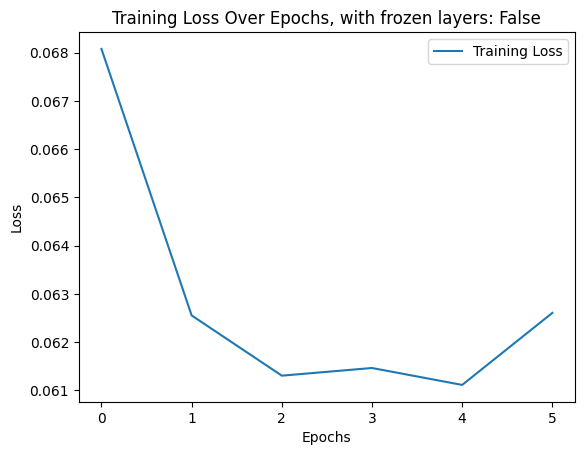

In [ ]:
plot_losses(train_losses, layers_frozen=False)

In [ ]:
metric_values[-1].compute()

{'map': tensor(0.6413),
 'map_50': tensor(0.9897),
 'map_75': tensor(0.7699),
 'map_small': tensor(0.5147),
 'map_medium': tensor(0.6723),
 'map_large': tensor(0.6602),
 'mar_1': tensor(0.6861),
 'mar_10': tensor(0.6953),
 'mar_100': tensor(0.6953),
 'mar_small': tensor(0.5838),
 'mar_medium': tensor(0.7223),
 'mar_large': tensor(0.7245),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

In [ ]:
metric_values[-2].compute()

{'map': tensor(0.6695),
 'map_50': tensor(0.9897),
 'map_75': tensor(0.7965),
 'map_small': tensor(0.5513),
 'map_medium': tensor(0.6945),
 'map_large': tensor(0.6951),
 'mar_1': tensor(0.7055),
 'mar_10': tensor(0.7146),
 'mar_100': tensor(0.7146),
 'mar_small': tensor(0.6219),
 'mar_medium': tensor(0.7372),
 'mar_large': tensor(0.7358),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

# Calculate metrics on the test set

In [ ]:
model = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/final_project/models/att1_epoch5.pt')

In [ ]:
metrics = test_one_epoch(model, test_loader, device, 0.7, 0.5)

  1%|          | 1/155 [00:01<02:37,  1.02s/it]

preds before nms [{'boxes': tensor([[117.4848, 134.2336, 230.3608, 171.3671],
        [112.4672, 118.7279, 236.5339, 187.5584]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.1712], device='cuda:0')}, {'boxes': tensor([[303.3825, 237.5015, 387.4167, 262.8900],
        [296.5843, 226.0064, 395.8802, 274.4881]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9962, 0.0633], device='cuda:0')}, {'boxes': tensor([[147.3302,  78.4539, 255.0588, 111.6825],
        [144.7023,  63.9230, 266.7330, 126.7939]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.1416], device='cuda:0')}, {'boxes': tensor([[193.5350, 245.2799, 304.0449, 276.3268],
        [188.1422, 231.0151, 316.5061, 290.5573]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1444], device='cuda:0')}, {'boxes': tensor([[297.6917, 253.5431, 382.8656, 279.7596]], device='cuda:0'),

  1%|▏         | 2/155 [00:01<02:32,  1.00it/s]

preds before nms [{'boxes': tensor([[145.9223, 147.2366, 257.6940, 178.5733],
        [140.7853, 134.8542, 262.5480, 193.4798]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1389], device='cuda:0')}, {'boxes': tensor([[144.4899,  92.6212, 254.6824, 125.2575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[150.1546, 145.4908, 263.4158, 177.3597],
        [143.2506, 130.4711, 268.6860, 195.9959]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0704], device='cuda:0')}, {'boxes': tensor([[267.2135, 257.9939, 354.1354, 284.5685],
        [259.4245, 246.3228, 363.0333, 295.0194],
        [336.5900,  41.1011, 385.6783,  56.5289]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.1185, 0.0885], device='cuda:0')}, {'boxes': tensor([[198.3976, 113.1679, 309.7609, 144.6805],
        [193.0318,

  2%|▏         | 3/155 [00:02<02:30,  1.01it/s]

preds before nms [{'boxes': tensor([[298.4398, 228.6854, 378.9402, 253.2803],
        [291.9834, 218.6257, 386.6939, 263.7199]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0882], device='cuda:0')}, {'boxes': tensor([[222.1290,  87.4695, 328.1687, 118.7637],
        [217.9534,  72.4390, 333.1538, 139.6634]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0899], device='cuda:0')}, {'boxes': tensor([[233.2703, 225.9563, 313.2546, 248.2232]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[279.2740, 238.1452, 362.5189, 262.8114],
        [274.5723, 222.6829, 373.0818, 279.5898]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0677], device='cuda:0')}, {'boxes': tensor([[245.2140, 251.8801, 326.8491, 278.1126],
        [238.2924, 242.5549, 335.2588, 287.0923]], device='cuda:0'), 'labels': 

  3%|▎         | 4/155 [00:03<02:29,  1.01it/s]

preds before nms [{'boxes': tensor([[255.6163, 201.7822, 350.0851, 230.3875],
        [246.2363, 190.1659, 357.0816, 245.1453]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0900], device='cuda:0')}, {'boxes': tensor([[221.7238, 148.9272, 319.2528, 182.1297],
        [212.1743, 137.7916, 324.6755, 202.3587]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0872], device='cuda:0')}, {'boxes': tensor([[219.6982, 178.2395, 312.5502, 205.6763],
        [212.0229, 167.8306, 317.8212, 223.9422]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0743], device='cuda:0')}, {'boxes': tensor([[211.7947, 198.3883, 322.6621, 229.0924],
        [395.3280, 125.1083, 418.4906, 139.6085],
        [209.1084, 188.9152, 331.6593, 244.8719],
        [ 88.2710, 193.3977, 138.9967, 219.7764],
        [386.0233, 166.1195, 436.8659, 200.0889]], device='cuda:0'), 'labels': tensor([1, 1, 1

  3%|▎         | 5/155 [00:04<02:29,  1.00it/s]

preds before nms [{'boxes': tensor([[213.6338, 168.3772, 310.3421, 196.9080],
        [208.5305, 160.8895, 317.4964, 217.3665]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0738], device='cuda:0')}, {'boxes': tensor([[244.5550, 226.7565, 353.2502, 258.1814],
        [237.0309, 214.8372, 363.9304, 272.2083]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0772], device='cuda:0')}, {'boxes': tensor([[237.1117, 214.2740, 336.8304, 243.1138],
        [229.4258, 203.1514, 344.4323, 253.9901]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0583], device='cuda:0')}, {'boxes': tensor([[216.8112, 225.2148, 326.5044, 255.0218],
        [205.3330, 213.7161, 337.5780, 267.6853]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0809], device='cuda:0')}, {'boxes': tensor([[191.3161, 223.6404, 298.0090, 252.5899]], device='cuda:0'),

  4%|▍         | 6/155 [00:05<02:29,  1.00s/it]

preds before nms [{'boxes': tensor([[230.8082, 214.2135, 331.5143, 242.7478],
        [217.1288, 182.8966, 332.2356, 201.5551],
        [254.6452, 185.1072, 315.0822, 199.1989]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.3234, 0.0519], device='cuda:0')}, {'boxes': tensor([[212.0106, 210.9426, 311.9839, 239.4671],
        [205.0115, 201.7126, 320.4778, 251.9008]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0556], device='cuda:0')}, {'boxes': tensor([[197.8888, 153.4509, 300.1606, 182.7523]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[174.7549, 142.6518, 285.6785, 175.0469],
        [169.5173, 130.8871, 291.7746, 191.4830]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1092], device='cuda:0')}, {'boxes': tensor([[112.8284, 268.8111, 226.0964, 299.1423]], device='cuda:0'),

  5%|▍         | 7/155 [00:07<02:29,  1.01s/it]

preds before nms [{'boxes': tensor([[154.7010,  92.9805, 270.9975, 126.3608],
        [197.1517,  51.2448, 225.5232,  67.5693]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1186], device='cuda:0')}, {'boxes': tensor([[172.6274,  86.7330, 280.4350, 117.5590],
        [170.3561,  71.4634, 285.2177, 139.7042]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0832], device='cuda:0')}, {'boxes': tensor([[183.1074, 122.0571, 290.8122, 153.9834],
        [176.7965, 106.9788, 305.2080, 170.8417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0683], device='cuda:0')}, {'boxes': tensor([[127.5567,  57.8911, 225.6508,  88.3651]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[263.0790, 246.1196, 349.7834, 270.1790]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

  5%|▌         | 8/155 [00:08<02:28,  1.01s/it]

preds before nms [{'boxes': tensor([[232.7751, 156.6459, 327.2955, 185.2300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[257.2658, 189.6735, 349.9579, 218.8810],
        [245.4339, 175.3768, 358.4934, 236.8581]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0701], device='cuda:0')}, {'boxes': tensor([[221.2772, 173.0391, 317.6208, 205.2763],
        [216.6357, 163.5193, 326.2482, 222.3984]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1319], device='cuda:0')}, {'boxes': tensor([[185.6534, 164.1415, 282.7847, 191.7769],
        [181.5264, 151.7823, 288.6493, 209.2697]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0524], device='cuda:0')}, {'boxes': tensor([[208.4232, 139.1744, 311.0944, 167.5124],
        [203.3899, 128.8695, 319.3738, 180.9388]], device='cuda:0'), 'labels': 

  6%|▌         | 9/155 [00:09<02:27,  1.01s/it]

preds before nms [{'boxes': tensor([[214.7083, 199.3993, 321.0451, 228.5569],
        [210.5260, 187.6172, 332.6640, 245.0473]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0803], device='cuda:0')}, {'boxes': tensor([[248.8048, 162.7205, 340.3699, 191.8002],
        [242.1083, 149.8833, 346.5722, 206.3594]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1062], device='cuda:0')}, {'boxes': tensor([[241.9662, 137.5774, 328.7380, 164.2283],
        [235.6461, 128.5120, 336.4874, 176.3673]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0987], device='cuda:0')}, {'boxes': tensor([[238.4506, 150.8725, 333.0057, 179.9098],
        [229.4074, 140.3987, 341.9719, 195.0875]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0675], device='cuda:0')}, {'boxes': tensor([[269.9607, 243.2301, 355.9720, 267.4672]], device='cuda:0'),

  6%|▋         | 10/155 [00:10<02:26,  1.01s/it]

preds before nms [{'boxes': tensor([[212.7290, 190.0877, 313.1579, 218.6931]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[227.6703, 131.3061, 320.7327, 161.7698],
        [225.1285, 123.4844, 327.7691, 181.0069]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1310], device='cuda:0')}, {'boxes': tensor([[202.4634, 238.9677, 310.5472, 268.7083],
        [193.4226, 227.5654, 318.3311, 281.3582]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0683], device='cuda:0')}, {'boxes': tensor([[216.4111, 124.1408, 302.6597, 153.5022],
        [209.6560, 112.2967, 312.0378, 171.9302]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0706], device='cuda:0')}, {'boxes': tensor([[227.5794, 184.3644, 323.4318, 211.9839]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

  7%|▋         | 11/155 [00:11<02:24,  1.00s/it]

preds before nms [{'boxes': tensor([[155.1127, 233.0095, 277.4062, 263.3061],
        [149.6465, 219.2199, 290.5607, 274.5184]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1007], device='cuda:0')}, {'boxes': tensor([[158.7398, 162.8003, 252.9412, 191.8273],
        [152.7218, 154.4453, 257.0716, 212.5940]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0674], device='cuda:0')}, {'boxes': tensor([[228.3532, 199.3076, 327.1943, 227.7813],
        [220.9520, 189.8936, 332.8628, 242.0251]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0848], device='cuda:0')}, {'boxes': tensor([[165.9546, 111.4967, 276.9995, 143.5032],
        [271.2418, 302.9730, 278.8052, 303.0000],
        [158.5806,  96.7040, 283.9146, 165.6249]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0701, 0.0515], device='cuda:0')}, {'boxes': tensor(

  8%|▊         | 12/155 [00:12<02:23,  1.00s/it]

preds before nms [{'boxes': tensor([[124.6164, 256.5124, 229.9762, 285.2318],
        [165.3045, 184.6348, 187.7957, 199.3601],
        [113.1210, 244.8394, 235.4638, 296.5657]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.5052, 0.0604], device='cuda:0')}, {'boxes': tensor([[202.4108, 220.0379, 302.4262, 247.9514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[167.7973, 153.2067, 282.7870, 185.1620]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[218.7135, 175.5094, 309.8470, 201.7064],
        [211.4898, 166.0142, 315.4943, 218.9800]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0551], device='cuda:0')}, {'boxes': tensor([[141.8324,  40.6693, 248.5305,  71.2160]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

  8%|▊         | 13/155 [00:13<02:22,  1.00s/it]

preds before nms [{'boxes': tensor([[237.5466, 152.9161, 332.8640, 184.4807],
        [230.9849, 141.8558, 340.5165, 203.2096]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0819], device='cuda:0')}, {'boxes': tensor([[262.3157, 224.4973, 347.3370, 250.6567],
        [406.7193,  23.5733, 419.1994,  33.4532],
        [317.5916,  37.8525, 372.2043,  56.4679],
        [255.0444, 213.8978, 357.0240, 261.1407],
        [318.6881,  42.2608, 352.0886,  53.5548]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2819, 0.2657, 0.0621, 0.0501], device='cuda:0')}, {'boxes': tensor([[225.5823, 144.1900, 316.9037, 173.8242],
        [217.3390, 135.3636, 327.4709, 194.9014]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1065], device='cuda:0')}, {'boxes': tensor([[168.9515, 238.7179, 270.2551, 265.1812]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

  9%|▉         | 14/155 [00:14<02:20,  1.00it/s]

preds before nms [{'boxes': tensor([[213.0122, 190.3188, 302.8266, 215.6641],
        [204.1888, 181.0145, 310.5581, 226.9373]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0735], device='cuda:0')}, {'boxes': tensor([[224.9437, 178.0471, 325.4052, 209.4025],
        [218.6057, 165.7531, 330.8946, 228.8666]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0814], device='cuda:0')}, {'boxes': tensor([[238.4337, 215.5805, 340.0120, 246.5879],
        [229.1345, 206.4351, 348.3411, 260.6710]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0953], device='cuda:0')}, {'boxes': tensor([[214.2213, 153.7125, 305.0833, 180.0877]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[261.9956, 189.5199, 338.4119, 211.7618],
        [333.8414,   7.4409, 375.0064,  34.4980]], device='cuda:0'), 'labels': 

 10%|▉         | 15/155 [00:15<02:19,  1.00it/s]

preds before nms [{'boxes': tensor([[122.3850, 239.0260, 231.1020, 270.4226]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[203.9702, 203.2294, 302.6238, 233.6608]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[115.4111, 166.5611, 199.0301, 192.4128],
        [109.1182, 155.2119, 207.6419, 205.7139]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1181], device='cuda:0')}, {'boxes': tensor([[169.2203, 159.4740, 274.9160, 190.6018],
        [163.7772, 148.9808, 286.0111, 202.8648]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1188], device='cuda:0')}, {'boxes': tensor([[247.0338, 129.0640, 347.2180, 158.8209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[222.1104, 123.88

 10%|█         | 16/155 [00:16<02:18,  1.00it/s]

preds before nms [{'boxes': tensor([[210.3164, 192.3469, 309.8282, 221.6084]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9975], device='cuda:0')}, {'boxes': tensor([[131.6138, 216.0083, 232.9589, 245.7636],
        [125.4874, 204.7927, 243.1447, 261.1372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0802], device='cuda:0')}, {'boxes': tensor([[112.5553, 140.6406, 222.2132, 171.0492],
        [106.3114, 125.2939, 237.5509, 185.6111]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0581], device='cuda:0')}, {'boxes': tensor([[161.7727, 205.1968, 263.9000, 234.7328]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[238.9169, 173.8300, 333.9671, 202.2598]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[162.3518, 262.67

 11%|█         | 17/155 [00:17<02:16,  1.01it/s]

preds before nms [{'boxes': tensor([[288.0291, 234.1329, 368.3454, 259.4426],
        [280.7139, 225.9410, 377.2654, 270.8298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0718], device='cuda:0')}, {'boxes': tensor([[129.8024, 127.6783, 238.9651, 160.1657]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9979], device='cuda:0')}, {'boxes': tensor([[209.2588, 111.3975, 315.9983, 142.6864],
        [205.0893,  95.5195, 321.5236, 161.1874]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0516], device='cuda:0')}, {'boxes': tensor([[158.1918, 136.8831, 271.7341, 167.0785]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[133.4881,  87.3882, 237.6819, 117.4147],
        [127.2336,  76.2317, 249.6190, 130.1754]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.

 12%|█▏        | 18/155 [00:18<02:16,  1.00it/s]

preds before nms [{'boxes': tensor([[143.0779, 160.7093, 257.4111, 191.0975]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[160.6641, 185.6942, 266.9362, 216.5627],
        [155.0355, 169.9559, 270.8612, 234.9291]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0537], device='cuda:0')}, {'boxes': tensor([[135.8042, 218.4655, 214.4774, 242.6753],
        [217.3421,  69.5017, 245.7380,  84.1914]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.6132], device='cuda:0')}, {'boxes': tensor([[271.2520, 188.8749, 358.2848, 214.7766]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[235.2976, 107.4340, 322.6816, 180.7315],
        [405.9366, 177.1992, 443.9084, 197.7050],
        [401.0736, 185.0871, 415.0326, 198.0422]], device='cuda:0'), 'labels': tensor([1, 

 12%|█▏        | 19/155 [00:19<02:16,  1.00s/it]

preds before nms [{'boxes': tensor([[272.8255, 258.9146, 359.0558, 285.5786],
        [304.5706,  39.1918, 390.8553,  59.8695],
        [340.9801,  40.2531, 389.1794,  56.5846],
        [264.4288, 247.4225, 368.4781, 296.1121]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.2706, 0.1317, 0.0649], device='cuda:0')}, {'boxes': tensor([[138.9287, 223.7478, 244.4390, 252.6239]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[255.6344, 171.7639, 348.2439, 198.8211],
        [333.6026,   1.1476, 368.0680,  16.2517],
        [245.7191, 155.2057, 355.7812, 218.8028]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0835, 0.0535], device='cuda:0')}, {'boxes': tensor([[245.4588, 198.9143, 342.5879, 227.3239],
        [239.8150, 185.2286, 351.4487, 246.0441]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 13%|█▎        | 20/155 [00:20<02:16,  1.01s/it]

preds before nms [{'boxes': tensor([[141.6075, 177.5179, 236.8762, 205.7364],
        [233.7986,   3.3591, 270.8214,  20.6138]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.3381], device='cuda:0')}, {'boxes': tensor([[144.5766, 217.0989, 242.6150, 245.4881],
        [229.9260,  13.2747, 271.0193,  34.0123]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1072], device='cuda:0')}, {'boxes': tensor([[182.1455, 195.3284, 281.9059, 224.8412]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[214.8979, 225.9475, 316.0384, 253.5108],
        [206.8037, 214.5730, 322.4462, 265.3222]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1083], device='cuda:0')}, {'boxes': tensor([[210.8799, 154.8223, 305.4677, 182.1773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 14%|█▎        | 21/155 [00:21<02:16,  1.02s/it]

preds before nms [{'boxes': tensor([[124.3824, 154.7486, 218.5386, 184.1961]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[216.2546, 222.7202, 325.2140, 252.7261],
        [210.3298, 211.6196, 336.5094, 265.1347],
        [123.3607,  57.7008, 146.1123,  72.1593]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0547, 0.0534], device='cuda:0')}, {'boxes': tensor([[140.2772, 160.9335, 236.7349, 189.6624]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[144.3655,  49.6900, 246.9679,  84.5255],
        [336.0283,  93.7642, 356.2361, 107.2638]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.2529], device='cuda:0')}, {'boxes': tensor([[213.3696, 207.9321, 308.7428, 236.1023],
        [208.2211, 194.4220, 315.9799, 245.1708]], device='cuda:0'), 'labels': 

 14%|█▍        | 22/155 [00:22<02:15,  1.02s/it]

preds before nms [{'boxes': tensor([[149.6619, 135.3113, 262.7875, 166.2832],
        [144.5914, 123.7372, 273.3457, 178.8815]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1085], device='cuda:0')}, {'boxes': tensor([[259.2713, 251.9718, 345.0354, 275.0525]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[112.0743,  88.9709, 224.2351, 119.7018],
        [107.3403,  76.6143, 235.3664, 133.4803]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0586], device='cuda:0')}, {'boxes': tensor([[148.2945,  77.5956, 255.8992, 108.2887],
        [142.3241,  62.2669, 263.6905, 130.4499]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.0702], device='cuda:0')}, {'boxes': tensor([[166.2356, 131.0034, 279.1887, 162.0908],
        [161.4707, 120.1124, 290.8046, 177.3095]], device='cuda:0'), 'labels': 

 15%|█▍        | 23/155 [00:23<02:14,  1.02s/it]

preds before nms [{'boxes': tensor([[196.7541,  98.6425, 248.7260, 112.6474],
        [193.5996,  93.4302, 252.5745, 119.7442]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0657], device='cuda:0')}, {'boxes': tensor([[160.0307, 210.4603, 265.5444, 240.7607],
        [156.1233, 193.7243, 268.7018, 261.5042]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0588], device='cuda:0')}, {'boxes': tensor([[262.5072, 178.7397, 351.8933, 202.7916],
        [254.1460, 169.3357, 360.7389, 214.7022]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0832], device='cuda:0')}, {'boxes': tensor([[130.5275, 252.5710, 217.5533, 278.7121]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[190.8613,  87.6674, 297.9272, 118.7213]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 15%|█▌        | 24/155 [00:24<02:13,  1.02s/it]

preds before nms [{'boxes': tensor([[268.2457, 255.1613, 349.2079, 279.0269],
        [349.4607,  60.2803, 386.3985,  85.0078]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.0875], device='cuda:0')}, {'boxes': tensor([[180.4105, 101.7345, 289.4983, 131.4215],
        [176.8235,  89.5336, 297.1996, 144.6282]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0770], device='cuda:0')}, {'boxes': tensor([[106.9098, 101.8495, 212.8270, 130.2369],
        [101.7936,  90.3401, 222.4588, 145.8071],
        [275.6730,  64.2479, 296.8884,  87.7081]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1115, 0.0747], device='cuda:0')}, {'boxes': tensor([[281.4674, 253.6281, 366.6230, 278.0195],
        [274.2710, 243.5263, 373.7729, 289.8926],
        [355.4565, 302.9786, 363.5317, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([

 16%|█▌        | 25/155 [00:25<02:11,  1.01s/it]

preds before nms [{'boxes': tensor([[238.6461, 186.9195, 340.6518, 215.4232],
        [231.7289, 176.7591, 345.9196, 232.2001]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0554], device='cuda:0')}, {'boxes': tensor([[197.4568, 196.0833, 297.2585, 224.7153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[161.8185, 218.9967, 272.9344, 250.9563],
        [156.8836, 206.1505, 280.0712, 267.9242]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0766], device='cuda:0')}, {'boxes': tensor([[137.3298, 241.2306, 221.8018, 267.8260],
        [129.8839, 232.5059, 230.5334, 279.2629]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0765], device='cuda:0')}, {'boxes': tensor([[248.6250, 210.9460, 352.3329, 240.5658],
        [241.6984, 201.2224, 360.1621, 253.2466]], device='cuda:0'), 'labels': 

 17%|█▋        | 26/155 [00:26<02:10,  1.01s/it]

preds before nms [{'boxes': tensor([[228.1776, 104.4779, 292.8441, 119.1727],
        [221.9151,  97.5228, 297.5095, 126.2752]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1278], device='cuda:0')}, {'boxes': tensor([[210.0043, 231.1158, 318.3881, 262.3892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[217.4439, 216.9750, 320.0423, 246.5424]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[210.4316, 229.2327, 319.9175, 259.4717],
        [204.4953, 217.0157, 328.8336, 274.7423]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0705], device='cuda:0')}, {'boxes': tensor([[204.4314, 214.8162, 305.4786, 243.3683]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[341.2714, 181.65

 17%|█▋        | 27/155 [00:27<02:09,  1.01s/it]

preds before nms [{'boxes': tensor([[230.6259, 197.9974, 336.0335, 227.7635],
        [225.5645, 186.4757, 346.9790, 240.8309]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0638], device='cuda:0')}, {'boxes': tensor([[278.7235, 241.6095, 362.7284, 265.6917],
        [272.6511, 231.6737, 370.7076, 277.5948]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.1179], device='cuda:0')}, {'boxes': tensor([[199.8017,  58.7448, 306.7983, 142.0055]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[248.2915, 208.8576, 339.0973, 236.1550]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[298.2119, 253.6054, 383.0957, 280.1191],
        [286.1828, 241.0882, 396.8445, 291.9134]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.

 18%|█▊        | 28/155 [00:28<02:08,  1.01s/it]

preds before nms [{'boxes': tensor([[315.1359, 253.9158, 397.9191, 281.3235]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[155.5421, 172.8843, 267.1742, 203.5960],
        [151.1351, 161.8775, 275.7235, 217.8937]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0700], device='cuda:0')}, {'boxes': tensor([[141.5153, 151.7514, 256.1108, 184.7513],
        [140.0117, 136.3531, 269.0339, 200.8302]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0729], device='cuda:0')}, {'boxes': tensor([[298.8680, 228.6710, 378.8775, 252.6632],
        [292.2674, 218.2270, 386.3991, 263.6413]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.0901], device='cuda:0')}, {'boxes': tensor([[228.1980, 202.5956, 309.7330, 226.3894],
        [336.0659, 173.9647, 363.1131, 196.3891]], device='cuda:0'), 'labels': 

 19%|█▊        | 29/155 [00:29<02:06,  1.01s/it]

preds before nms [{'boxes': tensor([[321.9344, 213.8721, 360.1856, 226.2302],
        [319.3040, 209.8083, 365.5565, 230.3235]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.1028], device='cuda:0')}, {'boxes': tensor([[229.0361, 189.4402, 327.5576, 219.2006],
        [222.2030, 179.7423, 333.5464, 234.5800]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.1077], device='cuda:0')}, {'boxes': tensor([[216.8207, 234.9372, 321.8535, 264.9876],
        [210.9292, 223.1140, 332.9605, 277.4023]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1571], device='cuda:0')}, {'boxes': tensor([[209.2386, 220.0337, 308.1182, 251.4454],
        [198.3345, 205.9183, 313.4861, 265.6920]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1526], device='cuda:0')}, {'boxes': tensor([[210.0156, 147.7385, 305.9128, 177.5847]], device='cuda:0'),

 19%|█▉        | 30/155 [00:30<02:05,  1.01s/it]

preds before nms [{'boxes': tensor([[241.0278, 179.7488, 336.6206, 209.4783],
        [235.1074, 168.2876, 342.0214, 226.9276],
        [301.4875, 229.1624, 322.8177, 241.9934]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0916, 0.0595], device='cuda:0')}, {'boxes': tensor([[199.3357,  82.4794, 289.1193, 110.3315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[244.6392, 226.4628, 353.0388, 258.1139],
        [237.2453, 214.0421, 363.8778, 272.0708],
        [284.7663, 302.9663, 291.4909, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0896, 0.0701], device='cuda:0')}, {'boxes': tensor([[186.2082, 210.1543, 286.2923, 237.5078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[254.3807, 224.3926, 313.1792, 262.8743]], device='cuda:0'),

 20%|██        | 31/155 [00:31<02:05,  1.01s/it]

preds before nms [{'boxes': tensor([[180.2254, 177.5298, 277.1964, 207.5712],
        [174.9693, 164.7677, 283.1877, 223.5617]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0746], device='cuda:0')}, {'boxes': tensor([[172.0494, 164.9503, 263.1686, 190.9861],
        [163.7023, 156.2883, 272.7541, 202.5900]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0801], device='cuda:0')}, {'boxes': tensor([[177.0977, 228.8385, 281.9317, 259.1919],
        [168.1775, 218.6016, 290.1134, 272.0716]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1540], device='cuda:0')}, {'boxes': tensor([[190.8307, 174.3479, 291.9369, 203.7404]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[210.0873, 210.8445, 287.5920, 236.8494],
        [283.4547,  57.5372, 312.9778,  76.6987],
        [204.0508, 202.1788, 

 21%|██        | 32/155 [00:32<02:05,  1.02s/it]

preds before nms [{'boxes': tensor([[176.2716, 136.1348, 288.9901, 167.5032]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[201.5237, 163.4259, 247.2660, 175.3716]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[117.3503, 157.8037, 228.4500, 190.0320]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[117.5095, 247.9736, 204.6837, 273.7068],
        [111.1996, 237.9107, 212.2303, 284.1325]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.0838], device='cuda:0')}, {'boxes': tensor([[251.7221, 234.8131, 337.1462, 259.8373],
        [194.9486, 189.3496, 229.8256, 207.7074],
        [245.9609, 224.8477, 343.3649, 269.5844]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.2244, 0.

 21%|██▏       | 33/155 [00:33<02:04,  1.02s/it]

preds before nms [{'boxes': tensor([[217.4124, 175.8970, 290.2563, 193.5276],
        [213.0344, 169.9942, 298.2427, 202.2778]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9955, 0.1698], device='cuda:0')}, {'boxes': tensor([[229.6752, 188.5809, 325.3650, 220.2322],
        [222.6743, 175.3801, 330.9181, 239.5468]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1057], device='cuda:0')}, {'boxes': tensor([[208.5152, 208.0947, 311.0208, 237.2022]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[200.4224, 192.2802, 298.0026, 221.9153]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[245.7314, 164.6761, 288.0399, 176.9028],
        [242.7243, 160.4159, 289.6131, 182.6298]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9959, 0.

 22%|██▏       | 34/155 [00:34<02:03,  1.02s/it]

preds before nms [{'boxes': tensor([[227.4706, 166.6291, 319.8212, 194.6351],
        [224.0620, 156.7118, 327.1611, 209.4255]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0994], device='cuda:0')}, {'boxes': tensor([[276.1353, 178.8102, 373.6819, 207.6643],
        [268.2632, 167.9908, 379.6618, 223.6409]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0620], device='cuda:0')}, {'boxes': tensor([[261.6342, 167.9823, 354.6295, 197.8216],
        [257.0193, 153.3687, 360.5290, 220.0577]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0666], device='cuda:0')}, {'boxes': tensor([[239.3872, 151.5175, 333.3039, 179.3149],
        [234.7151, 141.8732, 341.8700, 192.9425]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0759], device='cuda:0')}, {'boxes': tensor([[223.5357, 192.2126, 324.2003, 221.0499],
        [216.5296,

 23%|██▎       | 35/155 [00:35<02:02,  1.02s/it]

preds before nms [{'boxes': tensor([[206.2866, 213.8027, 308.8193, 243.2816],
        [198.4671, 201.0570, 321.3719, 257.2304]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0569], device='cuda:0')}, {'boxes': tensor([[206.6061, 203.7564, 306.4988, 232.8358],
        [241.0105, 149.1165, 275.5863, 163.1986],
        [196.3272, 191.1415, 313.2864, 249.4660]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1905, 0.0706], device='cuda:0')}, {'boxes': tensor([[255.7969, 187.5775, 301.2289, 199.5089],
        [252.8361, 184.1172, 315.1343, 202.6706]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9949, 0.0560], device='cuda:0')}, {'boxes': tensor([[222.8694, 199.4680, 274.6283, 212.2732]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[180.1779,  91.4389, 287.1001, 123.5067],
        [174.1768,

 23%|██▎       | 36/155 [00:36<02:01,  1.02s/it]

preds before nms [{'boxes': tensor([[ 80.6205, 198.0567, 178.8689, 228.6930]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[150.3468, 233.1360, 255.6817, 263.8584]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[135.0992, 174.6187, 247.0308, 204.1974]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[107.4851, 134.1400, 226.7467, 165.4107],
        [104.1558, 121.8869, 231.6908, 180.4771]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0532], device='cuda:0')}, {'boxes': tensor([[165.7686, 130.2604, 273.9051, 161.3856],
        [314.8886,  38.5777, 365.1400,  66.9153]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.1342], device='cuda:0')}, {'boxes': tensor([[170.8393, 130.09

 24%|██▍       | 37/155 [00:37<02:00,  1.02s/it]

preds before nms [{'boxes': tensor([[210.2108, 171.5697, 308.2054, 200.2337],
        [206.7442, 164.6789, 317.1801, 217.4741]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.1779], device='cuda:0')}, {'boxes': tensor([[246.0608, 163.6578, 351.0950, 192.3493]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[205.1936, 150.2808, 299.0780, 178.0600],
        [202.4530, 142.9072, 309.4382, 193.7609]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0570], device='cuda:0')}, {'boxes': tensor([[214.3665, 194.6038, 311.6288, 225.3633],
        [204.9590, 182.8058, 319.2554, 238.4633]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1335], device='cuda:0')}, {'boxes': tensor([[247.1299, 231.9294, 356.2723, 261.0653],
        [236.9728, 220.8584, 363.6677, 273.7531]], device='cuda:0'), 'labels': 

 25%|██▍       | 38/155 [00:38<01:59,  1.02s/it]

preds before nms [{'boxes': tensor([[201.6629, 193.4049, 298.3499, 222.3316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[243.1949, 182.6655, 340.5657, 210.2373],
        [238.3152, 175.9544, 344.9895, 227.9681],
        [276.0788, 150.7635, 309.8314, 164.0734]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0587, 0.0512], device='cuda:0')}, {'boxes': tensor([[231.7990, 170.3120, 326.3549, 198.1879],
        [227.2492, 161.9803, 332.7517, 216.4046]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0550], device='cuda:0')}, {'boxes': tensor([[232.7538, 155.7554, 322.4564, 183.2670]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[205.0139, 184.1235, 302.8750, 212.9554],
        [196.8491, 171.6795, 311.6459, 230.1097]], device='cuda:0'), 'labels': 

 25%|██▌       | 39/155 [00:39<01:58,  1.02s/it]

preds before nms [{'boxes': tensor([[195.2322, 201.7424, 300.1030, 233.5168],
        [192.0535, 188.9065, 308.7849, 247.7595]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1013], device='cuda:0')}, {'boxes': tensor([[251.0830, 210.7849, 354.9329, 240.9194],
        [246.6498, 199.0277, 364.1379, 259.2669]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0572], device='cuda:0')}, {'boxes': tensor([[238.8714, 172.0071, 337.6858, 203.1266],
        [232.7365, 158.9285, 345.4948, 220.9911]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0674], device='cuda:0')}, {'boxes': tensor([[219.4902, 225.7653, 326.0956, 257.3244],
        [210.1827, 215.3201, 336.0860, 270.1472]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1112], device='cuda:0')}, {'boxes': tensor([[265.1606, 144.6718, 318.2033, 159.3806],
        [259.8539,

 26%|██▌       | 40/155 [00:40<01:57,  1.02s/it]

preds before nms [{'boxes': tensor([[214.4373, 239.5547, 315.4400, 266.3427],
        [208.6582, 228.8687, 323.0526, 277.4622]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0940], device='cuda:0')}, {'boxes': tensor([[116.2118, 201.6510, 217.8667, 231.1752],
        [110.1052, 191.2674, 226.7363, 244.2945]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0544], device='cuda:0')}, {'boxes': tensor([[195.2437, 167.5459, 292.5033, 195.7604]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[191.4720, 147.1773, 302.1844, 178.4486],
        [184.5187, 136.7526, 311.9241, 192.0400]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.1051], device='cuda:0')}, {'boxes': tensor([[275.8365, 185.7122, 348.0222, 208.2027],
        [266.7829, 179.7311, 351.6615, 218.4515]], device='cuda:0'), 'labels': 

 26%|██▋       | 41/155 [00:41<01:57,  1.03s/it]

preds before nms [{'boxes': tensor([[133.6139,  87.4482, 237.6921, 117.6676],
        [127.6146,  76.0208, 249.9061, 130.2541]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0792], device='cuda:0')}, {'boxes': tensor([[214.0063, 179.5209, 253.1928, 193.6808],
        [212.9241, 173.3847, 256.0194, 199.5903]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0782], device='cuda:0')}, {'boxes': tensor([[279.7260, 220.4486, 355.9822, 243.7722],
        [356.1797,  68.2217, 383.1829,  82.9308],
        [274.3461, 209.8767, 365.0693, 257.2142]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.9171, 0.0922], device='cuda:0')}, {'boxes': tensor([[167.8071,  91.4177, 273.7678, 124.6384]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[297.3135, 248.6860, 382.0494, 273.0168],
        [291.0503,

 27%|██▋       | 42/155 [00:42<01:55,  1.03s/it]

preds before nms [{'boxes': tensor([[234.8262, 229.8608, 338.8167, 259.1985],
        [226.3300, 218.0782, 346.3158, 274.1043]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.1526], device='cuda:0')}, {'boxes': tensor([[226.4075, 177.6192, 319.3265, 206.6913],
        [225.2413, 171.5028, 320.5946, 229.7342]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0788], device='cuda:0')}, {'boxes': tensor([[188.9291, 148.1572, 232.0882, 160.8607],
        [249.9906, 118.2395, 273.7384, 136.3326],
        [187.7330, 143.0771, 237.6626, 165.2956]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2998, 0.0557], device='cuda:0')}, {'boxes': tensor([[163.6748, 174.8745, 256.4009, 202.2628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[227.8526, 209.1373, 332.7140, 239.5380],
        [222.2951,

 28%|██▊       | 43/155 [00:43<01:54,  1.02s/it]

preds before nms [{'boxes': tensor([[226.3535, 128.8394, 268.6611, 140.0770],
        [224.6335, 124.3435, 271.5248, 146.8030],
        [239.9690, 117.4276, 256.6183, 125.9777]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9958, 0.1646, 0.0947], device='cuda:0')}, {'boxes': tensor([[170.3759,  77.4000, 224.3427,  91.6246]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[ 85.6171, 275.9744, 201.7394, 302.5081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9969], device='cuda:0')}, {'boxes': tensor([[211.4827, 211.2864, 304.0316, 240.6501],
        [204.9706, 201.9089, 310.8295, 254.2565]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0652], device='cuda:0')}, {'boxes': tensor([[134.1040, 168.6004, 284.2553, 239.5471],
        [133.7434, 129.8851, 291.4516, 275.6339]], device='cuda:0'), 'labels': 

 28%|██▊       | 44/155 [00:44<01:54,  1.03s/it]

preds before nms [{'boxes': tensor([[286.0284, 121.0944, 399.1750, 155.7782]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[ 89.9303, 135.3839, 206.2102, 184.0866]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[122.7186, 278.5274, 228.9929, 302.3427],
        [107.7086, 261.4631, 232.3933, 303.0000],
        [132.2238, 284.3203, 220.7173, 298.5185]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9794, 0.2363, 0.0959], device='cuda:0')}, {'boxes': tensor([[264.3256, 169.4114, 309.0269, 183.7436]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[172.6331, 211.7069, 298.7514, 245.9340],
        [168.1910, 191.4118, 303.0281, 265.7412]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.

 29%|██▉       | 45/155 [00:45<01:54,  1.04s/it]

preds before nms [{'boxes': tensor([[322.0583, 245.4633, 414.0566, 284.6295],
        [328.1097, 302.9734, 335.7645, 303.0000],
        [293.6526, 302.9630, 301.8302, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0701, 0.0701], device='cuda:0')}, {'boxes': tensor([[162.6188,  75.7126, 281.7612, 121.3514]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[304.1021, 149.1665, 400.3326, 186.5668],
        [297.2254, 136.1965, 407.4501, 201.8582]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9941, 0.2127], device='cuda:0')}, {'boxes': tensor([[277.5070, 247.6493, 379.6215, 283.4961],
        [272.2898, 233.5719, 385.7758, 299.1281]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1324], device='cuda:0')}, {'boxes': tensor([[292.0985, 242.3076, 379.8944, 282.8404]], device='cuda:0'),

 30%|██▉       | 46/155 [00:46<01:53,  1.04s/it]

preds before nms [{'boxes': tensor([[233.2456, 173.0285, 360.6297, 220.2575],
        [229.9055, 149.6275, 372.0307, 264.2732]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0793], device='cuda:0')}, {'boxes': tensor([[240.5816, 192.6556, 350.8378, 231.7156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[132.3185, 239.1116, 261.8728, 270.0664],
        [124.2207, 221.8834, 277.1533, 287.4720]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1147], device='cuda:0')}, {'boxes': tensor([[202.1216, 127.5140, 310.4234, 161.7358]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[279.8850, 116.5419, 389.0929, 151.7168],
        [274.3094, 101.7108, 393.4292, 171.5918]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.

 30%|███       | 47/155 [00:47<01:52,  1.04s/it]

preds before nms [{'boxes': tensor([[221.3485, 187.0835, 340.3913, 235.5184],
        [212.2726, 154.4919, 352.0667, 274.1489]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0581], device='cuda:0')}, {'boxes': tensor([[188.8778, 183.7510, 306.6769, 221.9845],
        [190.2413, 166.4302, 305.9807, 248.3131]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.0867], device='cuda:0')}, {'boxes': tensor([[168.9205, 226.1110, 284.9130, 258.4315],
        [159.4532, 212.8368, 293.5315, 272.3352]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.3810], device='cuda:0')}, {'boxes': tensor([[244.0672, 186.5859, 353.5351, 217.1689],
        [237.6259, 172.3184, 363.0570, 236.4714]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0798], device='cuda:0')}, {'boxes': tensor([[116.0780,  19.0156, 253.2958,  65.4626],
        [110.4932,

 31%|███       | 48/155 [00:48<01:51,  1.04s/it]

preds before nms [{'boxes': tensor([[279.4370, 240.2684, 395.5358, 272.0422],
        [270.9115, 227.8443, 406.0839, 288.7859]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.1975], device='cuda:0')}, {'boxes': tensor([[157.4929,  66.8329, 292.9831, 114.7734],
        [141.5856,  53.5374, 309.1186, 132.3440]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0530], device='cuda:0')}, {'boxes': tensor([[113.5606, 196.2393, 261.0239, 268.2137]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[166.1559, 119.2680, 300.5424, 169.1819],
        [148.7900, 106.4211, 322.3840, 185.6525]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.0874], device='cuda:0')}, {'boxes': tensor([[136.0908,  83.2816, 273.6847, 126.9456]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 32%|███▏      | 49/155 [00:49<01:49,  1.04s/it]

preds before nms [{'boxes': tensor([[ 86.8914,  51.3302, 220.9013, 104.1725],
        [ 80.2009,  37.0770, 230.1097, 131.7493]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0823], device='cuda:0')}, {'boxes': tensor([[174.0516,  45.1027, 306.6452, 100.8659],
        [172.8848,  20.9166, 310.7917, 142.6718]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0802], device='cuda:0')}, {'boxes': tensor([[220.6853, 143.0515, 352.6472, 201.5910],
        [210.5108, 123.2996, 360.8298, 234.9167]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1160], device='cuda:0')}, {'boxes': tensor([[122.3217,  58.9280, 248.5794, 106.7483],
        [116.6580,  41.2277, 268.1251, 143.4614]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0634], device='cuda:0')}, {'boxes': tensor([[260.5664, 208.5530, 360.5070, 240.3204],
        [253.2013,

 32%|███▏      | 50/155 [00:50<01:48,  1.03s/it]

preds before nms [{'boxes': tensor([[194.7790, 178.5522, 317.5072, 238.6609],
        [199.7259, 263.7520, 254.7551, 278.6332],
        [181.6321, 161.0046, 323.6104, 272.5560]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.2902, 0.0715], device='cuda:0')}, {'boxes': tensor([[214.2105, 140.0021, 335.1454, 174.1962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[217.7918, 221.9333, 340.8485, 253.9688],
        [205.9168, 207.5081, 354.0663, 273.4654]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.1051], device='cuda:0')}, {'boxes': tensor([[178.7073, 206.8961, 299.2323, 240.9131],
        [174.7964, 189.8489, 300.5858, 260.6287]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0736], device='cuda:0')}, {'boxes': tensor([[168.3983, 157.3147, 283.3236, 193.4010],
        [166.6185,

 33%|███▎      | 51/155 [00:51<01:47,  1.04s/it]

preds before nms [{'boxes': tensor([[195.0358, 178.5602, 314.4409, 232.9446],
        [188.5018, 135.6692, 325.5261, 282.9557]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0798], device='cuda:0')}, {'boxes': tensor([[214.4074, 175.8665, 364.0823, 228.6013],
        [213.7155, 151.9454, 372.1862, 256.5144]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1245], device='cuda:0')}, {'boxes': tensor([[175.6586,  94.8006, 306.7032, 126.5289],
        [166.0844,  82.7110, 315.4205, 144.3068]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1307], device='cuda:0')}, {'boxes': tensor([[167.7962,  87.1265, 265.4173, 116.9033],
        [160.7347,  76.5439, 270.3679, 133.3979]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1638], device='cuda:0')}, {'boxes': tensor([[164.4929,  13.0104, 296.4477,  61.4562],
        [151.5603,

 34%|███▎      | 52/155 [00:52<01:46,  1.03s/it]

preds before nms [{'boxes': tensor([[ 87.8668, 134.4599, 207.9394, 167.4393],
        [ 84.5407, 120.5150, 210.9880, 186.2283]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0651], device='cuda:0')}, {'boxes': tensor([[127.0220, 155.2313, 245.0608, 249.8129]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[193.7151, 236.2672, 299.3488, 276.7102],
        [188.2605, 219.5632, 310.2829, 296.1166],
        [260.3957, 185.6245, 276.7950, 197.0990]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2113, 0.0573], device='cuda:0')}, {'boxes': tensor([[235.8292, 152.9523, 363.9898, 185.1987]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[193.3454, 116.3969, 240.9534, 133.8245],
        [190.0460, 110.4899, 246.5491, 142.2343]], device='cuda:0'), 'labels': 

 34%|███▍      | 53/155 [00:53<01:45,  1.03s/it]

preds before nms [{'boxes': tensor([[226.9913, 147.4487, 342.9627, 181.2793],
        [223.4256, 136.1196, 353.0027, 198.9857]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.1812], device='cuda:0')}, {'boxes': tensor([[268.9298, 120.4125, 373.3985, 159.3935],
        [264.5342, 105.0242, 378.0945, 179.0558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.2874], device='cuda:0')}, {'boxes': tensor([[175.0704, 185.0075, 288.7296, 215.9722],
        [164.4023, 173.2719, 299.5692, 232.5962]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.1082], device='cuda:0')}, {'boxes': tensor([[159.9611, 113.7029, 261.3828, 152.1306],
        [160.0260,  96.8529, 266.4896, 171.4258]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0547], device='cuda:0')}, {'boxes': tensor([[228.4009, 150.0650, 281.6859, 162.5980]], device='cuda:0'),

 35%|███▍      | 54/155 [00:54<01:44,  1.03s/it]

preds before nms [{'boxes': tensor([[208.4277, 276.1868, 323.2920, 302.8697]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9826], device='cuda:0')}, {'boxes': tensor([[211.0875, 208.7456, 352.0271, 272.7250]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[ 82.4736,   1.7299, 239.2848,  74.6020]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[135.3403, 159.7471, 275.2766, 208.1554],
        [125.6645, 141.8342, 287.9181, 232.2094]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0973], device='cuda:0')}, {'boxes': tensor([[207.1585,  20.4126, 327.9150,  72.2310],
        [194.8375,   3.9154, 342.1487, 103.6651]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0735], device='cuda:0')}, {'boxes': tensor([[180.6146, 141.37

 35%|███▌      | 55/155 [00:55<01:44,  1.04s/it]

preds before nms [{'boxes': tensor([[105.7498,  35.9997, 222.0099,  69.6276],
        [ 96.8941,  22.4670, 232.0108,  86.1780]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2436], device='cuda:0')}, {'boxes': tensor([[ 79.1786,  39.9085, 201.5168,  70.0186],
        [ 71.1974,  29.3901, 211.1118,  87.1734]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0600], device='cuda:0')}, {'boxes': tensor([[172.2107,  43.5872, 301.7956,  94.7332]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}, {'boxes': tensor([[276.5686, 164.5210, 384.9080, 195.0336],
        [269.6103, 154.6431, 391.6885, 209.2417]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1795], device='cuda:0')}, {'boxes': tensor([[214.1655, 135.3304, 336.2099, 171.5927],
        [222.8090,  72.3860, 260.9719,  84.4709]], device='cuda:0'), 'labels': 

 36%|███▌      | 56/155 [00:57<01:44,  1.05s/it]

preds before nms [{'boxes': tensor([[188.9245, 180.6318, 319.5549, 222.7692]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9964], device='cuda:0')}, {'boxes': tensor([[220.7736, 259.8265, 334.0496, 297.1078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9965], device='cuda:0')}, {'boxes': tensor([[212.9406, 235.5811, 338.5620, 272.2359],
        [202.4106, 218.4489, 350.0092, 290.2800]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.4564], device='cuda:0')}, {'boxes': tensor([[ 59.3224, 216.5430, 192.8285, 264.2795],
        [ 33.6828, 201.5796, 212.6974, 279.9200]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.0683], device='cuda:0')}, {'boxes': tensor([[284.7941, 213.4452, 429.4235, 253.2820]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[235.5421, 177.22

 37%|███▋      | 57/155 [00:58<01:44,  1.06s/it]

preds before nms [{'boxes': tensor([[258.3456, 184.4590, 311.5912, 197.8014]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[137.2739, 230.9239, 265.6279, 263.2918],
        [129.1570, 206.8302, 276.6591, 287.6223]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0702], device='cuda:0')}, {'boxes': tensor([[214.9587, 187.8616, 326.6909, 224.6005]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[145.1110, 132.8998, 306.6317, 168.2628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9958], device='cuda:0')}, {'boxes': tensor([[258.4089, 221.2320, 362.4467, 254.1000],
        [253.0882, 206.9346, 374.9819, 270.4216]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.1383], device='cuda:0')}, {'boxes': tensor([[149.8304, 179.99

 37%|███▋      | 58/155 [00:59<01:43,  1.07s/it]

preds before nms [{'boxes': tensor([[124.2624, 247.6254, 234.4149, 288.5573],
        [116.9084, 231.0859, 244.6538, 302.4832]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0804], device='cuda:0')}, {'boxes': tensor([[147.8095, 254.6468, 260.9861, 288.6909]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[170.6571, 153.0484, 280.8109, 186.0306],
        [161.7397, 143.4752, 290.7891, 199.7865],
        [239.1451,  93.1425, 259.6491, 106.7329]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.3288, 0.1160], device='cuda:0')}, {'boxes': tensor([[218.8236, 122.7935, 335.7758, 156.2625]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[ 45.3954,  46.5408, 179.4842,  92.2012],
        [271.9550,  47.8789, 292.2303,  67.0082]], device='cuda:0'), 'labels': 

 38%|███▊      | 59/155 [01:00<01:43,  1.08s/it]

preds before nms [{'boxes': tensor([[176.6575,  71.3036, 303.0363, 118.2185],
        [316.0282,  45.9931, 334.1289,  59.9761]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.3106], device='cuda:0')}, {'boxes': tensor([[248.0976, 141.4431, 290.5911, 153.5164],
        [244.3777, 135.9414, 294.7383, 158.0986]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9932, 0.0789], device='cuda:0')}, {'boxes': tensor([[288.3351, 213.0816, 389.3109, 242.7983],
        [391.4365,  40.3307, 428.2906,  58.5074],
        [280.0401, 198.1958, 400.3971, 259.9695]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.2905, 0.0692], device='cuda:0')}, {'boxes': tensor([[307.3161, 179.5962, 350.8926, 192.0786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[202.1021, 101.3363, 336.1662, 142.8834]], device='cuda:0'),

 39%|███▊      | 60/155 [01:01<01:42,  1.08s/it]

preds before nms [{'boxes': tensor([[209.2147, 108.3054, 317.2147, 146.1010],
        [204.1475,  93.5237, 321.6626, 164.7620],
        [205.9221,  57.6462, 236.8590,  78.8410]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2702, 0.0516], device='cuda:0')}, {'boxes': tensor([[118.0434, 133.3734, 227.5704, 171.4259],
        [110.6118, 120.9678, 236.6522, 195.4521]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.2810], device='cuda:0')}, {'boxes': tensor([[ 97.0657, 150.2915, 225.0985, 196.5312]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[139.6532, 267.0465, 250.9910, 299.2585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[217.1342, 242.9655, 344.1049, 299.8447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 39%|███▉      | 61/155 [01:02<01:41,  1.08s/it]

preds before nms [{'boxes': tensor([[202.4983, 141.1936, 313.2054, 175.3034],
        [200.8873, 126.9898, 317.6363, 195.4383]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.0918], device='cuda:0')}, {'boxes': tensor([[225.5543, 143.7833, 342.5696, 197.5079],
        [186.6330,  56.6397, 275.1384,  92.9540],
        [219.3555, 103.4992, 352.8289, 252.2171]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.0823, 0.0557], device='cuda:0')}, {'boxes': tensor([[228.2084, 125.4192, 316.6416, 163.0212],
        [229.6393, 109.1059, 322.7857, 185.2930]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9939, 0.0718], device='cuda:0')}, {'boxes': tensor([[130.8514, 155.8836, 226.6457, 199.0239],
        [120.3618, 140.3517, 232.9453, 219.8994]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.0913], device='cuda:0')}, {'boxes': tensor(

 40%|████      | 62/155 [01:03<01:39,  1.07s/it]

preds before nms [{'boxes': tensor([[153.2400, 213.9589, 258.5378, 257.2527],
        [145.9059, 199.3849, 269.1834, 276.9665]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9951, 0.3893], device='cuda:0')}, {'boxes': tensor([[111.0000, 173.8655, 212.3573, 210.7050],
        [279.7641, 166.9999, 323.0450, 192.6762],
        [105.7668, 158.7905, 219.3557, 228.7114]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.5320, 0.1720], device='cuda:0')}, {'boxes': tensor([[ 92.2007, 162.6782, 205.6668, 228.9021],
        [ 89.0082, 124.1735, 219.6982, 278.2194]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.0573], device='cuda:0')}, {'boxes': tensor([[ 86.1043, 198.8940, 204.5147, 260.0485],
        [ 74.0391, 158.4081, 214.9467, 293.3238]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0621], device='cuda:0')}, {'boxes': tensor(

 41%|████      | 63/155 [01:04<01:37,  1.06s/it]

preds before nms [{'boxes': tensor([[137.8836, 136.7225, 256.5933, 205.9717],
        [130.6871, 122.3256, 275.1080, 242.6770]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0683], device='cuda:0')}, {'boxes': tensor([[303.5643, 193.3359, 389.1853, 244.2274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9973], device='cuda:0')}, {'boxes': tensor([[166.0759, 224.1940, 247.3889, 243.6104],
        [161.1054, 217.2239, 255.4353, 251.7897],
        [174.7231, 228.2684, 242.2162, 238.7355]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0642, 0.0617], device='cuda:0')}, {'boxes': tensor([[185.8237,  85.4801, 302.5448, 159.8620],
        [175.7054,  73.9899, 318.8813, 202.4134]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0623], device='cuda:0')}, {'boxes': tensor([[162.8657, 115.8461, 281.2577, 170.0590]], device='cuda:0'),

 41%|████▏     | 64/155 [01:05<01:35,  1.05s/it]

preds before nms [{'boxes': tensor([[270.2271, 119.9998, 381.3356, 192.9689],
        [263.5897,  88.3071, 393.8862, 226.6891]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0625], device='cuda:0')}, {'boxes': tensor([[225.5912, 204.8337, 339.6416, 258.1483],
        [222.3632, 173.8319, 351.8167, 290.9410]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.0839], device='cuda:0')}, {'boxes': tensor([[213.4254, 104.8259, 328.4746, 167.2157],
        [208.7839,  70.1960, 339.2542, 211.3388]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0739], device='cuda:0')}, {'boxes': tensor([[200.9510, 129.8679, 303.8434, 170.5361]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[191.9245, 115.4360, 298.0396, 175.3333],
        [185.9252,  96.8586, 311.3604, 205.4465]], device='cuda:0'), 'labels': 

 42%|████▏     | 65/155 [01:06<01:34,  1.04s/it]

preds before nms [{'boxes': tensor([[292.8556, 154.8019, 337.4855, 166.2977]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9939], device='cuda:0')}, {'boxes': tensor([[216.3751, 190.9424, 318.5972, 255.2867],
        [207.8075, 172.5514, 340.7130, 284.5942]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1100], device='cuda:0')}, {'boxes': tensor([[186.5166,  51.1235, 298.7359, 142.2243],
        [153.8587,  39.4006, 181.6132,  62.3830]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1106], device='cuda:0')}, {'boxes': tensor([[278.4391, 243.6836, 362.3501, 273.5000],
        [273.0209, 228.1662, 370.4841, 289.0570]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.2260], device='cuda:0')}, {'boxes': tensor([[130.5798, 107.0520, 253.2422, 177.1095],
        [124.9276,  76.5642, 263.9765, 212.3488]], device='cuda:0'), 'labels': 

 43%|████▎     | 66/155 [01:07<01:33,  1.05s/it]

preds before nms [{'boxes': tensor([[169.4514, 241.6041, 294.3488, 288.0645],
        [143.1444, 229.0479, 328.9826, 299.8983]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9954, 0.0601], device='cuda:0')}, {'boxes': tensor([[151.5244, 121.7312, 265.3835, 194.5803],
        [147.9208,  84.7272, 279.5699, 243.7252]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0518], device='cuda:0')}, {'boxes': tensor([[313.2338, 199.9620, 402.6080, 261.7028]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[185.9828,  87.3567, 302.2841, 160.5248]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[133.6546, 132.7120, 253.5396, 205.8593],
        [132.0511,  94.5069, 262.6168, 256.3188]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9989, 0.

 43%|████▎     | 67/155 [01:08<01:32,  1.05s/it]

preds before nms [{'boxes': tensor([[135.7556, 134.4786, 252.8515, 191.4332]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[320.7480, 187.4024, 406.4117, 241.7158]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9957], device='cuda:0')}, {'boxes': tensor([[154.7473, 114.9990, 267.7820, 152.2559],
        [242.9209,  46.6787, 280.2776,  61.8387],
        [147.5031, 102.5740, 274.3076, 169.9839]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.4862, 0.1599], device='cuda:0')}, {'boxes': tensor([[308.4954, 181.3180, 394.0249, 238.5030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9938], device='cuda:0')}, {'boxes': tensor([[202.7409, 120.8294, 322.3357, 186.5881],
        [191.6232,  87.8058, 332.7931, 229.6198]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.

 44%|████▍     | 68/155 [01:09<01:31,  1.05s/it]

preds before nms [{'boxes': tensor([[229.5688, 169.6755, 332.1562, 224.3734]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9966], device='cuda:0')}, {'boxes': tensor([[206.5031, 199.6726, 314.8946, 234.9291],
        [374.0190, 142.5486, 419.5257, 158.0556],
        [198.5421, 183.5670, 322.7954, 256.4556],
        [ 82.5096, 179.3241, 132.6242, 206.7576],
        [381.2470, 183.6430, 434.2238, 217.3255]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.2626, 0.1946, 0.1864, 0.0518], device='cuda:0')}, {'boxes': tensor([[238.0750, 223.8552, 348.4431, 258.5625],
        [234.5373, 210.7710, 360.5307, 273.3035]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.1451], device='cuda:0')}, {'boxes': tensor([[244.8571, 184.3217, 354.7765, 241.3221],
        [112.6607, 152.2635, 130.8518, 162.9244],
        [239.1613, 143.1091, 368.2240, 282.9402],
        [116.4874, 153

 45%|████▍     | 69/155 [01:10<01:30,  1.05s/it]

preds before nms [{'boxes': tensor([[317.3229, 210.1153, 401.4929, 252.7310],
        [308.5002, 193.3948, 408.8916, 274.6547]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.1448], device='cuda:0')}, {'boxes': tensor([[198.7980, 173.9463, 294.3389, 215.8017],
        [192.3368, 159.5750, 300.3320, 234.7085]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9967, 0.3432], device='cuda:0')}, {'boxes': tensor([[216.8526,  79.3835, 307.7717, 126.9686]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[209.0247, 204.4675, 319.9468, 263.9254],
        [204.3776, 169.8928, 333.1385, 293.8628]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0765], device='cuda:0')}, {'boxes': tensor([[191.3647, 117.7028, 296.3799, 176.8016],
        [183.9746,  99.3699, 315.2332, 217.2530]], device='cuda:0'), 'labels': 

 45%|████▌     | 70/155 [01:11<01:28,  1.05s/it]

preds before nms [{'boxes': tensor([[151.9934, 102.4799, 271.5202, 158.3687],
        [140.5038,  86.5695, 288.3546, 179.5150]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0604], device='cuda:0')}, {'boxes': tensor([[193.1994, 147.6738, 306.0350, 181.9338],
        [183.4094, 137.2376, 311.6412, 198.2139]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.2738], device='cuda:0')}, {'boxes': tensor([[142.8660,  72.2979, 251.4341, 156.7339]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[147.9280,  71.4789, 266.8362, 149.0601],
        [142.3660,  33.6875, 284.0692, 198.1658]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0525], device='cuda:0')}, {'boxes': tensor([[185.1050,  73.3278, 288.2118, 117.0540],
        [168.1373,  51.2688, 309.6048, 146.7366]], device='cuda:0'), 'labels': 

 46%|████▌     | 71/155 [01:12<01:28,  1.05s/it]

preds before nms [{'boxes': tensor([[280.2833, 221.8165, 368.4226, 262.4973],
        [272.8638, 208.9439, 382.8978, 284.4869]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9960, 0.1548], device='cuda:0')}, {'boxes': tensor([[211.1437, 186.7759, 261.8782, 199.5012]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[241.6202, 141.1853, 355.2205, 215.5226],
        [236.5244, 115.7941, 366.8399, 246.0571]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1338], device='cuda:0')}, {'boxes': tensor([[191.4865, 147.7882, 291.1851, 205.9810]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[198.0268, 118.0648, 304.1407, 178.8995],
        [188.9209,  98.9476, 319.0280, 211.0060]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.

 46%|████▋     | 72/155 [01:13<01:27,  1.05s/it]

preds before nms [{'boxes': tensor([[224.0076, 178.0116, 324.8956, 219.5663],
        [224.3228, 158.9360, 331.9052, 237.5867]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.1130], device='cuda:0')}, {'boxes': tensor([[281.4719, 150.5607, 325.4543, 162.5922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[212.9088, 166.7759, 320.9774, 223.4255],
        [205.4167, 147.5295, 340.4597, 253.9510]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.2086], device='cuda:0')}, {'boxes': tensor([[ 82.2266, 195.4279, 195.3362, 250.5186],
        [ 27.7003,  99.5626,  78.0909, 142.0371],
        [ 70.7597, 161.7662, 205.0186, 286.5138]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1922, 0.0748], device='cuda:0')}, {'boxes': tensor([[232.1680, 152.2662, 323.1722, 187.9051],
        [227.8686,

 47%|████▋     | 73/155 [01:15<01:26,  1.06s/it]

preds before nms [{'boxes': tensor([[264.1131, 207.3455, 363.6538, 240.1493],
        [257.1149, 193.9221, 375.4272, 257.3708]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.1359], device='cuda:0')}, {'boxes': tensor([[173.3967,  44.0150, 278.3120, 104.5752],
        [166.4625,  26.8338, 295.8214, 143.9278]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.0796], device='cuda:0')}, {'boxes': tensor([[211.0723, 194.1782, 264.9314, 206.6531],
        [206.9443, 189.2586, 267.3177, 213.0575]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.0713], device='cuda:0')}, {'boxes': tensor([[175.0551, 115.4040, 285.4744, 150.5244],
        [168.8497,  98.5734, 293.0558, 170.1438]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.1886], device='cuda:0')}, {'boxes': tensor([[115.6721, 201.8155, 245.4371, 264.3597],
        [109.6567,

 48%|████▊     | 74/155 [01:16<01:25,  1.06s/it]

preds before nms [{'boxes': tensor([[ 99.4297, 160.0207, 212.9727, 226.4667],
        [ 86.3542, 138.7965, 220.9877, 251.9762]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.0742], device='cuda:0')}, {'boxes': tensor([[101.2728,  95.6055, 216.6015, 156.2355],
        [ 95.9807,  61.3594, 229.2883, 209.4497]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0679], device='cuda:0')}, {'boxes': tensor([[205.2289, 109.6746, 322.2978, 175.3236],
        [199.5165,  79.6684, 332.6328, 208.9527]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.1001], device='cuda:0')}, {'boxes': tensor([[115.3076,  62.6898, 227.8193, 105.4014],
        [110.4564,  43.7192, 230.8086, 129.8323]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.1699], device='cuda:0')}, {'boxes': tensor([[203.0964, 116.8702, 307.2823, 178.4043],
        [194.9433,

 48%|████▊     | 75/155 [01:17<01:24,  1.05s/it]

preds before nms [{'boxes': tensor([[280.1424, 188.7239, 330.6249, 201.4907]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[199.9435, 177.6247, 310.6819, 233.7759],
        [189.2241, 156.5322, 326.0457, 261.8784]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9970, 0.1284], device='cuda:0')}, {'boxes': tensor([[254.2874, 171.4103, 364.3394, 205.4028],
        [248.6891, 159.8997, 375.9076, 221.5655]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1987], device='cuda:0')}, {'boxes': tensor([[249.8732, 146.4883, 352.6072, 189.9888],
        [245.9007, 101.4499, 279.8397, 116.2341],
        [235.4786, 121.6145, 371.6039, 236.5561]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1205, 0.0542], device='cuda:0')}, {'boxes': tensor([[231.9218, 187.6992, 273.4837, 201.2183]], device='cuda:0'),

 49%|████▉     | 76/155 [01:18<01:23,  1.05s/it]

preds before nms [{'boxes': tensor([[188.6494, 230.7150, 311.4847, 298.9695]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[238.3041, 146.9129, 334.5921, 185.1391],
        [232.6000, 136.0593, 346.7159, 202.8083]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1185], device='cuda:0')}, {'boxes': tensor([[213.1819, 204.2913, 315.5686, 240.4492],
        [203.9352, 191.3943, 322.1321, 254.3206]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.3859], device='cuda:0')}, {'boxes': tensor([[201.4542, 209.5301, 315.9241, 274.5109]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9985], device='cuda:0')}, {'boxes': tensor([[ 66.1064, 173.4687, 185.6305, 241.4104],
        [ 62.7454, 134.8369, 201.7383, 273.9116]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.

 50%|████▉     | 77/155 [01:19<01:21,  1.05s/it]

preds before nms [{'boxes': tensor([[246.2983, 147.7497, 353.2057, 229.1844]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[ 87.1175, 201.8492, 200.9093, 257.6003],
        [ 73.3423, 166.6964, 211.0688, 292.9598]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0559], device='cuda:0')}, {'boxes': tensor([[126.7662, 109.5579, 234.3525, 175.3399]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[247.0474, 131.8385, 346.1816, 169.5833],
        [237.9984, 119.7281, 353.1595, 185.0052]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.4547], device='cuda:0')}, {'boxes': tensor([[272.3278, 268.5501, 358.8813, 303.0000],
        [261.4796, 302.9493, 268.0522, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9953, 0.

 50%|█████     | 78/155 [01:20<01:21,  1.06s/it]

preds before nms [{'boxes': tensor([[146.4686, 204.2395, 258.7304, 278.8957],
        [119.4209, 197.9009, 301.4642, 292.2791]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0871], device='cuda:0')}, {'boxes': tensor([[188.3810, 257.7139, 270.2504, 298.3434]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[282.3690, 155.2312, 356.5878, 196.0361],
        [279.9627, 138.6943, 366.3299, 214.4286],
        [303.3957, 135.4406, 322.5586, 149.6194]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.2388, 0.1874], device='cuda:0')}, {'boxes': tensor([[198.6315,  97.2438, 311.5810, 161.4480],
        [191.0531,  64.8806, 322.3761, 206.0285]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0603], device='cuda:0')}, {'boxes': tensor([[261.6709, 246.1545, 347.0156, 274.7824],
        [254.8628,

 51%|█████     | 79/155 [01:21<01:20,  1.06s/it]

preds before nms [{'boxes': tensor([[114.1580,  87.6094, 227.6535, 155.9096],
        [ 93.0305,  75.3288, 267.5732, 176.2805]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.0697], device='cuda:0')}, {'boxes': tensor([[137.2592, 101.9316, 260.5811, 161.4566],
        [336.3693, 143.6593, 368.8227, 165.3148]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2658], device='cuda:0')}, {'boxes': tensor([[230.0419, 270.4837, 314.6863, 303.0000]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9943], device='cuda:0')}, {'boxes': tensor([[ 89.2468,  26.2327, 193.9978,  83.2943]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9962], device='cuda:0')}, {'boxes': tensor([[130.2448, 126.3764, 252.7906, 191.6383],
        [125.1306,  85.8599, 263.1905, 244.1795]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.

 52%|█████▏    | 80/155 [01:22<01:19,  1.06s/it]

preds before nms [{'boxes': tensor([[145.2170, 127.8089, 256.3455, 162.6358],
        [139.0788, 113.4568, 263.4447, 179.9770]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.2253], device='cuda:0')}, {'boxes': tensor([[332.4958, 170.5965, 422.1179, 233.2927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9963], device='cuda:0')}, {'boxes': tensor([[228.2359, 180.6288, 338.7864, 233.9829]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9976], device='cuda:0')}, {'boxes': tensor([[293.6421, 196.9197, 381.0153, 247.0780],
        [285.6372, 179.5177, 385.9109, 268.9926],
        [286.4397,  14.2208, 324.7458,  34.5134],
        [  0.0000,  80.9928,  16.0077, 107.3259]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9965, 0.1185, 0.0613, 0.0575], device='cuda:0')}, {'boxes': tensor([[217.6856,  78.8552, 326.3665, 179.9287],
        [101.0440,

 52%|█████▏    | 81/155 [01:23<01:18,  1.06s/it]

preds before nms [{'boxes': tensor([[141.6717, 259.0262, 252.4464, 296.3806]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[272.8239, 175.5918, 327.9062, 189.2945]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[212.6442, 200.6110, 318.2678, 260.3655],
        [203.2697, 170.2003, 331.2790, 291.5846]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0727], device='cuda:0')}, {'boxes': tensor([[222.6670, 132.4999, 324.4041, 192.2432],
        [215.2306,  97.0783, 341.8902, 243.5867]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.0656], device='cuda:0')}, {'boxes': tensor([[127.5833, 173.8815, 231.7202, 217.1103],
        [123.4134, 156.9256, 238.0237, 241.9675]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.

 53%|█████▎    | 82/155 [01:24<01:16,  1.05s/it]

preds before nms [{'boxes': tensor([[213.6015, 117.8146, 311.6967, 183.2220],
        [147.8129, 191.8655, 172.1152, 208.9679]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9969, 0.3040], device='cuda:0')}, {'boxes': tensor([[164.1253, 210.1558, 264.5121, 266.9573],
        [157.2427, 182.7206, 280.3059, 295.7451]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9977, 0.0829], device='cuda:0')}, {'boxes': tensor([[153.9783, 234.7733, 260.0183, 302.1887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[132.7032, 259.1422, 243.1204, 289.8799]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[214.9100, 177.4922, 262.8741, 190.4733],
        [227.4223, 164.1611, 247.1214, 172.8797]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9966, 0.

 54%|█████▎    | 83/155 [01:25<01:15,  1.06s/it]

preds before nms [{'boxes': tensor([[200.3871, 118.2907, 269.1981, 132.9901],
        [195.6361, 111.4434, 276.2620, 139.5353]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9971, 0.2505], device='cuda:0')}, {'boxes': tensor([[252.7575, 208.9197, 301.8450, 221.6377],
        [250.4747, 203.0184, 303.3859, 227.7587]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.1076], device='cuda:0')}, {'boxes': tensor([[197.1071,  80.7241, 267.6257,  96.2218],
        [192.5693,  74.0557, 275.1426, 104.8261]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9973, 0.1211], device='cuda:0')}, {'boxes': tensor([[173.1295, 148.4395, 225.4792, 164.7936],
        [170.6474, 142.5567, 230.4973, 171.9586]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0856], device='cuda:0')}, {'boxes': tensor([[227.7209, 124.2043, 273.7204, 141.0451]], device='cuda:0'),

 54%|█████▍    | 84/155 [01:26<01:15,  1.06s/it]

preds before nms [{'boxes': tensor([[194.6673, 102.9243, 239.8044, 116.2359]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9970], device='cuda:0')}, {'boxes': tensor([[140.9867, 190.9505, 193.0192, 204.0136],
        [206.2288, 145.9382, 246.3124, 175.9595],
        [136.6730, 185.8898, 196.5369, 209.6320]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.2433, 0.0717], device='cuda:0')}, {'boxes': tensor([[249.7592, 154.6316, 297.7122, 166.9224]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[171.3191, 147.3856, 216.2290, 159.9361],
        [169.6894, 142.0184, 220.6376, 164.3481]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.0974], device='cuda:0')}, {'boxes': tensor([[229.0936, 147.6109, 285.6674, 160.0266],
        [224.9798, 143.3741, 289.2787, 165.4397]], device='cuda:0'), 'labels': 

 55%|█████▍    | 85/155 [01:27<01:14,  1.06s/it]

preds before nms [{'boxes': tensor([[269.8444, 176.0962, 328.5181, 188.4736],
        [267.9704, 172.1147, 327.5337, 195.9216]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.0684], device='cuda:0')}, {'boxes': tensor([[207.7736, 165.7765, 253.5306, 179.8894]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[250.4311, 136.1659, 298.3654, 150.2803],
        [245.2758, 131.6329, 300.2245, 157.7104]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0634], device='cuda:0')}, {'boxes': tensor([[265.5240, 159.7590, 317.1884, 172.1721],
        [204.5336, 127.8454, 248.1194, 156.7748]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9981, 0.1088], device='cuda:0')}, {'boxes': tensor([[229.4583, 181.3715, 269.1792, 193.6905]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 55%|█████▌    | 86/155 [01:28<01:12,  1.05s/it]

preds before nms [{'boxes': tensor([[251.1790, 135.0281, 310.1765, 148.7246],
        [267.1562, 116.2256, 293.5843, 127.7232],
        [271.1724, 117.3737, 293.1982, 123.7802]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.7762, 0.0502], device='cuda:0')}, {'boxes': tensor([[237.5807, 168.7055, 293.5057, 183.5185],
        [232.3454, 164.0425, 298.0171, 189.4064]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0948], device='cuda:0')}, {'boxes': tensor([[214.0417, 149.6176, 251.7701, 163.8086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[240.7280, 143.8672, 277.0236, 157.1064],
        [237.7413, 139.2587, 281.8167, 161.1500]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.1151], device='cuda:0')}, {'boxes': tensor([[202.0007, 173.3413, 247.4838, 187.8352]], device='cuda:0'),

 56%|█████▌    | 87/155 [01:29<01:11,  1.05s/it]

preds before nms [{'boxes': tensor([[182.1088, 150.7599, 235.4737, 162.2690],
        [192.3376, 152.8461, 228.6949, 159.8068]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9589, 0.0767], device='cuda:0')}, {'boxes': tensor([[177.3229, 168.2291, 231.3577, 180.2930],
        [173.2139, 163.1586, 234.6249, 186.3630]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0980], device='cuda:0')}, {'boxes': tensor([[241.6588, 127.1051, 284.8376, 140.6688]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[204.3712, 169.6836, 254.5445, 181.6330],
        [267.4480, 132.5629, 301.0621, 157.1227],
        [199.7149, 165.5430, 259.1571, 186.0607]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9957, 0.7592, 0.0617], device='cuda:0')}, {'boxes': tensor([[286.7001, 185.3292, 326.8616, 198.0074],
        [342.2350,

 57%|█████▋    | 88/155 [01:30<01:10,  1.05s/it]

preds before nms [{'boxes': tensor([[198.5809, 161.5166, 263.7742, 173.7697],
        [196.3644, 155.5703, 268.4770, 179.3313]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9942, 0.3047], device='cuda:0')}, {'boxes': tensor([[232.0046, 190.3565, 286.4044, 202.8665],
        [299.6819, 155.8412, 341.8549, 184.5210],
        [227.5986, 185.4320, 291.3503, 209.1337]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.8514, 0.0567], device='cuda:0')}, {'boxes': tensor([[143.4621, 136.2465, 201.1006, 153.8042],
        [161.6334, 106.6134, 178.6808, 118.1040],
        [139.8680, 130.8029, 206.3451, 161.3322]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.3540, 0.1374], device='cuda:0')}, {'boxes': tensor([[208.2350, 111.2004, 272.8350, 125.3112],
        [203.4649, 105.8635, 276.9162, 131.7328]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': 

 57%|█████▋    | 89/155 [01:31<01:09,  1.05s/it]

preds before nms [{'boxes': tensor([[220.1119, 136.4337, 265.8479, 148.9637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9978], device='cuda:0')}, {'boxes': tensor([[224.8275, 191.5492, 277.2563, 203.8115],
        [223.1534, 185.1920, 279.2896, 210.7177]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0740], device='cuda:0')}, {'boxes': tensor([[251.9555, 145.8371, 299.1561, 157.8549]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9981], device='cuda:0')}, {'boxes': tensor([[141.7497, 175.4023, 189.2514, 187.4518]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9983], device='cuda:0')}, {'boxes': tensor([[233.6291, 122.5076, 271.9850, 134.8689],
        [230.5115, 117.5951, 273.7389, 140.5106]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.0560], device='cuda:0')}, {'boxes': tensor([[233.3517, 143.97

 58%|█████▊    | 90/155 [01:32<01:07,  1.05s/it]

preds before nms [{'boxes': tensor([[181.8017, 209.6022, 225.7684, 221.8059],
        [179.7927, 205.0147, 228.5182, 227.4372]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9976, 0.0799], device='cuda:0')}, {'boxes': tensor([[203.5209, 186.5470, 260.1890, 198.8730]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[211.8935, 181.2161, 254.4735, 194.1156]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[255.3104, 143.7980, 301.2036, 157.0400],
        [249.4189, 139.8173, 305.5075, 162.3561]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.0537], device='cuda:0')}, {'boxes': tensor([[238.9038, 166.6469, 291.5919, 180.7779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[275.4907, 141.75

 59%|█████▊    | 91/155 [01:33<01:06,  1.05s/it]

preds before nms [{'boxes': tensor([[232.3430, 211.9465, 277.0743, 226.1269],
        [232.4013, 205.5807, 279.6472, 232.5500]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.1328], device='cuda:0')}, {'boxes': tensor([[264.5573, 167.2868, 310.6935, 179.9789]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9980], device='cuda:0')}, {'boxes': tensor([[153.1216, 146.6302, 199.0054, 158.1359]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9974], device='cuda:0')}, {'boxes': tensor([[144.4705, 149.8716, 198.1145, 162.3988],
        [138.3534, 143.9605, 201.1082, 170.0071]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0594], device='cuda:0')}, {'boxes': tensor([[201.0182, 160.2706, 236.4155, 172.7295],
        [198.7058, 155.1028, 239.4710, 176.9324]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9937, 0.

 59%|█████▉    | 92/155 [01:35<01:05,  1.05s/it]

preds before nms [{'boxes': tensor([[216.4493, 164.0424, 276.9637, 176.5637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9972], device='cuda:0')}, {'boxes': tensor([[257.4254, 203.2710, 309.1336, 216.1132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}, {'boxes': tensor([[211.1300, 121.0650, 251.4548, 133.1299],
        [260.3513,  94.6485, 285.6216, 115.2713]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.1404], device='cuda:0')}, {'boxes': tensor([[267.7520, 190.3208, 308.2772, 202.4343],
        [265.9081, 185.4552, 311.3366, 207.7032]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.2339], device='cuda:0')}, {'boxes': tensor([[198.0313, 139.5244, 247.9822, 151.4977],
        [142.4149, 137.1971, 166.6040, 149.7679],
        [195.6223, 135.9784, 251.1125, 157.6411],
        [280.4067, 130.0274, 302.0917, 1

 60%|██████    | 93/155 [01:36<01:04,  1.05s/it]

preds before nms [{'boxes': tensor([[262.5612, 183.2388, 295.9339, 194.4763],
        [260.1475, 180.0498, 299.8438, 201.3000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9914, 0.0768], device='cuda:0')}, {'boxes': tensor([[215.5657, 118.2295, 261.8003, 134.7443],
        [211.5351, 112.6981, 264.6618, 142.1035]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.0577], device='cuda:0')}, {'boxes': tensor([[166.1855,  95.7668, 236.5659, 111.0600],
        [161.1861,  90.7083, 242.0413, 117.9762]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9968, 0.2542], device='cuda:0')}, {'boxes': tensor([[191.7970, 109.8143, 238.6778, 127.6305],
        [187.2211, 104.2095, 241.8539, 135.7004]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.0796], device='cuda:0')}, {'boxes': tensor([[245.4325, 236.4026, 280.4971, 248.1341],
        [276.1928,

 61%|██████    | 94/155 [01:37<01:03,  1.05s/it]

preds before nms [{'boxes': tensor([[223.3031, 171.8166, 270.5151, 184.5513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[206.0151, 141.7346, 264.9273, 155.2611]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[268.9605, 174.9899, 303.1880, 186.8127],
        [267.0277, 170.1497, 307.3762, 191.7198]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9945, 0.0657], device='cuda:0')}, {'boxes': tensor([[297.0563, 162.5436, 343.0742, 175.5565]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9977], device='cuda:0')}, {'boxes': tensor([[219.8619,  96.6669, 278.0309, 110.2730],
        [214.8461,  89.6051, 284.6526, 118.8731]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.0850], device='cuda:0')}, {'boxes': tensor([[224.5659, 136.74

 61%|██████▏   | 95/155 [01:38<01:06,  1.11s/it]

preds before nms [{'boxes': tensor([[243.8791, 160.6812, 289.6178, 172.4776],
        [312.0149, 161.6312, 329.8376, 173.5410],
        [237.7050, 156.5092, 293.3796, 179.1941]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.2983, 0.0716], device='cuda:0')}, {'boxes': tensor([[220.7793, 110.9228, 258.8741, 124.6035]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9986], device='cuda:0')}, {'boxes': tensor([[176.4420, 151.7303, 225.6716, 163.7910]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9955], device='cuda:0')}, {'boxes': tensor([[262.5508, 149.4450, 306.9802, 161.8125]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9982], device='cuda:0')}, {'boxes': tensor([[239.1994, 187.1976, 297.5150, 201.9950],
        [234.7256, 179.9899, 302.6118, 210.4301]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.

 62%|██████▏   | 96/155 [01:39<01:06,  1.13s/it]

preds before nms [{'boxes': tensor([[380.7082, 211.7830, 420.6024, 233.7717],
        [382.1294, 211.1047, 419.8000, 223.4946],
        [383.3867, 218.3735, 417.0820, 231.2028]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9947, 0.2400, 0.1054], device='cuda:0')}, {'boxes': tensor([[246.0587, 305.7159, 308.9246, 332.8589],
        [220.7864, 304.4971, 239.4284, 329.0238],
        [140.0149, 326.1617, 168.6386, 343.1331],
        [349.8870, 311.3810, 381.3994, 320.0266]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9983, 0.2271, 0.1840, 0.1724], device='cuda:0')}, {'boxes': tensor([[244.1528, 264.7882, 264.9300, 274.0634],
        [240.7233, 260.9702, 267.8397, 278.9063]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.8759, 0.2008], device='cuda:0')}, {'boxes': tensor([[101.3080,  95.9575, 114.3449, 100.8997]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 's

 63%|██████▎   | 97/155 [01:40<01:06,  1.15s/it]

preds before nms [{'boxes': tensor([[175.1880,  73.5835, 192.0863,  80.3274],
        [110.5767,  77.4191, 125.9442,  81.6436],
        [ 90.7900,  72.8113, 141.7928,  84.4588],
        [101.7007,  76.4127, 132.2661,  82.6751],
        [176.5979,  74.8651, 192.2062,  78.1287]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9703, 0.1978, 0.1530, 0.1524, 0.1171], device='cuda:0')}, {'boxes': tensor([[318.0526, 174.7717, 333.8385, 181.6772],
        [165.2756, 146.8632, 175.4359, 152.7080],
        [317.3854, 172.0770, 335.1114, 186.0712],
        [320.2024, 175.5997, 333.9950, 179.2510]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9623, 0.3661, 0.0802, 0.0778], device='cuda:0')}, {'boxes': tensor([[195.5537, 218.8202, 219.0422, 227.7267],
        [203.5465, 200.4359, 213.7178, 209.5333],
        [194.0065, 215.1375, 220.5169, 231.1199]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 

 63%|██████▎   | 98/155 [01:41<01:06,  1.17s/it]

preds before nms [{'boxes': tensor([[294.7066, 268.6584, 332.2341, 281.5483],
        [353.3295, 228.6374, 383.9736, 246.3633],
        [295.0638, 266.6217, 335.6607, 291.3298],
        [362.3545, 275.2412, 379.3249, 283.8768]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9946, 0.4307, 0.1323, 0.0761], device='cuda:0')}, {'boxes': tensor([[515.7219, 315.6182, 548.5741, 331.6461],
        [560.9135, 298.1839, 584.8950, 316.1318],
        [378.1594, 205.4884, 418.0002, 236.8282],
        [328.0098, 216.9713, 347.9902, 234.4566],
        [464.9617, 300.4417, 493.0717, 317.1487],
        [514.4596, 311.1905, 551.9946, 340.0272],
        [441.9877, 197.3052, 470.4648, 213.4508],
        [563.4402, 301.6969, 584.5643, 311.2165]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9879, 0.7737, 0.5786, 0.2399, 0.2372, 0.1200, 0.0833, 0.0588],
       device='cuda:0')}, {'boxes': tensor([[207.4974, 355.93

 64%|██████▍   | 99/155 [01:43<01:05,  1.18s/it]

preds before nms [{'boxes': tensor([[265.1267, 257.7740, 305.9520, 273.8764],
        [344.8199, 263.6795, 364.4890, 272.7141]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9982, 0.0592], device='cuda:0')}, {'boxes': tensor([[106.9238, 127.0079, 131.0188, 146.9244],
        [224.2444,  95.8183, 232.2353, 101.9843],
        [223.0906,  94.0644, 232.5085, 105.0052],
        [186.1637,  99.7733, 199.0309, 108.8716]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.9664, 0.3022, 0.2184], device='cuda:0')}, {'boxes': tensor([[393.1073, 411.6018, 449.5882, 435.3480],
        [388.1595, 406.6815, 451.9908, 450.3296],
        [358.3513, 429.0742, 391.6074, 444.5444],
        [489.9328, 418.0352, 517.4363, 438.2063]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9934, 0.1155, 0.0633, 0.0585], device='cuda:0')}, {'boxes': tensor([[278.7048, 281.7194, 309.1324, 292.9362],


 65%|██████▍   | 100/155 [01:44<01:05,  1.19s/it]

preds before nms [{'boxes': tensor([[321.7576, 219.7583, 396.9791, 286.8152],
        [305.5735, 138.2568, 363.1215, 152.9086],
        [237.3530,  22.8845, 252.7072,  31.2648]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0725, 0.0625], device='cuda:0')}, {'boxes': tensor([[222.9636, 274.3630, 349.5514, 335.8230],
        [497.4048, 340.4157, 537.6739, 366.6282],
        [168.3378, 266.3026, 207.6864, 324.7585],
        [  3.8415, 322.7931,  61.0796, 354.0218],
        [500.0093, 255.5661, 535.3228, 277.1531]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9984, 0.6767, 0.5740, 0.5296, 0.0702], device='cuda:0')}, {'boxes': tensor([[559.1069, 141.7736, 595.4714, 185.5391],
        [416.9584,  61.3677, 475.7592, 107.8412],
        [604.1551, 198.0652, 619.5766, 212.2928]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.6762, 0.1413], device='cuda:0')},

 65%|██████▌   | 101/155 [01:45<01:04,  1.19s/it]

preds before nms [{'boxes': tensor([[425.6842, 202.2368, 491.3099, 229.0275],
        [321.5672, 200.5089, 357.8552, 231.5968],
        [545.5594, 199.2612, 579.4665, 228.3589],
        [ 51.9830, 139.7897,  76.4932, 152.4035],
        [415.7503, 105.7671, 486.2622, 129.5867],
        [ 48.3171, 136.0007,  80.5844, 155.2149]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9963, 0.9641, 0.9349, 0.5109, 0.2883, 0.0596], device='cuda:0')}, {'boxes': tensor([[340.1005, 296.0535, 382.1474, 323.6329],
        [328.7100, 188.5637, 379.5027, 216.4507],
        [384.1206, 255.7839, 416.1100, 278.8338],
        [298.3179, 277.2110, 322.0124, 297.0475],
        [384.8782, 187.7070, 407.4467, 201.9167]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9974, 0.9840, 0.9192, 0.8731, 0.0783], device='cuda:0')}, {'boxes': tensor([[ 60.6354, 185.1908, 140.3277, 234.0928],
        [  4.2645, 193.9635,  53.9062, 215.

 66%|██████▌   | 102/155 [01:46<01:02,  1.19s/it]

preds before nms [{'boxes': tensor([[349.0599, 330.7065, 420.0226, 358.9435],
        [479.1288, 248.3247, 507.1001, 264.9102],
        [228.6707, 269.2621, 260.6474, 285.0122],
        [345.5225, 320.3969, 427.3005, 374.5356],
        [132.7228, 271.4161, 169.9792, 300.4485],
        [291.6600, 372.6288, 444.7033, 433.0458]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9950, 0.5883, 0.2161, 0.1495, 0.0782, 0.0517], device='cuda:0')}, {'boxes': tensor([[355.4864, 333.7579, 404.3549, 386.7790],
        [482.4027, 279.9996, 508.0485, 294.5047]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.5887], device='cuda:0')}, {'boxes': tensor([[191.6896, 235.0433, 262.6987, 260.4571],
        [187.0194, 226.2206, 269.8355, 271.1495],
        [306.8691, 247.5497, 336.2817, 268.5799],
        [120.5240, 241.3446, 154.3916, 271.5650]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores'

 66%|██████▋   | 103/155 [01:48<01:04,  1.24s/it]

preds before nms [{'boxes': tensor([[336.5468, 302.2071, 375.8831, 325.5231],
        [327.2606, 209.8046, 371.8154, 234.2556],
        [298.7405, 285.4387, 319.9904, 302.0331],
        [377.3695, 266.8069, 407.0688, 286.8246],
        [194.9911,  91.3742, 239.9059, 110.7415],
        [295.7437, 279.9580, 321.0887, 308.3956],
        [217.8760, 321.4678, 248.1385, 354.1240]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.9705, 0.9534, 0.9253, 0.1882, 0.1750, 0.1675],
       device='cuda:0')}, {'boxes': tensor([[208.8328, 282.2878, 284.7322, 307.5134],
        [342.6213, 282.4735, 384.5976, 303.2089],
        [433.6337,  72.4231, 458.3086,  99.6425],
        [204.8353, 276.2037, 293.9121, 321.0584]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9964, 0.8973, 0.5677, 0.3256], device='cuda:0')}, {'boxes': tensor([[244.3946, 210.0163, 278.6552, 224.6297],
        [242.2935, 204.9481, 281.014

 67%|██████▋   | 104/155 [01:49<01:03,  1.25s/it]

preds before nms [{'boxes': tensor([[499.7347, 340.4737, 571.3868, 367.8787],
        [618.7501, 340.0103, 646.5781, 356.8724],
        [ 82.5406, 509.8908, 125.4474, 531.0000],
        [614.7217, 283.2343, 640.0080, 309.3920]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9986, 0.1986, 0.1690, 0.0518], device='cuda:0')}, {'boxes': tensor([[647.7682, 445.6860, 700.9742, 469.7522],
        [326.3933, 240.8203, 355.9051, 264.1772],
        [ 77.5525, 378.8221, 108.2087, 391.7681],
        [723.3827, 378.4789, 762.1081, 403.8798],
        [108.7561, 367.3614, 140.1904, 380.5896],
        [644.4038, 439.9272, 708.2077, 491.0923]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9972, 0.8847, 0.8456, 0.6739, 0.1395, 0.0724], device='cuda:0')}, {'boxes': tensor([[ 61.6907, 109.4360,  96.3083, 126.5319],
        [207.4589,  60.7860, 216.8830,  65.2364],
        [ 54.7617,  99.2751, 105.5943, 138.5946],
    

 68%|██████▊   | 105/155 [01:50<01:01,  1.23s/it]

preds before nms [{'boxes': tensor([[417.8992, 324.1122, 487.3192, 357.7480],
        [324.8525, 385.3778, 450.0550, 428.7931],
        [344.9414, 393.4957, 432.1846, 418.9872],
        [588.8603, 281.9818, 621.9279, 304.7303],
        [386.4744, 395.4318, 428.6669, 414.9071],
        [410.7551, 312.8317, 490.2956, 372.3380],
        [393.3815, 398.8632, 429.2897, 409.7642]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9987, 0.3733, 0.1451, 0.1345, 0.1075, 0.0759, 0.0545],
       device='cuda:0')}, {'boxes': tensor([[438.4924, 221.2749, 485.9457, 253.9069],
        [124.2538, 346.3715, 154.4840, 372.2317],
        [171.7502, 308.2060, 192.7285, 324.0187],
        [556.3737, 169.2562, 584.0702, 194.3488],
        [211.9861, 320.0849, 244.9559, 345.4563],
        [ 84.3671, 355.6828, 113.7093, 372.3994],
        [ 68.3529, 243.0728, 111.6065, 270.4760],
        [ 79.8613, 354.3838, 118.9808, 384.7366],
        [100.6797, 345.7634, 162.0

 68%|██████▊   | 106/155 [01:51<00:58,  1.19s/it]

preds before nms [{'boxes': tensor([[140.4706,  38.5639, 231.5368, 116.5069]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[193.9658,  35.3351, 288.3437, 115.5200]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[184.9397, 133.8243, 281.4187, 217.8447]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[142.5499,  89.4254, 226.6888, 161.7764],
        [139.5853, 123.7463, 152.5277, 131.1299]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0579], device='cuda:0')}, {'boxes': tensor([[137.0028,  64.1181, 231.1519, 146.0895],
        [ 35.8437, 282.0847,  70.2666, 302.4558]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0974], device='cuda:0')}, {'boxes': tensor([[200.0175, 106.01

 69%|██████▉   | 107/155 [01:52<00:56,  1.17s/it]

preds before nms [{'boxes': tensor([[142.7886,  44.8204, 238.9923, 127.5943]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[149.5599,  66.3383, 234.2905, 139.3092]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[192.1528,  57.2793, 285.7313, 138.6830]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[148.9646, 127.5754, 242.7770, 208.4029]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[191.3292,  48.5149, 278.3355, 125.8824]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[184.0802, 108.5739, 273.0449, 184.4301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 70%|██████▉   | 108/155 [01:53<00:54,  1.16s/it]

preds before nms [{'boxes': tensor([[153.6918, 125.1635, 239.2527, 199.7246],
        [175.8969,  45.4103, 224.5493,  59.9285],
        [153.4455,  61.8928, 170.1816,  75.1345]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0631, 0.0514], device='cuda:0')}, {'boxes': tensor([[175.0993,  76.4523, 261.9286, 151.0551]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[138.9995,  63.8870, 234.1134, 144.7314]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[159.3744,  81.9869, 256.9354, 165.8230]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[162.4746,  58.9655, 248.2370, 134.9315]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[161.6608, 212.74

 70%|███████   | 109/155 [01:55<00:52,  1.15s/it]

preds before nms [{'boxes': tensor([[137.5501,  95.5248, 234.2088, 178.8824]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.7839,   0.0000, 306.0662,  77.3746]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[197.0521,  98.2733, 292.8272, 183.3703]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[129.6613,  48.6482, 227.2844, 135.4102]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[195.9728, 146.1848, 285.4651, 221.9122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[237.1466,  85.3681, 335.4013, 174.8084]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 71%|███████   | 110/155 [01:56<00:51,  1.14s/it]

preds before nms [{'boxes': tensor([[191.3759, 109.0209, 288.1334, 193.8783]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[207.5858, 112.7366, 299.3521, 192.7927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[192.6402,  58.4844, 287.6126, 141.7765]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[181.2693,  69.3175, 276.4892, 152.9527]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.7100, 164.3131, 300.8747, 256.7444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[197.6384,  54.4005, 294.2659, 139.5351]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 72%|███████▏  | 111/155 [01:57<00:49,  1.13s/it]

preds before nms [{'boxes': tensor([[240.0891,  98.7030, 332.6852, 178.8249]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[170.9407,  96.3013, 267.1566, 180.1175]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[240.2221,  54.9906, 339.7953, 143.2790]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[168.9850,  90.6060, 240.3215, 148.7450]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[159.6031,  93.8429, 257.3195, 177.9826]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[261.3596, 193.6141, 360.8123, 279.0487]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 72%|███████▏  | 112/155 [01:58<00:48,  1.13s/it]

preds before nms [{'boxes': tensor([[146.2133, 140.7485, 253.4935, 236.4444]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[232.3208, 105.1440, 332.2450, 195.0756],
        [268.1677,  15.5223, 294.7130,  33.3513]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1423], device='cuda:0')}, {'boxes': tensor([[135.0891,  94.8893, 233.6474, 183.3970]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[125.4032,  15.9161, 210.4573,  89.9042]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cuda:0')}, {'boxes': tensor([[195.1824,  89.3600, 285.8831, 166.3391]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[205.9993,  80.4889, 294.9620, 156.8307]], device='cuda:0'), 'labels': tensor(

 73%|███████▎  | 113/155 [01:59<00:47,  1.12s/it]

preds before nms [{'boxes': tensor([[162.0574, 168.7933, 253.5762, 244.6885]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[171.7545,  41.5819, 261.1426, 118.7477]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[136.2831,  62.5147, 230.4222, 143.6546]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[160.6063,  53.4628, 256.1496, 137.4577]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[212.1527,  69.3434, 306.3012, 151.0786]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[171.6479,  20.3575, 267.8103, 104.7773]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 74%|███████▎  | 114/155 [02:00<00:46,  1.13s/it]

preds before nms [{'boxes': tensor([[194.5786, 102.4352, 290.9568, 184.9375]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[200.3556,  53.9592, 293.8011, 135.3463]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[190.8677,  86.9398, 286.5874, 169.3675]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[179.8727,  65.8380, 275.7416, 150.7601]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[148.9456,  89.6038, 245.2513, 173.3545]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[244.8294,  76.5473, 344.1221, 164.8712]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 74%|███████▍  | 115/155 [02:01<00:45,  1.13s/it]

preds before nms [{'boxes': tensor([[177.7621,  55.8484, 264.3384, 129.5513]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[169.8198, 144.6850, 247.3580, 206.1628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[166.0284,  79.3019, 260.6456, 162.4562],
        [190.2401, 200.1264, 239.2034, 234.2452]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.0800], device='cuda:0')}, {'boxes': tensor([[266.6239, 136.6467, 367.2755, 225.2728]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[195.4744, 138.2202, 288.2702, 221.7793]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[158.1601,  63.0633, 244.4659, 136.2306],
        [187.1841, 129.4459, 215.652

 75%|███████▍  | 116/155 [02:02<00:44,  1.13s/it]

preds before nms [{'boxes': tensor([[204.1654, 178.0421, 297.5509, 261.0439]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[208.8476, 118.0054, 311.3997, 209.4922]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[254.8972, 111.4671, 356.1763, 197.7545],
        [178.6214,  77.3330, 201.5218,  94.0565]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0775], device='cuda:0')}, {'boxes': tensor([[175.2104,  42.1492, 267.5285, 122.4721],
        [168.4633,  71.8427, 183.1304,  82.8002]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1253], device='cuda:0')}, {'boxes': tensor([[155.7064,  63.2588, 251.0220, 146.2108]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[178.9362,  34.84

 75%|███████▌  | 117/155 [02:04<00:43,  1.14s/it]

preds before nms [{'boxes': tensor([[168.3521,  61.7083, 265.2535, 145.0451]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[192.5855,  80.5980, 287.1137, 162.0452]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[124.7390, 128.9325, 223.6704, 214.4630],
        [138.3484,  76.1673, 194.8264, 106.3510],
        [142.7688,  39.0116, 197.0634,  55.1391]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9699, 0.4333], device='cuda:0')}, {'boxes': tensor([[196.0166,  93.8740, 292.7695, 176.9538]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[147.7105,  98.3235, 245.8903, 182.3803]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[148.0954, 109.70

 76%|███████▌  | 118/155 [02:05<00:42,  1.14s/it]

preds before nms [{'boxes': tensor([[185.8632, 139.3693, 274.3736, 214.3534]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[167.2528, 103.2722, 251.0852, 175.9042]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.9143,  78.6236, 246.0439, 155.7325]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[184.4348,  79.2598, 275.6541, 160.3030]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[187.1559, 214.2610, 272.1195, 284.4236]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[133.6313, 102.6893, 228.5957, 186.0103]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 77%|███████▋  | 119/155 [02:06<00:41,  1.15s/it]

preds before nms [{'boxes': tensor([[186.0787,  87.7790, 282.1541, 173.4711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[193.0435,  64.2360, 277.3016, 139.4346]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[219.6543,  74.0055, 307.9162, 150.2205]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[107.7010,  81.6356, 199.5219, 163.0821]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[184.4586, 119.8788, 284.6646, 206.8585]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[182.7846,  68.2322, 275.5807, 149.0122]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 77%|███████▋  | 120/155 [02:07<00:40,  1.15s/it]

preds before nms [{'boxes': tensor([[176.1849, 141.7231, 262.5643, 212.5113]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[167.7215, 203.1737, 268.8974, 289.2584]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[201.0678,  64.1825, 291.0745, 141.6492]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[261.2230,  91.1667, 352.1502, 173.0937]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[158.1152, 117.1600, 245.6995, 193.1059]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[217.3237, 188.8904, 313.0927, 271.0961]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 78%|███████▊  | 121/155 [02:08<00:39,  1.15s/it]

preds before nms [{'boxes': tensor([[237.5694, 152.9200, 324.2868, 231.6951]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[168.7888, 126.1522, 267.1235, 210.4613]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[164.3970,  63.5479, 250.9050, 138.2204],
        [185.1185, 165.2409, 227.1342, 194.3720]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0937], device='cuda:0')}, {'boxes': tensor([[157.8970,  92.4978, 250.3038, 171.5535],
        [191.2854, 178.7856, 218.6117, 208.0896]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0744], device='cuda:0')}, {'boxes': tensor([[172.4743,  73.2104, 226.5722, 114.9359]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[146.0866, 156.62

 79%|███████▊  | 122/155 [02:09<00:37,  1.15s/it]

preds before nms [{'boxes': tensor([[190.1121, 106.6734, 243.4321, 143.6388],
        [185.3896,  93.6520, 248.6748, 158.0607]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.1124], device='cuda:0')}, {'boxes': tensor([[201.0700, 146.2184, 264.4083, 195.8184]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[204.8130, 140.0049, 277.6831, 197.7599]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[153.3529, 142.8691, 222.7154, 191.3576]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[235.6560, 208.2654, 297.1356, 248.7295],
        [228.1601, 196.6391, 303.0557, 265.1130]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.0533], device='cuda:0')}, {'boxes': tensor([[184.8462, 128.57

 79%|███████▉  | 123/155 [02:10<00:36,  1.14s/it]

preds before nms [{'boxes': tensor([[161.6298, 150.7257, 214.7101, 180.9568]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[197.8013, 141.1833, 252.0258, 178.3914],
        [192.5778, 131.1530, 258.2520, 192.7230]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9992, 0.0863], device='cuda:0')}, {'boxes': tensor([[151.8290, 159.8905, 199.5893, 192.1586]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[218.1754, 118.5592, 267.9754, 154.9017]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[214.9605, 170.8117, 260.2816, 198.3407]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[183.3724, 146.3367, 224.9427, 177.6658]], device='cuda:0'), 'labels': tensor(

 80%|████████  | 124/155 [02:12<00:35,  1.14s/it]

preds before nms [{'boxes': tensor([[234.0815, 129.1053, 280.8294, 162.3173],
        [250.6045, 118.9092, 271.3057, 131.0402]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0582], device='cuda:0')}, {'boxes': tensor([[199.5067, 169.3616, 254.3056, 205.5506]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[205.3112, 140.5252, 245.2572, 171.0616]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[184.3114, 126.6636, 251.0854, 171.2070]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[222.7517, 170.2088, 276.0021, 207.0554]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[126.8422, 135.3903, 165.7671, 159.3187]], device='cuda:0'), 'labels': tensor(

 81%|████████  | 125/155 [02:13<00:34,  1.13s/it]

preds before nms [{'boxes': tensor([[229.6581, 105.7246, 267.2361, 130.5290]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[143.2553, 135.0031, 194.2242, 174.9855]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[199.4412, 164.7822, 252.2715, 208.9082]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[183.8295,  17.2174, 275.9911,  97.8322]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[230.0527, 160.1381, 269.8696, 187.3464]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[227.3942,  89.1635, 270.3762, 122.5927]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 81%|████████▏ | 126/155 [02:14<00:32,  1.13s/it]

preds before nms [{'boxes': tensor([[241.2222, 100.7342, 290.6307, 138.1046]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[202.4321, 166.3142, 248.3861, 198.0421]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[214.1806, 135.7317, 263.5609, 172.7420]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[152.3185, 168.3927, 210.5541, 206.4363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[188.1991, 126.0280, 244.1257, 160.3213]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[189.6711, 149.9490, 243.1849, 185.2776],
        [212.6205, 112.3493, 237.1396, 122.2489]], device='cuda:0'), 'labels': tensor([1, 1], dev

 82%|████████▏ | 127/155 [02:15<00:31,  1.13s/it]

preds before nms [{'boxes': tensor([[154.3694, 110.5674, 195.3962, 140.3363]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[169.9587,  78.6980, 242.6596, 136.8635]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.3366, 125.3577, 265.1874, 167.0996]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[140.3627, 156.0315, 193.9403, 193.4427]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[237.5352, 115.6532, 277.0527, 140.7024]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[226.1675, 137.8726, 276.6206, 177.8040]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cud

 83%|████████▎ | 128/155 [02:16<00:30,  1.13s/it]

preds before nms [{'boxes': tensor([[229.5126, 187.8447, 276.5720, 220.2711]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[216.9980, 116.2016, 260.4865, 152.7596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[190.1284, 133.8417, 229.1974, 162.0593],
        [199.1919, 160.8593, 220.2181, 184.4796]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1270], device='cuda:0')}, {'boxes': tensor([[185.3576, 103.9649, 219.4202, 134.5894]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[258.2339, 175.1080, 312.7296, 210.4521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[249.2878, 113.9229, 298.8132, 158.4238],
        [253.7903,  48.2389, 299.574

 83%|████████▎ | 129/155 [02:17<00:29,  1.12s/it]

preds before nms [{'boxes': tensor([[218.2830, 176.8438, 253.1598, 203.2279]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[126.6124, 164.4050, 220.1314, 246.2442]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[212.9793,  84.5924, 265.1010, 116.3707]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[245.3647, 154.2814, 302.2884, 193.8119]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[223.8264, 105.1568, 316.6160, 185.8274]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[189.6638, 162.0196, 227.7450, 188.6873]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 84%|████████▍ | 130/155 [02:18<00:28,  1.13s/it]

preds before nms [{'boxes': tensor([[232.3187, 129.2880, 278.1186, 170.2774]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[215.9291,  90.5079, 271.1781, 122.6265]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[163.3408,  96.5854, 250.9420, 172.7717]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[174.0553, 200.5647, 230.8068, 232.9663]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[146.1037, 128.7240, 205.2716, 176.9552]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[240.5559, 179.4408, 285.5167, 218.0106]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9998], device='cud

 85%|████████▍ | 131/155 [02:19<00:27,  1.13s/it]

preds before nms [{'boxes': tensor([[229.4864, 144.2226, 295.3629, 180.7547],
        [224.9894, 133.0598, 303.8702, 194.7598]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9980, 0.2361], device='cuda:0')}, {'boxes': tensor([[266.6449, 127.6774, 313.1043, 165.2881]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[213.3203,  82.9815, 267.8931, 125.3209]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[156.6189, 182.9977, 203.2339, 215.3143]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[197.2015, 120.4758, 234.1434, 144.1379]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[242.6437, 137.9027, 300.8388, 175.8842],
        [237.7989, 125.9063, 305.603

 85%|████████▌ | 132/155 [02:21<00:26,  1.14s/it]

preds before nms [{'boxes': tensor([[171.7016, 174.3397, 264.5490, 253.1316]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.5939, 178.0186, 221.8258, 213.8747]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[159.4998,  87.8752, 246.1759, 162.8213]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[177.1101, 116.3362, 242.3185, 169.2867]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[129.3546, 152.4245, 168.8721, 180.4474]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[221.0430, 180.3368, 253.9205, 211.1571]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cud

 86%|████████▌ | 133/155 [02:22<00:24,  1.13s/it]

preds before nms [{'boxes': tensor([[203.4208, 122.7740, 248.2213, 153.8784]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[227.5818, 126.5799, 271.0177, 163.1136]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[184.2265, 122.8292, 229.0384, 170.6788]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[229.2977, 171.3211, 301.7909, 212.3323]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[218.5359, 100.6770, 280.8048, 143.0470]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[237.9833, 109.5228, 280.3048, 151.6041]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 86%|████████▋ | 134/155 [02:23<00:23,  1.13s/it]

preds before nms [{'boxes': tensor([[261.4092, 139.6970, 309.0963, 178.8381]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[234.9098,  93.6975, 288.4200, 146.3397]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[233.0090, 123.5372, 266.2670, 155.0995]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[197.1900, 166.1837, 253.5965, 207.4646]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[174.1575, 156.3823, 229.8670, 196.6078]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[182.5489,  91.9980, 252.0358, 149.0516]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 87%|████████▋ | 135/155 [02:24<00:22,  1.13s/it]

preds before nms [{'boxes': tensor([[157.2947, 146.6524, 199.3141, 176.2317]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[223.1522, 162.1958, 272.8798, 200.2964]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[198.7555,  98.2488, 238.7011, 131.1360]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[228.3418, 116.8514, 261.0610, 140.0145]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[175.5198,  94.1403, 226.7991, 130.6573],
        [190.7628, 145.2189, 220.1630, 167.7525]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.0709], device='cuda:0')}, {'boxes': tensor([[201.1976, 162.8296, 269.3603, 209.8467]], device='cuda:0'), 'labels': tensor(

 88%|████████▊ | 136/155 [02:25<00:21,  1.13s/it]

preds before nms [{'boxes': tensor([[187.4682, 104.6093, 258.1163, 151.1902]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[190.2411, 138.7974, 257.9127, 193.8787],
        [210.2431, 185.6439, 248.9679, 203.1739]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.8016], device='cuda:0')}, {'boxes': tensor([[190.2796,  92.1781, 279.4217, 170.0493],
        [157.7483,  21.4614, 177.1169,  35.2636],
        [308.2327, 216.8966, 340.0453, 234.3349]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1392, 0.0916], device='cuda:0')}, {'boxes': tensor([[190.1517, 114.1709, 277.6834, 188.1191]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[167.1777,  80.5720, 248.8542, 151.6296]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 88%|████████▊ | 137/155 [02:26<00:20,  1.14s/it]

preds before nms [{'boxes': tensor([[158.5980,  67.5726, 246.5292, 141.3865]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[144.6437,  29.1735, 238.5827, 113.4416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[203.3081,  74.6088, 297.5166, 158.9239],
        [344.2671,  96.8662, 361.8832, 109.4584]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.1163], device='cuda:0')}, {'boxes': tensor([[153.9032,  84.3435, 237.6071, 157.5567]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[142.0973, 184.8676, 229.2429, 260.4804]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[178.7815,  85.7995, 248.4663, 143.9980]], device='cuda:0'), 'labels': tensor(

 89%|████████▉ | 138/155 [02:27<00:19,  1.14s/it]

preds before nms [{'boxes': tensor([[151.8064,  72.7058, 238.9108, 146.8937]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[179.0533, 134.6404, 250.6866, 193.6973]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[208.0364,  98.6575, 295.2822, 175.3752]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}, {'boxes': tensor([[111.4533,  99.6777, 202.2615, 178.3483]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[188.6762,  24.2610, 280.8446, 103.5779]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[127.5891, 176.8021, 201.4462, 235.0132]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 90%|████████▉ | 139/155 [02:29<00:18,  1.13s/it]

preds before nms [{'boxes': tensor([[178.9768, 108.0558, 273.2838, 189.6535],
        [216.5187,  91.8197, 241.0766, 105.7985]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.1377], device='cuda:0')}, {'boxes': tensor([[183.8760, 152.9241, 272.2220, 228.7689]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[127.6438, 132.0452, 217.7892, 211.2308]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.9219, 142.1724, 250.2814, 222.7478]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[180.1220, 140.8027, 247.6496, 198.4850],
        [159.5998,  57.9151, 184.0574,  72.2807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9991, 0.1835], device='cuda:0')}, {'boxes': tensor([[178.6168, 118.97

 90%|█████████ | 140/155 [02:30<00:17,  1.13s/it]

preds before nms [{'boxes': tensor([[187.3148,  99.8973, 255.9892, 157.9416]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[185.8530,  92.5421, 255.4821, 151.3331]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[121.6573, 166.0430, 193.4825, 226.4435]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[165.2042, 108.6728, 252.5607, 186.0216]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[150.0724,  70.7260, 244.4656, 152.5301]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[161.8459,  90.5233, 253.8287, 171.7583]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 91%|█████████ | 141/155 [02:31<00:15,  1.13s/it]

preds before nms [{'boxes': tensor([[179.5609,  48.4182, 265.8549, 125.5878]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[166.8114,  45.7327, 250.9523, 120.5458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[165.0897, 106.4340, 236.9924, 169.7892]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[185.8732, 171.7234, 270.4252, 241.6314]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9990], device='cuda:0')}, {'boxes': tensor([[196.1536, 143.9723, 295.1410, 229.3118]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[153.4649, 107.2198, 254.3254, 195.6443]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 92%|█████████▏| 142/155 [02:32<00:14,  1.14s/it]

preds before nms [{'boxes': tensor([[175.0269, 161.4679, 269.2126, 243.0117]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[228.0230,  53.9919, 325.0512, 138.8179]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[162.0051, 124.8527, 250.4889, 200.4906]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[160.4604,  24.8276, 252.3844, 104.2480]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[190.0106, 155.8988, 275.3825, 230.3628]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[211.0482,  86.9207, 281.6854, 144.4906]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 92%|█████████▏| 143/155 [02:33<00:13,  1.14s/it]

preds before nms [{'boxes': tensor([[149.8486, 104.3981, 239.8509, 182.8286]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[174.0308, 131.5170, 268.7802, 212.0081]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[169.5809, 151.9075, 269.7101, 236.8124],
        [190.8734, 276.8523, 245.9567, 303.0000]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9995, 0.0564], device='cuda:0')}, {'boxes': tensor([[207.5205,  89.1857, 302.9080, 173.0172]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[198.9629,  99.2409, 295.7616, 183.8962]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[196.6369,  88.7712, 267.1357, 149.0427]], device='cuda:0'), 'labels': tensor(

 93%|█████████▎| 144/155 [02:34<00:12,  1.14s/it]

preds before nms [{'boxes': tensor([[154.2743, 110.3610, 251.3521, 193.3935]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[154.3158, 139.7465, 242.9474, 215.7152]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[192.0134, 182.5627, 259.0029, 236.1094]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.3439, 104.0006, 240.7560, 175.3917]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[164.1546,  35.8493, 248.6607, 111.2093]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[190.4288, 106.0566, 287.1342, 190.0575]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cud

 94%|█████████▎| 145/155 [02:35<00:11,  1.14s/it]

preds before nms [{'boxes': tensor([[187.6326, 119.4475, 257.2907, 178.6005]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[180.7630,  16.0771, 275.0161,  92.6993]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9987], device='cuda:0')}, {'boxes': tensor([[168.3800, 135.9727, 265.4662, 221.3928],
        [153.0143, 200.9089, 165.4889, 208.2792]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1887], device='cuda:0')}, {'boxes': tensor([[269.1334,  56.9485, 368.6802, 143.5430]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[185.7569, 102.5429, 274.4769, 180.4763]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[167.8749,  80.8650, 263.4294, 164.2536]], device='cuda:0'), 'labels': tensor(

 94%|█████████▍| 146/155 [02:37<00:10,  1.14s/it]

preds before nms [{'boxes': tensor([[226.7903,  90.9917, 312.9243, 166.9114]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[220.8450, 166.1460, 319.9427, 249.3260]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[194.2220,  59.5900, 260.5049, 113.6178]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[199.2714,  81.7452, 286.5342, 158.4629]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[157.5029,  71.2967, 247.6397, 149.6521]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[161.4510, 194.0934, 247.6199, 266.0605]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9989], device='cud

 95%|█████████▍| 147/155 [02:38<00:09,  1.13s/it]

preds before nms [{'boxes': tensor([[169.3229, 188.7161, 241.8038, 248.1714]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[163.2168,  87.9405, 253.0594, 164.7696]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[247.0637, 122.3509, 337.3573, 201.7318]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[139.7390, 119.7367, 227.4204, 196.1978]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[186.7841,  85.8327, 274.2043, 155.0887]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0')}, {'boxes': tensor([[174.9725, 121.0687, 270.1646, 202.8249]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cud

 95%|█████████▌| 148/155 [02:39<00:07,  1.13s/it]

preds before nms [{'boxes': tensor([[164.9148,  57.6651, 251.9010, 134.4270]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[159.3591, 160.1678, 248.8562, 235.0701]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[217.3147,  53.5982, 299.6106, 124.4911]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[135.8182, 169.2319, 232.0848, 251.1374]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[172.4921, 117.5786, 259.3153, 191.5337]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[186.1387,  73.8304, 284.2939, 160.1580]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cud

 96%|█████████▌| 149/155 [02:40<00:06,  1.13s/it]

preds before nms [{'boxes': tensor([[181.0253, 226.8302, 272.7191, 302.5023]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[165.5206, 134.7787, 255.4838, 212.9458]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[174.0547, 133.0972, 273.2141, 219.0207]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[155.4514, 125.8358, 247.3740, 206.2086]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[241.5180,  81.4144, 333.1079, 162.3894]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[193.6918,  90.0117, 281.9279, 164.0531]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cud

 97%|█████████▋| 150/155 [02:41<00:05,  1.13s/it]

preds before nms [{'boxes': tensor([[136.0770,  49.9834, 199.7200, 102.7519]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[106.0269,  83.2929, 202.2736, 167.7637]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[180.7029, 152.4332, 251.1302, 208.7467]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[219.4021, 104.4739, 322.2355, 194.4993]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[114.3550,  79.1738, 202.2466, 154.9767]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[185.5681,  92.6476, 284.5193, 179.0940],
        [214.9370, 166.3960, 267.2040, 191.4355]], device='cuda:0'), 'labels': tensor([1, 1], dev

 97%|█████████▋| 151/155 [02:42<00:04,  1.13s/it]

preds before nms [{'boxes': tensor([[221.0377, 195.7032, 322.8520, 282.1853]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[171.8244,  91.0277, 258.5349, 165.4522]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9995], device='cuda:0')}, {'boxes': tensor([[193.0451,  36.9474, 288.9297, 117.5896]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9993], device='cuda:0')}, {'boxes': tensor([[244.2854, 220.6248, 407.1140, 329.6432]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[157.0877, 197.1643, 340.6648, 324.8981],
        [557.8432,  51.4948, 586.8516,  68.8195],
        [555.0211,  49.3920, 591.6793,  76.8295]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9979, 0.3868, 0.0563], device='cuda:0')}, {'boxes': tensor([[208.3663, 194.68

 98%|█████████▊| 152/155 [02:43<00:03,  1.10s/it]

preds before nms [{'boxes': tensor([[187.1713, 198.7371, 326.1846, 292.2005]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[221.8199, 271.0085, 372.3477, 373.0529]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[250.4569, 135.7104, 405.3448, 244.7713],
        [266.1407, 105.1170, 409.0083, 144.0375]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1701], device='cuda:0')}, {'boxes': tensor([[192.6529, 130.4058, 379.3165, 271.2943],
        [227.1780,  63.6849, 293.8718,  85.3807]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.2595], device='cuda:0')}, {'boxes': tensor([[208.0081, 171.7401, 375.6327, 290.6395]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[209.0958, 224.07

 99%|█████████▊| 153/155 [02:44<00:02,  1.09s/it]

preds before nms [{'boxes': tensor([[312.1624, 127.1295, 467.1425, 230.8222],
        [  3.1582,   0.6679, 128.6367,  43.7036]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9975, 0.9541], device='cuda:0')}, {'boxes': tensor([[203.1612,  71.6151, 379.7044, 199.5100]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9992], device='cuda:0')}, {'boxes': tensor([[ 90.2269, 189.6458, 293.3821, 348.8458],
        [178.6992, 401.6551, 227.3899, 430.6223],
        [187.6677, 421.6520, 218.2653, 432.1106]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.2351, 0.1092], device='cuda:0')}, {'boxes': tensor([[169.6725, 153.4313, 488.7323, 389.7596]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9994], device='cuda:0')}, {'boxes': tensor([[224.1171, 194.8107, 364.2848, 302.2170]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.

 99%|█████████▉| 154/155 [02:45<00:01,  1.08s/it]

preds before nms [{'boxes': tensor([[173.7400, 161.5906, 397.5619, 340.0163],
        [112.5597, 269.9906, 137.8745, 286.9989],
        [441.4257, 144.7246, 492.2800, 164.9323],
        [402.4103, 101.2402, 430.0409, 131.1043]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.1563, 0.1505, 0.0518], device='cuda:0')}, {'boxes': tensor([[162.1360, 165.2172, 427.8309, 370.2258]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[306.9046, 216.3131, 451.1701, 326.1419],
        [359.1479, 195.6599, 408.1573, 212.5756]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.0809], device='cuda:0')}, {'boxes': tensor([[187.3201, 188.5932, 364.1621, 312.0862],
        [249.8452, 352.0663, 302.9555, 395.6669]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.5132], device='cuda:0')}, {'boxes': tensor(

100%|██████████| 155/155 [02:46<00:00,  1.08s/it]

preds before nms [{'boxes': tensor([[149.6536, 199.5762, 314.3205, 315.1448]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9996], device='cuda:0')}, {'boxes': tensor([[108.1715, 223.4436, 264.9101, 323.5436],
        [139.9885, 186.5018, 210.8672, 205.0734],
        [116.1092, 186.2770, 219.7047, 220.7384],
        [119.9758, 194.6943, 185.9837, 220.1626]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.1032, 0.0891, 0.0773], device='cuda:0')}, {'boxes': tensor([[ 66.2735, 252.1875, 232.3986, 361.2060]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9997], device='cuda:0')}, {'boxes': tensor([[155.6704, 233.6429, 329.5884, 359.6213],
        [222.3190, 394.3085, 267.0620, 431.2899]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9996, 0.4820], device='cuda:0')}, {'boxes': tensor([[158.5442, 227.9687, 328.3690, 342.6956],
        [194.5349,

In [ ]:
metrics.compute()

{'map': tensor(0.6505),
 'map_50': tensor(0.9887),
 'map_75': tensor(0.7923),
 'map_small': tensor(0.5171),
 'map_medium': tensor(0.6786),
 'map_large': tensor(0.6713),
 'mar_1': tensor(0.6930),
 'mar_10': tensor(0.7022),
 'mar_100': tensor(0.7022),
 'mar_small': tensor(0.5815),
 'mar_medium': tensor(0.7272),
 'mar_large': tensor(0.7250),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}